In [1]:
from scripts.utils.settings import set_global_seed, get_device
from scripts.utils.data import DriverDrowsinessDataset, visualize_sequence
from scripts.utils.checks import check_dataset_for_nans, check_model_weights, calculate_model_size
from scripts.models.pretrained import VisionTransformerLSTMv1
from scripts.training.adversarial import AdversarialAttack
from scripts.training.loss import FocalLoss
from scripts.training.train import train, evaluate
from scripts.evaluation.report import generate_detailed_classification_report
from scripts.evaluation.viz import plot_training_history

import os
import torch
import numpy as np
from torch.nn import CrossEntropyLoss
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import transforms
from tqdm import tqdm
from sklearn.utils.class_weight import compute_class_weight

C:\Users\User\Desktop\Term 7\CV\2024_SUTD_CV_Final_Project\env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import timm
from pprint import pprint
avail_pretrained_models = timm.list_models(pretrained=True)
pprint(avail_pretrained_models)

['bat_resnext26ts.ch_in1k',
 'beit_base_patch16_224.in22k_ft_in22k',
 'beit_base_patch16_224.in22k_ft_in22k_in1k',
 'beit_base_patch16_384.in22k_ft_in22k_in1k',
 'beit_large_patch16_224.in22k_ft_in22k',
 'beit_large_patch16_224.in22k_ft_in22k_in1k',
 'beit_large_patch16_384.in22k_ft_in22k_in1k',
 'beit_large_patch16_512.in22k_ft_in22k_in1k',
 'beitv2_base_patch16_224.in1k_ft_in1k',
 'beitv2_base_patch16_224.in1k_ft_in22k',
 'beitv2_base_patch16_224.in1k_ft_in22k_in1k',
 'beitv2_large_patch16_224.in1k_ft_in1k',
 'beitv2_large_patch16_224.in1k_ft_in22k',
 'beitv2_large_patch16_224.in1k_ft_in22k_in1k',
 'botnet26t_256.c1_in1k',
 'caformer_b36.sail_in1k',
 'caformer_b36.sail_in1k_384',
 'caformer_b36.sail_in22k',
 'caformer_b36.sail_in22k_ft_in1k',
 'caformer_b36.sail_in22k_ft_in1k_384',
 'caformer_m36.sail_in1k',
 'caformer_m36.sail_in1k_384',
 'caformer_m36.sail_in22k',
 'caformer_m36.sail_in22k_ft_in1k',
 'caformer_m36.sail_in22k_ft_in1k_384',
 'caformer_s18.sail_in1k',
 'caformer_s18.s

In [3]:
ROOT_DIR = "./processed/rgb_face"

# Define enhanced training transform with data augmentation
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224 pixels
    transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip horizontally
    transforms.RandomRotation(degrees=15),  # Randomly rotate within ±15 degrees - Remove random rotation
    transforms.ColorJitter(  # Introduce variations in brightness, contrast, saturation, and hue
        brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1
    ),
    # transforms.RandomAffine(degrees=0, translate=(0.25, 0)),
    transforms.ToTensor(),  # Convert to tensor and rescale pixel values to [0, 1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize using ImageNet stats
])

# Define validation and test transforms without augmentation
val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224 pixels
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize using ImageNet stats
])

In [4]:
# Initialize training dataset
train_dataset = DriverDrowsinessDataset(
    root_dir=ROOT_DIR, 
    split="train", 
    transform=train_transform,  # Apply data augmentation for training
    seq_len=16,  # Process sequences of length 16
    padding_value=0.0,  # Use 0.0 to pad incomplete sequences
    default_img_size=224,
    stride=8,
)

# Initialize validation dataset
val_dataset = DriverDrowsinessDataset(
    root_dir=ROOT_DIR, 
    split="val", 
    transform=val_test_transform,  # No augmentation for validation
    seq_len=16, 
    padding_value=0.0,
    default_img_size=224,
    stride=2,
)

# Initialize test dataset
test_dataset = DriverDrowsinessDataset(
    root_dir=ROOT_DIR, 
    split="test", 
    transform=val_test_transform,  # No augmentation for testing
    seq_len=16, 
    padding_value=0.0,
    default_img_size=224,
    stride=2,
)

In [5]:
print(len(train_dataset), len(val_dataset), len(test_dataset))

7531 5409 8174


In [6]:
check_dataset_for_nans(train_dataset)
check_dataset_for_nans(val_dataset)
check_dataset_for_nans(test_dataset)

Checking for NaNs in dataset: 100%|████████████████████████████████| 100/100 [00:06<00:00, 15.13it/s]


No NaNs or Infs found in the dataset samples checked.


Checking for NaNs in dataset: 100%|████████████████████████████████| 100/100 [00:02<00:00, 42.24it/s]


No NaNs or Infs found in the dataset samples checked.


Checking for NaNs in dataset: 100%|████████████████████████████████| 100/100 [00:02<00:00, 41.88it/s]

No NaNs or Infs found in the dataset samples checked.


True

Checking for NaNs in dataset:  96%|███████████████████████████████▋ | 96/100 [00:06<00:00, 14.69it/s]

Checking for NaNs in dataset:  98%|████████████████████████████████▎| 98/100 [00:06<00:00, 14.62it/s]

Checking for NaNs in dataset: 100%|████████████████████████████████| 100/100 [00:06<00:00, 14.68it/s]

Checking for NaNs in dataset: 100%|████████████████████████████████| 100/100 [00:06<00:00, 15.08it/s]

No NaNs or Infs found in the dataset samples checked.


Checking for NaNs in dataset:   0%|                                          | 0/100 [00:00<?, ?it/s]

Checking for NaNs in dataset:   4%|█▎                                | 4/100 [00:00<00:02, 39.43it/s]

Checking for NaNs in dataset:   9%|███                               | 9/100 [00:00<00:02, 40.81it/s]

Checking for NaNs in dataset:  14%|████▌                            | 14/100 [00:00<00:02, 41.04it/s]

Checking for NaNs in dataset:  19%|██████▎                          | 19/100 [00:00<00:01, 41.04it/s]

Checking for NaNs in dataset:  24%|███████▉                         | 24/100 [00:00<00:01, 40.63it/s]

Checking for NaNs in dataset:  29%|█████████▌                       | 29/100 [00:00<00:01, 40.42it/s]

Checking for NaNs in dataset:  34%|███████████▏                     | 34/100 [00:00<00:01, 39.79it/s]

Checking for NaNs in dataset:  38%|████████████▌                    | 38/100 [00:00<00:01, 39.58it/s]

Checking for NaNs in dataset:  42%|█████████████▊                   | 42/100 [00:01<00:01, 39.22it/s]

Checking for NaNs in dataset:  46%|███████████████▏                 | 46/100 [00:01<00:01, 39.10it/s]

Checking for NaNs in dataset:  51%|████████████████▊                | 51/100 [00:01<00:01, 39.56it/s]

Checking for NaNs in dataset:  55%|██████████████████▏              | 55/100 [00:01<00:01, 39.59it/s]

Checking for NaNs in dataset:  60%|███████████████████▊             | 60/100 [00:01<00:00, 40.15it/s]

Checking for NaNs in dataset:  65%|█████████████████████▍           | 65/100 [00:01<00:00, 40.40it/s]

Checking for NaNs in dataset:  70%|███████████████████████          | 70/100 [00:01<00:00, 40.34it/s]

Checking for NaNs in dataset:  75%|████████████████████████▊        | 75/100 [00:01<00:00, 41.04it/s]

Checking for NaNs in dataset:  80%|██████████████████████████▍      | 80/100 [00:01<00:00, 41.64it/s]

Checking for NaNs in dataset:  85%|████████████████████████████     | 85/100 [00:02<00:00, 43.72it/s]

Checking for NaNs in dataset:  91%|██████████████████████████████   | 91/100 [00:02<00:00, 47.94it/s]

Checking for NaNs in dataset:  96%|███████████████████████████████▋ | 96/100 [00:02<00:00, 45.99it/s]

Checking for NaNs in dataset: 100%|████████████████████████████████| 100/100 [00:02<00:00, 41.74it/s]

No NaNs or Infs found in the dataset samples checked.


Checking for NaNs in dataset:   0%|                                          | 0/100 [00:00<?, ?it/s]

Checking for NaNs in dataset:   5%|█▋                                | 5/100 [00:00<00:02, 40.45it/s]

Checking for NaNs in dataset:  10%|███▎                             | 10/100 [00:00<00:02, 41.38it/s]

Checking for NaNs in dataset:  15%|████▉                            | 15/100 [00:00<00:02, 42.00it/s]

Checking for NaNs in dataset:  20%|██████▌                          | 20/100 [00:00<00:01, 41.97it/s]

Checking for NaNs in dataset:  25%|████████▎                        | 25/100 [00:00<00:01, 42.04it/s]

Checking for NaNs in dataset:  30%|█████████▉                       | 30/100 [00:00<00:01, 42.38it/s]

Checking for NaNs in dataset:  35%|███████████▌                     | 35/100 [00:00<00:01, 42.39it/s]

Checking for NaNs in dataset:  40%|█████████████▏                   | 40/100 [00:00<00:01, 42.63it/s]

Checking for NaNs in dataset:  45%|██████████████▊                  | 45/100 [00:01<00:01, 43.00it/s]

Checking for NaNs in dataset:  50%|████████████████▌                | 50/100 [00:01<00:01, 42.93it/s]

Checking for NaNs in dataset:  55%|██████████████████▏              | 55/100 [00:01<00:01, 42.72it/s]

Checking for NaNs in dataset:  60%|███████████████████▊             | 60/100 [00:01<00:00, 42.77it/s]

Checking for NaNs in dataset:  65%|█████████████████████▍           | 65/100 [00:01<00:00, 42.42it/s]

Checking for NaNs in dataset:  70%|███████████████████████          | 70/100 [00:01<00:00, 42.39it/s]

Checking for NaNs in dataset:  75%|████████████████████████▊        | 75/100 [00:01<00:00, 42.40it/s]

Checking for NaNs in dataset:  80%|██████████████████████████▍      | 80/100 [00:01<00:00, 42.48it/s]

Checking for NaNs in dataset:  85%|████████████████████████████     | 85/100 [00:02<00:00, 42.42it/s]

Checking for NaNs in dataset:  92%|██████████████████████████████▎  | 92/100 [00:02<00:00, 46.79it/s]

Checking for NaNs in dataset:  97%|████████████████████████████████ | 97/100 [00:02<00:00, 44.91it/s]

Checking for NaNs in dataset: 100%|████████████████████████████████| 100/100 [00:02<00:00, 43.02it/s]

No NaNs or Infs found in the dataset samples checked.


True

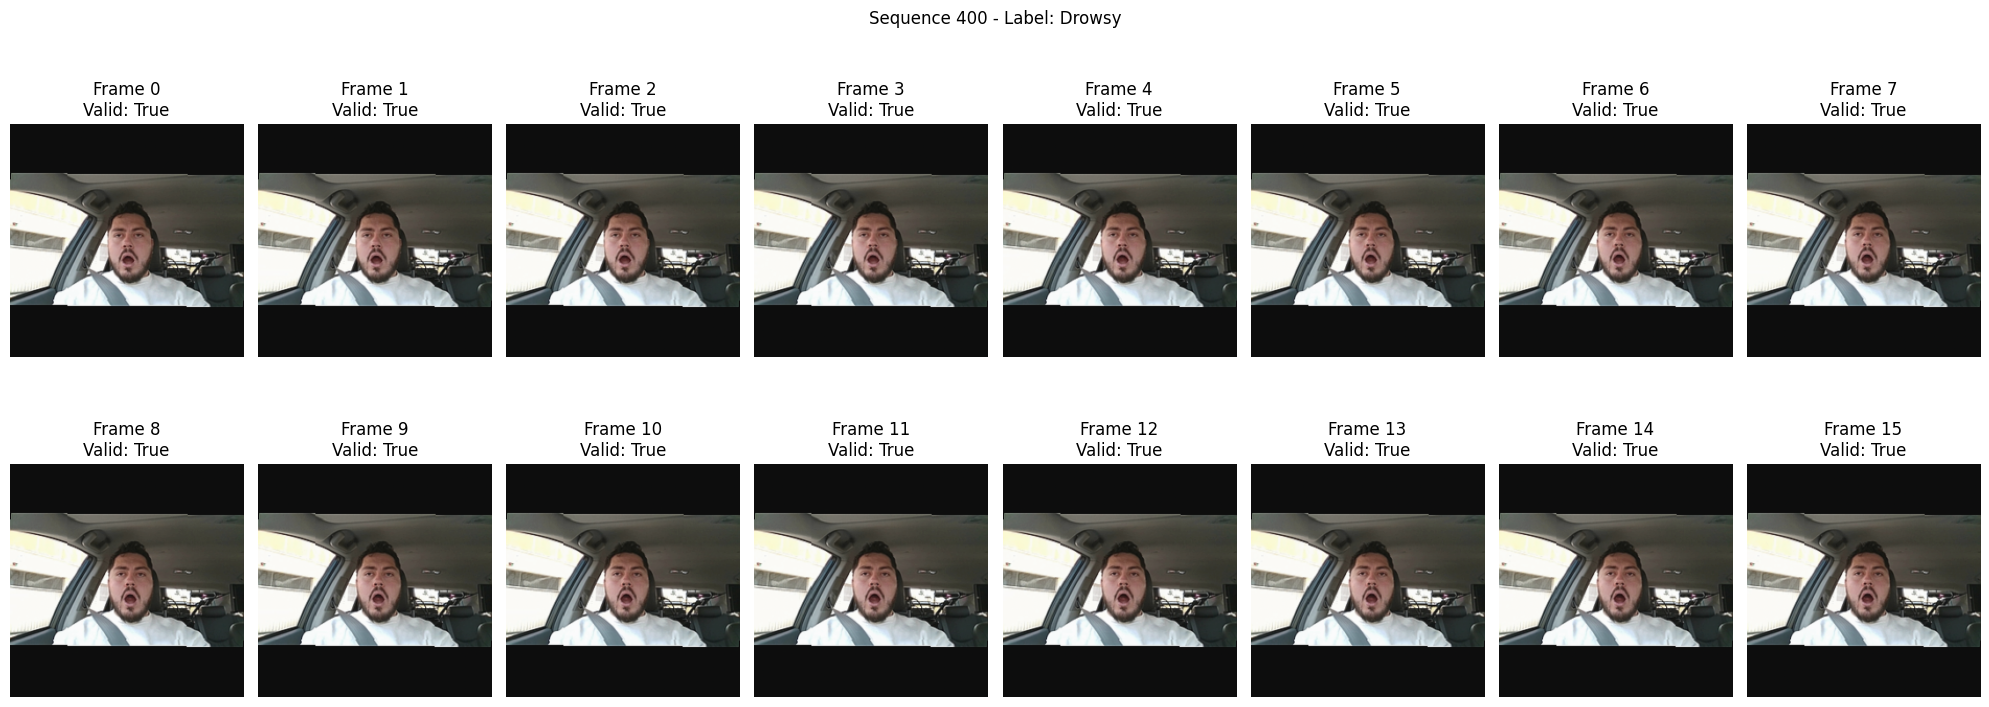

In [7]:
visualize_sequence(train_dataset, idx=400)

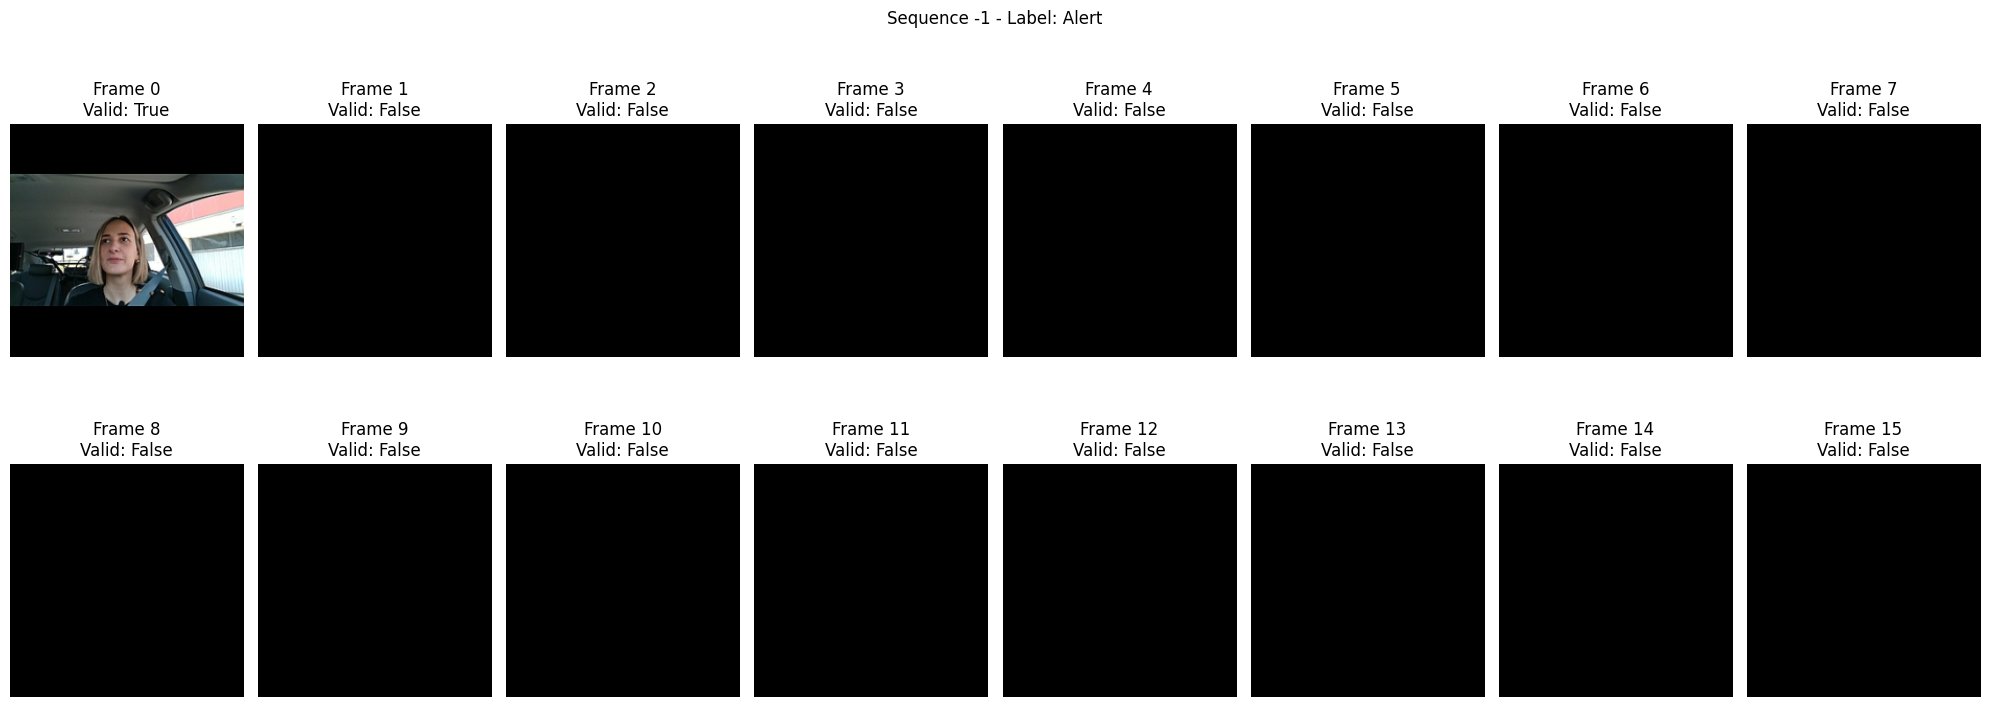

In [8]:
visualize_sequence(test_dataset, idx=-1) 

In [9]:
# Step 1: Extract labels directly from the dataset
labels = np.array([train_dataset[i][2] for i in tqdm(range(len(train_dataset)))])  # Access the labels efficiently

# Step 2: Compute class weights
unique_classes = np.unique(labels)
class_weights = compute_class_weight(
    class_weight='balanced', 
    classes=unique_classes, 
    y=labels
)
class_weights = torch.tensor(class_weights, dtype=torch.float)
class_weights = class_weights * (1 / class_weights[0])

# Step 3: Map class weights to sample weights
label_to_weight = {label: weight for label, weight in zip(unique_classes, class_weights)}
sample_weights = torch.tensor([label_to_weight[label] for label in labels], dtype=torch.float)

# Step 4: Create the WeightedRandomSampler
sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),  # Match the total number of samples
    replacement=True  # Replacement ensures balanced sampling
)

print("Class weights:", class_weights)

100%|████████████████████████████████████████████████████████████| 7531/7531 [08:14<00:00, 15.24it/s]

Class weights: tensor([1.0000, 6.7004])


  0%|▎                                                             | 32/7531 [00:04<08:24, 14.86it/s]

  0%|▎                                                             | 34/7531 [00:04<08:18, 15.05it/s]

  0%|▎                                                             | 36/7531 [00:04<08:13, 15.18it/s]

  1%|▎                                                             | 38/7531 [00:04<08:15, 15.12it/s]

  1%|▎                                                             | 40/7531 [00:04<08:11, 15.25it/s]

  1%|▎                                                             | 42/7531 [00:04<08:09, 15.30it/s]

  1%|▎                                                             | 45/7531 [00:05<07:34, 16.48it/s]

  1%|▍                                                             | 47/7531 [00:05<07:41, 16.22it/s]

  1%|▍                                                             | 49/7531 [00:05<07:46, 16.04it/s]

  1%|▍                                                             | 51/7531 [00:05<07:52, 15.83it/s]

  1%|▍                                                             | 53/7531 [00:05<07:57, 15.66it/s]

  1%|▍                                                             | 55/7531 [00:05<07:58, 15.62it/s]

  1%|▍                                                             | 57/7531 [00:05<08:01, 15.51it/s]

  1%|▍                                                             | 59/7531 [00:05<07:57, 15.64it/s]

  1%|▌                                                             | 61/7531 [00:06<07:37, 16.34it/s]

  1%|▌                                                             | 63/7531 [00:06<07:48, 15.93it/s]

  1%|▌                                                             | 65/7531 [00:06<07:45, 16.04it/s]

  1%|▌                                                             | 67/7531 [00:06<07:47, 15.95it/s]

  1%|▌                                                             | 69/7531 [00:06<07:46, 15.98it/s]

  1%|▌                                                             | 71/7531 [00:06<07:48, 15.93it/s]

  1%|▌                                                             | 73/7531 [00:06<07:49, 15.88it/s]

  1%|▌                                                             | 75/7531 [00:06<07:49, 15.90it/s]

  1%|▋                                                             | 77/7531 [00:07<07:49, 15.87it/s]

  1%|▋                                                             | 79/7531 [00:07<07:48, 15.90it/s]

  1%|▋                                                             | 81/7531 [00:07<07:56, 15.64it/s]

  1%|▋                                                             | 83/7531 [00:07<07:51, 15.78it/s]

  1%|▋                                                             | 86/7531 [00:07<07:20, 16.92it/s]

  1%|▋                                                             | 88/7531 [00:07<07:33, 16.42it/s]

  1%|▋                                                             | 90/7531 [00:07<07:37, 16.28it/s]

  1%|▊                                                             | 92/7531 [00:07<07:41, 16.11it/s]

  1%|▊                                                             | 94/7531 [00:08<07:42, 16.09it/s]

  1%|▊                                                             | 96/7531 [00:08<07:40, 16.15it/s]

  1%|▊                                                             | 98/7531 [00:08<07:44, 15.99it/s]

  1%|▊                                                            | 100/7531 [00:08<07:42, 16.07it/s]

  1%|▊                                                            | 102/7531 [00:08<07:46, 15.92it/s]

  1%|▊                                                            | 104/7531 [00:08<07:53, 15.69it/s]

  1%|▊                                                            | 106/7531 [00:08<07:56, 15.59it/s]

  1%|▊                                                            | 108/7531 [00:09<07:57, 15.53it/s]

  1%|▉                                                            | 110/7531 [00:09<07:31, 16.42it/s]

  1%|▉                                                            | 112/7531 [00:09<07:39, 16.15it/s]

  2%|▉                                                            | 114/7531 [00:09<07:46, 15.89it/s]

  2%|▉                                                            | 116/7531 [00:09<07:47, 15.86it/s]

  2%|▉                                                            | 118/7531 [00:09<07:49, 15.77it/s]

  2%|▉                                                            | 120/7531 [00:09<07:56, 15.56it/s]

  2%|▉                                                            | 122/7531 [00:09<07:54, 15.62it/s]

  2%|█                                                            | 124/7531 [00:10<07:55, 15.58it/s]

  2%|█                                                            | 126/7531 [00:10<07:54, 15.62it/s]

  2%|█                                                            | 128/7531 [00:10<07:59, 15.44it/s]

  2%|█                                                            | 130/7531 [00:10<08:00, 15.40it/s]

  2%|█                                                            | 132/7531 [00:10<08:00, 15.40it/s]

  2%|█                                                            | 134/7531 [00:10<07:51, 15.67it/s]

  2%|█                                                            | 136/7531 [00:10<08:03, 15.31it/s]

  2%|█                                                            | 138/7531 [00:10<07:59, 15.42it/s]

  2%|█▏                                                           | 140/7531 [00:11<07:37, 16.17it/s]

  2%|█▏                                                           | 142/7531 [00:11<07:37, 16.17it/s]

  2%|█▏                                                           | 144/7531 [00:11<07:47, 15.80it/s]

  2%|█▏                                                           | 146/7531 [00:11<07:53, 15.59it/s]

  2%|█▏                                                           | 148/7531 [00:11<07:57, 15.46it/s]

  2%|█▏                                                           | 150/7531 [00:11<08:00, 15.36it/s]

  2%|█▏                                                           | 152/7531 [00:11<08:02, 15.29it/s]

  2%|█▏                                                           | 154/7531 [00:11<07:55, 15.53it/s]

  2%|█▎                                                           | 156/7531 [00:12<07:51, 15.65it/s]

  2%|█▎                                                           | 158/7531 [00:12<07:52, 15.59it/s]

  2%|█▎                                                           | 160/7531 [00:12<07:57, 15.43it/s]

  2%|█▎                                                           | 162/7531 [00:12<07:49, 15.68it/s]

  2%|█▎                                                           | 164/7531 [00:12<07:52, 15.58it/s]

  2%|█▎                                                           | 166/7531 [00:12<07:58, 15.39it/s]

  2%|█▎                                                           | 168/7531 [00:12<07:42, 15.91it/s]

  2%|█▍                                                           | 170/7531 [00:12<07:15, 16.92it/s]

  2%|█▍                                                           | 172/7531 [00:13<07:19, 16.73it/s]

  2%|█▍                                                           | 174/7531 [00:13<07:32, 16.26it/s]

  2%|█▍                                                           | 176/7531 [00:13<07:46, 15.77it/s]

  2%|█▍                                                           | 178/7531 [00:13<07:48, 15.69it/s]

  2%|█▍                                                           | 180/7531 [00:13<07:49, 15.65it/s]

  2%|█▍                                                           | 182/7531 [00:13<07:52, 15.57it/s]

  2%|█▍                                                           | 184/7531 [00:13<07:50, 15.62it/s]

  2%|█▌                                                           | 186/7531 [00:13<07:37, 16.05it/s]

  2%|█▌                                                           | 188/7531 [00:14<07:39, 15.98it/s]

  3%|█▌                                                           | 190/7531 [00:14<07:37, 16.03it/s]

  3%|█▌                                                           | 192/7531 [00:14<09:36, 12.73it/s]

  3%|█▌                                                           | 194/7531 [00:14<09:21, 13.08it/s]

  3%|█▌                                                           | 196/7531 [00:14<09:10, 13.33it/s]

  3%|█▌                                                           | 198/7531 [00:14<09:48, 12.46it/s]

  3%|█▌                                                           | 200/7531 [00:15<11:10, 10.93it/s]

  3%|█▋                                                           | 202/7531 [00:15<11:45, 10.39it/s]

  3%|█▋                                                           | 204/7531 [00:15<12:48,  9.53it/s]

  3%|█▋                                                           | 206/7531 [00:15<11:15, 10.84it/s]

  3%|█▋                                                           | 208/7531 [00:15<10:12, 11.96it/s]

  3%|█▋                                                           | 210/7531 [00:16<11:01, 11.07it/s]

  3%|█▋                                                           | 213/7531 [00:16<09:05, 13.42it/s]

  3%|█▋                                                           | 215/7531 [00:16<09:55, 12.28it/s]

  3%|█▊                                                           | 217/7531 [00:16<10:52, 11.21it/s]

  3%|█▊                                                           | 219/7531 [00:16<09:56, 12.25it/s]

  3%|█▊                                                           | 221/7531 [00:16<09:12, 13.22it/s]

  3%|█▊                                                           | 223/7531 [00:17<08:47, 13.84it/s]

  3%|█▊                                                           | 225/7531 [00:17<08:29, 14.35it/s]

  3%|█▊                                                           | 227/7531 [00:17<08:08, 14.96it/s]

  3%|█▊                                                           | 229/7531 [00:17<07:58, 15.26it/s]

  3%|█▊                                                           | 231/7531 [00:17<07:56, 15.31it/s]

  3%|█▉                                                           | 234/7531 [00:17<07:13, 16.83it/s]

  3%|█▉                                                           | 236/7531 [00:17<07:16, 16.71it/s]

  3%|█▉                                                           | 238/7531 [00:17<07:27, 16.30it/s]

  3%|█▉                                                           | 240/7531 [00:18<07:31, 16.13it/s]

  3%|█▉                                                           | 242/7531 [00:18<07:41, 15.81it/s]

  3%|█▉                                                           | 244/7531 [00:18<07:46, 15.64it/s]

  3%|█▉                                                           | 246/7531 [00:18<07:36, 15.95it/s]

  3%|██                                                           | 249/7531 [00:18<07:12, 16.83it/s]

  3%|██                                                           | 251/7531 [00:18<07:23, 16.42it/s]

  3%|██                                                           | 253/7531 [00:18<07:28, 16.22it/s]

  3%|██                                                           | 255/7531 [00:18<07:44, 15.67it/s]

  3%|██                                                           | 257/7531 [00:19<07:49, 15.50it/s]

  3%|██                                                           | 259/7531 [00:19<07:52, 15.39it/s]

  3%|██                                                           | 261/7531 [00:19<10:04, 12.03it/s]

  3%|██▏                                                          | 263/7531 [00:19<09:34, 12.65it/s]

  4%|██▏                                                          | 265/7531 [00:19<09:06, 13.28it/s]

  4%|██▏                                                          | 267/7531 [00:19<08:46, 13.80it/s]

  4%|██▏                                                          | 269/7531 [00:20<08:02, 15.04it/s]

  4%|██▏                                                          | 271/7531 [00:20<08:04, 14.98it/s]

  4%|██▏                                                          | 273/7531 [00:20<08:07, 14.90it/s]

  4%|██▏                                                          | 275/7531 [00:20<08:05, 14.95it/s]

  4%|██▏                                                          | 277/7531 [00:20<08:03, 15.00it/s]

  4%|██▎                                                          | 279/7531 [00:20<08:12, 14.71it/s]

  4%|██▎                                                          | 281/7531 [00:20<08:20, 14.49it/s]

  4%|██▎                                                          | 283/7531 [00:20<08:21, 14.45it/s]

  4%|██▎                                                          | 285/7531 [00:21<08:16, 14.59it/s]

  4%|██▎                                                          | 287/7531 [00:21<07:49, 15.42it/s]

  4%|██▎                                                          | 289/7531 [00:21<07:51, 15.37it/s]

  4%|██▎                                                          | 291/7531 [00:21<08:16, 14.60it/s]

  4%|██▎                                                          | 293/7531 [00:21<08:40, 13.92it/s]

  4%|██▍                                                          | 295/7531 [00:21<08:31, 14.14it/s]

  4%|██▍                                                          | 297/7531 [00:21<08:34, 14.06it/s]

  4%|██▍                                                          | 299/7531 [00:22<08:45, 13.76it/s]

  4%|██▍                                                          | 301/7531 [00:22<08:29, 14.20it/s]

  4%|██▍                                                          | 303/7531 [00:22<08:15, 14.60it/s]

  4%|██▍                                                          | 305/7531 [00:22<07:42, 15.62it/s]

  4%|██▍                                                          | 307/7531 [00:22<07:51, 15.31it/s]

  4%|██▌                                                          | 309/7531 [00:22<07:47, 15.45it/s]

  4%|██▌                                                          | 311/7531 [00:22<07:46, 15.47it/s]

  4%|██▌                                                          | 313/7531 [00:23<08:12, 14.66it/s]

  4%|██▌                                                          | 315/7531 [00:23<08:08, 14.78it/s]

  4%|██▌                                                          | 317/7531 [00:23<08:05, 14.87it/s]

  4%|██▌                                                          | 319/7531 [00:23<07:39, 15.69it/s]

  4%|██▌                                                          | 322/7531 [00:23<07:15, 16.54it/s]

  4%|██▌                                                          | 324/7531 [00:23<07:22, 16.27it/s]

  4%|██▋                                                          | 326/7531 [00:23<07:27, 16.11it/s]

  4%|██▋                                                          | 328/7531 [00:23<07:28, 16.07it/s]

  4%|██▋                                                          | 330/7531 [00:24<07:27, 16.10it/s]

  4%|██▋                                                          | 332/7531 [00:24<07:28, 16.04it/s]

  4%|██▋                                                          | 334/7531 [00:24<07:29, 16.00it/s]

  4%|██▋                                                          | 337/7531 [00:24<07:06, 16.88it/s]

  5%|██▋                                                          | 339/7531 [00:24<07:13, 16.60it/s]

  5%|██▊                                                          | 341/7531 [00:24<07:16, 16.46it/s]

  5%|██▊                                                          | 343/7531 [00:24<07:36, 15.75it/s]

  5%|██▊                                                          | 345/7531 [00:25<07:47, 15.38it/s]

  5%|██▊                                                          | 347/7531 [00:25<07:43, 15.50it/s]

  5%|██▊                                                          | 349/7531 [00:25<07:41, 15.57it/s]

  5%|██▊                                                          | 351/7531 [00:25<07:34, 15.81it/s]

  5%|██▊                                                          | 353/7531 [00:25<07:18, 16.39it/s]

  5%|██▉                                                          | 355/7531 [00:25<07:18, 16.35it/s]

  5%|██▉                                                          | 357/7531 [00:25<07:27, 16.03it/s]

  5%|██▉                                                          | 359/7531 [00:25<07:30, 15.91it/s]

  5%|██▉                                                          | 361/7531 [00:26<07:44, 15.44it/s]

  5%|██▉                                                          | 363/7531 [00:26<07:56, 15.05it/s]

  5%|██▉                                                          | 365/7531 [00:26<07:54, 15.11it/s]

  5%|██▉                                                          | 367/7531 [00:26<07:49, 15.25it/s]

  5%|██▉                                                          | 370/7531 [00:26<07:16, 16.41it/s]

  5%|███                                                          | 372/7531 [00:26<07:23, 16.13it/s]

  5%|███                                                          | 374/7531 [00:26<07:24, 16.11it/s]

  5%|███                                                          | 376/7531 [00:26<07:26, 16.01it/s]

  5%|███                                                          | 378/7531 [00:27<07:49, 15.23it/s]

  5%|███                                                          | 380/7531 [00:27<07:57, 14.96it/s]

  5%|███                                                          | 382/7531 [00:27<07:58, 14.95it/s]

  5%|███                                                          | 384/7531 [00:27<07:50, 15.18it/s]

  5%|███▏                                                         | 386/7531 [00:27<07:47, 15.29it/s]

  5%|███▏                                                         | 388/7531 [00:27<07:44, 15.38it/s]

  5%|███▏                                                         | 390/7531 [00:27<07:41, 15.47it/s]

  5%|███▏                                                         | 392/7531 [00:28<07:43, 15.41it/s]

  5%|███▏                                                         | 394/7531 [00:28<07:13, 16.45it/s]

  5%|███▏                                                         | 396/7531 [00:28<07:20, 16.18it/s]

  5%|███▏                                                         | 398/7531 [00:28<07:38, 15.56it/s]

  5%|███▏                                                         | 400/7531 [00:28<07:31, 15.78it/s]

  5%|███▎                                                         | 402/7531 [00:28<07:25, 16.02it/s]

  5%|███▎                                                         | 404/7531 [00:28<07:42, 15.40it/s]

  5%|███▎                                                         | 406/7531 [00:28<07:48, 15.20it/s]

  5%|███▎                                                         | 408/7531 [00:29<07:41, 15.43it/s]

  5%|███▎                                                         | 410/7531 [00:29<07:51, 15.11it/s]

  5%|███▎                                                         | 412/7531 [00:29<07:27, 15.92it/s]

  6%|███▎                                                         | 415/7531 [00:29<07:06, 16.67it/s]

  6%|███▍                                                         | 417/7531 [00:29<07:11, 16.50it/s]

  6%|███▍                                                         | 419/7531 [00:29<07:16, 16.31it/s]

  6%|███▍                                                         | 421/7531 [00:29<07:14, 16.38it/s]

  6%|███▍                                                         | 423/7531 [00:29<07:13, 16.42it/s]

  6%|███▍                                                         | 425/7531 [00:30<07:18, 16.22it/s]

  6%|███▍                                                         | 427/7531 [00:30<07:24, 15.97it/s]

  6%|███▍                                                         | 429/7531 [00:30<07:26, 15.92it/s]

  6%|███▍                                                         | 431/7531 [00:30<07:33, 15.65it/s]

  6%|███▌                                                         | 433/7531 [00:30<07:33, 15.66it/s]

  6%|███▌                                                         | 435/7531 [00:30<07:11, 16.43it/s]

  6%|███▌                                                         | 437/7531 [00:30<07:26, 15.89it/s]

  6%|███▌                                                         | 439/7531 [00:30<07:24, 15.97it/s]

  6%|███▌                                                         | 441/7531 [00:31<07:34, 15.61it/s]

  6%|███▌                                                         | 443/7531 [00:31<07:31, 15.68it/s]

  6%|███▌                                                         | 445/7531 [00:31<07:29, 15.77it/s]

  6%|███▌                                                         | 447/7531 [00:31<07:39, 15.40it/s]

  6%|███▋                                                         | 449/7531 [00:31<07:38, 15.44it/s]

  6%|███▋                                                         | 451/7531 [00:31<07:41, 15.35it/s]

  6%|███▋                                                         | 453/7531 [00:31<07:43, 15.26it/s]

  6%|███▋                                                         | 455/7531 [00:31<07:41, 15.32it/s]

  6%|███▋                                                         | 457/7531 [00:32<07:33, 15.61it/s]

  6%|███▋                                                         | 459/7531 [00:32<07:15, 16.23it/s]

  6%|███▋                                                         | 461/7531 [00:32<07:16, 16.19it/s]

  6%|███▊                                                         | 463/7531 [00:32<07:23, 15.92it/s]

  6%|███▊                                                         | 465/7531 [00:32<07:36, 15.48it/s]

  6%|███▊                                                         | 467/7531 [00:32<07:32, 15.62it/s]

  6%|███▊                                                         | 469/7531 [00:32<07:31, 15.63it/s]

  6%|███▊                                                         | 471/7531 [00:33<07:34, 15.55it/s]

  6%|███▊                                                         | 473/7531 [00:33<07:29, 15.70it/s]

  6%|███▊                                                         | 475/7531 [00:33<07:38, 15.38it/s]

  6%|███▊                                                         | 477/7531 [00:33<07:39, 15.34it/s]

  6%|███▉                                                         | 479/7531 [00:33<07:34, 15.53it/s]

  6%|███▉                                                         | 481/7531 [00:33<07:30, 15.65it/s]

  6%|███▉                                                         | 483/7531 [00:33<07:31, 15.62it/s]

  6%|███▉                                                         | 485/7531 [00:33<07:24, 15.86it/s]

  6%|███▉                                                         | 487/7531 [00:34<07:04, 16.60it/s]

  6%|███▉                                                         | 489/7531 [00:34<07:32, 15.57it/s]

  7%|███▉                                                         | 491/7531 [00:34<07:39, 15.33it/s]

  7%|███▉                                                         | 493/7531 [00:34<07:41, 15.25it/s]

  7%|████                                                         | 495/7531 [00:34<07:37, 15.37it/s]

  7%|████                                                         | 497/7531 [00:34<07:38, 15.35it/s]

  7%|████                                                         | 499/7531 [00:34<07:37, 15.36it/s]

  7%|████                                                         | 501/7531 [00:34<07:37, 15.37it/s]

  7%|████                                                         | 503/7531 [00:35<07:36, 15.40it/s]

  7%|████                                                         | 505/7531 [00:35<07:37, 15.34it/s]

  7%|████                                                         | 507/7531 [00:35<07:36, 15.40it/s]

  7%|████                                                         | 509/7531 [00:35<07:31, 15.55it/s]

  7%|████▏                                                        | 511/7531 [00:35<07:29, 15.61it/s]

  7%|████▏                                                        | 513/7531 [00:35<07:20, 15.94it/s]

  7%|████▏                                                        | 515/7531 [00:35<06:55, 16.90it/s]

  7%|████▏                                                        | 517/7531 [00:35<07:19, 15.96it/s]

  7%|████▏                                                        | 519/7531 [00:36<07:24, 15.77it/s]

  7%|████▏                                                        | 521/7531 [00:36<07:36, 15.35it/s]

  7%|████▏                                                        | 523/7531 [00:36<07:31, 15.52it/s]

  7%|████▎                                                        | 525/7531 [00:36<07:27, 15.64it/s]

  7%|████▎                                                        | 527/7531 [00:36<07:26, 15.69it/s]

  7%|████▎                                                        | 529/7531 [00:36<07:30, 15.53it/s]

  7%|████▎                                                        | 531/7531 [00:36<07:35, 15.37it/s]

  7%|████▎                                                        | 533/7531 [00:36<07:34, 15.41it/s]

  7%|████▎                                                        | 535/7531 [00:37<07:40, 15.19it/s]

  7%|████▎                                                        | 537/7531 [00:37<07:33, 15.44it/s]

  7%|████▎                                                        | 539/7531 [00:37<07:14, 16.08it/s]

  7%|████▍                                                        | 541/7531 [00:37<07:20, 15.85it/s]

  7%|████▍                                                        | 543/7531 [00:37<07:18, 15.94it/s]

  7%|████▍                                                        | 545/7531 [00:37<07:16, 16.01it/s]

  7%|████▍                                                        | 547/7531 [00:37<07:18, 15.92it/s]

  7%|████▍                                                        | 549/7531 [00:37<07:16, 16.00it/s]

  7%|████▍                                                        | 551/7531 [00:38<07:19, 15.89it/s]

  7%|████▍                                                        | 553/7531 [00:38<07:21, 15.81it/s]

  7%|████▍                                                        | 555/7531 [00:38<07:51, 14.79it/s]

  7%|████▌                                                        | 557/7531 [00:38<07:50, 14.84it/s]

  7%|████▌                                                        | 559/7531 [00:38<07:45, 14.98it/s]

  7%|████▌                                                        | 561/7531 [00:38<07:37, 15.23it/s]

  7%|████▌                                                        | 564/7531 [00:38<06:54, 16.82it/s]

  8%|████▌                                                        | 566/7531 [00:39<07:09, 16.23it/s]

  8%|████▌                                                        | 568/7531 [00:39<07:37, 15.23it/s]

  8%|████▌                                                        | 570/7531 [00:39<07:31, 15.41it/s]

  8%|████▋                                                        | 572/7531 [00:39<07:33, 15.34it/s]

  8%|████▋                                                        | 574/7531 [00:39<07:32, 15.38it/s]

  8%|████▋                                                        | 576/7531 [00:39<07:22, 15.74it/s]

  8%|████▋                                                        | 578/7531 [00:39<07:17, 15.88it/s]

  8%|████▋                                                        | 580/7531 [00:39<07:21, 15.76it/s]

  8%|████▋                                                        | 582/7531 [00:40<07:28, 15.49it/s]

  8%|████▋                                                        | 584/7531 [00:40<07:28, 15.50it/s]

  8%|████▊                                                        | 587/7531 [00:40<06:48, 17.00it/s]

  8%|████▊                                                        | 589/7531 [00:40<06:59, 16.53it/s]

  8%|████▊                                                        | 591/7531 [00:40<07:07, 16.23it/s]

  8%|████▊                                                        | 593/7531 [00:40<07:07, 16.25it/s]

  8%|████▊                                                        | 595/7531 [00:40<07:11, 16.06it/s]

  8%|████▊                                                        | 597/7531 [00:41<07:11, 16.07it/s]

  8%|████▊                                                        | 599/7531 [00:41<07:24, 15.60it/s]

  8%|████▊                                                        | 601/7531 [00:41<07:23, 15.63it/s]

  8%|████▉                                                        | 603/7531 [00:41<07:08, 16.18it/s]

  8%|████▉                                                        | 606/7531 [00:41<06:47, 16.99it/s]

  8%|████▉                                                        | 608/7531 [00:41<06:53, 16.75it/s]

  8%|████▉                                                        | 610/7531 [00:41<07:09, 16.10it/s]

  8%|████▉                                                        | 612/7531 [00:41<07:15, 15.88it/s]

  8%|████▉                                                        | 614/7531 [00:42<07:15, 15.87it/s]

  8%|████▉                                                        | 616/7531 [00:42<07:29, 15.38it/s]

  8%|█████                                                        | 618/7531 [00:42<07:24, 15.56it/s]

  8%|█████                                                        | 620/7531 [00:42<07:32, 15.27it/s]

  8%|█████                                                        | 622/7531 [00:42<07:25, 15.50it/s]

  8%|█████                                                        | 624/7531 [00:42<07:18, 15.75it/s]

  8%|█████                                                        | 626/7531 [00:42<07:12, 15.97it/s]

  8%|█████                                                        | 628/7531 [00:42<07:11, 15.99it/s]

  8%|█████                                                        | 630/7531 [00:43<07:08, 16.09it/s]

  8%|█████                                                        | 632/7531 [00:43<06:43, 17.08it/s]

  8%|█████▏                                                       | 634/7531 [00:43<06:56, 16.56it/s]

  8%|█████▏                                                       | 636/7531 [00:43<07:03, 16.27it/s]

  8%|█████▏                                                       | 638/7531 [00:43<07:02, 16.30it/s]

  8%|█████▏                                                       | 640/7531 [00:43<07:11, 15.97it/s]

  9%|█████▏                                                       | 642/7531 [00:43<07:10, 15.99it/s]

  9%|█████▏                                                       | 644/7531 [00:43<07:11, 15.95it/s]

  9%|█████▏                                                       | 646/7531 [00:44<07:27, 15.38it/s]

  9%|█████▏                                                       | 648/7531 [00:44<07:30, 15.29it/s]

  9%|█████▎                                                       | 650/7531 [00:44<07:32, 15.22it/s]

  9%|█████▎                                                       | 652/7531 [00:44<07:23, 15.50it/s]

  9%|█████▎                                                       | 654/7531 [00:44<07:20, 15.60it/s]

  9%|█████▎                                                       | 656/7531 [00:44<07:04, 16.20it/s]

  9%|█████▎                                                       | 658/7531 [00:44<06:40, 17.14it/s]

  9%|█████▎                                                       | 660/7531 [00:44<07:02, 16.26it/s]

  9%|█████▎                                                       | 662/7531 [00:45<07:08, 16.04it/s]

  9%|█████▍                                                       | 664/7531 [00:45<07:06, 16.10it/s]

  9%|█████▍                                                       | 666/7531 [00:45<07:13, 15.83it/s]

  9%|█████▍                                                       | 668/7531 [00:45<07:17, 15.68it/s]

  9%|█████▍                                                       | 670/7531 [00:45<07:18, 15.64it/s]

  9%|█████▍                                                       | 672/7531 [00:45<07:16, 15.70it/s]

  9%|█████▍                                                       | 674/7531 [00:45<07:17, 15.67it/s]

  9%|█████▍                                                       | 676/7531 [00:45<07:02, 16.24it/s]

  9%|█████▍                                                       | 678/7531 [00:46<07:03, 16.18it/s]

  9%|█████▌                                                       | 680/7531 [00:46<07:29, 15.23it/s]

  9%|█████▌                                                       | 682/7531 [00:46<07:28, 15.26it/s]

  9%|█████▌                                                       | 684/7531 [00:46<07:25, 15.36it/s]

  9%|█████▌                                                       | 686/7531 [00:46<07:27, 15.29it/s]

  9%|█████▌                                                       | 688/7531 [00:46<07:21, 15.48it/s]

  9%|█████▌                                                       | 690/7531 [00:46<07:19, 15.56it/s]

  9%|█████▌                                                       | 692/7531 [00:47<07:23, 15.41it/s]

  9%|█████▋                                                       | 695/7531 [00:47<06:57, 16.38it/s]

  9%|█████▋                                                       | 697/7531 [00:47<07:09, 15.93it/s]

  9%|█████▋                                                       | 699/7531 [00:47<07:14, 15.72it/s]

  9%|█████▋                                                       | 701/7531 [00:47<07:17, 15.61it/s]

  9%|█████▋                                                       | 703/7531 [00:47<07:22, 15.44it/s]

  9%|█████▋                                                       | 705/7531 [00:47<07:23, 15.41it/s]

  9%|█████▋                                                       | 707/7531 [00:47<07:23, 15.38it/s]

  9%|█████▋                                                       | 709/7531 [00:48<07:26, 15.29it/s]

  9%|█████▊                                                       | 711/7531 [00:48<07:26, 15.29it/s]

  9%|█████▊                                                       | 713/7531 [00:48<07:14, 15.68it/s]

  9%|█████▊                                                       | 715/7531 [00:48<06:52, 16.52it/s]

 10%|█████▊                                                       | 717/7531 [00:48<07:09, 15.86it/s]

 10%|█████▊                                                       | 719/7531 [00:48<07:11, 15.77it/s]

 10%|█████▊                                                       | 721/7531 [00:48<07:11, 15.80it/s]

 10%|█████▊                                                       | 723/7531 [00:49<07:16, 15.59it/s]

 10%|█████▊                                                       | 725/7531 [00:49<07:18, 15.52it/s]

 10%|█████▉                                                       | 727/7531 [00:49<07:25, 15.28it/s]

 10%|█████▉                                                       | 729/7531 [00:49<07:20, 15.44it/s]

 10%|█████▉                                                       | 731/7531 [00:49<07:16, 15.56it/s]

 10%|█████▉                                                       | 733/7531 [00:49<07:07, 15.90it/s]

 10%|█████▉                                                       | 735/7531 [00:49<06:50, 16.55it/s]

 10%|█████▉                                                       | 737/7531 [00:49<07:11, 15.74it/s]

 10%|█████▉                                                       | 739/7531 [00:50<07:09, 15.81it/s]

 10%|██████                                                       | 741/7531 [00:50<07:20, 15.41it/s]

 10%|██████                                                       | 743/7531 [00:50<07:22, 15.34it/s]

 10%|██████                                                       | 745/7531 [00:50<07:15, 15.56it/s]

 10%|██████                                                       | 747/7531 [00:50<07:20, 15.42it/s]

 10%|██████                                                       | 749/7531 [00:50<07:20, 15.38it/s]

 10%|██████                                                       | 751/7531 [00:50<07:15, 15.57it/s]

 10%|██████                                                       | 753/7531 [00:50<07:20, 15.39it/s]

 10%|██████                                                       | 755/7531 [00:51<07:24, 15.24it/s]

 10%|██████▏                                                      | 757/7531 [00:51<07:08, 15.82it/s]

 10%|██████▏                                                      | 759/7531 [00:51<06:42, 16.84it/s]

 10%|██████▏                                                      | 761/7531 [00:51<07:06, 15.88it/s]

 10%|██████▏                                                      | 763/7531 [00:51<07:11, 15.69it/s]

 10%|██████▏                                                      | 765/7531 [00:51<07:20, 15.35it/s]

 10%|██████▏                                                      | 767/7531 [00:51<07:15, 15.53it/s]

 10%|██████▏                                                      | 769/7531 [00:51<07:15, 15.53it/s]

 10%|██████▏                                                      | 771/7531 [00:52<07:13, 15.60it/s]

 10%|██████▎                                                      | 773/7531 [00:52<07:14, 15.55it/s]

 10%|██████▎                                                      | 775/7531 [00:52<07:16, 15.47it/s]

 10%|██████▎                                                      | 777/7531 [00:52<06:50, 16.44it/s]

 10%|██████▎                                                      | 779/7531 [00:52<07:11, 15.66it/s]

 10%|██████▎                                                      | 781/7531 [00:52<07:13, 15.55it/s]

 10%|██████▎                                                      | 783/7531 [00:52<07:14, 15.51it/s]

 10%|██████▎                                                      | 785/7531 [00:52<07:39, 14.69it/s]

 10%|██████▎                                                      | 787/7531 [00:53<07:34, 14.84it/s]

 10%|██████▍                                                      | 789/7531 [00:53<07:28, 15.04it/s]

 11%|██████▍                                                      | 791/7531 [00:53<07:25, 15.13it/s]

 11%|██████▍                                                      | 793/7531 [00:53<07:21, 15.26it/s]

 11%|██████▍                                                      | 795/7531 [00:53<07:22, 15.22it/s]

 11%|██████▍                                                      | 797/7531 [00:53<07:00, 16.01it/s]

 11%|██████▍                                                      | 799/7531 [00:53<06:36, 16.99it/s]

 11%|██████▍                                                      | 801/7531 [00:53<06:50, 16.38it/s]

 11%|██████▌                                                      | 803/7531 [00:54<07:01, 15.98it/s]

 11%|██████▌                                                      | 805/7531 [00:54<07:01, 15.97it/s]

 11%|██████▌                                                      | 807/7531 [00:54<07:10, 15.61it/s]

 11%|██████▌                                                      | 809/7531 [00:54<07:09, 15.65it/s]

 11%|██████▌                                                      | 811/7531 [00:54<07:08, 15.70it/s]

 11%|██████▌                                                      | 813/7531 [00:54<07:08, 15.66it/s]

 11%|██████▌                                                      | 815/7531 [00:54<07:09, 15.65it/s]

 11%|██████▌                                                      | 817/7531 [00:55<07:09, 15.63it/s]

 11%|██████▋                                                      | 819/7531 [00:55<06:52, 16.26it/s]

 11%|██████▋                                                      | 821/7531 [00:55<06:58, 16.03it/s]

 11%|██████▋                                                      | 823/7531 [00:55<07:07, 15.70it/s]

 11%|██████▋                                                      | 825/7531 [00:55<07:11, 15.53it/s]

 11%|██████▋                                                      | 827/7531 [00:55<07:16, 15.37it/s]

 11%|██████▋                                                      | 829/7531 [00:55<07:17, 15.30it/s]

 11%|██████▋                                                      | 831/7531 [00:55<07:13, 15.44it/s]

 11%|██████▋                                                      | 833/7531 [00:56<07:15, 15.39it/s]

 11%|██████▊                                                      | 835/7531 [00:56<07:00, 15.91it/s]

 11%|██████▊                                                      | 838/7531 [00:56<06:37, 16.82it/s]

 11%|██████▊                                                      | 840/7531 [00:56<06:48, 16.39it/s]

 11%|██████▊                                                      | 842/7531 [00:56<06:49, 16.35it/s]

 11%|██████▊                                                      | 844/7531 [00:56<06:54, 16.15it/s]

 11%|██████▊                                                      | 846/7531 [00:56<07:00, 15.91it/s]

 11%|██████▊                                                      | 848/7531 [00:56<06:58, 15.96it/s]

 11%|██████▉                                                      | 850/7531 [00:57<07:06, 15.66it/s]

 11%|██████▉                                                      | 852/7531 [00:57<07:11, 15.49it/s]

 11%|██████▉                                                      | 854/7531 [00:57<07:10, 15.51it/s]

 11%|██████▉                                                      | 856/7531 [00:57<07:12, 15.44it/s]

 11%|██████▉                                                      | 858/7531 [00:57<06:46, 16.41it/s]

 11%|██████▉                                                      | 860/7531 [00:57<07:01, 15.84it/s]

 11%|██████▉                                                      | 862/7531 [00:57<07:02, 15.79it/s]

 11%|██████▉                                                      | 864/7531 [00:57<07:01, 15.81it/s]

 11%|███████                                                      | 866/7531 [00:58<07:00, 15.86it/s]

 12%|███████                                                      | 868/7531 [00:58<07:01, 15.81it/s]

 12%|███████                                                      | 870/7531 [00:58<07:05, 15.65it/s]

 12%|███████                                                      | 872/7531 [00:58<07:00, 15.82it/s]

 12%|███████                                                      | 874/7531 [00:58<07:00, 15.85it/s]

 12%|███████                                                      | 876/7531 [00:58<07:09, 15.49it/s]

 12%|███████                                                      | 878/7531 [00:58<07:12, 15.38it/s]

 12%|███████▏                                                     | 880/7531 [00:59<07:09, 15.50it/s]

 12%|███████▏                                                     | 882/7531 [00:59<06:49, 16.23it/s]

 12%|███████▏                                                     | 884/7531 [00:59<06:53, 16.08it/s]

 12%|███████▏                                                     | 886/7531 [00:59<06:59, 15.84it/s]

 12%|███████▏                                                     | 888/7531 [00:59<07:07, 15.52it/s]

 12%|███████▏                                                     | 890/7531 [00:59<07:12, 15.36it/s]

 12%|███████▏                                                     | 892/7531 [00:59<07:13, 15.32it/s]

 12%|███████▏                                                     | 894/7531 [00:59<07:13, 15.31it/s]

 12%|███████▎                                                     | 896/7531 [01:00<07:06, 15.57it/s]

 12%|███████▎                                                     | 898/7531 [01:00<07:03, 15.65it/s]

 12%|███████▎                                                     | 900/7531 [01:00<07:03, 15.65it/s]

 12%|███████▎                                                     | 903/7531 [01:00<06:48, 16.23it/s]

 12%|███████▎                                                     | 905/7531 [01:00<06:56, 15.91it/s]

 12%|███████▎                                                     | 907/7531 [01:00<06:58, 15.82it/s]

 12%|███████▎                                                     | 909/7531 [01:00<07:02, 15.67it/s]

 12%|███████▍                                                     | 911/7531 [01:00<06:58, 15.83it/s]

 12%|███████▍                                                     | 913/7531 [01:01<06:56, 15.89it/s]

 12%|███████▍                                                     | 915/7531 [01:01<07:12, 15.31it/s]

 12%|███████▍                                                     | 917/7531 [01:01<07:13, 15.26it/s]

 12%|███████▍                                                     | 919/7531 [01:01<07:18, 15.09it/s]

 12%|███████▍                                                     | 921/7531 [01:01<07:11, 15.32it/s]

 12%|███████▍                                                     | 923/7531 [01:01<07:02, 15.63it/s]

 12%|███████▍                                                     | 925/7531 [01:01<07:03, 15.59it/s]

 12%|███████▌                                                     | 927/7531 [01:02<07:08, 15.42it/s]

 12%|███████▌                                                     | 929/7531 [01:02<07:02, 15.61it/s]

 12%|███████▌                                                     | 931/7531 [01:02<06:47, 16.20it/s]

 12%|███████▌                                                     | 933/7531 [01:02<06:51, 16.03it/s]

 12%|███████▌                                                     | 935/7531 [01:02<06:53, 15.97it/s]

 12%|███████▌                                                     | 937/7531 [01:02<06:57, 15.80it/s]

 12%|███████▌                                                     | 939/7531 [01:02<07:02, 15.60it/s]

 12%|███████▌                                                     | 941/7531 [01:02<07:06, 15.44it/s]

 13%|███████▋                                                     | 943/7531 [01:03<07:00, 15.67it/s]

 13%|███████▋                                                     | 945/7531 [01:03<06:58, 15.74it/s]

 13%|███████▋                                                     | 947/7531 [01:03<07:01, 15.62it/s]

 13%|███████▋                                                     | 949/7531 [01:03<07:01, 15.61it/s]

 13%|███████▋                                                     | 952/7531 [01:03<06:39, 16.47it/s]

 13%|███████▋                                                     | 954/7531 [01:03<06:54, 15.89it/s]

 13%|███████▋                                                     | 956/7531 [01:03<07:01, 15.61it/s]

 13%|███████▊                                                     | 958/7531 [01:03<07:03, 15.54it/s]

 13%|███████▊                                                     | 960/7531 [01:04<07:05, 15.45it/s]

 13%|███████▊                                                     | 962/7531 [01:04<07:02, 15.55it/s]

 13%|███████▊                                                     | 964/7531 [01:04<06:58, 15.67it/s]

 13%|███████▊                                                     | 966/7531 [01:04<06:59, 15.65it/s]

 13%|███████▊                                                     | 968/7531 [01:04<07:00, 15.61it/s]

 13%|███████▊                                                     | 970/7531 [01:04<06:55, 15.79it/s]

 13%|███████▊                                                     | 972/7531 [01:04<06:58, 15.67it/s]

 13%|███████▉                                                     | 974/7531 [01:05<07:02, 15.53it/s]

 13%|███████▉                                                     | 976/7531 [01:05<07:01, 15.55it/s]

 13%|███████▉                                                     | 979/7531 [01:05<06:43, 16.22it/s]

 13%|███████▉                                                     | 981/7531 [01:05<06:55, 15.77it/s]

 13%|███████▉                                                     | 983/7531 [01:05<07:06, 15.35it/s]

 13%|███████▉                                                     | 985/7531 [01:05<07:04, 15.43it/s]

 13%|███████▉                                                     | 987/7531 [01:05<07:00, 15.56it/s]

 13%|████████                                                     | 989/7531 [01:05<07:08, 15.27it/s]

 13%|████████                                                     | 991/7531 [01:06<07:04, 15.39it/s]

 13%|████████                                                     | 993/7531 [01:06<07:00, 15.56it/s]

 13%|████████                                                     | 995/7531 [01:06<06:56, 15.68it/s]

 13%|████████                                                     | 997/7531 [01:06<07:02, 15.46it/s]

 13%|████████                                                     | 999/7531 [01:06<06:59, 15.58it/s]

 13%|███████▉                                                    | 1001/7531 [01:06<06:59, 15.57it/s]

 13%|███████▉                                                    | 1003/7531 [01:06<06:57, 15.64it/s]

 13%|████████                                                    | 1005/7531 [01:06<06:57, 15.61it/s]

 13%|████████                                                    | 1007/7531 [01:07<06:58, 15.58it/s]

 13%|████████                                                    | 1009/7531 [01:07<06:57, 15.61it/s]

 13%|████████                                                    | 1011/7531 [01:07<06:57, 15.62it/s]

 13%|████████                                                    | 1013/7531 [01:07<07:08, 15.20it/s]

 13%|████████                                                    | 1015/7531 [01:07<07:05, 15.32it/s]

 14%|████████                                                    | 1017/7531 [01:07<07:07, 15.22it/s]

 14%|████████                                                    | 1019/7531 [01:07<07:05, 15.31it/s]

 14%|████████▏                                                   | 1021/7531 [01:08<07:02, 15.41it/s]

 14%|████████▏                                                   | 1023/7531 [01:08<06:57, 15.58it/s]

 14%|████████▏                                                   | 1025/7531 [01:08<06:54, 15.68it/s]

 14%|████████▏                                                   | 1027/7531 [01:08<06:56, 15.62it/s]

 14%|████████▏                                                   | 1029/7531 [01:08<06:54, 15.69it/s]

 14%|████████▏                                                   | 1031/7531 [01:08<07:01, 15.41it/s]

 14%|████████▏                                                   | 1033/7531 [01:08<07:01, 15.40it/s]

 14%|████████▏                                                   | 1035/7531 [01:08<07:00, 15.45it/s]

 14%|████████▎                                                   | 1037/7531 [01:09<07:01, 15.40it/s]

 14%|████████▎                                                   | 1039/7531 [01:09<06:56, 15.57it/s]

 14%|████████▎                                                   | 1041/7531 [01:09<06:56, 15.58it/s]

 14%|████████▎                                                   | 1043/7531 [01:09<07:03, 15.33it/s]

 14%|████████▎                                                   | 1045/7531 [01:09<07:03, 15.31it/s]

 14%|████████▎                                                   | 1047/7531 [01:09<07:01, 15.39it/s]

 14%|████████▎                                                   | 1049/7531 [01:09<06:59, 15.47it/s]

 14%|████████▎                                                   | 1051/7531 [01:09<06:59, 15.46it/s]

 14%|████████▍                                                   | 1053/7531 [01:10<07:06, 15.20it/s]

 14%|████████▍                                                   | 1055/7531 [01:10<07:15, 14.87it/s]

 14%|████████▍                                                   | 1057/7531 [01:10<07:15, 14.87it/s]

 14%|████████▍                                                   | 1059/7531 [01:10<07:04, 15.25it/s]

 14%|████████▍                                                   | 1061/7531 [01:10<07:04, 15.26it/s]

 14%|████████▍                                                   | 1063/7531 [01:10<06:58, 15.44it/s]

 14%|████████▍                                                   | 1065/7531 [01:10<07:02, 15.31it/s]

 14%|████████▌                                                   | 1067/7531 [01:11<07:01, 15.33it/s]

 14%|████████▌                                                   | 1069/7531 [01:11<07:06, 15.17it/s]

 14%|████████▌                                                   | 1071/7531 [01:11<07:01, 15.31it/s]

 14%|████████▌                                                   | 1073/7531 [01:11<06:53, 15.60it/s]

 14%|████████▌                                                   | 1075/7531 [01:11<06:59, 15.41it/s]

 14%|████████▌                                                   | 1077/7531 [01:11<07:04, 15.19it/s]

 14%|████████▌                                                   | 1079/7531 [01:11<07:00, 15.36it/s]

 14%|████████▌                                                   | 1081/7531 [01:11<06:57, 15.47it/s]

 14%|████████▋                                                   | 1083/7531 [01:12<06:55, 15.50it/s]

 14%|████████▋                                                   | 1085/7531 [01:12<06:53, 15.58it/s]

 14%|████████▋                                                   | 1087/7531 [01:12<06:57, 15.43it/s]

 14%|████████▋                                                   | 1089/7531 [01:12<07:05, 15.12it/s]

 14%|████████▋                                                   | 1091/7531 [01:12<07:07, 15.08it/s]

 15%|████████▋                                                   | 1093/7531 [01:12<07:14, 14.81it/s]

 15%|████████▋                                                   | 1095/7531 [01:12<07:09, 14.98it/s]

 15%|████████▋                                                   | 1097/7531 [01:13<07:13, 14.84it/s]

 15%|████████▊                                                   | 1099/7531 [01:13<07:03, 15.18it/s]

 15%|████████▊                                                   | 1101/7531 [01:13<06:55, 15.46it/s]

 15%|████████▊                                                   | 1103/7531 [01:13<07:05, 15.12it/s]

 15%|████████▊                                                   | 1105/7531 [01:13<07:00, 15.27it/s]

 15%|████████▊                                                   | 1107/7531 [01:13<07:00, 15.29it/s]

 15%|████████▊                                                   | 1109/7531 [01:13<07:00, 15.28it/s]

 15%|████████▊                                                   | 1111/7531 [01:13<06:54, 15.47it/s]

 15%|████████▊                                                   | 1113/7531 [01:14<06:56, 15.41it/s]

 15%|████████▉                                                   | 1115/7531 [01:14<06:57, 15.38it/s]

 15%|████████▉                                                   | 1117/7531 [01:14<06:52, 15.56it/s]

 15%|████████▉                                                   | 1119/7531 [01:14<06:50, 15.62it/s]

 15%|████████▉                                                   | 1121/7531 [01:14<06:49, 15.66it/s]

 15%|████████▉                                                   | 1123/7531 [01:14<06:49, 15.65it/s]

 15%|████████▉                                                   | 1125/7531 [01:14<06:52, 15.54it/s]

 15%|████████▉                                                   | 1127/7531 [01:14<06:50, 15.60it/s]

 15%|████████▉                                                   | 1129/7531 [01:15<07:00, 15.21it/s]

 15%|█████████                                                   | 1131/7531 [01:15<07:04, 15.09it/s]

 15%|█████████                                                   | 1133/7531 [01:15<07:02, 15.16it/s]

 15%|█████████                                                   | 1135/7531 [01:15<07:01, 15.18it/s]

 15%|█████████                                                   | 1137/7531 [01:15<07:01, 15.18it/s]

 15%|█████████                                                   | 1139/7531 [01:15<06:59, 15.25it/s]

 15%|█████████                                                   | 1141/7531 [01:15<07:02, 15.12it/s]

 15%|█████████                                                   | 1143/7531 [01:16<07:12, 14.76it/s]

 15%|█████████                                                   | 1145/7531 [01:16<07:02, 15.12it/s]

 15%|█████████▏                                                  | 1147/7531 [01:16<06:58, 15.26it/s]

 15%|█████████▏                                                  | 1150/7531 [01:16<06:31, 16.29it/s]

 15%|█████████▏                                                  | 1152/7531 [01:16<06:45, 15.73it/s]

 15%|█████████▏                                                  | 1154/7531 [01:16<06:58, 15.23it/s]

 15%|█████████▏                                                  | 1156/7531 [01:16<06:53, 15.41it/s]

 15%|█████████▏                                                  | 1158/7531 [01:16<06:58, 15.23it/s]

 15%|█████████▏                                                  | 1160/7531 [01:17<07:01, 15.10it/s]

 15%|█████████▎                                                  | 1162/7531 [01:17<06:56, 15.28it/s]

 15%|█████████▎                                                  | 1164/7531 [01:17<06:55, 15.32it/s]

 15%|█████████▎                                                  | 1166/7531 [01:17<06:54, 15.35it/s]

 16%|█████████▎                                                  | 1168/7531 [01:17<06:59, 15.18it/s]

 16%|█████████▎                                                  | 1170/7531 [01:17<06:57, 15.22it/s]

 16%|█████████▎                                                  | 1172/7531 [01:17<06:52, 15.40it/s]

 16%|█████████▎                                                  | 1174/7531 [01:18<06:51, 15.46it/s]

 16%|█████████▎                                                  | 1176/7531 [01:18<06:44, 15.70it/s]

 16%|█████████▍                                                  | 1178/7531 [01:18<06:44, 15.70it/s]

 16%|█████████▍                                                  | 1180/7531 [01:18<06:43, 15.74it/s]

 16%|█████████▍                                                  | 1182/7531 [01:18<06:41, 15.83it/s]

 16%|█████████▍                                                  | 1184/7531 [01:18<06:42, 15.76it/s]

 16%|█████████▍                                                  | 1186/7531 [01:18<06:47, 15.58it/s]

 16%|█████████▍                                                  | 1188/7531 [01:18<06:49, 15.50it/s]

 16%|█████████▍                                                  | 1190/7531 [01:19<06:47, 15.57it/s]

 16%|█████████▍                                                  | 1192/7531 [01:19<06:46, 15.60it/s]

 16%|█████████▌                                                  | 1194/7531 [01:19<06:47, 15.54it/s]

 16%|█████████▌                                                  | 1196/7531 [01:19<06:54, 15.30it/s]

 16%|█████████▌                                                  | 1198/7531 [01:19<06:51, 15.37it/s]

 16%|█████████▌                                                  | 1200/7531 [01:19<06:58, 15.11it/s]

 16%|█████████▌                                                  | 1202/7531 [01:19<07:00, 15.05it/s]

 16%|█████████▌                                                  | 1204/7531 [01:19<06:51, 15.37it/s]

 16%|█████████▌                                                  | 1206/7531 [01:20<06:58, 15.12it/s]

 16%|█████████▌                                                  | 1208/7531 [01:20<07:00, 15.05it/s]

 16%|█████████▋                                                  | 1210/7531 [01:20<07:05, 14.85it/s]

 16%|█████████▋                                                  | 1212/7531 [01:20<07:11, 14.65it/s]

 16%|█████████▋                                                  | 1214/7531 [01:20<07:05, 14.85it/s]

 16%|█████████▋                                                  | 1216/7531 [01:20<07:04, 14.86it/s]

 16%|█████████▋                                                  | 1218/7531 [01:20<06:58, 15.10it/s]

 16%|█████████▋                                                  | 1220/7531 [01:21<06:56, 15.16it/s]

 16%|█████████▋                                                  | 1222/7531 [01:21<06:52, 15.28it/s]

 16%|█████████▊                                                  | 1224/7531 [01:21<06:57, 15.11it/s]

 16%|█████████▊                                                  | 1226/7531 [01:21<06:53, 15.23it/s]

 16%|█████████▊                                                  | 1228/7531 [01:21<06:48, 15.43it/s]

 16%|█████████▊                                                  | 1230/7531 [01:21<06:49, 15.40it/s]

 16%|█████████▊                                                  | 1232/7531 [01:21<06:51, 15.30it/s]

 16%|█████████▊                                                  | 1234/7531 [01:21<06:48, 15.42it/s]

 16%|█████████▊                                                  | 1236/7531 [01:22<06:48, 15.40it/s]

 16%|█████████▊                                                  | 1238/7531 [01:22<06:47, 15.44it/s]

 16%|█████████▉                                                  | 1240/7531 [01:22<06:46, 15.47it/s]

 16%|█████████▉                                                  | 1242/7531 [01:22<06:45, 15.53it/s]

 17%|█████████▉                                                  | 1244/7531 [01:22<06:43, 15.59it/s]

 17%|█████████▉                                                  | 1246/7531 [01:22<06:48, 15.40it/s]

 17%|█████████▉                                                  | 1248/7531 [01:22<06:21, 16.47it/s]

 17%|█████████▉                                                  | 1250/7531 [01:22<06:54, 15.17it/s]

 17%|█████████▉                                                  | 1252/7531 [01:23<06:54, 15.14it/s]

 17%|█████████▉                                                  | 1254/7531 [01:23<06:54, 15.14it/s]

 17%|██████████                                                  | 1256/7531 [01:23<06:57, 15.03it/s]

 17%|██████████                                                  | 1258/7531 [01:23<06:54, 15.14it/s]

 17%|██████████                                                  | 1260/7531 [01:23<06:49, 15.31it/s]

 17%|██████████                                                  | 1262/7531 [01:23<06:51, 15.23it/s]

 17%|██████████                                                  | 1264/7531 [01:23<06:44, 15.50it/s]

 17%|██████████                                                  | 1266/7531 [01:24<06:42, 15.56it/s]

 17%|██████████                                                  | 1268/7531 [01:24<06:51, 15.22it/s]

 17%|██████████                                                  | 1270/7531 [01:24<06:47, 15.37it/s]

 17%|██████████▏                                                 | 1272/7531 [01:24<06:40, 15.62it/s]

 17%|██████████▏                                                 | 1274/7531 [01:24<06:40, 15.64it/s]

 17%|██████████▏                                                 | 1276/7531 [01:24<06:38, 15.69it/s]

 17%|██████████▏                                                 | 1278/7531 [01:24<06:45, 15.40it/s]

 17%|██████████▏                                                 | 1280/7531 [01:24<06:44, 15.45it/s]

 17%|██████████▏                                                 | 1282/7531 [01:25<06:41, 15.55it/s]

 17%|██████████▏                                                 | 1284/7531 [01:25<06:41, 15.54it/s]

 17%|██████████▏                                                 | 1286/7531 [01:25<06:43, 15.49it/s]

 17%|██████████▎                                                 | 1288/7531 [01:25<06:45, 15.41it/s]

 17%|██████████▎                                                 | 1290/7531 [01:25<06:39, 15.60it/s]

 17%|██████████▎                                                 | 1292/7531 [01:25<06:37, 15.70it/s]

 17%|██████████▎                                                 | 1294/7531 [01:25<06:38, 15.67it/s]

 17%|██████████▎                                                 | 1296/7531 [01:25<06:35, 15.76it/s]

 17%|██████████▎                                                 | 1298/7531 [01:26<06:16, 16.55it/s]

 17%|██████████▎                                                 | 1300/7531 [01:26<06:23, 16.25it/s]

 17%|██████████▎                                                 | 1302/7531 [01:26<06:24, 16.21it/s]

 17%|██████████▍                                                 | 1304/7531 [01:26<06:30, 15.93it/s]

 17%|██████████▍                                                 | 1306/7531 [01:26<06:30, 15.94it/s]

 17%|██████████▍                                                 | 1308/7531 [01:26<06:29, 16.00it/s]

 17%|██████████▍                                                 | 1310/7531 [01:26<06:43, 15.42it/s]

 17%|██████████▍                                                 | 1312/7531 [01:26<06:55, 14.97it/s]

 17%|██████████▍                                                 | 1314/7531 [01:27<06:50, 15.13it/s]

 17%|██████████▍                                                 | 1316/7531 [01:27<06:49, 15.16it/s]

 18%|██████████▌                                                 | 1318/7531 [01:27<06:45, 15.31it/s]

 18%|██████████▌                                                 | 1320/7531 [01:27<06:41, 15.46it/s]

 18%|██████████▌                                                 | 1322/7531 [01:27<06:42, 15.42it/s]

 18%|██████████▌                                                 | 1324/7531 [01:27<06:38, 15.58it/s]

 18%|██████████▌                                                 | 1326/7531 [01:27<06:40, 15.50it/s]

 18%|██████████▌                                                 | 1328/7531 [01:27<06:40, 15.47it/s]

 18%|██████████▌                                                 | 1330/7531 [01:28<06:44, 15.34it/s]

 18%|██████████▌                                                 | 1332/7531 [01:28<06:43, 15.35it/s]

 18%|██████████▋                                                 | 1334/7531 [01:28<06:53, 14.99it/s]

 18%|██████████▋                                                 | 1336/7531 [01:28<06:44, 15.30it/s]

 18%|██████████▋                                                 | 1338/7531 [01:28<06:46, 15.23it/s]

 18%|██████████▋                                                 | 1340/7531 [01:28<06:45, 15.26it/s]

 18%|██████████▋                                                 | 1342/7531 [01:28<06:43, 15.32it/s]

 18%|██████████▋                                                 | 1344/7531 [01:29<06:39, 15.49it/s]

 18%|██████████▋                                                 | 1346/7531 [01:29<06:57, 14.80it/s]

 18%|██████████▋                                                 | 1348/7531 [01:29<07:03, 14.62it/s]

 18%|██████████▊                                                 | 1350/7531 [01:29<06:53, 14.95it/s]

 18%|██████████▊                                                 | 1352/7531 [01:29<06:53, 14.94it/s]

 18%|██████████▊                                                 | 1354/7531 [01:29<06:53, 14.95it/s]

 18%|██████████▊                                                 | 1356/7531 [01:29<06:47, 15.15it/s]

 18%|██████████▊                                                 | 1358/7531 [01:29<06:48, 15.11it/s]

 18%|██████████▊                                                 | 1360/7531 [01:30<06:40, 15.39it/s]

 18%|██████████▊                                                 | 1362/7531 [01:30<06:39, 15.44it/s]

 18%|██████████▊                                                 | 1364/7531 [01:30<06:39, 15.44it/s]

 18%|██████████▉                                                 | 1366/7531 [01:30<06:39, 15.44it/s]

 18%|██████████▉                                                 | 1368/7531 [01:30<06:37, 15.52it/s]

 18%|██████████▉                                                 | 1370/7531 [01:30<06:46, 15.16it/s]

 18%|██████████▉                                                 | 1372/7531 [01:30<06:43, 15.26it/s]

 18%|██████████▉                                                 | 1374/7531 [01:31<06:41, 15.32it/s]

 18%|██████████▉                                                 | 1376/7531 [01:31<06:50, 14.99it/s]

 18%|██████████▉                                                 | 1378/7531 [01:31<06:45, 15.18it/s]

 18%|██████████▉                                                 | 1380/7531 [01:31<06:44, 15.20it/s]

 18%|███████████                                                 | 1382/7531 [01:31<06:45, 15.17it/s]

 18%|███████████                                                 | 1384/7531 [01:31<06:47, 15.09it/s]

 18%|███████████                                                 | 1386/7531 [01:31<06:40, 15.33it/s]

 18%|███████████                                                 | 1388/7531 [01:31<06:49, 15.00it/s]

 18%|███████████                                                 | 1390/7531 [01:32<06:48, 15.05it/s]

 18%|███████████                                                 | 1392/7531 [01:32<06:45, 15.13it/s]

 19%|███████████                                                 | 1394/7531 [01:32<06:45, 15.12it/s]

 19%|███████████                                                 | 1396/7531 [01:32<06:38, 15.39it/s]

 19%|███████████▏                                                | 1398/7531 [01:32<06:36, 15.46it/s]

 19%|███████████▏                                                | 1400/7531 [01:32<06:38, 15.37it/s]

 19%|███████████▏                                                | 1402/7531 [01:32<06:38, 15.38it/s]

 19%|███████████▏                                                | 1404/7531 [01:32<06:40, 15.30it/s]

 19%|███████████▏                                                | 1406/7531 [01:33<06:41, 15.25it/s]

 19%|███████████▏                                                | 1408/7531 [01:33<06:39, 15.34it/s]

 19%|███████████▏                                                | 1410/7531 [01:33<06:33, 15.55it/s]

 19%|███████████▏                                                | 1412/7531 [01:33<06:28, 15.75it/s]

 19%|███████████▎                                                | 1414/7531 [01:33<06:26, 15.82it/s]

 19%|███████████▎                                                | 1416/7531 [01:33<06:36, 15.44it/s]

 19%|███████████▎                                                | 1418/7531 [01:33<06:43, 15.14it/s]

 19%|███████████▎                                                | 1420/7531 [01:34<06:42, 15.19it/s]

 19%|███████████▎                                                | 1422/7531 [01:34<06:41, 15.22it/s]

 19%|███████████▎                                                | 1424/7531 [01:34<06:46, 15.01it/s]

 19%|███████████▎                                                | 1426/7531 [01:34<06:58, 14.60it/s]

 19%|███████████▍                                                | 1428/7531 [01:34<06:57, 14.61it/s]

 19%|███████████▍                                                | 1430/7531 [01:34<06:49, 14.89it/s]

 19%|███████████▍                                                | 1432/7531 [01:34<06:51, 14.83it/s]

 19%|███████████▍                                                | 1434/7531 [01:34<06:51, 14.83it/s]

 19%|███████████▍                                                | 1436/7531 [01:35<06:45, 15.02it/s]

 19%|███████████▍                                                | 1438/7531 [01:35<06:49, 14.88it/s]

 19%|███████████▍                                                | 1440/7531 [01:35<06:45, 15.04it/s]

 19%|███████████▍                                                | 1442/7531 [01:35<06:43, 15.09it/s]

 19%|███████████▌                                                | 1444/7531 [01:35<06:40, 15.20it/s]

 19%|███████████▌                                                | 1446/7531 [01:35<06:43, 15.07it/s]

 19%|███████████▌                                                | 1448/7531 [01:35<06:48, 14.90it/s]

 19%|███████████▌                                                | 1450/7531 [01:36<06:46, 14.97it/s]

 19%|███████████▌                                                | 1453/7531 [01:36<06:13, 16.26it/s]

 19%|███████████▌                                                | 1455/7531 [01:36<06:13, 16.28it/s]

 19%|███████████▌                                                | 1457/7531 [01:36<06:18, 16.05it/s]

 19%|███████████▌                                                | 1459/7531 [01:36<06:16, 16.14it/s]

 19%|███████████▋                                                | 1461/7531 [01:36<06:12, 16.31it/s]

 19%|███████████▋                                                | 1463/7531 [01:36<06:14, 16.22it/s]

 19%|███████████▋                                                | 1465/7531 [01:36<06:18, 16.05it/s]

 19%|███████████▋                                                | 1467/7531 [01:37<06:21, 15.91it/s]

 20%|███████████▋                                                | 1469/7531 [01:37<06:23, 15.82it/s]

 20%|███████████▋                                                | 1471/7531 [01:37<06:26, 15.67it/s]

 20%|███████████▋                                                | 1473/7531 [01:37<06:26, 15.66it/s]

 20%|███████████▊                                                | 1475/7531 [01:37<06:26, 15.67it/s]

 20%|███████████▊                                                | 1477/7531 [01:37<06:25, 15.69it/s]

 20%|███████████▊                                                | 1479/7531 [01:37<06:27, 15.60it/s]

 20%|███████████▊                                                | 1481/7531 [01:37<06:26, 15.65it/s]

 20%|███████████▊                                                | 1483/7531 [01:38<06:24, 15.74it/s]

 20%|███████████▊                                                | 1485/7531 [01:38<06:26, 15.64it/s]

 20%|███████████▊                                                | 1487/7531 [01:38<06:27, 15.60it/s]

 20%|███████████▊                                                | 1489/7531 [01:38<06:27, 15.58it/s]

 20%|███████████▉                                                | 1491/7531 [01:38<06:28, 15.55it/s]

 20%|███████████▉                                                | 1493/7531 [01:38<06:24, 15.69it/s]

 20%|███████████▉                                                | 1495/7531 [01:38<06:20, 15.84it/s]

 20%|███████████▉                                                | 1497/7531 [01:38<06:21, 15.80it/s]

 20%|███████████▉                                                | 1499/7531 [01:39<06:27, 15.57it/s]

 20%|███████████▉                                                | 1501/7531 [01:39<06:26, 15.59it/s]

 20%|███████████▉                                                | 1503/7531 [01:39<06:24, 15.67it/s]

 20%|███████████▉                                                | 1505/7531 [01:39<06:31, 15.39it/s]

 20%|████████████                                                | 1507/7531 [01:39<06:38, 15.12it/s]

 20%|████████████                                                | 1509/7531 [01:39<06:35, 15.23it/s]

 20%|████████████                                                | 1511/7531 [01:39<06:29, 15.44it/s]

 20%|████████████                                                | 1513/7531 [01:40<06:24, 15.67it/s]

 20%|████████████                                                | 1515/7531 [01:40<06:18, 15.90it/s]

 20%|████████████                                                | 1517/7531 [01:40<06:14, 16.06it/s]

 20%|████████████                                                | 1519/7531 [01:40<06:20, 15.79it/s]

 20%|████████████                                                | 1521/7531 [01:40<06:20, 15.79it/s]

 20%|████████████▏                                               | 1523/7531 [01:40<06:21, 15.74it/s]

 20%|████████████▏                                               | 1525/7531 [01:40<06:20, 15.80it/s]

 20%|████████████▏                                               | 1527/7531 [01:40<06:19, 15.84it/s]

 20%|████████████▏                                               | 1529/7531 [01:41<06:28, 15.47it/s]

 20%|████████████▏                                               | 1531/7531 [01:41<06:25, 15.55it/s]

 20%|████████████▏                                               | 1533/7531 [01:41<06:24, 15.62it/s]

 20%|████████████▏                                               | 1535/7531 [01:41<06:25, 15.55it/s]

 20%|████████████▏                                               | 1537/7531 [01:41<06:37, 15.08it/s]

 20%|████████████▎                                               | 1539/7531 [01:41<06:31, 15.31it/s]

 20%|████████████▎                                               | 1541/7531 [01:41<06:35, 15.16it/s]

 20%|████████████▎                                               | 1543/7531 [01:41<06:30, 15.35it/s]

 21%|████████████▎                                               | 1545/7531 [01:42<06:25, 15.54it/s]

 21%|████████████▎                                               | 1547/7531 [01:42<06:20, 15.71it/s]

 21%|████████████▎                                               | 1549/7531 [01:42<06:24, 15.56it/s]

 21%|████████████▎                                               | 1551/7531 [01:42<06:28, 15.38it/s]

 21%|████████████▎                                               | 1553/7531 [01:42<06:30, 15.30it/s]

 21%|████████████▍                                               | 1555/7531 [01:42<06:33, 15.20it/s]

 21%|████████████▍                                               | 1557/7531 [01:42<06:26, 15.47it/s]

 21%|████████████▍                                               | 1559/7531 [01:42<06:23, 15.57it/s]

 21%|████████████▍                                               | 1561/7531 [01:43<06:21, 15.66it/s]

 21%|████████████▍                                               | 1563/7531 [01:43<06:23, 15.58it/s]

 21%|████████████▍                                               | 1565/7531 [01:43<06:20, 15.69it/s]

 21%|████████████▍                                               | 1567/7531 [01:43<06:19, 15.72it/s]

 21%|████████████▌                                               | 1569/7531 [01:43<06:14, 15.93it/s]

 21%|████████████▌                                               | 1571/7531 [01:43<06:15, 15.89it/s]

 21%|████████████▌                                               | 1573/7531 [01:43<06:09, 16.12it/s]

 21%|████████████▌                                               | 1575/7531 [01:43<06:09, 16.10it/s]

 21%|████████████▌                                               | 1577/7531 [01:44<06:13, 15.94it/s]

 21%|████████████▌                                               | 1579/7531 [01:44<06:13, 15.94it/s]

 21%|████████████▌                                               | 1581/7531 [01:44<06:23, 15.52it/s]

 21%|████████████▌                                               | 1583/7531 [01:44<06:26, 15.39it/s]

 21%|████████████▋                                               | 1585/7531 [01:44<06:18, 15.70it/s]

 21%|████████████▋                                               | 1587/7531 [01:44<06:27, 15.34it/s]

 21%|████████████▋                                               | 1589/7531 [01:44<06:29, 15.26it/s]

 21%|████████████▋                                               | 1591/7531 [01:45<06:24, 15.45it/s]

 21%|████████████▋                                               | 1593/7531 [01:45<06:36, 14.98it/s]

 21%|████████████▋                                               | 1595/7531 [01:45<06:25, 15.42it/s]

 21%|████████████▋                                               | 1597/7531 [01:45<06:21, 15.55it/s]

 21%|████████████▋                                               | 1599/7531 [01:45<06:18, 15.68it/s]

 21%|████████████▊                                               | 1601/7531 [01:45<06:14, 15.83it/s]

 21%|████████████▊                                               | 1603/7531 [01:45<05:52, 16.84it/s]

 21%|████████████▊                                               | 1605/7531 [01:45<06:10, 15.99it/s]

 21%|████████████▊                                               | 1607/7531 [01:46<06:17, 15.69it/s]

 21%|████████████▊                                               | 1609/7531 [01:46<06:24, 15.39it/s]

 21%|████████████▊                                               | 1611/7531 [01:46<06:18, 15.65it/s]

 21%|████████████▊                                               | 1613/7531 [01:46<06:13, 15.84it/s]

 21%|████████████▊                                               | 1615/7531 [01:46<06:14, 15.81it/s]

 21%|████████████▉                                               | 1617/7531 [01:46<06:25, 15.34it/s]

 21%|████████████▉                                               | 1619/7531 [01:46<06:18, 15.61it/s]

 22%|████████████▉                                               | 1621/7531 [01:46<06:10, 15.95it/s]

 22%|████████████▉                                               | 1623/7531 [01:47<06:08, 16.01it/s]

 22%|████████████▉                                               | 1625/7531 [01:47<06:11, 15.88it/s]

 22%|████████████▉                                               | 1627/7531 [01:47<06:14, 15.77it/s]

 22%|████████████▉                                               | 1629/7531 [01:47<06:11, 15.88it/s]

 22%|████████████▉                                               | 1631/7531 [01:47<06:16, 15.67it/s]

 22%|█████████████                                               | 1633/7531 [01:47<06:19, 15.56it/s]

 22%|█████████████                                               | 1635/7531 [01:47<06:19, 15.54it/s]

 22%|█████████████                                               | 1637/7531 [01:47<06:15, 15.69it/s]

 22%|█████████████                                               | 1639/7531 [01:48<06:16, 15.63it/s]

 22%|█████████████                                               | 1641/7531 [01:48<06:13, 15.79it/s]

 22%|█████████████                                               | 1643/7531 [01:48<06:11, 15.85it/s]

 22%|█████████████                                               | 1645/7531 [01:48<06:12, 15.82it/s]

 22%|█████████████                                               | 1647/7531 [01:48<06:10, 15.87it/s]

 22%|█████████████▏                                              | 1649/7531 [01:48<06:11, 15.85it/s]

 22%|█████████████▏                                              | 1651/7531 [01:48<06:10, 15.85it/s]

 22%|█████████████▏                                              | 1653/7531 [01:48<06:08, 15.93it/s]

 22%|█████████████▏                                              | 1655/7531 [01:49<06:12, 15.76it/s]

 22%|█████████████▏                                              | 1657/7531 [01:49<06:24, 15.26it/s]

 22%|█████████████▏                                              | 1659/7531 [01:49<06:28, 15.10it/s]

 22%|█████████████▏                                              | 1661/7531 [01:49<06:21, 15.37it/s]

 22%|█████████████▏                                              | 1663/7531 [01:49<06:19, 15.45it/s]

 22%|█████████████▎                                              | 1665/7531 [01:49<06:14, 15.67it/s]

 22%|█████████████▎                                              | 1667/7531 [01:49<06:10, 15.84it/s]

 22%|█████████████▎                                              | 1669/7531 [01:49<06:09, 15.89it/s]

 22%|█████████████▎                                              | 1671/7531 [01:50<06:25, 15.21it/s]

 22%|█████████████▎                                              | 1673/7531 [01:50<06:18, 15.48it/s]

 22%|█████████████▎                                              | 1675/7531 [01:50<06:16, 15.57it/s]

 22%|█████████████▎                                              | 1677/7531 [01:50<06:11, 15.78it/s]

 22%|█████████████▍                                              | 1679/7531 [01:50<06:08, 15.90it/s]

 22%|█████████████▍                                              | 1681/7531 [01:50<06:17, 15.50it/s]

 22%|█████████████▍                                              | 1683/7531 [01:50<06:09, 15.85it/s]

 22%|█████████████▍                                              | 1685/7531 [01:51<06:14, 15.63it/s]

 22%|█████████████▍                                              | 1687/7531 [01:51<06:16, 15.53it/s]

 22%|█████████████▍                                              | 1689/7531 [01:51<06:18, 15.45it/s]

 22%|█████████████▍                                              | 1691/7531 [01:51<06:18, 15.44it/s]

 22%|█████████████▍                                              | 1693/7531 [01:51<06:12, 15.65it/s]

 23%|█████████████▌                                              | 1695/7531 [01:51<06:15, 15.56it/s]

 23%|█████████████▌                                              | 1697/7531 [01:51<06:10, 15.76it/s]

 23%|█████████████▌                                              | 1699/7531 [01:51<06:08, 15.82it/s]

 23%|█████████████▌                                              | 1701/7531 [01:52<06:18, 15.40it/s]

 23%|█████████████▌                                              | 1703/7531 [01:52<06:16, 15.50it/s]

 23%|█████████████▌                                              | 1706/7531 [01:52<05:52, 16.53it/s]

 23%|█████████████▌                                              | 1708/7531 [01:52<06:07, 15.85it/s]

 23%|█████████████▌                                              | 1710/7531 [01:52<06:11, 15.68it/s]

 23%|█████████████▋                                              | 1712/7531 [01:52<06:22, 15.22it/s]

 23%|█████████████▋                                              | 1714/7531 [01:52<06:29, 14.93it/s]

 23%|█████████████▋                                              | 1716/7531 [01:53<06:28, 14.98it/s]

 23%|█████████████▋                                              | 1718/7531 [01:53<06:27, 15.02it/s]

 23%|█████████████▋                                              | 1720/7531 [01:53<06:22, 15.20it/s]

 23%|█████████████▋                                              | 1722/7531 [01:53<06:21, 15.21it/s]

 23%|█████████████▋                                              | 1724/7531 [01:53<06:15, 15.46it/s]

 23%|█████████████▊                                              | 1726/7531 [01:53<06:10, 15.67it/s]

 23%|█████████████▊                                              | 1728/7531 [01:53<06:06, 15.82it/s]

 23%|█████████████▊                                              | 1730/7531 [01:53<06:04, 15.91it/s]

 23%|█████████████▊                                              | 1732/7531 [01:54<06:05, 15.88it/s]

 23%|█████████████▊                                              | 1734/7531 [01:54<06:08, 15.74it/s]

 23%|█████████████▊                                              | 1736/7531 [01:54<06:10, 15.66it/s]

 23%|█████████████▊                                              | 1738/7531 [01:54<06:13, 15.53it/s]

 23%|█████████████▊                                              | 1740/7531 [01:54<06:12, 15.56it/s]

 23%|█████████████▉                                              | 1742/7531 [01:54<06:13, 15.48it/s]

 23%|█████████████▉                                              | 1744/7531 [01:54<06:13, 15.48it/s]

 23%|█████████████▉                                              | 1746/7531 [01:54<06:11, 15.58it/s]

 23%|█████████████▉                                              | 1748/7531 [01:55<06:09, 15.66it/s]

 23%|█████████████▉                                              | 1750/7531 [01:55<06:09, 15.64it/s]

 23%|█████████████▉                                              | 1752/7531 [01:55<06:16, 15.35it/s]

 23%|█████████████▉                                              | 1754/7531 [01:55<06:20, 15.18it/s]

 23%|█████████████▉                                              | 1756/7531 [01:55<06:15, 15.39it/s]

 23%|██████████████                                              | 1758/7531 [01:55<06:10, 15.58it/s]

 23%|██████████████                                              | 1760/7531 [01:55<06:07, 15.72it/s]

 23%|██████████████                                              | 1762/7531 [01:55<06:04, 15.83it/s]

 23%|██████████████                                              | 1764/7531 [01:56<06:01, 15.97it/s]

 23%|██████████████                                              | 1766/7531 [01:56<06:10, 15.58it/s]

 23%|██████████████                                              | 1768/7531 [01:56<06:07, 15.67it/s]

 24%|██████████████                                              | 1770/7531 [01:56<06:06, 15.74it/s]

 24%|██████████████                                              | 1772/7531 [01:56<06:05, 15.74it/s]

 24%|██████████████▏                                             | 1774/7531 [01:56<06:04, 15.81it/s]

 24%|██████████████▏                                             | 1776/7531 [01:56<06:10, 15.54it/s]

 24%|██████████████▏                                             | 1778/7531 [01:56<06:05, 15.72it/s]

 24%|██████████████▏                                             | 1780/7531 [01:57<05:59, 15.99it/s]

 24%|██████████████▏                                             | 1782/7531 [01:57<06:05, 15.72it/s]

 24%|██████████████▏                                             | 1784/7531 [01:57<06:15, 15.32it/s]

 24%|██████████████▏                                             | 1786/7531 [01:57<06:10, 15.52it/s]

 24%|██████████████▏                                             | 1788/7531 [01:57<06:06, 15.66it/s]

 24%|██████████████▎                                             | 1790/7531 [01:57<06:05, 15.71it/s]

 24%|██████████████▎                                             | 1792/7531 [01:57<06:04, 15.76it/s]

 24%|██████████████▎                                             | 1794/7531 [01:57<06:01, 15.88it/s]

 24%|██████████████▎                                             | 1796/7531 [01:58<06:00, 15.90it/s]

 24%|██████████████▎                                             | 1798/7531 [01:58<06:15, 15.26it/s]

 24%|██████████████▎                                             | 1800/7531 [01:58<06:11, 15.42it/s]

 24%|██████████████▎                                             | 1802/7531 [01:58<06:06, 15.62it/s]

 24%|██████████████▎                                             | 1804/7531 [01:58<06:07, 15.59it/s]

 24%|██████████████▍                                             | 1806/7531 [01:58<06:04, 15.70it/s]

 24%|██████████████▍                                             | 1808/7531 [01:58<06:02, 15.77it/s]

 24%|██████████████▍                                             | 1810/7531 [01:59<05:59, 15.90it/s]

 24%|██████████████▍                                             | 1812/7531 [01:59<06:01, 15.83it/s]

 24%|██████████████▍                                             | 1814/7531 [01:59<05:56, 16.02it/s]

 24%|██████████████▍                                             | 1816/7531 [01:59<06:14, 15.27it/s]

 24%|██████████████▍                                             | 1818/7531 [01:59<06:09, 15.48it/s]

 24%|██████████████▌                                             | 1820/7531 [01:59<06:15, 15.22it/s]

 24%|██████████████▌                                             | 1822/7531 [01:59<06:11, 15.37it/s]

 24%|██████████████▌                                             | 1824/7531 [01:59<06:16, 15.17it/s]

 24%|██████████████▌                                             | 1826/7531 [02:00<06:15, 15.20it/s]

 24%|██████████████▌                                             | 1828/7531 [02:00<06:14, 15.24it/s]

 24%|██████████████▌                                             | 1830/7531 [02:00<06:12, 15.32it/s]

 24%|██████████████▌                                             | 1832/7531 [02:00<06:11, 15.35it/s]

 24%|██████████████▌                                             | 1834/7531 [02:00<06:10, 15.38it/s]

 24%|██████████████▋                                             | 1836/7531 [02:00<06:07, 15.48it/s]

 24%|██████████████▋                                             | 1838/7531 [02:00<06:06, 15.51it/s]

 24%|██████████████▋                                             | 1840/7531 [02:00<06:01, 15.73it/s]

 24%|██████████████▋                                             | 1842/7531 [02:01<05:59, 15.82it/s]

 24%|██████████████▋                                             | 1844/7531 [02:01<05:57, 15.89it/s]

 25%|██████████████▋                                             | 1846/7531 [02:01<06:01, 15.75it/s]

 25%|██████████████▋                                             | 1848/7531 [02:01<06:02, 15.70it/s]

 25%|██████████████▋                                             | 1850/7531 [02:01<06:12, 15.26it/s]

 25%|██████████████▊                                             | 1852/7531 [02:01<06:07, 15.45it/s]

 25%|██████████████▊                                             | 1854/7531 [02:01<06:02, 15.65it/s]

 25%|██████████████▊                                             | 1856/7531 [02:01<06:05, 15.53it/s]

 25%|██████████████▊                                             | 1858/7531 [02:02<06:02, 15.66it/s]

 25%|██████████████▊                                             | 1860/7531 [02:02<06:05, 15.53it/s]

 25%|██████████████▊                                             | 1862/7531 [02:02<06:01, 15.69it/s]

 25%|██████████████▊                                             | 1864/7531 [02:02<05:57, 15.84it/s]

 25%|██████████████▊                                             | 1866/7531 [02:02<05:59, 15.75it/s]

 25%|██████████████▉                                             | 1868/7531 [02:02<05:55, 15.94it/s]

 25%|██████████████▉                                             | 1870/7531 [02:02<05:53, 16.00it/s]

 25%|██████████████▉                                             | 1872/7531 [02:02<05:53, 16.02it/s]

 25%|██████████████▉                                             | 1874/7531 [02:03<05:51, 16.08it/s]

 25%|██████████████▉                                             | 1876/7531 [02:03<05:53, 15.99it/s]

 25%|██████████████▉                                             | 1878/7531 [02:03<06:01, 15.65it/s]

 25%|██████████████▉                                             | 1880/7531 [02:03<06:00, 15.66it/s]

 25%|██████████████▉                                             | 1882/7531 [02:03<05:59, 15.72it/s]

 25%|███████████████                                             | 1884/7531 [02:03<05:59, 15.71it/s]

 25%|███████████████                                             | 1886/7531 [02:03<05:55, 15.87it/s]

 25%|███████████████                                             | 1888/7531 [02:04<05:55, 15.87it/s]

 25%|███████████████                                             | 1890/7531 [02:04<05:56, 15.81it/s]

 25%|███████████████                                             | 1892/7531 [02:04<06:00, 15.62it/s]

 25%|███████████████                                             | 1894/7531 [02:04<05:55, 15.86it/s]

 25%|███████████████                                             | 1896/7531 [02:04<06:01, 15.59it/s]

 25%|███████████████                                             | 1898/7531 [02:04<06:04, 15.45it/s]

 25%|███████████████▏                                            | 1900/7531 [02:04<06:03, 15.51it/s]

 25%|███████████████▏                                            | 1902/7531 [02:04<06:01, 15.58it/s]

 25%|███████████████▏                                            | 1904/7531 [02:05<05:59, 15.67it/s]

 25%|███████████████▏                                            | 1906/7531 [02:05<05:54, 15.86it/s]

 25%|███████████████▏                                            | 1908/7531 [02:05<05:55, 15.82it/s]

 25%|███████████████▏                                            | 1910/7531 [02:05<05:55, 15.81it/s]

 25%|███████████████▏                                            | 1912/7531 [02:05<05:58, 15.66it/s]

 25%|███████████████▏                                            | 1914/7531 [02:05<05:59, 15.64it/s]

 25%|███████████████▎                                            | 1916/7531 [02:05<05:56, 15.77it/s]

 25%|███████████████▎                                            | 1918/7531 [02:05<05:54, 15.82it/s]

 25%|███████████████▎                                            | 1920/7531 [02:06<05:54, 15.84it/s]

 26%|███████████████▎                                            | 1922/7531 [02:06<05:53, 15.85it/s]

 26%|███████████████▎                                            | 1924/7531 [02:06<06:06, 15.32it/s]

 26%|███████████████▎                                            | 1926/7531 [02:06<06:03, 15.43it/s]

 26%|███████████████▎                                            | 1928/7531 [02:06<06:04, 15.37it/s]

 26%|███████████████▍                                            | 1930/7531 [02:06<06:12, 15.05it/s]

 26%|███████████████▍                                            | 1932/7531 [02:06<06:08, 15.21it/s]

 26%|███████████████▍                                            | 1934/7531 [02:06<06:05, 15.32it/s]

 26%|███████████████▍                                            | 1936/7531 [02:07<05:57, 15.64it/s]

 26%|███████████████▍                                            | 1938/7531 [02:07<05:54, 15.80it/s]

 26%|███████████████▍                                            | 1940/7531 [02:07<05:54, 15.78it/s]

 26%|███████████████▍                                            | 1942/7531 [02:07<05:55, 15.74it/s]

 26%|███████████████▍                                            | 1944/7531 [02:07<05:53, 15.80it/s]

 26%|███████████████▌                                            | 1946/7531 [02:07<05:52, 15.86it/s]

 26%|███████████████▌                                            | 1948/7531 [02:07<05:51, 15.91it/s]

 26%|███████████████▌                                            | 1950/7531 [02:07<06:02, 15.41it/s]

 26%|███████████████▌                                            | 1952/7531 [02:08<06:01, 15.45it/s]

 26%|███████████████▌                                            | 1954/7531 [02:08<06:02, 15.38it/s]

 26%|███████████████▌                                            | 1956/7531 [02:08<05:54, 15.74it/s]

 26%|███████████████▌                                            | 1958/7531 [02:08<05:51, 15.84it/s]

 26%|███████████████▌                                            | 1960/7531 [02:08<05:51, 15.86it/s]

 26%|███████████████▋                                            | 1962/7531 [02:08<05:50, 15.88it/s]

 26%|███████████████▋                                            | 1964/7531 [02:08<05:56, 15.63it/s]

 26%|███████████████▋                                            | 1966/7531 [02:09<05:53, 15.74it/s]

 26%|███████████████▋                                            | 1968/7531 [02:09<05:51, 15.83it/s]

 26%|███████████████▋                                            | 1970/7531 [02:09<05:48, 15.95it/s]

 26%|███████████████▋                                            | 1972/7531 [02:09<06:01, 15.36it/s]

 26%|███████████████▋                                            | 1974/7531 [02:09<05:56, 15.57it/s]

 26%|███████████████▋                                            | 1976/7531 [02:09<06:00, 15.41it/s]

 26%|███████████████▊                                            | 1978/7531 [02:09<06:02, 15.32it/s]

 26%|███████████████▊                                            | 1980/7531 [02:09<06:02, 15.31it/s]

 26%|███████████████▊                                            | 1982/7531 [02:10<06:02, 15.31it/s]

 26%|███████████████▊                                            | 1984/7531 [02:10<06:04, 15.23it/s]

 26%|███████████████▊                                            | 1986/7531 [02:10<06:00, 15.37it/s]

 26%|███████████████▊                                            | 1988/7531 [02:10<06:01, 15.34it/s]

 26%|███████████████▊                                            | 1990/7531 [02:10<05:58, 15.45it/s]

 26%|███████████████▊                                            | 1992/7531 [02:10<05:54, 15.64it/s]

 26%|███████████████▉                                            | 1994/7531 [02:10<05:51, 15.76it/s]

 27%|███████████████▉                                            | 1996/7531 [02:10<05:49, 15.84it/s]

 27%|███████████████▉                                            | 1998/7531 [02:11<05:56, 15.50it/s]

 27%|███████████████▉                                            | 2000/7531 [02:11<05:56, 15.51it/s]

 27%|███████████████▉                                            | 2002/7531 [02:11<05:57, 15.46it/s]

 27%|███████████████▉                                            | 2004/7531 [02:11<06:02, 15.27it/s]

 27%|███████████████▉                                            | 2006/7531 [02:11<05:58, 15.39it/s]

 27%|███████████████▉                                            | 2008/7531 [02:11<05:52, 15.65it/s]

 27%|████████████████                                            | 2010/7531 [02:11<05:46, 15.92it/s]

 27%|████████████████                                            | 2012/7531 [02:11<05:44, 16.01it/s]

 27%|████████████████                                            | 2014/7531 [02:12<05:44, 16.04it/s]

 27%|████████████████                                            | 2016/7531 [02:12<05:47, 15.87it/s]

 27%|████████████████                                            | 2018/7531 [02:12<05:43, 16.04it/s]

 27%|████████████████                                            | 2020/7531 [02:12<05:41, 16.15it/s]

 27%|████████████████                                            | 2022/7531 [02:12<05:42, 16.10it/s]

 27%|████████████████▏                                           | 2024/7531 [02:12<05:44, 15.99it/s]

 27%|████████████████▏                                           | 2026/7531 [02:12<05:53, 15.58it/s]

 27%|████████████████▏                                           | 2028/7531 [02:12<05:53, 15.57it/s]

 27%|████████████████▏                                           | 2030/7531 [02:13<05:50, 15.68it/s]

 27%|████████████████▏                                           | 2032/7531 [02:13<05:53, 15.58it/s]

 27%|████████████████▏                                           | 2034/7531 [02:13<05:52, 15.59it/s]

 27%|████████████████▏                                           | 2036/7531 [02:13<05:54, 15.50it/s]

 27%|████████████████▏                                           | 2038/7531 [02:13<05:55, 15.44it/s]

 27%|████████████████▎                                           | 2040/7531 [02:13<05:50, 15.65it/s]

 27%|████████████████▎                                           | 2042/7531 [02:13<05:50, 15.65it/s]

 27%|████████████████▎                                           | 2044/7531 [02:13<05:47, 15.80it/s]

 27%|████████████████▎                                           | 2046/7531 [02:14<05:43, 15.99it/s]

 27%|████████████████▎                                           | 2048/7531 [02:14<05:57, 15.35it/s]

 27%|████████████████▎                                           | 2050/7531 [02:14<06:06, 14.96it/s]

 27%|████████████████▎                                           | 2052/7531 [02:14<05:58, 15.27it/s]

 27%|████████████████▎                                           | 2054/7531 [02:14<05:53, 15.48it/s]

 27%|████████████████▍                                           | 2056/7531 [02:14<05:54, 15.43it/s]

 27%|████████████████▍                                           | 2058/7531 [02:14<05:52, 15.52it/s]

 27%|████████████████▍                                           | 2060/7531 [02:15<05:58, 15.28it/s]

 27%|████████████████▍                                           | 2062/7531 [02:15<05:59, 15.20it/s]

 27%|████████████████▍                                           | 2064/7531 [02:15<06:00, 15.15it/s]

 27%|████████████████▍                                           | 2066/7531 [02:15<06:01, 15.12it/s]

 27%|████████████████▍                                           | 2068/7531 [02:15<05:54, 15.42it/s]

 27%|████████████████▍                                           | 2070/7531 [02:15<05:55, 15.36it/s]

 28%|████████████████▌                                           | 2072/7531 [02:15<05:52, 15.48it/s]

 28%|████████████████▌                                           | 2074/7531 [02:15<05:54, 15.39it/s]

 28%|████████████████▌                                           | 2076/7531 [02:16<05:53, 15.42it/s]

 28%|████████████████▌                                           | 2078/7531 [02:16<05:59, 15.18it/s]

 28%|████████████████▌                                           | 2080/7531 [02:16<06:06, 14.87it/s]

 28%|████████████████▌                                           | 2082/7531 [02:16<05:59, 15.17it/s]

 28%|████████████████▌                                           | 2084/7531 [02:16<05:50, 15.56it/s]

 28%|████████████████▌                                           | 2086/7531 [02:16<05:51, 15.51it/s]

 28%|████████████████▋                                           | 2088/7531 [02:16<05:55, 15.33it/s]

 28%|████████████████▋                                           | 2090/7531 [02:17<05:55, 15.29it/s]

 28%|████████████████▋                                           | 2092/7531 [02:17<05:58, 15.18it/s]

 28%|████████████████▋                                           | 2094/7531 [02:17<05:58, 15.16it/s]

 28%|████████████████▋                                           | 2096/7531 [02:17<05:47, 15.63it/s]

 28%|████████████████▋                                           | 2098/7531 [02:17<05:49, 15.55it/s]

 28%|████████████████▋                                           | 2100/7531 [02:17<05:50, 15.50it/s]

 28%|████████████████▋                                           | 2102/7531 [02:17<05:45, 15.73it/s]

 28%|████████████████▊                                           | 2104/7531 [02:17<05:40, 15.92it/s]

 28%|████████████████▊                                           | 2106/7531 [02:18<05:43, 15.80it/s]

 28%|████████████████▊                                           | 2108/7531 [02:18<05:40, 15.93it/s]

 28%|████████████████▊                                           | 2110/7531 [02:18<05:43, 15.79it/s]

 28%|████████████████▊                                           | 2112/7531 [02:18<05:48, 15.55it/s]

 28%|████████████████▊                                           | 2114/7531 [02:18<05:46, 15.62it/s]

 28%|████████████████▊                                           | 2116/7531 [02:18<05:48, 15.53it/s]

 28%|████████████████▊                                           | 2118/7531 [02:18<05:43, 15.76it/s]

 28%|████████████████▉                                           | 2120/7531 [02:18<05:48, 15.53it/s]

 28%|████████████████▉                                           | 2122/7531 [02:19<05:46, 15.63it/s]

 28%|████████████████▉                                           | 2124/7531 [02:19<05:39, 15.94it/s]

 28%|████████████████▉                                           | 2126/7531 [02:19<05:40, 15.88it/s]

 28%|████████████████▉                                           | 2128/7531 [02:19<05:47, 15.53it/s]

 28%|████████████████▉                                           | 2130/7531 [02:19<05:53, 15.28it/s]

 28%|████████████████▉                                           | 2132/7531 [02:19<05:51, 15.35it/s]

 28%|█████████████████                                           | 2134/7531 [02:19<05:51, 15.37it/s]

 28%|█████████████████                                           | 2136/7531 [02:19<05:53, 15.26it/s]

 28%|█████████████████                                           | 2138/7531 [02:20<05:58, 15.05it/s]

 28%|█████████████████                                           | 2140/7531 [02:20<05:51, 15.33it/s]

 28%|█████████████████                                           | 2142/7531 [02:20<05:54, 15.22it/s]

 28%|█████████████████                                           | 2144/7531 [02:20<05:54, 15.19it/s]

 28%|█████████████████                                           | 2146/7531 [02:20<05:49, 15.41it/s]

 29%|█████████████████                                           | 2148/7531 [02:20<05:44, 15.63it/s]

 29%|█████████████████▏                                          | 2150/7531 [02:20<05:44, 15.61it/s]

 29%|█████████████████▏                                          | 2152/7531 [02:20<05:44, 15.62it/s]

 29%|█████████████████▏                                          | 2154/7531 [02:21<05:42, 15.72it/s]

 29%|█████████████████▏                                          | 2156/7531 [02:21<05:38, 15.86it/s]

 29%|█████████████████▏                                          | 2158/7531 [02:21<05:44, 15.59it/s]

 29%|█████████████████▏                                          | 2160/7531 [02:21<05:45, 15.56it/s]

 29%|█████████████████▏                                          | 2162/7531 [02:21<05:45, 15.52it/s]

 29%|█████████████████▏                                          | 2164/7531 [02:21<05:44, 15.58it/s]

 29%|█████████████████▎                                          | 2166/7531 [02:21<05:41, 15.71it/s]

 29%|█████████████████▎                                          | 2168/7531 [02:22<05:41, 15.69it/s]

 29%|█████████████████▎                                          | 2170/7531 [02:22<05:37, 15.86it/s]

 29%|█████████████████▎                                          | 2172/7531 [02:22<05:34, 16.00it/s]

 29%|█████████████████▎                                          | 2174/7531 [02:22<05:40, 15.72it/s]

 29%|█████████████████▎                                          | 2176/7531 [02:22<05:43, 15.61it/s]

 29%|█████████████████▎                                          | 2178/7531 [02:22<05:40, 15.71it/s]

 29%|█████████████████▎                                          | 2180/7531 [02:22<05:46, 15.43it/s]

 29%|█████████████████▍                                          | 2182/7531 [02:22<05:46, 15.43it/s]

 29%|█████████████████▍                                          | 2184/7531 [02:23<06:03, 14.70it/s]

 29%|█████████████████▍                                          | 2186/7531 [02:23<05:58, 14.93it/s]

 29%|█████████████████▍                                          | 2188/7531 [02:23<05:51, 15.21it/s]

 29%|█████████████████▍                                          | 2190/7531 [02:23<05:53, 15.12it/s]

 29%|█████████████████▍                                          | 2192/7531 [02:23<05:52, 15.15it/s]

 29%|█████████████████▍                                          | 2194/7531 [02:23<05:48, 15.33it/s]

 29%|█████████████████▍                                          | 2196/7531 [02:23<05:45, 15.46it/s]

 29%|█████████████████▌                                          | 2198/7531 [02:23<05:55, 14.98it/s]

 29%|█████████████████▌                                          | 2200/7531 [02:24<05:51, 15.17it/s]

 29%|█████████████████▌                                          | 2202/7531 [02:24<05:41, 15.62it/s]

 29%|█████████████████▌                                          | 2204/7531 [02:24<05:49, 15.23it/s]

 29%|█████████████████▌                                          | 2206/7531 [02:24<05:48, 15.26it/s]

 29%|█████████████████▌                                          | 2208/7531 [02:24<05:42, 15.52it/s]

 29%|█████████████████▌                                          | 2210/7531 [02:24<05:39, 15.67it/s]

 29%|█████████████████▌                                          | 2212/7531 [02:24<05:44, 15.43it/s]

 29%|█████████████████▋                                          | 2214/7531 [02:25<05:43, 15.49it/s]

 29%|█████████████████▋                                          | 2216/7531 [02:25<05:36, 15.81it/s]

 29%|█████████████████▋                                          | 2218/7531 [02:25<05:37, 15.75it/s]

 29%|█████████████████▋                                          | 2220/7531 [02:25<05:35, 15.83it/s]

 30%|█████████████████▋                                          | 2222/7531 [02:25<05:41, 15.55it/s]

 30%|█████████████████▋                                          | 2224/7531 [02:25<05:42, 15.47it/s]

 30%|█████████████████▋                                          | 2226/7531 [02:25<05:40, 15.57it/s]

 30%|█████████████████▊                                          | 2228/7531 [02:25<05:42, 15.47it/s]

 30%|█████████████████▊                                          | 2230/7531 [02:26<05:35, 15.82it/s]

 30%|█████████████████▊                                          | 2232/7531 [02:26<05:17, 16.67it/s]

 30%|█████████████████▊                                          | 2234/7531 [02:26<05:27, 16.17it/s]

 30%|█████████████████▊                                          | 2236/7531 [02:26<05:37, 15.71it/s]

 30%|█████████████████▊                                          | 2238/7531 [02:26<05:42, 15.47it/s]

 30%|█████████████████▊                                          | 2240/7531 [02:26<05:55, 14.88it/s]

 30%|█████████████████▊                                          | 2242/7531 [02:26<05:48, 15.20it/s]

 30%|█████████████████▉                                          | 2244/7531 [02:26<05:47, 15.20it/s]

 30%|█████████████████▉                                          | 2246/7531 [02:27<05:46, 15.25it/s]

 30%|█████████████████▉                                          | 2248/7531 [02:27<05:40, 15.50it/s]

 30%|█████████████████▉                                          | 2250/7531 [02:27<05:37, 15.64it/s]

 30%|█████████████████▉                                          | 2252/7531 [02:27<05:37, 15.63it/s]

 30%|█████████████████▉                                          | 2254/7531 [02:27<05:40, 15.51it/s]

 30%|█████████████████▉                                          | 2256/7531 [02:27<05:38, 15.60it/s]

 30%|█████████████████▉                                          | 2258/7531 [02:27<05:41, 15.45it/s]

 30%|██████████████████                                          | 2260/7531 [02:27<05:36, 15.65it/s]

 30%|██████████████████                                          | 2262/7531 [02:28<05:37, 15.60it/s]

 30%|██████████████████                                          | 2264/7531 [02:28<05:40, 15.46it/s]

 30%|██████████████████                                          | 2266/7531 [02:28<06:15, 14.03it/s]

 30%|██████████████████                                          | 2268/7531 [02:28<06:12, 14.12it/s]

 30%|██████████████████                                          | 2270/7531 [02:28<06:01, 14.57it/s]

 30%|██████████████████                                          | 2272/7531 [02:28<05:55, 14.80it/s]

 30%|██████████████████                                          | 2274/7531 [02:28<05:45, 15.20it/s]

 30%|██████████████████▏                                         | 2276/7531 [02:29<05:42, 15.34it/s]

 30%|██████████████████▏                                         | 2278/7531 [02:29<05:50, 15.00it/s]

 30%|██████████████████▏                                         | 2280/7531 [02:29<05:49, 15.04it/s]

 30%|██████████████████▏                                         | 2282/7531 [02:29<05:49, 15.00it/s]

 30%|██████████████████▏                                         | 2284/7531 [02:29<05:46, 15.15it/s]

 30%|██████████████████▏                                         | 2286/7531 [02:29<05:43, 15.27it/s]

 30%|██████████████████▏                                         | 2288/7531 [02:29<05:40, 15.41it/s]

 30%|██████████████████▏                                         | 2290/7531 [02:29<05:37, 15.51it/s]

 30%|██████████████████▎                                         | 2292/7531 [02:30<05:34, 15.66it/s]

 30%|██████████████████▎                                         | 2294/7531 [02:30<05:40, 15.36it/s]

 30%|██████████████████▎                                         | 2296/7531 [02:30<05:39, 15.42it/s]

 31%|██████████████████▎                                         | 2298/7531 [02:30<05:36, 15.56it/s]

 31%|██████████████████▎                                         | 2300/7531 [02:30<05:39, 15.39it/s]

 31%|██████████████████▎                                         | 2302/7531 [02:30<05:41, 15.32it/s]

 31%|██████████████████▎                                         | 2304/7531 [02:30<05:43, 15.24it/s]

 31%|██████████████████▎                                         | 2306/7531 [02:30<05:40, 15.35it/s]

 31%|██████████████████▍                                         | 2308/7531 [02:31<05:39, 15.39it/s]

 31%|██████████████████▍                                         | 2310/7531 [02:31<05:39, 15.38it/s]

 31%|██████████████████▍                                         | 2312/7531 [02:31<05:51, 14.87it/s]

 31%|██████████████████▍                                         | 2314/7531 [02:31<05:50, 14.90it/s]

 31%|██████████████████▍                                         | 2316/7531 [02:31<05:48, 14.95it/s]

 31%|██████████████████▍                                         | 2318/7531 [02:31<05:41, 15.28it/s]

 31%|██████████████████▍                                         | 2320/7531 [02:31<05:46, 15.03it/s]

 31%|██████████████████▍                                         | 2322/7531 [02:32<05:38, 15.37it/s]

 31%|██████████████████▌                                         | 2324/7531 [02:32<05:33, 15.63it/s]

 31%|██████████████████▌                                         | 2326/7531 [02:32<05:30, 15.75it/s]

 31%|██████████████████▌                                         | 2328/7531 [02:32<05:35, 15.50it/s]

 31%|██████████████████▌                                         | 2330/7531 [02:32<05:34, 15.56it/s]

 31%|██████████████████▌                                         | 2332/7531 [02:32<05:39, 15.32it/s]

 31%|██████████████████▌                                         | 2334/7531 [02:32<05:39, 15.29it/s]

 31%|██████████████████▌                                         | 2336/7531 [02:32<05:33, 15.58it/s]

 31%|██████████████████▋                                         | 2338/7531 [02:33<05:33, 15.57it/s]

 31%|██████████████████▋                                         | 2340/7531 [02:33<05:33, 15.57it/s]

 31%|██████████████████▋                                         | 2342/7531 [02:33<05:36, 15.43it/s]

 31%|██████████████████▋                                         | 2344/7531 [02:33<05:34, 15.51it/s]

 31%|██████████████████▋                                         | 2346/7531 [02:33<05:37, 15.35it/s]

 31%|██████████████████▋                                         | 2348/7531 [02:33<05:14, 16.46it/s]

 31%|██████████████████▋                                         | 2350/7531 [02:33<05:23, 16.04it/s]

 31%|██████████████████▋                                         | 2352/7531 [02:33<05:32, 15.56it/s]

 31%|██████████████████▊                                         | 2354/7531 [02:34<05:29, 15.69it/s]

 31%|██████████████████▊                                         | 2356/7531 [02:34<05:13, 16.49it/s]

 31%|██████████████████▊                                         | 2358/7531 [02:34<05:26, 15.85it/s]

 31%|██████████████████▊                                         | 2360/7531 [02:34<05:28, 15.75it/s]

 31%|██████████████████▊                                         | 2362/7531 [02:34<05:35, 15.39it/s]

 31%|██████████████████▊                                         | 2364/7531 [02:34<05:29, 15.66it/s]

 31%|██████████████████▊                                         | 2366/7531 [02:34<05:30, 15.63it/s]

 31%|██████████████████▊                                         | 2368/7531 [02:34<05:34, 15.45it/s]

 31%|██████████████████▉                                         | 2370/7531 [02:35<05:35, 15.40it/s]

 31%|██████████████████▉                                         | 2372/7531 [02:35<05:31, 15.55it/s]

 32%|██████████████████▉                                         | 2374/7531 [02:35<05:35, 15.37it/s]

 32%|██████████████████▉                                         | 2376/7531 [02:35<05:32, 15.49it/s]

 32%|██████████████████▉                                         | 2378/7531 [02:35<05:28, 15.70it/s]

 32%|██████████████████▉                                         | 2380/7531 [02:35<05:32, 15.50it/s]

 32%|██████████████████▉                                         | 2382/7531 [02:35<05:29, 15.64it/s]

 32%|██████████████████▉                                         | 2384/7531 [02:36<05:24, 15.84it/s]

 32%|███████████████████                                         | 2386/7531 [02:36<05:22, 15.96it/s]

 32%|███████████████████                                         | 2388/7531 [02:36<05:32, 15.47it/s]

 32%|███████████████████                                         | 2390/7531 [02:36<05:30, 15.58it/s]

 32%|███████████████████                                         | 2392/7531 [02:36<05:28, 15.65it/s]

 32%|███████████████████                                         | 2394/7531 [02:36<05:31, 15.52it/s]

 32%|███████████████████                                         | 2396/7531 [02:36<05:31, 15.51it/s]

 32%|███████████████████                                         | 2398/7531 [02:36<05:29, 15.56it/s]

 32%|███████████████████                                         | 2400/7531 [02:37<05:27, 15.66it/s]

 32%|███████████████████▏                                        | 2402/7531 [02:37<05:27, 15.65it/s]

 32%|███████████████████▏                                        | 2404/7531 [02:37<05:24, 15.82it/s]

 32%|███████████████████▏                                        | 2406/7531 [02:37<05:22, 15.91it/s]

 32%|███████████████████▏                                        | 2408/7531 [02:37<05:18, 16.07it/s]

 32%|███████████████████▏                                        | 2410/7531 [02:37<05:24, 15.77it/s]

 32%|███████████████████▏                                        | 2412/7531 [02:37<05:27, 15.63it/s]

 32%|███████████████████▏                                        | 2414/7531 [02:37<05:31, 15.43it/s]

 32%|███████████████████▏                                        | 2416/7531 [02:38<05:29, 15.52it/s]

 32%|███████████████████▎                                        | 2418/7531 [02:38<05:32, 15.39it/s]

 32%|███████████████████▎                                        | 2420/7531 [02:38<05:27, 15.58it/s]

 32%|███████████████████▎                                        | 2422/7531 [02:38<05:31, 15.42it/s]

 32%|███████████████████▎                                        | 2424/7531 [02:38<05:29, 15.48it/s]

 32%|███████████████████▎                                        | 2426/7531 [02:38<05:33, 15.31it/s]

 32%|███████████████████▎                                        | 2428/7531 [02:38<05:32, 15.33it/s]

 32%|███████████████████▎                                        | 2430/7531 [02:38<05:26, 15.62it/s]

 32%|███████████████████▍                                        | 2432/7531 [02:39<05:32, 15.35it/s]

 32%|███████████████████▍                                        | 2434/7531 [02:39<05:25, 15.68it/s]

 32%|███████████████████▍                                        | 2436/7531 [02:39<05:26, 15.62it/s]

 32%|███████████████████▍                                        | 2438/7531 [02:39<05:31, 15.35it/s]

 32%|███████████████████▍                                        | 2440/7531 [02:39<05:31, 15.38it/s]

 32%|███████████████████▍                                        | 2442/7531 [02:39<05:28, 15.50it/s]

 32%|███████████████████▍                                        | 2444/7531 [02:39<05:27, 15.51it/s]

 32%|███████████████████▍                                        | 2446/7531 [02:40<05:35, 15.17it/s]

 33%|███████████████████▌                                        | 2448/7531 [02:40<05:26, 15.58it/s]

 33%|███████████████████▌                                        | 2450/7531 [02:40<05:08, 16.49it/s]

 33%|███████████████████▌                                        | 2452/7531 [02:40<05:14, 16.17it/s]

 33%|███████████████████▌                                        | 2454/7531 [02:40<05:13, 16.19it/s]

 33%|███████████████████▌                                        | 2456/7531 [02:40<05:17, 15.97it/s]

 33%|███████████████████▌                                        | 2458/7531 [02:40<05:24, 15.65it/s]

 33%|███████████████████▌                                        | 2460/7531 [02:40<05:26, 15.52it/s]

 33%|███████████████████▌                                        | 2462/7531 [02:41<05:30, 15.34it/s]

 33%|███████████████████▋                                        | 2464/7531 [02:41<05:29, 15.40it/s]

 33%|███████████████████▋                                        | 2466/7531 [02:41<05:25, 15.56it/s]

 33%|███████████████████▋                                        | 2468/7531 [02:41<05:20, 15.78it/s]

 33%|███████████████████▋                                        | 2470/7531 [02:41<05:23, 15.66it/s]

 33%|███████████████████▋                                        | 2472/7531 [02:41<05:22, 15.69it/s]

 33%|███████████████████▋                                        | 2474/7531 [02:41<05:25, 15.55it/s]

 33%|███████████████████▋                                        | 2476/7531 [02:41<05:25, 15.53it/s]

 33%|███████████████████▋                                        | 2478/7531 [02:42<05:28, 15.40it/s]

 33%|███████████████████▊                                        | 2480/7531 [02:42<05:25, 15.51it/s]

 33%|███████████████████▊                                        | 2482/7531 [02:42<05:23, 15.62it/s]

 33%|███████████████████▊                                        | 2484/7531 [02:42<05:23, 15.61it/s]

 33%|███████████████████▊                                        | 2486/7531 [02:42<05:22, 15.65it/s]

 33%|███████████████████▊                                        | 2488/7531 [02:42<05:25, 15.50it/s]

 33%|███████████████████▊                                        | 2490/7531 [02:42<05:23, 15.60it/s]

 33%|███████████████████▊                                        | 2492/7531 [02:42<05:22, 15.60it/s]

 33%|███████████████████▊                                        | 2494/7531 [02:43<05:20, 15.72it/s]

 33%|███████████████████▉                                        | 2496/7531 [02:43<05:16, 15.90it/s]

 33%|███████████████████▉                                        | 2498/7531 [02:43<05:17, 15.86it/s]

 33%|███████████████████▉                                        | 2500/7531 [02:43<05:14, 15.99it/s]

 33%|███████████████████▉                                        | 2502/7531 [02:43<05:21, 15.66it/s]

 33%|███████████████████▉                                        | 2504/7531 [02:43<05:27, 15.37it/s]

 33%|███████████████████▉                                        | 2506/7531 [02:43<05:28, 15.30it/s]

 33%|███████████████████▉                                        | 2508/7531 [02:43<05:26, 15.38it/s]

 33%|███████████████████▉                                        | 2510/7531 [02:44<05:22, 15.55it/s]

 33%|████████████████████                                        | 2512/7531 [02:44<05:20, 15.68it/s]

 33%|████████████████████                                        | 2514/7531 [02:44<05:17, 15.78it/s]

 33%|████████████████████                                        | 2516/7531 [02:44<05:17, 15.80it/s]

 33%|████████████████████                                        | 2518/7531 [02:44<05:23, 15.51it/s]

 33%|████████████████████                                        | 2520/7531 [02:44<05:20, 15.66it/s]

 33%|████████████████████                                        | 2522/7531 [02:44<05:24, 15.41it/s]

 34%|████████████████████                                        | 2524/7531 [02:44<05:24, 15.42it/s]

 34%|████████████████████                                        | 2526/7531 [02:45<05:18, 15.72it/s]

 34%|████████████████████▏                                       | 2528/7531 [02:45<05:21, 15.54it/s]

 34%|████████████████████▏                                       | 2530/7531 [02:45<05:20, 15.58it/s]

 34%|████████████████████▏                                       | 2532/7531 [02:45<05:23, 15.45it/s]

 34%|████████████████████▏                                       | 2534/7531 [02:45<05:20, 15.60it/s]

 34%|████████████████████▏                                       | 2536/7531 [02:45<05:18, 15.70it/s]

 34%|████████████████████▏                                       | 2538/7531 [02:45<05:16, 15.78it/s]

 34%|████████████████████▏                                       | 2540/7531 [02:45<05:13, 15.92it/s]

 34%|████████████████████▎                                       | 2542/7531 [02:46<05:13, 15.90it/s]

 34%|████████████████████▎                                       | 2544/7531 [02:46<05:14, 15.87it/s]

 34%|████████████████████▎                                       | 2546/7531 [02:46<05:14, 15.85it/s]

 34%|████████████████████▎                                       | 2548/7531 [02:46<05:22, 15.47it/s]

 34%|████████████████████▎                                       | 2550/7531 [02:46<05:23, 15.38it/s]

 34%|████████████████████▎                                       | 2552/7531 [02:46<05:26, 15.25it/s]

 34%|████████████████████▎                                       | 2554/7531 [02:46<05:20, 15.54it/s]

 34%|████████████████████▎                                       | 2556/7531 [02:47<05:15, 15.79it/s]

 34%|████████████████████▍                                       | 2558/7531 [02:47<05:16, 15.72it/s]

 34%|████████████████████▍                                       | 2560/7531 [02:47<05:14, 15.81it/s]

 34%|████████████████████▍                                       | 2562/7531 [02:47<04:59, 16.57it/s]

 34%|████████████████████▍                                       | 2564/7531 [02:47<05:12, 15.89it/s]

 34%|████████████████████▍                                       | 2566/7531 [02:47<05:21, 15.42it/s]

 34%|████████████████████▍                                       | 2568/7531 [02:47<05:19, 15.55it/s]

 34%|████████████████████▍                                       | 2570/7531 [02:47<05:26, 15.21it/s]

 34%|████████████████████▍                                       | 2572/7531 [02:48<05:23, 15.33it/s]

 34%|████████████████████▌                                       | 2574/7531 [02:48<05:30, 15.02it/s]

 34%|████████████████████▌                                       | 2576/7531 [02:48<05:26, 15.17it/s]

 34%|████████████████████▌                                       | 2578/7531 [02:48<05:23, 15.32it/s]

 34%|████████████████████▌                                       | 2580/7531 [02:48<05:21, 15.38it/s]

 34%|████████████████████▌                                       | 2582/7531 [02:48<05:26, 15.16it/s]

 34%|████████████████████▌                                       | 2584/7531 [02:48<05:26, 15.17it/s]

 34%|████████████████████▌                                       | 2586/7531 [02:48<05:24, 15.25it/s]

 34%|████████████████████▌                                       | 2588/7531 [02:49<05:18, 15.50it/s]

 34%|████████████████████▋                                       | 2590/7531 [02:49<05:18, 15.52it/s]

 34%|████████████████████▋                                       | 2592/7531 [02:49<05:18, 15.52it/s]

 34%|████████████████████▋                                       | 2594/7531 [02:49<05:19, 15.44it/s]

 34%|████████████████████▋                                       | 2596/7531 [02:49<05:19, 15.42it/s]

 34%|████████████████████▋                                       | 2598/7531 [02:49<05:19, 15.42it/s]

 35%|████████████████████▋                                       | 2600/7531 [02:49<05:20, 15.37it/s]

 35%|████████████████████▋                                       | 2602/7531 [02:50<05:19, 15.42it/s]

 35%|████████████████████▋                                       | 2604/7531 [02:50<05:25, 15.14it/s]

 35%|████████████████████▊                                       | 2606/7531 [02:50<05:21, 15.34it/s]

 35%|████████████████████▊                                       | 2608/7531 [02:50<05:29, 14.94it/s]

 35%|████████████████████▊                                       | 2610/7531 [02:50<05:27, 15.01it/s]

 35%|████████████████████▊                                       | 2612/7531 [02:50<05:30, 14.89it/s]

 35%|████████████████████▊                                       | 2614/7531 [02:50<05:23, 15.22it/s]

 35%|████████████████████▊                                       | 2616/7531 [02:50<05:24, 15.13it/s]

 35%|████████████████████▊                                       | 2618/7531 [02:51<05:21, 15.28it/s]

 35%|████████████████████▊                                       | 2620/7531 [02:51<05:15, 15.57it/s]

 35%|████████████████████▉                                       | 2622/7531 [02:51<05:14, 15.62it/s]

 35%|████████████████████▉                                       | 2624/7531 [02:51<05:12, 15.70it/s]

 35%|████████████████████▉                                       | 2626/7531 [02:51<05:14, 15.62it/s]

 35%|████████████████████▉                                       | 2628/7531 [02:51<05:16, 15.48it/s]

 35%|████████████████████▉                                       | 2630/7531 [02:51<05:21, 15.26it/s]

 35%|████████████████████▉                                       | 2632/7531 [02:51<05:20, 15.29it/s]

 35%|████████████████████▉                                       | 2634/7531 [02:52<05:14, 15.56it/s]

 35%|█████████████████████                                       | 2636/7531 [02:52<05:14, 15.54it/s]

 35%|█████████████████████                                       | 2638/7531 [02:52<05:20, 15.29it/s]

 35%|█████████████████████                                       | 2640/7531 [02:52<05:18, 15.36it/s]

 35%|█████████████████████                                       | 2642/7531 [02:52<05:17, 15.42it/s]

 35%|█████████████████████                                       | 2644/7531 [02:52<05:15, 15.50it/s]

 35%|█████████████████████                                       | 2646/7531 [02:52<05:11, 15.68it/s]

 35%|█████████████████████                                       | 2648/7531 [02:53<05:44, 14.16it/s]

 35%|█████████████████████                                       | 2650/7531 [02:53<05:39, 14.38it/s]

 35%|█████████████████████▏                                      | 2652/7531 [02:53<05:34, 14.58it/s]

 35%|█████████████████████▏                                      | 2654/7531 [02:53<05:25, 14.99it/s]

 35%|█████████████████████▏                                      | 2656/7531 [02:53<05:20, 15.23it/s]

 35%|█████████████████████▏                                      | 2658/7531 [02:53<05:18, 15.30it/s]

 35%|█████████████████████▏                                      | 2660/7531 [02:53<05:21, 15.15it/s]

 35%|█████████████████████▏                                      | 2662/7531 [02:53<05:17, 15.36it/s]

 35%|█████████████████████▏                                      | 2664/7531 [02:54<05:13, 15.53it/s]

 35%|█████████████████████▏                                      | 2666/7531 [02:54<05:10, 15.68it/s]

 35%|█████████████████████▎                                      | 2668/7531 [02:54<05:10, 15.65it/s]

 35%|█████████████████████▎                                      | 2670/7531 [02:54<05:13, 15.52it/s]

 35%|█████████████████████▎                                      | 2672/7531 [02:54<05:08, 15.73it/s]

 36%|█████████████████████▎                                      | 2674/7531 [02:54<05:07, 15.80it/s]

 36%|█████████████████████▎                                      | 2676/7531 [02:54<05:07, 15.80it/s]

 36%|█████████████████████▎                                      | 2678/7531 [02:54<05:16, 15.34it/s]

 36%|█████████████████████▎                                      | 2680/7531 [02:55<05:11, 15.60it/s]

 36%|█████████████████████▎                                      | 2682/7531 [02:55<05:10, 15.62it/s]

 36%|█████████████████████▍                                      | 2684/7531 [02:55<05:17, 15.27it/s]

 36%|█████████████████████▍                                      | 2686/7531 [02:55<05:12, 15.52it/s]

 36%|█████████████████████▍                                      | 2688/7531 [02:55<05:15, 15.36it/s]

 36%|█████████████████████▍                                      | 2690/7531 [02:55<05:12, 15.47it/s]

 36%|█████████████████████▍                                      | 2692/7531 [02:55<05:16, 15.27it/s]

 36%|█████████████████████▍                                      | 2694/7531 [02:56<05:12, 15.49it/s]

 36%|█████████████████████▍                                      | 2696/7531 [02:56<05:18, 15.20it/s]

 36%|█████████████████████▍                                      | 2698/7531 [02:56<05:17, 15.22it/s]

 36%|█████████████████████▌                                      | 2700/7531 [02:56<05:13, 15.41it/s]

 36%|█████████████████████▌                                      | 2702/7531 [02:56<05:14, 15.34it/s]

 36%|█████████████████████▌                                      | 2704/7531 [02:56<05:10, 15.55it/s]

 36%|█████████████████████▌                                      | 2706/7531 [02:56<05:05, 15.79it/s]

 36%|█████████████████████▌                                      | 2708/7531 [02:56<05:14, 15.32it/s]

 36%|█████████████████████▌                                      | 2710/7531 [02:57<05:10, 15.52it/s]

 36%|█████████████████████▌                                      | 2712/7531 [02:57<04:58, 16.16it/s]

 36%|█████████████████████▌                                      | 2714/7531 [02:57<05:02, 15.91it/s]

 36%|█████████████████████▋                                      | 2716/7531 [02:57<05:02, 15.90it/s]

 36%|█████████████████████▋                                      | 2718/7531 [02:57<05:04, 15.81it/s]

 36%|█████████████████████▋                                      | 2720/7531 [02:57<05:03, 15.83it/s]

 36%|█████████████████████▋                                      | 2722/7531 [02:57<05:01, 15.95it/s]

 36%|█████████████████████▋                                      | 2724/7531 [02:57<05:11, 15.45it/s]

 36%|█████████████████████▋                                      | 2726/7531 [02:58<05:10, 15.48it/s]

 36%|█████████████████████▋                                      | 2728/7531 [02:58<05:12, 15.39it/s]

 36%|█████████████████████▊                                      | 2730/7531 [02:58<05:11, 15.42it/s]

 36%|█████████████████████▊                                      | 2732/7531 [02:58<05:12, 15.34it/s]

 36%|█████████████████████▊                                      | 2734/7531 [02:58<05:11, 15.41it/s]

 36%|█████████████████████▊                                      | 2736/7531 [02:58<05:06, 15.65it/s]

 36%|█████████████████████▊                                      | 2738/7531 [02:58<05:08, 15.55it/s]

 36%|█████████████████████▊                                      | 2740/7531 [02:58<05:13, 15.27it/s]

 36%|█████████████████████▊                                      | 2742/7531 [02:59<05:21, 14.89it/s]

 36%|█████████████████████▊                                      | 2744/7531 [02:59<05:16, 15.14it/s]

 36%|█████████████████████▉                                      | 2746/7531 [02:59<05:10, 15.42it/s]

 36%|█████████████████████▉                                      | 2748/7531 [02:59<05:15, 15.16it/s]

 37%|█████████████████████▉                                      | 2750/7531 [02:59<05:13, 15.23it/s]

 37%|█████████████████████▉                                      | 2752/7531 [02:59<05:14, 15.21it/s]

 37%|█████████████████████▉                                      | 2754/7531 [02:59<05:16, 15.08it/s]

 37%|█████████████████████▉                                      | 2756/7531 [03:00<05:19, 14.94it/s]

 37%|█████████████████████▉                                      | 2758/7531 [03:00<05:15, 15.12it/s]

 37%|█████████████████████▉                                      | 2760/7531 [03:00<05:09, 15.42it/s]

 37%|██████████████████████                                      | 2762/7531 [03:00<05:07, 15.52it/s]

 37%|██████████████████████                                      | 2764/7531 [03:00<05:08, 15.43it/s]

 37%|██████████████████████                                      | 2766/7531 [03:00<05:16, 15.06it/s]

 37%|██████████████████████                                      | 2768/7531 [03:00<05:17, 15.01it/s]

 37%|██████████████████████                                      | 2770/7531 [03:00<05:13, 15.18it/s]

 37%|██████████████████████                                      | 2772/7531 [03:01<05:12, 15.24it/s]

 37%|██████████████████████                                      | 2774/7531 [03:01<05:12, 15.23it/s]

 37%|██████████████████████                                      | 2776/7531 [03:01<05:10, 15.31it/s]

 37%|██████████████████████▏                                     | 2778/7531 [03:01<05:15, 15.06it/s]

 37%|██████████████████████▏                                     | 2780/7531 [03:01<05:18, 14.90it/s]

 37%|██████████████████████▏                                     | 2782/7531 [03:01<05:14, 15.12it/s]

 37%|██████████████████████▏                                     | 2784/7531 [03:01<05:14, 15.07it/s]

 37%|██████████████████████▏                                     | 2786/7531 [03:02<05:14, 15.09it/s]

 37%|██████████████████████▏                                     | 2788/7531 [03:02<05:14, 15.10it/s]

 37%|██████████████████████▏                                     | 2790/7531 [03:02<05:11, 15.24it/s]

 37%|██████████████████████▎                                     | 2793/7531 [03:02<04:47, 16.46it/s]

 37%|██████████████████████▎                                     | 2795/7531 [03:02<05:00, 15.77it/s]

 37%|██████████████████████▎                                     | 2797/7531 [03:02<05:04, 15.53it/s]

 37%|██████████████████████▎                                     | 2799/7531 [03:02<05:06, 15.45it/s]

 37%|██████████████████████▎                                     | 2801/7531 [03:02<05:08, 15.33it/s]

 37%|██████████████████████▎                                     | 2803/7531 [03:03<05:10, 15.23it/s]

 37%|██████████████████████▎                                     | 2805/7531 [03:03<05:06, 15.44it/s]

 37%|██████████████████████▎                                     | 2807/7531 [03:03<05:01, 15.66it/s]

 37%|██████████████████████▍                                     | 2809/7531 [03:03<04:58, 15.81it/s]

 37%|██████████████████████▍                                     | 2811/7531 [03:03<05:01, 15.65it/s]

 37%|██████████████████████▍                                     | 2813/7531 [03:03<05:04, 15.49it/s]

 37%|██████████████████████▍                                     | 2815/7531 [03:03<05:00, 15.68it/s]

 37%|██████████████████████▍                                     | 2817/7531 [03:03<05:06, 15.40it/s]

 37%|██████████████████████▍                                     | 2819/7531 [03:04<05:04, 15.49it/s]

 37%|██████████████████████▍                                     | 2821/7531 [03:04<05:02, 15.54it/s]

 37%|██████████████████████▍                                     | 2823/7531 [03:04<05:03, 15.50it/s]

 38%|██████████████████████▌                                     | 2825/7531 [03:04<05:06, 15.36it/s]

 38%|██████████████████████▌                                     | 2827/7531 [03:04<05:05, 15.41it/s]

 38%|██████████████████████▌                                     | 2829/7531 [03:04<05:03, 15.51it/s]

 38%|██████████████████████▌                                     | 2831/7531 [03:04<05:06, 15.34it/s]

 38%|██████████████████████▌                                     | 2833/7531 [03:05<05:05, 15.37it/s]

 38%|██████████████████████▌                                     | 2835/7531 [03:05<05:05, 15.37it/s]

 38%|██████████████████████▌                                     | 2837/7531 [03:05<05:05, 15.36it/s]

 38%|██████████████████████▌                                     | 2839/7531 [03:05<05:08, 15.21it/s]

 38%|██████████████████████▋                                     | 2841/7531 [03:05<05:03, 15.47it/s]

 38%|██████████████████████▋                                     | 2843/7531 [03:05<05:00, 15.60it/s]

 38%|██████████████████████▋                                     | 2845/7531 [03:05<05:01, 15.56it/s]

 38%|██████████████████████▋                                     | 2847/7531 [03:05<05:01, 15.55it/s]

 38%|██████████████████████▋                                     | 2849/7531 [03:06<05:08, 15.17it/s]

 38%|██████████████████████▋                                     | 2851/7531 [03:06<05:12, 15.00it/s]

 38%|██████████████████████▋                                     | 2853/7531 [03:06<05:14, 14.85it/s]

 38%|██████████████████████▋                                     | 2855/7531 [03:06<05:12, 14.95it/s]

 38%|██████████████████████▊                                     | 2857/7531 [03:06<05:14, 14.87it/s]

 38%|██████████████████████▊                                     | 2859/7531 [03:06<05:13, 14.92it/s]

 38%|██████████████████████▊                                     | 2861/7531 [03:06<05:08, 15.13it/s]

 38%|██████████████████████▊                                     | 2863/7531 [03:07<05:11, 14.99it/s]

 38%|██████████████████████▊                                     | 2865/7531 [03:07<05:10, 15.02it/s]

 38%|██████████████████████▊                                     | 2867/7531 [03:07<05:04, 15.30it/s]

 38%|██████████████████████▊                                     | 2869/7531 [03:07<05:01, 15.44it/s]

 38%|██████████████████████▊                                     | 2871/7531 [03:07<05:01, 15.44it/s]

 38%|██████████████████████▉                                     | 2873/7531 [03:07<04:59, 15.55it/s]

 38%|██████████████████████▉                                     | 2875/7531 [03:07<04:58, 15.58it/s]

 38%|██████████████████████▉                                     | 2877/7531 [03:07<04:55, 15.73it/s]

 38%|██████████████████████▉                                     | 2879/7531 [03:08<05:00, 15.48it/s]

 38%|██████████████████████▉                                     | 2881/7531 [03:08<05:00, 15.46it/s]

 38%|██████████████████████▉                                     | 2883/7531 [03:08<04:58, 15.57it/s]

 38%|██████████████████████▉                                     | 2885/7531 [03:08<04:57, 15.63it/s]

 38%|███████████████████████                                     | 2887/7531 [03:08<04:59, 15.48it/s]

 38%|███████████████████████                                     | 2889/7531 [03:08<05:07, 15.09it/s]

 38%|███████████████████████                                     | 2891/7531 [03:08<05:08, 15.06it/s]

 38%|███████████████████████                                     | 2893/7531 [03:08<05:10, 14.95it/s]

 38%|███████████████████████                                     | 2895/7531 [03:09<05:17, 14.62it/s]

 38%|███████████████████████                                     | 2897/7531 [03:09<05:08, 15.00it/s]

 38%|███████████████████████                                     | 2899/7531 [03:09<05:07, 15.06it/s]

 39%|███████████████████████                                     | 2901/7531 [03:09<05:09, 14.94it/s]

 39%|███████████████████████▏                                    | 2903/7531 [03:09<05:06, 15.11it/s]

 39%|███████████████████████▏                                    | 2905/7531 [03:09<05:02, 15.29it/s]

 39%|███████████████████████▏                                    | 2907/7531 [03:09<05:01, 15.32it/s]

 39%|███████████████████████▏                                    | 2909/7531 [03:10<05:00, 15.36it/s]

 39%|███████████████████████▏                                    | 2911/7531 [03:10<05:05, 15.10it/s]

 39%|███████████████████████▏                                    | 2913/7531 [03:10<05:05, 15.13it/s]

 39%|███████████████████████▏                                    | 2915/7531 [03:10<05:04, 15.15it/s]

 39%|███████████████████████▏                                    | 2917/7531 [03:10<04:52, 15.79it/s]

 39%|███████████████████████▎                                    | 2919/7531 [03:10<04:34, 16.81it/s]

 39%|███████████████████████▎                                    | 2921/7531 [03:10<04:42, 16.34it/s]

 39%|███████████████████████▎                                    | 2923/7531 [03:10<04:47, 16.03it/s]

 39%|███████████████████████▎                                    | 2925/7531 [03:11<04:52, 15.76it/s]

 39%|███████████████████████▎                                    | 2927/7531 [03:11<04:54, 15.63it/s]

 39%|███████████████████████▎                                    | 2929/7531 [03:11<04:56, 15.54it/s]

 39%|███████████████████████▎                                    | 2931/7531 [03:11<04:55, 15.55it/s]

 39%|███████████████████████▎                                    | 2933/7531 [03:11<04:59, 15.33it/s]

 39%|███████████████████████▍                                    | 2935/7531 [03:11<05:01, 15.23it/s]

 39%|███████████████████████▍                                    | 2937/7531 [03:11<05:00, 15.27it/s]

 39%|███████████████████████▍                                    | 2939/7531 [03:11<05:04, 15.07it/s]

 39%|███████████████████████▍                                    | 2941/7531 [03:12<05:08, 14.90it/s]

 39%|███████████████████████▍                                    | 2943/7531 [03:12<05:01, 15.20it/s]

 39%|███████████████████████▍                                    | 2945/7531 [03:12<05:00, 15.27it/s]

 39%|███████████████████████▍                                    | 2947/7531 [03:12<04:58, 15.35it/s]

 39%|███████████████████████▍                                    | 2949/7531 [03:12<04:58, 15.37it/s]

 39%|███████████████████████▌                                    | 2951/7531 [03:12<05:04, 15.06it/s]

 39%|███████████████████████▌                                    | 2953/7531 [03:12<05:10, 14.73it/s]

 39%|███████████████████████▌                                    | 2955/7531 [03:13<05:05, 14.99it/s]

 39%|███████████████████████▌                                    | 2957/7531 [03:13<05:08, 14.80it/s]

 39%|███████████████████████▌                                    | 2959/7531 [03:13<05:03, 15.09it/s]

 39%|███████████████████████▌                                    | 2961/7531 [03:13<04:57, 15.36it/s]

 39%|███████████████████████▌                                    | 2963/7531 [03:13<04:57, 15.37it/s]

 39%|███████████████████████▌                                    | 2965/7531 [03:13<04:55, 15.45it/s]

 39%|███████████████████████▋                                    | 2967/7531 [03:13<04:55, 15.47it/s]

 39%|███████████████████████▋                                    | 2969/7531 [03:13<04:56, 15.36it/s]

 39%|███████████████████████▋                                    | 2971/7531 [03:14<04:58, 15.29it/s]

 39%|███████████████████████▋                                    | 2973/7531 [03:14<04:57, 15.34it/s]

 40%|███████████████████████▋                                    | 2975/7531 [03:14<05:01, 15.11it/s]

 40%|███████████████████████▋                                    | 2977/7531 [03:14<04:59, 15.21it/s]

 40%|███████████████████████▋                                    | 2979/7531 [03:14<05:00, 15.14it/s]

 40%|███████████████████████▋                                    | 2981/7531 [03:14<04:57, 15.31it/s]

 40%|███████████████████████▊                                    | 2983/7531 [03:14<04:55, 15.39it/s]

 40%|███████████████████████▊                                    | 2985/7531 [03:14<04:55, 15.37it/s]

 40%|███████████████████████▊                                    | 2987/7531 [03:15<04:52, 15.51it/s]

 40%|███████████████████████▊                                    | 2989/7531 [03:15<04:51, 15.57it/s]

 40%|███████████████████████▊                                    | 2991/7531 [03:15<04:52, 15.51it/s]

 40%|███████████████████████▊                                    | 2993/7531 [03:15<05:01, 15.04it/s]

 40%|███████████████████████▊                                    | 2995/7531 [03:15<05:04, 14.87it/s]

 40%|███████████████████████▉                                    | 2997/7531 [03:15<04:59, 15.15it/s]

 40%|███████████████████████▉                                    | 2999/7531 [03:15<04:55, 15.34it/s]

 40%|███████████████████████▉                                    | 3001/7531 [03:16<04:55, 15.35it/s]

 40%|███████████████████████▉                                    | 3003/7531 [03:16<04:58, 15.18it/s]

 40%|███████████████████████▉                                    | 3005/7531 [03:16<04:54, 15.36it/s]

 40%|███████████████████████▉                                    | 3007/7531 [03:16<04:54, 15.36it/s]

 40%|███████████████████████▉                                    | 3009/7531 [03:16<04:54, 15.35it/s]

 40%|███████████████████████▉                                    | 3012/7531 [03:16<04:34, 16.49it/s]

 40%|████████████████████████                                    | 3014/7531 [03:16<04:44, 15.86it/s]

 40%|████████████████████████                                    | 3016/7531 [03:16<04:51, 15.50it/s]

 40%|████████████████████████                                    | 3018/7531 [03:17<04:58, 15.12it/s]

 40%|████████████████████████                                    | 3020/7531 [03:17<04:59, 15.04it/s]

 40%|████████████████████████                                    | 3022/7531 [03:17<04:55, 15.28it/s]

 40%|████████████████████████                                    | 3024/7531 [03:17<04:53, 15.38it/s]

 40%|████████████████████████                                    | 3026/7531 [03:17<04:55, 15.24it/s]

 40%|████████████████████████                                    | 3028/7531 [03:17<04:57, 15.11it/s]

 40%|████████████████████████▏                                   | 3030/7531 [03:17<04:57, 15.14it/s]

 40%|████████████████████████▏                                   | 3032/7531 [03:18<04:52, 15.36it/s]

 40%|████████████████████████▏                                   | 3034/7531 [03:18<04:50, 15.51it/s]

 40%|████████████████████████▏                                   | 3036/7531 [03:18<04:46, 15.67it/s]

 40%|████████████████████████▏                                   | 3038/7531 [03:18<04:45, 15.72it/s]

 40%|████████████████████████▏                                   | 3040/7531 [03:18<04:44, 15.81it/s]

 40%|████████████████████████▏                                   | 3042/7531 [03:18<04:44, 15.76it/s]

 40%|████████████████████████▎                                   | 3044/7531 [03:18<04:45, 15.69it/s]

 40%|████████████████████████▎                                   | 3046/7531 [03:18<04:47, 15.60it/s]

 40%|████████████████████████▎                                   | 3048/7531 [03:19<04:52, 15.32it/s]

 40%|████████████████████████▎                                   | 3050/7531 [03:19<04:54, 15.20it/s]

 41%|████████████████████████▎                                   | 3052/7531 [03:19<04:49, 15.48it/s]

 41%|████████████████████████▎                                   | 3054/7531 [03:19<04:47, 15.56it/s]

 41%|████████████████████████▎                                   | 3056/7531 [03:19<04:46, 15.61it/s]

 41%|████████████████████████▎                                   | 3058/7531 [03:19<04:45, 15.68it/s]

 41%|████████████████████████▍                                   | 3060/7531 [03:19<04:48, 15.47it/s]

 41%|████████████████████████▍                                   | 3062/7531 [03:19<04:51, 15.33it/s]

 41%|████████████████████████▍                                   | 3064/7531 [03:20<04:49, 15.45it/s]

 41%|████████████████████████▍                                   | 3066/7531 [03:20<04:47, 15.51it/s]

 41%|████████████████████████▍                                   | 3068/7531 [03:20<04:46, 15.59it/s]

 41%|████████████████████████▍                                   | 3070/7531 [03:20<04:44, 15.70it/s]

 41%|████████████████████████▍                                   | 3072/7531 [03:20<04:48, 15.43it/s]

 41%|████████████████████████▍                                   | 3074/7531 [03:20<04:50, 15.35it/s]

 41%|████████████████████████▌                                   | 3076/7531 [03:20<04:51, 15.31it/s]

 41%|████████████████████████▌                                   | 3078/7531 [03:20<04:56, 15.01it/s]

 41%|████████████████████████▌                                   | 3080/7531 [03:21<05:00, 14.81it/s]

 41%|████████████████████████▌                                   | 3082/7531 [03:21<04:56, 15.01it/s]

 41%|████████████████████████▌                                   | 3084/7531 [03:21<04:50, 15.31it/s]

 41%|████████████████████████▌                                   | 3086/7531 [03:21<04:46, 15.50it/s]

 41%|████████████████████████▌                                   | 3088/7531 [03:21<04:48, 15.38it/s]

 41%|████████████████████████▌                                   | 3090/7531 [03:21<04:46, 15.52it/s]

 41%|████████████████████████▋                                   | 3092/7531 [03:21<04:33, 16.26it/s]

 41%|████████████████████████▋                                   | 3094/7531 [03:22<04:38, 15.94it/s]

 41%|████████████████████████▋                                   | 3096/7531 [03:22<04:46, 15.47it/s]

 41%|████████████████████████▋                                   | 3098/7531 [03:22<04:48, 15.38it/s]

 41%|████████████████████████▋                                   | 3100/7531 [03:22<04:46, 15.47it/s]

 41%|████████████████████████▋                                   | 3102/7531 [03:22<04:51, 15.20it/s]

 41%|████████████████████████▋                                   | 3104/7531 [03:22<04:50, 15.22it/s]

 41%|████████████████████████▋                                   | 3106/7531 [03:22<04:47, 15.41it/s]

 41%|████████████████████████▊                                   | 3108/7531 [03:22<04:47, 15.36it/s]

 41%|████████████████████████▊                                   | 3110/7531 [03:23<04:53, 15.06it/s]

 41%|████████████████████████▊                                   | 3112/7531 [03:23<04:55, 14.97it/s]

 41%|████████████████████████▊                                   | 3114/7531 [03:23<04:51, 15.16it/s]

 41%|████████████████████████▊                                   | 3116/7531 [03:23<04:49, 15.25it/s]

 41%|████████████████████████▊                                   | 3118/7531 [03:23<04:45, 15.45it/s]

 41%|████████████████████████▊                                   | 3120/7531 [03:23<04:47, 15.36it/s]

 41%|████████████████████████▊                                   | 3122/7531 [03:23<04:52, 15.06it/s]

 41%|████████████████████████▉                                   | 3124/7531 [03:24<04:55, 14.93it/s]

 42%|████████████████████████▉                                   | 3126/7531 [03:24<04:49, 15.20it/s]

 42%|████████████████████████▉                                   | 3128/7531 [03:24<04:56, 14.86it/s]

 42%|████████████████████████▉                                   | 3130/7531 [03:24<04:49, 15.19it/s]

 42%|████████████████████████▉                                   | 3132/7531 [03:24<04:45, 15.39it/s]

 42%|████████████████████████▉                                   | 3134/7531 [03:24<04:44, 15.44it/s]

 42%|████████████████████████▉                                   | 3136/7531 [03:24<04:48, 15.25it/s]

 42%|█████████████████████████                                   | 3138/7531 [03:24<04:46, 15.33it/s]

 42%|█████████████████████████                                   | 3140/7531 [03:25<04:49, 15.16it/s]

 42%|█████████████████████████                                   | 3142/7531 [03:25<04:49, 15.13it/s]

 42%|█████████████████████████                                   | 3144/7531 [03:25<04:49, 15.17it/s]

 42%|█████████████████████████                                   | 3146/7531 [03:25<04:44, 15.39it/s]

 42%|█████████████████████████                                   | 3148/7531 [03:25<04:42, 15.52it/s]

 42%|█████████████████████████                                   | 3150/7531 [03:25<04:39, 15.65it/s]

 42%|█████████████████████████                                   | 3152/7531 [03:25<04:39, 15.64it/s]

 42%|█████████████████████████▏                                  | 3154/7531 [03:25<04:44, 15.40it/s]

 42%|█████████████████████████▏                                  | 3156/7531 [03:26<04:46, 15.25it/s]

 42%|█████████████████████████▏                                  | 3158/7531 [03:26<04:48, 15.15it/s]

 42%|█████████████████████████▏                                  | 3160/7531 [03:26<04:55, 14.80it/s]

 42%|█████████████████████████▏                                  | 3162/7531 [03:26<04:54, 14.85it/s]

 42%|█████████████████████████▏                                  | 3164/7531 [03:26<04:59, 14.58it/s]

 42%|█████████████████████████▏                                  | 3166/7531 [03:26<04:50, 15.01it/s]

 42%|█████████████████████████▏                                  | 3168/7531 [03:26<04:46, 15.20it/s]

 42%|█████████████████████████▎                                  | 3170/7531 [03:27<04:47, 15.16it/s]

 42%|█████████████████████████▎                                  | 3172/7531 [03:27<04:51, 14.96it/s]

 42%|█████████████████████████▎                                  | 3174/7531 [03:27<04:48, 15.11it/s]

 42%|█████████████████████████▎                                  | 3176/7531 [03:27<04:46, 15.21it/s]

 42%|█████████████████████████▎                                  | 3178/7531 [03:27<04:45, 15.26it/s]

 42%|█████████████████████████▎                                  | 3180/7531 [03:27<04:42, 15.38it/s]

 42%|█████████████████████████▎                                  | 3182/7531 [03:27<04:43, 15.36it/s]

 42%|█████████████████████████▎                                  | 3184/7531 [03:27<04:43, 15.36it/s]

 42%|█████████████████████████▍                                  | 3186/7531 [03:28<04:39, 15.53it/s]

 42%|█████████████████████████▍                                  | 3188/7531 [03:28<04:39, 15.52it/s]

 42%|█████████████████████████▍                                  | 3190/7531 [03:28<04:44, 15.27it/s]

 42%|█████████████████████████▍                                  | 3192/7531 [03:28<04:48, 15.02it/s]

 42%|█████████████████████████▍                                  | 3194/7531 [03:28<04:48, 15.04it/s]

 42%|█████████████████████████▍                                  | 3196/7531 [03:28<04:53, 14.75it/s]

 42%|█████████████████████████▍                                  | 3198/7531 [03:28<04:47, 15.05it/s]

 42%|█████████████████████████▍                                  | 3200/7531 [03:29<04:51, 14.86it/s]

 43%|█████████████████████████▌                                  | 3202/7531 [03:29<04:45, 15.18it/s]

 43%|█████████████████████████▌                                  | 3204/7531 [03:29<04:45, 15.18it/s]

 43%|█████████████████████████▌                                  | 3206/7531 [03:29<04:44, 15.22it/s]

 43%|█████████████████████████▌                                  | 3208/7531 [03:29<04:40, 15.41it/s]

 43%|█████████████████████████▌                                  | 3210/7531 [03:29<04:42, 15.31it/s]

 43%|█████████████████████████▌                                  | 3212/7531 [03:29<04:38, 15.49it/s]

 43%|█████████████████████████▌                                  | 3214/7531 [03:29<04:37, 15.56it/s]

 43%|█████████████████████████▌                                  | 3216/7531 [03:30<04:40, 15.39it/s]

 43%|█████████████████████████▋                                  | 3218/7531 [03:30<04:40, 15.35it/s]

 43%|█████████████████████████▋                                  | 3220/7531 [03:30<04:47, 15.01it/s]

 43%|█████████████████████████▋                                  | 3222/7531 [03:30<04:44, 15.17it/s]

 43%|█████████████████████████▋                                  | 3224/7531 [03:30<04:39, 15.42it/s]

 43%|█████████████████████████▋                                  | 3226/7531 [03:30<04:37, 15.53it/s]

 43%|█████████████████████████▋                                  | 3228/7531 [03:30<04:40, 15.33it/s]

 43%|█████████████████████████▋                                  | 3230/7531 [03:30<04:40, 15.34it/s]

 43%|█████████████████████████▋                                  | 3232/7531 [03:31<04:36, 15.53it/s]

 43%|█████████████████████████▊                                  | 3234/7531 [03:31<04:38, 15.43it/s]

 43%|█████████████████████████▊                                  | 3236/7531 [03:31<04:39, 15.37it/s]

 43%|█████████████████████████▊                                  | 3238/7531 [03:31<04:39, 15.37it/s]

 43%|█████████████████████████▊                                  | 3240/7531 [03:31<04:26, 16.07it/s]

 43%|█████████████████████████▊                                  | 3242/7531 [03:31<04:40, 15.27it/s]

 43%|█████████████████████████▊                                  | 3244/7531 [03:31<04:38, 15.38it/s]

 43%|█████████████████████████▊                                  | 3246/7531 [03:31<04:40, 15.26it/s]

 43%|█████████████████████████▉                                  | 3248/7531 [03:32<04:41, 15.23it/s]

 43%|█████████████████████████▉                                  | 3250/7531 [03:32<04:44, 15.03it/s]

 43%|█████████████████████████▉                                  | 3252/7531 [03:32<04:43, 15.09it/s]

 43%|█████████████████████████▉                                  | 3254/7531 [03:32<04:41, 15.19it/s]

 43%|█████████████████████████▉                                  | 3256/7531 [03:32<04:43, 15.08it/s]

 43%|█████████████████████████▉                                  | 3258/7531 [03:32<04:39, 15.30it/s]

 43%|█████████████████████████▉                                  | 3260/7531 [03:32<04:38, 15.32it/s]

 43%|█████████████████████████▉                                  | 3262/7531 [03:33<04:39, 15.30it/s]

 43%|██████████████████████████                                  | 3264/7531 [03:33<04:36, 15.46it/s]

 43%|██████████████████████████                                  | 3266/7531 [03:33<04:30, 15.80it/s]

 43%|██████████████████████████                                  | 3268/7531 [03:33<04:28, 15.90it/s]

 43%|██████████████████████████                                  | 3270/7531 [03:33<04:30, 15.77it/s]

 43%|██████████████████████████                                  | 3272/7531 [03:33<04:34, 15.52it/s]

 43%|██████████████████████████                                  | 3274/7531 [03:33<04:32, 15.63it/s]

 44%|██████████████████████████                                  | 3276/7531 [03:33<04:33, 15.55it/s]

 44%|██████████████████████████                                  | 3278/7531 [03:34<04:31, 15.68it/s]

 44%|██████████████████████████▏                                 | 3280/7531 [03:34<04:32, 15.61it/s]

 44%|██████████████████████████▏                                 | 3282/7531 [03:34<04:35, 15.41it/s]

 44%|██████████████████████████▏                                 | 3284/7531 [03:34<04:31, 15.61it/s]

 44%|██████████████████████████▏                                 | 3286/7531 [03:34<04:32, 15.57it/s]

 44%|██████████████████████████▏                                 | 3288/7531 [03:34<04:36, 15.37it/s]

 44%|██████████████████████████▏                                 | 3290/7531 [03:34<04:34, 15.47it/s]

 44%|██████████████████████████▏                                 | 3292/7531 [03:34<04:32, 15.56it/s]

 44%|██████████████████████████▏                                 | 3294/7531 [03:35<04:28, 15.79it/s]

 44%|██████████████████████████▎                                 | 3296/7531 [03:35<04:25, 15.94it/s]

 44%|██████████████████████████▎                                 | 3298/7531 [03:35<04:23, 16.05it/s]

 44%|██████████████████████████▎                                 | 3300/7531 [03:35<04:26, 15.87it/s]

 44%|██████████████████████████▎                                 | 3302/7531 [03:35<04:32, 15.54it/s]

 44%|██████████████████████████▎                                 | 3304/7531 [03:35<04:36, 15.29it/s]

 44%|██████████████████████████▎                                 | 3306/7531 [03:35<04:34, 15.41it/s]

 44%|██████████████████████████▎                                 | 3308/7531 [03:35<04:31, 15.53it/s]

 44%|██████████████████████████▎                                 | 3310/7531 [03:36<04:30, 15.59it/s]

 44%|██████████████████████████▍                                 | 3312/7531 [03:36<04:32, 15.47it/s]

 44%|██████████████████████████▍                                 | 3314/7531 [03:36<04:30, 15.58it/s]

 44%|██████████████████████████▍                                 | 3316/7531 [03:36<04:31, 15.54it/s]

 44%|██████████████████████████▍                                 | 3318/7531 [03:36<04:32, 15.48it/s]

 44%|██████████████████████████▍                                 | 3320/7531 [03:36<04:27, 15.73it/s]

 44%|██████████████████████████▍                                 | 3322/7531 [03:36<04:25, 15.83it/s]

 44%|██████████████████████████▍                                 | 3324/7531 [03:36<04:22, 16.04it/s]

 44%|██████████████████████████▍                                 | 3326/7531 [03:37<04:29, 15.62it/s]

 44%|██████████████████████████▌                                 | 3328/7531 [03:37<04:30, 15.52it/s]

 44%|██████████████████████████▌                                 | 3330/7531 [03:37<04:32, 15.40it/s]

 44%|██████████████████████████▌                                 | 3332/7531 [03:37<04:27, 15.69it/s]

 44%|██████████████████████████▌                                 | 3334/7531 [03:37<04:32, 15.38it/s]

 44%|██████████████████████████▌                                 | 3336/7531 [03:37<04:31, 15.47it/s]

 44%|██████████████████████████▌                                 | 3338/7531 [03:37<04:26, 15.75it/s]

 44%|██████████████████████████▌                                 | 3340/7531 [03:38<04:28, 15.58it/s]

 44%|██████████████████████████▋                                 | 3342/7531 [03:38<04:25, 15.79it/s]

 44%|██████████████████████████▋                                 | 3344/7531 [03:38<04:25, 15.80it/s]

 44%|██████████████████████████▋                                 | 3346/7531 [03:38<04:24, 15.85it/s]

 44%|██████████████████████████▋                                 | 3348/7531 [03:38<04:23, 15.85it/s]

 44%|██████████████████████████▋                                 | 3350/7531 [03:38<04:21, 15.97it/s]

 45%|██████████████████████████▋                                 | 3352/7531 [03:38<04:23, 15.87it/s]

 45%|██████████████████████████▋                                 | 3354/7531 [03:38<04:27, 15.60it/s]

 45%|██████████████████████████▋                                 | 3356/7531 [03:39<04:31, 15.37it/s]

 45%|██████████████████████████▊                                 | 3358/7531 [03:39<04:28, 15.55it/s]

 45%|██████████████████████████▊                                 | 3360/7531 [03:39<04:26, 15.68it/s]

 45%|██████████████████████████▊                                 | 3362/7531 [03:39<04:23, 15.80it/s]

 45%|██████████████████████████▊                                 | 3364/7531 [03:39<04:31, 15.36it/s]

 45%|██████████████████████████▊                                 | 3366/7531 [03:39<04:28, 15.53it/s]

 45%|██████████████████████████▊                                 | 3368/7531 [03:39<04:27, 15.58it/s]

 45%|██████████████████████████▊                                 | 3370/7531 [03:39<04:25, 15.64it/s]

 45%|██████████████████████████▊                                 | 3372/7531 [03:40<04:32, 15.24it/s]

 45%|██████████████████████████▉                                 | 3374/7531 [03:40<04:33, 15.17it/s]

 45%|██████████████████████████▉                                 | 3376/7531 [03:40<04:38, 14.90it/s]

 45%|██████████████████████████▉                                 | 3378/7531 [03:40<04:39, 14.87it/s]

 45%|██████████████████████████▉                                 | 3380/7531 [03:40<04:32, 15.23it/s]

 45%|██████████████████████████▉                                 | 3382/7531 [03:40<04:29, 15.38it/s]

 45%|██████████████████████████▉                                 | 3384/7531 [03:40<04:24, 15.68it/s]

 45%|██████████████████████████▉                                 | 3386/7531 [03:40<04:25, 15.63it/s]

 45%|██████████████████████████▉                                 | 3388/7531 [03:41<04:23, 15.70it/s]

 45%|███████████████████████████                                 | 3390/7531 [03:41<04:21, 15.84it/s]

 45%|███████████████████████████                                 | 3392/7531 [03:41<04:30, 15.31it/s]

 45%|███████████████████████████                                 | 3394/7531 [03:41<04:25, 15.59it/s]

 45%|███████████████████████████                                 | 3396/7531 [03:41<04:14, 16.25it/s]

 45%|███████████████████████████                                 | 3398/7531 [03:41<04:16, 16.10it/s]

 45%|███████████████████████████                                 | 3400/7531 [03:41<04:17, 16.04it/s]

 45%|███████████████████████████                                 | 3402/7531 [03:41<04:18, 15.96it/s]

 45%|███████████████████████████                                 | 3404/7531 [03:42<04:18, 15.94it/s]

 45%|███████████████████████████▏                                | 3406/7531 [03:42<04:21, 15.79it/s]

 45%|███████████████████████████▏                                | 3408/7531 [03:42<04:21, 15.77it/s]

 45%|███████████████████████████▏                                | 3410/7531 [03:42<04:19, 15.89it/s]

 45%|███████████████████████████▏                                | 3412/7531 [03:42<04:20, 15.78it/s]

 45%|███████████████████████████▏                                | 3414/7531 [03:42<04:20, 15.80it/s]

 45%|███████████████████████████▏                                | 3416/7531 [03:42<04:19, 15.84it/s]

 45%|███████████████████████████▏                                | 3418/7531 [03:43<04:23, 15.61it/s]

 45%|███████████████████████████▏                                | 3420/7531 [03:43<04:24, 15.56it/s]

 45%|███████████████████████████▎                                | 3422/7531 [03:43<04:25, 15.49it/s]

 45%|███████████████████████████▎                                | 3424/7531 [03:43<04:31, 15.13it/s]

 45%|███████████████████████████▎                                | 3426/7531 [03:43<04:24, 15.52it/s]

 46%|███████████████████████████▎                                | 3428/7531 [03:43<04:21, 15.71it/s]

 46%|███████████████████████████▎                                | 3430/7531 [03:43<04:21, 15.66it/s]

 46%|███████████████████████████▎                                | 3432/7531 [03:43<04:20, 15.75it/s]

 46%|███████████████████████████▎                                | 3434/7531 [03:44<04:24, 15.51it/s]

 46%|███████████████████████████▎                                | 3436/7531 [03:44<04:19, 15.81it/s]

 46%|███████████████████████████▍                                | 3438/7531 [03:44<04:19, 15.75it/s]

 46%|███████████████████████████▍                                | 3440/7531 [03:44<04:19, 15.77it/s]

 46%|███████████████████████████▍                                | 3442/7531 [03:44<04:18, 15.82it/s]

 46%|███████████████████████████▍                                | 3444/7531 [03:44<04:26, 15.34it/s]

 46%|███████████████████████████▍                                | 3446/7531 [03:44<04:25, 15.37it/s]

 46%|███████████████████████████▍                                | 3448/7531 [03:44<04:22, 15.55it/s]

 46%|███████████████████████████▍                                | 3450/7531 [03:45<04:22, 15.57it/s]

 46%|███████████████████████████▌                                | 3452/7531 [03:45<04:21, 15.63it/s]

 46%|███████████████████████████▌                                | 3454/7531 [03:45<04:24, 15.39it/s]

 46%|███████████████████████████▌                                | 3456/7531 [03:45<04:27, 15.25it/s]

 46%|███████████████████████████▌                                | 3458/7531 [03:45<04:22, 15.54it/s]

 46%|███████████████████████████▌                                | 3460/7531 [03:45<04:19, 15.67it/s]

 46%|███████████████████████████▌                                | 3462/7531 [03:45<04:18, 15.73it/s]

 46%|███████████████████████████▌                                | 3464/7531 [03:45<04:17, 15.81it/s]

 46%|███████████████████████████▌                                | 3466/7531 [03:46<04:16, 15.87it/s]

 46%|███████████████████████████▋                                | 3468/7531 [03:46<04:15, 15.93it/s]

 46%|███████████████████████████▋                                | 3470/7531 [03:46<05:07, 13.20it/s]

 46%|███████████████████████████▋                                | 3472/7531 [03:46<05:00, 13.50it/s]

 46%|███████████████████████████▋                                | 3475/7531 [03:46<04:24, 15.36it/s]

 46%|███████████████████████████▋                                | 3477/7531 [03:46<04:26, 15.21it/s]

 46%|███████████████████████████▋                                | 3479/7531 [03:46<04:26, 15.22it/s]

 46%|███████████████████████████▋                                | 3481/7531 [03:47<04:22, 15.44it/s]

 46%|███████████████████████████▋                                | 3483/7531 [03:47<04:21, 15.45it/s]

 46%|███████████████████████████▊                                | 3485/7531 [03:47<04:23, 15.33it/s]

 46%|███████████████████████████▊                                | 3487/7531 [03:47<04:21, 15.47it/s]

 46%|███████████████████████████▊                                | 3489/7531 [03:47<04:23, 15.36it/s]

 46%|███████████████████████████▊                                | 3491/7531 [03:47<04:20, 15.51it/s]

 46%|███████████████████████████▊                                | 3493/7531 [03:47<04:19, 15.54it/s]

 46%|███████████████████████████▊                                | 3495/7531 [03:48<04:19, 15.53it/s]

 46%|███████████████████████████▊                                | 3497/7531 [03:48<04:19, 15.52it/s]

 46%|███████████████████████████▉                                | 3499/7531 [03:48<04:16, 15.72it/s]

 46%|███████████████████████████▉                                | 3501/7531 [03:48<04:15, 15.79it/s]

 47%|███████████████████████████▉                                | 3503/7531 [03:48<04:14, 15.81it/s]

 47%|███████████████████████████▉                                | 3505/7531 [03:48<04:16, 15.72it/s]

 47%|███████████████████████████▉                                | 3507/7531 [03:48<04:18, 15.57it/s]

 47%|███████████████████████████▉                                | 3509/7531 [03:48<04:18, 15.56it/s]

 47%|███████████████████████████▉                                | 3511/7531 [03:49<04:16, 15.68it/s]

 47%|███████████████████████████▉                                | 3513/7531 [03:49<04:11, 15.98it/s]

 47%|████████████████████████████                                | 3515/7531 [03:49<04:12, 15.91it/s]

 47%|████████████████████████████                                | 3517/7531 [03:49<04:18, 15.53it/s]

 47%|████████████████████████████                                | 3519/7531 [03:49<04:19, 15.45it/s]

 47%|████████████████████████████                                | 3521/7531 [03:49<04:20, 15.40it/s]

 47%|████████████████████████████                                | 3523/7531 [03:49<04:15, 15.71it/s]

 47%|████████████████████████████                                | 3525/7531 [03:49<04:14, 15.75it/s]

 47%|████████████████████████████                                | 3527/7531 [03:50<04:20, 15.39it/s]

 47%|████████████████████████████                                | 3529/7531 [03:50<04:21, 15.30it/s]

 47%|████████████████████████████▏                               | 3531/7531 [03:50<04:19, 15.44it/s]

 47%|████████████████████████████▏                               | 3533/7531 [03:50<04:16, 15.59it/s]

 47%|████████████████████████████▏                               | 3535/7531 [03:50<04:20, 15.35it/s]

 47%|████████████████████████████▏                               | 3537/7531 [03:50<04:16, 15.57it/s]

 47%|████████████████████████████▏                               | 3539/7531 [03:50<04:15, 15.65it/s]

 47%|████████████████████████████▏                               | 3541/7531 [03:50<04:17, 15.52it/s]

 47%|████████████████████████████▏                               | 3543/7531 [03:51<04:19, 15.36it/s]

 47%|████████████████████████████▏                               | 3545/7531 [03:51<04:16, 15.56it/s]

 47%|████████████████████████████▎                               | 3547/7531 [03:51<04:16, 15.52it/s]

 47%|████████████████████████████▎                               | 3549/7531 [03:51<04:15, 15.61it/s]

 47%|████████████████████████████▎                               | 3551/7531 [03:51<04:18, 15.41it/s]

 47%|████████████████████████████▎                               | 3553/7531 [03:51<04:17, 15.44it/s]

 47%|████████████████████████████▎                               | 3555/7531 [03:51<04:14, 15.59it/s]

 47%|████████████████████████████▎                               | 3557/7531 [03:51<04:15, 15.58it/s]

 47%|████████████████████████████▎                               | 3559/7531 [03:52<04:11, 15.81it/s]

 47%|████████████████████████████▎                               | 3561/7531 [03:52<04:08, 15.95it/s]

 47%|████████████████████████████▍                               | 3563/7531 [03:52<04:07, 16.05it/s]

 47%|████████████████████████████▍                               | 3565/7531 [03:52<04:08, 15.94it/s]

 47%|████████████████████████████▍                               | 3567/7531 [03:52<04:12, 15.71it/s]

 47%|████████████████████████████▍                               | 3569/7531 [03:52<04:11, 15.72it/s]

 47%|████████████████████████████▍                               | 3571/7531 [03:52<04:09, 15.90it/s]

 47%|████████████████████████████▍                               | 3573/7531 [03:53<04:37, 14.24it/s]

 47%|████████████████████████████▍                               | 3575/7531 [03:53<04:35, 14.38it/s]

 47%|████████████████████████████▍                               | 3577/7531 [03:53<04:30, 14.62it/s]

 48%|████████████████████████████▌                               | 3579/7531 [03:53<04:23, 14.99it/s]

 48%|████████████████████████████▌                               | 3581/7531 [03:53<04:23, 14.97it/s]

 48%|████████████████████████████▌                               | 3583/7531 [03:53<04:21, 15.09it/s]

 48%|████████████████████████████▌                               | 3585/7531 [03:53<04:18, 15.25it/s]

 48%|████████████████████████████▌                               | 3587/7531 [03:53<04:13, 15.56it/s]

 48%|████████████████████████████▌                               | 3589/7531 [03:54<04:15, 15.44it/s]

 48%|████████████████████████████▌                               | 3591/7531 [03:54<04:17, 15.32it/s]

 48%|████████████████████████████▋                               | 3593/7531 [03:54<04:14, 15.45it/s]

 48%|████████████████████████████▋                               | 3595/7531 [03:54<04:10, 15.69it/s]

 48%|████████████████████████████▋                               | 3597/7531 [03:54<04:04, 16.07it/s]

 48%|████████████████████████████▋                               | 3599/7531 [03:54<03:55, 16.67it/s]

 48%|████████████████████████████▋                               | 3601/7531 [03:54<03:59, 16.38it/s]

 48%|████████████████████████████▋                               | 3603/7531 [03:54<03:59, 16.42it/s]

 48%|████████████████████████████▋                               | 3605/7531 [03:55<04:01, 16.23it/s]

 48%|████████████████████████████▋                               | 3607/7531 [03:55<04:02, 16.19it/s]

 48%|████████████████████████████▊                               | 3609/7531 [03:55<04:04, 16.06it/s]

 48%|████████████████████████████▊                               | 3611/7531 [03:55<04:08, 15.76it/s]

 48%|████████████████████████████▊                               | 3613/7531 [03:55<04:07, 15.81it/s]

 48%|████████████████████████████▊                               | 3615/7531 [03:55<04:13, 15.45it/s]

 48%|████████████████████████████▊                               | 3617/7531 [03:55<04:11, 15.59it/s]

 48%|████████████████████████████▊                               | 3619/7531 [03:55<04:11, 15.56it/s]

 48%|████████████████████████████▊                               | 3621/7531 [03:56<04:09, 15.68it/s]

 48%|████████████████████████████▊                               | 3623/7531 [03:56<04:08, 15.70it/s]

 48%|████████████████████████████▉                               | 3625/7531 [03:56<04:10, 15.59it/s]

 48%|████████████████████████████▉                               | 3627/7531 [03:56<04:06, 15.83it/s]

 48%|████████████████████████████▉                               | 3629/7531 [03:56<04:10, 15.57it/s]

 48%|████████████████████████████▉                               | 3631/7531 [03:56<04:15, 15.29it/s]

 48%|████████████████████████████▉                               | 3633/7531 [03:56<04:11, 15.48it/s]

 48%|████████████████████████████▉                               | 3635/7531 [03:56<04:09, 15.61it/s]

 48%|████████████████████████████▉                               | 3637/7531 [03:57<04:05, 15.85it/s]

 48%|████████████████████████████▉                               | 3639/7531 [03:57<04:10, 15.53it/s]

 48%|█████████████████████████████                               | 3641/7531 [03:57<04:08, 15.68it/s]

 48%|█████████████████████████████                               | 3643/7531 [03:57<04:05, 15.84it/s]

 48%|█████████████████████████████                               | 3645/7531 [03:57<04:09, 15.58it/s]

 48%|█████████████████████████████                               | 3647/7531 [03:57<05:06, 12.67it/s]

 48%|█████████████████████████████                               | 3649/7531 [03:57<04:48, 13.44it/s]

 48%|█████████████████████████████                               | 3651/7531 [03:58<04:34, 14.15it/s]

 49%|█████████████████████████████                               | 3653/7531 [03:58<04:30, 14.35it/s]

 49%|█████████████████████████████                               | 3655/7531 [03:58<04:30, 14.31it/s]

 49%|█████████████████████████████▏                              | 3657/7531 [03:58<04:22, 14.74it/s]

 49%|█████████████████████████████▏                              | 3659/7531 [03:58<04:16, 15.10it/s]

 49%|█████████████████████████████▏                              | 3661/7531 [03:58<04:17, 15.06it/s]

 49%|█████████████████████████████▏                              | 3663/7531 [03:58<04:10, 15.43it/s]

 49%|█████████████████████████████▏                              | 3665/7531 [03:59<04:07, 15.60it/s]

 49%|█████████████████████████████▏                              | 3667/7531 [03:59<04:18, 14.94it/s]

 49%|█████████████████████████████▏                              | 3669/7531 [03:59<04:18, 14.96it/s]

 49%|█████████████████████████████▏                              | 3671/7531 [03:59<04:18, 14.95it/s]

 49%|█████████████████████████████▎                              | 3673/7531 [03:59<04:11, 15.31it/s]

 49%|█████████████████████████████▎                              | 3675/7531 [03:59<04:10, 15.37it/s]

 49%|█████████████████████████████▎                              | 3677/7531 [03:59<04:05, 15.67it/s]

 49%|█████████████████████████████▎                              | 3679/7531 [03:59<04:04, 15.75it/s]

 49%|█████████████████████████████▎                              | 3681/7531 [04:00<04:03, 15.83it/s]

 49%|█████████████████████████████▎                              | 3683/7531 [04:00<04:03, 15.78it/s]

 49%|█████████████████████████████▎                              | 3685/7531 [04:00<03:52, 16.52it/s]

 49%|█████████████████████████████▎                              | 3687/7531 [04:00<03:58, 16.14it/s]

 49%|█████████████████████████████▍                              | 3689/7531 [04:00<04:07, 15.55it/s]

 49%|█████████████████████████████▍                              | 3691/7531 [04:00<04:05, 15.61it/s]

 49%|█████████████████████████████▍                              | 3693/7531 [04:00<04:14, 15.07it/s]

 49%|█████████████████████████████▍                              | 3695/7531 [04:00<04:16, 14.93it/s]

 49%|█████████████████████████████▍                              | 3697/7531 [04:01<04:12, 15.21it/s]

 49%|█████████████████████████████▍                              | 3699/7531 [04:01<04:13, 15.11it/s]

 49%|█████████████████████████████▍                              | 3701/7531 [04:01<04:11, 15.25it/s]

 49%|█████████████████████████████▌                              | 3703/7531 [04:01<04:08, 15.42it/s]

 49%|█████████████████████████████▌                              | 3705/7531 [04:01<04:06, 15.52it/s]

 49%|█████████████████████████████▌                              | 3707/7531 [04:01<04:10, 15.28it/s]

 49%|█████████████████████████████▌                              | 3709/7531 [04:01<04:14, 14.99it/s]

 49%|█████████████████████████████▌                              | 3711/7531 [04:02<04:19, 14.72it/s]

 49%|█████████████████████████████▌                              | 3713/7531 [04:02<04:18, 14.76it/s]

 49%|█████████████████████████████▌                              | 3715/7531 [04:02<04:14, 14.98it/s]

 49%|█████████████████████████████▌                              | 3717/7531 [04:02<04:10, 15.23it/s]

 49%|█████████████████████████████▋                              | 3719/7531 [04:02<04:09, 15.29it/s]

 49%|█████████████████████████████▋                              | 3721/7531 [04:02<04:15, 14.92it/s]

 49%|█████████████████████████████▋                              | 3723/7531 [04:02<05:11, 12.22it/s]

 49%|█████████████████████████████▋                              | 3725/7531 [04:03<04:55, 12.87it/s]

 49%|█████████████████████████████▋                              | 3727/7531 [04:03<04:38, 13.68it/s]

 50%|█████████████████████████████▋                              | 3729/7531 [04:03<04:27, 14.24it/s]

 50%|█████████████████████████████▋                              | 3731/7531 [04:03<04:21, 14.55it/s]

 50%|█████████████████████████████▋                              | 3733/7531 [04:03<04:16, 14.81it/s]

 50%|█████████████████████████████▊                              | 3735/7531 [04:03<05:03, 12.51it/s]

 50%|█████████████████████████████▊                              | 3737/7531 [04:03<04:45, 13.27it/s]

 50%|█████████████████████████████▊                              | 3739/7531 [04:04<04:30, 14.00it/s]

 50%|█████████████████████████████▊                              | 3741/7531 [04:04<04:21, 14.47it/s]

 50%|█████████████████████████████▊                              | 3743/7531 [04:04<04:15, 14.80it/s]

 50%|█████████████████████████████▊                              | 3745/7531 [04:04<04:09, 15.20it/s]

 50%|█████████████████████████████▊                              | 3747/7531 [04:04<04:05, 15.41it/s]

 50%|█████████████████████████████▊                              | 3749/7531 [04:04<04:05, 15.41it/s]

 50%|█████████████████████████████▉                              | 3751/7531 [04:04<04:03, 15.52it/s]

 50%|█████████████████████████████▉                              | 3753/7531 [04:04<04:03, 15.53it/s]

 50%|█████████████████████████████▉                              | 3755/7531 [04:05<04:03, 15.53it/s]

 50%|█████████████████████████████▉                              | 3757/7531 [04:05<04:01, 15.60it/s]

 50%|█████████████████████████████▉                              | 3759/7531 [04:05<04:04, 15.41it/s]

 50%|█████████████████████████████▉                              | 3761/7531 [04:05<04:04, 15.42it/s]

 50%|█████████████████████████████▉                              | 3763/7531 [04:05<04:02, 15.54it/s]

 50%|█████████████████████████████▉                              | 3765/7531 [04:05<04:04, 15.43it/s]

 50%|██████████████████████████████                              | 3767/7531 [04:05<04:05, 15.31it/s]

 50%|██████████████████████████████                              | 3769/7531 [04:05<04:04, 15.38it/s]

 50%|██████████████████████████████                              | 3771/7531 [04:06<04:04, 15.40it/s]

 50%|██████████████████████████████                              | 3773/7531 [04:06<04:01, 15.54it/s]

 50%|██████████████████████████████                              | 3775/7531 [04:06<04:01, 15.52it/s]

 50%|██████████████████████████████                              | 3777/7531 [04:06<03:59, 15.64it/s]

 50%|██████████████████████████████                              | 3779/7531 [04:06<04:00, 15.61it/s]

 50%|██████████████████████████████                              | 3781/7531 [04:06<04:00, 15.62it/s]

 50%|██████████████████████████████▏                             | 3783/7531 [04:06<04:04, 15.32it/s]

 50%|██████████████████████████████▏                             | 3785/7531 [04:07<04:06, 15.17it/s]

 50%|██████████████████████████████▏                             | 3787/7531 [04:07<04:04, 15.31it/s]

 50%|██████████████████████████████▏                             | 3789/7531 [04:07<04:10, 14.93it/s]

 50%|██████████████████████████████▏                             | 3791/7531 [04:07<04:07, 15.10it/s]

 50%|██████████████████████████████▏                             | 3793/7531 [04:07<04:12, 14.78it/s]

 50%|██████████████████████████████▏                             | 3796/7531 [04:07<03:54, 15.90it/s]

 50%|██████████████████████████████▎                             | 3798/7531 [04:07<04:02, 15.42it/s]

 50%|██████████████████████████████▎                             | 3800/7531 [04:07<04:03, 15.32it/s]

 50%|██████████████████████████████▎                             | 3802/7531 [04:08<03:59, 15.55it/s]

 51%|██████████████████████████████▎                             | 3804/7531 [04:08<03:57, 15.70it/s]

 51%|██████████████████████████████▎                             | 3806/7531 [04:08<04:00, 15.50it/s]

 51%|██████████████████████████████▎                             | 3808/7531 [04:08<03:58, 15.63it/s]

 51%|██████████████████████████████▎                             | 3810/7531 [04:08<03:58, 15.59it/s]

 51%|██████████████████████████████▎                             | 3812/7531 [04:08<03:58, 15.57it/s]

 51%|██████████████████████████████▍                             | 3814/7531 [04:08<04:00, 15.43it/s]

 51%|██████████████████████████████▍                             | 3816/7531 [04:09<03:56, 15.70it/s]

 51%|██████████████████████████████▍                             | 3818/7531 [04:09<03:56, 15.73it/s]

 51%|██████████████████████████████▍                             | 3820/7531 [04:09<03:53, 15.89it/s]

 51%|██████████████████████████████▍                             | 3822/7531 [04:09<03:59, 15.50it/s]

 51%|██████████████████████████████▍                             | 3824/7531 [04:09<03:58, 15.57it/s]

 51%|██████████████████████████████▍                             | 3826/7531 [04:09<03:58, 15.54it/s]

 51%|██████████████████████████████▍                             | 3828/7531 [04:09<03:57, 15.62it/s]

 51%|██████████████████████████████▌                             | 3830/7531 [04:09<04:03, 15.22it/s]

 51%|██████████████████████████████▌                             | 3832/7531 [04:10<04:04, 15.15it/s]

 51%|██████████████████████████████▌                             | 3834/7531 [04:10<04:02, 15.27it/s]

 51%|██████████████████████████████▌                             | 3836/7531 [04:10<04:01, 15.33it/s]

 51%|██████████████████████████████▌                             | 3838/7531 [04:10<04:03, 15.17it/s]

 51%|██████████████████████████████▌                             | 3840/7531 [04:10<04:00, 15.36it/s]

 51%|██████████████████████████████▌                             | 3842/7531 [04:10<03:59, 15.38it/s]

 51%|██████████████████████████████▋                             | 3844/7531 [04:10<03:56, 15.58it/s]

 51%|██████████████████████████████▋                             | 3846/7531 [04:10<03:55, 15.63it/s]

 51%|██████████████████████████████▋                             | 3848/7531 [04:11<03:53, 15.79it/s]

 51%|██████████████████████████████▋                             | 3850/7531 [04:11<03:53, 15.77it/s]

 51%|██████████████████████████████▋                             | 3852/7531 [04:11<03:52, 15.82it/s]

 51%|██████████████████████████████▋                             | 3854/7531 [04:11<03:56, 15.54it/s]

 51%|██████████████████████████████▋                             | 3856/7531 [04:11<03:58, 15.42it/s]

 51%|██████████████████████████████▋                             | 3858/7531 [04:11<03:54, 15.67it/s]

 51%|██████████████████████████████▊                             | 3860/7531 [04:11<03:56, 15.51it/s]

 51%|██████████████████████████████▊                             | 3862/7531 [04:11<03:56, 15.51it/s]

 51%|██████████████████████████████▊                             | 3864/7531 [04:12<04:02, 15.13it/s]

 51%|██████████████████████████████▊                             | 3866/7531 [04:12<03:59, 15.31it/s]

 51%|██████████████████████████████▊                             | 3868/7531 [04:12<03:56, 15.46it/s]

 51%|██████████████████████████████▊                             | 3870/7531 [04:12<03:54, 15.58it/s]

 51%|██████████████████████████████▊                             | 3872/7531 [04:12<03:57, 15.39it/s]

 51%|██████████████████████████████▊                             | 3874/7531 [04:12<04:04, 14.96it/s]

 51%|██████████████████████████████▉                             | 3876/7531 [04:12<04:12, 14.48it/s]

 51%|██████████████████████████████▉                             | 3878/7531 [04:13<04:12, 14.49it/s]

 52%|██████████████████████████████▉                             | 3880/7531 [04:13<04:05, 14.90it/s]

 52%|██████████████████████████████▉                             | 3882/7531 [04:13<04:02, 15.02it/s]

 52%|██████████████████████████████▉                             | 3884/7531 [04:13<03:59, 15.21it/s]

 52%|██████████████████████████████▉                             | 3886/7531 [04:13<03:58, 15.26it/s]

 52%|██████████████████████████████▉                             | 3888/7531 [04:13<03:56, 15.40it/s]

 52%|██████████████████████████████▉                             | 3890/7531 [04:13<03:52, 15.66it/s]

 52%|███████████████████████████████                             | 3892/7531 [04:13<03:53, 15.58it/s]

 52%|███████████████████████████████                             | 3894/7531 [04:14<03:52, 15.64it/s]

 52%|███████████████████████████████                             | 3896/7531 [04:14<03:52, 15.62it/s]

 52%|███████████████████████████████                             | 3898/7531 [04:14<03:59, 15.16it/s]

 52%|███████████████████████████████                             | 3900/7531 [04:14<03:58, 15.23it/s]

 52%|███████████████████████████████                             | 3902/7531 [04:14<03:57, 15.25it/s]

 52%|███████████████████████████████                             | 3904/7531 [04:14<04:01, 15.05it/s]

 52%|███████████████████████████████                             | 3906/7531 [04:14<04:00, 15.05it/s]

 52%|███████████████████████████████▏                            | 3908/7531 [04:15<03:59, 15.11it/s]

 52%|███████████████████████████████▏                            | 3910/7531 [04:15<04:04, 14.83it/s]

 52%|███████████████████████████████▏                            | 3912/7531 [04:15<04:52, 12.36it/s]

 52%|███████████████████████████████▏                            | 3914/7531 [04:15<05:28, 11.01it/s]

 52%|███████████████████████████████▏                            | 3916/7531 [04:15<04:58, 12.10it/s]

 52%|███████████████████████████████▏                            | 3918/7531 [04:15<04:43, 12.74it/s]

 52%|███████████████████████████████▏                            | 3920/7531 [04:15<04:31, 13.32it/s]

 52%|███████████████████████████████▏                            | 3922/7531 [04:16<04:17, 14.01it/s]

 52%|███████████████████████████████▎                            | 3924/7531 [04:16<04:06, 14.61it/s]

 52%|███████████████████████████████▎                            | 3926/7531 [04:16<04:02, 14.85it/s]

 52%|███████████████████████████████▎                            | 3928/7531 [04:16<03:58, 15.09it/s]

 52%|███████████████████████████████▎                            | 3930/7531 [04:16<04:00, 14.95it/s]

 52%|███████████████████████████████▎                            | 3932/7531 [04:16<04:00, 14.93it/s]

 52%|███████████████████████████████▎                            | 3934/7531 [04:16<03:57, 15.13it/s]

 52%|███████████████████████████████▎                            | 3936/7531 [04:17<03:55, 15.25it/s]

 52%|███████████████████████████████▎                            | 3938/7531 [04:17<03:54, 15.35it/s]

 52%|███████████████████████████████▍                            | 3940/7531 [04:17<03:53, 15.35it/s]

 52%|███████████████████████████████▍                            | 3942/7531 [04:17<03:54, 15.30it/s]

 52%|███████████████████████████████▍                            | 3944/7531 [04:17<03:52, 15.40it/s]

 52%|███████████████████████████████▍                            | 3946/7531 [04:17<03:52, 15.41it/s]

 52%|███████████████████████████████▍                            | 3948/7531 [04:17<03:54, 15.25it/s]

 52%|███████████████████████████████▍                            | 3950/7531 [04:17<03:41, 16.19it/s]

 52%|███████████████████████████████▍                            | 3952/7531 [04:18<03:43, 15.99it/s]

 53%|███████████████████████████████▌                            | 3954/7531 [04:18<03:45, 15.88it/s]

 53%|███████████████████████████████▌                            | 3956/7531 [04:18<03:47, 15.73it/s]

 53%|███████████████████████████████▌                            | 3958/7531 [04:18<03:44, 15.88it/s]

 53%|███████████████████████████████▌                            | 3960/7531 [04:18<03:46, 15.75it/s]

 53%|███████████████████████████████▌                            | 3962/7531 [04:18<03:49, 15.53it/s]

 53%|███████████████████████████████▌                            | 3964/7531 [04:18<03:53, 15.30it/s]

 53%|███████████████████████████████▌                            | 3966/7531 [04:18<03:55, 15.11it/s]

 53%|███████████████████████████████▌                            | 3968/7531 [04:19<03:57, 14.99it/s]

 53%|███████████████████████████████▋                            | 3970/7531 [04:19<03:59, 14.85it/s]

 53%|███████████████████████████████▋                            | 3972/7531 [04:19<04:01, 14.76it/s]

 53%|███████████████████████████████▋                            | 3974/7531 [04:19<03:55, 15.12it/s]

 53%|███████████████████████████████▋                            | 3976/7531 [04:19<03:54, 15.14it/s]

 53%|███████████████████████████████▋                            | 3978/7531 [04:19<03:53, 15.22it/s]

 53%|███████████████████████████████▋                            | 3980/7531 [04:19<03:52, 15.29it/s]

 53%|███████████████████████████████▋                            | 3982/7531 [04:20<03:50, 15.36it/s]

 53%|███████████████████████████████▋                            | 3984/7531 [04:20<03:45, 15.71it/s]

 53%|███████████████████████████████▊                            | 3986/7531 [04:20<03:46, 15.64it/s]

 53%|███████████████████████████████▊                            | 3988/7531 [04:20<03:45, 15.73it/s]

 53%|███████████████████████████████▊                            | 3990/7531 [04:20<03:47, 15.53it/s]

 53%|███████████████████████████████▊                            | 3992/7531 [04:20<03:48, 15.52it/s]

 53%|███████████████████████████████▊                            | 3994/7531 [04:20<03:48, 15.50it/s]

 53%|███████████████████████████████▊                            | 3996/7531 [04:20<03:46, 15.58it/s]

 53%|███████████████████████████████▊                            | 3998/7531 [04:21<03:49, 15.40it/s]

 53%|███████████████████████████████▊                            | 4000/7531 [04:21<04:35, 12.84it/s]

 53%|███████████████████████████████▉                            | 4002/7531 [04:21<04:21, 13.49it/s]

 53%|███████████████████████████████▉                            | 4004/7531 [04:21<04:09, 14.15it/s]

 53%|███████████████████████████████▉                            | 4006/7531 [04:21<04:04, 14.43it/s]

 53%|███████████████████████████████▉                            | 4008/7531 [04:21<03:57, 14.82it/s]

 53%|███████████████████████████████▉                            | 4010/7531 [04:21<03:54, 15.01it/s]

 53%|███████████████████████████████▉                            | 4012/7531 [04:22<03:58, 14.78it/s]

 53%|███████████████████████████████▉                            | 4014/7531 [04:22<03:56, 14.90it/s]

 53%|███████████████████████████████▉                            | 4016/7531 [04:22<03:52, 15.09it/s]

 53%|████████████████████████████████                            | 4018/7531 [04:22<03:55, 14.90it/s]

 53%|████████████████████████████████                            | 4020/7531 [04:22<03:51, 15.15it/s]

 53%|████████████████████████████████                            | 4022/7531 [04:22<03:47, 15.44it/s]

 53%|████████████████████████████████                            | 4024/7531 [04:22<03:44, 15.63it/s]

 53%|████████████████████████████████                            | 4026/7531 [04:22<03:43, 15.66it/s]

 53%|████████████████████████████████                            | 4028/7531 [04:23<03:49, 15.28it/s]

 54%|████████████████████████████████                            | 4030/7531 [04:23<03:48, 15.34it/s]

 54%|████████████████████████████████                            | 4032/7531 [04:23<03:44, 15.61it/s]

 54%|████████████████████████████████▏                           | 4034/7531 [04:23<03:43, 15.68it/s]

 54%|████████████████████████████████▏                           | 4036/7531 [04:23<03:40, 15.82it/s]

 54%|████████████████████████████████▏                           | 4038/7531 [04:23<03:39, 15.92it/s]

 54%|████████████████████████████████▏                           | 4040/7531 [04:23<03:47, 15.35it/s]

 54%|████████████████████████████████▏                           | 4042/7531 [04:24<04:34, 12.70it/s]

 54%|████████████████████████████████▏                           | 4044/7531 [04:24<04:18, 13.48it/s]

 54%|████████████████████████████████▏                           | 4046/7531 [04:24<04:04, 14.23it/s]

 54%|████████████████████████████████▎                           | 4048/7531 [04:24<03:53, 14.91it/s]

 54%|████████████████████████████████▎                           | 4050/7531 [04:24<03:53, 14.89it/s]

 54%|████████████████████████████████▎                           | 4052/7531 [04:24<03:49, 15.17it/s]

 54%|████████████████████████████████▎                           | 4054/7531 [04:24<03:45, 15.41it/s]

 54%|████████████████████████████████▎                           | 4056/7531 [04:24<03:44, 15.48it/s]

 54%|████████████████████████████████▎                           | 4058/7531 [04:25<03:43, 15.52it/s]

 54%|████████████████████████████████▎                           | 4060/7531 [04:25<03:45, 15.37it/s]

 54%|████████████████████████████████▎                           | 4062/7531 [04:25<03:46, 15.33it/s]

 54%|████████████████████████████████▍                           | 4064/7531 [04:25<03:41, 15.66it/s]

 54%|████████████████████████████████▍                           | 4066/7531 [04:25<03:52, 14.87it/s]

 54%|████████████████████████████████▍                           | 4068/7531 [04:25<03:56, 14.66it/s]

 54%|████████████████████████████████▍                           | 4070/7531 [04:25<03:50, 15.00it/s]

 54%|████████████████████████████████▍                           | 4072/7531 [04:26<03:49, 15.05it/s]

 54%|████████████████████████████████▍                           | 4074/7531 [04:26<03:53, 14.79it/s]

 54%|████████████████████████████████▍                           | 4076/7531 [04:26<03:45, 15.34it/s]

 54%|████████████████████████████████▍                           | 4078/7531 [04:26<03:48, 15.09it/s]

 54%|████████████████████████████████▌                           | 4080/7531 [04:26<03:48, 15.10it/s]

 54%|████████████████████████████████▌                           | 4082/7531 [04:26<03:49, 15.05it/s]

 54%|████████████████████████████████▌                           | 4084/7531 [04:26<03:46, 15.21it/s]

 54%|████████████████████████████████▌                           | 4086/7531 [04:26<03:43, 15.40it/s]

 54%|████████████████████████████████▌                           | 4088/7531 [04:27<03:45, 15.28it/s]

 54%|████████████████████████████████▌                           | 4090/7531 [04:27<04:26, 12.92it/s]

 54%|████████████████████████████████▌                           | 4092/7531 [04:27<04:14, 13.52it/s]

 54%|████████████████████████████████▌                           | 4094/7531 [04:27<04:07, 13.86it/s]

 54%|████████████████████████████████▋                           | 4096/7531 [04:27<04:01, 14.24it/s]

 54%|████████████████████████████████▋                           | 4098/7531 [04:27<03:56, 14.53it/s]

 54%|████████████████████████████████▋                           | 4100/7531 [04:27<03:54, 14.63it/s]

 54%|████████████████████████████████▋                           | 4102/7531 [04:28<03:47, 15.05it/s]

 54%|████████████████████████████████▋                           | 4104/7531 [04:28<03:46, 15.16it/s]

 55%|████████████████████████████████▋                           | 4106/7531 [04:28<03:49, 14.95it/s]

 55%|████████████████████████████████▋                           | 4108/7531 [04:28<03:46, 15.12it/s]

 55%|████████████████████████████████▋                           | 4110/7531 [04:28<03:44, 15.27it/s]

 55%|████████████████████████████████▊                           | 4112/7531 [04:28<03:40, 15.54it/s]

 55%|████████████████████████████████▊                           | 4114/7531 [04:28<04:24, 12.94it/s]

 55%|████████████████████████████████▊                           | 4116/7531 [04:29<04:10, 13.62it/s]

 55%|████████████████████████████████▊                           | 4119/7531 [04:29<03:42, 15.31it/s]

 55%|████████████████████████████████▊                           | 4121/7531 [04:29<03:42, 15.32it/s]

 55%|████████████████████████████████▊                           | 4123/7531 [04:29<03:45, 15.08it/s]

 55%|████████████████████████████████▊                           | 4125/7531 [04:29<03:44, 15.17it/s]

 55%|████████████████████████████████▉                           | 4127/7531 [04:29<03:43, 15.26it/s]

 55%|████████████████████████████████▉                           | 4129/7531 [04:29<03:44, 15.18it/s]

 55%|████████████████████████████████▉                           | 4131/7531 [04:30<03:41, 15.32it/s]

 55%|████████████████████████████████▉                           | 4133/7531 [04:30<03:40, 15.42it/s]

 55%|████████████████████████████████▉                           | 4135/7531 [04:30<03:37, 15.61it/s]

 55%|████████████████████████████████▉                           | 4137/7531 [04:30<03:35, 15.78it/s]

 55%|████████████████████████████████▉                           | 4139/7531 [04:30<03:35, 15.73it/s]

 55%|████████████████████████████████▉                           | 4141/7531 [04:30<03:35, 15.74it/s]

 55%|█████████████████████████████████                           | 4143/7531 [04:30<03:33, 15.87it/s]

 55%|█████████████████████████████████                           | 4145/7531 [04:30<03:39, 15.44it/s]

 55%|█████████████████████████████████                           | 4147/7531 [04:31<03:36, 15.66it/s]

 55%|█████████████████████████████████                           | 4149/7531 [04:31<03:44, 15.03it/s]

 55%|█████████████████████████████████                           | 4151/7531 [04:31<03:45, 14.97it/s]

 55%|█████████████████████████████████                           | 4153/7531 [04:31<03:40, 15.29it/s]

 55%|█████████████████████████████████                           | 4155/7531 [04:31<03:39, 15.41it/s]

 55%|█████████████████████████████████                           | 4157/7531 [04:31<03:39, 15.40it/s]

 55%|█████████████████████████████████▏                          | 4159/7531 [04:31<03:40, 15.31it/s]

 55%|█████████████████████████████████▏                          | 4161/7531 [04:31<03:40, 15.31it/s]

 55%|█████████████████████████████████▏                          | 4163/7531 [04:32<03:42, 15.12it/s]

 55%|█████████████████████████████████▏                          | 4165/7531 [04:32<03:40, 15.24it/s]

 55%|█████████████████████████████████▏                          | 4167/7531 [04:32<03:51, 14.51it/s]

 55%|█████████████████████████████████▏                          | 4169/7531 [04:32<03:46, 14.84it/s]

 55%|█████████████████████████████████▏                          | 4171/7531 [04:32<03:42, 15.13it/s]

 55%|█████████████████████████████████▏                          | 4173/7531 [04:32<03:40, 15.24it/s]

 55%|█████████████████████████████████▎                          | 4175/7531 [04:32<03:40, 15.25it/s]

 55%|█████████████████████████████████▎                          | 4177/7531 [04:33<03:38, 15.34it/s]

 55%|█████████████████████████████████▎                          | 4179/7531 [04:33<03:38, 15.32it/s]

 56%|█████████████████████████████████▎                          | 4181/7531 [04:33<03:36, 15.46it/s]

 56%|█████████████████████████████████▎                          | 4183/7531 [04:33<03:33, 15.66it/s]

 56%|█████████████████████████████████▎                          | 4185/7531 [04:33<03:32, 15.72it/s]

 56%|█████████████████████████████████▎                          | 4187/7531 [04:33<03:31, 15.82it/s]

 56%|█████████████████████████████████▎                          | 4189/7531 [04:33<03:30, 15.87it/s]

 56%|█████████████████████████████████▍                          | 4191/7531 [04:33<03:31, 15.76it/s]

 56%|█████████████████████████████████▍                          | 4193/7531 [04:34<03:37, 15.35it/s]

 56%|█████████████████████████████████▍                          | 4195/7531 [04:34<03:36, 15.37it/s]

 56%|█████████████████████████████████▍                          | 4197/7531 [04:34<03:33, 15.59it/s]

 56%|█████████████████████████████████▍                          | 4199/7531 [04:34<03:35, 15.45it/s]

 56%|█████████████████████████████████▍                          | 4201/7531 [04:34<03:33, 15.58it/s]

 56%|█████████████████████████████████▍                          | 4203/7531 [04:34<03:35, 15.47it/s]

 56%|█████████████████████████████████▌                          | 4205/7531 [04:34<03:38, 15.26it/s]

 56%|█████████████████████████████████▌                          | 4207/7531 [04:34<03:37, 15.27it/s]

 56%|█████████████████████████████████▌                          | 4209/7531 [04:35<03:39, 15.16it/s]

 56%|█████████████████████████████████▌                          | 4211/7531 [04:35<03:36, 15.35it/s]

 56%|█████████████████████████████████▌                          | 4213/7531 [04:35<03:36, 15.36it/s]

 56%|█████████████████████████████████▌                          | 4215/7531 [04:35<03:33, 15.57it/s]

 56%|█████████████████████████████████▌                          | 4217/7531 [04:35<03:32, 15.57it/s]

 56%|█████████████████████████████████▌                          | 4219/7531 [04:35<03:31, 15.64it/s]

 56%|█████████████████████████████████▋                          | 4221/7531 [04:35<03:30, 15.76it/s]

 56%|█████████████████████████████████▋                          | 4223/7531 [04:35<03:30, 15.70it/s]

 56%|█████████████████████████████████▋                          | 4225/7531 [04:36<03:36, 15.29it/s]

 56%|█████████████████████████████████▋                          | 4227/7531 [04:36<03:33, 15.47it/s]

 56%|█████████████████████████████████▋                          | 4229/7531 [04:36<03:35, 15.35it/s]

 56%|█████████████████████████████████▋                          | 4231/7531 [04:36<03:33, 15.43it/s]

 56%|█████████████████████████████████▋                          | 4233/7531 [04:36<03:28, 15.81it/s]

 56%|█████████████████████████████████▋                          | 4235/7531 [04:36<03:26, 15.99it/s]

 56%|█████████████████████████████████▊                          | 4238/7531 [04:36<03:07, 17.56it/s]

 56%|█████████████████████████████████▊                          | 4240/7531 [04:36<03:12, 17.09it/s]

 56%|█████████████████████████████████▊                          | 4242/7531 [04:37<03:17, 16.65it/s]

 56%|█████████████████████████████████▊                          | 4244/7531 [04:37<03:21, 16.35it/s]

 56%|█████████████████████████████████▊                          | 4246/7531 [04:37<03:22, 16.26it/s]

 56%|█████████████████████████████████▊                          | 4248/7531 [04:37<03:21, 16.28it/s]

 56%|█████████████████████████████████▊                          | 4250/7531 [04:37<03:23, 16.11it/s]

 56%|█████████████████████████████████▉                          | 4252/7531 [04:37<03:28, 15.72it/s]

 56%|█████████████████████████████████▉                          | 4254/7531 [04:37<03:33, 15.37it/s]

 57%|█████████████████████████████████▉                          | 4256/7531 [04:38<03:38, 15.02it/s]

 57%|█████████████████████████████████▉                          | 4258/7531 [04:38<03:40, 14.83it/s]

 57%|█████████████████████████████████▉                          | 4260/7531 [04:38<03:35, 15.17it/s]

 57%|█████████████████████████████████▉                          | 4262/7531 [04:38<03:32, 15.37it/s]

 57%|█████████████████████████████████▉                          | 4264/7531 [04:38<03:36, 15.06it/s]

 57%|█████████████████████████████████▉                          | 4266/7531 [04:38<04:19, 12.57it/s]

 57%|██████████████████████████████████                          | 4268/7531 [04:38<04:10, 13.03it/s]

 57%|██████████████████████████████████                          | 4270/7531 [04:39<04:02, 13.47it/s]

 57%|██████████████████████████████████                          | 4272/7531 [04:39<03:51, 14.10it/s]

 57%|██████████████████████████████████                          | 4274/7531 [04:39<03:51, 14.06it/s]

 57%|██████████████████████████████████                          | 4276/7531 [04:39<03:43, 14.59it/s]

 57%|██████████████████████████████████                          | 4278/7531 [04:39<03:44, 14.49it/s]

 57%|██████████████████████████████████                          | 4280/7531 [04:39<03:42, 14.60it/s]

 57%|██████████████████████████████████                          | 4282/7531 [04:39<03:36, 14.99it/s]

 57%|██████████████████████████████████▏                         | 4284/7531 [04:39<03:33, 15.18it/s]

 57%|██████████████████████████████████▏                         | 4286/7531 [04:40<03:31, 15.31it/s]

 57%|██████████████████████████████████▏                         | 4288/7531 [04:40<03:29, 15.47it/s]

 57%|██████████████████████████████████▏                         | 4290/7531 [04:40<03:32, 15.27it/s]

 57%|██████████████████████████████████▏                         | 4292/7531 [04:40<03:30, 15.37it/s]

 57%|██████████████████████████████████▏                         | 4294/7531 [04:40<03:29, 15.44it/s]

 57%|██████████████████████████████████▏                         | 4296/7531 [04:40<03:28, 15.53it/s]

 57%|██████████████████████████████████▏                         | 4298/7531 [04:40<03:28, 15.50it/s]

 57%|██████████████████████████████████▎                         | 4300/7531 [04:41<03:29, 15.45it/s]

 57%|██████████████████████████████████▎                         | 4302/7531 [04:41<03:29, 15.39it/s]

 57%|██████████████████████████████████▎                         | 4304/7531 [04:41<03:31, 15.28it/s]

 57%|██████████████████████████████████▎                         | 4306/7531 [04:41<03:27, 15.55it/s]

 57%|██████████████████████████████████▎                         | 4308/7531 [04:41<03:28, 15.49it/s]

 57%|██████████████████████████████████▎                         | 4310/7531 [04:41<03:26, 15.63it/s]

 57%|██████████████████████████████████▎                         | 4312/7531 [04:41<03:24, 15.71it/s]

 57%|██████████████████████████████████▎                         | 4314/7531 [04:41<03:27, 15.48it/s]

 57%|██████████████████████████████████▍                         | 4316/7531 [04:42<03:25, 15.62it/s]

 57%|██████████████████████████████████▍                         | 4318/7531 [04:42<03:26, 15.53it/s]

 57%|██████████████████████████████████▍                         | 4320/7531 [04:42<03:28, 15.42it/s]

 57%|██████████████████████████████████▍                         | 4322/7531 [04:42<03:30, 15.26it/s]

 57%|██████████████████████████████████▍                         | 4324/7531 [04:42<03:29, 15.34it/s]

 57%|██████████████████████████████████▍                         | 4326/7531 [04:42<03:29, 15.29it/s]

 57%|██████████████████████████████████▍                         | 4328/7531 [04:42<03:28, 15.37it/s]

 57%|██████████████████████████████████▍                         | 4330/7531 [04:42<03:26, 15.47it/s]

 58%|██████████████████████████████████▌                         | 4332/7531 [04:43<03:29, 15.27it/s]

 58%|██████████████████████████████████▌                         | 4334/7531 [04:43<03:29, 15.26it/s]

 58%|██████████████████████████████████▌                         | 4336/7531 [04:43<03:33, 14.94it/s]

 58%|██████████████████████████████████▌                         | 4338/7531 [04:43<03:34, 14.85it/s]

 58%|██████████████████████████████████▌                         | 4340/7531 [04:43<03:28, 15.28it/s]

 58%|██████████████████████████████████▌                         | 4342/7531 [04:43<03:26, 15.41it/s]

 58%|██████████████████████████████████▌                         | 4344/7531 [04:43<03:27, 15.39it/s]

 58%|██████████████████████████████████▌                         | 4346/7531 [04:44<03:30, 15.14it/s]

 58%|██████████████████████████████████▋                         | 4348/7531 [04:44<03:25, 15.46it/s]

 58%|██████████████████████████████████▋                         | 4350/7531 [04:44<03:26, 15.43it/s]

 58%|██████████████████████████████████▋                         | 4352/7531 [04:44<03:30, 15.07it/s]

 58%|██████████████████████████████████▋                         | 4354/7531 [04:44<03:32, 14.92it/s]

 58%|██████████████████████████████████▋                         | 4356/7531 [04:44<03:30, 15.05it/s]

 58%|██████████████████████████████████▋                         | 4358/7531 [04:44<03:28, 15.23it/s]

 58%|██████████████████████████████████▋                         | 4360/7531 [04:44<03:26, 15.39it/s]

 58%|██████████████████████████████████▊                         | 4362/7531 [04:45<03:29, 15.11it/s]

 58%|██████████████████████████████████▊                         | 4364/7531 [04:45<03:30, 15.07it/s]

 58%|██████████████████████████████████▊                         | 4366/7531 [04:45<03:28, 15.20it/s]

 58%|██████████████████████████████████▊                         | 4368/7531 [04:45<03:30, 15.04it/s]

 58%|██████████████████████████████████▊                         | 4370/7531 [04:45<03:30, 14.99it/s]

 58%|██████████████████████████████████▊                         | 4372/7531 [04:45<03:26, 15.33it/s]

 58%|██████████████████████████████████▊                         | 4374/7531 [04:45<03:23, 15.52it/s]

 58%|██████████████████████████████████▊                         | 4376/7531 [04:45<03:27, 15.18it/s]

 58%|██████████████████████████████████▉                         | 4378/7531 [04:46<04:07, 12.73it/s]

 58%|██████████████████████████████████▉                         | 4380/7531 [04:46<03:56, 13.30it/s]

 58%|██████████████████████████████████▉                         | 4382/7531 [04:46<03:45, 13.96it/s]

 58%|██████████████████████████████████▉                         | 4384/7531 [04:46<03:36, 14.57it/s]

 58%|██████████████████████████████████▉                         | 4386/7531 [04:46<03:19, 15.80it/s]

 58%|██████████████████████████████████▉                         | 4388/7531 [04:46<03:26, 15.22it/s]

 58%|██████████████████████████████████▉                         | 4390/7531 [04:46<03:30, 14.91it/s]

 58%|██████████████████████████████████▉                         | 4392/7531 [04:47<03:30, 14.91it/s]

 58%|███████████████████████████████████                         | 4394/7531 [04:47<03:33, 14.69it/s]

 58%|███████████████████████████████████                         | 4396/7531 [04:47<03:38, 14.32it/s]

 58%|███████████████████████████████████                         | 4398/7531 [04:47<03:34, 14.62it/s]

 58%|███████████████████████████████████                         | 4400/7531 [04:47<03:32, 14.73it/s]

 58%|███████████████████████████████████                         | 4402/7531 [04:47<03:31, 14.77it/s]

 58%|███████████████████████████████████                         | 4404/7531 [04:47<03:27, 15.08it/s]

 59%|███████████████████████████████████                         | 4406/7531 [04:48<03:23, 15.34it/s]

 59%|███████████████████████████████████                         | 4408/7531 [04:48<03:22, 15.45it/s]

 59%|███████████████████████████████████▏                        | 4410/7531 [04:48<03:23, 15.35it/s]

 59%|███████████████████████████████████▏                        | 4412/7531 [04:48<03:22, 15.40it/s]

 59%|███████████████████████████████████▏                        | 4414/7531 [04:48<03:22, 15.36it/s]

 59%|███████████████████████████████████▏                        | 4416/7531 [04:48<04:02, 12.87it/s]

 59%|███████████████████████████████████▏                        | 4418/7531 [04:48<03:51, 13.42it/s]

 59%|███████████████████████████████████▏                        | 4420/7531 [04:49<03:43, 13.91it/s]

 59%|███████████████████████████████████▏                        | 4422/7531 [04:49<03:38, 14.20it/s]

 59%|███████████████████████████████████▏                        | 4424/7531 [04:49<03:36, 14.33it/s]

 59%|███████████████████████████████████▎                        | 4426/7531 [04:49<03:32, 14.64it/s]

 59%|███████████████████████████████████▎                        | 4428/7531 [04:49<03:29, 14.82it/s]

 59%|███████████████████████████████████▎                        | 4430/7531 [04:49<03:25, 15.11it/s]

 59%|███████████████████████████████████▎                        | 4432/7531 [04:49<04:08, 12.46it/s]

 59%|███████████████████████████████████▎                        | 4434/7531 [04:50<03:54, 13.22it/s]

 59%|███████████████████████████████████▎                        | 4436/7531 [04:50<03:45, 13.74it/s]

 59%|███████████████████████████████████▎                        | 4438/7531 [04:50<03:38, 14.13it/s]

 59%|███████████████████████████████████▎                        | 4440/7531 [04:50<03:36, 14.30it/s]

 59%|███████████████████████████████████▍                        | 4442/7531 [04:50<03:33, 14.50it/s]

 59%|███████████████████████████████████▍                        | 4444/7531 [04:50<03:30, 14.65it/s]

 59%|███████████████████████████████████▍                        | 4446/7531 [04:50<03:25, 15.01it/s]

 59%|███████████████████████████████████▍                        | 4448/7531 [04:50<03:22, 15.22it/s]

 59%|███████████████████████████████████▍                        | 4450/7531 [04:51<03:21, 15.27it/s]

 59%|███████████████████████████████████▍                        | 4452/7531 [04:51<03:21, 15.27it/s]

 59%|███████████████████████████████████▍                        | 4454/7531 [04:51<03:20, 15.34it/s]

 59%|███████████████████████████████████▌                        | 4456/7531 [04:51<03:20, 15.32it/s]

 59%|███████████████████████████████████▌                        | 4458/7531 [04:51<03:19, 15.39it/s]

 59%|███████████████████████████████████▌                        | 4460/7531 [04:51<03:18, 15.45it/s]

 59%|███████████████████████████████████▌                        | 4462/7531 [04:51<03:15, 15.67it/s]

 59%|███████████████████████████████████▌                        | 4464/7531 [04:52<03:19, 15.39it/s]

 59%|███████████████████████████████████▌                        | 4466/7531 [04:52<03:20, 15.28it/s]

 59%|███████████████████████████████████▌                        | 4468/7531 [04:52<03:18, 15.39it/s]

 59%|███████████████████████████████████▌                        | 4470/7531 [04:52<03:20, 15.30it/s]

 59%|███████████████████████████████████▋                        | 4472/7531 [04:52<03:18, 15.38it/s]

 59%|███████████████████████████████████▋                        | 4474/7531 [04:52<03:17, 15.44it/s]

 59%|███████████████████████████████████▋                        | 4476/7531 [04:52<03:19, 15.31it/s]

 59%|███████████████████████████████████▋                        | 4478/7531 [04:52<03:18, 15.40it/s]

 59%|███████████████████████████████████▋                        | 4480/7531 [04:53<03:29, 14.59it/s]

 60%|███████████████████████████████████▋                        | 4482/7531 [04:53<03:28, 14.62it/s]

 60%|███████████████████████████████████▋                        | 4484/7531 [04:53<03:25, 14.80it/s]

 60%|███████████████████████████████████▋                        | 4486/7531 [04:53<03:24, 14.86it/s]

 60%|███████████████████████████████████▊                        | 4488/7531 [04:53<03:21, 15.09it/s]

 60%|███████████████████████████████████▊                        | 4490/7531 [04:53<03:18, 15.30it/s]

 60%|███████████████████████████████████▊                        | 4493/7531 [04:53<03:08, 16.09it/s]

 60%|███████████████████████████████████▊                        | 4495/7531 [04:54<03:18, 15.27it/s]

 60%|███████████████████████████████████▊                        | 4497/7531 [04:54<03:20, 15.11it/s]

 60%|███████████████████████████████████▊                        | 4499/7531 [04:54<03:21, 15.03it/s]

 60%|███████████████████████████████████▊                        | 4501/7531 [04:54<03:29, 14.43it/s]

 60%|███████████████████████████████████▉                        | 4503/7531 [04:54<03:33, 14.16it/s]

 60%|███████████████████████████████████▉                        | 4505/7531 [04:54<03:29, 14.47it/s]

 60%|███████████████████████████████████▉                        | 4507/7531 [04:54<03:26, 14.67it/s]

 60%|███████████████████████████████████▉                        | 4509/7531 [04:55<03:25, 14.74it/s]

 60%|███████████████████████████████████▉                        | 4511/7531 [04:55<03:21, 14.97it/s]

 60%|███████████████████████████████████▉                        | 4513/7531 [04:55<03:21, 14.96it/s]

 60%|███████████████████████████████████▉                        | 4515/7531 [04:55<03:19, 15.12it/s]

 60%|███████████████████████████████████▉                        | 4517/7531 [04:55<03:19, 15.11it/s]

 60%|████████████████████████████████████                        | 4519/7531 [04:55<03:16, 15.29it/s]

 60%|████████████████████████████████████                        | 4521/7531 [04:55<03:14, 15.45it/s]

 60%|████████████████████████████████████                        | 4523/7531 [04:55<03:13, 15.55it/s]

 60%|████████████████████████████████████                        | 4525/7531 [04:56<03:13, 15.57it/s]

 60%|████████████████████████████████████                        | 4527/7531 [04:56<03:15, 15.40it/s]

 60%|████████████████████████████████████                        | 4529/7531 [04:56<03:15, 15.38it/s]

 60%|████████████████████████████████████                        | 4531/7531 [04:56<03:19, 15.03it/s]

 60%|████████████████████████████████████                        | 4533/7531 [04:56<03:16, 15.26it/s]

 60%|████████████████████████████████████▏                       | 4535/7531 [04:56<03:14, 15.38it/s]

 60%|████████████████████████████████████▏                       | 4537/7531 [04:56<03:16, 15.27it/s]

 60%|████████████████████████████████████▏                       | 4539/7531 [04:56<03:21, 14.85it/s]

 60%|████████████████████████████████████▏                       | 4541/7531 [04:57<03:17, 15.15it/s]

 60%|████████████████████████████████████▏                       | 4543/7531 [04:57<03:20, 14.90it/s]

 60%|████████████████████████████████████▏                       | 4545/7531 [04:57<03:22, 14.77it/s]

 60%|████████████████████████████████████▏                       | 4547/7531 [04:57<03:22, 14.74it/s]

 60%|████████████████████████████████████▏                       | 4549/7531 [04:57<03:16, 15.16it/s]

 60%|████████████████████████████████████▎                       | 4551/7531 [04:57<03:17, 15.11it/s]

 60%|████████████████████████████████████▎                       | 4553/7531 [04:57<03:18, 15.03it/s]

 60%|████████████████████████████████████▎                       | 4555/7531 [04:58<03:16, 15.17it/s]

 61%|████████████████████████████████████▎                       | 4557/7531 [04:58<03:15, 15.23it/s]

 61%|████████████████████████████████████▎                       | 4559/7531 [04:58<03:08, 15.78it/s]

 61%|████████████████████████████████████▎                       | 4561/7531 [04:58<03:12, 15.42it/s]

 61%|████████████████████████████████████▎                       | 4563/7531 [04:58<03:15, 15.20it/s]

 61%|████████████████████████████████████▎                       | 4565/7531 [04:58<03:18, 14.94it/s]

 61%|████████████████████████████████████▍                       | 4567/7531 [04:58<03:20, 14.79it/s]

 61%|████████████████████████████████████▍                       | 4569/7531 [04:58<03:20, 14.76it/s]

 61%|████████████████████████████████████▍                       | 4571/7531 [04:59<03:17, 15.01it/s]

 61%|████████████████████████████████████▍                       | 4573/7531 [04:59<03:16, 15.04it/s]

 61%|████████████████████████████████████▍                       | 4575/7531 [04:59<03:17, 14.97it/s]

 61%|████████████████████████████████████▍                       | 4577/7531 [04:59<03:19, 14.79it/s]

 61%|████████████████████████████████████▍                       | 4579/7531 [04:59<03:16, 15.02it/s]

 61%|████████████████████████████████████▍                       | 4581/7531 [04:59<03:15, 15.09it/s]

 61%|████████████████████████████████████▌                       | 4583/7531 [04:59<03:15, 15.10it/s]

 61%|████████████████████████████████████▌                       | 4585/7531 [05:00<03:14, 15.12it/s]

 61%|████████████████████████████████████▌                       | 4587/7531 [05:00<03:12, 15.27it/s]

 61%|████████████████████████████████████▌                       | 4589/7531 [05:00<03:11, 15.36it/s]

 61%|████████████████████████████████████▌                       | 4591/7531 [05:00<03:14, 15.08it/s]

 61%|████████████████████████████████████▌                       | 4593/7531 [05:00<03:04, 15.88it/s]

 61%|████████████████████████████████████▌                       | 4595/7531 [05:00<03:05, 15.82it/s]

 61%|████████████████████████████████████▌                       | 4597/7531 [05:00<03:05, 15.80it/s]

 61%|████████████████████████████████████▋                       | 4599/7531 [05:00<03:03, 15.94it/s]

 61%|████████████████████████████████████▋                       | 4601/7531 [05:01<03:06, 15.72it/s]

 61%|████████████████████████████████████▋                       | 4603/7531 [05:01<03:08, 15.57it/s]

 61%|████████████████████████████████████▋                       | 4605/7531 [05:01<03:16, 14.88it/s]

 61%|████████████████████████████████████▋                       | 4607/7531 [05:01<03:19, 14.64it/s]

 61%|████████████████████████████████████▋                       | 4609/7531 [05:01<03:18, 14.76it/s]

 61%|████████████████████████████████████▋                       | 4611/7531 [05:01<03:18, 14.75it/s]

 61%|████████████████████████████████████▊                       | 4613/7531 [05:01<03:17, 14.74it/s]

 61%|████████████████████████████████████▊                       | 4615/7531 [05:02<03:12, 15.11it/s]

 61%|████████████████████████████████████▊                       | 4617/7531 [05:02<03:09, 15.36it/s]

 61%|████████████████████████████████████▊                       | 4619/7531 [05:02<03:10, 15.27it/s]

 61%|████████████████████████████████████▊                       | 4621/7531 [05:02<03:12, 15.15it/s]

 61%|████████████████████████████████████▊                       | 4623/7531 [05:02<03:09, 15.39it/s]

 61%|████████████████████████████████████▊                       | 4625/7531 [05:02<03:10, 15.29it/s]

 61%|████████████████████████████████████▊                       | 4627/7531 [05:02<03:11, 15.19it/s]

 61%|████████████████████████████████████▉                       | 4629/7531 [05:02<03:14, 14.93it/s]

 61%|████████████████████████████████████▉                       | 4631/7531 [05:03<03:18, 14.60it/s]

 62%|████████████████████████████████████▉                       | 4633/7531 [05:03<03:20, 14.44it/s]

 62%|████████████████████████████████████▉                       | 4635/7531 [05:03<03:15, 14.85it/s]

 62%|████████████████████████████████████▉                       | 4637/7531 [05:03<03:11, 15.09it/s]

 62%|████████████████████████████████████▉                       | 4639/7531 [05:03<03:12, 15.01it/s]

 62%|████████████████████████████████████▉                       | 4641/7531 [05:03<03:11, 15.11it/s]

 62%|████████████████████████████████████▉                       | 4643/7531 [05:03<03:09, 15.26it/s]

 62%|█████████████████████████████████████                       | 4645/7531 [05:03<03:07, 15.39it/s]

 62%|█████████████████████████████████████                       | 4647/7531 [05:04<03:07, 15.37it/s]

 62%|█████████████████████████████████████                       | 4649/7531 [05:04<03:07, 15.38it/s]

 62%|█████████████████████████████████████                       | 4651/7531 [05:04<03:07, 15.33it/s]

 62%|█████████████████████████████████████                       | 4653/7531 [05:04<03:07, 15.36it/s]

 62%|█████████████████████████████████████                       | 4655/7531 [05:04<03:04, 15.57it/s]

 62%|█████████████████████████████████████                       | 4657/7531 [05:04<03:04, 15.56it/s]

 62%|█████████████████████████████████████                       | 4659/7531 [05:04<03:07, 15.30it/s]

 62%|█████████████████████████████████████▏                      | 4661/7531 [05:05<03:06, 15.36it/s]

 62%|█████████████████████████████████████▏                      | 4663/7531 [05:05<03:03, 15.61it/s]

 62%|█████████████████████████████████████▏                      | 4665/7531 [05:05<03:06, 15.39it/s]

 62%|█████████████████████████████████████▏                      | 4667/7531 [05:05<03:07, 15.31it/s]

 62%|█████████████████████████████████████▏                      | 4669/7531 [05:05<03:08, 15.21it/s]

 62%|█████████████████████████████████████▏                      | 4671/7531 [05:05<03:08, 15.19it/s]

 62%|█████████████████████████████████████▏                      | 4673/7531 [05:05<03:13, 14.75it/s]

 62%|█████████████████████████████████████▏                      | 4675/7531 [05:05<03:12, 14.81it/s]

 62%|█████████████████████████████████████▎                      | 4677/7531 [05:06<03:10, 14.95it/s]

 62%|█████████████████████████████████████▎                      | 4679/7531 [05:06<03:08, 15.16it/s]

 62%|█████████████████████████████████████▎                      | 4681/7531 [05:06<03:08, 15.12it/s]

 62%|█████████████████████████████████████▎                      | 4683/7531 [05:06<03:05, 15.35it/s]

 62%|█████████████████████████████████████▎                      | 4685/7531 [05:06<03:03, 15.49it/s]

 62%|█████████████████████████████████████▎                      | 4687/7531 [05:06<03:03, 15.49it/s]

 62%|█████████████████████████████████████▎                      | 4689/7531 [05:06<03:07, 15.15it/s]

 62%|█████████████████████████████████████▎                      | 4691/7531 [05:07<03:07, 15.19it/s]

 62%|█████████████████████████████████████▍                      | 4693/7531 [05:07<03:08, 15.03it/s]

 62%|█████████████████████████████████████▍                      | 4695/7531 [05:07<03:12, 14.74it/s]

 62%|█████████████████████████████████████▍                      | 4697/7531 [05:07<03:16, 14.42it/s]

 62%|█████████████████████████████████████▍                      | 4699/7531 [05:07<03:14, 14.54it/s]

 62%|█████████████████████████████████████▍                      | 4701/7531 [05:07<03:11, 14.76it/s]

 62%|█████████████████████████████████████▍                      | 4703/7531 [05:07<03:09, 14.95it/s]

 62%|█████████████████████████████████████▍                      | 4705/7531 [05:07<03:07, 15.04it/s]

 63%|█████████████████████████████████████▌                      | 4707/7531 [05:08<03:04, 15.31it/s]

 63%|█████████████████████████████████████▌                      | 4709/7531 [05:08<03:01, 15.56it/s]

 63%|█████████████████████████████████████▌                      | 4711/7531 [05:08<02:59, 15.68it/s]

 63%|█████████████████████████████████████▌                      | 4713/7531 [05:08<03:04, 15.26it/s]

 63%|█████████████████████████████████████▌                      | 4715/7531 [05:08<03:03, 15.38it/s]

 63%|█████████████████████████████████████▌                      | 4717/7531 [05:08<03:05, 15.18it/s]

 63%|█████████████████████████████████████▌                      | 4719/7531 [05:08<03:06, 15.12it/s]

 63%|█████████████████████████████████████▌                      | 4721/7531 [05:08<03:03, 15.27it/s]

 63%|█████████████████████████████████████▋                      | 4723/7531 [05:09<03:01, 15.46it/s]

 63%|█████████████████████████████████████▋                      | 4725/7531 [05:09<02:59, 15.63it/s]

 63%|█████████████████████████████████████▋                      | 4727/7531 [05:09<02:59, 15.62it/s]

 63%|█████████████████████████████████████▋                      | 4729/7531 [05:09<02:59, 15.65it/s]

 63%|█████████████████████████████████████▋                      | 4731/7531 [05:09<03:01, 15.45it/s]

 63%|█████████████████████████████████████▋                      | 4733/7531 [05:09<03:00, 15.48it/s]

 63%|█████████████████████████████████████▋                      | 4735/7531 [05:09<03:05, 15.08it/s]

 63%|█████████████████████████████████████▋                      | 4737/7531 [05:10<03:01, 15.39it/s]

 63%|█████████████████████████████████████▊                      | 4739/7531 [05:10<02:59, 15.54it/s]

 63%|█████████████████████████████████████▊                      | 4741/7531 [05:10<02:58, 15.64it/s]

 63%|█████████████████████████████████████▊                      | 4743/7531 [05:10<03:00, 15.41it/s]

 63%|█████████████████████████████████████▊                      | 4745/7531 [05:10<03:02, 15.25it/s]

 63%|█████████████████████████████████████▊                      | 4747/7531 [05:10<03:02, 15.25it/s]

 63%|█████████████████████████████████████▊                      | 4749/7531 [05:10<03:06, 14.90it/s]

 63%|█████████████████████████████████████▊                      | 4751/7531 [05:10<03:03, 15.11it/s]

 63%|█████████████████████████████████████▉                      | 4754/7531 [05:11<02:52, 16.09it/s]

 63%|█████████████████████████████████████▉                      | 4756/7531 [05:11<02:52, 16.08it/s]

 63%|█████████████████████████████████████▉                      | 4758/7531 [05:11<02:54, 15.92it/s]

 63%|█████████████████████████████████████▉                      | 4760/7531 [05:11<02:52, 16.06it/s]

 63%|█████████████████████████████████████▉                      | 4762/7531 [05:11<02:55, 15.79it/s]

 63%|█████████████████████████████████████▉                      | 4764/7531 [05:11<02:56, 15.69it/s]

 63%|█████████████████████████████████████▉                      | 4766/7531 [05:11<02:55, 15.73it/s]

 63%|█████████████████████████████████████▉                      | 4768/7531 [05:12<02:56, 15.61it/s]

 63%|██████████████████████████████████████                      | 4770/7531 [05:12<02:57, 15.57it/s]

 63%|██████████████████████████████████████                      | 4772/7531 [05:12<02:56, 15.62it/s]

 63%|██████████████████████████████████████                      | 4774/7531 [05:12<02:56, 15.60it/s]

 63%|██████████████████████████████████████                      | 4776/7531 [05:12<02:58, 15.45it/s]

 63%|██████████████████████████████████████                      | 4778/7531 [05:12<02:56, 15.64it/s]

 63%|██████████████████████████████████████                      | 4780/7531 [05:12<02:53, 15.85it/s]

 63%|██████████████████████████████████████                      | 4782/7531 [05:12<02:56, 15.57it/s]

 64%|██████████████████████████████████████                      | 4784/7531 [05:13<02:53, 15.81it/s]

 64%|██████████████████████████████████████▏                     | 4786/7531 [05:13<02:53, 15.84it/s]

 64%|██████████████████████████████████████▏                     | 4788/7531 [05:13<02:53, 15.85it/s]

 64%|██████████████████████████████████████▏                     | 4790/7531 [05:13<02:53, 15.78it/s]

 64%|██████████████████████████████████████▏                     | 4792/7531 [05:13<02:52, 15.87it/s]

 64%|██████████████████████████████████████▏                     | 4794/7531 [05:13<02:50, 16.09it/s]

 64%|██████████████████████████████████████▏                     | 4796/7531 [05:13<02:51, 15.93it/s]

 64%|██████████████████████████████████████▏                     | 4798/7531 [05:13<02:57, 15.41it/s]

 64%|██████████████████████████████████████▏                     | 4800/7531 [05:14<02:55, 15.55it/s]

 64%|██████████████████████████████████████▎                     | 4802/7531 [05:14<02:54, 15.67it/s]

 64%|██████████████████████████████████████▎                     | 4804/7531 [05:14<02:56, 15.47it/s]

 64%|██████████████████████████████████████▎                     | 4806/7531 [05:14<02:54, 15.61it/s]

 64%|██████████████████████████████████████▎                     | 4808/7531 [05:14<02:53, 15.66it/s]

 64%|██████████████████████████████████████▎                     | 4810/7531 [05:14<02:52, 15.75it/s]

 64%|██████████████████████████████████████▎                     | 4812/7531 [05:14<02:54, 15.59it/s]

 64%|██████████████████████████████████████▎                     | 4814/7531 [05:14<02:52, 15.74it/s]

 64%|██████████████████████████████████████▎                     | 4816/7531 [05:15<02:53, 15.69it/s]

 64%|██████████████████████████████████████▍                     | 4818/7531 [05:15<02:54, 15.55it/s]

 64%|██████████████████████████████████████▍                     | 4820/7531 [05:15<02:56, 15.36it/s]

 64%|██████████████████████████████████████▍                     | 4822/7531 [05:15<02:55, 15.45it/s]

 64%|██████████████████████████████████████▍                     | 4824/7531 [05:15<02:51, 15.80it/s]

 64%|██████████████████████████████████████▍                     | 4826/7531 [05:15<02:51, 15.80it/s]

 64%|██████████████████████████████████████▍                     | 4828/7531 [05:15<02:50, 15.89it/s]

 64%|██████████████████████████████████████▍                     | 4830/7531 [05:15<02:52, 15.67it/s]

 64%|██████████████████████████████████████▍                     | 4832/7531 [05:16<02:52, 15.68it/s]

 64%|██████████████████████████████████████▌                     | 4834/7531 [05:16<02:48, 15.99it/s]

 64%|██████████████████████████████████████▌                     | 4836/7531 [05:16<02:49, 15.93it/s]

 64%|██████████████████████████████████████▌                     | 4838/7531 [05:16<02:48, 15.95it/s]

 64%|██████████████████████████████████████▌                     | 4840/7531 [05:16<02:51, 15.66it/s]

 64%|██████████████████████████████████████▌                     | 4842/7531 [05:16<02:49, 15.87it/s]

 64%|██████████████████████████████████████▌                     | 4844/7531 [05:16<02:49, 15.90it/s]

 64%|██████████████████████████████████████▌                     | 4846/7531 [05:16<02:50, 15.78it/s]

 64%|██████████████████████████████████████▌                     | 4848/7531 [05:17<02:51, 15.60it/s]

 64%|██████████████████████████████████████▋                     | 4850/7531 [05:17<02:49, 15.81it/s]

 64%|██████████████████████████████████████▋                     | 4852/7531 [05:17<02:48, 15.86it/s]

 64%|██████████████████████████████████████▋                     | 4854/7531 [05:17<02:49, 15.83it/s]

 64%|██████████████████████████████████████▋                     | 4856/7531 [05:17<02:53, 15.39it/s]

 65%|██████████████████████████████████████▋                     | 4858/7531 [05:17<02:53, 15.37it/s]

 65%|██████████████████████████████████████▋                     | 4860/7531 [05:17<02:52, 15.50it/s]

 65%|██████████████████████████████████████▋                     | 4862/7531 [05:18<02:50, 15.64it/s]

 65%|██████████████████████████████████████▊                     | 4864/7531 [05:18<02:52, 15.44it/s]

 65%|██████████████████████████████████████▊                     | 4866/7531 [05:18<02:50, 15.59it/s]

 65%|██████████████████████████████████████▊                     | 4868/7531 [05:18<02:53, 15.31it/s]

 65%|██████████████████████████████████████▊                     | 4870/7531 [05:18<02:52, 15.44it/s]

 65%|██████████████████████████████████████▊                     | 4872/7531 [05:18<02:51, 15.53it/s]

 65%|██████████████████████████████████████▊                     | 4874/7531 [05:18<02:53, 15.36it/s]

 65%|██████████████████████████████████████▊                     | 4877/7531 [05:18<02:41, 16.39it/s]

 65%|██████████████████████████████████████▊                     | 4879/7531 [05:19<02:45, 16.02it/s]

 65%|██████████████████████████████████████▉                     | 4881/7531 [05:19<02:46, 15.95it/s]

 65%|██████████████████████████████████████▉                     | 4883/7531 [05:19<02:47, 15.82it/s]

 65%|██████████████████████████████████████▉                     | 4885/7531 [05:19<02:46, 15.92it/s]

 65%|██████████████████████████████████████▉                     | 4887/7531 [05:19<02:48, 15.73it/s]

 65%|██████████████████████████████████████▉                     | 4889/7531 [05:19<02:52, 15.33it/s]

 65%|██████████████████████████████████████▉                     | 4891/7531 [05:19<02:47, 15.78it/s]

 65%|██████████████████████████████████████▉                     | 4893/7531 [05:19<02:52, 15.31it/s]

 65%|██████████████████████████████████████▉                     | 4895/7531 [05:20<02:53, 15.19it/s]

 65%|███████████████████████████████████████                     | 4897/7531 [05:20<02:51, 15.39it/s]

 65%|███████████████████████████████████████                     | 4899/7531 [05:20<02:51, 15.36it/s]

 65%|███████████████████████████████████████                     | 4901/7531 [05:20<02:52, 15.28it/s]

 65%|███████████████████████████████████████                     | 4903/7531 [05:20<02:50, 15.43it/s]

 65%|███████████████████████████████████████                     | 4905/7531 [05:20<02:54, 15.08it/s]

 65%|███████████████████████████████████████                     | 4907/7531 [05:20<02:47, 15.62it/s]

 65%|███████████████████████████████████████                     | 4909/7531 [05:21<02:47, 15.63it/s]

 65%|███████████████████████████████████████▏                    | 4911/7531 [05:21<02:46, 15.76it/s]

 65%|███████████████████████████████████████▏                    | 4913/7531 [05:21<02:46, 15.76it/s]

 65%|███████████████████████████████████████▏                    | 4915/7531 [05:21<02:49, 15.46it/s]

 65%|███████████████████████████████████████▏                    | 4917/7531 [05:21<02:50, 15.32it/s]

 65%|███████████████████████████████████████▏                    | 4919/7531 [05:21<02:48, 15.46it/s]

 65%|███████████████████████████████████████▏                    | 4921/7531 [05:21<02:46, 15.68it/s]

 65%|███████████████████████████████████████▏                    | 4923/7531 [05:21<02:43, 15.93it/s]

 65%|███████████████████████████████████████▏                    | 4925/7531 [05:22<02:41, 16.10it/s]

 65%|███████████████████████████████████████▎                    | 4927/7531 [05:22<02:43, 15.88it/s]

 65%|███████████████████████████████████████▎                    | 4929/7531 [05:22<02:44, 15.80it/s]

 65%|███████████████████████████████████████▎                    | 4931/7531 [05:22<02:45, 15.73it/s]

 66%|███████████████████████████████████████▎                    | 4933/7531 [05:22<02:45, 15.67it/s]

 66%|███████████████████████████████████████▎                    | 4935/7531 [05:22<02:45, 15.67it/s]

 66%|███████████████████████████████████████▎                    | 4937/7531 [05:22<02:45, 15.72it/s]

 66%|███████████████████████████████████████▎                    | 4939/7531 [05:22<02:43, 15.87it/s]

 66%|███████████████████████████████████████▎                    | 4941/7531 [05:23<02:57, 14.61it/s]

 66%|███████████████████████████████████████▍                    | 4943/7531 [05:23<02:52, 14.98it/s]

 66%|███████████████████████████████████████▍                    | 4945/7531 [05:23<02:49, 15.22it/s]

 66%|███████████████████████████████████████▍                    | 4947/7531 [05:23<02:50, 15.18it/s]

 66%|███████████████████████████████████████▍                    | 4949/7531 [05:23<02:46, 15.48it/s]

 66%|███████████████████████████████████████▍                    | 4951/7531 [05:23<02:45, 15.62it/s]

 66%|███████████████████████████████████████▍                    | 4953/7531 [05:23<02:47, 15.39it/s]

 66%|███████████████████████████████████████▍                    | 4955/7531 [05:23<02:45, 15.59it/s]

 66%|███████████████████████████████████████▍                    | 4957/7531 [05:24<02:43, 15.70it/s]

 66%|███████████████████████████████████████▌                    | 4959/7531 [05:24<02:43, 15.72it/s]

 66%|███████████████████████████████████████▌                    | 4961/7531 [05:24<02:43, 15.73it/s]

 66%|███████████████████████████████████████▌                    | 4963/7531 [05:24<02:41, 15.91it/s]

 66%|███████████████████████████████████████▌                    | 4965/7531 [05:24<02:40, 16.00it/s]

 66%|███████████████████████████████████████▌                    | 4967/7531 [05:24<02:39, 16.12it/s]

 66%|███████████████████████████████████████▌                    | 4969/7531 [05:24<02:37, 16.27it/s]

 66%|███████████████████████████████████████▌                    | 4971/7531 [05:24<02:39, 16.05it/s]

 66%|███████████████████████████████████████▌                    | 4973/7531 [05:25<02:40, 15.92it/s]

 66%|███████████████████████████████████████▋                    | 4975/7531 [05:25<02:45, 15.48it/s]

 66%|███████████████████████████████████████▋                    | 4977/7531 [05:25<02:45, 15.45it/s]

 66%|███████████████████████████████████████▋                    | 4979/7531 [05:25<02:41, 15.81it/s]

 66%|███████████████████████████████████████▋                    | 4981/7531 [05:25<02:41, 15.76it/s]

 66%|███████████████████████████████████████▋                    | 4983/7531 [05:25<02:40, 15.89it/s]

 66%|███████████████████████████████████████▋                    | 4985/7531 [05:25<02:43, 15.59it/s]

 66%|███████████████████████████████████████▋                    | 4987/7531 [05:25<02:35, 16.35it/s]

 66%|███████████████████████████████████████▋                    | 4989/7531 [05:26<02:39, 15.89it/s]

 66%|███████████████████████████████████████▊                    | 4991/7531 [05:26<02:41, 15.70it/s]

 66%|███████████████████████████████████████▊                    | 4993/7531 [05:26<02:38, 15.97it/s]

 66%|███████████████████████████████████████▊                    | 4995/7531 [05:26<02:42, 15.57it/s]

 66%|███████████████████████████████████████▊                    | 4997/7531 [05:26<02:45, 15.35it/s]

 66%|███████████████████████████████████████▊                    | 4999/7531 [05:26<02:44, 15.41it/s]

 66%|███████████████████████████████████████▊                    | 5001/7531 [05:26<02:43, 15.43it/s]

 66%|███████████████████████████████████████▊                    | 5003/7531 [05:27<02:41, 15.63it/s]

 66%|███████████████████████████████████████▉                    | 5005/7531 [05:27<02:41, 15.65it/s]

 66%|███████████████████████████████████████▉                    | 5007/7531 [05:27<02:39, 15.84it/s]

 67%|███████████████████████████████████████▉                    | 5009/7531 [05:27<02:40, 15.74it/s]

 67%|███████████████████████████████████████▉                    | 5011/7531 [05:27<02:41, 15.58it/s]

 67%|███████████████████████████████████████▉                    | 5013/7531 [05:27<02:41, 15.54it/s]

 67%|███████████████████████████████████████▉                    | 5015/7531 [05:27<02:41, 15.60it/s]

 67%|███████████████████████████████████████▉                    | 5017/7531 [05:27<02:41, 15.59it/s]

 67%|███████████████████████████████████████▉                    | 5019/7531 [05:28<02:42, 15.49it/s]

 67%|████████████████████████████████████████                    | 5021/7531 [05:28<02:41, 15.57it/s]

 67%|████████████████████████████████████████                    | 5023/7531 [05:28<02:41, 15.54it/s]

 67%|████████████████████████████████████████                    | 5025/7531 [05:28<02:39, 15.67it/s]

 67%|████████████████████████████████████████                    | 5027/7531 [05:28<02:52, 14.50it/s]

 67%|████████████████████████████████████████                    | 5029/7531 [05:28<02:51, 14.60it/s]

 67%|████████████████████████████████████████                    | 5031/7531 [05:28<02:52, 14.46it/s]

 67%|████████████████████████████████████████                    | 5033/7531 [05:28<02:47, 14.91it/s]

 67%|████████████████████████████████████████                    | 5035/7531 [05:29<02:49, 14.76it/s]

 67%|████████████████████████████████████████▏                   | 5037/7531 [05:29<02:46, 15.02it/s]

 67%|████████████████████████████████████████▏                   | 5039/7531 [05:29<02:45, 15.10it/s]

 67%|████████████████████████████████████████▏                   | 5041/7531 [05:29<02:45, 15.02it/s]

 67%|████████████████████████████████████████▏                   | 5043/7531 [05:29<02:42, 15.27it/s]

 67%|████████████████████████████████████████▏                   | 5045/7531 [05:29<02:41, 15.41it/s]

 67%|████████████████████████████████████████▏                   | 5047/7531 [05:29<02:40, 15.50it/s]

 67%|████████████████████████████████████████▏                   | 5049/7531 [05:30<02:39, 15.52it/s]

 67%|████████████████████████████████████████▏                   | 5051/7531 [05:30<02:38, 15.64it/s]

 67%|████████████████████████████████████████▎                   | 5053/7531 [05:30<02:38, 15.63it/s]

 67%|████████████████████████████████████████▎                   | 5055/7531 [05:30<02:38, 15.59it/s]

 67%|████████████████████████████████████████▎                   | 5057/7531 [05:30<02:37, 15.73it/s]

 67%|████████████████████████████████████████▎                   | 5059/7531 [05:30<02:35, 15.85it/s]

 67%|████████████████████████████████████████▎                   | 5061/7531 [05:30<02:32, 16.18it/s]

 67%|████████████████████████████████████████▎                   | 5063/7531 [05:30<02:34, 16.01it/s]

 67%|████████████████████████████████████████▎                   | 5065/7531 [05:31<02:38, 15.51it/s]

 67%|████████████████████████████████████████▎                   | 5067/7531 [05:31<02:38, 15.50it/s]

 67%|████████████████████████████████████████▍                   | 5069/7531 [05:31<02:37, 15.58it/s]

 67%|████████████████████████████████████████▍                   | 5071/7531 [05:31<02:40, 15.30it/s]

 67%|████████████████████████████████████████▍                   | 5073/7531 [05:31<02:41, 15.19it/s]

 67%|████████████████████████████████████████▍                   | 5075/7531 [05:31<02:42, 15.10it/s]

 67%|████████████████████████████████████████▍                   | 5077/7531 [05:31<02:40, 15.31it/s]

 67%|████████████████████████████████████████▍                   | 5079/7531 [05:31<02:41, 15.21it/s]

 67%|████████████████████████████████████████▍                   | 5081/7531 [05:32<02:39, 15.36it/s]

 68%|████████████████████████████████████████▌                   | 5084/7531 [05:32<02:29, 16.38it/s]

 68%|████████████████████████████████████████▌                   | 5086/7531 [05:32<02:34, 15.81it/s]

 68%|████████████████████████████████████████▌                   | 5088/7531 [05:32<02:34, 15.83it/s]

 68%|████████████████████████████████████████▌                   | 5090/7531 [05:32<02:32, 15.96it/s]

 68%|████████████████████████████████████████▌                   | 5092/7531 [05:32<02:32, 16.04it/s]

 68%|████████████████████████████████████████▌                   | 5094/7531 [05:32<02:35, 15.71it/s]

 68%|████████████████████████████████████████▌                   | 5096/7531 [05:33<02:34, 15.80it/s]

 68%|████████████████████████████████████████▌                   | 5098/7531 [05:33<02:34, 15.75it/s]

 68%|████████████████████████████████████████▋                   | 5100/7531 [05:33<02:36, 15.50it/s]

 68%|████████████████████████████████████████▋                   | 5102/7531 [05:33<02:38, 15.34it/s]

 68%|████████████████████████████████████████▋                   | 5104/7531 [05:33<02:36, 15.47it/s]

 68%|████████████████████████████████████████▋                   | 5106/7531 [05:33<02:34, 15.66it/s]

 68%|████████████████████████████████████████▋                   | 5108/7531 [05:33<02:34, 15.67it/s]

 68%|████████████████████████████████████████▋                   | 5110/7531 [05:33<02:36, 15.43it/s]

 68%|████████████████████████████████████████▋                   | 5112/7531 [05:34<02:35, 15.54it/s]

 68%|████████████████████████████████████████▋                   | 5114/7531 [05:34<02:35, 15.53it/s]

 68%|████████████████████████████████████████▊                   | 5116/7531 [05:34<02:34, 15.64it/s]

 68%|████████████████████████████████████████▊                   | 5118/7531 [05:34<02:33, 15.75it/s]

 68%|████████████████████████████████████████▊                   | 5120/7531 [05:34<02:32, 15.77it/s]

 68%|████████████████████████████████████████▊                   | 5122/7531 [05:34<02:36, 15.44it/s]

 68%|████████████████████████████████████████▊                   | 5124/7531 [05:34<02:36, 15.37it/s]

 68%|████████████████████████████████████████▊                   | 5126/7531 [05:34<02:34, 15.58it/s]

 68%|████████████████████████████████████████▊                   | 5128/7531 [05:35<02:34, 15.58it/s]

 68%|████████████████████████████████████████▊                   | 5130/7531 [05:35<02:33, 15.61it/s]

 68%|████████████████████████████████████████▉                   | 5132/7531 [05:35<02:32, 15.74it/s]

 68%|████████████████████████████████████████▉                   | 5134/7531 [05:35<02:31, 15.84it/s]

 68%|████████████████████████████████████████▉                   | 5136/7531 [05:35<02:33, 15.65it/s]

 68%|████████████████████████████████████████▉                   | 5138/7531 [05:35<02:34, 15.52it/s]

 68%|████████████████████████████████████████▉                   | 5140/7531 [05:35<02:34, 15.52it/s]

 68%|████████████████████████████████████████▉                   | 5142/7531 [05:35<02:33, 15.61it/s]

 68%|████████████████████████████████████████▉                   | 5144/7531 [05:36<02:33, 15.60it/s]

 68%|████████████████████████████████████████▉                   | 5146/7531 [05:36<02:31, 15.70it/s]

 68%|█████████████████████████████████████████                   | 5148/7531 [05:36<02:32, 15.67it/s]

 68%|█████████████████████████████████████████                   | 5150/7531 [05:36<02:32, 15.63it/s]

 68%|█████████████████████████████████████████                   | 5152/7531 [05:36<02:32, 15.59it/s]

 68%|█████████████████████████████████████████                   | 5154/7531 [05:36<02:32, 15.54it/s]

 68%|█████████████████████████████████████████                   | 5156/7531 [05:36<02:32, 15.54it/s]

 68%|█████████████████████████████████████████                   | 5158/7531 [05:37<02:34, 15.36it/s]

 69%|█████████████████████████████████████████                   | 5160/7531 [05:37<02:32, 15.56it/s]

 69%|█████████████████████████████████████████▏                  | 5162/7531 [05:37<02:32, 15.52it/s]

 69%|█████████████████████████████████████████▏                  | 5164/7531 [05:37<02:33, 15.41it/s]

 69%|█████████████████████████████████████████▏                  | 5166/7531 [05:37<02:32, 15.49it/s]

 69%|█████████████████████████████████████████▏                  | 5168/7531 [05:37<02:33, 15.42it/s]

 69%|█████████████████████████████████████████▏                  | 5170/7531 [05:37<02:30, 15.68it/s]

 69%|█████████████████████████████████████████▏                  | 5172/7531 [05:37<02:30, 15.64it/s]

 69%|█████████████████████████████████████████▏                  | 5174/7531 [05:38<02:32, 15.44it/s]

 69%|█████████████████████████████████████████▏                  | 5176/7531 [05:38<02:32, 15.42it/s]

 69%|█████████████████████████████████████████▎                  | 5178/7531 [05:38<02:30, 15.63it/s]

 69%|█████████████████████████████████████████▎                  | 5181/7531 [05:38<02:22, 16.49it/s]

 69%|█████████████████████████████████████████▎                  | 5183/7531 [05:38<02:28, 15.81it/s]

 69%|█████████████████████████████████████████▎                  | 5185/7531 [05:38<02:31, 15.46it/s]

 69%|█████████████████████████████████████████▎                  | 5187/7531 [05:38<02:29, 15.65it/s]

 69%|█████████████████████████████████████████▎                  | 5189/7531 [05:38<02:30, 15.52it/s]

 69%|█████████████████████████████████████████▎                  | 5191/7531 [05:39<02:32, 15.39it/s]

 69%|█████████████████████████████████████████▎                  | 5193/7531 [05:39<02:31, 15.40it/s]

 69%|█████████████████████████████████████████▍                  | 5195/7531 [05:39<02:32, 15.33it/s]

 69%|█████████████████████████████████████████▍                  | 5197/7531 [05:39<02:32, 15.35it/s]

 69%|█████████████████████████████████████████▍                  | 5199/7531 [05:39<02:30, 15.45it/s]

 69%|█████████████████████████████████████████▍                  | 5201/7531 [05:39<02:29, 15.61it/s]

 69%|█████████████████████████████████████████▍                  | 5203/7531 [05:39<02:31, 15.41it/s]

 69%|█████████████████████████████████████████▍                  | 5205/7531 [05:40<02:29, 15.55it/s]

 69%|█████████████████████████████████████████▍                  | 5207/7531 [05:40<02:30, 15.43it/s]

 69%|█████████████████████████████████████████▌                  | 5209/7531 [05:40<02:31, 15.30it/s]

 69%|█████████████████████████████████████████▌                  | 5211/7531 [05:40<02:34, 14.99it/s]

 69%|█████████████████████████████████████████▌                  | 5213/7531 [05:40<02:33, 15.13it/s]

 69%|█████████████████████████████████████████▌                  | 5215/7531 [05:40<02:36, 14.81it/s]

 69%|█████████████████████████████████████████▌                  | 5217/7531 [05:40<02:34, 14.97it/s]

 69%|█████████████████████████████████████████▌                  | 5219/7531 [05:40<02:34, 14.95it/s]

 69%|█████████████████████████████████████████▌                  | 5221/7531 [05:41<02:32, 15.13it/s]

 69%|█████████████████████████████████████████▌                  | 5223/7531 [05:41<02:29, 15.45it/s]

 69%|█████████████████████████████████████████▋                  | 5225/7531 [05:41<02:28, 15.51it/s]

 69%|█████████████████████████████████████████▋                  | 5227/7531 [05:41<02:28, 15.47it/s]

 69%|█████████████████████████████████████████▋                  | 5229/7531 [05:41<02:30, 15.31it/s]

 69%|█████████████████████████████████████████▋                  | 5231/7531 [05:41<02:29, 15.39it/s]

 69%|█████████████████████████████████████████▋                  | 5233/7531 [05:41<02:30, 15.29it/s]

 70%|█████████████████████████████████████████▋                  | 5235/7531 [05:42<02:29, 15.33it/s]

 70%|█████████████████████████████████████████▋                  | 5237/7531 [05:42<02:27, 15.51it/s]

 70%|█████████████████████████████████████████▋                  | 5239/7531 [05:42<02:26, 15.63it/s]

 70%|█████████████████████████████████████████▊                  | 5241/7531 [05:42<02:28, 15.47it/s]

 70%|█████████████████████████████████████████▊                  | 5243/7531 [05:42<02:27, 15.46it/s]

 70%|█████████████████████████████████████████▊                  | 5245/7531 [05:42<02:26, 15.58it/s]

 70%|█████████████████████████████████████████▊                  | 5247/7531 [05:42<02:30, 15.22it/s]

 70%|█████████████████████████████████████████▊                  | 5249/7531 [05:42<02:27, 15.44it/s]

 70%|█████████████████████████████████████████▊                  | 5251/7531 [05:43<02:28, 15.31it/s]

 70%|█████████████████████████████████████████▊                  | 5253/7531 [05:43<02:27, 15.49it/s]

 70%|█████████████████████████████████████████▊                  | 5255/7531 [05:43<02:28, 15.29it/s]

 70%|█████████████████████████████████████████▉                  | 5257/7531 [05:43<02:27, 15.37it/s]

 70%|█████████████████████████████████████████▉                  | 5259/7531 [05:43<02:26, 15.55it/s]

 70%|█████████████████████████████████████████▉                  | 5261/7531 [05:43<02:24, 15.66it/s]

 70%|█████████████████████████████████████████▉                  | 5263/7531 [05:43<02:23, 15.79it/s]

 70%|█████████████████████████████████████████▉                  | 5265/7531 [05:43<02:22, 15.87it/s]

 70%|█████████████████████████████████████████▉                  | 5267/7531 [05:44<02:24, 15.67it/s]

 70%|█████████████████████████████████████████▉                  | 5269/7531 [05:44<02:24, 15.61it/s]

 70%|█████████████████████████████████████████▉                  | 5271/7531 [05:44<02:26, 15.42it/s]

 70%|██████████████████████████████████████████                  | 5273/7531 [05:44<02:26, 15.45it/s]

 70%|██████████████████████████████████████████                  | 5275/7531 [05:44<02:24, 15.56it/s]

 70%|██████████████████████████████████████████                  | 5277/7531 [05:44<02:25, 15.44it/s]

 70%|██████████████████████████████████████████                  | 5279/7531 [05:44<02:25, 15.53it/s]

 70%|██████████████████████████████████████████                  | 5281/7531 [05:44<02:23, 15.72it/s]

 70%|██████████████████████████████████████████                  | 5283/7531 [05:45<02:24, 15.56it/s]

 70%|██████████████████████████████████████████                  | 5285/7531 [05:45<02:25, 15.44it/s]

 70%|██████████████████████████████████████████                  | 5287/7531 [05:45<02:23, 15.58it/s]

 70%|██████████████████████████████████████████▏                 | 5289/7531 [05:45<02:23, 15.59it/s]

 70%|██████████████████████████████████████████▏                 | 5291/7531 [05:45<02:22, 15.74it/s]

 70%|██████████████████████████████████████████▏                 | 5293/7531 [05:45<02:22, 15.71it/s]

 70%|██████████████████████████████████████████▏                 | 5295/7531 [05:45<02:24, 15.45it/s]

 70%|██████████████████████████████████████████▏                 | 5297/7531 [05:45<02:25, 15.35it/s]

 70%|██████████████████████████████████████████▏                 | 5299/7531 [05:46<02:23, 15.51it/s]

 70%|██████████████████████████████████████████▏                 | 5301/7531 [05:46<02:23, 15.52it/s]

 70%|██████████████████████████████████████████▏                 | 5303/7531 [05:46<02:24, 15.40it/s]

 70%|██████████████████████████████████████████▎                 | 5305/7531 [05:46<02:21, 15.68it/s]

 70%|██████████████████████████████████████████▎                 | 5307/7531 [05:46<02:20, 15.85it/s]

 70%|██████████████████████████████████████████▎                 | 5309/7531 [05:46<02:19, 15.88it/s]

 71%|██████████████████████████████████████████▎                 | 5311/7531 [05:46<02:19, 15.89it/s]

 71%|██████████████████████████████████████████▎                 | 5313/7531 [05:47<02:23, 15.41it/s]

 71%|██████████████████████████████████████████▎                 | 5315/7531 [05:47<02:24, 15.31it/s]

 71%|██████████████████████████████████████████▎                 | 5317/7531 [05:47<02:24, 15.32it/s]

 71%|██████████████████████████████████████████▍                 | 5319/7531 [05:47<02:24, 15.27it/s]

 71%|██████████████████████████████████████████▍                 | 5321/7531 [05:47<02:23, 15.42it/s]

 71%|██████████████████████████████████████████▍                 | 5323/7531 [05:47<02:25, 15.17it/s]

 71%|██████████████████████████████████████████▍                 | 5325/7531 [05:47<02:29, 14.77it/s]

 71%|██████████████████████████████████████████▍                 | 5327/7531 [05:47<02:28, 14.81it/s]

 71%|██████████████████████████████████████████▍                 | 5329/7531 [05:48<02:29, 14.72it/s]

 71%|██████████████████████████████████████████▍                 | 5331/7531 [05:48<02:24, 15.20it/s]

 71%|██████████████████████████████████████████▍                 | 5333/7531 [05:48<02:25, 15.08it/s]

 71%|██████████████████████████████████████████▌                 | 5335/7531 [05:48<02:27, 14.93it/s]

 71%|██████████████████████████████████████████▌                 | 5337/7531 [05:48<02:23, 15.30it/s]

 71%|██████████████████████████████████████████▌                 | 5339/7531 [05:48<02:22, 15.42it/s]

 71%|██████████████████████████████████████████▌                 | 5341/7531 [05:48<02:20, 15.55it/s]

 71%|██████████████████████████████████████████▌                 | 5343/7531 [05:48<02:21, 15.49it/s]

 71%|██████████████████████████████████████████▌                 | 5345/7531 [05:49<02:21, 15.40it/s]

 71%|██████████████████████████████████████████▌                 | 5347/7531 [05:49<02:21, 15.47it/s]

 71%|██████████████████████████████████████████▌                 | 5349/7531 [05:49<02:25, 14.97it/s]

 71%|██████████████████████████████████████████▋                 | 5351/7531 [05:49<02:24, 15.11it/s]

 71%|██████████████████████████████████████████▋                 | 5353/7531 [05:49<02:25, 14.97it/s]

 71%|██████████████████████████████████████████▋                 | 5355/7531 [05:49<02:27, 14.71it/s]

 71%|██████████████████████████████████████████▋                 | 5358/7531 [05:49<02:19, 15.63it/s]

 71%|██████████████████████████████████████████▋                 | 5360/7531 [05:50<02:20, 15.47it/s]

 71%|██████████████████████████████████████████▋                 | 5362/7531 [05:50<02:21, 15.36it/s]

 71%|██████████████████████████████████████████▋                 | 5364/7531 [05:50<02:21, 15.31it/s]

 71%|██████████████████████████████████████████▊                 | 5366/7531 [05:50<02:20, 15.40it/s]

 71%|██████████████████████████████████████████▊                 | 5368/7531 [05:50<02:19, 15.46it/s]

 71%|██████████████████████████████████████████▊                 | 5370/7531 [05:50<02:19, 15.44it/s]

 71%|██████████████████████████████████████████▊                 | 5372/7531 [05:50<02:20, 15.40it/s]

 71%|██████████████████████████████████████████▊                 | 5374/7531 [05:51<02:18, 15.53it/s]

 71%|██████████████████████████████████████████▊                 | 5376/7531 [05:51<02:19, 15.44it/s]

 71%|██████████████████████████████████████████▊                 | 5378/7531 [05:51<02:19, 15.44it/s]

 71%|██████████████████████████████████████████▊                 | 5380/7531 [05:51<02:21, 15.25it/s]

 71%|██████████████████████████████████████████▉                 | 5382/7531 [05:51<02:18, 15.46it/s]

 71%|██████████████████████████████████████████▉                 | 5384/7531 [05:51<02:19, 15.44it/s]

 72%|██████████████████████████████████████████▉                 | 5386/7531 [05:51<02:17, 15.55it/s]

 72%|██████████████████████████████████████████▉                 | 5388/7531 [05:51<02:17, 15.61it/s]

 72%|██████████████████████████████████████████▉                 | 5390/7531 [05:52<02:17, 15.57it/s]

 72%|██████████████████████████████████████████▉                 | 5392/7531 [05:52<02:17, 15.52it/s]

 72%|██████████████████████████████████████████▉                 | 5394/7531 [05:52<02:16, 15.62it/s]

 72%|██████████████████████████████████████████▉                 | 5396/7531 [05:52<02:16, 15.67it/s]

 72%|███████████████████████████████████████████                 | 5398/7531 [05:52<02:15, 15.70it/s]

 72%|███████████████████████████████████████████                 | 5400/7531 [05:52<02:18, 15.38it/s]

 72%|███████████████████████████████████████████                 | 5402/7531 [05:52<02:17, 15.47it/s]

 72%|███████████████████████████████████████████                 | 5404/7531 [05:53<02:32, 13.91it/s]

 72%|███████████████████████████████████████████                 | 5406/7531 [05:53<02:32, 13.95it/s]

 72%|███████████████████████████████████████████                 | 5408/7531 [05:53<02:27, 14.36it/s]

 72%|███████████████████████████████████████████                 | 5410/7531 [05:53<02:24, 14.67it/s]

 72%|███████████████████████████████████████████                 | 5412/7531 [05:53<02:22, 14.90it/s]

 72%|███████████████████████████████████████████▏                | 5414/7531 [05:53<02:19, 15.15it/s]

 72%|███████████████████████████████████████████▏                | 5416/7531 [05:53<02:18, 15.29it/s]

 72%|███████████████████████████████████████████▏                | 5418/7531 [05:53<02:17, 15.35it/s]

 72%|███████████████████████████████████████████▏                | 5420/7531 [05:54<02:16, 15.51it/s]

 72%|███████████████████████████████████████████▏                | 5422/7531 [05:54<02:15, 15.55it/s]

 72%|███████████████████████████████████████████▏                | 5424/7531 [05:54<02:19, 15.16it/s]

 72%|███████████████████████████████████████████▏                | 5426/7531 [05:54<02:18, 15.18it/s]

 72%|███████████████████████████████████████████▏                | 5428/7531 [05:54<02:20, 15.02it/s]

 72%|███████████████████████████████████████████▎                | 5430/7531 [05:54<02:18, 15.15it/s]

 72%|███████████████████████████████████████████▎                | 5432/7531 [05:54<02:20, 14.90it/s]

 72%|███████████████████████████████████████████▎                | 5434/7531 [05:54<02:22, 14.72it/s]

 72%|███████████████████████████████████████████▎                | 5436/7531 [05:55<02:18, 15.07it/s]

 72%|███████████████████████████████████████████▎                | 5438/7531 [05:55<02:17, 15.22it/s]

 72%|███████████████████████████████████████████▎                | 5440/7531 [05:55<02:15, 15.43it/s]

 72%|███████████████████████████████████████████▎                | 5442/7531 [05:55<02:13, 15.67it/s]

 72%|███████████████████████████████████████████▎                | 5444/7531 [05:55<02:15, 15.42it/s]

 72%|███████████████████████████████████████████▍                | 5446/7531 [05:55<02:15, 15.44it/s]

 72%|███████████████████████████████████████████▍                | 5448/7531 [05:55<02:13, 15.60it/s]

 72%|███████████████████████████████████████████▍                | 5450/7531 [05:56<02:12, 15.72it/s]

 72%|███████████████████████████████████████████▍                | 5452/7531 [05:56<02:13, 15.55it/s]

 72%|███████████████████████████████████████████▍                | 5454/7531 [05:56<02:14, 15.44it/s]

 72%|███████████████████████████████████████████▍                | 5456/7531 [05:56<02:13, 15.59it/s]

 72%|███████████████████████████████████████████▍                | 5458/7531 [05:56<02:13, 15.53it/s]

 73%|███████████████████████████████████████████▌                | 5460/7531 [05:56<02:11, 15.69it/s]

 73%|███████████████████████████████████████████▌                | 5462/7531 [05:56<02:10, 15.84it/s]

 73%|███████████████████████████████████████████▌                | 5464/7531 [05:56<02:16, 15.19it/s]

 73%|███████████████████████████████████████████▌                | 5466/7531 [05:57<02:15, 15.19it/s]

 73%|███████████████████████████████████████████▌                | 5468/7531 [05:57<02:14, 15.37it/s]

 73%|███████████████████████████████████████████▌                | 5470/7531 [05:57<02:14, 15.28it/s]

 73%|███████████████████████████████████████████▌                | 5472/7531 [05:57<02:13, 15.46it/s]

 73%|███████████████████████████████████████████▌                | 5474/7531 [05:57<02:12, 15.55it/s]

 73%|███████████████████████████████████████████▋                | 5476/7531 [05:57<02:13, 15.34it/s]

 73%|███████████████████████████████████████████▋                | 5478/7531 [05:57<02:05, 16.36it/s]

 73%|███████████████████████████████████████████▋                | 5480/7531 [05:57<02:08, 15.99it/s]

 73%|███████████████████████████████████████████▋                | 5482/7531 [05:58<02:09, 15.84it/s]

 73%|███████████████████████████████████████████▋                | 5484/7531 [05:58<02:10, 15.65it/s]

 73%|███████████████████████████████████████████▋                | 5486/7531 [05:58<02:10, 15.64it/s]

 73%|███████████████████████████████████████████▋                | 5488/7531 [05:58<02:11, 15.49it/s]

 73%|███████████████████████████████████████████▋                | 5490/7531 [05:58<02:12, 15.42it/s]

 73%|███████████████████████████████████████████▊                | 5492/7531 [05:58<02:11, 15.54it/s]

 73%|███████████████████████████████████████████▊                | 5494/7531 [05:58<02:11, 15.47it/s]

 73%|███████████████████████████████████████████▊                | 5496/7531 [05:58<02:10, 15.55it/s]

 73%|███████████████████████████████████████████▊                | 5498/7531 [05:59<02:10, 15.59it/s]

 73%|███████████████████████████████████████████▊                | 5500/7531 [05:59<02:11, 15.49it/s]

 73%|███████████████████████████████████████████▊                | 5502/7531 [05:59<02:12, 15.32it/s]

 73%|███████████████████████████████████████████▊                | 5504/7531 [05:59<02:10, 15.48it/s]

 73%|███████████████████████████████████████████▊                | 5506/7531 [05:59<02:10, 15.53it/s]

 73%|███████████████████████████████████████████▉                | 5508/7531 [05:59<02:12, 15.27it/s]

 73%|███████████████████████████████████████████▉                | 5510/7531 [05:59<02:10, 15.49it/s]

 73%|███████████████████████████████████████████▉                | 5512/7531 [06:00<02:11, 15.30it/s]

 73%|███████████████████████████████████████████▉                | 5514/7531 [06:00<02:09, 15.60it/s]

 73%|███████████████████████████████████████████▉                | 5516/7531 [06:00<02:08, 15.66it/s]

 73%|███████████████████████████████████████████▉                | 5518/7531 [06:00<02:08, 15.62it/s]

 73%|███████████████████████████████████████████▉                | 5520/7531 [06:00<02:10, 15.44it/s]

 73%|███████████████████████████████████████████▉                | 5522/7531 [06:00<02:11, 15.33it/s]

 73%|████████████████████████████████████████████                | 5524/7531 [06:00<02:10, 15.39it/s]

 73%|████████████████████████████████████████████                | 5526/7531 [06:00<02:10, 15.41it/s]

 73%|████████████████████████████████████████████                | 5528/7531 [06:01<02:11, 15.19it/s]

 73%|████████████████████████████████████████████                | 5530/7531 [06:01<02:11, 15.18it/s]

 73%|████████████████████████████████████████████                | 5532/7531 [06:01<02:11, 15.24it/s]

 73%|████████████████████████████████████████████                | 5534/7531 [06:01<02:14, 14.80it/s]

 74%|████████████████████████████████████████████                | 5536/7531 [06:01<02:14, 14.86it/s]

 74%|████████████████████████████████████████████                | 5538/7531 [06:01<02:14, 14.80it/s]

 74%|████████████████████████████████████████████▏               | 5540/7531 [06:01<02:11, 15.17it/s]

 74%|████████████████████████████████████████████▏               | 5542/7531 [06:01<02:09, 15.37it/s]

 74%|████████████████████████████████████████████▏               | 5544/7531 [06:02<02:11, 15.16it/s]

 74%|████████████████████████████████████████████▏               | 5546/7531 [06:02<02:10, 15.24it/s]

 74%|████████████████████████████████████████████▏               | 5548/7531 [06:02<02:11, 15.11it/s]

 74%|████████████████████████████████████████████▏               | 5550/7531 [06:02<02:08, 15.38it/s]

 74%|████████████████████████████████████████████▏               | 5552/7531 [06:02<02:09, 15.28it/s]

 74%|████████████████████████████████████████████▏               | 5554/7531 [06:02<02:06, 15.58it/s]

 74%|████████████████████████████████████████████▎               | 5556/7531 [06:02<02:06, 15.60it/s]

 74%|████████████████████████████████████████████▎               | 5558/7531 [06:03<02:06, 15.57it/s]

 74%|████████████████████████████████████████████▎               | 5560/7531 [06:03<02:06, 15.59it/s]

 74%|████████████████████████████████████████████▎               | 5562/7531 [06:03<02:04, 15.86it/s]

 74%|████████████████████████████████████████████▎               | 5564/7531 [06:03<02:07, 15.44it/s]

 74%|████████████████████████████████████████████▎               | 5566/7531 [06:03<02:07, 15.41it/s]

 74%|████████████████████████████████████████████▎               | 5568/7531 [06:03<02:09, 15.19it/s]

 74%|████████████████████████████████████████████▍               | 5570/7531 [06:03<02:06, 15.46it/s]

 74%|████████████████████████████████████████████▍               | 5572/7531 [06:03<02:06, 15.48it/s]

 74%|████████████████████████████████████████████▍               | 5574/7531 [06:04<02:04, 15.72it/s]

 74%|████████████████████████████████████████████▍               | 5576/7531 [06:04<02:04, 15.75it/s]

 74%|████████████████████████████████████████████▍               | 5578/7531 [06:04<02:05, 15.60it/s]

 74%|████████████████████████████████████████████▍               | 5580/7531 [06:04<02:04, 15.66it/s]

 74%|████████████████████████████████████████████▍               | 5582/7531 [06:04<02:05, 15.56it/s]

 74%|████████████████████████████████████████████▍               | 5584/7531 [06:04<02:05, 15.50it/s]

 74%|████████████████████████████████████████████▌               | 5586/7531 [06:04<02:06, 15.40it/s]

 74%|████████████████████████████████████████████▌               | 5588/7531 [06:04<02:06, 15.42it/s]

 74%|████████████████████████████████████████████▌               | 5590/7531 [06:05<02:05, 15.48it/s]

 74%|████████████████████████████████████████████▌               | 5592/7531 [06:05<02:06, 15.35it/s]

 74%|████████████████████████████████████████████▌               | 5594/7531 [06:05<02:03, 15.65it/s]

 74%|████████████████████████████████████████████▌               | 5596/7531 [06:05<02:03, 15.73it/s]

 74%|████████████████████████████████████████████▌               | 5598/7531 [06:05<02:04, 15.50it/s]

 74%|████████████████████████████████████████████▌               | 5600/7531 [06:05<02:07, 15.11it/s]

 74%|████████████████████████████████████████████▋               | 5602/7531 [06:05<02:07, 15.08it/s]

 74%|████████████████████████████████████████████▋               | 5604/7531 [06:05<02:06, 15.19it/s]

 74%|████████████████████████████████████████████▋               | 5606/7531 [06:06<02:08, 15.01it/s]

 74%|████████████████████████████████████████████▋               | 5608/7531 [06:06<02:08, 15.01it/s]

 74%|████████████████████████████████████████████▋               | 5610/7531 [06:06<02:07, 15.09it/s]

 75%|████████████████████████████████████████████▋               | 5612/7531 [06:06<02:06, 15.15it/s]

 75%|████████████████████████████████████████████▋               | 5614/7531 [06:06<02:05, 15.25it/s]

 75%|████████████████████████████████████████████▋               | 5616/7531 [06:06<02:03, 15.45it/s]

 75%|████████████████████████████████████████████▊               | 5618/7531 [06:06<02:05, 15.24it/s]

 75%|████████████████████████████████████████████▊               | 5620/7531 [06:07<02:03, 15.43it/s]

 75%|████████████████████████████████████████████▊               | 5622/7531 [06:07<02:04, 15.37it/s]

 75%|████████████████████████████████████████████▊               | 5624/7531 [06:07<02:04, 15.34it/s]

 75%|████████████████████████████████████████████▊               | 5626/7531 [06:07<02:04, 15.33it/s]

 75%|████████████████████████████████████████████▊               | 5628/7531 [06:07<02:03, 15.42it/s]

 75%|████████████████████████████████████████████▊               | 5630/7531 [06:07<02:02, 15.47it/s]

 75%|████████████████████████████████████████████▊               | 5632/7531 [06:07<01:59, 15.96it/s]

 75%|████████████████████████████████████████████▉               | 5635/7531 [06:07<01:51, 17.01it/s]

 75%|████████████████████████████████████████████▉               | 5637/7531 [06:08<01:59, 15.81it/s]

 75%|████████████████████████████████████████████▉               | 5639/7531 [06:08<02:01, 15.61it/s]

 75%|████████████████████████████████████████████▉               | 5641/7531 [06:08<02:02, 15.49it/s]

 75%|████████████████████████████████████████████▉               | 5643/7531 [06:08<02:01, 15.52it/s]

 75%|████████████████████████████████████████████▉               | 5645/7531 [06:08<02:02, 15.36it/s]

 75%|████████████████████████████████████████████▉               | 5647/7531 [06:08<02:00, 15.58it/s]

 75%|█████████████████████████████████████████████               | 5649/7531 [06:08<02:00, 15.65it/s]

 75%|█████████████████████████████████████████████               | 5651/7531 [06:09<01:59, 15.69it/s]

 75%|█████████████████████████████████████████████               | 5653/7531 [06:09<01:59, 15.69it/s]

 75%|█████████████████████████████████████████████               | 5655/7531 [06:09<01:59, 15.72it/s]

 75%|█████████████████████████████████████████████               | 5657/7531 [06:09<01:58, 15.78it/s]

 75%|█████████████████████████████████████████████               | 5659/7531 [06:09<01:59, 15.70it/s]

 75%|█████████████████████████████████████████████               | 5661/7531 [06:09<01:59, 15.66it/s]

 75%|█████████████████████████████████████████████               | 5663/7531 [06:09<01:58, 15.70it/s]

 75%|█████████████████████████████████████████████▏              | 5665/7531 [06:09<02:00, 15.42it/s]

 75%|█████████████████████████████████████████████▏              | 5667/7531 [06:10<02:01, 15.39it/s]

 75%|█████████████████████████████████████████████▏              | 5669/7531 [06:10<02:00, 15.44it/s]

 75%|█████████████████████████████████████████████▏              | 5671/7531 [06:10<01:58, 15.70it/s]

 75%|█████████████████████████████████████████████▏              | 5673/7531 [06:10<02:00, 15.43it/s]

 75%|█████████████████████████████████████████████▏              | 5675/7531 [06:10<02:02, 15.17it/s]

 75%|█████████████████████████████████████████████▏              | 5677/7531 [06:10<02:02, 15.19it/s]

 75%|█████████████████████████████████████████████▏              | 5679/7531 [06:10<02:02, 15.14it/s]

 75%|█████████████████████████████████████████████▎              | 5681/7531 [06:10<02:01, 15.28it/s]

 75%|█████████████████████████████████████████████▎              | 5683/7531 [06:11<02:00, 15.40it/s]

 75%|█████████████████████████████████████████████▎              | 5685/7531 [06:11<01:58, 15.61it/s]

 76%|█████████████████████████████████████████████▎              | 5687/7531 [06:11<01:57, 15.63it/s]

 76%|█████████████████████████████████████████████▎              | 5689/7531 [06:11<01:58, 15.48it/s]

 76%|█████████████████████████████████████████████▎              | 5691/7531 [06:11<01:58, 15.50it/s]

 76%|█████████████████████████████████████████████▎              | 5693/7531 [06:11<01:59, 15.33it/s]

 76%|█████████████████████████████████████████████▎              | 5695/7531 [06:11<01:59, 15.35it/s]

 76%|█████████████████████████████████████████████▍              | 5697/7531 [06:11<01:58, 15.43it/s]

 76%|█████████████████████████████████████████████▍              | 5699/7531 [06:12<01:58, 15.51it/s]

 76%|█████████████████████████████████████████████▍              | 5701/7531 [06:12<01:58, 15.43it/s]

 76%|█████████████████████████████████████████████▍              | 5703/7531 [06:12<01:58, 15.44it/s]

 76%|█████████████████████████████████████████████▍              | 5705/7531 [06:12<01:59, 15.24it/s]

 76%|█████████████████████████████████████████████▍              | 5707/7531 [06:12<01:59, 15.26it/s]

 76%|█████████████████████████████████████████████▍              | 5709/7531 [06:12<01:58, 15.35it/s]

 76%|█████████████████████████████████████████████▍              | 5711/7531 [06:12<02:00, 15.15it/s]

 76%|█████████████████████████████████████████████▌              | 5713/7531 [06:13<01:56, 15.57it/s]

 76%|█████████████████████████████████████████████▌              | 5715/7531 [06:13<01:49, 16.63it/s]

 76%|█████████████████████████████████████████████▌              | 5717/7531 [06:13<01:51, 16.31it/s]

 76%|█████████████████████████████████████████████▌              | 5719/7531 [06:13<01:52, 16.17it/s]

 76%|█████████████████████████████████████████████▌              | 5721/7531 [06:13<01:52, 16.14it/s]

 76%|█████████████████████████████████████████████▌              | 5723/7531 [06:13<01:53, 15.99it/s]

 76%|█████████████████████████████████████████████▌              | 5725/7531 [06:13<01:53, 15.92it/s]

 76%|█████████████████████████████████████████████▋              | 5727/7531 [06:13<01:52, 16.01it/s]

 76%|█████████████████████████████████████████████▋              | 5729/7531 [06:14<01:52, 15.95it/s]

 76%|█████████████████████████████████████████████▋              | 5731/7531 [06:14<01:53, 15.89it/s]

 76%|█████████████████████████████████████████████▋              | 5733/7531 [06:14<01:53, 15.82it/s]

 76%|█████████████████████████████████████████████▋              | 5735/7531 [06:14<01:55, 15.50it/s]

 76%|█████████████████████████████████████████████▋              | 5737/7531 [06:14<01:57, 15.25it/s]

 76%|█████████████████████████████████████████████▋              | 5739/7531 [06:14<01:55, 15.48it/s]

 76%|█████████████████████████████████████████████▋              | 5741/7531 [06:14<01:54, 15.57it/s]

 76%|█████████████████████████████████████████████▊              | 5743/7531 [06:14<01:54, 15.60it/s]

 76%|█████████████████████████████████████████████▊              | 5745/7531 [06:15<01:54, 15.62it/s]

 76%|█████████████████████████████████████████████▊              | 5747/7531 [06:15<01:54, 15.60it/s]

 76%|█████████████████████████████████████████████▊              | 5749/7531 [06:15<01:55, 15.37it/s]

 76%|█████████████████████████████████████████████▊              | 5751/7531 [06:15<01:57, 15.17it/s]

 76%|█████████████████████████████████████████████▊              | 5753/7531 [06:15<01:58, 15.03it/s]

 76%|█████████████████████████████████████████████▊              | 5755/7531 [06:15<01:56, 15.20it/s]

 76%|█████████████████████████████████████████████▊              | 5757/7531 [06:15<01:59, 14.86it/s]

 76%|█████████████████████████████████████████████▉              | 5759/7531 [06:15<01:58, 14.93it/s]

 76%|█████████████████████████████████████████████▉              | 5761/7531 [06:16<01:57, 15.01it/s]

 77%|█████████████████████████████████████████████▉              | 5763/7531 [06:16<01:57, 15.07it/s]

 77%|█████████████████████████████████████████████▉              | 5765/7531 [06:16<01:55, 15.29it/s]

 77%|█████████████████████████████████████████████▉              | 5767/7531 [06:16<01:58, 14.93it/s]

 77%|█████████████████████████████████████████████▉              | 5769/7531 [06:16<01:56, 15.10it/s]

 77%|█████████████████████████████████████████████▉              | 5771/7531 [06:16<01:54, 15.36it/s]

 77%|█████████████████████████████████████████████▉              | 5773/7531 [06:16<01:54, 15.30it/s]

 77%|██████████████████████████████████████████████              | 5775/7531 [06:17<01:54, 15.34it/s]

 77%|██████████████████████████████████████████████              | 5777/7531 [06:17<01:54, 15.36it/s]

 77%|██████████████████████████████████████████████              | 5779/7531 [06:17<01:54, 15.34it/s]

 77%|██████████████████████████████████████████████              | 5781/7531 [06:17<01:54, 15.34it/s]

 77%|██████████████████████████████████████████████              | 5784/7531 [06:17<01:42, 17.10it/s]

 77%|██████████████████████████████████████████████              | 5786/7531 [06:17<01:46, 16.41it/s]

 77%|██████████████████████████████████████████████              | 5788/7531 [06:17<01:52, 15.53it/s]

 77%|██████████████████████████████████████████████▏             | 5790/7531 [06:17<01:53, 15.37it/s]

 77%|██████████████████████████████████████████████▏             | 5792/7531 [06:18<01:55, 15.10it/s]

 77%|██████████████████████████████████████████████▏             | 5794/7531 [06:18<01:56, 14.92it/s]

 77%|██████████████████████████████████████████████▏             | 5796/7531 [06:18<01:55, 15.04it/s]

 77%|██████████████████████████████████████████████▏             | 5798/7531 [06:18<01:54, 15.10it/s]

 77%|██████████████████████████████████████████████▏             | 5800/7531 [06:18<01:52, 15.39it/s]

 77%|██████████████████████████████████████████████▏             | 5802/7531 [06:18<01:50, 15.60it/s]

 77%|██████████████████████████████████████████████▏             | 5804/7531 [06:18<01:50, 15.66it/s]

 77%|██████████████████████████████████████████████▎             | 5806/7531 [06:19<01:49, 15.68it/s]

 77%|██████████████████████████████████████████████▎             | 5808/7531 [06:19<01:49, 15.70it/s]

 77%|██████████████████████████████████████████████▎             | 5810/7531 [06:19<01:50, 15.62it/s]

 77%|██████████████████████████████████████████████▎             | 5812/7531 [06:19<01:50, 15.61it/s]

 77%|██████████████████████████████████████████████▎             | 5814/7531 [06:19<01:52, 15.29it/s]

 77%|██████████████████████████████████████████████▎             | 5816/7531 [06:19<01:51, 15.44it/s]

 77%|██████████████████████████████████████████████▎             | 5818/7531 [06:19<01:50, 15.54it/s]

 77%|██████████████████████████████████████████████▎             | 5820/7531 [06:19<01:50, 15.54it/s]

 77%|██████████████████████████████████████████████▍             | 5822/7531 [06:20<01:51, 15.33it/s]

 77%|██████████████████████████████████████████████▍             | 5824/7531 [06:20<01:53, 15.03it/s]

 77%|██████████████████████████████████████████████▍             | 5826/7531 [06:20<01:52, 15.20it/s]

 77%|██████████████████████████████████████████████▍             | 5828/7531 [06:20<01:52, 15.15it/s]

 77%|██████████████████████████████████████████████▍             | 5830/7531 [06:20<01:52, 15.06it/s]

 77%|██████████████████████████████████████████████▍             | 5832/7531 [06:20<01:51, 15.18it/s]

 77%|██████████████████████████████████████████████▍             | 5834/7531 [06:20<01:51, 15.23it/s]

 77%|██████████████████████████████████████████████▍             | 5836/7531 [06:20<01:50, 15.33it/s]

 78%|██████████████████████████████████████████████▌             | 5838/7531 [06:21<01:49, 15.48it/s]

 78%|██████████████████████████████████████████████▌             | 5840/7531 [06:21<01:49, 15.38it/s]

 78%|██████████████████████████████████████████████▌             | 5842/7531 [06:21<01:50, 15.29it/s]

 78%|██████████████████████████████████████████████▌             | 5844/7531 [06:21<01:48, 15.49it/s]

 78%|██████████████████████████████████████████████▌             | 5846/7531 [06:21<01:48, 15.48it/s]

 78%|██████████████████████████████████████████████▌             | 5848/7531 [06:21<01:49, 15.40it/s]

 78%|██████████████████████████████████████████████▌             | 5850/7531 [06:21<01:50, 15.19it/s]

 78%|██████████████████████████████████████████████▌             | 5852/7531 [06:22<01:49, 15.34it/s]

 78%|██████████████████████████████████████████████▋             | 5854/7531 [06:22<01:49, 15.25it/s]

 78%|██████████████████████████████████████████████▋             | 5856/7531 [06:22<01:49, 15.29it/s]

 78%|██████████████████████████████████████████████▋             | 5858/7531 [06:22<01:48, 15.38it/s]

 78%|██████████████████████████████████████████████▋             | 5860/7531 [06:22<01:48, 15.35it/s]

 78%|██████████████████████████████████████████████▋             | 5862/7531 [06:22<01:47, 15.47it/s]

 78%|██████████████████████████████████████████████▋             | 5864/7531 [06:22<01:47, 15.46it/s]

 78%|██████████████████████████████████████████████▋             | 5866/7531 [06:22<01:47, 15.48it/s]

 78%|██████████████████████████████████████████████▊             | 5868/7531 [06:23<01:52, 14.81it/s]

 78%|██████████████████████████████████████████████▊             | 5870/7531 [06:23<01:51, 14.83it/s]

 78%|██████████████████████████████████████████████▊             | 5872/7531 [06:23<01:51, 14.83it/s]

 78%|██████████████████████████████████████████████▊             | 5874/7531 [06:23<01:49, 15.17it/s]

 78%|██████████████████████████████████████████████▊             | 5876/7531 [06:23<01:42, 16.15it/s]

 78%|██████████████████████████████████████████████▊             | 5878/7531 [06:23<01:45, 15.65it/s]

 78%|██████████████████████████████████████████████▊             | 5880/7531 [06:23<01:45, 15.63it/s]

 78%|██████████████████████████████████████████████▊             | 5882/7531 [06:23<01:48, 15.23it/s]

 78%|██████████████████████████████████████████████▉             | 5884/7531 [06:24<01:49, 15.06it/s]

 78%|██████████████████████████████████████████████▉             | 5886/7531 [06:24<01:47, 15.27it/s]

 78%|██████████████████████████████████████████████▉             | 5888/7531 [06:24<01:45, 15.53it/s]

 78%|██████████████████████████████████████████████▉             | 5890/7531 [06:24<01:45, 15.59it/s]

 78%|██████████████████████████████████████████████▉             | 5892/7531 [06:24<01:44, 15.64it/s]

 78%|██████████████████████████████████████████████▉             | 5894/7531 [06:24<01:44, 15.71it/s]

 78%|██████████████████████████████████████████████▉             | 5896/7531 [06:24<01:46, 15.31it/s]

 78%|██████████████████████████████████████████████▉             | 5898/7531 [06:25<01:48, 15.02it/s]

 78%|███████████████████████████████████████████████             | 5900/7531 [06:25<01:47, 15.10it/s]

 78%|███████████████████████████████████████████████             | 5902/7531 [06:25<01:48, 15.02it/s]

 78%|███████████████████████████████████████████████             | 5904/7531 [06:25<01:49, 14.80it/s]

 78%|███████████████████████████████████████████████             | 5906/7531 [06:25<01:49, 14.89it/s]

 78%|███████████████████████████████████████████████             | 5908/7531 [06:25<01:47, 15.13it/s]

 78%|███████████████████████████████████████████████             | 5910/7531 [06:25<01:46, 15.20it/s]

 79%|███████████████████████████████████████████████             | 5912/7531 [06:25<01:49, 14.80it/s]

 79%|███████████████████████████████████████████████             | 5914/7531 [06:26<01:50, 14.69it/s]

 79%|███████████████████████████████████████████████▏            | 5916/7531 [06:26<01:48, 14.94it/s]

 79%|███████████████████████████████████████████████▏            | 5918/7531 [06:26<01:45, 15.25it/s]

 79%|███████████████████████████████████████████████▏            | 5920/7531 [06:26<01:44, 15.37it/s]

 79%|███████████████████████████████████████████████▏            | 5922/7531 [06:26<01:44, 15.33it/s]

 79%|███████████████████████████████████████████████▏            | 5924/7531 [06:26<01:43, 15.52it/s]

 79%|███████████████████████████████████████████████▏            | 5926/7531 [06:26<01:37, 16.47it/s]

 79%|███████████████████████████████████████████████▏            | 5928/7531 [06:26<01:42, 15.71it/s]

 79%|███████████████████████████████████████████████▏            | 5930/7531 [06:27<01:43, 15.52it/s]

 79%|███████████████████████████████████████████████▎            | 5932/7531 [06:27<01:42, 15.62it/s]

 79%|███████████████████████████████████████████████▎            | 5934/7531 [06:27<01:42, 15.62it/s]

 79%|███████████████████████████████████████████████▎            | 5936/7531 [06:27<01:46, 15.02it/s]

 79%|███████████████████████████████████████████████▎            | 5938/7531 [06:27<01:46, 15.03it/s]

 79%|███████████████████████████████████████████████▎            | 5940/7531 [06:27<01:44, 15.25it/s]

 79%|███████████████████████████████████████████████▎            | 5942/7531 [06:27<01:43, 15.30it/s]

 79%|███████████████████████████████████████████████▎            | 5944/7531 [06:28<01:42, 15.48it/s]

 79%|███████████████████████████████████████████████▎            | 5946/7531 [06:28<01:41, 15.60it/s]

 79%|███████████████████████████████████████████████▍            | 5948/7531 [06:28<01:40, 15.72it/s]

 79%|███████████████████████████████████████████████▍            | 5950/7531 [06:28<01:40, 15.79it/s]

 79%|███████████████████████████████████████████████▍            | 5952/7531 [06:28<01:41, 15.59it/s]

 79%|███████████████████████████████████████████████▍            | 5954/7531 [06:28<01:43, 15.31it/s]

 79%|███████████████████████████████████████████████▍            | 5956/7531 [06:28<01:43, 15.27it/s]

 79%|███████████████████████████████████████████████▍            | 5958/7531 [06:28<01:43, 15.25it/s]

 79%|███████████████████████████████████████████████▍            | 5960/7531 [06:29<01:42, 15.32it/s]

 79%|███████████████████████████████████████████████▍            | 5962/7531 [06:29<01:41, 15.43it/s]

 79%|███████████████████████████████████████████████▌            | 5964/7531 [06:29<01:42, 15.33it/s]

 79%|███████████████████████████████████████████████▌            | 5966/7531 [06:29<01:41, 15.37it/s]

 79%|███████████████████████████████████████████████▌            | 5968/7531 [06:29<01:41, 15.44it/s]

 79%|███████████████████████████████████████████████▌            | 5970/7531 [06:29<01:41, 15.32it/s]

 79%|███████████████████████████████████████████████▌            | 5972/7531 [06:29<01:41, 15.43it/s]

 79%|███████████████████████████████████████████████▌            | 5974/7531 [06:29<01:40, 15.47it/s]

 79%|███████████████████████████████████████████████▌            | 5976/7531 [06:30<01:41, 15.32it/s]

 79%|███████████████████████████████████████████████▋            | 5978/7531 [06:30<01:42, 15.09it/s]

 79%|███████████████████████████████████████████████▋            | 5980/7531 [06:30<01:43, 14.99it/s]

 79%|███████████████████████████████████████████████▋            | 5982/7531 [06:30<01:44, 14.77it/s]

 79%|███████████████████████████████████████████████▋            | 5984/7531 [06:30<01:43, 14.91it/s]

 79%|███████████████████████████████████████████████▋            | 5986/7531 [06:30<01:43, 14.91it/s]

 80%|███████████████████████████████████████████████▋            | 5988/7531 [06:30<01:43, 14.88it/s]

 80%|███████████████████████████████████████████████▋            | 5990/7531 [06:31<01:43, 14.89it/s]

 80%|███████████████████████████████████████████████▋            | 5992/7531 [06:31<01:41, 15.14it/s]

 80%|███████████████████████████████████████████████▊            | 5994/7531 [06:31<01:41, 15.16it/s]

 80%|███████████████████████████████████████████████▊            | 5996/7531 [06:31<01:41, 15.06it/s]

 80%|███████████████████████████████████████████████▊            | 5998/7531 [06:31<01:43, 14.75it/s]

 80%|███████████████████████████████████████████████▊            | 6000/7531 [06:31<01:48, 14.16it/s]

 80%|███████████████████████████████████████████████▊            | 6002/7531 [06:31<01:46, 14.38it/s]

 80%|███████████████████████████████████████████████▊            | 6004/7531 [06:32<01:45, 14.49it/s]

 80%|███████████████████████████████████████████████▊            | 6006/7531 [06:32<01:43, 14.80it/s]

 80%|███████████████████████████████████████████████▊            | 6008/7531 [06:32<01:40, 15.08it/s]

 80%|███████████████████████████████████████████████▉            | 6010/7531 [06:32<01:40, 15.18it/s]

 80%|███████████████████████████████████████████████▉            | 6012/7531 [06:32<01:39, 15.24it/s]

 80%|███████████████████████████████████████████████▉            | 6014/7531 [06:32<01:38, 15.37it/s]

 80%|███████████████████████████████████████████████▉            | 6016/7531 [06:32<01:40, 15.13it/s]

 80%|███████████████████████████████████████████████▉            | 6018/7531 [06:32<01:42, 14.73it/s]

 80%|███████████████████████████████████████████████▉            | 6020/7531 [06:33<01:42, 14.78it/s]

 80%|███████████████████████████████████████████████▉            | 6022/7531 [06:33<01:40, 15.00it/s]

 80%|███████████████████████████████████████████████▉            | 6024/7531 [06:33<01:39, 15.10it/s]

 80%|████████████████████████████████████████████████            | 6026/7531 [06:33<01:39, 15.20it/s]

 80%|████████████████████████████████████████████████            | 6028/7531 [06:33<01:33, 16.01it/s]

 80%|████████████████████████████████████████████████            | 6031/7531 [06:33<01:28, 16.91it/s]

 80%|████████████████████████████████████████████████            | 6033/7531 [06:33<01:31, 16.33it/s]

 80%|████████████████████████████████████████████████            | 6035/7531 [06:33<01:34, 15.88it/s]

 80%|████████████████████████████████████████████████            | 6037/7531 [06:34<01:34, 15.76it/s]

 80%|████████████████████████████████████████████████            | 6039/7531 [06:34<01:33, 15.88it/s]

 80%|████████████████████████████████████████████████▏           | 6041/7531 [06:34<01:36, 15.51it/s]

 80%|████████████████████████████████████████████████▏           | 6043/7531 [06:34<01:36, 15.47it/s]

 80%|████████████████████████████████████████████████▏           | 6045/7531 [06:34<01:36, 15.46it/s]

 80%|████████████████████████████████████████████████▏           | 6047/7531 [06:34<01:38, 15.11it/s]

 80%|████████████████████████████████████████████████▏           | 6049/7531 [06:34<01:38, 14.97it/s]

 80%|████████████████████████████████████████████████▏           | 6051/7531 [06:35<01:37, 15.13it/s]

 80%|████████████████████████████████████████████████▏           | 6053/7531 [06:35<01:36, 15.27it/s]

 80%|████████████████████████████████████████████████▏           | 6055/7531 [06:35<01:35, 15.43it/s]

 80%|████████████████████████████████████████████████▎           | 6057/7531 [06:35<01:36, 15.31it/s]

 80%|████████████████████████████████████████████████▎           | 6059/7531 [06:35<01:38, 14.99it/s]

 80%|████████████████████████████████████████████████▎           | 6061/7531 [06:35<01:36, 15.19it/s]

 81%|████████████████████████████████████████████████▎           | 6063/7531 [06:35<01:36, 15.29it/s]

 81%|████████████████████████████████████████████████▎           | 6065/7531 [06:35<01:37, 15.06it/s]

 81%|████████████████████████████████████████████████▎           | 6067/7531 [06:36<01:36, 15.24it/s]

 81%|████████████████████████████████████████████████▎           | 6069/7531 [06:36<01:30, 16.24it/s]

 81%|████████████████████████████████████████████████▎           | 6071/7531 [06:36<01:33, 15.64it/s]

 81%|████████████████████████████████████████████████▍           | 6073/7531 [06:36<01:33, 15.56it/s]

 81%|████████████████████████████████████████████████▍           | 6075/7531 [06:36<01:34, 15.48it/s]

 81%|████████████████████████████████████████████████▍           | 6077/7531 [06:36<01:34, 15.46it/s]

 81%|████████████████████████████████████████████████▍           | 6079/7531 [06:36<01:33, 15.49it/s]

 81%|████████████████████████████████████████████████▍           | 6081/7531 [06:36<01:34, 15.30it/s]

 81%|████████████████████████████████████████████████▍           | 6083/7531 [06:37<01:34, 15.32it/s]

 81%|████████████████████████████████████████████████▍           | 6085/7531 [06:37<01:33, 15.50it/s]

 81%|████████████████████████████████████████████████▍           | 6087/7531 [06:37<01:32, 15.65it/s]

 81%|████████████████████████████████████████████████▌           | 6089/7531 [06:37<01:32, 15.61it/s]

 81%|████████████████████████████████████████████████▌           | 6091/7531 [06:37<01:31, 15.66it/s]

 81%|████████████████████████████████████████████████▌           | 6093/7531 [06:37<01:31, 15.71it/s]

 81%|████████████████████████████████████████████████▌           | 6095/7531 [06:37<01:32, 15.47it/s]

 81%|████████████████████████████████████████████████▌           | 6097/7531 [06:38<01:33, 15.30it/s]

 81%|████████████████████████████████████████████████▌           | 6099/7531 [06:38<01:35, 15.03it/s]

 81%|████████████████████████████████████████████████▌           | 6101/7531 [06:38<01:32, 15.43it/s]

 81%|████████████████████████████████████████████████▌           | 6103/7531 [06:38<01:31, 15.53it/s]

 81%|████████████████████████████████████████████████▋           | 6105/7531 [06:38<01:33, 15.22it/s]

 81%|████████████████████████████████████████████████▋           | 6107/7531 [06:38<01:32, 15.32it/s]

 81%|████████████████████████████████████████████████▋           | 6109/7531 [06:38<01:33, 15.24it/s]

 81%|████████████████████████████████████████████████▋           | 6111/7531 [06:38<01:35, 14.94it/s]

 81%|████████████████████████████████████████████████▋           | 6113/7531 [06:39<01:35, 14.85it/s]

 81%|████████████████████████████████████████████████▋           | 6115/7531 [06:39<01:34, 15.05it/s]

 81%|████████████████████████████████████████████████▋           | 6117/7531 [06:39<01:32, 15.22it/s]

 81%|████████████████████████████████████████████████▊           | 6119/7531 [06:39<01:31, 15.39it/s]

 81%|████████████████████████████████████████████████▊           | 6121/7531 [06:39<01:31, 15.43it/s]

 81%|████████████████████████████████████████████████▊           | 6123/7531 [06:39<01:31, 15.43it/s]

 81%|████████████████████████████████████████████████▊           | 6125/7531 [06:39<01:31, 15.43it/s]

 81%|████████████████████████████████████████████████▊           | 6127/7531 [06:39<01:31, 15.28it/s]

 81%|████████████████████████████████████████████████▊           | 6129/7531 [06:40<01:31, 15.37it/s]

 81%|████████████████████████████████████████████████▊           | 6131/7531 [06:40<01:29, 15.69it/s]

 81%|████████████████████████████████████████████████▊           | 6133/7531 [06:40<01:28, 15.78it/s]

 81%|████████████████████████████████████████████████▉           | 6135/7531 [06:40<01:29, 15.52it/s]

 81%|████████████████████████████████████████████████▉           | 6137/7531 [06:40<01:30, 15.32it/s]

 82%|████████████████████████████████████████████████▉           | 6139/7531 [06:40<01:32, 14.98it/s]

 82%|████████████████████████████████████████████████▉           | 6141/7531 [06:40<01:32, 15.07it/s]

 82%|████████████████████████████████████████████████▉           | 6143/7531 [06:41<01:31, 15.13it/s]

 82%|████████████████████████████████████████████████▉           | 6145/7531 [06:41<01:29, 15.52it/s]

 82%|████████████████████████████████████████████████▉           | 6147/7531 [06:41<01:28, 15.70it/s]

 82%|████████████████████████████████████████████████▉           | 6149/7531 [06:41<01:28, 15.64it/s]

 82%|█████████████████████████████████████████████████           | 6151/7531 [06:41<01:28, 15.55it/s]

 82%|█████████████████████████████████████████████████           | 6153/7531 [06:41<01:29, 15.39it/s]

 82%|█████████████████████████████████████████████████           | 6155/7531 [06:41<01:30, 15.17it/s]

 82%|█████████████████████████████████████████████████           | 6157/7531 [06:41<01:28, 15.55it/s]

 82%|█████████████████████████████████████████████████           | 6159/7531 [06:42<01:25, 16.04it/s]

 82%|█████████████████████████████████████████████████           | 6161/7531 [06:42<01:25, 16.07it/s]

 82%|█████████████████████████████████████████████████           | 6163/7531 [06:42<01:26, 15.89it/s]

 82%|█████████████████████████████████████████████████           | 6165/7531 [06:42<01:25, 16.05it/s]

 82%|█████████████████████████████████████████████████▏          | 6167/7531 [06:42<01:25, 15.99it/s]

 82%|█████████████████████████████████████████████████▏          | 6169/7531 [06:42<01:25, 15.97it/s]

 82%|█████████████████████████████████████████████████▏          | 6171/7531 [06:42<01:25, 15.92it/s]

 82%|█████████████████████████████████████████████████▏          | 6173/7531 [06:42<01:25, 15.82it/s]

 82%|█████████████████████████████████████████████████▏          | 6175/7531 [06:43<01:26, 15.63it/s]

 82%|█████████████████████████████████████████████████▏          | 6177/7531 [06:43<01:26, 15.67it/s]

 82%|█████████████████████████████████████████████████▏          | 6179/7531 [06:43<01:26, 15.71it/s]

 82%|█████████████████████████████████████████████████▏          | 6181/7531 [06:43<01:28, 15.27it/s]

 82%|█████████████████████████████████████████████████▎          | 6183/7531 [06:43<01:28, 15.18it/s]

 82%|█████████████████████████████████████████████████▎          | 6185/7531 [06:43<01:29, 15.10it/s]

 82%|█████████████████████████████████████████████████▎          | 6187/7531 [06:43<01:27, 15.35it/s]

 82%|█████████████████████████████████████████████████▎          | 6189/7531 [06:43<01:28, 15.18it/s]

 82%|█████████████████████████████████████████████████▎          | 6191/7531 [06:44<01:27, 15.39it/s]

 82%|█████████████████████████████████████████████████▎          | 6193/7531 [06:44<01:25, 15.61it/s]

 82%|█████████████████████████████████████████████████▎          | 6195/7531 [06:44<01:23, 15.99it/s]

 82%|█████████████████████████████████████████████████▎          | 6197/7531 [06:44<01:24, 15.87it/s]

 82%|█████████████████████████████████████████████████▍          | 6199/7531 [06:44<01:25, 15.65it/s]

 82%|█████████████████████████████████████████████████▍          | 6201/7531 [06:44<01:26, 15.30it/s]

 82%|█████████████████████████████████████████████████▍          | 6203/7531 [06:44<01:27, 15.21it/s]

 82%|█████████████████████████████████████████████████▍          | 6205/7531 [06:45<01:27, 15.23it/s]

 82%|█████████████████████████████████████████████████▍          | 6207/7531 [06:45<01:27, 15.19it/s]

 82%|█████████████████████████████████████████████████▍          | 6209/7531 [06:45<01:27, 15.06it/s]

 82%|█████████████████████████████████████████████████▍          | 6211/7531 [06:45<01:28, 14.97it/s]

 82%|█████████████████████████████████████████████████▍          | 6213/7531 [06:45<01:27, 15.07it/s]

 83%|█████████████████████████████████████████████████▌          | 6215/7531 [06:45<01:29, 14.75it/s]

 83%|█████████████████████████████████████████████████▌          | 6217/7531 [06:45<01:28, 14.77it/s]

 83%|█████████████████████████████████████████████████▌          | 6219/7531 [06:45<01:28, 14.84it/s]

 83%|█████████████████████████████████████████████████▌          | 6221/7531 [06:46<01:27, 14.94it/s]

 83%|█████████████████████████████████████████████████▌          | 6223/7531 [06:46<01:25, 15.24it/s]

 83%|█████████████████████████████████████████████████▌          | 6225/7531 [06:46<01:25, 15.35it/s]

 83%|█████████████████████████████████████████████████▌          | 6227/7531 [06:46<01:24, 15.52it/s]

 83%|█████████████████████████████████████████████████▋          | 6229/7531 [06:46<01:23, 15.58it/s]

 83%|█████████████████████████████████████████████████▋          | 6231/7531 [06:46<01:23, 15.66it/s]

 83%|█████████████████████████████████████████████████▋          | 6233/7531 [06:46<01:23, 15.63it/s]

 83%|█████████████████████████████████████████████████▋          | 6235/7531 [06:46<01:24, 15.40it/s]

 83%|█████████████████████████████████████████████████▋          | 6237/7531 [06:47<01:24, 15.36it/s]

 83%|█████████████████████████████████████████████████▋          | 6239/7531 [06:47<01:23, 15.50it/s]

 83%|█████████████████████████████████████████████████▋          | 6241/7531 [06:47<01:23, 15.47it/s]

 83%|█████████████████████████████████████████████████▋          | 6243/7531 [06:47<01:22, 15.58it/s]

 83%|█████████████████████████████████████████████████▊          | 6245/7531 [06:47<01:22, 15.54it/s]

 83%|█████████████████████████████████████████████████▊          | 6247/7531 [06:47<01:23, 15.33it/s]

 83%|█████████████████████████████████████████████████▊          | 6249/7531 [06:47<01:22, 15.57it/s]

 83%|█████████████████████████████████████████████████▊          | 6251/7531 [06:47<01:19, 16.08it/s]

 83%|█████████████████████████████████████████████████▊          | 6253/7531 [06:48<01:17, 16.57it/s]

 83%|█████████████████████████████████████████████████▊          | 6255/7531 [06:48<01:20, 15.93it/s]

 83%|█████████████████████████████████████████████████▊          | 6257/7531 [06:48<01:19, 15.98it/s]

 83%|█████████████████████████████████████████████████▊          | 6259/7531 [06:48<01:19, 16.02it/s]

 83%|█████████████████████████████████████████████████▉          | 6261/7531 [06:48<01:20, 15.81it/s]

 83%|█████████████████████████████████████████████████▉          | 6263/7531 [06:48<01:21, 15.50it/s]

 83%|█████████████████████████████████████████████████▉          | 6265/7531 [06:48<01:20, 15.64it/s]

 83%|█████████████████████████████████████████████████▉          | 6267/7531 [06:49<01:21, 15.58it/s]

 83%|█████████████████████████████████████████████████▉          | 6269/7531 [06:49<01:21, 15.54it/s]

 83%|█████████████████████████████████████████████████▉          | 6271/7531 [06:49<01:21, 15.52it/s]

 83%|█████████████████████████████████████████████████▉          | 6273/7531 [06:49<01:19, 15.83it/s]

 83%|█████████████████████████████████████████████████▉          | 6275/7531 [06:49<01:19, 15.88it/s]

 83%|██████████████████████████████████████████████████          | 6277/7531 [06:49<01:20, 15.53it/s]

 83%|██████████████████████████████████████████████████          | 6279/7531 [06:49<01:20, 15.47it/s]

 83%|██████████████████████████████████████████████████          | 6281/7531 [06:49<01:20, 15.61it/s]

 83%|██████████████████████████████████████████████████          | 6283/7531 [06:50<01:22, 15.20it/s]

 83%|██████████████████████████████████████████████████          | 6285/7531 [06:50<01:21, 15.21it/s]

 83%|██████████████████████████████████████████████████          | 6287/7531 [06:50<01:20, 15.42it/s]

 84%|██████████████████████████████████████████████████          | 6289/7531 [06:50<01:20, 15.48it/s]

 84%|██████████████████████████████████████████████████          | 6291/7531 [06:50<01:18, 15.76it/s]

 84%|██████████████████████████████████████████████████▏         | 6293/7531 [06:50<01:20, 15.46it/s]

 84%|██████████████████████████████████████████████████▏         | 6295/7531 [06:50<01:19, 15.51it/s]

 84%|██████████████████████████████████████████████████▏         | 6297/7531 [06:50<01:19, 15.57it/s]

 84%|██████████████████████████████████████████████████▏         | 6299/7531 [06:51<01:18, 15.71it/s]

 84%|██████████████████████████████████████████████████▏         | 6301/7531 [06:51<01:17, 15.82it/s]

 84%|██████████████████████████████████████████████████▏         | 6303/7531 [06:51<01:17, 15.78it/s]

 84%|██████████████████████████████████████████████████▏         | 6305/7531 [06:51<01:18, 15.72it/s]

 84%|██████████████████████████████████████████████████▏         | 6307/7531 [06:51<01:18, 15.66it/s]

 84%|██████████████████████████████████████████████████▎         | 6309/7531 [06:51<01:17, 15.73it/s]

 84%|██████████████████████████████████████████████████▎         | 6311/7531 [06:51<01:18, 15.54it/s]

 84%|██████████████████████████████████████████████████▎         | 6313/7531 [06:51<01:19, 15.34it/s]

 84%|██████████████████████████████████████████████████▎         | 6315/7531 [06:52<01:19, 15.22it/s]

 84%|██████████████████████████████████████████████████▎         | 6317/7531 [06:52<01:18, 15.47it/s]

 84%|██████████████████████████████████████████████████▎         | 6319/7531 [06:52<01:17, 15.57it/s]

 84%|██████████████████████████████████████████████████▎         | 6321/7531 [06:52<01:18, 15.44it/s]

 84%|██████████████████████████████████████████████████▍         | 6323/7531 [06:52<01:19, 15.28it/s]

 84%|██████████████████████████████████████████████████▍         | 6325/7531 [06:52<01:19, 15.21it/s]

 84%|██████████████████████████████████████████████████▍         | 6327/7531 [06:52<01:20, 14.98it/s]

 84%|██████████████████████████████████████████████████▍         | 6329/7531 [06:53<01:21, 14.70it/s]

 84%|██████████████████████████████████████████████████▍         | 6331/7531 [06:53<01:22, 14.58it/s]

 84%|██████████████████████████████████████████████████▍         | 6333/7531 [06:53<01:20, 14.82it/s]

 84%|██████████████████████████████████████████████████▍         | 6335/7531 [06:53<01:18, 15.22it/s]

 84%|██████████████████████████████████████████████████▍         | 6337/7531 [06:53<01:17, 15.31it/s]

 84%|██████████████████████████████████████████████████▌         | 6339/7531 [06:53<01:17, 15.47it/s]

 84%|██████████████████████████████████████████████████▌         | 6341/7531 [06:53<01:12, 16.46it/s]

 84%|██████████████████████████████████████████████████▌         | 6343/7531 [06:53<01:13, 16.14it/s]

 84%|██████████████████████████████████████████████████▌         | 6345/7531 [06:54<01:15, 15.72it/s]

 84%|██████████████████████████████████████████████████▌         | 6347/7531 [06:54<01:15, 15.76it/s]

 84%|██████████████████████████████████████████████████▌         | 6349/7531 [06:54<01:14, 15.81it/s]

 84%|██████████████████████████████████████████████████▌         | 6351/7531 [06:54<01:14, 15.88it/s]

 84%|██████████████████████████████████████████████████▌         | 6353/7531 [06:54<01:14, 15.91it/s]

 84%|██████████████████████████████████████████████████▋         | 6355/7531 [06:54<01:16, 15.35it/s]

 84%|██████████████████████████████████████████████████▋         | 6357/7531 [06:54<01:15, 15.48it/s]

 84%|██████████████████████████████████████████████████▋         | 6359/7531 [06:54<01:15, 15.49it/s]

 84%|██████████████████████████████████████████████████▋         | 6361/7531 [06:55<01:15, 15.59it/s]

 84%|██████████████████████████████████████████████████▋         | 6363/7531 [06:55<01:14, 15.68it/s]

 85%|██████████████████████████████████████████████████▋         | 6365/7531 [06:55<01:15, 15.40it/s]

 85%|██████████████████████████████████████████████████▋         | 6367/7531 [06:55<01:16, 15.31it/s]

 85%|██████████████████████████████████████████████████▋         | 6369/7531 [06:55<01:14, 15.51it/s]

 85%|██████████████████████████████████████████████████▊         | 6371/7531 [06:55<01:14, 15.52it/s]

 85%|██████████████████████████████████████████████████▊         | 6373/7531 [06:55<01:14, 15.52it/s]

 85%|██████████████████████████████████████████████████▊         | 6375/7531 [06:55<01:14, 15.51it/s]

 85%|██████████████████████████████████████████████████▊         | 6377/7531 [06:56<01:14, 15.49it/s]

 85%|██████████████████████████████████████████████████▊         | 6379/7531 [06:56<01:14, 15.53it/s]

 85%|██████████████████████████████████████████████████▊         | 6381/7531 [06:56<01:15, 15.30it/s]

 85%|██████████████████████████████████████████████████▊         | 6383/7531 [06:56<01:14, 15.33it/s]

 85%|██████████████████████████████████████████████████▊         | 6385/7531 [06:56<01:14, 15.47it/s]

 85%|██████████████████████████████████████████████████▉         | 6387/7531 [06:56<01:15, 15.21it/s]

 85%|██████████████████████████████████████████████████▉         | 6389/7531 [06:56<01:14, 15.23it/s]

 85%|██████████████████████████████████████████████████▉         | 6391/7531 [06:57<01:13, 15.41it/s]

 85%|██████████████████████████████████████████████████▉         | 6393/7531 [06:57<01:13, 15.44it/s]

 85%|██████████████████████████████████████████████████▉         | 6395/7531 [06:57<01:14, 15.32it/s]

 85%|██████████████████████████████████████████████████▉         | 6397/7531 [06:57<01:13, 15.50it/s]

 85%|██████████████████████████████████████████████████▉         | 6399/7531 [06:57<01:12, 15.64it/s]

 85%|██████████████████████████████████████████████████▉         | 6401/7531 [06:57<01:12, 15.58it/s]

 85%|███████████████████████████████████████████████████         | 6403/7531 [06:57<01:13, 15.45it/s]

 85%|███████████████████████████████████████████████████         | 6405/7531 [06:57<01:13, 15.23it/s]

 85%|███████████████████████████████████████████████████         | 6407/7531 [06:58<01:13, 15.27it/s]

 85%|███████████████████████████████████████████████████         | 6409/7531 [06:58<01:13, 15.26it/s]

 85%|███████████████████████████████████████████████████         | 6411/7531 [06:58<01:14, 15.13it/s]

 85%|███████████████████████████████████████████████████         | 6413/7531 [06:58<01:14, 15.03it/s]

 85%|███████████████████████████████████████████████████         | 6415/7531 [06:58<01:12, 15.32it/s]

 85%|███████████████████████████████████████████████████         | 6417/7531 [06:58<01:14, 14.95it/s]

 85%|███████████████████████████████████████████████████▏        | 6419/7531 [06:58<01:13, 15.07it/s]

 85%|███████████████████████████████████████████████████▏        | 6421/7531 [06:58<01:13, 15.11it/s]

 85%|███████████████████████████████████████████████████▏        | 6423/7531 [06:59<01:12, 15.30it/s]

 85%|███████████████████████████████████████████████████▏        | 6425/7531 [06:59<01:12, 15.17it/s]

 85%|███████████████████████████████████████████████████▏        | 6427/7531 [06:59<01:11, 15.37it/s]

 85%|███████████████████████████████████████████████████▏        | 6429/7531 [06:59<01:10, 15.54it/s]

 85%|███████████████████████████████████████████████████▏        | 6431/7531 [06:59<01:10, 15.60it/s]

 85%|███████████████████████████████████████████████████▎        | 6433/7531 [06:59<01:10, 15.47it/s]

 85%|███████████████████████████████████████████████████▎        | 6435/7531 [06:59<01:09, 15.67it/s]

 85%|███████████████████████████████████████████████████▎        | 6437/7531 [07:00<01:11, 15.27it/s]

 85%|███████████████████████████████████████████████████▎        | 6439/7531 [07:00<01:12, 15.04it/s]

 86%|███████████████████████████████████████████████████▎        | 6441/7531 [07:00<01:12, 15.03it/s]

 86%|███████████████████████████████████████████████████▎        | 6443/7531 [07:00<01:11, 15.28it/s]

 86%|███████████████████████████████████████████████████▎        | 6445/7531 [07:00<01:10, 15.45it/s]

 86%|███████████████████████████████████████████████████▎        | 6447/7531 [07:00<01:09, 15.57it/s]

 86%|███████████████████████████████████████████████████▍        | 6449/7531 [07:00<01:09, 15.51it/s]

 86%|███████████████████████████████████████████████████▍        | 6451/7531 [07:00<01:08, 15.70it/s]

 86%|███████████████████████████████████████████████████▍        | 6453/7531 [07:01<01:08, 15.73it/s]

 86%|███████████████████████████████████████████████████▍        | 6455/7531 [07:01<01:08, 15.62it/s]

 86%|███████████████████████████████████████████████████▍        | 6457/7531 [07:01<01:08, 15.66it/s]

 86%|███████████████████████████████████████████████████▍        | 6459/7531 [07:01<01:08, 15.71it/s]

 86%|███████████████████████████████████████████████████▍        | 6461/7531 [07:01<01:08, 15.57it/s]

 86%|███████████████████████████████████████████████████▍        | 6463/7531 [07:01<01:08, 15.56it/s]

 86%|███████████████████████████████████████████████████▌        | 6465/7531 [07:01<01:11, 14.84it/s]

 86%|███████████████████████████████████████████████████▌        | 6467/7531 [07:01<01:11, 14.88it/s]

 86%|███████████████████████████████████████████████████▌        | 6469/7531 [07:02<01:11, 14.78it/s]

 86%|███████████████████████████████████████████████████▌        | 6471/7531 [07:02<01:11, 14.79it/s]

 86%|███████████████████████████████████████████████████▌        | 6473/7531 [07:02<01:11, 14.83it/s]

 86%|███████████████████████████████████████████████████▌        | 6475/7531 [07:02<01:11, 14.84it/s]

 86%|███████████████████████████████████████████████████▌        | 6477/7531 [07:02<01:09, 15.06it/s]

 86%|███████████████████████████████████████████████████▌        | 6479/7531 [07:02<01:09, 15.10it/s]

 86%|███████████████████████████████████████████████████▋        | 6481/7531 [07:02<01:08, 15.29it/s]

 86%|███████████████████████████████████████████████████▋        | 6483/7531 [07:03<01:08, 15.38it/s]

 86%|███████████████████████████████████████████████████▋        | 6485/7531 [07:03<01:07, 15.38it/s]

 86%|███████████████████████████████████████████████████▋        | 6487/7531 [07:03<01:08, 15.22it/s]

 86%|███████████████████████████████████████████████████▋        | 6489/7531 [07:03<01:08, 15.19it/s]

 86%|███████████████████████████████████████████████████▋        | 6491/7531 [07:03<01:10, 14.77it/s]

 86%|███████████████████████████████████████████████████▋        | 6493/7531 [07:03<01:10, 14.64it/s]

 86%|███████████████████████████████████████████████████▋        | 6495/7531 [07:03<01:09, 14.85it/s]

 86%|███████████████████████████████████████████████████▊        | 6497/7531 [07:03<01:07, 15.31it/s]

 86%|███████████████████████████████████████████████████▊        | 6499/7531 [07:04<01:07, 15.35it/s]

 86%|███████████████████████████████████████████████████▊        | 6501/7531 [07:04<01:08, 14.97it/s]

 86%|███████████████████████████████████████████████████▊        | 6504/7531 [07:04<01:03, 16.16it/s]

 86%|███████████████████████████████████████████████████▊        | 6506/7531 [07:04<01:06, 15.52it/s]

 86%|███████████████████████████████████████████████████▊        | 6508/7531 [07:04<01:05, 15.57it/s]

 86%|███████████████████████████████████████████████████▊        | 6510/7531 [07:04<01:06, 15.34it/s]

 86%|███████████████████████████████████████████████████▉        | 6512/7531 [07:04<01:05, 15.44it/s]

 86%|███████████████████████████████████████████████████▉        | 6514/7531 [07:05<01:06, 15.34it/s]

 87%|███████████████████████████████████████████████████▉        | 6516/7531 [07:05<01:05, 15.40it/s]

 87%|███████████████████████████████████████████████████▉        | 6518/7531 [07:05<01:05, 15.53it/s]

 87%|███████████████████████████████████████████████████▉        | 6520/7531 [07:05<01:05, 15.49it/s]

 87%|███████████████████████████████████████████████████▉        | 6522/7531 [07:05<01:05, 15.35it/s]

 87%|███████████████████████████████████████████████████▉        | 6524/7531 [07:05<01:05, 15.43it/s]

 87%|███████████████████████████████████████████████████▉        | 6526/7531 [07:05<01:05, 15.45it/s]

 87%|████████████████████████████████████████████████████        | 6528/7531 [07:05<01:04, 15.50it/s]

 87%|████████████████████████████████████████████████████        | 6530/7531 [07:06<01:04, 15.62it/s]

 87%|████████████████████████████████████████████████████        | 6532/7531 [07:06<01:03, 15.75it/s]

 87%|████████████████████████████████████████████████████        | 6534/7531 [07:06<01:03, 15.75it/s]

 87%|████████████████████████████████████████████████████        | 6536/7531 [07:06<01:03, 15.74it/s]

 87%|████████████████████████████████████████████████████        | 6538/7531 [07:06<01:03, 15.63it/s]

 87%|████████████████████████████████████████████████████        | 6540/7531 [07:06<01:02, 15.80it/s]

 87%|████████████████████████████████████████████████████        | 6542/7531 [07:06<01:02, 15.73it/s]

 87%|████████████████████████████████████████████████████▏       | 6544/7531 [07:06<01:02, 15.92it/s]

 87%|████████████████████████████████████████████████████▏       | 6546/7531 [07:07<01:03, 15.50it/s]

 87%|████████████████████████████████████████████████████▏       | 6548/7531 [07:07<01:03, 15.45it/s]

 87%|████████████████████████████████████████████████████▏       | 6550/7531 [07:07<01:03, 15.36it/s]

 87%|████████████████████████████████████████████████████▏       | 6552/7531 [07:07<01:03, 15.39it/s]

 87%|████████████████████████████████████████████████████▏       | 6554/7531 [07:07<01:03, 15.46it/s]

 87%|████████████████████████████████████████████████████▏       | 6556/7531 [07:07<01:02, 15.48it/s]

 87%|████████████████████████████████████████████████████▏       | 6558/7531 [07:07<01:02, 15.58it/s]

 87%|████████████████████████████████████████████████████▎       | 6560/7531 [07:08<01:04, 15.04it/s]

 87%|████████████████████████████████████████████████████▎       | 6562/7531 [07:08<01:03, 15.24it/s]

 87%|████████████████████████████████████████████████████▎       | 6564/7531 [07:08<01:03, 15.24it/s]

 87%|████████████████████████████████████████████████████▎       | 6566/7531 [07:08<01:02, 15.37it/s]

 87%|████████████████████████████████████████████████████▎       | 6568/7531 [07:08<01:03, 15.15it/s]

 87%|████████████████████████████████████████████████████▎       | 6570/7531 [07:08<01:02, 15.36it/s]

 87%|████████████████████████████████████████████████████▎       | 6572/7531 [07:08<01:02, 15.46it/s]

 87%|████████████████████████████████████████████████████▍       | 6574/7531 [07:08<01:01, 15.55it/s]

 87%|████████████████████████████████████████████████████▍       | 6576/7531 [07:09<01:01, 15.63it/s]

 87%|████████████████████████████████████████████████████▍       | 6578/7531 [07:09<01:01, 15.60it/s]

 87%|████████████████████████████████████████████████████▍       | 6580/7531 [07:09<01:00, 15.75it/s]

 87%|████████████████████████████████████████████████████▍       | 6582/7531 [07:09<01:00, 15.59it/s]

 87%|████████████████████████████████████████████████████▍       | 6584/7531 [07:09<01:00, 15.62it/s]

 87%|████████████████████████████████████████████████████▍       | 6586/7531 [07:09<01:00, 15.72it/s]

 87%|████████████████████████████████████████████████████▍       | 6588/7531 [07:09<00:59, 15.97it/s]

 88%|████████████████████████████████████████████████████▌       | 6590/7531 [07:09<00:59, 15.69it/s]

 88%|████████████████████████████████████████████████████▌       | 6592/7531 [07:10<01:00, 15.61it/s]

 88%|████████████████████████████████████████████████████▌       | 6594/7531 [07:10<00:59, 15.76it/s]

 88%|████████████████████████████████████████████████████▌       | 6596/7531 [07:10<00:59, 15.75it/s]

 88%|████████████████████████████████████████████████████▌       | 6598/7531 [07:10<00:59, 15.62it/s]

 88%|████████████████████████████████████████████████████▌       | 6600/7531 [07:10<00:59, 15.65it/s]

 88%|████████████████████████████████████████████████████▌       | 6602/7531 [07:10<00:59, 15.54it/s]

 88%|████████████████████████████████████████████████████▌       | 6604/7531 [07:10<00:57, 16.20it/s]

 88%|████████████████████████████████████████████████████▋       | 6606/7531 [07:10<00:53, 17.16it/s]

 88%|████████████████████████████████████████████████████▋       | 6608/7531 [07:11<00:55, 16.68it/s]

 88%|████████████████████████████████████████████████████▋       | 6610/7531 [07:11<00:56, 16.31it/s]

 88%|████████████████████████████████████████████████████▋       | 6612/7531 [07:11<00:58, 15.78it/s]

 88%|████████████████████████████████████████████████████▋       | 6614/7531 [07:11<00:59, 15.41it/s]

 88%|████████████████████████████████████████████████████▋       | 6616/7531 [07:11<00:59, 15.48it/s]

 88%|████████████████████████████████████████████████████▋       | 6618/7531 [07:11<00:58, 15.55it/s]

 88%|████████████████████████████████████████████████████▋       | 6620/7531 [07:11<00:58, 15.53it/s]

 88%|████████████████████████████████████████████████████▊       | 6622/7531 [07:11<00:59, 15.26it/s]

 88%|████████████████████████████████████████████████████▊       | 6624/7531 [07:12<00:59, 15.32it/s]

 88%|████████████████████████████████████████████████████▊       | 6626/7531 [07:12<00:58, 15.36it/s]

 88%|████████████████████████████████████████████████████▊       | 6628/7531 [07:12<00:59, 15.10it/s]

 88%|████████████████████████████████████████████████████▊       | 6630/7531 [07:12<01:00, 14.99it/s]

 88%|████████████████████████████████████████████████████▊       | 6632/7531 [07:12<00:59, 15.12it/s]

 88%|████████████████████████████████████████████████████▊       | 6634/7531 [07:12<00:59, 15.06it/s]

 88%|████████████████████████████████████████████████████▊       | 6636/7531 [07:12<00:58, 15.31it/s]

 88%|████████████████████████████████████████████████████▉       | 6638/7531 [07:13<00:58, 15.24it/s]

 88%|████████████████████████████████████████████████████▉       | 6640/7531 [07:13<01:00, 14.78it/s]

 88%|████████████████████████████████████████████████████▉       | 6642/7531 [07:13<00:59, 15.03it/s]

 88%|████████████████████████████████████████████████████▉       | 6644/7531 [07:13<00:57, 15.30it/s]

 88%|████████████████████████████████████████████████████▉       | 6646/7531 [07:13<00:59, 14.98it/s]

 88%|████████████████████████████████████████████████████▉       | 6648/7531 [07:13<00:57, 15.36it/s]

 88%|████████████████████████████████████████████████████▉       | 6650/7531 [07:13<00:57, 15.31it/s]

 88%|████████████████████████████████████████████████████▉       | 6652/7531 [07:13<00:58, 14.94it/s]

 88%|█████████████████████████████████████████████████████       | 6654/7531 [07:14<00:59, 14.85it/s]

 88%|█████████████████████████████████████████████████████       | 6656/7531 [07:14<00:58, 15.08it/s]

 88%|█████████████████████████████████████████████████████       | 6658/7531 [07:14<00:57, 15.25it/s]

 88%|█████████████████████████████████████████████████████       | 6660/7531 [07:14<00:57, 15.13it/s]

 88%|█████████████████████████████████████████████████████       | 6662/7531 [07:14<00:56, 15.32it/s]

 88%|█████████████████████████████████████████████████████       | 6664/7531 [07:14<00:56, 15.48it/s]

 89%|█████████████████████████████████████████████████████       | 6666/7531 [07:14<00:56, 15.39it/s]

 89%|█████████████████████████████████████████████████████       | 6668/7531 [07:15<00:55, 15.42it/s]

 89%|█████████████████████████████████████████████████████▏      | 6670/7531 [07:15<00:55, 15.63it/s]

 89%|█████████████████████████████████████████████████████▏      | 6672/7531 [07:15<00:55, 15.44it/s]

 89%|█████████████████████████████████████████████████████▏      | 6674/7531 [07:15<00:55, 15.58it/s]

 89%|█████████████████████████████████████████████████████▏      | 6676/7531 [07:15<00:54, 15.64it/s]

 89%|█████████████████████████████████████████████████████▏      | 6678/7531 [07:15<00:54, 15.66it/s]

 89%|█████████████████████████████████████████████████████▏      | 6680/7531 [07:15<00:54, 15.62it/s]

 89%|█████████████████████████████████████████████████████▏      | 6682/7531 [07:15<00:55, 15.25it/s]

 89%|█████████████████████████████████████████████████████▎      | 6684/7531 [07:16<00:55, 15.21it/s]

 89%|█████████████████████████████████████████████████████▎      | 6686/7531 [07:16<00:54, 15.40it/s]

 89%|█████████████████████████████████████████████████████▎      | 6688/7531 [07:16<00:55, 15.13it/s]

 89%|█████████████████████████████████████████████████████▎      | 6690/7531 [07:16<00:57, 14.73it/s]

 89%|█████████████████████████████████████████████████████▎      | 6692/7531 [07:16<00:56, 14.83it/s]

 89%|█████████████████████████████████████████████████████▎      | 6694/7531 [07:16<00:55, 15.01it/s]

 89%|█████████████████████████████████████████████████████▎      | 6696/7531 [07:16<00:54, 15.20it/s]

 89%|█████████████████████████████████████████████████████▎      | 6698/7531 [07:16<00:54, 15.35it/s]

 89%|█████████████████████████████████████████████████████▍      | 6700/7531 [07:17<00:54, 15.19it/s]

 89%|█████████████████████████████████████████████████████▍      | 6702/7531 [07:17<00:54, 15.27it/s]

 89%|█████████████████████████████████████████████████████▍      | 6704/7531 [07:17<00:54, 15.29it/s]

 89%|█████████████████████████████████████████████████████▍      | 6706/7531 [07:17<00:53, 15.36it/s]

 89%|█████████████████████████████████████████████████████▍      | 6708/7531 [07:17<00:52, 15.53it/s]

 89%|█████████████████████████████████████████████████████▍      | 6710/7531 [07:17<00:53, 15.47it/s]

 89%|█████████████████████████████████████████████████████▍      | 6712/7531 [07:17<00:52, 15.59it/s]

 89%|█████████████████████████████████████████████████████▍      | 6714/7531 [07:18<00:52, 15.48it/s]

 89%|█████████████████████████████████████████████████████▌      | 6716/7531 [07:18<00:52, 15.64it/s]

 89%|█████████████████████████████████████████████████████▌      | 6718/7531 [07:18<00:52, 15.58it/s]

 89%|█████████████████████████████████████████████████████▌      | 6720/7531 [07:18<00:52, 15.47it/s]

 89%|█████████████████████████████████████████████████████▌      | 6722/7531 [07:18<00:51, 15.59it/s]

 89%|█████████████████████████████████████████████████████▌      | 6724/7531 [07:18<00:52, 15.33it/s]

 89%|█████████████████████████████████████████████████████▌      | 6727/7531 [07:18<00:49, 16.27it/s]

 89%|█████████████████████████████████████████████████████▌      | 6729/7531 [07:18<00:49, 16.08it/s]

 89%|█████████████████████████████████████████████████████▋      | 6731/7531 [07:19<00:50, 15.81it/s]

 89%|█████████████████████████████████████████████████████▋      | 6733/7531 [07:19<00:50, 15.83it/s]

 89%|█████████████████████████████████████████████████████▋      | 6735/7531 [07:19<00:50, 15.89it/s]

 89%|█████████████████████████████████████████████████████▋      | 6737/7531 [07:19<00:51, 15.47it/s]

 89%|█████████████████████████████████████████████████████▋      | 6739/7531 [07:19<00:50, 15.61it/s]

 90%|█████████████████████████████████████████████████████▋      | 6741/7531 [07:19<00:50, 15.79it/s]

 90%|█████████████████████████████████████████████████████▋      | 6743/7531 [07:19<00:49, 15.85it/s]

 90%|█████████████████████████████████████████████████████▋      | 6745/7531 [07:19<00:50, 15.49it/s]

 90%|█████████████████████████████████████████████████████▊      | 6747/7531 [07:20<00:50, 15.54it/s]

 90%|█████████████████████████████████████████████████████▊      | 6749/7531 [07:20<00:51, 15.28it/s]

 90%|█████████████████████████████████████████████████████▊      | 6751/7531 [07:20<00:50, 15.46it/s]

 90%|█████████████████████████████████████████████████████▊      | 6753/7531 [07:20<00:49, 15.59it/s]

 90%|█████████████████████████████████████████████████████▊      | 6755/7531 [07:20<00:49, 15.81it/s]

 90%|█████████████████████████████████████████████████████▊      | 6757/7531 [07:20<00:49, 15.80it/s]

 90%|█████████████████████████████████████████████████████▊      | 6759/7531 [07:20<00:48, 15.78it/s]

 90%|█████████████████████████████████████████████████████▊      | 6761/7531 [07:21<00:48, 15.77it/s]

 90%|█████████████████████████████████████████████████████▉      | 6763/7531 [07:21<00:48, 15.90it/s]

 90%|█████████████████████████████████████████████████████▉      | 6765/7531 [07:21<00:48, 15.77it/s]

 90%|█████████████████████████████████████████████████████▉      | 6767/7531 [07:21<00:49, 15.53it/s]

 90%|█████████████████████████████████████████████████████▉      | 6769/7531 [07:21<00:48, 15.56it/s]

 90%|█████████████████████████████████████████████████████▉      | 6771/7531 [07:21<00:48, 15.76it/s]

 90%|█████████████████████████████████████████████████████▉      | 6773/7531 [07:21<00:47, 15.87it/s]

 90%|█████████████████████████████████████████████████████▉      | 6775/7531 [07:21<00:47, 16.04it/s]

 90%|█████████████████████████████████████████████████████▉      | 6777/7531 [07:22<00:47, 15.94it/s]

 90%|██████████████████████████████████████████████████████      | 6779/7531 [07:22<00:48, 15.42it/s]

 90%|██████████████████████████████████████████████████████      | 6781/7531 [07:22<00:48, 15.46it/s]

 90%|██████████████████████████████████████████████████████      | 6783/7531 [07:22<00:48, 15.30it/s]

 90%|██████████████████████████████████████████████████████      | 6785/7531 [07:22<00:48, 15.48it/s]

 90%|██████████████████████████████████████████████████████      | 6787/7531 [07:22<00:47, 15.60it/s]

 90%|██████████████████████████████████████████████████████      | 6789/7531 [07:22<00:47, 15.68it/s]

 90%|██████████████████████████████████████████████████████      | 6791/7531 [07:22<00:46, 15.91it/s]

 90%|██████████████████████████████████████████████████████      | 6793/7531 [07:23<00:53, 13.81it/s]

 90%|██████████████████████████████████████████████████████▏     | 6795/7531 [07:23<00:51, 14.21it/s]

 90%|██████████████████████████████████████████████████████▏     | 6797/7531 [07:23<00:50, 14.63it/s]

 90%|██████████████████████████████████████████████████████▏     | 6799/7531 [07:23<00:48, 14.96it/s]

 90%|██████████████████████████████████████████████████████▏     | 6801/7531 [07:23<00:48, 14.93it/s]

 90%|██████████████████████████████████████████████████████▏     | 6803/7531 [07:23<00:48, 14.99it/s]

 90%|██████████████████████████████████████████████████████▏     | 6805/7531 [07:23<00:47, 15.18it/s]

 90%|██████████████████████████████████████████████████████▏     | 6807/7531 [07:24<00:46, 15.45it/s]

 90%|██████████████████████████████████████████████████████▏     | 6809/7531 [07:24<00:46, 15.62it/s]

 90%|██████████████████████████████████████████████████████▎     | 6811/7531 [07:24<00:46, 15.34it/s]

 90%|██████████████████████████████████████████████████████▎     | 6813/7531 [07:24<00:46, 15.56it/s]

 90%|██████████████████████████████████████████████████████▎     | 6815/7531 [07:24<00:45, 15.76it/s]

 91%|██████████████████████████████████████████████████████▎     | 6817/7531 [07:24<00:46, 15.45it/s]

 91%|██████████████████████████████████████████████████████▎     | 6819/7531 [07:24<00:45, 15.60it/s]

 91%|██████████████████████████████████████████████████████▎     | 6821/7531 [07:24<00:45, 15.55it/s]

 91%|██████████████████████████████████████████████████████▎     | 6823/7531 [07:25<00:45, 15.41it/s]

 91%|██████████████████████████████████████████████████████▍     | 6825/7531 [07:25<00:45, 15.44it/s]

 91%|██████████████████████████████████████████████████████▍     | 6827/7531 [07:25<00:45, 15.45it/s]

 91%|██████████████████████████████████████████████████████▍     | 6829/7531 [07:25<00:44, 15.62it/s]

 91%|██████████████████████████████████████████████████████▍     | 6831/7531 [07:25<00:44, 15.70it/s]

 91%|██████████████████████████████████████████████████████▍     | 6833/7531 [07:25<00:45, 15.45it/s]

 91%|██████████████████████████████████████████████████████▍     | 6835/7531 [07:25<00:44, 15.57it/s]

 91%|██████████████████████████████████████████████████████▍     | 6837/7531 [07:25<00:43, 15.78it/s]

 91%|██████████████████████████████████████████████████████▍     | 6839/7531 [07:26<00:43, 15.80it/s]

 91%|██████████████████████████████████████████████████████▌     | 6841/7531 [07:26<00:43, 15.76it/s]

 91%|██████████████████████████████████████████████████████▌     | 6843/7531 [07:26<00:43, 15.83it/s]

 91%|██████████████████████████████████████████████████████▌     | 6845/7531 [07:26<00:43, 15.89it/s]

 91%|██████████████████████████████████████████████████████▌     | 6847/7531 [07:26<00:43, 15.57it/s]

 91%|██████████████████████████████████████████████████████▌     | 6849/7531 [07:26<00:43, 15.64it/s]

 91%|██████████████████████████████████████████████████████▌     | 6851/7531 [07:26<00:43, 15.59it/s]

 91%|██████████████████████████████████████████████████████▌     | 6853/7531 [07:26<00:44, 15.33it/s]

 91%|██████████████████████████████████████████████████████▌     | 6855/7531 [07:27<00:43, 15.39it/s]

 91%|██████████████████████████████████████████████████████▋     | 6857/7531 [07:27<00:44, 15.32it/s]

 91%|██████████████████████████████████████████████████████▋     | 6859/7531 [07:27<00:43, 15.48it/s]

 91%|██████████████████████████████████████████████████████▋     | 6861/7531 [07:27<00:42, 15.61it/s]

 91%|██████████████████████████████████████████████████████▋     | 6863/7531 [07:27<00:42, 15.60it/s]

 91%|██████████████████████████████████████████████████████▋     | 6865/7531 [07:27<00:41, 15.91it/s]

 91%|██████████████████████████████████████████████████████▋     | 6867/7531 [07:27<00:41, 15.87it/s]

 91%|██████████████████████████████████████████████████████▋     | 6869/7531 [07:27<00:41, 15.77it/s]

 91%|██████████████████████████████████████████████████████▋     | 6871/7531 [07:28<00:42, 15.59it/s]

 91%|██████████████████████████████████████████████████████▊     | 6873/7531 [07:28<00:41, 15.68it/s]

 91%|██████████████████████████████████████████████████████▊     | 6875/7531 [07:28<00:41, 15.83it/s]

 91%|██████████████████████████████████████████████████████▊     | 6877/7531 [07:28<00:41, 15.80it/s]

 91%|██████████████████████████████████████████████████████▊     | 6879/7531 [07:28<00:41, 15.75it/s]

 91%|██████████████████████████████████████████████████████▊     | 6881/7531 [07:28<00:41, 15.76it/s]

 91%|██████████████████████████████████████████████████████▊     | 6883/7531 [07:28<00:41, 15.45it/s]

 91%|██████████████████████████████████████████████████████▊     | 6886/7531 [07:29<00:39, 16.41it/s]

 91%|██████████████████████████████████████████████████████▉     | 6888/7531 [07:29<00:39, 16.26it/s]

 91%|██████████████████████████████████████████████████████▉     | 6890/7531 [07:29<00:39, 16.16it/s]

 92%|██████████████████████████████████████████████████████▉     | 6892/7531 [07:29<00:41, 15.58it/s]

 92%|██████████████████████████████████████████████████████▉     | 6894/7531 [07:29<00:41, 15.29it/s]

 92%|██████████████████████████████████████████████████████▉     | 6896/7531 [07:29<00:41, 15.13it/s]

 92%|██████████████████████████████████████████████████████▉     | 6898/7531 [07:29<00:42, 15.01it/s]

 92%|██████████████████████████████████████████████████████▉     | 6900/7531 [07:29<00:41, 15.18it/s]

 92%|██████████████████████████████████████████████████████▉     | 6902/7531 [07:30<00:41, 15.10it/s]

 92%|███████████████████████████████████████████████████████     | 6904/7531 [07:30<00:41, 15.03it/s]

 92%|███████████████████████████████████████████████████████     | 6906/7531 [07:30<00:40, 15.25it/s]

 92%|███████████████████████████████████████████████████████     | 6908/7531 [07:30<00:40, 15.41it/s]

 92%|███████████████████████████████████████████████████████     | 6910/7531 [07:30<00:39, 15.53it/s]

 92%|███████████████████████████████████████████████████████     | 6912/7531 [07:30<00:39, 15.49it/s]

 92%|███████████████████████████████████████████████████████     | 6914/7531 [07:30<00:39, 15.54it/s]

 92%|███████████████████████████████████████████████████████     | 6916/7531 [07:31<00:40, 15.28it/s]

 92%|███████████████████████████████████████████████████████     | 6918/7531 [07:31<00:40, 15.29it/s]

 92%|███████████████████████████████████████████████████████▏    | 6920/7531 [07:31<00:40, 15.04it/s]

 92%|███████████████████████████████████████████████████████▏    | 6922/7531 [07:31<00:41, 14.79it/s]

 92%|███████████████████████████████████████████████████████▏    | 6924/7531 [07:31<00:41, 14.78it/s]

 92%|███████████████████████████████████████████████████████▏    | 6926/7531 [07:31<00:41, 14.74it/s]

 92%|███████████████████████████████████████████████████████▏    | 6928/7531 [07:31<00:40, 14.81it/s]

 92%|███████████████████████████████████████████████████████▏    | 6930/7531 [07:31<00:40, 15.00it/s]

 92%|███████████████████████████████████████████████████████▏    | 6932/7531 [07:32<00:39, 15.04it/s]

 92%|███████████████████████████████████████████████████████▏    | 6934/7531 [07:32<00:39, 15.14it/s]

 92%|███████████████████████████████████████████████████████▎    | 6936/7531 [07:32<00:39, 15.03it/s]

 92%|███████████████████████████████████████████████████████▎    | 6938/7531 [07:32<00:38, 15.25it/s]

 92%|███████████████████████████████████████████████████████▎    | 6940/7531 [07:32<00:38, 15.25it/s]

 92%|███████████████████████████████████████████████████████▎    | 6942/7531 [07:32<00:38, 15.30it/s]

 92%|███████████████████████████████████████████████████████▎    | 6944/7531 [07:32<00:37, 15.45it/s]

 92%|███████████████████████████████████████████████████████▎    | 6946/7531 [07:32<00:37, 15.68it/s]

 92%|███████████████████████████████████████████████████████▎    | 6948/7531 [07:33<00:36, 15.79it/s]

 92%|███████████████████████████████████████████████████████▎    | 6950/7531 [07:33<00:36, 15.93it/s]

 92%|███████████████████████████████████████████████████████▍    | 6952/7531 [07:33<00:36, 15.91it/s]

 92%|███████████████████████████████████████████████████████▍    | 6954/7531 [07:33<00:36, 15.90it/s]

 92%|███████████████████████████████████████████████████████▍    | 6956/7531 [07:33<00:36, 15.90it/s]

 92%|███████████████████████████████████████████████████████▍    | 6958/7531 [07:33<00:36, 15.66it/s]

 92%|███████████████████████████████████████████████████████▍    | 6960/7531 [07:33<00:36, 15.45it/s]

 92%|███████████████████████████████████████████████████████▍    | 6962/7531 [07:34<00:36, 15.60it/s]

 92%|███████████████████████████████████████████████████████▍    | 6964/7531 [07:34<00:35, 15.80it/s]

 92%|███████████████████████████████████████████████████████▍    | 6966/7531 [07:34<00:36, 15.67it/s]

 93%|███████████████████████████████████████████████████████▌    | 6968/7531 [07:34<00:34, 16.34it/s]

 93%|███████████████████████████████████████████████████████▌    | 6970/7531 [07:34<00:35, 16.01it/s]

 93%|███████████████████████████████████████████████████████▌    | 6972/7531 [07:34<00:35, 15.77it/s]

 93%|███████████████████████████████████████████████████████▌    | 6974/7531 [07:34<00:35, 15.83it/s]

 93%|███████████████████████████████████████████████████████▌    | 6976/7531 [07:34<00:35, 15.51it/s]

 93%|███████████████████████████████████████████████████████▌    | 6978/7531 [07:35<00:35, 15.63it/s]

 93%|███████████████████████████████████████████████████████▌    | 6980/7531 [07:35<00:35, 15.45it/s]

 93%|███████████████████████████████████████████████████████▋    | 6982/7531 [07:35<00:35, 15.36it/s]

 93%|███████████████████████████████████████████████████████▋    | 6984/7531 [07:35<00:35, 15.43it/s]

 93%|███████████████████████████████████████████████████████▋    | 6986/7531 [07:35<00:35, 15.50it/s]

 93%|███████████████████████████████████████████████████████▋    | 6988/7531 [07:35<00:35, 15.23it/s]

 93%|███████████████████████████████████████████████████████▋    | 6990/7531 [07:35<00:35, 15.32it/s]

 93%|███████████████████████████████████████████████████████▋    | 6992/7531 [07:35<00:34, 15.50it/s]

 93%|███████████████████████████████████████████████████████▋    | 6994/7531 [07:36<00:34, 15.47it/s]

 93%|███████████████████████████████████████████████████████▋    | 6996/7531 [07:36<00:34, 15.48it/s]

 93%|███████████████████████████████████████████████████████▊    | 6998/7531 [07:36<00:34, 15.55it/s]

 93%|███████████████████████████████████████████████████████▊    | 7000/7531 [07:36<00:33, 15.69it/s]

 93%|███████████████████████████████████████████████████████▊    | 7002/7531 [07:36<00:33, 15.62it/s]

 93%|███████████████████████████████████████████████████████▊    | 7004/7531 [07:36<00:34, 15.31it/s]

 93%|███████████████████████████████████████████████████████▊    | 7006/7531 [07:36<00:34, 15.41it/s]

 93%|███████████████████████████████████████████████████████▊    | 7008/7531 [07:36<00:33, 15.44it/s]

 93%|███████████████████████████████████████████████████████▊    | 7010/7531 [07:37<00:33, 15.49it/s]

 93%|███████████████████████████████████████████████████████▊    | 7012/7531 [07:37<00:33, 15.27it/s]

 93%|███████████████████████████████████████████████████████▉    | 7014/7531 [07:37<00:33, 15.47it/s]

 93%|███████████████████████████████████████████████████████▉    | 7016/7531 [07:37<00:32, 15.64it/s]

 93%|███████████████████████████████████████████████████████▉    | 7018/7531 [07:37<00:32, 15.55it/s]

 93%|███████████████████████████████████████████████████████▉    | 7020/7531 [07:37<00:32, 15.64it/s]

 93%|███████████████████████████████████████████████████████▉    | 7022/7531 [07:37<00:32, 15.57it/s]

 93%|███████████████████████████████████████████████████████▉    | 7024/7531 [07:37<00:32, 15.40it/s]

 93%|███████████████████████████████████████████████████████▉    | 7026/7531 [07:38<00:32, 15.47it/s]

 93%|███████████████████████████████████████████████████████▉    | 7028/7531 [07:38<00:32, 15.32it/s]

 93%|████████████████████████████████████████████████████████    | 7030/7531 [07:38<00:32, 15.48it/s]

 93%|████████████████████████████████████████████████████████    | 7032/7531 [07:38<00:32, 15.49it/s]

 93%|████████████████████████████████████████████████████████    | 7034/7531 [07:38<00:32, 15.20it/s]

 93%|████████████████████████████████████████████████████████    | 7036/7531 [07:38<00:33, 14.86it/s]

 93%|████████████████████████████████████████████████████████    | 7038/7531 [07:38<00:33, 14.79it/s]

 93%|████████████████████████████████████████████████████████    | 7040/7531 [07:39<00:33, 14.82it/s]

 94%|████████████████████████████████████████████████████████    | 7042/7531 [07:39<00:32, 15.12it/s]

 94%|████████████████████████████████████████████████████████    | 7044/7531 [07:39<00:31, 15.26it/s]

 94%|████████████████████████████████████████████████████████▏   | 7046/7531 [07:39<00:31, 15.37it/s]

 94%|████████████████████████████████████████████████████████▏   | 7048/7531 [07:39<00:31, 15.40it/s]

 94%|████████████████████████████████████████████████████████▏   | 7050/7531 [07:39<00:31, 15.48it/s]

 94%|████████████████████████████████████████████████████████▏   | 7052/7531 [07:39<00:30, 15.62it/s]

 94%|████████████████████████████████████████████████████████▏   | 7054/7531 [07:39<00:30, 15.59it/s]

 94%|████████████████████████████████████████████████████████▏   | 7056/7531 [07:40<00:30, 15.59it/s]

 94%|████████████████████████████████████████████████████████▏   | 7058/7531 [07:40<00:30, 15.76it/s]

 94%|████████████████████████████████████████████████████████▏   | 7060/7531 [07:40<00:29, 15.70it/s]

 94%|████████████████████████████████████████████████████████▎   | 7062/7531 [07:40<00:30, 15.51it/s]

 94%|████████████████████████████████████████████████████████▎   | 7064/7531 [07:40<00:30, 15.43it/s]

 94%|████████████████████████████████████████████████████████▎   | 7066/7531 [07:40<00:29, 15.55it/s]

 94%|████████████████████████████████████████████████████████▎   | 7068/7531 [07:40<00:30, 15.43it/s]

 94%|████████████████████████████████████████████████████████▎   | 7070/7531 [07:40<00:29, 15.42it/s]

 94%|████████████████████████████████████████████████████████▎   | 7072/7531 [07:41<00:29, 15.36it/s]

 94%|████████████████████████████████████████████████████████▎   | 7074/7531 [07:41<00:29, 15.37it/s]

 94%|████████████████████████████████████████████████████████▎   | 7076/7531 [07:41<00:29, 15.43it/s]

 94%|████████████████████████████████████████████████████████▍   | 7078/7531 [07:41<00:29, 15.38it/s]

 94%|████████████████████████████████████████████████████████▍   | 7080/7531 [07:41<00:30, 15.03it/s]

 94%|████████████████████████████████████████████████████████▍   | 7083/7531 [07:41<00:26, 16.63it/s]

 94%|████████████████████████████████████████████████████████▍   | 7085/7531 [07:41<00:27, 16.22it/s]

 94%|████████████████████████████████████████████████████████▍   | 7087/7531 [07:42<00:28, 15.76it/s]

 94%|████████████████████████████████████████████████████████▍   | 7089/7531 [07:42<00:27, 15.84it/s]

 94%|████████████████████████████████████████████████████████▍   | 7091/7531 [07:42<00:28, 15.63it/s]

 94%|████████████████████████████████████████████████████████▌   | 7093/7531 [07:42<00:28, 15.44it/s]

 94%|████████████████████████████████████████████████████████▌   | 7095/7531 [07:42<00:28, 15.19it/s]

 94%|████████████████████████████████████████████████████████▌   | 7097/7531 [07:42<00:28, 14.99it/s]

 94%|████████████████████████████████████████████████████████▌   | 7099/7531 [07:42<00:28, 15.04it/s]

 94%|████████████████████████████████████████████████████████▌   | 7101/7531 [07:42<00:28, 15.00it/s]

 94%|████████████████████████████████████████████████████████▌   | 7103/7531 [07:43<00:28, 14.86it/s]

 94%|████████████████████████████████████████████████████████▌   | 7105/7531 [07:43<00:29, 14.62it/s]

 94%|████████████████████████████████████████████████████████▌   | 7107/7531 [07:43<00:28, 14.70it/s]

 94%|████████████████████████████████████████████████████████▋   | 7109/7531 [07:43<00:28, 14.70it/s]

 94%|████████████████████████████████████████████████████████▋   | 7111/7531 [07:43<00:28, 14.89it/s]

 94%|████████████████████████████████████████████████████████▋   | 7113/7531 [07:43<00:27, 15.05it/s]

 94%|████████████████████████████████████████████████████████▋   | 7115/7531 [07:43<00:27, 15.12it/s]

 95%|████████████████████████████████████████████████████████▋   | 7117/7531 [07:44<00:27, 15.25it/s]

 95%|████████████████████████████████████████████████████████▋   | 7119/7531 [07:44<00:26, 15.45it/s]

 95%|████████████████████████████████████████████████████████▋   | 7121/7531 [07:44<00:26, 15.58it/s]

 95%|████████████████████████████████████████████████████████▋   | 7123/7531 [07:44<00:25, 15.85it/s]

 95%|████████████████████████████████████████████████████████▊   | 7125/7531 [07:44<00:25, 15.79it/s]

 95%|████████████████████████████████████████████████████████▊   | 7127/7531 [07:44<00:25, 15.59it/s]

 95%|████████████████████████████████████████████████████████▊   | 7129/7531 [07:44<00:25, 15.71it/s]

 95%|████████████████████████████████████████████████████████▊   | 7131/7531 [07:44<00:25, 15.55it/s]

 95%|████████████████████████████████████████████████████████▊   | 7133/7531 [07:45<00:25, 15.70it/s]

 95%|████████████████████████████████████████████████████████▊   | 7135/7531 [07:45<00:25, 15.51it/s]

 95%|████████████████████████████████████████████████████████▊   | 7137/7531 [07:45<00:25, 15.28it/s]

 95%|████████████████████████████████████████████████████████▉   | 7139/7531 [07:45<00:25, 15.28it/s]

 95%|████████████████████████████████████████████████████████▉   | 7141/7531 [07:45<00:25, 15.29it/s]

 95%|████████████████████████████████████████████████████████▉   | 7143/7531 [07:45<00:25, 15.28it/s]

 95%|████████████████████████████████████████████████████████▉   | 7145/7531 [07:45<00:25, 15.42it/s]

 95%|████████████████████████████████████████████████████████▉   | 7147/7531 [07:45<00:24, 15.52it/s]

 95%|████████████████████████████████████████████████████████▉   | 7149/7531 [07:46<00:24, 15.59it/s]

 95%|████████████████████████████████████████████████████████▉   | 7151/7531 [07:46<00:24, 15.48it/s]

 95%|████████████████████████████████████████████████████████▉   | 7153/7531 [07:46<00:25, 14.99it/s]

 95%|█████████████████████████████████████████████████████████   | 7155/7531 [07:46<00:25, 14.94it/s]

 95%|█████████████████████████████████████████████████████████   | 7157/7531 [07:46<00:24, 15.11it/s]

 95%|█████████████████████████████████████████████████████████   | 7159/7531 [07:46<00:24, 15.33it/s]

 95%|█████████████████████████████████████████████████████████   | 7161/7531 [07:46<00:24, 15.17it/s]

 95%|█████████████████████████████████████████████████████████   | 7163/7531 [07:47<00:23, 15.37it/s]

 95%|█████████████████████████████████████████████████████████   | 7165/7531 [07:47<00:23, 15.42it/s]

 95%|█████████████████████████████████████████████████████████   | 7167/7531 [07:47<00:23, 15.45it/s]

 95%|█████████████████████████████████████████████████████████   | 7169/7531 [07:47<00:23, 15.15it/s]

 95%|█████████████████████████████████████████████████████████▏  | 7171/7531 [07:47<00:24, 14.98it/s]

 95%|█████████████████████████████████████████████████████████▏  | 7173/7531 [07:47<00:23, 15.24it/s]

 95%|█████████████████████████████████████████████████████████▏  | 7175/7531 [07:47<00:23, 15.37it/s]

 95%|█████████████████████████████████████████████████████████▏  | 7177/7531 [07:47<00:23, 15.22it/s]

 95%|█████████████████████████████████████████████████████████▏  | 7179/7531 [07:48<00:22, 15.44it/s]

 95%|█████████████████████████████████████████████████████████▏  | 7181/7531 [07:48<00:22, 15.33it/s]

 95%|█████████████████████████████████████████████████████████▏  | 7183/7531 [07:48<00:22, 15.28it/s]

 95%|█████████████████████████████████████████████████████████▏  | 7185/7531 [07:48<00:22, 15.35it/s]

 95%|█████████████████████████████████████████████████████████▎  | 7187/7531 [07:48<00:22, 15.37it/s]

 95%|█████████████████████████████████████████████████████████▎  | 7189/7531 [07:48<00:22, 15.23it/s]

 95%|█████████████████████████████████████████████████████████▎  | 7191/7531 [07:48<00:22, 15.23it/s]

 96%|█████████████████████████████████████████████████████████▎  | 7193/7531 [07:49<00:21, 15.38it/s]

 96%|█████████████████████████████████████████████████████████▎  | 7195/7531 [07:49<00:21, 15.59it/s]

 96%|█████████████████████████████████████████████████████████▎  | 7197/7531 [07:49<00:21, 15.61it/s]

 96%|█████████████████████████████████████████████████████████▎  | 7199/7531 [07:49<00:22, 15.02it/s]

 96%|█████████████████████████████████████████████████████████▎  | 7201/7531 [07:49<00:22, 14.61it/s]

 96%|█████████████████████████████████████████████████████████▍  | 7203/7531 [07:49<00:22, 14.61it/s]

 96%|█████████████████████████████████████████████████████████▍  | 7205/7531 [07:49<00:22, 14.78it/s]

 96%|█████████████████████████████████████████████████████████▍  | 7207/7531 [07:49<00:21, 14.93it/s]

 96%|█████████████████████████████████████████████████████████▍  | 7209/7531 [07:50<00:21, 14.96it/s]

 96%|█████████████████████████████████████████████████████████▍  | 7211/7531 [07:50<00:21, 15.09it/s]

 96%|█████████████████████████████████████████████████████████▍  | 7213/7531 [07:50<00:21, 14.96it/s]

 96%|█████████████████████████████████████████████████████████▍  | 7215/7531 [07:50<00:20, 15.24it/s]

 96%|█████████████████████████████████████████████████████████▍  | 7217/7531 [07:50<00:20, 15.31it/s]

 96%|█████████████████████████████████████████████████████████▌  | 7219/7531 [07:50<00:20, 15.20it/s]

 96%|█████████████████████████████████████████████████████████▌  | 7221/7531 [07:50<00:20, 15.28it/s]

 96%|█████████████████████████████████████████████████████████▌  | 7223/7531 [07:51<00:20, 15.14it/s]

 96%|█████████████████████████████████████████████████████████▌  | 7225/7531 [07:51<00:20, 14.58it/s]

 96%|█████████████████████████████████████████████████████████▌  | 7227/7531 [07:51<00:20, 14.82it/s]

 96%|█████████████████████████████████████████████████████████▌  | 7229/7531 [07:51<00:20, 14.99it/s]

 96%|█████████████████████████████████████████████████████████▌  | 7231/7531 [07:51<00:20, 14.64it/s]

 96%|█████████████████████████████████████████████████████████▋  | 7233/7531 [07:51<00:19, 15.05it/s]

 96%|█████████████████████████████████████████████████████████▋  | 7235/7531 [07:51<00:19, 15.42it/s]

 96%|█████████████████████████████████████████████████████████▋  | 7237/7531 [07:51<00:19, 15.15it/s]

 96%|█████████████████████████████████████████████████████████▋  | 7239/7531 [07:52<00:19, 15.34it/s]

 96%|█████████████████████████████████████████████████████████▋  | 7241/7531 [07:52<00:18, 15.36it/s]

 96%|█████████████████████████████████████████████████████████▋  | 7243/7531 [07:52<00:18, 15.49it/s]

 96%|█████████████████████████████████████████████████████████▋  | 7245/7531 [07:52<00:18, 15.40it/s]

 96%|█████████████████████████████████████████████████████████▋  | 7247/7531 [07:52<00:18, 15.18it/s]

 96%|█████████████████████████████████████████████████████████▊  | 7249/7531 [07:52<00:18, 15.29it/s]

 96%|█████████████████████████████████████████████████████████▊  | 7251/7531 [07:52<00:18, 15.51it/s]

 96%|█████████████████████████████████████████████████████████▊  | 7253/7531 [07:52<00:17, 15.46it/s]

 96%|█████████████████████████████████████████████████████████▊  | 7255/7531 [07:53<00:18, 14.67it/s]

 96%|█████████████████████████████████████████████████████████▊  | 7257/7531 [07:53<00:19, 14.36it/s]

 96%|█████████████████████████████████████████████████████████▊  | 7259/7531 [07:53<00:18, 14.82it/s]

 96%|█████████████████████████████████████████████████████████▊  | 7261/7531 [07:53<00:17, 15.06it/s]

 96%|█████████████████████████████████████████████████████████▊  | 7263/7531 [07:53<00:17, 15.28it/s]

 96%|█████████████████████████████████████████████████████████▉  | 7265/7531 [07:53<00:17, 15.35it/s]

 96%|█████████████████████████████████████████████████████████▉  | 7267/7531 [07:53<00:17, 15.11it/s]

 97%|█████████████████████████████████████████████████████████▉  | 7269/7531 [07:54<00:17, 15.10it/s]

 97%|█████████████████████████████████████████████████████████▉  | 7271/7531 [07:54<00:16, 15.32it/s]

 97%|█████████████████████████████████████████████████████████▉  | 7274/7531 [07:54<00:16, 16.04it/s]

 97%|█████████████████████████████████████████████████████████▉  | 7276/7531 [07:54<00:16, 15.70it/s]

 97%|█████████████████████████████████████████████████████████▉  | 7278/7531 [07:54<00:16, 15.72it/s]

 97%|██████████████████████████████████████████████████████████  | 7280/7531 [07:54<00:16, 15.27it/s]

 97%|██████████████████████████████████████████████████████████  | 7282/7531 [07:54<00:16, 15.13it/s]

 97%|██████████████████████████████████████████████████████████  | 7284/7531 [07:55<00:16, 14.92it/s]

 97%|██████████████████████████████████████████████████████████  | 7286/7531 [07:55<00:16, 15.00it/s]

 97%|██████████████████████████████████████████████████████████  | 7288/7531 [07:55<00:16, 15.12it/s]

 97%|██████████████████████████████████████████████████████████  | 7290/7531 [07:55<00:15, 15.13it/s]

 97%|██████████████████████████████████████████████████████████  | 7292/7531 [07:55<00:16, 14.84it/s]

 97%|██████████████████████████████████████████████████████████  | 7294/7531 [07:55<00:16, 14.71it/s]

 97%|██████████████████████████████████████████████████████████▏ | 7296/7531 [07:55<00:15, 14.74it/s]

 97%|██████████████████████████████████████████████████████████▏ | 7298/7531 [07:55<00:15, 14.94it/s]

 97%|██████████████████████████████████████████████████████████▏ | 7300/7531 [07:56<00:15, 15.16it/s]

 97%|██████████████████████████████████████████████████████████▏ | 7302/7531 [07:56<00:14, 15.31it/s]

 97%|██████████████████████████████████████████████████████████▏ | 7304/7531 [07:56<00:14, 15.38it/s]

 97%|██████████████████████████████████████████████████████████▏ | 7306/7531 [07:56<00:14, 15.39it/s]

 97%|██████████████████████████████████████████████████████████▏ | 7308/7531 [07:56<00:14, 15.29it/s]

 97%|██████████████████████████████████████████████████████████▏ | 7310/7531 [07:56<00:14, 15.69it/s]

 97%|██████████████████████████████████████████████████████████▎ | 7312/7531 [07:56<00:13, 16.40it/s]

 97%|██████████████████████████████████████████████████████████▎ | 7314/7531 [07:56<00:13, 15.83it/s]

 97%|██████████████████████████████████████████████████████████▎ | 7316/7531 [07:57<00:13, 15.64it/s]

 97%|██████████████████████████████████████████████████████████▎ | 7318/7531 [07:57<00:13, 15.36it/s]

 97%|██████████████████████████████████████████████████████████▎ | 7320/7531 [07:57<00:13, 15.52it/s]

 97%|██████████████████████████████████████████████████████████▎ | 7322/7531 [07:57<00:13, 15.37it/s]

 97%|██████████████████████████████████████████████████████████▎ | 7324/7531 [07:57<00:13, 15.25it/s]

 97%|██████████████████████████████████████████████████████████▎ | 7326/7531 [07:57<00:13, 15.37it/s]

 97%|██████████████████████████████████████████████████████████▍ | 7328/7531 [07:57<00:13, 15.41it/s]

 97%|██████████████████████████████████████████████████████████▍ | 7330/7531 [07:58<00:13, 15.32it/s]

 97%|██████████████████████████████████████████████████████████▍ | 7332/7531 [07:58<00:12, 15.53it/s]

 97%|██████████████████████████████████████████████████████████▍ | 7334/7531 [07:58<00:12, 15.53it/s]

 97%|██████████████████████████████████████████████████████████▍ | 7336/7531 [07:58<00:12, 15.36it/s]

 97%|██████████████████████████████████████████████████████████▍ | 7338/7531 [07:58<00:12, 15.44it/s]

 97%|██████████████████████████████████████████████████████████▍ | 7340/7531 [07:58<00:12, 15.35it/s]

 97%|██████████████████████████████████████████████████████████▍ | 7342/7531 [07:58<00:12, 15.30it/s]

 98%|██████████████████████████████████████████████████████████▌ | 7344/7531 [07:58<00:12, 15.34it/s]

 98%|██████████████████████████████████████████████████████████▌ | 7346/7531 [07:59<00:12, 15.37it/s]

 98%|██████████████████████████████████████████████████████████▌ | 7348/7531 [07:59<00:11, 15.41it/s]

 98%|██████████████████████████████████████████████████████████▌ | 7350/7531 [07:59<00:12, 14.92it/s]

 98%|██████████████████████████████████████████████████████████▌ | 7352/7531 [07:59<00:11, 14.95it/s]

 98%|██████████████████████████████████████████████████████████▌ | 7354/7531 [07:59<00:11, 14.99it/s]

 98%|██████████████████████████████████████████████████████████▌ | 7356/7531 [07:59<00:11, 15.15it/s]

 98%|██████████████████████████████████████████████████████████▌ | 7358/7531 [07:59<00:11, 15.28it/s]

 98%|██████████████████████████████████████████████████████████▋ | 7360/7531 [07:59<00:10, 15.58it/s]

 98%|██████████████████████████████████████████████████████████▋ | 7362/7531 [08:00<00:10, 15.61it/s]

 98%|██████████████████████████████████████████████████████████▋ | 7364/7531 [08:00<00:10, 15.64it/s]

 98%|██████████████████████████████████████████████████████████▋ | 7366/7531 [08:00<00:10, 15.35it/s]

 98%|██████████████████████████████████████████████████████████▋ | 7368/7531 [08:00<00:10, 15.35it/s]

 98%|██████████████████████████████████████████████████████████▋ | 7370/7531 [08:00<00:10, 15.04it/s]

 98%|██████████████████████████████████████████████████████████▋ | 7372/7531 [08:00<00:10, 14.92it/s]

 98%|██████████████████████████████████████████████████████████▋ | 7374/7531 [08:00<00:10, 15.13it/s]

 98%|██████████████████████████████████████████████████████████▊ | 7376/7531 [08:01<00:10, 15.29it/s]

 98%|██████████████████████████████████████████████████████████▊ | 7378/7531 [08:01<00:09, 15.38it/s]

 98%|██████████████████████████████████████████████████████████▊ | 7380/7531 [08:01<00:09, 15.40it/s]

 98%|██████████████████████████████████████████████████████████▊ | 7382/7531 [08:01<00:09, 15.60it/s]

 98%|██████████████████████████████████████████████████████████▊ | 7384/7531 [08:01<00:09, 15.33it/s]

 98%|██████████████████████████████████████████████████████████▊ | 7386/7531 [08:01<00:09, 15.25it/s]

 98%|██████████████████████████████████████████████████████████▊ | 7388/7531 [08:01<00:09, 15.19it/s]

 98%|██████████████████████████████████████████████████████████▉ | 7390/7531 [08:01<00:09, 14.84it/s]

 98%|██████████████████████████████████████████████████████████▉ | 7392/7531 [08:02<00:09, 14.90it/s]

 98%|██████████████████████████████████████████████████████████▉ | 7394/7531 [08:02<00:09, 15.10it/s]

 98%|██████████████████████████████████████████████████████████▉ | 7396/7531 [08:02<00:08, 15.08it/s]

 98%|██████████████████████████████████████████████████████████▉ | 7398/7531 [08:02<00:08, 15.29it/s]

 98%|██████████████████████████████████████████████████████████▉ | 7400/7531 [08:02<00:08, 15.27it/s]

 98%|██████████████████████████████████████████████████████████▉ | 7402/7531 [08:02<00:08, 15.33it/s]

 98%|██████████████████████████████████████████████████████████▉ | 7404/7531 [08:02<00:08, 15.37it/s]

 98%|███████████████████████████████████████████████████████████ | 7406/7531 [08:03<00:08, 15.27it/s]

 98%|███████████████████████████████████████████████████████████ | 7408/7531 [08:03<00:07, 15.40it/s]

 98%|███████████████████████████████████████████████████████████ | 7410/7531 [08:03<00:07, 15.35it/s]

 98%|███████████████████████████████████████████████████████████ | 7412/7531 [08:03<00:07, 15.38it/s]

 98%|███████████████████████████████████████████████████████████ | 7414/7531 [08:03<00:07, 15.48it/s]

 98%|███████████████████████████████████████████████████████████ | 7416/7531 [08:03<00:07, 15.44it/s]

 98%|███████████████████████████████████████████████████████████ | 7418/7531 [08:03<00:07, 15.50it/s]

 99%|███████████████████████████████████████████████████████████ | 7420/7531 [08:03<00:07, 15.66it/s]

 99%|███████████████████████████████████████████████████████████▏| 7422/7531 [08:04<00:07, 15.57it/s]

 99%|███████████████████████████████████████████████████████████▏| 7424/7531 [08:04<00:06, 15.43it/s]

 99%|███████████████████████████████████████████████████████████▏| 7426/7531 [08:04<00:06, 15.13it/s]

 99%|███████████████████████████████████████████████████████████▏| 7428/7531 [08:04<00:06, 15.35it/s]

 99%|███████████████████████████████████████████████████████████▏| 7430/7531 [08:04<00:06, 15.48it/s]

 99%|███████████████████████████████████████████████████████████▏| 7432/7531 [08:04<00:06, 15.37it/s]

 99%|███████████████████████████████████████████████████████████▏| 7434/7531 [08:04<00:06, 15.10it/s]

 99%|███████████████████████████████████████████████████████████▏| 7436/7531 [08:04<00:06, 14.81it/s]

 99%|███████████████████████████████████████████████████████████▎| 7438/7531 [08:05<00:06, 14.59it/s]

 99%|███████████████████████████████████████████████████████████▎| 7440/7531 [08:05<00:06, 14.86it/s]

 99%|███████████████████████████████████████████████████████████▎| 7442/7531 [08:05<00:05, 15.22it/s]

 99%|███████████████████████████████████████████████████████████▎| 7444/7531 [08:05<00:05, 15.16it/s]

 99%|███████████████████████████████████████████████████████████▎| 7446/7531 [08:05<00:05, 15.27it/s]

 99%|███████████████████████████████████████████████████████████▎| 7448/7531 [08:05<00:05, 15.51it/s]

 99%|███████████████████████████████████████████████████████████▎| 7450/7531 [08:05<00:05, 15.15it/s]

 99%|███████████████████████████████████████████████████████████▎| 7452/7531 [08:06<00:05, 15.35it/s]

 99%|███████████████████████████████████████████████████████████▍| 7454/7531 [08:06<00:04, 15.52it/s]

 99%|███████████████████████████████████████████████████████████▍| 7456/7531 [08:06<00:04, 15.37it/s]

 99%|███████████████████████████████████████████████████████████▍| 7458/7531 [08:06<00:04, 15.36it/s]

 99%|███████████████████████████████████████████████████████████▍| 7460/7531 [08:06<00:04, 15.38it/s]

 99%|███████████████████████████████████████████████████████████▍| 7462/7531 [08:06<00:04, 15.27it/s]

 99%|███████████████████████████████████████████████████████████▍| 7464/7531 [08:06<00:04, 15.11it/s]

 99%|███████████████████████████████████████████████████████████▍| 7466/7531 [08:06<00:04, 15.17it/s]

 99%|███████████████████████████████████████████████████████████▍| 7468/7531 [08:07<00:04, 14.96it/s]

 99%|███████████████████████████████████████████████████████████▌| 7470/7531 [08:07<00:04, 14.61it/s]

 99%|███████████████████████████████████████████████████████████▌| 7472/7531 [08:07<00:04, 14.72it/s]

 99%|███████████████████████████████████████████████████████████▌| 7474/7531 [08:07<00:03, 15.07it/s]

 99%|███████████████████████████████████████████████████████████▌| 7476/7531 [08:07<00:03, 15.34it/s]

 99%|███████████████████████████████████████████████████████████▌| 7478/7531 [08:07<00:03, 15.44it/s]

 99%|███████████████████████████████████████████████████████████▌| 7480/7531 [08:07<00:03, 15.50it/s]

 99%|███████████████████████████████████████████████████████████▌| 7482/7531 [08:07<00:03, 15.48it/s]

 99%|███████████████████████████████████████████████████████████▋| 7484/7531 [08:08<00:03, 15.53it/s]

 99%|███████████████████████████████████████████████████████████▋| 7486/7531 [08:08<00:02, 15.38it/s]

 99%|███████████████████████████████████████████████████████████▋| 7489/7531 [08:08<00:02, 16.40it/s]

 99%|███████████████████████████████████████████████████████████▋| 7491/7531 [08:08<00:02, 16.14it/s]

 99%|███████████████████████████████████████████████████████████▋| 7493/7531 [08:08<00:02, 16.11it/s]

100%|███████████████████████████████████████████████████████████▋| 7495/7531 [08:08<00:02, 15.89it/s]

100%|███████████████████████████████████████████████████████████▋| 7497/7531 [08:08<00:02, 15.27it/s]

100%|███████████████████████████████████████████████████████████▋| 7499/7531 [08:09<00:02, 15.23it/s]

100%|███████████████████████████████████████████████████████████▊| 7501/7531 [08:09<00:01, 15.16it/s]

100%|███████████████████████████████████████████████████████████▊| 7503/7531 [08:09<00:01, 15.26it/s]

100%|███████████████████████████████████████████████████████████▊| 7505/7531 [08:09<00:01, 15.32it/s]

100%|███████████████████████████████████████████████████████████▊| 7507/7531 [08:09<00:01, 15.43it/s]

100%|███████████████████████████████████████████████████████████▊| 7509/7531 [08:09<00:01, 15.48it/s]

100%|███████████████████████████████████████████████████████████▊| 7511/7531 [08:09<00:01, 15.46it/s]

100%|███████████████████████████████████████████████████████████▊| 7513/7531 [08:09<00:01, 15.47it/s]

100%|███████████████████████████████████████████████████████████▊| 7515/7531 [08:10<00:01, 15.48it/s]

100%|███████████████████████████████████████████████████████████▉| 7517/7531 [08:10<00:00, 15.49it/s]

100%|███████████████████████████████████████████████████████████▉| 7519/7531 [08:10<00:00, 15.53it/s]

100%|███████████████████████████████████████████████████████████▉| 7521/7531 [08:10<00:00, 15.63it/s]

100%|███████████████████████████████████████████████████████████▉| 7523/7531 [08:10<00:00, 15.69it/s]

100%|███████████████████████████████████████████████████████████▉| 7525/7531 [08:10<00:00, 15.47it/s]

100%|███████████████████████████████████████████████████████████▉| 7527/7531 [08:10<00:00, 15.24it/s]

100%|███████████████████████████████████████████████████████████▉| 7529/7531 [08:11<00:00, 15.32it/s]

100%|████████████████████████████████████████████████████████████| 7531/7531 [08:11<00:00, 15.33it/s]

Class weights: tensor([1.0000, 6.7004])


In [10]:
# Initialize DataLoaders with optimized parameters
batch_size = 16

train_loader = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    sampler=sampler,  # Balanced sampling using WeightedRandomSampler
    drop_last=True,  # Ensure consistent batch sizes
    # num_workers=4,  # Use 4 workers for parallel data loading
    # pin_memory=True if torch.cuda.is_available() else False,  # Faster GPU transfer if using CUDA
    # prefetch_factor=2  # Prefetch batches for performance
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=batch_size, 
    shuffle=False,  # No shuffling for validation
    drop_last=False,  # Include all samples
    # num_workers=4, 
    # pin_memory=True if torch.cuda.is_available() else False, 
    # prefetch_factor=2
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=batch_size, 
    shuffle=False,  # No shuffling for testing
    drop_last=False,  # Include all samples
    # num_workers=4, 
    # pin_memory=True if torch.cuda.is_available() else False, 
    # prefetch_factor=2
)

In [11]:
def initialize_model(
    model_config,
    learning_rate=1e-5,
    weight_decay=1e-5,
    pretrained_weights_path=None,
    use_pretrained=False,
    weights=None,
    data_loader=None,
):
    """
    Initializes a Vision Transformer model for training, with optional temporal modeling and class weighting.

    This function sets up the Vision Transformer model, optimizer, learning rate scheduler, and loss function.
    It also handles the loading of pretrained weights if provided.

    Args:
        model_config (dict): Configuration dictionary containing model parameters such as image size, patch size,
                             embedding dimensions, number of classes, etc.
        learning_rate (float, optional): Learning rate for the optimizer. Defaults to 1e-5.
        weight_decay (float, optional): Weight decay (L2 penalty) for the optimizer. Defaults to 1e-5.
        pretrained_weights_path (str, optional): Path to the file containing pretrained model weights.
                                                If provided, the weights will be loaded into the model. Defaults to None.
        use_pretrained (bool, optional): Whether to use a pretrained Vision Transformer model. If False,
                                         a new VisionTransformerWithTemporal instance is created.
                                         Defaults to False.
        weights (torch.Tensor, optional): Tensor containing class weights for handling class imbalance.
                                          If provided, these weights will be incorporated into the loss function.
                                          Defaults to None.
        data_loader (torch.utils.data.DataLoader, optional): DataLoader for the training data.
                                                             Required if using certain schedulers like OneCycleLR.
                                                             Defaults to None.

    Returns:
        tuple: A tuple containing the following elements:
            - model (nn.Module): The initialized Vision Transformer model.
            - optimizer (torch.optim.Optimizer): The AdamW optimizer configured with the model parameters.
            - scheduler (torch.optim.lr_scheduler): The learning rate scheduler (ReduceLROnPlateau by default).
            - loss_fn (nn.Module): The loss function (CrossEntropyLoss with optional class weights).
            - device (torch.device): The device (CPU or CUDA) on which the model is placed.
    """
    # Select the device
    device = get_device()
    print(f"Using device: {device}")

    # Instantiate the Vision Transformer model
    if not use_pretrained:
        model = VisionTransformerWithTemporal(
            img_size=model_config.get("img_size", 224),
            patch_size=model_config.get("patch_size", 16),
            in_channels=model_config.get("in_channels", 3),
            num_classes=model_config["num_classes"],
            embed_dim=model_config.get("embed_dim", 768),
            depth=model_config.get("depth", 12),
            num_heads=model_config.get("num_heads", 12),
            mlp_dim=model_config.get("mlp_dim", 3072),
            dropout=model_config.get("dropout", 0.1),
            temporal_num_layers=model_config.get("temporal_num_layers", 6),
            temporal_num_heads=model_config.get("temporal_num_heads", 12),
            temporal_mlp_dim=model_config.get("temporal_mlp_dim", 3072),
            temporal_dropout=model_config.get("temporal_dropout", 0.1),
        )
    else:
        # Instantiate the Vision Transformer model
        model = VisionTransformerLSTMv1(
            model_name=model_config["model_name"],
            num_classes=model_config["num_classes"],
            use_temporal_modeling=model_config.get("use_temporal_modeling", True),
            temporal_hidden_size=model_config.get("temporal_hidden_size", 128),
            dropout_p=model_config.get("dropout", 0.5),
            freeze_vit=model_config.get("freeze_vit", False),
            rnn_num_layers=model_config.get("rnn_num_layers", 1), 
            bidirectional=model_config.get("bidirectional", False),
        )

    print(model)

    # Load pretrained weights if specified
    if pretrained_weights_path:
        print(f"Loading pretrained weights from {pretrained_weights_path}")
        model.load_state_dict(torch.load(pretrained_weights_path, map_location=device))

    # Move the model to the selected device
    model.to(device)

    # Define the optimizer
    optimizer = AdamW(
        model.parameters(),
        lr=learning_rate,
        weight_decay=weight_decay
    )

    # # Use different learning rates for different parts of the model
    # param_groups = [
    #     {'params': model.patch_embed.parameters(), 'lr': learning_rate * 0.1},
    #     {'params': model.transformer_encoder.parameters()},
    #     {'params': model.temporal_encoder.parameters(), 'lr': learning_rate * 2.0},
    #     {'params': model.head.parameters(), 'lr': learning_rate * 2.0}
    # ]
    
    # optimizer = AdamW(
    #     param_groups,
    #     lr=learning_rate,
    #     weight_decay=weight_decay
    # )

    # Define the learning rate scheduler
    scheduler = ReduceLROnPlateau(
        optimizer, 
        mode='min',
        factor=0.1,
        patience=2,
    )
    # scheduler = OneCycleLR(
    #     optimizer,
    #     max_lr=0.01,
    #     steps_per_epoch=len(data_loader),
    #     epochs=10,
    # ) Need to change scheduler.step() as well - Very tedious

    # Define the loss function
    # if weights is not None:
    #     weights = weights.to(device)
    #     print(f"Including weights in loss computation: {weights}")
    #     loss_fn = nn.CrossEntropyLoss(weight=weights, label_smoothing=0.1)
    # else:
    #     loss_fn = nn.CrossEntropyLoss(label_smoothing=0.1)
    
    # loss_fn = FocalLoss(alpha=None, gamma=2, reduction='mean', device=device)
    loss_fn = FocalLoss(alpha=weights, gamma=2, reduction='mean', device=device)

    return model, optimizer, scheduler, loss_fn, device

In [12]:
model_config = {
    "num_classes": 2,  # Binary classification (e.g., positive/negative)
    "model_name": "vit_base_patch16_224",
    "use_temporal_modeling": True,
    "temporal_hidden_size": 512,
    "dropout": 0.5,
    "freeze_vit": True,
    "rnn_num_layers": 2,
    "bidirectional": False,
}

model, optimizer, scheduler, criterion, device = initialize_model(
    model_config,
    learning_rate=1e-4,  # Reduced learning rate
    weight_decay=1e-5,
    pretrained_weights_path=None,
    use_pretrained=True,
    weights=class_weights,  # Pass class weights
    data_loader=train_loader
)

Using CUDA: NVIDIA GeForce RTX 4090
Using device: cuda


INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/vit_base_patch16_224.augreg2_in21k_ft_in1k)
INFO:timm.models._hub:[timm/vit_base_patch16_224.augreg2_in21k_ft_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.


Freezing Vision Transformer parameters.
VisionTransformerLSTMv1(
  (vit): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (patch_drop): Identity()
    (norm_pre): Identity()
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (q_norm): Identity()
          (k_norm): Identity()
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): Identity()
        (drop_path1): Identity()
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=768, out_features=3072, bia

In [13]:
model_size = calculate_model_size(model)

print(model_size)

The model has no buffers.
{'total_params': 90526466, 'param_size': '345.331 MB', 'buffer_size': '0.000 B', 'total_size': '345.331 MB', 'total_size_with_gradients': '690.662 MB', 'size_mb': '345.331 MB'}


Training:   0%|                                                              | 0/470 [00:00<?, ?it/s]

C:\Users\User\Desktop\Term 7\CV\2024_SUTD_CV_Final_Project\env\lib\site-packages\timm\models\vision_transformer.py:92: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  x = F.scaled_dot_product_attention(


Training:   0%|                           | 0/470 [00:01<?, ?it/s, Loss=0.4143, F1=0.4483, Acc=81.25]

Training:   0%|                   | 1/470 [00:01<13:45,  1.76s/it, Loss=0.4143, F1=0.4483, Acc=81.25]

Training:   0%|                   | 1/470 [00:02<13:45,  1.76s/it, Loss=0.6453, F1=0.5594, Acc=65.62]

Training:   0%|                   | 2/470 [00:02<11:15,  1.44s/it, Loss=0.6453, F1=0.5594, Acc=65.62]

Training:   0%|                   | 2/470 [00:04<11:15,  1.44s/it, Loss=0.7246, F1=0.5474, Acc=60.42]

Training:   1%|                   | 3/470 [00:04<10:24,  1.34s/it, Loss=0.7246, F1=0.5474, Acc=60.42]

Training:   1%|                   | 3/470 [00:05<10:24,  1.34s/it, Loss=0.7333, F1=0.5653, Acc=57.81]

Training:   1%|▏                  | 4/470 [00:05<09:46,  1.26s/it, Loss=0.7333, F1=0.5653, Acc=57.81]

Training:   1%|▏                  | 4/470 [00:06<09:46,  1.26s/it, Loss=0.6785, F1=0.5608, Acc=56.25]

Training:   1%|▏                  | 5/470 [00:06<09:37,  1.24s/it, Loss=0.6785, F1=0.5608, Acc=56.25]

Training:   1%|▏                  | 5/470 [00:07<09:37,  1.24s/it, Loss=0.6424, F1=0.5516, Acc=55.21]

Training:   1%|▏                  | 6/470 [00:07<09:34,  1.24s/it, Loss=0.6424, F1=0.5516, Acc=55.21]

Training:   1%|▏                  | 6/470 [00:09<09:34,  1.24s/it, Loss=0.6074, F1=0.5402, Acc=54.46]

Training:   1%|▎                  | 7/470 [00:09<09:35,  1.24s/it, Loss=0.6074, F1=0.5402, Acc=54.46]

Training:   1%|▎                  | 7/470 [00:10<09:35,  1.24s/it, Loss=0.5819, F1=0.5355, Acc=54.69]

Training:   2%|▎                  | 8/470 [00:10<09:46,  1.27s/it, Loss=0.5819, F1=0.5355, Acc=54.69]

Training:   2%|▎                  | 8/470 [00:11<09:46,  1.27s/it, Loss=0.5516, F1=0.5412, Acc=56.25]

Training:   2%|▎                  | 9/470 [00:11<09:38,  1.26s/it, Loss=0.5516, F1=0.5412, Acc=56.25]

Training:   2%|▎                  | 9/470 [00:12<09:38,  1.26s/it, Loss=0.5465, F1=0.5180, Acc=54.38]

Training:   2%|▍                 | 10/470 [00:12<09:33,  1.25s/it, Loss=0.5465, F1=0.5180, Acc=54.38]

Training:   2%|▍                 | 10/470 [00:14<09:33,  1.25s/it, Loss=0.5307, F1=0.5167, Acc=55.11]

Training:   2%|▍                 | 11/470 [00:14<09:29,  1.24s/it, Loss=0.5307, F1=0.5167, Acc=55.11]

Training:   2%|▍                 | 11/470 [00:15<09:29,  1.24s/it, Loss=0.5199, F1=0.5104, Acc=55.21]

Training:   3%|▍                 | 12/470 [00:15<09:33,  1.25s/it, Loss=0.5199, F1=0.5104, Acc=55.21]

Training:   3%|▍                 | 12/470 [00:16<09:33,  1.25s/it, Loss=0.5128, F1=0.5008, Acc=54.81]

Training:   3%|▍                 | 13/470 [00:16<09:27,  1.24s/it, Loss=0.5128, F1=0.5008, Acc=54.81]

Training:   3%|▍                 | 13/470 [00:17<09:27,  1.24s/it, Loss=0.5092, F1=0.4888, Acc=54.02]

Training:   3%|▌                 | 14/470 [00:17<09:18,  1.22s/it, Loss=0.5092, F1=0.4888, Acc=54.02]

Training:   3%|▌                 | 14/470 [00:18<09:18,  1.22s/it, Loss=0.5006, F1=0.4844, Acc=54.17]

Training:   3%|▌                 | 15/470 [00:18<09:17,  1.23s/it, Loss=0.5006, F1=0.4844, Acc=54.17]

Training:   3%|▌                 | 15/470 [00:20<09:17,  1.23s/it, Loss=0.4919, F1=0.4801, Acc=54.30]

Training:   3%|▌                 | 16/470 [00:20<09:05,  1.20s/it, Loss=0.4919, F1=0.4801, Acc=54.30]

Training:   3%|▌                 | 16/470 [00:21<09:05,  1.20s/it, Loss=0.4855, F1=0.4708, Acc=53.68]

Training:   4%|▋                 | 17/470 [00:21<09:09,  1.21s/it, Loss=0.4855, F1=0.4708, Acc=53.68]

Training:   4%|▋                 | 17/470 [00:22<09:09,  1.21s/it, Loss=0.4763, F1=0.4674, Acc=53.82]

Training:   4%|▋                 | 18/470 [00:22<09:01,  1.20s/it, Loss=0.4763, F1=0.4674, Acc=53.82]

Training:   4%|▋                 | 18/470 [00:23<09:01,  1.20s/it, Loss=0.4717, F1=0.4595, Acc=53.29]

Training:   4%|▋                 | 19/470 [00:23<09:06,  1.21s/it, Loss=0.4717, F1=0.4595, Acc=53.29]

Training:   4%|▋                 | 19/470 [00:24<09:06,  1.21s/it, Loss=0.4664, F1=0.4610, Acc=54.06]

Training:   4%|▊                 | 20/470 [00:24<09:05,  1.21s/it, Loss=0.4664, F1=0.4610, Acc=54.06]

Training:   4%|▊                 | 20/470 [00:26<09:05,  1.21s/it, Loss=0.4621, F1=0.4560, Acc=53.87]

Training:   4%|▊                 | 21/470 [00:26<09:07,  1.22s/it, Loss=0.4621, F1=0.4560, Acc=53.87]

Training:   4%|▊                 | 21/470 [00:27<09:07,  1.22s/it, Loss=0.4603, F1=0.4533, Acc=53.98]

Training:   5%|▊                 | 22/470 [00:27<09:06,  1.22s/it, Loss=0.4603, F1=0.4533, Acc=53.98]

Training:   5%|▊                 | 22/470 [00:28<09:06,  1.22s/it, Loss=0.4574, F1=0.4471, Acc=53.53]

Training:   5%|▉                 | 23/470 [00:28<09:03,  1.22s/it, Loss=0.4574, F1=0.4471, Acc=53.53]

Training:   5%|▉                 | 23/470 [00:29<09:03,  1.22s/it, Loss=0.4520, F1=0.4431, Acc=53.39]

Training:   5%|▉                 | 24/470 [00:29<09:00,  1.21s/it, Loss=0.4520, F1=0.4431, Acc=53.39]

Training:   5%|▉                 | 24/470 [00:31<09:00,  1.21s/it, Loss=0.4496, F1=0.4362, Acc=52.75]

Training:   5%|▉                 | 25/470 [00:31<09:16,  1.25s/it, Loss=0.4496, F1=0.4362, Acc=52.75]

Training:   5%|▉                 | 25/470 [00:32<09:16,  1.25s/it, Loss=0.4470, F1=0.4328, Acc=52.64]

Training:   6%|▉                 | 26/470 [00:32<09:15,  1.25s/it, Loss=0.4470, F1=0.4328, Acc=52.64]

Training:   6%|▉                 | 26/470 [00:33<09:15,  1.25s/it, Loss=0.4438, F1=0.4312, Acc=52.78]

Training:   6%|█                 | 27/470 [00:33<09:17,  1.26s/it, Loss=0.4438, F1=0.4312, Acc=52.78]

Training:   6%|█                 | 27/470 [00:34<09:17,  1.26s/it, Loss=0.4419, F1=0.4311, Acc=53.12]

Training:   6%|█                 | 28/470 [00:34<09:19,  1.27s/it, Loss=0.4419, F1=0.4311, Acc=53.12]

Training:   6%|█                 | 28/470 [00:36<09:19,  1.27s/it, Loss=0.4379, F1=0.4308, Acc=53.45]

Training:   6%|█                 | 29/470 [00:36<09:14,  1.26s/it, Loss=0.4379, F1=0.4308, Acc=53.45]

Training:   6%|█                 | 29/470 [00:37<09:14,  1.26s/it, Loss=0.4355, F1=0.4306, Acc=53.75]

Training:   6%|█▏                | 30/470 [00:37<09:11,  1.25s/it, Loss=0.4355, F1=0.4306, Acc=53.75]

Training:   6%|█▏                | 30/470 [00:38<09:11,  1.25s/it, Loss=0.4330, F1=0.4265, Acc=53.43]

Training:   7%|█▏                | 31/470 [00:38<09:13,  1.26s/it, Loss=0.4330, F1=0.4265, Acc=53.43]

Training:   7%|█▏                | 31/470 [00:39<09:13,  1.26s/it, Loss=0.4324, F1=0.4203, Acc=52.73]

Training:   7%|█▏                | 32/470 [00:39<09:06,  1.25s/it, Loss=0.4324, F1=0.4203, Acc=52.73]

Training:   7%|█▏                | 32/470 [00:41<09:06,  1.25s/it, Loss=0.4305, F1=0.4191, Acc=52.84]

Training:   7%|█▎                | 33/470 [00:41<09:05,  1.25s/it, Loss=0.4305, F1=0.4191, Acc=52.84]

Training:   7%|█▎                | 33/470 [00:42<09:05,  1.25s/it, Loss=0.4275, F1=0.4180, Acc=52.94]

Training:   7%|█▎                | 34/470 [00:42<09:03,  1.25s/it, Loss=0.4275, F1=0.4180, Acc=52.94]

Training:   7%|█▎                | 34/470 [00:43<09:03,  1.25s/it, Loss=0.4266, F1=0.4148, Acc=52.68]

Training:   7%|█▎                | 35/470 [00:43<09:14,  1.28s/it, Loss=0.4266, F1=0.4148, Acc=52.68]

Training:   7%|█▎                | 35/470 [00:45<09:14,  1.28s/it, Loss=0.4239, F1=0.4138, Acc=52.78]

Training:   8%|█▍                | 36/470 [00:45<09:10,  1.27s/it, Loss=0.4239, F1=0.4138, Acc=52.78]

Training:   8%|█▍                | 36/470 [00:46<09:10,  1.27s/it, Loss=0.4221, F1=0.4128, Acc=52.87]

Training:   8%|█▍                | 37/470 [00:46<09:10,  1.27s/it, Loss=0.4221, F1=0.4128, Acc=52.87]

Training:   8%|█▍                | 37/470 [00:47<09:10,  1.27s/it, Loss=0.4204, F1=0.4158, Acc=53.62]

Training:   8%|█▍                | 38/470 [00:47<08:55,  1.24s/it, Loss=0.4204, F1=0.4158, Acc=53.62]

Training:   8%|█▍                | 38/470 [00:48<08:55,  1.24s/it, Loss=0.4182, F1=0.4157, Acc=53.85]

Training:   8%|█▍                | 39/470 [00:48<08:50,  1.23s/it, Loss=0.4182, F1=0.4157, Acc=53.85]

Training:   8%|█▍                | 39/470 [00:49<08:50,  1.23s/it, Loss=0.4140, F1=0.4165, Acc=54.22]

Training:   9%|█▌                | 40/470 [00:49<08:43,  1.22s/it, Loss=0.4140, F1=0.4165, Acc=54.22]

Training:   9%|█▌                | 40/470 [00:51<08:43,  1.22s/it, Loss=0.4136, F1=0.4137, Acc=53.96]

Training:   9%|█▌                | 41/470 [00:51<08:38,  1.21s/it, Loss=0.4136, F1=0.4137, Acc=53.96]

Training:   9%|█▌                | 41/470 [00:52<08:38,  1.21s/it, Loss=0.4138, F1=0.4102, Acc=53.57]

Training:   9%|█▌                | 42/470 [00:52<08:44,  1.22s/it, Loss=0.4138, F1=0.4102, Acc=53.57]

Training:   9%|█▌                | 42/470 [00:53<08:44,  1.22s/it, Loss=0.4122, F1=0.4110, Acc=53.92]

Training:   9%|█▋                | 43/470 [00:53<08:34,  1.20s/it, Loss=0.4122, F1=0.4110, Acc=53.92]

Training:   9%|█▋                | 43/470 [00:54<08:34,  1.20s/it, Loss=0.4100, F1=0.4085, Acc=53.69]

Training:   9%|█▋                | 44/470 [00:54<08:38,  1.22s/it, Loss=0.4100, F1=0.4085, Acc=53.69]

Training:   9%|█▋                | 44/470 [00:55<08:38,  1.22s/it, Loss=0.4093, F1=0.4070, Acc=53.61]

Training:  10%|█▋                | 45/470 [00:55<08:39,  1.22s/it, Loss=0.4093, F1=0.4070, Acc=53.61]

Training:  10%|█▋                | 45/470 [00:57<08:39,  1.22s/it, Loss=0.4063, F1=0.4062, Acc=53.67]

Training:  10%|█▊                | 46/470 [00:57<08:38,  1.22s/it, Loss=0.4063, F1=0.4062, Acc=53.67]

Training:  10%|█▊                | 46/470 [00:58<08:38,  1.22s/it, Loss=0.4054, F1=0.4017, Acc=53.06]

Training:  10%|█▊                | 47/470 [00:58<08:37,  1.22s/it, Loss=0.4054, F1=0.4017, Acc=53.06]

Training:  10%|█▊                | 47/470 [00:59<08:37,  1.22s/it, Loss=0.4037, F1=0.4026, Acc=53.39]

Training:  10%|█▊                | 48/470 [00:59<08:48,  1.25s/it, Loss=0.4037, F1=0.4026, Acc=53.39]

Training:  10%|█▊                | 48/470 [01:00<08:48,  1.25s/it, Loss=0.4001, F1=0.4060, Acc=53.83]

Training:  10%|█▉                | 49/470 [01:00<08:41,  1.24s/it, Loss=0.4001, F1=0.4060, Acc=53.83]

Training:  10%|█▉                | 49/470 [01:02<08:41,  1.24s/it, Loss=0.3984, F1=0.4025, Acc=53.38]

Training:  11%|█▉                | 50/470 [01:02<08:37,  1.23s/it, Loss=0.3984, F1=0.4025, Acc=53.38]

Training:  11%|█▉                | 50/470 [01:03<08:37,  1.23s/it, Loss=0.3967, F1=0.4012, Acc=53.31]

Training:  11%|█▉                | 51/470 [01:03<08:37,  1.24s/it, Loss=0.3967, F1=0.4012, Acc=53.31]

Training:  11%|█▉                | 51/470 [01:04<08:37,  1.24s/it, Loss=0.3952, F1=0.4013, Acc=53.49]

Training:  11%|█▉                | 52/470 [01:04<08:35,  1.23s/it, Loss=0.3952, F1=0.4013, Acc=53.49]

Training:  11%|█▉                | 52/470 [01:05<08:35,  1.23s/it, Loss=0.3935, F1=0.4000, Acc=53.42]

Training:  11%|██                | 53/470 [01:05<08:41,  1.25s/it, Loss=0.3935, F1=0.4000, Acc=53.42]

Training:  11%|██                | 53/470 [01:07<08:41,  1.25s/it, Loss=0.3926, F1=0.4025, Acc=53.70]

Training:  11%|██                | 54/470 [01:07<08:36,  1.24s/it, Loss=0.3926, F1=0.4025, Acc=53.70]

Training:  11%|██                | 54/470 [01:08<08:36,  1.24s/it, Loss=0.3915, F1=0.4013, Acc=53.64]

Training:  12%|██                | 55/470 [01:08<08:33,  1.24s/it, Loss=0.3915, F1=0.4013, Acc=53.64]

Training:  12%|██                | 55/470 [01:09<08:33,  1.24s/it, Loss=0.3909, F1=0.4013, Acc=53.79]

Training:  12%|██▏               | 56/470 [01:09<08:23,  1.22s/it, Loss=0.3909, F1=0.4013, Acc=53.79]

Training:  12%|██▏               | 56/470 [01:10<08:23,  1.22s/it, Loss=0.3880, F1=0.4038, Acc=54.39]

Training:  12%|██▏               | 57/470 [01:10<08:23,  1.22s/it, Loss=0.3880, F1=0.4038, Acc=54.39]

Training:  12%|██▏               | 57/470 [01:11<08:23,  1.22s/it, Loss=0.3848, F1=0.4062, Acc=54.96]

Training:  12%|██▏               | 58/470 [01:11<08:16,  1.21s/it, Loss=0.3848, F1=0.4062, Acc=54.96]

Training:  12%|██▏               | 58/470 [01:13<08:16,  1.21s/it, Loss=0.3824, F1=0.4061, Acc=55.08]

Training:  13%|██▎               | 59/470 [01:13<08:19,  1.22s/it, Loss=0.3824, F1=0.4061, Acc=55.08]

Training:  13%|██▎               | 59/470 [01:14<08:19,  1.22s/it, Loss=0.3809, F1=0.4055, Acc=55.10]

Training:  13%|██▎               | 60/470 [01:14<08:19,  1.22s/it, Loss=0.3809, F1=0.4055, Acc=55.10]

Training:  13%|██▎               | 60/470 [01:15<08:19,  1.22s/it, Loss=0.3800, F1=0.4049, Acc=55.12]

Training:  13%|██▎               | 61/470 [01:15<08:21,  1.23s/it, Loss=0.3800, F1=0.4049, Acc=55.12]

Training:  13%|██▎               | 61/470 [01:16<08:21,  1.23s/it, Loss=0.3791, F1=0.4043, Acc=55.14]

Training:  13%|██▎               | 62/470 [01:16<08:28,  1.25s/it, Loss=0.3791, F1=0.4043, Acc=55.14]

Training:  13%|██▎               | 62/470 [01:18<08:28,  1.25s/it, Loss=0.3776, F1=0.4037, Acc=55.16]

Training:  13%|██▍               | 63/470 [01:18<08:22,  1.23s/it, Loss=0.3776, F1=0.4037, Acc=55.16]

Training:  13%|██▍               | 63/470 [01:19<08:22,  1.23s/it, Loss=0.3760, F1=0.4031, Acc=55.18]

Training:  14%|██▍               | 64/470 [01:19<08:21,  1.24s/it, Loss=0.3760, F1=0.4031, Acc=55.18]

Training:  14%|██▍               | 64/470 [01:20<08:21,  1.24s/it, Loss=0.3758, F1=0.4031, Acc=55.29]

Training:  14%|██▍               | 65/470 [01:20<08:11,  1.21s/it, Loss=0.3758, F1=0.4031, Acc=55.29]

Training:  14%|██▍               | 65/470 [01:21<08:11,  1.21s/it, Loss=0.3758, F1=0.4010, Acc=55.02]

Training:  14%|██▌               | 66/470 [01:21<08:10,  1.21s/it, Loss=0.3758, F1=0.4010, Acc=55.02]

Training:  14%|██▌               | 66/470 [01:22<08:10,  1.21s/it, Loss=0.3740, F1=0.4005, Acc=55.04]

Training:  14%|██▌               | 67/470 [01:22<08:05,  1.20s/it, Loss=0.3740, F1=0.4005, Acc=55.04]

Training:  14%|██▌               | 67/470 [01:24<08:05,  1.20s/it, Loss=0.3739, F1=0.3985, Acc=54.78]

Training:  14%|██▌               | 68/470 [01:24<08:07,  1.21s/it, Loss=0.3739, F1=0.3985, Acc=54.78]

Training:  14%|██▌               | 68/470 [01:25<08:07,  1.21s/it, Loss=0.3719, F1=0.3990, Acc=54.71]

Training:  15%|██▋               | 69/470 [01:25<08:07,  1.22s/it, Loss=0.3719, F1=0.3990, Acc=54.71]

Training:  15%|██▋               | 69/470 [01:26<08:07,  1.22s/it, Loss=0.3702, F1=0.3990, Acc=54.55]

Training:  15%|██▋               | 70/470 [01:26<08:12,  1.23s/it, Loss=0.3702, F1=0.3990, Acc=54.55]

Training:  15%|██▋               | 70/470 [01:27<08:12,  1.23s/it, Loss=0.3688, F1=0.4068, Acc=54.84]

Training:  15%|██▋               | 71/470 [01:27<08:10,  1.23s/it, Loss=0.3688, F1=0.4068, Acc=54.84]

Training:  15%|██▋               | 71/470 [01:29<08:10,  1.23s/it, Loss=0.3717, F1=0.4107, Acc=54.95]

Training:  15%|██▊               | 72/470 [01:29<08:11,  1.24s/it, Loss=0.3717, F1=0.4107, Acc=54.95]

Training:  15%|██▊               | 72/470 [01:30<08:11,  1.24s/it, Loss=0.3712, F1=0.4162, Acc=55.14]

Training:  16%|██▊               | 73/470 [01:30<08:10,  1.24s/it, Loss=0.3712, F1=0.4162, Acc=55.14]

Training:  16%|██▊               | 73/470 [01:31<08:10,  1.24s/it, Loss=0.3724, F1=0.4220, Acc=55.41]

Training:  16%|██▊               | 74/470 [01:31<08:08,  1.23s/it, Loss=0.3724, F1=0.4220, Acc=55.41]

Training:  16%|██▊               | 74/470 [01:32<08:08,  1.23s/it, Loss=0.3732, F1=0.4203, Acc=55.25]

Training:  16%|██▊               | 75/470 [01:32<08:16,  1.26s/it, Loss=0.3732, F1=0.4203, Acc=55.25]

Training:  16%|██▊               | 75/470 [01:34<08:16,  1.26s/it, Loss=0.3716, F1=0.4258, Acc=55.51]

Training:  16%|██▉               | 76/470 [01:34<08:10,  1.24s/it, Loss=0.3716, F1=0.4258, Acc=55.51]

Training:  16%|██▉               | 76/470 [01:35<08:10,  1.24s/it, Loss=0.3700, F1=0.4287, Acc=55.36]

Training:  16%|██▉               | 77/470 [01:35<07:57,  1.22s/it, Loss=0.3700, F1=0.4287, Acc=55.36]

Training:  16%|██▉               | 77/470 [01:36<07:57,  1.22s/it, Loss=0.3691, F1=0.4292, Acc=55.21]

Training:  17%|██▉               | 78/470 [01:36<07:56,  1.22s/it, Loss=0.3691, F1=0.4292, Acc=55.21]

Training:  17%|██▉               | 78/470 [01:37<07:56,  1.22s/it, Loss=0.3674, F1=0.4302, Acc=55.14]

Training:  17%|███               | 79/470 [01:37<07:55,  1.22s/it, Loss=0.3674, F1=0.4302, Acc=55.14]

Training:  17%|███               | 79/470 [01:38<07:55,  1.22s/it, Loss=0.3660, F1=0.4321, Acc=55.23]

Training:  17%|███               | 80/470 [01:38<07:53,  1.21s/it, Loss=0.3660, F1=0.4321, Acc=55.23]

Training:  17%|███               | 80/470 [01:40<07:53,  1.21s/it, Loss=0.3663, F1=0.4309, Acc=55.17]

Training:  17%|███               | 81/470 [01:40<07:49,  1.21s/it, Loss=0.3663, F1=0.4309, Acc=55.17]

Training:  17%|███               | 81/470 [01:41<07:49,  1.21s/it, Loss=0.3660, F1=0.4298, Acc=55.11]

Training:  17%|███▏              | 82/470 [01:41<07:48,  1.21s/it, Loss=0.3660, F1=0.4298, Acc=55.11]

Training:  17%|███▏              | 82/470 [01:42<07:48,  1.21s/it, Loss=0.3654, F1=0.4302, Acc=55.12]

Training:  18%|███▏              | 83/470 [01:42<07:42,  1.20s/it, Loss=0.3654, F1=0.4302, Acc=55.12]

Training:  18%|███▏              | 83/470 [01:43<07:42,  1.20s/it, Loss=0.3651, F1=0.4296, Acc=55.13]

Training:  18%|███▏              | 84/470 [01:43<07:32,  1.17s/it, Loss=0.3651, F1=0.4296, Acc=55.13]

Training:  18%|███▏              | 84/470 [01:44<07:32,  1.17s/it, Loss=0.3640, F1=0.4308, Acc=55.29]

Training:  18%|███▎              | 85/470 [01:44<07:37,  1.19s/it, Loss=0.3640, F1=0.4308, Acc=55.29]

Training:  18%|███▎              | 85/470 [01:46<07:37,  1.19s/it, Loss=0.3639, F1=0.4297, Acc=55.23]

Training:  18%|███▎              | 86/470 [01:46<07:43,  1.21s/it, Loss=0.3639, F1=0.4297, Acc=55.23]

Training:  18%|███▎              | 86/470 [01:47<07:43,  1.21s/it, Loss=0.3619, F1=0.4314, Acc=55.46]

Training:  19%|███▎              | 87/470 [01:47<07:42,  1.21s/it, Loss=0.3619, F1=0.4314, Acc=55.46]

Training:  19%|███▎              | 87/470 [01:48<07:42,  1.21s/it, Loss=0.3602, F1=0.4299, Acc=55.33]

Training:  19%|███▎              | 88/470 [01:48<07:43,  1.21s/it, Loss=0.3602, F1=0.4299, Acc=55.33]

Training:  19%|███▎              | 88/470 [01:49<07:43,  1.21s/it, Loss=0.3592, F1=0.4298, Acc=55.27]

Training:  19%|███▍              | 89/470 [01:49<07:38,  1.20s/it, Loss=0.3592, F1=0.4298, Acc=55.27]

Training:  19%|███▍              | 89/470 [01:50<07:38,  1.20s/it, Loss=0.3593, F1=0.4275, Acc=55.00]

Training:  19%|███▍              | 90/470 [01:50<07:40,  1.21s/it, Loss=0.3593, F1=0.4275, Acc=55.00]

Training:  19%|███▍              | 90/470 [01:52<07:40,  1.21s/it, Loss=0.3585, F1=0.4262, Acc=54.88]

Training:  19%|███▍              | 91/470 [01:52<07:40,  1.21s/it, Loss=0.3585, F1=0.4262, Acc=54.88]

Training:  19%|███▍              | 91/470 [01:53<07:40,  1.21s/it, Loss=0.3573, F1=0.4270, Acc=54.82]

Training:  20%|███▌              | 92/470 [01:53<07:42,  1.22s/it, Loss=0.3573, F1=0.4270, Acc=54.82]

Training:  20%|███▌              | 92/470 [01:54<07:42,  1.22s/it, Loss=0.3563, F1=0.4292, Acc=54.84]

Training:  20%|███▌              | 93/470 [01:54<07:49,  1.25s/it, Loss=0.3563, F1=0.4292, Acc=54.84]

Training:  20%|███▌              | 93/470 [01:55<07:49,  1.25s/it, Loss=0.3561, F1=0.4346, Acc=54.99]

Training:  20%|███▌              | 94/470 [01:55<07:48,  1.25s/it, Loss=0.3561, F1=0.4346, Acc=54.99]

Training:  20%|███▌              | 94/470 [01:57<07:48,  1.25s/it, Loss=0.3558, F1=0.4399, Acc=55.26]

Training:  20%|███▋              | 95/470 [01:57<07:43,  1.24s/it, Loss=0.3558, F1=0.4399, Acc=55.26]

Training:  20%|███▋              | 95/470 [01:58<07:43,  1.24s/it, Loss=0.3552, F1=0.4453, Acc=55.47]

Training:  20%|███▋              | 96/470 [01:58<07:44,  1.24s/it, Loss=0.3552, F1=0.4453, Acc=55.47]

Training:  20%|███▋              | 96/470 [01:59<07:44,  1.24s/it, Loss=0.3540, F1=0.4495, Acc=55.73]

Training:  21%|███▋              | 97/470 [01:59<07:56,  1.28s/it, Loss=0.3540, F1=0.4495, Acc=55.73]

Training:  21%|███▋              | 97/470 [02:01<07:56,  1.28s/it, Loss=0.3537, F1=0.4535, Acc=55.99]

Training:  21%|███▊              | 98/470 [02:01<07:50,  1.27s/it, Loss=0.3537, F1=0.4535, Acc=55.99]

Training:  21%|███▊              | 98/470 [02:02<07:50,  1.27s/it, Loss=0.3533, F1=0.4551, Acc=56.00]

Training:  21%|███▊              | 99/470 [02:02<07:56,  1.28s/it, Loss=0.3533, F1=0.4551, Acc=56.00]

Training:  21%|███▊              | 99/470 [02:03<07:56,  1.28s/it, Loss=0.3526, F1=0.4578, Acc=56.19]

Training:  21%|███▌             | 100/470 [02:03<07:48,  1.27s/it, Loss=0.3526, F1=0.4578, Acc=56.19]

Training:  21%|███▌             | 100/470 [02:04<07:48,  1.27s/it, Loss=0.3517, F1=0.4589, Acc=56.13]

Training:  21%|███▋             | 101/470 [02:04<07:42,  1.25s/it, Loss=0.3517, F1=0.4589, Acc=56.13]

Training:  21%|███▋             | 101/470 [02:05<07:42,  1.25s/it, Loss=0.3508, F1=0.4600, Acc=56.19]

Training:  22%|███▋             | 102/470 [02:05<07:35,  1.24s/it, Loss=0.3508, F1=0.4600, Acc=56.19]

Training:  22%|███▋             | 102/470 [02:07<07:35,  1.24s/it, Loss=0.3510, F1=0.4604, Acc=56.25]

Training:  22%|███▋             | 103/470 [02:07<07:37,  1.25s/it, Loss=0.3510, F1=0.4604, Acc=56.25]

Training:  22%|███▋             | 103/470 [02:08<07:37,  1.25s/it, Loss=0.3506, F1=0.4596, Acc=56.25]

Training:  22%|███▊             | 104/470 [02:08<07:39,  1.26s/it, Loss=0.3506, F1=0.4596, Acc=56.25]

Training:  22%|███▊             | 104/470 [02:09<07:39,  1.26s/it, Loss=0.3504, F1=0.4589, Acc=56.25]

Training:  22%|███▊             | 105/470 [02:09<07:34,  1.24s/it, Loss=0.3504, F1=0.4589, Acc=56.25]

Training:  22%|███▊             | 105/470 [02:10<07:34,  1.24s/it, Loss=0.3496, F1=0.4590, Acc=56.37]

Training:  23%|███▊             | 106/470 [02:10<07:25,  1.23s/it, Loss=0.3496, F1=0.4590, Acc=56.37]

Training:  23%|███▊             | 106/470 [02:12<07:25,  1.23s/it, Loss=0.3495, F1=0.4575, Acc=56.13]

Training:  23%|███▊             | 107/470 [02:12<07:29,  1.24s/it, Loss=0.3495, F1=0.4575, Acc=56.13]

Training:  23%|███▊             | 107/470 [02:13<07:29,  1.24s/it, Loss=0.3489, F1=0.4568, Acc=56.13]

Training:  23%|███▉             | 108/470 [02:13<07:32,  1.25s/it, Loss=0.3489, F1=0.4568, Acc=56.13]

Training:  23%|███▉             | 108/470 [02:14<07:32,  1.25s/it, Loss=0.3484, F1=0.4562, Acc=56.14]

Training:  23%|███▉             | 109/470 [02:14<07:29,  1.24s/it, Loss=0.3484, F1=0.4562, Acc=56.14]

Training:  23%|███▉             | 109/470 [02:15<07:29,  1.24s/it, Loss=0.3486, F1=0.4544, Acc=55.97]

Training:  23%|███▉             | 110/470 [02:15<07:25,  1.24s/it, Loss=0.3486, F1=0.4544, Acc=55.97]

Training:  23%|███▉             | 110/470 [02:17<07:25,  1.24s/it, Loss=0.3474, F1=0.4534, Acc=55.91]

Training:  24%|████             | 111/470 [02:17<07:23,  1.24s/it, Loss=0.3474, F1=0.4534, Acc=55.91]

Training:  24%|████             | 111/470 [02:18<07:23,  1.24s/it, Loss=0.3469, F1=0.4538, Acc=55.97]

Training:  24%|████             | 112/470 [02:18<07:20,  1.23s/it, Loss=0.3469, F1=0.4538, Acc=55.97]

Training:  24%|████             | 112/470 [02:19<07:20,  1.23s/it, Loss=0.3474, F1=0.4529, Acc=55.92]

Training:  24%|████             | 113/470 [02:19<07:13,  1.21s/it, Loss=0.3474, F1=0.4529, Acc=55.92]

Training:  24%|████             | 113/470 [02:20<07:13,  1.21s/it, Loss=0.3465, F1=0.4532, Acc=55.87]

Training:  24%|████             | 114/470 [02:20<07:15,  1.22s/it, Loss=0.3465, F1=0.4532, Acc=55.87]

Training:  24%|████             | 114/470 [02:22<07:15,  1.22s/it, Loss=0.3449, F1=0.4549, Acc=55.92]

Training:  24%|████▏            | 115/470 [02:22<07:24,  1.25s/it, Loss=0.3449, F1=0.4549, Acc=55.92]

Training:  24%|████▏            | 115/470 [02:23<07:24,  1.25s/it, Loss=0.3441, F1=0.4578, Acc=55.98]

Training:  25%|████▏            | 116/470 [02:23<07:21,  1.25s/it, Loss=0.3441, F1=0.4578, Acc=55.98]

Training:  25%|████▏            | 116/470 [02:24<07:21,  1.25s/it, Loss=0.3427, F1=0.4617, Acc=56.20]

Training:  25%|████▏            | 117/470 [02:24<07:18,  1.24s/it, Loss=0.3427, F1=0.4617, Acc=56.20]

Training:  25%|████▏            | 117/470 [02:25<07:18,  1.24s/it, Loss=0.3425, F1=0.4656, Acc=56.51]

Training:  25%|████▎            | 118/470 [02:25<07:15,  1.24s/it, Loss=0.3425, F1=0.4656, Acc=56.51]

Training:  25%|████▎            | 118/470 [02:27<07:15,  1.24s/it, Loss=0.3412, F1=0.4695, Acc=56.67]

Training:  25%|████▎            | 119/470 [02:27<07:24,  1.27s/it, Loss=0.3412, F1=0.4695, Acc=56.67]

Training:  25%|████▎            | 119/470 [02:28<07:24,  1.27s/it, Loss=0.3429, F1=0.4728, Acc=56.82]

Training:  26%|████▎            | 120/470 [02:28<07:19,  1.26s/it, Loss=0.3429, F1=0.4728, Acc=56.82]

Training:  26%|████▎            | 120/470 [02:29<07:19,  1.26s/it, Loss=0.3440, F1=0.4750, Acc=56.92]

Training:  26%|████▍            | 121/470 [02:29<07:12,  1.24s/it, Loss=0.3440, F1=0.4750, Acc=56.92]

Training:  26%|████▍            | 121/470 [02:30<07:12,  1.24s/it, Loss=0.3434, F1=0.4773, Acc=57.02]

Training:  26%|████▍            | 122/470 [02:30<07:12,  1.24s/it, Loss=0.3434, F1=0.4773, Acc=57.02]

Training:  26%|████▍            | 122/470 [02:32<07:12,  1.24s/it, Loss=0.3427, F1=0.4800, Acc=57.11]

Training:  26%|████▍            | 123/470 [02:32<07:16,  1.26s/it, Loss=0.3427, F1=0.4800, Acc=57.11]

Training:  26%|████▍            | 123/470 [02:33<07:16,  1.26s/it, Loss=0.3419, F1=0.4838, Acc=57.31]

Training:  26%|████▍            | 124/470 [02:33<07:13,  1.25s/it, Loss=0.3419, F1=0.4838, Acc=57.31]

Training:  26%|████▍            | 124/470 [02:34<07:13,  1.25s/it, Loss=0.3419, F1=0.4847, Acc=57.30]

Training:  27%|████▌            | 125/470 [02:34<07:06,  1.24s/it, Loss=0.3419, F1=0.4847, Acc=57.30]

Training:  27%|████▌            | 125/470 [02:35<07:06,  1.24s/it, Loss=0.3419, F1=0.4855, Acc=57.44]

Training:  27%|████▌            | 126/470 [02:35<07:03,  1.23s/it, Loss=0.3419, F1=0.4855, Acc=57.44]

Training:  27%|████▌            | 126/470 [02:36<07:03,  1.23s/it, Loss=0.3418, F1=0.4850, Acc=57.38]

Training:  27%|████▌            | 127/470 [02:36<07:01,  1.23s/it, Loss=0.3418, F1=0.4850, Acc=57.38]

Training:  27%|████▌            | 127/470 [02:38<07:01,  1.23s/it, Loss=0.3419, F1=0.4839, Acc=57.32]

Training:  27%|████▋            | 128/470 [02:38<07:07,  1.25s/it, Loss=0.3419, F1=0.4839, Acc=57.32]

Training:  27%|████▋            | 128/470 [02:39<07:07,  1.25s/it, Loss=0.3408, F1=0.4829, Acc=57.27]

Training:  27%|████▋            | 129/470 [02:39<07:01,  1.24s/it, Loss=0.3408, F1=0.4829, Acc=57.27]

Training:  27%|████▋            | 129/470 [02:40<07:01,  1.24s/it, Loss=0.3408, F1=0.4819, Acc=57.21]

Training:  28%|████▋            | 130/470 [02:40<07:01,  1.24s/it, Loss=0.3408, F1=0.4819, Acc=57.21]

Training:  28%|████▋            | 130/470 [02:41<07:01,  1.24s/it, Loss=0.3406, F1=0.4806, Acc=57.11]

Training:  28%|████▋            | 131/470 [02:41<07:01,  1.24s/it, Loss=0.3406, F1=0.4806, Acc=57.11]

Training:  28%|████▋            | 131/470 [02:43<07:01,  1.24s/it, Loss=0.3401, F1=0.4807, Acc=57.01]

Training:  28%|████▊            | 132/470 [02:43<07:11,  1.28s/it, Loss=0.3401, F1=0.4807, Acc=57.01]

Training:  28%|████▊            | 132/470 [02:44<07:11,  1.28s/it, Loss=0.3395, F1=0.4803, Acc=56.95]

Training:  28%|████▊            | 133/470 [02:44<07:07,  1.27s/it, Loss=0.3395, F1=0.4803, Acc=56.95]

Training:  28%|████▊            | 133/470 [02:45<07:07,  1.27s/it, Loss=0.3391, F1=0.4809, Acc=57.00]

Training:  29%|████▊            | 134/470 [02:45<07:09,  1.28s/it, Loss=0.3391, F1=0.4809, Acc=57.00]

Training:  29%|████▊            | 134/470 [02:47<07:09,  1.28s/it, Loss=0.3387, F1=0.4814, Acc=56.94]

Training:  29%|████▉            | 135/470 [02:47<07:04,  1.27s/it, Loss=0.3387, F1=0.4814, Acc=56.94]

Training:  29%|████▉            | 135/470 [02:48<07:04,  1.27s/it, Loss=0.3377, F1=0.4850, Acc=57.08]

Training:  29%|████▉            | 136/470 [02:48<06:58,  1.25s/it, Loss=0.3377, F1=0.4850, Acc=57.08]

Training:  29%|████▉            | 136/470 [02:49<06:58,  1.25s/it, Loss=0.3371, F1=0.4868, Acc=57.16]

Training:  29%|████▉            | 137/470 [02:49<06:56,  1.25s/it, Loss=0.3371, F1=0.4868, Acc=57.16]

Training:  29%|████▉            | 137/470 [02:50<06:56,  1.25s/it, Loss=0.3363, F1=0.4908, Acc=57.43]

Training:  29%|████▉            | 138/470 [02:50<07:03,  1.28s/it, Loss=0.3363, F1=0.4908, Acc=57.43]

Training:  29%|████▉            | 138/470 [02:52<07:03,  1.28s/it, Loss=0.3360, F1=0.4934, Acc=57.51]

Training:  30%|█████            | 139/470 [02:52<06:57,  1.26s/it, Loss=0.3360, F1=0.4934, Acc=57.51]

Training:  30%|█████            | 139/470 [02:53<06:57,  1.26s/it, Loss=0.3359, F1=0.4950, Acc=57.63]

Training:  30%|█████            | 140/470 [02:53<06:51,  1.25s/it, Loss=0.3359, F1=0.4950, Acc=57.63]

Training:  30%|█████            | 140/470 [02:54<06:51,  1.25s/it, Loss=0.3349, F1=0.4969, Acc=57.62]

Training:  30%|█████            | 141/470 [02:54<06:53,  1.26s/it, Loss=0.3349, F1=0.4969, Acc=57.62]

Training:  30%|█████            | 141/470 [02:55<06:53,  1.26s/it, Loss=0.3346, F1=0.4993, Acc=57.70]

Training:  30%|█████▏           | 142/470 [02:55<06:50,  1.25s/it, Loss=0.3346, F1=0.4993, Acc=57.70]

Training:  30%|█████▏           | 142/470 [02:57<06:50,  1.25s/it, Loss=0.3353, F1=0.5005, Acc=57.78]

Training:  30%|█████▏           | 143/470 [02:57<06:47,  1.25s/it, Loss=0.3353, F1=0.5005, Acc=57.78]

Training:  30%|█████▏           | 143/470 [02:58<06:47,  1.25s/it, Loss=0.3355, F1=0.5007, Acc=57.73]

Training:  31%|█████▏           | 144/470 [02:58<06:41,  1.23s/it, Loss=0.3355, F1=0.5007, Acc=57.73]

Training:  31%|█████▏           | 144/470 [02:59<06:41,  1.23s/it, Loss=0.3350, F1=0.5046, Acc=57.80]

Training:  31%|█████▏           | 145/470 [02:59<06:42,  1.24s/it, Loss=0.3350, F1=0.5046, Acc=57.80]

Training:  31%|█████▏           | 145/470 [03:00<06:42,  1.24s/it, Loss=0.3342, F1=0.5082, Acc=57.96]

Training:  31%|█████▎           | 146/470 [03:00<06:50,  1.27s/it, Loss=0.3342, F1=0.5082, Acc=57.96]

Training:  31%|█████▎           | 146/470 [03:02<06:50,  1.27s/it, Loss=0.3334, F1=0.5110, Acc=58.12]

Training:  31%|█████▎           | 147/470 [03:02<06:47,  1.26s/it, Loss=0.3334, F1=0.5110, Acc=58.12]

Training:  31%|█████▎           | 147/470 [03:03<06:47,  1.26s/it, Loss=0.3336, F1=0.5124, Acc=58.23]

Training:  31%|█████▎           | 148/470 [03:03<06:41,  1.25s/it, Loss=0.3336, F1=0.5124, Acc=58.23]

Training:  31%|█████▎           | 148/470 [03:04<06:41,  1.25s/it, Loss=0.3325, F1=0.5127, Acc=58.26]

Training:  32%|█████▍           | 149/470 [03:04<06:43,  1.26s/it, Loss=0.3325, F1=0.5127, Acc=58.26]

Training:  32%|█████▍           | 149/470 [03:05<06:43,  1.26s/it, Loss=0.3316, F1=0.5137, Acc=58.33]

Training:  32%|█████▍           | 150/470 [03:05<06:39,  1.25s/it, Loss=0.3316, F1=0.5137, Acc=58.33]

Training:  32%|█████▍           | 150/470 [03:07<06:39,  1.25s/it, Loss=0.3310, F1=0.5141, Acc=58.36]

Training:  32%|█████▍           | 151/470 [03:07<06:36,  1.24s/it, Loss=0.3310, F1=0.5141, Acc=58.36]

Training:  32%|█████▍           | 151/470 [03:08<06:36,  1.24s/it, Loss=0.3295, F1=0.5174, Acc=58.55]

Training:  32%|█████▍           | 152/470 [03:08<06:33,  1.24s/it, Loss=0.3295, F1=0.5174, Acc=58.55]

Training:  32%|█████▍           | 152/470 [03:09<06:33,  1.24s/it, Loss=0.3288, F1=0.5180, Acc=58.62]

Training:  33%|█████▌           | 153/470 [03:09<06:33,  1.24s/it, Loss=0.3288, F1=0.5180, Acc=58.62]

Training:  33%|█████▌           | 153/470 [03:10<06:33,  1.24s/it, Loss=0.3287, F1=0.5179, Acc=58.64]

Training:  33%|█████▌           | 154/470 [03:10<06:31,  1.24s/it, Loss=0.3287, F1=0.5179, Acc=58.64]

Training:  33%|█████▌           | 154/470 [03:12<06:31,  1.24s/it, Loss=0.3284, F1=0.5195, Acc=58.79]

Training:  33%|█████▌           | 155/470 [03:12<06:33,  1.25s/it, Loss=0.3284, F1=0.5195, Acc=58.79]

Training:  33%|█████▌           | 155/470 [03:13<06:33,  1.25s/it, Loss=0.3276, F1=0.5213, Acc=58.93]

Training:  33%|█████▋           | 156/470 [03:13<06:27,  1.23s/it, Loss=0.3276, F1=0.5213, Acc=58.93]

Training:  33%|█████▋           | 156/470 [03:14<06:27,  1.23s/it, Loss=0.3272, F1=0.5219, Acc=58.92]

Training:  33%|█████▋           | 157/470 [03:14<06:27,  1.24s/it, Loss=0.3272, F1=0.5219, Acc=58.92]

Training:  33%|█████▋           | 157/470 [03:15<06:27,  1.24s/it, Loss=0.3261, F1=0.5228, Acc=58.98]

Training:  34%|█████▋           | 158/470 [03:15<06:30,  1.25s/it, Loss=0.3261, F1=0.5228, Acc=58.98]

Training:  34%|█████▋           | 158/470 [03:17<06:30,  1.25s/it, Loss=0.3252, F1=0.5234, Acc=59.04]

Training:  34%|█████▊           | 159/470 [03:17<06:23,  1.23s/it, Loss=0.3252, F1=0.5234, Acc=59.04]

Training:  34%|█████▊           | 159/470 [03:18<06:23,  1.23s/it, Loss=0.3251, F1=0.5239, Acc=59.10]

Training:  34%|█████▊           | 160/470 [03:18<06:20,  1.23s/it, Loss=0.3251, F1=0.5239, Acc=59.10]

Training:  34%|█████▊           | 160/470 [03:19<06:20,  1.23s/it, Loss=0.3250, F1=0.5245, Acc=59.12]

Training:  34%|█████▊           | 161/470 [03:19<06:16,  1.22s/it, Loss=0.3250, F1=0.5245, Acc=59.12]

Training:  34%|█████▊           | 161/470 [03:20<06:16,  1.22s/it, Loss=0.3251, F1=0.5221, Acc=58.87]

Training:  34%|█████▊           | 162/470 [03:20<06:16,  1.22s/it, Loss=0.3251, F1=0.5221, Acc=58.87]

Training:  34%|█████▊           | 162/470 [03:21<06:16,  1.22s/it, Loss=0.3245, F1=0.5218, Acc=58.78]

Training:  35%|█████▉           | 163/470 [03:21<06:15,  1.22s/it, Loss=0.3245, F1=0.5218, Acc=58.78]

Training:  35%|█████▉           | 163/470 [03:23<06:15,  1.22s/it, Loss=0.3238, F1=0.5232, Acc=58.92]

Training:  35%|█████▉           | 164/470 [03:23<06:08,  1.21s/it, Loss=0.3238, F1=0.5232, Acc=58.92]

Training:  35%|█████▉           | 164/470 [03:24<06:08,  1.21s/it, Loss=0.3239, F1=0.5243, Acc=59.02]

Training:  35%|█████▉           | 165/470 [03:24<06:07,  1.20s/it, Loss=0.3239, F1=0.5243, Acc=59.02]

Training:  35%|█████▉           | 165/470 [03:25<06:07,  1.20s/it, Loss=0.3232, F1=0.5269, Acc=59.22]

Training:  35%|██████           | 166/470 [03:25<06:10,  1.22s/it, Loss=0.3232, F1=0.5269, Acc=59.22]

Training:  35%|██████           | 166/470 [03:26<06:10,  1.22s/it, Loss=0.3231, F1=0.5271, Acc=59.24]

Training:  36%|██████           | 167/470 [03:26<06:08,  1.22s/it, Loss=0.3231, F1=0.5271, Acc=59.24]

Training:  36%|██████           | 167/470 [03:27<06:08,  1.22s/it, Loss=0.3232, F1=0.5294, Acc=59.41]

Training:  36%|██████           | 168/470 [03:27<06:10,  1.23s/it, Loss=0.3232, F1=0.5294, Acc=59.41]

Training:  36%|██████           | 168/470 [03:29<06:10,  1.23s/it, Loss=0.3220, F1=0.5307, Acc=59.54]

Training:  36%|██████           | 169/470 [03:29<06:13,  1.24s/it, Loss=0.3220, F1=0.5307, Acc=59.54]

Training:  36%|██████           | 169/470 [03:30<06:13,  1.24s/it, Loss=0.3207, F1=0.5323, Acc=59.74]

Training:  36%|██████▏          | 170/470 [03:30<06:14,  1.25s/it, Loss=0.3207, F1=0.5323, Acc=59.74]

Training:  36%|██████▏          | 170/470 [03:31<06:14,  1.25s/it, Loss=0.3192, F1=0.5342, Acc=59.90]

Training:  36%|██████▏          | 171/470 [03:31<06:14,  1.25s/it, Loss=0.3192, F1=0.5342, Acc=59.90]

Training:  36%|██████▏          | 171/470 [03:33<06:14,  1.25s/it, Loss=0.3179, F1=0.5349, Acc=60.07]

Training:  37%|██████▏          | 172/470 [03:33<06:12,  1.25s/it, Loss=0.3179, F1=0.5349, Acc=60.07]

Training:  37%|██████▏          | 172/470 [03:34<06:12,  1.25s/it, Loss=0.3170, F1=0.5350, Acc=60.12]

Training:  37%|██████▎          | 173/470 [03:34<06:14,  1.26s/it, Loss=0.3170, F1=0.5350, Acc=60.12]

Training:  37%|██████▎          | 173/470 [03:35<06:14,  1.26s/it, Loss=0.3165, F1=0.5354, Acc=60.24]

Training:  37%|██████▎          | 174/470 [03:35<06:08,  1.24s/it, Loss=0.3165, F1=0.5354, Acc=60.24]

Training:  37%|██████▎          | 174/470 [03:36<06:08,  1.24s/it, Loss=0.3155, F1=0.5350, Acc=60.25]

Training:  37%|██████▎          | 175/470 [03:36<06:05,  1.24s/it, Loss=0.3155, F1=0.5350, Acc=60.25]

Training:  37%|██████▎          | 175/470 [03:37<06:05,  1.24s/it, Loss=0.3154, F1=0.5346, Acc=60.23]

Training:  37%|██████▎          | 176/470 [03:37<06:02,  1.23s/it, Loss=0.3154, F1=0.5346, Acc=60.23]

Training:  37%|██████▎          | 176/470 [03:39<06:02,  1.23s/it, Loss=0.3155, F1=0.5345, Acc=60.20]

Training:  38%|██████▍          | 177/470 [03:39<05:58,  1.22s/it, Loss=0.3155, F1=0.5345, Acc=60.20]

Training:  38%|██████▍          | 177/470 [03:40<05:58,  1.22s/it, Loss=0.3144, F1=0.5360, Acc=60.32]

Training:  38%|██████▍          | 178/470 [03:40<06:08,  1.26s/it, Loss=0.3144, F1=0.5360, Acc=60.32]

Training:  38%|██████▍          | 178/470 [03:41<06:08,  1.26s/it, Loss=0.3139, F1=0.5373, Acc=60.37]

Training:  38%|██████▍          | 179/470 [03:41<06:06,  1.26s/it, Loss=0.3139, F1=0.5373, Acc=60.37]

Training:  38%|██████▍          | 179/470 [03:42<06:06,  1.26s/it, Loss=0.3143, F1=0.5389, Acc=60.38]

Training:  38%|██████▌          | 180/470 [03:42<06:01,  1.25s/it, Loss=0.3143, F1=0.5389, Acc=60.38]

Training:  38%|██████▌          | 180/470 [03:44<06:01,  1.25s/it, Loss=0.3130, F1=0.5420, Acc=60.57]

Training:  39%|██████▌          | 181/470 [03:44<06:07,  1.27s/it, Loss=0.3130, F1=0.5420, Acc=60.57]

Training:  39%|██████▌          | 181/470 [03:45<06:07,  1.27s/it, Loss=0.3147, F1=0.5426, Acc=60.65]

Training:  39%|██████▌          | 182/470 [03:45<06:00,  1.25s/it, Loss=0.3147, F1=0.5426, Acc=60.65]

Training:  39%|██████▌          | 182/470 [03:46<06:00,  1.25s/it, Loss=0.3146, F1=0.5446, Acc=60.76]

Training:  39%|██████▌          | 183/470 [03:46<05:55,  1.24s/it, Loss=0.3146, F1=0.5446, Acc=60.76]

Training:  39%|██████▌          | 183/470 [03:47<05:55,  1.24s/it, Loss=0.3140, F1=0.5468, Acc=60.94]

Training:  39%|██████▋          | 184/470 [03:47<05:54,  1.24s/it, Loss=0.3140, F1=0.5468, Acc=60.94]

Training:  39%|██████▋          | 184/470 [03:49<05:54,  1.24s/it, Loss=0.3138, F1=0.5490, Acc=60.98]

Training:  39%|██████▋          | 185/470 [03:49<05:58,  1.26s/it, Loss=0.3138, F1=0.5490, Acc=60.98]

Training:  39%|██████▋          | 185/470 [03:50<05:58,  1.26s/it, Loss=0.3132, F1=0.5503, Acc=61.09]

Training:  40%|██████▋          | 186/470 [03:50<05:53,  1.24s/it, Loss=0.3132, F1=0.5503, Acc=61.09]

Training:  40%|██████▋          | 186/470 [03:51<05:53,  1.24s/it, Loss=0.3127, F1=0.5530, Acc=61.23]

Training:  40%|██████▊          | 187/470 [03:51<05:50,  1.24s/it, Loss=0.3127, F1=0.5530, Acc=61.23]

Training:  40%|██████▊          | 187/470 [03:52<05:50,  1.24s/it, Loss=0.3116, F1=0.5550, Acc=61.34]

Training:  40%|██████▊          | 188/470 [03:52<05:50,  1.24s/it, Loss=0.3116, F1=0.5550, Acc=61.34]

Training:  40%|██████▊          | 188/470 [03:54<05:50,  1.24s/it, Loss=0.3107, F1=0.5586, Acc=61.51]

Training:  40%|██████▊          | 189/470 [03:54<05:44,  1.23s/it, Loss=0.3107, F1=0.5586, Acc=61.51]

Training:  40%|██████▊          | 189/470 [03:55<05:44,  1.23s/it, Loss=0.3105, F1=0.5594, Acc=61.61]

Training:  40%|██████▊          | 190/470 [03:55<05:42,  1.22s/it, Loss=0.3105, F1=0.5594, Acc=61.61]

Training:  40%|██████▊          | 190/470 [03:56<05:42,  1.22s/it, Loss=0.3112, F1=0.5598, Acc=61.58]

Training:  41%|██████▉          | 191/470 [03:56<05:50,  1.25s/it, Loss=0.3112, F1=0.5598, Acc=61.58]

Training:  41%|██████▉          | 191/470 [03:57<05:50,  1.25s/it, Loss=0.3105, F1=0.5621, Acc=61.72]

Training:  41%|██████▉          | 192/470 [03:57<05:47,  1.25s/it, Loss=0.3105, F1=0.5621, Acc=61.72]

Training:  41%|██████▉          | 192/470 [03:59<05:47,  1.25s/it, Loss=0.3094, F1=0.5635, Acc=61.82]

Training:  41%|██████▉          | 193/470 [03:59<05:44,  1.24s/it, Loss=0.3094, F1=0.5635, Acc=61.82]

Training:  41%|██████▉          | 193/470 [04:00<05:44,  1.24s/it, Loss=0.3094, F1=0.5640, Acc=61.82]

Training:  41%|███████          | 194/470 [04:00<05:42,  1.24s/it, Loss=0.3094, F1=0.5640, Acc=61.82]

Training:  41%|███████          | 194/470 [04:01<05:42,  1.24s/it, Loss=0.3086, F1=0.5652, Acc=61.89]

Training:  41%|███████          | 195/470 [04:01<05:46,  1.26s/it, Loss=0.3086, F1=0.5652, Acc=61.89]

Training:  41%|███████          | 195/470 [04:02<05:46,  1.26s/it, Loss=0.3080, F1=0.5668, Acc=61.99]

Training:  42%|███████          | 196/470 [04:02<05:42,  1.25s/it, Loss=0.3080, F1=0.5668, Acc=61.99]

Training:  42%|███████          | 196/470 [04:04<05:42,  1.25s/it, Loss=0.3080, F1=0.5672, Acc=62.02]

Training:  42%|███████▏         | 197/470 [04:04<05:37,  1.24s/it, Loss=0.3080, F1=0.5672, Acc=62.02]

Training:  42%|███████▏         | 197/470 [04:05<05:37,  1.24s/it, Loss=0.3075, F1=0.5684, Acc=62.06]

Training:  42%|███████▏         | 198/470 [04:05<05:33,  1.23s/it, Loss=0.3075, F1=0.5684, Acc=62.06]

Training:  42%|███████▏         | 198/470 [04:06<05:33,  1.23s/it, Loss=0.3066, F1=0.5695, Acc=62.15]

Training:  42%|███████▏         | 199/470 [04:06<05:30,  1.22s/it, Loss=0.3066, F1=0.5695, Acc=62.15]

Training:  42%|███████▏         | 199/470 [04:07<05:30,  1.22s/it, Loss=0.3067, F1=0.5702, Acc=62.19]

Training:  43%|███████▏         | 200/470 [04:07<05:28,  1.21s/it, Loss=0.3067, F1=0.5702, Acc=62.19]

Training:  43%|███████▏         | 200/470 [04:08<05:28,  1.21s/it, Loss=0.3068, F1=0.5708, Acc=62.22]

Training:  43%|███████▎         | 201/470 [04:08<05:29,  1.23s/it, Loss=0.3068, F1=0.5708, Acc=62.22]

Training:  43%|███████▎         | 201/470 [04:10<05:29,  1.23s/it, Loss=0.3058, F1=0.5721, Acc=62.31]

Training:  43%|███████▎         | 202/470 [04:10<05:38,  1.26s/it, Loss=0.3058, F1=0.5721, Acc=62.31]

Training:  43%|███████▎         | 202/470 [04:11<05:38,  1.26s/it, Loss=0.3053, F1=0.5739, Acc=62.47]

Training:  43%|███████▎         | 203/470 [04:11<05:37,  1.26s/it, Loss=0.3053, F1=0.5739, Acc=62.47]

Training:  43%|███████▎         | 203/470 [04:12<05:37,  1.26s/it, Loss=0.3048, F1=0.5763, Acc=62.59]

Training:  43%|███████▍         | 204/470 [04:12<05:40,  1.28s/it, Loss=0.3048, F1=0.5763, Acc=62.59]

Training:  43%|███████▍         | 204/470 [04:14<05:40,  1.28s/it, Loss=0.3051, F1=0.5764, Acc=62.56]

Training:  44%|███████▍         | 205/470 [04:14<05:36,  1.27s/it, Loss=0.3051, F1=0.5764, Acc=62.56]

Training:  44%|███████▍         | 205/470 [04:15<05:36,  1.27s/it, Loss=0.3054, F1=0.5770, Acc=62.62]

Training:  44%|███████▍         | 206/470 [04:15<05:40,  1.29s/it, Loss=0.3054, F1=0.5770, Acc=62.62]

Training:  44%|███████▍         | 206/470 [04:16<05:40,  1.29s/it, Loss=0.3046, F1=0.5781, Acc=62.71]

Training:  44%|███████▍         | 207/470 [04:16<05:33,  1.27s/it, Loss=0.3046, F1=0.5781, Acc=62.71]

Training:  44%|███████▍         | 207/470 [04:17<05:33,  1.27s/it, Loss=0.3038, F1=0.5786, Acc=62.80]

Training:  44%|███████▌         | 208/470 [04:17<05:25,  1.24s/it, Loss=0.3038, F1=0.5786, Acc=62.80]

Training:  44%|███████▌         | 208/470 [04:19<05:25,  1.24s/it, Loss=0.3039, F1=0.5800, Acc=62.89]

Training:  44%|███████▌         | 209/470 [04:19<05:23,  1.24s/it, Loss=0.3039, F1=0.5800, Acc=62.89]

Training:  44%|███████▌         | 209/470 [04:20<05:23,  1.24s/it, Loss=0.3041, F1=0.5808, Acc=62.98]

Training:  45%|███████▌         | 210/470 [04:20<05:23,  1.24s/it, Loss=0.3041, F1=0.5808, Acc=62.98]

Training:  45%|███████▌         | 210/470 [04:21<05:23,  1.24s/it, Loss=0.3036, F1=0.5814, Acc=63.03]

Training:  45%|███████▋         | 211/470 [04:21<05:27,  1.26s/it, Loss=0.3036, F1=0.5814, Acc=63.03]

Training:  45%|███████▋         | 211/470 [04:22<05:27,  1.26s/it, Loss=0.3034, F1=0.5828, Acc=63.09]

Training:  45%|███████▋         | 212/470 [04:22<05:25,  1.26s/it, Loss=0.3034, F1=0.5828, Acc=63.09]

Training:  45%|███████▋         | 212/470 [04:24<05:25,  1.26s/it, Loss=0.3029, F1=0.5831, Acc=63.12]

Training:  45%|███████▋         | 213/470 [04:24<05:28,  1.28s/it, Loss=0.3029, F1=0.5831, Acc=63.12]

Training:  45%|███████▋         | 213/470 [04:25<05:28,  1.28s/it, Loss=0.3021, F1=0.5837, Acc=63.17]

Training:  46%|███████▋         | 214/470 [04:25<05:23,  1.26s/it, Loss=0.3021, F1=0.5837, Acc=63.17]

Training:  46%|███████▋         | 214/470 [04:26<05:23,  1.26s/it, Loss=0.3021, F1=0.5848, Acc=63.23]

Training:  46%|███████▊         | 215/470 [04:26<05:19,  1.25s/it, Loss=0.3021, F1=0.5848, Acc=63.23]

Training:  46%|███████▊         | 215/470 [04:27<05:19,  1.25s/it, Loss=0.3015, F1=0.5872, Acc=63.40]

Training:  46%|███████▊         | 216/470 [04:27<05:12,  1.23s/it, Loss=0.3015, F1=0.5872, Acc=63.40]

Training:  46%|███████▊         | 216/470 [04:29<05:12,  1.23s/it, Loss=0.3012, F1=0.5892, Acc=63.54]

Training:  46%|███████▊         | 217/470 [04:29<05:10,  1.23s/it, Loss=0.3012, F1=0.5892, Acc=63.54]

Training:  46%|███████▊         | 217/470 [04:30<05:10,  1.23s/it, Loss=0.3016, F1=0.5903, Acc=63.59]

Training:  46%|███████▉         | 218/470 [04:30<05:10,  1.23s/it, Loss=0.3016, F1=0.5903, Acc=63.59]

Training:  46%|███████▉         | 218/470 [04:31<05:10,  1.23s/it, Loss=0.3009, F1=0.5909, Acc=63.61]

Training:  47%|███████▉         | 219/470 [04:31<05:14,  1.25s/it, Loss=0.3009, F1=0.5909, Acc=63.61]

Training:  47%|███████▉         | 219/470 [04:32<05:14,  1.25s/it, Loss=0.3010, F1=0.5918, Acc=63.66]

Training:  47%|███████▉         | 220/470 [04:32<05:13,  1.25s/it, Loss=0.3010, F1=0.5918, Acc=63.66]

Training:  47%|███████▉         | 220/470 [04:34<05:13,  1.25s/it, Loss=0.3003, F1=0.5924, Acc=63.69]

Training:  47%|███████▉         | 221/470 [04:34<05:14,  1.26s/it, Loss=0.3003, F1=0.5924, Acc=63.69]

Training:  47%|███████▉         | 221/470 [04:35<05:14,  1.26s/it, Loss=0.3003, F1=0.5935, Acc=63.77]

Training:  47%|████████         | 222/470 [04:35<05:09,  1.25s/it, Loss=0.3003, F1=0.5935, Acc=63.77]

Training:  47%|████████         | 222/470 [04:36<05:09,  1.25s/it, Loss=0.2995, F1=0.5946, Acc=63.87]

Training:  47%|████████         | 223/470 [04:36<05:07,  1.24s/it, Loss=0.2995, F1=0.5946, Acc=63.87]

Training:  47%|████████         | 223/470 [04:37<05:07,  1.24s/it, Loss=0.2995, F1=0.5951, Acc=63.92]

Training:  48%|████████         | 224/470 [04:37<05:01,  1.23s/it, Loss=0.2995, F1=0.5951, Acc=63.92]

Training:  48%|████████         | 224/470 [04:39<05:01,  1.23s/it, Loss=0.2991, F1=0.5960, Acc=64.00]

Training:  48%|████████▏        | 225/470 [04:39<04:57,  1.22s/it, Loss=0.2991, F1=0.5960, Acc=64.00]

Training:  48%|████████▏        | 225/470 [04:40<04:57,  1.22s/it, Loss=0.2989, F1=0.5961, Acc=64.02]

Training:  48%|████████▏        | 226/470 [04:40<04:59,  1.23s/it, Loss=0.2989, F1=0.5961, Acc=64.02]

Training:  48%|████████▏        | 226/470 [04:41<04:59,  1.23s/it, Loss=0.2989, F1=0.5960, Acc=64.01]

Training:  48%|████████▏        | 227/470 [04:41<04:59,  1.23s/it, Loss=0.2989, F1=0.5960, Acc=64.01]

Training:  48%|████████▏        | 227/470 [04:42<04:59,  1.23s/it, Loss=0.2984, F1=0.5965, Acc=64.09]

Training:  49%|████████▏        | 228/470 [04:42<04:58,  1.23s/it, Loss=0.2984, F1=0.5965, Acc=64.09]

Training:  49%|████████▏        | 228/470 [04:44<04:58,  1.23s/it, Loss=0.2978, F1=0.5968, Acc=64.14]

Training:  49%|████████▎        | 229/470 [04:44<05:04,  1.26s/it, Loss=0.2978, F1=0.5968, Acc=64.14]

Training:  49%|████████▎        | 229/470 [04:45<05:04,  1.26s/it, Loss=0.2971, F1=0.5984, Acc=64.24]

Training:  49%|████████▎        | 230/470 [04:45<05:01,  1.26s/it, Loss=0.2971, F1=0.5984, Acc=64.24]

Training:  49%|████████▎        | 230/470 [04:46<05:01,  1.26s/it, Loss=0.2972, F1=0.5986, Acc=64.23]

Training:  49%|████████▎        | 231/470 [04:46<05:05,  1.28s/it, Loss=0.2972, F1=0.5986, Acc=64.23]

Training:  49%|████████▎        | 231/470 [04:47<05:05,  1.28s/it, Loss=0.2973, F1=0.5990, Acc=64.28]

Training:  49%|████████▍        | 232/470 [04:47<05:01,  1.27s/it, Loss=0.2973, F1=0.5990, Acc=64.28]

Training:  49%|████████▍        | 232/470 [04:49<05:01,  1.27s/it, Loss=0.2971, F1=0.6001, Acc=64.32]

Training:  50%|████████▍        | 233/470 [04:49<04:58,  1.26s/it, Loss=0.2971, F1=0.6001, Acc=64.32]

Training:  50%|████████▍        | 233/470 [04:50<04:58,  1.26s/it, Loss=0.2970, F1=0.6013, Acc=64.42]

Training:  50%|████████▍        | 234/470 [04:50<05:00,  1.27s/it, Loss=0.2970, F1=0.6013, Acc=64.42]

Training:  50%|████████▍        | 234/470 [04:51<05:00,  1.27s/it, Loss=0.2965, F1=0.6032, Acc=64.55]

Training:  50%|████████▌        | 235/470 [04:51<04:56,  1.26s/it, Loss=0.2965, F1=0.6032, Acc=64.55]

Training:  50%|████████▌        | 235/470 [04:52<04:56,  1.26s/it, Loss=0.2967, F1=0.6038, Acc=64.59]

Training:  50%|████████▌        | 236/470 [04:52<04:50,  1.24s/it, Loss=0.2967, F1=0.6038, Acc=64.59]

Training:  50%|████████▌        | 236/470 [04:54<04:50,  1.24s/it, Loss=0.2965, F1=0.6038, Acc=64.58]

Training:  50%|████████▌        | 237/470 [04:54<04:46,  1.23s/it, Loss=0.2965, F1=0.6038, Acc=64.58]

Training:  50%|████████▌        | 237/470 [04:55<04:46,  1.23s/it, Loss=0.2965, F1=0.6045, Acc=64.63]

Training:  51%|████████▌        | 238/470 [04:55<04:45,  1.23s/it, Loss=0.2965, F1=0.6045, Acc=64.63]

Training:  51%|████████▌        | 238/470 [04:56<04:45,  1.23s/it, Loss=0.2966, F1=0.6045, Acc=64.59]

Training:  51%|████████▋        | 239/470 [04:56<04:42,  1.22s/it, Loss=0.2966, F1=0.6045, Acc=64.59]

Training:  51%|████████▋        | 239/470 [04:57<04:42,  1.22s/it, Loss=0.2968, F1=0.6043, Acc=64.58]

Training:  51%|████████▋        | 240/470 [04:57<04:45,  1.24s/it, Loss=0.2968, F1=0.6043, Acc=64.58]

Training:  51%|████████▋        | 240/470 [04:59<04:45,  1.24s/it, Loss=0.2968, F1=0.6043, Acc=64.57]

Training:  51%|████████▋        | 241/470 [04:59<04:46,  1.25s/it, Loss=0.2968, F1=0.6043, Acc=64.57]

Training:  51%|████████▋        | 241/470 [05:00<04:46,  1.25s/it, Loss=0.2968, F1=0.6045, Acc=64.59]

Training:  51%|████████▊        | 242/470 [05:00<04:44,  1.25s/it, Loss=0.2968, F1=0.6045, Acc=64.59]

Training:  51%|████████▊        | 242/470 [05:01<04:44,  1.25s/it, Loss=0.2971, F1=0.6033, Acc=64.48]

Training:  52%|████████▊        | 243/470 [05:01<04:42,  1.24s/it, Loss=0.2971, F1=0.6033, Acc=64.48]

Training:  52%|████████▊        | 243/470 [05:02<04:42,  1.24s/it, Loss=0.2969, F1=0.6024, Acc=64.40]

Training:  52%|████████▊        | 244/470 [05:02<04:47,  1.27s/it, Loss=0.2969, F1=0.6024, Acc=64.40]

Training:  52%|████████▊        | 244/470 [05:04<04:47,  1.27s/it, Loss=0.2965, F1=0.6017, Acc=64.34]

Training:  52%|████████▊        | 245/470 [05:04<04:45,  1.27s/it, Loss=0.2965, F1=0.6017, Acc=64.34]

Training:  52%|████████▊        | 245/470 [05:05<04:45,  1.27s/it, Loss=0.2968, F1=0.6001, Acc=64.18]

Training:  52%|████████▉        | 246/470 [05:05<04:46,  1.28s/it, Loss=0.2968, F1=0.6001, Acc=64.18]

Training:  52%|████████▉        | 246/470 [05:06<04:46,  1.28s/it, Loss=0.2966, F1=0.5999, Acc=64.14]

Training:  53%|████████▉        | 247/470 [05:06<04:43,  1.27s/it, Loss=0.2966, F1=0.5999, Acc=64.14]

Training:  53%|████████▉        | 247/470 [05:07<04:43,  1.27s/it, Loss=0.2965, F1=0.6002, Acc=64.19]

Training:  53%|████████▉        | 248/470 [05:07<04:38,  1.25s/it, Loss=0.2965, F1=0.6002, Acc=64.19]

Training:  53%|████████▉        | 248/470 [05:09<04:38,  1.25s/it, Loss=0.2960, F1=0.6021, Acc=64.33]

Training:  53%|█████████        | 249/470 [05:09<04:33,  1.24s/it, Loss=0.2960, F1=0.6021, Acc=64.33]

Training:  53%|█████████        | 249/470 [05:10<04:33,  1.24s/it, Loss=0.2958, F1=0.6031, Acc=64.45]

Training:  53%|█████████        | 250/470 [05:10<04:33,  1.24s/it, Loss=0.2958, F1=0.6031, Acc=64.45]

Training:  53%|█████████        | 250/470 [05:11<04:33,  1.24s/it, Loss=0.2956, F1=0.6036, Acc=64.52]

Training:  53%|█████████        | 251/470 [05:11<04:32,  1.25s/it, Loss=0.2956, F1=0.6036, Acc=64.52]

Training:  53%|█████████        | 251/470 [05:12<04:32,  1.25s/it, Loss=0.2968, F1=0.6047, Acc=64.58]

Training:  54%|█████████        | 252/470 [05:12<04:31,  1.25s/it, Loss=0.2968, F1=0.6047, Acc=64.58]

Training:  54%|█████████        | 252/470 [05:14<04:31,  1.25s/it, Loss=0.2966, F1=0.6041, Acc=64.50]

Training:  54%|█████████▏       | 253/470 [05:14<04:29,  1.24s/it, Loss=0.2966, F1=0.6041, Acc=64.50]

Training:  54%|█████████▏       | 253/470 [05:15<04:29,  1.24s/it, Loss=0.2964, F1=0.6044, Acc=64.54]

Training:  54%|█████████▏       | 254/470 [05:15<04:24,  1.23s/it, Loss=0.2964, F1=0.6044, Acc=64.54]

Training:  54%|█████████▏       | 254/470 [05:16<04:24,  1.23s/it, Loss=0.2976, F1=0.6044, Acc=64.51]

Training:  54%|█████████▏       | 255/470 [05:16<04:24,  1.23s/it, Loss=0.2976, F1=0.6044, Acc=64.51]

Training:  54%|█████████▏       | 255/470 [05:17<04:24,  1.23s/it, Loss=0.2973, F1=0.6043, Acc=64.50]

Training:  54%|█████████▎       | 256/470 [05:17<04:23,  1.23s/it, Loss=0.2973, F1=0.6043, Acc=64.50]

Training:  54%|█████████▎       | 256/470 [05:19<04:23,  1.23s/it, Loss=0.2973, F1=0.6044, Acc=64.52]

Training:  55%|█████████▎       | 257/470 [05:19<04:25,  1.25s/it, Loss=0.2973, F1=0.6044, Acc=64.52]

Training:  55%|█████████▎       | 257/470 [05:20<04:25,  1.25s/it, Loss=0.2976, F1=0.6039, Acc=64.49]

Training:  55%|█████████▎       | 258/470 [05:20<04:24,  1.25s/it, Loss=0.2976, F1=0.6039, Acc=64.49]

Training:  55%|█████████▎       | 258/470 [05:21<04:24,  1.25s/it, Loss=0.2982, F1=0.6037, Acc=64.45]

Training:  55%|█████████▎       | 259/470 [05:21<04:21,  1.24s/it, Loss=0.2982, F1=0.6037, Acc=64.45]

Training:  55%|█████████▎       | 259/470 [05:22<04:21,  1.24s/it, Loss=0.2977, F1=0.6043, Acc=64.54]

Training:  55%|█████████▍       | 260/470 [05:22<04:16,  1.22s/it, Loss=0.2977, F1=0.6043, Acc=64.54]

Training:  55%|█████████▍       | 260/470 [05:23<04:16,  1.22s/it, Loss=0.2974, F1=0.6044, Acc=64.58]

Training:  56%|█████████▍       | 261/470 [05:23<04:15,  1.22s/it, Loss=0.2974, F1=0.6044, Acc=64.58]

Training:  56%|█████████▍       | 261/470 [05:25<04:15,  1.22s/it, Loss=0.2976, F1=0.6034, Acc=64.50]

Training:  56%|█████████▍       | 262/470 [05:25<04:16,  1.23s/it, Loss=0.2976, F1=0.6034, Acc=64.50]

Training:  56%|█████████▍       | 262/470 [05:26<04:16,  1.23s/it, Loss=0.2972, F1=0.6033, Acc=64.52]

Training:  56%|█████████▌       | 263/470 [05:26<04:15,  1.23s/it, Loss=0.2972, F1=0.6033, Acc=64.52]

Training:  56%|█████████▌       | 263/470 [05:27<04:15,  1.23s/it, Loss=0.2974, F1=0.6025, Acc=64.46]

Training:  56%|█████████▌       | 264/470 [05:27<04:12,  1.23s/it, Loss=0.2974, F1=0.6025, Acc=64.46]

Training:  56%|█████████▌       | 264/470 [05:28<04:12,  1.23s/it, Loss=0.2970, F1=0.6021, Acc=64.43]

Training:  56%|█████████▌       | 265/470 [05:28<04:10,  1.22s/it, Loss=0.2970, F1=0.6021, Acc=64.43]

Training:  56%|█████████▌       | 265/470 [05:30<04:10,  1.22s/it, Loss=0.2969, F1=0.6016, Acc=64.40]

Training:  57%|█████████▌       | 266/470 [05:30<04:08,  1.22s/it, Loss=0.2969, F1=0.6016, Acc=64.40]

Training:  57%|█████████▌       | 266/470 [05:31<04:08,  1.22s/it, Loss=0.2969, F1=0.6019, Acc=64.44]

Training:  57%|█████████▋       | 267/470 [05:31<04:03,  1.20s/it, Loss=0.2969, F1=0.6019, Acc=64.44]

Training:  57%|█████████▋       | 267/470 [05:32<04:03,  1.20s/it, Loss=0.2971, F1=0.6014, Acc=64.44]

Training:  57%|█████████▋       | 268/470 [05:32<04:03,  1.20s/it, Loss=0.2971, F1=0.6014, Acc=64.44]

Training:  57%|█████████▋       | 268/470 [05:33<04:03,  1.20s/it, Loss=0.2968, F1=0.6016, Acc=64.45]

Training:  57%|█████████▋       | 269/470 [05:33<04:02,  1.21s/it, Loss=0.2968, F1=0.6016, Acc=64.45]

Training:  57%|█████████▋       | 269/470 [05:34<04:02,  1.21s/it, Loss=0.2967, F1=0.6019, Acc=64.44]

Training:  57%|█████████▊       | 270/470 [05:34<03:59,  1.20s/it, Loss=0.2967, F1=0.6019, Acc=64.44]

Training:  57%|█████████▊       | 270/470 [05:36<03:59,  1.20s/it, Loss=0.2964, F1=0.6028, Acc=64.53]

Training:  58%|█████████▊       | 271/470 [05:36<04:00,  1.21s/it, Loss=0.2964, F1=0.6028, Acc=64.53]

Training:  58%|█████████▊       | 271/470 [05:37<04:00,  1.21s/it, Loss=0.2959, F1=0.6042, Acc=64.59]

Training:  58%|█████████▊       | 272/470 [05:37<04:03,  1.23s/it, Loss=0.2959, F1=0.6042, Acc=64.59]

Training:  58%|█████████▊       | 272/470 [05:38<04:03,  1.23s/it, Loss=0.2956, F1=0.6051, Acc=64.65]

Training:  58%|█████████▊       | 273/470 [05:38<04:06,  1.25s/it, Loss=0.2956, F1=0.6051, Acc=64.65]

Training:  58%|█████████▊       | 273/470 [05:39<04:06,  1.25s/it, Loss=0.2953, F1=0.6060, Acc=64.71]

Training:  58%|█████████▉       | 274/470 [05:39<04:04,  1.25s/it, Loss=0.2953, F1=0.6060, Acc=64.71]

Training:  58%|█████████▉       | 274/470 [05:41<04:04,  1.25s/it, Loss=0.2948, F1=0.6066, Acc=64.77]

Training:  59%|█████████▉       | 275/470 [05:41<04:01,  1.24s/it, Loss=0.2948, F1=0.6066, Acc=64.77]

Training:  59%|█████████▉       | 275/470 [05:42<04:01,  1.24s/it, Loss=0.2953, F1=0.6067, Acc=64.81]

Training:  59%|█████████▉       | 276/470 [05:42<03:59,  1.23s/it, Loss=0.2953, F1=0.6067, Acc=64.81]

Training:  59%|█████████▉       | 276/470 [05:43<03:59,  1.23s/it, Loss=0.2950, F1=0.6075, Acc=64.87]

Training:  59%|██████████       | 277/470 [05:43<03:53,  1.21s/it, Loss=0.2950, F1=0.6075, Acc=64.87]

Training:  59%|██████████       | 277/470 [05:44<03:53,  1.21s/it, Loss=0.2946, F1=0.6078, Acc=64.91]

Training:  59%|██████████       | 278/470 [05:44<03:51,  1.21s/it, Loss=0.2946, F1=0.6078, Acc=64.91]

Training:  59%|██████████       | 278/470 [05:45<03:51,  1.21s/it, Loss=0.2945, F1=0.6078, Acc=64.87]

Training:  59%|██████████       | 279/470 [05:45<03:48,  1.20s/it, Loss=0.2945, F1=0.6078, Acc=64.87]

Training:  59%|██████████       | 279/470 [05:47<03:48,  1.20s/it, Loss=0.2941, F1=0.6072, Acc=64.84]

Training:  60%|██████████▏      | 280/470 [05:47<03:50,  1.21s/it, Loss=0.2941, F1=0.6072, Acc=64.84]

Training:  60%|██████████▏      | 280/470 [05:48<03:50,  1.21s/it, Loss=0.2941, F1=0.6069, Acc=64.81]

Training:  60%|██████████▏      | 281/470 [05:48<03:49,  1.21s/it, Loss=0.2941, F1=0.6069, Acc=64.81]

Training:  60%|██████████▏      | 281/470 [05:49<03:49,  1.21s/it, Loss=0.2939, F1=0.6070, Acc=64.80]

Training:  60%|██████████▏      | 282/470 [05:49<03:49,  1.22s/it, Loss=0.2939, F1=0.6070, Acc=64.80]

Training:  60%|██████████▏      | 282/470 [05:50<03:49,  1.22s/it, Loss=0.2938, F1=0.6070, Acc=64.80]

Training:  60%|██████████▏      | 283/470 [05:50<03:52,  1.25s/it, Loss=0.2938, F1=0.6070, Acc=64.80]

Training:  60%|██████████▏      | 283/470 [05:52<03:52,  1.25s/it, Loss=0.2934, F1=0.6075, Acc=64.83]

Training:  60%|██████████▎      | 284/470 [05:52<03:49,  1.23s/it, Loss=0.2934, F1=0.6075, Acc=64.83]

Training:  60%|██████████▎      | 284/470 [05:53<03:49,  1.23s/it, Loss=0.2930, F1=0.6071, Acc=64.80]

Training:  61%|██████████▎      | 285/470 [05:53<03:48,  1.24s/it, Loss=0.2930, F1=0.6071, Acc=64.80]

Training:  61%|██████████▎      | 285/470 [05:54<03:48,  1.24s/it, Loss=0.2928, F1=0.6075, Acc=64.84]

Training:  61%|██████████▎      | 286/470 [05:54<03:47,  1.23s/it, Loss=0.2928, F1=0.6075, Acc=64.84]

Training:  61%|██████████▎      | 286/470 [05:55<03:47,  1.23s/it, Loss=0.2927, F1=0.6075, Acc=64.85]

Training:  61%|██████████▍      | 287/470 [05:55<03:50,  1.26s/it, Loss=0.2927, F1=0.6075, Acc=64.85]

Training:  61%|██████████▍      | 287/470 [05:57<03:50,  1.26s/it, Loss=0.2926, F1=0.6081, Acc=64.89]

Training:  61%|██████████▍      | 288/470 [05:57<03:52,  1.28s/it, Loss=0.2926, F1=0.6081, Acc=64.89]

Training:  61%|██████████▍      | 288/470 [05:58<03:52,  1.28s/it, Loss=0.2919, F1=0.6088, Acc=64.92]

Training:  61%|██████████▍      | 289/470 [05:58<03:52,  1.29s/it, Loss=0.2919, F1=0.6088, Acc=64.92]

Training:  61%|██████████▍      | 289/470 [05:59<03:52,  1.29s/it, Loss=0.2923, F1=0.6100, Acc=65.00]

Training:  62%|██████████▍      | 290/470 [05:59<03:48,  1.27s/it, Loss=0.2923, F1=0.6100, Acc=65.00]

Training:  62%|██████████▍      | 290/470 [06:00<03:48,  1.27s/it, Loss=0.2921, F1=0.6107, Acc=65.10]

Training:  62%|██████████▌      | 291/470 [06:00<03:44,  1.25s/it, Loss=0.2921, F1=0.6107, Acc=65.10]

Training:  62%|██████████▌      | 291/470 [06:02<03:44,  1.25s/it, Loss=0.2923, F1=0.6106, Acc=65.09]

Training:  62%|██████████▌      | 292/470 [06:02<03:44,  1.26s/it, Loss=0.2923, F1=0.6106, Acc=65.09]

Training:  62%|██████████▌      | 292/470 [06:03<03:44,  1.26s/it, Loss=0.2922, F1=0.6106, Acc=65.08]

Training:  62%|██████████▌      | 293/470 [06:03<03:43,  1.26s/it, Loss=0.2922, F1=0.6106, Acc=65.08]

Training:  62%|██████████▌      | 293/470 [06:04<03:43,  1.26s/it, Loss=0.2924, F1=0.6101, Acc=65.05]

Training:  63%|██████████▋      | 294/470 [06:04<03:37,  1.24s/it, Loss=0.2924, F1=0.6101, Acc=65.05]

Training:  63%|██████████▋      | 294/470 [06:05<03:37,  1.24s/it, Loss=0.2925, F1=0.6098, Acc=65.02]

Training:  63%|██████████▋      | 295/470 [06:05<03:35,  1.23s/it, Loss=0.2925, F1=0.6098, Acc=65.02]

Training:  63%|██████████▋      | 295/470 [06:07<03:35,  1.23s/it, Loss=0.2923, F1=0.6104, Acc=65.05]

Training:  63%|██████████▋      | 296/470 [06:07<03:34,  1.23s/it, Loss=0.2923, F1=0.6104, Acc=65.05]

Training:  63%|██████████▋      | 296/470 [06:08<03:34,  1.23s/it, Loss=0.2925, F1=0.6096, Acc=64.98]

Training:  63%|██████████▋      | 297/470 [06:08<03:33,  1.24s/it, Loss=0.2925, F1=0.6096, Acc=64.98]

Training:  63%|██████████▋      | 297/470 [06:09<03:33,  1.24s/it, Loss=0.2922, F1=0.6099, Acc=65.02]

Training:  63%|██████████▊      | 298/470 [06:09<03:38,  1.27s/it, Loss=0.2922, F1=0.6099, Acc=65.02]

Training:  63%|██████████▊      | 298/470 [06:10<03:38,  1.27s/it, Loss=0.2921, F1=0.6094, Acc=64.97]

Training:  64%|██████████▊      | 299/470 [06:10<03:35,  1.26s/it, Loss=0.2921, F1=0.6094, Acc=64.97]

Training:  64%|██████████▊      | 299/470 [06:12<03:35,  1.26s/it, Loss=0.2922, F1=0.6096, Acc=64.96]

Training:  64%|██████████▊      | 300/470 [06:12<03:34,  1.26s/it, Loss=0.2922, F1=0.6096, Acc=64.96]

Training:  64%|██████████▊      | 300/470 [06:13<03:34,  1.26s/it, Loss=0.2919, F1=0.6093, Acc=64.95]

Training:  64%|██████████▉      | 301/470 [06:13<03:35,  1.28s/it, Loss=0.2919, F1=0.6093, Acc=64.95]

Training:  64%|██████████▉      | 301/470 [06:14<03:35,  1.28s/it, Loss=0.2917, F1=0.6096, Acc=64.96]

Training:  64%|██████████▉      | 302/470 [06:14<03:32,  1.26s/it, Loss=0.2917, F1=0.6096, Acc=64.96]

Training:  64%|██████████▉      | 302/470 [06:16<03:32,  1.26s/it, Loss=0.2920, F1=0.6105, Acc=65.00]

Training:  64%|██████████▉      | 303/470 [06:16<03:33,  1.28s/it, Loss=0.2920, F1=0.6105, Acc=65.00]

Training:  64%|██████████▉      | 303/470 [06:17<03:33,  1.28s/it, Loss=0.2920, F1=0.6104, Acc=64.99]

Training:  65%|██████████▉      | 304/470 [06:17<03:27,  1.25s/it, Loss=0.2920, F1=0.6104, Acc=64.99]

Training:  65%|██████████▉      | 304/470 [06:18<03:27,  1.25s/it, Loss=0.2919, F1=0.6107, Acc=65.00]

Training:  65%|███████████      | 305/470 [06:18<03:24,  1.24s/it, Loss=0.2919, F1=0.6107, Acc=65.00]

Training:  65%|███████████      | 305/470 [06:19<03:24,  1.24s/it, Loss=0.2921, F1=0.6110, Acc=65.01]

Training:  65%|███████████      | 306/470 [06:19<03:19,  1.22s/it, Loss=0.2921, F1=0.6110, Acc=65.01]

Training:  65%|███████████      | 306/470 [06:20<03:19,  1.22s/it, Loss=0.2923, F1=0.6115, Acc=65.04]

Training:  65%|███████████      | 307/470 [06:20<03:19,  1.22s/it, Loss=0.2923, F1=0.6115, Acc=65.04]

Training:  65%|███████████      | 307/470 [06:22<03:19,  1.22s/it, Loss=0.2919, F1=0.6121, Acc=65.10]

Training:  66%|███████████▏     | 308/470 [06:22<03:19,  1.23s/it, Loss=0.2919, F1=0.6121, Acc=65.10]

Training:  66%|███████████▏     | 308/470 [06:23<03:19,  1.23s/it, Loss=0.2918, F1=0.6122, Acc=65.09]

Training:  66%|███████████▏     | 309/470 [06:23<03:17,  1.23s/it, Loss=0.2918, F1=0.6122, Acc=65.09]

Training:  66%|███████████▏     | 309/470 [06:24<03:17,  1.23s/it, Loss=0.2915, F1=0.6120, Acc=65.06]

Training:  66%|███████████▏     | 310/470 [06:24<03:14,  1.22s/it, Loss=0.2915, F1=0.6120, Acc=65.06]

Training:  66%|███████████▏     | 310/470 [06:25<03:14,  1.22s/it, Loss=0.2911, F1=0.6121, Acc=65.07]

Training:  66%|███████████▏     | 311/470 [06:25<03:13,  1.22s/it, Loss=0.2911, F1=0.6121, Acc=65.07]

Training:  66%|███████████▏     | 311/470 [06:27<03:13,  1.22s/it, Loss=0.2912, F1=0.6119, Acc=65.04]

Training:  66%|███████████▎     | 312/470 [06:27<03:18,  1.26s/it, Loss=0.2912, F1=0.6119, Acc=65.04]

Training:  66%|███████████▎     | 312/470 [06:28<03:18,  1.26s/it, Loss=0.2910, F1=0.6114, Acc=65.00]

Training:  67%|███████████▎     | 313/470 [06:28<03:17,  1.26s/it, Loss=0.2910, F1=0.6114, Acc=65.00]

Training:  67%|███████████▎     | 313/470 [06:29<03:17,  1.26s/it, Loss=0.2910, F1=0.6112, Acc=64.97]

Training:  67%|███████████▎     | 314/470 [06:29<03:12,  1.23s/it, Loss=0.2910, F1=0.6112, Acc=64.97]

Training:  67%|███████████▎     | 314/470 [06:30<03:12,  1.23s/it, Loss=0.2908, F1=0.6119, Acc=64.98]

Training:  67%|███████████▍     | 315/470 [06:30<03:11,  1.24s/it, Loss=0.2908, F1=0.6119, Acc=64.98]

Training:  67%|███████████▍     | 315/470 [06:32<03:11,  1.24s/it, Loss=0.2906, F1=0.6128, Acc=65.01]

Training:  67%|███████████▍     | 316/470 [06:32<03:12,  1.25s/it, Loss=0.2906, F1=0.6128, Acc=65.01]

Training:  67%|███████████▍     | 316/470 [06:33<03:12,  1.25s/it, Loss=0.2909, F1=0.6133, Acc=65.04]

Training:  67%|███████████▍     | 317/470 [06:33<03:10,  1.25s/it, Loss=0.2909, F1=0.6133, Acc=65.04]

Training:  67%|███████████▍     | 317/470 [06:34<03:10,  1.25s/it, Loss=0.2911, F1=0.6144, Acc=65.13]

Training:  68%|███████████▌     | 318/470 [06:34<03:07,  1.24s/it, Loss=0.2911, F1=0.6144, Acc=65.13]

Training:  68%|███████████▌     | 318/470 [06:35<03:07,  1.24s/it, Loss=0.2907, F1=0.6151, Acc=65.14]

Training:  68%|███████████▌     | 319/470 [06:35<03:04,  1.22s/it, Loss=0.2907, F1=0.6151, Acc=65.14]

Training:  68%|███████████▌     | 319/470 [06:36<03:04,  1.22s/it, Loss=0.2903, F1=0.6161, Acc=65.23]

Training:  68%|███████████▌     | 320/470 [06:36<03:01,  1.21s/it, Loss=0.2903, F1=0.6161, Acc=65.23]

Training:  68%|███████████▌     | 320/470 [06:38<03:01,  1.21s/it, Loss=0.2902, F1=0.6164, Acc=65.25]

Training:  68%|███████████▌     | 321/470 [06:38<03:01,  1.22s/it, Loss=0.2902, F1=0.6164, Acc=65.25]

Training:  68%|███████████▌     | 321/470 [06:39<03:01,  1.22s/it, Loss=0.2902, F1=0.6168, Acc=65.26]

Training:  69%|███████████▋     | 322/470 [06:39<03:03,  1.24s/it, Loss=0.2902, F1=0.6168, Acc=65.26]

Training:  69%|███████████▋     | 322/470 [06:40<03:03,  1.24s/it, Loss=0.2900, F1=0.6177, Acc=65.33]

Training:  69%|███████████▋     | 323/470 [06:40<03:01,  1.23s/it, Loss=0.2900, F1=0.6177, Acc=65.33]

Training:  69%|███████████▋     | 323/470 [06:41<03:01,  1.23s/it, Loss=0.2902, F1=0.6176, Acc=65.34]

Training:  69%|███████████▋     | 324/470 [06:41<02:56,  1.21s/it, Loss=0.2902, F1=0.6176, Acc=65.34]

Training:  69%|███████████▋     | 324/470 [06:42<02:56,  1.21s/it, Loss=0.2900, F1=0.6176, Acc=65.35]

Training:  69%|███████████▊     | 325/470 [06:42<02:56,  1.21s/it, Loss=0.2900, F1=0.6176, Acc=65.35]

Training:  69%|███████████▊     | 325/470 [06:44<02:56,  1.21s/it, Loss=0.2895, F1=0.6176, Acc=65.38]

Training:  69%|███████████▊     | 326/470 [06:44<02:57,  1.23s/it, Loss=0.2895, F1=0.6176, Acc=65.38]

Training:  69%|███████████▊     | 326/470 [06:45<02:57,  1.23s/it, Loss=0.2899, F1=0.6168, Acc=65.29]

Training:  70%|███████████▊     | 327/470 [06:45<02:56,  1.24s/it, Loss=0.2899, F1=0.6168, Acc=65.29]

Training:  70%|███████████▊     | 327/470 [06:46<02:56,  1.24s/it, Loss=0.2897, F1=0.6161, Acc=65.22]

Training:  70%|███████████▊     | 328/470 [06:46<02:55,  1.24s/it, Loss=0.2897, F1=0.6161, Acc=65.22]

Training:  70%|███████████▊     | 328/470 [06:48<02:55,  1.24s/it, Loss=0.2901, F1=0.6149, Acc=65.10]

Training:  70%|███████████▉     | 329/470 [06:48<02:57,  1.26s/it, Loss=0.2901, F1=0.6149, Acc=65.10]

Training:  70%|███████████▉     | 329/470 [06:49<02:57,  1.26s/it, Loss=0.2899, F1=0.6146, Acc=65.09]

Training:  70%|███████████▉     | 330/470 [06:49<02:54,  1.25s/it, Loss=0.2899, F1=0.6146, Acc=65.09]

Training:  70%|███████████▉     | 330/470 [06:50<02:54,  1.25s/it, Loss=0.2900, F1=0.6143, Acc=65.05]

Training:  70%|███████████▉     | 331/470 [06:50<02:51,  1.23s/it, Loss=0.2900, F1=0.6143, Acc=65.05]

Training:  70%|███████████▉     | 331/470 [06:51<02:51,  1.23s/it, Loss=0.2900, F1=0.6143, Acc=65.06]

Training:  71%|████████████     | 332/470 [06:51<02:48,  1.22s/it, Loss=0.2900, F1=0.6143, Acc=65.06]

Training:  71%|████████████     | 332/470 [06:52<02:48,  1.22s/it, Loss=0.2899, F1=0.6146, Acc=65.09]

Training:  71%|████████████     | 333/470 [06:52<02:47,  1.22s/it, Loss=0.2899, F1=0.6146, Acc=65.09]

Training:  71%|████████████     | 333/470 [06:54<02:47,  1.22s/it, Loss=0.2898, F1=0.6150, Acc=65.10]

Training:  71%|████████████     | 334/470 [06:54<02:48,  1.24s/it, Loss=0.2898, F1=0.6150, Acc=65.10]

Training:  71%|████████████     | 334/470 [06:55<02:48,  1.24s/it, Loss=0.2898, F1=0.6153, Acc=65.11]

Training:  71%|████████████     | 335/470 [06:55<02:48,  1.24s/it, Loss=0.2898, F1=0.6153, Acc=65.11]

Training:  71%|████████████     | 335/470 [06:56<02:48,  1.24s/it, Loss=0.2896, F1=0.6160, Acc=65.20]

Training:  71%|████████████▏    | 336/470 [06:56<02:46,  1.24s/it, Loss=0.2896, F1=0.6160, Acc=65.20]

Training:  71%|████████████▏    | 336/470 [06:57<02:46,  1.24s/it, Loss=0.2893, F1=0.6169, Acc=65.28]

Training:  72%|████████████▏    | 337/470 [06:57<02:46,  1.25s/it, Loss=0.2893, F1=0.6169, Acc=65.28]

Training:  72%|████████████▏    | 337/470 [06:59<02:46,  1.25s/it, Loss=0.2892, F1=0.6176, Acc=65.31]

Training:  72%|████████████▏    | 338/470 [06:59<02:47,  1.27s/it, Loss=0.2892, F1=0.6176, Acc=65.31]

Training:  72%|████████████▏    | 338/470 [07:00<02:47,  1.27s/it, Loss=0.2892, F1=0.6174, Acc=65.28]

Training:  72%|████████████▎    | 339/470 [07:00<02:44,  1.26s/it, Loss=0.2892, F1=0.6174, Acc=65.28]

Training:  72%|████████████▎    | 339/470 [07:01<02:44,  1.26s/it, Loss=0.2886, F1=0.6182, Acc=65.35]

Training:  72%|████████████▎    | 340/470 [07:01<02:42,  1.25s/it, Loss=0.2886, F1=0.6182, Acc=65.35]

Training:  72%|████████████▎    | 340/470 [07:02<02:42,  1.25s/it, Loss=0.2885, F1=0.6183, Acc=65.34]

Training:  73%|████████████▎    | 341/470 [07:02<02:41,  1.25s/it, Loss=0.2885, F1=0.6183, Acc=65.34]

Training:  73%|████████████▎    | 341/470 [07:04<02:41,  1.25s/it, Loss=0.2885, F1=0.6187, Acc=65.37]

Training:  73%|████████████▎    | 342/470 [07:04<02:41,  1.26s/it, Loss=0.2885, F1=0.6187, Acc=65.37]

Training:  73%|████████████▎    | 342/470 [07:05<02:41,  1.26s/it, Loss=0.2882, F1=0.6182, Acc=65.32]

Training:  73%|████████████▍    | 343/470 [07:05<02:38,  1.25s/it, Loss=0.2882, F1=0.6182, Acc=65.32]

Training:  73%|████████████▍    | 343/470 [07:06<02:38,  1.25s/it, Loss=0.2883, F1=0.6187, Acc=65.35]

Training:  73%|████████████▍    | 344/470 [07:06<02:37,  1.25s/it, Loss=0.2883, F1=0.6187, Acc=65.35]

Training:  73%|████████████▍    | 344/470 [07:08<02:37,  1.25s/it, Loss=0.2884, F1=0.6193, Acc=65.40]

Training:  73%|████████████▍    | 345/470 [07:08<02:39,  1.27s/it, Loss=0.2884, F1=0.6193, Acc=65.40]

Training:  73%|████████████▍    | 345/470 [07:09<02:39,  1.27s/it, Loss=0.2887, F1=0.6189, Acc=65.37]

Training:  74%|████████████▌    | 346/470 [07:09<02:35,  1.25s/it, Loss=0.2887, F1=0.6189, Acc=65.37]

Training:  74%|████████████▌    | 346/470 [07:10<02:35,  1.25s/it, Loss=0.2881, F1=0.6194, Acc=65.42]

Training:  74%|████████████▌    | 347/470 [07:10<02:33,  1.25s/it, Loss=0.2881, F1=0.6194, Acc=65.42]

Training:  74%|████████████▌    | 347/470 [07:11<02:33,  1.25s/it, Loss=0.2881, F1=0.6194, Acc=65.43]

Training:  74%|████████████▌    | 348/470 [07:11<02:31,  1.24s/it, Loss=0.2881, F1=0.6194, Acc=65.43]

Training:  74%|████████████▌    | 348/470 [07:13<02:31,  1.24s/it, Loss=0.2876, F1=0.6196, Acc=65.44]

Training:  74%|████████████▌    | 349/470 [07:13<02:32,  1.26s/it, Loss=0.2876, F1=0.6196, Acc=65.44]

Training:  74%|████████████▌    | 349/470 [07:14<02:32,  1.26s/it, Loss=0.2873, F1=0.6196, Acc=65.43]

Training:  74%|████████████▋    | 350/470 [07:14<02:30,  1.26s/it, Loss=0.2873, F1=0.6196, Acc=65.43]

Training:  74%|████████████▋    | 350/470 [07:15<02:30,  1.26s/it, Loss=0.2867, F1=0.6207, Acc=65.53]

Training:  75%|████████████▋    | 351/470 [07:15<02:29,  1.26s/it, Loss=0.2867, F1=0.6207, Acc=65.53]

Training:  75%|████████████▋    | 351/470 [07:16<02:29,  1.26s/it, Loss=0.2872, F1=0.6207, Acc=65.54]

Training:  75%|████████████▋    | 352/470 [07:16<02:29,  1.26s/it, Loss=0.2872, F1=0.6207, Acc=65.54]

Training:  75%|████████████▋    | 352/470 [07:18<02:29,  1.26s/it, Loss=0.2869, F1=0.6214, Acc=65.58]

Training:  75%|████████████▊    | 353/470 [07:18<02:27,  1.26s/it, Loss=0.2869, F1=0.6214, Acc=65.58]

Training:  75%|████████████▊    | 353/470 [07:19<02:27,  1.26s/it, Loss=0.2868, F1=0.6218, Acc=65.62]

Training:  75%|████████████▊    | 354/470 [07:19<02:24,  1.24s/it, Loss=0.2868, F1=0.6218, Acc=65.62]

Training:  75%|████████████▊    | 354/470 [07:20<02:24,  1.24s/it, Loss=0.2871, F1=0.6221, Acc=65.65]

Training:  76%|████████████▊    | 355/470 [07:20<02:22,  1.24s/it, Loss=0.2871, F1=0.6221, Acc=65.65]

Training:  76%|████████████▊    | 355/470 [07:21<02:22,  1.24s/it, Loss=0.2867, F1=0.6221, Acc=65.66]

Training:  76%|████████████▉    | 356/470 [07:21<02:23,  1.26s/it, Loss=0.2867, F1=0.6221, Acc=65.66]

Training:  76%|████████████▉    | 356/470 [07:23<02:23,  1.26s/it, Loss=0.2868, F1=0.6222, Acc=65.65]

Training:  76%|████████████▉    | 357/470 [07:23<02:21,  1.25s/it, Loss=0.2868, F1=0.6222, Acc=65.65]

Training:  76%|████████████▉    | 357/470 [07:24<02:21,  1.25s/it, Loss=0.2867, F1=0.6223, Acc=65.64]

Training:  76%|████████████▉    | 358/470 [07:24<02:21,  1.26s/it, Loss=0.2867, F1=0.6223, Acc=65.64]

Training:  76%|████████████▉    | 358/470 [07:25<02:21,  1.26s/it, Loss=0.2870, F1=0.6220, Acc=65.62]

Training:  76%|████████████▉    | 359/470 [07:25<02:21,  1.28s/it, Loss=0.2870, F1=0.6220, Acc=65.62]

Training:  76%|████████████▉    | 359/470 [07:26<02:21,  1.28s/it, Loss=0.2867, F1=0.6219, Acc=65.62]

Training:  77%|█████████████    | 360/470 [07:26<02:18,  1.26s/it, Loss=0.2867, F1=0.6219, Acc=65.62]

Training:  77%|█████████████    | 360/470 [07:28<02:18,  1.26s/it, Loss=0.2864, F1=0.6223, Acc=65.63]

Training:  77%|█████████████    | 361/470 [07:28<02:17,  1.26s/it, Loss=0.2864, F1=0.6223, Acc=65.63]

Training:  77%|█████████████    | 361/470 [07:29<02:17,  1.26s/it, Loss=0.2864, F1=0.6218, Acc=65.59]

Training:  77%|█████████████    | 362/470 [07:29<02:15,  1.25s/it, Loss=0.2864, F1=0.6218, Acc=65.59]

Training:  77%|█████████████    | 362/470 [07:30<02:15,  1.25s/it, Loss=0.2861, F1=0.6222, Acc=65.62]

Training:  77%|█████████████▏   | 363/470 [07:30<02:16,  1.27s/it, Loss=0.2861, F1=0.6222, Acc=65.62]

Training:  77%|█████████████▏   | 363/470 [07:31<02:16,  1.27s/it, Loss=0.2860, F1=0.6222, Acc=65.59]

Training:  77%|█████████████▏   | 364/470 [07:31<02:12,  1.25s/it, Loss=0.2860, F1=0.6222, Acc=65.59]

Training:  77%|█████████████▏   | 364/470 [07:33<02:12,  1.25s/it, Loss=0.2857, F1=0.6222, Acc=65.60]

Training:  78%|█████████████▏   | 365/470 [07:33<02:09,  1.24s/it, Loss=0.2857, F1=0.6222, Acc=65.60]

Training:  78%|█████████████▏   | 365/470 [07:34<02:09,  1.24s/it, Loss=0.2861, F1=0.6228, Acc=65.66]

Training:  78%|█████████████▏   | 366/470 [07:34<02:08,  1.23s/it, Loss=0.2861, F1=0.6228, Acc=65.66]

Training:  78%|█████████████▏   | 366/470 [07:35<02:08,  1.23s/it, Loss=0.2861, F1=0.6224, Acc=65.62]

Training:  78%|█████████████▎   | 367/470 [07:35<02:07,  1.24s/it, Loss=0.2861, F1=0.6224, Acc=65.62]

Training:  78%|█████████████▎   | 367/470 [07:36<02:07,  1.24s/it, Loss=0.2858, F1=0.6226, Acc=65.68]

Training:  78%|█████████████▎   | 368/470 [07:36<02:08,  1.26s/it, Loss=0.2858, F1=0.6226, Acc=65.68]

Training:  78%|█████████████▎   | 368/470 [07:38<02:08,  1.26s/it, Loss=0.2855, F1=0.6227, Acc=65.68]

Training:  79%|█████████████▎   | 369/470 [07:38<02:06,  1.25s/it, Loss=0.2855, F1=0.6227, Acc=65.68]

Training:  79%|█████████████▎   | 369/470 [07:39<02:06,  1.25s/it, Loss=0.2852, F1=0.6230, Acc=65.71]

Training:  79%|█████████████▍   | 370/470 [07:39<02:03,  1.23s/it, Loss=0.2852, F1=0.6230, Acc=65.71]

Training:  79%|█████████████▍   | 370/470 [07:40<02:03,  1.23s/it, Loss=0.2848, F1=0.6235, Acc=65.75]

Training:  79%|█████████████▍   | 371/470 [07:40<02:02,  1.24s/it, Loss=0.2848, F1=0.6235, Acc=65.75]

Training:  79%|█████████████▍   | 371/470 [07:41<02:02,  1.24s/it, Loss=0.2848, F1=0.6234, Acc=65.74]

Training:  79%|█████████████▍   | 372/470 [07:41<02:03,  1.26s/it, Loss=0.2848, F1=0.6234, Acc=65.74]

Training:  79%|█████████████▍   | 372/470 [07:43<02:03,  1.26s/it, Loss=0.2847, F1=0.6239, Acc=65.78]

Training:  79%|█████████████▍   | 373/470 [07:43<02:01,  1.25s/it, Loss=0.2847, F1=0.6239, Acc=65.78]

Training:  79%|█████████████▍   | 373/470 [07:44<02:01,  1.25s/it, Loss=0.2852, F1=0.6245, Acc=65.81]

Training:  80%|█████████████▌   | 374/470 [07:44<02:00,  1.25s/it, Loss=0.2852, F1=0.6245, Acc=65.81]

Training:  80%|█████████████▌   | 374/470 [07:45<02:00,  1.25s/it, Loss=0.2853, F1=0.6243, Acc=65.80]

Training:  80%|█████████████▌   | 375/470 [07:45<01:59,  1.26s/it, Loss=0.2853, F1=0.6243, Acc=65.80]

Training:  80%|█████████████▌   | 375/470 [07:46<01:59,  1.26s/it, Loss=0.2850, F1=0.6240, Acc=65.76]

Training:  80%|█████████████▌   | 376/470 [07:46<01:59,  1.27s/it, Loss=0.2850, F1=0.6240, Acc=65.76]

Training:  80%|█████████████▌   | 376/470 [07:48<01:59,  1.27s/it, Loss=0.2851, F1=0.6240, Acc=65.77]

Training:  80%|█████████████▋   | 377/470 [07:48<01:56,  1.25s/it, Loss=0.2851, F1=0.6240, Acc=65.77]

Training:  80%|█████████████▋   | 377/470 [07:49<01:56,  1.25s/it, Loss=0.2846, F1=0.6245, Acc=65.81]

Training:  80%|█████████████▋   | 378/470 [07:49<01:56,  1.27s/it, Loss=0.2846, F1=0.6245, Acc=65.81]

Training:  80%|█████████████▋   | 378/470 [07:50<01:56,  1.27s/it, Loss=0.2844, F1=0.6248, Acc=65.86]

Training:  81%|█████████████▋   | 379/470 [07:50<01:52,  1.24s/it, Loss=0.2844, F1=0.6248, Acc=65.86]

Training:  81%|█████████████▋   | 379/470 [07:51<01:52,  1.24s/it, Loss=0.2847, F1=0.6248, Acc=65.87]

Training:  81%|█████████████▋   | 380/470 [07:51<01:50,  1.23s/it, Loss=0.2847, F1=0.6248, Acc=65.87]

Training:  81%|█████████████▋   | 380/470 [07:53<01:50,  1.23s/it, Loss=0.2844, F1=0.6250, Acc=65.88]

Training:  81%|█████████████▊   | 381/470 [07:53<01:49,  1.23s/it, Loss=0.2844, F1=0.6250, Acc=65.88]

Training:  81%|█████████████▊   | 381/470 [07:54<01:49,  1.23s/it, Loss=0.2842, F1=0.6249, Acc=65.87]

Training:  81%|█████████████▊   | 382/470 [07:54<01:48,  1.23s/it, Loss=0.2842, F1=0.6249, Acc=65.87]

Training:  81%|█████████████▊   | 382/470 [07:55<01:48,  1.23s/it, Loss=0.2838, F1=0.6254, Acc=65.91]

Training:  81%|█████████████▊   | 383/470 [07:55<01:46,  1.23s/it, Loss=0.2838, F1=0.6254, Acc=65.91]

Training:  81%|█████████████▊   | 383/470 [07:56<01:46,  1.23s/it, Loss=0.2837, F1=0.6260, Acc=65.97]

Training:  82%|█████████████▉   | 384/470 [07:56<01:44,  1.22s/it, Loss=0.2837, F1=0.6260, Acc=65.97]

Training:  82%|█████████████▉   | 384/470 [07:57<01:44,  1.22s/it, Loss=0.2839, F1=0.6265, Acc=65.99]

Training:  82%|█████████████▉   | 385/470 [07:57<01:42,  1.21s/it, Loss=0.2839, F1=0.6265, Acc=65.99]

Training:  82%|█████████████▉   | 385/470 [07:59<01:42,  1.21s/it, Loss=0.2837, F1=0.6268, Acc=66.01]

Training:  82%|█████████████▉   | 386/470 [07:59<01:41,  1.21s/it, Loss=0.2837, F1=0.6268, Acc=66.01]

Training:  82%|█████████████▉   | 386/470 [08:00<01:41,  1.21s/it, Loss=0.2831, F1=0.6276, Acc=66.09]

Training:  82%|█████████████▉   | 387/470 [08:00<01:41,  1.22s/it, Loss=0.2831, F1=0.6276, Acc=66.09]

Training:  82%|█████████████▉   | 387/470 [08:01<01:41,  1.22s/it, Loss=0.2830, F1=0.6278, Acc=66.09]

Training:  83%|██████████████   | 388/470 [08:01<01:41,  1.24s/it, Loss=0.2830, F1=0.6278, Acc=66.09]

Training:  83%|██████████████   | 388/470 [08:02<01:41,  1.24s/it, Loss=0.2831, F1=0.6284, Acc=66.13]

Training:  83%|██████████████   | 389/470 [08:02<01:40,  1.24s/it, Loss=0.2831, F1=0.6284, Acc=66.13]

Training:  83%|██████████████   | 389/470 [08:04<01:40,  1.24s/it, Loss=0.2833, F1=0.6287, Acc=66.17]

Training:  83%|██████████████   | 390/470 [08:04<01:38,  1.23s/it, Loss=0.2833, F1=0.6287, Acc=66.17]

Training:  83%|██████████████   | 390/470 [08:05<01:38,  1.23s/it, Loss=0.2837, F1=0.6290, Acc=66.18]

Training:  83%|██████████████▏  | 391/470 [08:05<01:35,  1.21s/it, Loss=0.2837, F1=0.6290, Acc=66.18]

Training:  83%|██████████████▏  | 391/470 [08:06<01:35,  1.21s/it, Loss=0.2837, F1=0.6288, Acc=66.17]

Training:  83%|██████████████▏  | 392/470 [08:06<01:33,  1.20s/it, Loss=0.2837, F1=0.6288, Acc=66.17]

Training:  83%|██████████████▏  | 392/470 [08:07<01:33,  1.20s/it, Loss=0.2834, F1=0.6294, Acc=66.21]

Training:  84%|██████████████▏  | 393/470 [08:07<01:33,  1.22s/it, Loss=0.2834, F1=0.6294, Acc=66.21]

Training:  84%|██████████████▏  | 393/470 [08:08<01:33,  1.22s/it, Loss=0.2832, F1=0.6290, Acc=66.18]

Training:  84%|██████████████▎  | 394/470 [08:08<01:32,  1.22s/it, Loss=0.2832, F1=0.6290, Acc=66.18]

Training:  84%|██████████████▎  | 394/470 [08:10<01:32,  1.22s/it, Loss=0.2829, F1=0.6291, Acc=66.19]

Training:  84%|██████████████▎  | 395/470 [08:10<01:32,  1.23s/it, Loss=0.2829, F1=0.6291, Acc=66.19]

Training:  84%|██████████████▎  | 395/470 [08:11<01:32,  1.23s/it, Loss=0.2826, F1=0.6296, Acc=66.22]

Training:  84%|██████████████▎  | 396/470 [08:11<01:33,  1.26s/it, Loss=0.2826, F1=0.6296, Acc=66.22]

Training:  84%|██████████████▎  | 396/470 [08:12<01:33,  1.26s/it, Loss=0.2822, F1=0.6303, Acc=66.28]

Training:  84%|██████████████▎  | 397/470 [08:12<01:30,  1.24s/it, Loss=0.2822, F1=0.6303, Acc=66.28]

Training:  84%|██████████████▎  | 397/470 [08:13<01:30,  1.24s/it, Loss=0.2822, F1=0.6310, Acc=66.32]

Training:  85%|██████████████▍  | 398/470 [08:13<01:28,  1.23s/it, Loss=0.2822, F1=0.6310, Acc=66.32]

Training:  85%|██████████████▍  | 398/470 [08:15<01:28,  1.23s/it, Loss=0.2823, F1=0.6312, Acc=66.34]

Training:  85%|██████████████▍  | 399/470 [08:15<01:25,  1.21s/it, Loss=0.2823, F1=0.6312, Acc=66.34]

Training:  85%|██████████████▍  | 399/470 [08:16<01:25,  1.21s/it, Loss=0.2818, F1=0.6321, Acc=66.39]

Training:  85%|██████████████▍  | 400/470 [08:16<01:25,  1.22s/it, Loss=0.2818, F1=0.6321, Acc=66.39]

Training:  85%|██████████████▍  | 400/470 [08:17<01:25,  1.22s/it, Loss=0.2815, F1=0.6327, Acc=66.46]

Training:  85%|██████████████▌  | 401/470 [08:17<01:24,  1.23s/it, Loss=0.2815, F1=0.6327, Acc=66.46]

Training:  85%|██████████████▌  | 401/470 [08:18<01:24,  1.23s/it, Loss=0.2815, F1=0.6328, Acc=66.46]

Training:  86%|██████████████▌  | 402/470 [08:18<01:25,  1.25s/it, Loss=0.2815, F1=0.6328, Acc=66.46]

Training:  86%|██████████████▌  | 402/470 [08:20<01:25,  1.25s/it, Loss=0.2815, F1=0.6333, Acc=66.49]

Training:  86%|██████████████▌  | 403/470 [08:20<01:23,  1.25s/it, Loss=0.2815, F1=0.6333, Acc=66.49]

Training:  86%|██████████████▌  | 403/470 [08:21<01:23,  1.25s/it, Loss=0.2813, F1=0.6332, Acc=66.48]

Training:  86%|██████████████▌  | 404/470 [08:21<01:21,  1.23s/it, Loss=0.2813, F1=0.6332, Acc=66.48]

Training:  86%|██████████████▌  | 404/470 [08:22<01:21,  1.23s/it, Loss=0.2811, F1=0.6337, Acc=66.50]

Training:  86%|██████████████▋  | 405/470 [08:22<01:19,  1.23s/it, Loss=0.2811, F1=0.6337, Acc=66.50]

Training:  86%|██████████████▋  | 405/470 [08:23<01:19,  1.23s/it, Loss=0.2808, F1=0.6346, Acc=66.56]

Training:  86%|██████████████▋  | 406/470 [08:23<01:18,  1.23s/it, Loss=0.2808, F1=0.6346, Acc=66.56]

Training:  86%|██████████████▋  | 406/470 [08:24<01:18,  1.23s/it, Loss=0.2812, F1=0.6346, Acc=66.57]

Training:  87%|██████████████▋  | 407/470 [08:24<01:19,  1.26s/it, Loss=0.2812, F1=0.6346, Acc=66.57]

Training:  87%|██████████████▋  | 407/470 [08:26<01:19,  1.26s/it, Loss=0.2809, F1=0.6349, Acc=66.59]

Training:  87%|██████████████▊  | 408/470 [08:26<01:17,  1.26s/it, Loss=0.2809, F1=0.6349, Acc=66.59]

Training:  87%|██████████████▊  | 408/470 [08:27<01:17,  1.26s/it, Loss=0.2806, F1=0.6354, Acc=66.64]

Training:  87%|██████████████▊  | 409/470 [08:27<01:15,  1.24s/it, Loss=0.2806, F1=0.6354, Acc=66.64]

Training:  87%|██████████████▊  | 409/470 [08:28<01:15,  1.24s/it, Loss=0.2808, F1=0.6355, Acc=66.63]

Training:  87%|██████████████▊  | 410/470 [08:28<01:15,  1.25s/it, Loss=0.2808, F1=0.6355, Acc=66.63]

Training:  87%|██████████████▊  | 410/470 [08:30<01:15,  1.25s/it, Loss=0.2811, F1=0.6359, Acc=66.65]

Training:  87%|██████████████▊  | 411/470 [08:30<01:14,  1.26s/it, Loss=0.2811, F1=0.6359, Acc=66.65]

Training:  87%|██████████████▊  | 411/470 [08:31<01:14,  1.26s/it, Loss=0.2807, F1=0.6369, Acc=66.73]

Training:  88%|██████████████▉  | 412/470 [08:31<01:13,  1.26s/it, Loss=0.2807, F1=0.6369, Acc=66.73]

Training:  88%|██████████████▉  | 412/470 [08:32<01:13,  1.26s/it, Loss=0.2806, F1=0.6376, Acc=66.78]

Training:  88%|██████████████▉  | 413/470 [08:32<01:13,  1.28s/it, Loss=0.2806, F1=0.6376, Acc=66.78]

Training:  88%|██████████████▉  | 413/470 [08:33<01:13,  1.28s/it, Loss=0.2805, F1=0.6378, Acc=66.80]

Training:  88%|██████████████▉  | 414/470 [08:33<01:11,  1.28s/it, Loss=0.2805, F1=0.6378, Acc=66.80]

Training:  88%|██████████████▉  | 414/470 [08:35<01:11,  1.28s/it, Loss=0.2803, F1=0.6383, Acc=66.84]

Training:  88%|███████████████  | 415/470 [08:35<01:09,  1.27s/it, Loss=0.2803, F1=0.6383, Acc=66.84]

Training:  88%|███████████████  | 415/470 [08:36<01:09,  1.27s/it, Loss=0.2798, F1=0.6390, Acc=66.90]

Training:  89%|███████████████  | 416/470 [08:36<01:09,  1.28s/it, Loss=0.2798, F1=0.6390, Acc=66.90]

Training:  89%|███████████████  | 416/470 [08:37<01:09,  1.28s/it, Loss=0.2797, F1=0.6391, Acc=66.92]

Training:  89%|███████████████  | 417/470 [08:37<01:07,  1.27s/it, Loss=0.2797, F1=0.6391, Acc=66.92]

Training:  89%|███████████████  | 417/470 [08:38<01:07,  1.27s/it, Loss=0.2797, F1=0.6391, Acc=66.91]

Training:  89%|███████████████  | 418/470 [08:38<01:06,  1.28s/it, Loss=0.2797, F1=0.6391, Acc=66.91]

Training:  89%|███████████████  | 418/470 [08:40<01:06,  1.28s/it, Loss=0.2795, F1=0.6394, Acc=66.95]

Training:  89%|███████████████▏ | 419/470 [08:40<01:04,  1.26s/it, Loss=0.2795, F1=0.6394, Acc=66.95]

Training:  89%|███████████████▏ | 419/470 [08:41<01:04,  1.26s/it, Loss=0.2794, F1=0.6400, Acc=66.99]

Training:  89%|███████████████▏ | 420/470 [08:41<01:02,  1.25s/it, Loss=0.2794, F1=0.6400, Acc=66.99]

Training:  89%|███████████████▏ | 420/470 [08:42<01:02,  1.25s/it, Loss=0.2793, F1=0.6399, Acc=67.00]

Training:  90%|███████████████▏ | 421/470 [08:42<01:00,  1.23s/it, Loss=0.2793, F1=0.6399, Acc=67.00]

Training:  90%|███████████████▏ | 421/470 [08:43<01:00,  1.23s/it, Loss=0.2792, F1=0.6398, Acc=66.99]

Training:  90%|███████████████▎ | 422/470 [08:43<00:59,  1.23s/it, Loss=0.2792, F1=0.6398, Acc=66.99]

Training:  90%|███████████████▎ | 422/470 [08:45<00:59,  1.23s/it, Loss=0.2792, F1=0.6400, Acc=66.99]

Training:  90%|███████████████▎ | 423/470 [08:45<00:57,  1.23s/it, Loss=0.2792, F1=0.6400, Acc=66.99]

Training:  90%|███████████████▎ | 423/470 [08:46<00:57,  1.23s/it, Loss=0.2788, F1=0.6405, Acc=67.03]

Training:  90%|███████████████▎ | 424/470 [08:46<00:57,  1.25s/it, Loss=0.2788, F1=0.6405, Acc=67.03]

Training:  90%|███████████████▎ | 424/470 [08:47<00:57,  1.25s/it, Loss=0.2788, F1=0.6410, Acc=67.06]

Training:  90%|███████████████▎ | 425/470 [08:47<00:55,  1.24s/it, Loss=0.2788, F1=0.6410, Acc=67.06]

Training:  90%|███████████████▎ | 425/470 [08:48<00:55,  1.24s/it, Loss=0.2790, F1=0.6416, Acc=67.09]

Training:  91%|███████████████▍ | 426/470 [08:48<00:54,  1.25s/it, Loss=0.2790, F1=0.6416, Acc=67.09]

Training:  91%|███████████████▍ | 426/470 [08:50<00:54,  1.25s/it, Loss=0.2790, F1=0.6421, Acc=67.13]

Training:  91%|███████████████▍ | 427/470 [08:50<00:53,  1.25s/it, Loss=0.2790, F1=0.6421, Acc=67.13]

Training:  91%|███████████████▍ | 427/470 [08:51<00:53,  1.25s/it, Loss=0.2788, F1=0.6430, Acc=67.17]

Training:  91%|███████████████▍ | 428/470 [08:51<00:53,  1.27s/it, Loss=0.2788, F1=0.6430, Acc=67.17]

Training:  91%|███████████████▍ | 428/470 [08:52<00:53,  1.27s/it, Loss=0.2792, F1=0.6431, Acc=67.18]

Training:  91%|███████████████▌ | 429/470 [08:52<00:51,  1.26s/it, Loss=0.2792, F1=0.6431, Acc=67.18]

Training:  91%|███████████████▌ | 429/470 [08:53<00:51,  1.26s/it, Loss=0.2788, F1=0.6436, Acc=67.21]

Training:  91%|███████████████▌ | 430/470 [08:53<00:51,  1.28s/it, Loss=0.2788, F1=0.6436, Acc=67.21]

Training:  91%|███████████████▌ | 430/470 [08:55<00:51,  1.28s/it, Loss=0.2784, F1=0.6435, Acc=67.21]

Training:  92%|███████████████▌ | 431/470 [08:55<00:49,  1.27s/it, Loss=0.2784, F1=0.6435, Acc=67.21]

Training:  92%|███████████████▌ | 431/470 [08:56<00:49,  1.27s/it, Loss=0.2782, F1=0.6442, Acc=67.27]

Training:  92%|███████████████▋ | 432/470 [08:56<00:47,  1.25s/it, Loss=0.2782, F1=0.6442, Acc=67.27]

Training:  92%|███████████████▋ | 432/470 [08:57<00:47,  1.25s/it, Loss=0.2783, F1=0.6445, Acc=67.29]

Training:  92%|███████████████▋ | 433/470 [08:57<00:46,  1.24s/it, Loss=0.2783, F1=0.6445, Acc=67.29]

Training:  92%|███████████████▋ | 433/470 [08:59<00:46,  1.24s/it, Loss=0.2782, F1=0.6450, Acc=67.32]

Training:  92%|███████████████▋ | 434/470 [08:59<00:46,  1.28s/it, Loss=0.2782, F1=0.6450, Acc=67.32]

Training:  92%|███████████████▋ | 434/470 [09:00<00:46,  1.28s/it, Loss=0.2783, F1=0.6454, Acc=67.36]

Training:  93%|███████████████▋ | 435/470 [09:00<00:44,  1.26s/it, Loss=0.2783, F1=0.6454, Acc=67.36]

Training:  93%|███████████████▋ | 435/470 [09:01<00:44,  1.26s/it, Loss=0.2785, F1=0.6454, Acc=67.36]

Training:  93%|███████████████▊ | 436/470 [09:01<00:43,  1.27s/it, Loss=0.2785, F1=0.6454, Acc=67.36]

Training:  93%|███████████████▊ | 436/470 [09:02<00:43,  1.27s/it, Loss=0.2784, F1=0.6456, Acc=67.38]

Training:  93%|███████████████▊ | 437/470 [09:02<00:41,  1.25s/it, Loss=0.2784, F1=0.6456, Acc=67.38]

Training:  93%|███████████████▊ | 437/470 [09:03<00:41,  1.25s/it, Loss=0.2783, F1=0.6456, Acc=67.37]

Training:  93%|███████████████▊ | 438/470 [09:03<00:39,  1.25s/it, Loss=0.2783, F1=0.6456, Acc=67.37]

Training:  93%|███████████████▊ | 438/470 [09:05<00:39,  1.25s/it, Loss=0.2782, F1=0.6455, Acc=67.37]

Training:  93%|███████████████▉ | 439/470 [09:05<00:39,  1.26s/it, Loss=0.2782, F1=0.6455, Acc=67.37]

Training:  93%|███████████████▉ | 439/470 [09:06<00:39,  1.26s/it, Loss=0.2780, F1=0.6456, Acc=67.39]

Training:  94%|███████████████▉ | 440/470 [09:06<00:39,  1.31s/it, Loss=0.2780, F1=0.6456, Acc=67.39]

Training:  94%|███████████████▉ | 440/470 [09:07<00:39,  1.31s/it, Loss=0.2779, F1=0.6457, Acc=67.40]

Training:  94%|███████████████▉ | 441/470 [09:07<00:37,  1.30s/it, Loss=0.2779, F1=0.6457, Acc=67.40]

Training:  94%|███████████████▉ | 441/470 [09:09<00:37,  1.30s/it, Loss=0.2777, F1=0.6456, Acc=67.39]

Training:  94%|███████████████▉ | 442/470 [09:09<00:35,  1.27s/it, Loss=0.2777, F1=0.6456, Acc=67.39]

Training:  94%|███████████████▉ | 442/470 [09:10<00:35,  1.27s/it, Loss=0.2778, F1=0.6452, Acc=67.35]

Training:  94%|████████████████ | 443/470 [09:10<00:33,  1.24s/it, Loss=0.2778, F1=0.6452, Acc=67.35]

Training:  94%|████████████████ | 443/470 [09:11<00:33,  1.24s/it, Loss=0.2775, F1=0.6454, Acc=67.36]

Training:  94%|████████████████ | 444/470 [09:11<00:32,  1.23s/it, Loss=0.2775, F1=0.6454, Acc=67.36]

Training:  94%|████████████████ | 444/470 [09:12<00:32,  1.23s/it, Loss=0.2780, F1=0.6455, Acc=67.36]

Training:  95%|████████████████ | 445/470 [09:12<00:30,  1.23s/it, Loss=0.2780, F1=0.6455, Acc=67.36]

Training:  95%|████████████████ | 445/470 [09:13<00:30,  1.23s/it, Loss=0.2780, F1=0.6457, Acc=67.36]

Training:  95%|████████████████▏| 446/470 [09:13<00:29,  1.22s/it, Loss=0.2780, F1=0.6457, Acc=67.36]

Training:  95%|████████████████▏| 446/470 [09:15<00:29,  1.22s/it, Loss=0.2776, F1=0.6459, Acc=67.37]

Training:  95%|████████████████▏| 447/470 [09:15<00:27,  1.22s/it, Loss=0.2776, F1=0.6459, Acc=67.37]

Training:  95%|████████████████▏| 447/470 [09:16<00:27,  1.22s/it, Loss=0.2777, F1=0.6461, Acc=67.40]

Training:  95%|████████████████▏| 448/470 [09:16<00:26,  1.22s/it, Loss=0.2777, F1=0.6461, Acc=67.40]

Training:  95%|████████████████▏| 448/470 [09:17<00:26,  1.22s/it, Loss=0.2783, F1=0.6461, Acc=67.39]

Training:  96%|████████████████▏| 449/470 [09:17<00:25,  1.23s/it, Loss=0.2783, F1=0.6461, Acc=67.39]

Training:  96%|████████████████▏| 449/470 [09:18<00:25,  1.23s/it, Loss=0.2790, F1=0.6464, Acc=67.40]

Training:  96%|████████████████▎| 450/470 [09:18<00:24,  1.25s/it, Loss=0.2790, F1=0.6464, Acc=67.40]

Training:  96%|████████████████▎| 450/470 [09:20<00:24,  1.25s/it, Loss=0.2786, F1=0.6470, Acc=67.45]

Training:  96%|████████████████▎| 451/470 [09:20<00:23,  1.25s/it, Loss=0.2786, F1=0.6470, Acc=67.45]

Training:  96%|████████████████▎| 451/470 [09:21<00:23,  1.25s/it, Loss=0.2787, F1=0.6475, Acc=67.49]

Training:  96%|████████████████▎| 452/470 [09:21<00:22,  1.25s/it, Loss=0.2787, F1=0.6475, Acc=67.49]

Training:  96%|████████████████▎| 452/470 [09:22<00:22,  1.25s/it, Loss=0.2794, F1=0.6476, Acc=67.51]

Training:  96%|████████████████▍| 453/470 [09:22<00:21,  1.26s/it, Loss=0.2794, F1=0.6476, Acc=67.51]

Training:  96%|████████████████▍| 453/470 [09:23<00:21,  1.26s/it, Loss=0.2793, F1=0.6479, Acc=67.54]

Training:  97%|████████████████▍| 454/470 [09:23<00:19,  1.24s/it, Loss=0.2793, F1=0.6479, Acc=67.54]

Training:  97%|████████████████▍| 454/470 [09:25<00:19,  1.24s/it, Loss=0.2793, F1=0.6475, Acc=67.50]

Training:  97%|████████████████▍| 455/470 [09:25<00:18,  1.24s/it, Loss=0.2793, F1=0.6475, Acc=67.50]

Training:  97%|████████████████▍| 455/470 [09:26<00:18,  1.24s/it, Loss=0.2792, F1=0.6473, Acc=67.48]

Training:  97%|████████████████▍| 456/470 [09:26<00:17,  1.23s/it, Loss=0.2792, F1=0.6473, Acc=67.48]

Training:  97%|████████████████▍| 456/470 [09:27<00:17,  1.23s/it, Loss=0.2791, F1=0.6472, Acc=67.46]

Training:  97%|████████████████▌| 457/470 [09:27<00:15,  1.23s/it, Loss=0.2791, F1=0.6472, Acc=67.46]

Training:  97%|████████████████▌| 457/470 [09:28<00:15,  1.23s/it, Loss=0.2790, F1=0.6468, Acc=67.44]

Training:  97%|████████████████▌| 458/470 [09:28<00:14,  1.23s/it, Loss=0.2790, F1=0.6468, Acc=67.44]

Training:  97%|████████████████▌| 458/470 [09:30<00:14,  1.23s/it, Loss=0.2789, F1=0.6469, Acc=67.46]

Training:  98%|████████████████▌| 459/470 [09:30<00:13,  1.23s/it, Loss=0.2789, F1=0.6469, Acc=67.46]

Training:  98%|████████████████▌| 459/470 [09:31<00:13,  1.23s/it, Loss=0.2788, F1=0.6467, Acc=67.45]

Training:  98%|████████████████▋| 460/470 [09:31<00:12,  1.26s/it, Loss=0.2788, F1=0.6467, Acc=67.45]

Training:  98%|████████████████▋| 460/470 [09:32<00:12,  1.26s/it, Loss=0.2785, F1=0.6467, Acc=67.46]

Training:  98%|████████████████▋| 461/470 [09:32<00:11,  1.25s/it, Loss=0.2785, F1=0.6467, Acc=67.46]

Training:  98%|████████████████▋| 461/470 [09:33<00:11,  1.25s/it, Loss=0.2784, F1=0.6462, Acc=67.40]

Training:  98%|████████████████▋| 462/470 [09:33<00:10,  1.26s/it, Loss=0.2784, F1=0.6462, Acc=67.40]

Training:  98%|████████████████▋| 462/470 [09:35<00:10,  1.26s/it, Loss=0.2783, F1=0.6464, Acc=67.41]

Training:  99%|████████████████▋| 463/470 [09:35<00:08,  1.27s/it, Loss=0.2783, F1=0.6464, Acc=67.41]

Training:  99%|████████████████▋| 463/470 [09:36<00:08,  1.27s/it, Loss=0.2786, F1=0.6460, Acc=67.39]

Training:  99%|████████████████▊| 464/470 [09:36<00:07,  1.25s/it, Loss=0.2786, F1=0.6460, Acc=67.39]

Training:  99%|████████████████▊| 464/470 [09:37<00:07,  1.25s/it, Loss=0.2785, F1=0.6465, Acc=67.45]

Training:  99%|████████████████▊| 465/470 [09:37<00:06,  1.24s/it, Loss=0.2785, F1=0.6465, Acc=67.45]

Training:  99%|████████████████▊| 465/470 [09:38<00:06,  1.24s/it, Loss=0.2786, F1=0.6469, Acc=67.48]

Training:  99%|████████████████▊| 466/470 [09:38<00:05,  1.25s/it, Loss=0.2786, F1=0.6469, Acc=67.48]

Training:  99%|████████████████▊| 466/470 [09:40<00:05,  1.25s/it, Loss=0.2785, F1=0.6470, Acc=67.48]

Training:  99%|████████████████▉| 467/470 [09:40<00:03,  1.25s/it, Loss=0.2785, F1=0.6470, Acc=67.48]

Training:  99%|████████████████▉| 467/470 [09:41<00:03,  1.25s/it, Loss=0.2785, F1=0.6469, Acc=67.47]

Training: 100%|████████████████▉| 468/470 [09:41<00:02,  1.23s/it, Loss=0.2785, F1=0.6469, Acc=67.47]

Training: 100%|████████████████▉| 468/470 [09:42<00:02,  1.23s/it, Loss=0.2782, F1=0.6470, Acc=67.47]

Training: 100%|████████████████▉| 469/470 [09:42<00:01,  1.23s/it, Loss=0.2782, F1=0.6470, Acc=67.47]

Training: 100%|████████████████▉| 469/470 [09:43<00:01,  1.23s/it, Loss=0.2781, F1=0.6472, Acc=67.47]

Training: 100%|█████████████████| 470/470 [09:43<00:00,  1.22s/it, Loss=0.2781, F1=0.6472, Acc=67.47]

Validation Evaluation:   0%|                                                 | 0/339 [00:00<?, ?it/s]

Validation Evaluation:   0%|                                         | 1/339 [00:00<02:47,  2.01it/s]

Validation Evaluation:   1%|▏                                        | 2/339 [00:00<02:43,  2.06it/s]

Validation Evaluation:   1%|▎                                        | 3/339 [00:01<02:41,  2.08it/s]

Validation Evaluation:   1%|▍                                        | 4/339 [00:01<02:41,  2.08it/s]

Validation Evaluation:   1%|▌                                        | 5/339 [00:02<02:40,  2.09it/s]

Validation Evaluation:   2%|▋                                        | 6/339 [00:02<02:33,  2.17it/s]

Validation Evaluation:   2%|▊                                        | 7/339 [00:03<02:34,  2.14it/s]

Validation Evaluation:   2%|▉                                        | 8/339 [00:03<02:35,  2.13it/s]

Validation Evaluation:   3%|█                                        | 9/339 [00:04<02:36,  2.11it/s]

Validation Evaluation:   3%|█▏                                      | 10/339 [00:04<02:38,  2.08it/s]

Validation Evaluation:   3%|█▎                                      | 11/339 [00:05<02:37,  2.08it/s]

Validation Evaluation:   4%|█▍                                      | 12/339 [00:05<02:31,  2.16it/s]

Validation Evaluation:   4%|█▌                                      | 13/339 [00:06<02:33,  2.13it/s]

Validation Evaluation:   4%|█▋                                      | 14/339 [00:06<02:33,  2.12it/s]

Validation Evaluation:   4%|█▊                                      | 15/339 [00:07<02:32,  2.12it/s]

Validation Evaluation:   5%|█▉                                      | 16/339 [00:07<02:33,  2.11it/s]

Validation Evaluation:   5%|██                                      | 17/339 [00:08<02:28,  2.17it/s]

Validation Evaluation:   5%|██                                      | 18/339 [00:08<02:29,  2.15it/s]

Validation Evaluation:   6%|██▏                                     | 19/339 [00:08<02:29,  2.14it/s]

Validation Evaluation:   6%|██▎                                     | 20/339 [00:09<02:30,  2.13it/s]

Validation Evaluation:   6%|██▍                                     | 21/339 [00:09<02:30,  2.12it/s]

Validation Evaluation:   6%|██▌                                     | 22/339 [00:10<02:24,  2.19it/s]

Validation Evaluation:   7%|██▋                                     | 23/339 [00:10<02:27,  2.15it/s]

Validation Evaluation:   7%|██▊                                     | 24/339 [00:11<02:27,  2.13it/s]

Validation Evaluation:   7%|██▉                                     | 25/339 [00:11<02:23,  2.18it/s]

Validation Evaluation:   8%|███                                     | 26/339 [00:12<02:25,  2.15it/s]

Validation Evaluation:   8%|███▏                                    | 27/339 [00:12<02:26,  2.12it/s]

Validation Evaluation:   8%|███▎                                    | 28/339 [00:13<02:23,  2.17it/s]

Validation Evaluation:   9%|███▍                                    | 29/339 [00:13<02:25,  2.14it/s]

Validation Evaluation:   9%|███▌                                    | 30/339 [00:14<02:26,  2.11it/s]

Validation Evaluation:   9%|███▋                                    | 31/339 [00:14<02:22,  2.17it/s]

Validation Evaluation:   9%|███▊                                    | 32/339 [00:15<02:23,  2.13it/s]

Validation Evaluation:  10%|███▉                                    | 33/339 [00:15<02:25,  2.11it/s]

Validation Evaluation:  10%|████                                    | 34/339 [00:15<02:22,  2.13it/s]

Validation Evaluation:  10%|████▏                                   | 35/339 [00:16<02:21,  2.15it/s]

Validation Evaluation:  11%|████▏                                   | 36/339 [00:16<02:22,  2.12it/s]

Validation Evaluation:  11%|████▎                                   | 37/339 [00:17<02:23,  2.11it/s]

Validation Evaluation:  11%|████▍                                   | 38/339 [00:17<02:23,  2.10it/s]

Validation Evaluation:  12%|████▌                                   | 39/339 [00:18<02:23,  2.09it/s]

Validation Evaluation:  12%|████▋                                   | 40/339 [00:18<02:23,  2.09it/s]

Validation Evaluation:  12%|████▊                                   | 41/339 [00:19<02:23,  2.07it/s]

Validation Evaluation:  12%|████▉                                   | 42/339 [00:19<02:23,  2.07it/s]

Validation Evaluation:  13%|█████                                   | 43/339 [00:20<02:23,  2.07it/s]

Validation Evaluation:  13%|█████▏                                  | 44/339 [00:20<02:22,  2.08it/s]

Validation Evaluation:  13%|█████▎                                  | 45/339 [00:21<02:21,  2.08it/s]

Validation Evaluation:  14%|█████▍                                  | 46/339 [00:21<02:20,  2.09it/s]

Validation Evaluation:  14%|█████▌                                  | 47/339 [00:22<02:20,  2.08it/s]

Validation Evaluation:  14%|█████▋                                  | 48/339 [00:22<02:20,  2.08it/s]

Validation Evaluation:  14%|█████▊                                  | 49/339 [00:23<02:19,  2.08it/s]

Validation Evaluation:  15%|█████▉                                  | 50/339 [00:23<02:19,  2.07it/s]

Validation Evaluation:  15%|██████                                  | 51/339 [00:24<02:19,  2.07it/s]

Validation Evaluation:  15%|██████▏                                 | 52/339 [00:24<02:18,  2.07it/s]

Validation Evaluation:  16%|██████▎                                 | 53/339 [00:25<02:18,  2.07it/s]

Validation Evaluation:  16%|██████▎                                 | 54/339 [00:25<02:17,  2.08it/s]

Validation Evaluation:  16%|██████▍                                 | 55/339 [00:26<02:17,  2.06it/s]

Validation Evaluation:  17%|██████▌                                 | 56/339 [00:26<02:18,  2.05it/s]

Validation Evaluation:  17%|██████▋                                 | 57/339 [00:27<02:16,  2.06it/s]

Validation Evaluation:  17%|██████▊                                 | 58/339 [00:27<02:15,  2.08it/s]

Validation Evaluation:  17%|██████▉                                 | 59/339 [00:28<02:14,  2.08it/s]

Validation Evaluation:  18%|███████                                 | 60/339 [00:28<02:15,  2.06it/s]

Validation Evaluation:  18%|███████▏                                | 61/339 [00:28<02:14,  2.06it/s]

Validation Evaluation:  18%|███████▎                                | 62/339 [00:29<02:14,  2.06it/s]

Validation Evaluation:  19%|███████▍                                | 63/339 [00:29<02:13,  2.06it/s]

Validation Evaluation:  19%|███████▌                                | 64/339 [00:30<02:13,  2.06it/s]

Validation Evaluation:  19%|███████▋                                | 65/339 [00:30<02:13,  2.06it/s]

Validation Evaluation:  19%|███████▊                                | 66/339 [00:31<02:12,  2.06it/s]

Validation Evaluation:  20%|███████▉                                | 67/339 [00:31<02:11,  2.07it/s]

Validation Evaluation:  20%|████████                                | 68/339 [00:32<02:10,  2.08it/s]

Validation Evaluation:  20%|████████▏                               | 69/339 [00:32<02:10,  2.08it/s]

Validation Evaluation:  21%|████████▎                               | 70/339 [00:33<02:10,  2.07it/s]

Validation Evaluation:  21%|████████▍                               | 71/339 [00:33<02:08,  2.08it/s]

Validation Evaluation:  21%|████████▍                               | 72/339 [00:34<02:08,  2.07it/s]

Validation Evaluation:  22%|████████▌                               | 73/339 [00:34<02:08,  2.07it/s]

Validation Evaluation:  22%|████████▋                               | 74/339 [00:35<02:04,  2.12it/s]

Validation Evaluation:  22%|████████▊                               | 75/339 [00:35<02:05,  2.11it/s]

Validation Evaluation:  22%|████████▉                               | 76/339 [00:36<02:05,  2.09it/s]

Validation Evaluation:  23%|█████████                               | 77/339 [00:36<02:05,  2.09it/s]

Validation Evaluation:  23%|█████████▏                              | 78/339 [00:37<02:04,  2.09it/s]

Validation Evaluation:  23%|█████████▎                              | 79/339 [00:37<02:04,  2.08it/s]

Validation Evaluation:  24%|█████████▍                              | 80/339 [00:38<02:04,  2.08it/s]

Validation Evaluation:  24%|█████████▌                              | 81/339 [00:38<02:03,  2.09it/s]

Validation Evaluation:  24%|█████████▋                              | 82/339 [00:39<02:02,  2.09it/s]

Validation Evaluation:  24%|█████████▊                              | 83/339 [00:39<02:02,  2.09it/s]

Validation Evaluation:  25%|█████████▉                              | 84/339 [00:40<02:02,  2.09it/s]

Validation Evaluation:  25%|██████████                              | 85/339 [00:40<02:01,  2.09it/s]

Validation Evaluation:  25%|██████████▏                             | 86/339 [00:40<02:01,  2.08it/s]

Validation Evaluation:  26%|██████████▎                             | 87/339 [00:41<02:01,  2.08it/s]

Validation Evaluation:  26%|██████████▍                             | 88/339 [00:41<01:56,  2.15it/s]

Validation Evaluation:  26%|██████████▌                             | 89/339 [00:42<01:57,  2.13it/s]

Validation Evaluation:  27%|██████████▌                             | 90/339 [00:42<01:57,  2.12it/s]

Validation Evaluation:  27%|██████████▋                             | 91/339 [00:43<01:57,  2.11it/s]

Validation Evaluation:  27%|██████████▊                             | 92/339 [00:43<01:57,  2.10it/s]

Validation Evaluation:  27%|██████████▉                             | 93/339 [00:44<01:57,  2.09it/s]

Validation Evaluation:  28%|███████████                             | 94/339 [00:44<01:57,  2.08it/s]

Validation Evaluation:  28%|███████████▏                            | 95/339 [00:45<01:57,  2.08it/s]

Validation Evaluation:  28%|███████████▎                            | 96/339 [00:45<01:57,  2.08it/s]

Validation Evaluation:  29%|███████████▍                            | 97/339 [00:46<01:56,  2.08it/s]

Validation Evaluation:  29%|███████████▌                            | 98/339 [00:46<01:56,  2.07it/s]

Validation Evaluation:  29%|███████████▋                            | 99/339 [00:47<01:56,  2.06it/s]

Validation Evaluation:  29%|███████████▌                           | 100/339 [00:47<01:55,  2.06it/s]

Validation Evaluation:  30%|███████████▌                           | 101/339 [00:48<01:54,  2.07it/s]

Validation Evaluation:  30%|███████████▋                           | 102/339 [00:48<01:54,  2.08it/s]

Validation Evaluation:  30%|███████████▊                           | 103/339 [00:49<01:53,  2.07it/s]

Validation Evaluation:  31%|███████████▉                           | 104/339 [00:49<01:52,  2.08it/s]

Validation Evaluation:  31%|████████████                           | 105/339 [00:50<01:52,  2.09it/s]

Validation Evaluation:  31%|████████████▏                          | 106/339 [00:50<01:52,  2.07it/s]

Validation Evaluation:  32%|████████████▎                          | 107/339 [00:51<01:51,  2.08it/s]

Validation Evaluation:  32%|████████████▍                          | 108/339 [00:51<01:51,  2.08it/s]

Validation Evaluation:  32%|████████████▌                          | 109/339 [00:52<01:50,  2.07it/s]

Validation Evaluation:  32%|████████████▋                          | 110/339 [00:52<01:50,  2.07it/s]

Validation Evaluation:  33%|████████████▊                          | 111/339 [00:52<01:50,  2.06it/s]

Validation Evaluation:  33%|████████████▉                          | 112/339 [00:53<01:50,  2.05it/s]

Validation Evaluation:  33%|█████████████                          | 113/339 [00:53<01:50,  2.05it/s]

Validation Evaluation:  34%|█████████████                          | 114/339 [00:54<01:49,  2.05it/s]

Validation Evaluation:  34%|█████████████▏                         | 115/339 [00:54<01:48,  2.06it/s]

Validation Evaluation:  34%|█████████████▎                         | 116/339 [00:55<01:48,  2.06it/s]

Validation Evaluation:  35%|█████████████▍                         | 117/339 [00:55<01:50,  2.02it/s]

Validation Evaluation:  35%|█████████████▌                         | 118/339 [00:56<01:48,  2.03it/s]

Validation Evaluation:  35%|█████████████▋                         | 119/339 [00:56<01:47,  2.05it/s]

Validation Evaluation:  35%|█████████████▊                         | 120/339 [00:57<01:46,  2.06it/s]

Validation Evaluation:  36%|█████████████▉                         | 121/339 [00:57<01:45,  2.07it/s]

Validation Evaluation:  36%|██████████████                         | 122/339 [00:58<01:44,  2.07it/s]

Validation Evaluation:  36%|██████████████▏                        | 123/339 [00:58<01:43,  2.09it/s]

Validation Evaluation:  37%|██████████████▎                        | 124/339 [00:59<01:43,  2.08it/s]

Validation Evaluation:  37%|██████████████▍                        | 125/339 [00:59<01:39,  2.14it/s]

Validation Evaluation:  37%|██████████████▍                        | 126/339 [01:00<01:40,  2.13it/s]

Validation Evaluation:  37%|██████████████▌                        | 127/339 [01:00<01:40,  2.10it/s]

Validation Evaluation:  38%|██████████████▋                        | 128/339 [01:01<01:40,  2.09it/s]

Validation Evaluation:  38%|██████████████▊                        | 129/339 [01:01<01:40,  2.08it/s]

Validation Evaluation:  38%|██████████████▉                        | 130/339 [01:02<01:40,  2.08it/s]

Validation Evaluation:  39%|███████████████                        | 131/339 [01:02<01:40,  2.07it/s]

Validation Evaluation:  39%|███████████████▏                       | 132/339 [01:03<01:39,  2.07it/s]

Validation Evaluation:  39%|███████████████▎                       | 133/339 [01:03<01:39,  2.08it/s]

Validation Evaluation:  40%|███████████████▍                       | 134/339 [01:04<01:38,  2.08it/s]

Validation Evaluation:  40%|███████████████▌                       | 135/339 [01:04<01:37,  2.09it/s]

Validation Evaluation:  40%|███████████████▋                       | 136/339 [01:05<01:37,  2.08it/s]

Validation Evaluation:  40%|███████████████▊                       | 137/339 [01:05<01:37,  2.08it/s]

Validation Evaluation:  41%|███████████████▉                       | 138/339 [01:06<01:36,  2.08it/s]

Validation Evaluation:  41%|███████████████▉                       | 139/339 [01:06<01:35,  2.08it/s]

Validation Evaluation:  41%|████████████████                       | 140/339 [01:06<01:35,  2.09it/s]

Validation Evaluation:  42%|████████████████▏                      | 141/339 [01:07<01:35,  2.08it/s]

Validation Evaluation:  42%|████████████████▎                      | 142/339 [01:07<01:34,  2.09it/s]

Validation Evaluation:  42%|████████████████▍                      | 143/339 [01:08<01:34,  2.08it/s]

Validation Evaluation:  42%|████████████████▌                      | 144/339 [01:08<01:31,  2.14it/s]

Validation Evaluation:  43%|████████████████▋                      | 145/339 [01:09<01:31,  2.11it/s]

Validation Evaluation:  43%|████████████████▊                      | 146/339 [01:09<01:31,  2.10it/s]

Validation Evaluation:  43%|████████████████▉                      | 147/339 [01:10<01:30,  2.11it/s]

Validation Evaluation:  44%|█████████████████                      | 148/339 [01:10<01:31,  2.09it/s]

Validation Evaluation:  44%|█████████████████▏                     | 149/339 [01:11<01:31,  2.08it/s]

Validation Evaluation:  44%|█████████████████▎                     | 150/339 [01:11<01:30,  2.09it/s]

Validation Evaluation:  45%|█████████████████▎                     | 151/339 [01:12<01:29,  2.09it/s]

Validation Evaluation:  45%|█████████████████▍                     | 152/339 [01:12<01:29,  2.09it/s]

Validation Evaluation:  45%|█████████████████▌                     | 153/339 [01:13<01:29,  2.09it/s]

Validation Evaluation:  45%|█████████████████▋                     | 154/339 [01:13<01:28,  2.08it/s]

Validation Evaluation:  46%|█████████████████▊                     | 155/339 [01:14<01:28,  2.08it/s]

Validation Evaluation:  46%|█████████████████▉                     | 156/339 [01:14<01:28,  2.06it/s]

Validation Evaluation:  46%|██████████████████                     | 157/339 [01:15<01:28,  2.07it/s]

Validation Evaluation:  47%|██████████████████▏                    | 158/339 [01:15<01:27,  2.06it/s]

Validation Evaluation:  47%|██████████████████▎                    | 159/339 [01:16<01:27,  2.07it/s]

Validation Evaluation:  47%|██████████████████▍                    | 160/339 [01:16<01:26,  2.07it/s]

Validation Evaluation:  47%|██████████████████▌                    | 161/339 [01:17<01:25,  2.08it/s]

Validation Evaluation:  48%|██████████████████▋                    | 162/339 [01:17<01:25,  2.07it/s]

Validation Evaluation:  48%|██████████████████▊                    | 163/339 [01:17<01:24,  2.08it/s]

Validation Evaluation:  48%|██████████████████▊                    | 164/339 [01:18<01:24,  2.08it/s]

Validation Evaluation:  49%|██████████████████▉                    | 165/339 [01:18<01:23,  2.07it/s]

Validation Evaluation:  49%|███████████████████                    | 166/339 [01:19<01:23,  2.08it/s]

Validation Evaluation:  49%|███████████████████▏                   | 167/339 [01:19<01:22,  2.08it/s]

Validation Evaluation:  50%|███████████████████▎                   | 168/339 [01:20<01:22,  2.07it/s]

Validation Evaluation:  50%|███████████████████▍                   | 169/339 [01:20<01:21,  2.08it/s]

Validation Evaluation:  50%|███████████████████▌                   | 170/339 [01:21<01:21,  2.08it/s]

Validation Evaluation:  50%|███████████████████▋                   | 171/339 [01:21<01:20,  2.08it/s]

Validation Evaluation:  51%|███████████████████▊                   | 172/339 [01:22<01:19,  2.09it/s]

Validation Evaluation:  51%|███████████████████▉                   | 173/339 [01:22<01:19,  2.09it/s]

Validation Evaluation:  51%|████████████████████                   | 174/339 [01:23<01:19,  2.09it/s]

Validation Evaluation:  52%|████████████████████▏                  | 175/339 [01:23<01:19,  2.07it/s]

Validation Evaluation:  52%|████████████████████▏                  | 176/339 [01:24<01:18,  2.07it/s]

Validation Evaluation:  52%|████████████████████▎                  | 177/339 [01:24<01:18,  2.07it/s]

Validation Evaluation:  53%|████████████████████▍                  | 178/339 [01:25<01:14,  2.15it/s]

Validation Evaluation:  53%|████████████████████▌                  | 179/339 [01:25<01:15,  2.12it/s]

Validation Evaluation:  53%|████████████████████▋                  | 180/339 [01:26<01:16,  2.07it/s]

Validation Evaluation:  53%|████████████████████▊                  | 181/339 [01:26<01:16,  2.06it/s]

Validation Evaluation:  54%|████████████████████▉                  | 182/339 [01:27<01:15,  2.07it/s]

Validation Evaluation:  54%|█████████████████████                  | 183/339 [01:27<01:15,  2.06it/s]

Validation Evaluation:  54%|█████████████████████▏                 | 184/339 [01:28<01:14,  2.07it/s]

Validation Evaluation:  55%|█████████████████████▎                 | 185/339 [01:28<01:14,  2.08it/s]

Validation Evaluation:  55%|█████████████████████▍                 | 186/339 [01:29<01:13,  2.07it/s]

Validation Evaluation:  55%|█████████████████████▌                 | 187/339 [01:29<01:13,  2.07it/s]

Validation Evaluation:  55%|█████████████████████▋                 | 188/339 [01:30<01:12,  2.08it/s]

Validation Evaluation:  56%|█████████████████████▋                 | 189/339 [01:30<01:12,  2.08it/s]

Validation Evaluation:  56%|█████████████████████▊                 | 190/339 [01:30<01:11,  2.09it/s]

Validation Evaluation:  56%|█████████████████████▉                 | 191/339 [01:31<01:11,  2.08it/s]

Validation Evaluation:  57%|██████████████████████                 | 192/339 [01:31<01:10,  2.08it/s]

Validation Evaluation:  57%|██████████████████████▏                | 193/339 [01:32<01:10,  2.07it/s]

Validation Evaluation:  57%|██████████████████████▎                | 194/339 [01:32<01:09,  2.08it/s]

Validation Evaluation:  58%|██████████████████████▍                | 195/339 [01:33<01:08,  2.09it/s]

Validation Evaluation:  58%|██████████████████████▌                | 196/339 [01:33<01:08,  2.08it/s]

Validation Evaluation:  58%|██████████████████████▋                | 197/339 [01:34<01:08,  2.08it/s]

Validation Evaluation:  58%|██████████████████████▊                | 198/339 [01:34<01:07,  2.08it/s]

Validation Evaluation:  59%|██████████████████████▉                | 199/339 [01:35<01:07,  2.08it/s]

Validation Evaluation:  59%|███████████████████████                | 200/339 [01:35<01:07,  2.07it/s]

Validation Evaluation:  59%|███████████████████████                | 201/339 [01:36<01:06,  2.08it/s]

Validation Evaluation:  60%|███████████████████████▏               | 202/339 [01:36<01:05,  2.08it/s]

Validation Evaluation:  60%|███████████████████████▎               | 203/339 [01:37<01:05,  2.08it/s]

Validation Evaluation:  60%|███████████████████████▍               | 204/339 [01:37<01:04,  2.08it/s]

Validation Evaluation:  60%|███████████████████████▌               | 205/339 [01:38<01:04,  2.07it/s]

Validation Evaluation:  61%|███████████████████████▋               | 206/339 [01:38<01:04,  2.07it/s]

Validation Evaluation:  61%|███████████████████████▊               | 207/339 [01:39<01:03,  2.07it/s]

Validation Evaluation:  61%|███████████████████████▉               | 208/339 [01:39<01:03,  2.07it/s]

Validation Evaluation:  62%|████████████████████████               | 209/339 [01:40<01:02,  2.08it/s]

Validation Evaluation:  62%|████████████████████████▏              | 210/339 [01:40<01:02,  2.08it/s]

Validation Evaluation:  62%|████████████████████████▎              | 211/339 [01:41<01:01,  2.09it/s]

Validation Evaluation:  63%|████████████████████████▍              | 212/339 [01:41<01:00,  2.08it/s]

Validation Evaluation:  63%|████████████████████████▌              | 213/339 [01:42<01:00,  2.08it/s]

Validation Evaluation:  63%|████████████████████████▌              | 214/339 [01:42<01:00,  2.08it/s]

Validation Evaluation:  63%|████████████████████████▋              | 215/339 [01:42<00:59,  2.08it/s]

Validation Evaluation:  64%|████████████████████████▊              | 216/339 [01:43<00:59,  2.08it/s]

Validation Evaluation:  64%|████████████████████████▉              | 217/339 [01:43<00:58,  2.09it/s]

Validation Evaluation:  64%|█████████████████████████              | 218/339 [01:44<00:55,  2.17it/s]

Validation Evaluation:  65%|█████████████████████████▏             | 219/339 [01:44<00:56,  2.13it/s]

Validation Evaluation:  65%|█████████████████████████▎             | 220/339 [01:45<00:56,  2.11it/s]

Validation Evaluation:  65%|█████████████████████████▍             | 221/339 [01:45<00:56,  2.10it/s]

Validation Evaluation:  65%|█████████████████████████▌             | 222/339 [01:46<00:55,  2.11it/s]

Validation Evaluation:  66%|█████████████████████████▋             | 223/339 [01:46<00:55,  2.09it/s]

Validation Evaluation:  66%|█████████████████████████▊             | 224/339 [01:47<00:54,  2.09it/s]

Validation Evaluation:  66%|█████████████████████████▉             | 225/339 [01:47<00:54,  2.08it/s]

Validation Evaluation:  67%|██████████████████████████             | 226/339 [01:48<00:54,  2.09it/s]

Validation Evaluation:  67%|██████████████████████████             | 227/339 [01:48<00:53,  2.09it/s]

Validation Evaluation:  67%|██████████████████████████▏            | 228/339 [01:49<00:53,  2.09it/s]

Validation Evaluation:  68%|██████████████████████████▎            | 229/339 [01:49<00:52,  2.09it/s]

Validation Evaluation:  68%|██████████████████████████▍            | 230/339 [01:50<00:52,  2.08it/s]

Validation Evaluation:  68%|██████████████████████████▌            | 231/339 [01:50<00:51,  2.08it/s]

Validation Evaluation:  68%|██████████████████████████▋            | 232/339 [01:51<00:51,  2.08it/s]

Validation Evaluation:  69%|██████████████████████████▊            | 233/339 [01:51<00:51,  2.07it/s]

Validation Evaluation:  69%|██████████████████████████▉            | 234/339 [01:52<00:50,  2.07it/s]

Validation Evaluation:  69%|███████████████████████████            | 235/339 [01:52<00:50,  2.06it/s]

Validation Evaluation:  70%|███████████████████████████▏           | 236/339 [01:53<00:50,  2.05it/s]

Validation Evaluation:  70%|███████████████████████████▎           | 237/339 [01:53<00:49,  2.05it/s]

Validation Evaluation:  70%|███████████████████████████▍           | 238/339 [01:54<00:49,  2.06it/s]

Validation Evaluation:  71%|███████████████████████████▍           | 239/339 [01:54<00:48,  2.07it/s]

Validation Evaluation:  71%|███████████████████████████▌           | 240/339 [01:54<00:48,  2.06it/s]

Validation Evaluation:  71%|███████████████████████████▋           | 241/339 [01:55<00:47,  2.06it/s]

Validation Evaluation:  71%|███████████████████████████▊           | 242/339 [01:55<00:47,  2.04it/s]

Validation Evaluation:  72%|███████████████████████████▉           | 243/339 [01:56<00:46,  2.04it/s]

Validation Evaluation:  72%|████████████████████████████           | 244/339 [01:56<00:46,  2.06it/s]

Validation Evaluation:  72%|████████████████████████████▏          | 245/339 [01:57<00:45,  2.07it/s]

Validation Evaluation:  73%|████████████████████████████▎          | 246/339 [01:57<00:44,  2.08it/s]

Validation Evaluation:  73%|████████████████████████████▍          | 247/339 [01:58<00:44,  2.09it/s]

Validation Evaluation:  73%|████████████████████████████▌          | 248/339 [01:58<00:43,  2.08it/s]

Validation Evaluation:  73%|████████████████████████████▋          | 249/339 [01:59<00:43,  2.07it/s]

Validation Evaluation:  74%|████████████████████████████▊          | 250/339 [01:59<00:42,  2.08it/s]

Validation Evaluation:  74%|████████████████████████████▉          | 251/339 [02:00<00:41,  2.11it/s]

Validation Evaluation:  74%|████████████████████████████▉          | 252/339 [02:00<00:41,  2.12it/s]

Validation Evaluation:  75%|█████████████████████████████          | 253/339 [02:01<00:40,  2.11it/s]

Validation Evaluation:  75%|█████████████████████████████▏         | 254/339 [02:01<00:40,  2.11it/s]

Validation Evaluation:  75%|█████████████████████████████▎         | 255/339 [02:02<00:39,  2.11it/s]

Validation Evaluation:  76%|█████████████████████████████▍         | 256/339 [02:02<00:39,  2.10it/s]

Validation Evaluation:  76%|█████████████████████████████▌         | 257/339 [02:03<00:39,  2.10it/s]

Validation Evaluation:  76%|█████████████████████████████▋         | 258/339 [02:03<00:38,  2.08it/s]

Validation Evaluation:  76%|█████████████████████████████▊         | 259/339 [02:04<00:38,  2.08it/s]

Validation Evaluation:  77%|█████████████████████████████▉         | 260/339 [02:04<00:37,  2.08it/s]

Validation Evaluation:  77%|██████████████████████████████         | 261/339 [02:05<00:37,  2.08it/s]

Validation Evaluation:  77%|██████████████████████████████▏        | 262/339 [02:05<00:37,  2.08it/s]

Validation Evaluation:  78%|██████████████████████████████▎        | 263/339 [02:06<00:36,  2.06it/s]

Validation Evaluation:  78%|██████████████████████████████▎        | 264/339 [02:06<00:36,  2.06it/s]

Validation Evaluation:  78%|██████████████████████████████▍        | 265/339 [02:06<00:35,  2.06it/s]

Validation Evaluation:  78%|██████████████████████████████▌        | 266/339 [02:07<00:35,  2.06it/s]

Validation Evaluation:  79%|██████████████████████████████▋        | 267/339 [02:07<00:34,  2.07it/s]

Validation Evaluation:  79%|██████████████████████████████▊        | 268/339 [02:08<00:34,  2.06it/s]

Validation Evaluation:  79%|██████████████████████████████▉        | 269/339 [02:08<00:33,  2.07it/s]

Validation Evaluation:  80%|███████████████████████████████        | 270/339 [02:09<00:33,  2.07it/s]

Validation Evaluation:  80%|███████████████████████████████▏       | 271/339 [02:09<00:32,  2.08it/s]

Validation Evaluation:  80%|███████████████████████████████▎       | 272/339 [02:10<00:32,  2.08it/s]

Validation Evaluation:  81%|███████████████████████████████▍       | 273/339 [02:10<00:31,  2.08it/s]

Validation Evaluation:  81%|███████████████████████████████▌       | 274/339 [02:11<00:30,  2.13it/s]

Validation Evaluation:  81%|███████████████████████████████▋       | 275/339 [02:11<00:30,  2.11it/s]

Validation Evaluation:  81%|███████████████████████████████▊       | 276/339 [02:12<00:29,  2.11it/s]

Validation Evaluation:  82%|███████████████████████████████▊       | 277/339 [02:12<00:29,  2.10it/s]

Validation Evaluation:  82%|███████████████████████████████▉       | 278/339 [02:13<00:29,  2.09it/s]

Validation Evaluation:  82%|████████████████████████████████       | 279/339 [02:13<00:28,  2.09it/s]

Validation Evaluation:  83%|████████████████████████████████▏      | 280/339 [02:14<00:28,  2.09it/s]

Validation Evaluation:  83%|████████████████████████████████▎      | 281/339 [02:14<00:27,  2.09it/s]

Validation Evaluation:  83%|████████████████████████████████▍      | 282/339 [02:15<00:27,  2.09it/s]

Validation Evaluation:  83%|████████████████████████████████▌      | 283/339 [02:15<00:26,  2.08it/s]

Validation Evaluation:  84%|████████████████████████████████▋      | 284/339 [02:16<00:26,  2.07it/s]

Validation Evaluation:  84%|████████████████████████████████▊      | 285/339 [02:16<00:25,  2.08it/s]

Validation Evaluation:  84%|████████████████████████████████▉      | 286/339 [02:17<00:25,  2.09it/s]

Validation Evaluation:  85%|█████████████████████████████████      | 287/339 [02:17<00:25,  2.08it/s]

Validation Evaluation:  85%|█████████████████████████████████▏     | 288/339 [02:18<00:24,  2.08it/s]

Validation Evaluation:  85%|█████████████████████████████████▏     | 289/339 [02:18<00:23,  2.09it/s]

Validation Evaluation:  86%|█████████████████████████████████▎     | 290/339 [02:18<00:23,  2.08it/s]

Validation Evaluation:  86%|█████████████████████████████████▍     | 291/339 [02:19<00:23,  2.07it/s]

Validation Evaluation:  86%|█████████████████████████████████▌     | 292/339 [02:19<00:22,  2.07it/s]

Validation Evaluation:  86%|█████████████████████████████████▋     | 293/339 [02:20<00:22,  2.07it/s]

Validation Evaluation:  87%|█████████████████████████████████▊     | 294/339 [02:20<00:21,  2.08it/s]

Validation Evaluation:  87%|█████████████████████████████████▉     | 295/339 [02:21<00:21,  2.08it/s]

Validation Evaluation:  87%|██████████████████████████████████     | 296/339 [02:21<00:20,  2.07it/s]

Validation Evaluation:  88%|██████████████████████████████████▏    | 297/339 [02:22<00:20,  2.08it/s]

Validation Evaluation:  88%|██████████████████████████████████▎    | 298/339 [02:22<00:19,  2.07it/s]

Validation Evaluation:  88%|██████████████████████████████████▍    | 299/339 [02:23<00:19,  2.09it/s]

Validation Evaluation:  88%|██████████████████████████████████▌    | 300/339 [02:23<00:18,  2.13it/s]

Validation Evaluation:  89%|██████████████████████████████████▋    | 301/339 [02:24<00:17,  2.12it/s]

Validation Evaluation:  89%|██████████████████████████████████▋    | 302/339 [02:24<00:17,  2.11it/s]

Validation Evaluation:  89%|██████████████████████████████████▊    | 303/339 [02:25<00:17,  2.09it/s]

Validation Evaluation:  90%|██████████████████████████████████▉    | 304/339 [02:25<00:16,  2.09it/s]

Validation Evaluation:  90%|███████████████████████████████████    | 305/339 [02:26<00:16,  2.09it/s]

Validation Evaluation:  90%|███████████████████████████████████▏   | 306/339 [02:26<00:15,  2.10it/s]

Validation Evaluation:  91%|███████████████████████████████████▎   | 307/339 [02:27<00:15,  2.10it/s]

Validation Evaluation:  91%|███████████████████████████████████▍   | 308/339 [02:27<00:14,  2.08it/s]

Validation Evaluation:  91%|███████████████████████████████████▌   | 309/339 [02:28<00:14,  2.08it/s]

Validation Evaluation:  91%|███████████████████████████████████▋   | 310/339 [02:28<00:13,  2.09it/s]

Validation Evaluation:  92%|███████████████████████████████████▊   | 311/339 [02:29<00:13,  2.08it/s]

Validation Evaluation:  92%|███████████████████████████████████▉   | 312/339 [02:29<00:12,  2.08it/s]

Validation Evaluation:  92%|████████████████████████████████████   | 313/339 [02:30<00:12,  2.07it/s]

Validation Evaluation:  93%|████████████████████████████████████   | 314/339 [02:30<00:12,  2.07it/s]

Validation Evaluation:  93%|████████████████████████████████████▏  | 315/339 [02:30<00:11,  2.07it/s]

Validation Evaluation:  93%|████████████████████████████████████▎  | 316/339 [02:31<00:11,  2.07it/s]

Validation Evaluation:  94%|████████████████████████████████████▍  | 317/339 [02:31<00:10,  2.07it/s]

Validation Evaluation:  94%|████████████████████████████████████▌  | 318/339 [02:32<00:10,  2.07it/s]

Validation Evaluation:  94%|████████████████████████████████████▋  | 319/339 [02:32<00:09,  2.07it/s]

Validation Evaluation:  94%|████████████████████████████████████▊  | 320/339 [02:33<00:09,  2.07it/s]

Validation Evaluation:  95%|████████████████████████████████████▉  | 321/339 [02:33<00:08,  2.08it/s]

Validation Evaluation:  95%|█████████████████████████████████████  | 322/339 [02:34<00:08,  2.07it/s]

Validation Evaluation:  95%|█████████████████████████████████████▏ | 323/339 [02:34<00:07,  2.08it/s]

Validation Evaluation:  96%|█████████████████████████████████████▎ | 324/339 [02:35<00:07,  2.07it/s]

Validation Evaluation:  96%|█████████████████████████████████████▍ | 325/339 [02:35<00:06,  2.07it/s]

Validation Evaluation:  96%|█████████████████████████████████████▌ | 326/339 [02:36<00:06,  2.07it/s]

Validation Evaluation:  96%|█████████████████████████████████████▌ | 327/339 [02:36<00:05,  2.07it/s]

Validation Evaluation:  97%|█████████████████████████████████████▋ | 328/339 [02:37<00:05,  2.07it/s]

Validation Evaluation:  97%|█████████████████████████████████████▊ | 329/339 [02:37<00:04,  2.08it/s]

Validation Evaluation:  97%|█████████████████████████████████████▉ | 330/339 [02:38<00:04,  2.07it/s]

Validation Evaluation:  98%|██████████████████████████████████████ | 331/339 [02:38<00:03,  2.07it/s]

Validation Evaluation:  98%|██████████████████████████████████████▏| 332/339 [02:39<00:03,  2.08it/s]

Validation Evaluation:  98%|██████████████████████████████████████▎| 333/339 [02:39<00:02,  2.08it/s]

Validation Evaluation:  99%|██████████████████████████████████████▍| 334/339 [02:40<00:02,  2.09it/s]

Validation Evaluation:  99%|██████████████████████████████████████▌| 335/339 [02:40<00:01,  2.09it/s]

Validation Evaluation:  99%|██████████████████████████████████████▋| 336/339 [02:41<00:01,  2.10it/s]

Validation Evaluation:  99%|██████████████████████████████████████▊| 337/339 [02:41<00:00,  2.10it/s]

Validation Evaluation: 100%|██████████████████████████████████████▉| 338/339 [02:41<00:00,  2.16it/s]

Validation Evaluation: 100%|███████████████████████████████████████| 339/339 [02:42<00:00,  2.09it/s]

Validation Loss: 0.6020 | Validation Acc: 24.35% | Validation F1: 0.2421
Classification Report (Validation):
              precision    recall  f1-score   support

         neg       1.00      0.16      0.27      4863
         pos       0.12      0.99      0.21       546

    accuracy                           0.24      5409
   macro avg       0.56      0.58      0.24      5409
weighted avg       0.91      0.24      0.27      5409



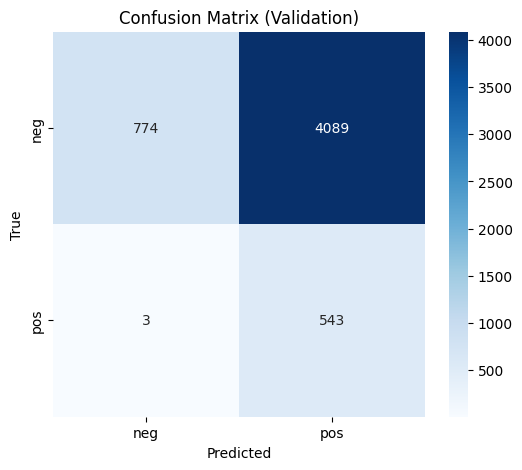

Test Evaluation:   0%|                                                       | 0/511 [00:00<?, ?it/s]

Test Evaluation:   0%|                                               | 1/511 [00:00<04:37,  1.84it/s]

Test Evaluation:   0%|▏                                              | 2/511 [00:01<04:16,  1.98it/s]

Test Evaluation:   1%|▎                                              | 3/511 [00:01<04:11,  2.02it/s]

Test Evaluation:   1%|▎                                              | 4/511 [00:01<04:09,  2.03it/s]

Test Evaluation:   1%|▍                                              | 5/511 [00:02<04:06,  2.05it/s]

Test Evaluation:   1%|▌                                              | 6/511 [00:02<03:57,  2.12it/s]

Test Evaluation:   1%|▋                                              | 7/511 [00:03<03:59,  2.11it/s]

Test Evaluation:   2%|▋                                              | 8/511 [00:03<04:00,  2.09it/s]

Test Evaluation:   2%|▊                                              | 9/511 [00:04<04:00,  2.08it/s]

Test Evaluation:   2%|▉                                             | 10/511 [00:04<03:53,  2.14it/s]

Test Evaluation:   2%|▉                                             | 11/511 [00:05<03:56,  2.12it/s]

Test Evaluation:   2%|█                                             | 12/511 [00:05<03:55,  2.11it/s]

Test Evaluation:   3%|█▏                                            | 13/511 [00:06<03:57,  2.10it/s]

Test Evaluation:   3%|█▎                                            | 14/511 [00:06<03:57,  2.09it/s]

Test Evaluation:   3%|█▎                                            | 15/511 [00:07<03:50,  2.15it/s]

Test Evaluation:   3%|█▍                                            | 16/511 [00:07<03:52,  2.13it/s]

Test Evaluation:   3%|█▌                                            | 17/511 [00:08<03:53,  2.11it/s]

Test Evaluation:   4%|█▌                                            | 18/511 [00:08<03:54,  2.10it/s]

Test Evaluation:   4%|█▋                                            | 19/511 [00:09<03:54,  2.10it/s]

Test Evaluation:   4%|█▊                                            | 20/511 [00:09<03:51,  2.12it/s]

Test Evaluation:   4%|█▉                                            | 21/511 [00:09<03:46,  2.16it/s]

Test Evaluation:   4%|█▉                                            | 22/511 [00:10<03:49,  2.13it/s]

Test Evaluation:   5%|██                                            | 23/511 [00:10<03:51,  2.11it/s]

Test Evaluation:   5%|██▏                                           | 24/511 [00:11<03:46,  2.15it/s]

Test Evaluation:   5%|██▎                                           | 25/511 [00:11<03:46,  2.15it/s]

Test Evaluation:   5%|██▎                                           | 26/511 [00:12<03:49,  2.11it/s]

Test Evaluation:   5%|██▍                                           | 27/511 [00:12<03:51,  2.09it/s]

Test Evaluation:   5%|██▌                                           | 28/511 [00:13<03:44,  2.16it/s]

Test Evaluation:   6%|██▌                                           | 29/511 [00:13<03:53,  2.06it/s]

Test Evaluation:   6%|██▋                                           | 30/511 [00:14<03:52,  2.07it/s]

Test Evaluation:   6%|██▊                                           | 31/511 [00:14<03:52,  2.07it/s]

Test Evaluation:   6%|██▉                                           | 32/511 [00:15<03:43,  2.14it/s]

Test Evaluation:   6%|██▉                                           | 33/511 [00:15<03:44,  2.13it/s]

Test Evaluation:   7%|███                                           | 34/511 [00:16<03:45,  2.11it/s]

Test Evaluation:   7%|███▏                                          | 35/511 [00:16<03:47,  2.09it/s]

Test Evaluation:   7%|███▏                                          | 36/511 [00:17<03:47,  2.09it/s]

Test Evaluation:   7%|███▎                                          | 37/511 [00:17<03:39,  2.16it/s]

Test Evaluation:   7%|███▍                                          | 38/511 [00:18<03:41,  2.13it/s]

Test Evaluation:   8%|███▌                                          | 39/511 [00:18<03:43,  2.11it/s]

Test Evaluation:   8%|███▌                                          | 40/511 [00:19<03:44,  2.10it/s]

Test Evaluation:   8%|███▋                                          | 41/511 [00:19<03:35,  2.18it/s]

Test Evaluation:   8%|███▊                                          | 42/511 [00:19<03:38,  2.15it/s]

Test Evaluation:   8%|███▊                                          | 43/511 [00:20<03:41,  2.12it/s]

Test Evaluation:   9%|███▉                                          | 44/511 [00:20<03:42,  2.10it/s]

Test Evaluation:   9%|████                                          | 45/511 [00:21<03:42,  2.09it/s]

Test Evaluation:   9%|████▏                                         | 46/511 [00:21<03:40,  2.11it/s]

Test Evaluation:   9%|████▏                                         | 47/511 [00:22<03:36,  2.15it/s]

Test Evaluation:   9%|████▎                                         | 48/511 [00:22<03:38,  2.12it/s]

Test Evaluation:  10%|████▍                                         | 49/511 [00:23<03:40,  2.10it/s]

Test Evaluation:  10%|████▌                                         | 50/511 [00:23<03:40,  2.09it/s]

Test Evaluation:  10%|████▌                                         | 51/511 [00:24<03:40,  2.08it/s]

Test Evaluation:  10%|████▋                                         | 52/511 [00:24<03:41,  2.07it/s]

Test Evaluation:  10%|████▊                                         | 53/511 [00:25<03:33,  2.15it/s]

Test Evaluation:  11%|████▊                                         | 54/511 [00:25<03:36,  2.11it/s]

Test Evaluation:  11%|████▉                                         | 55/511 [00:26<03:38,  2.09it/s]

Test Evaluation:  11%|█████                                         | 56/511 [00:26<03:39,  2.08it/s]

Test Evaluation:  11%|█████▏                                        | 57/511 [00:27<03:39,  2.07it/s]

Test Evaluation:  11%|█████▏                                        | 58/511 [00:27<03:40,  2.06it/s]

Test Evaluation:  12%|█████▎                                        | 59/511 [00:28<03:34,  2.11it/s]

Test Evaluation:  12%|█████▍                                        | 60/511 [00:28<03:35,  2.09it/s]

Test Evaluation:  12%|█████▍                                        | 61/511 [00:28<03:35,  2.08it/s]

Test Evaluation:  12%|█████▌                                        | 62/511 [00:29<03:36,  2.08it/s]

Test Evaluation:  12%|█████▋                                        | 63/511 [00:29<03:35,  2.08it/s]

Test Evaluation:  13%|█████▊                                        | 64/511 [00:30<03:35,  2.07it/s]

Test Evaluation:  13%|█████▊                                        | 65/511 [00:30<03:35,  2.07it/s]

Test Evaluation:  13%|█████▉                                        | 66/511 [00:31<03:34,  2.08it/s]

Test Evaluation:  13%|██████                                        | 67/511 [00:31<03:33,  2.08it/s]

Test Evaluation:  13%|██████                                        | 68/511 [00:32<03:33,  2.07it/s]

Test Evaluation:  14%|██████▏                                       | 69/511 [00:32<03:33,  2.07it/s]

Test Evaluation:  14%|██████▎                                       | 70/511 [00:33<03:33,  2.07it/s]

Test Evaluation:  14%|██████▍                                       | 71/511 [00:33<03:33,  2.06it/s]

Test Evaluation:  14%|██████▍                                       | 72/511 [00:34<03:32,  2.07it/s]

Test Evaluation:  14%|██████▌                                       | 73/511 [00:34<03:31,  2.07it/s]

Test Evaluation:  14%|██████▋                                       | 74/511 [00:35<03:30,  2.08it/s]

Test Evaluation:  15%|██████▊                                       | 75/511 [00:35<03:29,  2.08it/s]

Test Evaluation:  15%|██████▊                                       | 76/511 [00:36<03:28,  2.09it/s]

Test Evaluation:  15%|██████▉                                       | 77/511 [00:36<03:28,  2.08it/s]

Test Evaluation:  15%|███████                                       | 78/511 [00:37<03:27,  2.09it/s]

Test Evaluation:  15%|███████                                       | 79/511 [00:37<03:27,  2.08it/s]

Test Evaluation:  16%|███████▏                                      | 80/511 [00:38<03:27,  2.08it/s]

Test Evaluation:  16%|███████▎                                      | 81/511 [00:38<03:26,  2.08it/s]

Test Evaluation:  16%|███████▍                                      | 82/511 [00:39<03:25,  2.09it/s]

Test Evaluation:  16%|███████▍                                      | 83/511 [00:39<03:24,  2.09it/s]

Test Evaluation:  16%|███████▌                                      | 84/511 [00:40<03:23,  2.10it/s]

Test Evaluation:  17%|███████▋                                      | 85/511 [00:40<03:23,  2.10it/s]

Test Evaluation:  17%|███████▋                                      | 86/511 [00:41<03:22,  2.10it/s]

Test Evaluation:  17%|███████▊                                      | 87/511 [00:41<03:22,  2.10it/s]

Test Evaluation:  17%|███████▉                                      | 88/511 [00:41<03:22,  2.09it/s]

Test Evaluation:  17%|████████                                      | 89/511 [00:42<03:22,  2.08it/s]

Test Evaluation:  18%|████████                                      | 90/511 [00:42<03:22,  2.08it/s]

Test Evaluation:  18%|████████▏                                     | 91/511 [00:43<03:21,  2.08it/s]

Test Evaluation:  18%|████████▎                                     | 92/511 [00:43<03:23,  2.06it/s]

Test Evaluation:  18%|████████▎                                     | 93/511 [00:44<03:23,  2.06it/s]

Test Evaluation:  18%|████████▍                                     | 94/511 [00:44<03:21,  2.07it/s]

Test Evaluation:  19%|████████▌                                     | 95/511 [00:45<03:20,  2.07it/s]

Test Evaluation:  19%|████████▋                                     | 96/511 [00:45<03:20,  2.07it/s]

Test Evaluation:  19%|████████▋                                     | 97/511 [00:46<03:19,  2.08it/s]

Test Evaluation:  19%|████████▊                                     | 98/511 [00:46<03:20,  2.06it/s]

Test Evaluation:  19%|████████▉                                     | 99/511 [00:47<03:17,  2.09it/s]

Test Evaluation:  20%|████████▊                                    | 100/511 [00:47<03:11,  2.14it/s]

Test Evaluation:  20%|████████▉                                    | 101/511 [00:48<03:12,  2.13it/s]

Test Evaluation:  20%|████████▉                                    | 102/511 [00:48<03:14,  2.11it/s]

Test Evaluation:  20%|█████████                                    | 103/511 [00:49<03:14,  2.10it/s]

Test Evaluation:  20%|█████████▏                                   | 104/511 [00:49<03:14,  2.09it/s]

Test Evaluation:  21%|█████████▏                                   | 105/511 [00:50<03:20,  2.03it/s]

Test Evaluation:  21%|█████████▎                                   | 106/511 [00:50<03:17,  2.05it/s]

Test Evaluation:  21%|█████████▍                                   | 107/511 [00:51<03:14,  2.07it/s]

Test Evaluation:  21%|█████████▌                                   | 108/511 [00:51<03:13,  2.08it/s]

Test Evaluation:  21%|█████████▌                                   | 109/511 [00:52<03:13,  2.08it/s]

Test Evaluation:  22%|█████████▋                                   | 110/511 [00:52<03:12,  2.08it/s]

Test Evaluation:  22%|█████████▊                                   | 111/511 [00:53<03:12,  2.08it/s]

Test Evaluation:  22%|█████████▊                                   | 112/511 [00:53<03:11,  2.09it/s]

Test Evaluation:  22%|█████████▉                                   | 113/511 [00:53<03:11,  2.08it/s]

Test Evaluation:  22%|██████████                                   | 114/511 [00:54<03:09,  2.09it/s]

Test Evaluation:  23%|██████████▏                                  | 115/511 [00:54<03:11,  2.07it/s]

Test Evaluation:  23%|██████████▏                                  | 116/511 [00:55<03:10,  2.07it/s]

Test Evaluation:  23%|██████████▎                                  | 117/511 [00:55<03:10,  2.07it/s]

Test Evaluation:  23%|██████████▍                                  | 118/511 [00:56<03:08,  2.08it/s]

Test Evaluation:  23%|██████████▍                                  | 119/511 [00:56<03:01,  2.16it/s]

Test Evaluation:  23%|██████████▌                                  | 120/511 [00:57<03:03,  2.13it/s]

Test Evaluation:  24%|██████████▋                                  | 121/511 [00:57<03:04,  2.11it/s]

Test Evaluation:  24%|██████████▋                                  | 122/511 [00:58<03:06,  2.09it/s]

Test Evaluation:  24%|██████████▊                                  | 123/511 [00:58<03:06,  2.09it/s]

Test Evaluation:  24%|██████████▉                                  | 124/511 [00:59<03:06,  2.08it/s]

Test Evaluation:  24%|███████████                                  | 125/511 [00:59<03:06,  2.08it/s]

Test Evaluation:  25%|███████████                                  | 126/511 [01:00<03:05,  2.08it/s]

Test Evaluation:  25%|███████████▏                                 | 127/511 [01:00<03:04,  2.08it/s]

Test Evaluation:  25%|███████████▎                                 | 128/511 [01:01<03:03,  2.09it/s]

Test Evaluation:  25%|███████████▎                                 | 129/511 [01:01<03:02,  2.09it/s]

Test Evaluation:  25%|███████████▍                                 | 130/511 [01:02<03:04,  2.07it/s]

Test Evaluation:  26%|███████████▌                                 | 131/511 [01:02<03:02,  2.08it/s]

Test Evaluation:  26%|███████████▌                                 | 132/511 [01:03<03:02,  2.08it/s]

Test Evaluation:  26%|███████████▋                                 | 133/511 [01:03<03:01,  2.08it/s]

Test Evaluation:  26%|███████████▊                                 | 134/511 [01:04<03:01,  2.08it/s]

Test Evaluation:  26%|███████████▉                                 | 135/511 [01:04<03:00,  2.09it/s]

Test Evaluation:  27%|███████████▉                                 | 136/511 [01:05<03:00,  2.08it/s]

Test Evaluation:  27%|████████████                                 | 137/511 [01:05<03:00,  2.07it/s]

Test Evaluation:  27%|████████████▏                                | 138/511 [01:05<02:59,  2.08it/s]

Test Evaluation:  27%|████████████▏                                | 139/511 [01:06<02:59,  2.07it/s]

Test Evaluation:  27%|████████████▎                                | 140/511 [01:06<02:57,  2.09it/s]

Test Evaluation:  28%|████████████▍                                | 141/511 [01:07<02:56,  2.09it/s]

Test Evaluation:  28%|████████████▌                                | 142/511 [01:07<02:56,  2.09it/s]

Test Evaluation:  28%|████████████▌                                | 143/511 [01:08<02:56,  2.08it/s]

Test Evaluation:  28%|████████████▋                                | 144/511 [01:08<02:56,  2.08it/s]

Test Evaluation:  28%|████████████▊                                | 145/511 [01:09<02:55,  2.08it/s]

Test Evaluation:  29%|████████████▊                                | 146/511 [01:09<02:55,  2.08it/s]

Test Evaluation:  29%|████████████▉                                | 147/511 [01:10<02:54,  2.09it/s]

Test Evaluation:  29%|█████████████                                | 148/511 [01:10<02:54,  2.09it/s]

Test Evaluation:  29%|█████████████                                | 149/511 [01:11<02:54,  2.08it/s]

Test Evaluation:  29%|█████████████▏                               | 150/511 [01:11<02:53,  2.08it/s]

Test Evaluation:  30%|█████████████▎                               | 151/511 [01:12<02:53,  2.07it/s]

Test Evaluation:  30%|█████████████▍                               | 152/511 [01:12<02:53,  2.07it/s]

Test Evaluation:  30%|█████████████▍                               | 153/511 [01:13<02:53,  2.07it/s]

Test Evaluation:  30%|█████████████▌                               | 154/511 [01:13<02:53,  2.06it/s]

Test Evaluation:  30%|█████████████▋                               | 155/511 [01:14<02:54,  2.04it/s]

Test Evaluation:  31%|█████████████▋                               | 156/511 [01:14<02:53,  2.05it/s]

Test Evaluation:  31%|█████████████▊                               | 157/511 [01:15<02:52,  2.06it/s]

Test Evaluation:  31%|█████████████▉                               | 158/511 [01:15<02:51,  2.06it/s]

Test Evaluation:  31%|██████████████                               | 159/511 [01:16<02:44,  2.14it/s]

Test Evaluation:  31%|██████████████                               | 160/511 [01:16<02:47,  2.10it/s]

Test Evaluation:  32%|██████████████▏                              | 161/511 [01:17<02:47,  2.09it/s]

Test Evaluation:  32%|██████████████▎                              | 162/511 [01:17<02:47,  2.08it/s]

Test Evaluation:  32%|██████████████▎                              | 163/511 [01:17<02:46,  2.08it/s]

Test Evaluation:  32%|██████████████▍                              | 164/511 [01:18<02:45,  2.09it/s]

Test Evaluation:  32%|██████████████▌                              | 165/511 [01:18<02:46,  2.08it/s]

Test Evaluation:  32%|██████████████▌                              | 166/511 [01:19<02:45,  2.08it/s]

Test Evaluation:  33%|██████████████▋                              | 167/511 [01:19<02:45,  2.08it/s]

Test Evaluation:  33%|██████████████▊                              | 168/511 [01:20<02:44,  2.08it/s]

Test Evaluation:  33%|██████████████▉                              | 169/511 [01:20<02:44,  2.08it/s]

Test Evaluation:  33%|██████████████▉                              | 170/511 [01:21<02:44,  2.07it/s]

Test Evaluation:  33%|███████████████                              | 171/511 [01:21<02:43,  2.08it/s]

Test Evaluation:  34%|███████████████▏                             | 172/511 [01:22<02:43,  2.08it/s]

Test Evaluation:  34%|███████████████▏                             | 173/511 [01:22<02:42,  2.07it/s]

Test Evaluation:  34%|███████████████▎                             | 174/511 [01:23<02:43,  2.07it/s]

Test Evaluation:  34%|███████████████▍                             | 175/511 [01:23<02:42,  2.06it/s]

Test Evaluation:  34%|███████████████▍                             | 176/511 [01:24<02:42,  2.06it/s]

Test Evaluation:  35%|███████████████▌                             | 177/511 [01:24<02:40,  2.08it/s]

Test Evaluation:  35%|███████████████▋                             | 178/511 [01:25<02:38,  2.10it/s]

Test Evaluation:  35%|███████████████▊                             | 179/511 [01:25<02:38,  2.09it/s]

Test Evaluation:  35%|███████████████▊                             | 180/511 [01:26<02:39,  2.08it/s]

Test Evaluation:  35%|███████████████▉                             | 181/511 [01:26<02:38,  2.08it/s]

Test Evaluation:  36%|████████████████                             | 182/511 [01:27<02:39,  2.06it/s]

Test Evaluation:  36%|████████████████                             | 183/511 [01:27<02:39,  2.06it/s]

Test Evaluation:  36%|████████████████▏                            | 184/511 [01:28<02:38,  2.06it/s]

Test Evaluation:  36%|████████████████▎                            | 185/511 [01:28<02:37,  2.07it/s]

Test Evaluation:  36%|████████████████▍                            | 186/511 [01:29<02:37,  2.06it/s]

Test Evaluation:  37%|████████████████▍                            | 187/511 [01:29<02:36,  2.07it/s]

Test Evaluation:  37%|████████████████▌                            | 188/511 [01:30<02:35,  2.07it/s]

Test Evaluation:  37%|████████████████▋                            | 189/511 [01:30<02:35,  2.07it/s]

Test Evaluation:  37%|████████████████▋                            | 190/511 [01:31<02:34,  2.07it/s]

Test Evaluation:  37%|████████████████▊                            | 191/511 [01:31<02:35,  2.06it/s]

Test Evaluation:  38%|████████████████▉                            | 192/511 [01:31<02:33,  2.07it/s]

Test Evaluation:  38%|████████████████▉                            | 193/511 [01:32<02:33,  2.07it/s]

Test Evaluation:  38%|█████████████████                            | 194/511 [01:32<02:33,  2.07it/s]

Test Evaluation:  38%|█████████████████▏                           | 195/511 [01:33<02:32,  2.07it/s]

Test Evaluation:  38%|█████████████████▎                           | 196/511 [01:33<02:31,  2.08it/s]

Test Evaluation:  39%|█████████████████▎                           | 197/511 [01:34<02:31,  2.07it/s]

Test Evaluation:  39%|█████████████████▍                           | 198/511 [01:34<02:31,  2.07it/s]

Test Evaluation:  39%|█████████████████▌                           | 199/511 [01:35<02:31,  2.06it/s]

Test Evaluation:  39%|█████████████████▌                           | 200/511 [01:35<02:30,  2.07it/s]

Test Evaluation:  39%|█████████████████▋                           | 201/511 [01:36<02:29,  2.08it/s]

Test Evaluation:  40%|█████████████████▊                           | 202/511 [01:36<02:28,  2.08it/s]

Test Evaluation:  40%|█████████████████▉                           | 203/511 [01:37<02:27,  2.09it/s]

Test Evaluation:  40%|█████████████████▉                           | 204/511 [01:37<02:26,  2.09it/s]

Test Evaluation:  40%|██████████████████                           | 205/511 [01:38<02:26,  2.09it/s]

Test Evaluation:  40%|██████████████████▏                          | 206/511 [01:38<02:26,  2.08it/s]

Test Evaluation:  41%|██████████████████▏                          | 207/511 [01:39<02:22,  2.13it/s]

Test Evaluation:  41%|██████████████████▎                          | 208/511 [01:39<02:23,  2.11it/s]

Test Evaluation:  41%|██████████████████▍                          | 209/511 [01:40<02:24,  2.10it/s]

Test Evaluation:  41%|██████████████████▍                          | 210/511 [01:40<02:24,  2.08it/s]

Test Evaluation:  41%|██████████████████▌                          | 211/511 [01:41<02:24,  2.08it/s]

Test Evaluation:  41%|██████████████████▋                          | 212/511 [01:41<02:23,  2.09it/s]

Test Evaluation:  42%|██████████████████▊                          | 213/511 [01:42<02:22,  2.09it/s]

Test Evaluation:  42%|██████████████████▊                          | 214/511 [01:42<02:22,  2.08it/s]

Test Evaluation:  42%|██████████████████▉                          | 215/511 [01:43<02:22,  2.08it/s]

Test Evaluation:  42%|███████████████████                          | 216/511 [01:43<02:22,  2.08it/s]

Test Evaluation:  42%|███████████████████                          | 217/511 [01:43<02:21,  2.08it/s]

Test Evaluation:  43%|███████████████████▏                         | 218/511 [01:44<02:20,  2.09it/s]

Test Evaluation:  43%|███████████████████▎                         | 219/511 [01:44<02:19,  2.10it/s]

Test Evaluation:  43%|███████████████████▎                         | 220/511 [01:45<02:19,  2.09it/s]

Test Evaluation:  43%|███████████████████▍                         | 221/511 [01:45<02:18,  2.10it/s]

Test Evaluation:  43%|███████████████████▌                         | 222/511 [01:46<02:17,  2.10it/s]

Test Evaluation:  44%|███████████████████▋                         | 223/511 [01:46<02:17,  2.09it/s]

Test Evaluation:  44%|███████████████████▋                         | 224/511 [01:47<02:17,  2.09it/s]

Test Evaluation:  44%|███████████████████▊                         | 225/511 [01:47<02:17,  2.08it/s]

Test Evaluation:  44%|███████████████████▉                         | 226/511 [01:48<02:16,  2.09it/s]

Test Evaluation:  44%|███████████████████▉                         | 227/511 [01:48<02:16,  2.09it/s]

Test Evaluation:  45%|████████████████████                         | 228/511 [01:49<02:15,  2.09it/s]

Test Evaluation:  45%|████████████████████▏                        | 229/511 [01:49<02:15,  2.08it/s]

Test Evaluation:  45%|████████████████████▎                        | 230/511 [01:50<02:14,  2.08it/s]

Test Evaluation:  45%|████████████████████▎                        | 231/511 [01:50<02:14,  2.08it/s]

Test Evaluation:  45%|████████████████████▍                        | 232/511 [01:51<02:13,  2.09it/s]

Test Evaluation:  46%|████████████████████▌                        | 233/511 [01:51<02:13,  2.08it/s]

Test Evaluation:  46%|████████████████████▌                        | 234/511 [01:52<02:14,  2.06it/s]

Test Evaluation:  46%|████████████████████▋                        | 235/511 [01:52<02:12,  2.08it/s]

Test Evaluation:  46%|████████████████████▊                        | 236/511 [01:53<02:13,  2.06it/s]

Test Evaluation:  46%|████████████████████▊                        | 237/511 [01:53<02:12,  2.06it/s]

Test Evaluation:  47%|████████████████████▉                        | 238/511 [01:54<02:12,  2.06it/s]

Test Evaluation:  47%|█████████████████████                        | 239/511 [01:54<02:13,  2.04it/s]

Test Evaluation:  47%|█████████████████████▏                       | 240/511 [01:55<02:11,  2.06it/s]

Test Evaluation:  47%|█████████████████████▏                       | 241/511 [01:55<02:11,  2.05it/s]

Test Evaluation:  47%|█████████████████████▎                       | 242/511 [01:56<02:10,  2.06it/s]

Test Evaluation:  48%|█████████████████████▍                       | 243/511 [01:56<02:10,  2.05it/s]

Test Evaluation:  48%|█████████████████████▍                       | 244/511 [01:57<02:10,  2.05it/s]

Test Evaluation:  48%|█████████████████████▌                       | 245/511 [01:57<02:08,  2.07it/s]

Test Evaluation:  48%|█████████████████████▋                       | 246/511 [01:57<02:03,  2.14it/s]

Test Evaluation:  48%|█████████████████████▊                       | 247/511 [01:58<02:04,  2.12it/s]

Test Evaluation:  49%|█████████████████████▊                       | 248/511 [01:58<02:05,  2.10it/s]

Test Evaluation:  49%|█████████████████████▉                       | 249/511 [01:59<02:05,  2.09it/s]

Test Evaluation:  49%|██████████████████████                       | 250/511 [01:59<02:05,  2.08it/s]

Test Evaluation:  49%|██████████████████████                       | 251/511 [02:00<02:05,  2.08it/s]

Test Evaluation:  49%|██████████████████████▏                      | 252/511 [02:00<02:04,  2.07it/s]

Test Evaluation:  50%|██████████████████████▎                      | 253/511 [02:01<02:04,  2.07it/s]

Test Evaluation:  50%|██████████████████████▎                      | 254/511 [02:01<02:04,  2.07it/s]

Test Evaluation:  50%|██████████████████████▍                      | 255/511 [02:02<02:03,  2.07it/s]

Test Evaluation:  50%|██████████████████████▌                      | 256/511 [02:02<02:02,  2.08it/s]

Test Evaluation:  50%|██████████████████████▋                      | 257/511 [02:03<02:02,  2.07it/s]

Test Evaluation:  50%|██████████████████████▋                      | 258/511 [02:03<02:02,  2.06it/s]

Test Evaluation:  51%|██████████████████████▊                      | 259/511 [02:04<02:01,  2.07it/s]

Test Evaluation:  51%|██████████████████████▉                      | 260/511 [02:04<02:01,  2.07it/s]

Test Evaluation:  51%|██████████████████████▉                      | 261/511 [02:05<02:00,  2.08it/s]

Test Evaluation:  51%|███████████████████████                      | 262/511 [02:05<01:59,  2.08it/s]

Test Evaluation:  51%|███████████████████████▏                     | 263/511 [02:06<01:58,  2.09it/s]

Test Evaluation:  52%|███████████████████████▏                     | 264/511 [02:06<01:58,  2.09it/s]

Test Evaluation:  52%|███████████████████████▎                     | 265/511 [02:07<01:58,  2.08it/s]

Test Evaluation:  52%|███████████████████████▍                     | 266/511 [02:07<01:57,  2.09it/s]

Test Evaluation:  52%|███████████████████████▌                     | 267/511 [02:08<01:57,  2.08it/s]

Test Evaluation:  52%|███████████████████████▌                     | 268/511 [02:08<01:56,  2.08it/s]

Test Evaluation:  53%|███████████████████████▋                     | 269/511 [02:08<01:55,  2.10it/s]

Test Evaluation:  53%|███████████████████████▊                     | 270/511 [02:09<01:55,  2.09it/s]

Test Evaluation:  53%|███████████████████████▊                     | 271/511 [02:09<01:55,  2.08it/s]

Test Evaluation:  53%|███████████████████████▉                     | 272/511 [02:10<01:54,  2.09it/s]

Test Evaluation:  53%|████████████████████████                     | 273/511 [02:10<01:54,  2.09it/s]

Test Evaluation:  54%|████████████████████████▏                    | 274/511 [02:11<01:49,  2.16it/s]

Test Evaluation:  54%|████████████████████████▏                    | 275/511 [02:11<01:50,  2.13it/s]

Test Evaluation:  54%|████████████████████████▎                    | 276/511 [02:12<01:51,  2.11it/s]

Test Evaluation:  54%|████████████████████████▍                    | 277/511 [02:12<01:51,  2.11it/s]

Test Evaluation:  54%|████████████████████████▍                    | 278/511 [02:13<01:51,  2.09it/s]

Test Evaluation:  55%|████████████████████████▌                    | 279/511 [02:13<01:52,  2.07it/s]

Test Evaluation:  55%|████████████████████████▋                    | 280/511 [02:14<01:51,  2.07it/s]

Test Evaluation:  55%|████████████████████████▋                    | 281/511 [02:14<01:51,  2.07it/s]

Test Evaluation:  55%|████████████████████████▊                    | 282/511 [02:15<01:50,  2.08it/s]

Test Evaluation:  55%|████████████████████████▉                    | 283/511 [02:15<01:49,  2.08it/s]

Test Evaluation:  56%|█████████████████████████                    | 284/511 [02:16<01:48,  2.09it/s]

Test Evaluation:  56%|█████████████████████████                    | 285/511 [02:16<01:48,  2.08it/s]

Test Evaluation:  56%|█████████████████████████▏                   | 286/511 [02:17<01:48,  2.08it/s]

Test Evaluation:  56%|█████████████████████████▎                   | 287/511 [02:17<01:47,  2.08it/s]

Test Evaluation:  56%|█████████████████████████▎                   | 288/511 [02:18<01:47,  2.08it/s]

Test Evaluation:  57%|█████████████████████████▍                   | 289/511 [02:18<01:46,  2.08it/s]

Test Evaluation:  57%|█████████████████████████▌                   | 290/511 [02:19<01:45,  2.09it/s]

Test Evaluation:  57%|█████████████████████████▋                   | 291/511 [02:19<01:45,  2.09it/s]

Test Evaluation:  57%|█████████████████████████▋                   | 292/511 [02:19<01:44,  2.09it/s]

Test Evaluation:  57%|█████████████████████████▊                   | 293/511 [02:20<01:44,  2.09it/s]

Test Evaluation:  58%|█████████████████████████▉                   | 294/511 [02:20<01:44,  2.09it/s]

Test Evaluation:  58%|█████████████████████████▉                   | 295/511 [02:21<01:43,  2.09it/s]

Test Evaluation:  58%|██████████████████████████                   | 296/511 [02:21<01:42,  2.09it/s]

Test Evaluation:  58%|██████████████████████████▏                  | 297/511 [02:22<01:41,  2.10it/s]

Test Evaluation:  58%|██████████████████████████▏                  | 298/511 [02:22<01:41,  2.10it/s]

Test Evaluation:  59%|██████████████████████████▎                  | 299/511 [02:23<01:40,  2.10it/s]

Test Evaluation:  59%|██████████████████████████▍                  | 300/511 [02:23<01:40,  2.10it/s]

Test Evaluation:  59%|██████████████████████████▌                  | 301/511 [02:24<01:40,  2.09it/s]

Test Evaluation:  59%|██████████████████████████▌                  | 302/511 [02:24<01:39,  2.10it/s]

Test Evaluation:  59%|██████████████████████████▋                  | 303/511 [02:25<01:39,  2.10it/s]

Test Evaluation:  59%|██████████████████████████▊                  | 304/511 [02:25<01:39,  2.08it/s]

Test Evaluation:  60%|██████████████████████████▊                  | 305/511 [02:26<01:39,  2.07it/s]

Test Evaluation:  60%|██████████████████████████▉                  | 306/511 [02:26<01:39,  2.07it/s]

Test Evaluation:  60%|███████████████████████████                  | 307/511 [02:27<01:39,  2.06it/s]

Test Evaluation:  60%|███████████████████████████                  | 308/511 [02:27<01:38,  2.06it/s]

Test Evaluation:  60%|███████████████████████████▏                 | 309/511 [02:28<01:37,  2.08it/s]

Test Evaluation:  61%|███████████████████████████▎                 | 310/511 [02:28<01:36,  2.07it/s]

Test Evaluation:  61%|███████████████████████████▍                 | 311/511 [02:29<01:33,  2.13it/s]

Test Evaluation:  61%|███████████████████████████▍                 | 312/511 [02:29<01:32,  2.15it/s]

Test Evaluation:  61%|███████████████████████████▌                 | 313/511 [02:30<01:33,  2.13it/s]

Test Evaluation:  61%|███████████████████████████▋                 | 314/511 [02:30<01:33,  2.12it/s]

Test Evaluation:  62%|███████████████████████████▋                 | 315/511 [02:30<01:33,  2.09it/s]

Test Evaluation:  62%|███████████████████████████▊                 | 316/511 [02:31<01:33,  2.09it/s]

Test Evaluation:  62%|███████████████████████████▉                 | 317/511 [02:31<01:32,  2.09it/s]

Test Evaluation:  62%|████████████████████████████                 | 318/511 [02:32<01:32,  2.09it/s]

Test Evaluation:  62%|████████████████████████████                 | 319/511 [02:32<01:32,  2.09it/s]

Test Evaluation:  63%|████████████████████████████▏                | 320/511 [02:33<01:31,  2.08it/s]

Test Evaluation:  63%|████████████████████████████▎                | 321/511 [02:33<01:31,  2.07it/s]

Test Evaluation:  63%|████████████████████████████▎                | 322/511 [02:34<01:30,  2.09it/s]

Test Evaluation:  63%|████████████████████████████▍                | 323/511 [02:34<01:29,  2.09it/s]

Test Evaluation:  63%|████████████████████████████▌                | 324/511 [02:35<01:29,  2.09it/s]

Test Evaluation:  64%|████████████████████████████▌                | 325/511 [02:35<01:29,  2.07it/s]

Test Evaluation:  64%|████████████████████████████▋                | 326/511 [02:36<01:29,  2.08it/s]

Test Evaluation:  64%|████████████████████████████▊                | 327/511 [02:36<01:28,  2.07it/s]

Test Evaluation:  64%|████████████████████████████▉                | 328/511 [02:37<01:27,  2.09it/s]

Test Evaluation:  64%|████████████████████████████▉                | 329/511 [02:37<01:27,  2.09it/s]

Test Evaluation:  65%|█████████████████████████████                | 330/511 [02:38<01:26,  2.09it/s]

Test Evaluation:  65%|█████████████████████████████▏               | 331/511 [02:38<01:26,  2.09it/s]

Test Evaluation:  65%|█████████████████████████████▏               | 332/511 [02:39<01:25,  2.09it/s]

Test Evaluation:  65%|█████████████████████████████▎               | 333/511 [02:39<01:25,  2.07it/s]

Test Evaluation:  65%|█████████████████████████████▍               | 334/511 [02:40<01:25,  2.08it/s]

Test Evaluation:  66%|█████████████████████████████▌               | 335/511 [02:40<01:23,  2.10it/s]

Test Evaluation:  66%|█████████████████████████████▌               | 336/511 [02:41<01:23,  2.09it/s]

Test Evaluation:  66%|█████████████████████████████▋               | 337/511 [02:41<01:23,  2.09it/s]

Test Evaluation:  66%|█████████████████████████████▊               | 338/511 [02:42<01:22,  2.10it/s]

Test Evaluation:  66%|█████████████████████████████▊               | 339/511 [02:42<01:19,  2.15it/s]

Test Evaluation:  67%|█████████████████████████████▉               | 340/511 [02:42<01:19,  2.14it/s]

Test Evaluation:  67%|██████████████████████████████               | 341/511 [02:43<01:20,  2.12it/s]

Test Evaluation:  67%|██████████████████████████████               | 342/511 [02:43<01:20,  2.09it/s]

Test Evaluation:  67%|██████████████████████████████▏              | 343/511 [02:44<01:20,  2.08it/s]

Test Evaluation:  67%|██████████████████████████████▎              | 344/511 [02:44<01:20,  2.08it/s]

Test Evaluation:  68%|██████████████████████████████▍              | 345/511 [02:45<01:19,  2.08it/s]

Test Evaluation:  68%|██████████████████████████████▍              | 346/511 [02:45<01:19,  2.07it/s]

Test Evaluation:  68%|██████████████████████████████▌              | 347/511 [02:46<01:18,  2.08it/s]

Test Evaluation:  68%|██████████████████████████████▋              | 348/511 [02:46<01:18,  2.08it/s]

Test Evaluation:  68%|██████████████████████████████▋              | 349/511 [02:47<01:17,  2.08it/s]

Test Evaluation:  68%|██████████████████████████████▊              | 350/511 [02:47<01:17,  2.08it/s]

Test Evaluation:  69%|██████████████████████████████▉              | 351/511 [02:48<01:16,  2.08it/s]

Test Evaluation:  69%|██████████████████████████████▉              | 352/511 [02:48<01:16,  2.08it/s]

Test Evaluation:  69%|███████████████████████████████              | 353/511 [02:49<01:16,  2.07it/s]

Test Evaluation:  69%|███████████████████████████████▏             | 354/511 [02:49<01:15,  2.07it/s]

Test Evaluation:  69%|███████████████████████████████▎             | 355/511 [02:50<01:15,  2.08it/s]

Test Evaluation:  70%|███████████████████████████████▎             | 356/511 [02:50<01:14,  2.07it/s]

Test Evaluation:  70%|███████████████████████████████▍             | 357/511 [02:51<01:13,  2.09it/s]

Test Evaluation:  70%|███████████████████████████████▌             | 358/511 [02:51<01:13,  2.09it/s]

Test Evaluation:  70%|███████████████████████████████▌             | 359/511 [02:52<01:12,  2.09it/s]

Test Evaluation:  70%|███████████████████████████████▋             | 360/511 [02:52<01:11,  2.10it/s]

Test Evaluation:  71%|███████████████████████████████▊             | 361/511 [02:53<01:11,  2.10it/s]

Test Evaluation:  71%|███████████████████████████████▉             | 362/511 [02:53<01:11,  2.07it/s]

Test Evaluation:  71%|███████████████████████████████▉             | 363/511 [02:53<01:11,  2.08it/s]

Test Evaluation:  71%|████████████████████████████████             | 364/511 [02:54<01:10,  2.10it/s]

Test Evaluation:  71%|████████████████████████████████▏            | 365/511 [02:54<01:07,  2.16it/s]

Test Evaluation:  72%|████████████████████████████████▏            | 366/511 [02:55<01:07,  2.13it/s]

Test Evaluation:  72%|████████████████████████████████▎            | 367/511 [02:55<01:08,  2.11it/s]

Test Evaluation:  72%|████████████████████████████████▍            | 368/511 [02:56<01:08,  2.10it/s]

Test Evaluation:  72%|████████████████████████████████▍            | 369/511 [02:56<01:07,  2.09it/s]

Test Evaluation:  72%|████████████████████████████████▌            | 370/511 [02:57<01:07,  2.09it/s]

Test Evaluation:  73%|████████████████████████████████▋            | 371/511 [02:57<01:06,  2.10it/s]

Test Evaluation:  73%|████████████████████████████████▊            | 372/511 [02:58<01:06,  2.10it/s]

Test Evaluation:  73%|████████████████████████████████▊            | 373/511 [02:58<01:06,  2.09it/s]

Test Evaluation:  73%|████████████████████████████████▉            | 374/511 [02:59<01:05,  2.08it/s]

Test Evaluation:  73%|█████████████████████████████████            | 375/511 [02:59<01:05,  2.08it/s]

Test Evaluation:  74%|█████████████████████████████████            | 376/511 [03:00<01:05,  2.08it/s]

Test Evaluation:  74%|█████████████████████████████████▏           | 377/511 [03:00<01:04,  2.07it/s]

Test Evaluation:  74%|█████████████████████████████████▎           | 378/511 [03:01<01:04,  2.07it/s]

Test Evaluation:  74%|█████████████████████████████████▍           | 379/511 [03:01<01:03,  2.07it/s]

Test Evaluation:  74%|█████████████████████████████████▍           | 380/511 [03:02<01:03,  2.08it/s]

Test Evaluation:  75%|█████████████████████████████████▌           | 381/511 [03:02<01:02,  2.07it/s]

Test Evaluation:  75%|█████████████████████████████████▋           | 382/511 [03:03<01:02,  2.07it/s]

Test Evaluation:  75%|█████████████████████████████████▋           | 383/511 [03:03<01:01,  2.07it/s]

Test Evaluation:  75%|█████████████████████████████████▊           | 384/511 [03:04<01:01,  2.07it/s]

Test Evaluation:  75%|█████████████████████████████████▉           | 385/511 [03:04<01:00,  2.07it/s]

Test Evaluation:  76%|█████████████████████████████████▉           | 386/511 [03:05<01:00,  2.07it/s]

Test Evaluation:  76%|██████████████████████████████████           | 387/511 [03:05<00:59,  2.07it/s]

Test Evaluation:  76%|██████████████████████████████████▏          | 388/511 [03:05<00:59,  2.07it/s]

Test Evaluation:  76%|██████████████████████████████████▎          | 389/511 [03:06<00:59,  2.06it/s]

Test Evaluation:  76%|██████████████████████████████████▎          | 390/511 [03:06<00:58,  2.07it/s]

Test Evaluation:  77%|██████████████████████████████████▍          | 391/511 [03:07<00:58,  2.06it/s]

Test Evaluation:  77%|██████████████████████████████████▌          | 392/511 [03:07<00:57,  2.08it/s]

Test Evaluation:  77%|██████████████████████████████████▌          | 393/511 [03:08<00:56,  2.09it/s]

Test Evaluation:  77%|██████████████████████████████████▋          | 394/511 [03:08<00:56,  2.07it/s]

Test Evaluation:  77%|██████████████████████████████████▊          | 395/511 [03:09<00:55,  2.07it/s]

Test Evaluation:  77%|██████████████████████████████████▊          | 396/511 [03:09<00:55,  2.07it/s]

Test Evaluation:  78%|██████████████████████████████████▉          | 397/511 [03:10<00:54,  2.08it/s]

Test Evaluation:  78%|███████████████████████████████████          | 398/511 [03:10<00:54,  2.08it/s]

Test Evaluation:  78%|███████████████████████████████████▏         | 399/511 [03:11<00:54,  2.07it/s]

Test Evaluation:  78%|███████████████████████████████████▏         | 400/511 [03:11<00:53,  2.07it/s]

Test Evaluation:  78%|███████████████████████████████████▎         | 401/511 [03:12<00:53,  2.06it/s]

Test Evaluation:  79%|███████████████████████████████████▍         | 402/511 [03:12<00:52,  2.08it/s]

Test Evaluation:  79%|███████████████████████████████████▍         | 403/511 [03:13<00:51,  2.08it/s]

Test Evaluation:  79%|███████████████████████████████████▌         | 404/511 [03:13<00:51,  2.06it/s]

Test Evaluation:  79%|███████████████████████████████████▋         | 405/511 [03:14<00:51,  2.08it/s]

Test Evaluation:  79%|███████████████████████████████████▊         | 406/511 [03:14<00:50,  2.07it/s]

Test Evaluation:  80%|███████████████████████████████████▊         | 407/511 [03:15<00:50,  2.06it/s]

Test Evaluation:  80%|███████████████████████████████████▉         | 408/511 [03:15<00:50,  2.06it/s]

Test Evaluation:  80%|████████████████████████████████████         | 409/511 [03:16<00:49,  2.07it/s]

Test Evaluation:  80%|████████████████████████████████████         | 410/511 [03:16<00:47,  2.14it/s]

Test Evaluation:  80%|████████████████████████████████████▏        | 411/511 [03:17<00:47,  2.11it/s]

Test Evaluation:  81%|████████████████████████████████████▎        | 412/511 [03:17<00:47,  2.09it/s]

Test Evaluation:  81%|████████████████████████████████████▎        | 413/511 [03:18<00:46,  2.09it/s]

Test Evaluation:  81%|████████████████████████████████████▍        | 414/511 [03:18<00:46,  2.07it/s]

Test Evaluation:  81%|████████████████████████████████████▌        | 415/511 [03:18<00:46,  2.06it/s]

Test Evaluation:  81%|████████████████████████████████████▋        | 416/511 [03:19<00:45,  2.07it/s]

Test Evaluation:  82%|████████████████████████████████████▋        | 417/511 [03:19<00:45,  2.06it/s]

Test Evaluation:  82%|████████████████████████████████████▊        | 418/511 [03:20<00:45,  2.06it/s]

Test Evaluation:  82%|████████████████████████████████████▉        | 419/511 [03:20<00:44,  2.06it/s]

Test Evaluation:  82%|████████████████████████████████████▉        | 420/511 [03:21<00:44,  2.06it/s]

Test Evaluation:  82%|█████████████████████████████████████        | 421/511 [03:21<00:43,  2.07it/s]

Test Evaluation:  83%|█████████████████████████████████████▏       | 422/511 [03:22<00:42,  2.07it/s]

Test Evaluation:  83%|█████████████████████████████████████▎       | 423/511 [03:22<00:42,  2.08it/s]

Test Evaluation:  83%|█████████████████████████████████████▎       | 424/511 [03:23<00:41,  2.07it/s]

Test Evaluation:  83%|█████████████████████████████████████▍       | 425/511 [03:23<00:41,  2.08it/s]

Test Evaluation:  83%|█████████████████████████████████████▌       | 426/511 [03:24<00:40,  2.08it/s]

Test Evaluation:  84%|█████████████████████████████████████▌       | 427/511 [03:24<00:40,  2.08it/s]

Test Evaluation:  84%|█████████████████████████████████████▋       | 428/511 [03:25<00:39,  2.08it/s]

Test Evaluation:  84%|█████████████████████████████████████▊       | 429/511 [03:25<00:39,  2.07it/s]

Test Evaluation:  84%|█████████████████████████████████████▊       | 430/511 [03:26<00:39,  2.07it/s]

Test Evaluation:  84%|█████████████████████████████████████▉       | 431/511 [03:26<00:38,  2.07it/s]

Test Evaluation:  85%|██████████████████████████████████████       | 432/511 [03:27<00:38,  2.07it/s]

Test Evaluation:  85%|██████████████████████████████████████▏      | 433/511 [03:27<00:37,  2.07it/s]

Test Evaluation:  85%|██████████████████████████████████████▏      | 434/511 [03:28<00:35,  2.15it/s]

Test Evaluation:  85%|██████████████████████████████████████▎      | 435/511 [03:28<00:35,  2.12it/s]

Test Evaluation:  85%|██████████████████████████████████████▍      | 436/511 [03:29<00:35,  2.10it/s]

Test Evaluation:  86%|██████████████████████████████████████▍      | 437/511 [03:29<00:35,  2.10it/s]

Test Evaluation:  86%|██████████████████████████████████████▌      | 438/511 [03:30<00:34,  2.09it/s]

Test Evaluation:  86%|██████████████████████████████████████▋      | 439/511 [03:30<00:34,  2.08it/s]

Test Evaluation:  86%|██████████████████████████████████████▋      | 440/511 [03:31<00:34,  2.07it/s]

Test Evaluation:  86%|██████████████████████████████████████▊      | 441/511 [03:31<00:33,  2.07it/s]

Test Evaluation:  86%|██████████████████████████████████████▉      | 442/511 [03:31<00:33,  2.06it/s]

Test Evaluation:  87%|███████████████████████████████████████      | 443/511 [03:32<00:32,  2.06it/s]

Test Evaluation:  87%|███████████████████████████████████████      | 444/511 [03:32<00:32,  2.07it/s]

Test Evaluation:  87%|███████████████████████████████████████▏     | 445/511 [03:33<00:31,  2.07it/s]

Test Evaluation:  87%|███████████████████████████████████████▎     | 446/511 [03:33<00:31,  2.07it/s]

Test Evaluation:  87%|███████████████████████████████████████▎     | 447/511 [03:34<00:30,  2.07it/s]

Test Evaluation:  88%|███████████████████████████████████████▍     | 448/511 [03:34<00:30,  2.08it/s]

Test Evaluation:  88%|███████████████████████████████████████▌     | 449/511 [03:35<00:29,  2.07it/s]

Test Evaluation:  88%|███████████████████████████████████████▋     | 450/511 [03:35<00:29,  2.07it/s]

Test Evaluation:  88%|███████████████████████████████████████▋     | 451/511 [03:36<00:28,  2.07it/s]

Test Evaluation:  88%|███████████████████████████████████████▊     | 452/511 [03:36<00:28,  2.08it/s]

Test Evaluation:  89%|███████████████████████████████████████▉     | 453/511 [03:37<00:27,  2.08it/s]

Test Evaluation:  89%|███████████████████████████████████████▉     | 454/511 [03:37<00:27,  2.07it/s]

Test Evaluation:  89%|████████████████████████████████████████     | 455/511 [03:38<00:26,  2.08it/s]

Test Evaluation:  89%|████████████████████████████████████████▏    | 456/511 [03:38<00:26,  2.07it/s]

Test Evaluation:  89%|████████████████████████████████████████▏    | 457/511 [03:39<00:25,  2.09it/s]

Test Evaluation:  90%|████████████████████████████████████████▎    | 458/511 [03:39<00:25,  2.09it/s]

Test Evaluation:  90%|████████████████████████████████████████▍    | 459/511 [03:40<00:24,  2.09it/s]

Test Evaluation:  90%|████████████████████████████████████████▌    | 460/511 [03:40<00:24,  2.08it/s]

Test Evaluation:  90%|████████████████████████████████████████▌    | 461/511 [03:41<00:24,  2.08it/s]

Test Evaluation:  90%|████████████████████████████████████████▋    | 462/511 [03:41<00:23,  2.08it/s]

Test Evaluation:  91%|████████████████████████████████████████▊    | 463/511 [03:42<00:22,  2.17it/s]

Test Evaluation:  91%|████████████████████████████████████████▊    | 464/511 [03:42<00:22,  2.13it/s]

Test Evaluation:  91%|████████████████████████████████████████▉    | 465/511 [03:42<00:21,  2.11it/s]

Test Evaluation:  91%|█████████████████████████████████████████    | 466/511 [03:43<00:21,  2.09it/s]

Test Evaluation:  91%|█████████████████████████████████████████▏   | 467/511 [03:43<00:21,  2.06it/s]

Test Evaluation:  92%|█████████████████████████████████████████▏   | 468/511 [03:44<00:20,  2.07it/s]

Test Evaluation:  92%|█████████████████████████████████████████▎   | 469/511 [03:44<00:20,  2.08it/s]

Test Evaluation:  92%|█████████████████████████████████████████▍   | 470/511 [03:45<00:19,  2.09it/s]

Test Evaluation:  92%|█████████████████████████████████████████▍   | 471/511 [03:45<00:19,  2.08it/s]

Test Evaluation:  92%|█████████████████████████████████████████▌   | 472/511 [03:46<00:18,  2.08it/s]

Test Evaluation:  93%|█████████████████████████████████████████▋   | 473/511 [03:46<00:18,  2.08it/s]

Test Evaluation:  93%|█████████████████████████████████████████▋   | 474/511 [03:47<00:17,  2.08it/s]

Test Evaluation:  93%|█████████████████████████████████████████▊   | 475/511 [03:47<00:17,  2.08it/s]

Test Evaluation:  93%|█████████████████████████████████████████▉   | 476/511 [03:48<00:16,  2.08it/s]

Test Evaluation:  93%|██████████████████████████████████████████   | 477/511 [03:48<00:16,  2.08it/s]

Test Evaluation:  94%|██████████████████████████████████████████   | 478/511 [03:49<00:15,  2.08it/s]

Test Evaluation:  94%|██████████████████████████████████████████▏  | 479/511 [03:49<00:15,  2.08it/s]

Test Evaluation:  94%|██████████████████████████████████████████▎  | 480/511 [03:50<00:14,  2.09it/s]

Test Evaluation:  94%|██████████████████████████████████████████▎  | 481/511 [03:50<00:14,  2.08it/s]

Test Evaluation:  94%|██████████████████████████████████████████▍  | 482/511 [03:51<00:13,  2.15it/s]

Test Evaluation:  95%|██████████████████████████████████████████▌  | 483/511 [03:51<00:13,  2.12it/s]

Test Evaluation:  95%|██████████████████████████████████████████▌  | 484/511 [03:52<00:12,  2.10it/s]

Test Evaluation:  95%|██████████████████████████████████████████▋  | 485/511 [03:52<00:12,  2.08it/s]

Test Evaluation:  95%|██████████████████████████████████████████▊  | 486/511 [03:53<00:12,  2.08it/s]

Test Evaluation:  95%|██████████████████████████████████████████▉  | 487/511 [03:53<00:11,  2.08it/s]

Test Evaluation:  95%|██████████████████████████████████████████▉  | 488/511 [03:54<00:11,  2.09it/s]

Test Evaluation:  96%|███████████████████████████████████████████  | 489/511 [03:54<00:10,  2.07it/s]

Test Evaluation:  96%|███████████████████████████████████████████▏ | 490/511 [03:55<00:10,  2.07it/s]

Test Evaluation:  96%|███████████████████████████████████████████▏ | 491/511 [03:55<00:09,  2.07it/s]

Test Evaluation:  96%|███████████████████████████████████████████▎ | 492/511 [03:55<00:09,  2.07it/s]

Test Evaluation:  96%|███████████████████████████████████████████▍ | 493/511 [03:56<00:08,  2.07it/s]

Test Evaluation:  97%|███████████████████████████████████████████▌ | 494/511 [03:56<00:08,  2.06it/s]

Test Evaluation:  97%|███████████████████████████████████████████▌ | 495/511 [03:57<00:07,  2.06it/s]

Test Evaluation:  97%|███████████████████████████████████████████▋ | 496/511 [03:57<00:07,  2.06it/s]

Test Evaluation:  97%|███████████████████████████████████████████▊ | 497/511 [03:58<00:06,  2.06it/s]

Test Evaluation:  97%|███████████████████████████████████████████▊ | 498/511 [03:58<00:06,  2.06it/s]

Test Evaluation:  98%|███████████████████████████████████████████▉ | 499/511 [03:59<00:05,  2.06it/s]

Test Evaluation:  98%|████████████████████████████████████████████ | 500/511 [03:59<00:05,  2.07it/s]

Test Evaluation:  98%|████████████████████████████████████████████ | 501/511 [04:00<00:04,  2.08it/s]

Test Evaluation:  98%|████████████████████████████████████████████▏| 502/511 [04:00<00:04,  2.07it/s]

Test Evaluation:  98%|████████████████████████████████████████████▎| 503/511 [04:01<00:03,  2.07it/s]

Test Evaluation:  99%|████████████████████████████████████████████▍| 504/511 [04:01<00:03,  2.08it/s]

Test Evaluation:  99%|████████████████████████████████████████████▍| 505/511 [04:02<00:02,  2.08it/s]

Test Evaluation:  99%|████████████████████████████████████████████▌| 506/511 [04:02<00:02,  2.08it/s]

Test Evaluation:  99%|████████████████████████████████████████████▋| 507/511 [04:03<00:01,  2.08it/s]

Test Evaluation:  99%|████████████████████████████████████████████▋| 508/511 [04:03<00:01,  2.07it/s]

Test Evaluation: 100%|████████████████████████████████████████████▊| 509/511 [04:04<00:00,  2.06it/s]

Test Evaluation: 100%|████████████████████████████████████████████▉| 510/511 [04:04<00:00,  2.05it/s]

Test Evaluation: 100%|█████████████████████████████████████████████| 511/511 [04:05<00:00,  1.94it/s]

Test Evaluation: 100%|█████████████████████████████████████████████| 511/511 [04:05<00:00,  2.08it/s]

Test Loss: 0.2888 | Test Acc: 37.85% | Test F1: 0.3625
Classification Report (Test):
              precision    recall  f1-score   support

         neg       0.98      0.30      0.46      7240
         pos       0.15      0.96      0.26       934

    accuracy                           0.38      8174
   macro avg       0.57      0.63      0.36      8174
weighted avg       0.89      0.38      0.44      8174



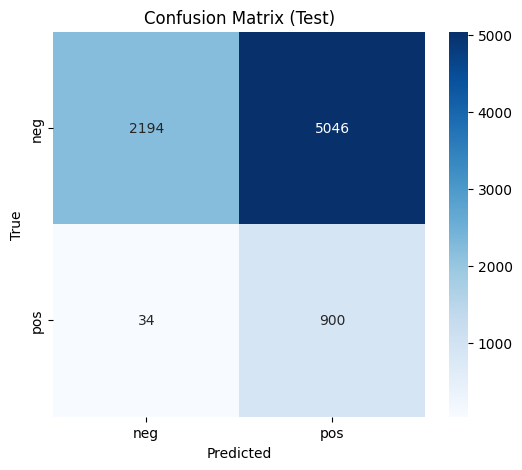

Epoch 1 Summary:
Train Loss: 0.2781 | Train Acc: 67.47% | Train F1: 0.6472
Val Loss: 0.6020 | Val Acc: 24.35% | Val F1: 0.2421
Test Loss: 0.2888 | Test Acc: 37.85% | Test F1: 0.3625
Epoch Time: 991.23s | GPU Memory Usage: 766.54 MB



Checkpoint saved at checkpoints\epoch_1.pth


Validation loss decreased. Best model saved at checkpoints\best_model.pth


Training:   0%|                                                              | 0/470 [00:00<?, ?it/s]

Training:   0%|                           | 0/470 [00:01<?, ?it/s, Loss=0.2047, F1=0.6761, Acc=68.75]

Training:   0%|                   | 1/470 [00:01<10:00,  1.28s/it, Loss=0.2047, F1=0.6761, Acc=68.75]

Training:   0%|                   | 1/470 [00:02<10:00,  1.28s/it, Loss=0.2316, F1=0.6267, Acc=65.62]

Training:   0%|                   | 2/470 [00:02<09:30,  1.22s/it, Loss=0.2316, F1=0.6267, Acc=65.62]

Training:   0%|                   | 2/470 [00:03<09:30,  1.22s/it, Loss=0.2137, F1=0.6329, Acc=64.58]

Training:   1%|                   | 3/470 [00:03<09:21,  1.20s/it, Loss=0.2137, F1=0.6329, Acc=64.58]

Training:   1%|                   | 3/470 [00:04<09:21,  1.20s/it, Loss=0.1969, F1=0.6797, Acc=68.75]

Training:   1%|▏                  | 4/470 [00:04<09:13,  1.19s/it, Loss=0.1969, F1=0.6797, Acc=68.75]

Training:   1%|▏                  | 4/470 [00:05<09:13,  1.19s/it, Loss=0.2488, F1=0.6560, Acc=66.25]

Training:   1%|▏                  | 5/470 [00:05<09:12,  1.19s/it, Loss=0.2488, F1=0.6560, Acc=66.25]

Training:   1%|▏                  | 5/470 [00:07<09:12,  1.19s/it, Loss=0.2253, F1=0.7000, Acc=70.83]

Training:   1%|▏                  | 6/470 [00:07<09:04,  1.17s/it, Loss=0.2253, F1=0.7000, Acc=70.83]

Training:   1%|▏                  | 6/470 [00:08<09:04,  1.17s/it, Loss=0.2003, F1=0.7434, Acc=75.00]

Training:   1%|▎                  | 7/470 [00:08<09:04,  1.18s/it, Loss=0.2003, F1=0.7434, Acc=75.00]

Training:   1%|▎                  | 7/470 [00:09<09:04,  1.18s/it, Loss=0.2136, F1=0.7535, Acc=75.78]

Training:   2%|▎                  | 8/470 [00:09<09:10,  1.19s/it, Loss=0.2136, F1=0.7535, Acc=75.78]

Training:   2%|▎                  | 8/470 [00:10<09:10,  1.19s/it, Loss=0.2034, F1=0.7780, Acc=78.47]

Training:   2%|▎                  | 9/470 [00:10<09:11,  1.20s/it, Loss=0.2034, F1=0.7780, Acc=78.47]

Training:   2%|▎                  | 9/470 [00:11<09:11,  1.20s/it, Loss=0.2219, F1=0.7808, Acc=78.75]

Training:   2%|▍                 | 10/470 [00:11<09:05,  1.18s/it, Loss=0.2219, F1=0.7808, Acc=78.75]

Training:   2%|▍                 | 10/470 [00:13<09:05,  1.18s/it, Loss=0.2290, F1=0.7731, Acc=77.84]

Training:   2%|▍                 | 11/470 [00:13<09:09,  1.20s/it, Loss=0.2290, F1=0.7731, Acc=77.84]

Training:   2%|▍                 | 11/470 [00:14<09:09,  1.20s/it, Loss=0.2266, F1=0.7765, Acc=78.12]

Training:   3%|▍                 | 12/470 [00:14<09:07,  1.19s/it, Loss=0.2266, F1=0.7765, Acc=78.12]

Training:   3%|▍                 | 12/470 [00:15<09:07,  1.19s/it, Loss=0.2294, F1=0.7643, Acc=76.92]

Training:   3%|▍                 | 13/470 [00:15<09:13,  1.21s/it, Loss=0.2294, F1=0.7643, Acc=76.92]

Training:   3%|▍                 | 13/470 [00:16<09:13,  1.21s/it, Loss=0.2250, F1=0.7630, Acc=76.79]

Training:   3%|▌                 | 14/470 [00:16<09:03,  1.19s/it, Loss=0.2250, F1=0.7630, Acc=76.79]

Training:   3%|▌                 | 14/470 [00:17<09:03,  1.19s/it, Loss=0.2223, F1=0.7679, Acc=77.50]

Training:   3%|▌                 | 15/470 [00:17<09:06,  1.20s/it, Loss=0.2223, F1=0.7679, Acc=77.50]

Training:   3%|▌                 | 15/470 [00:19<09:06,  1.20s/it, Loss=0.2239, F1=0.7578, Acc=76.56]

Training:   3%|▌                 | 16/470 [00:19<09:09,  1.21s/it, Loss=0.2239, F1=0.7578, Acc=76.56]

Training:   3%|▌                 | 16/470 [00:20<09:09,  1.21s/it, Loss=0.2250, F1=0.7577, Acc=76.84]

Training:   4%|▋                 | 17/470 [00:20<09:02,  1.20s/it, Loss=0.2250, F1=0.7577, Acc=76.84]

Training:   4%|▋                 | 17/470 [00:21<09:02,  1.20s/it, Loss=0.2255, F1=0.7546, Acc=76.39]

Training:   4%|▋                 | 18/470 [00:21<08:52,  1.18s/it, Loss=0.2255, F1=0.7546, Acc=76.39]

Training:   4%|▋                 | 18/470 [00:22<08:52,  1.18s/it, Loss=0.2325, F1=0.7399, Acc=75.00]

Training:   4%|▋                 | 19/470 [00:22<09:02,  1.20s/it, Loss=0.2325, F1=0.7399, Acc=75.00]

Training:   4%|▋                 | 19/470 [00:23<09:02,  1.20s/it, Loss=0.2396, F1=0.7258, Acc=73.75]

Training:   4%|▊                 | 20/470 [00:23<09:02,  1.21s/it, Loss=0.2396, F1=0.7258, Acc=73.75]

Training:   4%|▊                 | 20/470 [00:25<09:02,  1.21s/it, Loss=0.2366, F1=0.7220, Acc=73.51]

Training:   4%|▊                 | 21/470 [00:25<08:54,  1.19s/it, Loss=0.2366, F1=0.7220, Acc=73.51]

Training:   4%|▊                 | 21/470 [00:26<08:54,  1.19s/it, Loss=0.2370, F1=0.7180, Acc=73.01]

Training:   5%|▊                 | 22/470 [00:26<08:54,  1.19s/it, Loss=0.2370, F1=0.7180, Acc=73.01]

Training:   5%|▊                 | 22/470 [00:27<08:54,  1.19s/it, Loss=0.2300, F1=0.7218, Acc=73.37]

Training:   5%|▉                 | 23/470 [00:27<08:56,  1.20s/it, Loss=0.2300, F1=0.7218, Acc=73.37]

Training:   5%|▉                 | 23/470 [00:28<08:56,  1.20s/it, Loss=0.2298, F1=0.7278, Acc=73.96]

Training:   5%|▉                 | 24/470 [00:28<09:04,  1.22s/it, Loss=0.2298, F1=0.7278, Acc=73.96]

Training:   5%|▉                 | 24/470 [00:29<09:04,  1.22s/it, Loss=0.2305, F1=0.7378, Acc=74.75]

Training:   5%|▉                 | 25/470 [00:29<08:57,  1.21s/it, Loss=0.2305, F1=0.7378, Acc=74.75]

Training:   5%|▉                 | 25/470 [00:31<08:57,  1.21s/it, Loss=0.2264, F1=0.7416, Acc=75.24]

Training:   6%|▉                 | 26/470 [00:31<08:51,  1.20s/it, Loss=0.2264, F1=0.7416, Acc=75.24]

Training:   6%|▉                 | 26/470 [00:32<08:51,  1.20s/it, Loss=0.2204, F1=0.7498, Acc=75.93]

Training:   6%|█                 | 27/470 [00:32<08:40,  1.18s/it, Loss=0.2204, F1=0.7498, Acc=75.93]

Training:   6%|█                 | 27/470 [00:33<08:40,  1.18s/it, Loss=0.2210, F1=0.7510, Acc=75.89]

Training:   6%|█                 | 28/470 [00:33<08:38,  1.17s/it, Loss=0.2210, F1=0.7510, Acc=75.89]

Training:   6%|█                 | 28/470 [00:34<08:38,  1.17s/it, Loss=0.2357, F1=0.7553, Acc=76.29]

Training:   6%|█                 | 29/470 [00:34<08:34,  1.17s/it, Loss=0.2357, F1=0.7553, Acc=76.29]

Training:   6%|█                 | 29/470 [00:35<08:34,  1.17s/it, Loss=0.2389, F1=0.7573, Acc=76.46]

Training:   6%|█▏                | 30/470 [00:35<08:33,  1.17s/it, Loss=0.2389, F1=0.7573, Acc=76.46]

Training:   6%|█▏                | 30/470 [00:36<08:33,  1.17s/it, Loss=0.2411, F1=0.7615, Acc=76.81]

Training:   7%|█▏                | 31/470 [00:36<08:34,  1.17s/it, Loss=0.2411, F1=0.7615, Acc=76.81]

Training:   7%|█▏                | 31/470 [00:38<08:34,  1.17s/it, Loss=0.2460, F1=0.7573, Acc=76.37]

Training:   7%|█▏                | 32/470 [00:38<08:22,  1.15s/it, Loss=0.2460, F1=0.7573, Acc=76.37]

Training:   7%|█▏                | 32/470 [00:39<08:22,  1.15s/it, Loss=0.2438, F1=0.7608, Acc=76.70]

Training:   7%|█▎                | 33/470 [00:39<08:19,  1.14s/it, Loss=0.2438, F1=0.7608, Acc=76.70]

Training:   7%|█▎                | 33/470 [00:40<08:19,  1.14s/it, Loss=0.2444, F1=0.7578, Acc=76.47]

Training:   7%|█▎                | 34/470 [00:40<08:21,  1.15s/it, Loss=0.2444, F1=0.7578, Acc=76.47]

Training:   7%|█▎                | 34/470 [00:41<08:21,  1.15s/it, Loss=0.2397, F1=0.7608, Acc=76.79]

Training:   7%|█▎                | 35/470 [00:41<08:21,  1.15s/it, Loss=0.2397, F1=0.7608, Acc=76.79]

Training:   7%|█▎                | 35/470 [00:42<08:21,  1.15s/it, Loss=0.2380, F1=0.7598, Acc=76.74]

Training:   8%|█▍                | 36/470 [00:42<08:30,  1.18s/it, Loss=0.2380, F1=0.7598, Acc=76.74]

Training:   8%|█▍                | 36/470 [00:43<08:30,  1.18s/it, Loss=0.2372, F1=0.7598, Acc=76.69]

Training:   8%|█▍                | 37/470 [00:43<08:33,  1.19s/it, Loss=0.2372, F1=0.7598, Acc=76.69]

Training:   8%|█▍                | 37/470 [00:45<08:33,  1.19s/it, Loss=0.2380, F1=0.7585, Acc=76.64]

Training:   8%|█▍                | 38/470 [00:45<08:36,  1.20s/it, Loss=0.2380, F1=0.7585, Acc=76.64]

Training:   8%|█▍                | 38/470 [00:46<08:36,  1.20s/it, Loss=0.2345, F1=0.7595, Acc=76.76]

Training:   8%|█▍                | 39/470 [00:46<08:28,  1.18s/it, Loss=0.2345, F1=0.7595, Acc=76.76]

Training:   8%|█▍                | 39/470 [00:47<08:28,  1.18s/it, Loss=0.2375, F1=0.7574, Acc=76.56]

Training:   9%|█▌                | 40/470 [00:47<08:31,  1.19s/it, Loss=0.2375, F1=0.7574, Acc=76.56]

Training:   9%|█▌                | 40/470 [00:48<08:31,  1.19s/it, Loss=0.2384, F1=0.7548, Acc=76.37]

Training:   9%|█▌                | 41/470 [00:48<08:30,  1.19s/it, Loss=0.2384, F1=0.7548, Acc=76.37]

Training:   9%|█▌                | 41/470 [00:49<08:30,  1.19s/it, Loss=0.2376, F1=0.7496, Acc=75.89]

Training:   9%|█▌                | 42/470 [00:49<08:29,  1.19s/it, Loss=0.2376, F1=0.7496, Acc=75.89]

Training:   9%|█▌                | 42/470 [00:51<08:29,  1.19s/it, Loss=0.2384, F1=0.7432, Acc=75.29]

Training:   9%|█▋                | 43/470 [00:51<08:29,  1.19s/it, Loss=0.2384, F1=0.7432, Acc=75.29]

Training:   9%|█▋                | 43/470 [00:52<08:29,  1.19s/it, Loss=0.2395, F1=0.7407, Acc=75.14]

Training:   9%|█▋                | 44/470 [00:52<08:27,  1.19s/it, Loss=0.2395, F1=0.7407, Acc=75.14]

Training:   9%|█▋                | 44/470 [00:53<08:27,  1.19s/it, Loss=0.2399, F1=0.7316, Acc=74.31]

Training:  10%|█▋                | 45/470 [00:53<08:28,  1.20s/it, Loss=0.2399, F1=0.7316, Acc=74.31]

Training:  10%|█▋                | 45/470 [00:54<08:28,  1.20s/it, Loss=0.2365, F1=0.7325, Acc=74.46]

Training:  10%|█▊                | 46/470 [00:54<08:32,  1.21s/it, Loss=0.2365, F1=0.7325, Acc=74.46]

Training:  10%|█▊                | 46/470 [00:55<08:32,  1.21s/it, Loss=0.2374, F1=0.7286, Acc=74.07]

Training:  10%|█▊                | 47/470 [00:55<08:34,  1.22s/it, Loss=0.2374, F1=0.7286, Acc=74.07]

Training:  10%|█▊                | 47/470 [00:57<08:34,  1.22s/it, Loss=0.2408, F1=0.7290, Acc=74.09]

Training:  10%|█▊                | 48/470 [00:57<08:25,  1.20s/it, Loss=0.2408, F1=0.7290, Acc=74.09]

Training:  10%|█▊                | 48/470 [00:58<08:25,  1.20s/it, Loss=0.2448, F1=0.7261, Acc=73.85]

Training:  10%|█▉                | 49/470 [00:58<08:30,  1.21s/it, Loss=0.2448, F1=0.7261, Acc=73.85]

Training:  10%|█▉                | 49/470 [00:59<08:30,  1.21s/it, Loss=0.2447, F1=0.7242, Acc=73.62]

Training:  11%|█▉                | 50/470 [00:59<08:32,  1.22s/it, Loss=0.2447, F1=0.7242, Acc=73.62]

Training:  11%|█▉                | 50/470 [01:00<08:32,  1.22s/it, Loss=0.2440, F1=0.7261, Acc=73.77]

Training:  11%|█▉                | 51/470 [01:00<08:23,  1.20s/it, Loss=0.2440, F1=0.7261, Acc=73.77]

Training:  11%|█▉                | 51/470 [01:01<08:23,  1.20s/it, Loss=0.2430, F1=0.7263, Acc=73.80]

Training:  11%|█▉                | 52/470 [01:01<08:16,  1.19s/it, Loss=0.2430, F1=0.7263, Acc=73.80]

Training:  11%|█▉                | 52/470 [01:03<08:16,  1.19s/it, Loss=0.2443, F1=0.7201, Acc=73.23]

Training:  11%|██                | 53/470 [01:03<08:21,  1.20s/it, Loss=0.2443, F1=0.7201, Acc=73.23]

Training:  11%|██                | 53/470 [01:04<08:21,  1.20s/it, Loss=0.2420, F1=0.7179, Acc=73.03]

Training:  11%|██                | 54/470 [01:04<08:23,  1.21s/it, Loss=0.2420, F1=0.7179, Acc=73.03]

Training:  11%|██                | 54/470 [01:05<08:23,  1.21s/it, Loss=0.2420, F1=0.7130, Acc=72.50]

Training:  12%|██                | 55/470 [01:05<08:19,  1.20s/it, Loss=0.2420, F1=0.7130, Acc=72.50]

Training:  12%|██                | 55/470 [01:06<08:19,  1.20s/it, Loss=0.2412, F1=0.7121, Acc=72.43]

Training:  12%|██▏               | 56/470 [01:06<08:16,  1.20s/it, Loss=0.2412, F1=0.7121, Acc=72.43]

Training:  12%|██▏               | 56/470 [01:07<08:16,  1.20s/it, Loss=0.2423, F1=0.7127, Acc=72.48]

Training:  12%|██▏               | 57/470 [01:07<08:10,  1.19s/it, Loss=0.2423, F1=0.7127, Acc=72.48]

Training:  12%|██▏               | 57/470 [01:09<08:10,  1.19s/it, Loss=0.2412, F1=0.7156, Acc=72.74]

Training:  12%|██▏               | 58/470 [01:09<08:14,  1.20s/it, Loss=0.2412, F1=0.7156, Acc=72.74]

Training:  12%|██▏               | 58/470 [01:10<08:14,  1.20s/it, Loss=0.2416, F1=0.7186, Acc=72.99]

Training:  13%|██▎               | 59/470 [01:10<08:19,  1.22s/it, Loss=0.2416, F1=0.7186, Acc=72.99]

Training:  13%|██▎               | 59/470 [01:11<08:19,  1.22s/it, Loss=0.2402, F1=0.7186, Acc=73.02]

Training:  13%|██▎               | 60/470 [01:11<08:09,  1.19s/it, Loss=0.2402, F1=0.7186, Acc=73.02]

Training:  13%|██▎               | 60/470 [01:12<08:09,  1.19s/it, Loss=0.2412, F1=0.7215, Acc=73.26]

Training:  13%|██▎               | 61/470 [01:12<08:07,  1.19s/it, Loss=0.2412, F1=0.7215, Acc=73.26]

Training:  13%|██▎               | 61/470 [01:13<08:07,  1.19s/it, Loss=0.2423, F1=0.7224, Acc=73.29]

Training:  13%|██▎               | 62/470 [01:13<08:05,  1.19s/it, Loss=0.2423, F1=0.7224, Acc=73.29]

Training:  13%|██▎               | 62/470 [01:15<08:05,  1.19s/it, Loss=0.2394, F1=0.7255, Acc=73.61]

Training:  13%|██▍               | 63/470 [01:15<08:12,  1.21s/it, Loss=0.2394, F1=0.7255, Acc=73.61]

Training:  13%|██▍               | 63/470 [01:16<08:12,  1.21s/it, Loss=0.2383, F1=0.7232, Acc=73.44]

Training:  14%|██▍               | 64/470 [01:16<08:05,  1.20s/it, Loss=0.2383, F1=0.7232, Acc=73.44]

Training:  14%|██▍               | 64/470 [01:17<08:05,  1.20s/it, Loss=0.2385, F1=0.7233, Acc=73.46]

Training:  14%|██▍               | 65/470 [01:17<07:58,  1.18s/it, Loss=0.2385, F1=0.7233, Acc=73.46]

Training:  14%|██▍               | 65/470 [01:18<07:58,  1.18s/it, Loss=0.2371, F1=0.7235, Acc=73.48]

Training:  14%|██▌               | 66/470 [01:18<08:10,  1.21s/it, Loss=0.2371, F1=0.7235, Acc=73.48]

Training:  14%|██▌               | 66/470 [01:19<08:10,  1.21s/it, Loss=0.2361, F1=0.7249, Acc=73.60]

Training:  14%|██▌               | 67/470 [01:19<08:02,  1.20s/it, Loss=0.2361, F1=0.7249, Acc=73.60]

Training:  14%|██▌               | 67/470 [01:21<08:02,  1.20s/it, Loss=0.2384, F1=0.7225, Acc=73.35]

Training:  14%|██▌               | 68/470 [01:21<07:54,  1.18s/it, Loss=0.2384, F1=0.7225, Acc=73.35]

Training:  14%|██▌               | 68/470 [01:22<07:54,  1.18s/it, Loss=0.2379, F1=0.7231, Acc=73.37]

Training:  15%|██▋               | 69/470 [01:22<07:56,  1.19s/it, Loss=0.2379, F1=0.7231, Acc=73.37]

Training:  15%|██▋               | 69/470 [01:23<07:56,  1.19s/it, Loss=0.2379, F1=0.7244, Acc=73.39]

Training:  15%|██▋               | 70/470 [01:23<07:48,  1.17s/it, Loss=0.2379, F1=0.7244, Acc=73.39]

Training:  15%|██▋               | 70/470 [01:24<07:48,  1.17s/it, Loss=0.2365, F1=0.7269, Acc=73.59]

Training:  15%|██▋               | 71/470 [01:24<07:48,  1.17s/it, Loss=0.2365, F1=0.7269, Acc=73.59]

Training:  15%|██▋               | 71/470 [01:25<07:48,  1.17s/it, Loss=0.2356, F1=0.7291, Acc=73.70]

Training:  15%|██▊               | 72/470 [01:25<07:49,  1.18s/it, Loss=0.2356, F1=0.7291, Acc=73.70]

Training:  15%|██▊               | 72/470 [01:26<07:49,  1.18s/it, Loss=0.2345, F1=0.7322, Acc=73.97]

Training:  16%|██▊               | 73/470 [01:26<07:43,  1.17s/it, Loss=0.2345, F1=0.7322, Acc=73.97]

Training:  16%|██▊               | 73/470 [01:28<07:43,  1.17s/it, Loss=0.2348, F1=0.7330, Acc=74.07]

Training:  16%|██▊               | 74/470 [01:28<07:42,  1.17s/it, Loss=0.2348, F1=0.7330, Acc=74.07]

Training:  16%|██▊               | 74/470 [01:29<07:42,  1.17s/it, Loss=0.2352, F1=0.7335, Acc=74.08]

Training:  16%|██▊               | 75/470 [01:29<07:48,  1.19s/it, Loss=0.2352, F1=0.7335, Acc=74.08]

Training:  16%|██▊               | 75/470 [01:30<07:48,  1.19s/it, Loss=0.2368, F1=0.7315, Acc=73.85]

Training:  16%|██▉               | 76/470 [01:30<07:53,  1.20s/it, Loss=0.2368, F1=0.7315, Acc=73.85]

Training:  16%|██▉               | 76/470 [01:31<07:53,  1.20s/it, Loss=0.2355, F1=0.7334, Acc=74.11]

Training:  16%|██▉               | 77/470 [01:31<07:49,  1.19s/it, Loss=0.2355, F1=0.7334, Acc=74.11]

Training:  16%|██▉               | 77/470 [01:32<07:49,  1.19s/it, Loss=0.2354, F1=0.7331, Acc=74.04]

Training:  17%|██▉               | 78/470 [01:32<07:46,  1.19s/it, Loss=0.2354, F1=0.7331, Acc=74.04]

Training:  17%|██▉               | 78/470 [01:34<07:46,  1.19s/it, Loss=0.2357, F1=0.7296, Acc=73.73]

Training:  17%|███               | 79/470 [01:34<07:53,  1.21s/it, Loss=0.2357, F1=0.7296, Acc=73.73]

Training:  17%|███               | 79/470 [01:35<07:53,  1.21s/it, Loss=0.2349, F1=0.7286, Acc=73.67]

Training:  17%|███               | 80/470 [01:35<07:46,  1.20s/it, Loss=0.2349, F1=0.7286, Acc=73.67]

Training:  17%|███               | 80/470 [01:36<07:46,  1.20s/it, Loss=0.2336, F1=0.7297, Acc=73.77]

Training:  17%|███               | 81/470 [01:36<07:44,  1.19s/it, Loss=0.2336, F1=0.7297, Acc=73.77]

Training:  17%|███               | 81/470 [01:37<07:44,  1.19s/it, Loss=0.2327, F1=0.7316, Acc=73.93]

Training:  17%|███▏              | 82/470 [01:37<07:44,  1.20s/it, Loss=0.2327, F1=0.7316, Acc=73.93]

Training:  17%|███▏              | 82/470 [01:38<07:44,  1.20s/it, Loss=0.2354, F1=0.7315, Acc=73.95]

Training:  18%|███▏              | 83/470 [01:38<07:38,  1.18s/it, Loss=0.2354, F1=0.7315, Acc=73.95]

Training:  18%|███▏              | 83/470 [01:40<07:38,  1.18s/it, Loss=0.2355, F1=0.7309, Acc=73.88]

Training:  18%|███▏              | 84/470 [01:40<07:42,  1.20s/it, Loss=0.2355, F1=0.7309, Acc=73.88]

Training:  18%|███▏              | 84/470 [01:41<07:42,  1.20s/it, Loss=0.2360, F1=0.7309, Acc=73.90]

Training:  18%|███▎              | 85/470 [01:41<07:45,  1.21s/it, Loss=0.2360, F1=0.7309, Acc=73.90]

Training:  18%|███▎              | 85/470 [01:42<07:45,  1.21s/it, Loss=0.2375, F1=0.7313, Acc=73.91]

Training:  18%|███▎              | 86/470 [01:42<07:35,  1.19s/it, Loss=0.2375, F1=0.7313, Acc=73.91]

Training:  18%|███▎              | 86/470 [01:43<07:35,  1.19s/it, Loss=0.2371, F1=0.7320, Acc=73.99]

Training:  19%|███▎              | 87/470 [01:43<07:33,  1.18s/it, Loss=0.2371, F1=0.7320, Acc=73.99]

Training:  19%|███▎              | 87/470 [01:44<07:33,  1.18s/it, Loss=0.2357, F1=0.7319, Acc=74.01]

Training:  19%|███▎              | 88/470 [01:44<07:30,  1.18s/it, Loss=0.2357, F1=0.7319, Acc=74.01]

Training:  19%|███▎              | 88/470 [01:45<07:30,  1.18s/it, Loss=0.2353, F1=0.7336, Acc=74.16]

Training:  19%|███▍              | 89/470 [01:45<07:28,  1.18s/it, Loss=0.2353, F1=0.7336, Acc=74.16]

Training:  19%|███▍              | 89/470 [01:47<07:28,  1.18s/it, Loss=0.2358, F1=0.7338, Acc=74.17]

Training:  19%|███▍              | 90/470 [01:47<07:27,  1.18s/it, Loss=0.2358, F1=0.7338, Acc=74.17]

Training:  19%|███▍              | 90/470 [01:48<07:27,  1.18s/it, Loss=0.2349, F1=0.7331, Acc=74.11]

Training:  19%|███▍              | 91/470 [01:48<07:27,  1.18s/it, Loss=0.2349, F1=0.7331, Acc=74.11]

Training:  19%|███▍              | 91/470 [01:49<07:27,  1.18s/it, Loss=0.2338, F1=0.7330, Acc=74.12]

Training:  20%|███▌              | 92/470 [01:49<07:23,  1.17s/it, Loss=0.2338, F1=0.7330, Acc=74.12]

Training:  20%|███▌              | 92/470 [01:50<07:23,  1.17s/it, Loss=0.2329, F1=0.7346, Acc=74.26]

Training:  20%|███▌              | 93/470 [01:50<07:22,  1.17s/it, Loss=0.2329, F1=0.7346, Acc=74.26]

Training:  20%|███▌              | 93/470 [01:51<07:22,  1.17s/it, Loss=0.2319, F1=0.7367, Acc=74.47]

Training:  20%|███▌              | 94/470 [01:51<07:31,  1.20s/it, Loss=0.2319, F1=0.7367, Acc=74.47]

Training:  20%|███▌              | 94/470 [01:53<07:31,  1.20s/it, Loss=0.2320, F1=0.7377, Acc=74.54]

Training:  20%|███▋              | 95/470 [01:53<07:20,  1.17s/it, Loss=0.2320, F1=0.7377, Acc=74.54]

Training:  20%|███▋              | 95/470 [01:54<07:20,  1.17s/it, Loss=0.2315, F1=0.7387, Acc=74.61]

Training:  20%|███▋              | 96/470 [01:54<07:28,  1.20s/it, Loss=0.2315, F1=0.7387, Acc=74.61]

Training:  20%|███▋              | 96/470 [01:55<07:28,  1.20s/it, Loss=0.2328, F1=0.7390, Acc=74.61]

Training:  21%|███▋              | 97/470 [01:55<07:34,  1.22s/it, Loss=0.2328, F1=0.7390, Acc=74.61]

Training:  21%|███▋              | 97/470 [01:56<07:34,  1.22s/it, Loss=0.2326, F1=0.7405, Acc=74.74]

Training:  21%|███▊              | 98/470 [01:56<07:28,  1.20s/it, Loss=0.2326, F1=0.7405, Acc=74.74]

Training:  21%|███▊              | 98/470 [01:57<07:28,  1.20s/it, Loss=0.2317, F1=0.7423, Acc=74.94]

Training:  21%|███▊              | 99/470 [01:57<07:23,  1.20s/it, Loss=0.2317, F1=0.7423, Acc=74.94]

Training:  21%|███▊              | 99/470 [01:59<07:23,  1.20s/it, Loss=0.2311, F1=0.7410, Acc=74.81]

Training:  21%|███▌             | 100/470 [01:59<07:19,  1.19s/it, Loss=0.2311, F1=0.7410, Acc=74.81]

Training:  21%|███▌             | 100/470 [02:00<07:19,  1.19s/it, Loss=0.2313, F1=0.7412, Acc=74.81]

Training:  21%|███▋             | 101/470 [02:00<07:16,  1.18s/it, Loss=0.2313, F1=0.7412, Acc=74.81]

Training:  21%|███▋             | 101/470 [02:01<07:16,  1.18s/it, Loss=0.2331, F1=0.7380, Acc=74.51]

Training:  22%|███▋             | 102/470 [02:01<07:17,  1.19s/it, Loss=0.2331, F1=0.7380, Acc=74.51]

Training:  22%|███▋             | 102/470 [02:02<07:17,  1.19s/it, Loss=0.2340, F1=0.7356, Acc=74.27]

Training:  22%|███▋             | 103/470 [02:02<07:18,  1.20s/it, Loss=0.2340, F1=0.7356, Acc=74.27]

Training:  22%|███▋             | 103/470 [02:03<07:18,  1.20s/it, Loss=0.2354, F1=0.7351, Acc=74.22]

Training:  22%|███▊             | 104/470 [02:03<07:22,  1.21s/it, Loss=0.2354, F1=0.7351, Acc=74.22]

Training:  22%|███▊             | 104/470 [02:05<07:22,  1.21s/it, Loss=0.2359, F1=0.7352, Acc=74.23]

Training:  22%|███▊             | 105/470 [02:05<07:12,  1.18s/it, Loss=0.2359, F1=0.7352, Acc=74.23]

Training:  22%|███▊             | 105/470 [02:06<07:12,  1.18s/it, Loss=0.2366, F1=0.7343, Acc=74.17]

Training:  23%|███▊             | 106/470 [02:06<07:15,  1.20s/it, Loss=0.2366, F1=0.7343, Acc=74.17]

Training:  23%|███▊             | 106/470 [02:07<07:15,  1.20s/it, Loss=0.2378, F1=0.7326, Acc=74.01]

Training:  23%|███▊             | 107/470 [02:07<07:18,  1.21s/it, Loss=0.2378, F1=0.7326, Acc=74.01]

Training:  23%|███▊             | 107/470 [02:08<07:18,  1.21s/it, Loss=0.2374, F1=0.7312, Acc=73.90]

Training:  23%|███▉             | 108/470 [02:08<07:22,  1.22s/it, Loss=0.2374, F1=0.7312, Acc=73.90]

Training:  23%|███▉             | 108/470 [02:09<07:22,  1.22s/it, Loss=0.2369, F1=0.7316, Acc=73.97]

Training:  23%|███▉             | 109/470 [02:09<07:13,  1.20s/it, Loss=0.2369, F1=0.7316, Acc=73.97]

Training:  23%|███▉             | 109/470 [02:11<07:13,  1.20s/it, Loss=0.2367, F1=0.7335, Acc=74.15]

Training:  23%|███▉             | 110/470 [02:11<07:09,  1.19s/it, Loss=0.2367, F1=0.7335, Acc=74.15]

Training:  23%|███▉             | 110/470 [02:12<07:09,  1.19s/it, Loss=0.2361, F1=0.7346, Acc=74.27]

Training:  24%|████             | 111/470 [02:12<07:01,  1.17s/it, Loss=0.2361, F1=0.7346, Acc=74.27]

Training:  24%|████             | 111/470 [02:13<07:01,  1.17s/it, Loss=0.2366, F1=0.7343, Acc=74.22]

Training:  24%|████             | 112/470 [02:13<06:58,  1.17s/it, Loss=0.2366, F1=0.7343, Acc=74.22]

Training:  24%|████             | 112/470 [02:14<06:58,  1.17s/it, Loss=0.2373, F1=0.7333, Acc=74.12]

Training:  24%|████             | 113/470 [02:14<06:55,  1.16s/it, Loss=0.2373, F1=0.7333, Acc=74.12]

Training:  24%|████             | 113/470 [02:15<06:55,  1.16s/it, Loss=0.2374, F1=0.7327, Acc=74.07]

Training:  24%|████             | 114/470 [02:15<06:55,  1.17s/it, Loss=0.2374, F1=0.7327, Acc=74.07]

Training:  24%|████             | 114/470 [02:16<06:55,  1.17s/it, Loss=0.2360, F1=0.7336, Acc=74.18]

Training:  24%|████▏            | 115/470 [02:16<06:52,  1.16s/it, Loss=0.2360, F1=0.7336, Acc=74.18]

Training:  24%|████▏            | 115/470 [02:18<06:52,  1.16s/it, Loss=0.2356, F1=0.7325, Acc=74.08]

Training:  25%|████▏            | 116/470 [02:18<07:00,  1.19s/it, Loss=0.2356, F1=0.7325, Acc=74.08]

Training:  25%|████▏            | 116/470 [02:19<07:00,  1.19s/it, Loss=0.2351, F1=0.7321, Acc=74.04]

Training:  25%|████▏            | 117/470 [02:19<07:04,  1.20s/it, Loss=0.2351, F1=0.7321, Acc=74.04]

Training:  25%|████▏            | 117/470 [02:20<07:04,  1.20s/it, Loss=0.2338, F1=0.7322, Acc=74.05]

Training:  25%|████▎            | 118/470 [02:20<06:59,  1.19s/it, Loss=0.2338, F1=0.7322, Acc=74.05]

Training:  25%|████▎            | 118/470 [02:21<06:59,  1.19s/it, Loss=0.2343, F1=0.7307, Acc=73.90]

Training:  25%|████▎            | 119/470 [02:21<06:58,  1.19s/it, Loss=0.2343, F1=0.7307, Acc=73.90]

Training:  25%|████▎            | 119/470 [02:22<06:58,  1.19s/it, Loss=0.2353, F1=0.7309, Acc=73.91]

Training:  26%|████▎            | 120/470 [02:22<06:53,  1.18s/it, Loss=0.2353, F1=0.7309, Acc=73.91]

Training:  26%|████▎            | 120/470 [02:24<06:53,  1.18s/it, Loss=0.2343, F1=0.7319, Acc=73.97]

Training:  26%|████▍            | 121/470 [02:24<06:57,  1.20s/it, Loss=0.2343, F1=0.7319, Acc=73.97]

Training:  26%|████▍            | 121/470 [02:25<06:57,  1.20s/it, Loss=0.2353, F1=0.7330, Acc=74.08]

Training:  26%|████▍            | 122/470 [02:25<07:00,  1.21s/it, Loss=0.2353, F1=0.7330, Acc=74.08]

Training:  26%|████▍            | 122/470 [02:26<07:00,  1.21s/it, Loss=0.2354, F1=0.7348, Acc=74.24]

Training:  26%|████▍            | 123/470 [02:26<06:56,  1.20s/it, Loss=0.2354, F1=0.7348, Acc=74.24]

Training:  26%|████▍            | 123/470 [02:27<06:56,  1.20s/it, Loss=0.2354, F1=0.7356, Acc=74.29]

Training:  26%|████▍            | 124/470 [02:27<06:53,  1.19s/it, Loss=0.2354, F1=0.7356, Acc=74.29]

Training:  26%|████▍            | 124/470 [02:28<06:53,  1.19s/it, Loss=0.2343, F1=0.7376, Acc=74.45]

Training:  27%|████▌            | 125/470 [02:28<06:52,  1.20s/it, Loss=0.2343, F1=0.7376, Acc=74.45]

Training:  27%|████▌            | 125/470 [02:30<06:52,  1.20s/it, Loss=0.2342, F1=0.7391, Acc=74.60]

Training:  27%|████▌            | 126/470 [02:30<06:51,  1.20s/it, Loss=0.2342, F1=0.7391, Acc=74.60]

Training:  27%|████▌            | 126/470 [02:31<06:51,  1.20s/it, Loss=0.2359, F1=0.7396, Acc=74.66]

Training:  27%|████▌            | 127/470 [02:31<06:51,  1.20s/it, Loss=0.2359, F1=0.7396, Acc=74.66]

Training:  27%|████▌            | 127/470 [02:32<06:51,  1.20s/it, Loss=0.2353, F1=0.7394, Acc=74.66]

Training:  27%|████▋            | 128/470 [02:32<06:53,  1.21s/it, Loss=0.2353, F1=0.7394, Acc=74.66]

Training:  27%|████▋            | 128/470 [02:33<06:53,  1.21s/it, Loss=0.2349, F1=0.7407, Acc=74.76]

Training:  27%|████▋            | 129/470 [02:33<06:47,  1.19s/it, Loss=0.2349, F1=0.7407, Acc=74.76]

Training:  27%|████▋            | 129/470 [02:34<06:47,  1.19s/it, Loss=0.2341, F1=0.7420, Acc=74.90]

Training:  28%|████▋            | 130/470 [02:34<06:42,  1.18s/it, Loss=0.2341, F1=0.7420, Acc=74.90]

Training:  28%|████▋            | 130/470 [02:36<06:42,  1.18s/it, Loss=0.2343, F1=0.7416, Acc=74.86]

Training:  28%|████▋            | 131/470 [02:36<06:45,  1.20s/it, Loss=0.2343, F1=0.7416, Acc=74.86]

Training:  28%|████▋            | 131/470 [02:37<06:45,  1.20s/it, Loss=0.2344, F1=0.7399, Acc=74.72]

Training:  28%|████▊            | 132/470 [02:37<06:47,  1.21s/it, Loss=0.2344, F1=0.7399, Acc=74.72]

Training:  28%|████▊            | 132/470 [02:38<06:47,  1.21s/it, Loss=0.2345, F1=0.7382, Acc=74.58]

Training:  28%|████▊            | 133/470 [02:38<06:49,  1.22s/it, Loss=0.2345, F1=0.7382, Acc=74.58]

Training:  28%|████▊            | 133/470 [02:39<06:49,  1.22s/it, Loss=0.2343, F1=0.7380, Acc=74.58]

Training:  29%|████▊            | 134/470 [02:39<06:39,  1.19s/it, Loss=0.2343, F1=0.7380, Acc=74.58]

Training:  29%|████▊            | 134/470 [02:40<06:39,  1.19s/it, Loss=0.2352, F1=0.7357, Acc=74.35]

Training:  29%|████▉            | 135/470 [02:40<06:45,  1.21s/it, Loss=0.2352, F1=0.7357, Acc=74.35]

Training:  29%|████▉            | 135/470 [02:42<06:45,  1.21s/it, Loss=0.2351, F1=0.7346, Acc=74.26]

Training:  29%|████▉            | 136/470 [02:42<06:40,  1.20s/it, Loss=0.2351, F1=0.7346, Acc=74.26]

Training:  29%|████▉            | 136/470 [02:43<06:40,  1.20s/it, Loss=0.2345, F1=0.7358, Acc=74.36]

Training:  29%|████▉            | 137/470 [02:43<06:37,  1.19s/it, Loss=0.2345, F1=0.7358, Acc=74.36]

Training:  29%|████▉            | 137/470 [02:44<06:37,  1.19s/it, Loss=0.2341, F1=0.7358, Acc=74.37]

Training:  29%|████▉            | 138/470 [02:44<06:35,  1.19s/it, Loss=0.2341, F1=0.7358, Acc=74.37]

Training:  29%|████▉            | 138/470 [02:45<06:35,  1.19s/it, Loss=0.2336, F1=0.7369, Acc=74.46]

Training:  30%|█████            | 139/470 [02:45<06:36,  1.20s/it, Loss=0.2336, F1=0.7369, Acc=74.46]

Training:  30%|█████            | 139/470 [02:46<06:36,  1.20s/it, Loss=0.2340, F1=0.7383, Acc=74.60]

Training:  30%|█████            | 140/470 [02:46<06:42,  1.22s/it, Loss=0.2340, F1=0.7383, Acc=74.60]

Training:  30%|█████            | 140/470 [02:48<06:42,  1.22s/it, Loss=0.2366, F1=0.7390, Acc=74.65]

Training:  30%|█████            | 141/470 [02:48<06:38,  1.21s/it, Loss=0.2366, F1=0.7390, Acc=74.65]

Training:  30%|█████            | 141/470 [02:49<06:38,  1.21s/it, Loss=0.2381, F1=0.7388, Acc=74.60]

Training:  30%|█████▏           | 142/470 [02:49<06:32,  1.20s/it, Loss=0.2381, F1=0.7388, Acc=74.60]

Training:  30%|█████▏           | 142/470 [02:50<06:32,  1.20s/it, Loss=0.2374, F1=0.7392, Acc=74.61]

Training:  30%|█████▏           | 143/470 [02:50<06:27,  1.18s/it, Loss=0.2374, F1=0.7392, Acc=74.61]

Training:  30%|█████▏           | 143/470 [02:51<06:27,  1.18s/it, Loss=0.2376, F1=0.7403, Acc=74.70]

Training:  31%|█████▏           | 144/470 [02:51<06:35,  1.21s/it, Loss=0.2376, F1=0.7403, Acc=74.70]

Training:  31%|█████▏           | 144/470 [02:52<06:35,  1.21s/it, Loss=0.2392, F1=0.7410, Acc=74.74]

Training:  31%|█████▏           | 145/470 [02:52<06:32,  1.21s/it, Loss=0.2392, F1=0.7410, Acc=74.74]

Training:  31%|█████▏           | 145/470 [02:54<06:32,  1.21s/it, Loss=0.2397, F1=0.7416, Acc=74.79]

Training:  31%|█████▎           | 146/470 [02:54<06:26,  1.19s/it, Loss=0.2397, F1=0.7416, Acc=74.79]

Training:  31%|█████▎           | 146/470 [02:55<06:26,  1.19s/it, Loss=0.2398, F1=0.7421, Acc=74.83]

Training:  31%|█████▎           | 147/470 [02:55<06:21,  1.18s/it, Loss=0.2398, F1=0.7421, Acc=74.83]

Training:  31%|█████▎           | 147/470 [02:56<06:21,  1.18s/it, Loss=0.2401, F1=0.7425, Acc=74.87]

Training:  31%|█████▎           | 148/470 [02:56<06:29,  1.21s/it, Loss=0.2401, F1=0.7425, Acc=74.87]

Training:  31%|█████▎           | 148/470 [02:57<06:29,  1.21s/it, Loss=0.2414, F1=0.7407, Acc=74.71]

Training:  32%|█████▍           | 149/470 [02:57<06:23,  1.20s/it, Loss=0.2414, F1=0.7407, Acc=74.71]

Training:  32%|█████▍           | 149/470 [02:58<06:23,  1.20s/it, Loss=0.2417, F1=0.7398, Acc=74.62]

Training:  32%|█████▍           | 150/470 [02:58<06:22,  1.20s/it, Loss=0.2417, F1=0.7398, Acc=74.62]

Training:  32%|█████▍           | 150/470 [03:00<06:22,  1.20s/it, Loss=0.2422, F1=0.7388, Acc=74.54]

Training:  32%|█████▍           | 151/470 [03:00<06:17,  1.18s/it, Loss=0.2422, F1=0.7388, Acc=74.54]

Training:  32%|█████▍           | 151/470 [03:01<06:17,  1.18s/it, Loss=0.2435, F1=0.7358, Acc=74.26]

Training:  32%|█████▍           | 152/470 [03:01<06:26,  1.22s/it, Loss=0.2435, F1=0.7358, Acc=74.26]

Training:  32%|█████▍           | 152/470 [03:02<06:26,  1.22s/it, Loss=0.2446, F1=0.7333, Acc=74.02]

Training:  33%|█████▌           | 153/470 [03:02<06:20,  1.20s/it, Loss=0.2446, F1=0.7333, Acc=74.02]

Training:  33%|█████▌           | 153/470 [03:03<06:20,  1.20s/it, Loss=0.2445, F1=0.7312, Acc=73.82]

Training:  33%|█████▌           | 154/470 [03:03<06:15,  1.19s/it, Loss=0.2445, F1=0.7312, Acc=73.82]

Training:  33%|█████▌           | 154/470 [03:04<06:15,  1.19s/it, Loss=0.2443, F1=0.7299, Acc=73.71]

Training:  33%|█████▌           | 155/470 [03:04<06:21,  1.21s/it, Loss=0.2443, F1=0.7299, Acc=73.71]

Training:  33%|█████▌           | 155/470 [03:06<06:21,  1.21s/it, Loss=0.2438, F1=0.7289, Acc=73.64]

Training:  33%|█████▋           | 156/470 [03:06<06:23,  1.22s/it, Loss=0.2438, F1=0.7289, Acc=73.64]

Training:  33%|█████▋           | 156/470 [03:07<06:23,  1.22s/it, Loss=0.2439, F1=0.7288, Acc=73.65]

Training:  33%|█████▋           | 157/470 [03:07<06:20,  1.21s/it, Loss=0.2439, F1=0.7288, Acc=73.65]

Training:  33%|█████▋           | 157/470 [03:08<06:20,  1.21s/it, Loss=0.2440, F1=0.7292, Acc=73.69]

Training:  34%|█████▋           | 158/470 [03:08<06:17,  1.21s/it, Loss=0.2440, F1=0.7292, Acc=73.69]

Training:  34%|█████▋           | 158/470 [03:09<06:17,  1.21s/it, Loss=0.2442, F1=0.7280, Acc=73.58]

Training:  34%|█████▊           | 159/470 [03:09<06:14,  1.20s/it, Loss=0.2442, F1=0.7280, Acc=73.58]

Training:  34%|█████▊           | 159/470 [03:10<06:14,  1.20s/it, Loss=0.2453, F1=0.7272, Acc=73.52]

Training:  34%|█████▊           | 160/470 [03:10<06:10,  1.20s/it, Loss=0.2453, F1=0.7272, Acc=73.52]

Training:  34%|█████▊           | 160/470 [03:12<06:10,  1.20s/it, Loss=0.2454, F1=0.7280, Acc=73.60]

Training:  34%|█████▊           | 161/470 [03:12<06:07,  1.19s/it, Loss=0.2454, F1=0.7280, Acc=73.60]

Training:  34%|█████▊           | 161/470 [03:13<06:07,  1.19s/it, Loss=0.2450, F1=0.7279, Acc=73.61]

Training:  34%|█████▊           | 162/470 [03:13<05:59,  1.17s/it, Loss=0.2450, F1=0.7279, Acc=73.61]

Training:  34%|█████▊           | 162/470 [03:14<05:59,  1.17s/it, Loss=0.2457, F1=0.7259, Acc=73.43]

Training:  35%|█████▉           | 163/470 [03:14<05:58,  1.17s/it, Loss=0.2457, F1=0.7259, Acc=73.43]

Training:  35%|█████▉           | 163/470 [03:15<05:58,  1.17s/it, Loss=0.2458, F1=0.7245, Acc=73.32]

Training:  35%|█████▉           | 164/470 [03:15<05:56,  1.16s/it, Loss=0.2458, F1=0.7245, Acc=73.32]

Training:  35%|█████▉           | 164/470 [03:16<05:56,  1.16s/it, Loss=0.2452, F1=0.7244, Acc=73.33]

Training:  35%|█████▉           | 165/470 [03:16<05:55,  1.17s/it, Loss=0.2452, F1=0.7244, Acc=73.33]

Training:  35%|█████▉           | 165/470 [03:17<05:55,  1.17s/it, Loss=0.2447, F1=0.7244, Acc=73.34]

Training:  35%|██████           | 166/470 [03:17<05:53,  1.16s/it, Loss=0.2447, F1=0.7244, Acc=73.34]

Training:  35%|██████           | 166/470 [03:19<05:53,  1.16s/it, Loss=0.2443, F1=0.7245, Acc=73.39]

Training:  36%|██████           | 167/470 [03:19<06:00,  1.19s/it, Loss=0.2443, F1=0.7245, Acc=73.39]

Training:  36%|██████           | 167/470 [03:20<06:00,  1.19s/it, Loss=0.2442, F1=0.7233, Acc=73.29]

Training:  36%|██████           | 168/470 [03:20<05:55,  1.18s/it, Loss=0.2442, F1=0.7233, Acc=73.29]

Training:  36%|██████           | 168/470 [03:21<05:55,  1.18s/it, Loss=0.2437, F1=0.7227, Acc=73.22]

Training:  36%|██████           | 169/470 [03:21<05:57,  1.19s/it, Loss=0.2437, F1=0.7227, Acc=73.22]

Training:  36%|██████           | 169/470 [03:22<05:57,  1.19s/it, Loss=0.2435, F1=0.7225, Acc=73.24]

Training:  36%|██████▏          | 170/470 [03:22<06:00,  1.20s/it, Loss=0.2435, F1=0.7225, Acc=73.24]

Training:  36%|██████▏          | 170/470 [03:23<06:00,  1.20s/it, Loss=0.2437, F1=0.7221, Acc=73.21]

Training:  36%|██████▏          | 171/470 [03:23<05:54,  1.19s/it, Loss=0.2437, F1=0.7221, Acc=73.21]

Training:  36%|██████▏          | 171/470 [03:25<05:54,  1.19s/it, Loss=0.2431, F1=0.7219, Acc=73.18]

Training:  37%|██████▏          | 172/470 [03:25<05:58,  1.20s/it, Loss=0.2431, F1=0.7219, Acc=73.18]

Training:  37%|██████▏          | 172/470 [03:26<05:58,  1.20s/it, Loss=0.2430, F1=0.7222, Acc=73.23]

Training:  37%|██████▎          | 173/470 [03:26<05:55,  1.20s/it, Loss=0.2430, F1=0.7222, Acc=73.23]

Training:  37%|██████▎          | 173/470 [03:27<05:55,  1.20s/it, Loss=0.2437, F1=0.7230, Acc=73.31]

Training:  37%|██████▎          | 174/470 [03:27<05:53,  1.20s/it, Loss=0.2437, F1=0.7230, Acc=73.31]

Training:  37%|██████▎          | 174/470 [03:28<05:53,  1.20s/it, Loss=0.2433, F1=0.7229, Acc=73.32]

Training:  37%|██████▎          | 175/470 [03:28<05:53,  1.20s/it, Loss=0.2433, F1=0.7229, Acc=73.32]

Training:  37%|██████▎          | 175/470 [03:29<05:53,  1.20s/it, Loss=0.2433, F1=0.7219, Acc=73.22]

Training:  37%|██████▎          | 176/470 [03:29<05:50,  1.19s/it, Loss=0.2433, F1=0.7219, Acc=73.22]

Training:  37%|██████▎          | 176/470 [03:31<05:50,  1.19s/it, Loss=0.2429, F1=0.7210, Acc=73.13]

Training:  38%|██████▍          | 177/470 [03:31<05:54,  1.21s/it, Loss=0.2429, F1=0.7210, Acc=73.13]

Training:  38%|██████▍          | 177/470 [03:32<05:54,  1.21s/it, Loss=0.2426, F1=0.7212, Acc=73.14]

Training:  38%|██████▍          | 178/470 [03:32<05:47,  1.19s/it, Loss=0.2426, F1=0.7212, Acc=73.14]

Training:  38%|██████▍          | 178/470 [03:33<05:47,  1.19s/it, Loss=0.2422, F1=0.7218, Acc=73.22]

Training:  38%|██████▍          | 179/470 [03:33<05:54,  1.22s/it, Loss=0.2422, F1=0.7218, Acc=73.22]

Training:  38%|██████▍          | 179/470 [03:34<05:54,  1.22s/it, Loss=0.2419, F1=0.7225, Acc=73.30]

Training:  38%|██████▌          | 180/470 [03:34<05:49,  1.20s/it, Loss=0.2419, F1=0.7225, Acc=73.30]

Training:  38%|██████▌          | 180/470 [03:35<05:49,  1.20s/it, Loss=0.2421, F1=0.7223, Acc=73.27]

Training:  39%|██████▌          | 181/470 [03:35<05:43,  1.19s/it, Loss=0.2421, F1=0.7223, Acc=73.27]

Training:  39%|██████▌          | 181/470 [03:37<05:43,  1.19s/it, Loss=0.2424, F1=0.7220, Acc=73.25]

Training:  39%|██████▌          | 182/470 [03:37<05:40,  1.18s/it, Loss=0.2424, F1=0.7220, Acc=73.25]

Training:  39%|██████▌          | 182/470 [03:38<05:40,  1.18s/it, Loss=0.2415, F1=0.7222, Acc=73.29]

Training:  39%|██████▌          | 183/470 [03:38<05:48,  1.21s/it, Loss=0.2415, F1=0.7222, Acc=73.29]

Training:  39%|██████▌          | 183/470 [03:39<05:48,  1.21s/it, Loss=0.2415, F1=0.7214, Acc=73.20]

Training:  39%|██████▋          | 184/470 [03:39<05:44,  1.20s/it, Loss=0.2415, F1=0.7214, Acc=73.20]

Training:  39%|██████▋          | 184/470 [03:40<05:44,  1.20s/it, Loss=0.2409, F1=0.7218, Acc=73.24]

Training:  39%|██████▋          | 185/470 [03:40<05:41,  1.20s/it, Loss=0.2409, F1=0.7218, Acc=73.24]

Training:  39%|██████▋          | 185/470 [03:41<05:41,  1.20s/it, Loss=0.2413, F1=0.7219, Acc=73.25]

Training:  40%|██████▋          | 186/470 [03:41<05:40,  1.20s/it, Loss=0.2413, F1=0.7219, Acc=73.25]

Training:  40%|██████▋          | 186/470 [03:43<05:40,  1.20s/it, Loss=0.2409, F1=0.7222, Acc=73.30]

Training:  40%|██████▊          | 187/470 [03:43<05:36,  1.19s/it, Loss=0.2409, F1=0.7222, Acc=73.30]

Training:  40%|██████▊          | 187/470 [03:44<05:36,  1.19s/it, Loss=0.2408, F1=0.7236, Acc=73.40]

Training:  40%|██████▊          | 188/470 [03:44<05:38,  1.20s/it, Loss=0.2408, F1=0.7236, Acc=73.40]

Training:  40%|██████▊          | 188/470 [03:45<05:38,  1.20s/it, Loss=0.2402, F1=0.7251, Acc=73.54]

Training:  40%|██████▊          | 189/470 [03:45<05:40,  1.21s/it, Loss=0.2402, F1=0.7251, Acc=73.54]

Training:  40%|██████▊          | 189/470 [03:46<05:40,  1.21s/it, Loss=0.2393, F1=0.7262, Acc=73.65]

Training:  40%|██████▊          | 190/470 [03:46<05:38,  1.21s/it, Loss=0.2393, F1=0.7262, Acc=73.65]

Training:  40%|██████▊          | 190/470 [03:47<05:38,  1.21s/it, Loss=0.2396, F1=0.7265, Acc=73.66]

Training:  41%|██████▉          | 191/470 [03:47<05:33,  1.20s/it, Loss=0.2396, F1=0.7265, Acc=73.66]

Training:  41%|██████▉          | 191/470 [03:49<05:33,  1.20s/it, Loss=0.2397, F1=0.7265, Acc=73.67]

Training:  41%|██████▉          | 192/470 [03:49<05:27,  1.18s/it, Loss=0.2397, F1=0.7265, Acc=73.67]

Training:  41%|██████▉          | 192/470 [03:50<05:27,  1.18s/it, Loss=0.2390, F1=0.7278, Acc=73.80]

Training:  41%|██████▉          | 193/470 [03:50<05:28,  1.19s/it, Loss=0.2390, F1=0.7278, Acc=73.80]

Training:  41%|██████▉          | 193/470 [03:51<05:28,  1.19s/it, Loss=0.2387, F1=0.7291, Acc=73.90]

Training:  41%|███████          | 194/470 [03:51<05:25,  1.18s/it, Loss=0.2387, F1=0.7291, Acc=73.90]

Training:  41%|███████          | 194/470 [03:52<05:25,  1.18s/it, Loss=0.2390, F1=0.7288, Acc=73.88]

Training:  41%|███████          | 195/470 [03:52<05:25,  1.18s/it, Loss=0.2390, F1=0.7288, Acc=73.88]

Training:  41%|███████          | 195/470 [03:53<05:25,  1.18s/it, Loss=0.2384, F1=0.7287, Acc=73.88]

Training:  42%|███████          | 196/470 [03:53<05:23,  1.18s/it, Loss=0.2384, F1=0.7287, Acc=73.88]

Training:  42%|███████          | 196/470 [03:54<05:23,  1.18s/it, Loss=0.2384, F1=0.7287, Acc=73.89]

Training:  42%|███████▏         | 197/470 [03:54<05:18,  1.17s/it, Loss=0.2384, F1=0.7287, Acc=73.89]

Training:  42%|███████▏         | 197/470 [03:56<05:18,  1.17s/it, Loss=0.2385, F1=0.7276, Acc=73.77]

Training:  42%|███████▏         | 198/470 [03:56<05:20,  1.18s/it, Loss=0.2385, F1=0.7276, Acc=73.77]

Training:  42%|███████▏         | 198/470 [03:57<05:20,  1.18s/it, Loss=0.2382, F1=0.7275, Acc=73.78]

Training:  42%|███████▏         | 199/470 [03:57<05:19,  1.18s/it, Loss=0.2382, F1=0.7275, Acc=73.78]

Training:  42%|███████▏         | 199/470 [03:58<05:19,  1.18s/it, Loss=0.2379, F1=0.7276, Acc=73.78]

Training:  43%|███████▏         | 200/470 [03:58<05:21,  1.19s/it, Loss=0.2379, F1=0.7276, Acc=73.78]

Training:  43%|███████▏         | 200/470 [03:59<05:21,  1.19s/it, Loss=0.2379, F1=0.7278, Acc=73.79]

Training:  43%|███████▎         | 201/470 [03:59<05:21,  1.20s/it, Loss=0.2379, F1=0.7278, Acc=73.79]

Training:  43%|███████▎         | 201/470 [04:00<05:21,  1.20s/it, Loss=0.2387, F1=0.7272, Acc=73.73]

Training:  43%|███████▎         | 202/470 [04:00<05:20,  1.20s/it, Loss=0.2387, F1=0.7272, Acc=73.73]

Training:  43%|███████▎         | 202/470 [04:02<05:20,  1.20s/it, Loss=0.2385, F1=0.7267, Acc=73.71]

Training:  43%|███████▎         | 203/470 [04:02<05:17,  1.19s/it, Loss=0.2385, F1=0.7267, Acc=73.71]

Training:  43%|███████▎         | 203/470 [04:03<05:17,  1.19s/it, Loss=0.2396, F1=0.7253, Acc=73.56]

Training:  43%|███████▍         | 204/470 [04:03<05:13,  1.18s/it, Loss=0.2396, F1=0.7253, Acc=73.56]

Training:  43%|███████▍         | 204/470 [04:04<05:13,  1.18s/it, Loss=0.2393, F1=0.7261, Acc=73.63]

Training:  44%|███████▍         | 205/470 [04:04<05:19,  1.21s/it, Loss=0.2393, F1=0.7261, Acc=73.63]

Training:  44%|███████▍         | 205/470 [04:05<05:19,  1.21s/it, Loss=0.2387, F1=0.7267, Acc=73.70]

Training:  44%|███████▍         | 206/470 [04:05<05:18,  1.21s/it, Loss=0.2387, F1=0.7267, Acc=73.70]

Training:  44%|███████▍         | 206/470 [04:06<05:18,  1.21s/it, Loss=0.2384, F1=0.7271, Acc=73.73]

Training:  44%|███████▍         | 207/470 [04:06<05:11,  1.19s/it, Loss=0.2384, F1=0.7271, Acc=73.73]

Training:  44%|███████▍         | 207/470 [04:08<05:11,  1.19s/it, Loss=0.2383, F1=0.7274, Acc=73.77]

Training:  44%|███████▌         | 208/470 [04:08<05:19,  1.22s/it, Loss=0.2383, F1=0.7274, Acc=73.77]

Training:  44%|███████▌         | 208/470 [04:09<05:19,  1.22s/it, Loss=0.2378, F1=0.7273, Acc=73.77]

Training:  44%|███████▌         | 209/470 [04:09<05:16,  1.21s/it, Loss=0.2378, F1=0.7273, Acc=73.77]

Training:  44%|███████▌         | 209/470 [04:10<05:16,  1.21s/it, Loss=0.2389, F1=0.7257, Acc=73.63]

Training:  45%|███████▌         | 210/470 [04:10<05:12,  1.20s/it, Loss=0.2389, F1=0.7257, Acc=73.63]

Training:  45%|███████▌         | 210/470 [04:11<05:12,  1.20s/it, Loss=0.2396, F1=0.7245, Acc=73.52]

Training:  45%|███████▋         | 211/470 [04:11<05:09,  1.19s/it, Loss=0.2396, F1=0.7245, Acc=73.52]

Training:  45%|███████▋         | 211/470 [04:12<05:09,  1.19s/it, Loss=0.2389, F1=0.7245, Acc=73.53]

Training:  45%|███████▋         | 212/470 [04:12<05:06,  1.19s/it, Loss=0.2389, F1=0.7245, Acc=73.53]

Training:  45%|███████▋         | 212/470 [04:14<05:06,  1.19s/it, Loss=0.2394, F1=0.7245, Acc=73.53]

Training:  45%|███████▋         | 213/470 [04:14<05:03,  1.18s/it, Loss=0.2394, F1=0.7245, Acc=73.53]

Training:  45%|███████▋         | 213/470 [04:15<05:03,  1.18s/it, Loss=0.2390, F1=0.7249, Acc=73.57]

Training:  46%|███████▋         | 214/470 [04:15<05:06,  1.20s/it, Loss=0.2390, F1=0.7249, Acc=73.57]

Training:  46%|███████▋         | 214/470 [04:16<05:06,  1.20s/it, Loss=0.2387, F1=0.7257, Acc=73.63]

Training:  46%|███████▊         | 215/470 [04:16<05:09,  1.22s/it, Loss=0.2387, F1=0.7257, Acc=73.63]

Training:  46%|███████▊         | 215/470 [04:17<05:09,  1.22s/it, Loss=0.2385, F1=0.7261, Acc=73.67]

Training:  46%|███████▊         | 216/470 [04:17<05:08,  1.21s/it, Loss=0.2385, F1=0.7261, Acc=73.67]

Training:  46%|███████▊         | 216/470 [04:18<05:08,  1.21s/it, Loss=0.2391, F1=0.7255, Acc=73.62]

Training:  46%|███████▊         | 217/470 [04:18<05:03,  1.20s/it, Loss=0.2391, F1=0.7255, Acc=73.62]

Training:  46%|███████▊         | 217/470 [04:20<05:03,  1.20s/it, Loss=0.2388, F1=0.7259, Acc=73.68]

Training:  46%|███████▉         | 218/470 [04:20<04:58,  1.19s/it, Loss=0.2388, F1=0.7259, Acc=73.68]

Training:  46%|███████▉         | 218/470 [04:21<04:58,  1.19s/it, Loss=0.2396, F1=0.7254, Acc=73.63]

Training:  47%|███████▉         | 219/470 [04:21<04:58,  1.19s/it, Loss=0.2396, F1=0.7254, Acc=73.63]

Training:  47%|███████▉         | 219/470 [04:22<04:58,  1.19s/it, Loss=0.2395, F1=0.7246, Acc=73.55]

Training:  47%|███████▉         | 220/470 [04:22<04:59,  1.20s/it, Loss=0.2395, F1=0.7246, Acc=73.55]

Training:  47%|███████▉         | 220/470 [04:23<04:59,  1.20s/it, Loss=0.2395, F1=0.7248, Acc=73.59]

Training:  47%|███████▉         | 221/470 [04:23<04:57,  1.19s/it, Loss=0.2395, F1=0.7248, Acc=73.59]

Training:  47%|███████▉         | 221/470 [04:24<04:57,  1.19s/it, Loss=0.2393, F1=0.7242, Acc=73.54]

Training:  47%|████████         | 222/470 [04:24<04:57,  1.20s/it, Loss=0.2393, F1=0.7242, Acc=73.54]

Training:  47%|████████         | 222/470 [04:26<04:57,  1.20s/it, Loss=0.2391, F1=0.7237, Acc=73.51]

Training:  47%|████████         | 223/470 [04:26<04:59,  1.21s/it, Loss=0.2391, F1=0.7237, Acc=73.51]

Training:  47%|████████         | 223/470 [04:27<04:59,  1.21s/it, Loss=0.2388, F1=0.7234, Acc=73.49]

Training:  48%|████████         | 224/470 [04:27<04:55,  1.20s/it, Loss=0.2388, F1=0.7234, Acc=73.49]

Training:  48%|████████         | 224/470 [04:28<04:55,  1.20s/it, Loss=0.2391, F1=0.7228, Acc=73.44]

Training:  48%|████████▏        | 225/470 [04:28<04:51,  1.19s/it, Loss=0.2391, F1=0.7228, Acc=73.44]

Training:  48%|████████▏        | 225/470 [04:29<04:51,  1.19s/it, Loss=0.2389, F1=0.7222, Acc=73.40]

Training:  48%|████████▏        | 226/470 [04:29<04:52,  1.20s/it, Loss=0.2389, F1=0.7222, Acc=73.40]

Training:  48%|████████▏        | 226/470 [04:30<04:52,  1.20s/it, Loss=0.2394, F1=0.7206, Acc=73.24]

Training:  48%|████████▏        | 227/470 [04:30<04:54,  1.21s/it, Loss=0.2394, F1=0.7206, Acc=73.24]

Training:  48%|████████▏        | 227/470 [04:32<04:54,  1.21s/it, Loss=0.2393, F1=0.7203, Acc=73.22]

Training:  49%|████████▏        | 228/470 [04:32<04:49,  1.20s/it, Loss=0.2393, F1=0.7203, Acc=73.22]

Training:  49%|████████▏        | 228/470 [04:33<04:49,  1.20s/it, Loss=0.2392, F1=0.7194, Acc=73.14]

Training:  49%|████████▎        | 229/470 [04:33<04:45,  1.18s/it, Loss=0.2392, F1=0.7194, Acc=73.14]

Training:  49%|████████▎        | 229/470 [04:34<04:45,  1.18s/it, Loss=0.2393, F1=0.7190, Acc=73.12]

Training:  49%|████████▎        | 230/470 [04:34<04:47,  1.20s/it, Loss=0.2393, F1=0.7190, Acc=73.12]

Training:  49%|████████▎        | 230/470 [04:35<04:47,  1.20s/it, Loss=0.2389, F1=0.7191, Acc=73.13]

Training:  49%|████████▎        | 231/470 [04:35<04:49,  1.21s/it, Loss=0.2389, F1=0.7191, Acc=73.13]

Training:  49%|████████▎        | 231/470 [04:36<04:49,  1.21s/it, Loss=0.2383, F1=0.7198, Acc=73.20]

Training:  49%|████████▍        | 232/470 [04:36<04:45,  1.20s/it, Loss=0.2383, F1=0.7198, Acc=73.20]

Training:  49%|████████▍        | 232/470 [04:38<04:45,  1.20s/it, Loss=0.2390, F1=0.7197, Acc=73.18]

Training:  50%|████████▍        | 233/470 [04:38<04:45,  1.20s/it, Loss=0.2390, F1=0.7197, Acc=73.18]

Training:  50%|████████▍        | 233/470 [04:39<04:45,  1.20s/it, Loss=0.2390, F1=0.7199, Acc=73.21]

Training:  50%|████████▍        | 234/470 [04:39<04:42,  1.20s/it, Loss=0.2390, F1=0.7199, Acc=73.21]

Training:  50%|████████▍        | 234/470 [04:40<04:42,  1.20s/it, Loss=0.2389, F1=0.7204, Acc=73.24]

Training:  50%|████████▌        | 235/470 [04:40<04:41,  1.20s/it, Loss=0.2389, F1=0.7204, Acc=73.24]

Training:  50%|████████▌        | 235/470 [04:41<04:41,  1.20s/it, Loss=0.2391, F1=0.7204, Acc=73.23]

Training:  50%|████████▌        | 236/470 [04:41<04:36,  1.18s/it, Loss=0.2391, F1=0.7204, Acc=73.23]

Training:  50%|████████▌        | 236/470 [04:42<04:36,  1.18s/it, Loss=0.2390, F1=0.7205, Acc=73.23]

Training:  50%|████████▌        | 237/470 [04:42<04:38,  1.20s/it, Loss=0.2390, F1=0.7205, Acc=73.23]

Training:  50%|████████▌        | 237/470 [04:44<04:38,  1.20s/it, Loss=0.2390, F1=0.7199, Acc=73.19]

Training:  51%|████████▌        | 238/470 [04:44<04:37,  1.20s/it, Loss=0.2390, F1=0.7199, Acc=73.19]

Training:  51%|████████▌        | 238/470 [04:45<04:37,  1.20s/it, Loss=0.2388, F1=0.7210, Acc=73.27]

Training:  51%|████████▋        | 239/470 [04:45<04:41,  1.22s/it, Loss=0.2388, F1=0.7210, Acc=73.27]

Training:  51%|████████▋        | 239/470 [04:46<04:41,  1.22s/it, Loss=0.2384, F1=0.7212, Acc=73.31]

Training:  51%|████████▋        | 240/470 [04:46<04:36,  1.20s/it, Loss=0.2384, F1=0.7212, Acc=73.31]

Training:  51%|████████▋        | 240/470 [04:47<04:36,  1.20s/it, Loss=0.2381, F1=0.7212, Acc=73.31]

Training:  51%|████████▋        | 241/470 [04:47<04:31,  1.19s/it, Loss=0.2381, F1=0.7212, Acc=73.31]

Training:  51%|████████▋        | 241/470 [04:48<04:31,  1.19s/it, Loss=0.2375, F1=0.7216, Acc=73.37]

Training:  51%|████████▊        | 242/470 [04:48<04:35,  1.21s/it, Loss=0.2375, F1=0.7216, Acc=73.37]

Training:  51%|████████▊        | 242/470 [04:50<04:35,  1.21s/it, Loss=0.2375, F1=0.7217, Acc=73.38]

Training:  52%|████████▊        | 243/470 [04:50<04:32,  1.20s/it, Loss=0.2375, F1=0.7217, Acc=73.38]

Training:  52%|████████▊        | 243/470 [04:51<04:32,  1.20s/it, Loss=0.2372, F1=0.7214, Acc=73.36]

Training:  52%|████████▊        | 244/470 [04:51<04:28,  1.19s/it, Loss=0.2372, F1=0.7214, Acc=73.36]

Training:  52%|████████▊        | 244/470 [04:52<04:28,  1.19s/it, Loss=0.2371, F1=0.7209, Acc=73.32]

Training:  52%|████████▊        | 245/470 [04:52<04:35,  1.22s/it, Loss=0.2371, F1=0.7209, Acc=73.32]

Training:  52%|████████▊        | 245/470 [04:53<04:35,  1.22s/it, Loss=0.2370, F1=0.7206, Acc=73.30]

Training:  52%|████████▉        | 246/470 [04:53<04:30,  1.21s/it, Loss=0.2370, F1=0.7206, Acc=73.30]

Training:  52%|████████▉        | 246/470 [04:54<04:30,  1.21s/it, Loss=0.2372, F1=0.7197, Acc=73.23]

Training:  53%|████████▉        | 247/470 [04:54<04:28,  1.20s/it, Loss=0.2372, F1=0.7197, Acc=73.23]

Training:  53%|████████▉        | 247/470 [04:56<04:28,  1.20s/it, Loss=0.2369, F1=0.7187, Acc=73.14]

Training:  53%|████████▉        | 248/470 [04:56<04:25,  1.20s/it, Loss=0.2369, F1=0.7187, Acc=73.14]

Training:  53%|████████▉        | 248/470 [04:57<04:25,  1.20s/it, Loss=0.2374, F1=0.7182, Acc=73.09]

Training:  53%|█████████        | 249/470 [04:57<04:20,  1.18s/it, Loss=0.2374, F1=0.7182, Acc=73.09]

Training:  53%|█████████        | 249/470 [04:58<04:20,  1.18s/it, Loss=0.2370, F1=0.7184, Acc=73.10]

Training:  53%|█████████        | 250/470 [04:58<04:27,  1.21s/it, Loss=0.2370, F1=0.7184, Acc=73.10]

Training:  53%|█████████        | 250/470 [04:59<04:27,  1.21s/it, Loss=0.2371, F1=0.7189, Acc=73.13]

Training:  53%|█████████        | 251/470 [04:59<04:22,  1.20s/it, Loss=0.2371, F1=0.7189, Acc=73.13]

Training:  53%|█████████        | 251/470 [05:00<04:22,  1.20s/it, Loss=0.2373, F1=0.7195, Acc=73.16]

Training:  54%|█████████        | 252/470 [05:00<04:19,  1.19s/it, Loss=0.2373, F1=0.7195, Acc=73.16]

Training:  54%|█████████        | 252/470 [05:02<04:19,  1.19s/it, Loss=0.2372, F1=0.7197, Acc=73.17]

Training:  54%|█████████▏       | 253/470 [05:02<04:18,  1.19s/it, Loss=0.2372, F1=0.7197, Acc=73.17]

Training:  54%|█████████▏       | 253/470 [05:03<04:18,  1.19s/it, Loss=0.2383, F1=0.7196, Acc=73.15]

Training:  54%|█████████▏       | 254/470 [05:03<04:19,  1.20s/it, Loss=0.2383, F1=0.7196, Acc=73.15]

Training:  54%|█████████▏       | 254/470 [05:04<04:19,  1.20s/it, Loss=0.2386, F1=0.7199, Acc=73.19]

Training:  54%|█████████▏       | 255/470 [05:04<04:18,  1.20s/it, Loss=0.2386, F1=0.7199, Acc=73.19]

Training:  54%|█████████▏       | 255/470 [05:05<04:18,  1.20s/it, Loss=0.2382, F1=0.7203, Acc=73.22]

Training:  54%|█████████▎       | 256/470 [05:05<04:14,  1.19s/it, Loss=0.2382, F1=0.7203, Acc=73.22]

Training:  54%|█████████▎       | 256/470 [05:06<04:14,  1.19s/it, Loss=0.2393, F1=0.7204, Acc=73.22]

Training:  55%|█████████▎       | 257/470 [05:06<04:15,  1.20s/it, Loss=0.2393, F1=0.7204, Acc=73.22]

Training:  55%|█████████▎       | 257/470 [05:08<04:15,  1.20s/it, Loss=0.2395, F1=0.7215, Acc=73.30]

Training:  55%|█████████▎       | 258/470 [05:08<04:17,  1.21s/it, Loss=0.2395, F1=0.7215, Acc=73.30]

Training:  55%|█████████▎       | 258/470 [05:09<04:17,  1.21s/it, Loss=0.2395, F1=0.7217, Acc=73.31]

Training:  55%|█████████▎       | 259/470 [05:09<04:14,  1.21s/it, Loss=0.2395, F1=0.7217, Acc=73.31]

Training:  55%|█████████▎       | 259/470 [05:10<04:14,  1.21s/it, Loss=0.2400, F1=0.7221, Acc=73.34]

Training:  55%|█████████▍       | 260/470 [05:10<04:10,  1.19s/it, Loss=0.2400, F1=0.7221, Acc=73.34]

Training:  55%|█████████▍       | 260/470 [05:11<04:10,  1.19s/it, Loss=0.2397, F1=0.7218, Acc=73.32]

Training:  56%|█████████▍       | 261/470 [05:11<04:09,  1.19s/it, Loss=0.2397, F1=0.7218, Acc=73.32]

Training:  56%|█████████▍       | 261/470 [05:12<04:09,  1.19s/it, Loss=0.2401, F1=0.7213, Acc=73.28]

Training:  56%|█████████▍       | 262/470 [05:12<04:05,  1.18s/it, Loss=0.2401, F1=0.7213, Acc=73.28]

Training:  56%|█████████▍       | 262/470 [05:13<04:05,  1.18s/it, Loss=0.2405, F1=0.7198, Acc=73.15]

Training:  56%|█████████▌       | 263/470 [05:13<04:01,  1.17s/it, Loss=0.2405, F1=0.7198, Acc=73.15]

Training:  56%|█████████▌       | 263/470 [05:15<04:01,  1.17s/it, Loss=0.2406, F1=0.7185, Acc=73.04]

Training:  56%|█████████▌       | 264/470 [05:15<04:00,  1.17s/it, Loss=0.2406, F1=0.7185, Acc=73.04]

Training:  56%|█████████▌       | 264/470 [05:16<04:00,  1.17s/it, Loss=0.2406, F1=0.7181, Acc=73.00]

Training:  56%|█████████▌       | 265/470 [05:16<03:57,  1.16s/it, Loss=0.2406, F1=0.7181, Acc=73.00]

Training:  56%|█████████▌       | 265/470 [05:17<03:57,  1.16s/it, Loss=0.2403, F1=0.7180, Acc=73.00]

Training:  57%|█████████▌       | 266/470 [05:17<04:03,  1.19s/it, Loss=0.2403, F1=0.7180, Acc=73.00]

Training:  57%|█████████▌       | 266/470 [05:18<04:03,  1.19s/it, Loss=0.2401, F1=0.7171, Acc=72.92]

Training:  57%|█████████▋       | 267/470 [05:18<03:59,  1.18s/it, Loss=0.2401, F1=0.7171, Acc=72.92]

Training:  57%|█████████▋       | 267/470 [05:19<03:59,  1.18s/it, Loss=0.2397, F1=0.7176, Acc=72.97]

Training:  57%|█████████▋       | 268/470 [05:19<03:57,  1.18s/it, Loss=0.2397, F1=0.7176, Acc=72.97]

Training:  57%|█████████▋       | 268/470 [05:21<03:57,  1.18s/it, Loss=0.2394, F1=0.7178, Acc=73.00]

Training:  57%|█████████▋       | 269/470 [05:21<04:01,  1.20s/it, Loss=0.2394, F1=0.7178, Acc=73.00]

Training:  57%|█████████▋       | 269/470 [05:22<04:01,  1.20s/it, Loss=0.2396, F1=0.7180, Acc=73.01]

Training:  57%|█████████▊       | 270/470 [05:22<03:59,  1.20s/it, Loss=0.2396, F1=0.7180, Acc=73.01]

Training:  57%|█████████▊       | 270/470 [05:23<03:59,  1.20s/it, Loss=0.2391, F1=0.7187, Acc=73.06]

Training:  58%|█████████▊       | 271/470 [05:23<03:56,  1.19s/it, Loss=0.2391, F1=0.7187, Acc=73.06]

Training:  58%|█████████▊       | 271/470 [05:24<03:56,  1.19s/it, Loss=0.2389, F1=0.7195, Acc=73.14]

Training:  58%|█████████▊       | 272/470 [05:24<03:59,  1.21s/it, Loss=0.2389, F1=0.7195, Acc=73.14]

Training:  58%|█████████▊       | 272/470 [05:25<03:59,  1.21s/it, Loss=0.2392, F1=0.7201, Acc=73.19]

Training:  58%|█████████▊       | 273/470 [05:25<03:54,  1.19s/it, Loss=0.2392, F1=0.7201, Acc=73.19]

Training:  58%|█████████▊       | 273/470 [05:27<03:54,  1.19s/it, Loss=0.2403, F1=0.7203, Acc=73.20]

Training:  58%|█████████▉       | 274/470 [05:27<03:55,  1.20s/it, Loss=0.2403, F1=0.7203, Acc=73.20]

Training:  58%|█████████▉       | 274/470 [05:28<03:55,  1.20s/it, Loss=0.2406, F1=0.7207, Acc=73.25]

Training:  59%|█████████▉       | 275/470 [05:28<03:53,  1.20s/it, Loss=0.2406, F1=0.7207, Acc=73.25]

Training:  59%|█████████▉       | 275/470 [05:29<03:53,  1.20s/it, Loss=0.2402, F1=0.7217, Acc=73.35]

Training:  59%|█████████▉       | 276/470 [05:29<03:50,  1.19s/it, Loss=0.2402, F1=0.7217, Acc=73.35]

Training:  59%|█████████▉       | 276/470 [05:30<03:50,  1.19s/it, Loss=0.2397, F1=0.7227, Acc=73.42]

Training:  59%|██████████       | 277/470 [05:30<03:52,  1.20s/it, Loss=0.2397, F1=0.7227, Acc=73.42]

Training:  59%|██████████       | 277/470 [05:31<03:52,  1.20s/it, Loss=0.2397, F1=0.7229, Acc=73.43]

Training:  59%|██████████       | 278/470 [05:31<03:50,  1.20s/it, Loss=0.2397, F1=0.7229, Acc=73.43]

Training:  59%|██████████       | 278/470 [05:33<03:50,  1.20s/it, Loss=0.2393, F1=0.7233, Acc=73.45]

Training:  59%|██████████       | 279/470 [05:33<03:48,  1.19s/it, Loss=0.2393, F1=0.7233, Acc=73.45]

Training:  59%|██████████       | 279/470 [05:34<03:48,  1.19s/it, Loss=0.2397, F1=0.7230, Acc=73.44]

Training:  60%|██████████▏      | 280/470 [05:34<03:46,  1.19s/it, Loss=0.2397, F1=0.7230, Acc=73.44]

Training:  60%|██████████▏      | 280/470 [05:35<03:46,  1.19s/it, Loss=0.2393, F1=0.7230, Acc=73.44]

Training:  60%|██████████▏      | 281/470 [05:35<03:45,  1.19s/it, Loss=0.2393, F1=0.7230, Acc=73.44]

Training:  60%|██████████▏      | 281/470 [05:36<03:45,  1.19s/it, Loss=0.2389, F1=0.7237, Acc=73.49]

Training:  60%|██████████▏      | 282/470 [05:36<03:45,  1.20s/it, Loss=0.2389, F1=0.7237, Acc=73.49]

Training:  60%|██████████▏      | 282/470 [05:37<03:45,  1.20s/it, Loss=0.2390, F1=0.7240, Acc=73.52]

Training:  60%|██████████▏      | 283/470 [05:37<03:49,  1.23s/it, Loss=0.2390, F1=0.7240, Acc=73.52]

Training:  60%|██████████▏      | 283/470 [05:39<03:49,  1.23s/it, Loss=0.2387, F1=0.7239, Acc=73.50]

Training:  60%|██████████▎      | 284/470 [05:39<03:44,  1.21s/it, Loss=0.2387, F1=0.7239, Acc=73.50]

Training:  60%|██████████▎      | 284/470 [05:40<03:44,  1.21s/it, Loss=0.2383, F1=0.7235, Acc=73.49]

Training:  61%|██████████▎      | 285/470 [05:40<03:40,  1.19s/it, Loss=0.2383, F1=0.7235, Acc=73.49]

Training:  61%|██████████▎      | 285/470 [05:41<03:40,  1.19s/it, Loss=0.2385, F1=0.7233, Acc=73.47]

Training:  61%|██████████▎      | 286/470 [05:41<03:37,  1.18s/it, Loss=0.2385, F1=0.7233, Acc=73.47]

Training:  61%|██████████▎      | 286/470 [05:42<03:37,  1.18s/it, Loss=0.2387, F1=0.7223, Acc=73.37]

Training:  61%|██████████▍      | 287/470 [05:42<03:39,  1.20s/it, Loss=0.2387, F1=0.7223, Acc=73.37]

Training:  61%|██████████▍      | 287/470 [05:43<03:39,  1.20s/it, Loss=0.2395, F1=0.7214, Acc=73.29]

Training:  61%|██████████▍      | 288/470 [05:43<03:38,  1.20s/it, Loss=0.2395, F1=0.7214, Acc=73.29]

Training:  61%|██████████▍      | 288/470 [05:44<03:38,  1.20s/it, Loss=0.2399, F1=0.7209, Acc=73.25]

Training:  61%|██████████▍      | 289/470 [05:44<03:35,  1.19s/it, Loss=0.2399, F1=0.7209, Acc=73.25]

Training:  61%|██████████▍      | 289/470 [05:46<03:35,  1.19s/it, Loss=0.2399, F1=0.7210, Acc=73.23]

Training:  62%|██████████▍      | 290/470 [05:46<03:35,  1.20s/it, Loss=0.2399, F1=0.7210, Acc=73.23]

Training:  62%|██████████▍      | 290/470 [05:47<03:35,  1.20s/it, Loss=0.2405, F1=0.7216, Acc=73.28]

Training:  62%|██████████▌      | 291/470 [05:47<03:35,  1.20s/it, Loss=0.2405, F1=0.7216, Acc=73.28]

Training:  62%|██████████▌      | 291/470 [05:48<03:35,  1.20s/it, Loss=0.2408, F1=0.7216, Acc=73.29]

Training:  62%|██████████▌      | 292/470 [05:48<03:36,  1.22s/it, Loss=0.2408, F1=0.7216, Acc=73.29]

Training:  62%|██████████▌      | 292/470 [05:49<03:36,  1.22s/it, Loss=0.2409, F1=0.7221, Acc=73.34]

Training:  62%|██████████▌      | 293/470 [05:49<03:31,  1.20s/it, Loss=0.2409, F1=0.7221, Acc=73.34]

Training:  62%|██████████▌      | 293/470 [05:51<03:31,  1.20s/it, Loss=0.2407, F1=0.7225, Acc=73.36]

Training:  63%|██████████▋      | 294/470 [05:51<03:31,  1.20s/it, Loss=0.2407, F1=0.7225, Acc=73.36]

Training:  63%|██████████▋      | 294/470 [05:52<03:31,  1.20s/it, Loss=0.2403, F1=0.7232, Acc=73.43]

Training:  63%|██████████▋      | 295/470 [05:52<03:28,  1.19s/it, Loss=0.2403, F1=0.7232, Acc=73.43]

Training:  63%|██████████▋      | 295/470 [05:53<03:28,  1.19s/it, Loss=0.2397, F1=0.7238, Acc=73.50]

Training:  63%|██████████▋      | 296/470 [05:53<03:28,  1.20s/it, Loss=0.2397, F1=0.7238, Acc=73.50]

Training:  63%|██████████▋      | 296/470 [05:54<03:28,  1.20s/it, Loss=0.2404, F1=0.7243, Acc=73.55]

Training:  63%|██████████▋      | 297/470 [05:54<03:27,  1.20s/it, Loss=0.2404, F1=0.7243, Acc=73.55]

Training:  63%|██████████▋      | 297/470 [05:55<03:27,  1.20s/it, Loss=0.2403, F1=0.7239, Acc=73.51]

Training:  63%|██████████▊      | 298/470 [05:55<03:24,  1.19s/it, Loss=0.2403, F1=0.7239, Acc=73.51]

Training:  63%|██████████▊      | 298/470 [05:57<03:24,  1.19s/it, Loss=0.2400, F1=0.7237, Acc=73.49]

Training:  64%|██████████▊      | 299/470 [05:57<03:25,  1.20s/it, Loss=0.2400, F1=0.7237, Acc=73.49]

Training:  64%|██████████▊      | 299/470 [05:58<03:25,  1.20s/it, Loss=0.2398, F1=0.7234, Acc=73.46]

Training:  64%|██████████▊      | 300/470 [05:58<03:24,  1.20s/it, Loss=0.2398, F1=0.7234, Acc=73.46]

Training:  64%|██████████▊      | 300/470 [05:59<03:24,  1.20s/it, Loss=0.2400, F1=0.7238, Acc=73.50]

Training:  64%|██████████▉      | 301/470 [05:59<03:21,  1.19s/it, Loss=0.2400, F1=0.7238, Acc=73.50]

Training:  64%|██████████▉      | 301/470 [06:00<03:21,  1.19s/it, Loss=0.2401, F1=0.7232, Acc=73.45]

Training:  64%|██████████▉      | 302/470 [06:00<03:18,  1.18s/it, Loss=0.2401, F1=0.7232, Acc=73.45]

Training:  64%|██████████▉      | 302/470 [06:01<03:18,  1.18s/it, Loss=0.2399, F1=0.7228, Acc=73.41]

Training:  64%|██████████▉      | 303/470 [06:01<03:16,  1.18s/it, Loss=0.2399, F1=0.7228, Acc=73.41]

Training:  64%|██████████▉      | 303/470 [06:02<03:16,  1.18s/it, Loss=0.2395, F1=0.7223, Acc=73.36]

Training:  65%|██████████▉      | 304/470 [06:02<03:16,  1.18s/it, Loss=0.2395, F1=0.7223, Acc=73.36]

Training:  65%|██████████▉      | 304/470 [06:04<03:16,  1.18s/it, Loss=0.2393, F1=0.7225, Acc=73.38]

Training:  65%|███████████      | 305/470 [06:04<03:12,  1.17s/it, Loss=0.2393, F1=0.7225, Acc=73.38]

Training:  65%|███████████      | 305/470 [06:05<03:12,  1.17s/it, Loss=0.2391, F1=0.7232, Acc=73.43]

Training:  65%|███████████      | 306/470 [06:05<03:10,  1.16s/it, Loss=0.2391, F1=0.7232, Acc=73.43]

Training:  65%|███████████      | 306/470 [06:06<03:10,  1.16s/it, Loss=0.2399, F1=0.7225, Acc=73.35]

Training:  65%|███████████      | 307/470 [06:06<03:12,  1.18s/it, Loss=0.2399, F1=0.7225, Acc=73.35]

Training:  65%|███████████      | 307/470 [06:07<03:12,  1.18s/it, Loss=0.2399, F1=0.7231, Acc=73.40]

Training:  66%|███████████▏     | 308/470 [06:07<03:10,  1.17s/it, Loss=0.2399, F1=0.7231, Acc=73.40]

Training:  66%|███████████▏     | 308/470 [06:08<03:10,  1.17s/it, Loss=0.2395, F1=0.7237, Acc=73.44]

Training:  66%|███████████▏     | 309/470 [06:08<03:11,  1.19s/it, Loss=0.2395, F1=0.7237, Acc=73.44]

Training:  66%|███████████▏     | 309/470 [06:10<03:11,  1.19s/it, Loss=0.2391, F1=0.7247, Acc=73.53]

Training:  66%|███████████▏     | 310/470 [06:10<03:10,  1.19s/it, Loss=0.2391, F1=0.7247, Acc=73.53]

Training:  66%|███████████▏     | 310/470 [06:11<03:10,  1.19s/it, Loss=0.2391, F1=0.7254, Acc=73.59]

Training:  66%|███████████▏     | 311/470 [06:11<03:10,  1.20s/it, Loss=0.2391, F1=0.7254, Acc=73.59]

Training:  66%|███████████▏     | 311/470 [06:12<03:10,  1.20s/it, Loss=0.2387, F1=0.7253, Acc=73.58]

Training:  66%|███████████▎     | 312/470 [06:12<03:09,  1.20s/it, Loss=0.2387, F1=0.7253, Acc=73.58]

Training:  66%|███████████▎     | 312/470 [06:13<03:09,  1.20s/it, Loss=0.2384, F1=0.7256, Acc=73.60]

Training:  67%|███████████▎     | 313/470 [06:13<03:08,  1.20s/it, Loss=0.2384, F1=0.7256, Acc=73.60]

Training:  67%|███████████▎     | 313/470 [06:14<03:08,  1.20s/it, Loss=0.2381, F1=0.7253, Acc=73.59]

Training:  67%|███████████▎     | 314/470 [06:14<03:05,  1.19s/it, Loss=0.2381, F1=0.7253, Acc=73.59]

Training:  67%|███████████▎     | 314/470 [06:16<03:05,  1.19s/it, Loss=0.2377, F1=0.7254, Acc=73.59]

Training:  67%|███████████▍     | 315/470 [06:16<03:06,  1.21s/it, Loss=0.2377, F1=0.7254, Acc=73.59]

Training:  67%|███████████▍     | 315/470 [06:17<03:06,  1.21s/it, Loss=0.2374, F1=0.7262, Acc=73.66]

Training:  67%|███████████▍     | 316/470 [06:17<03:06,  1.21s/it, Loss=0.2374, F1=0.7262, Acc=73.66]

Training:  67%|███████████▍     | 316/470 [06:18<03:06,  1.21s/it, Loss=0.2373, F1=0.7267, Acc=73.70]

Training:  67%|███████████▍     | 317/470 [06:18<03:04,  1.21s/it, Loss=0.2373, F1=0.7267, Acc=73.70]

Training:  67%|███████████▍     | 317/470 [06:19<03:04,  1.21s/it, Loss=0.2379, F1=0.7266, Acc=73.68]

Training:  68%|███████████▌     | 318/470 [06:19<03:01,  1.19s/it, Loss=0.2379, F1=0.7266, Acc=73.68]

Training:  68%|███████████▌     | 318/470 [06:20<03:01,  1.19s/it, Loss=0.2378, F1=0.7270, Acc=73.73]

Training:  68%|███████████▌     | 319/470 [06:20<02:58,  1.18s/it, Loss=0.2378, F1=0.7270, Acc=73.73]

Training:  68%|███████████▌     | 319/470 [06:21<02:58,  1.18s/it, Loss=0.2378, F1=0.7276, Acc=73.79]

Training:  68%|███████████▌     | 320/470 [06:21<02:58,  1.19s/it, Loss=0.2378, F1=0.7276, Acc=73.79]

Training:  68%|███████████▌     | 320/470 [06:23<02:58,  1.19s/it, Loss=0.2380, F1=0.7279, Acc=73.81]

Training:  68%|███████████▌     | 321/470 [06:23<02:54,  1.17s/it, Loss=0.2380, F1=0.7279, Acc=73.81]

Training:  68%|███████████▌     | 321/470 [06:24<02:54,  1.17s/it, Loss=0.2384, F1=0.7277, Acc=73.80]

Training:  69%|███████████▋     | 322/470 [06:24<02:53,  1.17s/it, Loss=0.2384, F1=0.7277, Acc=73.80]

Training:  69%|███████████▋     | 322/470 [06:25<02:53,  1.17s/it, Loss=0.2382, F1=0.7283, Acc=73.84]

Training:  69%|███████████▋     | 323/470 [06:25<02:52,  1.17s/it, Loss=0.2382, F1=0.7283, Acc=73.84]

Training:  69%|███████████▋     | 323/470 [06:26<02:52,  1.17s/it, Loss=0.2381, F1=0.7283, Acc=73.84]

Training:  69%|███████████▋     | 324/470 [06:26<02:51,  1.18s/it, Loss=0.2381, F1=0.7283, Acc=73.84]

Training:  69%|███████████▋     | 324/470 [06:27<02:51,  1.18s/it, Loss=0.2380, F1=0.7279, Acc=73.81]

Training:  69%|███████████▊     | 325/470 [06:27<02:47,  1.15s/it, Loss=0.2380, F1=0.7279, Acc=73.81]

Training:  69%|███████████▊     | 325/470 [06:28<02:47,  1.15s/it, Loss=0.2376, F1=0.7281, Acc=73.85]

Training:  69%|███████████▊     | 326/470 [06:28<02:46,  1.15s/it, Loss=0.2376, F1=0.7281, Acc=73.85]

Training:  69%|███████████▊     | 326/470 [06:30<02:46,  1.15s/it, Loss=0.2376, F1=0.7279, Acc=73.85]

Training:  70%|███████████▊     | 327/470 [06:30<02:45,  1.16s/it, Loss=0.2376, F1=0.7279, Acc=73.85]

Training:  70%|███████████▊     | 327/470 [06:31<02:45,  1.16s/it, Loss=0.2374, F1=0.7279, Acc=73.86]

Training:  70%|███████████▊     | 328/470 [06:31<02:41,  1.14s/it, Loss=0.2374, F1=0.7279, Acc=73.86]

Training:  70%|███████████▊     | 328/470 [06:32<02:41,  1.14s/it, Loss=0.2376, F1=0.7269, Acc=73.77]

Training:  70%|███████████▉     | 329/470 [06:32<02:41,  1.15s/it, Loss=0.2376, F1=0.7269, Acc=73.77]

Training:  70%|███████████▉     | 329/470 [06:33<02:41,  1.15s/it, Loss=0.2377, F1=0.7264, Acc=73.71]

Training:  70%|███████████▉     | 330/470 [06:33<02:41,  1.15s/it, Loss=0.2377, F1=0.7264, Acc=73.71]

Training:  70%|███████████▉     | 330/470 [06:34<02:41,  1.15s/it, Loss=0.2380, F1=0.7267, Acc=73.75]

Training:  70%|███████████▉     | 331/470 [06:34<02:40,  1.16s/it, Loss=0.2380, F1=0.7267, Acc=73.75]

Training:  70%|███████████▉     | 331/470 [06:35<02:40,  1.16s/it, Loss=0.2379, F1=0.7266, Acc=73.74]

Training:  71%|████████████     | 332/470 [06:35<02:39,  1.16s/it, Loss=0.2379, F1=0.7266, Acc=73.74]

Training:  71%|████████████     | 332/470 [06:37<02:39,  1.16s/it, Loss=0.2381, F1=0.7268, Acc=73.76]

Training:  71%|████████████     | 333/470 [06:37<02:41,  1.18s/it, Loss=0.2381, F1=0.7268, Acc=73.76]

Training:  71%|████████████     | 333/470 [06:38<02:41,  1.18s/it, Loss=0.2377, F1=0.7277, Acc=73.84]

Training:  71%|████████████     | 334/470 [06:38<02:43,  1.20s/it, Loss=0.2377, F1=0.7277, Acc=73.84]

Training:  71%|████████████     | 334/470 [06:39<02:43,  1.20s/it, Loss=0.2378, F1=0.7280, Acc=73.86]

Training:  71%|████████████     | 335/470 [06:39<02:41,  1.20s/it, Loss=0.2378, F1=0.7280, Acc=73.86]

Training:  71%|████████████     | 335/470 [06:40<02:41,  1.20s/it, Loss=0.2381, F1=0.7282, Acc=73.88]

Training:  71%|████████████▏    | 336/470 [06:40<02:39,  1.19s/it, Loss=0.2381, F1=0.7282, Acc=73.88]

Training:  71%|████████████▏    | 336/470 [06:41<02:39,  1.19s/it, Loss=0.2382, F1=0.7289, Acc=73.94]

Training:  72%|████████████▏    | 337/470 [06:41<02:36,  1.18s/it, Loss=0.2382, F1=0.7289, Acc=73.94]

Training:  72%|████████████▏    | 337/470 [06:43<02:36,  1.18s/it, Loss=0.2381, F1=0.7293, Acc=73.98]

Training:  72%|████████████▏    | 338/470 [06:43<02:37,  1.20s/it, Loss=0.2381, F1=0.7293, Acc=73.98]

Training:  72%|████████████▏    | 338/470 [06:44<02:37,  1.20s/it, Loss=0.2379, F1=0.7297, Acc=74.00]

Training:  72%|████████████▎    | 339/470 [06:44<02:35,  1.19s/it, Loss=0.2379, F1=0.7297, Acc=74.00]

Training:  72%|████████████▎    | 339/470 [06:45<02:35,  1.19s/it, Loss=0.2380, F1=0.7299, Acc=74.03]

Training:  72%|████████████▎    | 340/470 [06:45<02:34,  1.19s/it, Loss=0.2380, F1=0.7299, Acc=74.03]

Training:  72%|████████████▎    | 340/470 [06:46<02:34,  1.19s/it, Loss=0.2378, F1=0.7301, Acc=74.05]

Training:  73%|████████████▎    | 341/470 [06:46<02:34,  1.20s/it, Loss=0.2378, F1=0.7301, Acc=74.05]

Training:  73%|████████████▎    | 341/470 [06:47<02:34,  1.20s/it, Loss=0.2376, F1=0.7299, Acc=74.03]

Training:  73%|████████████▎    | 342/470 [06:47<02:32,  1.19s/it, Loss=0.2376, F1=0.7299, Acc=74.03]

Training:  73%|████████████▎    | 342/470 [06:49<02:32,  1.19s/it, Loss=0.2375, F1=0.7295, Acc=74.00]

Training:  73%|████████████▍    | 343/470 [06:49<02:34,  1.22s/it, Loss=0.2375, F1=0.7295, Acc=74.00]

Training:  73%|████████████▍    | 343/470 [06:50<02:34,  1.22s/it, Loss=0.2374, F1=0.7291, Acc=73.96]

Training:  73%|████████████▍    | 344/470 [06:50<02:34,  1.22s/it, Loss=0.2374, F1=0.7291, Acc=73.96]

Training:  73%|████████████▍    | 344/470 [06:51<02:34,  1.22s/it, Loss=0.2375, F1=0.7286, Acc=73.91]

Training:  73%|████████████▍    | 345/470 [06:51<02:32,  1.22s/it, Loss=0.2375, F1=0.7286, Acc=73.91]

Training:  73%|████████████▍    | 345/470 [06:52<02:32,  1.22s/it, Loss=0.2376, F1=0.7278, Acc=73.84]

Training:  74%|████████████▌    | 346/470 [06:52<02:27,  1.19s/it, Loss=0.2376, F1=0.7278, Acc=73.84]

Training:  74%|████████████▌    | 346/470 [06:53<02:27,  1.19s/it, Loss=0.2376, F1=0.7281, Acc=73.87]

Training:  74%|████████████▌    | 347/470 [06:53<02:24,  1.18s/it, Loss=0.2376, F1=0.7281, Acc=73.87]

Training:  74%|████████████▌    | 347/470 [06:54<02:24,  1.18s/it, Loss=0.2379, F1=0.7282, Acc=73.89]

Training:  74%|████████████▌    | 348/470 [06:54<02:24,  1.18s/it, Loss=0.2379, F1=0.7282, Acc=73.89]

Training:  74%|████████████▌    | 348/470 [06:56<02:24,  1.18s/it, Loss=0.2377, F1=0.7284, Acc=73.91]

Training:  74%|████████████▌    | 349/470 [06:56<02:25,  1.20s/it, Loss=0.2377, F1=0.7284, Acc=73.91]

Training:  74%|████████████▌    | 349/470 [06:57<02:25,  1.20s/it, Loss=0.2373, F1=0.7288, Acc=73.95]

Training:  74%|████████████▋    | 350/470 [06:57<02:22,  1.19s/it, Loss=0.2373, F1=0.7288, Acc=73.95]

Training:  74%|████████████▋    | 350/470 [06:58<02:22,  1.19s/it, Loss=0.2377, F1=0.7295, Acc=74.00]

Training:  75%|████████████▋    | 351/470 [06:58<02:20,  1.18s/it, Loss=0.2377, F1=0.7295, Acc=74.00]

Training:  75%|████████████▋    | 351/470 [06:59<02:20,  1.18s/it, Loss=0.2375, F1=0.7300, Acc=74.04]

Training:  75%|████████████▋    | 352/470 [06:59<02:21,  1.20s/it, Loss=0.2375, F1=0.7300, Acc=74.04]

Training:  75%|████████████▋    | 352/470 [07:01<02:21,  1.20s/it, Loss=0.2378, F1=0.7303, Acc=74.06]

Training:  75%|████████████▊    | 353/470 [07:01<02:21,  1.21s/it, Loss=0.2378, F1=0.7303, Acc=74.06]

Training:  75%|████████████▊    | 353/470 [07:02<02:21,  1.21s/it, Loss=0.2374, F1=0.7303, Acc=74.06]

Training:  75%|████████████▊    | 354/470 [07:02<02:21,  1.22s/it, Loss=0.2374, F1=0.7303, Acc=74.06]

Training:  75%|████████████▊    | 354/470 [07:03<02:21,  1.22s/it, Loss=0.2370, F1=0.7308, Acc=74.12]

Training:  76%|████████████▊    | 355/470 [07:03<02:20,  1.22s/it, Loss=0.2370, F1=0.7308, Acc=74.12]

Training:  76%|████████████▊    | 355/470 [07:04<02:20,  1.22s/it, Loss=0.2376, F1=0.7309, Acc=74.12]

Training:  76%|████████████▉    | 356/470 [07:04<02:15,  1.19s/it, Loss=0.2376, F1=0.7309, Acc=74.12]

Training:  76%|████████████▉    | 356/470 [07:05<02:15,  1.19s/it, Loss=0.2372, F1=0.7308, Acc=74.12]

Training:  76%|████████████▉    | 357/470 [07:05<02:14,  1.19s/it, Loss=0.2372, F1=0.7308, Acc=74.12]

Training:  76%|████████████▉    | 357/470 [07:07<02:14,  1.19s/it, Loss=0.2369, F1=0.7312, Acc=74.14]

Training:  76%|████████████▉    | 358/470 [07:07<02:14,  1.20s/it, Loss=0.2369, F1=0.7312, Acc=74.14]

Training:  76%|████████████▉    | 358/470 [07:08<02:14,  1.20s/it, Loss=0.2364, F1=0.7316, Acc=74.18]

Training:  76%|████████████▉    | 359/470 [07:08<02:14,  1.21s/it, Loss=0.2364, F1=0.7316, Acc=74.18]

Training:  76%|████████████▉    | 359/470 [07:09<02:14,  1.21s/it, Loss=0.2360, F1=0.7323, Acc=74.24]

Training:  77%|█████████████    | 360/470 [07:09<02:12,  1.20s/it, Loss=0.2360, F1=0.7323, Acc=74.24]

Training:  77%|█████████████    | 360/470 [07:10<02:12,  1.20s/it, Loss=0.2358, F1=0.7324, Acc=74.26]

Training:  77%|█████████████    | 361/470 [07:10<02:10,  1.19s/it, Loss=0.2358, F1=0.7324, Acc=74.26]

Training:  77%|█████████████    | 361/470 [07:11<02:10,  1.19s/it, Loss=0.2355, F1=0.7330, Acc=74.31]

Training:  77%|█████████████    | 362/470 [07:11<02:08,  1.19s/it, Loss=0.2355, F1=0.7330, Acc=74.31]

Training:  77%|█████████████    | 362/470 [07:12<02:08,  1.19s/it, Loss=0.2354, F1=0.7336, Acc=74.36]

Training:  77%|█████████████▏   | 363/470 [07:12<02:06,  1.19s/it, Loss=0.2354, F1=0.7336, Acc=74.36]

Training:  77%|█████████████▏   | 363/470 [07:14<02:06,  1.19s/it, Loss=0.2354, F1=0.7342, Acc=74.42]

Training:  77%|█████████████▏   | 364/470 [07:14<02:08,  1.21s/it, Loss=0.2354, F1=0.7342, Acc=74.42]

Training:  77%|█████████████▏   | 364/470 [07:15<02:08,  1.21s/it, Loss=0.2351, F1=0.7348, Acc=74.47]

Training:  78%|█████████████▏   | 365/470 [07:15<02:05,  1.20s/it, Loss=0.2351, F1=0.7348, Acc=74.47]

Training:  78%|█████████████▏   | 365/470 [07:16<02:05,  1.20s/it, Loss=0.2350, F1=0.7350, Acc=74.49]

Training:  78%|█████████████▏   | 366/470 [07:16<02:02,  1.18s/it, Loss=0.2350, F1=0.7350, Acc=74.49]

Training:  78%|█████████████▏   | 366/470 [07:17<02:02,  1.18s/it, Loss=0.2350, F1=0.7352, Acc=74.51]

Training:  78%|█████████████▎   | 367/470 [07:17<02:01,  1.18s/it, Loss=0.2350, F1=0.7352, Acc=74.51]

Training:  78%|█████████████▎   | 367/470 [07:18<02:01,  1.18s/it, Loss=0.2357, F1=0.7354, Acc=74.52]

Training:  78%|█████████████▎   | 368/470 [07:18<02:00,  1.18s/it, Loss=0.2357, F1=0.7354, Acc=74.52]

Training:  78%|█████████████▎   | 368/470 [07:20<02:00,  1.18s/it, Loss=0.2364, F1=0.7350, Acc=74.47]

Training:  79%|█████████████▎   | 369/470 [07:20<01:58,  1.18s/it, Loss=0.2364, F1=0.7350, Acc=74.47]

Training:  79%|█████████████▎   | 369/470 [07:21<01:58,  1.18s/it, Loss=0.2364, F1=0.7348, Acc=74.46]

Training:  79%|█████████████▍   | 370/470 [07:21<01:56,  1.17s/it, Loss=0.2364, F1=0.7348, Acc=74.46]

Training:  79%|█████████████▍   | 370/470 [07:22<01:56,  1.17s/it, Loss=0.2366, F1=0.7345, Acc=74.44]

Training:  79%|█████████████▍   | 371/470 [07:22<01:55,  1.17s/it, Loss=0.2366, F1=0.7345, Acc=74.44]

Training:  79%|█████████████▍   | 371/470 [07:23<01:55,  1.17s/it, Loss=0.2370, F1=0.7343, Acc=74.43]

Training:  79%|█████████████▍   | 372/470 [07:23<01:54,  1.17s/it, Loss=0.2370, F1=0.7343, Acc=74.43]

Training:  79%|█████████████▍   | 372/470 [07:24<01:54,  1.17s/it, Loss=0.2373, F1=0.7339, Acc=74.40]

Training:  79%|█████████████▍   | 373/470 [07:24<01:56,  1.20s/it, Loss=0.2373, F1=0.7339, Acc=74.40]

Training:  79%|█████████████▍   | 373/470 [07:26<01:56,  1.20s/it, Loss=0.2372, F1=0.7337, Acc=74.38]

Training:  80%|█████████████▌   | 374/470 [07:26<01:54,  1.20s/it, Loss=0.2372, F1=0.7337, Acc=74.38]

Training:  80%|█████████████▌   | 374/470 [07:27<01:54,  1.20s/it, Loss=0.2374, F1=0.7334, Acc=74.37]

Training:  80%|█████████████▌   | 375/470 [07:27<01:51,  1.18s/it, Loss=0.2374, F1=0.7334, Acc=74.37]

Training:  80%|█████████████▌   | 375/470 [07:28<01:51,  1.18s/it, Loss=0.2375, F1=0.7330, Acc=74.34]

Training:  80%|█████████████▌   | 376/470 [07:28<01:51,  1.19s/it, Loss=0.2375, F1=0.7330, Acc=74.34]

Training:  80%|█████████████▌   | 376/470 [07:29<01:51,  1.19s/it, Loss=0.2374, F1=0.7329, Acc=74.34]

Training:  80%|█████████████▋   | 377/470 [07:29<01:52,  1.21s/it, Loss=0.2374, F1=0.7329, Acc=74.34]

Training:  80%|█████████████▋   | 377/470 [07:30<01:52,  1.21s/it, Loss=0.2372, F1=0.7329, Acc=74.32]

Training:  80%|█████████████▋   | 378/470 [07:30<01:49,  1.19s/it, Loss=0.2372, F1=0.7329, Acc=74.32]

Training:  80%|█████████████▋   | 378/470 [07:32<01:49,  1.19s/it, Loss=0.2372, F1=0.7332, Acc=74.34]

Training:  81%|█████████████▋   | 379/470 [07:32<01:50,  1.21s/it, Loss=0.2372, F1=0.7332, Acc=74.34]

Training:  81%|█████████████▋   | 379/470 [07:33<01:50,  1.21s/it, Loss=0.2376, F1=0.7336, Acc=74.38]

Training:  81%|█████████████▋   | 380/470 [07:33<01:47,  1.20s/it, Loss=0.2376, F1=0.7336, Acc=74.38]

Training:  81%|█████████████▋   | 380/470 [07:34<01:47,  1.20s/it, Loss=0.2384, F1=0.7336, Acc=74.36]

Training:  81%|█████████████▊   | 381/470 [07:34<01:46,  1.19s/it, Loss=0.2384, F1=0.7336, Acc=74.36]

Training:  81%|█████████████▊   | 381/470 [07:35<01:46,  1.19s/it, Loss=0.2385, F1=0.7337, Acc=74.36]

Training:  81%|█████████████▊   | 382/470 [07:35<01:44,  1.19s/it, Loss=0.2385, F1=0.7337, Acc=74.36]

Training:  81%|█████████████▊   | 382/470 [07:36<01:44,  1.19s/it, Loss=0.2390, F1=0.7343, Acc=74.41]

Training:  81%|█████████████▊   | 383/470 [07:36<01:45,  1.21s/it, Loss=0.2390, F1=0.7343, Acc=74.41]

Training:  81%|█████████████▊   | 383/470 [07:38<01:45,  1.21s/it, Loss=0.2392, F1=0.7346, Acc=74.45]

Training:  82%|█████████████▉   | 384/470 [07:38<01:44,  1.21s/it, Loss=0.2392, F1=0.7346, Acc=74.45]

Training:  82%|█████████████▉   | 384/470 [07:39<01:44,  1.21s/it, Loss=0.2395, F1=0.7345, Acc=74.43]

Training:  82%|█████████████▉   | 385/470 [07:39<01:41,  1.20s/it, Loss=0.2395, F1=0.7345, Acc=74.43]

Training:  82%|█████████████▉   | 385/470 [07:40<01:41,  1.20s/it, Loss=0.2393, F1=0.7343, Acc=74.42]

Training:  82%|█████████████▉   | 386/470 [07:40<01:40,  1.20s/it, Loss=0.2393, F1=0.7343, Acc=74.42]

Training:  82%|█████████████▉   | 386/470 [07:41<01:40,  1.20s/it, Loss=0.2392, F1=0.7345, Acc=74.43]

Training:  82%|█████████████▉   | 387/470 [07:41<01:38,  1.19s/it, Loss=0.2392, F1=0.7345, Acc=74.43]

Training:  82%|█████████████▉   | 387/470 [07:42<01:38,  1.19s/it, Loss=0.2391, F1=0.7343, Acc=74.42]

Training:  83%|██████████████   | 388/470 [07:42<01:37,  1.19s/it, Loss=0.2391, F1=0.7343, Acc=74.42]

Training:  83%|██████████████   | 388/470 [07:43<01:37,  1.19s/it, Loss=0.2391, F1=0.7342, Acc=74.41]

Training:  83%|██████████████   | 389/470 [07:43<01:37,  1.20s/it, Loss=0.2391, F1=0.7342, Acc=74.41]

Training:  83%|██████████████   | 389/470 [07:45<01:37,  1.20s/it, Loss=0.2391, F1=0.7337, Acc=74.36]

Training:  83%|██████████████   | 390/470 [07:45<01:37,  1.22s/it, Loss=0.2391, F1=0.7337, Acc=74.36]

Training:  83%|██████████████   | 390/470 [07:46<01:37,  1.22s/it, Loss=0.2392, F1=0.7334, Acc=74.33]

Training:  83%|██████████████▏  | 391/470 [07:46<01:35,  1.20s/it, Loss=0.2392, F1=0.7334, Acc=74.33]

Training:  83%|██████████████▏  | 391/470 [07:47<01:35,  1.20s/it, Loss=0.2392, F1=0.7329, Acc=74.30]

Training:  83%|██████████████▏  | 392/470 [07:47<01:32,  1.19s/it, Loss=0.2392, F1=0.7329, Acc=74.30]

Training:  83%|██████████████▏  | 392/470 [07:48<01:32,  1.19s/it, Loss=0.2392, F1=0.7325, Acc=74.25]

Training:  84%|██████████████▏  | 393/470 [07:48<01:30,  1.18s/it, Loss=0.2392, F1=0.7325, Acc=74.25]

Training:  84%|██████████████▏  | 393/470 [07:50<01:30,  1.18s/it, Loss=0.2394, F1=0.7327, Acc=74.27]

Training:  84%|██████████████▎  | 394/470 [07:50<01:32,  1.21s/it, Loss=0.2394, F1=0.7327, Acc=74.27]

Training:  84%|██████████████▎  | 394/470 [07:51<01:32,  1.21s/it, Loss=0.2392, F1=0.7328, Acc=74.29]

Training:  84%|██████████████▎  | 395/470 [07:51<01:29,  1.19s/it, Loss=0.2392, F1=0.7328, Acc=74.29]

Training:  84%|██████████████▎  | 395/470 [07:52<01:29,  1.19s/it, Loss=0.2392, F1=0.7332, Acc=74.31]

Training:  84%|██████████████▎  | 396/470 [07:52<01:28,  1.20s/it, Loss=0.2392, F1=0.7332, Acc=74.31]

Training:  84%|██████████████▎  | 396/470 [07:53<01:28,  1.20s/it, Loss=0.2391, F1=0.7338, Acc=74.35]

Training:  84%|██████████████▎  | 397/470 [07:53<01:27,  1.20s/it, Loss=0.2391, F1=0.7338, Acc=74.35]

Training:  84%|██████████████▎  | 397/470 [07:54<01:27,  1.20s/it, Loss=0.2389, F1=0.7341, Acc=74.39]

Training:  85%|██████████████▍  | 398/470 [07:54<01:25,  1.19s/it, Loss=0.2389, F1=0.7341, Acc=74.39]

Training:  85%|██████████████▍  | 398/470 [07:55<01:25,  1.19s/it, Loss=0.2386, F1=0.7344, Acc=74.42]

Training:  85%|██████████████▍  | 399/470 [07:55<01:24,  1.20s/it, Loss=0.2386, F1=0.7344, Acc=74.42]

Training:  85%|██████████████▍  | 399/470 [07:57<01:24,  1.20s/it, Loss=0.2383, F1=0.7343, Acc=74.41]

Training:  85%|██████████████▍  | 400/470 [07:57<01:23,  1.20s/it, Loss=0.2383, F1=0.7343, Acc=74.41]

Training:  85%|██████████████▍  | 400/470 [07:58<01:23,  1.20s/it, Loss=0.2381, F1=0.7342, Acc=74.39]

Training:  85%|██████████████▌  | 401/470 [07:58<01:23,  1.21s/it, Loss=0.2381, F1=0.7342, Acc=74.39]

Training:  85%|██████████████▌  | 401/470 [07:59<01:23,  1.21s/it, Loss=0.2388, F1=0.7344, Acc=74.41]

Training:  86%|██████████████▌  | 402/470 [07:59<01:22,  1.21s/it, Loss=0.2388, F1=0.7344, Acc=74.41]

Training:  86%|██████████████▌  | 402/470 [08:00<01:22,  1.21s/it, Loss=0.2388, F1=0.7344, Acc=74.41]

Training:  86%|██████████████▌  | 403/470 [08:00<01:19,  1.19s/it, Loss=0.2388, F1=0.7344, Acc=74.41]

Training:  86%|██████████████▌  | 403/470 [08:01<01:19,  1.19s/it, Loss=0.2392, F1=0.7345, Acc=74.41]

Training:  86%|██████████████▌  | 404/470 [08:01<01:18,  1.19s/it, Loss=0.2392, F1=0.7345, Acc=74.41]

Training:  86%|██████████████▌  | 404/470 [08:03<01:18,  1.19s/it, Loss=0.2393, F1=0.7349, Acc=74.44]

Training:  86%|██████████████▋  | 405/470 [08:03<01:18,  1.20s/it, Loss=0.2393, F1=0.7349, Acc=74.44]

Training:  86%|██████████████▋  | 405/470 [08:04<01:18,  1.20s/it, Loss=0.2395, F1=0.7347, Acc=74.43]

Training:  86%|██████████████▋  | 406/470 [08:04<01:15,  1.19s/it, Loss=0.2395, F1=0.7347, Acc=74.43]

Training:  86%|██████████████▋  | 406/470 [08:05<01:15,  1.19s/it, Loss=0.2396, F1=0.7343, Acc=74.40]

Training:  87%|██████████████▋  | 407/470 [08:05<01:15,  1.20s/it, Loss=0.2396, F1=0.7343, Acc=74.40]

Training:  87%|██████████████▋  | 407/470 [08:06<01:15,  1.20s/it, Loss=0.2392, F1=0.7345, Acc=74.42]

Training:  87%|██████████████▊  | 408/470 [08:06<01:15,  1.22s/it, Loss=0.2392, F1=0.7345, Acc=74.42]

Training:  87%|██████████████▊  | 408/470 [08:08<01:15,  1.22s/it, Loss=0.2394, F1=0.7344, Acc=74.42]

Training:  87%|██████████████▊  | 409/470 [08:08<01:14,  1.22s/it, Loss=0.2394, F1=0.7344, Acc=74.42]

Training:  87%|██████████████▊  | 409/470 [08:09<01:14,  1.22s/it, Loss=0.2394, F1=0.7343, Acc=74.41]

Training:  87%|██████████████▊  | 410/470 [08:09<01:12,  1.20s/it, Loss=0.2394, F1=0.7343, Acc=74.41]

Training:  87%|██████████████▊  | 410/470 [08:10<01:12,  1.20s/it, Loss=0.2392, F1=0.7341, Acc=74.39]

Training:  87%|██████████████▊  | 411/470 [08:10<01:09,  1.18s/it, Loss=0.2392, F1=0.7341, Acc=74.39]

Training:  87%|██████████████▊  | 411/470 [08:11<01:09,  1.18s/it, Loss=0.2392, F1=0.7339, Acc=74.38]

Training:  88%|██████████████▉  | 412/470 [08:11<01:09,  1.21s/it, Loss=0.2392, F1=0.7339, Acc=74.38]

Training:  88%|██████████████▉  | 412/470 [08:12<01:09,  1.21s/it, Loss=0.2390, F1=0.7340, Acc=74.38]

Training:  88%|██████████████▉  | 413/470 [08:12<01:08,  1.20s/it, Loss=0.2390, F1=0.7340, Acc=74.38]

Training:  88%|██████████████▉  | 413/470 [08:14<01:08,  1.20s/it, Loss=0.2390, F1=0.7340, Acc=74.38]

Training:  88%|██████████████▉  | 414/470 [08:14<01:07,  1.21s/it, Loss=0.2390, F1=0.7340, Acc=74.38]

Training:  88%|██████████████▉  | 414/470 [08:15<01:07,  1.21s/it, Loss=0.2388, F1=0.7341, Acc=74.38]

Training:  88%|███████████████  | 415/470 [08:15<01:05,  1.19s/it, Loss=0.2388, F1=0.7341, Acc=74.38]

Training:  88%|███████████████  | 415/470 [08:16<01:05,  1.19s/it, Loss=0.2388, F1=0.7343, Acc=74.40]

Training:  89%|███████████████  | 416/470 [08:16<01:03,  1.18s/it, Loss=0.2388, F1=0.7343, Acc=74.40]

Training:  89%|███████████████  | 416/470 [08:17<01:03,  1.18s/it, Loss=0.2389, F1=0.7345, Acc=74.43]

Training:  89%|███████████████  | 417/470 [08:17<01:04,  1.21s/it, Loss=0.2389, F1=0.7345, Acc=74.43]

Training:  89%|███████████████  | 417/470 [08:18<01:04,  1.21s/it, Loss=0.2396, F1=0.7341, Acc=74.39]

Training:  89%|███████████████  | 418/470 [08:18<01:02,  1.20s/it, Loss=0.2396, F1=0.7341, Acc=74.39]

Training:  89%|███████████████  | 418/470 [08:19<01:02,  1.20s/it, Loss=0.2396, F1=0.7341, Acc=74.39]

Training:  89%|███████████████▏ | 419/470 [08:19<01:00,  1.19s/it, Loss=0.2396, F1=0.7341, Acc=74.39]

Training:  89%|███████████████▏ | 419/470 [08:21<01:00,  1.19s/it, Loss=0.2393, F1=0.7340, Acc=74.38]

Training:  89%|███████████████▏ | 420/470 [08:21<00:59,  1.19s/it, Loss=0.2393, F1=0.7340, Acc=74.38]

Training:  89%|███████████████▏ | 420/470 [08:22<00:59,  1.19s/it, Loss=0.2393, F1=0.7337, Acc=74.35]

Training:  90%|███████████████▏ | 421/470 [08:22<00:58,  1.19s/it, Loss=0.2393, F1=0.7337, Acc=74.35]

Training:  90%|███████████████▏ | 421/470 [08:23<00:58,  1.19s/it, Loss=0.2391, F1=0.7334, Acc=74.32]

Training:  90%|███████████████▎ | 422/470 [08:23<00:57,  1.21s/it, Loss=0.2391, F1=0.7334, Acc=74.32]

Training:  90%|███████████████▎ | 422/470 [08:24<00:57,  1.21s/it, Loss=0.2389, F1=0.7335, Acc=74.32]

Training:  90%|███████████████▎ | 423/470 [08:24<00:57,  1.23s/it, Loss=0.2389, F1=0.7335, Acc=74.32]

Training:  90%|███████████████▎ | 423/470 [08:26<00:57,  1.23s/it, Loss=0.2388, F1=0.7339, Acc=74.37]

Training:  90%|███████████████▎ | 424/470 [08:26<00:55,  1.21s/it, Loss=0.2388, F1=0.7339, Acc=74.37]

Training:  90%|███████████████▎ | 424/470 [08:27<00:55,  1.21s/it, Loss=0.2385, F1=0.7344, Acc=74.41]

Training:  90%|███████████████▎ | 425/470 [08:27<00:53,  1.19s/it, Loss=0.2385, F1=0.7344, Acc=74.41]

Training:  90%|███████████████▎ | 425/470 [08:28<00:53,  1.19s/it, Loss=0.2385, F1=0.7346, Acc=74.43]

Training:  91%|███████████████▍ | 426/470 [08:28<00:52,  1.19s/it, Loss=0.2385, F1=0.7346, Acc=74.43]

Training:  91%|███████████████▍ | 426/470 [08:29<00:52,  1.19s/it, Loss=0.2382, F1=0.7347, Acc=74.44]

Training:  91%|███████████████▍ | 427/470 [08:29<00:51,  1.19s/it, Loss=0.2382, F1=0.7347, Acc=74.44]

Training:  91%|███████████████▍ | 427/470 [08:30<00:51,  1.19s/it, Loss=0.2379, F1=0.7349, Acc=74.46]

Training:  91%|███████████████▍ | 428/470 [08:30<00:49,  1.19s/it, Loss=0.2379, F1=0.7349, Acc=74.46]

Training:  91%|███████████████▍ | 428/470 [08:32<00:49,  1.19s/it, Loss=0.2376, F1=0.7350, Acc=74.48]

Training:  91%|███████████████▌ | 429/470 [08:32<00:49,  1.21s/it, Loss=0.2376, F1=0.7350, Acc=74.48]

Training:  91%|███████████████▌ | 429/470 [08:33<00:49,  1.21s/it, Loss=0.2375, F1=0.7354, Acc=74.51]

Training:  91%|███████████████▌ | 430/470 [08:33<00:47,  1.20s/it, Loss=0.2375, F1=0.7354, Acc=74.51]

Training:  91%|███████████████▌ | 430/470 [08:34<00:47,  1.20s/it, Loss=0.2377, F1=0.7356, Acc=74.52]

Training:  92%|███████████████▌ | 431/470 [08:34<00:46,  1.20s/it, Loss=0.2377, F1=0.7356, Acc=74.52]

Training:  92%|███████████████▌ | 431/470 [08:35<00:46,  1.20s/it, Loss=0.2377, F1=0.7357, Acc=74.54]

Training:  92%|███████████████▋ | 432/470 [08:35<00:45,  1.19s/it, Loss=0.2377, F1=0.7357, Acc=74.54]

Training:  92%|███████████████▋ | 432/470 [08:36<00:45,  1.19s/it, Loss=0.2374, F1=0.7364, Acc=74.60]

Training:  92%|███████████████▋ | 433/470 [08:36<00:44,  1.20s/it, Loss=0.2374, F1=0.7364, Acc=74.60]

Training:  92%|███████████████▋ | 433/470 [08:38<00:44,  1.20s/it, Loss=0.2376, F1=0.7367, Acc=74.63]

Training:  92%|███████████████▋ | 434/470 [08:38<00:44,  1.23s/it, Loss=0.2376, F1=0.7367, Acc=74.63]

Training:  92%|███████████████▋ | 434/470 [08:39<00:44,  1.23s/it, Loss=0.2374, F1=0.7371, Acc=74.67]

Training:  93%|███████████████▋ | 435/470 [08:39<00:42,  1.21s/it, Loss=0.2374, F1=0.7371, Acc=74.67]

Training:  93%|███████████████▋ | 435/470 [08:40<00:42,  1.21s/it, Loss=0.2371, F1=0.7373, Acc=74.70]

Training:  93%|███████████████▊ | 436/470 [08:40<00:40,  1.20s/it, Loss=0.2371, F1=0.7373, Acc=74.70]

Training:  93%|███████████████▊ | 436/470 [08:41<00:40,  1.20s/it, Loss=0.2371, F1=0.7368, Acc=74.66]

Training:  93%|███████████████▊ | 437/470 [08:41<00:39,  1.19s/it, Loss=0.2371, F1=0.7368, Acc=74.66]

Training:  93%|███████████████▊ | 437/470 [08:42<00:39,  1.19s/it, Loss=0.2374, F1=0.7365, Acc=74.63]

Training:  93%|███████████████▊ | 438/470 [08:42<00:38,  1.20s/it, Loss=0.2374, F1=0.7365, Acc=74.63]

Training:  93%|███████████████▊ | 438/470 [08:43<00:38,  1.20s/it, Loss=0.2370, F1=0.7366, Acc=74.66]

Training:  93%|███████████████▉ | 439/470 [08:43<00:37,  1.19s/it, Loss=0.2370, F1=0.7366, Acc=74.66]

Training:  93%|███████████████▉ | 439/470 [08:45<00:37,  1.19s/it, Loss=0.2371, F1=0.7361, Acc=74.62]

Training:  94%|███████████████▉ | 440/470 [08:45<00:35,  1.18s/it, Loss=0.2371, F1=0.7361, Acc=74.62]

Training:  94%|███████████████▉ | 440/470 [08:46<00:35,  1.18s/it, Loss=0.2373, F1=0.7357, Acc=74.57]

Training:  94%|███████████████▉ | 441/470 [08:46<00:34,  1.19s/it, Loss=0.2373, F1=0.7357, Acc=74.57]

Training:  94%|███████████████▉ | 441/470 [08:47<00:34,  1.19s/it, Loss=0.2375, F1=0.7352, Acc=74.52]

Training:  94%|███████████████▉ | 442/470 [08:47<00:33,  1.19s/it, Loss=0.2375, F1=0.7352, Acc=74.52]

Training:  94%|███████████████▉ | 442/470 [08:48<00:33,  1.19s/it, Loss=0.2373, F1=0.7351, Acc=74.52]

Training:  94%|████████████████ | 443/470 [08:48<00:32,  1.19s/it, Loss=0.2373, F1=0.7351, Acc=74.52]

Training:  94%|████████████████ | 443/470 [08:49<00:32,  1.19s/it, Loss=0.2372, F1=0.7353, Acc=74.54]

Training:  94%|████████████████ | 444/470 [08:49<00:30,  1.19s/it, Loss=0.2372, F1=0.7353, Acc=74.54]

Training:  94%|████████████████ | 444/470 [08:51<00:30,  1.19s/it, Loss=0.2372, F1=0.7355, Acc=74.55]

Training:  95%|████████████████ | 445/470 [08:51<00:29,  1.19s/it, Loss=0.2372, F1=0.7355, Acc=74.55]

Training:  95%|████████████████ | 445/470 [08:52<00:29,  1.19s/it, Loss=0.2371, F1=0.7357, Acc=74.57]

Training:  95%|████████████████▏| 446/470 [08:52<00:28,  1.18s/it, Loss=0.2371, F1=0.7357, Acc=74.57]

Training:  95%|████████████████▏| 446/470 [08:53<00:28,  1.18s/it, Loss=0.2368, F1=0.7362, Acc=74.61]

Training:  95%|████████████████▏| 447/470 [08:53<00:27,  1.19s/it, Loss=0.2368, F1=0.7362, Acc=74.61]

Training:  95%|████████████████▏| 447/470 [08:54<00:27,  1.19s/it, Loss=0.2364, F1=0.7365, Acc=74.65]

Training:  95%|████████████████▏| 448/470 [08:54<00:25,  1.18s/it, Loss=0.2364, F1=0.7365, Acc=74.65]

Training:  95%|████████████████▏| 448/470 [08:55<00:25,  1.18s/it, Loss=0.2370, F1=0.7364, Acc=74.64]

Training:  96%|████████████████▏| 449/470 [08:55<00:24,  1.17s/it, Loss=0.2370, F1=0.7364, Acc=74.64]

Training:  96%|████████████████▏| 449/470 [08:56<00:24,  1.17s/it, Loss=0.2371, F1=0.7366, Acc=74.65]

Training:  96%|████████████████▎| 450/470 [08:56<00:23,  1.19s/it, Loss=0.2371, F1=0.7366, Acc=74.65]

Training:  96%|████████████████▎| 450/470 [08:58<00:23,  1.19s/it, Loss=0.2377, F1=0.7368, Acc=74.67]

Training:  96%|████████████████▎| 451/470 [08:58<00:22,  1.20s/it, Loss=0.2377, F1=0.7368, Acc=74.67]

Training:  96%|████████████████▎| 451/470 [08:59<00:22,  1.20s/it, Loss=0.2379, F1=0.7369, Acc=74.68]

Training:  96%|████████████████▎| 452/470 [08:59<00:21,  1.18s/it, Loss=0.2379, F1=0.7369, Acc=74.68]

Training:  96%|████████████████▎| 452/470 [09:00<00:21,  1.18s/it, Loss=0.2375, F1=0.7374, Acc=74.72]

Training:  96%|████████████████▍| 453/470 [09:00<00:20,  1.19s/it, Loss=0.2375, F1=0.7374, Acc=74.72]

Training:  96%|████████████████▍| 453/470 [09:01<00:20,  1.19s/it, Loss=0.2372, F1=0.7378, Acc=74.75]

Training:  97%|████████████████▍| 454/470 [09:01<00:18,  1.18s/it, Loss=0.2372, F1=0.7378, Acc=74.75]

Training:  97%|████████████████▍| 454/470 [09:02<00:18,  1.18s/it, Loss=0.2370, F1=0.7382, Acc=74.78]

Training:  97%|████████████████▍| 455/470 [09:02<00:17,  1.18s/it, Loss=0.2370, F1=0.7382, Acc=74.78]

Training:  97%|████████████████▍| 455/470 [09:04<00:17,  1.18s/it, Loss=0.2373, F1=0.7382, Acc=74.77]

Training:  97%|████████████████▍| 456/470 [09:04<00:16,  1.18s/it, Loss=0.2373, F1=0.7382, Acc=74.77]

Training:  97%|████████████████▍| 456/470 [09:05<00:16,  1.18s/it, Loss=0.2373, F1=0.7385, Acc=74.79]

Training:  97%|████████████████▌| 457/470 [09:05<00:15,  1.17s/it, Loss=0.2373, F1=0.7385, Acc=74.79]

Training:  97%|████████████████▌| 457/470 [09:06<00:15,  1.17s/it, Loss=0.2370, F1=0.7386, Acc=74.81]

Training:  97%|████████████████▌| 458/470 [09:06<00:13,  1.16s/it, Loss=0.2370, F1=0.7386, Acc=74.81]

Training:  97%|████████████████▌| 458/470 [09:07<00:13,  1.16s/it, Loss=0.2366, F1=0.7393, Acc=74.86]

Training:  98%|████████████████▌| 459/470 [09:07<00:12,  1.16s/it, Loss=0.2366, F1=0.7393, Acc=74.86]

Training:  98%|████████████████▌| 459/470 [09:08<00:12,  1.16s/it, Loss=0.2364, F1=0.7397, Acc=74.89]

Training:  98%|████████████████▋| 460/470 [09:08<00:12,  1.21s/it, Loss=0.2364, F1=0.7397, Acc=74.89]

Training:  98%|████████████████▋| 460/470 [09:10<00:12,  1.21s/it, Loss=0.2363, F1=0.7403, Acc=74.95]

Training:  98%|████████████████▋| 461/470 [09:10<00:10,  1.20s/it, Loss=0.2363, F1=0.7403, Acc=74.95]

Training:  98%|████████████████▋| 461/470 [09:11<00:10,  1.20s/it, Loss=0.2362, F1=0.7404, Acc=74.96]

Training:  98%|████████████████▋| 462/470 [09:11<00:09,  1.19s/it, Loss=0.2362, F1=0.7404, Acc=74.96]

Training:  98%|████████████████▋| 462/470 [09:12<00:09,  1.19s/it, Loss=0.2363, F1=0.7406, Acc=74.97]

Training:  99%|████████████████▋| 463/470 [09:12<00:08,  1.18s/it, Loss=0.2363, F1=0.7406, Acc=74.97]

Training:  99%|████████████████▋| 463/470 [09:13<00:08,  1.18s/it, Loss=0.2365, F1=0.7408, Acc=74.99]

Training:  99%|████████████████▊| 464/470 [09:13<00:07,  1.19s/it, Loss=0.2365, F1=0.7408, Acc=74.99]

Training:  99%|████████████████▊| 464/470 [09:14<00:07,  1.19s/it, Loss=0.2367, F1=0.7410, Acc=75.00]

Training:  99%|████████████████▊| 465/470 [09:14<00:06,  1.20s/it, Loss=0.2367, F1=0.7410, Acc=75.00]

Training:  99%|████████████████▊| 465/470 [09:15<00:06,  1.20s/it, Loss=0.2365, F1=0.7414, Acc=75.04]

Training:  99%|████████████████▊| 466/470 [09:15<00:04,  1.18s/it, Loss=0.2365, F1=0.7414, Acc=75.04]

Training:  99%|████████████████▊| 466/470 [09:17<00:04,  1.18s/it, Loss=0.2363, F1=0.7419, Acc=75.08]

Training:  99%|████████████████▉| 467/470 [09:17<00:03,  1.19s/it, Loss=0.2363, F1=0.7419, Acc=75.08]

Training:  99%|████████████████▉| 467/470 [09:18<00:03,  1.19s/it, Loss=0.2361, F1=0.7423, Acc=75.12]

Training: 100%|████████████████▉| 468/470 [09:18<00:02,  1.18s/it, Loss=0.2361, F1=0.7423, Acc=75.12]

Training: 100%|████████████████▉| 468/470 [09:19<00:02,  1.18s/it, Loss=0.2359, F1=0.7425, Acc=75.13]

Training: 100%|████████████████▉| 469/470 [09:19<00:01,  1.18s/it, Loss=0.2359, F1=0.7425, Acc=75.13]

Training: 100%|████████████████▉| 469/470 [09:20<00:01,  1.18s/it, Loss=0.2356, F1=0.7427, Acc=75.15]

Training: 100%|█████████████████| 470/470 [09:20<00:00,  1.18s/it, Loss=0.2356, F1=0.7427, Acc=75.15]

Validation Evaluation:   0%|                                                 | 0/339 [00:00<?, ?it/s]

Validation Evaluation:   0%|                                         | 1/339 [00:00<02:46,  2.02it/s]

Validation Evaluation:   1%|▏                                        | 2/339 [00:00<02:44,  2.05it/s]

Validation Evaluation:   1%|▎                                        | 3/339 [00:01<02:42,  2.07it/s]

Validation Evaluation:   1%|▍                                        | 4/339 [00:01<02:41,  2.07it/s]

Validation Evaluation:   1%|▌                                        | 5/339 [00:02<02:41,  2.07it/s]

Validation Evaluation:   2%|▋                                        | 6/339 [00:02<02:33,  2.17it/s]

Validation Evaluation:   2%|▊                                        | 7/339 [00:03<02:35,  2.13it/s]

Validation Evaluation:   2%|▉                                        | 8/339 [00:03<02:36,  2.12it/s]

Validation Evaluation:   3%|█                                        | 9/339 [00:04<02:36,  2.11it/s]

Validation Evaluation:   3%|█▏                                      | 10/339 [00:04<02:35,  2.11it/s]

Validation Evaluation:   3%|█▎                                      | 11/339 [00:05<02:36,  2.09it/s]

Validation Evaluation:   4%|█▍                                      | 12/339 [00:05<02:31,  2.16it/s]

Validation Evaluation:   4%|█▌                                      | 13/339 [00:06<02:32,  2.13it/s]

Validation Evaluation:   4%|█▋                                      | 14/339 [00:06<02:34,  2.10it/s]

Validation Evaluation:   4%|█▊                                      | 15/339 [00:07<02:35,  2.09it/s]

Validation Evaluation:   5%|█▉                                      | 16/339 [00:07<02:35,  2.08it/s]

Validation Evaluation:   5%|██                                      | 17/339 [00:08<02:30,  2.14it/s]

Validation Evaluation:   5%|██                                      | 18/339 [00:08<02:31,  2.12it/s]

Validation Evaluation:   6%|██▏                                     | 19/339 [00:09<02:32,  2.10it/s]

Validation Evaluation:   6%|██▎                                     | 20/339 [00:09<02:32,  2.09it/s]

Validation Evaluation:   6%|██▍                                     | 21/339 [00:09<02:32,  2.09it/s]

Validation Evaluation:   6%|██▌                                     | 22/339 [00:10<02:25,  2.17it/s]

Validation Evaluation:   7%|██▋                                     | 23/339 [00:10<02:27,  2.14it/s]

Validation Evaluation:   7%|██▊                                     | 24/339 [00:11<02:28,  2.12it/s]

Validation Evaluation:   7%|██▉                                     | 25/339 [00:11<02:23,  2.18it/s]

Validation Evaluation:   8%|███                                     | 26/339 [00:12<02:24,  2.16it/s]

Validation Evaluation:   8%|███▏                                    | 27/339 [00:12<02:26,  2.13it/s]

Validation Evaluation:   8%|███▎                                    | 28/339 [00:13<02:22,  2.19it/s]

Validation Evaluation:   9%|███▍                                    | 29/339 [00:13<02:25,  2.14it/s]

Validation Evaluation:   9%|███▌                                    | 30/339 [00:14<02:26,  2.11it/s]

Validation Evaluation:   9%|███▋                                    | 31/339 [00:14<02:22,  2.16it/s]

Validation Evaluation:   9%|███▊                                    | 32/339 [00:15<02:23,  2.13it/s]

Validation Evaluation:  10%|███▉                                    | 33/339 [00:15<02:24,  2.11it/s]

Validation Evaluation:  10%|████                                    | 34/339 [00:16<02:22,  2.15it/s]

Validation Evaluation:  10%|████▏                                   | 35/339 [00:16<02:20,  2.16it/s]

Validation Evaluation:  11%|████▏                                   | 36/339 [00:16<02:22,  2.12it/s]

Validation Evaluation:  11%|████▎                                   | 37/339 [00:17<02:24,  2.09it/s]

Validation Evaluation:  11%|████▍                                   | 38/339 [00:17<02:24,  2.08it/s]

Validation Evaluation:  12%|████▌                                   | 39/339 [00:18<02:25,  2.07it/s]

Validation Evaluation:  12%|████▋                                   | 40/339 [00:18<02:24,  2.06it/s]

Validation Evaluation:  12%|████▊                                   | 41/339 [00:19<02:24,  2.06it/s]

Validation Evaluation:  12%|████▉                                   | 42/339 [00:19<02:23,  2.07it/s]

Validation Evaluation:  13%|█████                                   | 43/339 [00:20<02:21,  2.09it/s]

Validation Evaluation:  13%|█████▏                                  | 44/339 [00:20<02:20,  2.09it/s]

Validation Evaluation:  13%|█████▎                                  | 45/339 [00:21<02:21,  2.08it/s]

Validation Evaluation:  14%|█████▍                                  | 46/339 [00:21<02:22,  2.06it/s]

Validation Evaluation:  14%|█████▌                                  | 47/339 [00:22<02:20,  2.07it/s]

Validation Evaluation:  14%|█████▋                                  | 48/339 [00:22<02:19,  2.08it/s]

Validation Evaluation:  14%|█████▊                                  | 49/339 [00:23<02:19,  2.08it/s]

Validation Evaluation:  15%|█████▉                                  | 50/339 [00:23<02:18,  2.08it/s]

Validation Evaluation:  15%|██████                                  | 51/339 [00:24<02:17,  2.09it/s]

Validation Evaluation:  15%|██████▏                                 | 52/339 [00:24<02:17,  2.09it/s]

Validation Evaluation:  16%|██████▎                                 | 53/339 [00:25<02:16,  2.09it/s]

Validation Evaluation:  16%|██████▎                                 | 54/339 [00:25<02:15,  2.11it/s]

Validation Evaluation:  16%|██████▍                                 | 55/339 [00:26<02:15,  2.09it/s]

Validation Evaluation:  17%|██████▌                                 | 56/339 [00:26<02:15,  2.09it/s]

Validation Evaluation:  17%|██████▋                                 | 57/339 [00:27<02:14,  2.09it/s]

Validation Evaluation:  17%|██████▊                                 | 58/339 [00:27<02:15,  2.07it/s]

Validation Evaluation:  17%|██████▉                                 | 59/339 [00:28<02:14,  2.09it/s]

Validation Evaluation:  18%|███████                                 | 60/339 [00:28<02:13,  2.09it/s]

Validation Evaluation:  18%|███████▏                                | 61/339 [00:28<02:13,  2.08it/s]

Validation Evaluation:  18%|███████▎                                | 62/339 [00:29<02:13,  2.07it/s]

Validation Evaluation:  19%|███████▍                                | 63/339 [00:29<02:14,  2.06it/s]

Validation Evaluation:  19%|███████▌                                | 64/339 [00:30<02:13,  2.06it/s]

Validation Evaluation:  19%|███████▋                                | 65/339 [00:30<02:12,  2.06it/s]

Validation Evaluation:  19%|███████▊                                | 66/339 [00:31<02:12,  2.06it/s]

Validation Evaluation:  20%|███████▉                                | 67/339 [00:31<02:12,  2.06it/s]

Validation Evaluation:  20%|████████                                | 68/339 [00:32<02:11,  2.06it/s]

Validation Evaluation:  20%|████████▏                               | 69/339 [00:32<02:10,  2.07it/s]

Validation Evaluation:  21%|████████▎                               | 70/339 [00:33<02:10,  2.06it/s]

Validation Evaluation:  21%|████████▍                               | 71/339 [00:33<02:09,  2.07it/s]

Validation Evaluation:  21%|████████▍                               | 72/339 [00:34<02:10,  2.05it/s]

Validation Evaluation:  22%|████████▌                               | 73/339 [00:34<02:08,  2.06it/s]

Validation Evaluation:  22%|████████▋                               | 74/339 [00:35<02:04,  2.13it/s]

Validation Evaluation:  22%|████████▊                               | 75/339 [00:35<02:04,  2.11it/s]

Validation Evaluation:  22%|████████▉                               | 76/339 [00:36<02:04,  2.11it/s]

Validation Evaluation:  23%|█████████                               | 77/339 [00:36<02:05,  2.10it/s]

Validation Evaluation:  23%|█████████▏                              | 78/339 [00:37<02:05,  2.08it/s]

Validation Evaluation:  23%|█████████▎                              | 79/339 [00:37<02:05,  2.08it/s]

Validation Evaluation:  24%|█████████▍                              | 80/339 [00:38<02:05,  2.06it/s]

Validation Evaluation:  24%|█████████▌                              | 81/339 [00:38<02:04,  2.07it/s]

Validation Evaluation:  24%|█████████▋                              | 82/339 [00:39<02:04,  2.06it/s]

Validation Evaluation:  24%|█████████▊                              | 83/339 [00:39<02:04,  2.06it/s]

Validation Evaluation:  25%|█████████▉                              | 84/339 [00:40<02:04,  2.06it/s]

Validation Evaluation:  25%|██████████                              | 85/339 [00:40<02:03,  2.05it/s]

Validation Evaluation:  25%|██████████▏                             | 86/339 [00:41<02:02,  2.06it/s]

Validation Evaluation:  26%|██████████▎                             | 87/339 [00:41<02:02,  2.05it/s]

Validation Evaluation:  26%|██████████▍                             | 88/339 [00:41<01:57,  2.13it/s]

Validation Evaluation:  26%|██████████▌                             | 89/339 [00:42<01:58,  2.10it/s]

Validation Evaluation:  27%|██████████▌                             | 90/339 [00:42<01:58,  2.09it/s]

Validation Evaluation:  27%|██████████▋                             | 91/339 [00:43<01:58,  2.09it/s]

Validation Evaluation:  27%|██████████▊                             | 92/339 [00:43<01:58,  2.09it/s]

Validation Evaluation:  27%|██████████▉                             | 93/339 [00:44<01:57,  2.09it/s]

Validation Evaluation:  28%|███████████                             | 94/339 [00:44<01:57,  2.08it/s]

Validation Evaluation:  28%|███████████▏                            | 95/339 [00:45<01:57,  2.08it/s]

Validation Evaluation:  28%|███████████▎                            | 96/339 [00:45<01:56,  2.08it/s]

Validation Evaluation:  29%|███████████▍                            | 97/339 [00:46<01:56,  2.08it/s]

Validation Evaluation:  29%|███████████▌                            | 98/339 [00:46<01:56,  2.06it/s]

Validation Evaluation:  29%|███████████▋                            | 99/339 [00:47<01:56,  2.06it/s]

Validation Evaluation:  29%|███████████▌                           | 100/339 [00:47<01:56,  2.05it/s]

Validation Evaluation:  30%|███████████▌                           | 101/339 [00:48<01:55,  2.06it/s]

Validation Evaluation:  30%|███████████▋                           | 102/339 [00:48<01:55,  2.05it/s]

Validation Evaluation:  30%|███████████▊                           | 103/339 [00:49<01:56,  2.03it/s]

Validation Evaluation:  31%|███████████▉                           | 104/339 [00:49<01:55,  2.04it/s]

Validation Evaluation:  31%|████████████                           | 105/339 [00:50<01:54,  2.05it/s]

Validation Evaluation:  31%|████████████▏                          | 106/339 [00:50<01:53,  2.06it/s]

Validation Evaluation:  32%|████████████▎                          | 107/339 [00:51<01:54,  2.03it/s]

Validation Evaluation:  32%|████████████▍                          | 108/339 [00:51<01:53,  2.04it/s]

Validation Evaluation:  32%|████████████▌                          | 109/339 [00:52<01:52,  2.05it/s]

Validation Evaluation:  32%|████████████▋                          | 110/339 [00:52<01:51,  2.06it/s]

Validation Evaluation:  33%|████████████▊                          | 111/339 [00:53<01:50,  2.06it/s]

Validation Evaluation:  33%|████████████▉                          | 112/339 [00:53<01:49,  2.07it/s]

Validation Evaluation:  33%|█████████████                          | 113/339 [00:54<01:49,  2.06it/s]

Validation Evaluation:  34%|█████████████                          | 114/339 [00:54<01:49,  2.05it/s]

Validation Evaluation:  34%|█████████████▏                         | 115/339 [00:55<01:49,  2.05it/s]

Validation Evaluation:  34%|█████████████▎                         | 116/339 [00:55<01:48,  2.06it/s]

Validation Evaluation:  35%|█████████████▍                         | 117/339 [00:56<01:47,  2.07it/s]

Validation Evaluation:  35%|█████████████▌                         | 118/339 [00:56<01:46,  2.08it/s]

Validation Evaluation:  35%|█████████████▋                         | 119/339 [00:57<01:45,  2.08it/s]

Validation Evaluation:  35%|█████████████▊                         | 120/339 [00:57<01:45,  2.08it/s]

Validation Evaluation:  36%|█████████████▉                         | 121/339 [00:57<01:44,  2.09it/s]

Validation Evaluation:  36%|██████████████                         | 122/339 [00:58<01:44,  2.08it/s]

Validation Evaluation:  36%|██████████████▏                        | 123/339 [00:58<01:44,  2.07it/s]

Validation Evaluation:  37%|██████████████▎                        | 124/339 [00:59<01:44,  2.06it/s]

Validation Evaluation:  37%|██████████████▍                        | 125/339 [00:59<01:39,  2.14it/s]

Validation Evaluation:  37%|██████████████▍                        | 126/339 [01:00<01:40,  2.12it/s]

Validation Evaluation:  37%|██████████████▌                        | 127/339 [01:00<01:40,  2.10it/s]

Validation Evaluation:  38%|██████████████▋                        | 128/339 [01:01<01:41,  2.08it/s]

Validation Evaluation:  38%|██████████████▊                        | 129/339 [01:01<01:41,  2.06it/s]

Validation Evaluation:  38%|██████████████▉                        | 130/339 [01:02<01:41,  2.06it/s]

Validation Evaluation:  39%|███████████████                        | 131/339 [01:02<01:41,  2.06it/s]

Validation Evaluation:  39%|███████████████▏                       | 132/339 [01:03<01:40,  2.07it/s]

Validation Evaluation:  39%|███████████████▎                       | 133/339 [01:03<01:39,  2.08it/s]

Validation Evaluation:  40%|███████████████▍                       | 134/339 [01:04<01:38,  2.08it/s]

Validation Evaluation:  40%|███████████████▌                       | 135/339 [01:04<01:37,  2.09it/s]

Validation Evaluation:  40%|███████████████▋                       | 136/339 [01:05<01:37,  2.07it/s]

Validation Evaluation:  40%|███████████████▊                       | 137/339 [01:05<01:37,  2.08it/s]

Validation Evaluation:  41%|███████████████▉                       | 138/339 [01:06<01:36,  2.09it/s]

Validation Evaluation:  41%|███████████████▉                       | 139/339 [01:06<01:35,  2.09it/s]

Validation Evaluation:  41%|████████████████                       | 140/339 [01:07<01:35,  2.09it/s]

Validation Evaluation:  42%|████████████████▏                      | 141/339 [01:07<01:35,  2.08it/s]

Validation Evaluation:  42%|████████████████▎                      | 142/339 [01:08<01:35,  2.06it/s]

Validation Evaluation:  42%|████████████████▍                      | 143/339 [01:08<01:35,  2.06it/s]

Validation Evaluation:  42%|████████████████▌                      | 144/339 [01:09<01:31,  2.13it/s]

Validation Evaluation:  43%|████████████████▋                      | 145/339 [01:09<01:31,  2.11it/s]

Validation Evaluation:  43%|████████████████▊                      | 146/339 [01:09<01:31,  2.11it/s]

Validation Evaluation:  43%|████████████████▉                      | 147/339 [01:10<01:31,  2.09it/s]

Validation Evaluation:  44%|█████████████████                      | 148/339 [01:10<01:31,  2.10it/s]

Validation Evaluation:  44%|█████████████████▏                     | 149/339 [01:11<01:31,  2.08it/s]

Validation Evaluation:  44%|█████████████████▎                     | 150/339 [01:11<01:31,  2.08it/s]

Validation Evaluation:  45%|█████████████████▎                     | 151/339 [01:12<01:30,  2.07it/s]

Validation Evaluation:  45%|█████████████████▍                     | 152/339 [01:12<01:30,  2.07it/s]

Validation Evaluation:  45%|█████████████████▌                     | 153/339 [01:13<01:30,  2.05it/s]

Validation Evaluation:  45%|█████████████████▋                     | 154/339 [01:13<01:30,  2.06it/s]

Validation Evaluation:  46%|█████████████████▊                     | 155/339 [01:14<01:29,  2.06it/s]

Validation Evaluation:  46%|█████████████████▉                     | 156/339 [01:14<01:29,  2.06it/s]

Validation Evaluation:  46%|██████████████████                     | 157/339 [01:15<01:28,  2.05it/s]

Validation Evaluation:  47%|██████████████████▏                    | 158/339 [01:15<01:28,  2.05it/s]

Validation Evaluation:  47%|██████████████████▎                    | 159/339 [01:16<01:27,  2.05it/s]

Validation Evaluation:  47%|██████████████████▍                    | 160/339 [01:16<01:27,  2.05it/s]

Validation Evaluation:  47%|██████████████████▌                    | 161/339 [01:17<01:27,  2.04it/s]

Validation Evaluation:  48%|██████████████████▋                    | 162/339 [01:17<01:25,  2.06it/s]

Validation Evaluation:  48%|██████████████████▊                    | 163/339 [01:18<01:24,  2.08it/s]

Validation Evaluation:  48%|██████████████████▊                    | 164/339 [01:18<01:24,  2.07it/s]

Validation Evaluation:  49%|██████████████████▉                    | 165/339 [01:19<01:24,  2.06it/s]

Validation Evaluation:  49%|███████████████████                    | 166/339 [01:19<01:24,  2.06it/s]

Validation Evaluation:  49%|███████████████████▏                   | 167/339 [01:20<01:23,  2.07it/s]

Validation Evaluation:  50%|███████████████████▎                   | 168/339 [01:20<01:22,  2.08it/s]

Validation Evaluation:  50%|███████████████████▍                   | 169/339 [01:21<01:21,  2.08it/s]

Validation Evaluation:  50%|███████████████████▌                   | 170/339 [01:21<01:21,  2.07it/s]

Validation Evaluation:  50%|███████████████████▋                   | 171/339 [01:22<01:21,  2.06it/s]

Validation Evaluation:  51%|███████████████████▊                   | 172/339 [01:22<01:20,  2.07it/s]

Validation Evaluation:  51%|███████████████████▉                   | 173/339 [01:23<01:19,  2.08it/s]

Validation Evaluation:  51%|████████████████████                   | 174/339 [01:23<01:19,  2.08it/s]

Validation Evaluation:  52%|████████████████████▏                  | 175/339 [01:24<01:19,  2.07it/s]

Validation Evaluation:  52%|████████████████████▏                  | 176/339 [01:24<01:19,  2.05it/s]

Validation Evaluation:  52%|████████████████████▎                  | 177/339 [01:25<01:18,  2.05it/s]

Validation Evaluation:  53%|████████████████████▍                  | 178/339 [01:25<01:15,  2.12it/s]

Validation Evaluation:  53%|████████████████████▌                  | 179/339 [01:25<01:15,  2.11it/s]

Validation Evaluation:  53%|████████████████████▋                  | 180/339 [01:26<01:16,  2.09it/s]

Validation Evaluation:  53%|████████████████████▊                  | 181/339 [01:26<01:15,  2.08it/s]

Validation Evaluation:  54%|████████████████████▉                  | 182/339 [01:27<01:15,  2.07it/s]

Validation Evaluation:  54%|█████████████████████                  | 183/339 [01:27<01:14,  2.08it/s]

Validation Evaluation:  54%|█████████████████████▏                 | 184/339 [01:28<01:14,  2.08it/s]

Validation Evaluation:  55%|█████████████████████▎                 | 185/339 [01:28<01:14,  2.08it/s]

Validation Evaluation:  55%|█████████████████████▍                 | 186/339 [01:29<01:13,  2.07it/s]

Validation Evaluation:  55%|█████████████████████▌                 | 187/339 [01:29<01:12,  2.08it/s]

Validation Evaluation:  55%|█████████████████████▋                 | 188/339 [01:30<01:12,  2.08it/s]

Validation Evaluation:  56%|█████████████████████▋                 | 189/339 [01:30<01:12,  2.08it/s]

Validation Evaluation:  56%|█████████████████████▊                 | 190/339 [01:31<01:11,  2.08it/s]

Validation Evaluation:  56%|█████████████████████▉                 | 191/339 [01:31<01:11,  2.08it/s]

Validation Evaluation:  57%|██████████████████████                 | 192/339 [01:32<01:11,  2.06it/s]

Validation Evaluation:  57%|██████████████████████▏                | 193/339 [01:32<01:10,  2.06it/s]

Validation Evaluation:  57%|██████████████████████▎                | 194/339 [01:33<01:09,  2.07it/s]

Validation Evaluation:  58%|██████████████████████▍                | 195/339 [01:33<01:09,  2.06it/s]

Validation Evaluation:  58%|██████████████████████▌                | 196/339 [01:34<01:09,  2.07it/s]

Validation Evaluation:  58%|██████████████████████▋                | 197/339 [01:34<01:08,  2.06it/s]

Validation Evaluation:  58%|██████████████████████▊                | 198/339 [01:35<01:08,  2.06it/s]

Validation Evaluation:  59%|██████████████████████▉                | 199/339 [01:35<01:08,  2.06it/s]

Validation Evaluation:  59%|███████████████████████                | 200/339 [01:36<01:07,  2.06it/s]

Validation Evaluation:  59%|███████████████████████                | 201/339 [01:36<01:07,  2.06it/s]

Validation Evaluation:  60%|███████████████████████▏               | 202/339 [01:37<01:06,  2.06it/s]

Validation Evaluation:  60%|███████████████████████▎               | 203/339 [01:37<01:05,  2.07it/s]

Validation Evaluation:  60%|███████████████████████▍               | 204/339 [01:38<01:05,  2.07it/s]

Validation Evaluation:  60%|███████████████████████▌               | 205/339 [01:38<01:04,  2.07it/s]

Validation Evaluation:  61%|███████████████████████▋               | 206/339 [01:38<01:03,  2.08it/s]

Validation Evaluation:  61%|███████████████████████▊               | 207/339 [01:39<01:03,  2.07it/s]

Validation Evaluation:  61%|███████████████████████▉               | 208/339 [01:39<01:03,  2.05it/s]

Validation Evaluation:  62%|████████████████████████               | 209/339 [01:40<01:03,  2.05it/s]

Validation Evaluation:  62%|████████████████████████▏              | 210/339 [01:40<01:02,  2.05it/s]

Validation Evaluation:  62%|████████████████████████▎              | 211/339 [01:41<01:02,  2.05it/s]

Validation Evaluation:  63%|████████████████████████▍              | 212/339 [01:41<01:01,  2.05it/s]

Validation Evaluation:  63%|████████████████████████▌              | 213/339 [01:42<01:01,  2.06it/s]

Validation Evaluation:  63%|████████████████████████▌              | 214/339 [01:42<01:00,  2.07it/s]

Validation Evaluation:  63%|████████████████████████▋              | 215/339 [01:43<00:59,  2.07it/s]

Validation Evaluation:  64%|████████████████████████▊              | 216/339 [01:43<00:59,  2.08it/s]

Validation Evaluation:  64%|████████████████████████▉              | 217/339 [01:44<00:58,  2.08it/s]

Validation Evaluation:  64%|█████████████████████████              | 218/339 [01:44<00:56,  2.15it/s]

Validation Evaluation:  65%|█████████████████████████▏             | 219/339 [01:45<00:56,  2.12it/s]

Validation Evaluation:  65%|█████████████████████████▎             | 220/339 [01:45<00:56,  2.11it/s]

Validation Evaluation:  65%|█████████████████████████▍             | 221/339 [01:46<00:56,  2.09it/s]

Validation Evaluation:  65%|█████████████████████████▌             | 222/339 [01:46<00:56,  2.08it/s]

Validation Evaluation:  66%|█████████████████████████▋             | 223/339 [01:47<00:56,  2.07it/s]

Validation Evaluation:  66%|█████████████████████████▊             | 224/339 [01:47<00:55,  2.07it/s]

Validation Evaluation:  66%|█████████████████████████▉             | 225/339 [01:48<00:55,  2.07it/s]

Validation Evaluation:  67%|██████████████████████████             | 226/339 [01:48<00:54,  2.07it/s]

Validation Evaluation:  67%|██████████████████████████             | 227/339 [01:49<00:54,  2.06it/s]

Validation Evaluation:  67%|██████████████████████████▏            | 228/339 [01:49<00:53,  2.06it/s]

Validation Evaluation:  68%|██████████████████████████▎            | 229/339 [01:50<00:53,  2.05it/s]

Validation Evaluation:  68%|██████████████████████████▍            | 230/339 [01:50<00:53,  2.06it/s]

Validation Evaluation:  68%|██████████████████████████▌            | 231/339 [01:51<00:52,  2.06it/s]

Validation Evaluation:  68%|██████████████████████████▋            | 232/339 [01:51<00:51,  2.07it/s]

Validation Evaluation:  69%|██████████████████████████▊            | 233/339 [01:52<00:51,  2.07it/s]

Validation Evaluation:  69%|██████████████████████████▉            | 234/339 [01:52<00:50,  2.07it/s]

Validation Evaluation:  69%|███████████████████████████            | 235/339 [01:52<00:50,  2.07it/s]

Validation Evaluation:  70%|███████████████████████████▏           | 236/339 [01:53<00:49,  2.06it/s]

Validation Evaluation:  70%|███████████████████████████▎           | 237/339 [01:53<00:49,  2.07it/s]

Validation Evaluation:  70%|███████████████████████████▍           | 238/339 [01:54<00:48,  2.08it/s]

Validation Evaluation:  71%|███████████████████████████▍           | 239/339 [01:54<00:48,  2.07it/s]

Validation Evaluation:  71%|███████████████████████████▌           | 240/339 [01:55<00:47,  2.07it/s]

Validation Evaluation:  71%|███████████████████████████▋           | 241/339 [01:55<00:47,  2.07it/s]

Validation Evaluation:  71%|███████████████████████████▊           | 242/339 [01:56<00:46,  2.08it/s]

Validation Evaluation:  72%|███████████████████████████▉           | 243/339 [01:56<00:46,  2.07it/s]

Validation Evaluation:  72%|████████████████████████████           | 244/339 [01:57<00:45,  2.07it/s]

Validation Evaluation:  72%|████████████████████████████▏          | 245/339 [01:57<00:45,  2.07it/s]

Validation Evaluation:  73%|████████████████████████████▎          | 246/339 [01:58<00:44,  2.07it/s]

Validation Evaluation:  73%|████████████████████████████▍          | 247/339 [01:58<00:44,  2.06it/s]

Validation Evaluation:  73%|████████████████████████████▌          | 248/339 [01:59<00:44,  2.06it/s]

Validation Evaluation:  73%|████████████████████████████▋          | 249/339 [01:59<00:43,  2.06it/s]

Validation Evaluation:  74%|████████████████████████████▊          | 250/339 [02:00<00:43,  2.05it/s]

Validation Evaluation:  74%|████████████████████████████▉          | 251/339 [02:00<00:41,  2.11it/s]

Validation Evaluation:  74%|████████████████████████████▉          | 252/339 [02:01<00:41,  2.11it/s]

Validation Evaluation:  75%|█████████████████████████████          | 253/339 [02:01<00:40,  2.10it/s]

Validation Evaluation:  75%|█████████████████████████████▏         | 254/339 [02:02<00:40,  2.09it/s]

Validation Evaluation:  75%|█████████████████████████████▎         | 255/339 [02:02<00:40,  2.09it/s]

Validation Evaluation:  76%|█████████████████████████████▍         | 256/339 [02:03<00:39,  2.09it/s]

Validation Evaluation:  76%|█████████████████████████████▌         | 257/339 [02:03<00:39,  2.08it/s]

Validation Evaluation:  76%|█████████████████████████████▋         | 258/339 [02:04<00:38,  2.08it/s]

Validation Evaluation:  76%|█████████████████████████████▊         | 259/339 [02:04<00:38,  2.08it/s]

Validation Evaluation:  77%|█████████████████████████████▉         | 260/339 [02:05<00:38,  2.07it/s]

Validation Evaluation:  77%|██████████████████████████████         | 261/339 [02:05<00:37,  2.08it/s]

Validation Evaluation:  77%|██████████████████████████████▏        | 262/339 [02:05<00:37,  2.08it/s]

Validation Evaluation:  78%|██████████████████████████████▎        | 263/339 [02:06<00:36,  2.07it/s]

Validation Evaluation:  78%|██████████████████████████████▎        | 264/339 [02:06<00:36,  2.06it/s]

Validation Evaluation:  78%|██████████████████████████████▍        | 265/339 [02:07<00:35,  2.06it/s]

Validation Evaluation:  78%|██████████████████████████████▌        | 266/339 [02:07<00:35,  2.07it/s]

Validation Evaluation:  79%|██████████████████████████████▋        | 267/339 [02:08<00:34,  2.07it/s]

Validation Evaluation:  79%|██████████████████████████████▊        | 268/339 [02:08<00:34,  2.06it/s]

Validation Evaluation:  79%|██████████████████████████████▉        | 269/339 [02:09<00:34,  2.05it/s]

Validation Evaluation:  80%|███████████████████████████████        | 270/339 [02:09<00:33,  2.05it/s]

Validation Evaluation:  80%|███████████████████████████████▏       | 271/339 [02:10<00:33,  2.05it/s]

Validation Evaluation:  80%|███████████████████████████████▎       | 272/339 [02:10<00:32,  2.05it/s]

Validation Evaluation:  81%|███████████████████████████████▍       | 273/339 [02:11<00:32,  2.05it/s]

Validation Evaluation:  81%|███████████████████████████████▌       | 274/339 [02:11<00:30,  2.12it/s]

Validation Evaluation:  81%|███████████████████████████████▋       | 275/339 [02:12<00:30,  2.11it/s]

Validation Evaluation:  81%|███████████████████████████████▊       | 276/339 [02:12<00:30,  2.10it/s]

Validation Evaluation:  82%|███████████████████████████████▊       | 277/339 [02:13<00:29,  2.09it/s]

Validation Evaluation:  82%|███████████████████████████████▉       | 278/339 [02:13<00:29,  2.08it/s]

Validation Evaluation:  82%|████████████████████████████████       | 279/339 [02:14<00:28,  2.08it/s]

Validation Evaluation:  83%|████████████████████████████████▏      | 280/339 [02:14<00:28,  2.08it/s]

Validation Evaluation:  83%|████████████████████████████████▎      | 281/339 [02:15<00:27,  2.08it/s]

Validation Evaluation:  83%|████████████████████████████████▍      | 282/339 [02:15<00:27,  2.07it/s]

Validation Evaluation:  83%|████████████████████████████████▌      | 283/339 [02:16<00:27,  2.07it/s]

Validation Evaluation:  84%|████████████████████████████████▋      | 284/339 [02:16<00:26,  2.05it/s]

Validation Evaluation:  84%|████████████████████████████████▊      | 285/339 [02:17<00:26,  2.06it/s]

Validation Evaluation:  84%|████████████████████████████████▉      | 286/339 [02:17<00:26,  2.02it/s]

Validation Evaluation:  85%|█████████████████████████████████      | 287/339 [02:18<00:25,  2.03it/s]

Validation Evaluation:  85%|█████████████████████████████████▏     | 288/339 [02:18<00:25,  2.04it/s]

Validation Evaluation:  85%|█████████████████████████████████▏     | 289/339 [02:19<00:24,  2.04it/s]

Validation Evaluation:  86%|█████████████████████████████████▎     | 290/339 [02:19<00:23,  2.04it/s]

Validation Evaluation:  86%|█████████████████████████████████▍     | 291/339 [02:20<00:23,  2.05it/s]

Validation Evaluation:  86%|█████████████████████████████████▌     | 292/339 [02:20<00:22,  2.05it/s]

Validation Evaluation:  86%|█████████████████████████████████▋     | 293/339 [02:21<00:22,  2.04it/s]

Validation Evaluation:  87%|█████████████████████████████████▊     | 294/339 [02:21<00:21,  2.05it/s]

Validation Evaluation:  87%|█████████████████████████████████▉     | 295/339 [02:22<00:21,  2.05it/s]

Validation Evaluation:  87%|██████████████████████████████████     | 296/339 [02:22<00:20,  2.06it/s]

Validation Evaluation:  88%|██████████████████████████████████▏    | 297/339 [02:22<00:20,  2.06it/s]

Validation Evaluation:  88%|██████████████████████████████████▎    | 298/339 [02:23<00:20,  2.04it/s]

Validation Evaluation:  88%|██████████████████████████████████▍    | 299/339 [02:23<00:19,  2.09it/s]

Validation Evaluation:  88%|██████████████████████████████████▌    | 300/339 [02:24<00:18,  2.12it/s]

Validation Evaluation:  89%|██████████████████████████████████▋    | 301/339 [02:24<00:18,  2.11it/s]

Validation Evaluation:  89%|██████████████████████████████████▋    | 302/339 [02:25<00:17,  2.10it/s]

Validation Evaluation:  89%|██████████████████████████████████▊    | 303/339 [02:25<00:17,  2.10it/s]

Validation Evaluation:  90%|██████████████████████████████████▉    | 304/339 [02:26<00:16,  2.08it/s]

Validation Evaluation:  90%|███████████████████████████████████    | 305/339 [02:26<00:16,  2.08it/s]

Validation Evaluation:  90%|███████████████████████████████████▏   | 306/339 [02:27<00:15,  2.09it/s]

Validation Evaluation:  91%|███████████████████████████████████▎   | 307/339 [02:27<00:15,  2.07it/s]

Validation Evaluation:  91%|███████████████████████████████████▍   | 308/339 [02:28<00:14,  2.08it/s]

Validation Evaluation:  91%|███████████████████████████████████▌   | 309/339 [02:28<00:14,  2.07it/s]

Validation Evaluation:  91%|███████████████████████████████████▋   | 310/339 [02:29<00:13,  2.08it/s]

Validation Evaluation:  92%|███████████████████████████████████▊   | 311/339 [02:29<00:13,  2.07it/s]

Validation Evaluation:  92%|███████████████████████████████████▉   | 312/339 [02:30<00:13,  2.06it/s]

Validation Evaluation:  92%|████████████████████████████████████   | 313/339 [02:30<00:12,  2.05it/s]

Validation Evaluation:  93%|████████████████████████████████████   | 314/339 [02:31<00:12,  2.06it/s]

Validation Evaluation:  93%|████████████████████████████████████▏  | 315/339 [02:31<00:11,  2.05it/s]

Validation Evaluation:  93%|████████████████████████████████████▎  | 316/339 [02:32<00:11,  2.06it/s]

Validation Evaluation:  94%|████████████████████████████████████▍  | 317/339 [02:32<00:10,  2.05it/s]

Validation Evaluation:  94%|████████████████████████████████████▌  | 318/339 [02:33<00:10,  2.06it/s]

Validation Evaluation:  94%|████████████████████████████████████▋  | 319/339 [02:33<00:09,  2.06it/s]

Validation Evaluation:  94%|████████████████████████████████████▊  | 320/339 [02:34<00:09,  2.06it/s]

Validation Evaluation:  95%|████████████████████████████████████▉  | 321/339 [02:34<00:08,  2.06it/s]

Validation Evaluation:  95%|█████████████████████████████████████  | 322/339 [02:35<00:08,  2.05it/s]

Validation Evaluation:  95%|█████████████████████████████████████▏ | 323/339 [02:35<00:07,  2.05it/s]

Validation Evaluation:  96%|█████████████████████████████████████▎ | 324/339 [02:36<00:07,  2.05it/s]

Validation Evaluation:  96%|█████████████████████████████████████▍ | 325/339 [02:36<00:06,  2.05it/s]

Validation Evaluation:  96%|█████████████████████████████████████▌ | 326/339 [02:36<00:06,  2.05it/s]

Validation Evaluation:  96%|█████████████████████████████████████▌ | 327/339 [02:37<00:05,  2.05it/s]

Validation Evaluation:  97%|█████████████████████████████████████▋ | 328/339 [02:37<00:05,  2.05it/s]

Validation Evaluation:  97%|█████████████████████████████████████▊ | 329/339 [02:38<00:04,  2.06it/s]

Validation Evaluation:  97%|█████████████████████████████████████▉ | 330/339 [02:38<00:04,  2.05it/s]

Validation Evaluation:  98%|██████████████████████████████████████ | 331/339 [02:39<00:03,  2.04it/s]

Validation Evaluation:  98%|██████████████████████████████████████▏| 332/339 [02:39<00:03,  2.05it/s]

Validation Evaluation:  98%|██████████████████████████████████████▎| 333/339 [02:40<00:02,  2.03it/s]

Validation Evaluation:  99%|██████████████████████████████████████▍| 334/339 [02:40<00:02,  2.04it/s]

Validation Evaluation:  99%|██████████████████████████████████████▌| 335/339 [02:41<00:01,  2.05it/s]

Validation Evaluation:  99%|██████████████████████████████████████▋| 336/339 [02:41<00:01,  2.05it/s]

Validation Evaluation:  99%|██████████████████████████████████████▊| 337/339 [02:42<00:00,  2.06it/s]

Validation Evaluation: 100%|██████████████████████████████████████▉| 338/339 [02:42<00:00,  2.12it/s]

Validation Evaluation: 100%|███████████████████████████████████████| 339/339 [02:42<00:00,  2.08it/s]

Validation Loss: 0.6946 | Validation Acc: 42.73% | Validation F1: 0.3947
Classification Report (Validation):
              precision    recall  f1-score   support

         neg       0.99      0.37      0.54      4863
         pos       0.15      0.97      0.25       546

    accuracy                           0.43      5409
   macro avg       0.57      0.67      0.39      5409
weighted avg       0.90      0.43      0.51      5409



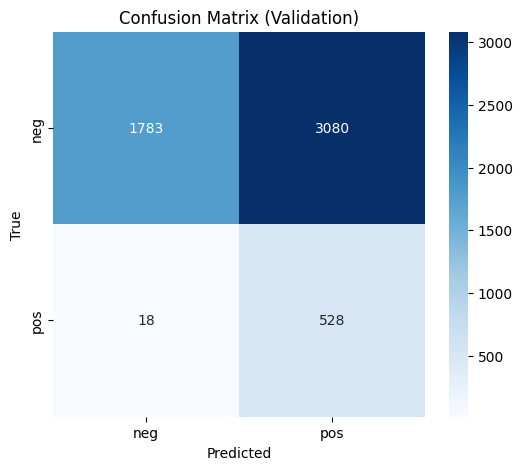

Test Evaluation:   0%|                                                       | 0/511 [00:00<?, ?it/s]

Test Evaluation:   0%|                                               | 1/511 [00:00<04:06,  2.07it/s]

Test Evaluation:   0%|▏                                              | 2/511 [00:00<04:05,  2.07it/s]

Test Evaluation:   1%|▎                                              | 3/511 [00:01<04:03,  2.08it/s]

Test Evaluation:   1%|▎                                              | 4/511 [00:01<04:04,  2.07it/s]

Test Evaluation:   1%|▍                                              | 5/511 [00:02<04:03,  2.08it/s]

Test Evaluation:   1%|▌                                              | 6/511 [00:02<03:54,  2.16it/s]

Test Evaluation:   1%|▋                                              | 7/511 [00:03<03:57,  2.13it/s]

Test Evaluation:   2%|▋                                              | 8/511 [00:03<03:59,  2.10it/s]

Test Evaluation:   2%|▊                                              | 9/511 [00:04<04:00,  2.09it/s]

Test Evaluation:   2%|▉                                             | 10/511 [00:04<03:53,  2.15it/s]

Test Evaluation:   2%|▉                                             | 11/511 [00:05<03:54,  2.13it/s]

Test Evaluation:   2%|█                                             | 12/511 [00:05<03:56,  2.11it/s]

Test Evaluation:   3%|█▏                                            | 13/511 [00:06<03:57,  2.09it/s]

Test Evaluation:   3%|█▎                                            | 14/511 [00:06<03:58,  2.08it/s]

Test Evaluation:   3%|█▎                                            | 15/511 [00:07<03:50,  2.15it/s]

Test Evaluation:   3%|█▍                                            | 16/511 [00:07<03:52,  2.13it/s]

Test Evaluation:   3%|█▌                                            | 17/511 [00:08<03:55,  2.09it/s]

Test Evaluation:   4%|█▌                                            | 18/511 [00:08<03:57,  2.08it/s]

Test Evaluation:   4%|█▋                                            | 19/511 [00:09<03:57,  2.07it/s]

Test Evaluation:   4%|█▊                                            | 20/511 [00:09<03:54,  2.09it/s]

Test Evaluation:   4%|█▉                                            | 21/511 [00:09<03:50,  2.13it/s]

Test Evaluation:   4%|█▉                                            | 22/511 [00:10<03:51,  2.11it/s]

Test Evaluation:   5%|██                                            | 23/511 [00:10<03:52,  2.10it/s]

Test Evaluation:   5%|██▏                                           | 24/511 [00:11<03:49,  2.12it/s]

Test Evaluation:   5%|██▎                                           | 25/511 [00:11<03:47,  2.13it/s]

Test Evaluation:   5%|██▎                                           | 26/511 [00:12<03:49,  2.11it/s]

Test Evaluation:   5%|██▍                                           | 27/511 [00:12<03:49,  2.11it/s]

Test Evaluation:   5%|██▌                                           | 28/511 [00:13<03:43,  2.16it/s]

Test Evaluation:   6%|██▌                                           | 29/511 [00:13<03:47,  2.12it/s]

Test Evaluation:   6%|██▋                                           | 30/511 [00:14<03:47,  2.11it/s]

Test Evaluation:   6%|██▊                                           | 31/511 [00:14<03:48,  2.10it/s]

Test Evaluation:   6%|██▉                                           | 32/511 [00:15<03:42,  2.15it/s]

Test Evaluation:   6%|██▉                                           | 33/511 [00:15<03:45,  2.12it/s]

Test Evaluation:   7%|███                                           | 34/511 [00:16<03:47,  2.10it/s]

Test Evaluation:   7%|███▏                                          | 35/511 [00:16<03:49,  2.07it/s]

Test Evaluation:   7%|███▏                                          | 36/511 [00:17<03:51,  2.05it/s]

Test Evaluation:   7%|███▎                                          | 37/511 [00:17<03:43,  2.12it/s]

Test Evaluation:   7%|███▍                                          | 38/511 [00:18<03:46,  2.09it/s]

Test Evaluation:   8%|███▌                                          | 39/511 [00:18<03:47,  2.07it/s]

Test Evaluation:   8%|███▌                                          | 40/511 [00:19<03:48,  2.06it/s]

Test Evaluation:   8%|███▋                                          | 41/511 [00:19<03:39,  2.14it/s]

Test Evaluation:   8%|███▊                                          | 42/511 [00:19<03:42,  2.11it/s]

Test Evaluation:   8%|███▊                                          | 43/511 [00:20<03:43,  2.09it/s]

Test Evaluation:   9%|███▉                                          | 44/511 [00:20<03:44,  2.08it/s]

Test Evaluation:   9%|████                                          | 45/511 [00:21<03:45,  2.07it/s]

Test Evaluation:   9%|████▏                                         | 46/511 [00:21<03:43,  2.08it/s]

Test Evaluation:   9%|████▏                                         | 47/511 [00:22<03:38,  2.12it/s]

Test Evaluation:   9%|████▎                                         | 48/511 [00:22<03:40,  2.10it/s]

Test Evaluation:  10%|████▍                                         | 49/511 [00:23<03:42,  2.08it/s]

Test Evaluation:  10%|████▌                                         | 50/511 [00:23<03:42,  2.07it/s]

Test Evaluation:  10%|████▌                                         | 51/511 [00:24<03:42,  2.07it/s]

Test Evaluation:  10%|████▋                                         | 52/511 [00:24<03:42,  2.06it/s]

Test Evaluation:  10%|████▊                                         | 53/511 [00:25<03:35,  2.13it/s]

Test Evaluation:  11%|████▊                                         | 54/511 [00:25<03:37,  2.10it/s]

Test Evaluation:  11%|████▉                                         | 55/511 [00:26<03:38,  2.09it/s]

Test Evaluation:  11%|█████                                         | 56/511 [00:26<03:38,  2.08it/s]

Test Evaluation:  11%|█████▏                                        | 57/511 [00:27<03:40,  2.06it/s]

Test Evaluation:  11%|█████▏                                        | 58/511 [00:27<03:40,  2.06it/s]

Test Evaluation:  12%|█████▎                                        | 59/511 [00:28<03:32,  2.12it/s]

Test Evaluation:  12%|█████▍                                        | 60/511 [00:28<03:33,  2.11it/s]

Test Evaluation:  12%|█████▍                                        | 61/511 [00:29<03:34,  2.10it/s]

Test Evaluation:  12%|█████▌                                        | 62/511 [00:29<03:35,  2.08it/s]

Test Evaluation:  12%|█████▋                                        | 63/511 [00:30<03:36,  2.07it/s]

Test Evaluation:  13%|█████▊                                        | 64/511 [00:30<03:36,  2.07it/s]

Test Evaluation:  13%|█████▊                                        | 65/511 [00:30<03:35,  2.07it/s]

Test Evaluation:  13%|█████▉                                        | 66/511 [00:31<03:35,  2.06it/s]

Test Evaluation:  13%|██████                                        | 67/511 [00:31<03:35,  2.06it/s]

Test Evaluation:  13%|██████                                        | 68/511 [00:32<03:35,  2.06it/s]

Test Evaluation:  14%|██████▏                                       | 69/511 [00:32<03:35,  2.05it/s]

Test Evaluation:  14%|██████▎                                       | 70/511 [00:33<03:35,  2.04it/s]

Test Evaluation:  14%|██████▍                                       | 71/511 [00:33<03:34,  2.05it/s]

Test Evaluation:  14%|██████▍                                       | 72/511 [00:34<03:34,  2.05it/s]

Test Evaluation:  14%|██████▌                                       | 73/511 [00:34<03:32,  2.06it/s]

Test Evaluation:  14%|██████▋                                       | 74/511 [00:35<03:31,  2.06it/s]

Test Evaluation:  15%|██████▊                                       | 75/511 [00:35<03:31,  2.06it/s]

Test Evaluation:  15%|██████▊                                       | 76/511 [00:36<03:30,  2.06it/s]

Test Evaluation:  15%|██████▉                                       | 77/511 [00:36<03:30,  2.07it/s]

Test Evaluation:  15%|███████                                       | 78/511 [00:37<03:29,  2.06it/s]

Test Evaluation:  15%|███████                                       | 79/511 [00:37<03:30,  2.05it/s]

Test Evaluation:  16%|███████▏                                      | 80/511 [00:38<03:30,  2.05it/s]

Test Evaluation:  16%|███████▎                                      | 81/511 [00:38<03:28,  2.06it/s]

Test Evaluation:  16%|███████▍                                      | 82/511 [00:39<03:27,  2.07it/s]

Test Evaluation:  16%|███████▍                                      | 83/511 [00:39<03:27,  2.06it/s]

Test Evaluation:  16%|███████▌                                      | 84/511 [00:40<03:28,  2.05it/s]

Test Evaluation:  17%|███████▋                                      | 85/511 [00:40<03:26,  2.06it/s]

Test Evaluation:  17%|███████▋                                      | 86/511 [00:41<03:26,  2.05it/s]

Test Evaluation:  17%|███████▊                                      | 87/511 [00:41<03:28,  2.03it/s]

Test Evaluation:  17%|███████▉                                      | 88/511 [00:42<03:28,  2.03it/s]

Test Evaluation:  17%|████████                                      | 89/511 [00:42<03:27,  2.04it/s]

Test Evaluation:  18%|████████                                      | 90/511 [00:43<03:24,  2.06it/s]

Test Evaluation:  18%|████████▏                                     | 91/511 [00:43<03:23,  2.06it/s]

Test Evaluation:  18%|████████▎                                     | 92/511 [00:44<03:24,  2.05it/s]

Test Evaluation:  18%|████████▎                                     | 93/511 [00:44<03:22,  2.07it/s]

Test Evaluation:  18%|████████▍                                     | 94/511 [00:45<03:22,  2.06it/s]

Test Evaluation:  19%|████████▌                                     | 95/511 [00:45<03:21,  2.06it/s]

Test Evaluation:  19%|████████▋                                     | 96/511 [00:46<03:22,  2.05it/s]

Test Evaluation:  19%|████████▋                                     | 97/511 [00:46<03:22,  2.05it/s]

Test Evaluation:  19%|████████▊                                     | 98/511 [00:47<03:21,  2.05it/s]

Test Evaluation:  19%|████████▉                                     | 99/511 [00:47<03:18,  2.07it/s]

Test Evaluation:  20%|████████▊                                    | 100/511 [00:47<03:14,  2.12it/s]

Test Evaluation:  20%|████████▉                                    | 101/511 [00:48<03:15,  2.10it/s]

Test Evaluation:  20%|████████▉                                    | 102/511 [00:48<03:15,  2.09it/s]

Test Evaluation:  20%|█████████                                    | 103/511 [00:49<03:15,  2.09it/s]

Test Evaluation:  20%|█████████▏                                   | 104/511 [00:49<03:15,  2.08it/s]

Test Evaluation:  21%|█████████▏                                   | 105/511 [00:50<03:16,  2.06it/s]

Test Evaluation:  21%|█████████▎                                   | 106/511 [00:50<03:15,  2.07it/s]

Test Evaluation:  21%|█████████▍                                   | 107/511 [00:51<03:15,  2.07it/s]

Test Evaluation:  21%|█████████▌                                   | 108/511 [00:51<03:13,  2.08it/s]

Test Evaluation:  21%|█████████▌                                   | 109/511 [00:52<03:12,  2.09it/s]

Test Evaluation:  22%|█████████▋                                   | 110/511 [00:52<03:12,  2.08it/s]

Test Evaluation:  22%|█████████▊                                   | 111/511 [00:53<03:12,  2.08it/s]

Test Evaluation:  22%|█████████▊                                   | 112/511 [00:53<03:11,  2.08it/s]

Test Evaluation:  22%|█████████▉                                   | 113/511 [00:54<03:11,  2.07it/s]

Test Evaluation:  22%|██████████                                   | 114/511 [00:54<03:11,  2.07it/s]

Test Evaluation:  23%|██████████▏                                  | 115/511 [00:55<03:11,  2.07it/s]

Test Evaluation:  23%|██████████▏                                  | 116/511 [00:55<03:10,  2.07it/s]

Test Evaluation:  23%|██████████▎                                  | 117/511 [00:56<03:09,  2.08it/s]

Test Evaluation:  23%|██████████▍                                  | 118/511 [00:56<03:09,  2.07it/s]

Test Evaluation:  23%|██████████▍                                  | 119/511 [00:57<03:03,  2.14it/s]

Test Evaluation:  23%|██████████▌                                  | 120/511 [00:57<03:05,  2.10it/s]

Test Evaluation:  24%|██████████▋                                  | 121/511 [00:58<03:06,  2.10it/s]

Test Evaluation:  24%|██████████▋                                  | 122/511 [00:58<03:06,  2.09it/s]

Test Evaluation:  24%|██████████▊                                  | 123/511 [00:59<03:06,  2.08it/s]

Test Evaluation:  24%|██████████▉                                  | 124/511 [00:59<03:06,  2.08it/s]

Test Evaluation:  24%|███████████                                  | 125/511 [01:00<03:07,  2.06it/s]

Test Evaluation:  25%|███████████                                  | 126/511 [01:00<03:06,  2.06it/s]

Test Evaluation:  25%|███████████▏                                 | 127/511 [01:00<03:05,  2.07it/s]

Test Evaluation:  25%|███████████▎                                 | 128/511 [01:01<03:04,  2.08it/s]

Test Evaluation:  25%|███████████▎                                 | 129/511 [01:01<03:05,  2.06it/s]

Test Evaluation:  25%|███████████▍                                 | 130/511 [01:02<03:05,  2.05it/s]

Test Evaluation:  26%|███████████▌                                 | 131/511 [01:02<03:04,  2.06it/s]

Test Evaluation:  26%|███████████▌                                 | 132/511 [01:03<03:03,  2.06it/s]

Test Evaluation:  26%|███████████▋                                 | 133/511 [01:03<03:02,  2.07it/s]

Test Evaluation:  26%|███████████▊                                 | 134/511 [01:04<03:03,  2.05it/s]

Test Evaluation:  26%|███████████▉                                 | 135/511 [01:04<03:07,  2.01it/s]

Test Evaluation:  27%|███████████▉                                 | 136/511 [01:05<03:04,  2.04it/s]

Test Evaluation:  27%|████████████                                 | 137/511 [01:05<03:02,  2.05it/s]

Test Evaluation:  27%|████████████▏                                | 138/511 [01:06<03:01,  2.06it/s]

Test Evaluation:  27%|████████████▏                                | 139/511 [01:06<03:00,  2.06it/s]

Test Evaluation:  27%|████████████▎                                | 140/511 [01:07<03:01,  2.05it/s]

Test Evaluation:  28%|████████████▍                                | 141/511 [01:07<03:00,  2.06it/s]

Test Evaluation:  28%|████████████▌                                | 142/511 [01:08<02:59,  2.05it/s]

Test Evaluation:  28%|████████████▌                                | 143/511 [01:08<02:58,  2.06it/s]

Test Evaluation:  28%|████████████▋                                | 144/511 [01:09<02:58,  2.05it/s]

Test Evaluation:  28%|████████████▊                                | 145/511 [01:09<02:58,  2.05it/s]

Test Evaluation:  29%|████████████▊                                | 146/511 [01:10<02:58,  2.04it/s]

Test Evaluation:  29%|████████████▉                                | 147/511 [01:10<02:56,  2.06it/s]

Test Evaluation:  29%|█████████████                                | 148/511 [01:11<02:57,  2.05it/s]

Test Evaluation:  29%|█████████████                                | 149/511 [01:11<02:56,  2.05it/s]

Test Evaluation:  29%|█████████████▏                               | 150/511 [01:12<02:57,  2.04it/s]

Test Evaluation:  30%|█████████████▎                               | 151/511 [01:12<02:56,  2.04it/s]

Test Evaluation:  30%|█████████████▍                               | 152/511 [01:13<02:55,  2.05it/s]

Test Evaluation:  30%|█████████████▍                               | 153/511 [01:13<02:53,  2.06it/s]

Test Evaluation:  30%|█████████████▌                               | 154/511 [01:14<02:52,  2.06it/s]

Test Evaluation:  30%|█████████████▋                               | 155/511 [01:14<02:52,  2.06it/s]

Test Evaluation:  31%|█████████████▋                               | 156/511 [01:15<02:53,  2.04it/s]

Test Evaluation:  31%|█████████████▊                               | 157/511 [01:15<02:52,  2.05it/s]

Test Evaluation:  31%|█████████████▉                               | 158/511 [01:16<02:51,  2.06it/s]

Test Evaluation:  31%|██████████████                               | 159/511 [01:16<02:43,  2.15it/s]

Test Evaluation:  31%|██████████████                               | 160/511 [01:17<02:46,  2.11it/s]

Test Evaluation:  32%|██████████████▏                              | 161/511 [01:17<02:48,  2.08it/s]

Test Evaluation:  32%|██████████████▎                              | 162/511 [01:17<02:48,  2.07it/s]

Test Evaluation:  32%|██████████████▎                              | 163/511 [01:18<02:47,  2.08it/s]

Test Evaluation:  32%|██████████████▍                              | 164/511 [01:18<02:47,  2.07it/s]

Test Evaluation:  32%|██████████████▌                              | 165/511 [01:19<02:46,  2.07it/s]

Test Evaluation:  32%|██████████████▌                              | 166/511 [01:19<02:47,  2.06it/s]

Test Evaluation:  33%|██████████████▋                              | 167/511 [01:20<02:47,  2.06it/s]

Test Evaluation:  33%|██████████████▊                              | 168/511 [01:20<02:47,  2.05it/s]

Test Evaluation:  33%|██████████████▉                              | 169/511 [01:21<02:47,  2.05it/s]

Test Evaluation:  33%|██████████████▉                              | 170/511 [01:21<02:47,  2.04it/s]

Test Evaluation:  33%|███████████████                              | 171/511 [01:22<02:46,  2.05it/s]

Test Evaluation:  34%|███████████████▏                             | 172/511 [01:22<02:44,  2.06it/s]

Test Evaluation:  34%|███████████████▏                             | 173/511 [01:23<02:45,  2.05it/s]

Test Evaluation:  34%|███████████████▎                             | 174/511 [01:23<02:45,  2.04it/s]

Test Evaluation:  34%|███████████████▍                             | 175/511 [01:24<02:45,  2.03it/s]

Test Evaluation:  34%|███████████████▍                             | 176/511 [01:24<02:45,  2.02it/s]

Test Evaluation:  35%|███████████████▌                             | 177/511 [01:25<02:42,  2.06it/s]

Test Evaluation:  35%|███████████████▋                             | 178/511 [01:25<02:39,  2.08it/s]

Test Evaluation:  35%|███████████████▊                             | 179/511 [01:26<02:40,  2.07it/s]

Test Evaluation:  35%|███████████████▊                             | 180/511 [01:26<02:40,  2.07it/s]

Test Evaluation:  35%|███████████████▉                             | 181/511 [01:27<02:41,  2.04it/s]

Test Evaluation:  36%|████████████████                             | 182/511 [01:27<02:41,  2.04it/s]

Test Evaluation:  36%|████████████████                             | 183/511 [01:28<02:40,  2.04it/s]

Test Evaluation:  36%|████████████████▏                            | 184/511 [01:28<02:40,  2.04it/s]

Test Evaluation:  36%|████████████████▎                            | 185/511 [01:29<02:39,  2.04it/s]

Test Evaluation:  36%|████████████████▍                            | 186/511 [01:29<02:38,  2.05it/s]

Test Evaluation:  37%|████████████████▍                            | 187/511 [01:30<02:39,  2.04it/s]

Test Evaluation:  37%|████████████████▌                            | 188/511 [01:30<02:38,  2.04it/s]

Test Evaluation:  37%|████████████████▋                            | 189/511 [01:31<02:37,  2.04it/s]

Test Evaluation:  37%|████████████████▋                            | 190/511 [01:31<02:37,  2.03it/s]

Test Evaluation:  37%|████████████████▊                            | 191/511 [01:32<02:37,  2.03it/s]

Test Evaluation:  38%|████████████████▉                            | 192/511 [01:32<02:36,  2.04it/s]

Test Evaluation:  38%|████████████████▉                            | 193/511 [01:33<02:35,  2.04it/s]

Test Evaluation:  38%|█████████████████                            | 194/511 [01:33<02:34,  2.05it/s]

Test Evaluation:  38%|█████████████████▏                           | 195/511 [01:34<02:33,  2.06it/s]

Test Evaluation:  38%|█████████████████▎                           | 196/511 [01:34<02:34,  2.04it/s]

Test Evaluation:  39%|█████████████████▎                           | 197/511 [01:35<02:33,  2.05it/s]

Test Evaluation:  39%|█████████████████▍                           | 198/511 [01:35<02:31,  2.06it/s]

Test Evaluation:  39%|█████████████████▌                           | 199/511 [01:36<02:31,  2.06it/s]

Test Evaluation:  39%|█████████████████▌                           | 200/511 [01:36<02:31,  2.06it/s]

Test Evaluation:  39%|█████████████████▋                           | 201/511 [01:37<02:29,  2.07it/s]

Test Evaluation:  40%|█████████████████▊                           | 202/511 [01:37<02:28,  2.08it/s]

Test Evaluation:  40%|█████████████████▉                           | 203/511 [01:37<02:28,  2.08it/s]

Test Evaluation:  40%|█████████████████▉                           | 204/511 [01:38<02:27,  2.08it/s]

Test Evaluation:  40%|██████████████████                           | 205/511 [01:38<02:27,  2.07it/s]

Test Evaluation:  40%|██████████████████▏                          | 206/511 [01:39<02:27,  2.07it/s]

Test Evaluation:  41%|██████████████████▏                          | 207/511 [01:39<02:22,  2.13it/s]

Test Evaluation:  41%|██████████████████▎                          | 208/511 [01:40<02:23,  2.11it/s]

Test Evaluation:  41%|██████████████████▍                          | 209/511 [01:40<02:23,  2.10it/s]

Test Evaluation:  41%|██████████████████▍                          | 210/511 [01:41<02:24,  2.08it/s]

Test Evaluation:  41%|██████████████████▌                          | 211/511 [01:41<02:27,  2.03it/s]

Test Evaluation:  41%|██████████████████▋                          | 212/511 [01:42<02:26,  2.04it/s]

Test Evaluation:  42%|██████████████████▊                          | 213/511 [01:42<02:25,  2.05it/s]

Test Evaluation:  42%|██████████████████▊                          | 214/511 [01:43<02:25,  2.05it/s]

Test Evaluation:  42%|██████████████████▉                          | 215/511 [01:43<02:24,  2.05it/s]

Test Evaluation:  42%|███████████████████                          | 216/511 [01:44<02:23,  2.06it/s]

Test Evaluation:  42%|███████████████████                          | 217/511 [01:44<02:22,  2.06it/s]

Test Evaluation:  43%|███████████████████▏                         | 218/511 [01:45<02:21,  2.07it/s]

Test Evaluation:  43%|███████████████████▎                         | 219/511 [01:45<02:21,  2.06it/s]

Test Evaluation:  43%|███████████████████▎                         | 220/511 [01:46<02:20,  2.06it/s]

Test Evaluation:  43%|███████████████████▍                         | 221/511 [01:46<02:20,  2.06it/s]

Test Evaluation:  43%|███████████████████▌                         | 222/511 [01:47<02:19,  2.07it/s]

Test Evaluation:  44%|███████████████████▋                         | 223/511 [01:47<02:19,  2.07it/s]

Test Evaluation:  44%|███████████████████▋                         | 224/511 [01:48<02:17,  2.09it/s]

Test Evaluation:  44%|███████████████████▊                         | 225/511 [01:48<02:16,  2.09it/s]

Test Evaluation:  44%|███████████████████▉                         | 226/511 [01:49<02:15,  2.10it/s]

Test Evaluation:  44%|███████████████████▉                         | 227/511 [01:49<02:15,  2.10it/s]

Test Evaluation:  45%|████████████████████                         | 228/511 [01:50<02:16,  2.08it/s]

Test Evaluation:  45%|████████████████████▏                        | 229/511 [01:50<02:16,  2.07it/s]

Test Evaluation:  45%|████████████████████▎                        | 230/511 [01:51<02:16,  2.06it/s]

Test Evaluation:  45%|████████████████████▎                        | 231/511 [01:51<02:16,  2.06it/s]

Test Evaluation:  45%|████████████████████▍                        | 232/511 [01:51<02:15,  2.06it/s]

Test Evaluation:  46%|████████████████████▌                        | 233/511 [01:52<02:15,  2.06it/s]

Test Evaluation:  46%|████████████████████▌                        | 234/511 [01:52<02:14,  2.06it/s]

Test Evaluation:  46%|████████████████████▋                        | 235/511 [01:53<02:14,  2.05it/s]

Test Evaluation:  46%|████████████████████▊                        | 236/511 [01:53<02:13,  2.06it/s]

Test Evaluation:  46%|████████████████████▊                        | 237/511 [01:54<02:12,  2.07it/s]

Test Evaluation:  47%|████████████████████▉                        | 238/511 [01:54<02:12,  2.06it/s]

Test Evaluation:  47%|█████████████████████                        | 239/511 [01:55<02:12,  2.06it/s]

Test Evaluation:  47%|█████████████████████▏                       | 240/511 [01:55<02:11,  2.06it/s]

Test Evaluation:  47%|█████████████████████▏                       | 241/511 [01:56<02:11,  2.06it/s]

Test Evaluation:  47%|█████████████████████▎                       | 242/511 [01:56<02:10,  2.06it/s]

Test Evaluation:  48%|█████████████████████▍                       | 243/511 [01:57<02:10,  2.05it/s]

Test Evaluation:  48%|█████████████████████▍                       | 244/511 [01:57<02:09,  2.06it/s]

Test Evaluation:  48%|█████████████████████▌                       | 245/511 [01:58<02:07,  2.08it/s]

Test Evaluation:  48%|█████████████████████▋                       | 246/511 [01:58<02:04,  2.13it/s]

Test Evaluation:  48%|█████████████████████▊                       | 247/511 [01:59<02:04,  2.12it/s]

Test Evaluation:  49%|█████████████████████▊                       | 248/511 [01:59<02:05,  2.10it/s]

Test Evaluation:  49%|█████████████████████▉                       | 249/511 [02:00<02:05,  2.09it/s]

Test Evaluation:  49%|██████████████████████                       | 250/511 [02:00<02:05,  2.08it/s]

Test Evaluation:  49%|██████████████████████                       | 251/511 [02:01<02:05,  2.07it/s]

Test Evaluation:  49%|██████████████████████▏                      | 252/511 [02:01<02:05,  2.07it/s]

Test Evaluation:  50%|██████████████████████▎                      | 253/511 [02:02<02:04,  2.07it/s]

Test Evaluation:  50%|██████████████████████▎                      | 254/511 [02:02<02:04,  2.07it/s]

Test Evaluation:  50%|██████████████████████▍                      | 255/511 [02:03<02:04,  2.06it/s]

Test Evaluation:  50%|██████████████████████▌                      | 256/511 [02:03<02:03,  2.06it/s]

Test Evaluation:  50%|██████████████████████▋                      | 257/511 [02:04<02:03,  2.06it/s]

Test Evaluation:  50%|██████████████████████▋                      | 258/511 [02:04<02:04,  2.04it/s]

Test Evaluation:  51%|██████████████████████▊                      | 259/511 [02:05<02:02,  2.05it/s]

Test Evaluation:  51%|██████████████████████▉                      | 260/511 [02:05<02:01,  2.06it/s]

Test Evaluation:  51%|██████████████████████▉                      | 261/511 [02:06<02:01,  2.06it/s]

Test Evaluation:  51%|███████████████████████                      | 262/511 [02:06<02:00,  2.06it/s]

Test Evaluation:  51%|███████████████████████▏                     | 263/511 [02:06<02:00,  2.06it/s]

Test Evaluation:  52%|███████████████████████▏                     | 264/511 [02:07<02:00,  2.05it/s]

Test Evaluation:  52%|███████████████████████▎                     | 265/511 [02:07<01:59,  2.05it/s]

Test Evaluation:  52%|███████████████████████▍                     | 266/511 [02:08<01:58,  2.06it/s]

Test Evaluation:  52%|███████████████████████▌                     | 267/511 [02:08<01:58,  2.05it/s]

Test Evaluation:  52%|███████████████████████▌                     | 268/511 [02:09<01:58,  2.06it/s]

Test Evaluation:  53%|███████████████████████▋                     | 269/511 [02:09<01:58,  2.05it/s]

Test Evaluation:  53%|███████████████████████▊                     | 270/511 [02:10<01:58,  2.04it/s]

Test Evaluation:  53%|███████████████████████▊                     | 271/511 [02:10<01:57,  2.05it/s]

Test Evaluation:  53%|███████████████████████▉                     | 272/511 [02:11<01:56,  2.06it/s]

Test Evaluation:  53%|████████████████████████                     | 273/511 [02:11<01:55,  2.07it/s]

Test Evaluation:  54%|████████████████████████▏                    | 274/511 [02:12<01:50,  2.14it/s]

Test Evaluation:  54%|████████████████████████▏                    | 275/511 [02:12<01:51,  2.12it/s]

Test Evaluation:  54%|████████████████████████▎                    | 276/511 [02:13<01:51,  2.11it/s]

Test Evaluation:  54%|████████████████████████▍                    | 277/511 [02:13<01:51,  2.10it/s]

Test Evaluation:  54%|████████████████████████▍                    | 278/511 [02:14<01:51,  2.09it/s]

Test Evaluation:  55%|████████████████████████▌                    | 279/511 [02:14<01:51,  2.08it/s]

Test Evaluation:  55%|████████████████████████▋                    | 280/511 [02:15<01:51,  2.06it/s]

Test Evaluation:  55%|████████████████████████▋                    | 281/511 [02:15<01:51,  2.05it/s]

Test Evaluation:  55%|████████████████████████▊                    | 282/511 [02:16<01:51,  2.05it/s]

Test Evaluation:  55%|████████████████████████▉                    | 283/511 [02:16<01:51,  2.05it/s]

Test Evaluation:  56%|█████████████████████████                    | 284/511 [02:17<01:50,  2.05it/s]

Test Evaluation:  56%|█████████████████████████                    | 285/511 [02:17<01:50,  2.05it/s]

Test Evaluation:  56%|█████████████████████████▏                   | 286/511 [02:18<01:49,  2.05it/s]

Test Evaluation:  56%|█████████████████████████▎                   | 287/511 [02:18<01:49,  2.04it/s]

Test Evaluation:  56%|█████████████████████████▎                   | 288/511 [02:19<01:49,  2.04it/s]

Test Evaluation:  57%|█████████████████████████▍                   | 289/511 [02:19<01:48,  2.05it/s]

Test Evaluation:  57%|█████████████████████████▌                   | 290/511 [02:20<01:47,  2.06it/s]

Test Evaluation:  57%|█████████████████████████▋                   | 291/511 [02:20<01:46,  2.06it/s]

Test Evaluation:  57%|█████████████████████████▋                   | 292/511 [02:21<01:46,  2.06it/s]

Test Evaluation:  57%|█████████████████████████▊                   | 293/511 [02:21<01:45,  2.06it/s]

Test Evaluation:  58%|█████████████████████████▉                   | 294/511 [02:22<01:45,  2.05it/s]

Test Evaluation:  58%|█████████████████████████▉                   | 295/511 [02:22<01:45,  2.05it/s]

Test Evaluation:  58%|██████████████████████████                   | 296/511 [02:22<01:44,  2.05it/s]

Test Evaluation:  58%|██████████████████████████▏                  | 297/511 [02:23<01:43,  2.06it/s]

Test Evaluation:  58%|██████████████████████████▏                  | 298/511 [02:23<01:42,  2.07it/s]

Test Evaluation:  59%|██████████████████████████▎                  | 299/511 [02:24<01:42,  2.07it/s]

Test Evaluation:  59%|██████████████████████████▍                  | 300/511 [02:24<01:41,  2.07it/s]

Test Evaluation:  59%|██████████████████████████▌                  | 301/511 [02:25<01:41,  2.06it/s]

Test Evaluation:  59%|██████████████████████████▌                  | 302/511 [02:25<01:41,  2.06it/s]

Test Evaluation:  59%|██████████████████████████▋                  | 303/511 [02:26<01:41,  2.06it/s]

Test Evaluation:  59%|██████████████████████████▊                  | 304/511 [02:26<01:40,  2.05it/s]

Test Evaluation:  60%|██████████████████████████▊                  | 305/511 [02:27<01:39,  2.06it/s]

Test Evaluation:  60%|██████████████████████████▉                  | 306/511 [02:27<01:39,  2.07it/s]

Test Evaluation:  60%|███████████████████████████                  | 307/511 [02:28<01:39,  2.06it/s]

Test Evaluation:  60%|███████████████████████████                  | 308/511 [02:28<01:37,  2.07it/s]

Test Evaluation:  60%|███████████████████████████▏                 | 309/511 [02:29<01:38,  2.06it/s]

Test Evaluation:  61%|███████████████████████████▎                 | 310/511 [02:29<01:37,  2.06it/s]

Test Evaluation:  61%|███████████████████████████▍                 | 311/511 [02:30<01:34,  2.11it/s]

Test Evaluation:  61%|███████████████████████████▍                 | 312/511 [02:30<01:33,  2.12it/s]

Test Evaluation:  61%|███████████████████████████▌                 | 313/511 [02:31<01:34,  2.11it/s]

Test Evaluation:  61%|███████████████████████████▋                 | 314/511 [02:31<01:34,  2.09it/s]

Test Evaluation:  62%|███████████████████████████▋                 | 315/511 [02:32<01:34,  2.08it/s]

Test Evaluation:  62%|███████████████████████████▊                 | 316/511 [02:32<01:33,  2.09it/s]

Test Evaluation:  62%|███████████████████████████▉                 | 317/511 [02:33<01:33,  2.08it/s]

Test Evaluation:  62%|████████████████████████████                 | 318/511 [02:33<01:33,  2.07it/s]

Test Evaluation:  62%|████████████████████████████                 | 319/511 [02:34<01:32,  2.07it/s]

Test Evaluation:  63%|████████████████████████████▏                | 320/511 [02:34<01:33,  2.05it/s]

Test Evaluation:  63%|████████████████████████████▎                | 321/511 [02:35<01:32,  2.06it/s]

Test Evaluation:  63%|████████████████████████████▎                | 322/511 [02:35<01:32,  2.05it/s]

Test Evaluation:  63%|████████████████████████████▍                | 323/511 [02:36<01:31,  2.06it/s]

Test Evaluation:  63%|████████████████████████████▌                | 324/511 [02:36<01:30,  2.06it/s]

Test Evaluation:  64%|████████████████████████████▌                | 325/511 [02:36<01:30,  2.06it/s]

Test Evaluation:  64%|████████████████████████████▋                | 326/511 [02:37<01:29,  2.06it/s]

Test Evaluation:  64%|████████████████████████████▊                | 327/511 [02:37<01:28,  2.07it/s]

Test Evaluation:  64%|████████████████████████████▉                | 328/511 [02:38<01:28,  2.08it/s]

Test Evaluation:  64%|████████████████████████████▉                | 329/511 [02:38<01:27,  2.07it/s]

Test Evaluation:  65%|█████████████████████████████                | 330/511 [02:39<01:27,  2.07it/s]

Test Evaluation:  65%|█████████████████████████████▏               | 331/511 [02:39<01:26,  2.08it/s]

Test Evaluation:  65%|█████████████████████████████▏               | 332/511 [02:40<01:26,  2.07it/s]

Test Evaluation:  65%|█████████████████████████████▎               | 333/511 [02:40<01:25,  2.07it/s]

Test Evaluation:  65%|█████████████████████████████▍               | 334/511 [02:41<01:25,  2.07it/s]

Test Evaluation:  66%|█████████████████████████████▌               | 335/511 [02:41<01:26,  2.03it/s]

Test Evaluation:  66%|█████████████████████████████▌               | 336/511 [02:42<01:26,  2.03it/s]

Test Evaluation:  66%|█████████████████████████████▋               | 337/511 [02:42<01:24,  2.05it/s]

Test Evaluation:  66%|█████████████████████████████▊               | 338/511 [02:43<01:24,  2.05it/s]

Test Evaluation:  66%|█████████████████████████████▊               | 339/511 [02:43<01:21,  2.12it/s]

Test Evaluation:  67%|█████████████████████████████▉               | 340/511 [02:44<01:21,  2.10it/s]

Test Evaluation:  67%|██████████████████████████████               | 341/511 [02:44<01:20,  2.11it/s]

Test Evaluation:  67%|██████████████████████████████               | 342/511 [02:45<01:20,  2.09it/s]

Test Evaluation:  67%|██████████████████████████████▏              | 343/511 [02:45<01:20,  2.09it/s]

Test Evaluation:  67%|██████████████████████████████▎              | 344/511 [02:46<01:20,  2.08it/s]

Test Evaluation:  68%|██████████████████████████████▍              | 345/511 [02:46<01:20,  2.07it/s]

Test Evaluation:  68%|██████████████████████████████▍              | 346/511 [02:47<01:19,  2.07it/s]

Test Evaluation:  68%|██████████████████████████████▌              | 347/511 [02:47<01:18,  2.08it/s]

Test Evaluation:  68%|██████████████████████████████▋              | 348/511 [02:48<01:18,  2.07it/s]

Test Evaluation:  68%|██████████████████████████████▋              | 349/511 [02:48<01:17,  2.08it/s]

Test Evaluation:  68%|██████████████████████████████▊              | 350/511 [02:49<01:17,  2.08it/s]

Test Evaluation:  69%|██████████████████████████████▉              | 351/511 [02:49<01:17,  2.07it/s]

Test Evaluation:  69%|██████████████████████████████▉              | 352/511 [02:50<01:16,  2.07it/s]

Test Evaluation:  69%|███████████████████████████████              | 353/511 [02:50<01:16,  2.07it/s]

Test Evaluation:  69%|███████████████████████████████▏             | 354/511 [02:50<01:15,  2.08it/s]

Test Evaluation:  69%|███████████████████████████████▎             | 355/511 [02:51<01:14,  2.09it/s]

Test Evaluation:  70%|███████████████████████████████▎             | 356/511 [02:51<01:14,  2.09it/s]

Test Evaluation:  70%|███████████████████████████████▍             | 357/511 [02:52<01:14,  2.08it/s]

Test Evaluation:  70%|███████████████████████████████▌             | 358/511 [02:52<01:13,  2.08it/s]

Test Evaluation:  70%|███████████████████████████████▌             | 359/511 [02:53<01:13,  2.08it/s]

Test Evaluation:  70%|███████████████████████████████▋             | 360/511 [02:53<01:12,  2.07it/s]

Test Evaluation:  71%|███████████████████████████████▊             | 361/511 [02:54<01:12,  2.08it/s]

Test Evaluation:  71%|███████████████████████████████▉             | 362/511 [02:54<01:11,  2.08it/s]

Test Evaluation:  71%|███████████████████████████████▉             | 363/511 [02:55<01:11,  2.07it/s]

Test Evaluation:  71%|████████████████████████████████             | 364/511 [02:55<01:10,  2.08it/s]

Test Evaluation:  71%|████████████████████████████████▏            | 365/511 [02:56<01:08,  2.13it/s]

Test Evaluation:  72%|████████████████████████████████▏            | 366/511 [02:56<01:08,  2.11it/s]

Test Evaluation:  72%|████████████████████████████████▎            | 367/511 [02:57<01:08,  2.10it/s]

Test Evaluation:  72%|████████████████████████████████▍            | 368/511 [02:57<01:08,  2.08it/s]

Test Evaluation:  72%|████████████████████████████████▍            | 369/511 [02:58<01:08,  2.09it/s]

Test Evaluation:  72%|████████████████████████████████▌            | 370/511 [02:58<01:07,  2.09it/s]

Test Evaluation:  73%|████████████████████████████████▋            | 371/511 [02:59<01:07,  2.08it/s]

Test Evaluation:  73%|████████████████████████████████▊            | 372/511 [02:59<01:07,  2.07it/s]

Test Evaluation:  73%|████████████████████████████████▊            | 373/511 [03:00<01:07,  2.06it/s]

Test Evaluation:  73%|████████████████████████████████▉            | 374/511 [03:00<01:06,  2.05it/s]

Test Evaluation:  73%|█████████████████████████████████            | 375/511 [03:01<01:06,  2.05it/s]

Test Evaluation:  74%|█████████████████████████████████            | 376/511 [03:01<01:05,  2.05it/s]

Test Evaluation:  74%|█████████████████████████████████▏           | 377/511 [03:02<01:05,  2.06it/s]

Test Evaluation:  74%|█████████████████████████████████▎           | 378/511 [03:02<01:04,  2.06it/s]

Test Evaluation:  74%|█████████████████████████████████▍           | 379/511 [03:03<01:04,  2.06it/s]

Test Evaluation:  74%|█████████████████████████████████▍           | 380/511 [03:03<01:03,  2.06it/s]

Test Evaluation:  75%|█████████████████████████████████▌           | 381/511 [03:03<01:03,  2.06it/s]

Test Evaluation:  75%|█████████████████████████████████▋           | 382/511 [03:04<01:03,  2.04it/s]

Test Evaluation:  75%|█████████████████████████████████▋           | 383/511 [03:04<01:03,  2.03it/s]

Test Evaluation:  75%|█████████████████████████████████▊           | 384/511 [03:05<01:02,  2.03it/s]

Test Evaluation:  75%|█████████████████████████████████▉           | 385/511 [03:05<01:01,  2.03it/s]

Test Evaluation:  76%|█████████████████████████████████▉           | 386/511 [03:06<01:01,  2.03it/s]

Test Evaluation:  76%|██████████████████████████████████           | 387/511 [03:06<01:00,  2.04it/s]

Test Evaluation:  76%|██████████████████████████████████▏          | 388/511 [03:07<01:00,  2.04it/s]

Test Evaluation:  76%|██████████████████████████████████▎          | 389/511 [03:07<00:59,  2.05it/s]

Test Evaluation:  76%|██████████████████████████████████▎          | 390/511 [03:08<00:58,  2.05it/s]

Test Evaluation:  77%|██████████████████████████████████▍          | 391/511 [03:08<00:58,  2.06it/s]

Test Evaluation:  77%|██████████████████████████████████▌          | 392/511 [03:09<00:57,  2.06it/s]

Test Evaluation:  77%|██████████████████████████████████▌          | 393/511 [03:09<00:57,  2.06it/s]

Test Evaluation:  77%|██████████████████████████████████▋          | 394/511 [03:10<00:56,  2.06it/s]

Test Evaluation:  77%|██████████████████████████████████▊          | 395/511 [03:10<00:56,  2.05it/s]

Test Evaluation:  77%|██████████████████████████████████▊          | 396/511 [03:11<00:55,  2.05it/s]

Test Evaluation:  78%|██████████████████████████████████▉          | 397/511 [03:11<00:55,  2.06it/s]

Test Evaluation:  78%|███████████████████████████████████          | 398/511 [03:12<00:54,  2.07it/s]

Test Evaluation:  78%|███████████████████████████████████▏         | 399/511 [03:12<00:53,  2.07it/s]

Test Evaluation:  78%|███████████████████████████████████▏         | 400/511 [03:13<00:53,  2.08it/s]

Test Evaluation:  78%|███████████████████████████████████▎         | 401/511 [03:13<00:52,  2.08it/s]

Test Evaluation:  79%|███████████████████████████████████▍         | 402/511 [03:14<00:52,  2.07it/s]

Test Evaluation:  79%|███████████████████████████████████▍         | 403/511 [03:14<00:52,  2.06it/s]

Test Evaluation:  79%|███████████████████████████████████▌         | 404/511 [03:15<00:52,  2.06it/s]

Test Evaluation:  79%|███████████████████████████████████▋         | 405/511 [03:15<00:51,  2.06it/s]

Test Evaluation:  79%|███████████████████████████████████▊         | 406/511 [03:16<00:51,  2.05it/s]

Test Evaluation:  80%|███████████████████████████████████▊         | 407/511 [03:16<00:50,  2.05it/s]

Test Evaluation:  80%|███████████████████████████████████▉         | 408/511 [03:17<00:50,  2.05it/s]

Test Evaluation:  80%|████████████████████████████████████         | 409/511 [03:17<00:49,  2.04it/s]

Test Evaluation:  80%|████████████████████████████████████         | 410/511 [03:18<00:47,  2.12it/s]

Test Evaluation:  80%|████████████████████████████████████▏        | 411/511 [03:18<00:47,  2.10it/s]

Test Evaluation:  81%|████████████████████████████████████▎        | 412/511 [03:19<00:47,  2.09it/s]

Test Evaluation:  81%|████████████████████████████████████▎        | 413/511 [03:19<00:47,  2.08it/s]

Test Evaluation:  81%|████████████████████████████████████▍        | 414/511 [03:19<00:46,  2.07it/s]

Test Evaluation:  81%|████████████████████████████████████▌        | 415/511 [03:20<00:46,  2.06it/s]

Test Evaluation:  81%|████████████████████████████████████▋        | 416/511 [03:20<00:46,  2.06it/s]

Test Evaluation:  82%|████████████████████████████████████▋        | 417/511 [03:21<00:45,  2.06it/s]

Test Evaluation:  82%|████████████████████████████████████▊        | 418/511 [03:21<00:45,  2.06it/s]

Test Evaluation:  82%|████████████████████████████████████▉        | 419/511 [03:22<00:44,  2.06it/s]

Test Evaluation:  82%|████████████████████████████████████▉        | 420/511 [03:22<00:44,  2.06it/s]

Test Evaluation:  82%|█████████████████████████████████████        | 421/511 [03:23<00:43,  2.06it/s]

Test Evaluation:  83%|█████████████████████████████████████▏       | 422/511 [03:23<00:43,  2.06it/s]

Test Evaluation:  83%|█████████████████████████████████████▎       | 423/511 [03:24<00:42,  2.06it/s]

Test Evaluation:  83%|█████████████████████████████████████▎       | 424/511 [03:24<00:42,  2.06it/s]

Test Evaluation:  83%|█████████████████████████████████████▍       | 425/511 [03:25<00:41,  2.06it/s]

Test Evaluation:  83%|█████████████████████████████████████▌       | 426/511 [03:25<00:41,  2.05it/s]

Test Evaluation:  84%|█████████████████████████████████████▌       | 427/511 [03:26<00:40,  2.05it/s]

Test Evaluation:  84%|█████████████████████████████████████▋       | 428/511 [03:26<00:40,  2.05it/s]

Test Evaluation:  84%|█████████████████████████████████████▊       | 429/511 [03:27<00:40,  2.04it/s]

Test Evaluation:  84%|█████████████████████████████████████▊       | 430/511 [03:27<00:39,  2.04it/s]

Test Evaluation:  84%|█████████████████████████████████████▉       | 431/511 [03:28<00:38,  2.05it/s]

Test Evaluation:  85%|██████████████████████████████████████       | 432/511 [03:28<00:38,  2.05it/s]

Test Evaluation:  85%|██████████████████████████████████████▏      | 433/511 [03:29<00:37,  2.05it/s]

Test Evaluation:  85%|██████████████████████████████████████▏      | 434/511 [03:29<00:36,  2.13it/s]

Test Evaluation:  85%|██████████████████████████████████████▎      | 435/511 [03:30<00:36,  2.11it/s]

Test Evaluation:  85%|██████████████████████████████████████▍      | 436/511 [03:30<00:35,  2.10it/s]

Test Evaluation:  86%|██████████████████████████████████████▍      | 437/511 [03:31<00:35,  2.09it/s]

Test Evaluation:  86%|██████████████████████████████████████▌      | 438/511 [03:31<00:34,  2.09it/s]

Test Evaluation:  86%|██████████████████████████████████████▋      | 439/511 [03:32<00:34,  2.06it/s]

Test Evaluation:  86%|██████████████████████████████████████▋      | 440/511 [03:32<00:34,  2.07it/s]

Test Evaluation:  86%|██████████████████████████████████████▊      | 441/511 [03:33<00:33,  2.07it/s]

Test Evaluation:  86%|██████████████████████████████████████▉      | 442/511 [03:33<00:33,  2.07it/s]

Test Evaluation:  87%|███████████████████████████████████████      | 443/511 [03:34<00:32,  2.07it/s]

Test Evaluation:  87%|███████████████████████████████████████      | 444/511 [03:34<00:32,  2.06it/s]

Test Evaluation:  87%|███████████████████████████████████████▏     | 445/511 [03:35<00:32,  2.05it/s]

Test Evaluation:  87%|███████████████████████████████████████▎     | 446/511 [03:35<00:31,  2.04it/s]

Test Evaluation:  87%|███████████████████████████████████████▎     | 447/511 [03:35<00:31,  2.05it/s]

Test Evaluation:  88%|███████████████████████████████████████▍     | 448/511 [03:36<00:30,  2.04it/s]

Test Evaluation:  88%|███████████████████████████████████████▌     | 449/511 [03:36<00:30,  2.04it/s]

Test Evaluation:  88%|███████████████████████████████████████▋     | 450/511 [03:37<00:29,  2.04it/s]

Test Evaluation:  88%|███████████████████████████████████████▋     | 451/511 [03:37<00:29,  2.05it/s]

Test Evaluation:  88%|███████████████████████████████████████▊     | 452/511 [03:38<00:28,  2.05it/s]

Test Evaluation:  89%|███████████████████████████████████████▉     | 453/511 [03:38<00:28,  2.05it/s]

Test Evaluation:  89%|███████████████████████████████████████▉     | 454/511 [03:39<00:27,  2.06it/s]

Test Evaluation:  89%|████████████████████████████████████████     | 455/511 [03:39<00:27,  2.05it/s]

Test Evaluation:  89%|████████████████████████████████████████▏    | 456/511 [03:40<00:26,  2.05it/s]

Test Evaluation:  89%|████████████████████████████████████████▏    | 457/511 [03:40<00:26,  2.06it/s]

Test Evaluation:  90%|████████████████████████████████████████▎    | 458/511 [03:41<00:25,  2.06it/s]

Test Evaluation:  90%|████████████████████████████████████████▍    | 459/511 [03:41<00:25,  2.06it/s]

Test Evaluation:  90%|████████████████████████████████████████▌    | 460/511 [03:42<00:24,  2.07it/s]

Test Evaluation:  90%|████████████████████████████████████████▌    | 461/511 [03:42<00:24,  2.07it/s]

Test Evaluation:  90%|████████████████████████████████████████▋    | 462/511 [03:43<00:23,  2.06it/s]

Test Evaluation:  91%|████████████████████████████████████████▊    | 463/511 [03:43<00:22,  2.13it/s]

Test Evaluation:  91%|████████████████████████████████████████▊    | 464/511 [03:44<00:22,  2.10it/s]

Test Evaluation:  91%|████████████████████████████████████████▉    | 465/511 [03:44<00:21,  2.10it/s]

Test Evaluation:  91%|█████████████████████████████████████████    | 466/511 [03:45<00:21,  2.08it/s]

Test Evaluation:  91%|█████████████████████████████████████████▏   | 467/511 [03:45<00:21,  2.08it/s]

Test Evaluation:  92%|█████████████████████████████████████████▏   | 468/511 [03:46<00:20,  2.07it/s]

Test Evaluation:  92%|█████████████████████████████████████████▎   | 469/511 [03:46<00:20,  2.07it/s]

Test Evaluation:  92%|█████████████████████████████████████████▍   | 470/511 [03:47<00:19,  2.07it/s]

Test Evaluation:  92%|█████████████████████████████████████████▍   | 471/511 [03:47<00:19,  2.07it/s]

Test Evaluation:  92%|█████████████████████████████████████████▌   | 472/511 [03:48<00:18,  2.06it/s]

Test Evaluation:  93%|█████████████████████████████████████████▋   | 473/511 [03:48<00:18,  2.07it/s]

Test Evaluation:  93%|█████████████████████████████████████████▋   | 474/511 [03:49<00:18,  2.05it/s]

Test Evaluation:  93%|█████████████████████████████████████████▊   | 475/511 [03:49<00:17,  2.06it/s]

Test Evaluation:  93%|█████████████████████████████████████████▉   | 476/511 [03:50<00:16,  2.06it/s]

Test Evaluation:  93%|██████████████████████████████████████████   | 477/511 [03:50<00:16,  2.05it/s]

Test Evaluation:  94%|██████████████████████████████████████████   | 478/511 [03:51<00:16,  2.05it/s]

Test Evaluation:  94%|██████████████████████████████████████████▏  | 479/511 [03:51<00:15,  2.04it/s]

Test Evaluation:  94%|██████████████████████████████████████████▎  | 480/511 [03:52<00:15,  2.04it/s]

Test Evaluation:  94%|██████████████████████████████████████████▎  | 481/511 [03:52<00:14,  2.04it/s]

Test Evaluation:  94%|██████████████████████████████████████████▍  | 482/511 [03:52<00:13,  2.10it/s]

Test Evaluation:  95%|██████████████████████████████████████████▌  | 483/511 [03:53<00:13,  2.09it/s]

Test Evaluation:  95%|██████████████████████████████████████████▌  | 484/511 [03:53<00:12,  2.08it/s]

Test Evaluation:  95%|██████████████████████████████████████████▋  | 485/511 [03:54<00:12,  2.07it/s]

Test Evaluation:  95%|██████████████████████████████████████████▊  | 486/511 [03:54<00:12,  2.06it/s]

Test Evaluation:  95%|██████████████████████████████████████████▉  | 487/511 [03:55<00:11,  2.06it/s]

Test Evaluation:  95%|██████████████████████████████████████████▉  | 488/511 [03:55<00:11,  2.06it/s]

Test Evaluation:  96%|███████████████████████████████████████████  | 489/511 [03:56<00:10,  2.06it/s]

Test Evaluation:  96%|███████████████████████████████████████████▏ | 490/511 [03:56<00:10,  2.07it/s]

Test Evaluation:  96%|███████████████████████████████████████████▏ | 491/511 [03:57<00:09,  2.07it/s]

Test Evaluation:  96%|███████████████████████████████████████████▎ | 492/511 [03:57<00:09,  2.05it/s]

Test Evaluation:  96%|███████████████████████████████████████████▍ | 493/511 [03:58<00:08,  2.05it/s]

Test Evaluation:  97%|███████████████████████████████████████████▌ | 494/511 [03:58<00:08,  2.05it/s]

Test Evaluation:  97%|███████████████████████████████████████████▌ | 495/511 [03:59<00:07,  2.06it/s]

Test Evaluation:  97%|███████████████████████████████████████████▋ | 496/511 [03:59<00:07,  2.07it/s]

Test Evaluation:  97%|███████████████████████████████████████████▊ | 497/511 [04:00<00:06,  2.06it/s]

Test Evaluation:  97%|███████████████████████████████████████████▊ | 498/511 [04:00<00:06,  2.05it/s]

Test Evaluation:  98%|███████████████████████████████████████████▉ | 499/511 [04:01<00:05,  2.06it/s]

Test Evaluation:  98%|████████████████████████████████████████████ | 500/511 [04:01<00:05,  2.05it/s]

Test Evaluation:  98%|████████████████████████████████████████████ | 501/511 [04:02<00:04,  2.05it/s]

Test Evaluation:  98%|████████████████████████████████████████████▏| 502/511 [04:02<00:04,  2.05it/s]

Test Evaluation:  98%|████████████████████████████████████████████▎| 503/511 [04:03<00:03,  2.06it/s]

Test Evaluation:  99%|████████████████████████████████████████████▍| 504/511 [04:03<00:03,  2.06it/s]

Test Evaluation:  99%|████████████████████████████████████████████▍| 505/511 [04:04<00:02,  2.06it/s]

Test Evaluation:  99%|████████████████████████████████████████████▌| 506/511 [04:04<00:02,  2.04it/s]

Test Evaluation:  99%|████████████████████████████████████████████▋| 507/511 [04:05<00:01,  2.06it/s]

Test Evaluation:  99%|████████████████████████████████████████████▋| 508/511 [04:05<00:01,  2.05it/s]

Test Evaluation: 100%|████████████████████████████████████████████▊| 509/511 [04:06<00:00,  2.05it/s]

Test Evaluation: 100%|████████████████████████████████████████████▉| 510/511 [04:06<00:00,  2.04it/s]

Test Evaluation: 100%|█████████████████████████████████████████████| 511/511 [04:06<00:00,  2.20it/s]

Test Evaluation: 100%|█████████████████████████████████████████████| 511/511 [04:06<00:00,  2.07it/s]

Test Loss: 0.3126 | Test Acc: 58.86% | Test F1: 0.5164
Classification Report (Test):
              precision    recall  f1-score   support

         neg       0.97      0.55      0.70      7240
         pos       0.20      0.89      0.33       934

    accuracy                           0.59      8174
   macro avg       0.59      0.72      0.52      8174
weighted avg       0.89      0.59      0.66      8174



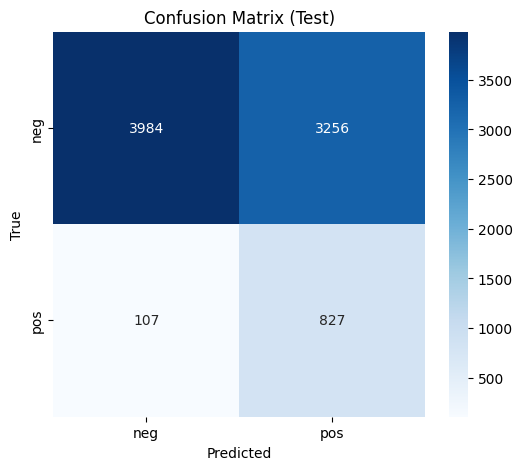

Epoch 2 Summary:
Train Loss: 0.2356 | Train Acc: 75.15% | Train F1: 0.7427
Val Loss: 0.6946 | Val Acc: 42.73% | Val F1: 0.3947
Test Loss: 0.3126 | Test Acc: 58.86% | Test F1: 0.5164
Epoch Time: 970.54s | GPU Memory Usage: 767.01 MB



Checkpoint saved at checkpoints\epoch_2.pth
No improvement in validation loss for 1 epoch(s).


Training:   0%|                                                              | 0/470 [00:00<?, ?it/s]

Training:   0%|                           | 0/470 [00:01<?, ?it/s, Loss=0.1396, F1=0.7333, Acc=75.00]

Training:   0%|                   | 1/470 [00:01<09:35,  1.23s/it, Loss=0.1396, F1=0.7333, Acc=75.00]

Training:   0%|                   | 1/470 [00:02<09:35,  1.23s/it, Loss=0.1599, F1=0.8000, Acc=81.25]

Training:   0%|                   | 2/470 [00:02<09:23,  1.20s/it, Loss=0.1599, F1=0.8000, Acc=81.25]

Training:   0%|                   | 2/470 [00:03<09:23,  1.20s/it, Loss=0.1681, F1=0.8222, Acc=83.33]

Training:   1%|                   | 3/470 [00:03<09:21,  1.20s/it, Loss=0.1681, F1=0.8222, Acc=83.33]

Training:   1%|                   | 3/470 [00:04<09:21,  1.20s/it, Loss=0.2034, F1=0.7703, Acc=78.12]

Training:   1%|▏                  | 4/470 [00:04<09:19,  1.20s/it, Loss=0.2034, F1=0.7703, Acc=78.12]

Training:   1%|▏                  | 4/470 [00:06<09:19,  1.20s/it, Loss=0.2229, F1=0.7679, Acc=77.50]

Training:   1%|▏                  | 5/470 [00:06<09:20,  1.21s/it, Loss=0.2229, F1=0.7679, Acc=77.50]

Training:   1%|▏                  | 5/470 [00:07<09:20,  1.21s/it, Loss=0.2358, F1=0.7742, Acc=78.12]

Training:   1%|▏                  | 6/470 [00:07<09:11,  1.19s/it, Loss=0.2358, F1=0.7742, Acc=78.12]

Training:   1%|▏                  | 6/470 [00:08<09:11,  1.19s/it, Loss=0.2262, F1=0.7727, Acc=77.68]

Training:   1%|▎                  | 7/470 [00:08<09:07,  1.18s/it, Loss=0.2262, F1=0.7727, Acc=77.68]

Training:   1%|▎                  | 7/470 [00:09<09:07,  1.18s/it, Loss=0.2116, F1=0.7944, Acc=79.69]

Training:   2%|▎                  | 8/470 [00:09<09:09,  1.19s/it, Loss=0.2116, F1=0.7944, Acc=79.69]

Training:   2%|▎                  | 8/470 [00:10<09:09,  1.19s/it, Loss=0.2165, F1=0.8037, Acc=80.56]

Training:   2%|▎                  | 9/470 [00:10<09:09,  1.19s/it, Loss=0.2165, F1=0.8037, Acc=80.56]

Training:   2%|▎                  | 9/470 [00:11<09:09,  1.19s/it, Loss=0.2047, F1=0.8179, Acc=81.88]

Training:   2%|▍                 | 10/470 [00:11<09:09,  1.19s/it, Loss=0.2047, F1=0.8179, Acc=81.88]

Training:   2%|▍                 | 10/470 [00:13<09:09,  1.19s/it, Loss=0.1995, F1=0.8281, Acc=82.95]

Training:   2%|▍                 | 11/470 [00:13<09:05,  1.19s/it, Loss=0.1995, F1=0.8281, Acc=82.95]

Training:   2%|▍                 | 11/470 [00:14<09:05,  1.19s/it, Loss=0.1883, F1=0.8373, Acc=83.85]

Training:   3%|▍                 | 12/470 [00:14<09:09,  1.20s/it, Loss=0.1883, F1=0.8373, Acc=83.85]

Training:   3%|▍                 | 12/470 [00:15<09:09,  1.20s/it, Loss=0.1849, F1=0.8350, Acc=83.65]

Training:   3%|▍                 | 13/470 [00:15<09:09,  1.20s/it, Loss=0.1849, F1=0.8350, Acc=83.65]

Training:   3%|▍                 | 13/470 [00:16<09:09,  1.20s/it, Loss=0.1882, F1=0.8377, Acc=83.93]

Training:   3%|▌                 | 14/470 [00:16<09:09,  1.21s/it, Loss=0.1882, F1=0.8377, Acc=83.93]

Training:   3%|▌                 | 14/470 [00:17<09:09,  1.21s/it, Loss=0.2088, F1=0.8360, Acc=83.75]

Training:   3%|▌                 | 15/470 [00:17<09:03,  1.19s/it, Loss=0.2088, F1=0.8360, Acc=83.75]

Training:   3%|▌                 | 15/470 [00:19<09:03,  1.19s/it, Loss=0.2023, F1=0.8378, Acc=83.98]

Training:   3%|▌                 | 16/470 [00:19<09:08,  1.21s/it, Loss=0.2023, F1=0.8378, Acc=83.98]

Training:   3%|▌                 | 16/470 [00:20<09:08,  1.21s/it, Loss=0.2194, F1=0.8216, Acc=82.35]

Training:   4%|▋                 | 17/470 [00:20<09:04,  1.20s/it, Loss=0.2194, F1=0.8216, Acc=82.35]

Training:   4%|▋                 | 17/470 [00:21<09:04,  1.20s/it, Loss=0.2119, F1=0.8206, Acc=82.29]

Training:   4%|▋                 | 18/470 [00:21<09:01,  1.20s/it, Loss=0.2119, F1=0.8206, Acc=82.29]

Training:   4%|▋                 | 18/470 [00:22<09:01,  1.20s/it, Loss=0.2037, F1=0.8265, Acc=82.89]

Training:   4%|▋                 | 19/470 [00:22<08:58,  1.19s/it, Loss=0.2037, F1=0.8265, Acc=82.89]

Training:   4%|▋                 | 19/470 [00:23<08:58,  1.19s/it, Loss=0.2054, F1=0.8189, Acc=82.19]

Training:   4%|▊                 | 20/470 [00:23<09:01,  1.20s/it, Loss=0.2054, F1=0.8189, Acc=82.19]

Training:   4%|▊                 | 20/470 [00:25<09:01,  1.20s/it, Loss=0.2039, F1=0.8123, Acc=81.55]

Training:   4%|▊                 | 21/470 [00:25<08:48,  1.18s/it, Loss=0.2039, F1=0.8123, Acc=81.55]

Training:   4%|▊                 | 21/470 [00:26<08:48,  1.18s/it, Loss=0.2017, F1=0.8092, Acc=81.25]

Training:   5%|▊                 | 22/470 [00:26<08:47,  1.18s/it, Loss=0.2017, F1=0.8092, Acc=81.25]

Training:   5%|▊                 | 22/470 [00:27<08:47,  1.18s/it, Loss=0.2052, F1=0.8120, Acc=81.52]

Training:   5%|▉                 | 23/470 [00:27<08:52,  1.19s/it, Loss=0.2052, F1=0.8120, Acc=81.52]

Training:   5%|▉                 | 23/470 [00:28<08:52,  1.19s/it, Loss=0.2039, F1=0.8176, Acc=82.03]

Training:   5%|▉                 | 24/470 [00:28<09:01,  1.21s/it, Loss=0.2039, F1=0.8176, Acc=82.03]

Training:   5%|▉                 | 24/470 [00:29<09:01,  1.21s/it, Loss=0.2041, F1=0.8142, Acc=81.75]

Training:   5%|▉                 | 25/470 [00:29<09:03,  1.22s/it, Loss=0.2041, F1=0.8142, Acc=81.75]

Training:   5%|▉                 | 25/470 [00:31<09:03,  1.22s/it, Loss=0.2037, F1=0.8188, Acc=82.21]

Training:   6%|▉                 | 26/470 [00:31<08:48,  1.19s/it, Loss=0.2037, F1=0.8188, Acc=82.21]

Training:   6%|▉                 | 26/470 [00:32<08:48,  1.19s/it, Loss=0.2057, F1=0.8229, Acc=82.64]

Training:   6%|█                 | 27/470 [00:32<08:59,  1.22s/it, Loss=0.2057, F1=0.8229, Acc=82.64]

Training:   6%|█                 | 27/470 [00:33<08:59,  1.22s/it, Loss=0.2099, F1=0.8242, Acc=82.81]

Training:   6%|█                 | 28/470 [00:33<08:58,  1.22s/it, Loss=0.2099, F1=0.8242, Acc=82.81]

Training:   6%|█                 | 28/470 [00:34<08:58,  1.22s/it, Loss=0.2076, F1=0.8210, Acc=82.54]

Training:   6%|█                 | 29/470 [00:34<08:53,  1.21s/it, Loss=0.2076, F1=0.8210, Acc=82.54]

Training:   6%|█                 | 29/470 [00:35<08:53,  1.21s/it, Loss=0.2049, F1=0.8210, Acc=82.50]

Training:   6%|█▏                | 30/470 [00:35<08:50,  1.21s/it, Loss=0.2049, F1=0.8210, Acc=82.50]

Training:   6%|█▏                | 30/470 [00:37<08:50,  1.21s/it, Loss=0.2055, F1=0.8161, Acc=82.06]

Training:   7%|█▏                | 31/470 [00:37<08:44,  1.19s/it, Loss=0.2055, F1=0.8161, Acc=82.06]

Training:   7%|█▏                | 31/470 [00:38<08:44,  1.19s/it, Loss=0.2037, F1=0.8163, Acc=82.03]

Training:   7%|█▏                | 32/470 [00:38<08:37,  1.18s/it, Loss=0.2037, F1=0.8163, Acc=82.03]

Training:   7%|█▏                | 32/470 [00:39<08:37,  1.18s/it, Loss=0.2027, F1=0.8100, Acc=81.44]

Training:   7%|█▎                | 33/470 [00:39<08:47,  1.21s/it, Loss=0.2027, F1=0.8100, Acc=81.44]

Training:   7%|█▎                | 33/470 [00:40<08:47,  1.21s/it, Loss=0.2016, F1=0.8119, Acc=81.62]

Training:   7%|█▎                | 34/470 [00:40<08:44,  1.20s/it, Loss=0.2016, F1=0.8119, Acc=81.62]

Training:   7%|█▎                | 34/470 [00:41<08:44,  1.20s/it, Loss=0.2002, F1=0.8154, Acc=81.96]

Training:   7%|█▎                | 35/470 [00:41<08:36,  1.19s/it, Loss=0.2002, F1=0.8154, Acc=81.96]

Training:   7%|█▎                | 35/470 [00:43<08:36,  1.19s/it, Loss=0.1973, F1=0.8204, Acc=82.47]

Training:   8%|█▍                | 36/470 [00:43<08:45,  1.21s/it, Loss=0.1973, F1=0.8204, Acc=82.47]

Training:   8%|█▍                | 36/470 [00:44<08:45,  1.21s/it, Loss=0.1960, F1=0.8196, Acc=82.43]

Training:   8%|█▍                | 37/470 [00:44<08:40,  1.20s/it, Loss=0.1960, F1=0.8196, Acc=82.43]

Training:   8%|█▍                | 37/470 [00:45<08:40,  1.20s/it, Loss=0.1939, F1=0.8194, Acc=82.40]

Training:   8%|█▍                | 38/470 [00:45<08:30,  1.18s/it, Loss=0.1939, F1=0.8194, Acc=82.40]

Training:   8%|█▍                | 38/470 [00:46<08:30,  1.18s/it, Loss=0.1964, F1=0.8148, Acc=81.89]

Training:   8%|█▍                | 39/470 [00:46<08:40,  1.21s/it, Loss=0.1964, F1=0.8148, Acc=81.89]

Training:   8%|█▍                | 39/470 [00:48<08:40,  1.21s/it, Loss=0.1930, F1=0.8198, Acc=82.34]

Training:   9%|█▌                | 40/470 [00:48<08:41,  1.21s/it, Loss=0.1930, F1=0.8198, Acc=82.34]

Training:   9%|█▌                | 40/470 [00:49<08:41,  1.21s/it, Loss=0.1896, F1=0.8227, Acc=82.62]

Training:   9%|█▌                | 41/470 [00:49<08:37,  1.21s/it, Loss=0.1896, F1=0.8227, Acc=82.62]

Training:   9%|█▌                | 41/470 [00:50<08:37,  1.21s/it, Loss=0.1860, F1=0.8274, Acc=83.04]

Training:   9%|█▌                | 42/470 [00:50<08:35,  1.20s/it, Loss=0.1860, F1=0.8274, Acc=83.04]

Training:   9%|█▌                | 42/470 [00:51<08:35,  1.20s/it, Loss=0.1923, F1=0.8287, Acc=83.14]

Training:   9%|█▋                | 43/470 [00:51<08:26,  1.19s/it, Loss=0.1923, F1=0.8287, Acc=83.14]

Training:   9%|█▋                | 43/470 [00:52<08:26,  1.19s/it, Loss=0.1917, F1=0.8310, Acc=83.38]

Training:   9%|█▋                | 44/470 [00:52<08:29,  1.20s/it, Loss=0.1917, F1=0.8310, Acc=83.38]

Training:   9%|█▋                | 44/470 [00:53<08:29,  1.20s/it, Loss=0.1978, F1=0.8322, Acc=83.47]

Training:  10%|█▋                | 45/470 [00:53<08:32,  1.20s/it, Loss=0.1978, F1=0.8322, Acc=83.47]

Training:  10%|█▋                | 45/470 [00:55<08:32,  1.20s/it, Loss=0.1998, F1=0.8345, Acc=83.70]

Training:  10%|█▊                | 46/470 [00:55<08:25,  1.19s/it, Loss=0.1998, F1=0.8345, Acc=83.70]

Training:  10%|█▊                | 46/470 [00:56<08:25,  1.19s/it, Loss=0.1989, F1=0.8351, Acc=83.78]

Training:  10%|█▊                | 47/470 [00:56<08:23,  1.19s/it, Loss=0.1989, F1=0.8351, Acc=83.78]

Training:  10%|█▊                | 47/470 [00:57<08:23,  1.19s/it, Loss=0.1993, F1=0.8360, Acc=83.85]

Training:  10%|█▊                | 48/470 [00:57<08:30,  1.21s/it, Loss=0.1993, F1=0.8360, Acc=83.85]

Training:  10%|█▊                | 48/470 [00:58<08:30,  1.21s/it, Loss=0.2017, F1=0.8355, Acc=83.80]

Training:  10%|█▉                | 49/470 [00:58<08:19,  1.19s/it, Loss=0.2017, F1=0.8355, Acc=83.80]

Training:  10%|█▉                | 49/470 [01:00<08:19,  1.19s/it, Loss=0.2014, F1=0.8324, Acc=83.50]

Training:  11%|█▉                | 50/470 [01:00<08:33,  1.22s/it, Loss=0.2014, F1=0.8324, Acc=83.50]

Training:  11%|█▉                | 50/470 [01:01<08:33,  1.22s/it, Loss=0.2030, F1=0.8319, Acc=83.46]

Training:  11%|█▉                | 51/470 [01:01<08:27,  1.21s/it, Loss=0.2030, F1=0.8319, Acc=83.46]

Training:  11%|█▉                | 51/470 [01:02<08:27,  1.21s/it, Loss=0.2073, F1=0.8278, Acc=83.05]

Training:  11%|█▉                | 52/470 [01:02<08:22,  1.20s/it, Loss=0.2073, F1=0.8278, Acc=83.05]

Training:  11%|█▉                | 52/470 [01:03<08:22,  1.20s/it, Loss=0.2083, F1=0.8260, Acc=82.90]

Training:  11%|██                | 53/470 [01:03<08:18,  1.20s/it, Loss=0.2083, F1=0.8260, Acc=82.90]

Training:  11%|██                | 53/470 [01:04<08:18,  1.20s/it, Loss=0.2077, F1=0.8245, Acc=82.75]

Training:  11%|██                | 54/470 [01:04<08:14,  1.19s/it, Loss=0.2077, F1=0.8245, Acc=82.75]

Training:  11%|██                | 54/470 [01:05<08:14,  1.19s/it, Loss=0.2096, F1=0.8230, Acc=82.61]

Training:  12%|██                | 55/470 [01:05<08:14,  1.19s/it, Loss=0.2096, F1=0.8230, Acc=82.61]

Training:  12%|██                | 55/470 [01:07<08:14,  1.19s/it, Loss=0.2091, F1=0.8204, Acc=82.37]

Training:  12%|██▏               | 56/470 [01:07<08:09,  1.18s/it, Loss=0.2091, F1=0.8204, Acc=82.37]

Training:  12%|██▏               | 56/470 [01:08<08:09,  1.18s/it, Loss=0.2175, F1=0.8159, Acc=81.91]

Training:  12%|██▏               | 57/470 [01:08<08:10,  1.19s/it, Loss=0.2175, F1=0.8159, Acc=81.91]

Training:  12%|██▏               | 57/470 [01:09<08:10,  1.19s/it, Loss=0.2175, F1=0.8147, Acc=81.79]

Training:  12%|██▏               | 58/470 [01:09<08:10,  1.19s/it, Loss=0.2175, F1=0.8147, Acc=81.79]

Training:  12%|██▏               | 58/470 [01:10<08:10,  1.19s/it, Loss=0.2147, F1=0.8168, Acc=81.99]

Training:  13%|██▎               | 59/470 [01:10<08:22,  1.22s/it, Loss=0.2147, F1=0.8168, Acc=81.99]

Training:  13%|██▎               | 59/470 [01:11<08:22,  1.22s/it, Loss=0.2178, F1=0.8142, Acc=81.77]

Training:  13%|██▎               | 60/470 [01:12<08:19,  1.22s/it, Loss=0.2178, F1=0.8142, Acc=81.77]

Training:  13%|██▎               | 60/470 [01:13<08:19,  1.22s/it, Loss=0.2169, F1=0.8152, Acc=81.86]

Training:  13%|██▎               | 61/470 [01:13<08:11,  1.20s/it, Loss=0.2169, F1=0.8152, Acc=81.86]

Training:  13%|██▎               | 61/470 [01:14<08:11,  1.20s/it, Loss=0.2148, F1=0.8163, Acc=81.96]

Training:  13%|██▎               | 62/470 [01:14<08:11,  1.21s/it, Loss=0.2148, F1=0.8163, Acc=81.96]

Training:  13%|██▎               | 62/470 [01:15<08:11,  1.21s/it, Loss=0.2168, F1=0.8151, Acc=81.85]

Training:  13%|██▍               | 63/470 [01:15<08:07,  1.20s/it, Loss=0.2168, F1=0.8151, Acc=81.85]

Training:  13%|██▍               | 63/470 [01:16<08:07,  1.20s/it, Loss=0.2173, F1=0.8148, Acc=81.84]

Training:  14%|██▍               | 64/470 [01:16<07:59,  1.18s/it, Loss=0.2173, F1=0.8148, Acc=81.84]

Training:  14%|██▍               | 64/470 [01:17<07:59,  1.18s/it, Loss=0.2168, F1=0.8166, Acc=82.02]

Training:  14%|██▍               | 65/470 [01:17<08:12,  1.22s/it, Loss=0.2168, F1=0.8166, Acc=82.02]

Training:  14%|██▍               | 65/470 [01:19<08:12,  1.22s/it, Loss=0.2176, F1=0.8180, Acc=82.10]

Training:  14%|██▌               | 66/470 [01:19<08:04,  1.20s/it, Loss=0.2176, F1=0.8180, Acc=82.10]

Training:  14%|██▌               | 66/470 [01:20<08:04,  1.20s/it, Loss=0.2177, F1=0.8188, Acc=82.18]

Training:  14%|██▌               | 67/470 [01:20<08:02,  1.20s/it, Loss=0.2177, F1=0.8188, Acc=82.18]

Training:  14%|██▌               | 67/470 [01:21<08:02,  1.20s/it, Loss=0.2185, F1=0.8166, Acc=81.99]

Training:  14%|██▌               | 68/470 [01:21<08:01,  1.20s/it, Loss=0.2185, F1=0.8166, Acc=81.99]

Training:  14%|██▌               | 68/470 [01:22<08:01,  1.20s/it, Loss=0.2181, F1=0.8136, Acc=81.70]

Training:  15%|██▋               | 69/470 [01:22<07:56,  1.19s/it, Loss=0.2181, F1=0.8136, Acc=81.70]

Training:  15%|██▋               | 69/470 [01:23<07:56,  1.19s/it, Loss=0.2202, F1=0.8118, Acc=81.52]

Training:  15%|██▋               | 70/470 [01:23<08:02,  1.21s/it, Loss=0.2202, F1=0.8118, Acc=81.52]

Training:  15%|██▋               | 70/470 [01:25<08:02,  1.21s/it, Loss=0.2203, F1=0.8106, Acc=81.43]

Training:  15%|██▋               | 71/470 [01:25<08:06,  1.22s/it, Loss=0.2203, F1=0.8106, Acc=81.43]

Training:  15%|██▋               | 71/470 [01:26<08:06,  1.22s/it, Loss=0.2222, F1=0.8068, Acc=81.08]

Training:  15%|██▊               | 72/470 [01:26<07:50,  1.18s/it, Loss=0.2222, F1=0.8068, Acc=81.08]

Training:  15%|██▊               | 72/470 [01:27<07:50,  1.18s/it, Loss=0.2216, F1=0.8040, Acc=80.82]

Training:  16%|██▊               | 73/470 [01:27<08:03,  1.22s/it, Loss=0.2216, F1=0.8040, Acc=80.82]

Training:  16%|██▊               | 73/470 [01:28<08:03,  1.22s/it, Loss=0.2231, F1=0.7997, Acc=80.41]

Training:  16%|██▊               | 74/470 [01:28<07:56,  1.20s/it, Loss=0.2231, F1=0.7997, Acc=80.41]

Training:  16%|██▊               | 74/470 [01:29<07:56,  1.20s/it, Loss=0.2229, F1=0.7972, Acc=80.17]

Training:  16%|██▊               | 75/470 [01:29<07:53,  1.20s/it, Loss=0.2229, F1=0.7972, Acc=80.17]

Training:  16%|██▊               | 75/470 [01:31<07:53,  1.20s/it, Loss=0.2234, F1=0.7923, Acc=79.69]

Training:  16%|██▉               | 76/470 [01:31<07:51,  1.20s/it, Loss=0.2234, F1=0.7923, Acc=79.69]

Training:  16%|██▉               | 76/470 [01:32<07:51,  1.20s/it, Loss=0.2229, F1=0.7919, Acc=79.63]

Training:  16%|██▉               | 77/470 [01:32<07:47,  1.19s/it, Loss=0.2229, F1=0.7919, Acc=79.63]

Training:  16%|██▉               | 77/470 [01:33<07:47,  1.19s/it, Loss=0.2232, F1=0.7904, Acc=79.49]

Training:  17%|██▉               | 78/470 [01:33<07:44,  1.18s/it, Loss=0.2232, F1=0.7904, Acc=79.49]

Training:  17%|██▉               | 78/470 [01:34<07:44,  1.18s/it, Loss=0.2286, F1=0.7889, Acc=79.35]

Training:  17%|███               | 79/470 [01:34<07:51,  1.21s/it, Loss=0.2286, F1=0.7889, Acc=79.35]

Training:  17%|███               | 79/470 [01:35<07:51,  1.21s/it, Loss=0.2317, F1=0.7883, Acc=79.30]

Training:  17%|███               | 80/470 [01:35<07:49,  1.20s/it, Loss=0.2317, F1=0.7883, Acc=79.30]

Training:  17%|███               | 80/470 [01:37<07:49,  1.20s/it, Loss=0.2309, F1=0.7898, Acc=79.40]

Training:  17%|███               | 81/470 [01:37<07:43,  1.19s/it, Loss=0.2309, F1=0.7898, Acc=79.40]

Training:  17%|███               | 81/470 [01:38<07:43,  1.19s/it, Loss=0.2314, F1=0.7901, Acc=79.42]

Training:  17%|███▏              | 82/470 [01:38<07:46,  1.20s/it, Loss=0.2314, F1=0.7901, Acc=79.42]

Training:  17%|███▏              | 82/470 [01:39<07:46,  1.20s/it, Loss=0.2302, F1=0.7881, Acc=79.22]

Training:  18%|███▏              | 83/470 [01:39<07:48,  1.21s/it, Loss=0.2302, F1=0.7881, Acc=79.22]

Training:  18%|███▏              | 83/470 [01:40<07:48,  1.21s/it, Loss=0.2305, F1=0.7867, Acc=79.09]

Training:  18%|███▏              | 84/470 [01:40<07:38,  1.19s/it, Loss=0.2305, F1=0.7867, Acc=79.09]

Training:  18%|███▏              | 84/470 [01:41<07:38,  1.19s/it, Loss=0.2304, F1=0.7884, Acc=79.26]

Training:  18%|███▎              | 85/470 [01:41<07:38,  1.19s/it, Loss=0.2304, F1=0.7884, Acc=79.26]

Training:  18%|███▎              | 85/470 [01:43<07:38,  1.19s/it, Loss=0.2310, F1=0.7858, Acc=79.00]

Training:  18%|███▎              | 86/470 [01:43<07:43,  1.21s/it, Loss=0.2310, F1=0.7858, Acc=79.00]

Training:  18%|███▎              | 86/470 [01:44<07:43,  1.21s/it, Loss=0.2299, F1=0.7831, Acc=78.74]

Training:  19%|███▎              | 87/470 [01:44<07:41,  1.21s/it, Loss=0.2299, F1=0.7831, Acc=78.74]

Training:  19%|███▎              | 87/470 [01:45<07:41,  1.21s/it, Loss=0.2296, F1=0.7811, Acc=78.55]

Training:  19%|███▎              | 88/470 [01:45<07:34,  1.19s/it, Loss=0.2296, F1=0.7811, Acc=78.55]

Training:  19%|███▎              | 88/470 [01:46<07:34,  1.19s/it, Loss=0.2299, F1=0.7807, Acc=78.51]

Training:  19%|███▍              | 89/470 [01:46<07:36,  1.20s/it, Loss=0.2299, F1=0.7807, Acc=78.51]

Training:  19%|███▍              | 89/470 [01:47<07:36,  1.20s/it, Loss=0.2302, F1=0.7781, Acc=78.26]

Training:  19%|███▍              | 90/470 [01:47<07:42,  1.22s/it, Loss=0.2302, F1=0.7781, Acc=78.26]

Training:  19%|███▍              | 90/470 [01:49<07:42,  1.22s/it, Loss=0.2316, F1=0.7756, Acc=78.02]

Training:  19%|███▍              | 91/470 [01:49<07:34,  1.20s/it, Loss=0.2316, F1=0.7756, Acc=78.02]

Training:  19%|███▍              | 91/470 [01:50<07:34,  1.20s/it, Loss=0.2312, F1=0.7730, Acc=77.79]

Training:  20%|███▌              | 92/470 [01:50<07:27,  1.18s/it, Loss=0.2312, F1=0.7730, Acc=77.79]

Training:  20%|███▌              | 92/470 [01:51<07:27,  1.18s/it, Loss=0.2315, F1=0.7731, Acc=77.82]

Training:  20%|███▌              | 93/470 [01:51<07:38,  1.22s/it, Loss=0.2315, F1=0.7731, Acc=77.82]

Training:  20%|███▌              | 93/470 [01:52<07:38,  1.22s/it, Loss=0.2308, F1=0.7725, Acc=77.79]

Training:  20%|███▌              | 94/470 [01:52<07:27,  1.19s/it, Loss=0.2308, F1=0.7725, Acc=77.79]

Training:  20%|███▌              | 94/470 [01:53<07:27,  1.19s/it, Loss=0.2320, F1=0.7707, Acc=77.63]

Training:  20%|███▋              | 95/470 [01:53<07:33,  1.21s/it, Loss=0.2320, F1=0.7707, Acc=77.63]

Training:  20%|███▋              | 95/470 [01:55<07:33,  1.21s/it, Loss=0.2315, F1=0.7692, Acc=77.47]

Training:  20%|███▋              | 96/470 [01:55<07:27,  1.20s/it, Loss=0.2315, F1=0.7692, Acc=77.47]

Training:  20%|███▋              | 96/470 [01:56<07:27,  1.20s/it, Loss=0.2315, F1=0.7669, Acc=77.26]

Training:  21%|███▋              | 97/470 [01:56<07:24,  1.19s/it, Loss=0.2315, F1=0.7669, Acc=77.26]

Training:  21%|███▋              | 97/470 [01:57<07:24,  1.19s/it, Loss=0.2318, F1=0.7652, Acc=77.10]

Training:  21%|███▊              | 98/470 [01:57<07:29,  1.21s/it, Loss=0.2318, F1=0.7652, Acc=77.10]

Training:  21%|███▊              | 98/470 [01:58<07:29,  1.21s/it, Loss=0.2314, F1=0.7648, Acc=77.08]

Training:  21%|███▊              | 99/470 [01:58<07:25,  1.20s/it, Loss=0.2314, F1=0.7648, Acc=77.08]

Training:  21%|███▊              | 99/470 [01:59<07:25,  1.20s/it, Loss=0.2305, F1=0.7646, Acc=77.06]

Training:  21%|███▌             | 100/470 [01:59<07:20,  1.19s/it, Loss=0.2305, F1=0.7646, Acc=77.06]

Training:  21%|███▌             | 100/470 [02:01<07:20,  1.19s/it, Loss=0.2304, F1=0.7640, Acc=76.98]

Training:  21%|███▋             | 101/470 [02:01<07:21,  1.20s/it, Loss=0.2304, F1=0.7640, Acc=76.98]

Training:  21%|███▋             | 101/470 [02:02<07:21,  1.20s/it, Loss=0.2298, F1=0.7656, Acc=77.14]

Training:  22%|███▋             | 102/470 [02:02<07:22,  1.20s/it, Loss=0.2298, F1=0.7656, Acc=77.14]

Training:  22%|███▋             | 102/470 [02:03<07:22,  1.20s/it, Loss=0.2294, F1=0.7678, Acc=77.37]

Training:  22%|███▋             | 103/470 [02:03<07:16,  1.19s/it, Loss=0.2294, F1=0.7678, Acc=77.37]

Training:  22%|███▋             | 103/470 [02:04<07:16,  1.19s/it, Loss=0.2321, F1=0.7671, Acc=77.28]

Training:  22%|███▊             | 104/470 [02:04<07:19,  1.20s/it, Loss=0.2321, F1=0.7671, Acc=77.28]

Training:  22%|███▊             | 104/470 [02:05<07:19,  1.20s/it, Loss=0.2321, F1=0.7674, Acc=77.32]

Training:  22%|███▊             | 105/470 [02:05<07:23,  1.22s/it, Loss=0.2321, F1=0.7674, Acc=77.32]

Training:  22%|███▊             | 105/470 [02:07<07:23,  1.22s/it, Loss=0.2328, F1=0.7677, Acc=77.36]

Training:  23%|███▊             | 106/470 [02:07<07:16,  1.20s/it, Loss=0.2328, F1=0.7677, Acc=77.36]

Training:  23%|███▊             | 106/470 [02:08<07:16,  1.20s/it, Loss=0.2337, F1=0.7680, Acc=77.39]

Training:  23%|███▊             | 107/470 [02:08<07:10,  1.19s/it, Loss=0.2337, F1=0.7680, Acc=77.39]

Training:  23%|███▊             | 107/470 [02:09<07:10,  1.19s/it, Loss=0.2343, F1=0.7676, Acc=77.37]

Training:  23%|███▉             | 108/470 [02:09<07:17,  1.21s/it, Loss=0.2343, F1=0.7676, Acc=77.37]

Training:  23%|███▉             | 108/470 [02:10<07:17,  1.21s/it, Loss=0.2342, F1=0.7648, Acc=77.12]

Training:  23%|███▉             | 109/470 [02:10<07:23,  1.23s/it, Loss=0.2342, F1=0.7648, Acc=77.12]

Training:  23%|███▉             | 109/470 [02:12<07:23,  1.23s/it, Loss=0.2349, F1=0.7622, Acc=76.88]

Training:  23%|███▉             | 110/470 [02:12<07:17,  1.21s/it, Loss=0.2349, F1=0.7622, Acc=76.88]

Training:  23%|███▉             | 110/470 [02:13<07:17,  1.21s/it, Loss=0.2343, F1=0.7612, Acc=76.80]

Training:  24%|████             | 111/470 [02:13<07:12,  1.21s/it, Loss=0.2343, F1=0.7612, Acc=76.80]

Training:  24%|████             | 111/470 [02:14<07:12,  1.21s/it, Loss=0.2337, F1=0.7603, Acc=76.73]

Training:  24%|████             | 112/470 [02:14<07:07,  1.20s/it, Loss=0.2337, F1=0.7603, Acc=76.73]

Training:  24%|████             | 112/470 [02:15<07:07,  1.20s/it, Loss=0.2330, F1=0.7582, Acc=76.55]

Training:  24%|████             | 113/470 [02:15<07:05,  1.19s/it, Loss=0.2330, F1=0.7582, Acc=76.55]

Training:  24%|████             | 113/470 [02:16<07:05,  1.19s/it, Loss=0.2331, F1=0.7582, Acc=76.54]

Training:  24%|████             | 114/470 [02:16<06:58,  1.18s/it, Loss=0.2331, F1=0.7582, Acc=76.54]

Training:  24%|████             | 114/470 [02:17<06:58,  1.18s/it, Loss=0.2335, F1=0.7565, Acc=76.36]

Training:  24%|████▏            | 115/470 [02:17<07:04,  1.19s/it, Loss=0.2335, F1=0.7565, Acc=76.36]

Training:  24%|████▏            | 115/470 [02:19<07:04,  1.19s/it, Loss=0.2327, F1=0.7582, Acc=76.51]

Training:  25%|████▏            | 116/470 [02:19<06:59,  1.18s/it, Loss=0.2327, F1=0.7582, Acc=76.51]

Training:  25%|████▏            | 116/470 [02:20<06:59,  1.18s/it, Loss=0.2315, F1=0.7598, Acc=76.66]

Training:  25%|████▏            | 117/470 [02:20<06:57,  1.18s/it, Loss=0.2315, F1=0.7598, Acc=76.66]

Training:  25%|████▏            | 117/470 [02:21<06:57,  1.18s/it, Loss=0.2312, F1=0.7613, Acc=76.80]

Training:  25%|████▎            | 118/470 [02:21<06:54,  1.18s/it, Loss=0.2312, F1=0.7613, Acc=76.80]

Training:  25%|████▎            | 118/470 [02:22<06:54,  1.18s/it, Loss=0.2312, F1=0.7624, Acc=76.89]

Training:  25%|████▎            | 119/470 [02:22<06:49,  1.17s/it, Loss=0.2312, F1=0.7624, Acc=76.89]

Training:  25%|████▎            | 119/470 [02:23<06:49,  1.17s/it, Loss=0.2365, F1=0.7616, Acc=76.82]

Training:  26%|████▎            | 120/470 [02:23<06:47,  1.17s/it, Loss=0.2365, F1=0.7616, Acc=76.82]

Training:  26%|████▎            | 120/470 [02:24<06:47,  1.17s/it, Loss=0.2357, F1=0.7633, Acc=76.96]

Training:  26%|████▍            | 121/470 [02:24<06:41,  1.15s/it, Loss=0.2357, F1=0.7633, Acc=76.96]

Training:  26%|████▍            | 121/470 [02:26<06:41,  1.15s/it, Loss=0.2392, F1=0.7627, Acc=76.90]

Training:  26%|████▍            | 122/470 [02:26<06:43,  1.16s/it, Loss=0.2392, F1=0.7627, Acc=76.90]

Training:  26%|████▍            | 122/470 [02:27<06:43,  1.16s/it, Loss=0.2392, F1=0.7635, Acc=76.93]

Training:  26%|████▍            | 123/470 [02:27<06:49,  1.18s/it, Loss=0.2392, F1=0.7635, Acc=76.93]

Training:  26%|████▍            | 123/470 [02:28<06:49,  1.18s/it, Loss=0.2387, F1=0.7646, Acc=77.02]

Training:  26%|████▍            | 124/470 [02:28<06:49,  1.18s/it, Loss=0.2387, F1=0.7646, Acc=77.02]

Training:  26%|████▍            | 124/470 [02:29<06:49,  1.18s/it, Loss=0.2372, F1=0.7647, Acc=77.05]

Training:  27%|████▌            | 125/470 [02:29<06:46,  1.18s/it, Loss=0.2372, F1=0.7647, Acc=77.05]

Training:  27%|████▌            | 125/470 [02:30<06:46,  1.18s/it, Loss=0.2380, F1=0.7624, Acc=76.84]

Training:  27%|████▌            | 126/470 [02:30<06:48,  1.19s/it, Loss=0.2380, F1=0.7624, Acc=76.84]

Training:  27%|████▌            | 126/470 [02:31<06:48,  1.19s/it, Loss=0.2380, F1=0.7597, Acc=76.57]

Training:  27%|████▌            | 127/470 [02:31<06:42,  1.17s/it, Loss=0.2380, F1=0.7597, Acc=76.57]

Training:  27%|████▌            | 127/470 [02:33<06:42,  1.17s/it, Loss=0.2382, F1=0.7596, Acc=76.56]

Training:  27%|████▋            | 128/470 [02:33<06:40,  1.17s/it, Loss=0.2382, F1=0.7596, Acc=76.56]

Training:  27%|████▋            | 128/470 [02:34<06:40,  1.17s/it, Loss=0.2380, F1=0.7600, Acc=76.60]

Training:  27%|████▋            | 129/470 [02:34<06:35,  1.16s/it, Loss=0.2380, F1=0.7600, Acc=76.60]

Training:  27%|████▋            | 129/470 [02:35<06:35,  1.16s/it, Loss=0.2370, F1=0.7608, Acc=76.68]

Training:  28%|████▋            | 130/470 [02:35<06:36,  1.17s/it, Loss=0.2370, F1=0.7608, Acc=76.68]

Training:  28%|████▋            | 130/470 [02:36<06:36,  1.17s/it, Loss=0.2366, F1=0.7602, Acc=76.62]

Training:  28%|████▋            | 131/470 [02:36<06:35,  1.17s/it, Loss=0.2366, F1=0.7602, Acc=76.62]

Training:  28%|████▋            | 131/470 [02:37<06:35,  1.17s/it, Loss=0.2358, F1=0.7609, Acc=76.66]

Training:  28%|████▊            | 132/470 [02:37<06:35,  1.17s/it, Loss=0.2358, F1=0.7609, Acc=76.66]

Training:  28%|████▊            | 132/470 [02:38<06:35,  1.17s/it, Loss=0.2353, F1=0.7618, Acc=76.74]

Training:  28%|████▊            | 133/470 [02:38<06:38,  1.18s/it, Loss=0.2353, F1=0.7618, Acc=76.74]

Training:  28%|████▊            | 133/470 [02:40<06:38,  1.18s/it, Loss=0.2344, F1=0.7633, Acc=76.87]

Training:  29%|████▊            | 134/470 [02:40<06:36,  1.18s/it, Loss=0.2344, F1=0.7633, Acc=76.87]

Training:  29%|████▊            | 134/470 [02:41<06:36,  1.18s/it, Loss=0.2332, F1=0.7654, Acc=77.04]

Training:  29%|████▉            | 135/470 [02:41<06:35,  1.18s/it, Loss=0.2332, F1=0.7654, Acc=77.04]

Training:  29%|████▉            | 135/470 [02:42<06:35,  1.18s/it, Loss=0.2333, F1=0.7669, Acc=77.16]

Training:  29%|████▉            | 136/470 [02:42<06:32,  1.17s/it, Loss=0.2333, F1=0.7669, Acc=77.16]

Training:  29%|████▉            | 136/470 [02:43<06:32,  1.17s/it, Loss=0.2341, F1=0.7683, Acc=77.28]

Training:  29%|████▉            | 137/470 [02:43<06:29,  1.17s/it, Loss=0.2341, F1=0.7683, Acc=77.28]

Training:  29%|████▉            | 137/470 [02:44<06:29,  1.17s/it, Loss=0.2369, F1=0.7683, Acc=77.26]

Training:  29%|████▉            | 138/470 [02:44<06:34,  1.19s/it, Loss=0.2369, F1=0.7683, Acc=77.26]

Training:  29%|████▉            | 138/470 [02:46<06:34,  1.19s/it, Loss=0.2401, F1=0.7687, Acc=77.29]

Training:  30%|█████            | 139/470 [02:46<06:40,  1.21s/it, Loss=0.2401, F1=0.7687, Acc=77.29]

Training:  30%|█████            | 139/470 [02:47<06:40,  1.21s/it, Loss=0.2452, F1=0.7671, Acc=77.14]

Training:  30%|█████            | 140/470 [02:47<06:32,  1.19s/it, Loss=0.2452, F1=0.7671, Acc=77.14]

Training:  30%|█████            | 140/470 [02:48<06:32,  1.19s/it, Loss=0.2437, F1=0.7690, Acc=77.30]

Training:  30%|█████            | 141/470 [02:48<06:29,  1.18s/it, Loss=0.2437, F1=0.7690, Acc=77.30]

Training:  30%|█████            | 141/470 [02:49<06:29,  1.18s/it, Loss=0.2426, F1=0.7709, Acc=77.46]

Training:  30%|█████▏           | 142/470 [02:49<06:33,  1.20s/it, Loss=0.2426, F1=0.7709, Acc=77.46]

Training:  30%|█████▏           | 142/470 [02:50<06:33,  1.20s/it, Loss=0.2422, F1=0.7725, Acc=77.62]

Training:  30%|█████▏           | 143/470 [02:50<06:36,  1.21s/it, Loss=0.2422, F1=0.7725, Acc=77.62]

Training:  30%|█████▏           | 143/470 [02:52<06:36,  1.21s/it, Loss=0.2431, F1=0.7723, Acc=77.60]

Training:  31%|█████▏           | 144/470 [02:52<06:36,  1.22s/it, Loss=0.2431, F1=0.7723, Acc=77.60]

Training:  31%|█████▏           | 144/470 [02:53<06:36,  1.22s/it, Loss=0.2435, F1=0.7722, Acc=77.59]

Training:  31%|█████▏           | 145/470 [02:53<06:28,  1.20s/it, Loss=0.2435, F1=0.7722, Acc=77.59]

Training:  31%|█████▏           | 145/470 [02:54<06:28,  1.20s/it, Loss=0.2428, F1=0.7714, Acc=77.53]

Training:  31%|█████▎           | 146/470 [02:54<06:24,  1.19s/it, Loss=0.2428, F1=0.7714, Acc=77.53]

Training:  31%|█████▎           | 146/470 [02:55<06:24,  1.19s/it, Loss=0.2429, F1=0.7702, Acc=77.42]

Training:  31%|█████▎           | 147/470 [02:55<06:18,  1.17s/it, Loss=0.2429, F1=0.7702, Acc=77.42]

Training:  31%|█████▎           | 147/470 [02:56<06:18,  1.17s/it, Loss=0.2447, F1=0.7674, Acc=77.15]

Training:  31%|█████▎           | 148/470 [02:56<06:16,  1.17s/it, Loss=0.2447, F1=0.7674, Acc=77.15]

Training:  31%|█████▎           | 148/470 [02:58<06:16,  1.17s/it, Loss=0.2452, F1=0.7662, Acc=77.06]

Training:  32%|█████▍           | 149/470 [02:58<06:20,  1.18s/it, Loss=0.2452, F1=0.7662, Acc=77.06]

Training:  32%|█████▍           | 149/470 [02:59<06:20,  1.18s/it, Loss=0.2454, F1=0.7651, Acc=76.96]

Training:  32%|█████▍           | 150/470 [02:59<06:18,  1.18s/it, Loss=0.2454, F1=0.7651, Acc=76.96]

Training:  32%|█████▍           | 150/470 [03:00<06:18,  1.18s/it, Loss=0.2449, F1=0.7640, Acc=76.86]

Training:  32%|█████▍           | 151/470 [03:00<06:15,  1.18s/it, Loss=0.2449, F1=0.7640, Acc=76.86]

Training:  32%|█████▍           | 151/470 [03:01<06:15,  1.18s/it, Loss=0.2445, F1=0.7629, Acc=76.77]

Training:  32%|█████▍           | 152/470 [03:01<06:14,  1.18s/it, Loss=0.2445, F1=0.7629, Acc=76.77]

Training:  32%|█████▍           | 152/470 [03:02<06:14,  1.18s/it, Loss=0.2454, F1=0.7606, Acc=76.55]

Training:  33%|█████▌           | 153/470 [03:02<06:16,  1.19s/it, Loss=0.2454, F1=0.7606, Acc=76.55]

Training:  33%|█████▌           | 153/470 [03:03<06:16,  1.19s/it, Loss=0.2457, F1=0.7601, Acc=76.50]

Training:  33%|█████▌           | 154/470 [03:03<06:15,  1.19s/it, Loss=0.2457, F1=0.7601, Acc=76.50]

Training:  33%|█████▌           | 154/470 [03:05<06:15,  1.19s/it, Loss=0.2444, F1=0.7613, Acc=76.61]

Training:  33%|█████▌           | 155/470 [03:05<06:16,  1.20s/it, Loss=0.2444, F1=0.7613, Acc=76.61]

Training:  33%|█████▌           | 155/470 [03:06<06:16,  1.20s/it, Loss=0.2444, F1=0.7618, Acc=76.68]

Training:  33%|█████▋           | 156/470 [03:06<06:11,  1.18s/it, Loss=0.2444, F1=0.7618, Acc=76.68]

Training:  33%|█████▋           | 156/470 [03:07<06:11,  1.18s/it, Loss=0.2434, F1=0.7631, Acc=76.79]

Training:  33%|█████▋           | 157/470 [03:07<06:12,  1.19s/it, Loss=0.2434, F1=0.7631, Acc=76.79]

Training:  33%|█████▋           | 157/470 [03:08<06:12,  1.19s/it, Loss=0.2436, F1=0.7638, Acc=76.86]

Training:  34%|█████▋           | 158/470 [03:08<06:10,  1.19s/it, Loss=0.2436, F1=0.7638, Acc=76.86]

Training:  34%|█████▋           | 158/470 [03:09<06:10,  1.19s/it, Loss=0.2459, F1=0.7643, Acc=76.89]

Training:  34%|█████▊           | 159/470 [03:09<06:09,  1.19s/it, Loss=0.2459, F1=0.7643, Acc=76.89]

Training:  34%|█████▊           | 159/470 [03:11<06:09,  1.19s/it, Loss=0.2446, F1=0.7660, Acc=77.03]

Training:  34%|█████▊           | 160/470 [03:11<06:16,  1.22s/it, Loss=0.2446, F1=0.7660, Acc=77.03]

Training:  34%|█████▊           | 160/470 [03:12<06:16,  1.22s/it, Loss=0.2450, F1=0.7670, Acc=77.14]

Training:  34%|█████▊           | 161/470 [03:12<06:11,  1.20s/it, Loss=0.2450, F1=0.7670, Acc=77.14]

Training:  34%|█████▊           | 161/470 [03:13<06:11,  1.20s/it, Loss=0.2455, F1=0.7680, Acc=77.24]

Training:  34%|█████▊           | 162/470 [03:13<06:07,  1.19s/it, Loss=0.2455, F1=0.7680, Acc=77.24]

Training:  34%|█████▊           | 162/470 [03:14<06:07,  1.19s/it, Loss=0.2464, F1=0.7683, Acc=77.26]

Training:  35%|█████▉           | 163/470 [03:14<06:06,  1.19s/it, Loss=0.2464, F1=0.7683, Acc=77.26]

Training:  35%|█████▉           | 163/470 [03:15<06:06,  1.19s/it, Loss=0.2468, F1=0.7682, Acc=77.25]

Training:  35%|█████▉           | 164/470 [03:15<06:03,  1.19s/it, Loss=0.2468, F1=0.7682, Acc=77.25]

Training:  35%|█████▉           | 164/470 [03:17<06:03,  1.19s/it, Loss=0.2471, F1=0.7680, Acc=77.23]

Training:  35%|█████▉           | 165/470 [03:17<06:01,  1.19s/it, Loss=0.2471, F1=0.7680, Acc=77.23]

Training:  35%|█████▉           | 165/470 [03:18<06:01,  1.19s/it, Loss=0.2466, F1=0.7687, Acc=77.30]

Training:  35%|██████           | 166/470 [03:18<06:01,  1.19s/it, Loss=0.2466, F1=0.7687, Acc=77.30]

Training:  35%|██████           | 166/470 [03:19<06:01,  1.19s/it, Loss=0.2464, F1=0.7685, Acc=77.28]

Training:  36%|██████           | 167/470 [03:19<06:08,  1.22s/it, Loss=0.2464, F1=0.7685, Acc=77.28]

Training:  36%|██████           | 167/470 [03:20<06:08,  1.22s/it, Loss=0.2462, F1=0.7679, Acc=77.23]

Training:  36%|██████           | 168/470 [03:20<06:09,  1.22s/it, Loss=0.2462, F1=0.7679, Acc=77.23]

Training:  36%|██████           | 168/470 [03:21<06:09,  1.22s/it, Loss=0.2459, F1=0.7669, Acc=77.14]

Training:  36%|██████           | 169/470 [03:21<06:00,  1.20s/it, Loss=0.2459, F1=0.7669, Acc=77.14]

Training:  36%|██████           | 169/470 [03:23<06:00,  1.20s/it, Loss=0.2460, F1=0.7659, Acc=77.06]

Training:  36%|██████▏          | 170/470 [03:23<05:55,  1.19s/it, Loss=0.2460, F1=0.7659, Acc=77.06]

Training:  36%|██████▏          | 170/470 [03:24<05:55,  1.19s/it, Loss=0.2457, F1=0.7645, Acc=76.94]

Training:  36%|██████▏          | 171/470 [03:24<06:03,  1.21s/it, Loss=0.2457, F1=0.7645, Acc=76.94]

Training:  36%|██████▏          | 171/470 [03:25<06:03,  1.21s/it, Loss=0.2463, F1=0.7631, Acc=76.82]

Training:  37%|██████▏          | 172/470 [03:25<05:56,  1.20s/it, Loss=0.2463, F1=0.7631, Acc=76.82]

Training:  37%|██████▏          | 172/470 [03:26<05:56,  1.20s/it, Loss=0.2456, F1=0.7627, Acc=76.81]

Training:  37%|██████▎          | 173/470 [03:26<05:53,  1.19s/it, Loss=0.2456, F1=0.7627, Acc=76.81]

Training:  37%|██████▎          | 173/470 [03:27<05:53,  1.19s/it, Loss=0.2459, F1=0.7608, Acc=76.62]

Training:  37%|██████▎          | 174/470 [03:27<05:59,  1.22s/it, Loss=0.2459, F1=0.7608, Acc=76.62]

Training:  37%|██████▎          | 174/470 [03:29<05:59,  1.22s/it, Loss=0.2451, F1=0.7606, Acc=76.61]

Training:  37%|██████▎          | 175/470 [03:29<05:54,  1.20s/it, Loss=0.2451, F1=0.7606, Acc=76.61]

Training:  37%|██████▎          | 175/470 [03:30<05:54,  1.20s/it, Loss=0.2445, F1=0.7601, Acc=76.56]

Training:  37%|██████▎          | 176/470 [03:30<05:52,  1.20s/it, Loss=0.2445, F1=0.7601, Acc=76.56]

Training:  37%|██████▎          | 176/470 [03:31<05:52,  1.20s/it, Loss=0.2450, F1=0.7609, Acc=76.66]

Training:  38%|██████▍          | 177/470 [03:31<05:43,  1.17s/it, Loss=0.2450, F1=0.7609, Acc=76.66]

Training:  38%|██████▍          | 177/470 [03:32<05:43,  1.17s/it, Loss=0.2447, F1=0.7610, Acc=76.65]

Training:  38%|██████▍          | 178/470 [03:32<05:43,  1.18s/it, Loss=0.2447, F1=0.7610, Acc=76.65]

Training:  38%|██████▍          | 178/470 [03:33<05:43,  1.18s/it, Loss=0.2453, F1=0.7607, Acc=76.64]

Training:  38%|██████▍          | 179/470 [03:33<05:41,  1.17s/it, Loss=0.2453, F1=0.7607, Acc=76.64]

Training:  38%|██████▍          | 179/470 [03:34<05:41,  1.17s/it, Loss=0.2445, F1=0.7617, Acc=76.74]

Training:  38%|██████▌          | 180/470 [03:34<05:39,  1.17s/it, Loss=0.2445, F1=0.7617, Acc=76.74]

Training:  38%|██████▌          | 180/470 [03:36<05:39,  1.17s/it, Loss=0.2449, F1=0.7621, Acc=76.76]

Training:  39%|██████▌          | 181/470 [03:36<05:40,  1.18s/it, Loss=0.2449, F1=0.7621, Acc=76.76]

Training:  39%|██████▌          | 181/470 [03:37<05:40,  1.18s/it, Loss=0.2457, F1=0.7625, Acc=76.79]

Training:  39%|██████▌          | 182/470 [03:37<05:38,  1.17s/it, Loss=0.2457, F1=0.7625, Acc=76.79]

Training:  39%|██████▌          | 182/470 [03:38<05:38,  1.17s/it, Loss=0.2452, F1=0.7634, Acc=76.88]

Training:  39%|██████▌          | 183/470 [03:38<05:34,  1.17s/it, Loss=0.2452, F1=0.7634, Acc=76.88]

Training:  39%|██████▌          | 183/470 [03:39<05:34,  1.17s/it, Loss=0.2444, F1=0.7641, Acc=76.94]

Training:  39%|██████▋          | 184/470 [03:39<05:41,  1.19s/it, Loss=0.2444, F1=0.7641, Acc=76.94]

Training:  39%|██████▋          | 184/470 [03:40<05:41,  1.19s/it, Loss=0.2447, F1=0.7640, Acc=76.93]

Training:  39%|██████▋          | 185/470 [03:40<05:43,  1.20s/it, Loss=0.2447, F1=0.7640, Acc=76.93]

Training:  39%|██████▋          | 185/470 [03:42<05:43,  1.20s/it, Loss=0.2445, F1=0.7637, Acc=76.92]

Training:  40%|██████▋          | 186/470 [03:42<05:36,  1.19s/it, Loss=0.2445, F1=0.7637, Acc=76.92]

Training:  40%|██████▋          | 186/470 [03:43<05:36,  1.19s/it, Loss=0.2440, F1=0.7638, Acc=76.94]

Training:  40%|██████▊          | 187/470 [03:43<05:34,  1.18s/it, Loss=0.2440, F1=0.7638, Acc=76.94]

Training:  40%|██████▊          | 187/470 [03:44<05:34,  1.18s/it, Loss=0.2439, F1=0.7630, Acc=76.86]

Training:  40%|██████▊          | 188/470 [03:44<05:33,  1.18s/it, Loss=0.2439, F1=0.7630, Acc=76.86]

Training:  40%|██████▊          | 188/470 [03:45<05:33,  1.18s/it, Loss=0.2435, F1=0.7632, Acc=76.88]

Training:  40%|██████▊          | 189/470 [03:45<05:24,  1.15s/it, Loss=0.2435, F1=0.7632, Acc=76.88]

Training:  40%|██████▊          | 189/470 [03:46<05:24,  1.15s/it, Loss=0.2430, F1=0.7626, Acc=76.84]

Training:  40%|██████▊          | 190/470 [03:46<05:25,  1.16s/it, Loss=0.2430, F1=0.7626, Acc=76.84]

Training:  40%|██████▊          | 190/470 [03:47<05:25,  1.16s/it, Loss=0.2429, F1=0.7608, Acc=76.67]

Training:  41%|██████▉          | 191/470 [03:47<05:23,  1.16s/it, Loss=0.2429, F1=0.7608, Acc=76.67]

Training:  41%|██████▉          | 191/470 [03:49<05:23,  1.16s/it, Loss=0.2425, F1=0.7600, Acc=76.60]

Training:  41%|██████▉          | 192/470 [03:49<05:29,  1.19s/it, Loss=0.2425, F1=0.7600, Acc=76.60]

Training:  41%|██████▉          | 192/470 [03:50<05:29,  1.19s/it, Loss=0.2422, F1=0.7602, Acc=76.62]

Training:  41%|██████▉          | 193/470 [03:50<05:28,  1.19s/it, Loss=0.2422, F1=0.7602, Acc=76.62]

Training:  41%|██████▉          | 193/470 [03:51<05:28,  1.19s/it, Loss=0.2417, F1=0.7605, Acc=76.64]

Training:  41%|███████          | 194/470 [03:51<05:25,  1.18s/it, Loss=0.2417, F1=0.7605, Acc=76.64]

Training:  41%|███████          | 194/470 [03:52<05:25,  1.18s/it, Loss=0.2415, F1=0.7605, Acc=76.63]

Training:  41%|███████          | 195/470 [03:52<05:31,  1.20s/it, Loss=0.2415, F1=0.7605, Acc=76.63]

Training:  41%|███████          | 195/470 [03:53<05:31,  1.20s/it, Loss=0.2407, F1=0.7613, Acc=76.69]

Training:  42%|███████          | 196/470 [03:53<05:25,  1.19s/it, Loss=0.2407, F1=0.7613, Acc=76.69]

Training:  42%|███████          | 196/470 [03:55<05:25,  1.19s/it, Loss=0.2402, F1=0.7623, Acc=76.78]

Training:  42%|███████▏         | 197/470 [03:55<05:23,  1.18s/it, Loss=0.2402, F1=0.7623, Acc=76.78]

Training:  42%|███████▏         | 197/470 [03:56<05:23,  1.18s/it, Loss=0.2393, F1=0.7633, Acc=76.86]

Training:  42%|███████▏         | 198/470 [03:56<05:28,  1.21s/it, Loss=0.2393, F1=0.7633, Acc=76.86]

Training:  42%|███████▏         | 198/470 [03:57<05:28,  1.21s/it, Loss=0.2390, F1=0.7643, Acc=76.95]

Training:  42%|███████▏         | 199/470 [03:57<05:31,  1.22s/it, Loss=0.2390, F1=0.7643, Acc=76.95]

Training:  42%|███████▏         | 199/470 [03:58<05:31,  1.22s/it, Loss=0.2387, F1=0.7653, Acc=77.03]

Training:  43%|███████▏         | 200/470 [03:58<05:25,  1.21s/it, Loss=0.2387, F1=0.7653, Acc=77.03]

Training:  43%|███████▏         | 200/470 [03:59<05:25,  1.21s/it, Loss=0.2415, F1=0.7653, Acc=77.02]

Training:  43%|███████▎         | 201/470 [03:59<05:24,  1.21s/it, Loss=0.2415, F1=0.7653, Acc=77.02]

Training:  43%|███████▎         | 201/470 [04:01<05:24,  1.21s/it, Loss=0.2414, F1=0.7663, Acc=77.10]

Training:  43%|███████▎         | 202/470 [04:01<05:19,  1.19s/it, Loss=0.2414, F1=0.7663, Acc=77.10]

Training:  43%|███████▎         | 202/470 [04:02<05:19,  1.19s/it, Loss=0.2425, F1=0.7670, Acc=77.16]

Training:  43%|███████▎         | 203/470 [04:02<05:20,  1.20s/it, Loss=0.2425, F1=0.7670, Acc=77.16]

Training:  43%|███████▎         | 203/470 [04:03<05:20,  1.20s/it, Loss=0.2434, F1=0.7660, Acc=77.05]

Training:  43%|███████▍         | 204/470 [04:03<05:17,  1.19s/it, Loss=0.2434, F1=0.7660, Acc=77.05]

Training:  43%|███████▍         | 204/470 [04:04<05:17,  1.19s/it, Loss=0.2425, F1=0.7671, Acc=77.16]

Training:  44%|███████▍         | 205/470 [04:04<05:14,  1.19s/it, Loss=0.2425, F1=0.7671, Acc=77.16]

Training:  44%|███████▍         | 205/470 [04:05<05:14,  1.19s/it, Loss=0.2438, F1=0.7667, Acc=77.12]

Training:  44%|███████▍         | 206/470 [04:05<05:11,  1.18s/it, Loss=0.2438, F1=0.7667, Acc=77.12]

Training:  44%|███████▍         | 206/470 [04:07<05:11,  1.18s/it, Loss=0.2440, F1=0.7663, Acc=77.08]

Training:  44%|███████▍         | 207/470 [04:07<05:14,  1.19s/it, Loss=0.2440, F1=0.7663, Acc=77.08]

Training:  44%|███████▍         | 207/470 [04:08<05:14,  1.19s/it, Loss=0.2450, F1=0.7659, Acc=77.04]

Training:  44%|███████▌         | 208/470 [04:08<05:13,  1.20s/it, Loss=0.2450, F1=0.7659, Acc=77.04]

Training:  44%|███████▌         | 208/470 [04:09<05:13,  1.20s/it, Loss=0.2476, F1=0.7646, Acc=76.91]

Training:  44%|███████▌         | 209/470 [04:09<05:12,  1.20s/it, Loss=0.2476, F1=0.7646, Acc=76.91]

Training:  44%|███████▌         | 209/470 [04:10<05:12,  1.20s/it, Loss=0.2475, F1=0.7645, Acc=76.90]

Training:  45%|███████▌         | 210/470 [04:10<05:15,  1.21s/it, Loss=0.2475, F1=0.7645, Acc=76.90]

Training:  45%|███████▌         | 210/470 [04:11<05:15,  1.21s/it, Loss=0.2470, F1=0.7644, Acc=76.90]

Training:  45%|███████▋         | 211/470 [04:11<05:13,  1.21s/it, Loss=0.2470, F1=0.7644, Acc=76.90]

Training:  45%|███████▋         | 211/470 [04:13<05:13,  1.21s/it, Loss=0.2469, F1=0.7639, Acc=76.86]

Training:  45%|███████▋         | 212/470 [04:13<05:06,  1.19s/it, Loss=0.2469, F1=0.7639, Acc=76.86]

Training:  45%|███████▋         | 212/470 [04:14<05:06,  1.19s/it, Loss=0.2463, F1=0.7631, Acc=76.79]

Training:  45%|███████▋         | 213/470 [04:14<05:11,  1.21s/it, Loss=0.2463, F1=0.7631, Acc=76.79]

Training:  45%|███████▋         | 213/470 [04:15<05:11,  1.21s/it, Loss=0.2464, F1=0.7625, Acc=76.72]

Training:  46%|███████▋         | 214/470 [04:15<05:10,  1.21s/it, Loss=0.2464, F1=0.7625, Acc=76.72]

Training:  46%|███████▋         | 214/470 [04:16<05:10,  1.21s/it, Loss=0.2462, F1=0.7630, Acc=76.77]

Training:  46%|███████▊         | 215/470 [04:16<05:05,  1.20s/it, Loss=0.2462, F1=0.7630, Acc=76.77]

Training:  46%|███████▊         | 215/470 [04:17<05:05,  1.20s/it, Loss=0.2454, F1=0.7629, Acc=76.77]

Training:  46%|███████▊         | 216/470 [04:17<05:02,  1.19s/it, Loss=0.2454, F1=0.7629, Acc=76.77]

Training:  46%|███████▊         | 216/470 [04:19<05:02,  1.19s/it, Loss=0.2451, F1=0.7635, Acc=76.81]

Training:  46%|███████▊         | 217/470 [04:19<05:02,  1.20s/it, Loss=0.2451, F1=0.7635, Acc=76.81]

Training:  46%|███████▊         | 217/470 [04:20<05:02,  1.20s/it, Loss=0.2462, F1=0.7631, Acc=76.78]

Training:  46%|███████▉         | 218/470 [04:20<04:57,  1.18s/it, Loss=0.2462, F1=0.7631, Acc=76.78]

Training:  46%|███████▉         | 218/470 [04:21<04:57,  1.18s/it, Loss=0.2472, F1=0.7633, Acc=76.80]

Training:  47%|███████▉         | 219/470 [04:21<05:00,  1.20s/it, Loss=0.2472, F1=0.7633, Acc=76.80]

Training:  47%|███████▉         | 219/470 [04:22<05:00,  1.20s/it, Loss=0.2481, F1=0.7633, Acc=76.79]

Training:  47%|███████▉         | 220/470 [04:22<05:03,  1.21s/it, Loss=0.2481, F1=0.7633, Acc=76.79]

Training:  47%|███████▉         | 220/470 [04:23<05:03,  1.21s/it, Loss=0.2480, F1=0.7638, Acc=76.84]

Training:  47%|███████▉         | 221/470 [04:23<05:00,  1.21s/it, Loss=0.2480, F1=0.7638, Acc=76.84]

Training:  47%|███████▉         | 221/470 [04:25<05:00,  1.21s/it, Loss=0.2480, F1=0.7631, Acc=76.77]

Training:  47%|████████         | 222/470 [04:25<04:54,  1.19s/it, Loss=0.2480, F1=0.7631, Acc=76.77]

Training:  47%|████████         | 222/470 [04:26<04:54,  1.19s/it, Loss=0.2478, F1=0.7628, Acc=76.74]

Training:  47%|████████         | 223/470 [04:26<04:59,  1.21s/it, Loss=0.2478, F1=0.7628, Acc=76.74]

Training:  47%|████████         | 223/470 [04:27<04:59,  1.21s/it, Loss=0.2483, F1=0.7623, Acc=76.70]

Training:  48%|████████         | 224/470 [04:27<04:58,  1.21s/it, Loss=0.2483, F1=0.7623, Acc=76.70]

Training:  48%|████████         | 224/470 [04:28<04:58,  1.21s/it, Loss=0.2481, F1=0.7624, Acc=76.72]

Training:  48%|████████▏        | 225/470 [04:28<04:53,  1.20s/it, Loss=0.2481, F1=0.7624, Acc=76.72]

Training:  48%|████████▏        | 225/470 [04:29<04:53,  1.20s/it, Loss=0.2476, F1=0.7619, Acc=76.69]

Training:  48%|████████▏        | 226/470 [04:29<04:50,  1.19s/it, Loss=0.2476, F1=0.7619, Acc=76.69]

Training:  48%|████████▏        | 226/470 [04:31<04:50,  1.19s/it, Loss=0.2475, F1=0.7611, Acc=76.62]

Training:  48%|████████▏        | 227/470 [04:31<04:48,  1.19s/it, Loss=0.2475, F1=0.7611, Acc=76.62]

Training:  48%|████████▏        | 227/470 [04:32<04:48,  1.19s/it, Loss=0.2478, F1=0.7601, Acc=76.54]

Training:  49%|████████▏        | 228/470 [04:32<04:46,  1.18s/it, Loss=0.2478, F1=0.7601, Acc=76.54]

Training:  49%|████████▏        | 228/470 [04:33<04:46,  1.18s/it, Loss=0.2479, F1=0.7588, Acc=76.42]

Training:  49%|████████▎        | 229/470 [04:33<04:47,  1.19s/it, Loss=0.2479, F1=0.7588, Acc=76.42]

Training:  49%|████████▎        | 229/470 [04:34<04:47,  1.19s/it, Loss=0.2483, F1=0.7575, Acc=76.30]

Training:  49%|████████▎        | 230/470 [04:34<04:52,  1.22s/it, Loss=0.2483, F1=0.7575, Acc=76.30]

Training:  49%|████████▎        | 230/470 [04:35<04:52,  1.22s/it, Loss=0.2480, F1=0.7565, Acc=76.22]

Training:  49%|████████▎        | 231/470 [04:35<04:49,  1.21s/it, Loss=0.2480, F1=0.7565, Acc=76.22]

Training:  49%|████████▎        | 231/470 [04:37<04:49,  1.21s/it, Loss=0.2480, F1=0.7556, Acc=76.13]

Training:  49%|████████▍        | 232/470 [04:37<04:45,  1.20s/it, Loss=0.2480, F1=0.7556, Acc=76.13]

Training:  49%|████████▍        | 232/470 [04:38<04:45,  1.20s/it, Loss=0.2480, F1=0.7550, Acc=76.07]

Training:  50%|████████▍        | 233/470 [04:38<04:43,  1.19s/it, Loss=0.2480, F1=0.7550, Acc=76.07]

Training:  50%|████████▍        | 233/470 [04:39<04:43,  1.19s/it, Loss=0.2475, F1=0.7551, Acc=76.10]

Training:  50%|████████▍        | 234/470 [04:39<04:39,  1.19s/it, Loss=0.2475, F1=0.7551, Acc=76.10]

Training:  50%|████████▍        | 234/470 [04:40<04:39,  1.19s/it, Loss=0.2473, F1=0.7557, Acc=76.14]

Training:  50%|████████▌        | 235/470 [04:40<04:40,  1.19s/it, Loss=0.2473, F1=0.7557, Acc=76.14]

Training:  50%|████████▌        | 235/470 [04:41<04:40,  1.19s/it, Loss=0.2471, F1=0.7555, Acc=76.11]

Training:  50%|████████▌        | 236/470 [04:41<04:42,  1.21s/it, Loss=0.2471, F1=0.7555, Acc=76.11]

Training:  50%|████████▌        | 236/470 [04:43<04:42,  1.21s/it, Loss=0.2468, F1=0.7559, Acc=76.16]

Training:  50%|████████▌        | 237/470 [04:43<04:37,  1.19s/it, Loss=0.2468, F1=0.7559, Acc=76.16]

Training:  50%|████████▌        | 237/470 [04:44<04:37,  1.19s/it, Loss=0.2469, F1=0.7564, Acc=76.21]

Training:  51%|████████▌        | 238/470 [04:44<04:38,  1.20s/it, Loss=0.2469, F1=0.7564, Acc=76.21]

Training:  51%|████████▌        | 238/470 [04:45<04:38,  1.20s/it, Loss=0.2472, F1=0.7570, Acc=76.26]

Training:  51%|████████▋        | 239/470 [04:45<04:40,  1.22s/it, Loss=0.2472, F1=0.7570, Acc=76.26]

Training:  51%|████████▋        | 239/470 [04:46<04:40,  1.22s/it, Loss=0.2470, F1=0.7573, Acc=76.28]

Training:  51%|████████▋        | 240/470 [04:46<04:36,  1.20s/it, Loss=0.2470, F1=0.7573, Acc=76.28]

Training:  51%|████████▋        | 240/470 [04:47<04:36,  1.20s/it, Loss=0.2470, F1=0.7568, Acc=76.24]

Training:  51%|████████▋        | 241/470 [04:47<04:29,  1.18s/it, Loss=0.2470, F1=0.7568, Acc=76.24]

Training:  51%|████████▋        | 241/470 [04:49<04:29,  1.18s/it, Loss=0.2466, F1=0.7571, Acc=76.27]

Training:  51%|████████▊        | 242/470 [04:49<04:31,  1.19s/it, Loss=0.2466, F1=0.7571, Acc=76.27]

Training:  51%|████████▊        | 242/470 [04:50<04:31,  1.19s/it, Loss=0.2467, F1=0.7576, Acc=76.31]

Training:  52%|████████▊        | 243/470 [04:50<04:29,  1.19s/it, Loss=0.2467, F1=0.7576, Acc=76.31]

Training:  52%|████████▊        | 243/470 [04:51<04:29,  1.19s/it, Loss=0.2468, F1=0.7571, Acc=76.28]

Training:  52%|████████▊        | 244/470 [04:51<04:25,  1.18s/it, Loss=0.2468, F1=0.7571, Acc=76.28]

Training:  52%|████████▊        | 244/470 [04:52<04:25,  1.18s/it, Loss=0.2467, F1=0.7562, Acc=76.20]

Training:  52%|████████▊        | 245/470 [04:52<04:21,  1.16s/it, Loss=0.2467, F1=0.7562, Acc=76.20]

Training:  52%|████████▊        | 245/470 [04:53<04:21,  1.16s/it, Loss=0.2464, F1=0.7555, Acc=76.14]

Training:  52%|████████▉        | 246/470 [04:53<04:20,  1.16s/it, Loss=0.2464, F1=0.7555, Acc=76.14]

Training:  52%|████████▉        | 246/470 [04:54<04:20,  1.16s/it, Loss=0.2462, F1=0.7553, Acc=76.14]

Training:  53%|████████▉        | 247/470 [04:54<04:24,  1.19s/it, Loss=0.2462, F1=0.7553, Acc=76.14]

Training:  53%|████████▉        | 247/470 [04:56<04:24,  1.19s/it, Loss=0.2458, F1=0.7545, Acc=76.06]

Training:  53%|████████▉        | 248/470 [04:56<04:23,  1.19s/it, Loss=0.2458, F1=0.7545, Acc=76.06]

Training:  53%|████████▉        | 248/470 [04:57<04:23,  1.19s/it, Loss=0.2460, F1=0.7536, Acc=75.98]

Training:  53%|█████████        | 249/470 [04:57<04:22,  1.19s/it, Loss=0.2460, F1=0.7536, Acc=75.98]

Training:  53%|█████████        | 249/470 [04:58<04:22,  1.19s/it, Loss=0.2458, F1=0.7530, Acc=75.92]

Training:  53%|█████████        | 250/470 [04:58<04:20,  1.19s/it, Loss=0.2458, F1=0.7530, Acc=75.92]

Training:  53%|█████████        | 250/470 [04:59<04:20,  1.19s/it, Loss=0.2454, F1=0.7529, Acc=75.92]

Training:  53%|█████████        | 251/470 [04:59<04:18,  1.18s/it, Loss=0.2454, F1=0.7529, Acc=75.92]

Training:  53%|█████████        | 251/470 [05:00<04:18,  1.18s/it, Loss=0.2452, F1=0.7524, Acc=75.87]

Training:  54%|█████████        | 252/470 [05:00<04:23,  1.21s/it, Loss=0.2452, F1=0.7524, Acc=75.87]

Training:  54%|█████████        | 252/470 [05:02<04:23,  1.21s/it, Loss=0.2449, F1=0.7526, Acc=75.89]

Training:  54%|█████████▏       | 253/470 [05:02<04:20,  1.20s/it, Loss=0.2449, F1=0.7526, Acc=75.89]

Training:  54%|█████████▏       | 253/470 [05:03<04:20,  1.20s/it, Loss=0.2447, F1=0.7533, Acc=75.96]

Training:  54%|█████████▏       | 254/470 [05:03<04:16,  1.19s/it, Loss=0.2447, F1=0.7533, Acc=75.96]

Training:  54%|█████████▏       | 254/470 [05:04<04:16,  1.19s/it, Loss=0.2443, F1=0.7541, Acc=76.03]

Training:  54%|█████████▏       | 255/470 [05:04<04:19,  1.21s/it, Loss=0.2443, F1=0.7541, Acc=76.03]

Training:  54%|█████████▏       | 255/470 [05:05<04:19,  1.21s/it, Loss=0.2436, F1=0.7549, Acc=76.10]

Training:  54%|█████████▎       | 256/470 [05:05<04:18,  1.21s/it, Loss=0.2436, F1=0.7549, Acc=76.10]

Training:  54%|█████████▎       | 256/470 [05:06<04:18,  1.21s/it, Loss=0.2437, F1=0.7556, Acc=76.17]

Training:  55%|█████████▎       | 257/470 [05:06<04:14,  1.19s/it, Loss=0.2437, F1=0.7556, Acc=76.17]

Training:  55%|█████████▎       | 257/470 [05:08<04:14,  1.19s/it, Loss=0.2435, F1=0.7561, Acc=76.21]

Training:  55%|█████████▎       | 258/470 [05:08<04:09,  1.18s/it, Loss=0.2435, F1=0.7561, Acc=76.21]

Training:  55%|█████████▎       | 258/470 [05:09<04:09,  1.18s/it, Loss=0.2435, F1=0.7568, Acc=76.28]

Training:  55%|█████████▎       | 259/470 [05:09<04:08,  1.18s/it, Loss=0.2435, F1=0.7568, Acc=76.28]

Training:  55%|█████████▎       | 259/470 [05:10<04:08,  1.18s/it, Loss=0.2430, F1=0.7576, Acc=76.35]

Training:  55%|█████████▍       | 260/470 [05:10<04:07,  1.18s/it, Loss=0.2430, F1=0.7576, Acc=76.35]

Training:  55%|█████████▍       | 260/470 [05:11<04:07,  1.18s/it, Loss=0.2427, F1=0.7576, Acc=76.34]

Training:  56%|█████████▍       | 261/470 [05:11<04:06,  1.18s/it, Loss=0.2427, F1=0.7576, Acc=76.34]

Training:  56%|█████████▍       | 261/470 [05:12<04:06,  1.18s/it, Loss=0.2422, F1=0.7580, Acc=76.38]

Training:  56%|█████████▍       | 262/470 [05:12<04:04,  1.17s/it, Loss=0.2422, F1=0.7580, Acc=76.38]

Training:  56%|█████████▍       | 262/470 [05:13<04:04,  1.17s/it, Loss=0.2425, F1=0.7582, Acc=76.40]

Training:  56%|█████████▌       | 263/470 [05:13<04:02,  1.17s/it, Loss=0.2425, F1=0.7582, Acc=76.40]

Training:  56%|█████████▌       | 263/470 [05:15<04:02,  1.17s/it, Loss=0.2418, F1=0.7585, Acc=76.44]

Training:  56%|█████████▌       | 264/470 [05:15<04:02,  1.17s/it, Loss=0.2418, F1=0.7585, Acc=76.44]

Training:  56%|█████████▌       | 264/470 [05:16<04:02,  1.17s/it, Loss=0.2424, F1=0.7580, Acc=76.39]

Training:  56%|█████████▌       | 265/470 [05:16<04:05,  1.20s/it, Loss=0.2424, F1=0.7580, Acc=76.39]

Training:  56%|█████████▌       | 265/470 [05:17<04:05,  1.20s/it, Loss=0.2420, F1=0.7576, Acc=76.36]

Training:  57%|█████████▌       | 266/470 [05:17<04:05,  1.20s/it, Loss=0.2420, F1=0.7576, Acc=76.36]

Training:  57%|█████████▌       | 266/470 [05:18<04:05,  1.20s/it, Loss=0.2415, F1=0.7570, Acc=76.31]

Training:  57%|█████████▋       | 267/470 [05:18<04:00,  1.19s/it, Loss=0.2415, F1=0.7570, Acc=76.31]

Training:  57%|█████████▋       | 267/470 [05:19<04:00,  1.19s/it, Loss=0.2420, F1=0.7565, Acc=76.26]

Training:  57%|█████████▋       | 268/470 [05:19<03:58,  1.18s/it, Loss=0.2420, F1=0.7565, Acc=76.26]

Training:  57%|█████████▋       | 268/470 [05:21<03:58,  1.18s/it, Loss=0.2417, F1=0.7568, Acc=76.30]

Training:  57%|█████████▋       | 269/470 [05:21<03:59,  1.19s/it, Loss=0.2417, F1=0.7568, Acc=76.30]

Training:  57%|█████████▋       | 269/470 [05:22<03:59,  1.19s/it, Loss=0.2413, F1=0.7571, Acc=76.32]

Training:  57%|█████████▊       | 270/470 [05:22<04:03,  1.22s/it, Loss=0.2413, F1=0.7571, Acc=76.32]

Training:  57%|█████████▊       | 270/470 [05:23<04:03,  1.22s/it, Loss=0.2411, F1=0.7576, Acc=76.36]

Training:  58%|█████████▊       | 271/470 [05:23<04:00,  1.21s/it, Loss=0.2411, F1=0.7576, Acc=76.36]

Training:  58%|█████████▊       | 271/470 [05:24<04:00,  1.21s/it, Loss=0.2409, F1=0.7578, Acc=76.38]

Training:  58%|█████████▊       | 272/470 [05:24<03:57,  1.20s/it, Loss=0.2409, F1=0.7578, Acc=76.38]

Training:  58%|█████████▊       | 272/470 [05:25<03:57,  1.20s/it, Loss=0.2407, F1=0.7583, Acc=76.42]

Training:  58%|█████████▊       | 273/470 [05:25<03:56,  1.20s/it, Loss=0.2407, F1=0.7583, Acc=76.42]

Training:  58%|█████████▊       | 273/470 [05:27<03:56,  1.20s/it, Loss=0.2405, F1=0.7588, Acc=76.46]

Training:  58%|█████████▉       | 274/470 [05:27<03:54,  1.20s/it, Loss=0.2405, F1=0.7588, Acc=76.46]

Training:  58%|█████████▉       | 274/470 [05:28<03:54,  1.20s/it, Loss=0.2409, F1=0.7588, Acc=76.45]

Training:  59%|█████████▉       | 275/470 [05:28<03:52,  1.19s/it, Loss=0.2409, F1=0.7588, Acc=76.45]

Training:  59%|█████████▉       | 275/470 [05:29<03:52,  1.19s/it, Loss=0.2408, F1=0.7592, Acc=76.49]

Training:  59%|█████████▉       | 276/470 [05:29<03:52,  1.20s/it, Loss=0.2408, F1=0.7592, Acc=76.49]

Training:  59%|█████████▉       | 276/470 [05:30<03:52,  1.20s/it, Loss=0.2401, F1=0.7601, Acc=76.58]

Training:  59%|██████████       | 277/470 [05:30<03:49,  1.19s/it, Loss=0.2401, F1=0.7601, Acc=76.58]

Training:  59%|██████████       | 277/470 [05:31<03:49,  1.19s/it, Loss=0.2395, F1=0.7608, Acc=76.66]

Training:  59%|██████████       | 278/470 [05:31<03:44,  1.17s/it, Loss=0.2395, F1=0.7608, Acc=76.66]

Training:  59%|██████████       | 278/470 [05:32<03:44,  1.17s/it, Loss=0.2399, F1=0.7611, Acc=76.68]

Training:  59%|██████████       | 279/470 [05:32<03:43,  1.17s/it, Loss=0.2399, F1=0.7611, Acc=76.68]

Training:  59%|██████████       | 279/470 [05:34<03:43,  1.17s/it, Loss=0.2400, F1=0.7612, Acc=76.70]

Training:  60%|██████████▏      | 280/470 [05:34<03:42,  1.17s/it, Loss=0.2400, F1=0.7612, Acc=76.70]

Training:  60%|██████████▏      | 280/470 [05:35<03:42,  1.17s/it, Loss=0.2399, F1=0.7613, Acc=76.71]

Training:  60%|██████████▏      | 281/470 [05:35<03:42,  1.18s/it, Loss=0.2399, F1=0.7613, Acc=76.71]

Training:  60%|██████████▏      | 281/470 [05:36<03:42,  1.18s/it, Loss=0.2402, F1=0.7608, Acc=76.66]

Training:  60%|██████████▏      | 282/470 [05:36<03:43,  1.19s/it, Loss=0.2402, F1=0.7608, Acc=76.66]

Training:  60%|██████████▏      | 282/470 [05:37<03:43,  1.19s/it, Loss=0.2397, F1=0.7613, Acc=76.72]

Training:  60%|██████████▏      | 283/470 [05:37<03:42,  1.19s/it, Loss=0.2397, F1=0.7613, Acc=76.72]

Training:  60%|██████████▏      | 283/470 [05:38<03:42,  1.19s/it, Loss=0.2402, F1=0.7608, Acc=76.67]

Training:  60%|██████████▎      | 284/470 [05:38<03:40,  1.19s/it, Loss=0.2402, F1=0.7608, Acc=76.67]

Training:  60%|██████████▎      | 284/470 [05:40<03:40,  1.19s/it, Loss=0.2399, F1=0.7605, Acc=76.64]

Training:  61%|██████████▎      | 285/470 [05:40<03:37,  1.17s/it, Loss=0.2399, F1=0.7605, Acc=76.64]

Training:  61%|██████████▎      | 285/470 [05:41<03:37,  1.17s/it, Loss=0.2397, F1=0.7604, Acc=76.64]

Training:  61%|██████████▎      | 286/470 [05:41<03:39,  1.19s/it, Loss=0.2397, F1=0.7604, Acc=76.64]

Training:  61%|██████████▎      | 286/470 [05:42<03:39,  1.19s/it, Loss=0.2392, F1=0.7607, Acc=76.68]

Training:  61%|██████████▍      | 287/470 [05:42<03:35,  1.18s/it, Loss=0.2392, F1=0.7607, Acc=76.68]

Training:  61%|██████████▍      | 287/470 [05:43<03:35,  1.18s/it, Loss=0.2386, F1=0.7610, Acc=76.69]

Training:  61%|██████████▍      | 288/470 [05:43<03:38,  1.20s/it, Loss=0.2386, F1=0.7610, Acc=76.69]

Training:  61%|██████████▍      | 288/470 [05:44<03:38,  1.20s/it, Loss=0.2385, F1=0.7609, Acc=76.69]

Training:  61%|██████████▍      | 289/470 [05:44<03:39,  1.21s/it, Loss=0.2385, F1=0.7609, Acc=76.69]

Training:  61%|██████████▍      | 289/470 [05:46<03:39,  1.21s/it, Loss=0.2382, F1=0.7611, Acc=76.70]

Training:  62%|██████████▍      | 290/470 [05:46<03:36,  1.20s/it, Loss=0.2382, F1=0.7611, Acc=76.70]

Training:  62%|██████████▍      | 290/470 [05:47<03:36,  1.20s/it, Loss=0.2384, F1=0.7612, Acc=76.72]

Training:  62%|██████████▌      | 291/470 [05:47<03:31,  1.18s/it, Loss=0.2384, F1=0.7612, Acc=76.72]

Training:  62%|██████████▌      | 291/470 [05:48<03:31,  1.18s/it, Loss=0.2379, F1=0.7621, Acc=76.80]

Training:  62%|██████████▌      | 292/470 [05:48<03:33,  1.20s/it, Loss=0.2379, F1=0.7621, Acc=76.80]

Training:  62%|██████████▌      | 292/470 [05:49<03:33,  1.20s/it, Loss=0.2382, F1=0.7626, Acc=76.83]

Training:  62%|██████████▌      | 293/470 [05:49<03:34,  1.21s/it, Loss=0.2382, F1=0.7626, Acc=76.83]

Training:  62%|██████████▌      | 293/470 [05:50<03:34,  1.21s/it, Loss=0.2376, F1=0.7632, Acc=76.89]

Training:  63%|██████████▋      | 294/470 [05:50<03:31,  1.20s/it, Loss=0.2376, F1=0.7632, Acc=76.89]

Training:  63%|██████████▋      | 294/470 [05:52<03:31,  1.20s/it, Loss=0.2371, F1=0.7638, Acc=76.95]

Training:  63%|██████████▋      | 295/470 [05:52<03:26,  1.18s/it, Loss=0.2371, F1=0.7638, Acc=76.95]

Training:  63%|██████████▋      | 295/470 [05:53<03:26,  1.18s/it, Loss=0.2365, F1=0.7645, Acc=77.01]

Training:  63%|██████████▋      | 296/470 [05:53<03:30,  1.21s/it, Loss=0.2365, F1=0.7645, Acc=77.01]

Training:  63%|██████████▋      | 296/470 [05:54<03:30,  1.21s/it, Loss=0.2361, F1=0.7646, Acc=77.02]

Training:  63%|██████████▋      | 297/470 [05:54<03:27,  1.20s/it, Loss=0.2361, F1=0.7646, Acc=77.02]

Training:  63%|██████████▋      | 297/470 [05:55<03:27,  1.20s/it, Loss=0.2368, F1=0.7648, Acc=77.03]

Training:  63%|██████████▊      | 298/470 [05:55<03:25,  1.20s/it, Loss=0.2368, F1=0.7648, Acc=77.03]

Training:  63%|██████████▊      | 298/470 [05:56<03:25,  1.20s/it, Loss=0.2368, F1=0.7648, Acc=77.03]

Training:  64%|██████████▊      | 299/470 [05:56<03:21,  1.18s/it, Loss=0.2368, F1=0.7648, Acc=77.03]

Training:  64%|██████████▊      | 299/470 [05:58<03:21,  1.18s/it, Loss=0.2363, F1=0.7648, Acc=77.02]

Training:  64%|██████████▊      | 300/470 [05:58<03:28,  1.23s/it, Loss=0.2363, F1=0.7648, Acc=77.02]

Training:  64%|██████████▊      | 300/470 [05:59<03:28,  1.23s/it, Loss=0.2362, F1=0.7648, Acc=77.01]

Training:  64%|██████████▉      | 301/470 [05:59<03:24,  1.21s/it, Loss=0.2362, F1=0.7648, Acc=77.01]

Training:  64%|██████████▉      | 301/470 [06:00<03:24,  1.21s/it, Loss=0.2359, F1=0.7654, Acc=77.07]

Training:  64%|██████████▉      | 302/470 [06:00<03:21,  1.20s/it, Loss=0.2359, F1=0.7654, Acc=77.07]

Training:  64%|██████████▉      | 302/470 [06:01<03:21,  1.20s/it, Loss=0.2371, F1=0.7653, Acc=77.06]

Training:  64%|██████████▉      | 303/470 [06:01<03:19,  1.19s/it, Loss=0.2371, F1=0.7653, Acc=77.06]

Training:  64%|██████████▉      | 303/470 [06:02<03:19,  1.19s/it, Loss=0.2372, F1=0.7659, Acc=77.12]

Training:  65%|██████████▉      | 304/470 [06:02<03:17,  1.19s/it, Loss=0.2372, F1=0.7659, Acc=77.12]

Training:  65%|██████████▉      | 304/470 [06:03<03:17,  1.19s/it, Loss=0.2367, F1=0.7662, Acc=77.15]

Training:  65%|███████████      | 305/470 [06:03<03:14,  1.18s/it, Loss=0.2367, F1=0.7662, Acc=77.15]

Training:  65%|███████████      | 305/470 [06:05<03:14,  1.18s/it, Loss=0.2362, F1=0.7663, Acc=77.17]

Training:  65%|███████████      | 306/470 [06:05<03:17,  1.21s/it, Loss=0.2362, F1=0.7663, Acc=77.17]

Training:  65%|███████████      | 306/470 [06:06<03:17,  1.21s/it, Loss=0.2357, F1=0.7667, Acc=77.20]

Training:  65%|███████████      | 307/470 [06:06<03:16,  1.21s/it, Loss=0.2357, F1=0.7667, Acc=77.20]

Training:  65%|███████████      | 307/470 [06:07<03:16,  1.21s/it, Loss=0.2354, F1=0.7673, Acc=77.25]

Training:  66%|███████████▏     | 308/470 [06:07<03:14,  1.20s/it, Loss=0.2354, F1=0.7673, Acc=77.25]

Training:  66%|███████████▏     | 308/470 [06:08<03:14,  1.20s/it, Loss=0.2352, F1=0.7679, Acc=77.31]

Training:  66%|███████████▏     | 309/470 [06:08<03:09,  1.18s/it, Loss=0.2352, F1=0.7679, Acc=77.31]

Training:  66%|███████████▏     | 309/470 [06:10<03:09,  1.18s/it, Loss=0.2351, F1=0.7680, Acc=77.32]

Training:  66%|███████████▏     | 310/470 [06:10<03:10,  1.19s/it, Loss=0.2351, F1=0.7680, Acc=77.32]

Training:  66%|███████████▏     | 310/470 [06:11<03:10,  1.19s/it, Loss=0.2354, F1=0.7685, Acc=77.37]

Training:  66%|███████████▏     | 311/470 [06:11<03:08,  1.19s/it, Loss=0.2354, F1=0.7685, Acc=77.37]

Training:  66%|███████████▏     | 311/470 [06:12<03:08,  1.19s/it, Loss=0.2349, F1=0.7691, Acc=77.42]

Training:  66%|███████████▎     | 312/470 [06:12<03:06,  1.18s/it, Loss=0.2349, F1=0.7691, Acc=77.42]

Training:  66%|███████████▎     | 312/470 [06:13<03:06,  1.18s/it, Loss=0.2348, F1=0.7688, Acc=77.40]

Training:  67%|███████████▎     | 313/470 [06:13<03:05,  1.18s/it, Loss=0.2348, F1=0.7688, Acc=77.40]

Training:  67%|███████████▎     | 313/470 [06:14<03:05,  1.18s/it, Loss=0.2346, F1=0.7688, Acc=77.39]

Training:  67%|███████████▎     | 314/470 [06:14<03:03,  1.18s/it, Loss=0.2346, F1=0.7688, Acc=77.39]

Training:  67%|███████████▎     | 314/470 [06:15<03:03,  1.18s/it, Loss=0.2345, F1=0.7689, Acc=77.40]

Training:  67%|███████████▍     | 315/470 [06:15<03:02,  1.18s/it, Loss=0.2345, F1=0.7689, Acc=77.40]

Training:  67%|███████████▍     | 315/470 [06:17<03:02,  1.18s/it, Loss=0.2344, F1=0.7690, Acc=77.41]

Training:  67%|███████████▍     | 316/470 [06:17<03:00,  1.17s/it, Loss=0.2344, F1=0.7690, Acc=77.41]

Training:  67%|███████████▍     | 316/470 [06:18<03:00,  1.17s/it, Loss=0.2339, F1=0.7697, Acc=77.48]

Training:  67%|███████████▍     | 317/470 [06:18<02:59,  1.17s/it, Loss=0.2339, F1=0.7697, Acc=77.48]

Training:  67%|███████████▍     | 317/470 [06:19<02:59,  1.17s/it, Loss=0.2339, F1=0.7703, Acc=77.54]

Training:  68%|███████████▌     | 318/470 [06:19<03:00,  1.19s/it, Loss=0.2339, F1=0.7703, Acc=77.54]

Training:  68%|███████████▌     | 318/470 [06:20<03:00,  1.19s/it, Loss=0.2339, F1=0.7706, Acc=77.57]

Training:  68%|███████████▌     | 319/470 [06:20<03:02,  1.21s/it, Loss=0.2339, F1=0.7706, Acc=77.57]

Training:  68%|███████████▌     | 319/470 [06:21<03:02,  1.21s/it, Loss=0.2341, F1=0.7710, Acc=77.60]

Training:  68%|███████████▌     | 320/470 [06:21<02:58,  1.19s/it, Loss=0.2341, F1=0.7710, Acc=77.60]

Training:  68%|███████████▌     | 320/470 [06:23<02:58,  1.19s/it, Loss=0.2345, F1=0.7712, Acc=77.61]

Training:  68%|███████████▌     | 321/470 [06:23<02:56,  1.18s/it, Loss=0.2345, F1=0.7712, Acc=77.61]

Training:  68%|███████████▌     | 321/470 [06:24<02:56,  1.18s/it, Loss=0.2345, F1=0.7707, Acc=77.56]

Training:  69%|███████████▋     | 322/470 [06:24<02:58,  1.20s/it, Loss=0.2345, F1=0.7707, Acc=77.56]

Training:  69%|███████████▋     | 322/470 [06:25<02:58,  1.20s/it, Loss=0.2347, F1=0.7706, Acc=77.55]

Training:  69%|███████████▋     | 323/470 [06:25<02:57,  1.21s/it, Loss=0.2347, F1=0.7706, Acc=77.55]

Training:  69%|███████████▋     | 323/470 [06:26<02:57,  1.21s/it, Loss=0.2349, F1=0.7706, Acc=77.55]

Training:  69%|███████████▋     | 324/470 [06:26<02:55,  1.20s/it, Loss=0.2349, F1=0.7706, Acc=77.55]

Training:  69%|███████████▋     | 324/470 [06:27<02:55,  1.20s/it, Loss=0.2353, F1=0.7700, Acc=77.48]

Training:  69%|███████████▊     | 325/470 [06:27<02:54,  1.21s/it, Loss=0.2353, F1=0.7700, Acc=77.48]

Training:  69%|███████████▊     | 325/470 [06:29<02:54,  1.21s/it, Loss=0.2348, F1=0.7698, Acc=77.47]

Training:  69%|███████████▊     | 326/470 [06:29<02:51,  1.19s/it, Loss=0.2348, F1=0.7698, Acc=77.47]

Training:  69%|███████████▊     | 326/470 [06:30<02:51,  1.19s/it, Loss=0.2343, F1=0.7701, Acc=77.50]

Training:  70%|███████████▊     | 327/470 [06:30<02:48,  1.18s/it, Loss=0.2343, F1=0.7701, Acc=77.50]

Training:  70%|███████████▊     | 327/470 [06:31<02:48,  1.18s/it, Loss=0.2338, F1=0.7708, Acc=77.57]

Training:  70%|███████████▊     | 328/470 [06:31<02:48,  1.19s/it, Loss=0.2338, F1=0.7708, Acc=77.57]

Training:  70%|███████████▊     | 328/470 [06:32<02:48,  1.19s/it, Loss=0.2337, F1=0.7712, Acc=77.60]

Training:  70%|███████████▉     | 329/470 [06:32<02:48,  1.20s/it, Loss=0.2337, F1=0.7712, Acc=77.60]

Training:  70%|███████████▉     | 329/470 [06:33<02:48,  1.20s/it, Loss=0.2337, F1=0.7713, Acc=77.61]

Training:  70%|███████████▉     | 330/470 [06:33<02:51,  1.23s/it, Loss=0.2337, F1=0.7713, Acc=77.61]

Training:  70%|███████████▉     | 330/470 [06:35<02:51,  1.23s/it, Loss=0.2336, F1=0.7717, Acc=77.64]

Training:  70%|███████████▉     | 331/470 [06:35<02:50,  1.22s/it, Loss=0.2336, F1=0.7717, Acc=77.64]

Training:  70%|███████████▉     | 331/470 [06:36<02:50,  1.22s/it, Loss=0.2335, F1=0.7720, Acc=77.67]

Training:  71%|████████████     | 332/470 [06:36<02:47,  1.22s/it, Loss=0.2335, F1=0.7720, Acc=77.67]

Training:  71%|████████████     | 332/470 [06:37<02:47,  1.22s/it, Loss=0.2331, F1=0.7723, Acc=77.70]

Training:  71%|████████████     | 333/470 [06:37<02:45,  1.21s/it, Loss=0.2331, F1=0.7723, Acc=77.70]

Training:  71%|████████████     | 333/470 [06:38<02:45,  1.21s/it, Loss=0.2327, F1=0.7728, Acc=77.75]

Training:  71%|████████████     | 334/470 [06:38<02:42,  1.19s/it, Loss=0.2327, F1=0.7728, Acc=77.75]

Training:  71%|████████████     | 334/470 [06:39<02:42,  1.19s/it, Loss=0.2325, F1=0.7727, Acc=77.74]

Training:  71%|████████████     | 335/470 [06:39<02:39,  1.18s/it, Loss=0.2325, F1=0.7727, Acc=77.74]

Training:  71%|████████████     | 335/470 [06:41<02:39,  1.18s/it, Loss=0.2325, F1=0.7724, Acc=77.72]

Training:  71%|████████████▏    | 336/470 [06:41<02:40,  1.20s/it, Loss=0.2325, F1=0.7724, Acc=77.72]

Training:  71%|████████████▏    | 336/470 [06:42<02:40,  1.20s/it, Loss=0.2323, F1=0.7728, Acc=77.76]

Training:  72%|████████████▏    | 337/470 [06:42<02:37,  1.18s/it, Loss=0.2323, F1=0.7728, Acc=77.76]

Training:  72%|████████████▏    | 337/470 [06:43<02:37,  1.18s/it, Loss=0.2326, F1=0.7725, Acc=77.74]

Training:  72%|████████████▏    | 338/470 [06:43<02:37,  1.19s/it, Loss=0.2326, F1=0.7725, Acc=77.74]

Training:  72%|████████████▏    | 338/470 [06:44<02:37,  1.19s/it, Loss=0.2325, F1=0.7721, Acc=77.71]

Training:  72%|████████████▎    | 339/470 [06:44<02:37,  1.20s/it, Loss=0.2325, F1=0.7721, Acc=77.71]

Training:  72%|████████████▎    | 339/470 [06:45<02:37,  1.20s/it, Loss=0.2329, F1=0.7716, Acc=77.67]

Training:  72%|████████████▎    | 340/470 [06:45<02:35,  1.20s/it, Loss=0.2329, F1=0.7716, Acc=77.67]

Training:  72%|████████████▎    | 340/470 [06:46<02:35,  1.20s/it, Loss=0.2337, F1=0.7707, Acc=77.58]

Training:  73%|████████████▎    | 341/470 [06:46<02:32,  1.18s/it, Loss=0.2337, F1=0.7707, Acc=77.58]

Training:  73%|████████████▎    | 341/470 [06:48<02:32,  1.18s/it, Loss=0.2344, F1=0.7695, Acc=77.47]

Training:  73%|████████████▎    | 342/470 [06:48<02:33,  1.20s/it, Loss=0.2344, F1=0.7695, Acc=77.47]

Training:  73%|████████████▎    | 342/470 [06:49<02:33,  1.20s/it, Loss=0.2348, F1=0.7685, Acc=77.37]

Training:  73%|████████████▍    | 343/470 [06:49<02:33,  1.21s/it, Loss=0.2348, F1=0.7685, Acc=77.37]

Training:  73%|████████████▍    | 343/470 [06:50<02:33,  1.21s/it, Loss=0.2348, F1=0.7680, Acc=77.33]

Training:  73%|████████████▍    | 344/470 [06:50<02:30,  1.20s/it, Loss=0.2348, F1=0.7680, Acc=77.33]

Training:  73%|████████████▍    | 344/470 [06:51<02:30,  1.20s/it, Loss=0.2350, F1=0.7670, Acc=77.23]

Training:  73%|████████████▍    | 345/470 [06:51<02:29,  1.19s/it, Loss=0.2350, F1=0.7670, Acc=77.23]

Training:  73%|████████████▍    | 345/470 [06:53<02:29,  1.19s/it, Loss=0.2348, F1=0.7673, Acc=77.26]

Training:  74%|████████████▌    | 346/470 [06:53<02:30,  1.21s/it, Loss=0.2348, F1=0.7673, Acc=77.26]

Training:  74%|████████████▌    | 346/470 [06:54<02:30,  1.21s/it, Loss=0.2348, F1=0.7674, Acc=77.27]

Training:  74%|████████████▌    | 347/470 [06:54<02:27,  1.20s/it, Loss=0.2348, F1=0.7674, Acc=77.27]

Training:  74%|████████████▌    | 347/470 [06:55<02:27,  1.20s/it, Loss=0.2347, F1=0.7680, Acc=77.33]

Training:  74%|████████████▌    | 348/470 [06:55<02:25,  1.19s/it, Loss=0.2347, F1=0.7680, Acc=77.33]

Training:  74%|████████████▌    | 348/470 [06:56<02:25,  1.19s/it, Loss=0.2348, F1=0.7681, Acc=77.35]

Training:  74%|████████████▌    | 349/470 [06:56<02:27,  1.22s/it, Loss=0.2348, F1=0.7681, Acc=77.35]

Training:  74%|████████████▌    | 349/470 [06:57<02:27,  1.22s/it, Loss=0.2346, F1=0.7681, Acc=77.34]

Training:  74%|████████████▋    | 350/470 [06:57<02:24,  1.21s/it, Loss=0.2346, F1=0.7681, Acc=77.34]

Training:  74%|████████████▋    | 350/470 [06:59<02:24,  1.21s/it, Loss=0.2348, F1=0.7684, Acc=77.37]

Training:  75%|████████████▋    | 351/470 [06:59<02:22,  1.20s/it, Loss=0.2348, F1=0.7684, Acc=77.37]

Training:  75%|████████████▋    | 351/470 [07:00<02:22,  1.20s/it, Loss=0.2344, F1=0.7687, Acc=77.40]

Training:  75%|████████████▋    | 352/470 [07:00<02:21,  1.20s/it, Loss=0.2344, F1=0.7687, Acc=77.40]

Training:  75%|████████████▋    | 352/470 [07:01<02:21,  1.20s/it, Loss=0.2341, F1=0.7688, Acc=77.41]

Training:  75%|████████████▊    | 353/470 [07:01<02:18,  1.18s/it, Loss=0.2341, F1=0.7688, Acc=77.41]

Training:  75%|████████████▊    | 353/470 [07:02<02:18,  1.18s/it, Loss=0.2342, F1=0.7691, Acc=77.44]

Training:  75%|████████████▊    | 354/470 [07:02<02:19,  1.20s/it, Loss=0.2342, F1=0.7691, Acc=77.44]

Training:  75%|████████████▊    | 354/470 [07:03<02:19,  1.20s/it, Loss=0.2338, F1=0.7690, Acc=77.43]

Training:  76%|████████████▊    | 355/470 [07:03<02:17,  1.20s/it, Loss=0.2338, F1=0.7690, Acc=77.43]

Training:  76%|████████████▊    | 355/470 [07:05<02:17,  1.20s/it, Loss=0.2335, F1=0.7689, Acc=77.42]

Training:  76%|████████████▉    | 356/470 [07:05<02:16,  1.20s/it, Loss=0.2335, F1=0.7689, Acc=77.42]

Training:  76%|████████████▉    | 356/470 [07:06<02:16,  1.20s/it, Loss=0.2332, F1=0.7692, Acc=77.47]

Training:  76%|████████████▉    | 357/470 [07:06<02:14,  1.19s/it, Loss=0.2332, F1=0.7692, Acc=77.47]

Training:  76%|████████████▉    | 357/470 [07:07<02:14,  1.19s/it, Loss=0.2330, F1=0.7693, Acc=77.48]

Training:  76%|████████████▉    | 358/470 [07:07<02:14,  1.20s/it, Loss=0.2330, F1=0.7693, Acc=77.48]

Training:  76%|████████████▉    | 358/470 [07:08<02:14,  1.20s/it, Loss=0.2329, F1=0.7692, Acc=77.47]

Training:  76%|████████████▉    | 359/470 [07:08<02:13,  1.21s/it, Loss=0.2329, F1=0.7692, Acc=77.47]

Training:  76%|████████████▉    | 359/470 [07:09<02:13,  1.21s/it, Loss=0.2331, F1=0.7685, Acc=77.41]

Training:  77%|█████████████    | 360/470 [07:09<02:10,  1.19s/it, Loss=0.2331, F1=0.7685, Acc=77.41]

Training:  77%|█████████████    | 360/470 [07:11<02:10,  1.19s/it, Loss=0.2330, F1=0.7686, Acc=77.42]

Training:  77%|█████████████    | 361/470 [07:11<02:12,  1.22s/it, Loss=0.2330, F1=0.7686, Acc=77.42]

Training:  77%|█████████████    | 361/470 [07:12<02:12,  1.22s/it, Loss=0.2328, F1=0.7683, Acc=77.40]

Training:  77%|█████████████    | 362/470 [07:12<02:09,  1.20s/it, Loss=0.2328, F1=0.7683, Acc=77.40]

Training:  77%|█████████████    | 362/470 [07:13<02:09,  1.20s/it, Loss=0.2330, F1=0.7677, Acc=77.34]

Training:  77%|█████████████▏   | 363/470 [07:13<02:07,  1.19s/it, Loss=0.2330, F1=0.7677, Acc=77.34]

Training:  77%|█████████████▏   | 363/470 [07:14<02:07,  1.19s/it, Loss=0.2339, F1=0.7675, Acc=77.32]

Training:  77%|█████████████▏   | 364/470 [07:14<02:07,  1.21s/it, Loss=0.2339, F1=0.7675, Acc=77.32]

Training:  77%|█████████████▏   | 364/470 [07:15<02:07,  1.21s/it, Loss=0.2336, F1=0.7676, Acc=77.33]

Training:  78%|█████████████▏   | 365/470 [07:15<02:05,  1.19s/it, Loss=0.2336, F1=0.7676, Acc=77.33]

Training:  78%|█████████████▏   | 365/470 [07:17<02:05,  1.19s/it, Loss=0.2333, F1=0.7679, Acc=77.36]

Training:  78%|█████████████▏   | 366/470 [07:17<02:05,  1.20s/it, Loss=0.2333, F1=0.7679, Acc=77.36]

Training:  78%|█████████████▏   | 366/470 [07:18<02:05,  1.20s/it, Loss=0.2334, F1=0.7677, Acc=77.33]

Training:  78%|█████████████▎   | 367/470 [07:18<02:03,  1.20s/it, Loss=0.2334, F1=0.7677, Acc=77.33]

Training:  78%|█████████████▎   | 367/470 [07:19<02:03,  1.20s/it, Loss=0.2335, F1=0.7674, Acc=77.31]

Training:  78%|█████████████▎   | 368/470 [07:19<02:00,  1.18s/it, Loss=0.2335, F1=0.7674, Acc=77.31]

Training:  78%|█████████████▎   | 368/470 [07:20<02:00,  1.18s/it, Loss=0.2332, F1=0.7676, Acc=77.32]

Training:  79%|█████████████▎   | 369/470 [07:20<02:01,  1.20s/it, Loss=0.2332, F1=0.7676, Acc=77.32]

Training:  79%|█████████████▎   | 369/470 [07:21<02:01,  1.20s/it, Loss=0.2329, F1=0.7673, Acc=77.30]

Training:  79%|█████████████▍   | 370/470 [07:21<02:00,  1.20s/it, Loss=0.2329, F1=0.7673, Acc=77.30]

Training:  79%|█████████████▍   | 370/470 [07:23<02:00,  1.20s/it, Loss=0.2337, F1=0.7673, Acc=77.29]

Training:  79%|█████████████▍   | 371/470 [07:23<01:59,  1.21s/it, Loss=0.2337, F1=0.7673, Acc=77.29]

Training:  79%|█████████████▍   | 371/470 [07:24<01:59,  1.21s/it, Loss=0.2342, F1=0.7672, Acc=77.28]

Training:  79%|█████████████▍   | 372/470 [07:24<01:56,  1.19s/it, Loss=0.2342, F1=0.7672, Acc=77.28]

Training:  79%|█████████████▍   | 372/470 [07:25<01:56,  1.19s/it, Loss=0.2339, F1=0.7679, Acc=77.35]

Training:  79%|█████████████▍   | 373/470 [07:25<01:57,  1.22s/it, Loss=0.2339, F1=0.7679, Acc=77.35]

Training:  79%|█████████████▍   | 373/470 [07:26<01:57,  1.22s/it, Loss=0.2337, F1=0.7682, Acc=77.37]

Training:  80%|█████████████▌   | 374/470 [07:26<01:55,  1.20s/it, Loss=0.2337, F1=0.7682, Acc=77.37]

Training:  80%|█████████████▌   | 374/470 [07:27<01:55,  1.20s/it, Loss=0.2340, F1=0.7681, Acc=77.37]

Training:  80%|█████████████▌   | 375/470 [07:27<01:54,  1.20s/it, Loss=0.2340, F1=0.7681, Acc=77.37]

Training:  80%|█████████████▌   | 375/470 [07:28<01:54,  1.20s/it, Loss=0.2338, F1=0.7685, Acc=77.39]

Training:  80%|█████████████▌   | 376/470 [07:28<01:51,  1.18s/it, Loss=0.2338, F1=0.7685, Acc=77.39]

Training:  80%|█████████████▌   | 376/470 [07:30<01:51,  1.18s/it, Loss=0.2341, F1=0.7680, Acc=77.35]

Training:  80%|█████████████▋   | 377/470 [07:30<01:50,  1.18s/it, Loss=0.2341, F1=0.7680, Acc=77.35]

Training:  80%|█████████████▋   | 377/470 [07:31<01:50,  1.18s/it, Loss=0.2339, F1=0.7679, Acc=77.35]

Training:  80%|█████████████▋   | 378/470 [07:31<01:49,  1.19s/it, Loss=0.2339, F1=0.7679, Acc=77.35]

Training:  80%|█████████████▋   | 378/470 [07:32<01:49,  1.19s/it, Loss=0.2340, F1=0.7676, Acc=77.33]

Training:  81%|█████████████▋   | 379/470 [07:32<01:47,  1.18s/it, Loss=0.2340, F1=0.7676, Acc=77.33]

Training:  81%|█████████████▋   | 379/470 [07:33<01:47,  1.18s/it, Loss=0.2339, F1=0.7670, Acc=77.27]

Training:  81%|█████████████▋   | 380/470 [07:33<01:46,  1.19s/it, Loss=0.2339, F1=0.7670, Acc=77.27]

Training:  81%|█████████████▋   | 380/470 [07:34<01:46,  1.19s/it, Loss=0.2343, F1=0.7661, Acc=77.18]

Training:  81%|█████████████▊   | 381/470 [07:34<01:46,  1.19s/it, Loss=0.2343, F1=0.7661, Acc=77.18]

Training:  81%|█████████████▊   | 381/470 [07:36<01:46,  1.19s/it, Loss=0.2344, F1=0.7652, Acc=77.09]

Training:  81%|█████████████▊   | 382/470 [07:36<01:45,  1.20s/it, Loss=0.2344, F1=0.7652, Acc=77.09]

Training:  81%|█████████████▊   | 382/470 [07:37<01:45,  1.20s/it, Loss=0.2342, F1=0.7656, Acc=77.14]

Training:  81%|█████████████▊   | 383/470 [07:37<01:43,  1.19s/it, Loss=0.2342, F1=0.7656, Acc=77.14]

Training:  81%|█████████████▊   | 383/470 [07:38<01:43,  1.19s/it, Loss=0.2339, F1=0.7657, Acc=77.15]

Training:  82%|█████████████▉   | 384/470 [07:38<01:41,  1.18s/it, Loss=0.2339, F1=0.7657, Acc=77.15]

Training:  82%|█████████████▉   | 384/470 [07:39<01:41,  1.18s/it, Loss=0.2336, F1=0.7659, Acc=77.18]

Training:  82%|█████████████▉   | 385/470 [07:39<01:39,  1.17s/it, Loss=0.2336, F1=0.7659, Acc=77.18]

Training:  82%|█████████████▉   | 385/470 [07:40<01:39,  1.17s/it, Loss=0.2332, F1=0.7666, Acc=77.23]

Training:  82%|█████████████▉   | 386/470 [07:40<01:39,  1.18s/it, Loss=0.2332, F1=0.7666, Acc=77.23]

Training:  82%|█████████████▉   | 386/470 [07:41<01:39,  1.18s/it, Loss=0.2334, F1=0.7666, Acc=77.23]

Training:  82%|█████████████▉   | 387/470 [07:41<01:37,  1.18s/it, Loss=0.2334, F1=0.7666, Acc=77.23]

Training:  82%|█████████████▉   | 387/470 [07:43<01:37,  1.18s/it, Loss=0.2335, F1=0.7669, Acc=77.26]

Training:  83%|██████████████   | 388/470 [07:43<01:37,  1.18s/it, Loss=0.2335, F1=0.7669, Acc=77.26]

Training:  83%|██████████████   | 388/470 [07:44<01:37,  1.18s/it, Loss=0.2335, F1=0.7671, Acc=77.28]

Training:  83%|██████████████   | 389/470 [07:44<01:35,  1.18s/it, Loss=0.2335, F1=0.7671, Acc=77.28]

Training:  83%|██████████████   | 389/470 [07:45<01:35,  1.18s/it, Loss=0.2332, F1=0.7676, Acc=77.32]

Training:  83%|██████████████   | 390/470 [07:45<01:34,  1.18s/it, Loss=0.2332, F1=0.7676, Acc=77.32]

Training:  83%|██████████████   | 390/470 [07:46<01:34,  1.18s/it, Loss=0.2328, F1=0.7677, Acc=77.33]

Training:  83%|██████████████▏  | 391/470 [07:46<01:32,  1.17s/it, Loss=0.2328, F1=0.7677, Acc=77.33]

Training:  83%|██████████████▏  | 391/470 [07:47<01:32,  1.17s/it, Loss=0.2334, F1=0.7677, Acc=77.33]

Training:  83%|██████████████▏  | 392/470 [07:47<01:31,  1.17s/it, Loss=0.2334, F1=0.7677, Acc=77.33]

Training:  83%|██████████████▏  | 392/470 [07:49<01:31,  1.17s/it, Loss=0.2332, F1=0.7680, Acc=77.35]

Training:  84%|██████████████▏  | 393/470 [07:49<01:30,  1.17s/it, Loss=0.2332, F1=0.7680, Acc=77.35]

Training:  84%|██████████████▏  | 393/470 [07:50<01:30,  1.17s/it, Loss=0.2326, F1=0.7685, Acc=77.41]

Training:  84%|██████████████▎  | 394/470 [07:50<01:28,  1.17s/it, Loss=0.2326, F1=0.7685, Acc=77.41]

Training:  84%|██████████████▎  | 394/470 [07:51<01:28,  1.17s/it, Loss=0.2325, F1=0.7688, Acc=77.44]

Training:  84%|██████████████▎  | 395/470 [07:51<01:29,  1.20s/it, Loss=0.2325, F1=0.7688, Acc=77.44]

Training:  84%|██████████████▎  | 395/470 [07:52<01:29,  1.20s/it, Loss=0.2328, F1=0.7691, Acc=77.48]

Training:  84%|██████████████▎  | 396/470 [07:52<01:27,  1.18s/it, Loss=0.2328, F1=0.7691, Acc=77.48]

Training:  84%|██████████████▎  | 396/470 [07:53<01:27,  1.18s/it, Loss=0.2333, F1=0.7688, Acc=77.44]

Training:  84%|██████████████▎  | 397/470 [07:53<01:26,  1.19s/it, Loss=0.2333, F1=0.7688, Acc=77.44]

Training:  84%|██████████████▎  | 397/470 [07:55<01:26,  1.19s/it, Loss=0.2334, F1=0.7682, Acc=77.39]

Training:  85%|██████████████▍  | 398/470 [07:55<01:26,  1.19s/it, Loss=0.2334, F1=0.7682, Acc=77.39]

Training:  85%|██████████████▍  | 398/470 [07:56<01:26,  1.19s/it, Loss=0.2330, F1=0.7686, Acc=77.43]

Training:  85%|██████████████▍  | 399/470 [07:56<01:25,  1.20s/it, Loss=0.2330, F1=0.7686, Acc=77.43]

Training:  85%|██████████████▍  | 399/470 [07:57<01:25,  1.20s/it, Loss=0.2328, F1=0.7686, Acc=77.44]

Training:  85%|██████████████▍  | 400/470 [07:57<01:24,  1.20s/it, Loss=0.2328, F1=0.7686, Acc=77.44]

Training:  85%|██████████████▍  | 400/470 [07:58<01:24,  1.20s/it, Loss=0.2324, F1=0.7687, Acc=77.45]

Training:  85%|██████████████▌  | 401/470 [07:58<01:22,  1.19s/it, Loss=0.2324, F1=0.7687, Acc=77.45]

Training:  85%|██████████████▌  | 401/470 [07:59<01:22,  1.19s/it, Loss=0.2322, F1=0.7688, Acc=77.46]

Training:  86%|██████████████▌  | 402/470 [07:59<01:21,  1.20s/it, Loss=0.2322, F1=0.7688, Acc=77.46]

Training:  86%|██████████████▌  | 402/470 [08:01<01:21,  1.20s/it, Loss=0.2322, F1=0.7688, Acc=77.45]

Training:  86%|██████████████▌  | 403/470 [08:01<01:20,  1.20s/it, Loss=0.2322, F1=0.7688, Acc=77.45]

Training:  86%|██████████████▌  | 403/470 [08:02<01:20,  1.20s/it, Loss=0.2317, F1=0.7692, Acc=77.49]

Training:  86%|██████████████▌  | 404/470 [08:02<01:18,  1.20s/it, Loss=0.2317, F1=0.7692, Acc=77.49]

Training:  86%|██████████████▌  | 404/470 [08:03<01:18,  1.20s/it, Loss=0.2320, F1=0.7690, Acc=77.47]

Training:  86%|██████████████▋  | 405/470 [08:03<01:17,  1.19s/it, Loss=0.2320, F1=0.7690, Acc=77.47]

Training:  86%|██████████████▋  | 405/470 [08:04<01:17,  1.19s/it, Loss=0.2319, F1=0.7691, Acc=77.48]

Training:  86%|██████████████▋  | 406/470 [08:04<01:17,  1.21s/it, Loss=0.2319, F1=0.7691, Acc=77.48]

Training:  86%|██████████████▋  | 406/470 [08:05<01:17,  1.21s/it, Loss=0.2318, F1=0.7694, Acc=77.50]

Training:  87%|██████████████▋  | 407/470 [08:05<01:14,  1.18s/it, Loss=0.2318, F1=0.7694, Acc=77.50]

Training:  87%|██████████████▋  | 407/470 [08:07<01:14,  1.18s/it, Loss=0.2322, F1=0.7693, Acc=77.50]

Training:  87%|██████████████▊  | 408/470 [08:07<01:14,  1.21s/it, Loss=0.2322, F1=0.7693, Acc=77.50]

Training:  87%|██████████████▊  | 408/470 [08:08<01:14,  1.21s/it, Loss=0.2320, F1=0.7697, Acc=77.54]

Training:  87%|██████████████▊  | 409/470 [08:08<01:14,  1.22s/it, Loss=0.2320, F1=0.7697, Acc=77.54]

Training:  87%|██████████████▊  | 409/470 [08:09<01:14,  1.22s/it, Loss=0.2322, F1=0.7693, Acc=77.50]

Training:  87%|██████████████▊  | 410/470 [08:09<01:12,  1.21s/it, Loss=0.2322, F1=0.7693, Acc=77.50]

Training:  87%|██████████████▊  | 410/470 [08:10<01:12,  1.21s/it, Loss=0.2322, F1=0.7690, Acc=77.48]

Training:  87%|██████████████▊  | 411/470 [08:10<01:10,  1.20s/it, Loss=0.2322, F1=0.7690, Acc=77.48]

Training:  87%|██████████████▊  | 411/470 [08:11<01:10,  1.20s/it, Loss=0.2319, F1=0.7692, Acc=77.50]

Training:  88%|██████████████▉  | 412/470 [08:11<01:09,  1.20s/it, Loss=0.2319, F1=0.7692, Acc=77.50]

Training:  88%|██████████████▉  | 412/470 [08:12<01:09,  1.20s/it, Loss=0.2318, F1=0.7686, Acc=77.45]

Training:  88%|██████████████▉  | 413/470 [08:12<01:07,  1.18s/it, Loss=0.2318, F1=0.7686, Acc=77.45]

Training:  88%|██████████████▉  | 413/470 [08:14<01:07,  1.18s/it, Loss=0.2316, F1=0.7682, Acc=77.42]

Training:  88%|██████████████▉  | 414/470 [08:14<01:08,  1.22s/it, Loss=0.2316, F1=0.7682, Acc=77.42]

Training:  88%|██████████████▉  | 414/470 [08:15<01:08,  1.22s/it, Loss=0.2317, F1=0.7677, Acc=77.38]

Training:  88%|███████████████  | 415/470 [08:15<01:06,  1.20s/it, Loss=0.2317, F1=0.7677, Acc=77.38]

Training:  88%|███████████████  | 415/470 [08:16<01:06,  1.20s/it, Loss=0.2314, F1=0.7678, Acc=77.39]

Training:  89%|███████████████  | 416/470 [08:16<01:04,  1.19s/it, Loss=0.2314, F1=0.7678, Acc=77.39]

Training:  89%|███████████████  | 416/470 [08:17<01:04,  1.19s/it, Loss=0.2316, F1=0.7674, Acc=77.35]

Training:  89%|███████████████  | 417/470 [08:17<01:02,  1.18s/it, Loss=0.2316, F1=0.7674, Acc=77.35]

Training:  89%|███████████████  | 417/470 [08:19<01:02,  1.18s/it, Loss=0.2318, F1=0.7670, Acc=77.32]

Training:  89%|███████████████  | 418/470 [08:19<01:02,  1.21s/it, Loss=0.2318, F1=0.7670, Acc=77.32]

Training:  89%|███████████████  | 418/470 [08:20<01:02,  1.21s/it, Loss=0.2319, F1=0.7669, Acc=77.31]

Training:  89%|███████████████▏ | 419/470 [08:20<01:01,  1.20s/it, Loss=0.2319, F1=0.7669, Acc=77.31]

Training:  89%|███████████████▏ | 419/470 [08:21<01:01,  1.20s/it, Loss=0.2316, F1=0.7672, Acc=77.34]

Training:  89%|███████████████▏ | 420/470 [08:21<00:59,  1.19s/it, Loss=0.2316, F1=0.7672, Acc=77.34]

Training:  89%|███████████████▏ | 420/470 [08:22<00:59,  1.19s/it, Loss=0.2315, F1=0.7676, Acc=77.38]

Training:  90%|███████████████▏ | 421/470 [08:22<01:00,  1.22s/it, Loss=0.2315, F1=0.7676, Acc=77.38]

Training:  90%|███████████████▏ | 421/470 [08:23<01:00,  1.22s/it, Loss=0.2316, F1=0.7677, Acc=77.38]

Training:  90%|███████████████▎ | 422/470 [08:23<00:58,  1.21s/it, Loss=0.2316, F1=0.7677, Acc=77.38]

Training:  90%|███████████████▎ | 422/470 [08:25<00:58,  1.21s/it, Loss=0.2313, F1=0.7683, Acc=77.44]

Training:  90%|███████████████▎ | 423/470 [08:25<00:56,  1.19s/it, Loss=0.2313, F1=0.7683, Acc=77.44]

Training:  90%|███████████████▎ | 423/470 [08:26<00:56,  1.19s/it, Loss=0.2313, F1=0.7687, Acc=77.48]

Training:  90%|███████████████▎ | 424/470 [08:26<00:54,  1.19s/it, Loss=0.2313, F1=0.7687, Acc=77.48]

Training:  90%|███████████████▎ | 424/470 [08:27<00:54,  1.19s/it, Loss=0.2315, F1=0.7686, Acc=77.47]

Training:  90%|███████████████▎ | 425/470 [08:27<00:54,  1.21s/it, Loss=0.2315, F1=0.7686, Acc=77.47]

Training:  90%|███████████████▎ | 425/470 [08:28<00:54,  1.21s/it, Loss=0.2316, F1=0.7689, Acc=77.49]

Training:  91%|███████████████▍ | 426/470 [08:28<00:52,  1.20s/it, Loss=0.2316, F1=0.7689, Acc=77.49]

Training:  91%|███████████████▍ | 426/470 [08:29<00:52,  1.20s/it, Loss=0.2317, F1=0.7691, Acc=77.52]

Training:  91%|███████████████▍ | 427/470 [08:29<00:50,  1.19s/it, Loss=0.2317, F1=0.7691, Acc=77.52]

Training:  91%|███████████████▍ | 427/470 [08:30<00:50,  1.19s/it, Loss=0.2314, F1=0.7691, Acc=77.51]

Training:  91%|███████████████▍ | 428/470 [08:30<00:50,  1.19s/it, Loss=0.2314, F1=0.7691, Acc=77.51]

Training:  91%|███████████████▍ | 428/470 [08:32<00:50,  1.19s/it, Loss=0.2312, F1=0.7689, Acc=77.49]

Training:  91%|███████████████▌ | 429/470 [08:32<00:49,  1.20s/it, Loss=0.2312, F1=0.7689, Acc=77.49]

Training:  91%|███████████████▌ | 429/470 [08:33<00:49,  1.20s/it, Loss=0.2314, F1=0.7683, Acc=77.44]

Training:  91%|███████████████▌ | 430/470 [08:33<00:47,  1.19s/it, Loss=0.2314, F1=0.7683, Acc=77.44]

Training:  91%|███████████████▌ | 430/470 [08:34<00:47,  1.19s/it, Loss=0.2313, F1=0.7682, Acc=77.42]

Training:  92%|███████████████▌ | 431/470 [08:34<00:46,  1.20s/it, Loss=0.2313, F1=0.7682, Acc=77.42]

Training:  92%|███████████████▌ | 431/470 [08:35<00:46,  1.20s/it, Loss=0.2312, F1=0.7681, Acc=77.42]

Training:  92%|███████████████▋ | 432/470 [08:35<00:46,  1.22s/it, Loss=0.2312, F1=0.7681, Acc=77.42]

Training:  92%|███████████████▋ | 432/470 [08:37<00:46,  1.22s/it, Loss=0.2310, F1=0.7684, Acc=77.44]

Training:  92%|███████████████▋ | 433/470 [08:37<00:44,  1.21s/it, Loss=0.2310, F1=0.7684, Acc=77.44]

Training:  92%|███████████████▋ | 433/470 [08:38<00:44,  1.21s/it, Loss=0.2307, F1=0.7685, Acc=77.45]

Training:  92%|███████████████▋ | 434/470 [08:38<00:43,  1.19s/it, Loss=0.2307, F1=0.7685, Acc=77.45]

Training:  92%|███████████████▋ | 434/470 [08:39<00:43,  1.19s/it, Loss=0.2305, F1=0.7688, Acc=77.47]

Training:  93%|███████████████▋ | 435/470 [08:39<00:41,  1.19s/it, Loss=0.2305, F1=0.7688, Acc=77.47]

Training:  93%|███████████████▋ | 435/470 [08:40<00:41,  1.19s/it, Loss=0.2305, F1=0.7686, Acc=77.45]

Training:  93%|███████████████▊ | 436/470 [08:40<00:40,  1.18s/it, Loss=0.2305, F1=0.7686, Acc=77.45]

Training:  93%|███████████████▊ | 436/470 [08:41<00:40,  1.18s/it, Loss=0.2308, F1=0.7688, Acc=77.47]

Training:  93%|███████████████▊ | 437/470 [08:41<00:38,  1.18s/it, Loss=0.2308, F1=0.7688, Acc=77.47]

Training:  93%|███████████████▊ | 437/470 [08:42<00:38,  1.18s/it, Loss=0.2308, F1=0.7691, Acc=77.50]

Training:  93%|███████████████▊ | 438/470 [08:42<00:37,  1.18s/it, Loss=0.2308, F1=0.7691, Acc=77.50]

Training:  93%|███████████████▊ | 438/470 [08:44<00:37,  1.18s/it, Loss=0.2306, F1=0.7692, Acc=77.51]

Training:  93%|███████████████▉ | 439/470 [08:44<00:36,  1.18s/it, Loss=0.2306, F1=0.7692, Acc=77.51]

Training:  93%|███████████████▉ | 439/470 [08:45<00:36,  1.18s/it, Loss=0.2308, F1=0.7690, Acc=77.49]

Training:  94%|███████████████▉ | 440/470 [08:45<00:35,  1.18s/it, Loss=0.2308, F1=0.7690, Acc=77.49]

Training:  94%|███████████████▉ | 440/470 [08:46<00:35,  1.18s/it, Loss=0.2313, F1=0.7691, Acc=77.49]

Training:  94%|███████████████▉ | 441/470 [08:46<00:33,  1.17s/it, Loss=0.2313, F1=0.7691, Acc=77.49]

Training:  94%|███████████████▉ | 441/470 [08:47<00:33,  1.17s/it, Loss=0.2313, F1=0.7686, Acc=77.45]

Training:  94%|███████████████▉ | 442/470 [08:47<00:32,  1.17s/it, Loss=0.2313, F1=0.7686, Acc=77.45]

Training:  94%|███████████████▉ | 442/470 [08:48<00:32,  1.17s/it, Loss=0.2311, F1=0.7684, Acc=77.43]

Training:  94%|████████████████ | 443/470 [08:48<00:31,  1.16s/it, Loss=0.2311, F1=0.7684, Acc=77.43]

Training:  94%|████████████████ | 443/470 [08:49<00:31,  1.16s/it, Loss=0.2309, F1=0.7688, Acc=77.46]

Training:  94%|████████████████ | 444/470 [08:49<00:30,  1.17s/it, Loss=0.2309, F1=0.7688, Acc=77.46]

Training:  94%|████████████████ | 444/470 [08:51<00:30,  1.17s/it, Loss=0.2313, F1=0.7684, Acc=77.43]

Training:  95%|████████████████ | 445/470 [08:51<00:29,  1.17s/it, Loss=0.2313, F1=0.7684, Acc=77.43]

Training:  95%|████████████████ | 445/470 [08:52<00:29,  1.17s/it, Loss=0.2312, F1=0.7684, Acc=77.44]

Training:  95%|████████████████▏| 446/470 [08:52<00:27,  1.17s/it, Loss=0.2312, F1=0.7684, Acc=77.44]

Training:  95%|████████████████▏| 446/470 [08:53<00:27,  1.17s/it, Loss=0.2309, F1=0.7688, Acc=77.47]

Training:  95%|████████████████▏| 447/470 [08:53<00:27,  1.18s/it, Loss=0.2309, F1=0.7688, Acc=77.47]

Training:  95%|████████████████▏| 447/470 [08:54<00:27,  1.18s/it, Loss=0.2308, F1=0.7686, Acc=77.46]

Training:  95%|████████████████▏| 448/470 [08:54<00:25,  1.17s/it, Loss=0.2308, F1=0.7686, Acc=77.46]

Training:  95%|████████████████▏| 448/470 [08:55<00:25,  1.17s/it, Loss=0.2304, F1=0.7687, Acc=77.48]

Training:  96%|████████████████▏| 449/470 [08:55<00:24,  1.17s/it, Loss=0.2304, F1=0.7687, Acc=77.48]

Training:  96%|████████████████▏| 449/470 [08:57<00:24,  1.17s/it, Loss=0.2304, F1=0.7687, Acc=77.47]

Training:  96%|████████████████▎| 450/470 [08:57<00:23,  1.19s/it, Loss=0.2304, F1=0.7687, Acc=77.47]

Training:  96%|████████████████▎| 450/470 [08:58<00:23,  1.19s/it, Loss=0.2301, F1=0.7687, Acc=77.48]

Training:  96%|████████████████▎| 451/470 [08:58<00:22,  1.21s/it, Loss=0.2301, F1=0.7687, Acc=77.48]

Training:  96%|████████████████▎| 451/470 [08:59<00:22,  1.21s/it, Loss=0.2298, F1=0.7691, Acc=77.52]

Training:  96%|████████████████▎| 452/470 [08:59<00:21,  1.19s/it, Loss=0.2298, F1=0.7691, Acc=77.52]

Training:  96%|████████████████▎| 452/470 [09:00<00:21,  1.19s/it, Loss=0.2301, F1=0.7692, Acc=77.52]

Training:  96%|████████████████▍| 453/470 [09:00<00:20,  1.18s/it, Loss=0.2301, F1=0.7692, Acc=77.52]

Training:  96%|████████████████▍| 453/470 [09:01<00:20,  1.18s/it, Loss=0.2300, F1=0.7697, Acc=77.57]

Training:  97%|████████████████▍| 454/470 [09:01<00:18,  1.18s/it, Loss=0.2300, F1=0.7697, Acc=77.57]

Training:  97%|████████████████▍| 454/470 [09:03<00:18,  1.18s/it, Loss=0.2298, F1=0.7701, Acc=77.61]

Training:  97%|████████████████▍| 455/470 [09:03<00:18,  1.20s/it, Loss=0.2298, F1=0.7701, Acc=77.61]

Training:  97%|████████████████▍| 455/470 [09:04<00:18,  1.20s/it, Loss=0.2302, F1=0.7701, Acc=77.62]

Training:  97%|████████████████▍| 456/470 [09:04<00:16,  1.19s/it, Loss=0.2302, F1=0.7701, Acc=77.62]

Training:  97%|████████████████▍| 456/470 [09:05<00:16,  1.19s/it, Loss=0.2305, F1=0.7702, Acc=77.63]

Training:  97%|████████████████▌| 457/470 [09:05<00:15,  1.20s/it, Loss=0.2305, F1=0.7702, Acc=77.63]

Training:  97%|████████████████▌| 457/470 [09:06<00:15,  1.20s/it, Loss=0.2304, F1=0.7702, Acc=77.63]

Training:  97%|████████████████▌| 458/470 [09:06<00:14,  1.21s/it, Loss=0.2304, F1=0.7702, Acc=77.63]

Training:  97%|████████████████▌| 458/470 [09:07<00:14,  1.21s/it, Loss=0.2303, F1=0.7701, Acc=77.63]

Training:  98%|████████████████▌| 459/470 [09:07<00:13,  1.20s/it, Loss=0.2303, F1=0.7701, Acc=77.63]

Training:  98%|████████████████▌| 459/470 [09:08<00:13,  1.20s/it, Loss=0.2301, F1=0.7704, Acc=77.65]

Training:  98%|████████████████▋| 460/470 [09:08<00:11,  1.19s/it, Loss=0.2301, F1=0.7704, Acc=77.65]

Training:  98%|████████████████▋| 460/470 [09:10<00:11,  1.19s/it, Loss=0.2299, F1=0.7704, Acc=77.66]

Training:  98%|████████████████▋| 461/470 [09:10<00:10,  1.19s/it, Loss=0.2299, F1=0.7704, Acc=77.66]

Training:  98%|████████████████▋| 461/470 [09:11<00:10,  1.19s/it, Loss=0.2297, F1=0.7703, Acc=77.65]

Training:  98%|████████████████▋| 462/470 [09:11<00:09,  1.20s/it, Loss=0.2297, F1=0.7703, Acc=77.65]

Training:  98%|████████████████▋| 462/470 [09:12<00:09,  1.20s/it, Loss=0.2296, F1=0.7700, Acc=77.63]

Training:  99%|████████████████▋| 463/470 [09:12<00:08,  1.20s/it, Loss=0.2296, F1=0.7700, Acc=77.63]

Training:  99%|████████████████▋| 463/470 [09:13<00:08,  1.20s/it, Loss=0.2302, F1=0.7690, Acc=77.53]

Training:  99%|████████████████▊| 464/470 [09:13<00:07,  1.19s/it, Loss=0.2302, F1=0.7690, Acc=77.53]

Training:  99%|████████████████▊| 464/470 [09:15<00:07,  1.19s/it, Loss=0.2303, F1=0.7687, Acc=77.51]

Training:  99%|████████████████▊| 465/470 [09:15<00:06,  1.22s/it, Loss=0.2303, F1=0.7687, Acc=77.51]

Training:  99%|████████████████▊| 465/470 [09:16<00:06,  1.22s/it, Loss=0.2301, F1=0.7683, Acc=77.48]

Training:  99%|████████████████▊| 466/470 [09:16<00:04,  1.22s/it, Loss=0.2301, F1=0.7683, Acc=77.48]

Training:  99%|████████████████▊| 466/470 [09:17<00:04,  1.22s/it, Loss=0.2302, F1=0.7684, Acc=77.49]

Training:  99%|████████████████▉| 467/470 [09:17<00:03,  1.20s/it, Loss=0.2302, F1=0.7684, Acc=77.49]

Training:  99%|████████████████▉| 467/470 [09:18<00:03,  1.20s/it, Loss=0.2300, F1=0.7683, Acc=77.48]

Training: 100%|████████████████▉| 468/470 [09:18<00:02,  1.19s/it, Loss=0.2300, F1=0.7683, Acc=77.48]

Training: 100%|████████████████▉| 468/470 [09:19<00:02,  1.19s/it, Loss=0.2299, F1=0.7685, Acc=77.51]

Training: 100%|████████████████▉| 469/470 [09:19<00:01,  1.18s/it, Loss=0.2299, F1=0.7685, Acc=77.51]

Training: 100%|████████████████▉| 469/470 [09:20<00:01,  1.18s/it, Loss=0.2304, F1=0.7682, Acc=77.47]

Training: 100%|█████████████████| 470/470 [09:20<00:00,  1.18s/it, Loss=0.2304, F1=0.7682, Acc=77.47]

Validation Evaluation:   0%|                                                 | 0/339 [00:00<?, ?it/s]

Validation Evaluation:   0%|                                         | 1/339 [00:00<02:44,  2.06it/s]

Validation Evaluation:   1%|▏                                        | 2/339 [00:00<02:45,  2.04it/s]

Validation Evaluation:   1%|▎                                        | 3/339 [00:01<02:42,  2.07it/s]

Validation Evaluation:   1%|▍                                        | 4/339 [00:01<02:42,  2.07it/s]

Validation Evaluation:   1%|▌                                        | 5/339 [00:02<02:42,  2.06it/s]

Validation Evaluation:   2%|▋                                        | 6/339 [00:02<02:35,  2.15it/s]

Validation Evaluation:   2%|▊                                        | 7/339 [00:03<02:37,  2.11it/s]

Validation Evaluation:   2%|▉                                        | 8/339 [00:03<02:37,  2.10it/s]

Validation Evaluation:   3%|█                                        | 9/339 [00:04<02:37,  2.09it/s]

Validation Evaluation:   3%|█▏                                      | 10/339 [00:04<02:38,  2.08it/s]

Validation Evaluation:   3%|█▎                                      | 11/339 [00:05<02:37,  2.08it/s]

Validation Evaluation:   4%|█▍                                      | 12/339 [00:05<02:31,  2.16it/s]

Validation Evaluation:   4%|█▌                                      | 13/339 [00:06<02:32,  2.14it/s]

Validation Evaluation:   4%|█▋                                      | 14/339 [00:06<02:34,  2.11it/s]

Validation Evaluation:   4%|█▊                                      | 15/339 [00:07<02:34,  2.10it/s]

Validation Evaluation:   5%|█▉                                      | 16/339 [00:07<02:34,  2.08it/s]

Validation Evaluation:   5%|██                                      | 17/339 [00:08<02:29,  2.15it/s]

Validation Evaluation:   5%|██                                      | 18/339 [00:08<02:31,  2.12it/s]

Validation Evaluation:   6%|██▏                                     | 19/339 [00:09<02:32,  2.10it/s]

Validation Evaluation:   6%|██▎                                     | 20/339 [00:09<02:32,  2.09it/s]

Validation Evaluation:   6%|██▍                                     | 21/339 [00:10<02:33,  2.08it/s]

Validation Evaluation:   6%|██▌                                     | 22/339 [00:10<02:27,  2.15it/s]

Validation Evaluation:   7%|██▋                                     | 23/339 [00:10<02:29,  2.12it/s]

Validation Evaluation:   7%|██▊                                     | 24/339 [00:11<02:29,  2.11it/s]

Validation Evaluation:   7%|██▉                                     | 25/339 [00:11<02:24,  2.17it/s]

Validation Evaluation:   8%|███                                     | 26/339 [00:12<02:26,  2.14it/s]

Validation Evaluation:   8%|███▏                                    | 27/339 [00:12<02:27,  2.12it/s]

Validation Evaluation:   8%|███▎                                    | 28/339 [00:13<02:23,  2.16it/s]

Validation Evaluation:   9%|███▍                                    | 29/339 [00:13<02:25,  2.13it/s]

Validation Evaluation:   9%|███▌                                    | 30/339 [00:14<02:28,  2.08it/s]

Validation Evaluation:   9%|███▋                                    | 31/339 [00:14<02:23,  2.15it/s]

Validation Evaluation:   9%|███▊                                    | 32/339 [00:15<02:24,  2.12it/s]

Validation Evaluation:  10%|███▉                                    | 33/339 [00:15<02:25,  2.10it/s]

Validation Evaluation:  10%|████                                    | 34/339 [00:16<02:22,  2.14it/s]

Validation Evaluation:  10%|████▏                                   | 35/339 [00:16<02:21,  2.14it/s]

Validation Evaluation:  11%|████▏                                   | 36/339 [00:17<02:22,  2.12it/s]

Validation Evaluation:  11%|████▎                                   | 37/339 [00:17<02:23,  2.10it/s]

Validation Evaluation:  11%|████▍                                   | 38/339 [00:18<02:23,  2.10it/s]

Validation Evaluation:  12%|████▌                                   | 39/339 [00:18<02:23,  2.08it/s]

Validation Evaluation:  12%|████▋                                   | 40/339 [00:18<02:24,  2.07it/s]

Validation Evaluation:  12%|████▊                                   | 41/339 [00:19<02:24,  2.07it/s]

Validation Evaluation:  12%|████▉                                   | 42/339 [00:19<02:24,  2.06it/s]

Validation Evaluation:  13%|█████                                   | 43/339 [00:20<02:23,  2.07it/s]

Validation Evaluation:  13%|█████▏                                  | 44/339 [00:20<02:23,  2.06it/s]

Validation Evaluation:  13%|█████▎                                  | 45/339 [00:21<02:21,  2.07it/s]

Validation Evaluation:  14%|█████▍                                  | 46/339 [00:21<02:21,  2.08it/s]

Validation Evaluation:  14%|█████▌                                  | 47/339 [00:22<02:21,  2.06it/s]

Validation Evaluation:  14%|█████▋                                  | 48/339 [00:22<02:20,  2.06it/s]

Validation Evaluation:  14%|█████▊                                  | 49/339 [00:23<02:20,  2.06it/s]

Validation Evaluation:  15%|█████▉                                  | 50/339 [00:23<02:19,  2.07it/s]

Validation Evaluation:  15%|██████                                  | 51/339 [00:24<02:19,  2.07it/s]

Validation Evaluation:  15%|██████▏                                 | 52/339 [00:24<02:17,  2.08it/s]

Validation Evaluation:  16%|██████▎                                 | 53/339 [00:25<02:17,  2.08it/s]

Validation Evaluation:  16%|██████▎                                 | 54/339 [00:25<02:17,  2.07it/s]

Validation Evaluation:  16%|██████▍                                 | 55/339 [00:26<02:16,  2.08it/s]

Validation Evaluation:  17%|██████▌                                 | 56/339 [00:26<02:16,  2.07it/s]

Validation Evaluation:  17%|██████▋                                 | 57/339 [00:27<02:15,  2.07it/s]

Validation Evaluation:  17%|██████▊                                 | 58/339 [00:27<02:16,  2.05it/s]

Validation Evaluation:  17%|██████▉                                 | 59/339 [00:28<02:16,  2.05it/s]

Validation Evaluation:  18%|███████                                 | 60/339 [00:28<02:15,  2.05it/s]

Validation Evaluation:  18%|███████▏                                | 61/339 [00:29<02:15,  2.05it/s]

Validation Evaluation:  18%|███████▎                                | 62/339 [00:29<02:15,  2.05it/s]

Validation Evaluation:  19%|███████▍                                | 63/339 [00:30<02:14,  2.06it/s]

Validation Evaluation:  19%|███████▌                                | 64/339 [00:30<02:13,  2.06it/s]

Validation Evaluation:  19%|███████▋                                | 65/339 [00:31<02:12,  2.07it/s]

Validation Evaluation:  19%|███████▊                                | 66/339 [00:31<02:11,  2.07it/s]

Validation Evaluation:  20%|███████▉                                | 67/339 [00:32<02:11,  2.07it/s]

Validation Evaluation:  20%|████████                                | 68/339 [00:32<02:11,  2.06it/s]

Validation Evaluation:  20%|████████▏                               | 69/339 [00:33<02:11,  2.05it/s]

Validation Evaluation:  21%|████████▎                               | 70/339 [00:33<02:10,  2.06it/s]

Validation Evaluation:  21%|████████▍                               | 71/339 [00:34<02:09,  2.06it/s]

Validation Evaluation:  21%|████████▍                               | 72/339 [00:34<02:09,  2.06it/s]

Validation Evaluation:  22%|████████▌                               | 73/339 [00:34<02:08,  2.07it/s]

Validation Evaluation:  22%|████████▋                               | 74/339 [00:35<02:03,  2.14it/s]

Validation Evaluation:  22%|████████▊                               | 75/339 [00:35<02:05,  2.11it/s]

Validation Evaluation:  22%|████████▉                               | 76/339 [00:36<02:06,  2.07it/s]

Validation Evaluation:  23%|█████████                               | 77/339 [00:36<02:06,  2.07it/s]

Validation Evaluation:  23%|█████████▏                              | 78/339 [00:37<02:05,  2.08it/s]

Validation Evaluation:  23%|█████████▎                              | 79/339 [00:37<02:04,  2.09it/s]

Validation Evaluation:  24%|█████████▍                              | 80/339 [00:38<02:05,  2.06it/s]

Validation Evaluation:  24%|█████████▌                              | 81/339 [00:38<02:05,  2.06it/s]

Validation Evaluation:  24%|█████████▋                              | 82/339 [00:39<02:05,  2.05it/s]

Validation Evaluation:  24%|█████████▊                              | 83/339 [00:39<02:05,  2.05it/s]

Validation Evaluation:  25%|█████████▉                              | 84/339 [00:40<02:04,  2.05it/s]

Validation Evaluation:  25%|██████████                              | 85/339 [00:40<02:03,  2.05it/s]

Validation Evaluation:  25%|██████████▏                             | 86/339 [00:41<02:02,  2.06it/s]

Validation Evaluation:  26%|██████████▎                             | 87/339 [00:41<02:02,  2.06it/s]

Validation Evaluation:  26%|██████████▍                             | 88/339 [00:42<01:57,  2.14it/s]

Validation Evaluation:  26%|██████████▌                             | 89/339 [00:42<01:58,  2.11it/s]

Validation Evaluation:  27%|██████████▌                             | 90/339 [00:43<01:58,  2.10it/s]

Validation Evaluation:  27%|██████████▋                             | 91/339 [00:43<01:58,  2.09it/s]

Validation Evaluation:  27%|██████████▊                             | 92/339 [00:44<01:58,  2.08it/s]

Validation Evaluation:  27%|██████████▉                             | 93/339 [00:44<01:59,  2.06it/s]

Validation Evaluation:  28%|███████████                             | 94/339 [00:45<01:59,  2.06it/s]

Validation Evaluation:  28%|███████████▏                            | 95/339 [00:45<01:58,  2.05it/s]

Validation Evaluation:  28%|███████████▎                            | 96/339 [00:46<01:58,  2.06it/s]

Validation Evaluation:  29%|███████████▍                            | 97/339 [00:46<01:57,  2.07it/s]

Validation Evaluation:  29%|███████████▌                            | 98/339 [00:47<01:56,  2.07it/s]

Validation Evaluation:  29%|███████████▋                            | 99/339 [00:47<01:55,  2.07it/s]

Validation Evaluation:  29%|███████████▌                           | 100/339 [00:47<01:54,  2.08it/s]

Validation Evaluation:  30%|███████████▌                           | 101/339 [00:48<01:54,  2.08it/s]

Validation Evaluation:  30%|███████████▋                           | 102/339 [00:48<01:53,  2.09it/s]

Validation Evaluation:  30%|███████████▊                           | 103/339 [00:49<01:53,  2.08it/s]

Validation Evaluation:  31%|███████████▉                           | 104/339 [00:49<01:53,  2.08it/s]

Validation Evaluation:  31%|████████████                           | 105/339 [00:50<01:52,  2.08it/s]

Validation Evaluation:  31%|████████████▏                          | 106/339 [00:50<01:51,  2.08it/s]

Validation Evaluation:  32%|████████████▎                          | 107/339 [00:51<01:52,  2.07it/s]

Validation Evaluation:  32%|████████████▍                          | 108/339 [00:51<01:51,  2.07it/s]

Validation Evaluation:  32%|████████████▌                          | 109/339 [00:52<01:51,  2.06it/s]

Validation Evaluation:  32%|████████████▋                          | 110/339 [00:52<01:51,  2.06it/s]

Validation Evaluation:  33%|████████████▊                          | 111/339 [00:53<01:50,  2.07it/s]

Validation Evaluation:  33%|████████████▉                          | 112/339 [00:53<01:49,  2.08it/s]

Validation Evaluation:  33%|█████████████                          | 113/339 [00:54<01:49,  2.07it/s]

Validation Evaluation:  34%|█████████████                          | 114/339 [00:54<01:48,  2.07it/s]

Validation Evaluation:  34%|█████████████▏                         | 115/339 [00:55<01:47,  2.08it/s]

Validation Evaluation:  34%|█████████████▎                         | 116/339 [00:55<01:47,  2.08it/s]

Validation Evaluation:  35%|█████████████▍                         | 117/339 [00:56<01:47,  2.07it/s]

Validation Evaluation:  35%|█████████████▌                         | 118/339 [00:56<01:46,  2.08it/s]

Validation Evaluation:  35%|█████████████▋                         | 119/339 [00:57<01:46,  2.06it/s]

Validation Evaluation:  35%|█████████████▊                         | 120/339 [00:57<01:45,  2.07it/s]

Validation Evaluation:  36%|█████████████▉                         | 121/339 [00:58<01:45,  2.07it/s]

Validation Evaluation:  36%|██████████████                         | 122/339 [00:58<01:44,  2.08it/s]

Validation Evaluation:  36%|██████████████▏                        | 123/339 [00:59<01:44,  2.07it/s]

Validation Evaluation:  37%|██████████████▎                        | 124/339 [00:59<01:44,  2.07it/s]

Validation Evaluation:  37%|██████████████▍                        | 125/339 [00:59<01:40,  2.13it/s]

Validation Evaluation:  37%|██████████████▍                        | 126/339 [01:00<01:41,  2.11it/s]

Validation Evaluation:  37%|██████████████▌                        | 127/339 [01:00<01:41,  2.10it/s]

Validation Evaluation:  38%|██████████████▋                        | 128/339 [01:01<01:41,  2.09it/s]

Validation Evaluation:  38%|██████████████▊                        | 129/339 [01:01<01:40,  2.08it/s]

Validation Evaluation:  38%|██████████████▉                        | 130/339 [01:02<01:40,  2.08it/s]

Validation Evaluation:  39%|███████████████                        | 131/339 [01:02<01:40,  2.08it/s]

Validation Evaluation:  39%|███████████████▏                       | 132/339 [01:03<01:40,  2.07it/s]

Validation Evaluation:  39%|███████████████▎                       | 133/339 [01:03<01:39,  2.06it/s]

Validation Evaluation:  40%|███████████████▍                       | 134/339 [01:04<01:39,  2.06it/s]

Validation Evaluation:  40%|███████████████▌                       | 135/339 [01:04<01:38,  2.06it/s]

Validation Evaluation:  40%|███████████████▋                       | 136/339 [01:05<01:38,  2.07it/s]

Validation Evaluation:  40%|███████████████▊                       | 137/339 [01:05<01:37,  2.07it/s]

Validation Evaluation:  41%|███████████████▉                       | 138/339 [01:06<01:36,  2.08it/s]

Validation Evaluation:  41%|███████████████▉                       | 139/339 [01:06<01:36,  2.07it/s]

Validation Evaluation:  41%|████████████████                       | 140/339 [01:07<01:35,  2.08it/s]

Validation Evaluation:  42%|████████████████▏                      | 141/339 [01:07<01:35,  2.08it/s]

Validation Evaluation:  42%|████████████████▎                      | 142/339 [01:08<01:34,  2.08it/s]

Validation Evaluation:  42%|████████████████▍                      | 143/339 [01:08<01:34,  2.07it/s]

Validation Evaluation:  42%|████████████████▌                      | 144/339 [01:09<01:31,  2.13it/s]

Validation Evaluation:  43%|████████████████▋                      | 145/339 [01:09<01:31,  2.12it/s]

Validation Evaluation:  43%|████████████████▊                      | 146/339 [01:10<01:31,  2.11it/s]

Validation Evaluation:  43%|████████████████▉                      | 147/339 [01:10<01:31,  2.10it/s]

Validation Evaluation:  44%|█████████████████                      | 148/339 [01:11<01:31,  2.08it/s]

Validation Evaluation:  44%|█████████████████▏                     | 149/339 [01:11<01:31,  2.08it/s]

Validation Evaluation:  44%|█████████████████▎                     | 150/339 [01:12<01:30,  2.08it/s]

Validation Evaluation:  45%|█████████████████▎                     | 151/339 [01:12<01:30,  2.08it/s]

Validation Evaluation:  45%|█████████████████▍                     | 152/339 [01:12<01:29,  2.08it/s]

Validation Evaluation:  45%|█████████████████▌                     | 153/339 [01:13<01:29,  2.07it/s]

Validation Evaluation:  45%|█████████████████▋                     | 154/339 [01:13<01:29,  2.06it/s]

Validation Evaluation:  46%|█████████████████▊                     | 155/339 [01:14<01:29,  2.07it/s]

Validation Evaluation:  46%|█████████████████▉                     | 156/339 [01:14<01:28,  2.06it/s]

Validation Evaluation:  46%|██████████████████                     | 157/339 [01:15<01:28,  2.07it/s]

Validation Evaluation:  47%|██████████████████▏                    | 158/339 [01:15<01:27,  2.07it/s]

Validation Evaluation:  47%|██████████████████▎                    | 159/339 [01:16<01:27,  2.07it/s]

Validation Evaluation:  47%|██████████████████▍                    | 160/339 [01:16<01:26,  2.07it/s]

Validation Evaluation:  47%|██████████████████▌                    | 161/339 [01:17<01:25,  2.08it/s]

Validation Evaluation:  48%|██████████████████▋                    | 162/339 [01:17<01:25,  2.08it/s]

Validation Evaluation:  48%|██████████████████▊                    | 163/339 [01:18<01:24,  2.08it/s]

Validation Evaluation:  48%|██████████████████▊                    | 164/339 [01:18<01:24,  2.08it/s]

Validation Evaluation:  49%|██████████████████▉                    | 165/339 [01:19<01:23,  2.08it/s]

Validation Evaluation:  49%|███████████████████                    | 166/339 [01:19<01:23,  2.07it/s]

Validation Evaluation:  49%|███████████████████▏                   | 167/339 [01:20<01:22,  2.08it/s]

Validation Evaluation:  50%|███████████████████▎                   | 168/339 [01:20<01:21,  2.09it/s]

Validation Evaluation:  50%|███████████████████▍                   | 169/339 [01:21<01:21,  2.09it/s]

Validation Evaluation:  50%|███████████████████▌                   | 170/339 [01:21<01:20,  2.10it/s]

Validation Evaluation:  50%|███████████████████▋                   | 171/339 [01:22<01:20,  2.09it/s]

Validation Evaluation:  51%|███████████████████▊                   | 172/339 [01:22<01:19,  2.09it/s]

Validation Evaluation:  51%|███████████████████▉                   | 173/339 [01:23<01:19,  2.09it/s]

Validation Evaluation:  51%|████████████████████                   | 174/339 [01:23<01:19,  2.08it/s]

Validation Evaluation:  52%|████████████████████▏                  | 175/339 [01:24<01:18,  2.08it/s]

Validation Evaluation:  52%|████████████████████▏                  | 176/339 [01:24<01:18,  2.07it/s]

Validation Evaluation:  52%|████████████████████▎                  | 177/339 [01:25<01:17,  2.08it/s]

Validation Evaluation:  53%|████████████████████▍                  | 178/339 [01:25<01:15,  2.14it/s]

Validation Evaluation:  53%|████████████████████▌                  | 179/339 [01:25<01:15,  2.13it/s]

Validation Evaluation:  53%|████████████████████▋                  | 180/339 [01:26<01:15,  2.12it/s]

Validation Evaluation:  53%|████████████████████▊                  | 181/339 [01:26<01:15,  2.11it/s]

Validation Evaluation:  54%|████████████████████▉                  | 182/339 [01:27<01:15,  2.09it/s]

Validation Evaluation:  54%|█████████████████████                  | 183/339 [01:27<01:14,  2.08it/s]

Validation Evaluation:  54%|█████████████████████▏                 | 184/339 [01:28<01:14,  2.07it/s]

Validation Evaluation:  55%|█████████████████████▎                 | 185/339 [01:28<01:14,  2.08it/s]

Validation Evaluation:  55%|█████████████████████▍                 | 186/339 [01:29<01:13,  2.08it/s]

Validation Evaluation:  55%|█████████████████████▌                 | 187/339 [01:29<01:13,  2.07it/s]

Validation Evaluation:  55%|█████████████████████▋                 | 188/339 [01:30<01:12,  2.07it/s]

Validation Evaluation:  56%|█████████████████████▋                 | 189/339 [01:30<01:12,  2.07it/s]

Validation Evaluation:  56%|█████████████████████▊                 | 190/339 [01:31<01:12,  2.07it/s]

Validation Evaluation:  56%|█████████████████████▉                 | 191/339 [01:31<01:11,  2.07it/s]

Validation Evaluation:  57%|██████████████████████                 | 192/339 [01:32<01:11,  2.07it/s]

Validation Evaluation:  57%|██████████████████████▏                | 193/339 [01:32<01:10,  2.06it/s]

Validation Evaluation:  57%|██████████████████████▎                | 194/339 [01:33<01:10,  2.07it/s]

Validation Evaluation:  58%|██████████████████████▍                | 195/339 [01:33<01:09,  2.06it/s]

Validation Evaluation:  58%|██████████████████████▌                | 196/339 [01:34<01:08,  2.08it/s]

Validation Evaluation:  58%|██████████████████████▋                | 197/339 [01:34<01:08,  2.08it/s]

Validation Evaluation:  58%|██████████████████████▊                | 198/339 [01:35<01:08,  2.06it/s]

Validation Evaluation:  59%|██████████████████████▉                | 199/339 [01:35<01:07,  2.06it/s]

Validation Evaluation:  59%|███████████████████████                | 200/339 [01:36<01:07,  2.07it/s]

Validation Evaluation:  59%|███████████████████████                | 201/339 [01:36<01:07,  2.05it/s]

Validation Evaluation:  60%|███████████████████████▏               | 202/339 [01:37<01:06,  2.07it/s]

Validation Evaluation:  60%|███████████████████████▎               | 203/339 [01:37<01:05,  2.07it/s]

Validation Evaluation:  60%|███████████████████████▍               | 204/339 [01:38<01:04,  2.08it/s]

Validation Evaluation:  60%|███████████████████████▌               | 205/339 [01:38<01:04,  2.07it/s]

Validation Evaluation:  61%|███████████████████████▋               | 206/339 [01:38<01:04,  2.08it/s]

Validation Evaluation:  61%|███████████████████████▊               | 207/339 [01:39<01:03,  2.07it/s]

Validation Evaluation:  61%|███████████████████████▉               | 208/339 [01:39<01:03,  2.07it/s]

Validation Evaluation:  62%|████████████████████████               | 209/339 [01:40<01:02,  2.07it/s]

Validation Evaluation:  62%|████████████████████████▏              | 210/339 [01:40<01:02,  2.07it/s]

Validation Evaluation:  62%|████████████████████████▎              | 211/339 [01:41<01:01,  2.07it/s]

Validation Evaluation:  63%|████████████████████████▍              | 212/339 [01:41<01:01,  2.06it/s]

Validation Evaluation:  63%|████████████████████████▌              | 213/339 [01:42<01:01,  2.06it/s]

Validation Evaluation:  63%|████████████████████████▌              | 214/339 [01:42<01:00,  2.05it/s]

Validation Evaluation:  63%|████████████████████████▋              | 215/339 [01:43<01:00,  2.05it/s]

Validation Evaluation:  64%|████████████████████████▊              | 216/339 [01:43<00:59,  2.06it/s]

Validation Evaluation:  64%|████████████████████████▉              | 217/339 [01:44<00:59,  2.07it/s]

Validation Evaluation:  64%|█████████████████████████              | 218/339 [01:44<00:56,  2.14it/s]

Validation Evaluation:  65%|█████████████████████████▏             | 219/339 [01:45<00:57,  2.10it/s]

Validation Evaluation:  65%|█████████████████████████▎             | 220/339 [01:45<00:56,  2.10it/s]

Validation Evaluation:  65%|█████████████████████████▍             | 221/339 [01:46<00:56,  2.10it/s]

Validation Evaluation:  65%|█████████████████████████▌             | 222/339 [01:46<00:55,  2.11it/s]

Validation Evaluation:  66%|█████████████████████████▋             | 223/339 [01:47<00:55,  2.10it/s]

Validation Evaluation:  66%|█████████████████████████▊             | 224/339 [01:47<00:54,  2.11it/s]

Validation Evaluation:  66%|█████████████████████████▉             | 225/339 [01:48<00:54,  2.10it/s]

Validation Evaluation:  67%|██████████████████████████             | 226/339 [01:48<00:54,  2.09it/s]

Validation Evaluation:  67%|██████████████████████████             | 227/339 [01:49<00:53,  2.09it/s]

Validation Evaluation:  67%|██████████████████████████▏            | 228/339 [01:49<00:53,  2.09it/s]

Validation Evaluation:  68%|██████████████████████████▎            | 229/339 [01:50<00:52,  2.09it/s]

Validation Evaluation:  68%|██████████████████████████▍            | 230/339 [01:50<00:52,  2.09it/s]

Validation Evaluation:  68%|██████████████████████████▌            | 231/339 [01:50<00:51,  2.08it/s]

Validation Evaluation:  68%|██████████████████████████▋            | 232/339 [01:51<00:51,  2.08it/s]

Validation Evaluation:  69%|██████████████████████████▊            | 233/339 [01:51<00:50,  2.09it/s]

Validation Evaluation:  69%|██████████████████████████▉            | 234/339 [01:52<00:50,  2.08it/s]

Validation Evaluation:  69%|███████████████████████████            | 235/339 [01:52<00:50,  2.07it/s]

Validation Evaluation:  70%|███████████████████████████▏           | 236/339 [01:53<00:49,  2.07it/s]

Validation Evaluation:  70%|███████████████████████████▎           | 237/339 [01:53<00:49,  2.06it/s]

Validation Evaluation:  70%|███████████████████████████▍           | 238/339 [01:54<00:48,  2.08it/s]

Validation Evaluation:  71%|███████████████████████████▍           | 239/339 [01:54<00:48,  2.08it/s]

Validation Evaluation:  71%|███████████████████████████▌           | 240/339 [01:55<00:47,  2.08it/s]

Validation Evaluation:  71%|███████████████████████████▋           | 241/339 [01:55<00:47,  2.08it/s]

Validation Evaluation:  71%|███████████████████████████▊           | 242/339 [01:56<00:46,  2.08it/s]

Validation Evaluation:  72%|███████████████████████████▉           | 243/339 [01:56<00:46,  2.08it/s]

Validation Evaluation:  72%|████████████████████████████           | 244/339 [01:57<00:45,  2.08it/s]

Validation Evaluation:  72%|████████████████████████████▏          | 245/339 [01:57<00:45,  2.08it/s]

Validation Evaluation:  73%|████████████████████████████▎          | 246/339 [01:58<00:44,  2.08it/s]

Validation Evaluation:  73%|████████████████████████████▍          | 247/339 [01:58<00:44,  2.08it/s]

Validation Evaluation:  73%|████████████████████████████▌          | 248/339 [01:59<00:43,  2.08it/s]

Validation Evaluation:  73%|████████████████████████████▋          | 249/339 [01:59<00:43,  2.08it/s]

Validation Evaluation:  74%|████████████████████████████▊          | 250/339 [02:00<00:42,  2.09it/s]

Validation Evaluation:  74%|████████████████████████████▉          | 251/339 [02:00<00:41,  2.14it/s]

Validation Evaluation:  74%|████████████████████████████▉          | 252/339 [02:01<00:40,  2.13it/s]

Validation Evaluation:  75%|█████████████████████████████          | 253/339 [02:01<00:40,  2.11it/s]

Validation Evaluation:  75%|█████████████████████████████▏         | 254/339 [02:01<00:40,  2.10it/s]

Validation Evaluation:  75%|█████████████████████████████▎         | 255/339 [02:02<00:39,  2.10it/s]

Validation Evaluation:  76%|█████████████████████████████▍         | 256/339 [02:02<00:39,  2.09it/s]

Validation Evaluation:  76%|█████████████████████████████▌         | 257/339 [02:03<00:39,  2.09it/s]

Validation Evaluation:  76%|█████████████████████████████▋         | 258/339 [02:03<00:39,  2.03it/s]

Validation Evaluation:  76%|█████████████████████████████▊         | 259/339 [02:04<00:39,  2.05it/s]

Validation Evaluation:  77%|█████████████████████████████▉         | 260/339 [02:04<00:38,  2.06it/s]

Validation Evaluation:  77%|██████████████████████████████         | 261/339 [02:05<00:37,  2.07it/s]

Validation Evaluation:  77%|██████████████████████████████▏        | 262/339 [02:05<00:37,  2.07it/s]

Validation Evaluation:  78%|██████████████████████████████▎        | 263/339 [02:06<00:36,  2.06it/s]

Validation Evaluation:  78%|██████████████████████████████▎        | 264/339 [02:06<00:36,  2.05it/s]

Validation Evaluation:  78%|██████████████████████████████▍        | 265/339 [02:07<00:35,  2.07it/s]

Validation Evaluation:  78%|██████████████████████████████▌        | 266/339 [02:07<00:35,  2.06it/s]

Validation Evaluation:  79%|██████████████████████████████▋        | 267/339 [02:08<00:34,  2.06it/s]

Validation Evaluation:  79%|██████████████████████████████▊        | 268/339 [02:08<00:34,  2.05it/s]

Validation Evaluation:  79%|██████████████████████████████▉        | 269/339 [02:09<00:34,  2.06it/s]

Validation Evaluation:  80%|███████████████████████████████        | 270/339 [02:09<00:33,  2.06it/s]

Validation Evaluation:  80%|███████████████████████████████▏       | 271/339 [02:10<00:32,  2.07it/s]

Validation Evaluation:  80%|███████████████████████████████▎       | 272/339 [02:10<00:32,  2.06it/s]

Validation Evaluation:  81%|███████████████████████████████▍       | 273/339 [02:11<00:32,  2.06it/s]

Validation Evaluation:  81%|███████████████████████████████▌       | 274/339 [02:11<00:30,  2.12it/s]

Validation Evaluation:  81%|███████████████████████████████▋       | 275/339 [02:12<00:30,  2.10it/s]

Validation Evaluation:  81%|███████████████████████████████▊       | 276/339 [02:12<00:30,  2.09it/s]

Validation Evaluation:  82%|███████████████████████████████▊       | 277/339 [02:13<00:29,  2.09it/s]

Validation Evaluation:  82%|███████████████████████████████▉       | 278/339 [02:13<00:29,  2.09it/s]

Validation Evaluation:  82%|████████████████████████████████       | 279/339 [02:14<00:28,  2.09it/s]

Validation Evaluation:  83%|████████████████████████████████▏      | 280/339 [02:14<00:28,  2.09it/s]

Validation Evaluation:  83%|████████████████████████████████▎      | 281/339 [02:15<00:27,  2.09it/s]

Validation Evaluation:  83%|████████████████████████████████▍      | 282/339 [02:15<00:27,  2.09it/s]

Validation Evaluation:  83%|████████████████████████████████▌      | 283/339 [02:15<00:26,  2.10it/s]

Validation Evaluation:  84%|████████████████████████████████▋      | 284/339 [02:16<00:26,  2.09it/s]

Validation Evaluation:  84%|████████████████████████████████▊      | 285/339 [02:16<00:25,  2.09it/s]

Validation Evaluation:  84%|████████████████████████████████▉      | 286/339 [02:17<00:25,  2.07it/s]

Validation Evaluation:  85%|█████████████████████████████████      | 287/339 [02:17<00:25,  2.06it/s]

Validation Evaluation:  85%|█████████████████████████████████▏     | 288/339 [02:18<00:24,  2.06it/s]

Validation Evaluation:  85%|█████████████████████████████████▏     | 289/339 [02:18<00:24,  2.08it/s]

Validation Evaluation:  86%|█████████████████████████████████▎     | 290/339 [02:19<00:23,  2.07it/s]

Validation Evaluation:  86%|█████████████████████████████████▍     | 291/339 [02:19<00:23,  2.06it/s]

Validation Evaluation:  86%|█████████████████████████████████▌     | 292/339 [02:20<00:22,  2.06it/s]

Validation Evaluation:  86%|█████████████████████████████████▋     | 293/339 [02:20<00:22,  2.07it/s]

Validation Evaluation:  87%|█████████████████████████████████▊     | 294/339 [02:21<00:21,  2.06it/s]

Validation Evaluation:  87%|█████████████████████████████████▉     | 295/339 [02:21<00:21,  2.06it/s]

Validation Evaluation:  87%|██████████████████████████████████     | 296/339 [02:22<00:20,  2.06it/s]

Validation Evaluation:  88%|██████████████████████████████████▏    | 297/339 [02:22<00:20,  2.06it/s]

Validation Evaluation:  88%|██████████████████████████████████▎    | 298/339 [02:23<00:19,  2.06it/s]

Validation Evaluation:  88%|██████████████████████████████████▍    | 299/339 [02:23<00:18,  2.11it/s]

Validation Evaluation:  88%|██████████████████████████████████▌    | 300/339 [02:24<00:18,  2.14it/s]

Validation Evaluation:  89%|██████████████████████████████████▋    | 301/339 [02:24<00:17,  2.12it/s]

Validation Evaluation:  89%|██████████████████████████████████▋    | 302/339 [02:25<00:17,  2.10it/s]

Validation Evaluation:  89%|██████████████████████████████████▊    | 303/339 [02:25<00:17,  2.10it/s]

Validation Evaluation:  90%|██████████████████████████████████▉    | 304/339 [02:26<00:16,  2.10it/s]

Validation Evaluation:  90%|███████████████████████████████████    | 305/339 [02:26<00:16,  2.09it/s]

Validation Evaluation:  90%|███████████████████████████████████▏   | 306/339 [02:27<00:15,  2.10it/s]

Validation Evaluation:  91%|███████████████████████████████████▎   | 307/339 [02:27<00:15,  2.09it/s]

Validation Evaluation:  91%|███████████████████████████████████▍   | 308/339 [02:27<00:14,  2.08it/s]

Validation Evaluation:  91%|███████████████████████████████████▌   | 309/339 [02:28<00:14,  2.08it/s]

Validation Evaluation:  91%|███████████████████████████████████▋   | 310/339 [02:28<00:13,  2.08it/s]

Validation Evaluation:  92%|███████████████████████████████████▊   | 311/339 [02:29<00:13,  2.08it/s]

Validation Evaluation:  92%|███████████████████████████████████▉   | 312/339 [02:29<00:13,  2.07it/s]

Validation Evaluation:  92%|████████████████████████████████████   | 313/339 [02:30<00:12,  2.06it/s]

Validation Evaluation:  93%|████████████████████████████████████   | 314/339 [02:30<00:12,  2.06it/s]

Validation Evaluation:  93%|████████████████████████████████████▏  | 315/339 [02:31<00:11,  2.07it/s]

Validation Evaluation:  93%|████████████████████████████████████▎  | 316/339 [02:31<00:11,  2.06it/s]

Validation Evaluation:  94%|████████████████████████████████████▍  | 317/339 [02:32<00:10,  2.06it/s]

Validation Evaluation:  94%|████████████████████████████████████▌  | 318/339 [02:32<00:10,  2.07it/s]

Validation Evaluation:  94%|████████████████████████████████████▋  | 319/339 [02:33<00:09,  2.07it/s]

Validation Evaluation:  94%|████████████████████████████████████▊  | 320/339 [02:33<00:09,  2.07it/s]

Validation Evaluation:  95%|████████████████████████████████████▉  | 321/339 [02:34<00:08,  2.06it/s]

Validation Evaluation:  95%|█████████████████████████████████████  | 322/339 [02:34<00:08,  2.06it/s]

Validation Evaluation:  95%|█████████████████████████████████████▏ | 323/339 [02:35<00:07,  2.06it/s]

Validation Evaluation:  96%|█████████████████████████████████████▎ | 324/339 [02:35<00:07,  2.08it/s]

Validation Evaluation:  96%|█████████████████████████████████████▍ | 325/339 [02:36<00:06,  2.07it/s]

Validation Evaluation:  96%|█████████████████████████████████████▌ | 326/339 [02:36<00:06,  2.05it/s]

Validation Evaluation:  96%|█████████████████████████████████████▌ | 327/339 [02:37<00:05,  2.05it/s]

Validation Evaluation:  97%|█████████████████████████████████████▋ | 328/339 [02:37<00:05,  2.06it/s]

Validation Evaluation:  97%|█████████████████████████████████████▊ | 329/339 [02:38<00:04,  2.07it/s]

Validation Evaluation:  97%|█████████████████████████████████████▉ | 330/339 [02:38<00:04,  2.07it/s]

Validation Evaluation:  98%|██████████████████████████████████████ | 331/339 [02:39<00:03,  2.06it/s]

Validation Evaluation:  98%|██████████████████████████████████████▏| 332/339 [02:39<00:03,  2.07it/s]

Validation Evaluation:  98%|██████████████████████████████████████▎| 333/339 [02:40<00:02,  2.08it/s]

Validation Evaluation:  99%|██████████████████████████████████████▍| 334/339 [02:40<00:02,  2.07it/s]

Validation Evaluation:  99%|██████████████████████████████████████▌| 335/339 [02:41<00:01,  2.06it/s]

Validation Evaluation:  99%|██████████████████████████████████████▋| 336/339 [02:41<00:01,  2.05it/s]

Validation Evaluation:  99%|██████████████████████████████████████▊| 337/339 [02:42<00:00,  2.04it/s]

Validation Evaluation: 100%|██████████████████████████████████████▉| 338/339 [02:42<00:00,  2.11it/s]

Validation Evaluation: 100%|███████████████████████████████████████| 339/339 [02:42<00:00,  2.09it/s]

Validation Loss: 0.1778 | Validation Acc: 68.76% | Validation F1: 0.5802
Classification Report (Validation):
              precision    recall  f1-score   support

         neg       0.98      0.66      0.79      4863
         pos       0.23      0.90      0.37       546

    accuracy                           0.69      5409
   macro avg       0.61      0.78      0.58      5409
weighted avg       0.91      0.69      0.75      5409



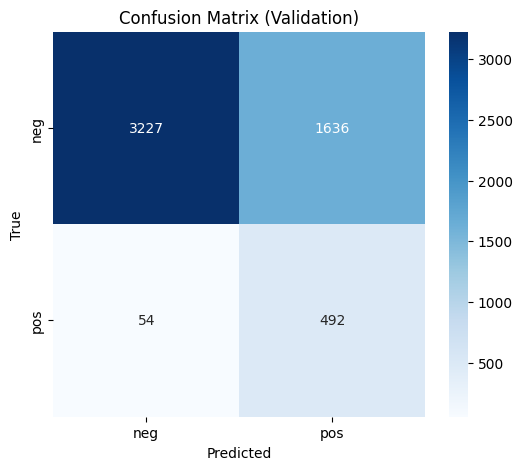

Test Evaluation:   0%|                                                       | 0/511 [00:00<?, ?it/s]

Test Evaluation:   0%|                                               | 1/511 [00:00<04:13,  2.01it/s]

Test Evaluation:   0%|▏                                              | 2/511 [00:00<04:07,  2.06it/s]

Test Evaluation:   1%|▎                                              | 3/511 [00:01<04:04,  2.07it/s]

Test Evaluation:   1%|▎                                              | 4/511 [00:01<04:04,  2.07it/s]

Test Evaluation:   1%|▍                                              | 5/511 [00:02<04:03,  2.07it/s]

Test Evaluation:   1%|▌                                              | 6/511 [00:02<03:55,  2.14it/s]

Test Evaluation:   1%|▋                                              | 7/511 [00:03<03:57,  2.12it/s]

Test Evaluation:   2%|▋                                              | 8/511 [00:03<04:00,  2.10it/s]

Test Evaluation:   2%|▊                                              | 9/511 [00:04<04:01,  2.08it/s]

Test Evaluation:   2%|▉                                             | 10/511 [00:04<03:52,  2.15it/s]

Test Evaluation:   2%|▉                                             | 11/511 [00:05<03:54,  2.13it/s]

Test Evaluation:   2%|█                                             | 12/511 [00:05<03:54,  2.13it/s]

Test Evaluation:   3%|█▏                                            | 13/511 [00:06<03:55,  2.11it/s]

Test Evaluation:   3%|█▎                                            | 14/511 [00:06<03:55,  2.11it/s]

Test Evaluation:   3%|█▎                                            | 15/511 [00:07<03:48,  2.17it/s]

Test Evaluation:   3%|█▍                                            | 16/511 [00:07<03:50,  2.15it/s]

Test Evaluation:   3%|█▌                                            | 17/511 [00:08<03:51,  2.13it/s]

Test Evaluation:   4%|█▌                                            | 18/511 [00:08<03:53,  2.12it/s]

Test Evaluation:   4%|█▋                                            | 19/511 [00:09<03:55,  2.09it/s]

Test Evaluation:   4%|█▊                                            | 20/511 [00:09<03:53,  2.10it/s]

Test Evaluation:   4%|█▉                                            | 21/511 [00:09<03:47,  2.15it/s]

Test Evaluation:   4%|█▉                                            | 22/511 [00:10<03:50,  2.12it/s]

Test Evaluation:   5%|██                                            | 23/511 [00:10<03:50,  2.12it/s]

Test Evaluation:   5%|██▏                                           | 24/511 [00:11<03:46,  2.15it/s]

Test Evaluation:   5%|██▎                                           | 25/511 [00:11<03:44,  2.17it/s]

Test Evaluation:   5%|██▎                                           | 26/511 [00:12<03:47,  2.13it/s]

Test Evaluation:   5%|██▍                                           | 27/511 [00:12<03:50,  2.10it/s]

Test Evaluation:   5%|██▌                                           | 28/511 [00:13<03:44,  2.15it/s]

Test Evaluation:   6%|██▌                                           | 29/511 [00:13<03:45,  2.14it/s]

Test Evaluation:   6%|██▋                                           | 30/511 [00:14<03:46,  2.12it/s]

Test Evaluation:   6%|██▊                                           | 31/511 [00:14<03:48,  2.10it/s]

Test Evaluation:   6%|██▉                                           | 32/511 [00:15<03:41,  2.16it/s]

Test Evaluation:   6%|██▉                                           | 33/511 [00:15<03:43,  2.14it/s]

Test Evaluation:   7%|███                                           | 34/511 [00:16<03:45,  2.11it/s]

Test Evaluation:   7%|███▏                                          | 35/511 [00:16<03:46,  2.10it/s]

Test Evaluation:   7%|███▏                                          | 36/511 [00:16<03:47,  2.09it/s]

Test Evaluation:   7%|███▎                                          | 37/511 [00:17<03:39,  2.16it/s]

Test Evaluation:   7%|███▍                                          | 38/511 [00:17<03:41,  2.13it/s]

Test Evaluation:   8%|███▌                                          | 39/511 [00:18<03:43,  2.11it/s]

Test Evaluation:   8%|███▌                                          | 40/511 [00:18<03:44,  2.10it/s]

Test Evaluation:   8%|███▋                                          | 41/511 [00:19<03:36,  2.17it/s]

Test Evaluation:   8%|███▊                                          | 42/511 [00:19<03:38,  2.14it/s]

Test Evaluation:   8%|███▊                                          | 43/511 [00:20<03:40,  2.12it/s]

Test Evaluation:   9%|███▉                                          | 44/511 [00:20<03:41,  2.10it/s]

Test Evaluation:   9%|████                                          | 45/511 [00:21<03:42,  2.09it/s]

Test Evaluation:   9%|████▏                                         | 46/511 [00:21<03:40,  2.10it/s]

Test Evaluation:   9%|████▏                                         | 47/511 [00:22<03:37,  2.13it/s]

Test Evaluation:   9%|████▎                                         | 48/511 [00:22<03:38,  2.11it/s]

Test Evaluation:  10%|████▍                                         | 49/511 [00:23<03:39,  2.10it/s]

Test Evaluation:  10%|████▌                                         | 50/511 [00:23<03:39,  2.10it/s]

Test Evaluation:  10%|████▌                                         | 51/511 [00:24<03:42,  2.06it/s]

Test Evaluation:  10%|████▋                                         | 52/511 [00:24<03:42,  2.06it/s]

Test Evaluation:  10%|████▊                                         | 53/511 [00:25<03:33,  2.14it/s]

Test Evaluation:  11%|████▊                                         | 54/511 [00:25<03:36,  2.11it/s]

Test Evaluation:  11%|████▉                                         | 55/511 [00:25<03:36,  2.10it/s]

Test Evaluation:  11%|█████                                         | 56/511 [00:26<03:37,  2.09it/s]

Test Evaluation:  11%|█████▏                                        | 57/511 [00:26<03:36,  2.10it/s]

Test Evaluation:  11%|█████▏                                        | 58/511 [00:27<03:38,  2.07it/s]

Test Evaluation:  12%|█████▎                                        | 59/511 [00:27<03:32,  2.13it/s]

Test Evaluation:  12%|█████▍                                        | 60/511 [00:28<03:33,  2.12it/s]

Test Evaluation:  12%|█████▍                                        | 61/511 [00:28<03:34,  2.10it/s]

Test Evaluation:  12%|█████▌                                        | 62/511 [00:29<03:34,  2.09it/s]

Test Evaluation:  12%|█████▋                                        | 63/511 [00:29<03:35,  2.08it/s]

Test Evaluation:  13%|█████▊                                        | 64/511 [00:30<03:34,  2.08it/s]

Test Evaluation:  13%|█████▊                                        | 65/511 [00:30<03:34,  2.08it/s]

Test Evaluation:  13%|█████▉                                        | 66/511 [00:31<03:35,  2.06it/s]

Test Evaluation:  13%|██████                                        | 67/511 [00:31<03:33,  2.08it/s]

Test Evaluation:  13%|██████                                        | 68/511 [00:32<03:33,  2.07it/s]

Test Evaluation:  14%|██████▏                                       | 69/511 [00:32<03:31,  2.09it/s]

Test Evaluation:  14%|██████▎                                       | 70/511 [00:33<03:31,  2.08it/s]

Test Evaluation:  14%|██████▍                                       | 71/511 [00:33<03:30,  2.09it/s]

Test Evaluation:  14%|██████▍                                       | 72/511 [00:34<03:30,  2.09it/s]

Test Evaluation:  14%|██████▌                                       | 73/511 [00:34<03:30,  2.08it/s]

Test Evaluation:  14%|██████▋                                       | 74/511 [00:35<03:31,  2.07it/s]

Test Evaluation:  15%|██████▊                                       | 75/511 [00:35<03:30,  2.07it/s]

Test Evaluation:  15%|██████▊                                       | 76/511 [00:36<03:29,  2.07it/s]

Test Evaluation:  15%|██████▉                                       | 77/511 [00:36<03:29,  2.08it/s]

Test Evaluation:  15%|███████                                       | 78/511 [00:37<03:28,  2.08it/s]

Test Evaluation:  15%|███████                                       | 79/511 [00:37<03:28,  2.08it/s]

Test Evaluation:  16%|███████▏                                      | 80/511 [00:37<03:26,  2.09it/s]

Test Evaluation:  16%|███████▎                                      | 81/511 [00:38<03:25,  2.09it/s]

Test Evaluation:  16%|███████▍                                      | 82/511 [00:38<03:27,  2.07it/s]

Test Evaluation:  16%|███████▍                                      | 83/511 [00:39<03:27,  2.06it/s]

Test Evaluation:  16%|███████▌                                      | 84/511 [00:39<03:26,  2.07it/s]

Test Evaluation:  17%|███████▋                                      | 85/511 [00:40<03:26,  2.06it/s]

Test Evaluation:  17%|███████▋                                      | 86/511 [00:40<03:25,  2.07it/s]

Test Evaluation:  17%|███████▊                                      | 87/511 [00:41<03:24,  2.07it/s]

Test Evaluation:  17%|███████▉                                      | 88/511 [00:41<03:24,  2.07it/s]

Test Evaluation:  17%|████████                                      | 89/511 [00:42<03:23,  2.07it/s]

Test Evaluation:  18%|████████                                      | 90/511 [00:42<03:23,  2.07it/s]

Test Evaluation:  18%|████████▏                                     | 91/511 [00:43<03:21,  2.08it/s]

Test Evaluation:  18%|████████▎                                     | 92/511 [00:43<03:21,  2.08it/s]

Test Evaluation:  18%|████████▎                                     | 93/511 [00:44<03:20,  2.08it/s]

Test Evaluation:  18%|████████▍                                     | 94/511 [00:44<03:21,  2.07it/s]

Test Evaluation:  19%|████████▌                                     | 95/511 [00:45<03:21,  2.07it/s]

Test Evaluation:  19%|████████▋                                     | 96/511 [00:45<03:22,  2.05it/s]

Test Evaluation:  19%|████████▋                                     | 97/511 [00:46<03:21,  2.05it/s]

Test Evaluation:  19%|████████▊                                     | 98/511 [00:46<03:22,  2.04it/s]

Test Evaluation:  19%|████████▉                                     | 99/511 [00:47<03:19,  2.06it/s]

Test Evaluation:  20%|████████▊                                    | 100/511 [00:47<03:14,  2.11it/s]

Test Evaluation:  20%|████████▉                                    | 101/511 [00:48<03:14,  2.11it/s]

Test Evaluation:  20%|████████▉                                    | 102/511 [00:48<03:15,  2.10it/s]

Test Evaluation:  20%|█████████                                    | 103/511 [00:49<03:15,  2.09it/s]

Test Evaluation:  20%|█████████▏                                   | 104/511 [00:49<03:15,  2.08it/s]

Test Evaluation:  21%|█████████▏                                   | 105/511 [00:50<03:15,  2.07it/s]

Test Evaluation:  21%|█████████▎                                   | 106/511 [00:50<03:15,  2.07it/s]

Test Evaluation:  21%|█████████▍                                   | 107/511 [00:51<03:14,  2.08it/s]

Test Evaluation:  21%|█████████▌                                   | 108/511 [00:51<03:14,  2.07it/s]

Test Evaluation:  21%|█████████▌                                   | 109/511 [00:51<03:13,  2.07it/s]

Test Evaluation:  22%|█████████▋                                   | 110/511 [00:52<03:15,  2.05it/s]

Test Evaluation:  22%|█████████▊                                   | 111/511 [00:52<03:14,  2.06it/s]

Test Evaluation:  22%|█████████▊                                   | 112/511 [00:53<03:12,  2.07it/s]

Test Evaluation:  22%|█████████▉                                   | 113/511 [00:53<03:13,  2.06it/s]

Test Evaluation:  22%|██████████                                   | 114/511 [00:54<03:12,  2.06it/s]

Test Evaluation:  23%|██████████▏                                  | 115/511 [00:54<03:12,  2.06it/s]

Test Evaluation:  23%|██████████▏                                  | 116/511 [00:55<03:12,  2.06it/s]

Test Evaluation:  23%|██████████▎                                  | 117/511 [00:55<03:10,  2.06it/s]

Test Evaluation:  23%|██████████▍                                  | 118/511 [00:56<03:10,  2.06it/s]

Test Evaluation:  23%|██████████▍                                  | 119/511 [00:56<03:03,  2.14it/s]

Test Evaluation:  23%|██████████▌                                  | 120/511 [00:57<03:04,  2.12it/s]

Test Evaluation:  24%|██████████▋                                  | 121/511 [00:57<03:04,  2.11it/s]

Test Evaluation:  24%|██████████▋                                  | 122/511 [00:58<03:04,  2.11it/s]

Test Evaluation:  24%|██████████▊                                  | 123/511 [00:58<03:04,  2.10it/s]

Test Evaluation:  24%|██████████▉                                  | 124/511 [00:59<03:05,  2.09it/s]

Test Evaluation:  24%|███████████                                  | 125/511 [00:59<03:04,  2.09it/s]

Test Evaluation:  25%|███████████                                  | 126/511 [01:00<03:04,  2.08it/s]

Test Evaluation:  25%|███████████▏                                 | 127/511 [01:00<03:05,  2.07it/s]

Test Evaluation:  25%|███████████▎                                 | 128/511 [01:01<03:04,  2.08it/s]

Test Evaluation:  25%|███████████▎                                 | 129/511 [01:01<03:04,  2.07it/s]

Test Evaluation:  25%|███████████▍                                 | 130/511 [01:02<03:03,  2.08it/s]

Test Evaluation:  26%|███████████▌                                 | 131/511 [01:02<03:03,  2.07it/s]

Test Evaluation:  26%|███████████▌                                 | 132/511 [01:03<03:02,  2.07it/s]

Test Evaluation:  26%|███████████▋                                 | 133/511 [01:03<03:02,  2.07it/s]

Test Evaluation:  26%|███████████▊                                 | 134/511 [01:04<03:01,  2.08it/s]

Test Evaluation:  26%|███████████▉                                 | 135/511 [01:04<03:00,  2.08it/s]

Test Evaluation:  27%|███████████▉                                 | 136/511 [01:04<03:00,  2.08it/s]

Test Evaluation:  27%|████████████                                 | 137/511 [01:05<02:59,  2.09it/s]

Test Evaluation:  27%|████████████▏                                | 138/511 [01:05<02:58,  2.09it/s]

Test Evaluation:  27%|████████████▏                                | 139/511 [01:06<02:59,  2.07it/s]

Test Evaluation:  27%|████████████▎                                | 140/511 [01:06<02:58,  2.08it/s]

Test Evaluation:  28%|████████████▍                                | 141/511 [01:07<02:58,  2.08it/s]

Test Evaluation:  28%|████████████▌                                | 142/511 [01:07<02:57,  2.08it/s]

Test Evaluation:  28%|████████████▌                                | 143/511 [01:08<02:56,  2.08it/s]

Test Evaluation:  28%|████████████▋                                | 144/511 [01:08<02:56,  2.08it/s]

Test Evaluation:  28%|████████████▊                                | 145/511 [01:09<02:56,  2.07it/s]

Test Evaluation:  29%|████████████▊                                | 146/511 [01:09<02:55,  2.08it/s]

Test Evaluation:  29%|████████████▉                                | 147/511 [01:10<02:55,  2.07it/s]

Test Evaluation:  29%|█████████████                                | 148/511 [01:10<02:54,  2.07it/s]

Test Evaluation:  29%|█████████████                                | 149/511 [01:11<02:54,  2.08it/s]

Test Evaluation:  29%|█████████████▏                               | 150/511 [01:11<02:53,  2.08it/s]

Test Evaluation:  30%|█████████████▎                               | 151/511 [01:12<02:53,  2.08it/s]

Test Evaluation:  30%|█████████████▍                               | 152/511 [01:12<02:53,  2.07it/s]

Test Evaluation:  30%|█████████████▍                               | 153/511 [01:13<02:53,  2.06it/s]

Test Evaluation:  30%|█████████████▌                               | 154/511 [01:13<02:52,  2.07it/s]

Test Evaluation:  30%|█████████████▋                               | 155/511 [01:14<02:51,  2.07it/s]

Test Evaluation:  31%|█████████████▋                               | 156/511 [01:14<02:52,  2.06it/s]

Test Evaluation:  31%|█████████████▊                               | 157/511 [01:15<02:51,  2.07it/s]

Test Evaluation:  31%|█████████████▉                               | 158/511 [01:15<02:50,  2.07it/s]

Test Evaluation:  31%|██████████████                               | 159/511 [01:16<02:44,  2.14it/s]

Test Evaluation:  31%|██████████████                               | 160/511 [01:16<02:46,  2.11it/s]

Test Evaluation:  32%|██████████████▏                              | 161/511 [01:16<02:47,  2.09it/s]

Test Evaluation:  32%|██████████████▎                              | 162/511 [01:17<02:47,  2.08it/s]

Test Evaluation:  32%|██████████████▎                              | 163/511 [01:17<02:47,  2.08it/s]

Test Evaluation:  32%|██████████████▍                              | 164/511 [01:18<02:45,  2.09it/s]

Test Evaluation:  32%|██████████████▌                              | 165/511 [01:18<02:46,  2.08it/s]

Test Evaluation:  32%|██████████████▌                              | 166/511 [01:19<02:45,  2.08it/s]

Test Evaluation:  33%|██████████████▋                              | 167/511 [01:19<02:45,  2.08it/s]

Test Evaluation:  33%|██████████████▊                              | 168/511 [01:20<02:44,  2.08it/s]

Test Evaluation:  33%|██████████████▉                              | 169/511 [01:20<02:44,  2.08it/s]

Test Evaluation:  33%|██████████████▉                              | 170/511 [01:21<02:43,  2.08it/s]

Test Evaluation:  33%|███████████████                              | 171/511 [01:21<02:42,  2.09it/s]

Test Evaluation:  34%|███████████████▏                             | 172/511 [01:22<02:42,  2.09it/s]

Test Evaluation:  34%|███████████████▏                             | 173/511 [01:22<02:43,  2.07it/s]

Test Evaluation:  34%|███████████████▎                             | 174/511 [01:23<02:42,  2.07it/s]

Test Evaluation:  34%|███████████████▍                             | 175/511 [01:23<02:41,  2.08it/s]

Test Evaluation:  34%|███████████████▍                             | 176/511 [01:24<02:42,  2.06it/s]

Test Evaluation:  35%|███████████████▌                             | 177/511 [01:24<02:39,  2.10it/s]

Test Evaluation:  35%|███████████████▋                             | 178/511 [01:25<02:37,  2.12it/s]

Test Evaluation:  35%|███████████████▊                             | 179/511 [01:25<02:37,  2.11it/s]

Test Evaluation:  35%|███████████████▊                             | 180/511 [01:26<02:37,  2.10it/s]

Test Evaluation:  35%|███████████████▉                             | 181/511 [01:26<02:38,  2.08it/s]

Test Evaluation:  36%|████████████████                             | 182/511 [01:27<02:39,  2.07it/s]

Test Evaluation:  36%|████████████████                             | 183/511 [01:27<02:39,  2.06it/s]

Test Evaluation:  36%|████████████████▏                            | 184/511 [01:28<02:39,  2.05it/s]

Test Evaluation:  36%|████████████████▎                            | 185/511 [01:28<02:37,  2.07it/s]

Test Evaluation:  36%|████████████████▍                            | 186/511 [01:29<02:37,  2.06it/s]

Test Evaluation:  37%|████████████████▍                            | 187/511 [01:29<02:36,  2.07it/s]

Test Evaluation:  37%|████████████████▌                            | 188/511 [01:29<02:35,  2.07it/s]

Test Evaluation:  37%|████████████████▋                            | 189/511 [01:30<02:35,  2.08it/s]

Test Evaluation:  37%|████████████████▋                            | 190/511 [01:30<02:35,  2.06it/s]

Test Evaluation:  37%|████████████████▊                            | 191/511 [01:31<02:34,  2.07it/s]

Test Evaluation:  38%|████████████████▉                            | 192/511 [01:31<02:38,  2.01it/s]

Test Evaluation:  38%|████████████████▉                            | 193/511 [01:32<02:36,  2.03it/s]

Test Evaluation:  38%|█████████████████                            | 194/511 [01:32<02:35,  2.04it/s]

Test Evaluation:  38%|█████████████████▏                           | 195/511 [01:33<02:33,  2.06it/s]

Test Evaluation:  38%|█████████████████▎                           | 196/511 [01:33<02:33,  2.05it/s]

Test Evaluation:  39%|█████████████████▎                           | 197/511 [01:34<02:32,  2.06it/s]

Test Evaluation:  39%|█████████████████▍                           | 198/511 [01:34<02:32,  2.06it/s]

Test Evaluation:  39%|█████████████████▌                           | 199/511 [01:35<02:31,  2.06it/s]

Test Evaluation:  39%|█████████████████▌                           | 200/511 [01:35<02:30,  2.07it/s]

Test Evaluation:  39%|█████████████████▋                           | 201/511 [01:36<02:30,  2.07it/s]

Test Evaluation:  40%|█████████████████▊                           | 202/511 [01:36<02:30,  2.06it/s]

Test Evaluation:  40%|█████████████████▉                           | 203/511 [01:37<02:29,  2.06it/s]

Test Evaluation:  40%|█████████████████▉                           | 204/511 [01:37<02:28,  2.06it/s]

Test Evaluation:  40%|██████████████████                           | 205/511 [01:38<02:27,  2.08it/s]

Test Evaluation:  40%|██████████████████▏                          | 206/511 [01:38<02:26,  2.08it/s]

Test Evaluation:  41%|██████████████████▏                          | 207/511 [01:39<02:22,  2.13it/s]

Test Evaluation:  41%|██████████████████▎                          | 208/511 [01:39<02:22,  2.12it/s]

Test Evaluation:  41%|██████████████████▍                          | 209/511 [01:40<02:23,  2.11it/s]

Test Evaluation:  41%|██████████████████▍                          | 210/511 [01:40<02:23,  2.10it/s]

Test Evaluation:  41%|██████████████████▌                          | 211/511 [01:41<02:24,  2.08it/s]

Test Evaluation:  41%|██████████████████▋                          | 212/511 [01:41<02:24,  2.07it/s]

Test Evaluation:  42%|██████████████████▊                          | 213/511 [01:42<02:23,  2.08it/s]

Test Evaluation:  42%|██████████████████▊                          | 214/511 [01:42<02:22,  2.08it/s]

Test Evaluation:  42%|██████████████████▉                          | 215/511 [01:43<02:22,  2.08it/s]

Test Evaluation:  42%|███████████████████                          | 216/511 [01:43<02:22,  2.08it/s]

Test Evaluation:  42%|███████████████████                          | 217/511 [01:43<02:22,  2.07it/s]

Test Evaluation:  43%|███████████████████▏                         | 218/511 [01:44<02:23,  2.05it/s]

Test Evaluation:  43%|███████████████████▎                         | 219/511 [01:44<02:22,  2.05it/s]

Test Evaluation:  43%|███████████████████▎                         | 220/511 [01:45<02:22,  2.05it/s]

Test Evaluation:  43%|███████████████████▍                         | 221/511 [01:45<02:21,  2.05it/s]

Test Evaluation:  43%|███████████████████▌                         | 222/511 [01:46<02:20,  2.06it/s]

Test Evaluation:  44%|███████████████████▋                         | 223/511 [01:46<02:19,  2.06it/s]

Test Evaluation:  44%|███████████████████▋                         | 224/511 [01:47<02:19,  2.06it/s]

Test Evaluation:  44%|███████████████████▊                         | 225/511 [01:47<02:18,  2.06it/s]

Test Evaluation:  44%|███████████████████▉                         | 226/511 [01:48<02:17,  2.07it/s]

Test Evaluation:  44%|███████████████████▉                         | 227/511 [01:48<02:17,  2.06it/s]

Test Evaluation:  45%|████████████████████                         | 228/511 [01:49<02:18,  2.05it/s]

Test Evaluation:  45%|████████████████████▏                        | 229/511 [01:49<02:16,  2.06it/s]

Test Evaluation:  45%|████████████████████▎                        | 230/511 [01:50<02:15,  2.07it/s]

Test Evaluation:  45%|████████████████████▎                        | 231/511 [01:50<02:15,  2.06it/s]

Test Evaluation:  45%|████████████████████▍                        | 232/511 [01:51<02:15,  2.06it/s]

Test Evaluation:  46%|████████████████████▌                        | 233/511 [01:51<02:14,  2.07it/s]

Test Evaluation:  46%|████████████████████▌                        | 234/511 [01:52<02:14,  2.06it/s]

Test Evaluation:  46%|████████████████████▋                        | 235/511 [01:52<02:14,  2.05it/s]

Test Evaluation:  46%|████████████████████▊                        | 236/511 [01:53<02:14,  2.04it/s]

Test Evaluation:  46%|████████████████████▊                        | 237/511 [01:53<02:13,  2.05it/s]

Test Evaluation:  47%|████████████████████▉                        | 238/511 [01:54<02:12,  2.06it/s]

Test Evaluation:  47%|█████████████████████                        | 239/511 [01:54<02:11,  2.07it/s]

Test Evaluation:  47%|█████████████████████▏                       | 240/511 [01:55<02:11,  2.06it/s]

Test Evaluation:  47%|█████████████████████▏                       | 241/511 [01:55<02:10,  2.07it/s]

Test Evaluation:  47%|█████████████████████▎                       | 242/511 [01:56<02:09,  2.07it/s]

Test Evaluation:  48%|█████████████████████▍                       | 243/511 [01:56<02:08,  2.08it/s]

Test Evaluation:  48%|█████████████████████▍                       | 244/511 [01:57<02:08,  2.07it/s]

Test Evaluation:  48%|█████████████████████▌                       | 245/511 [01:57<02:06,  2.10it/s]

Test Evaluation:  48%|█████████████████████▋                       | 246/511 [01:58<02:03,  2.14it/s]

Test Evaluation:  48%|█████████████████████▊                       | 247/511 [01:58<02:04,  2.12it/s]

Test Evaluation:  49%|█████████████████████▊                       | 248/511 [01:58<02:04,  2.11it/s]

Test Evaluation:  49%|█████████████████████▉                       | 249/511 [01:59<02:05,  2.09it/s]

Test Evaluation:  49%|██████████████████████                       | 250/511 [01:59<02:04,  2.09it/s]

Test Evaluation:  49%|██████████████████████                       | 251/511 [02:00<02:04,  2.08it/s]

Test Evaluation:  49%|██████████████████████▏                      | 252/511 [02:00<02:05,  2.07it/s]

Test Evaluation:  50%|██████████████████████▎                      | 253/511 [02:01<02:04,  2.08it/s]

Test Evaluation:  50%|██████████████████████▎                      | 254/511 [02:01<02:03,  2.07it/s]

Test Evaluation:  50%|██████████████████████▍                      | 255/511 [02:02<02:03,  2.07it/s]

Test Evaluation:  50%|██████████████████████▌                      | 256/511 [02:02<02:03,  2.07it/s]

Test Evaluation:  50%|██████████████████████▋                      | 257/511 [02:03<02:02,  2.08it/s]

Test Evaluation:  50%|██████████████████████▋                      | 258/511 [02:03<02:01,  2.08it/s]

Test Evaluation:  51%|██████████████████████▊                      | 259/511 [02:04<02:01,  2.08it/s]

Test Evaluation:  51%|██████████████████████▉                      | 260/511 [02:04<02:00,  2.08it/s]

Test Evaluation:  51%|██████████████████████▉                      | 261/511 [02:05<02:01,  2.06it/s]

Test Evaluation:  51%|███████████████████████                      | 262/511 [02:05<02:00,  2.06it/s]

Test Evaluation:  51%|███████████████████████▏                     | 263/511 [02:06<02:00,  2.06it/s]

Test Evaluation:  52%|███████████████████████▏                     | 264/511 [02:06<01:59,  2.07it/s]

Test Evaluation:  52%|███████████████████████▎                     | 265/511 [02:07<01:58,  2.08it/s]

Test Evaluation:  52%|███████████████████████▍                     | 266/511 [02:07<01:57,  2.08it/s]

Test Evaluation:  52%|███████████████████████▌                     | 267/511 [02:08<01:57,  2.07it/s]

Test Evaluation:  52%|███████████████████████▌                     | 268/511 [02:08<01:57,  2.07it/s]

Test Evaluation:  53%|███████████████████████▋                     | 269/511 [02:09<01:56,  2.08it/s]

Test Evaluation:  53%|███████████████████████▊                     | 270/511 [02:09<01:55,  2.08it/s]

Test Evaluation:  53%|███████████████████████▊                     | 271/511 [02:10<01:55,  2.08it/s]

Test Evaluation:  53%|███████████████████████▉                     | 272/511 [02:10<01:55,  2.08it/s]

Test Evaluation:  53%|████████████████████████                     | 273/511 [02:11<01:54,  2.08it/s]

Test Evaluation:  54%|████████████████████████▏                    | 274/511 [02:11<01:50,  2.14it/s]

Test Evaluation:  54%|████████████████████████▏                    | 275/511 [02:11<01:51,  2.11it/s]

Test Evaluation:  54%|████████████████████████▎                    | 276/511 [02:12<01:51,  2.10it/s]

Test Evaluation:  54%|████████████████████████▍                    | 277/511 [02:12<01:51,  2.09it/s]

Test Evaluation:  54%|████████████████████████▍                    | 278/511 [02:13<01:52,  2.08it/s]

Test Evaluation:  55%|████████████████████████▌                    | 279/511 [02:13<01:51,  2.07it/s]

Test Evaluation:  55%|████████████████████████▋                    | 280/511 [02:14<01:51,  2.07it/s]

Test Evaluation:  55%|████████████████████████▋                    | 281/511 [02:14<01:50,  2.08it/s]

Test Evaluation:  55%|████████████████████████▊                    | 282/511 [02:15<01:50,  2.08it/s]

Test Evaluation:  55%|████████████████████████▉                    | 283/511 [02:15<01:49,  2.08it/s]

Test Evaluation:  56%|█████████████████████████                    | 284/511 [02:16<01:49,  2.07it/s]

Test Evaluation:  56%|█████████████████████████                    | 285/511 [02:16<01:48,  2.08it/s]

Test Evaluation:  56%|█████████████████████████▏                   | 286/511 [02:17<01:48,  2.08it/s]

Test Evaluation:  56%|█████████████████████████▎                   | 287/511 [02:17<01:47,  2.09it/s]

Test Evaluation:  56%|█████████████████████████▎                   | 288/511 [02:18<01:47,  2.08it/s]

Test Evaluation:  57%|█████████████████████████▍                   | 289/511 [02:18<01:46,  2.08it/s]

Test Evaluation:  57%|█████████████████████████▌                   | 290/511 [02:19<01:46,  2.07it/s]

Test Evaluation:  57%|█████████████████████████▋                   | 291/511 [02:19<01:46,  2.06it/s]

Test Evaluation:  57%|█████████████████████████▋                   | 292/511 [02:20<01:46,  2.06it/s]

Test Evaluation:  57%|█████████████████████████▊                   | 293/511 [02:20<01:45,  2.06it/s]

Test Evaluation:  58%|█████████████████████████▉                   | 294/511 [02:21<01:45,  2.06it/s]

Test Evaluation:  58%|█████████████████████████▉                   | 295/511 [02:21<01:44,  2.06it/s]

Test Evaluation:  58%|██████████████████████████                   | 296/511 [02:22<01:43,  2.07it/s]

Test Evaluation:  58%|██████████████████████████▏                  | 297/511 [02:22<01:43,  2.07it/s]

Test Evaluation:  58%|██████████████████████████▏                  | 298/511 [02:23<01:42,  2.08it/s]

Test Evaluation:  59%|██████████████████████████▎                  | 299/511 [02:23<01:42,  2.06it/s]

Test Evaluation:  59%|██████████████████████████▍                  | 300/511 [02:24<01:45,  2.01it/s]

Test Evaluation:  59%|██████████████████████████▌                  | 301/511 [02:24<01:43,  2.02it/s]

Test Evaluation:  59%|██████████████████████████▌                  | 302/511 [02:25<01:42,  2.05it/s]

Test Evaluation:  59%|██████████████████████████▋                  | 303/511 [02:25<01:41,  2.05it/s]

Test Evaluation:  59%|██████████████████████████▊                  | 304/511 [02:25<01:40,  2.06it/s]

Test Evaluation:  60%|██████████████████████████▊                  | 305/511 [02:26<01:40,  2.06it/s]

Test Evaluation:  60%|██████████████████████████▉                  | 306/511 [02:26<01:39,  2.06it/s]

Test Evaluation:  60%|███████████████████████████                  | 307/511 [02:27<01:39,  2.05it/s]

Test Evaluation:  60%|███████████████████████████                  | 308/511 [02:27<01:38,  2.07it/s]

Test Evaluation:  60%|███████████████████████████▏                 | 309/511 [02:28<01:37,  2.06it/s]

Test Evaluation:  61%|███████████████████████████▎                 | 310/511 [02:28<01:37,  2.07it/s]

Test Evaluation:  61%|███████████████████████████▍                 | 311/511 [02:29<01:34,  2.12it/s]

Test Evaluation:  61%|███████████████████████████▍                 | 312/511 [02:29<01:33,  2.13it/s]

Test Evaluation:  61%|███████████████████████████▌                 | 313/511 [02:30<01:33,  2.13it/s]

Test Evaluation:  61%|███████████████████████████▋                 | 314/511 [02:30<01:33,  2.11it/s]

Test Evaluation:  62%|███████████████████████████▋                 | 315/511 [02:31<01:33,  2.10it/s]

Test Evaluation:  62%|███████████████████████████▊                 | 316/511 [02:31<01:32,  2.10it/s]

Test Evaluation:  62%|███████████████████████████▉                 | 317/511 [02:32<01:32,  2.09it/s]

Test Evaluation:  62%|████████████████████████████                 | 318/511 [02:32<01:32,  2.09it/s]

Test Evaluation:  62%|████████████████████████████                 | 319/511 [02:33<01:32,  2.08it/s]

Test Evaluation:  63%|████████████████████████████▏                | 320/511 [02:33<01:31,  2.08it/s]

Test Evaluation:  63%|████████████████████████████▎                | 321/511 [02:34<01:31,  2.09it/s]

Test Evaluation:  63%|████████████████████████████▎                | 322/511 [02:34<01:30,  2.09it/s]

Test Evaluation:  63%|████████████████████████████▍                | 323/511 [02:35<01:30,  2.08it/s]

Test Evaluation:  63%|████████████████████████████▌                | 324/511 [02:35<01:29,  2.08it/s]

Test Evaluation:  64%|████████████████████████████▌                | 325/511 [02:36<01:29,  2.08it/s]

Test Evaluation:  64%|████████████████████████████▋                | 326/511 [02:36<01:28,  2.08it/s]

Test Evaluation:  64%|████████████████████████████▊                | 327/511 [02:37<01:28,  2.08it/s]

Test Evaluation:  64%|████████████████████████████▉                | 328/511 [02:37<01:28,  2.06it/s]

Test Evaluation:  64%|████████████████████████████▉                | 329/511 [02:37<01:27,  2.07it/s]

Test Evaluation:  65%|█████████████████████████████                | 330/511 [02:38<01:27,  2.07it/s]

Test Evaluation:  65%|█████████████████████████████▏               | 331/511 [02:38<01:26,  2.07it/s]

Test Evaluation:  65%|█████████████████████████████▏               | 332/511 [02:39<01:26,  2.07it/s]

Test Evaluation:  65%|█████████████████████████████▎               | 333/511 [02:39<01:26,  2.06it/s]

Test Evaluation:  65%|█████████████████████████████▍               | 334/511 [02:40<01:25,  2.06it/s]

Test Evaluation:  66%|█████████████████████████████▌               | 335/511 [02:40<01:25,  2.06it/s]

Test Evaluation:  66%|█████████████████████████████▌               | 336/511 [02:41<01:25,  2.06it/s]

Test Evaluation:  66%|█████████████████████████████▋               | 337/511 [02:41<01:24,  2.07it/s]

Test Evaluation:  66%|█████████████████████████████▊               | 338/511 [02:42<01:24,  2.05it/s]

Test Evaluation:  66%|█████████████████████████████▊               | 339/511 [02:42<01:21,  2.12it/s]

Test Evaluation:  67%|█████████████████████████████▉               | 340/511 [02:43<01:20,  2.11it/s]

Test Evaluation:  67%|██████████████████████████████               | 341/511 [02:43<01:21,  2.10it/s]

Test Evaluation:  67%|██████████████████████████████               | 342/511 [02:44<01:20,  2.10it/s]

Test Evaluation:  67%|██████████████████████████████▏              | 343/511 [02:44<01:20,  2.09it/s]

Test Evaluation:  67%|██████████████████████████████▎              | 344/511 [02:45<01:19,  2.09it/s]

Test Evaluation:  68%|██████████████████████████████▍              | 345/511 [02:45<01:19,  2.10it/s]

Test Evaluation:  68%|██████████████████████████████▍              | 346/511 [02:46<01:19,  2.09it/s]

Test Evaluation:  68%|██████████████████████████████▌              | 347/511 [02:46<01:18,  2.09it/s]

Test Evaluation:  68%|██████████████████████████████▋              | 348/511 [02:47<01:18,  2.08it/s]

Test Evaluation:  68%|██████████████████████████████▋              | 349/511 [02:47<01:17,  2.08it/s]

Test Evaluation:  68%|██████████████████████████████▊              | 350/511 [02:48<01:17,  2.09it/s]

Test Evaluation:  69%|██████████████████████████████▉              | 351/511 [02:48<01:16,  2.08it/s]

Test Evaluation:  69%|██████████████████████████████▉              | 352/511 [02:49<01:16,  2.08it/s]

Test Evaluation:  69%|███████████████████████████████              | 353/511 [02:49<01:16,  2.06it/s]

Test Evaluation:  69%|███████████████████████████████▏             | 354/511 [02:50<01:16,  2.06it/s]

Test Evaluation:  69%|███████████████████████████████▎             | 355/511 [02:50<01:15,  2.07it/s]

Test Evaluation:  70%|███████████████████████████████▎             | 356/511 [02:50<01:15,  2.06it/s]

Test Evaluation:  70%|███████████████████████████████▍             | 357/511 [02:51<01:14,  2.07it/s]

Test Evaluation:  70%|███████████████████████████████▌             | 358/511 [02:51<01:13,  2.07it/s]

Test Evaluation:  70%|███████████████████████████████▌             | 359/511 [02:52<01:13,  2.06it/s]

Test Evaluation:  70%|███████████████████████████████▋             | 360/511 [02:52<01:13,  2.06it/s]

Test Evaluation:  71%|███████████████████████████████▊             | 361/511 [02:53<01:12,  2.06it/s]

Test Evaluation:  71%|███████████████████████████████▉             | 362/511 [02:53<01:12,  2.04it/s]

Test Evaluation:  71%|███████████████████████████████▉             | 363/511 [02:54<01:11,  2.06it/s]

Test Evaluation:  71%|████████████████████████████████             | 364/511 [02:54<01:10,  2.08it/s]

Test Evaluation:  71%|████████████████████████████████▏            | 365/511 [02:55<01:08,  2.13it/s]

Test Evaluation:  72%|████████████████████████████████▏            | 366/511 [02:55<01:08,  2.11it/s]

Test Evaluation:  72%|████████████████████████████████▎            | 367/511 [02:56<01:08,  2.10it/s]

Test Evaluation:  72%|████████████████████████████████▍            | 368/511 [02:56<01:08,  2.08it/s]

Test Evaluation:  72%|████████████████████████████████▍            | 369/511 [02:57<01:08,  2.07it/s]

Test Evaluation:  72%|████████████████████████████████▌            | 370/511 [02:57<01:08,  2.07it/s]

Test Evaluation:  73%|████████████████████████████████▋            | 371/511 [02:58<01:07,  2.08it/s]

Test Evaluation:  73%|████████████████████████████████▊            | 372/511 [02:58<01:07,  2.07it/s]

Test Evaluation:  73%|████████████████████████████████▊            | 373/511 [02:59<01:06,  2.07it/s]

Test Evaluation:  73%|████████████████████████████████▉            | 374/511 [02:59<01:06,  2.07it/s]

Test Evaluation:  73%|█████████████████████████████████            | 375/511 [03:00<01:06,  2.06it/s]

Test Evaluation:  74%|█████████████████████████████████            | 376/511 [03:00<01:05,  2.05it/s]

Test Evaluation:  74%|█████████████████████████████████▏           | 377/511 [03:01<01:05,  2.05it/s]

Test Evaluation:  74%|█████████████████████████████████▎           | 378/511 [03:01<01:04,  2.06it/s]

Test Evaluation:  74%|█████████████████████████████████▍           | 379/511 [03:02<01:04,  2.06it/s]

Test Evaluation:  74%|█████████████████████████████████▍           | 380/511 [03:02<01:03,  2.06it/s]

Test Evaluation:  75%|█████████████████████████████████▌           | 381/511 [03:03<01:02,  2.07it/s]

Test Evaluation:  75%|█████████████████████████████████▋           | 382/511 [03:03<01:02,  2.06it/s]

Test Evaluation:  75%|█████████████████████████████████▋           | 383/511 [03:04<01:02,  2.06it/s]

Test Evaluation:  75%|█████████████████████████████████▊           | 384/511 [03:04<01:01,  2.06it/s]

Test Evaluation:  75%|█████████████████████████████████▉           | 385/511 [03:04<01:00,  2.07it/s]

Test Evaluation:  76%|█████████████████████████████████▉           | 386/511 [03:05<01:00,  2.06it/s]

Test Evaluation:  76%|██████████████████████████████████           | 387/511 [03:05<00:59,  2.07it/s]

Test Evaluation:  76%|██████████████████████████████████▏          | 388/511 [03:06<00:59,  2.07it/s]

Test Evaluation:  76%|██████████████████████████████████▎          | 389/511 [03:06<00:59,  2.05it/s]

Test Evaluation:  76%|██████████████████████████████████▎          | 390/511 [03:07<00:58,  2.06it/s]

Test Evaluation:  77%|██████████████████████████████████▍          | 391/511 [03:07<00:58,  2.06it/s]

Test Evaluation:  77%|██████████████████████████████████▌          | 392/511 [03:08<00:57,  2.08it/s]

Test Evaluation:  77%|██████████████████████████████████▌          | 393/511 [03:08<00:57,  2.07it/s]

Test Evaluation:  77%|██████████████████████████████████▋          | 394/511 [03:09<00:56,  2.07it/s]

Test Evaluation:  77%|██████████████████████████████████▊          | 395/511 [03:09<00:55,  2.07it/s]

Test Evaluation:  77%|██████████████████████████████████▊          | 396/511 [03:10<00:55,  2.07it/s]

Test Evaluation:  78%|██████████████████████████████████▉          | 397/511 [03:10<00:55,  2.07it/s]

Test Evaluation:  78%|███████████████████████████████████          | 398/511 [03:11<00:54,  2.07it/s]

Test Evaluation:  78%|███████████████████████████████████▏         | 399/511 [03:11<00:54,  2.07it/s]

Test Evaluation:  78%|███████████████████████████████████▏         | 400/511 [03:12<00:53,  2.06it/s]

Test Evaluation:  78%|███████████████████████████████████▎         | 401/511 [03:12<00:53,  2.05it/s]

Test Evaluation:  79%|███████████████████████████████████▍         | 402/511 [03:13<00:53,  2.05it/s]

Test Evaluation:  79%|███████████████████████████████████▍         | 403/511 [03:13<00:52,  2.05it/s]

Test Evaluation:  79%|███████████████████████████████████▌         | 404/511 [03:14<00:52,  2.05it/s]

Test Evaluation:  79%|███████████████████████████████████▋         | 405/511 [03:14<00:51,  2.06it/s]

Test Evaluation:  79%|███████████████████████████████████▊         | 406/511 [03:15<00:50,  2.06it/s]

Test Evaluation:  80%|███████████████████████████████████▊         | 407/511 [03:15<00:50,  2.06it/s]

Test Evaluation:  80%|███████████████████████████████████▉         | 408/511 [03:16<00:50,  2.05it/s]

Test Evaluation:  80%|████████████████████████████████████         | 409/511 [03:16<00:49,  2.05it/s]

Test Evaluation:  80%|████████████████████████████████████         | 410/511 [03:17<00:47,  2.13it/s]

Test Evaluation:  80%|████████████████████████████████████▏        | 411/511 [03:17<00:47,  2.10it/s]

Test Evaluation:  81%|████████████████████████████████████▎        | 412/511 [03:18<00:47,  2.10it/s]

Test Evaluation:  81%|████████████████████████████████████▎        | 413/511 [03:18<00:47,  2.08it/s]

Test Evaluation:  81%|████████████████████████████████████▍        | 414/511 [03:19<00:46,  2.08it/s]

Test Evaluation:  81%|████████████████████████████████████▌        | 415/511 [03:19<00:46,  2.07it/s]

Test Evaluation:  81%|████████████████████████████████████▋        | 416/511 [03:19<00:46,  2.06it/s]

Test Evaluation:  82%|████████████████████████████████████▋        | 417/511 [03:20<00:45,  2.06it/s]

Test Evaluation:  82%|████████████████████████████████████▊        | 418/511 [03:20<00:45,  2.06it/s]

Test Evaluation:  82%|████████████████████████████████████▉        | 419/511 [03:21<00:44,  2.05it/s]

Test Evaluation:  82%|████████████████████████████████████▉        | 420/511 [03:21<00:44,  2.06it/s]

Test Evaluation:  82%|█████████████████████████████████████        | 421/511 [03:22<00:44,  2.04it/s]

Test Evaluation:  83%|█████████████████████████████████████▏       | 422/511 [03:22<00:43,  2.05it/s]

Test Evaluation:  83%|█████████████████████████████████████▎       | 423/511 [03:23<00:42,  2.05it/s]

Test Evaluation:  83%|█████████████████████████████████████▎       | 424/511 [03:23<00:42,  2.05it/s]

Test Evaluation:  83%|█████████████████████████████████████▍       | 425/511 [03:24<00:41,  2.06it/s]

Test Evaluation:  83%|█████████████████████████████████████▌       | 426/511 [03:24<00:41,  2.07it/s]

Test Evaluation:  84%|█████████████████████████████████████▌       | 427/511 [03:25<00:40,  2.06it/s]

Test Evaluation:  84%|█████████████████████████████████████▋       | 428/511 [03:25<00:40,  2.05it/s]

Test Evaluation:  84%|█████████████████████████████████████▊       | 429/511 [03:26<00:39,  2.05it/s]

Test Evaluation:  84%|█████████████████████████████████████▊       | 430/511 [03:26<00:39,  2.06it/s]

Test Evaluation:  84%|█████████████████████████████████████▉       | 431/511 [03:27<00:39,  2.05it/s]

Test Evaluation:  85%|██████████████████████████████████████       | 432/511 [03:27<00:38,  2.06it/s]

Test Evaluation:  85%|██████████████████████████████████████▏      | 433/511 [03:28<00:38,  2.05it/s]

Test Evaluation:  85%|██████████████████████████████████████▏      | 434/511 [03:28<00:36,  2.13it/s]

Test Evaluation:  85%|██████████████████████████████████████▎      | 435/511 [03:29<00:36,  2.11it/s]

Test Evaluation:  85%|██████████████████████████████████████▍      | 436/511 [03:29<00:35,  2.09it/s]

Test Evaluation:  86%|██████████████████████████████████████▍      | 437/511 [03:30<00:35,  2.09it/s]

Test Evaluation:  86%|██████████████████████████████████████▌      | 438/511 [03:30<00:35,  2.07it/s]

Test Evaluation:  86%|██████████████████████████████████████▋      | 439/511 [03:31<00:34,  2.08it/s]

Test Evaluation:  86%|██████████████████████████████████████▋      | 440/511 [03:31<00:34,  2.08it/s]

Test Evaluation:  86%|██████████████████████████████████████▊      | 441/511 [03:32<00:34,  2.05it/s]

Test Evaluation:  86%|██████████████████████████████████████▉      | 442/511 [03:32<00:33,  2.06it/s]

Test Evaluation:  87%|███████████████████████████████████████      | 443/511 [03:33<00:33,  2.05it/s]

Test Evaluation:  87%|███████████████████████████████████████      | 444/511 [03:33<00:32,  2.04it/s]

Test Evaluation:  87%|███████████████████████████████████████▏     | 445/511 [03:34<00:32,  2.06it/s]

Test Evaluation:  87%|███████████████████████████████████████▎     | 446/511 [03:34<00:31,  2.05it/s]

Test Evaluation:  87%|███████████████████████████████████████▎     | 447/511 [03:35<00:31,  2.05it/s]

Test Evaluation:  88%|███████████████████████████████████████▍     | 448/511 [03:35<00:30,  2.05it/s]

Test Evaluation:  88%|███████████████████████████████████████▌     | 449/511 [03:36<00:30,  2.05it/s]

Test Evaluation:  88%|███████████████████████████████████████▋     | 450/511 [03:36<00:29,  2.05it/s]

Test Evaluation:  88%|███████████████████████████████████████▋     | 451/511 [03:36<00:29,  2.06it/s]

Test Evaluation:  88%|███████████████████████████████████████▊     | 452/511 [03:37<00:28,  2.05it/s]

Test Evaluation:  89%|███████████████████████████████████████▉     | 453/511 [03:37<00:28,  2.05it/s]

Test Evaluation:  89%|███████████████████████████████████████▉     | 454/511 [03:38<00:27,  2.06it/s]

Test Evaluation:  89%|████████████████████████████████████████     | 455/511 [03:38<00:27,  2.05it/s]

Test Evaluation:  89%|████████████████████████████████████████▏    | 456/511 [03:39<00:26,  2.05it/s]

Test Evaluation:  89%|████████████████████████████████████████▏    | 457/511 [03:39<00:26,  2.05it/s]

Test Evaluation:  90%|████████████████████████████████████████▎    | 458/511 [03:40<00:25,  2.04it/s]

Test Evaluation:  90%|████████████████████████████████████████▍    | 459/511 [03:40<00:25,  2.05it/s]

Test Evaluation:  90%|████████████████████████████████████████▌    | 460/511 [03:41<00:24,  2.05it/s]

Test Evaluation:  90%|████████████████████████████████████████▌    | 461/511 [03:41<00:24,  2.06it/s]

Test Evaluation:  90%|████████████████████████████████████████▋    | 462/511 [03:42<00:23,  2.06it/s]

Test Evaluation:  91%|████████████████████████████████████████▊    | 463/511 [03:42<00:22,  2.14it/s]

Test Evaluation:  91%|████████████████████████████████████████▊    | 464/511 [03:43<00:22,  2.11it/s]

Test Evaluation:  91%|████████████████████████████████████████▉    | 465/511 [03:43<00:21,  2.09it/s]

Test Evaluation:  91%|█████████████████████████████████████████    | 466/511 [03:44<00:21,  2.09it/s]

Test Evaluation:  91%|█████████████████████████████████████████▏   | 467/511 [03:44<00:21,  2.07it/s]

Test Evaluation:  92%|█████████████████████████████████████████▏   | 468/511 [03:45<00:20,  2.07it/s]

Test Evaluation:  92%|█████████████████████████████████████████▎   | 469/511 [03:45<00:20,  2.07it/s]

Test Evaluation:  92%|█████████████████████████████████████████▍   | 470/511 [03:46<00:19,  2.07it/s]

Test Evaluation:  92%|█████████████████████████████████████████▍   | 471/511 [03:46<00:19,  2.07it/s]

Test Evaluation:  92%|█████████████████████████████████████████▌   | 472/511 [03:47<00:18,  2.07it/s]

Test Evaluation:  93%|█████████████████████████████████████████▋   | 473/511 [03:47<00:18,  2.07it/s]

Test Evaluation:  93%|█████████████████████████████████████████▋   | 474/511 [03:48<00:17,  2.07it/s]

Test Evaluation:  93%|█████████████████████████████████████████▊   | 475/511 [03:48<00:17,  2.07it/s]

Test Evaluation:  93%|█████████████████████████████████████████▉   | 476/511 [03:49<00:16,  2.07it/s]

Test Evaluation:  93%|██████████████████████████████████████████   | 477/511 [03:49<00:16,  2.07it/s]

Test Evaluation:  94%|██████████████████████████████████████████   | 478/511 [03:50<00:15,  2.07it/s]

Test Evaluation:  94%|██████████████████████████████████████████▏  | 479/511 [03:50<00:15,  2.06it/s]

Test Evaluation:  94%|██████████████████████████████████████████▎  | 480/511 [03:50<00:15,  2.06it/s]

Test Evaluation:  94%|██████████████████████████████████████████▎  | 481/511 [03:51<00:14,  2.06it/s]

Test Evaluation:  94%|██████████████████████████████████████████▍  | 482/511 [03:51<00:13,  2.12it/s]

Test Evaluation:  95%|██████████████████████████████████████████▌  | 483/511 [03:52<00:13,  2.12it/s]

Test Evaluation:  95%|██████████████████████████████████████████▌  | 484/511 [03:52<00:12,  2.10it/s]

Test Evaluation:  95%|██████████████████████████████████████████▋  | 485/511 [03:53<00:12,  2.09it/s]

Test Evaluation:  95%|██████████████████████████████████████████▊  | 486/511 [03:53<00:12,  2.07it/s]

Test Evaluation:  95%|██████████████████████████████████████████▉  | 487/511 [03:54<00:11,  2.06it/s]

Test Evaluation:  95%|██████████████████████████████████████████▉  | 488/511 [03:54<00:11,  2.07it/s]

Test Evaluation:  96%|███████████████████████████████████████████  | 489/511 [03:55<00:10,  2.07it/s]

Test Evaluation:  96%|███████████████████████████████████████████▏ | 490/511 [03:55<00:10,  2.07it/s]

Test Evaluation:  96%|███████████████████████████████████████████▏ | 491/511 [03:56<00:09,  2.07it/s]

Test Evaluation:  96%|███████████████████████████████████████████▎ | 492/511 [03:56<00:09,  2.07it/s]

Test Evaluation:  96%|███████████████████████████████████████████▍ | 493/511 [03:57<00:08,  2.07it/s]

Test Evaluation:  97%|███████████████████████████████████████████▌ | 494/511 [03:57<00:08,  2.07it/s]

Test Evaluation:  97%|███████████████████████████████████████████▌ | 495/511 [03:58<00:07,  2.06it/s]

Test Evaluation:  97%|███████████████████████████████████████████▋ | 496/511 [03:58<00:07,  2.05it/s]

Test Evaluation:  97%|███████████████████████████████████████████▊ | 497/511 [03:59<00:06,  2.06it/s]

Test Evaluation:  97%|███████████████████████████████████████████▊ | 498/511 [03:59<00:06,  2.05it/s]

Test Evaluation:  98%|███████████████████████████████████████████▉ | 499/511 [04:00<00:05,  2.05it/s]

Test Evaluation:  98%|████████████████████████████████████████████ | 500/511 [04:00<00:05,  2.06it/s]

Test Evaluation:  98%|████████████████████████████████████████████ | 501/511 [04:01<00:04,  2.06it/s]

Test Evaluation:  98%|████████████████████████████████████████████▏| 502/511 [04:01<00:04,  2.05it/s]

Test Evaluation:  98%|████████████████████████████████████████████▎| 503/511 [04:02<00:03,  2.06it/s]

Test Evaluation:  99%|████████████████████████████████████████████▍| 504/511 [04:02<00:03,  2.07it/s]

Test Evaluation:  99%|████████████████████████████████████████████▍| 505/511 [04:03<00:02,  2.05it/s]

Test Evaluation:  99%|████████████████████████████████████████████▌| 506/511 [04:03<00:02,  2.05it/s]

Test Evaluation:  99%|████████████████████████████████████████████▋| 507/511 [04:04<00:01,  2.05it/s]

Test Evaluation:  99%|████████████████████████████████████████████▋| 508/511 [04:04<00:01,  2.05it/s]

Test Evaluation: 100%|████████████████████████████████████████████▊| 509/511 [04:05<00:00,  2.04it/s]

Test Evaluation: 100%|████████████████████████████████████████████▉| 510/511 [04:05<00:00,  2.04it/s]

Test Evaluation: 100%|█████████████████████████████████████████████| 511/511 [04:05<00:00,  2.20it/s]

Test Evaluation: 100%|█████████████████████████████████████████████| 511/511 [04:05<00:00,  2.08it/s]

Test Loss: 0.1593 | Test Acc: 91.64% | Test F1: 0.8110
Classification Report (Test):
              precision    recall  f1-score   support

         neg       0.97      0.94      0.95      7240
         pos       0.61      0.74      0.67       934

    accuracy                           0.92      8174
   macro avg       0.79      0.84      0.81      8174
weighted avg       0.93      0.92      0.92      8174



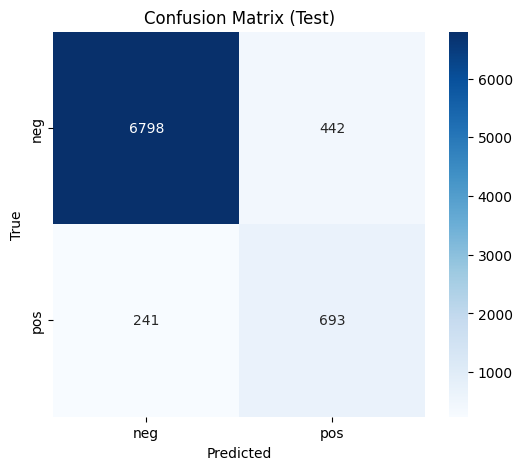

Epoch 3 Summary:
Train Loss: 0.2304 | Train Acc: 77.47% | Train F1: 0.7682
Val Loss: 0.1778 | Val Acc: 68.76% | Val F1: 0.5802
Test Loss: 0.1593 | Test Acc: 91.64% | Test F1: 0.8110
Epoch Time: 969.45s | GPU Memory Usage: 767.01 MB



Checkpoint saved at checkpoints\epoch_3.pth


Validation loss decreased. Best model saved at checkpoints\best_model.pth


Training:   0%|                                                              | 0/470 [00:00<?, ?it/s]

Training:   0%|                           | 0/470 [00:01<?, ?it/s, Loss=0.1444, F1=0.9352, Acc=93.75]

Training:   0%|                   | 1/470 [00:01<09:47,  1.25s/it, Loss=0.1444, F1=0.9352, Acc=93.75]

Training:   0%|                   | 1/470 [00:02<09:47,  1.25s/it, Loss=0.2211, F1=0.8436, Acc=84.38]

Training:   0%|                   | 2/470 [00:02<09:38,  1.24s/it, Loss=0.2211, F1=0.8436, Acc=84.38]

Training:   0%|                   | 2/470 [00:03<09:38,  1.24s/it, Loss=0.1846, F1=0.8730, Acc=87.50]

Training:   1%|                   | 3/470 [00:03<09:21,  1.20s/it, Loss=0.1846, F1=0.8730, Acc=87.50]

Training:   1%|                   | 3/470 [00:04<09:21,  1.20s/it, Loss=0.2155, F1=0.8551, Acc=85.94]

Training:   1%|▏                  | 4/470 [00:04<09:11,  1.18s/it, Loss=0.2155, F1=0.8551, Acc=85.94]

Training:   1%|▏                  | 4/470 [00:06<09:11,  1.18s/it, Loss=0.2086, F1=0.8575, Acc=86.25]

Training:   1%|▏                  | 5/470 [00:06<09:27,  1.22s/it, Loss=0.2086, F1=0.8575, Acc=86.25]

Training:   1%|▏                  | 5/470 [00:07<09:27,  1.22s/it, Loss=0.1886, F1=0.8563, Acc=86.46]

Training:   1%|▏                  | 6/470 [00:07<09:18,  1.20s/it, Loss=0.1886, F1=0.8563, Acc=86.46]

Training:   1%|▏                  | 6/470 [00:08<09:18,  1.20s/it, Loss=0.1691, F1=0.8768, Acc=88.39]

Training:   1%|▎                  | 7/470 [00:08<09:15,  1.20s/it, Loss=0.1691, F1=0.8768, Acc=88.39]

Training:   1%|▎                  | 7/470 [00:09<09:15,  1.20s/it, Loss=0.1659, F1=0.8765, Acc=88.28]

Training:   2%|▎                  | 8/470 [00:09<09:13,  1.20s/it, Loss=0.1659, F1=0.8765, Acc=88.28]

Training:   2%|▎                  | 8/470 [00:10<09:13,  1.20s/it, Loss=0.1679, F1=0.8461, Acc=85.42]

Training:   2%|▎                  | 9/470 [00:10<09:04,  1.18s/it, Loss=0.1679, F1=0.8461, Acc=85.42]

Training:   2%|▎                  | 9/470 [00:12<09:04,  1.18s/it, Loss=0.1650, F1=0.8543, Acc=86.25]

Training:   2%|▍                 | 10/470 [00:12<09:10,  1.20s/it, Loss=0.1650, F1=0.8543, Acc=86.25]

Training:   2%|▍                 | 10/470 [00:13<09:10,  1.20s/it, Loss=0.1794, F1=0.8237, Acc=83.52]

Training:   2%|▍                 | 11/470 [00:13<09:14,  1.21s/it, Loss=0.1794, F1=0.8237, Acc=83.52]

Training:   2%|▍                 | 11/470 [00:14<09:14,  1.21s/it, Loss=0.1778, F1=0.8100, Acc=82.29]

Training:   3%|▍                 | 12/470 [00:14<09:12,  1.21s/it, Loss=0.1778, F1=0.8100, Acc=82.29]

Training:   3%|▍                 | 12/470 [00:15<09:12,  1.21s/it, Loss=0.1842, F1=0.8005, Acc=81.25]

Training:   3%|▍                 | 13/470 [00:15<09:12,  1.21s/it, Loss=0.1842, F1=0.8005, Acc=81.25]

Training:   3%|▍                 | 13/470 [00:16<09:12,  1.21s/it, Loss=0.1942, F1=0.7829, Acc=79.46]

Training:   3%|▌                 | 14/470 [00:16<09:06,  1.20s/it, Loss=0.1942, F1=0.7829, Acc=79.46]

Training:   3%|▌                 | 14/470 [00:18<09:06,  1.20s/it, Loss=0.1870, F1=0.7933, Acc=80.42]

Training:   3%|▌                 | 15/470 [00:18<09:03,  1.19s/it, Loss=0.1870, F1=0.7933, Acc=80.42]

Training:   3%|▌                 | 15/470 [00:19<09:03,  1.19s/it, Loss=0.1844, F1=0.7917, Acc=80.47]

Training:   3%|▌                 | 16/470 [00:19<08:56,  1.18s/it, Loss=0.1844, F1=0.7917, Acc=80.47]

Training:   3%|▌                 | 16/470 [00:20<08:56,  1.18s/it, Loss=0.1841, F1=0.7983, Acc=80.88]

Training:   4%|▋                 | 17/470 [00:20<09:05,  1.20s/it, Loss=0.1841, F1=0.7983, Acc=80.88]

Training:   4%|▋                 | 17/470 [00:21<09:05,  1.20s/it, Loss=0.1865, F1=0.7994, Acc=80.90]

Training:   4%|▋                 | 18/470 [00:21<09:04,  1.20s/it, Loss=0.1865, F1=0.7994, Acc=80.90]

Training:   4%|▋                 | 18/470 [00:22<09:04,  1.20s/it, Loss=0.1879, F1=0.7954, Acc=80.59]

Training:   4%|▋                 | 19/470 [00:22<09:00,  1.20s/it, Loss=0.1879, F1=0.7954, Acc=80.59]

Training:   4%|▋                 | 19/470 [00:23<09:00,  1.20s/it, Loss=0.1817, F1=0.8025, Acc=81.25]

Training:   4%|▊                 | 20/470 [00:23<08:38,  1.15s/it, Loss=0.1817, F1=0.8025, Acc=81.25]

Training:   4%|▊                 | 20/470 [00:25<08:38,  1.15s/it, Loss=0.1859, F1=0.7975, Acc=80.65]

Training:   4%|▊                 | 21/470 [00:25<08:44,  1.17s/it, Loss=0.1859, F1=0.7975, Acc=80.65]

Training:   4%|▊                 | 21/470 [00:26<08:44,  1.17s/it, Loss=0.1873, F1=0.7930, Acc=80.40]

Training:   5%|▊                 | 22/470 [00:26<08:48,  1.18s/it, Loss=0.1873, F1=0.7930, Acc=80.40]

Training:   5%|▊                 | 22/470 [00:27<08:48,  1.18s/it, Loss=0.1854, F1=0.7941, Acc=80.43]

Training:   5%|▉                 | 23/470 [00:27<08:45,  1.18s/it, Loss=0.1854, F1=0.7941, Acc=80.43]

Training:   5%|▉                 | 23/470 [00:28<08:45,  1.18s/it, Loss=0.1815, F1=0.7951, Acc=80.47]

Training:   5%|▉                 | 24/470 [00:28<08:46,  1.18s/it, Loss=0.1815, F1=0.7951, Acc=80.47]

Training:   5%|▉                 | 24/470 [00:29<08:46,  1.18s/it, Loss=0.1792, F1=0.7975, Acc=80.75]

Training:   5%|▉                 | 25/470 [00:29<08:43,  1.18s/it, Loss=0.1792, F1=0.7975, Acc=80.75]

Training:   5%|▉                 | 25/470 [00:30<08:43,  1.18s/it, Loss=0.1768, F1=0.7946, Acc=80.53]

Training:   6%|▉                 | 26/470 [00:30<08:42,  1.18s/it, Loss=0.1768, F1=0.7946, Acc=80.53]

Training:   6%|▉                 | 26/470 [00:32<08:42,  1.18s/it, Loss=0.1743, F1=0.7959, Acc=80.56]

Training:   6%|█                 | 27/470 [00:32<08:39,  1.17s/it, Loss=0.1743, F1=0.7959, Acc=80.56]

Training:   6%|█                 | 27/470 [00:33<08:39,  1.17s/it, Loss=0.1882, F1=0.7954, Acc=80.58]

Training:   6%|█                 | 28/470 [00:33<08:39,  1.17s/it, Loss=0.1882, F1=0.7954, Acc=80.58]

Training:   6%|█                 | 28/470 [00:34<08:39,  1.17s/it, Loss=0.1876, F1=0.7966, Acc=80.60]

Training:   6%|█                 | 29/470 [00:34<08:33,  1.16s/it, Loss=0.1876, F1=0.7966, Acc=80.60]

Training:   6%|█                 | 29/470 [00:35<08:33,  1.16s/it, Loss=0.1973, F1=0.7981, Acc=80.83]

Training:   6%|█▏                | 30/470 [00:35<08:19,  1.13s/it, Loss=0.1973, F1=0.7981, Acc=80.83]

Training:   6%|█▏                | 30/470 [00:36<08:19,  1.13s/it, Loss=0.1985, F1=0.8011, Acc=81.05]

Training:   7%|█▏                | 31/470 [00:36<08:24,  1.15s/it, Loss=0.1985, F1=0.8011, Acc=81.05]

Training:   7%|█▏                | 31/470 [00:37<08:24,  1.15s/it, Loss=0.2061, F1=0.8038, Acc=81.25]

Training:   7%|█▏                | 32/470 [00:37<08:20,  1.14s/it, Loss=0.2061, F1=0.8038, Acc=81.25]

Training:   7%|█▏                | 32/470 [00:39<08:20,  1.14s/it, Loss=0.2008, F1=0.8099, Acc=81.82]

Training:   7%|█▎                | 33/470 [00:39<08:24,  1.16s/it, Loss=0.2008, F1=0.8099, Acc=81.82]

Training:   7%|█▎                | 33/470 [00:40<08:24,  1.16s/it, Loss=0.1977, F1=0.8139, Acc=82.17]

Training:   7%|█▎                | 34/470 [00:40<08:24,  1.16s/it, Loss=0.1977, F1=0.8139, Acc=82.17]

Training:   7%|█▎                | 34/470 [00:41<08:24,  1.16s/it, Loss=0.2020, F1=0.8123, Acc=81.96]

Training:   7%|█▎                | 35/470 [00:41<08:34,  1.18s/it, Loss=0.2020, F1=0.8123, Acc=81.96]

Training:   7%|█▎                | 35/470 [00:42<08:34,  1.18s/it, Loss=0.2114, F1=0.8068, Acc=81.42]

Training:   8%|█▍                | 36/470 [00:42<08:39,  1.20s/it, Loss=0.2114, F1=0.8068, Acc=81.42]

Training:   8%|█▍                | 36/470 [00:43<08:39,  1.20s/it, Loss=0.2110, F1=0.8081, Acc=81.59]

Training:   8%|█▍                | 37/470 [00:43<08:33,  1.19s/it, Loss=0.2110, F1=0.8081, Acc=81.59]

Training:   8%|█▍                | 37/470 [00:44<08:33,  1.19s/it, Loss=0.2112, F1=0.8070, Acc=81.41]

Training:   8%|█▍                | 38/470 [00:44<08:31,  1.18s/it, Loss=0.2112, F1=0.8070, Acc=81.41]

Training:   8%|█▍                | 38/470 [00:46<08:31,  1.18s/it, Loss=0.2090, F1=0.8052, Acc=81.25]

Training:   8%|█▍                | 39/470 [00:46<08:33,  1.19s/it, Loss=0.2090, F1=0.8052, Acc=81.25]

Training:   8%|█▍                | 39/470 [00:47<08:33,  1.19s/it, Loss=0.2089, F1=0.8042, Acc=81.09]

Training:   9%|█▌                | 40/470 [00:47<08:44,  1.22s/it, Loss=0.2089, F1=0.8042, Acc=81.09]

Training:   9%|█▌                | 40/470 [00:48<08:44,  1.22s/it, Loss=0.2083, F1=0.8010, Acc=80.79]

Training:   9%|█▌                | 41/470 [00:48<08:39,  1.21s/it, Loss=0.2083, F1=0.8010, Acc=80.79]

Training:   9%|█▌                | 41/470 [00:49<08:39,  1.21s/it, Loss=0.2051, F1=0.8014, Acc=80.80]

Training:   9%|█▌                | 42/470 [00:49<08:32,  1.20s/it, Loss=0.2051, F1=0.8014, Acc=80.80]

Training:   9%|█▌                | 42/470 [00:51<08:32,  1.20s/it, Loss=0.2045, F1=0.8017, Acc=80.81]

Training:   9%|█▋                | 43/470 [00:51<08:35,  1.21s/it, Loss=0.2045, F1=0.8017, Acc=80.81]

Training:   9%|█▋                | 43/470 [00:52<08:35,  1.21s/it, Loss=0.2063, F1=0.8024, Acc=80.82]

Training:   9%|█▋                | 44/470 [00:52<08:39,  1.22s/it, Loss=0.2063, F1=0.8024, Acc=80.82]

Training:   9%|█▋                | 44/470 [00:53<08:39,  1.22s/it, Loss=0.2092, F1=0.8040, Acc=80.97]

Training:  10%|█▋                | 45/470 [00:53<08:48,  1.24s/it, Loss=0.2092, F1=0.8040, Acc=80.97]

Training:  10%|█▋                | 45/470 [00:54<08:48,  1.24s/it, Loss=0.2139, F1=0.8055, Acc=81.11]

Training:  10%|█▊                | 46/470 [00:54<09:04,  1.28s/it, Loss=0.2139, F1=0.8055, Acc=81.11]

Training:  10%|█▊                | 46/470 [00:56<09:04,  1.28s/it, Loss=0.2154, F1=0.8054, Acc=81.12]

Training:  10%|█▊                | 47/470 [00:56<09:54,  1.41s/it, Loss=0.2154, F1=0.8054, Acc=81.12]

Training:  10%|█▊                | 47/470 [00:58<09:54,  1.41s/it, Loss=0.2135, F1=0.8055, Acc=81.12]

Training:  10%|█▊                | 48/470 [00:58<10:07,  1.44s/it, Loss=0.2135, F1=0.8055, Acc=81.12]

Training:  10%|█▊                | 48/470 [00:59<10:07,  1.44s/it, Loss=0.2117, F1=0.8066, Acc=81.25]

Training:  10%|█▉                | 49/470 [00:59<09:45,  1.39s/it, Loss=0.2117, F1=0.8066, Acc=81.25]

Training:  10%|█▉                | 49/470 [01:00<09:45,  1.39s/it, Loss=0.2105, F1=0.8081, Acc=81.38]

Training:  11%|█▉                | 50/470 [01:00<09:14,  1.32s/it, Loss=0.2105, F1=0.8081, Acc=81.38]

Training:  11%|█▉                | 50/470 [01:02<09:14,  1.32s/it, Loss=0.2088, F1=0.8093, Acc=81.50]

Training:  11%|█▉                | 51/470 [01:02<09:39,  1.38s/it, Loss=0.2088, F1=0.8093, Acc=81.50]

Training:  11%|█▉                | 51/470 [01:03<09:39,  1.38s/it, Loss=0.2064, F1=0.8089, Acc=81.49]

Training:  11%|█▉                | 52/470 [01:03<09:38,  1.38s/it, Loss=0.2064, F1=0.8089, Acc=81.49]

Training:  11%|█▉                | 52/470 [01:05<09:38,  1.38s/it, Loss=0.2066, F1=0.8039, Acc=81.01]

Training:  11%|██                | 53/470 [01:05<10:21,  1.49s/it, Loss=0.2066, F1=0.8039, Acc=81.01]

Training:  11%|██                | 53/470 [01:06<10:21,  1.49s/it, Loss=0.2064, F1=0.7990, Acc=80.56]

Training:  11%|██                | 54/470 [01:06<09:51,  1.42s/it, Loss=0.2064, F1=0.7990, Acc=80.56]

Training:  11%|██                | 54/470 [01:07<09:51,  1.42s/it, Loss=0.2069, F1=0.7933, Acc=80.00]

Training:  12%|██                | 55/470 [01:07<09:35,  1.39s/it, Loss=0.2069, F1=0.7933, Acc=80.00]

Training:  12%|██                | 55/470 [01:09<09:35,  1.39s/it, Loss=0.2089, F1=0.7879, Acc=79.46]

Training:  12%|██▏               | 56/470 [01:09<09:14,  1.34s/it, Loss=0.2089, F1=0.7879, Acc=79.46]

Training:  12%|██▏               | 56/470 [01:10<09:14,  1.34s/it, Loss=0.2076, F1=0.7868, Acc=79.39]

Training:  12%|██▏               | 57/470 [01:10<08:55,  1.30s/it, Loss=0.2076, F1=0.7868, Acc=79.39]

Training:  12%|██▏               | 57/470 [01:11<08:55,  1.30s/it, Loss=0.2116, F1=0.7871, Acc=79.42]

Training:  12%|██▏               | 58/470 [01:11<09:22,  1.36s/it, Loss=0.2116, F1=0.7871, Acc=79.42]

Training:  12%|██▏               | 58/470 [01:13<09:22,  1.36s/it, Loss=0.2113, F1=0.7842, Acc=79.13]

Training:  13%|██▎               | 59/470 [01:13<09:06,  1.33s/it, Loss=0.2113, F1=0.7842, Acc=79.13]

Training:  13%|██▎               | 59/470 [01:14<09:06,  1.33s/it, Loss=0.2095, F1=0.7854, Acc=79.27]

Training:  13%|██▎               | 60/470 [01:14<08:55,  1.31s/it, Loss=0.2095, F1=0.7854, Acc=79.27]

Training:  13%|██▎               | 60/470 [01:15<08:55,  1.31s/it, Loss=0.2087, F1=0.7862, Acc=79.41]

Training:  13%|██▎               | 61/470 [01:15<08:33,  1.26s/it, Loss=0.2087, F1=0.7862, Acc=79.41]

Training:  13%|██▎               | 61/470 [01:16<08:33,  1.26s/it, Loss=0.2092, F1=0.7873, Acc=79.54]

Training:  13%|██▎               | 62/470 [01:16<08:25,  1.24s/it, Loss=0.2092, F1=0.7873, Acc=79.54]

Training:  13%|██▎               | 62/470 [01:17<08:25,  1.24s/it, Loss=0.2098, F1=0.7886, Acc=79.66]

Training:  13%|██▍               | 63/470 [01:17<08:27,  1.25s/it, Loss=0.2098, F1=0.7886, Acc=79.66]

Training:  13%|██▍               | 63/470 [01:19<08:27,  1.25s/it, Loss=0.2105, F1=0.7883, Acc=79.69]

Training:  14%|██▍               | 64/470 [01:19<08:27,  1.25s/it, Loss=0.2105, F1=0.7883, Acc=79.69]

Training:  14%|██▍               | 64/470 [01:20<08:27,  1.25s/it, Loss=0.2096, F1=0.7893, Acc=79.81]

Training:  14%|██▍               | 65/470 [01:20<08:30,  1.26s/it, Loss=0.2096, F1=0.7893, Acc=79.81]

Training:  14%|██▍               | 65/470 [01:21<08:30,  1.26s/it, Loss=0.2090, F1=0.7896, Acc=79.83]

Training:  14%|██▌               | 66/470 [01:21<08:16,  1.23s/it, Loss=0.2090, F1=0.7896, Acc=79.83]

Training:  14%|██▌               | 66/470 [01:22<08:16,  1.23s/it, Loss=0.2099, F1=0.7864, Acc=79.48]

Training:  14%|██▌               | 67/470 [01:22<08:06,  1.21s/it, Loss=0.2099, F1=0.7864, Acc=79.48]

Training:  14%|██▌               | 67/470 [01:24<08:06,  1.21s/it, Loss=0.2083, F1=0.7881, Acc=79.60]

Training:  14%|██▌               | 68/470 [01:24<08:11,  1.22s/it, Loss=0.2083, F1=0.7881, Acc=79.60]

Training:  14%|██▌               | 68/470 [01:25<08:11,  1.22s/it, Loss=0.2080, F1=0.7856, Acc=79.35]

Training:  15%|██▋               | 69/470 [01:25<08:04,  1.21s/it, Loss=0.2080, F1=0.7856, Acc=79.35]

Training:  15%|██▋               | 69/470 [01:26<08:04,  1.21s/it, Loss=0.2094, F1=0.7833, Acc=79.11]

Training:  15%|██▋               | 70/470 [01:26<08:00,  1.20s/it, Loss=0.2094, F1=0.7833, Acc=79.11]

Training:  15%|██▋               | 70/470 [01:27<08:00,  1.20s/it, Loss=0.2075, F1=0.7854, Acc=79.31]

Training:  15%|██▋               | 71/470 [01:27<08:04,  1.21s/it, Loss=0.2075, F1=0.7854, Acc=79.31]

Training:  15%|██▋               | 71/470 [01:28<08:04,  1.21s/it, Loss=0.2056, F1=0.7881, Acc=79.51]

Training:  15%|██▊               | 72/470 [01:28<08:02,  1.21s/it, Loss=0.2056, F1=0.7881, Acc=79.51]

Training:  15%|██▊               | 72/470 [01:30<08:02,  1.21s/it, Loss=0.2040, F1=0.7902, Acc=79.71]

Training:  16%|██▊               | 73/470 [01:30<07:58,  1.21s/it, Loss=0.2040, F1=0.7902, Acc=79.71]

Training:  16%|██▊               | 73/470 [01:31<07:58,  1.21s/it, Loss=0.2026, F1=0.7933, Acc=79.98]

Training:  16%|██▊               | 74/470 [01:31<07:50,  1.19s/it, Loss=0.2026, F1=0.7933, Acc=79.98]

Training:  16%|██▊               | 74/470 [01:32<07:50,  1.19s/it, Loss=0.2007, F1=0.7964, Acc=80.25]

Training:  16%|██▊               | 75/470 [01:32<07:55,  1.20s/it, Loss=0.2007, F1=0.7964, Acc=80.25]

Training:  16%|██▊               | 75/470 [01:33<07:55,  1.20s/it, Loss=0.2041, F1=0.7968, Acc=80.26]

Training:  16%|██▉               | 76/470 [01:33<07:50,  1.19s/it, Loss=0.2041, F1=0.7968, Acc=80.26]

Training:  16%|██▉               | 76/470 [01:34<07:50,  1.19s/it, Loss=0.2086, F1=0.7965, Acc=80.19]

Training:  16%|██▉               | 77/470 [01:34<07:46,  1.19s/it, Loss=0.2086, F1=0.7965, Acc=80.19]

Training:  16%|██▉               | 77/470 [01:36<07:46,  1.19s/it, Loss=0.2100, F1=0.7986, Acc=80.37]

Training:  17%|██▉               | 78/470 [01:36<07:53,  1.21s/it, Loss=0.2100, F1=0.7986, Acc=80.37]

Training:  17%|██▉               | 78/470 [01:37<07:53,  1.21s/it, Loss=0.2079, F1=0.8014, Acc=80.62]

Training:  17%|███               | 79/470 [01:37<07:55,  1.22s/it, Loss=0.2079, F1=0.8014, Acc=80.62]

Training:  17%|███               | 79/470 [01:38<07:55,  1.22s/it, Loss=0.2071, F1=0.8014, Acc=80.62]

Training:  17%|███               | 80/470 [01:38<07:54,  1.22s/it, Loss=0.2071, F1=0.8014, Acc=80.62]

Training:  17%|███               | 80/470 [01:39<07:54,  1.22s/it, Loss=0.2101, F1=0.8025, Acc=80.71]

Training:  17%|███               | 81/470 [01:39<07:47,  1.20s/it, Loss=0.2101, F1=0.8025, Acc=80.71]

Training:  17%|███               | 81/470 [01:40<07:47,  1.20s/it, Loss=0.2103, F1=0.8045, Acc=80.87]

Training:  17%|███▏              | 82/470 [01:40<07:32,  1.17s/it, Loss=0.2103, F1=0.8045, Acc=80.87]

Training:  17%|███▏              | 82/470 [01:41<07:32,  1.17s/it, Loss=0.2125, F1=0.8054, Acc=80.95]

Training:  18%|███▏              | 83/470 [01:41<07:22,  1.14s/it, Loss=0.2125, F1=0.8054, Acc=80.95]

Training:  18%|███▏              | 83/470 [01:42<07:22,  1.14s/it, Loss=0.2117, F1=0.8062, Acc=81.03]

Training:  18%|███▏              | 84/470 [01:42<07:21,  1.14s/it, Loss=0.2117, F1=0.8062, Acc=81.03]

Training:  18%|███▏              | 84/470 [01:44<07:21,  1.14s/it, Loss=0.2112, F1=0.8056, Acc=80.96]

Training:  18%|███▎              | 85/470 [01:44<07:34,  1.18s/it, Loss=0.2112, F1=0.8056, Acc=80.96]

Training:  18%|███▎              | 85/470 [01:45<07:34,  1.18s/it, Loss=0.2133, F1=0.8053, Acc=80.96]

Training:  18%|███▎              | 86/470 [01:45<07:44,  1.21s/it, Loss=0.2133, F1=0.8053, Acc=80.96]

Training:  18%|███▎              | 86/470 [01:46<07:44,  1.21s/it, Loss=0.2119, F1=0.8052, Acc=80.96]

Training:  19%|███▎              | 87/470 [01:46<07:39,  1.20s/it, Loss=0.2119, F1=0.8052, Acc=80.96]

Training:  19%|███▎              | 87/470 [01:47<07:39,  1.20s/it, Loss=0.2121, F1=0.8053, Acc=80.97]

Training:  19%|███▎              | 88/470 [01:47<07:40,  1.21s/it, Loss=0.2121, F1=0.8053, Acc=80.97]

Training:  19%|███▎              | 88/470 [01:49<07:40,  1.21s/it, Loss=0.2125, F1=0.8047, Acc=80.90]

Training:  19%|███▍              | 89/470 [01:49<07:30,  1.18s/it, Loss=0.2125, F1=0.8047, Acc=80.90]

Training:  19%|███▍              | 89/470 [01:50<07:30,  1.18s/it, Loss=0.2111, F1=0.8062, Acc=81.04]

Training:  19%|███▍              | 90/470 [01:50<07:31,  1.19s/it, Loss=0.2111, F1=0.8062, Acc=81.04]

Training:  19%|███▍              | 90/470 [01:51<07:31,  1.19s/it, Loss=0.2100, F1=0.8063, Acc=81.04]

Training:  19%|███▍              | 91/470 [01:51<07:30,  1.19s/it, Loss=0.2100, F1=0.8063, Acc=81.04]

Training:  19%|███▍              | 91/470 [01:52<07:30,  1.19s/it, Loss=0.2135, F1=0.8049, Acc=80.91]

Training:  20%|███▌              | 92/470 [01:52<07:33,  1.20s/it, Loss=0.2135, F1=0.8049, Acc=80.91]

Training:  20%|███▌              | 92/470 [01:53<07:33,  1.20s/it, Loss=0.2125, F1=0.8062, Acc=81.05]

Training:  20%|███▌              | 93/470 [01:53<07:25,  1.18s/it, Loss=0.2125, F1=0.8062, Acc=81.05]

Training:  20%|███▌              | 93/470 [01:55<07:25,  1.18s/it, Loss=0.2111, F1=0.8068, Acc=81.12]

Training:  20%|███▌              | 94/470 [01:55<07:30,  1.20s/it, Loss=0.2111, F1=0.8068, Acc=81.12]

Training:  20%|███▌              | 94/470 [01:56<07:30,  1.20s/it, Loss=0.2096, F1=0.8074, Acc=81.18]

Training:  20%|███▋              | 95/470 [01:56<07:28,  1.19s/it, Loss=0.2096, F1=0.8074, Acc=81.18]

Training:  20%|███▋              | 95/470 [01:57<07:28,  1.19s/it, Loss=0.2109, F1=0.8069, Acc=81.12]

Training:  20%|███▋              | 96/470 [01:57<07:25,  1.19s/it, Loss=0.2109, F1=0.8069, Acc=81.12]

Training:  20%|███▋              | 96/470 [01:58<07:25,  1.19s/it, Loss=0.2092, F1=0.8089, Acc=81.31]

Training:  21%|███▋              | 97/470 [01:58<07:19,  1.18s/it, Loss=0.2092, F1=0.8089, Acc=81.31]

Training:  21%|███▋              | 97/470 [01:59<07:19,  1.18s/it, Loss=0.2089, F1=0.8101, Acc=81.44]

Training:  21%|███▊              | 98/470 [01:59<07:29,  1.21s/it, Loss=0.2089, F1=0.8101, Acc=81.44]

Training:  21%|███▊              | 98/470 [02:01<07:29,  1.21s/it, Loss=0.2107, F1=0.8077, Acc=81.19]

Training:  21%|███▊              | 99/470 [02:01<07:27,  1.21s/it, Loss=0.2107, F1=0.8077, Acc=81.19]

Training:  21%|███▊              | 99/470 [02:02<07:27,  1.21s/it, Loss=0.2093, F1=0.8083, Acc=81.25]

Training:  21%|███▌             | 100/470 [02:02<07:21,  1.19s/it, Loss=0.2093, F1=0.8083, Acc=81.25]

Training:  21%|███▌             | 100/470 [02:03<07:21,  1.19s/it, Loss=0.2089, F1=0.8094, Acc=81.37]

Training:  21%|███▋             | 101/470 [02:03<07:20,  1.19s/it, Loss=0.2089, F1=0.8094, Acc=81.37]

Training:  21%|███▋             | 101/470 [02:04<07:20,  1.19s/it, Loss=0.2076, F1=0.8107, Acc=81.50]

Training:  22%|███▋             | 102/470 [02:04<07:21,  1.20s/it, Loss=0.2076, F1=0.8107, Acc=81.50]

Training:  22%|███▋             | 102/470 [02:05<07:21,  1.20s/it, Loss=0.2080, F1=0.8112, Acc=81.55]

Training:  22%|███▋             | 103/470 [02:05<07:22,  1.20s/it, Loss=0.2080, F1=0.8112, Acc=81.55]

Training:  22%|███▋             | 103/470 [02:06<07:22,  1.20s/it, Loss=0.2071, F1=0.8118, Acc=81.61]

Training:  22%|███▊             | 104/470 [02:06<07:18,  1.20s/it, Loss=0.2071, F1=0.8118, Acc=81.61]

Training:  22%|███▊             | 104/470 [02:08<07:18,  1.20s/it, Loss=0.2061, F1=0.8117, Acc=81.61]

Training:  22%|███▊             | 105/470 [02:08<07:16,  1.19s/it, Loss=0.2061, F1=0.8117, Acc=81.61]

Training:  22%|███▊             | 105/470 [02:09<07:16,  1.19s/it, Loss=0.2081, F1=0.8117, Acc=81.60]

Training:  23%|███▊             | 106/470 [02:09<07:19,  1.21s/it, Loss=0.2081, F1=0.8117, Acc=81.60]

Training:  23%|███▊             | 106/470 [02:10<07:19,  1.21s/it, Loss=0.2071, F1=0.8132, Acc=81.72]

Training:  23%|███▊             | 107/470 [02:10<07:12,  1.19s/it, Loss=0.2071, F1=0.8132, Acc=81.72]

Training:  23%|███▊             | 107/470 [02:11<07:12,  1.19s/it, Loss=0.2060, F1=0.8143, Acc=81.83]

Training:  23%|███▉             | 108/470 [02:11<07:21,  1.22s/it, Loss=0.2060, F1=0.8143, Acc=81.83]

Training:  23%|███▉             | 108/470 [02:13<07:21,  1.22s/it, Loss=0.2059, F1=0.8151, Acc=81.88]

Training:  23%|███▉             | 109/470 [02:13<07:16,  1.21s/it, Loss=0.2059, F1=0.8151, Acc=81.88]

Training:  23%|███▉             | 109/470 [02:14<07:16,  1.21s/it, Loss=0.2062, F1=0.8138, Acc=81.76]

Training:  23%|███▉             | 110/470 [02:14<07:06,  1.18s/it, Loss=0.2062, F1=0.8138, Acc=81.76]

Training:  23%|███▉             | 110/470 [02:15<07:06,  1.18s/it, Loss=0.2051, F1=0.8149, Acc=81.87]

Training:  24%|████             | 111/470 [02:15<07:08,  1.19s/it, Loss=0.2051, F1=0.8149, Acc=81.87]

Training:  24%|████             | 111/470 [02:16<07:08,  1.19s/it, Loss=0.2038, F1=0.8154, Acc=81.92]

Training:  24%|████             | 112/470 [02:16<07:16,  1.22s/it, Loss=0.2038, F1=0.8154, Acc=81.92]

Training:  24%|████             | 112/470 [02:17<07:16,  1.22s/it, Loss=0.2025, F1=0.8170, Acc=82.08]

Training:  24%|████             | 113/470 [02:17<07:11,  1.21s/it, Loss=0.2025, F1=0.8170, Acc=82.08]

Training:  24%|████             | 113/470 [02:18<07:11,  1.21s/it, Loss=0.2016, F1=0.8182, Acc=82.18]

Training:  24%|████             | 114/470 [02:18<07:05,  1.19s/it, Loss=0.2016, F1=0.8182, Acc=82.18]

Training:  24%|████             | 114/470 [02:20<07:05,  1.19s/it, Loss=0.2036, F1=0.8179, Acc=82.17]

Training:  24%|████▏            | 115/470 [02:20<07:01,  1.19s/it, Loss=0.2036, F1=0.8179, Acc=82.17]

Training:  24%|████▏            | 115/470 [02:21<07:01,  1.19s/it, Loss=0.2023, F1=0.8196, Acc=82.33]

Training:  25%|████▏            | 116/470 [02:21<07:07,  1.21s/it, Loss=0.2023, F1=0.8196, Acc=82.33]

Training:  25%|████▏            | 116/470 [02:22<07:07,  1.21s/it, Loss=0.2024, F1=0.8201, Acc=82.37]

Training:  25%|████▏            | 117/470 [02:22<06:54,  1.17s/it, Loss=0.2024, F1=0.8201, Acc=82.37]

Training:  25%|████▏            | 117/470 [02:23<06:54,  1.17s/it, Loss=0.2021, F1=0.8209, Acc=82.47]

Training:  25%|████▎            | 118/470 [02:23<06:49,  1.16s/it, Loss=0.2021, F1=0.8209, Acc=82.47]

Training:  25%|████▎            | 118/470 [02:24<06:49,  1.16s/it, Loss=0.2017, F1=0.8215, Acc=82.51]

Training:  25%|████▎            | 119/470 [02:24<06:47,  1.16s/it, Loss=0.2017, F1=0.8215, Acc=82.51]

Training:  25%|████▎            | 119/470 [02:26<06:47,  1.16s/it, Loss=0.2027, F1=0.8226, Acc=82.60]

Training:  26%|████▎            | 120/470 [02:26<06:52,  1.18s/it, Loss=0.2027, F1=0.8226, Acc=82.60]

Training:  26%|████▎            | 120/470 [02:27<06:52,  1.18s/it, Loss=0.2024, F1=0.8218, Acc=82.54]

Training:  26%|████▍            | 121/470 [02:27<06:47,  1.17s/it, Loss=0.2024, F1=0.8218, Acc=82.54]

Training:  26%|████▍            | 121/470 [02:28<06:47,  1.17s/it, Loss=0.2036, F1=0.8213, Acc=82.48]

Training:  26%|████▍            | 122/470 [02:28<06:46,  1.17s/it, Loss=0.2036, F1=0.8213, Acc=82.48]

Training:  26%|████▍            | 122/470 [02:29<06:46,  1.17s/it, Loss=0.2029, F1=0.8217, Acc=82.52]

Training:  26%|████▍            | 123/470 [02:29<06:51,  1.18s/it, Loss=0.2029, F1=0.8217, Acc=82.52]

Training:  26%|████▍            | 123/470 [02:30<06:51,  1.18s/it, Loss=0.2019, F1=0.8227, Acc=82.61]

Training:  26%|████▍            | 124/470 [02:30<06:47,  1.18s/it, Loss=0.2019, F1=0.8227, Acc=82.61]

Training:  26%|████▍            | 124/470 [02:31<06:47,  1.18s/it, Loss=0.2031, F1=0.8215, Acc=82.50]

Training:  27%|████▌            | 125/470 [02:31<06:48,  1.18s/it, Loss=0.2031, F1=0.8215, Acc=82.50]

Training:  27%|████▌            | 125/470 [02:33<06:48,  1.18s/it, Loss=0.2021, F1=0.8220, Acc=82.54]

Training:  27%|████▌            | 126/470 [02:33<06:51,  1.20s/it, Loss=0.2021, F1=0.8220, Acc=82.54]

Training:  27%|████▌            | 126/470 [02:34<06:51,  1.20s/it, Loss=0.2021, F1=0.8216, Acc=82.48]

Training:  27%|████▌            | 127/470 [02:34<06:53,  1.21s/it, Loss=0.2021, F1=0.8216, Acc=82.48]

Training:  27%|████▌            | 127/470 [02:35<06:53,  1.21s/it, Loss=0.2026, F1=0.8220, Acc=82.52]

Training:  27%|████▋            | 128/470 [02:35<06:49,  1.20s/it, Loss=0.2026, F1=0.8220, Acc=82.52]

Training:  27%|████▋            | 128/470 [02:36<06:49,  1.20s/it, Loss=0.2028, F1=0.8228, Acc=82.61]

Training:  27%|████▋            | 129/470 [02:36<06:47,  1.19s/it, Loss=0.2028, F1=0.8228, Acc=82.61]

Training:  27%|████▋            | 129/470 [02:38<06:47,  1.19s/it, Loss=0.2026, F1=0.8233, Acc=82.64]

Training:  28%|████▋            | 130/470 [02:38<06:51,  1.21s/it, Loss=0.2026, F1=0.8233, Acc=82.64]

Training:  28%|████▋            | 130/470 [02:39<06:51,  1.21s/it, Loss=0.2023, F1=0.8232, Acc=82.63]

Training:  28%|████▋            | 131/470 [02:39<06:50,  1.21s/it, Loss=0.2023, F1=0.8232, Acc=82.63]

Training:  28%|████▋            | 131/470 [02:40<06:50,  1.21s/it, Loss=0.2023, F1=0.8238, Acc=82.67]

Training:  28%|████▊            | 132/470 [02:40<06:45,  1.20s/it, Loss=0.2023, F1=0.8238, Acc=82.67]

Training:  28%|████▊            | 132/470 [02:41<06:45,  1.20s/it, Loss=0.2011, F1=0.8246, Acc=82.75]

Training:  28%|████▊            | 133/470 [02:41<06:42,  1.19s/it, Loss=0.2011, F1=0.8246, Acc=82.75]

Training:  28%|████▊            | 133/470 [02:42<06:42,  1.19s/it, Loss=0.2015, F1=0.8251, Acc=82.79]

Training:  29%|████▊            | 134/470 [02:42<06:37,  1.18s/it, Loss=0.2015, F1=0.8251, Acc=82.79]

Training:  29%|████▊            | 134/470 [02:43<06:37,  1.18s/it, Loss=0.2015, F1=0.8259, Acc=82.87]

Training:  29%|████▉            | 135/470 [02:43<06:42,  1.20s/it, Loss=0.2015, F1=0.8259, Acc=82.87]

Training:  29%|████▉            | 135/470 [02:45<06:42,  1.20s/it, Loss=0.2004, F1=0.8267, Acc=82.95]

Training:  29%|████▉            | 136/470 [02:45<06:43,  1.21s/it, Loss=0.2004, F1=0.8267, Acc=82.95]

Training:  29%|████▉            | 136/470 [02:46<06:43,  1.21s/it, Loss=0.2000, F1=0.8276, Acc=83.03]

Training:  29%|████▉            | 137/470 [02:46<06:39,  1.20s/it, Loss=0.2000, F1=0.8276, Acc=83.03]

Training:  29%|████▉            | 137/470 [02:47<06:39,  1.20s/it, Loss=0.2005, F1=0.8269, Acc=82.97]

Training:  29%|████▉            | 138/470 [02:47<06:36,  1.19s/it, Loss=0.2005, F1=0.8269, Acc=82.97]

Training:  29%|████▉            | 138/470 [02:48<06:36,  1.19s/it, Loss=0.1994, F1=0.8276, Acc=83.05]

Training:  30%|█████            | 139/470 [02:48<06:41,  1.21s/it, Loss=0.1994, F1=0.8276, Acc=83.05]

Training:  30%|█████            | 139/470 [02:49<06:41,  1.21s/it, Loss=0.1999, F1=0.8265, Acc=82.95]

Training:  30%|█████            | 140/470 [02:49<06:37,  1.20s/it, Loss=0.1999, F1=0.8265, Acc=82.95]

Training:  30%|█████            | 140/470 [02:51<06:37,  1.20s/it, Loss=0.1999, F1=0.8268, Acc=82.98]

Training:  30%|█████            | 141/470 [02:51<06:34,  1.20s/it, Loss=0.1999, F1=0.8268, Acc=82.98]

Training:  30%|█████            | 141/470 [02:52<06:34,  1.20s/it, Loss=0.1987, F1=0.8275, Acc=83.05]

Training:  30%|█████▏           | 142/470 [02:52<06:28,  1.18s/it, Loss=0.1987, F1=0.8275, Acc=83.05]

Training:  30%|█████▏           | 142/470 [02:53<06:28,  1.18s/it, Loss=0.1995, F1=0.8267, Acc=82.95]

Training:  30%|█████▏           | 143/470 [02:53<06:38,  1.22s/it, Loss=0.1995, F1=0.8267, Acc=82.95]

Training:  30%|█████▏           | 143/470 [02:54<06:38,  1.22s/it, Loss=0.1990, F1=0.8266, Acc=82.94]

Training:  31%|█████▏           | 144/470 [02:54<06:33,  1.21s/it, Loss=0.1990, F1=0.8266, Acc=82.94]

Training:  31%|█████▏           | 144/470 [02:55<06:33,  1.21s/it, Loss=0.1987, F1=0.8270, Acc=82.97]

Training:  31%|█████▏           | 145/470 [02:55<06:27,  1.19s/it, Loss=0.1987, F1=0.8270, Acc=82.97]

Training:  31%|█████▏           | 145/470 [02:57<06:27,  1.19s/it, Loss=0.1981, F1=0.8269, Acc=82.96]

Training:  31%|█████▎           | 146/470 [02:57<06:23,  1.18s/it, Loss=0.1981, F1=0.8269, Acc=82.96]

Training:  31%|█████▎           | 146/470 [02:58<06:23,  1.18s/it, Loss=0.1978, F1=0.8268, Acc=82.95]

Training:  31%|█████▎           | 147/470 [02:58<06:27,  1.20s/it, Loss=0.1978, F1=0.8268, Acc=82.95]

Training:  31%|█████▎           | 147/470 [02:59<06:27,  1.20s/it, Loss=0.1970, F1=0.8266, Acc=82.94]

Training:  31%|█████▎           | 148/470 [02:59<06:31,  1.21s/it, Loss=0.1970, F1=0.8266, Acc=82.94]

Training:  31%|█████▎           | 148/470 [03:00<06:31,  1.21s/it, Loss=0.1984, F1=0.8265, Acc=82.93]

Training:  32%|█████▍           | 149/470 [03:00<06:24,  1.20s/it, Loss=0.1984, F1=0.8265, Acc=82.93]

Training:  32%|█████▍           | 149/470 [03:01<06:24,  1.20s/it, Loss=0.1973, F1=0.8275, Acc=83.04]

Training:  32%|█████▍           | 150/470 [03:01<06:22,  1.19s/it, Loss=0.1973, F1=0.8275, Acc=83.04]

Training:  32%|█████▍           | 150/470 [03:03<06:22,  1.19s/it, Loss=0.1972, F1=0.8273, Acc=83.03]

Training:  32%|█████▍           | 151/470 [03:03<06:20,  1.19s/it, Loss=0.1972, F1=0.8273, Acc=83.03]

Training:  32%|█████▍           | 151/470 [03:04<06:20,  1.19s/it, Loss=0.2001, F1=0.8268, Acc=82.98]

Training:  32%|█████▍           | 152/470 [03:04<06:23,  1.21s/it, Loss=0.2001, F1=0.8268, Acc=82.98]

Training:  32%|█████▍           | 152/470 [03:05<06:23,  1.21s/it, Loss=0.1991, F1=0.8275, Acc=83.05]

Training:  33%|█████▌           | 153/470 [03:05<06:17,  1.19s/it, Loss=0.1991, F1=0.8275, Acc=83.05]

Training:  33%|█████▌           | 153/470 [03:06<06:17,  1.19s/it, Loss=0.1998, F1=0.8282, Acc=83.12]

Training:  33%|█████▌           | 154/470 [03:06<06:22,  1.21s/it, Loss=0.1998, F1=0.8282, Acc=83.12]

Training:  33%|█████▌           | 154/470 [03:07<06:22,  1.21s/it, Loss=0.1998, F1=0.8277, Acc=83.06]

Training:  33%|█████▌           | 155/470 [03:07<06:17,  1.20s/it, Loss=0.1998, F1=0.8277, Acc=83.06]

Training:  33%|█████▌           | 155/470 [03:09<06:17,  1.20s/it, Loss=0.2022, F1=0.8276, Acc=83.05]

Training:  33%|█████▋           | 156/470 [03:09<06:09,  1.18s/it, Loss=0.2022, F1=0.8276, Acc=83.05]

Training:  33%|█████▋           | 156/470 [03:10<06:09,  1.18s/it, Loss=0.2025, F1=0.8273, Acc=83.00]

Training:  33%|█████▋           | 157/470 [03:10<06:16,  1.20s/it, Loss=0.2025, F1=0.8273, Acc=83.00]

Training:  33%|█████▋           | 157/470 [03:11<06:16,  1.20s/it, Loss=0.2022, F1=0.8277, Acc=83.03]

Training:  34%|█████▋           | 158/470 [03:11<06:14,  1.20s/it, Loss=0.2022, F1=0.8277, Acc=83.03]

Training:  34%|█████▋           | 158/470 [03:12<06:14,  1.20s/it, Loss=0.2036, F1=0.8268, Acc=82.94]

Training:  34%|█████▊           | 159/470 [03:12<06:16,  1.21s/it, Loss=0.2036, F1=0.8268, Acc=82.94]

Training:  34%|█████▊           | 159/470 [03:13<06:16,  1.21s/it, Loss=0.2034, F1=0.8271, Acc=82.97]

Training:  34%|█████▊           | 160/470 [03:13<06:09,  1.19s/it, Loss=0.2034, F1=0.8271, Acc=82.97]

Training:  34%|█████▊           | 160/470 [03:15<06:09,  1.19s/it, Loss=0.2033, F1=0.8269, Acc=82.96]

Training:  34%|█████▊           | 161/470 [03:15<06:14,  1.21s/it, Loss=0.2033, F1=0.8269, Acc=82.96]

Training:  34%|█████▊           | 161/470 [03:16<06:14,  1.21s/it, Loss=0.2026, F1=0.8272, Acc=82.99]

Training:  34%|█████▊           | 162/470 [03:16<06:08,  1.20s/it, Loss=0.2026, F1=0.8272, Acc=82.99]

Training:  34%|█████▊           | 162/470 [03:17<06:08,  1.20s/it, Loss=0.2026, F1=0.8255, Acc=82.82]

Training:  35%|█████▉           | 163/470 [03:17<06:08,  1.20s/it, Loss=0.2026, F1=0.8255, Acc=82.82]

Training:  35%|█████▉           | 163/470 [03:18<06:08,  1.20s/it, Loss=0.2021, F1=0.8262, Acc=82.89]

Training:  35%|█████▉           | 164/470 [03:18<06:06,  1.20s/it, Loss=0.2021, F1=0.8262, Acc=82.89]

Training:  35%|█████▉           | 164/470 [03:19<06:06,  1.20s/it, Loss=0.2013, F1=0.8265, Acc=82.92]

Training:  35%|█████▉           | 165/470 [03:19<06:06,  1.20s/it, Loss=0.2013, F1=0.8265, Acc=82.92]

Training:  35%|█████▉           | 165/470 [03:21<06:06,  1.20s/it, Loss=0.2006, F1=0.8268, Acc=82.94]

Training:  35%|██████           | 166/470 [03:21<06:06,  1.20s/it, Loss=0.2006, F1=0.8268, Acc=82.94]

Training:  35%|██████           | 166/470 [03:22<06:06,  1.20s/it, Loss=0.2003, F1=0.8267, Acc=82.93]

Training:  36%|██████           | 167/470 [03:22<06:03,  1.20s/it, Loss=0.2003, F1=0.8267, Acc=82.93]

Training:  36%|██████           | 167/470 [03:23<06:03,  1.20s/it, Loss=0.1996, F1=0.8274, Acc=83.00]

Training:  36%|██████           | 168/470 [03:23<06:00,  1.19s/it, Loss=0.1996, F1=0.8274, Acc=83.00]

Training:  36%|██████           | 168/470 [03:24<06:00,  1.19s/it, Loss=0.2005, F1=0.8270, Acc=82.95]

Training:  36%|██████           | 169/470 [03:24<05:58,  1.19s/it, Loss=0.2005, F1=0.8270, Acc=82.95]

Training:  36%|██████           | 169/470 [03:26<05:58,  1.19s/it, Loss=0.1999, F1=0.8276, Acc=83.01]

Training:  36%|██████▏          | 170/470 [03:26<06:10,  1.23s/it, Loss=0.1999, F1=0.8276, Acc=83.01]

Training:  36%|██████▏          | 170/470 [03:27<06:10,  1.23s/it, Loss=0.2000, F1=0.8277, Acc=83.04]

Training:  36%|██████▏          | 171/470 [03:27<06:01,  1.21s/it, Loss=0.2000, F1=0.8277, Acc=83.04]

Training:  36%|██████▏          | 171/470 [03:28<06:01,  1.21s/it, Loss=0.2000, F1=0.8270, Acc=82.96]

Training:  37%|██████▏          | 172/470 [03:28<05:54,  1.19s/it, Loss=0.2000, F1=0.8270, Acc=82.96]

Training:  37%|██████▏          | 172/470 [03:29<05:54,  1.19s/it, Loss=0.1994, F1=0.8279, Acc=83.06]

Training:  37%|██████▎          | 173/470 [03:29<05:53,  1.19s/it, Loss=0.1994, F1=0.8279, Acc=83.06]

Training:  37%|██████▎          | 173/470 [03:30<05:53,  1.19s/it, Loss=0.1987, F1=0.8281, Acc=83.08]

Training:  37%|██████▎          | 174/470 [03:30<05:52,  1.19s/it, Loss=0.1987, F1=0.8281, Acc=83.08]

Training:  37%|██████▎          | 174/470 [03:31<05:52,  1.19s/it, Loss=0.1984, F1=0.8273, Acc=83.00]

Training:  37%|██████▎          | 175/470 [03:31<05:50,  1.19s/it, Loss=0.1984, F1=0.8273, Acc=83.00]

Training:  37%|██████▎          | 175/470 [03:33<05:50,  1.19s/it, Loss=0.1992, F1=0.8272, Acc=82.99]

Training:  37%|██████▎          | 176/470 [03:33<05:51,  1.20s/it, Loss=0.1992, F1=0.8272, Acc=82.99]

Training:  37%|██████▎          | 176/470 [03:34<05:51,  1.20s/it, Loss=0.1999, F1=0.8266, Acc=82.94]

Training:  38%|██████▍          | 177/470 [03:34<05:52,  1.20s/it, Loss=0.1999, F1=0.8266, Acc=82.94]

Training:  38%|██████▍          | 177/470 [03:35<05:52,  1.20s/it, Loss=0.1993, F1=0.8265, Acc=82.94]

Training:  38%|██████▍          | 178/470 [03:35<05:48,  1.19s/it, Loss=0.1993, F1=0.8265, Acc=82.94]

Training:  38%|██████▍          | 178/470 [03:36<05:48,  1.19s/it, Loss=0.1992, F1=0.8260, Acc=82.89]

Training:  38%|██████▍          | 179/470 [03:36<05:51,  1.21s/it, Loss=0.1992, F1=0.8260, Acc=82.89]

Training:  38%|██████▍          | 179/470 [03:38<05:51,  1.21s/it, Loss=0.1991, F1=0.8263, Acc=82.92]

Training:  38%|██████▌          | 180/470 [03:38<05:52,  1.22s/it, Loss=0.1991, F1=0.8263, Acc=82.92]

Training:  38%|██████▌          | 180/470 [03:39<05:52,  1.22s/it, Loss=0.1991, F1=0.8269, Acc=82.98]

Training:  39%|██████▌          | 181/470 [03:39<05:46,  1.20s/it, Loss=0.1991, F1=0.8269, Acc=82.98]

Training:  39%|██████▌          | 181/470 [03:40<05:46,  1.20s/it, Loss=0.1987, F1=0.8272, Acc=83.00]

Training:  39%|██████▌          | 182/470 [03:40<05:40,  1.18s/it, Loss=0.1987, F1=0.8272, Acc=83.00]

Training:  39%|██████▌          | 182/470 [03:41<05:40,  1.18s/it, Loss=0.1991, F1=0.8272, Acc=82.99]

Training:  39%|██████▌          | 183/470 [03:41<05:38,  1.18s/it, Loss=0.1991, F1=0.8272, Acc=82.99]

Training:  39%|██████▌          | 183/470 [03:42<05:38,  1.18s/it, Loss=0.1987, F1=0.8276, Acc=83.02]

Training:  39%|██████▋          | 184/470 [03:42<05:39,  1.19s/it, Loss=0.1987, F1=0.8276, Acc=83.02]

Training:  39%|██████▋          | 184/470 [03:43<05:39,  1.19s/it, Loss=0.1991, F1=0.8283, Acc=83.07]

Training:  39%|██████▋          | 185/470 [03:43<05:41,  1.20s/it, Loss=0.1991, F1=0.8283, Acc=83.07]

Training:  39%|██████▋          | 185/470 [03:45<05:41,  1.20s/it, Loss=0.1984, F1=0.8289, Acc=83.13]

Training:  40%|██████▋          | 186/470 [03:45<05:43,  1.21s/it, Loss=0.1984, F1=0.8289, Acc=83.13]

Training:  40%|██████▋          | 186/470 [03:46<05:43,  1.21s/it, Loss=0.1990, F1=0.8289, Acc=83.12]

Training:  40%|██████▊          | 187/470 [03:46<05:40,  1.20s/it, Loss=0.1990, F1=0.8289, Acc=83.12]

Training:  40%|██████▊          | 187/470 [03:47<05:40,  1.20s/it, Loss=0.1997, F1=0.8281, Acc=83.05]

Training:  40%|██████▊          | 188/470 [03:47<05:36,  1.19s/it, Loss=0.1997, F1=0.8281, Acc=83.05]

Training:  40%|██████▊          | 188/470 [03:48<05:36,  1.19s/it, Loss=0.1992, F1=0.8284, Acc=83.07]

Training:  40%|██████▊          | 189/470 [03:48<05:40,  1.21s/it, Loss=0.1992, F1=0.8284, Acc=83.07]

Training:  40%|██████▊          | 189/470 [03:49<05:40,  1.21s/it, Loss=0.1999, F1=0.8280, Acc=83.03]

Training:  40%|██████▊          | 190/470 [03:49<05:40,  1.22s/it, Loss=0.1999, F1=0.8280, Acc=83.03]

Training:  40%|██████▊          | 190/470 [03:51<05:40,  1.22s/it, Loss=0.1997, F1=0.8285, Acc=83.08]

Training:  41%|██████▉          | 191/470 [03:51<05:34,  1.20s/it, Loss=0.1997, F1=0.8285, Acc=83.08]

Training:  41%|██████▉          | 191/470 [03:52<05:34,  1.20s/it, Loss=0.1990, F1=0.8293, Acc=83.17]

Training:  41%|██████▉          | 192/470 [03:52<05:29,  1.19s/it, Loss=0.1990, F1=0.8293, Acc=83.17]

Training:  41%|██████▉          | 192/470 [03:53<05:29,  1.19s/it, Loss=0.1984, F1=0.8299, Acc=83.23]

Training:  41%|██████▉          | 193/470 [03:53<05:32,  1.20s/it, Loss=0.1984, F1=0.8299, Acc=83.23]

Training:  41%|██████▉          | 193/470 [03:54<05:32,  1.20s/it, Loss=0.1979, F1=0.8297, Acc=83.22]

Training:  41%|███████          | 194/470 [03:54<05:35,  1.22s/it, Loss=0.1979, F1=0.8297, Acc=83.22]

Training:  41%|███████          | 194/470 [03:55<05:35,  1.22s/it, Loss=0.1978, F1=0.8290, Acc=83.14]

Training:  41%|███████          | 195/470 [03:55<05:29,  1.20s/it, Loss=0.1978, F1=0.8290, Acc=83.14]

Training:  41%|███████          | 195/470 [03:57<05:29,  1.20s/it, Loss=0.1976, F1=0.8276, Acc=83.00]

Training:  42%|███████          | 196/470 [03:57<05:27,  1.19s/it, Loss=0.1976, F1=0.8276, Acc=83.00]

Training:  42%|███████          | 196/470 [03:58<05:27,  1.19s/it, Loss=0.1974, F1=0.8278, Acc=83.03]

Training:  42%|███████▏         | 197/470 [03:58<05:24,  1.19s/it, Loss=0.1974, F1=0.8278, Acc=83.03]

Training:  42%|███████▏         | 197/470 [03:59<05:24,  1.19s/it, Loss=0.1972, F1=0.8270, Acc=82.95]

Training:  42%|███████▏         | 198/470 [03:59<05:30,  1.22s/it, Loss=0.1972, F1=0.8270, Acc=82.95]

Training:  42%|███████▏         | 198/470 [04:00<05:30,  1.22s/it, Loss=0.1986, F1=0.8266, Acc=82.91]

Training:  42%|███████▏         | 199/470 [04:00<05:23,  1.20s/it, Loss=0.1986, F1=0.8266, Acc=82.91]

Training:  42%|███████▏         | 199/470 [04:01<05:23,  1.20s/it, Loss=0.1982, F1=0.8276, Acc=83.00]

Training:  43%|███████▏         | 200/470 [04:01<05:19,  1.18s/it, Loss=0.1982, F1=0.8276, Acc=83.00]

Training:  43%|███████▏         | 200/470 [04:03<05:19,  1.18s/it, Loss=0.1976, F1=0.8285, Acc=83.08]

Training:  43%|███████▎         | 201/470 [04:03<05:19,  1.19s/it, Loss=0.1976, F1=0.8285, Acc=83.08]

Training:  43%|███████▎         | 201/470 [04:04<05:19,  1.19s/it, Loss=0.1971, F1=0.8284, Acc=83.08]

Training:  43%|███████▎         | 202/470 [04:04<05:19,  1.19s/it, Loss=0.1971, F1=0.8284, Acc=83.08]

Training:  43%|███████▎         | 202/470 [04:05<05:19,  1.19s/it, Loss=0.1970, F1=0.8284, Acc=83.07]

Training:  43%|███████▎         | 203/470 [04:05<05:24,  1.22s/it, Loss=0.1970, F1=0.8284, Acc=83.07]

Training:  43%|███████▎         | 203/470 [04:06<05:24,  1.22s/it, Loss=0.1967, F1=0.8286, Acc=83.09]

Training:  43%|███████▍         | 204/470 [04:06<05:22,  1.21s/it, Loss=0.1967, F1=0.8286, Acc=83.09]

Training:  43%|███████▍         | 204/470 [04:07<05:22,  1.21s/it, Loss=0.1973, F1=0.8282, Acc=83.05]

Training:  44%|███████▍         | 205/470 [04:07<05:17,  1.20s/it, Loss=0.1973, F1=0.8282, Acc=83.05]

Training:  44%|███████▍         | 205/470 [04:09<05:17,  1.20s/it, Loss=0.1969, F1=0.8287, Acc=83.10]

Training:  44%|███████▍         | 206/470 [04:09<05:15,  1.19s/it, Loss=0.1969, F1=0.8287, Acc=83.10]

Training:  44%|███████▍         | 206/470 [04:10<05:15,  1.19s/it, Loss=0.1977, F1=0.8279, Acc=83.03]

Training:  44%|███████▍         | 207/470 [04:10<05:18,  1.21s/it, Loss=0.1977, F1=0.8279, Acc=83.03]

Training:  44%|███████▍         | 207/470 [04:11<05:18,  1.21s/it, Loss=0.1975, F1=0.8277, Acc=83.02]

Training:  44%|███████▌         | 208/470 [04:11<05:14,  1.20s/it, Loss=0.1975, F1=0.8277, Acc=83.02]

Training:  44%|███████▌         | 208/470 [04:12<05:14,  1.20s/it, Loss=0.1978, F1=0.8264, Acc=82.89]

Training:  44%|███████▌         | 209/470 [04:12<05:10,  1.19s/it, Loss=0.1978, F1=0.8264, Acc=82.89]

Training:  44%|███████▌         | 209/470 [04:13<05:10,  1.19s/it, Loss=0.1977, F1=0.8254, Acc=82.80]

Training:  45%|███████▌         | 210/470 [04:13<05:08,  1.19s/it, Loss=0.1977, F1=0.8254, Acc=82.80]

Training:  45%|███████▌         | 210/470 [04:15<05:08,  1.19s/it, Loss=0.1980, F1=0.8244, Acc=82.70]

Training:  45%|███████▋         | 211/470 [04:15<05:09,  1.20s/it, Loss=0.1980, F1=0.8244, Acc=82.70]

Training:  45%|███████▋         | 211/470 [04:16<05:09,  1.20s/it, Loss=0.1978, F1=0.8240, Acc=82.67]

Training:  45%|███████▋         | 212/470 [04:16<05:14,  1.22s/it, Loss=0.1978, F1=0.8240, Acc=82.67]

Training:  45%|███████▋         | 212/470 [04:17<05:14,  1.22s/it, Loss=0.1979, F1=0.8238, Acc=82.66]

Training:  45%|███████▋         | 213/470 [04:17<05:10,  1.21s/it, Loss=0.1979, F1=0.8238, Acc=82.66]

Training:  45%|███████▋         | 213/470 [04:18<05:10,  1.21s/it, Loss=0.1988, F1=0.8234, Acc=82.62]

Training:  46%|███████▋         | 214/470 [04:18<05:01,  1.18s/it, Loss=0.1988, F1=0.8234, Acc=82.62]

Training:  46%|███████▋         | 214/470 [04:19<05:01,  1.18s/it, Loss=0.1983, F1=0.8240, Acc=82.67]

Training:  46%|███████▊         | 215/470 [04:19<05:00,  1.18s/it, Loss=0.1983, F1=0.8240, Acc=82.67]

Training:  46%|███████▊         | 215/470 [04:21<05:00,  1.18s/it, Loss=0.1989, F1=0.8237, Acc=82.64]

Training:  46%|███████▊         | 216/470 [04:21<04:58,  1.18s/it, Loss=0.1989, F1=0.8237, Acc=82.64]

Training:  46%|███████▊         | 216/470 [04:22<04:58,  1.18s/it, Loss=0.1989, F1=0.8242, Acc=82.69]

Training:  46%|███████▊         | 217/470 [04:22<04:54,  1.16s/it, Loss=0.1989, F1=0.8242, Acc=82.69]

Training:  46%|███████▊         | 217/470 [04:23<04:54,  1.16s/it, Loss=0.1982, F1=0.8244, Acc=82.71]

Training:  46%|███████▉         | 218/470 [04:23<04:50,  1.15s/it, Loss=0.1982, F1=0.8244, Acc=82.71]

Training:  46%|███████▉         | 218/470 [04:24<04:50,  1.15s/it, Loss=0.1985, F1=0.8246, Acc=82.73]

Training:  47%|███████▉         | 219/470 [04:24<04:52,  1.17s/it, Loss=0.1985, F1=0.8246, Acc=82.73]

Training:  47%|███████▉         | 219/470 [04:25<04:52,  1.17s/it, Loss=0.1983, F1=0.8241, Acc=82.67]

Training:  47%|███████▉         | 220/470 [04:25<04:52,  1.17s/it, Loss=0.1983, F1=0.8241, Acc=82.67]

Training:  47%|███████▉         | 220/470 [04:26<04:52,  1.17s/it, Loss=0.1978, F1=0.8246, Acc=82.72]

Training:  47%|███████▉         | 221/470 [04:26<04:53,  1.18s/it, Loss=0.1978, F1=0.8246, Acc=82.72]

Training:  47%|███████▉         | 221/470 [04:28<04:53,  1.18s/it, Loss=0.1973, F1=0.8251, Acc=82.77]

Training:  47%|████████         | 222/470 [04:28<04:52,  1.18s/it, Loss=0.1973, F1=0.8251, Acc=82.77]

Training:  47%|████████         | 222/470 [04:29<04:52,  1.18s/it, Loss=0.1976, F1=0.8253, Acc=82.79]

Training:  47%|████████         | 223/470 [04:29<04:52,  1.18s/it, Loss=0.1976, F1=0.8253, Acc=82.79]

Training:  47%|████████         | 223/470 [04:30<04:52,  1.18s/it, Loss=0.1973, F1=0.8255, Acc=82.81]

Training:  48%|████████         | 224/470 [04:30<04:47,  1.17s/it, Loss=0.1973, F1=0.8255, Acc=82.81]

Training:  48%|████████         | 224/470 [04:31<04:47,  1.17s/it, Loss=0.1970, F1=0.8261, Acc=82.86]

Training:  48%|████████▏        | 225/470 [04:31<04:45,  1.17s/it, Loss=0.1970, F1=0.8261, Acc=82.86]

Training:  48%|████████▏        | 225/470 [04:32<04:45,  1.17s/it, Loss=0.1970, F1=0.8255, Acc=82.80]

Training:  48%|████████▏        | 226/470 [04:32<04:43,  1.16s/it, Loss=0.1970, F1=0.8255, Acc=82.80]

Training:  48%|████████▏        | 226/470 [04:33<04:43,  1.16s/it, Loss=0.1968, F1=0.8256, Acc=82.82]

Training:  48%|████████▏        | 227/470 [04:33<04:46,  1.18s/it, Loss=0.1968, F1=0.8256, Acc=82.82]

Training:  48%|████████▏        | 227/470 [04:35<04:46,  1.18s/it, Loss=0.1964, F1=0.8252, Acc=82.79]

Training:  49%|████████▏        | 228/470 [04:35<04:46,  1.18s/it, Loss=0.1964, F1=0.8252, Acc=82.79]

Training:  49%|████████▏        | 228/470 [04:36<04:46,  1.18s/it, Loss=0.1962, F1=0.8249, Acc=82.75]

Training:  49%|████████▎        | 229/470 [04:36<04:44,  1.18s/it, Loss=0.1962, F1=0.8249, Acc=82.75]

Training:  49%|████████▎        | 229/470 [04:37<04:44,  1.18s/it, Loss=0.1964, F1=0.8243, Acc=82.69]

Training:  49%|████████▎        | 230/470 [04:37<04:41,  1.17s/it, Loss=0.1964, F1=0.8243, Acc=82.69]

Training:  49%|████████▎        | 230/470 [04:38<04:41,  1.17s/it, Loss=0.1966, F1=0.8239, Acc=82.66]

Training:  49%|████████▎        | 231/470 [04:38<04:39,  1.17s/it, Loss=0.1966, F1=0.8239, Acc=82.66]

Training:  49%|████████▎        | 231/470 [04:39<04:39,  1.17s/it, Loss=0.1972, F1=0.8233, Acc=82.60]

Training:  49%|████████▍        | 232/470 [04:39<04:35,  1.16s/it, Loss=0.1972, F1=0.8233, Acc=82.60]

Training:  49%|████████▍        | 232/470 [04:40<04:35,  1.16s/it, Loss=0.1970, F1=0.8238, Acc=82.64]

Training:  50%|████████▍        | 233/470 [04:40<04:40,  1.18s/it, Loss=0.1970, F1=0.8238, Acc=82.64]

Training:  50%|████████▍        | 233/470 [04:42<04:40,  1.18s/it, Loss=0.1973, F1=0.8241, Acc=82.67]

Training:  50%|████████▍        | 234/470 [04:42<04:37,  1.18s/it, Loss=0.1973, F1=0.8241, Acc=82.67]

Training:  50%|████████▍        | 234/470 [04:43<04:37,  1.18s/it, Loss=0.1967, F1=0.8242, Acc=82.69]

Training:  50%|████████▌        | 235/470 [04:43<04:34,  1.17s/it, Loss=0.1967, F1=0.8242, Acc=82.69]

Training:  50%|████████▌        | 235/470 [04:44<04:34,  1.17s/it, Loss=0.1964, F1=0.8247, Acc=82.73]

Training:  50%|████████▌        | 236/470 [04:44<04:32,  1.16s/it, Loss=0.1964, F1=0.8247, Acc=82.73]

Training:  50%|████████▌        | 236/470 [04:45<04:32,  1.16s/it, Loss=0.1958, F1=0.8249, Acc=82.75]

Training:  50%|████████▌        | 237/470 [04:45<04:29,  1.16s/it, Loss=0.1958, F1=0.8249, Acc=82.75]

Training:  50%|████████▌        | 237/470 [04:46<04:29,  1.16s/it, Loss=0.1953, F1=0.8254, Acc=82.80]

Training:  51%|████████▌        | 238/470 [04:46<04:31,  1.17s/it, Loss=0.1953, F1=0.8254, Acc=82.80]

Training:  51%|████████▌        | 238/470 [04:47<04:31,  1.17s/it, Loss=0.1952, F1=0.8259, Acc=82.85]

Training:  51%|████████▋        | 239/470 [04:47<04:28,  1.16s/it, Loss=0.1952, F1=0.8259, Acc=82.85]

Training:  51%|████████▋        | 239/470 [04:49<04:28,  1.16s/it, Loss=0.1963, F1=0.8264, Acc=82.89]

Training:  51%|████████▋        | 240/470 [04:49<04:28,  1.17s/it, Loss=0.1963, F1=0.8264, Acc=82.89]

Training:  51%|████████▋        | 240/470 [04:50<04:28,  1.17s/it, Loss=0.1960, F1=0.8269, Acc=82.94]

Training:  51%|████████▋        | 241/470 [04:50<04:27,  1.17s/it, Loss=0.1960, F1=0.8269, Acc=82.94]

Training:  51%|████████▋        | 241/470 [04:51<04:27,  1.17s/it, Loss=0.1957, F1=0.8270, Acc=82.95]

Training:  51%|████████▊        | 242/470 [04:51<04:26,  1.17s/it, Loss=0.1957, F1=0.8270, Acc=82.95]

Training:  51%|████████▊        | 242/470 [04:52<04:26,  1.17s/it, Loss=0.1951, F1=0.8275, Acc=83.00]

Training:  52%|████████▊        | 243/470 [04:52<04:25,  1.17s/it, Loss=0.1951, F1=0.8275, Acc=83.00]

Training:  52%|████████▊        | 243/470 [04:53<04:25,  1.17s/it, Loss=0.1947, F1=0.8278, Acc=83.02]

Training:  52%|████████▊        | 244/470 [04:53<04:22,  1.16s/it, Loss=0.1947, F1=0.8278, Acc=83.02]

Training:  52%|████████▊        | 244/470 [04:54<04:22,  1.16s/it, Loss=0.1954, F1=0.8276, Acc=83.01]

Training:  52%|████████▊        | 245/470 [04:54<04:22,  1.17s/it, Loss=0.1954, F1=0.8276, Acc=83.01]

Training:  52%|████████▊        | 245/470 [04:56<04:22,  1.17s/it, Loss=0.1949, F1=0.8278, Acc=83.03]

Training:  52%|████████▉        | 246/470 [04:56<04:26,  1.19s/it, Loss=0.1949, F1=0.8278, Acc=83.03]

Training:  52%|████████▉        | 246/470 [04:57<04:26,  1.19s/it, Loss=0.1948, F1=0.8280, Acc=83.05]

Training:  53%|████████▉        | 247/470 [04:57<04:23,  1.18s/it, Loss=0.1948, F1=0.8280, Acc=83.05]

Training:  53%|████████▉        | 247/470 [04:58<04:23,  1.18s/it, Loss=0.1942, F1=0.8282, Acc=83.06]

Training:  53%|████████▉        | 248/470 [04:58<04:19,  1.17s/it, Loss=0.1942, F1=0.8282, Acc=83.06]

Training:  53%|████████▉        | 248/470 [04:59<04:19,  1.17s/it, Loss=0.1940, F1=0.8286, Acc=83.11]

Training:  53%|█████████        | 249/470 [04:59<04:24,  1.20s/it, Loss=0.1940, F1=0.8286, Acc=83.11]

Training:  53%|█████████        | 249/470 [05:00<04:24,  1.20s/it, Loss=0.1958, F1=0.8283, Acc=83.08]

Training:  53%|█████████        | 250/470 [05:00<04:26,  1.21s/it, Loss=0.1958, F1=0.8283, Acc=83.08]

Training:  53%|█████████        | 250/470 [05:02<04:26,  1.21s/it, Loss=0.1955, F1=0.8287, Acc=83.12]

Training:  53%|█████████        | 251/470 [05:02<04:21,  1.19s/it, Loss=0.1955, F1=0.8287, Acc=83.12]

Training:  53%|█████████        | 251/470 [05:03<04:21,  1.19s/it, Loss=0.1951, F1=0.8291, Acc=83.16]

Training:  54%|█████████        | 252/470 [05:03<04:17,  1.18s/it, Loss=0.1951, F1=0.8291, Acc=83.16]

Training:  54%|█████████        | 252/470 [05:04<04:17,  1.18s/it, Loss=0.1954, F1=0.8293, Acc=83.18]

Training:  54%|█████████▏       | 253/470 [05:04<04:15,  1.18s/it, Loss=0.1954, F1=0.8293, Acc=83.18]

Training:  54%|█████████▏       | 253/470 [05:05<04:15,  1.18s/it, Loss=0.1949, F1=0.8298, Acc=83.22]

Training:  54%|█████████▏       | 254/470 [05:05<04:13,  1.18s/it, Loss=0.1949, F1=0.8298, Acc=83.22]

Training:  54%|█████████▏       | 254/470 [05:06<04:13,  1.18s/it, Loss=0.1956, F1=0.8295, Acc=83.19]

Training:  54%|█████████▏       | 255/470 [05:06<04:12,  1.18s/it, Loss=0.1956, F1=0.8295, Acc=83.19]

Training:  54%|█████████▏       | 255/470 [05:07<04:12,  1.18s/it, Loss=0.1951, F1=0.8297, Acc=83.20]

Training:  54%|█████████▎       | 256/470 [05:07<04:11,  1.18s/it, Loss=0.1951, F1=0.8297, Acc=83.20]

Training:  54%|█████████▎       | 256/470 [05:09<04:11,  1.18s/it, Loss=0.1969, F1=0.8291, Acc=83.15]

Training:  55%|█████████▎       | 257/470 [05:09<04:11,  1.18s/it, Loss=0.1969, F1=0.8291, Acc=83.15]

Training:  55%|█████████▎       | 257/470 [05:10<04:11,  1.18s/it, Loss=0.1964, F1=0.8292, Acc=83.16]

Training:  55%|█████████▎       | 258/470 [05:10<04:09,  1.18s/it, Loss=0.1964, F1=0.8292, Acc=83.16]

Training:  55%|█████████▎       | 258/470 [05:11<04:09,  1.18s/it, Loss=0.1964, F1=0.8291, Acc=83.16]

Training:  55%|█████████▎       | 259/470 [05:11<04:10,  1.19s/it, Loss=0.1964, F1=0.8291, Acc=83.16]

Training:  55%|█████████▎       | 259/470 [05:12<04:10,  1.19s/it, Loss=0.1968, F1=0.8290, Acc=83.15]

Training:  55%|█████████▍       | 260/470 [05:12<04:09,  1.19s/it, Loss=0.1968, F1=0.8290, Acc=83.15]

Training:  55%|█████████▍       | 260/470 [05:13<04:09,  1.19s/it, Loss=0.1969, F1=0.8289, Acc=83.14]

Training:  56%|█████████▍       | 261/470 [05:13<04:07,  1.19s/it, Loss=0.1969, F1=0.8289, Acc=83.14]

Training:  56%|█████████▍       | 261/470 [05:15<04:07,  1.19s/it, Loss=0.1969, F1=0.8291, Acc=83.16]

Training:  56%|█████████▍       | 262/470 [05:15<04:09,  1.20s/it, Loss=0.1969, F1=0.8291, Acc=83.16]

Training:  56%|█████████▍       | 262/470 [05:16<04:09,  1.20s/it, Loss=0.1970, F1=0.8285, Acc=83.10]

Training:  56%|█████████▌       | 263/470 [05:16<04:11,  1.21s/it, Loss=0.1970, F1=0.8285, Acc=83.10]

Training:  56%|█████████▌       | 263/470 [05:17<04:11,  1.21s/it, Loss=0.1967, F1=0.8282, Acc=83.07]

Training:  56%|█████████▌       | 264/470 [05:17<04:10,  1.21s/it, Loss=0.1967, F1=0.8282, Acc=83.07]

Training:  56%|█████████▌       | 264/470 [05:18<04:10,  1.21s/it, Loss=0.1974, F1=0.8264, Acc=82.90]

Training:  56%|█████████▌       | 265/470 [05:18<04:05,  1.20s/it, Loss=0.1974, F1=0.8264, Acc=82.90]

Training:  56%|█████████▌       | 265/470 [05:19<04:05,  1.20s/it, Loss=0.1971, F1=0.8263, Acc=82.89]

Training:  57%|█████████▌       | 266/470 [05:19<04:02,  1.19s/it, Loss=0.1971, F1=0.8263, Acc=82.89]

Training:  57%|█████████▌       | 266/470 [05:21<04:02,  1.19s/it, Loss=0.1969, F1=0.8266, Acc=82.94]

Training:  57%|█████████▋       | 267/470 [05:21<03:58,  1.17s/it, Loss=0.1969, F1=0.8266, Acc=82.94]

Training:  57%|█████████▋       | 267/470 [05:22<03:58,  1.17s/it, Loss=0.1967, F1=0.8265, Acc=82.93]

Training:  57%|█████████▋       | 268/470 [05:22<04:01,  1.19s/it, Loss=0.1967, F1=0.8265, Acc=82.93]

Training:  57%|█████████▋       | 268/470 [05:23<04:01,  1.19s/it, Loss=0.1968, F1=0.8260, Acc=82.88]

Training:  57%|█████████▋       | 269/470 [05:23<03:59,  1.19s/it, Loss=0.1968, F1=0.8260, Acc=82.88]

Training:  57%|█████████▋       | 269/470 [05:24<03:59,  1.19s/it, Loss=0.1968, F1=0.8252, Acc=82.80]

Training:  57%|█████████▊       | 270/470 [05:24<03:57,  1.19s/it, Loss=0.1968, F1=0.8252, Acc=82.80]

Training:  57%|█████████▊       | 270/470 [05:25<03:57,  1.19s/it, Loss=0.1965, F1=0.8248, Acc=82.77]

Training:  58%|█████████▊       | 271/470 [05:25<04:02,  1.22s/it, Loss=0.1965, F1=0.8248, Acc=82.77]

Training:  58%|█████████▊       | 271/470 [05:27<04:02,  1.22s/it, Loss=0.1963, F1=0.8250, Acc=82.79]

Training:  58%|█████████▊       | 272/470 [05:27<04:00,  1.21s/it, Loss=0.1963, F1=0.8250, Acc=82.79]

Training:  58%|█████████▊       | 272/470 [05:28<04:00,  1.21s/it, Loss=0.1961, F1=0.8250, Acc=82.78]

Training:  58%|█████████▊       | 273/470 [05:28<03:54,  1.19s/it, Loss=0.1961, F1=0.8250, Acc=82.78]

Training:  58%|█████████▊       | 273/470 [05:29<03:54,  1.19s/it, Loss=0.1965, F1=0.8249, Acc=82.78]

Training:  58%|█████████▉       | 274/470 [05:29<03:57,  1.21s/it, Loss=0.1965, F1=0.8249, Acc=82.78]

Training:  58%|█████████▉       | 274/470 [05:30<03:57,  1.21s/it, Loss=0.1964, F1=0.8253, Acc=82.82]

Training:  59%|█████████▉       | 275/470 [05:30<03:54,  1.20s/it, Loss=0.1964, F1=0.8253, Acc=82.82]

Training:  59%|█████████▉       | 275/470 [05:31<03:54,  1.20s/it, Loss=0.1965, F1=0.8257, Acc=82.86]

Training:  59%|█████████▉       | 276/470 [05:31<03:51,  1.20s/it, Loss=0.1965, F1=0.8257, Acc=82.86]

Training:  59%|█████████▉       | 276/470 [05:33<03:51,  1.20s/it, Loss=0.1969, F1=0.8261, Acc=82.90]

Training:  59%|██████████       | 277/470 [05:33<03:48,  1.19s/it, Loss=0.1969, F1=0.8261, Acc=82.90]

Training:  59%|██████████       | 277/470 [05:34<03:48,  1.19s/it, Loss=0.1977, F1=0.8256, Acc=82.85]

Training:  59%|██████████       | 278/470 [05:34<03:51,  1.21s/it, Loss=0.1977, F1=0.8256, Acc=82.85]

Training:  59%|██████████       | 278/470 [05:35<03:51,  1.21s/it, Loss=0.1974, F1=0.8253, Acc=82.82]

Training:  59%|██████████       | 279/470 [05:35<03:53,  1.22s/it, Loss=0.1974, F1=0.8253, Acc=82.82]

Training:  59%|██████████       | 279/470 [05:36<03:53,  1.22s/it, Loss=0.1973, F1=0.8250, Acc=82.79]

Training:  60%|██████████▏      | 280/470 [05:36<03:48,  1.20s/it, Loss=0.1973, F1=0.8250, Acc=82.79]

Training:  60%|██████████▏      | 280/470 [05:37<03:48,  1.20s/it, Loss=0.1972, F1=0.8243, Acc=82.72]

Training:  60%|██████████▏      | 281/470 [05:37<03:45,  1.20s/it, Loss=0.1972, F1=0.8243, Acc=82.72]

Training:  60%|██████████▏      | 281/470 [05:39<03:45,  1.20s/it, Loss=0.1972, F1=0.8240, Acc=82.69]

Training:  60%|██████████▏      | 282/470 [05:39<03:43,  1.19s/it, Loss=0.1972, F1=0.8240, Acc=82.69]

Training:  60%|██████████▏      | 282/470 [05:40<03:43,  1.19s/it, Loss=0.1972, F1=0.8239, Acc=82.69]

Training:  60%|██████████▏      | 283/470 [05:40<03:38,  1.17s/it, Loss=0.1972, F1=0.8239, Acc=82.69]

Training:  60%|██████████▏      | 283/470 [05:41<03:38,  1.17s/it, Loss=0.1976, F1=0.8232, Acc=82.61]

Training:  60%|██████████▎      | 284/470 [05:41<03:35,  1.16s/it, Loss=0.1976, F1=0.8232, Acc=82.61]

Training:  60%|██████████▎      | 284/470 [05:42<03:35,  1.16s/it, Loss=0.1977, F1=0.8230, Acc=82.59]

Training:  61%|██████████▎      | 285/470 [05:42<03:35,  1.16s/it, Loss=0.1977, F1=0.8230, Acc=82.59]

Training:  61%|██████████▎      | 285/470 [05:43<03:35,  1.16s/it, Loss=0.1977, F1=0.8233, Acc=82.63]

Training:  61%|██████████▎      | 286/470 [05:43<03:35,  1.17s/it, Loss=0.1977, F1=0.8233, Acc=82.63]

Training:  61%|██████████▎      | 286/470 [05:44<03:35,  1.17s/it, Loss=0.1980, F1=0.8235, Acc=82.64]

Training:  61%|██████████▍      | 287/470 [05:44<03:33,  1.17s/it, Loss=0.1980, F1=0.8235, Acc=82.64]

Training:  61%|██████████▍      | 287/470 [05:46<03:33,  1.17s/it, Loss=0.1978, F1=0.8234, Acc=82.64]

Training:  61%|██████████▍      | 288/470 [05:46<03:37,  1.20s/it, Loss=0.1978, F1=0.8234, Acc=82.64]

Training:  61%|██████████▍      | 288/470 [05:47<03:37,  1.20s/it, Loss=0.1975, F1=0.8229, Acc=82.59]

Training:  61%|██████████▍      | 289/470 [05:47<03:35,  1.19s/it, Loss=0.1975, F1=0.8229, Acc=82.59]

Training:  61%|██████████▍      | 289/470 [05:48<03:35,  1.19s/it, Loss=0.1973, F1=0.8225, Acc=82.56]

Training:  62%|██████████▍      | 290/470 [05:48<03:35,  1.20s/it, Loss=0.1973, F1=0.8225, Acc=82.56]

Training:  62%|██████████▍      | 290/470 [05:49<03:35,  1.20s/it, Loss=0.1972, F1=0.8226, Acc=82.58]

Training:  62%|██████████▌      | 291/470 [05:49<03:34,  1.20s/it, Loss=0.1972, F1=0.8226, Acc=82.58]

Training:  62%|██████████▌      | 291/470 [05:50<03:34,  1.20s/it, Loss=0.1972, F1=0.8225, Acc=82.58]

Training:  62%|██████████▌      | 292/470 [05:50<03:30,  1.18s/it, Loss=0.1972, F1=0.8225, Acc=82.58]

Training:  62%|██████████▌      | 292/470 [05:52<03:30,  1.18s/it, Loss=0.1967, F1=0.8227, Acc=82.59]

Training:  62%|██████████▌      | 293/470 [05:52<03:31,  1.19s/it, Loss=0.1967, F1=0.8227, Acc=82.59]

Training:  62%|██████████▌      | 293/470 [05:53<03:31,  1.19s/it, Loss=0.1973, F1=0.8222, Acc=82.55]

Training:  63%|██████████▋      | 294/470 [05:53<03:31,  1.20s/it, Loss=0.1973, F1=0.8222, Acc=82.55]

Training:  63%|██████████▋      | 294/470 [05:54<03:31,  1.20s/it, Loss=0.1975, F1=0.8217, Acc=82.50]

Training:  63%|██████████▋      | 295/470 [05:54<03:27,  1.18s/it, Loss=0.1975, F1=0.8217, Acc=82.50]

Training:  63%|██████████▋      | 295/470 [05:55<03:27,  1.18s/it, Loss=0.1972, F1=0.8216, Acc=82.50]

Training:  63%|██████████▋      | 296/470 [05:55<03:29,  1.20s/it, Loss=0.1972, F1=0.8216, Acc=82.50]

Training:  63%|██████████▋      | 296/470 [05:56<03:29,  1.20s/it, Loss=0.1971, F1=0.8218, Acc=82.51]

Training:  63%|██████████▋      | 297/470 [05:56<03:29,  1.21s/it, Loss=0.1971, F1=0.8218, Acc=82.51]

Training:  63%|██████████▋      | 297/470 [05:58<03:29,  1.21s/it, Loss=0.1976, F1=0.8211, Acc=82.45]

Training:  63%|██████████▊      | 298/470 [05:58<03:26,  1.20s/it, Loss=0.1976, F1=0.8211, Acc=82.45]

Training:  63%|██████████▊      | 298/470 [05:59<03:26,  1.20s/it, Loss=0.1978, F1=0.8207, Acc=82.40]

Training:  64%|██████████▊      | 299/470 [05:59<03:23,  1.19s/it, Loss=0.1978, F1=0.8207, Acc=82.40]

Training:  64%|██████████▊      | 299/470 [06:00<03:23,  1.19s/it, Loss=0.1976, F1=0.8212, Acc=82.46]

Training:  64%|██████████▊      | 300/470 [06:00<03:24,  1.20s/it, Loss=0.1976, F1=0.8212, Acc=82.46]

Training:  64%|██████████▊      | 300/470 [06:01<03:24,  1.20s/it, Loss=0.1973, F1=0.8210, Acc=82.43]

Training:  64%|██████████▉      | 301/470 [06:01<03:24,  1.21s/it, Loss=0.1973, F1=0.8210, Acc=82.43]

Training:  64%|██████████▉      | 301/470 [06:02<03:24,  1.21s/it, Loss=0.1971, F1=0.8211, Acc=82.45]

Training:  64%|██████████▉      | 302/470 [06:02<03:20,  1.19s/it, Loss=0.1971, F1=0.8211, Acc=82.45]

Training:  64%|██████████▉      | 302/470 [06:04<03:20,  1.19s/it, Loss=0.1969, F1=0.8213, Acc=82.47]

Training:  64%|██████████▉      | 303/470 [06:04<03:17,  1.18s/it, Loss=0.1969, F1=0.8213, Acc=82.47]

Training:  64%|██████████▉      | 303/470 [06:05<03:17,  1.18s/it, Loss=0.1967, F1=0.8210, Acc=82.44]

Training:  65%|██████████▉      | 304/470 [06:05<03:19,  1.20s/it, Loss=0.1967, F1=0.8210, Acc=82.44]

Training:  65%|██████████▉      | 304/470 [06:06<03:19,  1.20s/it, Loss=0.1967, F1=0.8214, Acc=82.48]

Training:  65%|███████████      | 305/470 [06:06<03:18,  1.20s/it, Loss=0.1967, F1=0.8214, Acc=82.48]

Training:  65%|███████████      | 305/470 [06:07<03:18,  1.20s/it, Loss=0.1970, F1=0.8214, Acc=82.48]

Training:  65%|███████████      | 306/470 [06:07<03:16,  1.20s/it, Loss=0.1970, F1=0.8214, Acc=82.48]

Training:  65%|███████████      | 306/470 [06:08<03:16,  1.20s/it, Loss=0.1970, F1=0.8218, Acc=82.51]

Training:  65%|███████████      | 307/470 [06:08<03:17,  1.21s/it, Loss=0.1970, F1=0.8218, Acc=82.51]

Training:  65%|███████████      | 307/470 [06:10<03:17,  1.21s/it, Loss=0.1967, F1=0.8214, Acc=82.49]

Training:  66%|███████████▏     | 308/470 [06:10<03:13,  1.20s/it, Loss=0.1967, F1=0.8214, Acc=82.49]

Training:  66%|███████████▏     | 308/470 [06:11<03:13,  1.20s/it, Loss=0.1965, F1=0.8209, Acc=82.44]

Training:  66%|███████████▏     | 309/470 [06:11<03:12,  1.20s/it, Loss=0.1965, F1=0.8209, Acc=82.44]

Training:  66%|███████████▏     | 309/470 [06:12<03:12,  1.20s/it, Loss=0.1967, F1=0.8206, Acc=82.42]

Training:  66%|███████████▏     | 310/470 [06:12<03:09,  1.19s/it, Loss=0.1967, F1=0.8206, Acc=82.42]

Training:  66%|███████████▏     | 310/470 [06:13<03:09,  1.19s/it, Loss=0.1965, F1=0.8208, Acc=82.44]

Training:  66%|███████████▏     | 311/470 [06:13<03:11,  1.21s/it, Loss=0.1965, F1=0.8208, Acc=82.44]

Training:  66%|███████████▏     | 311/470 [06:14<03:11,  1.21s/it, Loss=0.1965, F1=0.8205, Acc=82.41]

Training:  66%|███████████▎     | 312/470 [06:14<03:12,  1.22s/it, Loss=0.1965, F1=0.8205, Acc=82.41]

Training:  66%|███████████▎     | 312/470 [06:16<03:12,  1.22s/it, Loss=0.1963, F1=0.8205, Acc=82.41]

Training:  67%|███████████▎     | 313/470 [06:16<03:10,  1.21s/it, Loss=0.1963, F1=0.8205, Acc=82.41]

Training:  67%|███████████▎     | 313/470 [06:17<03:10,  1.21s/it, Loss=0.1962, F1=0.8201, Acc=82.36]

Training:  67%|███████████▎     | 314/470 [06:17<03:07,  1.20s/it, Loss=0.1962, F1=0.8201, Acc=82.36]

Training:  67%|███████████▎     | 314/470 [06:18<03:07,  1.20s/it, Loss=0.1960, F1=0.8203, Acc=82.38]

Training:  67%|███████████▍     | 315/470 [06:18<03:05,  1.20s/it, Loss=0.1960, F1=0.8203, Acc=82.38]

Training:  67%|███████████▍     | 315/470 [06:19<03:05,  1.20s/it, Loss=0.1958, F1=0.8209, Acc=82.44]

Training:  67%|███████████▍     | 316/470 [06:19<03:02,  1.18s/it, Loss=0.1958, F1=0.8209, Acc=82.44]

Training:  67%|███████████▍     | 316/470 [06:20<03:02,  1.18s/it, Loss=0.1963, F1=0.8213, Acc=82.47]

Training:  67%|███████████▍     | 317/470 [06:20<03:04,  1.21s/it, Loss=0.1963, F1=0.8213, Acc=82.47]

Training:  67%|███████████▍     | 317/470 [06:22<03:04,  1.21s/it, Loss=0.1958, F1=0.8216, Acc=82.51]

Training:  68%|███████████▌     | 318/470 [06:22<03:02,  1.20s/it, Loss=0.1958, F1=0.8216, Acc=82.51]

Training:  68%|███████████▌     | 318/470 [06:23<03:02,  1.20s/it, Loss=0.1985, F1=0.8214, Acc=82.48]

Training:  68%|███████████▌     | 319/470 [06:23<03:00,  1.19s/it, Loss=0.1985, F1=0.8214, Acc=82.48]

Training:  68%|███████████▌     | 319/470 [06:24<03:00,  1.19s/it, Loss=0.1984, F1=0.8220, Acc=82.54]

Training:  68%|███████████▌     | 320/470 [06:24<02:57,  1.18s/it, Loss=0.1984, F1=0.8220, Acc=82.54]

Training:  68%|███████████▌     | 320/470 [06:25<02:57,  1.18s/it, Loss=0.1985, F1=0.8223, Acc=82.55]

Training:  68%|███████████▌     | 321/470 [06:25<02:57,  1.19s/it, Loss=0.1985, F1=0.8223, Acc=82.55]

Training:  68%|███████████▌     | 321/470 [06:26<02:57,  1.19s/it, Loss=0.1982, F1=0.8229, Acc=82.61]

Training:  69%|███████████▋     | 322/470 [06:26<02:58,  1.21s/it, Loss=0.1982, F1=0.8229, Acc=82.61]

Training:  69%|███████████▋     | 322/470 [06:28<02:58,  1.21s/it, Loss=0.1978, F1=0.8235, Acc=82.66]

Training:  69%|███████████▋     | 323/470 [06:28<02:56,  1.20s/it, Loss=0.1978, F1=0.8235, Acc=82.66]

Training:  69%|███████████▋     | 323/470 [06:29<02:56,  1.20s/it, Loss=0.1974, F1=0.8239, Acc=82.70]

Training:  69%|███████████▋     | 324/470 [06:29<02:55,  1.21s/it, Loss=0.1974, F1=0.8239, Acc=82.70]

Training:  69%|███████████▋     | 324/470 [06:30<02:55,  1.21s/it, Loss=0.1979, F1=0.8240, Acc=82.71]

Training:  69%|███████████▊     | 325/470 [06:30<02:53,  1.20s/it, Loss=0.1979, F1=0.8240, Acc=82.71]

Training:  69%|███████████▊     | 325/470 [06:31<02:53,  1.20s/it, Loss=0.1977, F1=0.8235, Acc=82.67]

Training:  69%|███████████▊     | 326/470 [06:31<02:51,  1.19s/it, Loss=0.1977, F1=0.8235, Acc=82.67]

Training:  69%|███████████▊     | 326/470 [06:32<02:51,  1.19s/it, Loss=0.1977, F1=0.8235, Acc=82.66]

Training:  70%|███████████▊     | 327/470 [06:32<02:51,  1.20s/it, Loss=0.1977, F1=0.8235, Acc=82.66]

Training:  70%|███████████▊     | 327/470 [06:34<02:51,  1.20s/it, Loss=0.1979, F1=0.8227, Acc=82.58]

Training:  70%|███████████▊     | 328/470 [06:34<02:50,  1.20s/it, Loss=0.1979, F1=0.8227, Acc=82.58]

Training:  70%|███████████▊     | 328/470 [06:35<02:50,  1.20s/it, Loss=0.1979, F1=0.8226, Acc=82.58]

Training:  70%|███████████▉     | 329/470 [06:35<02:47,  1.19s/it, Loss=0.1979, F1=0.8226, Acc=82.58]

Training:  70%|███████████▉     | 329/470 [06:36<02:47,  1.19s/it, Loss=0.1982, F1=0.8224, Acc=82.56]

Training:  70%|███████████▉     | 330/470 [06:36<02:50,  1.21s/it, Loss=0.1982, F1=0.8224, Acc=82.56]

Training:  70%|███████████▉     | 330/470 [06:37<02:50,  1.21s/it, Loss=0.1979, F1=0.8227, Acc=82.59]

Training:  70%|███████████▉     | 331/470 [06:37<02:47,  1.20s/it, Loss=0.1979, F1=0.8227, Acc=82.59]

Training:  70%|███████████▉     | 331/470 [06:38<02:47,  1.20s/it, Loss=0.1979, F1=0.8219, Acc=82.51]

Training:  71%|████████████     | 332/470 [06:38<02:46,  1.20s/it, Loss=0.1979, F1=0.8219, Acc=82.51]

Training:  71%|████████████     | 332/470 [06:40<02:46,  1.20s/it, Loss=0.1985, F1=0.8215, Acc=82.47]

Training:  71%|████████████     | 333/470 [06:40<02:43,  1.19s/it, Loss=0.1985, F1=0.8215, Acc=82.47]

Training:  71%|████████████     | 333/470 [06:41<02:43,  1.19s/it, Loss=0.1985, F1=0.8215, Acc=82.47]

Training:  71%|████████████     | 334/470 [06:41<02:44,  1.21s/it, Loss=0.1985, F1=0.8215, Acc=82.47]

Training:  71%|████████████     | 334/470 [06:42<02:44,  1.21s/it, Loss=0.1986, F1=0.8212, Acc=82.44]

Training:  71%|████████████     | 335/470 [06:42<02:42,  1.20s/it, Loss=0.1986, F1=0.8212, Acc=82.44]

Training:  71%|████████████     | 335/470 [06:43<02:42,  1.20s/it, Loss=0.1983, F1=0.8211, Acc=82.44]

Training:  71%|████████████▏    | 336/470 [06:43<02:40,  1.20s/it, Loss=0.1983, F1=0.8211, Acc=82.44]

Training:  71%|████████████▏    | 336/470 [06:44<02:40,  1.20s/it, Loss=0.1980, F1=0.8215, Acc=82.47]

Training:  72%|████████████▏    | 337/470 [06:44<02:37,  1.19s/it, Loss=0.1980, F1=0.8215, Acc=82.47]

Training:  72%|████████████▏    | 337/470 [06:46<02:37,  1.19s/it, Loss=0.1980, F1=0.8217, Acc=82.49]

Training:  72%|████████████▏    | 338/470 [06:46<02:38,  1.20s/it, Loss=0.1980, F1=0.8217, Acc=82.49]

Training:  72%|████████████▏    | 338/470 [06:47<02:38,  1.20s/it, Loss=0.1981, F1=0.8217, Acc=82.49]

Training:  72%|████████████▎    | 339/470 [06:47<02:39,  1.21s/it, Loss=0.1981, F1=0.8217, Acc=82.49]

Training:  72%|████████████▎    | 339/470 [06:48<02:39,  1.21s/it, Loss=0.1980, F1=0.8221, Acc=82.52]

Training:  72%|████████████▎    | 340/470 [06:48<02:35,  1.20s/it, Loss=0.1980, F1=0.8221, Acc=82.52]

Training:  72%|████████████▎    | 340/470 [06:49<02:35,  1.20s/it, Loss=0.1978, F1=0.8223, Acc=82.53]

Training:  73%|████████████▎    | 341/470 [06:49<02:32,  1.18s/it, Loss=0.1978, F1=0.8223, Acc=82.53]

Training:  73%|████████████▎    | 341/470 [06:50<02:32,  1.18s/it, Loss=0.1976, F1=0.8225, Acc=82.55]

Training:  73%|████████████▎    | 342/470 [06:50<02:33,  1.20s/it, Loss=0.1976, F1=0.8225, Acc=82.55]

Training:  73%|████████████▎    | 342/470 [06:52<02:33,  1.20s/it, Loss=0.1973, F1=0.8230, Acc=82.60]

Training:  73%|████████████▍    | 343/470 [06:52<02:33,  1.21s/it, Loss=0.1973, F1=0.8230, Acc=82.60]

Training:  73%|████████████▍    | 343/470 [06:53<02:33,  1.21s/it, Loss=0.1975, F1=0.8230, Acc=82.59]

Training:  73%|████████████▍    | 344/470 [06:53<02:30,  1.19s/it, Loss=0.1975, F1=0.8230, Acc=82.59]

Training:  73%|████████████▍    | 344/470 [06:54<02:30,  1.19s/it, Loss=0.1980, F1=0.8233, Acc=82.63]

Training:  73%|████████████▍    | 345/470 [06:54<02:26,  1.17s/it, Loss=0.1980, F1=0.8233, Acc=82.63]

Training:  73%|████████████▍    | 345/470 [06:55<02:26,  1.17s/it, Loss=0.1980, F1=0.8232, Acc=82.62]

Training:  74%|████████████▌    | 346/470 [06:55<02:26,  1.18s/it, Loss=0.1980, F1=0.8232, Acc=82.62]

Training:  74%|████████████▌    | 346/470 [06:56<02:26,  1.18s/it, Loss=0.1987, F1=0.8231, Acc=82.62]

Training:  74%|████████████▌    | 347/470 [06:56<02:25,  1.19s/it, Loss=0.1987, F1=0.8231, Acc=82.62]

Training:  74%|████████████▌    | 347/470 [06:58<02:25,  1.19s/it, Loss=0.1991, F1=0.8226, Acc=82.56]

Training:  74%|████████████▌    | 348/470 [06:58<02:24,  1.19s/it, Loss=0.1991, F1=0.8226, Acc=82.56]

Training:  74%|████████████▌    | 348/470 [06:59<02:24,  1.19s/it, Loss=0.1991, F1=0.8226, Acc=82.56]

Training:  74%|████████████▌    | 349/470 [06:59<02:23,  1.19s/it, Loss=0.1991, F1=0.8226, Acc=82.56]

Training:  74%|████████████▌    | 349/470 [07:00<02:23,  1.19s/it, Loss=0.1989, F1=0.8225, Acc=82.55]

Training:  74%|████████████▋    | 350/470 [07:00<02:21,  1.18s/it, Loss=0.1989, F1=0.8225, Acc=82.55]

Training:  74%|████████████▋    | 350/470 [07:01<02:21,  1.18s/it, Loss=0.1985, F1=0.8228, Acc=82.59]

Training:  75%|████████████▋    | 351/470 [07:01<02:20,  1.18s/it, Loss=0.1985, F1=0.8228, Acc=82.59]

Training:  75%|████████████▋    | 351/470 [07:02<02:20,  1.18s/it, Loss=0.1991, F1=0.8224, Acc=82.55]

Training:  75%|████████████▋    | 352/470 [07:02<02:19,  1.18s/it, Loss=0.1991, F1=0.8224, Acc=82.55]

Training:  75%|████████████▋    | 352/470 [07:03<02:19,  1.18s/it, Loss=0.1990, F1=0.8221, Acc=82.52]

Training:  75%|████████████▊    | 353/470 [07:03<02:19,  1.19s/it, Loss=0.1990, F1=0.8221, Acc=82.52]

Training:  75%|████████████▊    | 353/470 [07:05<02:19,  1.19s/it, Loss=0.1988, F1=0.8219, Acc=82.50]

Training:  75%|████████████▊    | 354/470 [07:05<02:18,  1.20s/it, Loss=0.1988, F1=0.8219, Acc=82.50]

Training:  75%|████████████▊    | 354/470 [07:06<02:18,  1.20s/it, Loss=0.1990, F1=0.8219, Acc=82.50]

Training:  76%|████████████▊    | 355/470 [07:06<02:16,  1.19s/it, Loss=0.1990, F1=0.8219, Acc=82.50]

Training:  76%|████████████▊    | 355/470 [07:07<02:16,  1.19s/it, Loss=0.1988, F1=0.8218, Acc=82.50]

Training:  76%|████████████▉    | 356/470 [07:07<02:14,  1.18s/it, Loss=0.1988, F1=0.8218, Acc=82.50]

Training:  76%|████████████▉    | 356/470 [07:08<02:14,  1.18s/it, Loss=0.1987, F1=0.8214, Acc=82.46]

Training:  76%|████████████▉    | 357/470 [07:08<02:15,  1.20s/it, Loss=0.1987, F1=0.8214, Acc=82.46]

Training:  76%|████████████▉    | 357/470 [07:09<02:15,  1.20s/it, Loss=0.1990, F1=0.8207, Acc=82.38]

Training:  76%|████████████▉    | 358/470 [07:09<02:17,  1.22s/it, Loss=0.1990, F1=0.8207, Acc=82.38]

Training:  76%|████████████▉    | 358/470 [07:11<02:17,  1.22s/it, Loss=0.1991, F1=0.8209, Acc=82.40]

Training:  76%|████████████▉    | 359/470 [07:11<02:14,  1.21s/it, Loss=0.1991, F1=0.8209, Acc=82.40]

Training:  76%|████████████▉    | 359/470 [07:12<02:14,  1.21s/it, Loss=0.1988, F1=0.8212, Acc=82.43]

Training:  77%|█████████████    | 360/470 [07:12<02:11,  1.20s/it, Loss=0.1988, F1=0.8212, Acc=82.43]

Training:  77%|█████████████    | 360/470 [07:13<02:11,  1.20s/it, Loss=0.1990, F1=0.8210, Acc=82.41]

Training:  77%|█████████████    | 361/470 [07:13<02:10,  1.20s/it, Loss=0.1990, F1=0.8210, Acc=82.41]

Training:  77%|█████████████    | 361/470 [07:14<02:10,  1.20s/it, Loss=0.1987, F1=0.8211, Acc=82.42]

Training:  77%|█████████████    | 362/470 [07:14<02:08,  1.19s/it, Loss=0.1987, F1=0.8211, Acc=82.42]

Training:  77%|█████████████    | 362/470 [07:15<02:08,  1.19s/it, Loss=0.1986, F1=0.8213, Acc=82.44]

Training:  77%|█████████████▏   | 363/470 [07:15<02:07,  1.19s/it, Loss=0.1986, F1=0.8213, Acc=82.44]

Training:  77%|█████████████▏   | 363/470 [07:17<02:07,  1.19s/it, Loss=0.1984, F1=0.8214, Acc=82.45]

Training:  77%|█████████████▏   | 364/470 [07:17<02:05,  1.18s/it, Loss=0.1984, F1=0.8214, Acc=82.45]

Training:  77%|█████████████▏   | 364/470 [07:18<02:05,  1.18s/it, Loss=0.1988, F1=0.8208, Acc=82.38]

Training:  78%|█████████████▏   | 365/470 [07:18<02:07,  1.22s/it, Loss=0.1988, F1=0.8208, Acc=82.38]

Training:  78%|█████████████▏   | 365/470 [07:19<02:07,  1.22s/it, Loss=0.1985, F1=0.8207, Acc=82.38]

Training:  78%|█████████████▏   | 366/470 [07:19<02:04,  1.19s/it, Loss=0.1985, F1=0.8207, Acc=82.38]

Training:  78%|█████████████▏   | 366/470 [07:20<02:04,  1.19s/it, Loss=0.1985, F1=0.8207, Acc=82.37]

Training:  78%|█████████████▎   | 367/470 [07:20<02:03,  1.19s/it, Loss=0.1985, F1=0.8207, Acc=82.37]

Training:  78%|█████████████▎   | 367/470 [07:21<02:03,  1.19s/it, Loss=0.1985, F1=0.8208, Acc=82.39]

Training:  78%|█████████████▎   | 368/470 [07:21<02:02,  1.20s/it, Loss=0.1985, F1=0.8208, Acc=82.39]

Training:  78%|█████████████▎   | 368/470 [07:22<02:02,  1.20s/it, Loss=0.1982, F1=0.8211, Acc=82.42]

Training:  79%|█████████████▎   | 369/470 [07:22<01:58,  1.17s/it, Loss=0.1982, F1=0.8211, Acc=82.42]

Training:  79%|█████████████▎   | 369/470 [07:24<01:58,  1.17s/it, Loss=0.1979, F1=0.8210, Acc=82.42]

Training:  79%|█████████████▍   | 370/470 [07:24<01:56,  1.17s/it, Loss=0.1979, F1=0.8210, Acc=82.42]

Training:  79%|█████████████▍   | 370/470 [07:25<01:56,  1.17s/it, Loss=0.1980, F1=0.8213, Acc=82.45]

Training:  79%|█████████████▍   | 371/470 [07:25<01:53,  1.15s/it, Loss=0.1980, F1=0.8213, Acc=82.45]

Training:  79%|█████████████▍   | 371/470 [07:26<01:53,  1.15s/it, Loss=0.1978, F1=0.8216, Acc=82.48]

Training:  79%|█████████████▍   | 372/470 [07:26<01:55,  1.18s/it, Loss=0.1978, F1=0.8216, Acc=82.48]

Training:  79%|█████████████▍   | 372/470 [07:27<01:55,  1.18s/it, Loss=0.1974, F1=0.8217, Acc=82.49]

Training:  79%|█████████████▍   | 373/470 [07:27<01:54,  1.18s/it, Loss=0.1974, F1=0.8217, Acc=82.49]

Training:  79%|█████████████▍   | 373/470 [07:28<01:54,  1.18s/it, Loss=0.1971, F1=0.8222, Acc=82.54]

Training:  80%|█████████████▌   | 374/470 [07:28<01:53,  1.18s/it, Loss=0.1971, F1=0.8222, Acc=82.54]

Training:  80%|█████████████▌   | 374/470 [07:30<01:53,  1.18s/it, Loss=0.1973, F1=0.8224, Acc=82.55]

Training:  80%|█████████████▌   | 375/470 [07:30<01:51,  1.18s/it, Loss=0.1973, F1=0.8224, Acc=82.55]

Training:  80%|█████████████▌   | 375/470 [07:31<01:51,  1.18s/it, Loss=0.1972, F1=0.8227, Acc=82.58]

Training:  80%|█████████████▌   | 376/470 [07:31<01:52,  1.19s/it, Loss=0.1972, F1=0.8227, Acc=82.58]

Training:  80%|█████████████▌   | 376/470 [07:32<01:52,  1.19s/it, Loss=0.1972, F1=0.8230, Acc=82.61]

Training:  80%|█████████████▋   | 377/470 [07:32<01:52,  1.21s/it, Loss=0.1972, F1=0.8230, Acc=82.61]

Training:  80%|█████████████▋   | 377/470 [07:33<01:52,  1.21s/it, Loss=0.1977, F1=0.8229, Acc=82.59]

Training:  80%|█████████████▋   | 378/470 [07:33<01:50,  1.20s/it, Loss=0.1977, F1=0.8229, Acc=82.59]

Training:  80%|█████████████▋   | 378/470 [07:34<01:50,  1.20s/it, Loss=0.1977, F1=0.8228, Acc=82.59]

Training:  81%|█████████████▋   | 379/470 [07:34<01:48,  1.20s/it, Loss=0.1977, F1=0.8228, Acc=82.59]

Training:  81%|█████████████▋   | 379/470 [07:36<01:48,  1.20s/it, Loss=0.1976, F1=0.8224, Acc=82.55]

Training:  81%|█████████████▋   | 380/470 [07:36<01:47,  1.19s/it, Loss=0.1976, F1=0.8224, Acc=82.55]

Training:  81%|█████████████▋   | 380/470 [07:37<01:47,  1.19s/it, Loss=0.1977, F1=0.8226, Acc=82.56]

Training:  81%|█████████████▊   | 381/470 [07:37<01:45,  1.19s/it, Loss=0.1977, F1=0.8226, Acc=82.56]

Training:  81%|█████████████▊   | 381/470 [07:38<01:45,  1.19s/it, Loss=0.1983, F1=0.8219, Acc=82.49]

Training:  81%|█████████████▊   | 382/470 [07:38<01:46,  1.21s/it, Loss=0.1983, F1=0.8219, Acc=82.49]

Training:  81%|█████████████▊   | 382/470 [07:39<01:46,  1.21s/it, Loss=0.1984, F1=0.8215, Acc=82.46]

Training:  81%|█████████████▊   | 383/470 [07:39<01:44,  1.20s/it, Loss=0.1984, F1=0.8215, Acc=82.46]

Training:  81%|█████████████▊   | 383/470 [07:40<01:44,  1.20s/it, Loss=0.1987, F1=0.8210, Acc=82.41]

Training:  82%|█████████████▉   | 384/470 [07:40<01:43,  1.20s/it, Loss=0.1987, F1=0.8210, Acc=82.41]

Training:  82%|█████████████▉   | 384/470 [07:42<01:43,  1.20s/it, Loss=0.1991, F1=0.8201, Acc=82.32]

Training:  82%|█████████████▉   | 385/470 [07:42<01:41,  1.19s/it, Loss=0.1991, F1=0.8201, Acc=82.32]

Training:  82%|█████████████▉   | 385/470 [07:43<01:41,  1.19s/it, Loss=0.1988, F1=0.8200, Acc=82.32]

Training:  82%|█████████████▉   | 386/470 [07:43<01:41,  1.21s/it, Loss=0.1988, F1=0.8200, Acc=82.32]

Training:  82%|█████████████▉   | 386/470 [07:44<01:41,  1.21s/it, Loss=0.1989, F1=0.8196, Acc=82.28]

Training:  82%|█████████████▉   | 387/470 [07:44<01:39,  1.20s/it, Loss=0.1989, F1=0.8196, Acc=82.28]

Training:  82%|█████████████▉   | 387/470 [07:45<01:39,  1.20s/it, Loss=0.1991, F1=0.8192, Acc=82.25]

Training:  83%|██████████████   | 388/470 [07:45<01:37,  1.19s/it, Loss=0.1991, F1=0.8192, Acc=82.25]

Training:  83%|██████████████   | 388/470 [07:46<01:37,  1.19s/it, Loss=0.1990, F1=0.8193, Acc=82.26]

Training:  83%|██████████████   | 389/470 [07:46<01:38,  1.22s/it, Loss=0.1990, F1=0.8193, Acc=82.26]

Training:  83%|██████████████   | 389/470 [07:48<01:38,  1.22s/it, Loss=0.1988, F1=0.8196, Acc=82.29]

Training:  83%|██████████████   | 390/470 [07:48<01:35,  1.20s/it, Loss=0.1988, F1=0.8196, Acc=82.29]

Training:  83%|██████████████   | 390/470 [07:49<01:35,  1.20s/it, Loss=0.1987, F1=0.8200, Acc=82.32]

Training:  83%|██████████████▏  | 391/470 [07:49<01:34,  1.20s/it, Loss=0.1987, F1=0.8200, Acc=82.32]

Training:  83%|██████████████▏  | 391/470 [07:50<01:34,  1.20s/it, Loss=0.1984, F1=0.8205, Acc=82.37]

Training:  83%|██████████████▏  | 392/470 [07:50<01:32,  1.18s/it, Loss=0.1984, F1=0.8205, Acc=82.37]

Training:  83%|██████████████▏  | 392/470 [07:51<01:32,  1.18s/it, Loss=0.1984, F1=0.8206, Acc=82.38]

Training:  84%|██████████████▏  | 393/470 [07:51<01:31,  1.19s/it, Loss=0.1984, F1=0.8206, Acc=82.38]

Training:  84%|██████████████▏  | 393/470 [07:52<01:31,  1.19s/it, Loss=0.1987, F1=0.8207, Acc=82.39]

Training:  84%|██████████████▎  | 394/470 [07:52<01:31,  1.20s/it, Loss=0.1987, F1=0.8207, Acc=82.39]

Training:  84%|██████████████▎  | 394/470 [07:54<01:31,  1.20s/it, Loss=0.1992, F1=0.8210, Acc=82.42]

Training:  84%|██████████████▎  | 395/470 [07:54<01:29,  1.19s/it, Loss=0.1992, F1=0.8210, Acc=82.42]

Training:  84%|██████████████▎  | 395/470 [07:55<01:29,  1.19s/it, Loss=0.1993, F1=0.8213, Acc=82.45]

Training:  84%|██████████████▎  | 396/470 [07:55<01:30,  1.22s/it, Loss=0.1993, F1=0.8213, Acc=82.45]

Training:  84%|██████████████▎  | 396/470 [07:56<01:30,  1.22s/it, Loss=0.1990, F1=0.8216, Acc=82.48]

Training:  84%|██████████████▎  | 397/470 [07:56<01:28,  1.21s/it, Loss=0.1990, F1=0.8216, Acc=82.48]

Training:  84%|██████████████▎  | 397/470 [07:57<01:28,  1.21s/it, Loss=0.1989, F1=0.8216, Acc=82.47]

Training:  85%|██████████████▍  | 398/470 [07:57<01:26,  1.20s/it, Loss=0.1989, F1=0.8216, Acc=82.47]

Training:  85%|██████████████▍  | 398/470 [07:58<01:26,  1.20s/it, Loss=0.1988, F1=0.8217, Acc=82.49]

Training:  85%|██████████████▍  | 399/470 [07:58<01:24,  1.19s/it, Loss=0.1988, F1=0.8217, Acc=82.49]

Training:  85%|██████████████▍  | 399/470 [08:00<01:24,  1.19s/it, Loss=0.1985, F1=0.8218, Acc=82.50]

Training:  85%|██████████████▍  | 400/470 [08:00<01:23,  1.19s/it, Loss=0.1985, F1=0.8218, Acc=82.50]

Training:  85%|██████████████▍  | 400/470 [08:01<01:23,  1.19s/it, Loss=0.1985, F1=0.8215, Acc=82.47]

Training:  85%|██████████████▌  | 401/470 [08:01<01:23,  1.20s/it, Loss=0.1985, F1=0.8215, Acc=82.47]

Training:  85%|██████████████▌  | 401/470 [08:02<01:23,  1.20s/it, Loss=0.1987, F1=0.8206, Acc=82.38]

Training:  86%|██████████████▌  | 402/470 [08:02<01:21,  1.20s/it, Loss=0.1987, F1=0.8206, Acc=82.38]

Training:  86%|██████████████▌  | 402/470 [08:03<01:21,  1.20s/it, Loss=0.1987, F1=0.8201, Acc=82.34]

Training:  86%|██████████████▌  | 403/470 [08:03<01:19,  1.19s/it, Loss=0.1987, F1=0.8201, Acc=82.34]

Training:  86%|██████████████▌  | 403/470 [08:04<01:19,  1.19s/it, Loss=0.1989, F1=0.8194, Acc=82.27]

Training:  86%|██████████████▌  | 404/470 [08:04<01:19,  1.20s/it, Loss=0.1989, F1=0.8194, Acc=82.27]

Training:  86%|██████████████▌  | 404/470 [08:06<01:19,  1.20s/it, Loss=0.1985, F1=0.8195, Acc=82.28]

Training:  86%|██████████████▋  | 405/470 [08:06<01:18,  1.21s/it, Loss=0.1985, F1=0.8195, Acc=82.28]

Training:  86%|██████████████▋  | 405/470 [08:07<01:18,  1.21s/it, Loss=0.1983, F1=0.8196, Acc=82.30]

Training:  86%|██████████████▋  | 406/470 [08:07<01:17,  1.20s/it, Loss=0.1983, F1=0.8196, Acc=82.30]

Training:  86%|██████████████▋  | 406/470 [08:08<01:17,  1.20s/it, Loss=0.1986, F1=0.8199, Acc=82.32]

Training:  87%|██████████████▋  | 407/470 [08:08<01:15,  1.20s/it, Loss=0.1986, F1=0.8199, Acc=82.32]

Training:  87%|██████████████▋  | 407/470 [08:09<01:15,  1.20s/it, Loss=0.1986, F1=0.8200, Acc=82.34]

Training:  87%|██████████████▊  | 408/470 [08:09<01:13,  1.19s/it, Loss=0.1986, F1=0.8200, Acc=82.34]

Training:  87%|██████████████▊  | 408/470 [08:10<01:13,  1.19s/it, Loss=0.1983, F1=0.8203, Acc=82.37]

Training:  87%|██████████████▊  | 409/470 [08:10<01:12,  1.19s/it, Loss=0.1983, F1=0.8203, Acc=82.37]

Training:  87%|██████████████▊  | 409/470 [08:12<01:12,  1.19s/it, Loss=0.1984, F1=0.8205, Acc=82.38]

Training:  87%|██████████████▊  | 410/470 [08:12<01:12,  1.21s/it, Loss=0.1984, F1=0.8205, Acc=82.38]

Training:  87%|██████████████▊  | 410/470 [08:13<01:12,  1.21s/it, Loss=0.1989, F1=0.8205, Acc=82.38]

Training:  87%|██████████████▊  | 411/470 [08:13<01:10,  1.19s/it, Loss=0.1989, F1=0.8205, Acc=82.38]

Training:  87%|██████████████▊  | 411/470 [08:14<01:10,  1.19s/it, Loss=0.1991, F1=0.8207, Acc=82.40]

Training:  88%|██████████████▉  | 412/470 [08:14<01:08,  1.17s/it, Loss=0.1991, F1=0.8207, Acc=82.40]

Training:  88%|██████████████▉  | 412/470 [08:15<01:08,  1.17s/it, Loss=0.1988, F1=0.8211, Acc=82.43]

Training:  88%|██████████████▉  | 413/470 [08:15<01:07,  1.18s/it, Loss=0.1988, F1=0.8211, Acc=82.43]

Training:  88%|██████████████▉  | 413/470 [08:16<01:07,  1.18s/it, Loss=0.1988, F1=0.8210, Acc=82.43]

Training:  88%|██████████████▉  | 414/470 [08:16<01:05,  1.18s/it, Loss=0.1988, F1=0.8210, Acc=82.43]

Training:  88%|██████████████▉  | 414/470 [08:17<01:05,  1.18s/it, Loss=0.1987, F1=0.8210, Acc=82.42]

Training:  88%|███████████████  | 415/470 [08:17<01:04,  1.18s/it, Loss=0.1987, F1=0.8210, Acc=82.42]

Training:  88%|███████████████  | 415/470 [08:19<01:04,  1.18s/it, Loss=0.1989, F1=0.8208, Acc=82.41]

Training:  89%|███████████████  | 416/470 [08:19<01:03,  1.17s/it, Loss=0.1989, F1=0.8208, Acc=82.41]

Training:  89%|███████████████  | 416/470 [08:20<01:03,  1.17s/it, Loss=0.1989, F1=0.8206, Acc=82.39]

Training:  89%|███████████████  | 417/470 [08:20<01:02,  1.18s/it, Loss=0.1989, F1=0.8206, Acc=82.39]

Training:  89%|███████████████  | 417/470 [08:21<01:02,  1.18s/it, Loss=0.1987, F1=0.8204, Acc=82.37]

Training:  89%|███████████████  | 418/470 [08:21<01:01,  1.18s/it, Loss=0.1987, F1=0.8204, Acc=82.37]

Training:  89%|███████████████  | 418/470 [08:22<01:01,  1.18s/it, Loss=0.1986, F1=0.8203, Acc=82.35]

Training:  89%|███████████████▏ | 419/470 [08:22<01:01,  1.20s/it, Loss=0.1986, F1=0.8203, Acc=82.35]

Training:  89%|███████████████▏ | 419/470 [08:23<01:01,  1.20s/it, Loss=0.1983, F1=0.8205, Acc=82.37]

Training:  89%|███████████████▏ | 420/470 [08:23<00:59,  1.19s/it, Loss=0.1983, F1=0.8205, Acc=82.37]

Training:  89%|███████████████▏ | 420/470 [08:25<00:59,  1.19s/it, Loss=0.1990, F1=0.8203, Acc=82.35]

Training:  90%|███████████████▏ | 421/470 [08:25<00:57,  1.18s/it, Loss=0.1990, F1=0.8203, Acc=82.35]

Training:  90%|███████████████▏ | 421/470 [08:26<00:57,  1.18s/it, Loss=0.1987, F1=0.8208, Acc=82.39]

Training:  90%|███████████████▎ | 422/470 [08:26<00:59,  1.23s/it, Loss=0.1987, F1=0.8208, Acc=82.39]

Training:  90%|███████████████▎ | 422/470 [08:27<00:59,  1.23s/it, Loss=0.1990, F1=0.8209, Acc=82.40]

Training:  90%|███████████████▎ | 423/470 [08:27<00:57,  1.22s/it, Loss=0.1990, F1=0.8209, Acc=82.40]

Training:  90%|███████████████▎ | 423/470 [08:28<00:57,  1.22s/it, Loss=0.1998, F1=0.8209, Acc=82.40]

Training:  90%|███████████████▎ | 424/470 [08:28<00:55,  1.21s/it, Loss=0.1998, F1=0.8209, Acc=82.40]

Training:  90%|███████████████▎ | 424/470 [08:29<00:55,  1.21s/it, Loss=0.1994, F1=0.8213, Acc=82.44]

Training:  90%|███████████████▎ | 425/470 [08:29<00:53,  1.20s/it, Loss=0.1994, F1=0.8213, Acc=82.44]

Training:  90%|███████████████▎ | 425/470 [08:31<00:53,  1.20s/it, Loss=0.1991, F1=0.8216, Acc=82.47]

Training:  91%|███████████████▍ | 426/470 [08:31<00:52,  1.19s/it, Loss=0.1991, F1=0.8216, Acc=82.47]

Training:  91%|███████████████▍ | 426/470 [08:32<00:52,  1.19s/it, Loss=0.1987, F1=0.8220, Acc=82.51]

Training:  91%|███████████████▍ | 427/470 [08:32<00:50,  1.18s/it, Loss=0.1987, F1=0.8220, Acc=82.51]

Training:  91%|███████████████▍ | 427/470 [08:33<00:50,  1.18s/it, Loss=0.1986, F1=0.8220, Acc=82.51]

Training:  91%|███████████████▍ | 428/470 [08:33<00:50,  1.19s/it, Loss=0.1986, F1=0.8220, Acc=82.51]

Training:  91%|███████████████▍ | 428/470 [08:34<00:50,  1.19s/it, Loss=0.1988, F1=0.8220, Acc=82.50]

Training:  91%|███████████████▌ | 429/470 [08:34<00:48,  1.19s/it, Loss=0.1988, F1=0.8220, Acc=82.50]

Training:  91%|███████████████▌ | 429/470 [08:35<00:48,  1.19s/it, Loss=0.1986, F1=0.8224, Acc=82.54]

Training:  91%|███████████████▌ | 430/470 [08:35<00:47,  1.18s/it, Loss=0.1986, F1=0.8224, Acc=82.54]

Training:  91%|███████████████▌ | 430/470 [08:37<00:47,  1.18s/it, Loss=0.1986, F1=0.8225, Acc=82.56]

Training:  92%|███████████████▌ | 431/470 [08:37<00:46,  1.19s/it, Loss=0.1986, F1=0.8225, Acc=82.56]

Training:  92%|███████████████▌ | 431/470 [08:38<00:46,  1.19s/it, Loss=0.1983, F1=0.8228, Acc=82.58]

Training:  92%|███████████████▋ | 432/470 [08:38<00:45,  1.20s/it, Loss=0.1983, F1=0.8228, Acc=82.58]

Training:  92%|███████████████▋ | 432/470 [08:39<00:45,  1.20s/it, Loss=0.1981, F1=0.8230, Acc=82.61]

Training:  92%|███████████████▋ | 433/470 [08:39<00:44,  1.19s/it, Loss=0.1981, F1=0.8230, Acc=82.61]

Training:  92%|███████████████▋ | 433/470 [08:40<00:44,  1.19s/it, Loss=0.1981, F1=0.8230, Acc=82.60]

Training:  92%|███████████████▋ | 434/470 [08:40<00:43,  1.21s/it, Loss=0.1981, F1=0.8230, Acc=82.60]

Training:  92%|███████████████▋ | 434/470 [08:41<00:43,  1.21s/it, Loss=0.1979, F1=0.8230, Acc=82.60]

Training:  93%|███████████████▋ | 435/470 [08:41<00:42,  1.21s/it, Loss=0.1979, F1=0.8230, Acc=82.60]

Training:  93%|███████████████▋ | 435/470 [08:43<00:42,  1.21s/it, Loss=0.1982, F1=0.8226, Acc=82.57]

Training:  93%|███████████████▊ | 436/470 [08:43<00:40,  1.19s/it, Loss=0.1982, F1=0.8226, Acc=82.57]

Training:  93%|███████████████▊ | 436/470 [08:44<00:40,  1.19s/it, Loss=0.1982, F1=0.8225, Acc=82.55]

Training:  93%|███████████████▊ | 437/470 [08:44<00:38,  1.17s/it, Loss=0.1982, F1=0.8225, Acc=82.55]

Training:  93%|███████████████▊ | 437/470 [08:45<00:38,  1.17s/it, Loss=0.1985, F1=0.8222, Acc=82.52]

Training:  93%|███████████████▊ | 438/470 [08:45<00:37,  1.17s/it, Loss=0.1985, F1=0.8222, Acc=82.52]

Training:  93%|███████████████▊ | 438/470 [08:46<00:37,  1.17s/it, Loss=0.1986, F1=0.8223, Acc=82.53]

Training:  93%|███████████████▉ | 439/470 [08:46<00:36,  1.17s/it, Loss=0.1986, F1=0.8223, Acc=82.53]

Training:  93%|███████████████▉ | 439/470 [08:47<00:36,  1.17s/it, Loss=0.1985, F1=0.8226, Acc=82.56]

Training:  94%|███████████████▉ | 440/470 [08:47<00:35,  1.18s/it, Loss=0.1985, F1=0.8226, Acc=82.56]

Training:  94%|███████████████▉ | 440/470 [08:48<00:35,  1.18s/it, Loss=0.1986, F1=0.8228, Acc=82.58]

Training:  94%|███████████████▉ | 441/470 [08:48<00:34,  1.19s/it, Loss=0.1986, F1=0.8228, Acc=82.58]

Training:  94%|███████████████▉ | 441/470 [08:50<00:34,  1.19s/it, Loss=0.1983, F1=0.8232, Acc=82.62]

Training:  94%|███████████████▉ | 442/470 [08:50<00:33,  1.18s/it, Loss=0.1983, F1=0.8232, Acc=82.62]

Training:  94%|███████████████▉ | 442/470 [08:51<00:33,  1.18s/it, Loss=0.1979, F1=0.8237, Acc=82.66]

Training:  94%|████████████████ | 443/470 [08:51<00:31,  1.17s/it, Loss=0.1979, F1=0.8237, Acc=82.66]

Training:  94%|████████████████ | 443/470 [08:52<00:31,  1.17s/it, Loss=0.1978, F1=0.8237, Acc=82.66]

Training:  94%|████████████████ | 444/470 [08:52<00:30,  1.18s/it, Loss=0.1978, F1=0.8237, Acc=82.66]

Training:  94%|████████████████ | 444/470 [08:53<00:30,  1.18s/it, Loss=0.1977, F1=0.8238, Acc=82.67]

Training:  95%|████████████████ | 445/470 [08:53<00:29,  1.18s/it, Loss=0.1977, F1=0.8238, Acc=82.67]

Training:  95%|████████████████ | 445/470 [08:54<00:29,  1.18s/it, Loss=0.1974, F1=0.8241, Acc=82.69]

Training:  95%|████████████████▏| 446/470 [08:54<00:28,  1.19s/it, Loss=0.1974, F1=0.8241, Acc=82.69]

Training:  95%|████████████████▏| 446/470 [08:56<00:28,  1.19s/it, Loss=0.1972, F1=0.8239, Acc=82.68]

Training:  95%|████████████████▏| 447/470 [08:56<00:27,  1.20s/it, Loss=0.1972, F1=0.8239, Acc=82.68]

Training:  95%|████████████████▏| 447/470 [08:57<00:27,  1.20s/it, Loss=0.1976, F1=0.8240, Acc=82.69]

Training:  95%|████████████████▏| 448/470 [08:57<00:26,  1.19s/it, Loss=0.1976, F1=0.8240, Acc=82.69]

Training:  95%|████████████████▏| 448/470 [08:58<00:26,  1.19s/it, Loss=0.1976, F1=0.8243, Acc=82.71]

Training:  96%|████████████████▏| 449/470 [08:58<00:25,  1.22s/it, Loss=0.1976, F1=0.8243, Acc=82.71]

Training:  96%|████████████████▏| 449/470 [08:59<00:25,  1.22s/it, Loss=0.1980, F1=0.8241, Acc=82.69]

Training:  96%|████████████████▎| 450/470 [08:59<00:24,  1.22s/it, Loss=0.1980, F1=0.8241, Acc=82.69]

Training:  96%|████████████████▎| 450/470 [09:00<00:24,  1.22s/it, Loss=0.1979, F1=0.8242, Acc=82.71]

Training:  96%|████████████████▎| 451/470 [09:00<00:22,  1.21s/it, Loss=0.1979, F1=0.8242, Acc=82.71]

Training:  96%|████████████████▎| 451/470 [09:02<00:22,  1.21s/it, Loss=0.1976, F1=0.8244, Acc=82.72]

Training:  96%|████████████████▎| 452/470 [09:02<00:21,  1.20s/it, Loss=0.1976, F1=0.8244, Acc=82.72]

Training:  96%|████████████████▎| 452/470 [09:03<00:21,  1.20s/it, Loss=0.1975, F1=0.8246, Acc=82.74]

Training:  96%|████████████████▍| 453/470 [09:03<00:20,  1.19s/it, Loss=0.1975, F1=0.8246, Acc=82.74]

Training:  96%|████████████████▍| 453/470 [09:04<00:20,  1.19s/it, Loss=0.1973, F1=0.8246, Acc=82.74]

Training:  97%|████████████████▍| 454/470 [09:04<00:18,  1.19s/it, Loss=0.1973, F1=0.8246, Acc=82.74]

Training:  97%|████████████████▍| 454/470 [09:05<00:18,  1.19s/it, Loss=0.1971, F1=0.8248, Acc=82.76]

Training:  97%|████████████████▍| 455/470 [09:05<00:18,  1.20s/it, Loss=0.1971, F1=0.8248, Acc=82.76]

Training:  97%|████████████████▍| 455/470 [09:06<00:18,  1.20s/it, Loss=0.1967, F1=0.8251, Acc=82.79]

Training:  97%|████████████████▍| 456/470 [09:06<00:16,  1.20s/it, Loss=0.1967, F1=0.8251, Acc=82.79]

Training:  97%|████████████████▍| 456/470 [09:08<00:16,  1.20s/it, Loss=0.1966, F1=0.8252, Acc=82.80]

Training:  97%|████████████████▌| 457/470 [09:08<00:15,  1.18s/it, Loss=0.1966, F1=0.8252, Acc=82.80]

Training:  97%|████████████████▌| 457/470 [09:09<00:15,  1.18s/it, Loss=0.1967, F1=0.8253, Acc=82.81]

Training:  97%|████████████████▌| 458/470 [09:09<00:14,  1.20s/it, Loss=0.1967, F1=0.8253, Acc=82.81]

Training:  97%|████████████████▌| 458/470 [09:10<00:14,  1.20s/it, Loss=0.1964, F1=0.8256, Acc=82.83]

Training:  98%|████████████████▌| 459/470 [09:10<00:13,  1.22s/it, Loss=0.1964, F1=0.8256, Acc=82.83]

Training:  98%|████████████████▌| 459/470 [09:11<00:13,  1.22s/it, Loss=0.1965, F1=0.8257, Acc=82.84]

Training:  98%|████████████████▋| 460/470 [09:11<00:11,  1.20s/it, Loss=0.1965, F1=0.8257, Acc=82.84]

Training:  98%|████████████████▋| 460/470 [09:12<00:11,  1.20s/it, Loss=0.1963, F1=0.8259, Acc=82.86]

Training:  98%|████████████████▋| 461/470 [09:12<00:10,  1.19s/it, Loss=0.1963, F1=0.8259, Acc=82.86]

Training:  98%|████████████████▋| 461/470 [09:14<00:10,  1.19s/it, Loss=0.1963, F1=0.8262, Acc=82.89]

Training:  98%|████████████████▋| 462/470 [09:14<00:09,  1.19s/it, Loss=0.1963, F1=0.8262, Acc=82.89]

Training:  98%|████████████████▋| 462/470 [09:15<00:09,  1.19s/it, Loss=0.1962, F1=0.8263, Acc=82.90]

Training:  99%|████████████████▋| 463/470 [09:15<00:08,  1.20s/it, Loss=0.1962, F1=0.8263, Acc=82.90]

Training:  99%|████████████████▋| 463/470 [09:16<00:08,  1.20s/it, Loss=0.1963, F1=0.8261, Acc=82.88]

Training:  99%|████████████████▊| 464/470 [09:16<00:07,  1.20s/it, Loss=0.1963, F1=0.8261, Acc=82.88]

Training:  99%|████████████████▊| 464/470 [09:17<00:07,  1.20s/it, Loss=0.1962, F1=0.8265, Acc=82.92]

Training:  99%|████████████████▊| 465/470 [09:17<00:06,  1.21s/it, Loss=0.1962, F1=0.8265, Acc=82.92]

Training:  99%|████████████████▊| 465/470 [09:18<00:06,  1.21s/it, Loss=0.1966, F1=0.8263, Acc=82.90]

Training:  99%|████████████████▊| 466/470 [09:18<00:04,  1.20s/it, Loss=0.1966, F1=0.8263, Acc=82.90]

Training:  99%|████████████████▊| 466/470 [09:20<00:04,  1.20s/it, Loss=0.1967, F1=0.8261, Acc=82.88]

Training:  99%|████████████████▉| 467/470 [09:20<00:03,  1.19s/it, Loss=0.1967, F1=0.8261, Acc=82.88]

Training:  99%|████████████████▉| 467/470 [09:21<00:03,  1.19s/it, Loss=0.1969, F1=0.8256, Acc=82.83]

Training: 100%|████████████████▉| 468/470 [09:21<00:02,  1.21s/it, Loss=0.1969, F1=0.8256, Acc=82.83]

Training: 100%|████████████████▉| 468/470 [09:22<00:02,  1.21s/it, Loss=0.1972, F1=0.8248, Acc=82.76]

Training: 100%|████████████████▉| 469/470 [09:22<00:01,  1.21s/it, Loss=0.1972, F1=0.8248, Acc=82.76]

Training: 100%|████████████████▉| 469/470 [09:23<00:01,  1.21s/it, Loss=0.1972, F1=0.8245, Acc=82.73]

Training: 100%|█████████████████| 470/470 [09:23<00:00,  1.19s/it, Loss=0.1972, F1=0.8245, Acc=82.73]

Validation Evaluation:   0%|                                                 | 0/339 [00:00<?, ?it/s]

Validation Evaluation:   0%|                                         | 1/339 [00:00<02:42,  2.08it/s]

Validation Evaluation:   1%|▏                                        | 2/339 [00:00<02:41,  2.09it/s]

Validation Evaluation:   1%|▎                                        | 3/339 [00:01<02:42,  2.07it/s]

Validation Evaluation:   1%|▍                                        | 4/339 [00:01<02:41,  2.08it/s]

Validation Evaluation:   1%|▌                                        | 5/339 [00:02<02:40,  2.08it/s]

Validation Evaluation:   2%|▋                                        | 6/339 [00:02<02:33,  2.17it/s]

Validation Evaluation:   2%|▊                                        | 7/339 [00:03<02:36,  2.13it/s]

Validation Evaluation:   2%|▉                                        | 8/339 [00:03<02:37,  2.11it/s]

Validation Evaluation:   3%|█                                        | 9/339 [00:04<02:36,  2.11it/s]

Validation Evaluation:   3%|█▏                                      | 10/339 [00:04<02:36,  2.10it/s]

Validation Evaluation:   3%|█▎                                      | 11/339 [00:05<02:36,  2.10it/s]

Validation Evaluation:   4%|█▍                                      | 12/339 [00:05<02:30,  2.17it/s]

Validation Evaluation:   4%|█▌                                      | 13/339 [00:06<02:32,  2.14it/s]

Validation Evaluation:   4%|█▋                                      | 14/339 [00:06<02:33,  2.12it/s]

Validation Evaluation:   4%|█▊                                      | 15/339 [00:07<02:33,  2.11it/s]

Validation Evaluation:   5%|█▉                                      | 16/339 [00:07<02:34,  2.09it/s]

Validation Evaluation:   5%|██                                      | 17/339 [00:08<02:30,  2.15it/s]

Validation Evaluation:   5%|██                                      | 18/339 [00:08<02:31,  2.12it/s]

Validation Evaluation:   6%|██▏                                     | 19/339 [00:08<02:31,  2.11it/s]

Validation Evaluation:   6%|██▎                                     | 20/339 [00:09<02:31,  2.10it/s]

Validation Evaluation:   6%|██▍                                     | 21/339 [00:09<02:31,  2.10it/s]

Validation Evaluation:   6%|██▌                                     | 22/339 [00:10<02:25,  2.18it/s]

Validation Evaluation:   7%|██▋                                     | 23/339 [00:10<02:27,  2.14it/s]

Validation Evaluation:   7%|██▊                                     | 24/339 [00:11<02:28,  2.13it/s]

Validation Evaluation:   7%|██▉                                     | 25/339 [00:11<02:24,  2.18it/s]

Validation Evaluation:   8%|███                                     | 26/339 [00:12<02:25,  2.16it/s]

Validation Evaluation:   8%|███▏                                    | 27/339 [00:12<02:26,  2.13it/s]

Validation Evaluation:   8%|███▎                                    | 28/339 [00:13<02:23,  2.17it/s]

Validation Evaluation:   9%|███▍                                    | 29/339 [00:13<02:24,  2.14it/s]

Validation Evaluation:   9%|███▌                                    | 30/339 [00:14<02:26,  2.11it/s]

Validation Evaluation:   9%|███▋                                    | 31/339 [00:14<02:21,  2.17it/s]

Validation Evaluation:   9%|███▊                                    | 32/339 [00:15<02:23,  2.14it/s]

Validation Evaluation:  10%|███▉                                    | 33/339 [00:15<02:24,  2.12it/s]

Validation Evaluation:  10%|████                                    | 34/339 [00:15<02:21,  2.15it/s]

Validation Evaluation:  10%|████▏                                   | 35/339 [00:16<02:20,  2.16it/s]

Validation Evaluation:  11%|████▏                                   | 36/339 [00:16<02:21,  2.14it/s]

Validation Evaluation:  11%|████▎                                   | 37/339 [00:17<02:22,  2.12it/s]

Validation Evaluation:  11%|████▍                                   | 38/339 [00:17<02:23,  2.10it/s]

Validation Evaluation:  12%|████▌                                   | 39/339 [00:18<02:22,  2.10it/s]

Validation Evaluation:  12%|████▋                                   | 40/339 [00:18<02:22,  2.09it/s]

Validation Evaluation:  12%|████▊                                   | 41/339 [00:19<02:23,  2.08it/s]

Validation Evaluation:  12%|████▉                                   | 42/339 [00:19<02:22,  2.08it/s]

Validation Evaluation:  13%|█████                                   | 43/339 [00:20<02:21,  2.09it/s]

Validation Evaluation:  13%|█████▏                                  | 44/339 [00:20<02:21,  2.09it/s]

Validation Evaluation:  13%|█████▎                                  | 45/339 [00:21<02:20,  2.09it/s]

Validation Evaluation:  14%|█████▍                                  | 46/339 [00:21<02:20,  2.09it/s]

Validation Evaluation:  14%|█████▌                                  | 47/339 [00:22<02:19,  2.09it/s]

Validation Evaluation:  14%|█████▋                                  | 48/339 [00:22<02:20,  2.08it/s]

Validation Evaluation:  14%|█████▊                                  | 49/339 [00:23<02:18,  2.09it/s]

Validation Evaluation:  15%|█████▉                                  | 50/339 [00:23<02:18,  2.09it/s]

Validation Evaluation:  15%|██████                                  | 51/339 [00:24<02:19,  2.07it/s]

Validation Evaluation:  15%|██████▏                                 | 52/339 [00:24<02:18,  2.08it/s]

Validation Evaluation:  16%|██████▎                                 | 53/339 [00:25<02:17,  2.08it/s]

Validation Evaluation:  16%|██████▎                                 | 54/339 [00:25<02:17,  2.08it/s]

Validation Evaluation:  16%|██████▍                                 | 55/339 [00:26<02:16,  2.08it/s]

Validation Evaluation:  17%|██████▌                                 | 56/339 [00:26<02:15,  2.09it/s]

Validation Evaluation:  17%|██████▋                                 | 57/339 [00:26<02:15,  2.09it/s]

Validation Evaluation:  17%|██████▊                                 | 58/339 [00:27<02:15,  2.08it/s]

Validation Evaluation:  17%|██████▉                                 | 59/339 [00:27<02:14,  2.07it/s]

Validation Evaluation:  18%|███████                                 | 60/339 [00:28<02:14,  2.08it/s]

Validation Evaluation:  18%|███████▏                                | 61/339 [00:28<02:13,  2.08it/s]

Validation Evaluation:  18%|███████▎                                | 62/339 [00:29<02:14,  2.06it/s]

Validation Evaluation:  19%|███████▍                                | 63/339 [00:29<02:14,  2.05it/s]

Validation Evaluation:  19%|███████▌                                | 64/339 [00:30<02:13,  2.06it/s]

Validation Evaluation:  19%|███████▋                                | 65/339 [00:30<02:12,  2.07it/s]

Validation Evaluation:  19%|███████▊                                | 66/339 [00:31<02:12,  2.06it/s]

Validation Evaluation:  20%|███████▉                                | 67/339 [00:31<02:11,  2.07it/s]

Validation Evaluation:  20%|████████                                | 68/339 [00:32<02:11,  2.05it/s]

Validation Evaluation:  20%|████████▏                               | 69/339 [00:32<02:11,  2.06it/s]

Validation Evaluation:  21%|████████▎                               | 70/339 [00:33<02:10,  2.07it/s]

Validation Evaluation:  21%|████████▍                               | 71/339 [00:33<02:08,  2.09it/s]

Validation Evaluation:  21%|████████▍                               | 72/339 [00:34<02:07,  2.09it/s]

Validation Evaluation:  22%|████████▌                               | 73/339 [00:34<02:07,  2.09it/s]

Validation Evaluation:  22%|████████▋                               | 74/339 [00:35<02:02,  2.16it/s]

Validation Evaluation:  22%|████████▊                               | 75/339 [00:35<02:03,  2.13it/s]

Validation Evaluation:  22%|████████▉                               | 76/339 [00:36<02:04,  2.11it/s]

Validation Evaluation:  23%|█████████                               | 77/339 [00:36<02:04,  2.10it/s]

Validation Evaluation:  23%|█████████▏                              | 78/339 [00:37<02:04,  2.10it/s]

Validation Evaluation:  23%|█████████▎                              | 79/339 [00:37<02:04,  2.10it/s]

Validation Evaluation:  24%|█████████▍                              | 80/339 [00:38<02:04,  2.09it/s]

Validation Evaluation:  24%|█████████▌                              | 81/339 [00:38<02:03,  2.09it/s]

Validation Evaluation:  24%|█████████▋                              | 82/339 [00:38<02:03,  2.09it/s]

Validation Evaluation:  24%|█████████▊                              | 83/339 [00:39<02:02,  2.10it/s]

Validation Evaluation:  25%|█████████▉                              | 84/339 [00:39<02:02,  2.07it/s]

Validation Evaluation:  25%|██████████                              | 85/339 [00:40<02:01,  2.10it/s]

Validation Evaluation:  25%|██████████▏                             | 86/339 [00:40<02:01,  2.08it/s]

Validation Evaluation:  26%|██████████▎                             | 87/339 [00:41<02:00,  2.09it/s]

Validation Evaluation:  26%|██████████▍                             | 88/339 [00:41<01:56,  2.16it/s]

Validation Evaluation:  26%|██████████▌                             | 89/339 [00:42<01:56,  2.14it/s]

Validation Evaluation:  27%|██████████▌                             | 90/339 [00:42<01:57,  2.12it/s]

Validation Evaluation:  27%|██████████▋                             | 91/339 [00:43<01:56,  2.12it/s]

Validation Evaluation:  27%|██████████▊                             | 92/339 [00:43<01:57,  2.10it/s]

Validation Evaluation:  27%|██████████▉                             | 93/339 [00:44<01:56,  2.11it/s]

Validation Evaluation:  28%|███████████                             | 94/339 [00:44<01:57,  2.09it/s]

Validation Evaluation:  28%|███████████▏                            | 95/339 [00:45<01:56,  2.10it/s]

Validation Evaluation:  28%|███████████▎                            | 96/339 [00:45<01:55,  2.10it/s]

Validation Evaluation:  29%|███████████▍                            | 97/339 [00:46<01:55,  2.09it/s]

Validation Evaluation:  29%|███████████▌                            | 98/339 [00:46<01:55,  2.08it/s]

Validation Evaluation:  29%|███████████▋                            | 99/339 [00:47<01:55,  2.09it/s]

Validation Evaluation:  29%|███████████▌                           | 100/339 [00:47<01:55,  2.07it/s]

Validation Evaluation:  30%|███████████▌                           | 101/339 [00:48<01:54,  2.07it/s]

Validation Evaluation:  30%|███████████▋                           | 102/339 [00:48<01:54,  2.07it/s]

Validation Evaluation:  30%|███████████▊                           | 103/339 [00:49<01:53,  2.08it/s]

Validation Evaluation:  31%|███████████▉                           | 104/339 [00:49<01:53,  2.08it/s]

Validation Evaluation:  31%|████████████                           | 105/339 [00:49<01:52,  2.08it/s]

Validation Evaluation:  31%|████████████▏                          | 106/339 [00:50<01:51,  2.08it/s]

Validation Evaluation:  32%|████████████▎                          | 107/339 [00:50<01:51,  2.09it/s]

Validation Evaluation:  32%|████████████▍                          | 108/339 [00:51<01:50,  2.08it/s]

Validation Evaluation:  32%|████████████▌                          | 109/339 [00:51<01:49,  2.10it/s]

Validation Evaluation:  32%|████████████▋                          | 110/339 [00:52<01:50,  2.08it/s]

Validation Evaluation:  33%|████████████▊                          | 111/339 [00:52<01:49,  2.08it/s]

Validation Evaluation:  33%|████████████▉                          | 112/339 [00:53<01:48,  2.08it/s]

Validation Evaluation:  33%|█████████████                          | 113/339 [00:53<01:48,  2.08it/s]

Validation Evaluation:  34%|█████████████                          | 114/339 [00:54<01:48,  2.07it/s]

Validation Evaluation:  34%|█████████████▏                         | 115/339 [00:54<01:47,  2.08it/s]

Validation Evaluation:  34%|█████████████▎                         | 116/339 [00:55<01:47,  2.07it/s]

Validation Evaluation:  35%|█████████████▍                         | 117/339 [00:55<01:47,  2.07it/s]

Validation Evaluation:  35%|█████████████▌                         | 118/339 [00:56<01:46,  2.08it/s]

Validation Evaluation:  35%|█████████████▋                         | 119/339 [00:56<01:45,  2.08it/s]

Validation Evaluation:  35%|█████████████▊                         | 120/339 [00:57<01:45,  2.08it/s]

Validation Evaluation:  36%|█████████████▉                         | 121/339 [00:57<01:44,  2.09it/s]

Validation Evaluation:  36%|██████████████                         | 122/339 [00:58<01:43,  2.09it/s]

Validation Evaluation:  36%|██████████████▏                        | 123/339 [00:58<01:42,  2.10it/s]

Validation Evaluation:  37%|██████████████▎                        | 124/339 [00:59<01:42,  2.09it/s]

Validation Evaluation:  37%|██████████████▍                        | 125/339 [00:59<01:38,  2.16it/s]

Validation Evaluation:  37%|██████████████▍                        | 126/339 [01:00<01:39,  2.13it/s]

Validation Evaluation:  37%|██████████████▌                        | 127/339 [01:00<01:40,  2.11it/s]

Validation Evaluation:  38%|██████████████▋                        | 128/339 [01:00<01:40,  2.09it/s]

Validation Evaluation:  38%|██████████████▊                        | 129/339 [01:01<01:41,  2.08it/s]

Validation Evaluation:  38%|██████████████▉                        | 130/339 [01:01<01:40,  2.07it/s]

Validation Evaluation:  39%|███████████████                        | 131/339 [01:02<01:40,  2.08it/s]

Validation Evaluation:  39%|███████████████▏                       | 132/339 [01:02<01:39,  2.08it/s]

Validation Evaluation:  39%|███████████████▎                       | 133/339 [01:03<01:39,  2.08it/s]

Validation Evaluation:  40%|███████████████▍                       | 134/339 [01:03<01:38,  2.07it/s]

Validation Evaluation:  40%|███████████████▌                       | 135/339 [01:04<01:38,  2.07it/s]

Validation Evaluation:  40%|███████████████▋                       | 136/339 [01:04<01:37,  2.08it/s]

Validation Evaluation:  40%|███████████████▊                       | 137/339 [01:05<01:37,  2.07it/s]

Validation Evaluation:  41%|███████████████▉                       | 138/339 [01:05<01:36,  2.07it/s]

Validation Evaluation:  41%|███████████████▉                       | 139/339 [01:06<01:36,  2.07it/s]

Validation Evaluation:  41%|████████████████                       | 140/339 [01:06<01:36,  2.07it/s]

Validation Evaluation:  42%|████████████████▏                      | 141/339 [01:07<01:36,  2.06it/s]

Validation Evaluation:  42%|████████████████▎                      | 142/339 [01:07<01:34,  2.07it/s]

Validation Evaluation:  42%|████████████████▍                      | 143/339 [01:08<01:33,  2.09it/s]

Validation Evaluation:  42%|████████████████▌                      | 144/339 [01:08<01:30,  2.15it/s]

Validation Evaluation:  43%|████████████████▋                      | 145/339 [01:09<01:30,  2.14it/s]

Validation Evaluation:  43%|████████████████▊                      | 146/339 [01:09<01:30,  2.13it/s]

Validation Evaluation:  43%|████████████████▉                      | 147/339 [01:10<01:30,  2.12it/s]

Validation Evaluation:  44%|█████████████████                      | 148/339 [01:10<01:30,  2.10it/s]

Validation Evaluation:  44%|█████████████████▏                     | 149/339 [01:11<01:30,  2.10it/s]

Validation Evaluation:  44%|█████████████████▎                     | 150/339 [01:11<01:29,  2.10it/s]

Validation Evaluation:  45%|█████████████████▎                     | 151/339 [01:11<01:29,  2.09it/s]

Validation Evaluation:  45%|█████████████████▍                     | 152/339 [01:12<01:29,  2.09it/s]

Validation Evaluation:  45%|█████████████████▌                     | 153/339 [01:12<01:28,  2.09it/s]

Validation Evaluation:  45%|█████████████████▋                     | 154/339 [01:13<01:28,  2.09it/s]

Validation Evaluation:  46%|█████████████████▊                     | 155/339 [01:13<01:28,  2.07it/s]

Validation Evaluation:  46%|█████████████████▉                     | 156/339 [01:14<01:28,  2.06it/s]

Validation Evaluation:  46%|██████████████████                     | 157/339 [01:14<01:28,  2.07it/s]

Validation Evaluation:  47%|██████████████████▏                    | 158/339 [01:15<01:27,  2.07it/s]

Validation Evaluation:  47%|██████████████████▎                    | 159/339 [01:15<01:27,  2.07it/s]

Validation Evaluation:  47%|██████████████████▍                    | 160/339 [01:16<01:26,  2.07it/s]

Validation Evaluation:  47%|██████████████████▌                    | 161/339 [01:16<01:25,  2.07it/s]

Validation Evaluation:  48%|██████████████████▋                    | 162/339 [01:17<01:24,  2.09it/s]

Validation Evaluation:  48%|██████████████████▊                    | 163/339 [01:17<01:25,  2.07it/s]

Validation Evaluation:  48%|██████████████████▊                    | 164/339 [01:18<01:24,  2.07it/s]

Validation Evaluation:  49%|██████████████████▉                    | 165/339 [01:18<01:24,  2.06it/s]

Validation Evaluation:  49%|███████████████████                    | 166/339 [01:19<01:24,  2.05it/s]

Validation Evaluation:  49%|███████████████████▏                   | 167/339 [01:19<01:23,  2.06it/s]

Validation Evaluation:  50%|███████████████████▎                   | 168/339 [01:20<01:22,  2.06it/s]

Validation Evaluation:  50%|███████████████████▍                   | 169/339 [01:20<01:21,  2.07it/s]

Validation Evaluation:  50%|███████████████████▌                   | 170/339 [01:21<01:21,  2.08it/s]

Validation Evaluation:  50%|███████████████████▋                   | 171/339 [01:21<01:20,  2.09it/s]

Validation Evaluation:  51%|███████████████████▊                   | 172/339 [01:22<01:19,  2.10it/s]

Validation Evaluation:  51%|███████████████████▉                   | 173/339 [01:22<01:19,  2.10it/s]

Validation Evaluation:  51%|████████████████████                   | 174/339 [01:23<01:19,  2.08it/s]

Validation Evaluation:  52%|████████████████████▏                  | 175/339 [01:23<01:19,  2.06it/s]

Validation Evaluation:  52%|████████████████████▏                  | 176/339 [01:24<01:21,  2.01it/s]

Validation Evaluation:  52%|████████████████████▎                  | 177/339 [01:24<01:19,  2.03it/s]

Validation Evaluation:  53%|████████████████████▍                  | 178/339 [01:25<01:16,  2.11it/s]

Validation Evaluation:  53%|████████████████████▌                  | 179/339 [01:25<01:15,  2.11it/s]

Validation Evaluation:  53%|████████████████████▋                  | 180/339 [01:25<01:15,  2.11it/s]

Validation Evaluation:  53%|████████████████████▊                  | 181/339 [01:26<01:15,  2.10it/s]

Validation Evaluation:  54%|████████████████████▉                  | 182/339 [01:26<01:15,  2.09it/s]

Validation Evaluation:  54%|█████████████████████                  | 183/339 [01:27<01:14,  2.09it/s]

Validation Evaluation:  54%|█████████████████████▏                 | 184/339 [01:27<01:14,  2.08it/s]

Validation Evaluation:  55%|█████████████████████▎                 | 185/339 [01:28<01:14,  2.08it/s]

Validation Evaluation:  55%|█████████████████████▍                 | 186/339 [01:28<01:13,  2.09it/s]

Validation Evaluation:  55%|█████████████████████▌                 | 187/339 [01:29<01:12,  2.09it/s]

Validation Evaluation:  55%|█████████████████████▋                 | 188/339 [01:29<01:12,  2.08it/s]

Validation Evaluation:  56%|█████████████████████▋                 | 189/339 [01:30<01:12,  2.07it/s]

Validation Evaluation:  56%|█████████████████████▊                 | 190/339 [01:30<01:12,  2.07it/s]

Validation Evaluation:  56%|█████████████████████▉                 | 191/339 [01:31<01:11,  2.06it/s]

Validation Evaluation:  57%|██████████████████████                 | 192/339 [01:31<01:11,  2.06it/s]

Validation Evaluation:  57%|██████████████████████▏                | 193/339 [01:32<01:10,  2.06it/s]

Validation Evaluation:  57%|██████████████████████▎                | 194/339 [01:32<01:10,  2.07it/s]

Validation Evaluation:  58%|██████████████████████▍                | 195/339 [01:33<01:09,  2.06it/s]

Validation Evaluation:  58%|██████████████████████▌                | 196/339 [01:33<01:09,  2.06it/s]

Validation Evaluation:  58%|██████████████████████▋                | 197/339 [01:34<01:08,  2.07it/s]

Validation Evaluation:  58%|██████████████████████▊                | 198/339 [01:34<01:07,  2.08it/s]

Validation Evaluation:  59%|██████████████████████▉                | 199/339 [01:35<01:07,  2.07it/s]

Validation Evaluation:  59%|███████████████████████                | 200/339 [01:35<01:07,  2.07it/s]

Validation Evaluation:  59%|███████████████████████                | 201/339 [01:36<01:06,  2.08it/s]

Validation Evaluation:  60%|███████████████████████▏               | 202/339 [01:36<01:05,  2.08it/s]

Validation Evaluation:  60%|███████████████████████▎               | 203/339 [01:37<01:05,  2.07it/s]

Validation Evaluation:  60%|███████████████████████▍               | 204/339 [01:37<01:04,  2.08it/s]

Validation Evaluation:  60%|███████████████████████▌               | 205/339 [01:38<01:04,  2.07it/s]

Validation Evaluation:  61%|███████████████████████▋               | 206/339 [01:38<01:03,  2.08it/s]

Validation Evaluation:  61%|███████████████████████▊               | 207/339 [01:38<01:03,  2.08it/s]

Validation Evaluation:  61%|███████████████████████▉               | 208/339 [01:39<01:02,  2.09it/s]

Validation Evaluation:  62%|████████████████████████               | 209/339 [01:39<01:02,  2.09it/s]

Validation Evaluation:  62%|████████████████████████▏              | 210/339 [01:40<01:01,  2.08it/s]

Validation Evaluation:  62%|████████████████████████▎              | 211/339 [01:40<01:01,  2.09it/s]

Validation Evaluation:  63%|████████████████████████▍              | 212/339 [01:41<01:00,  2.09it/s]

Validation Evaluation:  63%|████████████████████████▌              | 213/339 [01:41<01:00,  2.08it/s]

Validation Evaluation:  63%|████████████████████████▌              | 214/339 [01:42<01:00,  2.07it/s]

Validation Evaluation:  63%|████████████████████████▋              | 215/339 [01:42<00:59,  2.07it/s]

Validation Evaluation:  64%|████████████████████████▊              | 216/339 [01:43<00:59,  2.08it/s]

Validation Evaluation:  64%|████████████████████████▉              | 217/339 [01:43<00:58,  2.08it/s]

Validation Evaluation:  64%|█████████████████████████              | 218/339 [01:44<00:56,  2.16it/s]

Validation Evaluation:  65%|█████████████████████████▏             | 219/339 [01:44<00:56,  2.12it/s]

Validation Evaluation:  65%|█████████████████████████▎             | 220/339 [01:45<00:56,  2.11it/s]

Validation Evaluation:  65%|█████████████████████████▍             | 221/339 [01:45<00:56,  2.09it/s]

Validation Evaluation:  65%|█████████████████████████▌             | 222/339 [01:46<00:56,  2.09it/s]

Validation Evaluation:  66%|█████████████████████████▋             | 223/339 [01:46<00:55,  2.09it/s]

Validation Evaluation:  66%|█████████████████████████▊             | 224/339 [01:47<00:55,  2.09it/s]

Validation Evaluation:  66%|█████████████████████████▉             | 225/339 [01:47<00:54,  2.09it/s]

Validation Evaluation:  67%|██████████████████████████             | 226/339 [01:48<00:54,  2.08it/s]

Validation Evaluation:  67%|██████████████████████████             | 227/339 [01:48<00:53,  2.08it/s]

Validation Evaluation:  67%|██████████████████████████▏            | 228/339 [01:49<00:53,  2.08it/s]

Validation Evaluation:  68%|██████████████████████████▎            | 229/339 [01:49<00:52,  2.08it/s]

Validation Evaluation:  68%|██████████████████████████▍            | 230/339 [01:49<00:52,  2.09it/s]

Validation Evaluation:  68%|██████████████████████████▌            | 231/339 [01:50<00:51,  2.09it/s]

Validation Evaluation:  68%|██████████████████████████▋            | 232/339 [01:50<00:51,  2.08it/s]

Validation Evaluation:  69%|██████████████████████████▊            | 233/339 [01:51<00:50,  2.09it/s]

Validation Evaluation:  69%|██████████████████████████▉            | 234/339 [01:51<00:50,  2.09it/s]

Validation Evaluation:  69%|███████████████████████████            | 235/339 [01:52<00:49,  2.08it/s]

Validation Evaluation:  70%|███████████████████████████▏           | 236/339 [01:52<00:49,  2.07it/s]

Validation Evaluation:  70%|███████████████████████████▎           | 237/339 [01:53<00:49,  2.07it/s]

Validation Evaluation:  70%|███████████████████████████▍           | 238/339 [01:53<00:48,  2.07it/s]

Validation Evaluation:  71%|███████████████████████████▍           | 239/339 [01:54<00:48,  2.06it/s]

Validation Evaluation:  71%|███████████████████████████▌           | 240/339 [01:54<00:47,  2.08it/s]

Validation Evaluation:  71%|███████████████████████████▋           | 241/339 [01:55<00:47,  2.08it/s]

Validation Evaluation:  71%|███████████████████████████▊           | 242/339 [01:55<00:46,  2.08it/s]

Validation Evaluation:  72%|███████████████████████████▉           | 243/339 [01:56<00:46,  2.08it/s]

Validation Evaluation:  72%|████████████████████████████           | 244/339 [01:56<00:45,  2.08it/s]

Validation Evaluation:  72%|████████████████████████████▏          | 245/339 [01:57<00:45,  2.08it/s]

Validation Evaluation:  73%|████████████████████████████▎          | 246/339 [01:57<00:44,  2.07it/s]

Validation Evaluation:  73%|████████████████████████████▍          | 247/339 [01:58<00:44,  2.07it/s]

Validation Evaluation:  73%|████████████████████████████▌          | 248/339 [01:58<00:44,  2.07it/s]

Validation Evaluation:  73%|████████████████████████████▋          | 249/339 [01:59<00:43,  2.07it/s]

Validation Evaluation:  74%|████████████████████████████▊          | 250/339 [01:59<00:42,  2.08it/s]

Validation Evaluation:  74%|████████████████████████████▉          | 251/339 [02:00<00:41,  2.13it/s]

Validation Evaluation:  74%|████████████████████████████▉          | 252/339 [02:00<00:41,  2.11it/s]

Validation Evaluation:  75%|█████████████████████████████          | 253/339 [02:01<00:41,  2.09it/s]

Validation Evaluation:  75%|█████████████████████████████▏         | 254/339 [02:01<00:40,  2.08it/s]

Validation Evaluation:  75%|█████████████████████████████▎         | 255/339 [02:02<00:40,  2.08it/s]

Validation Evaluation:  76%|█████████████████████████████▍         | 256/339 [02:02<00:39,  2.08it/s]

Validation Evaluation:  76%|█████████████████████████████▌         | 257/339 [02:02<00:39,  2.08it/s]

Validation Evaluation:  76%|█████████████████████████████▋         | 258/339 [02:03<00:38,  2.08it/s]

Validation Evaluation:  76%|█████████████████████████████▊         | 259/339 [02:03<00:38,  2.08it/s]

Validation Evaluation:  77%|█████████████████████████████▉         | 260/339 [02:04<00:37,  2.08it/s]

Validation Evaluation:  77%|██████████████████████████████         | 261/339 [02:04<00:37,  2.09it/s]

Validation Evaluation:  77%|██████████████████████████████▏        | 262/339 [02:05<00:36,  2.09it/s]

Validation Evaluation:  78%|██████████████████████████████▎        | 263/339 [02:05<00:36,  2.07it/s]

Validation Evaluation:  78%|██████████████████████████████▎        | 264/339 [02:06<00:36,  2.08it/s]

Validation Evaluation:  78%|██████████████████████████████▍        | 265/339 [02:06<00:35,  2.09it/s]

Validation Evaluation:  78%|██████████████████████████████▌        | 266/339 [02:07<00:34,  2.10it/s]

Validation Evaluation:  79%|██████████████████████████████▋        | 267/339 [02:07<00:34,  2.09it/s]

Validation Evaluation:  79%|██████████████████████████████▊        | 268/339 [02:08<00:33,  2.09it/s]

Validation Evaluation:  79%|██████████████████████████████▉        | 269/339 [02:08<00:33,  2.08it/s]

Validation Evaluation:  80%|███████████████████████████████        | 270/339 [02:09<00:33,  2.08it/s]

Validation Evaluation:  80%|███████████████████████████████▏       | 271/339 [02:09<00:32,  2.08it/s]

Validation Evaluation:  80%|███████████████████████████████▎       | 272/339 [02:10<00:32,  2.08it/s]

Validation Evaluation:  81%|███████████████████████████████▍       | 273/339 [02:10<00:31,  2.08it/s]

Validation Evaluation:  81%|███████████████████████████████▌       | 274/339 [02:11<00:30,  2.16it/s]

Validation Evaluation:  81%|███████████████████████████████▋       | 275/339 [02:11<00:29,  2.14it/s]

Validation Evaluation:  81%|███████████████████████████████▊       | 276/339 [02:12<00:29,  2.12it/s]

Validation Evaluation:  82%|███████████████████████████████▊       | 277/339 [02:12<00:29,  2.11it/s]

Validation Evaluation:  82%|███████████████████████████████▉       | 278/339 [02:12<00:29,  2.10it/s]

Validation Evaluation:  82%|████████████████████████████████       | 279/339 [02:13<00:28,  2.08it/s]

Validation Evaluation:  83%|████████████████████████████████▏      | 280/339 [02:13<00:28,  2.08it/s]

Validation Evaluation:  83%|████████████████████████████████▎      | 281/339 [02:14<00:27,  2.08it/s]

Validation Evaluation:  83%|████████████████████████████████▍      | 282/339 [02:14<00:27,  2.07it/s]

Validation Evaluation:  83%|████████████████████████████████▌      | 283/339 [02:15<00:27,  2.06it/s]

Validation Evaluation:  84%|████████████████████████████████▋      | 284/339 [02:15<00:26,  2.06it/s]

Validation Evaluation:  84%|████████████████████████████████▊      | 285/339 [02:16<00:26,  2.06it/s]

Validation Evaluation:  84%|████████████████████████████████▉      | 286/339 [02:16<00:25,  2.06it/s]

Validation Evaluation:  85%|█████████████████████████████████      | 287/339 [02:17<00:25,  2.06it/s]

Validation Evaluation:  85%|█████████████████████████████████▏     | 288/339 [02:17<00:24,  2.08it/s]

Validation Evaluation:  85%|█████████████████████████████████▏     | 289/339 [02:18<00:24,  2.08it/s]

Validation Evaluation:  86%|█████████████████████████████████▎     | 290/339 [02:18<00:23,  2.08it/s]

Validation Evaluation:  86%|█████████████████████████████████▍     | 291/339 [02:19<00:23,  2.09it/s]

Validation Evaluation:  86%|█████████████████████████████████▌     | 292/339 [02:19<00:22,  2.09it/s]

Validation Evaluation:  86%|█████████████████████████████████▋     | 293/339 [02:20<00:22,  2.09it/s]

Validation Evaluation:  87%|█████████████████████████████████▊     | 294/339 [02:20<00:21,  2.08it/s]

Validation Evaluation:  87%|█████████████████████████████████▉     | 295/339 [02:21<00:21,  2.07it/s]

Validation Evaluation:  87%|██████████████████████████████████     | 296/339 [02:21<00:20,  2.06it/s]

Validation Evaluation:  88%|██████████████████████████████████▏    | 297/339 [02:22<00:20,  2.06it/s]

Validation Evaluation:  88%|██████████████████████████████████▎    | 298/339 [02:22<00:19,  2.06it/s]

Validation Evaluation:  88%|██████████████████████████████████▍    | 299/339 [02:23<00:19,  2.09it/s]

Validation Evaluation:  88%|██████████████████████████████████▌    | 300/339 [02:23<00:18,  2.13it/s]

Validation Evaluation:  89%|██████████████████████████████████▋    | 301/339 [02:24<00:18,  2.06it/s]

Validation Evaluation:  89%|██████████████████████████████████▋    | 302/339 [02:24<00:17,  2.07it/s]

Validation Evaluation:  89%|██████████████████████████████████▊    | 303/339 [02:25<00:17,  2.07it/s]

Validation Evaluation:  90%|██████████████████████████████████▉    | 304/339 [02:25<00:16,  2.08it/s]

Validation Evaluation:  90%|███████████████████████████████████    | 305/339 [02:26<00:16,  2.08it/s]

Validation Evaluation:  90%|███████████████████████████████████▏   | 306/339 [02:26<00:15,  2.08it/s]

Validation Evaluation:  91%|███████████████████████████████████▎   | 307/339 [02:26<00:15,  2.08it/s]

Validation Evaluation:  91%|███████████████████████████████████▍   | 308/339 [02:27<00:14,  2.08it/s]

Validation Evaluation:  91%|███████████████████████████████████▌   | 309/339 [02:27<00:14,  2.07it/s]

Validation Evaluation:  91%|███████████████████████████████████▋   | 310/339 [02:28<00:13,  2.08it/s]

Validation Evaluation:  92%|███████████████████████████████████▊   | 311/339 [02:28<00:13,  2.07it/s]

Validation Evaluation:  92%|███████████████████████████████████▉   | 312/339 [02:29<00:12,  2.08it/s]

Validation Evaluation:  92%|████████████████████████████████████   | 313/339 [02:29<00:12,  2.07it/s]

Validation Evaluation:  93%|████████████████████████████████████   | 314/339 [02:30<00:12,  2.07it/s]

Validation Evaluation:  93%|████████████████████████████████████▏  | 315/339 [02:30<00:11,  2.07it/s]

Validation Evaluation:  93%|████████████████████████████████████▎  | 316/339 [02:31<00:11,  2.07it/s]

Validation Evaluation:  94%|████████████████████████████████████▍  | 317/339 [02:31<00:10,  2.07it/s]

Validation Evaluation:  94%|████████████████████████████████████▌  | 318/339 [02:32<00:10,  2.07it/s]

Validation Evaluation:  94%|████████████████████████████████████▋  | 319/339 [02:32<00:09,  2.06it/s]

Validation Evaluation:  94%|████████████████████████████████████▊  | 320/339 [02:33<00:09,  2.06it/s]

Validation Evaluation:  95%|████████████████████████████████████▉  | 321/339 [02:33<00:08,  2.06it/s]

Validation Evaluation:  95%|█████████████████████████████████████  | 322/339 [02:34<00:08,  2.07it/s]

Validation Evaluation:  95%|█████████████████████████████████████▏ | 323/339 [02:34<00:07,  2.08it/s]

Validation Evaluation:  96%|█████████████████████████████████████▎ | 324/339 [02:35<00:07,  2.08it/s]

Validation Evaluation:  96%|█████████████████████████████████████▍ | 325/339 [02:35<00:06,  2.08it/s]

Validation Evaluation:  96%|█████████████████████████████████████▌ | 326/339 [02:36<00:06,  2.09it/s]

Validation Evaluation:  96%|█████████████████████████████████████▌ | 327/339 [02:36<00:05,  2.08it/s]

Validation Evaluation:  97%|█████████████████████████████████████▋ | 328/339 [02:37<00:05,  2.09it/s]

Validation Evaluation:  97%|█████████████████████████████████████▊ | 329/339 [02:37<00:04,  2.08it/s]

Validation Evaluation:  97%|█████████████████████████████████████▉ | 330/339 [02:38<00:04,  2.09it/s]

Validation Evaluation:  98%|██████████████████████████████████████ | 331/339 [02:38<00:03,  2.08it/s]

Validation Evaluation:  98%|██████████████████████████████████████▏| 332/339 [02:39<00:03,  2.08it/s]

Validation Evaluation:  98%|██████████████████████████████████████▎| 333/339 [02:39<00:02,  2.07it/s]

Validation Evaluation:  99%|██████████████████████████████████████▍| 334/339 [02:39<00:02,  2.08it/s]

Validation Evaluation:  99%|██████████████████████████████████████▌| 335/339 [02:40<00:01,  2.08it/s]

Validation Evaluation:  99%|██████████████████████████████████████▋| 336/339 [02:40<00:01,  2.09it/s]

Validation Evaluation:  99%|██████████████████████████████████████▊| 337/339 [02:41<00:00,  2.08it/s]

Validation Evaluation: 100%|██████████████████████████████████████▉| 338/339 [02:41<00:00,  2.14it/s]

Validation Evaluation: 100%|███████████████████████████████████████| 339/339 [02:41<00:00,  2.09it/s]

Validation Loss: 0.4539 | Validation Acc: 45.74% | Validation F1: 0.4175
Classification Report (Validation):
              precision    recall  f1-score   support

         neg       0.99      0.40      0.57      4863
         pos       0.15      0.97      0.26       546

    accuracy                           0.46      5409
   macro avg       0.57      0.68      0.42      5409
weighted avg       0.91      0.46      0.54      5409



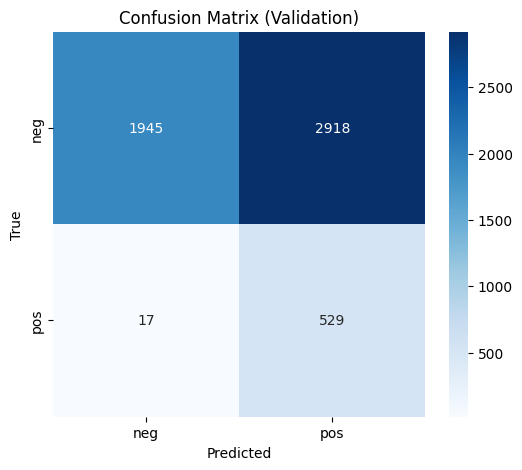

Test Evaluation:   0%|                                                       | 0/511 [00:00<?, ?it/s]

Test Evaluation:   0%|                                               | 1/511 [00:00<04:06,  2.07it/s]

Test Evaluation:   0%|▏                                              | 2/511 [00:00<04:07,  2.06it/s]

Test Evaluation:   1%|▎                                              | 3/511 [00:01<04:07,  2.05it/s]

Test Evaluation:   1%|▎                                              | 4/511 [00:01<04:06,  2.05it/s]

Test Evaluation:   1%|▍                                              | 5/511 [00:02<04:05,  2.06it/s]

Test Evaluation:   1%|▌                                              | 6/511 [00:02<03:55,  2.15it/s]

Test Evaluation:   1%|▋                                              | 7/511 [00:03<03:56,  2.13it/s]

Test Evaluation:   2%|▋                                              | 8/511 [00:03<03:59,  2.10it/s]

Test Evaluation:   2%|▊                                              | 9/511 [00:04<04:00,  2.09it/s]

Test Evaluation:   2%|▉                                             | 10/511 [00:04<03:53,  2.14it/s]

Test Evaluation:   2%|▉                                             | 11/511 [00:05<03:56,  2.12it/s]

Test Evaluation:   2%|█                                             | 12/511 [00:05<03:57,  2.10it/s]

Test Evaluation:   3%|█▏                                            | 13/511 [00:06<03:57,  2.10it/s]

Test Evaluation:   3%|█▎                                            | 14/511 [00:06<03:57,  2.09it/s]

Test Evaluation:   3%|█▎                                            | 15/511 [00:07<03:49,  2.16it/s]

Test Evaluation:   3%|█▍                                            | 16/511 [00:07<03:53,  2.12it/s]

Test Evaluation:   3%|█▌                                            | 17/511 [00:08<03:54,  2.10it/s]

Test Evaluation:   4%|█▌                                            | 18/511 [00:08<03:56,  2.08it/s]

Test Evaluation:   4%|█▋                                            | 19/511 [00:09<03:57,  2.08it/s]

Test Evaluation:   4%|█▊                                            | 20/511 [00:09<03:54,  2.09it/s]

Test Evaluation:   4%|█▉                                            | 21/511 [00:09<03:49,  2.13it/s]

Test Evaluation:   4%|█▉                                            | 22/511 [00:10<03:50,  2.12it/s]

Test Evaluation:   5%|██                                            | 23/511 [00:10<03:52,  2.09it/s]

Test Evaluation:   5%|██▏                                           | 24/511 [00:11<03:49,  2.13it/s]

Test Evaluation:   5%|██▎                                           | 25/511 [00:11<03:47,  2.14it/s]

Test Evaluation:   5%|██▎                                           | 26/511 [00:12<03:51,  2.10it/s]

Test Evaluation:   5%|██▍                                           | 27/511 [00:12<03:51,  2.09it/s]

Test Evaluation:   5%|██▌                                           | 28/511 [00:13<03:44,  2.16it/s]

Test Evaluation:   6%|██▌                                           | 29/511 [00:13<03:46,  2.13it/s]

Test Evaluation:   6%|██▋                                           | 30/511 [00:14<03:47,  2.12it/s]

Test Evaluation:   6%|██▊                                           | 31/511 [00:14<03:48,  2.10it/s]

Test Evaluation:   6%|██▉                                           | 32/511 [00:15<03:40,  2.17it/s]

Test Evaluation:   6%|██▉                                           | 33/511 [00:15<03:43,  2.14it/s]

Test Evaluation:   7%|███                                           | 34/511 [00:16<03:44,  2.13it/s]

Test Evaluation:   7%|███▏                                          | 35/511 [00:16<03:44,  2.12it/s]

Test Evaluation:   7%|███▏                                          | 36/511 [00:17<03:45,  2.11it/s]

Test Evaluation:   7%|███▎                                          | 37/511 [00:17<03:38,  2.17it/s]

Test Evaluation:   7%|███▍                                          | 38/511 [00:17<03:41,  2.14it/s]

Test Evaluation:   8%|███▌                                          | 39/511 [00:18<03:43,  2.12it/s]

Test Evaluation:   8%|███▌                                          | 40/511 [00:18<03:44,  2.09it/s]

Test Evaluation:   8%|███▋                                          | 41/511 [00:19<03:38,  2.15it/s]

Test Evaluation:   8%|███▊                                          | 42/511 [00:19<03:40,  2.13it/s]

Test Evaluation:   8%|███▊                                          | 43/511 [00:20<03:41,  2.12it/s]

Test Evaluation:   9%|███▉                                          | 44/511 [00:20<03:46,  2.06it/s]

Test Evaluation:   9%|████                                          | 45/511 [00:21<03:46,  2.06it/s]

Test Evaluation:   9%|████▏                                         | 46/511 [00:21<03:43,  2.08it/s]

Test Evaluation:   9%|████▏                                         | 47/511 [00:22<03:37,  2.13it/s]

Test Evaluation:   9%|████▎                                         | 48/511 [00:22<03:39,  2.10it/s]

Test Evaluation:  10%|████▍                                         | 49/511 [00:23<03:41,  2.09it/s]

Test Evaluation:  10%|████▌                                         | 50/511 [00:23<03:41,  2.08it/s]

Test Evaluation:  10%|████▌                                         | 51/511 [00:24<03:42,  2.07it/s]

Test Evaluation:  10%|████▋                                         | 52/511 [00:24<03:41,  2.07it/s]

Test Evaluation:  10%|████▊                                         | 53/511 [00:25<03:34,  2.14it/s]

Test Evaluation:  11%|████▊                                         | 54/511 [00:25<03:35,  2.12it/s]

Test Evaluation:  11%|████▉                                         | 55/511 [00:26<03:37,  2.09it/s]

Test Evaluation:  11%|█████                                         | 56/511 [00:26<03:38,  2.08it/s]

Test Evaluation:  11%|█████▏                                        | 57/511 [00:27<03:39,  2.07it/s]

Test Evaluation:  11%|█████▏                                        | 58/511 [00:27<03:38,  2.08it/s]

Test Evaluation:  12%|█████▎                                        | 59/511 [00:27<03:31,  2.14it/s]

Test Evaluation:  12%|█████▍                                        | 60/511 [00:28<03:33,  2.12it/s]

Test Evaluation:  12%|█████▍                                        | 61/511 [00:28<03:34,  2.10it/s]

Test Evaluation:  12%|█████▌                                        | 62/511 [00:29<03:33,  2.11it/s]

Test Evaluation:  12%|█████▋                                        | 63/511 [00:29<03:32,  2.11it/s]

Test Evaluation:  13%|█████▊                                        | 64/511 [00:30<03:31,  2.12it/s]

Test Evaluation:  13%|█████▊                                        | 65/511 [00:30<03:31,  2.11it/s]

Test Evaluation:  13%|█████▉                                        | 66/511 [00:31<03:32,  2.10it/s]

Test Evaluation:  13%|██████                                        | 67/511 [00:31<03:31,  2.10it/s]

Test Evaluation:  13%|██████                                        | 68/511 [00:32<03:30,  2.10it/s]

Test Evaluation:  14%|██████▏                                       | 69/511 [00:32<03:30,  2.10it/s]

Test Evaluation:  14%|██████▎                                       | 70/511 [00:33<03:29,  2.10it/s]

Test Evaluation:  14%|██████▍                                       | 71/511 [00:33<03:29,  2.10it/s]

Test Evaluation:  14%|██████▍                                       | 72/511 [00:34<03:31,  2.07it/s]

Test Evaluation:  14%|██████▌                                       | 73/511 [00:34<03:29,  2.09it/s]

Test Evaluation:  14%|██████▋                                       | 74/511 [00:35<03:29,  2.09it/s]

Test Evaluation:  15%|██████▊                                       | 75/511 [00:35<03:28,  2.09it/s]

Test Evaluation:  15%|██████▊                                       | 76/511 [00:36<03:29,  2.08it/s]

Test Evaluation:  15%|██████▉                                       | 77/511 [00:36<03:28,  2.08it/s]

Test Evaluation:  15%|███████                                       | 78/511 [00:37<03:29,  2.07it/s]

Test Evaluation:  15%|███████                                       | 79/511 [00:37<03:27,  2.08it/s]

Test Evaluation:  16%|███████▏                                      | 80/511 [00:38<03:26,  2.08it/s]

Test Evaluation:  16%|███████▎                                      | 81/511 [00:38<03:28,  2.06it/s]

Test Evaluation:  16%|███████▍                                      | 82/511 [00:39<03:27,  2.07it/s]

Test Evaluation:  16%|███████▍                                      | 83/511 [00:39<03:26,  2.07it/s]

Test Evaluation:  16%|███████▌                                      | 84/511 [00:39<03:25,  2.08it/s]

Test Evaluation:  17%|███████▋                                      | 85/511 [00:40<03:24,  2.08it/s]

Test Evaluation:  17%|███████▋                                      | 86/511 [00:40<03:25,  2.07it/s]

Test Evaluation:  17%|███████▊                                      | 87/511 [00:41<03:25,  2.06it/s]

Test Evaluation:  17%|███████▉                                      | 88/511 [00:41<03:25,  2.06it/s]

Test Evaluation:  17%|████████                                      | 89/511 [00:42<03:23,  2.07it/s]

Test Evaluation:  18%|████████                                      | 90/511 [00:42<03:21,  2.08it/s]

Test Evaluation:  18%|████████▏                                     | 91/511 [00:43<03:22,  2.08it/s]

Test Evaluation:  18%|████████▎                                     | 92/511 [00:43<03:21,  2.08it/s]

Test Evaluation:  18%|████████▎                                     | 93/511 [00:44<03:20,  2.09it/s]

Test Evaluation:  18%|████████▍                                     | 94/511 [00:44<03:20,  2.07it/s]

Test Evaluation:  19%|████████▌                                     | 95/511 [00:45<03:20,  2.08it/s]

Test Evaluation:  19%|████████▋                                     | 96/511 [00:45<03:19,  2.08it/s]

Test Evaluation:  19%|████████▋                                     | 97/511 [00:46<03:19,  2.08it/s]

Test Evaluation:  19%|████████▊                                     | 98/511 [00:46<03:19,  2.07it/s]

Test Evaluation:  19%|████████▉                                     | 99/511 [00:47<03:16,  2.09it/s]

Test Evaluation:  20%|████████▊                                    | 100/511 [00:47<03:10,  2.15it/s]

Test Evaluation:  20%|████████▉                                    | 101/511 [00:48<03:11,  2.14it/s]

Test Evaluation:  20%|████████▉                                    | 102/511 [00:48<03:12,  2.13it/s]

Test Evaluation:  20%|█████████                                    | 103/511 [00:49<03:13,  2.11it/s]

Test Evaluation:  20%|█████████▏                                   | 104/511 [00:49<03:14,  2.10it/s]

Test Evaluation:  21%|█████████▏                                   | 105/511 [00:50<03:13,  2.09it/s]

Test Evaluation:  21%|█████████▎                                   | 106/511 [00:50<03:14,  2.09it/s]

Test Evaluation:  21%|█████████▍                                   | 107/511 [00:50<03:14,  2.08it/s]

Test Evaluation:  21%|█████████▌                                   | 108/511 [00:51<03:14,  2.08it/s]

Test Evaluation:  21%|█████████▌                                   | 109/511 [00:51<03:13,  2.07it/s]

Test Evaluation:  22%|█████████▋                                   | 110/511 [00:52<03:13,  2.08it/s]

Test Evaluation:  22%|█████████▊                                   | 111/511 [00:52<03:12,  2.07it/s]

Test Evaluation:  22%|█████████▊                                   | 112/511 [00:53<03:11,  2.08it/s]

Test Evaluation:  22%|█████████▉                                   | 113/511 [00:53<03:11,  2.07it/s]

Test Evaluation:  22%|██████████                                   | 114/511 [00:54<03:11,  2.07it/s]

Test Evaluation:  23%|██████████▏                                  | 115/511 [00:54<03:09,  2.09it/s]

Test Evaluation:  23%|██████████▏                                  | 116/511 [00:55<03:09,  2.08it/s]

Test Evaluation:  23%|██████████▎                                  | 117/511 [00:55<03:08,  2.09it/s]

Test Evaluation:  23%|██████████▍                                  | 118/511 [00:56<03:08,  2.08it/s]

Test Evaluation:  23%|██████████▍                                  | 119/511 [00:56<03:01,  2.16it/s]

Test Evaluation:  23%|██████████▌                                  | 120/511 [00:57<03:03,  2.13it/s]

Test Evaluation:  24%|██████████▋                                  | 121/511 [00:57<03:05,  2.11it/s]

Test Evaluation:  24%|██████████▋                                  | 122/511 [00:58<03:05,  2.10it/s]

Test Evaluation:  24%|██████████▊                                  | 123/511 [00:58<03:05,  2.09it/s]

Test Evaluation:  24%|██████████▉                                  | 124/511 [00:59<03:05,  2.09it/s]

Test Evaluation:  24%|███████████                                  | 125/511 [00:59<03:04,  2.09it/s]

Test Evaluation:  25%|███████████                                  | 126/511 [01:00<03:04,  2.08it/s]

Test Evaluation:  25%|███████████▏                                 | 127/511 [01:00<03:04,  2.08it/s]

Test Evaluation:  25%|███████████▎                                 | 128/511 [01:01<03:03,  2.09it/s]

Test Evaluation:  25%|███████████▎                                 | 129/511 [01:01<03:03,  2.08it/s]

Test Evaluation:  25%|███████████▍                                 | 130/511 [01:01<03:02,  2.08it/s]

Test Evaluation:  26%|███████████▌                                 | 131/511 [01:02<03:03,  2.07it/s]

Test Evaluation:  26%|███████████▌                                 | 132/511 [01:02<03:02,  2.07it/s]

Test Evaluation:  26%|███████████▋                                 | 133/511 [01:03<03:01,  2.09it/s]

Test Evaluation:  26%|███████████▊                                 | 134/511 [01:03<03:00,  2.09it/s]

Test Evaluation:  26%|███████████▉                                 | 135/511 [01:04<03:00,  2.09it/s]

Test Evaluation:  27%|███████████▉                                 | 136/511 [01:04<03:01,  2.06it/s]

Test Evaluation:  27%|████████████                                 | 137/511 [01:05<03:00,  2.07it/s]

Test Evaluation:  27%|████████████▏                                | 138/511 [01:05<03:00,  2.06it/s]

Test Evaluation:  27%|████████████▏                                | 139/511 [01:06<03:00,  2.06it/s]

Test Evaluation:  27%|████████████▎                                | 140/511 [01:06<03:00,  2.06it/s]

Test Evaluation:  28%|████████████▍                                | 141/511 [01:07<03:00,  2.06it/s]

Test Evaluation:  28%|████████████▌                                | 142/511 [01:07<02:59,  2.06it/s]

Test Evaluation:  28%|████████████▌                                | 143/511 [01:08<02:57,  2.07it/s]

Test Evaluation:  28%|████████████▋                                | 144/511 [01:08<02:56,  2.08it/s]

Test Evaluation:  28%|████████████▊                                | 145/511 [01:09<02:55,  2.08it/s]

Test Evaluation:  29%|████████████▊                                | 146/511 [01:09<02:55,  2.07it/s]

Test Evaluation:  29%|████████████▉                                | 147/511 [01:10<02:54,  2.08it/s]

Test Evaluation:  29%|█████████████                                | 148/511 [01:10<02:54,  2.08it/s]

Test Evaluation:  29%|█████████████                                | 149/511 [01:11<02:52,  2.10it/s]

Test Evaluation:  29%|█████████████▏                               | 150/511 [01:11<02:54,  2.07it/s]

Test Evaluation:  30%|█████████████▎                               | 151/511 [01:12<02:58,  2.02it/s]

Test Evaluation:  30%|█████████████▍                               | 152/511 [01:12<02:55,  2.04it/s]

Test Evaluation:  30%|█████████████▍                               | 153/511 [01:13<02:53,  2.06it/s]

Test Evaluation:  30%|█████████████▌                               | 154/511 [01:13<02:53,  2.05it/s]

Test Evaluation:  30%|█████████████▋                               | 155/511 [01:14<02:52,  2.07it/s]

Test Evaluation:  31%|█████████████▋                               | 156/511 [01:14<02:51,  2.07it/s]

Test Evaluation:  31%|█████████████▊                               | 157/511 [01:15<02:49,  2.08it/s]

Test Evaluation:  31%|█████████████▉                               | 158/511 [01:15<02:50,  2.08it/s]

Test Evaluation:  31%|██████████████                               | 159/511 [01:15<02:43,  2.15it/s]

Test Evaluation:  31%|██████████████                               | 160/511 [01:16<02:45,  2.13it/s]

Test Evaluation:  32%|██████████████▏                              | 161/511 [01:16<02:45,  2.11it/s]

Test Evaluation:  32%|██████████████▎                              | 162/511 [01:17<02:47,  2.09it/s]

Test Evaluation:  32%|██████████████▎                              | 163/511 [01:17<02:46,  2.08it/s]

Test Evaluation:  32%|██████████████▍                              | 164/511 [01:18<02:47,  2.08it/s]

Test Evaluation:  32%|██████████████▌                              | 165/511 [01:18<02:47,  2.07it/s]

Test Evaluation:  32%|██████████████▌                              | 166/511 [01:19<02:46,  2.07it/s]

Test Evaluation:  33%|██████████████▋                              | 167/511 [01:19<02:45,  2.08it/s]

Test Evaluation:  33%|██████████████▊                              | 168/511 [01:20<02:45,  2.07it/s]

Test Evaluation:  33%|██████████████▉                              | 169/511 [01:20<02:44,  2.08it/s]

Test Evaluation:  33%|██████████████▉                              | 170/511 [01:21<02:44,  2.07it/s]

Test Evaluation:  33%|███████████████                              | 171/511 [01:21<02:44,  2.07it/s]

Test Evaluation:  34%|███████████████▏                             | 172/511 [01:22<02:43,  2.07it/s]

Test Evaluation:  34%|███████████████▏                             | 173/511 [01:22<02:43,  2.06it/s]

Test Evaluation:  34%|███████████████▎                             | 174/511 [01:23<02:42,  2.07it/s]

Test Evaluation:  34%|███████████████▍                             | 175/511 [01:23<02:42,  2.07it/s]

Test Evaluation:  34%|███████████████▍                             | 176/511 [01:24<02:41,  2.07it/s]

Test Evaluation:  35%|███████████████▌                             | 177/511 [01:24<02:39,  2.10it/s]

Test Evaluation:  35%|███████████████▋                             | 178/511 [01:25<02:36,  2.13it/s]

Test Evaluation:  35%|███████████████▊                             | 179/511 [01:25<02:37,  2.11it/s]

Test Evaluation:  35%|███████████████▊                             | 180/511 [01:26<02:37,  2.10it/s]

Test Evaluation:  35%|███████████████▉                             | 181/511 [01:26<02:38,  2.08it/s]

Test Evaluation:  36%|████████████████                             | 182/511 [01:27<02:37,  2.09it/s]

Test Evaluation:  36%|████████████████                             | 183/511 [01:27<02:37,  2.09it/s]

Test Evaluation:  36%|████████████████▏                            | 184/511 [01:27<02:36,  2.08it/s]

Test Evaluation:  36%|████████████████▎                            | 185/511 [01:28<02:36,  2.08it/s]

Test Evaluation:  36%|████████████████▍                            | 186/511 [01:28<02:36,  2.07it/s]

Test Evaluation:  37%|████████████████▍                            | 187/511 [01:29<02:36,  2.07it/s]

Test Evaluation:  37%|████████████████▌                            | 188/511 [01:29<02:36,  2.07it/s]

Test Evaluation:  37%|████████████████▋                            | 189/511 [01:30<02:35,  2.08it/s]

Test Evaluation:  37%|████████████████▋                            | 190/511 [01:30<02:34,  2.08it/s]

Test Evaluation:  37%|████████████████▊                            | 191/511 [01:31<02:34,  2.07it/s]

Test Evaluation:  38%|████████████████▉                            | 192/511 [01:31<02:33,  2.08it/s]

Test Evaluation:  38%|████████████████▉                            | 193/511 [01:32<02:32,  2.09it/s]

Test Evaluation:  38%|█████████████████                            | 194/511 [01:32<02:32,  2.09it/s]

Test Evaluation:  38%|█████████████████▏                           | 195/511 [01:33<02:31,  2.08it/s]

Test Evaluation:  38%|█████████████████▎                           | 196/511 [01:33<02:31,  2.08it/s]

Test Evaluation:  39%|█████████████████▎                           | 197/511 [01:34<02:31,  2.07it/s]

Test Evaluation:  39%|█████████████████▍                           | 198/511 [01:34<02:30,  2.08it/s]

Test Evaluation:  39%|█████████████████▌                           | 199/511 [01:35<02:30,  2.07it/s]

Test Evaluation:  39%|█████████████████▌                           | 200/511 [01:35<02:29,  2.08it/s]

Test Evaluation:  39%|█████████████████▋                           | 201/511 [01:36<02:28,  2.09it/s]

Test Evaluation:  40%|█████████████████▊                           | 202/511 [01:36<02:28,  2.08it/s]

Test Evaluation:  40%|█████████████████▉                           | 203/511 [01:37<02:28,  2.07it/s]

Test Evaluation:  40%|█████████████████▉                           | 204/511 [01:37<02:27,  2.08it/s]

Test Evaluation:  40%|██████████████████                           | 205/511 [01:38<02:27,  2.08it/s]

Test Evaluation:  40%|██████████████████▏                          | 206/511 [01:38<02:27,  2.07it/s]

Test Evaluation:  41%|██████████████████▏                          | 207/511 [01:39<02:22,  2.13it/s]

Test Evaluation:  41%|██████████████████▎                          | 208/511 [01:39<02:22,  2.12it/s]

Test Evaluation:  41%|██████████████████▍                          | 209/511 [01:39<02:22,  2.11it/s]

Test Evaluation:  41%|██████████████████▍                          | 210/511 [01:40<02:23,  2.10it/s]

Test Evaluation:  41%|██████████████████▌                          | 211/511 [01:40<02:22,  2.10it/s]

Test Evaluation:  41%|██████████████████▋                          | 212/511 [01:41<02:22,  2.10it/s]

Test Evaluation:  42%|██████████████████▊                          | 213/511 [01:41<02:21,  2.10it/s]

Test Evaluation:  42%|██████████████████▊                          | 214/511 [01:42<02:21,  2.10it/s]

Test Evaluation:  42%|██████████████████▉                          | 215/511 [01:42<02:21,  2.09it/s]

Test Evaluation:  42%|███████████████████                          | 216/511 [01:43<02:22,  2.07it/s]

Test Evaluation:  42%|███████████████████                          | 217/511 [01:43<02:22,  2.06it/s]

Test Evaluation:  43%|███████████████████▏                         | 218/511 [01:44<02:21,  2.07it/s]

Test Evaluation:  43%|███████████████████▎                         | 219/511 [01:44<02:20,  2.08it/s]

Test Evaluation:  43%|███████████████████▎                         | 220/511 [01:45<02:19,  2.08it/s]

Test Evaluation:  43%|███████████████████▍                         | 221/511 [01:45<02:18,  2.09it/s]

Test Evaluation:  43%|███████████████████▌                         | 222/511 [01:46<02:18,  2.09it/s]

Test Evaluation:  44%|███████████████████▋                         | 223/511 [01:46<02:17,  2.09it/s]

Test Evaluation:  44%|███████████████████▋                         | 224/511 [01:47<02:17,  2.08it/s]

Test Evaluation:  44%|███████████████████▊                         | 225/511 [01:47<02:17,  2.08it/s]

Test Evaluation:  44%|███████████████████▉                         | 226/511 [01:48<02:17,  2.08it/s]

Test Evaluation:  44%|███████████████████▉                         | 227/511 [01:48<02:16,  2.08it/s]

Test Evaluation:  45%|████████████████████                         | 228/511 [01:49<02:16,  2.08it/s]

Test Evaluation:  45%|████████████████████▏                        | 229/511 [01:49<02:15,  2.09it/s]

Test Evaluation:  45%|████████████████████▎                        | 230/511 [01:50<02:14,  2.09it/s]

Test Evaluation:  45%|████████████████████▎                        | 231/511 [01:50<02:14,  2.07it/s]

Test Evaluation:  45%|████████████████████▍                        | 232/511 [01:51<02:14,  2.08it/s]

Test Evaluation:  46%|████████████████████▌                        | 233/511 [01:51<02:14,  2.07it/s]

Test Evaluation:  46%|████████████████████▌                        | 234/511 [01:51<02:13,  2.07it/s]

Test Evaluation:  46%|████████████████████▋                        | 235/511 [01:52<02:14,  2.06it/s]

Test Evaluation:  46%|████████████████████▊                        | 236/511 [01:52<02:13,  2.06it/s]

Test Evaluation:  46%|████████████████████▊                        | 237/511 [01:53<02:12,  2.06it/s]

Test Evaluation:  47%|████████████████████▉                        | 238/511 [01:53<02:12,  2.05it/s]

Test Evaluation:  47%|█████████████████████                        | 239/511 [01:54<02:12,  2.05it/s]

Test Evaluation:  47%|█████████████████████▏                       | 240/511 [01:54<02:11,  2.06it/s]

Test Evaluation:  47%|█████████████████████▏                       | 241/511 [01:55<02:10,  2.07it/s]

Test Evaluation:  47%|█████████████████████▎                       | 242/511 [01:55<02:10,  2.06it/s]

Test Evaluation:  48%|█████████████████████▍                       | 243/511 [01:56<02:09,  2.08it/s]

Test Evaluation:  48%|█████████████████████▍                       | 244/511 [01:56<02:08,  2.07it/s]

Test Evaluation:  48%|█████████████████████▌                       | 245/511 [01:57<02:06,  2.09it/s]

Test Evaluation:  48%|█████████████████████▋                       | 246/511 [01:57<02:04,  2.13it/s]

Test Evaluation:  48%|█████████████████████▊                       | 247/511 [01:58<02:05,  2.11it/s]

Test Evaluation:  49%|█████████████████████▊                       | 248/511 [01:58<02:04,  2.10it/s]

Test Evaluation:  49%|█████████████████████▉                       | 249/511 [01:59<02:04,  2.10it/s]

Test Evaluation:  49%|██████████████████████                       | 250/511 [01:59<02:04,  2.09it/s]

Test Evaluation:  49%|██████████████████████                       | 251/511 [02:00<02:04,  2.08it/s]

Test Evaluation:  49%|██████████████████████▏                      | 252/511 [02:00<02:04,  2.08it/s]

Test Evaluation:  50%|██████████████████████▎                      | 253/511 [02:01<02:03,  2.08it/s]

Test Evaluation:  50%|██████████████████████▎                      | 254/511 [02:01<02:02,  2.09it/s]

Test Evaluation:  50%|██████████████████████▍                      | 255/511 [02:02<02:02,  2.09it/s]

Test Evaluation:  50%|██████████████████████▌                      | 256/511 [02:02<02:02,  2.08it/s]

Test Evaluation:  50%|██████████████████████▋                      | 257/511 [02:03<02:02,  2.07it/s]

Test Evaluation:  50%|██████████████████████▋                      | 258/511 [02:03<02:01,  2.07it/s]

Test Evaluation:  51%|██████████████████████▊                      | 259/511 [02:04<02:01,  2.07it/s]

Test Evaluation:  51%|██████████████████████▉                      | 260/511 [02:04<02:01,  2.07it/s]

Test Evaluation:  51%|██████████████████████▉                      | 261/511 [02:04<02:00,  2.07it/s]

Test Evaluation:  51%|███████████████████████                      | 262/511 [02:05<01:59,  2.08it/s]

Test Evaluation:  51%|███████████████████████▏                     | 263/511 [02:05<01:59,  2.07it/s]

Test Evaluation:  52%|███████████████████████▏                     | 264/511 [02:06<01:58,  2.08it/s]

Test Evaluation:  52%|███████████████████████▎                     | 265/511 [02:06<01:58,  2.08it/s]

Test Evaluation:  52%|███████████████████████▍                     | 266/511 [02:07<01:57,  2.09it/s]

Test Evaluation:  52%|███████████████████████▌                     | 267/511 [02:07<01:56,  2.09it/s]

Test Evaluation:  52%|███████████████████████▌                     | 268/511 [02:08<01:56,  2.09it/s]

Test Evaluation:  53%|███████████████████████▋                     | 269/511 [02:08<01:55,  2.09it/s]

Test Evaluation:  53%|███████████████████████▊                     | 270/511 [02:09<01:55,  2.09it/s]

Test Evaluation:  53%|███████████████████████▊                     | 271/511 [02:09<01:54,  2.09it/s]

Test Evaluation:  53%|███████████████████████▉                     | 272/511 [02:10<01:54,  2.08it/s]

Test Evaluation:  53%|████████████████████████                     | 273/511 [02:10<01:53,  2.09it/s]

Test Evaluation:  54%|████████████████████████▏                    | 274/511 [02:11<01:49,  2.16it/s]

Test Evaluation:  54%|████████████████████████▏                    | 275/511 [02:11<01:51,  2.12it/s]

Test Evaluation:  54%|████████████████████████▎                    | 276/511 [02:12<01:52,  2.09it/s]

Test Evaluation:  54%|████████████████████████▍                    | 277/511 [02:12<01:51,  2.09it/s]

Test Evaluation:  54%|████████████████████████▍                    | 278/511 [02:13<01:51,  2.08it/s]

Test Evaluation:  55%|████████████████████████▌                    | 279/511 [02:13<01:51,  2.09it/s]

Test Evaluation:  55%|████████████████████████▋                    | 280/511 [02:14<01:50,  2.09it/s]

Test Evaluation:  55%|████████████████████████▋                    | 281/511 [02:14<01:50,  2.09it/s]

Test Evaluation:  55%|████████████████████████▊                    | 282/511 [02:15<01:50,  2.08it/s]

Test Evaluation:  55%|████████████████████████▉                    | 283/511 [02:15<01:48,  2.09it/s]

Test Evaluation:  56%|█████████████████████████                    | 284/511 [02:15<01:47,  2.10it/s]

Test Evaluation:  56%|█████████████████████████                    | 285/511 [02:16<01:47,  2.09it/s]

Test Evaluation:  56%|█████████████████████████▏                   | 286/511 [02:16<01:46,  2.10it/s]

Test Evaluation:  56%|█████████████████████████▎                   | 287/511 [02:17<01:46,  2.10it/s]

Test Evaluation:  56%|█████████████████████████▎                   | 288/511 [02:17<01:46,  2.09it/s]

Test Evaluation:  57%|█████████████████████████▍                   | 289/511 [02:18<01:46,  2.09it/s]

Test Evaluation:  57%|█████████████████████████▌                   | 290/511 [02:18<01:46,  2.08it/s]

Test Evaluation:  57%|█████████████████████████▋                   | 291/511 [02:19<01:46,  2.07it/s]

Test Evaluation:  57%|█████████████████████████▋                   | 292/511 [02:19<01:45,  2.07it/s]

Test Evaluation:  57%|█████████████████████████▊                   | 293/511 [02:20<01:44,  2.09it/s]

Test Evaluation:  58%|█████████████████████████▉                   | 294/511 [02:20<01:43,  2.09it/s]

Test Evaluation:  58%|█████████████████████████▉                   | 295/511 [02:21<01:43,  2.08it/s]

Test Evaluation:  58%|██████████████████████████                   | 296/511 [02:21<01:43,  2.07it/s]

Test Evaluation:  58%|██████████████████████████▏                  | 297/511 [02:22<01:43,  2.07it/s]

Test Evaluation:  58%|██████████████████████████▏                  | 298/511 [02:22<01:42,  2.07it/s]

Test Evaluation:  59%|██████████████████████████▎                  | 299/511 [02:23<01:42,  2.08it/s]

Test Evaluation:  59%|██████████████████████████▍                  | 300/511 [02:23<01:41,  2.08it/s]

Test Evaluation:  59%|██████████████████████████▌                  | 301/511 [02:24<01:40,  2.09it/s]

Test Evaluation:  59%|██████████████████████████▌                  | 302/511 [02:24<01:40,  2.08it/s]

Test Evaluation:  59%|██████████████████████████▋                  | 303/511 [02:25<01:39,  2.08it/s]

Test Evaluation:  59%|██████████████████████████▊                  | 304/511 [02:25<01:39,  2.09it/s]

Test Evaluation:  60%|██████████████████████████▊                  | 305/511 [02:26<01:38,  2.10it/s]

Test Evaluation:  60%|██████████████████████████▉                  | 306/511 [02:26<01:38,  2.09it/s]

Test Evaluation:  60%|███████████████████████████                  | 307/511 [02:26<01:36,  2.11it/s]

Test Evaluation:  60%|███████████████████████████                  | 308/511 [02:27<01:36,  2.09it/s]

Test Evaluation:  60%|███████████████████████████▏                 | 309/511 [02:27<01:36,  2.08it/s]

Test Evaluation:  61%|███████████████████████████▎                 | 310/511 [02:28<01:37,  2.07it/s]

Test Evaluation:  61%|███████████████████████████▍                 | 311/511 [02:28<01:34,  2.12it/s]

Test Evaluation:  61%|███████████████████████████▍                 | 312/511 [02:29<01:32,  2.14it/s]

Test Evaluation:  61%|███████████████████████████▌                 | 313/511 [02:29<01:33,  2.12it/s]

Test Evaluation:  61%|███████████████████████████▋                 | 314/511 [02:30<01:33,  2.11it/s]

Test Evaluation:  62%|███████████████████████████▋                 | 315/511 [02:30<01:33,  2.09it/s]

Test Evaluation:  62%|███████████████████████████▊                 | 316/511 [02:31<01:32,  2.10it/s]

Test Evaluation:  62%|███████████████████████████▉                 | 317/511 [02:31<01:32,  2.09it/s]

Test Evaluation:  62%|████████████████████████████                 | 318/511 [02:32<01:32,  2.09it/s]

Test Evaluation:  62%|████████████████████████████                 | 319/511 [02:32<01:31,  2.09it/s]

Test Evaluation:  63%|████████████████████████████▏                | 320/511 [02:33<01:31,  2.09it/s]

Test Evaluation:  63%|████████████████████████████▎                | 321/511 [02:33<01:30,  2.09it/s]

Test Evaluation:  63%|████████████████████████████▎                | 322/511 [02:34<01:31,  2.08it/s]

Test Evaluation:  63%|████████████████████████████▍                | 323/511 [02:34<01:30,  2.07it/s]

Test Evaluation:  63%|████████████████████████████▌                | 324/511 [02:35<01:30,  2.07it/s]

Test Evaluation:  64%|████████████████████████████▌                | 325/511 [02:35<01:29,  2.07it/s]

Test Evaluation:  64%|████████████████████████████▋                | 326/511 [02:36<01:29,  2.07it/s]

Test Evaluation:  64%|████████████████████████████▊                | 327/511 [02:36<01:29,  2.07it/s]

Test Evaluation:  64%|████████████████████████████▉                | 328/511 [02:37<01:28,  2.07it/s]

Test Evaluation:  64%|████████████████████████████▉                | 329/511 [02:37<01:28,  2.06it/s]

Test Evaluation:  65%|█████████████████████████████                | 330/511 [02:38<01:27,  2.06it/s]

Test Evaluation:  65%|█████████████████████████████▏               | 331/511 [02:38<01:26,  2.08it/s]

Test Evaluation:  65%|█████████████████████████████▏               | 332/511 [02:38<01:26,  2.08it/s]

Test Evaluation:  65%|█████████████████████████████▎               | 333/511 [02:39<01:25,  2.08it/s]

Test Evaluation:  65%|█████████████████████████████▍               | 334/511 [02:39<01:25,  2.08it/s]

Test Evaluation:  66%|█████████████████████████████▌               | 335/511 [02:40<01:24,  2.07it/s]

Test Evaluation:  66%|█████████████████████████████▌               | 336/511 [02:40<01:24,  2.07it/s]

Test Evaluation:  66%|█████████████████████████████▋               | 337/511 [02:41<01:23,  2.07it/s]

Test Evaluation:  66%|█████████████████████████████▊               | 338/511 [02:41<01:23,  2.07it/s]

Test Evaluation:  66%|█████████████████████████████▊               | 339/511 [02:42<01:21,  2.10it/s]

Test Evaluation:  67%|█████████████████████████████▉               | 340/511 [02:42<01:21,  2.09it/s]

Test Evaluation:  67%|██████████████████████████████               | 341/511 [02:43<01:21,  2.09it/s]

Test Evaluation:  67%|██████████████████████████████               | 342/511 [02:43<01:20,  2.09it/s]

Test Evaluation:  67%|██████████████████████████████▏              | 343/511 [02:44<01:20,  2.09it/s]

Test Evaluation:  67%|██████████████████████████████▎              | 344/511 [02:44<01:20,  2.09it/s]

Test Evaluation:  68%|██████████████████████████████▍              | 345/511 [02:45<01:20,  2.07it/s]

Test Evaluation:  68%|██████████████████████████████▍              | 346/511 [02:45<01:19,  2.08it/s]

Test Evaluation:  68%|██████████████████████████████▌              | 347/511 [02:46<01:18,  2.09it/s]

Test Evaluation:  68%|██████████████████████████████▋              | 348/511 [02:46<01:17,  2.09it/s]

Test Evaluation:  68%|██████████████████████████████▋              | 349/511 [02:47<01:17,  2.09it/s]

Test Evaluation:  68%|██████████████████████████████▊              | 350/511 [02:47<01:17,  2.08it/s]

Test Evaluation:  69%|██████████████████████████████▉              | 351/511 [02:48<01:16,  2.08it/s]

Test Evaluation:  69%|██████████████████████████████▉              | 352/511 [02:48<01:16,  2.08it/s]

Test Evaluation:  69%|███████████████████████████████              | 353/511 [02:49<01:16,  2.07it/s]

Test Evaluation:  69%|███████████████████████████████▏             | 354/511 [02:49<01:15,  2.08it/s]

Test Evaluation:  69%|███████████████████████████████▎             | 355/511 [02:50<01:14,  2.09it/s]

Test Evaluation:  70%|███████████████████████████████▎             | 356/511 [02:50<01:14,  2.08it/s]

Test Evaluation:  70%|███████████████████████████████▍             | 357/511 [02:50<01:13,  2.09it/s]

Test Evaluation:  70%|███████████████████████████████▌             | 358/511 [02:51<01:13,  2.09it/s]

Test Evaluation:  70%|███████████████████████████████▌             | 359/511 [02:51<01:12,  2.09it/s]

Test Evaluation:  70%|███████████████████████████████▋             | 360/511 [02:52<01:12,  2.08it/s]

Test Evaluation:  71%|███████████████████████████████▊             | 361/511 [02:52<01:11,  2.09it/s]

Test Evaluation:  71%|███████████████████████████████▉             | 362/511 [02:53<01:11,  2.08it/s]

Test Evaluation:  71%|███████████████████████████████▉             | 363/511 [02:53<01:11,  2.08it/s]

Test Evaluation:  71%|████████████████████████████████             | 364/511 [02:54<01:10,  2.08it/s]

Test Evaluation:  71%|████████████████████████████████▏            | 365/511 [02:54<01:08,  2.13it/s]

Test Evaluation:  72%|████████████████████████████████▏            | 366/511 [02:55<01:08,  2.10it/s]

Test Evaluation:  72%|████████████████████████████████▎            | 367/511 [02:55<01:08,  2.10it/s]

Test Evaluation:  72%|████████████████████████████████▍            | 368/511 [02:56<01:08,  2.09it/s]

Test Evaluation:  72%|████████████████████████████████▍            | 369/511 [02:56<01:08,  2.08it/s]

Test Evaluation:  72%|████████████████████████████████▌            | 370/511 [02:57<01:07,  2.10it/s]

Test Evaluation:  73%|████████████████████████████████▋            | 371/511 [02:57<01:06,  2.09it/s]

Test Evaluation:  73%|████████████████████████████████▊            | 372/511 [02:58<01:06,  2.08it/s]

Test Evaluation:  73%|████████████████████████████████▊            | 373/511 [02:58<01:06,  2.07it/s]

Test Evaluation:  73%|████████████████████████████████▉            | 374/511 [02:59<01:06,  2.07it/s]

Test Evaluation:  73%|█████████████████████████████████            | 375/511 [02:59<01:05,  2.06it/s]

Test Evaluation:  74%|█████████████████████████████████            | 376/511 [03:00<01:05,  2.06it/s]

Test Evaluation:  74%|█████████████████████████████████▏           | 377/511 [03:00<01:04,  2.07it/s]

Test Evaluation:  74%|█████████████████████████████████▎           | 378/511 [03:01<01:04,  2.07it/s]

Test Evaluation:  74%|█████████████████████████████████▍           | 379/511 [03:01<01:03,  2.08it/s]

Test Evaluation:  74%|█████████████████████████████████▍           | 380/511 [03:02<01:03,  2.07it/s]

Test Evaluation:  75%|█████████████████████████████████▌           | 381/511 [03:02<01:02,  2.07it/s]

Test Evaluation:  75%|█████████████████████████████████▋           | 382/511 [03:03<01:02,  2.07it/s]

Test Evaluation:  75%|█████████████████████████████████▋           | 383/511 [03:03<01:02,  2.06it/s]

Test Evaluation:  75%|█████████████████████████████████▊           | 384/511 [03:03<01:01,  2.06it/s]

Test Evaluation:  75%|█████████████████████████████████▉           | 385/511 [03:04<01:01,  2.06it/s]

Test Evaluation:  76%|█████████████████████████████████▉           | 386/511 [03:04<01:00,  2.06it/s]

Test Evaluation:  76%|██████████████████████████████████           | 387/511 [03:05<01:00,  2.05it/s]

Test Evaluation:  76%|██████████████████████████████████▏          | 388/511 [03:05<00:59,  2.06it/s]

Test Evaluation:  76%|██████████████████████████████████▎          | 389/511 [03:06<00:59,  2.06it/s]

Test Evaluation:  76%|██████████████████████████████████▎          | 390/511 [03:06<00:58,  2.06it/s]

Test Evaluation:  77%|██████████████████████████████████▍          | 391/511 [03:07<00:57,  2.07it/s]

Test Evaluation:  77%|██████████████████████████████████▌          | 392/511 [03:07<00:57,  2.07it/s]

Test Evaluation:  77%|██████████████████████████████████▌          | 393/511 [03:08<00:56,  2.07it/s]

Test Evaluation:  77%|██████████████████████████████████▋          | 394/511 [03:08<00:56,  2.06it/s]

Test Evaluation:  77%|██████████████████████████████████▊          | 395/511 [03:09<00:56,  2.06it/s]

Test Evaluation:  77%|██████████████████████████████████▊          | 396/511 [03:09<00:55,  2.07it/s]

Test Evaluation:  78%|██████████████████████████████████▉          | 397/511 [03:10<00:55,  2.07it/s]

Test Evaluation:  78%|███████████████████████████████████          | 398/511 [03:10<00:54,  2.07it/s]

Test Evaluation:  78%|███████████████████████████████████▏         | 399/511 [03:11<00:53,  2.08it/s]

Test Evaluation:  78%|███████████████████████████████████▏         | 400/511 [03:11<00:53,  2.08it/s]

Test Evaluation:  78%|███████████████████████████████████▎         | 401/511 [03:12<00:53,  2.07it/s]

Test Evaluation:  79%|███████████████████████████████████▍         | 402/511 [03:12<00:52,  2.06it/s]

Test Evaluation:  79%|███████████████████████████████████▍         | 403/511 [03:13<00:52,  2.06it/s]

Test Evaluation:  79%|███████████████████████████████████▌         | 404/511 [03:13<00:51,  2.06it/s]

Test Evaluation:  79%|███████████████████████████████████▋         | 405/511 [03:14<00:51,  2.07it/s]

Test Evaluation:  79%|███████████████████████████████████▊         | 406/511 [03:14<00:50,  2.07it/s]

Test Evaluation:  80%|███████████████████████████████████▊         | 407/511 [03:15<00:50,  2.08it/s]

Test Evaluation:  80%|███████████████████████████████████▉         | 408/511 [03:15<00:49,  2.08it/s]

Test Evaluation:  80%|████████████████████████████████████         | 409/511 [03:16<00:49,  2.07it/s]

Test Evaluation:  80%|████████████████████████████████████         | 410/511 [03:16<00:47,  2.13it/s]

Test Evaluation:  80%|████████████████████████████████████▏        | 411/511 [03:16<00:47,  2.11it/s]

Test Evaluation:  81%|████████████████████████████████████▎        | 412/511 [03:17<00:47,  2.10it/s]

Test Evaluation:  81%|████████████████████████████████████▎        | 413/511 [03:17<00:46,  2.10it/s]

Test Evaluation:  81%|████████████████████████████████████▍        | 414/511 [03:18<00:46,  2.08it/s]

Test Evaluation:  81%|████████████████████████████████████▌        | 415/511 [03:18<00:46,  2.07it/s]

Test Evaluation:  81%|████████████████████████████████████▋        | 416/511 [03:19<00:46,  2.05it/s]

Test Evaluation:  82%|████████████████████████████████████▋        | 417/511 [03:19<00:45,  2.05it/s]

Test Evaluation:  82%|████████████████████████████████████▊        | 418/511 [03:20<00:45,  2.05it/s]

Test Evaluation:  82%|████████████████████████████████████▉        | 419/511 [03:20<00:44,  2.05it/s]

Test Evaluation:  82%|████████████████████████████████████▉        | 420/511 [03:21<00:44,  2.06it/s]

Test Evaluation:  82%|█████████████████████████████████████        | 421/511 [03:21<00:43,  2.06it/s]

Test Evaluation:  83%|█████████████████████████████████████▏       | 422/511 [03:22<00:43,  2.05it/s]

Test Evaluation:  83%|█████████████████████████████████████▎       | 423/511 [03:22<00:42,  2.05it/s]

Test Evaluation:  83%|█████████████████████████████████████▎       | 424/511 [03:23<00:42,  2.05it/s]

Test Evaluation:  83%|█████████████████████████████████████▍       | 425/511 [03:23<00:41,  2.06it/s]

Test Evaluation:  83%|█████████████████████████████████████▌       | 426/511 [03:24<00:41,  2.06it/s]

Test Evaluation:  84%|█████████████████████████████████████▌       | 427/511 [03:24<00:41,  2.05it/s]

Test Evaluation:  84%|█████████████████████████████████████▋       | 428/511 [03:25<00:40,  2.05it/s]

Test Evaluation:  84%|█████████████████████████████████████▊       | 429/511 [03:25<00:40,  2.05it/s]

Test Evaluation:  84%|█████████████████████████████████████▊       | 430/511 [03:26<00:39,  2.03it/s]

Test Evaluation:  84%|█████████████████████████████████████▉       | 431/511 [03:26<00:39,  2.05it/s]

Test Evaluation:  85%|██████████████████████████████████████       | 432/511 [03:27<00:38,  2.05it/s]

Test Evaluation:  85%|██████████████████████████████████████▏      | 433/511 [03:27<00:37,  2.06it/s]

Test Evaluation:  85%|██████████████████████████████████████▏      | 434/511 [03:28<00:35,  2.14it/s]

Test Evaluation:  85%|██████████████████████████████████████▎      | 435/511 [03:28<00:35,  2.12it/s]

Test Evaluation:  85%|██████████████████████████████████████▍      | 436/511 [03:29<00:35,  2.10it/s]

Test Evaluation:  86%|██████████████████████████████████████▍      | 437/511 [03:29<00:35,  2.07it/s]

Test Evaluation:  86%|██████████████████████████████████████▌      | 438/511 [03:30<00:35,  2.06it/s]

Test Evaluation:  86%|██████████████████████████████████████▋      | 439/511 [03:30<00:34,  2.06it/s]

Test Evaluation:  86%|██████████████████████████████████████▋      | 440/511 [03:31<00:34,  2.06it/s]

Test Evaluation:  86%|██████████████████████████████████████▊      | 441/511 [03:31<00:34,  2.05it/s]

Test Evaluation:  86%|██████████████████████████████████████▉      | 442/511 [03:32<00:33,  2.05it/s]

Test Evaluation:  87%|███████████████████████████████████████      | 443/511 [03:32<00:33,  2.04it/s]

Test Evaluation:  87%|███████████████████████████████████████      | 444/511 [03:33<00:32,  2.05it/s]

Test Evaluation:  87%|███████████████████████████████████████▏     | 445/511 [03:33<00:32,  2.04it/s]

Test Evaluation:  87%|███████████████████████████████████████▎     | 446/511 [03:34<00:31,  2.05it/s]

Test Evaluation:  87%|███████████████████████████████████████▎     | 447/511 [03:34<00:31,  2.05it/s]

Test Evaluation:  88%|███████████████████████████████████████▍     | 448/511 [03:34<00:30,  2.06it/s]

Test Evaluation:  88%|███████████████████████████████████████▌     | 449/511 [03:35<00:30,  2.06it/s]

Test Evaluation:  88%|███████████████████████████████████████▋     | 450/511 [03:35<00:29,  2.06it/s]

Test Evaluation:  88%|███████████████████████████████████████▋     | 451/511 [03:36<00:29,  2.06it/s]

Test Evaluation:  88%|███████████████████████████████████████▊     | 452/511 [03:36<00:28,  2.06it/s]

Test Evaluation:  89%|███████████████████████████████████████▉     | 453/511 [03:37<00:28,  2.05it/s]

Test Evaluation:  89%|███████████████████████████████████████▉     | 454/511 [03:37<00:27,  2.05it/s]

Test Evaluation:  89%|████████████████████████████████████████     | 455/511 [03:38<00:27,  2.05it/s]

Test Evaluation:  89%|████████████████████████████████████████▏    | 456/511 [03:38<00:26,  2.06it/s]

Test Evaluation:  89%|████████████████████████████████████████▏    | 457/511 [03:39<00:26,  2.06it/s]

Test Evaluation:  90%|████████████████████████████████████████▎    | 458/511 [03:39<00:25,  2.07it/s]

Test Evaluation:  90%|████████████████████████████████████████▍    | 459/511 [03:40<00:25,  2.07it/s]

Test Evaluation:  90%|████████████████████████████████████████▌    | 460/511 [03:40<00:24,  2.06it/s]

Test Evaluation:  90%|████████████████████████████████████████▌    | 461/511 [03:41<00:24,  2.07it/s]

Test Evaluation:  90%|████████████████████████████████████████▋    | 462/511 [03:41<00:23,  2.06it/s]

Test Evaluation:  91%|████████████████████████████████████████▊    | 463/511 [03:42<00:22,  2.09it/s]

Test Evaluation:  91%|████████████████████████████████████████▊    | 464/511 [03:42<00:22,  2.08it/s]

Test Evaluation:  91%|████████████████████████████████████████▉    | 465/511 [03:43<00:22,  2.07it/s]

Test Evaluation:  91%|█████████████████████████████████████████    | 466/511 [03:43<00:21,  2.07it/s]

Test Evaluation:  91%|█████████████████████████████████████████▏   | 467/511 [03:44<00:21,  2.07it/s]

Test Evaluation:  92%|█████████████████████████████████████████▏   | 468/511 [03:44<00:20,  2.06it/s]

Test Evaluation:  92%|█████████████████████████████████████████▎   | 469/511 [03:45<00:20,  2.06it/s]

Test Evaluation:  92%|█████████████████████████████████████████▍   | 470/511 [03:45<00:19,  2.07it/s]

Test Evaluation:  92%|█████████████████████████████████████████▍   | 471/511 [03:46<00:19,  2.06it/s]

Test Evaluation:  92%|█████████████████████████████████████████▌   | 472/511 [03:46<00:18,  2.07it/s]

Test Evaluation:  93%|█████████████████████████████████████████▋   | 473/511 [03:47<00:18,  2.08it/s]

Test Evaluation:  93%|█████████████████████████████████████████▋   | 474/511 [03:47<00:17,  2.09it/s]

Test Evaluation:  93%|█████████████████████████████████████████▊   | 475/511 [03:48<00:17,  2.08it/s]

Test Evaluation:  93%|█████████████████████████████████████████▉   | 476/511 [03:48<00:16,  2.07it/s]

Test Evaluation:  93%|██████████████████████████████████████████   | 477/511 [03:48<00:16,  2.09it/s]

Test Evaluation:  94%|██████████████████████████████████████████   | 478/511 [03:49<00:15,  2.08it/s]

Test Evaluation:  94%|██████████████████████████████████████████▏  | 479/511 [03:49<00:15,  2.08it/s]

Test Evaluation:  94%|██████████████████████████████████████████▎  | 480/511 [03:50<00:14,  2.08it/s]

Test Evaluation:  94%|██████████████████████████████████████████▎  | 481/511 [03:50<00:14,  2.08it/s]

Test Evaluation:  94%|██████████████████████████████████████████▍  | 482/511 [03:51<00:13,  2.13it/s]

Test Evaluation:  95%|██████████████████████████████████████████▌  | 483/511 [03:51<00:13,  2.13it/s]

Test Evaluation:  95%|██████████████████████████████████████████▌  | 484/511 [03:52<00:12,  2.11it/s]

Test Evaluation:  95%|██████████████████████████████████████████▋  | 485/511 [03:52<00:12,  2.09it/s]

Test Evaluation:  95%|██████████████████████████████████████████▊  | 486/511 [03:53<00:11,  2.09it/s]

Test Evaluation:  95%|██████████████████████████████████████████▉  | 487/511 [03:53<00:11,  2.08it/s]

Test Evaluation:  95%|██████████████████████████████████████████▉  | 488/511 [03:54<00:11,  2.08it/s]

Test Evaluation:  96%|███████████████████████████████████████████  | 489/511 [03:54<00:10,  2.07it/s]

Test Evaluation:  96%|███████████████████████████████████████████▏ | 490/511 [03:55<00:10,  2.06it/s]

Test Evaluation:  96%|███████████████████████████████████████████▏ | 491/511 [03:55<00:09,  2.07it/s]

Test Evaluation:  96%|███████████████████████████████████████████▎ | 492/511 [03:56<00:09,  2.07it/s]

Test Evaluation:  96%|███████████████████████████████████████████▍ | 493/511 [03:56<00:08,  2.07it/s]

Test Evaluation:  97%|███████████████████████████████████████████▌ | 494/511 [03:57<00:08,  2.07it/s]

Test Evaluation:  97%|███████████████████████████████████████████▌ | 495/511 [03:57<00:07,  2.07it/s]

Test Evaluation:  97%|███████████████████████████████████████████▋ | 496/511 [03:58<00:07,  2.08it/s]

Test Evaluation:  97%|███████████████████████████████████████████▊ | 497/511 [03:58<00:06,  2.08it/s]

Test Evaluation:  97%|███████████████████████████████████████████▊ | 498/511 [03:59<00:06,  2.08it/s]

Test Evaluation:  98%|███████████████████████████████████████████▉ | 499/511 [03:59<00:05,  2.08it/s]

Test Evaluation:  98%|████████████████████████████████████████████ | 500/511 [04:00<00:05,  2.07it/s]

Test Evaluation:  98%|████████████████████████████████████████████ | 501/511 [04:00<00:04,  2.08it/s]

Test Evaluation:  98%|████████████████████████████████████████████▏| 502/511 [04:01<00:04,  2.07it/s]

Test Evaluation:  98%|████████████████████████████████████████████▎| 503/511 [04:01<00:03,  2.08it/s]

Test Evaluation:  99%|████████████████████████████████████████████▍| 504/511 [04:01<00:03,  2.08it/s]

Test Evaluation:  99%|████████████████████████████████████████████▍| 505/511 [04:02<00:02,  2.07it/s]

Test Evaluation:  99%|████████████████████████████████████████████▌| 506/511 [04:02<00:02,  2.07it/s]

Test Evaluation:  99%|████████████████████████████████████████████▋| 507/511 [04:03<00:01,  2.07it/s]

Test Evaluation:  99%|████████████████████████████████████████████▋| 508/511 [04:03<00:01,  2.07it/s]

Test Evaluation: 100%|████████████████████████████████████████████▊| 509/511 [04:04<00:00,  2.07it/s]

Test Evaluation: 100%|████████████████████████████████████████████▉| 510/511 [04:04<00:00,  2.08it/s]

Test Evaluation: 100%|█████████████████████████████████████████████| 511/511 [04:05<00:00,  2.24it/s]

Test Evaluation: 100%|█████████████████████████████████████████████| 511/511 [04:05<00:00,  2.08it/s]

Test Loss: 0.3934 | Test Acc: 64.11% | Test F1: 0.5559
Classification Report (Test):
              precision    recall  f1-score   support

         neg       0.98      0.61      0.75      7240
         pos       0.23      0.89      0.36       934

    accuracy                           0.64      8174
   macro avg       0.60      0.75      0.56      8174
weighted avg       0.89      0.64      0.71      8174



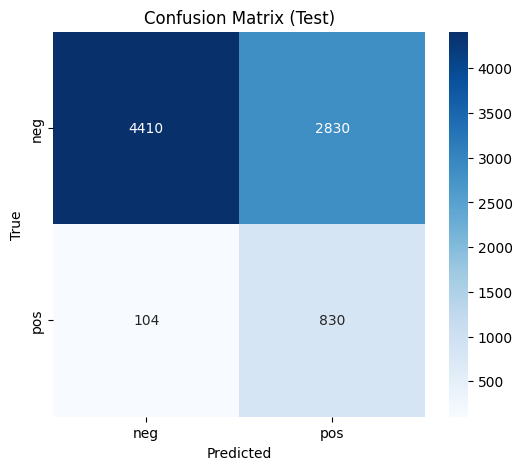

Epoch 4 Summary:
Train Loss: 0.1972 | Train Acc: 82.73% | Train F1: 0.8245
Val Loss: 0.4539 | Val Acc: 45.74% | Val F1: 0.4175
Test Loss: 0.3934 | Test Acc: 64.11% | Test F1: 0.5559
Epoch Time: 970.89s | GPU Memory Usage: 767.04 MB



Checkpoint saved at checkpoints\epoch_4.pth
No improvement in validation loss for 1 epoch(s).


Training:   0%|                                                              | 0/470 [00:00<?, ?it/s]

Training:   0%|                           | 0/470 [00:01<?, ?it/s, Loss=0.1535, F1=0.5897, Acc=75.00]

Training:   0%|                   | 1/470 [00:01<09:12,  1.18s/it, Loss=0.1535, F1=0.5897, Acc=75.00]

Training:   0%|                   | 1/470 [00:02<09:12,  1.18s/it, Loss=0.2169, F1=0.5429, Acc=68.75]

Training:   0%|                   | 2/470 [00:02<09:14,  1.18s/it, Loss=0.2169, F1=0.5429, Acc=68.75]

Training:   0%|                   | 2/470 [00:03<09:14,  1.18s/it, Loss=0.2158, F1=0.6471, Acc=70.83]

Training:   1%|                   | 3/470 [00:03<09:15,  1.19s/it, Loss=0.2158, F1=0.6471, Acc=70.83]

Training:   1%|                   | 3/470 [00:04<09:15,  1.19s/it, Loss=0.1752, F1=0.7149, Acc=76.56]

Training:   1%|▏                  | 4/470 [00:04<09:05,  1.17s/it, Loss=0.1752, F1=0.7149, Acc=76.56]

Training:   1%|▏                  | 4/470 [00:05<09:05,  1.17s/it, Loss=0.1930, F1=0.7484, Acc=77.50]

Training:   1%|▏                  | 5/470 [00:05<09:09,  1.18s/it, Loss=0.1930, F1=0.7484, Acc=77.50]

Training:   1%|▏                  | 5/470 [00:07<09:09,  1.18s/it, Loss=0.2094, F1=0.7723, Acc=79.17]

Training:   1%|▏                  | 6/470 [00:07<09:12,  1.19s/it, Loss=0.2094, F1=0.7723, Acc=79.17]

Training:   1%|▏                  | 6/470 [00:08<09:12,  1.19s/it, Loss=0.1886, F1=0.8027, Acc=81.25]

Training:   1%|▎                  | 7/470 [00:08<09:07,  1.18s/it, Loss=0.1886, F1=0.8027, Acc=81.25]

Training:   1%|▎                  | 7/470 [00:09<09:07,  1.18s/it, Loss=0.1694, F1=0.8314, Acc=83.59]

Training:   2%|▎                  | 8/470 [00:09<09:14,  1.20s/it, Loss=0.1694, F1=0.8314, Acc=83.59]

Training:   2%|▎                  | 8/470 [00:10<09:14,  1.20s/it, Loss=0.2056, F1=0.8380, Acc=84.03]

Training:   2%|▎                  | 9/470 [00:10<09:06,  1.18s/it, Loss=0.2056, F1=0.8380, Acc=84.03]

Training:   2%|▎                  | 9/470 [00:11<09:06,  1.18s/it, Loss=0.2176, F1=0.8488, Acc=85.00]

Training:   2%|▍                 | 10/470 [00:11<09:18,  1.22s/it, Loss=0.2176, F1=0.8488, Acc=85.00]

Training:   2%|▍                 | 10/470 [00:13<09:18,  1.22s/it, Loss=0.2356, F1=0.8463, Acc=84.66]

Training:   2%|▍                 | 11/470 [00:13<09:08,  1.20s/it, Loss=0.2356, F1=0.8463, Acc=84.66]

Training:   2%|▍                 | 11/470 [00:14<09:08,  1.20s/it, Loss=0.2348, F1=0.8539, Acc=85.42]

Training:   3%|▍                 | 12/470 [00:14<09:07,  1.20s/it, Loss=0.2348, F1=0.8539, Acc=85.42]

Training:   3%|▍                 | 12/470 [00:15<09:07,  1.20s/it, Loss=0.2519, F1=0.8508, Acc=85.10]

Training:   3%|▍                 | 13/470 [00:15<09:00,  1.18s/it, Loss=0.2519, F1=0.8508, Acc=85.10]

Training:   3%|▍                 | 13/470 [00:16<09:00,  1.18s/it, Loss=0.2518, F1=0.8571, Acc=85.71]

Training:   3%|▌                 | 14/470 [00:16<09:04,  1.19s/it, Loss=0.2518, F1=0.8571, Acc=85.71]

Training:   3%|▌                 | 14/470 [00:17<09:04,  1.19s/it, Loss=0.2498, F1=0.8583, Acc=85.83]

Training:   3%|▌                 | 15/470 [00:17<09:13,  1.22s/it, Loss=0.2498, F1=0.8583, Acc=85.83]

Training:   3%|▌                 | 15/470 [00:19<09:13,  1.22s/it, Loss=0.2452, F1=0.8633, Acc=86.33]

Training:   3%|▌                 | 16/470 [00:19<09:05,  1.20s/it, Loss=0.2452, F1=0.8633, Acc=86.33]

Training:   3%|▌                 | 16/470 [00:20<09:05,  1.20s/it, Loss=0.2411, F1=0.8529, Acc=85.29]

Training:   4%|▋                 | 17/470 [00:20<08:59,  1.19s/it, Loss=0.2411, F1=0.8529, Acc=85.29]

Training:   4%|▋                 | 17/470 [00:21<08:59,  1.19s/it, Loss=0.2401, F1=0.8402, Acc=84.03]

Training:   4%|▋                 | 18/470 [00:21<09:05,  1.21s/it, Loss=0.2401, F1=0.8402, Acc=84.03]

Training:   4%|▋                 | 18/470 [00:22<09:05,  1.21s/it, Loss=0.2385, F1=0.8187, Acc=81.91]

Training:   4%|▋                 | 19/470 [00:22<08:58,  1.19s/it, Loss=0.2385, F1=0.8187, Acc=81.91]

Training:   4%|▋                 | 19/470 [00:23<08:58,  1.19s/it, Loss=0.2459, F1=0.7965, Acc=79.69]

Training:   4%|▊                 | 20/470 [00:23<08:53,  1.19s/it, Loss=0.2459, F1=0.7965, Acc=79.69]

Training:   4%|▊                 | 20/470 [00:25<08:53,  1.19s/it, Loss=0.2396, F1=0.7938, Acc=79.46]

Training:   4%|▊                 | 21/470 [00:25<08:52,  1.19s/it, Loss=0.2396, F1=0.7938, Acc=79.46]

Training:   4%|▊                 | 21/470 [00:26<08:52,  1.19s/it, Loss=0.2353, F1=0.7863, Acc=78.69]

Training:   5%|▊                 | 22/470 [00:26<08:49,  1.18s/it, Loss=0.2353, F1=0.7863, Acc=78.69]

Training:   5%|▊                 | 22/470 [00:27<08:49,  1.18s/it, Loss=0.2332, F1=0.7820, Acc=78.26]

Training:   5%|▉                 | 23/470 [00:27<08:48,  1.18s/it, Loss=0.2332, F1=0.7820, Acc=78.26]

Training:   5%|▉                 | 23/470 [00:28<08:48,  1.18s/it, Loss=0.2294, F1=0.7883, Acc=78.91]

Training:   5%|▉                 | 24/470 [00:28<08:41,  1.17s/it, Loss=0.2294, F1=0.7883, Acc=78.91]

Training:   5%|▉                 | 24/470 [00:29<08:41,  1.17s/it, Loss=0.2271, F1=0.7892, Acc=79.00]

Training:   5%|▉                 | 25/470 [00:29<08:35,  1.16s/it, Loss=0.2271, F1=0.7892, Acc=79.00]

Training:   5%|▉                 | 25/470 [00:30<08:35,  1.16s/it, Loss=0.2204, F1=0.7922, Acc=79.33]

Training:   6%|▉                 | 26/470 [00:30<08:43,  1.18s/it, Loss=0.2204, F1=0.7922, Acc=79.33]

Training:   6%|▉                 | 26/470 [00:32<08:43,  1.18s/it, Loss=0.2137, F1=0.8000, Acc=80.09]

Training:   6%|█                 | 27/470 [00:32<08:51,  1.20s/it, Loss=0.2137, F1=0.8000, Acc=80.09]

Training:   6%|█                 | 27/470 [00:33<08:51,  1.20s/it, Loss=0.2145, F1=0.8052, Acc=80.58]

Training:   6%|█                 | 28/470 [00:33<08:44,  1.19s/it, Loss=0.2145, F1=0.8052, Acc=80.58]

Training:   6%|█                 | 28/470 [00:34<08:44,  1.19s/it, Loss=0.2124, F1=0.8075, Acc=80.82]

Training:   6%|█                 | 29/470 [00:34<08:45,  1.19s/it, Loss=0.2124, F1=0.8075, Acc=80.82]

Training:   6%|█                 | 29/470 [00:35<08:45,  1.19s/it, Loss=0.2164, F1=0.8100, Acc=81.04]

Training:   6%|█▏                | 30/470 [00:35<08:42,  1.19s/it, Loss=0.2164, F1=0.8100, Acc=81.04]

Training:   6%|█▏                | 30/470 [00:36<08:42,  1.19s/it, Loss=0.2257, F1=0.8101, Acc=81.05]

Training:   7%|█▏                | 31/470 [00:36<08:53,  1.22s/it, Loss=0.2257, F1=0.8101, Acc=81.05]

Training:   7%|█▏                | 31/470 [00:38<08:53,  1.22s/it, Loss=0.2356, F1=0.8103, Acc=81.05]

Training:   7%|█▏                | 32/470 [00:38<08:46,  1.20s/it, Loss=0.2356, F1=0.8103, Acc=81.05]

Training:   7%|█▏                | 32/470 [00:39<08:46,  1.20s/it, Loss=0.2295, F1=0.8161, Acc=81.63]

Training:   7%|█▎                | 33/470 [00:39<08:37,  1.18s/it, Loss=0.2295, F1=0.8161, Acc=81.63]

Training:   7%|█▎                | 33/470 [00:40<08:37,  1.18s/it, Loss=0.2259, F1=0.8215, Acc=82.17]

Training:   7%|█▎                | 34/470 [00:40<08:42,  1.20s/it, Loss=0.2259, F1=0.8215, Acc=82.17]

Training:   7%|█▎                | 34/470 [00:41<08:42,  1.20s/it, Loss=0.2261, F1=0.8246, Acc=82.50]

Training:   7%|█▎                | 35/470 [00:41<08:34,  1.18s/it, Loss=0.2261, F1=0.8246, Acc=82.50]

Training:   7%|█▎                | 35/470 [00:42<08:34,  1.18s/it, Loss=0.2207, F1=0.8295, Acc=82.99]

Training:   8%|█▍                | 36/470 [00:42<08:41,  1.20s/it, Loss=0.2207, F1=0.8295, Acc=82.99]

Training:   8%|█▍                | 36/470 [00:44<08:41,  1.20s/it, Loss=0.2199, F1=0.8273, Acc=82.77]

Training:   8%|█▍                | 37/470 [00:44<08:42,  1.21s/it, Loss=0.2199, F1=0.8273, Acc=82.77]

Training:   8%|█▍                | 37/470 [00:45<08:42,  1.21s/it, Loss=0.2196, F1=0.8286, Acc=82.89]

Training:   8%|█▍                | 38/470 [00:45<08:36,  1.20s/it, Loss=0.2196, F1=0.8286, Acc=82.89]

Training:   8%|█▍                | 38/470 [00:46<08:36,  1.20s/it, Loss=0.2239, F1=0.8281, Acc=82.85]

Training:   8%|█▍                | 39/470 [00:46<08:32,  1.19s/it, Loss=0.2239, F1=0.8281, Acc=82.85]

Training:   8%|█▍                | 39/470 [00:47<08:32,  1.19s/it, Loss=0.2257, F1=0.8246, Acc=82.50]

Training:   9%|█▌                | 40/470 [00:47<08:43,  1.22s/it, Loss=0.2257, F1=0.8246, Acc=82.50]

Training:   9%|█▌                | 40/470 [00:48<08:43,  1.22s/it, Loss=0.2225, F1=0.8227, Acc=82.32]

Training:   9%|█▌                | 41/470 [00:48<08:37,  1.21s/it, Loss=0.2225, F1=0.8227, Acc=82.32]

Training:   9%|█▌                | 41/470 [00:50<08:37,  1.21s/it, Loss=0.2232, F1=0.8179, Acc=81.85]

Training:   9%|█▌                | 42/470 [00:50<08:32,  1.20s/it, Loss=0.2232, F1=0.8179, Acc=81.85]

Training:   9%|█▌                | 42/470 [00:51<08:32,  1.20s/it, Loss=0.2206, F1=0.8191, Acc=81.98]

Training:   9%|█▋                | 43/470 [00:51<08:25,  1.18s/it, Loss=0.2206, F1=0.8191, Acc=81.98]

Training:   9%|█▋                | 43/470 [00:52<08:25,  1.18s/it, Loss=0.2190, F1=0.8188, Acc=81.96]

Training:   9%|█▋                | 44/470 [00:52<08:30,  1.20s/it, Loss=0.2190, F1=0.8188, Acc=81.96]

Training:   9%|█▋                | 44/470 [00:53<08:30,  1.20s/it, Loss=0.2196, F1=0.8172, Acc=81.81]

Training:  10%|█▋                | 45/470 [00:53<08:36,  1.21s/it, Loss=0.2196, F1=0.8172, Acc=81.81]

Training:  10%|█▋                | 45/470 [00:54<08:36,  1.21s/it, Loss=0.2166, F1=0.8169, Acc=81.79]

Training:  10%|█▊                | 46/470 [00:54<08:29,  1.20s/it, Loss=0.2166, F1=0.8169, Acc=81.79]

Training:  10%|█▊                | 46/470 [00:56<08:29,  1.20s/it, Loss=0.2188, F1=0.8156, Acc=81.65]

Training:  10%|█▊                | 47/470 [00:56<08:27,  1.20s/it, Loss=0.2188, F1=0.8156, Acc=81.65]

Training:  10%|█▊                | 47/470 [00:57<08:27,  1.20s/it, Loss=0.2164, F1=0.8169, Acc=81.77]

Training:  10%|█▊                | 48/470 [00:57<08:22,  1.19s/it, Loss=0.2164, F1=0.8169, Acc=81.77]

Training:  10%|█▊                | 48/470 [00:58<08:22,  1.19s/it, Loss=0.2164, F1=0.8143, Acc=81.51]

Training:  10%|█▉                | 49/470 [00:58<08:22,  1.19s/it, Loss=0.2164, F1=0.8143, Acc=81.51]

Training:  10%|█▉                | 49/470 [00:59<08:22,  1.19s/it, Loss=0.2153, F1=0.8180, Acc=81.88]

Training:  11%|█▉                | 50/470 [00:59<08:26,  1.21s/it, Loss=0.2153, F1=0.8180, Acc=81.88]

Training:  11%|█▉                | 50/470 [01:00<08:26,  1.21s/it, Loss=0.2199, F1=0.8153, Acc=81.62]

Training:  11%|█▉                | 51/470 [01:00<08:24,  1.20s/it, Loss=0.2199, F1=0.8153, Acc=81.62]

Training:  11%|█▉                | 51/470 [01:02<08:24,  1.20s/it, Loss=0.2240, F1=0.8152, Acc=81.61]

Training:  11%|█▉                | 52/470 [01:02<08:17,  1.19s/it, Loss=0.2240, F1=0.8152, Acc=81.61]

Training:  11%|█▉                | 52/470 [01:03<08:17,  1.19s/it, Loss=0.2240, F1=0.8150, Acc=81.60]

Training:  11%|██                | 53/470 [01:03<08:26,  1.21s/it, Loss=0.2240, F1=0.8150, Acc=81.60]

Training:  11%|██                | 53/470 [01:04<08:26,  1.21s/it, Loss=0.2223, F1=0.8173, Acc=81.83]

Training:  11%|██                | 54/470 [01:04<08:20,  1.20s/it, Loss=0.2223, F1=0.8173, Acc=81.83]

Training:  11%|██                | 54/470 [01:05<08:20,  1.20s/it, Loss=0.2201, F1=0.8183, Acc=81.93]

Training:  12%|██                | 55/470 [01:05<08:17,  1.20s/it, Loss=0.2201, F1=0.8183, Acc=81.93]

Training:  12%|██                | 55/470 [01:06<08:17,  1.20s/it, Loss=0.2177, F1=0.8203, Acc=82.14]

Training:  12%|██▏               | 56/470 [01:06<08:18,  1.20s/it, Loss=0.2177, F1=0.8203, Acc=82.14]

Training:  12%|██▏               | 56/470 [01:08<08:18,  1.20s/it, Loss=0.2180, F1=0.8180, Acc=81.91]

Training:  12%|██▏               | 57/470 [01:08<08:11,  1.19s/it, Loss=0.2180, F1=0.8180, Acc=81.91]

Training:  12%|██▏               | 57/470 [01:09<08:11,  1.19s/it, Loss=0.2162, F1=0.8192, Acc=82.00]

Training:  12%|██▏               | 58/470 [01:09<08:11,  1.19s/it, Loss=0.2162, F1=0.8192, Acc=82.00]

Training:  12%|██▏               | 58/470 [01:10<08:11,  1.19s/it, Loss=0.2149, F1=0.8190, Acc=81.99]

Training:  13%|██▎               | 59/470 [01:10<08:05,  1.18s/it, Loss=0.2149, F1=0.8190, Acc=81.99]

Training:  13%|██▎               | 59/470 [01:11<08:05,  1.18s/it, Loss=0.2144, F1=0.8211, Acc=82.19]

Training:  13%|██▎               | 60/470 [01:11<08:11,  1.20s/it, Loss=0.2144, F1=0.8211, Acc=82.19]

Training:  13%|██▎               | 60/470 [01:12<08:11,  1.20s/it, Loss=0.2150, F1=0.8219, Acc=82.27]

Training:  13%|██▎               | 61/470 [01:12<08:18,  1.22s/it, Loss=0.2150, F1=0.8219, Acc=82.27]

Training:  13%|██▎               | 61/470 [01:14<08:18,  1.22s/it, Loss=0.2150, F1=0.8228, Acc=82.36]

Training:  13%|██▎               | 62/470 [01:14<08:09,  1.20s/it, Loss=0.2150, F1=0.8228, Acc=82.36]

Training:  13%|██▎               | 62/470 [01:15<08:09,  1.20s/it, Loss=0.2142, F1=0.8227, Acc=82.34]

Training:  13%|██▍               | 63/470 [01:15<08:06,  1.20s/it, Loss=0.2142, F1=0.8227, Acc=82.34]

Training:  13%|██▍               | 63/470 [01:16<08:06,  1.20s/it, Loss=0.2140, F1=0.8204, Acc=82.13]

Training:  14%|██▍               | 64/470 [01:16<08:05,  1.20s/it, Loss=0.2140, F1=0.8204, Acc=82.13]

Training:  14%|██▍               | 64/470 [01:17<08:05,  1.20s/it, Loss=0.2142, F1=0.8193, Acc=82.02]

Training:  14%|██▍               | 65/470 [01:17<07:59,  1.18s/it, Loss=0.2142, F1=0.8193, Acc=82.02]

Training:  14%|██▍               | 65/470 [01:18<07:59,  1.18s/it, Loss=0.2135, F1=0.8183, Acc=81.91]

Training:  14%|██▌               | 66/470 [01:18<08:09,  1.21s/it, Loss=0.2135, F1=0.8183, Acc=81.91]

Training:  14%|██▌               | 66/470 [01:20<08:09,  1.21s/it, Loss=0.2130, F1=0.8179, Acc=81.90]

Training:  14%|██▌               | 67/470 [01:20<07:59,  1.19s/it, Loss=0.2130, F1=0.8179, Acc=81.90]

Training:  14%|██▌               | 67/470 [01:21<07:59,  1.19s/it, Loss=0.2127, F1=0.8169, Acc=81.80]

Training:  14%|██▌               | 68/470 [01:21<07:58,  1.19s/it, Loss=0.2127, F1=0.8169, Acc=81.80]

Training:  14%|██▌               | 68/470 [01:22<07:58,  1.19s/it, Loss=0.2108, F1=0.8168, Acc=81.79]

Training:  15%|██▋               | 69/470 [01:22<08:03,  1.20s/it, Loss=0.2108, F1=0.8168, Acc=81.79]

Training:  15%|██▋               | 69/470 [01:23<08:03,  1.20s/it, Loss=0.2109, F1=0.8167, Acc=81.79]

Training:  15%|██▋               | 70/470 [01:23<08:03,  1.21s/it, Loss=0.2109, F1=0.8167, Acc=81.79]

Training:  15%|██▋               | 70/470 [01:24<08:03,  1.21s/it, Loss=0.2110, F1=0.8157, Acc=81.69]

Training:  15%|██▋               | 71/470 [01:24<07:56,  1.19s/it, Loss=0.2110, F1=0.8157, Acc=81.69]

Training:  15%|██▋               | 71/470 [01:26<07:56,  1.19s/it, Loss=0.2090, F1=0.8174, Acc=81.86]

Training:  15%|██▊               | 72/470 [01:26<08:06,  1.22s/it, Loss=0.2090, F1=0.8174, Acc=81.86]

Training:  15%|██▊               | 72/470 [01:27<08:06,  1.22s/it, Loss=0.2075, F1=0.8182, Acc=81.93]

Training:  16%|██▊               | 73/470 [01:27<07:54,  1.20s/it, Loss=0.2075, F1=0.8182, Acc=81.93]

Training:  16%|██▊               | 73/470 [01:28<07:54,  1.20s/it, Loss=0.2053, F1=0.8198, Acc=82.09]

Training:  16%|██▊               | 74/470 [01:28<07:48,  1.18s/it, Loss=0.2053, F1=0.8198, Acc=82.09]

Training:  16%|██▊               | 74/470 [01:29<07:48,  1.18s/it, Loss=0.2034, F1=0.8219, Acc=82.33]

Training:  16%|██▊               | 75/470 [01:29<07:54,  1.20s/it, Loss=0.2034, F1=0.8219, Acc=82.33]

Training:  16%|██▊               | 75/470 [01:30<07:54,  1.20s/it, Loss=0.2033, F1=0.8234, Acc=82.48]

Training:  16%|██▉               | 76/470 [01:30<07:56,  1.21s/it, Loss=0.2033, F1=0.8234, Acc=82.48]

Training:  16%|██▉               | 76/470 [01:32<07:56,  1.21s/it, Loss=0.2042, F1=0.8240, Acc=82.55]

Training:  16%|██▉               | 77/470 [01:32<07:51,  1.20s/it, Loss=0.2042, F1=0.8240, Acc=82.55]

Training:  16%|██▉               | 77/470 [01:33<07:51,  1.20s/it, Loss=0.2039, F1=0.8254, Acc=82.69]

Training:  17%|██▉               | 78/470 [01:33<07:51,  1.20s/it, Loss=0.2039, F1=0.8254, Acc=82.69]

Training:  17%|██▉               | 78/470 [01:34<07:51,  1.20s/it, Loss=0.2048, F1=0.8252, Acc=82.67]

Training:  17%|███               | 79/470 [01:34<07:44,  1.19s/it, Loss=0.2048, F1=0.8252, Acc=82.67]

Training:  17%|███               | 79/470 [01:35<07:44,  1.19s/it, Loss=0.2055, F1=0.8234, Acc=82.50]

Training:  17%|███               | 80/470 [01:35<07:50,  1.21s/it, Loss=0.2055, F1=0.8234, Acc=82.50]

Training:  17%|███               | 80/470 [01:36<07:50,  1.21s/it, Loss=0.2044, F1=0.8241, Acc=82.56]

Training:  17%|███               | 81/470 [01:36<07:59,  1.23s/it, Loss=0.2044, F1=0.8241, Acc=82.56]

Training:  17%|███               | 81/470 [01:38<07:59,  1.23s/it, Loss=0.2059, F1=0.8247, Acc=82.62]

Training:  17%|███▏              | 82/470 [01:38<07:50,  1.21s/it, Loss=0.2059, F1=0.8247, Acc=82.62]

Training:  17%|███▏              | 82/470 [01:39<07:50,  1.21s/it, Loss=0.2058, F1=0.8243, Acc=82.61]

Training:  18%|███▏              | 83/470 [01:39<07:42,  1.19s/it, Loss=0.2058, F1=0.8243, Acc=82.61]

Training:  18%|███▏              | 83/470 [01:40<07:42,  1.19s/it, Loss=0.2053, F1=0.8226, Acc=82.44]

Training:  18%|███▏              | 84/470 [01:40<07:38,  1.19s/it, Loss=0.2053, F1=0.8226, Acc=82.44]

Training:  18%|███▏              | 84/470 [01:41<07:38,  1.19s/it, Loss=0.2044, F1=0.8231, Acc=82.50]

Training:  18%|███▎              | 85/470 [01:41<07:31,  1.17s/it, Loss=0.2044, F1=0.8231, Acc=82.50]

Training:  18%|███▎              | 85/470 [01:42<07:31,  1.17s/it, Loss=0.2048, F1=0.8212, Acc=82.34]

Training:  18%|███▎              | 86/470 [01:42<07:38,  1.19s/it, Loss=0.2048, F1=0.8212, Acc=82.34]

Training:  18%|███▎              | 86/470 [01:44<07:38,  1.19s/it, Loss=0.2049, F1=0.8204, Acc=82.26]

Training:  19%|███▎              | 87/470 [01:44<07:42,  1.21s/it, Loss=0.2049, F1=0.8204, Acc=82.26]

Training:  19%|███▎              | 87/470 [01:45<07:42,  1.21s/it, Loss=0.2045, F1=0.8187, Acc=82.10]

Training:  19%|███▎              | 88/470 [01:45<07:38,  1.20s/it, Loss=0.2045, F1=0.8187, Acc=82.10]

Training:  19%|███▎              | 88/470 [01:46<07:38,  1.20s/it, Loss=0.2042, F1=0.8174, Acc=81.95]

Training:  19%|███▍              | 89/470 [01:46<07:29,  1.18s/it, Loss=0.2042, F1=0.8174, Acc=81.95]

Training:  19%|███▍              | 89/470 [01:47<07:29,  1.18s/it, Loss=0.2029, F1=0.8178, Acc=82.01]

Training:  19%|███▍              | 90/470 [01:47<07:22,  1.16s/it, Loss=0.2029, F1=0.8178, Acc=82.01]

Training:  19%|███▍              | 90/470 [01:48<07:22,  1.16s/it, Loss=0.2035, F1=0.8176, Acc=82.01]

Training:  19%|███▍              | 91/470 [01:48<07:24,  1.17s/it, Loss=0.2035, F1=0.8176, Acc=82.01]

Training:  19%|███▍              | 91/470 [01:49<07:24,  1.17s/it, Loss=0.2031, F1=0.8162, Acc=81.86]

Training:  20%|███▌              | 92/470 [01:49<07:24,  1.18s/it, Loss=0.2031, F1=0.8162, Acc=81.86]

Training:  20%|███▌              | 92/470 [01:51<07:24,  1.18s/it, Loss=0.2027, F1=0.8161, Acc=81.85]

Training:  20%|███▌              | 93/470 [01:51<07:23,  1.18s/it, Loss=0.2027, F1=0.8161, Acc=81.85]

Training:  20%|███▌              | 93/470 [01:52<07:23,  1.18s/it, Loss=0.2022, F1=0.8162, Acc=81.85]

Training:  20%|███▌              | 94/470 [01:52<07:22,  1.18s/it, Loss=0.2022, F1=0.8162, Acc=81.85]

Training:  20%|███▌              | 94/470 [01:53<07:22,  1.18s/it, Loss=0.2006, F1=0.8175, Acc=81.97]

Training:  20%|███▋              | 95/470 [01:53<07:20,  1.17s/it, Loss=0.2006, F1=0.8175, Acc=81.97]

Training:  20%|███▋              | 95/470 [01:54<07:20,  1.17s/it, Loss=0.2002, F1=0.8182, Acc=82.03]

Training:  20%|███▋              | 96/470 [01:54<07:26,  1.19s/it, Loss=0.2002, F1=0.8182, Acc=82.03]

Training:  20%|███▋              | 96/470 [01:55<07:26,  1.19s/it, Loss=0.1988, F1=0.8201, Acc=82.22]

Training:  21%|███▋              | 97/470 [01:55<07:25,  1.19s/it, Loss=0.1988, F1=0.8201, Acc=82.22]

Training:  21%|███▋              | 97/470 [01:57<07:25,  1.19s/it, Loss=0.1978, F1=0.8213, Acc=82.33]

Training:  21%|███▊              | 98/470 [01:57<07:23,  1.19s/it, Loss=0.1978, F1=0.8213, Acc=82.33]

Training:  21%|███▊              | 98/470 [01:58<07:23,  1.19s/it, Loss=0.2019, F1=0.8219, Acc=82.39]

Training:  21%|███▊              | 99/470 [01:58<07:26,  1.20s/it, Loss=0.2019, F1=0.8219, Acc=82.39]

Training:  21%|███▊              | 99/470 [01:59<07:26,  1.20s/it, Loss=0.2012, F1=0.8226, Acc=82.44]

Training:  21%|███▌             | 100/470 [01:59<07:28,  1.21s/it, Loss=0.2012, F1=0.8226, Acc=82.44]

Training:  21%|███▌             | 100/470 [02:00<07:28,  1.21s/it, Loss=0.2015, F1=0.8206, Acc=82.24]

Training:  21%|███▋             | 101/470 [02:00<07:21,  1.20s/it, Loss=0.2015, F1=0.8206, Acc=82.24]

Training:  21%|███▋             | 101/470 [02:01<07:21,  1.20s/it, Loss=0.2023, F1=0.8210, Acc=82.29]

Training:  22%|███▋             | 102/470 [02:01<07:14,  1.18s/it, Loss=0.2023, F1=0.8210, Acc=82.29]

Training:  22%|███▋             | 102/470 [02:03<07:14,  1.18s/it, Loss=0.2009, F1=0.8223, Acc=82.40]

Training:  22%|███▋             | 103/470 [02:03<07:18,  1.20s/it, Loss=0.2009, F1=0.8223, Acc=82.40]

Training:  22%|███▋             | 103/470 [02:04<07:18,  1.20s/it, Loss=0.2006, F1=0.8220, Acc=82.39]

Training:  22%|███▊             | 104/470 [02:04<07:20,  1.20s/it, Loss=0.2006, F1=0.8220, Acc=82.39]

Training:  22%|███▊             | 104/470 [02:05<07:20,  1.20s/it, Loss=0.1995, F1=0.8227, Acc=82.44]

Training:  22%|███▊             | 105/470 [02:05<07:20,  1.21s/it, Loss=0.1995, F1=0.8227, Acc=82.44]

Training:  22%|███▊             | 105/470 [02:06<07:20,  1.21s/it, Loss=0.2006, F1=0.8208, Acc=82.25]

Training:  23%|███▊             | 106/470 [02:06<07:21,  1.21s/it, Loss=0.2006, F1=0.8208, Acc=82.25]

Training:  23%|███▊             | 106/470 [02:07<07:21,  1.21s/it, Loss=0.2008, F1=0.8194, Acc=82.13]

Training:  23%|███▊             | 107/470 [02:07<07:18,  1.21s/it, Loss=0.2008, F1=0.8194, Acc=82.13]

Training:  23%|███▊             | 107/470 [02:09<07:18,  1.21s/it, Loss=0.1997, F1=0.8203, Acc=82.23]

Training:  23%|███▉             | 108/470 [02:09<07:11,  1.19s/it, Loss=0.1997, F1=0.8203, Acc=82.23]

Training:  23%|███▉             | 108/470 [02:10<07:11,  1.19s/it, Loss=0.2009, F1=0.8191, Acc=82.11]

Training:  23%|███▉             | 109/470 [02:10<07:07,  1.18s/it, Loss=0.2009, F1=0.8191, Acc=82.11]

Training:  23%|███▉             | 109/470 [02:11<07:07,  1.18s/it, Loss=0.2011, F1=0.8161, Acc=81.82]

Training:  23%|███▉             | 110/470 [02:11<07:15,  1.21s/it, Loss=0.2011, F1=0.8161, Acc=81.82]

Training:  23%|███▉             | 110/470 [02:12<07:15,  1.21s/it, Loss=0.2001, F1=0.8177, Acc=81.98]

Training:  24%|████             | 111/470 [02:12<07:09,  1.20s/it, Loss=0.2001, F1=0.8177, Acc=81.98]

Training:  24%|████             | 111/470 [02:13<07:09,  1.20s/it, Loss=0.1989, F1=0.8181, Acc=82.03]

Training:  24%|████             | 112/470 [02:13<07:06,  1.19s/it, Loss=0.1989, F1=0.8181, Acc=82.03]

Training:  24%|████             | 112/470 [02:15<07:06,  1.19s/it, Loss=0.1981, F1=0.8187, Acc=82.08]

Training:  24%|████             | 113/470 [02:15<07:11,  1.21s/it, Loss=0.1981, F1=0.8187, Acc=82.08]

Training:  24%|████             | 113/470 [02:16<07:11,  1.21s/it, Loss=0.2005, F1=0.8180, Acc=82.02]

Training:  24%|████             | 114/470 [02:16<07:10,  1.21s/it, Loss=0.2005, F1=0.8180, Acc=82.02]

Training:  24%|████             | 114/470 [02:17<07:10,  1.21s/it, Loss=0.2003, F1=0.8186, Acc=82.07]

Training:  24%|████▏            | 115/470 [02:17<07:08,  1.21s/it, Loss=0.2003, F1=0.8186, Acc=82.07]

Training:  24%|████▏            | 115/470 [02:18<07:08,  1.21s/it, Loss=0.2031, F1=0.8175, Acc=81.95]

Training:  25%|████▏            | 116/470 [02:18<07:03,  1.20s/it, Loss=0.2031, F1=0.8175, Acc=81.95]

Training:  25%|████▏            | 116/470 [02:19<07:03,  1.20s/it, Loss=0.2018, F1=0.8185, Acc=82.05]

Training:  25%|████▏            | 117/470 [02:19<06:58,  1.18s/it, Loss=0.2018, F1=0.8185, Acc=82.05]

Training:  25%|████▏            | 117/470 [02:21<06:58,  1.18s/it, Loss=0.2018, F1=0.8195, Acc=82.15]

Training:  25%|████▎            | 118/470 [02:21<07:05,  1.21s/it, Loss=0.2018, F1=0.8195, Acc=82.15]

Training:  25%|████▎            | 118/470 [02:22<07:05,  1.21s/it, Loss=0.2010, F1=0.8207, Acc=82.25]

Training:  25%|████▎            | 119/470 [02:22<06:59,  1.20s/it, Loss=0.2010, F1=0.8207, Acc=82.25]

Training:  25%|████▎            | 119/470 [02:23<06:59,  1.20s/it, Loss=0.2015, F1=0.8205, Acc=82.24]

Training:  26%|████▎            | 120/470 [02:23<06:51,  1.17s/it, Loss=0.2015, F1=0.8205, Acc=82.24]

Training:  26%|████▎            | 120/470 [02:24<06:51,  1.17s/it, Loss=0.2017, F1=0.8204, Acc=82.23]

Training:  26%|████▍            | 121/470 [02:24<06:47,  1.17s/it, Loss=0.2017, F1=0.8204, Acc=82.23]

Training:  26%|████▍            | 121/470 [02:25<06:47,  1.17s/it, Loss=0.2009, F1=0.8213, Acc=82.33]

Training:  26%|████▍            | 122/470 [02:25<06:46,  1.17s/it, Loss=0.2009, F1=0.8213, Acc=82.33]

Training:  26%|████▍            | 122/470 [02:26<06:46,  1.17s/it, Loss=0.2013, F1=0.8224, Acc=82.42]

Training:  26%|████▍            | 123/470 [02:26<06:42,  1.16s/it, Loss=0.2013, F1=0.8224, Acc=82.42]

Training:  26%|████▍            | 123/470 [02:27<06:42,  1.16s/it, Loss=0.2012, F1=0.8234, Acc=82.51]

Training:  26%|████▍            | 124/470 [02:27<06:40,  1.16s/it, Loss=0.2012, F1=0.8234, Acc=82.51]

Training:  26%|████▍            | 124/470 [02:29<06:40,  1.16s/it, Loss=0.2002, F1=0.8242, Acc=82.60]

Training:  27%|████▌            | 125/470 [02:29<06:47,  1.18s/it, Loss=0.2002, F1=0.8242, Acc=82.60]

Training:  27%|████▌            | 125/470 [02:30<06:47,  1.18s/it, Loss=0.2002, F1=0.8237, Acc=82.54]

Training:  27%|████▌            | 126/470 [02:30<06:48,  1.19s/it, Loss=0.2002, F1=0.8237, Acc=82.54]

Training:  27%|████▌            | 126/470 [02:31<06:48,  1.19s/it, Loss=0.1993, F1=0.8236, Acc=82.53]

Training:  27%|████▌            | 127/470 [02:31<06:51,  1.20s/it, Loss=0.1993, F1=0.8236, Acc=82.53]

Training:  27%|████▌            | 127/470 [02:32<06:51,  1.20s/it, Loss=0.1999, F1=0.8240, Acc=82.57]

Training:  27%|████▋            | 128/470 [02:32<06:44,  1.18s/it, Loss=0.1999, F1=0.8240, Acc=82.57]

Training:  27%|████▋            | 128/470 [02:34<06:44,  1.18s/it, Loss=0.1992, F1=0.8239, Acc=82.56]

Training:  27%|████▋            | 129/470 [02:34<06:53,  1.21s/it, Loss=0.1992, F1=0.8239, Acc=82.56]

Training:  27%|████▋            | 129/470 [02:35<06:53,  1.21s/it, Loss=0.1982, F1=0.8248, Acc=82.64]

Training:  28%|████▋            | 130/470 [02:35<06:47,  1.20s/it, Loss=0.1982, F1=0.8248, Acc=82.64]

Training:  28%|████▋            | 130/470 [02:36<06:47,  1.20s/it, Loss=0.1974, F1=0.8252, Acc=82.68]

Training:  28%|████▋            | 131/470 [02:36<06:48,  1.20s/it, Loss=0.1974, F1=0.8252, Acc=82.68]

Training:  28%|████▋            | 131/470 [02:37<06:48,  1.20s/it, Loss=0.1996, F1=0.8246, Acc=82.62]

Training:  28%|████▊            | 132/470 [02:37<06:46,  1.20s/it, Loss=0.1996, F1=0.8246, Acc=82.62]

Training:  28%|████▊            | 132/470 [02:38<06:46,  1.20s/it, Loss=0.1987, F1=0.8255, Acc=82.71]

Training:  28%|████▊            | 133/470 [02:38<06:42,  1.19s/it, Loss=0.1987, F1=0.8255, Acc=82.71]

Training:  28%|████▊            | 133/470 [02:39<06:42,  1.19s/it, Loss=0.1985, F1=0.8255, Acc=82.70]

Training:  29%|████▊            | 134/470 [02:39<06:35,  1.18s/it, Loss=0.1985, F1=0.8255, Acc=82.70]

Training:  29%|████▊            | 134/470 [02:41<06:35,  1.18s/it, Loss=0.1976, F1=0.8268, Acc=82.82]

Training:  29%|████▉            | 135/470 [02:41<06:44,  1.21s/it, Loss=0.1976, F1=0.8268, Acc=82.82]

Training:  29%|████▉            | 135/470 [02:42<06:44,  1.21s/it, Loss=0.1964, F1=0.8280, Acc=82.95]

Training:  29%|████▉            | 136/470 [02:42<06:47,  1.22s/it, Loss=0.1964, F1=0.8280, Acc=82.95]

Training:  29%|████▉            | 136/470 [02:43<06:47,  1.22s/it, Loss=0.1965, F1=0.8289, Acc=83.03]

Training:  29%|████▉            | 137/470 [02:43<06:40,  1.20s/it, Loss=0.1965, F1=0.8289, Acc=83.03]

Training:  29%|████▉            | 137/470 [02:44<06:40,  1.20s/it, Loss=0.1971, F1=0.8288, Acc=83.02]

Training:  29%|████▉            | 138/470 [02:44<06:34,  1.19s/it, Loss=0.1971, F1=0.8288, Acc=83.02]

Training:  29%|████▉            | 138/470 [02:46<06:34,  1.19s/it, Loss=0.1978, F1=0.8277, Acc=82.91]

Training:  30%|█████            | 139/470 [02:46<06:34,  1.19s/it, Loss=0.1978, F1=0.8277, Acc=82.91]

Training:  30%|█████            | 139/470 [02:47<06:34,  1.19s/it, Loss=0.1978, F1=0.8286, Acc=82.99]

Training:  30%|█████            | 140/470 [02:47<06:37,  1.20s/it, Loss=0.1978, F1=0.8286, Acc=82.99]

Training:  30%|█████            | 140/470 [02:48<06:37,  1.20s/it, Loss=0.1970, F1=0.8293, Acc=83.07]

Training:  30%|█████            | 141/470 [02:48<06:33,  1.20s/it, Loss=0.1970, F1=0.8293, Acc=83.07]

Training:  30%|█████            | 141/470 [02:49<06:33,  1.20s/it, Loss=0.1962, F1=0.8296, Acc=83.10]

Training:  30%|█████▏           | 142/470 [02:49<06:29,  1.19s/it, Loss=0.1962, F1=0.8296, Acc=83.10]

Training:  30%|█████▏           | 142/470 [02:50<06:29,  1.19s/it, Loss=0.1966, F1=0.8290, Acc=83.04]

Training:  30%|█████▏           | 143/470 [02:50<06:36,  1.21s/it, Loss=0.1966, F1=0.8290, Acc=83.04]

Training:  30%|█████▏           | 143/470 [02:52<06:36,  1.21s/it, Loss=0.1975, F1=0.8284, Acc=82.99]

Training:  31%|█████▏           | 144/470 [02:52<06:38,  1.22s/it, Loss=0.1975, F1=0.8284, Acc=82.99]

Training:  31%|█████▏           | 144/470 [02:53<06:38,  1.22s/it, Loss=0.1964, F1=0.8295, Acc=83.10]

Training:  31%|█████▏           | 145/470 [02:53<06:37,  1.22s/it, Loss=0.1964, F1=0.8295, Acc=83.10]

Training:  31%|█████▏           | 145/470 [02:54<06:37,  1.22s/it, Loss=0.1963, F1=0.8306, Acc=83.22]

Training:  31%|█████▎           | 146/470 [02:54<06:30,  1.20s/it, Loss=0.1963, F1=0.8306, Acc=83.22]

Training:  31%|█████▎           | 146/470 [02:55<06:30,  1.20s/it, Loss=0.1968, F1=0.8309, Acc=83.25]

Training:  31%|█████▎           | 147/470 [02:55<06:22,  1.18s/it, Loss=0.1968, F1=0.8309, Acc=83.25]

Training:  31%|█████▎           | 147/470 [02:56<06:22,  1.18s/it, Loss=0.1965, F1=0.8316, Acc=83.32]

Training:  31%|█████▎           | 148/470 [02:56<06:18,  1.17s/it, Loss=0.1965, F1=0.8316, Acc=83.32]

Training:  31%|█████▎           | 148/470 [02:58<06:18,  1.17s/it, Loss=0.1961, F1=0.8309, Acc=83.26]

Training:  32%|█████▍           | 149/470 [02:58<06:25,  1.20s/it, Loss=0.1961, F1=0.8309, Acc=83.26]

Training:  32%|█████▍           | 149/470 [02:59<06:25,  1.20s/it, Loss=0.1973, F1=0.8309, Acc=83.25]

Training:  32%|█████▍           | 150/470 [02:59<06:27,  1.21s/it, Loss=0.1973, F1=0.8309, Acc=83.25]

Training:  32%|█████▍           | 150/470 [03:00<06:27,  1.21s/it, Loss=0.1969, F1=0.8295, Acc=83.11]

Training:  32%|█████▍           | 151/470 [03:00<06:21,  1.20s/it, Loss=0.1969, F1=0.8295, Acc=83.11]

Training:  32%|█████▍           | 151/470 [03:01<06:21,  1.20s/it, Loss=0.1972, F1=0.8286, Acc=83.02]

Training:  32%|█████▍           | 152/470 [03:01<06:18,  1.19s/it, Loss=0.1972, F1=0.8286, Acc=83.02]

Training:  32%|█████▍           | 152/470 [03:02<06:18,  1.19s/it, Loss=0.1996, F1=0.8272, Acc=82.88]

Training:  33%|█████▌           | 153/470 [03:02<06:25,  1.22s/it, Loss=0.1996, F1=0.8272, Acc=82.88]

Training:  33%|█████▌           | 153/470 [03:04<06:25,  1.22s/it, Loss=0.1998, F1=0.8259, Acc=82.75]

Training:  33%|█████▌           | 154/470 [03:04<06:18,  1.20s/it, Loss=0.1998, F1=0.8259, Acc=82.75]

Training:  33%|█████▌           | 154/470 [03:05<06:18,  1.20s/it, Loss=0.2000, F1=0.8257, Acc=82.74]

Training:  33%|█████▌           | 155/470 [03:05<06:17,  1.20s/it, Loss=0.2000, F1=0.8257, Acc=82.74]

Training:  33%|█████▌           | 155/470 [03:06<06:17,  1.20s/it, Loss=0.1997, F1=0.8270, Acc=82.85]

Training:  33%|█████▋           | 156/470 [03:06<06:20,  1.21s/it, Loss=0.1997, F1=0.8270, Acc=82.85]

Training:  33%|█████▋           | 156/470 [03:07<06:20,  1.21s/it, Loss=0.1990, F1=0.8277, Acc=82.92]

Training:  33%|█████▋           | 157/470 [03:07<06:17,  1.21s/it, Loss=0.1990, F1=0.8277, Acc=82.92]

Training:  33%|█████▋           | 157/470 [03:08<06:17,  1.21s/it, Loss=0.2016, F1=0.8272, Acc=82.87]

Training:  34%|█████▋           | 158/470 [03:08<06:11,  1.19s/it, Loss=0.2016, F1=0.8272, Acc=82.87]

Training:  34%|█████▋           | 158/470 [03:10<06:11,  1.19s/it, Loss=0.2017, F1=0.8264, Acc=82.78]

Training:  34%|█████▊           | 159/470 [03:10<06:09,  1.19s/it, Loss=0.2017, F1=0.8264, Acc=82.78]

Training:  34%|█████▊           | 159/470 [03:11<06:09,  1.19s/it, Loss=0.2012, F1=0.8274, Acc=82.89]

Training:  34%|█████▊           | 160/470 [03:11<06:08,  1.19s/it, Loss=0.2012, F1=0.8274, Acc=82.89]

Training:  34%|█████▊           | 160/470 [03:12<06:08,  1.19s/it, Loss=0.2007, F1=0.8272, Acc=82.88]

Training:  34%|█████▊           | 161/470 [03:12<06:09,  1.20s/it, Loss=0.2007, F1=0.8272, Acc=82.88]

Training:  34%|█████▊           | 161/470 [03:13<06:09,  1.20s/it, Loss=0.2009, F1=0.8263, Acc=82.79]

Training:  34%|█████▊           | 162/470 [03:13<06:13,  1.21s/it, Loss=0.2009, F1=0.8263, Acc=82.79]

Training:  34%|█████▊           | 162/470 [03:14<06:13,  1.21s/it, Loss=0.2002, F1=0.8273, Acc=82.90]

Training:  35%|█████▉           | 163/470 [03:14<06:08,  1.20s/it, Loss=0.2002, F1=0.8273, Acc=82.90]

Training:  35%|█████▉           | 163/470 [03:16<06:08,  1.20s/it, Loss=0.2000, F1=0.8271, Acc=82.89]

Training:  35%|█████▉           | 164/470 [03:16<06:02,  1.18s/it, Loss=0.2000, F1=0.8271, Acc=82.89]

Training:  35%|█████▉           | 164/470 [03:17<06:02,  1.18s/it, Loss=0.1998, F1=0.8258, Acc=82.77]

Training:  35%|█████▉           | 165/470 [03:17<06:06,  1.20s/it, Loss=0.1998, F1=0.8258, Acc=82.77]

Training:  35%|█████▉           | 165/470 [03:18<06:06,  1.20s/it, Loss=0.1998, F1=0.8257, Acc=82.76]

Training:  35%|██████           | 166/470 [03:18<06:09,  1.22s/it, Loss=0.1998, F1=0.8257, Acc=82.76]

Training:  35%|██████           | 166/470 [03:19<06:09,  1.22s/it, Loss=0.2003, F1=0.8244, Acc=82.63]

Training:  36%|██████           | 167/470 [03:19<06:06,  1.21s/it, Loss=0.2003, F1=0.8244, Acc=82.63]

Training:  36%|██████           | 167/470 [03:20<06:06,  1.21s/it, Loss=0.1999, F1=0.8238, Acc=82.59]

Training:  36%|██████           | 168/470 [03:20<06:01,  1.20s/it, Loss=0.1999, F1=0.8238, Acc=82.59]

Training:  36%|██████           | 168/470 [03:22<06:01,  1.20s/it, Loss=0.1998, F1=0.8229, Acc=82.51]

Training:  36%|██████           | 169/470 [03:22<05:57,  1.19s/it, Loss=0.1998, F1=0.8229, Acc=82.51]

Training:  36%|██████           | 169/470 [03:23<05:57,  1.19s/it, Loss=0.2001, F1=0.8218, Acc=82.39]

Training:  36%|██████▏          | 170/470 [03:23<05:59,  1.20s/it, Loss=0.2001, F1=0.8218, Acc=82.39]

Training:  36%|██████▏          | 170/470 [03:24<05:59,  1.20s/it, Loss=0.2004, F1=0.8220, Acc=82.42]

Training:  36%|██████▏          | 171/470 [03:24<05:54,  1.19s/it, Loss=0.2004, F1=0.8220, Acc=82.42]

Training:  36%|██████▏          | 171/470 [03:25<05:54,  1.19s/it, Loss=0.2003, F1=0.8216, Acc=82.38]

Training:  37%|██████▏          | 172/470 [03:25<05:59,  1.21s/it, Loss=0.2003, F1=0.8216, Acc=82.38]

Training:  37%|██████▏          | 172/470 [03:26<05:59,  1.21s/it, Loss=0.2000, F1=0.8218, Acc=82.41]

Training:  37%|██████▎          | 173/470 [03:26<05:56,  1.20s/it, Loss=0.2000, F1=0.8218, Acc=82.41]

Training:  37%|██████▎          | 173/470 [03:28<05:56,  1.20s/it, Loss=0.2000, F1=0.8217, Acc=82.40]

Training:  37%|██████▎          | 174/470 [03:28<05:52,  1.19s/it, Loss=0.2000, F1=0.8217, Acc=82.40]

Training:  37%|██████▎          | 174/470 [03:29<05:52,  1.19s/it, Loss=0.1997, F1=0.8220, Acc=82.43]

Training:  37%|██████▎          | 175/470 [03:29<05:56,  1.21s/it, Loss=0.1997, F1=0.8220, Acc=82.43]

Training:  37%|██████▎          | 175/470 [03:30<05:56,  1.21s/it, Loss=0.1992, F1=0.8219, Acc=82.42]

Training:  37%|██████▎          | 176/470 [03:30<05:53,  1.20s/it, Loss=0.1992, F1=0.8219, Acc=82.42]

Training:  37%|██████▎          | 176/470 [03:31<05:53,  1.20s/it, Loss=0.1999, F1=0.8211, Acc=82.34]

Training:  38%|██████▍          | 177/470 [03:31<05:53,  1.20s/it, Loss=0.1999, F1=0.8211, Acc=82.34]

Training:  38%|██████▍          | 177/470 [03:32<05:53,  1.20s/it, Loss=0.1993, F1=0.8221, Acc=82.44]

Training:  38%|██████▍          | 178/470 [03:32<05:49,  1.20s/it, Loss=0.1993, F1=0.8221, Acc=82.44]

Training:  38%|██████▍          | 178/470 [03:34<05:49,  1.20s/it, Loss=0.1986, F1=0.8227, Acc=82.51]

Training:  38%|██████▍          | 179/470 [03:34<05:47,  1.20s/it, Loss=0.1986, F1=0.8227, Acc=82.51]

Training:  38%|██████▍          | 179/470 [03:35<05:47,  1.20s/it, Loss=0.1993, F1=0.8222, Acc=82.47]

Training:  38%|██████▌          | 180/470 [03:35<05:47,  1.20s/it, Loss=0.1993, F1=0.8222, Acc=82.47]

Training:  38%|██████▌          | 180/470 [03:36<05:47,  1.20s/it, Loss=0.1988, F1=0.8222, Acc=82.46]

Training:  39%|██████▌          | 181/470 [03:36<05:45,  1.20s/it, Loss=0.1988, F1=0.8222, Acc=82.46]

Training:  39%|██████▌          | 181/470 [03:37<05:45,  1.20s/it, Loss=0.1986, F1=0.8225, Acc=82.49]

Training:  39%|██████▌          | 182/470 [03:37<05:48,  1.21s/it, Loss=0.1986, F1=0.8225, Acc=82.49]

Training:  39%|██████▌          | 182/470 [03:38<05:48,  1.21s/it, Loss=0.1987, F1=0.8220, Acc=82.45]

Training:  39%|██████▌          | 183/470 [03:38<05:42,  1.19s/it, Loss=0.1987, F1=0.8220, Acc=82.45]

Training:  39%|██████▌          | 183/470 [03:40<05:42,  1.19s/it, Loss=0.1986, F1=0.8205, Acc=82.30]

Training:  39%|██████▋          | 184/470 [03:40<05:40,  1.19s/it, Loss=0.1986, F1=0.8205, Acc=82.30]

Training:  39%|██████▋          | 184/470 [03:41<05:40,  1.19s/it, Loss=0.1980, F1=0.8197, Acc=82.23]

Training:  39%|██████▋          | 185/470 [03:41<05:45,  1.21s/it, Loss=0.1980, F1=0.8197, Acc=82.23]

Training:  39%|██████▋          | 185/470 [03:42<05:45,  1.21s/it, Loss=0.1982, F1=0.8186, Acc=82.12]

Training:  40%|██████▋          | 186/470 [03:42<05:39,  1.20s/it, Loss=0.1982, F1=0.8186, Acc=82.12]

Training:  40%|██████▋          | 186/470 [03:43<05:39,  1.20s/it, Loss=0.1978, F1=0.8188, Acc=82.15]

Training:  40%|██████▊          | 187/470 [03:43<05:35,  1.19s/it, Loss=0.1978, F1=0.8188, Acc=82.15]

Training:  40%|██████▊          | 187/470 [03:44<05:35,  1.19s/it, Loss=0.1979, F1=0.8194, Acc=82.21]

Training:  40%|██████▊          | 188/470 [03:44<05:35,  1.19s/it, Loss=0.1979, F1=0.8194, Acc=82.21]

Training:  40%|██████▊          | 188/470 [03:46<05:35,  1.19s/it, Loss=0.1996, F1=0.8194, Acc=82.21]

Training:  40%|██████▊          | 189/470 [03:46<05:40,  1.21s/it, Loss=0.1996, F1=0.8194, Acc=82.21]

Training:  40%|██████▊          | 189/470 [03:47<05:40,  1.21s/it, Loss=0.2004, F1=0.8186, Acc=82.14]

Training:  40%|██████▊          | 190/470 [03:47<05:37,  1.20s/it, Loss=0.2004, F1=0.8186, Acc=82.14]

Training:  40%|██████▊          | 190/470 [03:48<05:37,  1.20s/it, Loss=0.2000, F1=0.8184, Acc=82.13]

Training:  41%|██████▉          | 191/470 [03:48<05:41,  1.22s/it, Loss=0.2000, F1=0.8184, Acc=82.13]

Training:  41%|██████▉          | 191/470 [03:49<05:41,  1.22s/it, Loss=0.1995, F1=0.8184, Acc=82.13]

Training:  41%|██████▉          | 192/470 [03:49<05:40,  1.23s/it, Loss=0.1995, F1=0.8184, Acc=82.13]

Training:  41%|██████▉          | 192/470 [03:50<05:40,  1.23s/it, Loss=0.1996, F1=0.8184, Acc=82.12]

Training:  41%|██████▉          | 193/470 [03:50<05:36,  1.22s/it, Loss=0.1996, F1=0.8184, Acc=82.12]

Training:  41%|██████▉          | 193/470 [03:52<05:36,  1.22s/it, Loss=0.1995, F1=0.8187, Acc=82.15]

Training:  41%|███████          | 194/470 [03:52<05:29,  1.20s/it, Loss=0.1995, F1=0.8187, Acc=82.15]

Training:  41%|███████          | 194/470 [03:53<05:29,  1.20s/it, Loss=0.2003, F1=0.8187, Acc=82.15]

Training:  41%|███████          | 195/470 [03:53<05:22,  1.17s/it, Loss=0.2003, F1=0.8187, Acc=82.15]

Training:  41%|███████          | 195/470 [03:54<05:22,  1.17s/it, Loss=0.1998, F1=0.8188, Acc=82.14]

Training:  42%|███████          | 196/470 [03:54<05:23,  1.18s/it, Loss=0.1998, F1=0.8188, Acc=82.14]

Training:  42%|███████          | 196/470 [03:55<05:23,  1.18s/it, Loss=0.1994, F1=0.8195, Acc=82.20]

Training:  42%|███████▏         | 197/470 [03:55<05:25,  1.19s/it, Loss=0.1994, F1=0.8195, Acc=82.20]

Training:  42%|███████▏         | 197/470 [03:56<05:25,  1.19s/it, Loss=0.1996, F1=0.8194, Acc=82.20]

Training:  42%|███████▏         | 198/470 [03:56<05:21,  1.18s/it, Loss=0.1996, F1=0.8194, Acc=82.20]

Training:  42%|███████▏         | 198/470 [03:57<05:21,  1.18s/it, Loss=0.1994, F1=0.8200, Acc=82.26]

Training:  42%|███████▏         | 199/470 [03:57<05:15,  1.16s/it, Loss=0.1994, F1=0.8200, Acc=82.26]

Training:  42%|███████▏         | 199/470 [03:59<05:15,  1.16s/it, Loss=0.1991, F1=0.8210, Acc=82.34]

Training:  43%|███████▏         | 200/470 [03:59<05:13,  1.16s/it, Loss=0.1991, F1=0.8210, Acc=82.34]

Training:  43%|███████▏         | 200/470 [04:00<05:13,  1.16s/it, Loss=0.1989, F1=0.8213, Acc=82.37]

Training:  43%|███████▎         | 201/470 [04:00<05:14,  1.17s/it, Loss=0.1989, F1=0.8213, Acc=82.37]

Training:  43%|███████▎         | 201/470 [04:01<05:14,  1.17s/it, Loss=0.1993, F1=0.8205, Acc=82.30]

Training:  43%|███████▎         | 202/470 [04:01<05:12,  1.17s/it, Loss=0.1993, F1=0.8205, Acc=82.30]

Training:  43%|███████▎         | 202/470 [04:02<05:12,  1.17s/it, Loss=0.1998, F1=0.8204, Acc=82.30]

Training:  43%|███████▎         | 203/470 [04:02<05:17,  1.19s/it, Loss=0.1998, F1=0.8204, Acc=82.30]

Training:  43%|███████▎         | 203/470 [04:03<05:17,  1.19s/it, Loss=0.2001, F1=0.8197, Acc=82.23]

Training:  43%|███████▍         | 204/470 [04:03<05:17,  1.19s/it, Loss=0.2001, F1=0.8197, Acc=82.23]

Training:  43%|███████▍         | 204/470 [04:04<05:17,  1.19s/it, Loss=0.1997, F1=0.8199, Acc=82.26]

Training:  44%|███████▍         | 205/470 [04:04<05:07,  1.16s/it, Loss=0.1997, F1=0.8199, Acc=82.26]

Training:  44%|███████▍         | 205/470 [04:06<05:07,  1.16s/it, Loss=0.1992, F1=0.8198, Acc=82.25]

Training:  44%|███████▍         | 206/470 [04:06<05:08,  1.17s/it, Loss=0.1992, F1=0.8198, Acc=82.25]

Training:  44%|███████▍         | 206/470 [04:07<05:08,  1.17s/it, Loss=0.1996, F1=0.8191, Acc=82.19]

Training:  44%|███████▍         | 207/470 [04:07<05:14,  1.19s/it, Loss=0.1996, F1=0.8191, Acc=82.19]

Training:  44%|███████▍         | 207/470 [04:08<05:14,  1.19s/it, Loss=0.1994, F1=0.8191, Acc=82.18]

Training:  44%|███████▌         | 208/470 [04:08<05:12,  1.19s/it, Loss=0.1994, F1=0.8191, Acc=82.18]

Training:  44%|███████▌         | 208/470 [04:09<05:12,  1.19s/it, Loss=0.1991, F1=0.8191, Acc=82.18]

Training:  44%|███████▌         | 209/470 [04:09<05:11,  1.20s/it, Loss=0.1991, F1=0.8191, Acc=82.18]

Training:  44%|███████▌         | 209/470 [04:10<05:11,  1.20s/it, Loss=0.1993, F1=0.8193, Acc=82.20]

Training:  45%|███████▌         | 210/470 [04:10<05:12,  1.20s/it, Loss=0.1993, F1=0.8193, Acc=82.20]

Training:  45%|███████▌         | 210/470 [04:12<05:12,  1.20s/it, Loss=0.1991, F1=0.8200, Acc=82.26]

Training:  45%|███████▋         | 211/470 [04:12<05:14,  1.21s/it, Loss=0.1991, F1=0.8200, Acc=82.26]

Training:  45%|███████▋         | 211/470 [04:13<05:14,  1.21s/it, Loss=0.1990, F1=0.8197, Acc=82.22]

Training:  45%|███████▋         | 212/470 [04:13<05:11,  1.21s/it, Loss=0.1990, F1=0.8197, Acc=82.22]

Training:  45%|███████▋         | 212/470 [04:14<05:11,  1.21s/it, Loss=0.1998, F1=0.8199, Acc=82.25]

Training:  45%|███████▋         | 213/470 [04:14<05:09,  1.20s/it, Loss=0.1998, F1=0.8199, Acc=82.25]

Training:  45%|███████▋         | 213/470 [04:15<05:09,  1.20s/it, Loss=0.2009, F1=0.8202, Acc=82.27]

Training:  46%|███████▋         | 214/470 [04:15<05:09,  1.21s/it, Loss=0.2009, F1=0.8202, Acc=82.27]

Training:  46%|███████▋         | 214/470 [04:17<05:09,  1.21s/it, Loss=0.2008, F1=0.8208, Acc=82.33]

Training:  46%|███████▊         | 215/470 [04:17<05:05,  1.20s/it, Loss=0.2008, F1=0.8208, Acc=82.33]

Training:  46%|███████▊         | 215/470 [04:18<05:05,  1.20s/it, Loss=0.2007, F1=0.8210, Acc=82.35]

Training:  46%|███████▊         | 216/470 [04:18<05:00,  1.18s/it, Loss=0.2007, F1=0.8210, Acc=82.35]

Training:  46%|███████▊         | 216/470 [04:19<05:00,  1.18s/it, Loss=0.2001, F1=0.8216, Acc=82.40]

Training:  46%|███████▊         | 217/470 [04:19<05:03,  1.20s/it, Loss=0.2001, F1=0.8216, Acc=82.40]

Training:  46%|███████▊         | 217/470 [04:20<05:03,  1.20s/it, Loss=0.1996, F1=0.8213, Acc=82.37]

Training:  46%|███████▉         | 218/470 [04:20<05:06,  1.21s/it, Loss=0.1996, F1=0.8213, Acc=82.37]

Training:  46%|███████▉         | 218/470 [04:21<05:06,  1.21s/it, Loss=0.2013, F1=0.8207, Acc=82.31]

Training:  47%|███████▉         | 219/470 [04:21<05:00,  1.20s/it, Loss=0.2013, F1=0.8207, Acc=82.31]

Training:  47%|███████▉         | 219/470 [04:23<05:00,  1.20s/it, Loss=0.2010, F1=0.8207, Acc=82.30]

Training:  47%|███████▉         | 220/470 [04:23<04:59,  1.20s/it, Loss=0.2010, F1=0.8207, Acc=82.30]

Training:  47%|███████▉         | 220/470 [04:24<04:59,  1.20s/it, Loss=0.2003, F1=0.8215, Acc=82.38]

Training:  47%|███████▉         | 221/470 [04:24<04:55,  1.19s/it, Loss=0.2003, F1=0.8215, Acc=82.38]

Training:  47%|███████▉         | 221/470 [04:25<04:55,  1.19s/it, Loss=0.2005, F1=0.8215, Acc=82.38]

Training:  47%|████████         | 222/470 [04:25<05:01,  1.21s/it, Loss=0.2005, F1=0.8215, Acc=82.38]

Training:  47%|████████         | 222/470 [04:26<05:01,  1.21s/it, Loss=0.2004, F1=0.8221, Acc=82.43]

Training:  47%|████████         | 223/470 [04:26<04:56,  1.20s/it, Loss=0.2004, F1=0.8221, Acc=82.43]

Training:  47%|████████         | 223/470 [04:27<04:56,  1.20s/it, Loss=0.2000, F1=0.8227, Acc=82.48]

Training:  48%|████████         | 224/470 [04:27<04:55,  1.20s/it, Loss=0.2000, F1=0.8227, Acc=82.48]

Training:  48%|████████         | 224/470 [04:29<04:55,  1.20s/it, Loss=0.1992, F1=0.8235, Acc=82.56]

Training:  48%|████████▏        | 225/470 [04:29<04:53,  1.20s/it, Loss=0.1992, F1=0.8235, Acc=82.56]

Training:  48%|████████▏        | 225/470 [04:30<04:53,  1.20s/it, Loss=0.1987, F1=0.8238, Acc=82.58]

Training:  48%|████████▏        | 226/470 [04:30<04:50,  1.19s/it, Loss=0.1987, F1=0.8238, Acc=82.58]

Training:  48%|████████▏        | 226/470 [04:31<04:50,  1.19s/it, Loss=0.1980, F1=0.8243, Acc=82.63]

Training:  48%|████████▏        | 227/470 [04:31<04:54,  1.21s/it, Loss=0.1980, F1=0.8243, Acc=82.63]

Training:  48%|████████▏        | 227/470 [04:32<04:54,  1.21s/it, Loss=0.1977, F1=0.8251, Acc=82.70]

Training:  49%|████████▏        | 228/470 [04:32<04:54,  1.22s/it, Loss=0.1977, F1=0.8251, Acc=82.70]

Training:  49%|████████▏        | 228/470 [04:33<04:54,  1.22s/it, Loss=0.1971, F1=0.8259, Acc=82.78]

Training:  49%|████████▎        | 229/470 [04:33<04:50,  1.20s/it, Loss=0.1971, F1=0.8259, Acc=82.78]

Training:  49%|████████▎        | 229/470 [04:35<04:50,  1.20s/it, Loss=0.1967, F1=0.8264, Acc=82.83]

Training:  49%|████████▎        | 230/470 [04:35<04:47,  1.20s/it, Loss=0.1967, F1=0.8264, Acc=82.83]

Training:  49%|████████▎        | 230/470 [04:36<04:47,  1.20s/it, Loss=0.1960, F1=0.8271, Acc=82.90]

Training:  49%|████████▎        | 231/470 [04:36<04:43,  1.19s/it, Loss=0.1960, F1=0.8271, Acc=82.90]

Training:  49%|████████▎        | 231/470 [04:37<04:43,  1.19s/it, Loss=0.1973, F1=0.8274, Acc=82.92]

Training:  49%|████████▍        | 232/470 [04:37<04:50,  1.22s/it, Loss=0.1973, F1=0.8274, Acc=82.92]

Training:  49%|████████▍        | 232/470 [04:38<04:50,  1.22s/it, Loss=0.1968, F1=0.8273, Acc=82.91]

Training:  50%|████████▍        | 233/470 [04:38<04:45,  1.21s/it, Loss=0.1968, F1=0.8273, Acc=82.91]

Training:  50%|████████▍        | 233/470 [04:39<04:45,  1.21s/it, Loss=0.1962, F1=0.8278, Acc=82.96]

Training:  50%|████████▍        | 234/470 [04:39<04:41,  1.19s/it, Loss=0.1962, F1=0.8278, Acc=82.96]

Training:  50%|████████▍        | 234/470 [04:41<04:41,  1.19s/it, Loss=0.1996, F1=0.8273, Acc=82.90]

Training:  50%|████████▌        | 235/470 [04:41<04:39,  1.19s/it, Loss=0.1996, F1=0.8273, Acc=82.90]

Training:  50%|████████▌        | 235/470 [04:42<04:39,  1.19s/it, Loss=0.2011, F1=0.8273, Acc=82.89]

Training:  50%|████████▌        | 236/470 [04:42<04:34,  1.17s/it, Loss=0.2011, F1=0.8273, Acc=82.89]

Training:  50%|████████▌        | 236/470 [04:43<04:34,  1.17s/it, Loss=0.2011, F1=0.8277, Acc=82.94]

Training:  50%|████████▌        | 237/470 [04:43<04:35,  1.18s/it, Loss=0.2011, F1=0.8277, Acc=82.94]

Training:  50%|████████▌        | 237/470 [04:44<04:35,  1.18s/it, Loss=0.2013, F1=0.8282, Acc=82.98]

Training:  51%|████████▌        | 238/470 [04:44<04:32,  1.17s/it, Loss=0.2013, F1=0.8282, Acc=82.98]

Training:  51%|████████▌        | 238/470 [04:45<04:32,  1.17s/it, Loss=0.2020, F1=0.8274, Acc=82.90]

Training:  51%|████████▋        | 239/470 [04:45<04:30,  1.17s/it, Loss=0.2020, F1=0.8274, Acc=82.90]

Training:  51%|████████▋        | 239/470 [04:46<04:30,  1.17s/it, Loss=0.2018, F1=0.8273, Acc=82.89]

Training:  51%|████████▋        | 240/470 [04:46<04:26,  1.16s/it, Loss=0.2018, F1=0.8273, Acc=82.89]

Training:  51%|████████▋        | 240/470 [04:47<04:26,  1.16s/it, Loss=0.2013, F1=0.8272, Acc=82.88]

Training:  51%|████████▋        | 241/470 [04:47<04:27,  1.17s/it, Loss=0.2013, F1=0.8272, Acc=82.88]

Training:  51%|████████▋        | 241/470 [04:49<04:27,  1.17s/it, Loss=0.2021, F1=0.8268, Acc=82.85]

Training:  51%|████████▊        | 242/470 [04:49<04:30,  1.19s/it, Loss=0.2021, F1=0.8268, Acc=82.85]

Training:  51%|████████▊        | 242/470 [04:50<04:30,  1.19s/it, Loss=0.2030, F1=0.8260, Acc=82.77]

Training:  52%|████████▊        | 243/470 [04:50<04:31,  1.20s/it, Loss=0.2030, F1=0.8260, Acc=82.77]

Training:  52%|████████▊        | 243/470 [04:51<04:31,  1.20s/it, Loss=0.2023, F1=0.8267, Acc=82.84]

Training:  52%|████████▊        | 244/470 [04:51<04:28,  1.19s/it, Loss=0.2023, F1=0.8267, Acc=82.84]

Training:  52%|████████▊        | 244/470 [04:52<04:28,  1.19s/it, Loss=0.2023, F1=0.8263, Acc=82.81]

Training:  52%|████████▊        | 245/470 [04:52<04:25,  1.18s/it, Loss=0.2023, F1=0.8263, Acc=82.81]

Training:  52%|████████▊        | 245/470 [04:53<04:25,  1.18s/it, Loss=0.2036, F1=0.8260, Acc=82.77]

Training:  52%|████████▉        | 246/470 [04:53<04:27,  1.19s/it, Loss=0.2036, F1=0.8260, Acc=82.77]

Training:  52%|████████▉        | 246/470 [04:55<04:27,  1.19s/it, Loss=0.2031, F1=0.8264, Acc=82.82]

Training:  53%|████████▉        | 247/470 [04:55<04:28,  1.20s/it, Loss=0.2031, F1=0.8264, Acc=82.82]

Training:  53%|████████▉        | 247/470 [04:56<04:28,  1.20s/it, Loss=0.2025, F1=0.8269, Acc=82.86]

Training:  53%|████████▉        | 248/470 [04:56<04:27,  1.20s/it, Loss=0.2025, F1=0.8269, Acc=82.86]

Training:  53%|████████▉        | 248/470 [04:57<04:27,  1.20s/it, Loss=0.2032, F1=0.8271, Acc=82.88]

Training:  53%|█████████        | 249/470 [04:57<04:24,  1.20s/it, Loss=0.2032, F1=0.8271, Acc=82.88]

Training:  53%|█████████        | 249/470 [04:58<04:24,  1.20s/it, Loss=0.2029, F1=0.8275, Acc=82.92]

Training:  53%|█████████        | 250/470 [04:58<04:23,  1.20s/it, Loss=0.2029, F1=0.8275, Acc=82.92]

Training:  53%|█████████        | 250/470 [05:00<04:23,  1.20s/it, Loss=0.2033, F1=0.8272, Acc=82.89]

Training:  53%|█████████        | 251/470 [05:00<04:22,  1.20s/it, Loss=0.2033, F1=0.8272, Acc=82.89]

Training:  53%|█████████        | 251/470 [05:01<04:22,  1.20s/it, Loss=0.2035, F1=0.8271, Acc=82.89]

Training:  54%|█████████        | 252/470 [05:01<04:15,  1.17s/it, Loss=0.2035, F1=0.8271, Acc=82.89]

Training:  54%|█████████        | 252/470 [05:02<04:15,  1.17s/it, Loss=0.2034, F1=0.8265, Acc=82.83]

Training:  54%|█████████▏       | 253/470 [05:02<04:13,  1.17s/it, Loss=0.2034, F1=0.8265, Acc=82.83]

Training:  54%|█████████▏       | 253/470 [05:03<04:13,  1.17s/it, Loss=0.2031, F1=0.8260, Acc=82.78]

Training:  54%|█████████▏       | 254/470 [05:03<04:13,  1.17s/it, Loss=0.2031, F1=0.8260, Acc=82.78]

Training:  54%|█████████▏       | 254/470 [05:04<04:13,  1.17s/it, Loss=0.2033, F1=0.8259, Acc=82.77]

Training:  54%|█████████▏       | 255/470 [05:04<04:11,  1.17s/it, Loss=0.2033, F1=0.8259, Acc=82.77]

Training:  54%|█████████▏       | 255/470 [05:05<04:11,  1.17s/it, Loss=0.2036, F1=0.8253, Acc=82.71]

Training:  54%|█████████▎       | 256/470 [05:05<04:12,  1.18s/it, Loss=0.2036, F1=0.8253, Acc=82.71]

Training:  54%|█████████▎       | 256/470 [05:07<04:12,  1.18s/it, Loss=0.2036, F1=0.8248, Acc=82.66]

Training:  55%|█████████▎       | 257/470 [05:07<04:11,  1.18s/it, Loss=0.2036, F1=0.8248, Acc=82.66]

Training:  55%|█████████▎       | 257/470 [05:08<04:11,  1.18s/it, Loss=0.2033, F1=0.8247, Acc=82.66]

Training:  55%|█████████▎       | 258/470 [05:08<04:10,  1.18s/it, Loss=0.2033, F1=0.8247, Acc=82.66]

Training:  55%|█████████▎       | 258/470 [05:09<04:10,  1.18s/it, Loss=0.2028, F1=0.8254, Acc=82.72]

Training:  55%|█████████▎       | 259/470 [05:09<04:08,  1.18s/it, Loss=0.2028, F1=0.8254, Acc=82.72]

Training:  55%|█████████▎       | 259/470 [05:10<04:08,  1.18s/it, Loss=0.2025, F1=0.8256, Acc=82.74]

Training:  55%|█████████▍       | 260/470 [05:10<04:13,  1.21s/it, Loss=0.2025, F1=0.8256, Acc=82.74]

Training:  55%|█████████▍       | 260/470 [05:11<04:13,  1.21s/it, Loss=0.2020, F1=0.8263, Acc=82.81]

Training:  56%|█████████▍       | 261/470 [05:11<04:09,  1.19s/it, Loss=0.2020, F1=0.8263, Acc=82.81]

Training:  56%|█████████▍       | 261/470 [05:12<04:09,  1.19s/it, Loss=0.2014, F1=0.8267, Acc=82.85]

Training:  56%|█████████▍       | 262/470 [05:12<04:07,  1.19s/it, Loss=0.2014, F1=0.8267, Acc=82.85]

Training:  56%|█████████▍       | 262/470 [05:14<04:07,  1.19s/it, Loss=0.2009, F1=0.8274, Acc=82.91]

Training:  56%|█████████▌       | 263/470 [05:14<04:10,  1.21s/it, Loss=0.2009, F1=0.8274, Acc=82.91]

Training:  56%|█████████▌       | 263/470 [05:15<04:10,  1.21s/it, Loss=0.2011, F1=0.8278, Acc=82.95]

Training:  56%|█████████▌       | 264/470 [05:15<04:07,  1.20s/it, Loss=0.2011, F1=0.8278, Acc=82.95]

Training:  56%|█████████▌       | 264/470 [05:16<04:07,  1.20s/it, Loss=0.2008, F1=0.8285, Acc=83.02]

Training:  56%|█████████▌       | 265/470 [05:16<04:03,  1.19s/it, Loss=0.2008, F1=0.8285, Acc=83.02]

Training:  56%|█████████▌       | 265/470 [05:17<04:03,  1.19s/it, Loss=0.2012, F1=0.8289, Acc=83.06]

Training:  57%|█████████▌       | 266/470 [05:17<04:08,  1.22s/it, Loss=0.2012, F1=0.8289, Acc=83.06]

Training:  57%|█████████▌       | 266/470 [05:19<04:08,  1.22s/it, Loss=0.2015, F1=0.8291, Acc=83.08]

Training:  57%|█████████▋       | 267/470 [05:19<04:03,  1.20s/it, Loss=0.2015, F1=0.8291, Acc=83.08]

Training:  57%|█████████▋       | 267/470 [05:20<04:03,  1.20s/it, Loss=0.2023, F1=0.8290, Acc=83.07]

Training:  57%|█████████▋       | 268/470 [05:20<04:00,  1.19s/it, Loss=0.2023, F1=0.8290, Acc=83.07]

Training:  57%|█████████▋       | 268/470 [05:21<04:00,  1.19s/it, Loss=0.2019, F1=0.8289, Acc=83.06]

Training:  57%|█████████▋       | 269/470 [05:21<03:58,  1.19s/it, Loss=0.2019, F1=0.8289, Acc=83.06]

Training:  57%|█████████▋       | 269/470 [05:22<03:58,  1.19s/it, Loss=0.2014, F1=0.8291, Acc=83.08]

Training:  57%|█████████▊       | 270/470 [05:22<04:00,  1.20s/it, Loss=0.2014, F1=0.8291, Acc=83.08]

Training:  57%|█████████▊       | 270/470 [05:23<04:00,  1.20s/it, Loss=0.2012, F1=0.8285, Acc=83.03]

Training:  58%|█████████▊       | 271/470 [05:23<04:01,  1.21s/it, Loss=0.2012, F1=0.8285, Acc=83.03]

Training:  58%|█████████▊       | 271/470 [05:25<04:01,  1.21s/it, Loss=0.2009, F1=0.8289, Acc=83.07]

Training:  58%|█████████▊       | 272/470 [05:25<03:58,  1.20s/it, Loss=0.2009, F1=0.8289, Acc=83.07]

Training:  58%|█████████▊       | 272/470 [05:26<03:58,  1.20s/it, Loss=0.2007, F1=0.8291, Acc=83.08]

Training:  58%|█████████▊       | 273/470 [05:26<03:53,  1.19s/it, Loss=0.2007, F1=0.8291, Acc=83.08]

Training:  58%|█████████▊       | 273/470 [05:27<03:53,  1.19s/it, Loss=0.2003, F1=0.8290, Acc=83.07]

Training:  58%|█████████▉       | 274/470 [05:27<03:53,  1.19s/it, Loss=0.2003, F1=0.8290, Acc=83.07]

Training:  58%|█████████▉       | 274/470 [05:28<03:53,  1.19s/it, Loss=0.2006, F1=0.8290, Acc=83.07]

Training:  59%|█████████▉       | 275/470 [05:28<03:54,  1.20s/it, Loss=0.2006, F1=0.8290, Acc=83.07]

Training:  59%|█████████▉       | 275/470 [05:29<03:54,  1.20s/it, Loss=0.2014, F1=0.8287, Acc=83.04]

Training:  59%|█████████▉       | 276/470 [05:29<03:50,  1.19s/it, Loss=0.2014, F1=0.8287, Acc=83.04]

Training:  59%|█████████▉       | 276/470 [05:31<03:50,  1.19s/it, Loss=0.2022, F1=0.8284, Acc=83.01]

Training:  59%|██████████       | 277/470 [05:31<03:53,  1.21s/it, Loss=0.2022, F1=0.8284, Acc=83.01]

Training:  59%|██████████       | 277/470 [05:32<03:53,  1.21s/it, Loss=0.2018, F1=0.8288, Acc=83.05]

Training:  59%|██████████       | 278/470 [05:32<03:53,  1.22s/it, Loss=0.2018, F1=0.8288, Acc=83.05]

Training:  59%|██████████       | 278/470 [05:33<03:53,  1.22s/it, Loss=0.2021, F1=0.8288, Acc=83.04]

Training:  59%|██████████       | 279/470 [05:33<03:48,  1.20s/it, Loss=0.2021, F1=0.8288, Acc=83.04]

Training:  59%|██████████       | 279/470 [05:34<03:48,  1.20s/it, Loss=0.2021, F1=0.8287, Acc=83.04]

Training:  60%|██████████▏      | 280/470 [05:34<03:45,  1.19s/it, Loss=0.2021, F1=0.8287, Acc=83.04]

Training:  60%|██████████▏      | 280/470 [05:35<03:45,  1.19s/it, Loss=0.2016, F1=0.8290, Acc=83.07]

Training:  60%|██████████▏      | 281/470 [05:35<03:45,  1.19s/it, Loss=0.2016, F1=0.8290, Acc=83.07]

Training:  60%|██████████▏      | 281/470 [05:37<03:45,  1.19s/it, Loss=0.2016, F1=0.8290, Acc=83.07]

Training:  60%|██████████▏      | 282/470 [05:37<03:47,  1.21s/it, Loss=0.2016, F1=0.8290, Acc=83.07]

Training:  60%|██████████▏      | 282/470 [05:38<03:47,  1.21s/it, Loss=0.2013, F1=0.8289, Acc=83.06]

Training:  60%|██████████▏      | 283/470 [05:38<03:40,  1.18s/it, Loss=0.2013, F1=0.8289, Acc=83.06]

Training:  60%|██████████▏      | 283/470 [05:39<03:40,  1.18s/it, Loss=0.2009, F1=0.8288, Acc=83.05]

Training:  60%|██████████▎      | 284/470 [05:39<03:42,  1.20s/it, Loss=0.2009, F1=0.8288, Acc=83.05]

Training:  60%|██████████▎      | 284/470 [05:40<03:42,  1.20s/it, Loss=0.2006, F1=0.8289, Acc=83.07]

Training:  61%|██████████▎      | 285/470 [05:40<03:43,  1.21s/it, Loss=0.2006, F1=0.8289, Acc=83.07]

Training:  61%|██████████▎      | 285/470 [05:41<03:43,  1.21s/it, Loss=0.2012, F1=0.8286, Acc=83.04]

Training:  61%|██████████▎      | 286/470 [05:41<03:37,  1.18s/it, Loss=0.2012, F1=0.8286, Acc=83.04]

Training:  61%|██████████▎      | 286/470 [05:42<03:37,  1.18s/it, Loss=0.2012, F1=0.8281, Acc=82.99]

Training:  61%|██████████▍      | 287/470 [05:42<03:32,  1.16s/it, Loss=0.2012, F1=0.8281, Acc=82.99]

Training:  61%|██████████▍      | 287/470 [05:44<03:32,  1.16s/it, Loss=0.2009, F1=0.8278, Acc=82.96]

Training:  61%|██████████▍      | 288/470 [05:44<03:33,  1.17s/it, Loss=0.2009, F1=0.8278, Acc=82.96]

Training:  61%|██████████▍      | 288/470 [05:45<03:33,  1.17s/it, Loss=0.2006, F1=0.8278, Acc=82.96]

Training:  61%|██████████▍      | 289/470 [05:45<03:33,  1.18s/it, Loss=0.2006, F1=0.8278, Acc=82.96]

Training:  61%|██████████▍      | 289/470 [05:46<03:33,  1.18s/it, Loss=0.2001, F1=0.8284, Acc=83.02]

Training:  62%|██████████▍      | 290/470 [05:46<03:32,  1.18s/it, Loss=0.2001, F1=0.8284, Acc=83.02]

Training:  62%|██████████▍      | 290/470 [05:47<03:32,  1.18s/it, Loss=0.2005, F1=0.8286, Acc=83.03]

Training:  62%|██████████▌      | 291/470 [05:47<03:29,  1.17s/it, Loss=0.2005, F1=0.8286, Acc=83.03]

Training:  62%|██████████▌      | 291/470 [05:48<03:29,  1.17s/it, Loss=0.2009, F1=0.8288, Acc=83.05]

Training:  62%|██████████▌      | 292/470 [05:48<03:35,  1.21s/it, Loss=0.2009, F1=0.8288, Acc=83.05]

Training:  62%|██████████▌      | 292/470 [05:50<03:35,  1.21s/it, Loss=0.2009, F1=0.8291, Acc=83.06]

Training:  62%|██████████▌      | 293/470 [05:50<03:33,  1.20s/it, Loss=0.2009, F1=0.8291, Acc=83.06]

Training:  62%|██████████▌      | 293/470 [05:51<03:33,  1.20s/it, Loss=0.2011, F1=0.8292, Acc=83.08]

Training:  63%|██████████▋      | 294/470 [05:51<03:29,  1.19s/it, Loss=0.2011, F1=0.8292, Acc=83.08]

Training:  63%|██████████▋      | 294/470 [05:52<03:29,  1.19s/it, Loss=0.2007, F1=0.8299, Acc=83.14]

Training:  63%|██████████▋      | 295/470 [05:52<03:26,  1.18s/it, Loss=0.2007, F1=0.8299, Acc=83.14]

Training:  63%|██████████▋      | 295/470 [05:53<03:26,  1.18s/it, Loss=0.2009, F1=0.8296, Acc=83.11]

Training:  63%|██████████▋      | 296/470 [05:53<03:27,  1.19s/it, Loss=0.2009, F1=0.8296, Acc=83.11]

Training:  63%|██████████▋      | 296/470 [05:54<03:27,  1.19s/it, Loss=0.2005, F1=0.8300, Acc=83.14]

Training:  63%|██████████▋      | 297/470 [05:54<03:26,  1.20s/it, Loss=0.2005, F1=0.8300, Acc=83.14]

Training:  63%|██████████▋      | 297/470 [05:55<03:26,  1.20s/it, Loss=0.2012, F1=0.8297, Acc=83.12]

Training:  63%|██████████▊      | 298/470 [05:55<03:24,  1.19s/it, Loss=0.2012, F1=0.8297, Acc=83.12]

Training:  63%|██████████▊      | 298/470 [05:57<03:24,  1.19s/it, Loss=0.2011, F1=0.8301, Acc=83.15]

Training:  64%|██████████▊      | 299/470 [05:57<03:25,  1.20s/it, Loss=0.2011, F1=0.8301, Acc=83.15]

Training:  64%|██████████▊      | 299/470 [05:58<03:25,  1.20s/it, Loss=0.2009, F1=0.8300, Acc=83.15]

Training:  64%|██████████▊      | 300/470 [05:58<03:21,  1.19s/it, Loss=0.2009, F1=0.8300, Acc=83.15]

Training:  64%|██████████▊      | 300/470 [05:59<03:21,  1.19s/it, Loss=0.2012, F1=0.8296, Acc=83.10]

Training:  64%|██████████▉      | 301/470 [05:59<03:21,  1.19s/it, Loss=0.2012, F1=0.8296, Acc=83.10]

Training:  64%|██████████▉      | 301/470 [06:00<03:21,  1.19s/it, Loss=0.2016, F1=0.8291, Acc=83.05]

Training:  64%|██████████▉      | 302/470 [06:00<03:21,  1.20s/it, Loss=0.2016, F1=0.8291, Acc=83.05]

Training:  64%|██████████▉      | 302/470 [06:02<03:21,  1.20s/it, Loss=0.2012, F1=0.8290, Acc=83.04]

Training:  64%|██████████▉      | 303/470 [06:02<03:24,  1.22s/it, Loss=0.2012, F1=0.8290, Acc=83.04]

Training:  64%|██████████▉      | 303/470 [06:03<03:24,  1.22s/it, Loss=0.2010, F1=0.8289, Acc=83.04]

Training:  65%|██████████▉      | 304/470 [06:03<03:21,  1.21s/it, Loss=0.2010, F1=0.8289, Acc=83.04]

Training:  65%|██████████▉      | 304/470 [06:04<03:21,  1.21s/it, Loss=0.2009, F1=0.8293, Acc=83.07]

Training:  65%|███████████      | 305/470 [06:04<03:16,  1.19s/it, Loss=0.2009, F1=0.8293, Acc=83.07]

Training:  65%|███████████      | 305/470 [06:05<03:16,  1.19s/it, Loss=0.2009, F1=0.8290, Acc=83.05]

Training:  65%|███████████      | 306/470 [06:05<03:13,  1.18s/it, Loss=0.2009, F1=0.8290, Acc=83.05]

Training:  65%|███████████      | 306/470 [06:06<03:13,  1.18s/it, Loss=0.2005, F1=0.8293, Acc=83.08]

Training:  65%|███████████      | 307/470 [06:06<03:16,  1.20s/it, Loss=0.2005, F1=0.8293, Acc=83.08]

Training:  65%|███████████      | 307/470 [06:08<03:16,  1.20s/it, Loss=0.2006, F1=0.8287, Acc=83.02]

Training:  66%|███████████▏     | 308/470 [06:08<03:16,  1.21s/it, Loss=0.2006, F1=0.8287, Acc=83.02]

Training:  66%|███████████▏     | 308/470 [06:09<03:16,  1.21s/it, Loss=0.2004, F1=0.8284, Acc=82.99]

Training:  66%|███████████▏     | 309/470 [06:09<03:13,  1.20s/it, Loss=0.2004, F1=0.8284, Acc=82.99]

Training:  66%|███████████▏     | 309/470 [06:10<03:13,  1.20s/it, Loss=0.2009, F1=0.8281, Acc=82.96]

Training:  66%|███████████▏     | 310/470 [06:10<03:10,  1.19s/it, Loss=0.2009, F1=0.8281, Acc=82.96]

Training:  66%|███████████▏     | 310/470 [06:11<03:10,  1.19s/it, Loss=0.2008, F1=0.8276, Acc=82.92]

Training:  66%|███████████▏     | 311/470 [06:11<03:11,  1.21s/it, Loss=0.2008, F1=0.8276, Acc=82.92]

Training:  66%|███████████▏     | 311/470 [06:12<03:11,  1.21s/it, Loss=0.2007, F1=0.8278, Acc=82.93]

Training:  66%|███████████▎     | 312/470 [06:12<03:08,  1.20s/it, Loss=0.2007, F1=0.8278, Acc=82.93]

Training:  66%|███████████▎     | 312/470 [06:13<03:08,  1.20s/it, Loss=0.2002, F1=0.8282, Acc=82.97]

Training:  67%|███████████▎     | 313/470 [06:13<03:07,  1.20s/it, Loss=0.2002, F1=0.8282, Acc=82.97]

Training:  67%|███████████▎     | 313/470 [06:15<03:07,  1.20s/it, Loss=0.2002, F1=0.8287, Acc=83.02]

Training:  67%|███████████▎     | 314/470 [06:15<03:05,  1.19s/it, Loss=0.2002, F1=0.8287, Acc=83.02]

Training:  67%|███████████▎     | 314/470 [06:16<03:05,  1.19s/it, Loss=0.2025, F1=0.8283, Acc=82.98]

Training:  67%|███████████▍     | 315/470 [06:16<03:09,  1.22s/it, Loss=0.2025, F1=0.8283, Acc=82.98]

Training:  67%|███████████▍     | 315/470 [06:17<03:09,  1.22s/it, Loss=0.2039, F1=0.8280, Acc=82.95]

Training:  67%|███████████▍     | 316/470 [06:17<03:07,  1.22s/it, Loss=0.2039, F1=0.8280, Acc=82.95]

Training:  67%|███████████▍     | 316/470 [06:18<03:07,  1.22s/it, Loss=0.2040, F1=0.8279, Acc=82.95]

Training:  67%|███████████▍     | 317/470 [06:18<03:02,  1.19s/it, Loss=0.2040, F1=0.8279, Acc=82.95]

Training:  67%|███████████▍     | 317/470 [06:19<03:02,  1.19s/it, Loss=0.2045, F1=0.8279, Acc=82.94]

Training:  68%|███████████▌     | 318/470 [06:19<03:02,  1.20s/it, Loss=0.2045, F1=0.8279, Acc=82.94]

Training:  68%|███████████▌     | 318/470 [06:21<03:02,  1.20s/it, Loss=0.2051, F1=0.8277, Acc=82.92]

Training:  68%|███████████▌     | 319/470 [06:21<02:59,  1.19s/it, Loss=0.2051, F1=0.8277, Acc=82.92]

Training:  68%|███████████▌     | 319/470 [06:22<02:59,  1.19s/it, Loss=0.2053, F1=0.8271, Acc=82.85]

Training:  68%|███████████▌     | 320/470 [06:22<03:00,  1.20s/it, Loss=0.2053, F1=0.8271, Acc=82.85]

Training:  68%|███████████▌     | 320/470 [06:23<03:00,  1.20s/it, Loss=0.2051, F1=0.8272, Acc=82.87]

Training:  68%|███████████▌     | 321/470 [06:23<02:57,  1.19s/it, Loss=0.2051, F1=0.8272, Acc=82.87]

Training:  68%|███████████▌     | 321/470 [06:24<02:57,  1.19s/it, Loss=0.2048, F1=0.8271, Acc=82.86]

Training:  69%|███████████▋     | 322/470 [06:24<02:55,  1.18s/it, Loss=0.2048, F1=0.8271, Acc=82.86]

Training:  69%|███████████▋     | 322/470 [06:25<02:55,  1.18s/it, Loss=0.2047, F1=0.8273, Acc=82.88]

Training:  69%|███████████▋     | 323/470 [06:25<02:56,  1.20s/it, Loss=0.2047, F1=0.8273, Acc=82.88]

Training:  69%|███████████▋     | 323/470 [06:27<02:56,  1.20s/it, Loss=0.2046, F1=0.8266, Acc=82.81]

Training:  69%|███████████▋     | 324/470 [06:27<02:55,  1.20s/it, Loss=0.2046, F1=0.8266, Acc=82.81]

Training:  69%|███████████▋     | 324/470 [06:28<02:55,  1.20s/it, Loss=0.2046, F1=0.8263, Acc=82.79]

Training:  69%|███████████▊     | 325/470 [06:28<02:54,  1.20s/it, Loss=0.2046, F1=0.8263, Acc=82.79]

Training:  69%|███████████▊     | 325/470 [06:29<02:54,  1.20s/it, Loss=0.2048, F1=0.8255, Acc=82.71]

Training:  69%|███████████▊     | 326/470 [06:29<02:50,  1.19s/it, Loss=0.2048, F1=0.8255, Acc=82.71]

Training:  69%|███████████▊     | 326/470 [06:30<02:50,  1.19s/it, Loss=0.2049, F1=0.8246, Acc=82.63]

Training:  70%|███████████▊     | 327/470 [06:30<02:52,  1.20s/it, Loss=0.2049, F1=0.8246, Acc=82.63]

Training:  70%|███████████▊     | 327/470 [06:31<02:52,  1.20s/it, Loss=0.2052, F1=0.8238, Acc=82.55]

Training:  70%|███████████▊     | 328/470 [06:31<02:50,  1.20s/it, Loss=0.2052, F1=0.8238, Acc=82.55]

Training:  70%|███████████▊     | 328/470 [06:33<02:50,  1.20s/it, Loss=0.2061, F1=0.8226, Acc=82.43]

Training:  70%|███████████▉     | 329/470 [06:33<02:50,  1.21s/it, Loss=0.2061, F1=0.8226, Acc=82.43]

Training:  70%|███████████▉     | 329/470 [06:34<02:50,  1.21s/it, Loss=0.2060, F1=0.8219, Acc=82.37]

Training:  70%|███████████▉     | 330/470 [06:34<02:48,  1.20s/it, Loss=0.2060, F1=0.8219, Acc=82.37]

Training:  70%|███████████▉     | 330/470 [06:35<02:48,  1.20s/it, Loss=0.2056, F1=0.8223, Acc=82.40]

Training:  70%|███████████▉     | 331/470 [06:35<02:45,  1.19s/it, Loss=0.2056, F1=0.8223, Acc=82.40]

Training:  70%|███████████▉     | 331/470 [06:36<02:45,  1.19s/it, Loss=0.2052, F1=0.8226, Acc=82.44]

Training:  71%|████████████     | 332/470 [06:36<02:48,  1.22s/it, Loss=0.2052, F1=0.8226, Acc=82.44]

Training:  71%|████████████     | 332/470 [06:38<02:48,  1.22s/it, Loss=0.2060, F1=0.8228, Acc=82.45]

Training:  71%|████████████     | 333/470 [06:38<02:46,  1.21s/it, Loss=0.2060, F1=0.8228, Acc=82.45]

Training:  71%|████████████     | 333/470 [06:39<02:46,  1.21s/it, Loss=0.2058, F1=0.8232, Acc=82.49]

Training:  71%|████████████     | 334/470 [06:39<02:43,  1.20s/it, Loss=0.2058, F1=0.8232, Acc=82.49]

Training:  71%|████████████     | 334/470 [06:40<02:43,  1.20s/it, Loss=0.2072, F1=0.8228, Acc=82.44]

Training:  71%|████████████     | 335/470 [06:40<02:39,  1.18s/it, Loss=0.2072, F1=0.8228, Acc=82.44]

Training:  71%|████████████     | 335/470 [06:41<02:39,  1.18s/it, Loss=0.2072, F1=0.8231, Acc=82.48]

Training:  71%|████████████▏    | 336/470 [06:41<02:42,  1.21s/it, Loss=0.2072, F1=0.8231, Acc=82.48]

Training:  71%|████████████▏    | 336/470 [06:42<02:42,  1.21s/it, Loss=0.2070, F1=0.8233, Acc=82.49]

Training:  72%|████████████▏    | 337/470 [06:42<02:39,  1.20s/it, Loss=0.2070, F1=0.8233, Acc=82.49]

Training:  72%|████████████▏    | 337/470 [06:44<02:39,  1.20s/it, Loss=0.2072, F1=0.8235, Acc=82.51]

Training:  72%|████████████▏    | 338/470 [06:44<02:38,  1.20s/it, Loss=0.2072, F1=0.8235, Acc=82.51]

Training:  72%|████████████▏    | 338/470 [06:45<02:38,  1.20s/it, Loss=0.2070, F1=0.8240, Acc=82.56]

Training:  72%|████████████▎    | 339/470 [06:45<02:35,  1.19s/it, Loss=0.2070, F1=0.8240, Acc=82.56]

Training:  72%|████████████▎    | 339/470 [06:46<02:35,  1.19s/it, Loss=0.2073, F1=0.8237, Acc=82.52]

Training:  72%|████████████▎    | 340/470 [06:46<02:36,  1.20s/it, Loss=0.2073, F1=0.8237, Acc=82.52]

Training:  72%|████████████▎    | 340/470 [06:47<02:36,  1.20s/it, Loss=0.2070, F1=0.8238, Acc=82.53]

Training:  73%|████████████▎    | 341/470 [06:47<02:32,  1.19s/it, Loss=0.2070, F1=0.8238, Acc=82.53]

Training:  73%|████████████▎    | 341/470 [06:48<02:32,  1.19s/it, Loss=0.2066, F1=0.8242, Acc=82.57]

Training:  73%|████████████▎    | 342/470 [06:48<02:35,  1.22s/it, Loss=0.2066, F1=0.8242, Acc=82.57]

Training:  73%|████████████▎    | 342/470 [06:50<02:35,  1.22s/it, Loss=0.2063, F1=0.8243, Acc=82.58]

Training:  73%|████████████▍    | 343/470 [06:50<02:33,  1.21s/it, Loss=0.2063, F1=0.8243, Acc=82.58]

Training:  73%|████████████▍    | 343/470 [06:51<02:33,  1.21s/it, Loss=0.2060, F1=0.8243, Acc=82.58]

Training:  73%|████████████▍    | 344/470 [06:51<02:30,  1.19s/it, Loss=0.2060, F1=0.8243, Acc=82.58]

Training:  73%|████████████▍    | 344/470 [06:52<02:30,  1.19s/it, Loss=0.2059, F1=0.8241, Acc=82.55]

Training:  73%|████████████▍    | 345/470 [06:52<02:28,  1.19s/it, Loss=0.2059, F1=0.8241, Acc=82.55]

Training:  73%|████████████▍    | 345/470 [06:53<02:28,  1.19s/it, Loss=0.2057, F1=0.8239, Acc=82.53]

Training:  74%|████████████▌    | 346/470 [06:53<02:30,  1.21s/it, Loss=0.2057, F1=0.8239, Acc=82.53]

Training:  74%|████████████▌    | 346/470 [06:54<02:30,  1.21s/it, Loss=0.2063, F1=0.8231, Acc=82.46]

Training:  74%|████████████▌    | 347/470 [06:54<02:28,  1.21s/it, Loss=0.2063, F1=0.8231, Acc=82.46]

Training:  74%|████████████▌    | 347/470 [06:55<02:28,  1.21s/it, Loss=0.2059, F1=0.8235, Acc=82.49]

Training:  74%|████████████▌    | 348/470 [06:55<02:25,  1.19s/it, Loss=0.2059, F1=0.8235, Acc=82.49]

Training:  74%|████████████▌    | 348/470 [06:57<02:25,  1.19s/it, Loss=0.2058, F1=0.8238, Acc=82.52]

Training:  74%|████████████▌    | 349/470 [06:57<02:22,  1.18s/it, Loss=0.2058, F1=0.8238, Acc=82.52]

Training:  74%|████████████▌    | 349/470 [06:58<02:22,  1.18s/it, Loss=0.2054, F1=0.8239, Acc=82.54]

Training:  74%|████████████▋    | 350/470 [06:58<02:22,  1.18s/it, Loss=0.2054, F1=0.8239, Acc=82.54]

Training:  74%|████████████▋    | 350/470 [06:59<02:22,  1.18s/it, Loss=0.2052, F1=0.8240, Acc=82.55]

Training:  75%|████████████▋    | 351/470 [06:59<02:20,  1.18s/it, Loss=0.2052, F1=0.8240, Acc=82.55]

Training:  75%|████████████▋    | 351/470 [07:00<02:20,  1.18s/it, Loss=0.2064, F1=0.8240, Acc=82.55]

Training:  75%|████████████▋    | 352/470 [07:00<02:18,  1.18s/it, Loss=0.2064, F1=0.8240, Acc=82.55]

Training:  75%|████████████▋    | 352/470 [07:01<02:18,  1.18s/it, Loss=0.2065, F1=0.8244, Acc=82.58]

Training:  75%|████████████▊    | 353/470 [07:01<02:16,  1.17s/it, Loss=0.2065, F1=0.8244, Acc=82.58]

Training:  75%|████████████▊    | 353/470 [07:03<02:16,  1.17s/it, Loss=0.2063, F1=0.8245, Acc=82.59]

Training:  75%|████████████▊    | 354/470 [07:03<02:16,  1.18s/it, Loss=0.2063, F1=0.8245, Acc=82.59]

Training:  75%|████████████▊    | 354/470 [07:04<02:16,  1.18s/it, Loss=0.2064, F1=0.8243, Acc=82.57]

Training:  76%|████████████▊    | 355/470 [07:04<02:15,  1.18s/it, Loss=0.2064, F1=0.8243, Acc=82.57]

Training:  76%|████████████▊    | 355/470 [07:05<02:15,  1.18s/it, Loss=0.2063, F1=0.8246, Acc=82.60]

Training:  76%|████████████▉    | 356/470 [07:05<02:14,  1.18s/it, Loss=0.2063, F1=0.8246, Acc=82.60]

Training:  76%|████████████▉    | 356/470 [07:06<02:14,  1.18s/it, Loss=0.2066, F1=0.8244, Acc=82.58]

Training:  76%|████████████▉    | 357/470 [07:06<02:14,  1.19s/it, Loss=0.2066, F1=0.8244, Acc=82.58]

Training:  76%|████████████▉    | 357/470 [07:07<02:14,  1.19s/it, Loss=0.2071, F1=0.8246, Acc=82.59]

Training:  76%|████████████▉    | 358/470 [07:07<02:12,  1.18s/it, Loss=0.2071, F1=0.8246, Acc=82.59]

Training:  76%|████████████▉    | 358/470 [07:08<02:12,  1.18s/it, Loss=0.2071, F1=0.8249, Acc=82.63]

Training:  76%|████████████▉    | 359/470 [07:08<02:12,  1.19s/it, Loss=0.2071, F1=0.8249, Acc=82.63]

Training:  76%|████████████▉    | 359/470 [07:10<02:12,  1.19s/it, Loss=0.2069, F1=0.8247, Acc=82.60]

Training:  77%|█████████████    | 360/470 [07:10<02:11,  1.20s/it, Loss=0.2069, F1=0.8247, Acc=82.60]

Training:  77%|█████████████    | 360/470 [07:11<02:11,  1.20s/it, Loss=0.2070, F1=0.8248, Acc=82.62]

Training:  77%|█████████████    | 361/470 [07:11<02:09,  1.18s/it, Loss=0.2070, F1=0.8248, Acc=82.62]

Training:  77%|█████████████    | 361/470 [07:12<02:09,  1.18s/it, Loss=0.2070, F1=0.8247, Acc=82.61]

Training:  77%|█████████████    | 362/470 [07:12<02:10,  1.21s/it, Loss=0.2070, F1=0.8247, Acc=82.61]

Training:  77%|█████████████    | 362/470 [07:13<02:10,  1.21s/it, Loss=0.2066, F1=0.8249, Acc=82.63]

Training:  77%|█████████████▏   | 363/470 [07:13<02:09,  1.21s/it, Loss=0.2066, F1=0.8249, Acc=82.63]

Training:  77%|█████████████▏   | 363/470 [07:14<02:09,  1.21s/it, Loss=0.2069, F1=0.8247, Acc=82.61]

Training:  77%|█████████████▏   | 364/470 [07:14<02:06,  1.19s/it, Loss=0.2069, F1=0.8247, Acc=82.61]

Training:  77%|█████████████▏   | 364/470 [07:16<02:06,  1.19s/it, Loss=0.2067, F1=0.8246, Acc=82.60]

Training:  78%|█████████████▏   | 365/470 [07:16<02:05,  1.19s/it, Loss=0.2067, F1=0.8246, Acc=82.60]

Training:  78%|█████████████▏   | 365/470 [07:17<02:05,  1.19s/it, Loss=0.2072, F1=0.8240, Acc=82.55]

Training:  78%|█████████████▏   | 366/470 [07:17<02:03,  1.19s/it, Loss=0.2072, F1=0.8240, Acc=82.55]

Training:  78%|█████████████▏   | 366/470 [07:18<02:03,  1.19s/it, Loss=0.2071, F1=0.8238, Acc=82.53]

Training:  78%|█████████████▎   | 367/470 [07:18<02:06,  1.22s/it, Loss=0.2071, F1=0.8238, Acc=82.53]

Training:  78%|█████████████▎   | 367/470 [07:19<02:06,  1.22s/it, Loss=0.2070, F1=0.8232, Acc=82.47]

Training:  78%|█████████████▎   | 368/470 [07:19<02:02,  1.20s/it, Loss=0.2070, F1=0.8232, Acc=82.47]

Training:  78%|█████████████▎   | 368/470 [07:20<02:02,  1.20s/it, Loss=0.2069, F1=0.8227, Acc=82.42]

Training:  79%|█████████████▎   | 369/470 [07:20<02:01,  1.20s/it, Loss=0.2069, F1=0.8227, Acc=82.42]

Training:  79%|█████████████▎   | 369/470 [07:22<02:01,  1.20s/it, Loss=0.2067, F1=0.8224, Acc=82.40]

Training:  79%|█████████████▍   | 370/470 [07:22<01:59,  1.19s/it, Loss=0.2067, F1=0.8224, Acc=82.40]

Training:  79%|█████████████▍   | 370/470 [07:23<01:59,  1.19s/it, Loss=0.2064, F1=0.8226, Acc=82.41]

Training:  79%|█████████████▍   | 371/470 [07:23<01:56,  1.17s/it, Loss=0.2064, F1=0.8226, Acc=82.41]

Training:  79%|█████████████▍   | 371/470 [07:24<01:56,  1.17s/it, Loss=0.2064, F1=0.8227, Acc=82.43]

Training:  79%|█████████████▍   | 372/470 [07:24<01:56,  1.19s/it, Loss=0.2064, F1=0.8227, Acc=82.43]

Training:  79%|█████████████▍   | 372/470 [07:25<01:56,  1.19s/it, Loss=0.2067, F1=0.8231, Acc=82.46]

Training:  79%|█████████████▍   | 373/470 [07:25<01:56,  1.20s/it, Loss=0.2067, F1=0.8231, Acc=82.46]

Training:  79%|█████████████▍   | 373/470 [07:26<01:56,  1.20s/it, Loss=0.2065, F1=0.8236, Acc=82.50]

Training:  80%|█████████████▌   | 374/470 [07:26<01:54,  1.19s/it, Loss=0.2065, F1=0.8236, Acc=82.50]

Training:  80%|█████████████▌   | 374/470 [07:28<01:54,  1.19s/it, Loss=0.2067, F1=0.8238, Acc=82.53]

Training:  80%|█████████████▌   | 375/470 [07:28<01:54,  1.20s/it, Loss=0.2067, F1=0.8238, Acc=82.53]

Training:  80%|█████████████▌   | 375/470 [07:29<01:54,  1.20s/it, Loss=0.2065, F1=0.8240, Acc=82.55]

Training:  80%|█████████████▌   | 376/470 [07:29<01:54,  1.22s/it, Loss=0.2065, F1=0.8240, Acc=82.55]

Training:  80%|█████████████▌   | 376/470 [07:30<01:54,  1.22s/it, Loss=0.2067, F1=0.8241, Acc=82.56]

Training:  80%|█████████████▋   | 377/470 [07:30<01:51,  1.20s/it, Loss=0.2067, F1=0.8241, Acc=82.56]

Training:  80%|█████████████▋   | 377/470 [07:31<01:51,  1.20s/it, Loss=0.2063, F1=0.8246, Acc=82.61]

Training:  80%|█████████████▋   | 378/470 [07:31<01:50,  1.21s/it, Loss=0.2063, F1=0.8246, Acc=82.61]

Training:  80%|█████████████▋   | 378/470 [07:32<01:50,  1.21s/it, Loss=0.2065, F1=0.8245, Acc=82.60]

Training:  81%|█████████████▋   | 379/470 [07:32<01:50,  1.21s/it, Loss=0.2065, F1=0.8245, Acc=82.60]

Training:  81%|█████████████▋   | 379/470 [07:34<01:50,  1.21s/it, Loss=0.2063, F1=0.8248, Acc=82.63]

Training:  81%|█████████████▋   | 380/470 [07:34<01:48,  1.20s/it, Loss=0.2063, F1=0.8248, Acc=82.63]

Training:  81%|█████████████▋   | 380/470 [07:35<01:48,  1.20s/it, Loss=0.2061, F1=0.8249, Acc=82.64]

Training:  81%|█████████████▊   | 381/470 [07:35<01:47,  1.21s/it, Loss=0.2061, F1=0.8249, Acc=82.64]

Training:  81%|█████████████▊   | 381/470 [07:36<01:47,  1.21s/it, Loss=0.2061, F1=0.8243, Acc=82.59]

Training:  81%|█████████████▊   | 382/470 [07:36<01:46,  1.21s/it, Loss=0.2061, F1=0.8243, Acc=82.59]

Training:  81%|█████████████▊   | 382/470 [07:37<01:46,  1.21s/it, Loss=0.2061, F1=0.8239, Acc=82.56]

Training:  81%|█████████████▊   | 383/470 [07:37<01:44,  1.20s/it, Loss=0.2061, F1=0.8239, Acc=82.56]

Training:  81%|█████████████▊   | 383/470 [07:38<01:44,  1.20s/it, Loss=0.2061, F1=0.8235, Acc=82.52]

Training:  82%|█████████████▉   | 384/470 [07:38<01:42,  1.19s/it, Loss=0.2061, F1=0.8235, Acc=82.52]

Training:  82%|█████████████▉   | 384/470 [07:40<01:42,  1.19s/it, Loss=0.2063, F1=0.8230, Acc=82.47]

Training:  82%|█████████████▉   | 385/470 [07:40<01:40,  1.18s/it, Loss=0.2063, F1=0.8230, Acc=82.47]

Training:  82%|█████████████▉   | 385/470 [07:41<01:40,  1.18s/it, Loss=0.2064, F1=0.8220, Acc=82.37]

Training:  82%|█████████████▉   | 386/470 [07:41<01:41,  1.21s/it, Loss=0.2064, F1=0.8220, Acc=82.37]

Training:  82%|█████████████▉   | 386/470 [07:42<01:41,  1.21s/it, Loss=0.2064, F1=0.8217, Acc=82.35]

Training:  82%|█████████████▉   | 387/470 [07:42<01:40,  1.21s/it, Loss=0.2064, F1=0.8217, Acc=82.35]

Training:  82%|█████████████▉   | 387/470 [07:43<01:40,  1.21s/it, Loss=0.2062, F1=0.8217, Acc=82.35]

Training:  83%|██████████████   | 388/470 [07:43<01:38,  1.20s/it, Loss=0.2062, F1=0.8217, Acc=82.35]

Training:  83%|██████████████   | 388/470 [07:44<01:38,  1.20s/it, Loss=0.2060, F1=0.8219, Acc=82.36]

Training:  83%|██████████████   | 389/470 [07:44<01:36,  1.19s/it, Loss=0.2060, F1=0.8219, Acc=82.36]

Training:  83%|██████████████   | 389/470 [07:46<01:36,  1.19s/it, Loss=0.2059, F1=0.8218, Acc=82.36]

Training:  83%|██████████████   | 390/470 [07:46<01:35,  1.20s/it, Loss=0.2059, F1=0.8218, Acc=82.36]

Training:  83%|██████████████   | 390/470 [07:47<01:35,  1.20s/it, Loss=0.2060, F1=0.8218, Acc=82.35]

Training:  83%|██████████████▏  | 391/470 [07:47<01:34,  1.20s/it, Loss=0.2060, F1=0.8218, Acc=82.35]

Training:  83%|██████████████▏  | 391/470 [07:48<01:34,  1.20s/it, Loss=0.2062, F1=0.8214, Acc=82.30]

Training:  83%|██████████████▏  | 392/470 [07:48<01:33,  1.20s/it, Loss=0.2062, F1=0.8214, Acc=82.30]

Training:  83%|██████████████▏  | 392/470 [07:49<01:33,  1.20s/it, Loss=0.2067, F1=0.8211, Acc=82.28]

Training:  84%|██████████████▏  | 393/470 [07:49<01:30,  1.18s/it, Loss=0.2067, F1=0.8211, Acc=82.28]

Training:  84%|██████████████▏  | 393/470 [07:50<01:30,  1.18s/it, Loss=0.2070, F1=0.8211, Acc=82.28]

Training:  84%|██████████████▎  | 394/470 [07:50<01:28,  1.17s/it, Loss=0.2070, F1=0.8211, Acc=82.28]

Training:  84%|██████████████▎  | 394/470 [07:51<01:28,  1.17s/it, Loss=0.2077, F1=0.8206, Acc=82.23]

Training:  84%|██████████████▎  | 395/470 [07:51<01:26,  1.16s/it, Loss=0.2077, F1=0.8206, Acc=82.23]

Training:  84%|██████████████▎  | 395/470 [07:53<01:26,  1.16s/it, Loss=0.2078, F1=0.8203, Acc=82.20]

Training:  84%|██████████████▎  | 396/470 [07:53<01:25,  1.16s/it, Loss=0.2078, F1=0.8203, Acc=82.20]

Training:  84%|██████████████▎  | 396/470 [07:54<01:25,  1.16s/it, Loss=0.2076, F1=0.8201, Acc=82.18]

Training:  84%|██████████████▎  | 397/470 [07:54<01:26,  1.18s/it, Loss=0.2076, F1=0.8201, Acc=82.18]

Training:  84%|██████████████▎  | 397/470 [07:55<01:26,  1.18s/it, Loss=0.2080, F1=0.8193, Acc=82.10]

Training:  85%|██████████████▍  | 398/470 [07:55<01:25,  1.19s/it, Loss=0.2080, F1=0.8193, Acc=82.10]

Training:  85%|██████████████▍  | 398/470 [07:56<01:25,  1.19s/it, Loss=0.2078, F1=0.8191, Acc=82.08]

Training:  85%|██████████████▍  | 399/470 [07:56<01:24,  1.19s/it, Loss=0.2078, F1=0.8191, Acc=82.08]

Training:  85%|██████████████▍  | 399/470 [07:57<01:24,  1.19s/it, Loss=0.2081, F1=0.8186, Acc=82.03]

Training:  85%|██████████████▍  | 400/470 [07:57<01:22,  1.18s/it, Loss=0.2081, F1=0.8186, Acc=82.03]

Training:  85%|██████████████▍  | 400/470 [07:59<01:22,  1.18s/it, Loss=0.2080, F1=0.8185, Acc=82.03]

Training:  85%|██████████████▌  | 401/470 [07:59<01:22,  1.20s/it, Loss=0.2080, F1=0.8185, Acc=82.03]

Training:  85%|██████████████▌  | 401/470 [08:00<01:22,  1.20s/it, Loss=0.2081, F1=0.8180, Acc=81.98]

Training:  86%|██████████████▌  | 402/470 [08:00<01:22,  1.21s/it, Loss=0.2081, F1=0.8180, Acc=81.98]

Training:  86%|██████████████▌  | 402/470 [08:01<01:22,  1.21s/it, Loss=0.2082, F1=0.8172, Acc=81.90]

Training:  86%|██████████████▌  | 403/470 [08:01<01:19,  1.18s/it, Loss=0.2082, F1=0.8172, Acc=81.90]

Training:  86%|██████████████▌  | 403/470 [08:02<01:19,  1.18s/it, Loss=0.2082, F1=0.8170, Acc=81.88]

Training:  86%|██████████████▌  | 404/470 [08:02<01:17,  1.18s/it, Loss=0.2082, F1=0.8170, Acc=81.88]

Training:  86%|██████████████▌  | 404/470 [08:03<01:17,  1.18s/it, Loss=0.2080, F1=0.8172, Acc=81.90]

Training:  86%|██████████████▋  | 405/470 [08:03<01:17,  1.18s/it, Loss=0.2080, F1=0.8172, Acc=81.90]

Training:  86%|██████████████▋  | 405/470 [08:05<01:17,  1.18s/it, Loss=0.2080, F1=0.8168, Acc=81.87]

Training:  86%|██████████████▋  | 406/470 [08:05<01:16,  1.20s/it, Loss=0.2080, F1=0.8168, Acc=81.87]

Training:  86%|██████████████▋  | 406/470 [08:06<01:16,  1.20s/it, Loss=0.2078, F1=0.8168, Acc=81.86]

Training:  87%|██████████████▋  | 407/470 [08:06<01:16,  1.22s/it, Loss=0.2078, F1=0.8168, Acc=81.86]

Training:  87%|██████████████▋  | 407/470 [08:07<01:16,  1.22s/it, Loss=0.2075, F1=0.8169, Acc=81.88]

Training:  87%|██████████████▊  | 408/470 [08:07<01:14,  1.21s/it, Loss=0.2075, F1=0.8169, Acc=81.88]

Training:  87%|██████████████▊  | 408/470 [08:08<01:14,  1.21s/it, Loss=0.2077, F1=0.8170, Acc=81.88]

Training:  87%|██████████████▊  | 409/470 [08:08<01:13,  1.20s/it, Loss=0.2077, F1=0.8170, Acc=81.88]

Training:  87%|██████████████▊  | 409/470 [08:09<01:13,  1.20s/it, Loss=0.2075, F1=0.8173, Acc=81.91]

Training:  87%|██████████████▊  | 410/470 [08:09<01:11,  1.20s/it, Loss=0.2075, F1=0.8173, Acc=81.91]

Training:  87%|██████████████▊  | 410/470 [08:11<01:11,  1.20s/it, Loss=0.2074, F1=0.8173, Acc=81.90]

Training:  87%|██████████████▊  | 411/470 [08:11<01:10,  1.19s/it, Loss=0.2074, F1=0.8173, Acc=81.90]

Training:  87%|██████████████▊  | 411/470 [08:12<01:10,  1.19s/it, Loss=0.2073, F1=0.8171, Acc=81.89]

Training:  88%|██████████████▉  | 412/470 [08:12<01:10,  1.21s/it, Loss=0.2073, F1=0.8171, Acc=81.89]

Training:  88%|██████████████▉  | 412/470 [08:13<01:10,  1.21s/it, Loss=0.2077, F1=0.8168, Acc=81.86]

Training:  88%|██████████████▉  | 413/470 [08:13<01:08,  1.20s/it, Loss=0.2077, F1=0.8168, Acc=81.86]

Training:  88%|██████████████▉  | 413/470 [08:14<01:08,  1.20s/it, Loss=0.2081, F1=0.8168, Acc=81.85]

Training:  88%|██████████████▉  | 414/470 [08:14<01:06,  1.19s/it, Loss=0.2081, F1=0.8168, Acc=81.85]

Training:  88%|██████████████▉  | 414/470 [08:15<01:06,  1.19s/it, Loss=0.2081, F1=0.8168, Acc=81.85]

Training:  88%|███████████████  | 415/470 [08:15<01:06,  1.21s/it, Loss=0.2081, F1=0.8168, Acc=81.85]

Training:  88%|███████████████  | 415/470 [08:17<01:06,  1.21s/it, Loss=0.2085, F1=0.8171, Acc=81.88]

Training:  89%|███████████████  | 416/470 [08:17<01:04,  1.19s/it, Loss=0.2085, F1=0.8171, Acc=81.88]

Training:  89%|███████████████  | 416/470 [08:18<01:04,  1.19s/it, Loss=0.2089, F1=0.8171, Acc=81.88]

Training:  89%|███████████████  | 417/470 [08:18<01:03,  1.20s/it, Loss=0.2089, F1=0.8171, Acc=81.88]

Training:  89%|███████████████  | 417/470 [08:19<01:03,  1.20s/it, Loss=0.2095, F1=0.8172, Acc=81.89]

Training:  89%|███████████████  | 418/470 [08:19<01:01,  1.19s/it, Loss=0.2095, F1=0.8172, Acc=81.89]

Training:  89%|███████████████  | 418/470 [08:20<01:01,  1.19s/it, Loss=0.2094, F1=0.8167, Acc=81.85]

Training:  89%|███████████████▏ | 419/470 [08:20<01:01,  1.20s/it, Loss=0.2094, F1=0.8167, Acc=81.85]

Training:  89%|███████████████▏ | 419/470 [08:21<01:01,  1.20s/it, Loss=0.2096, F1=0.8162, Acc=81.80]

Training:  89%|███████████████▏ | 420/470 [08:21<01:00,  1.21s/it, Loss=0.2096, F1=0.8162, Acc=81.80]

Training:  89%|███████████████▏ | 420/470 [08:23<01:00,  1.21s/it, Loss=0.2097, F1=0.8153, Acc=81.71]

Training:  90%|███████████████▏ | 421/470 [08:23<00:58,  1.20s/it, Loss=0.2097, F1=0.8153, Acc=81.71]

Training:  90%|███████████████▏ | 421/470 [08:24<00:58,  1.20s/it, Loss=0.2101, F1=0.8147, Acc=81.65]

Training:  90%|███████████████▎ | 422/470 [08:24<00:57,  1.19s/it, Loss=0.2101, F1=0.8147, Acc=81.65]

Training:  90%|███████████████▎ | 422/470 [08:25<00:57,  1.19s/it, Loss=0.2100, F1=0.8145, Acc=81.63]

Training:  90%|███████████████▎ | 423/470 [08:25<00:56,  1.20s/it, Loss=0.2100, F1=0.8145, Acc=81.63]

Training:  90%|███████████████▎ | 423/470 [08:26<00:56,  1.20s/it, Loss=0.2099, F1=0.8141, Acc=81.59]

Training:  90%|███████████████▎ | 424/470 [08:26<00:55,  1.20s/it, Loss=0.2099, F1=0.8141, Acc=81.59]

Training:  90%|███████████████▎ | 424/470 [08:27<00:55,  1.20s/it, Loss=0.2099, F1=0.8137, Acc=81.56]

Training:  90%|███████████████▎ | 425/470 [08:27<00:54,  1.21s/it, Loss=0.2099, F1=0.8137, Acc=81.56]

Training:  90%|███████████████▎ | 425/470 [08:29<00:54,  1.21s/it, Loss=0.2099, F1=0.8136, Acc=81.54]

Training:  91%|███████████████▍ | 426/470 [08:29<00:52,  1.19s/it, Loss=0.2099, F1=0.8136, Acc=81.54]

Training:  91%|███████████████▍ | 426/470 [08:30<00:52,  1.19s/it, Loss=0.2097, F1=0.8138, Acc=81.57]

Training:  91%|███████████████▍ | 427/470 [08:30<00:51,  1.20s/it, Loss=0.2097, F1=0.8138, Acc=81.57]

Training:  91%|███████████████▍ | 427/470 [08:31<00:51,  1.20s/it, Loss=0.2095, F1=0.8139, Acc=81.57]

Training:  91%|███████████████▍ | 428/470 [08:31<00:51,  1.22s/it, Loss=0.2095, F1=0.8139, Acc=81.57]

Training:  91%|███████████████▍ | 428/470 [08:32<00:51,  1.22s/it, Loss=0.2096, F1=0.8140, Acc=81.59]

Training:  91%|███████████████▌ | 429/470 [08:32<00:49,  1.20s/it, Loss=0.2096, F1=0.8140, Acc=81.59]

Training:  91%|███████████████▌ | 429/470 [08:33<00:49,  1.20s/it, Loss=0.2095, F1=0.8143, Acc=81.61]

Training:  91%|███████████████▌ | 430/470 [08:33<00:47,  1.19s/it, Loss=0.2095, F1=0.8143, Acc=81.61]

Training:  91%|███████████████▌ | 430/470 [08:35<00:47,  1.19s/it, Loss=0.2095, F1=0.8146, Acc=81.64]

Training:  92%|███████████████▌ | 431/470 [08:35<00:47,  1.21s/it, Loss=0.2095, F1=0.8146, Acc=81.64]

Training:  92%|███████████████▌ | 431/470 [08:36<00:47,  1.21s/it, Loss=0.2093, F1=0.8148, Acc=81.67]

Training:  92%|███████████████▋ | 432/470 [08:36<00:45,  1.21s/it, Loss=0.2093, F1=0.8148, Acc=81.67]

Training:  92%|███████████████▋ | 432/470 [08:37<00:45,  1.21s/it, Loss=0.2092, F1=0.8147, Acc=81.65]

Training:  92%|███████████████▋ | 433/470 [08:37<00:44,  1.20s/it, Loss=0.2092, F1=0.8147, Acc=81.65]

Training:  92%|███████████████▋ | 433/470 [08:38<00:44,  1.20s/it, Loss=0.2090, F1=0.8147, Acc=81.65]

Training:  92%|███████████████▋ | 434/470 [08:38<00:42,  1.19s/it, Loss=0.2090, F1=0.8147, Acc=81.65]

Training:  92%|███████████████▋ | 434/470 [08:39<00:42,  1.19s/it, Loss=0.2089, F1=0.8148, Acc=81.67]

Training:  93%|███████████████▋ | 435/470 [08:39<00:42,  1.21s/it, Loss=0.2089, F1=0.8148, Acc=81.67]

Training:  93%|███████████████▋ | 435/470 [08:41<00:42,  1.21s/it, Loss=0.2086, F1=0.8151, Acc=81.69]

Training:  93%|███████████████▊ | 436/470 [08:41<00:40,  1.19s/it, Loss=0.2086, F1=0.8151, Acc=81.69]

Training:  93%|███████████████▊ | 436/470 [08:42<00:40,  1.19s/it, Loss=0.2083, F1=0.8152, Acc=81.71]

Training:  93%|███████████████▊ | 437/470 [08:42<00:39,  1.20s/it, Loss=0.2083, F1=0.8152, Acc=81.71]

Training:  93%|███████████████▊ | 437/470 [08:43<00:39,  1.20s/it, Loss=0.2082, F1=0.8146, Acc=81.65]

Training:  93%|███████████████▊ | 438/470 [08:43<00:37,  1.19s/it, Loss=0.2082, F1=0.8146, Acc=81.65]

Training:  93%|███████████████▊ | 438/470 [08:44<00:37,  1.19s/it, Loss=0.2082, F1=0.8144, Acc=81.62]

Training:  93%|███████████████▉ | 439/470 [08:44<00:37,  1.20s/it, Loss=0.2082, F1=0.8144, Acc=81.62]

Training:  93%|███████████████▉ | 439/470 [08:45<00:37,  1.20s/it, Loss=0.2081, F1=0.8148, Acc=81.66]

Training:  94%|███████████████▉ | 440/470 [08:45<00:35,  1.18s/it, Loss=0.2081, F1=0.8148, Acc=81.66]

Training:  94%|███████████████▉ | 440/470 [08:47<00:35,  1.18s/it, Loss=0.2077, F1=0.8148, Acc=81.66]

Training:  94%|███████████████▉ | 441/470 [08:47<00:34,  1.20s/it, Loss=0.2077, F1=0.8148, Acc=81.66]

Training:  94%|███████████████▉ | 441/470 [08:48<00:34,  1.20s/it, Loss=0.2076, F1=0.8149, Acc=81.67]

Training:  94%|███████████████▉ | 442/470 [08:48<00:33,  1.19s/it, Loss=0.2076, F1=0.8149, Acc=81.67]

Training:  94%|███████████████▉ | 442/470 [08:49<00:33,  1.19s/it, Loss=0.2074, F1=0.8153, Acc=81.72]

Training:  94%|████████████████ | 443/470 [08:49<00:32,  1.19s/it, Loss=0.2074, F1=0.8153, Acc=81.72]

Training:  94%|████████████████ | 443/470 [08:50<00:32,  1.19s/it, Loss=0.2078, F1=0.8152, Acc=81.70]

Training:  94%|████████████████ | 444/470 [08:50<00:30,  1.18s/it, Loss=0.2078, F1=0.8152, Acc=81.70]

Training:  94%|████████████████ | 444/470 [08:51<00:30,  1.18s/it, Loss=0.2076, F1=0.8151, Acc=81.70]

Training:  95%|████████████████ | 445/470 [08:51<00:29,  1.18s/it, Loss=0.2076, F1=0.8151, Acc=81.70]

Training:  95%|████████████████ | 445/470 [08:52<00:29,  1.18s/it, Loss=0.2073, F1=0.8153, Acc=81.71]

Training:  95%|████████████████▏| 446/470 [08:52<00:28,  1.18s/it, Loss=0.2073, F1=0.8153, Acc=81.71]

Training:  95%|████████████████▏| 446/470 [08:54<00:28,  1.18s/it, Loss=0.2071, F1=0.8155, Acc=81.74]

Training:  95%|████████████████▏| 447/470 [08:54<00:27,  1.18s/it, Loss=0.2071, F1=0.8155, Acc=81.74]

Training:  95%|████████████████▏| 447/470 [08:55<00:27,  1.18s/it, Loss=0.2068, F1=0.8159, Acc=81.78]

Training:  95%|████████████████▏| 448/470 [08:55<00:25,  1.18s/it, Loss=0.2068, F1=0.8159, Acc=81.78]

Training:  95%|████████████████▏| 448/470 [08:56<00:25,  1.18s/it, Loss=0.2076, F1=0.8158, Acc=81.77]

Training:  96%|████████████████▏| 449/470 [08:56<00:24,  1.19s/it, Loss=0.2076, F1=0.8158, Acc=81.77]

Training:  96%|████████████████▏| 449/470 [08:57<00:24,  1.19s/it, Loss=0.2073, F1=0.8161, Acc=81.79]

Training:  96%|████████████████▎| 450/470 [08:57<00:23,  1.18s/it, Loss=0.2073, F1=0.8161, Acc=81.79]

Training:  96%|████████████████▎| 450/470 [08:58<00:23,  1.18s/it, Loss=0.2071, F1=0.8163, Acc=81.82]

Training:  96%|████████████████▎| 451/470 [08:58<00:23,  1.21s/it, Loss=0.2071, F1=0.8163, Acc=81.82]

Training:  96%|████████████████▎| 451/470 [09:00<00:23,  1.21s/it, Loss=0.2068, F1=0.8164, Acc=81.83]

Training:  96%|████████████████▎| 452/470 [09:00<00:21,  1.19s/it, Loss=0.2068, F1=0.8164, Acc=81.83]

Training:  96%|████████████████▎| 452/470 [09:01<00:21,  1.19s/it, Loss=0.2071, F1=0.8161, Acc=81.80]

Training:  96%|████████████████▍| 453/470 [09:01<00:19,  1.17s/it, Loss=0.2071, F1=0.8161, Acc=81.80]

Training:  96%|████████████████▍| 453/470 [09:02<00:19,  1.17s/it, Loss=0.2070, F1=0.8161, Acc=81.80]

Training:  97%|████████████████▍| 454/470 [09:02<00:18,  1.18s/it, Loss=0.2070, F1=0.8161, Acc=81.80]

Training:  97%|████████████████▍| 454/470 [09:03<00:18,  1.18s/it, Loss=0.2069, F1=0.8160, Acc=81.80]

Training:  97%|████████████████▍| 455/470 [09:03<00:17,  1.19s/it, Loss=0.2069, F1=0.8160, Acc=81.80]

Training:  97%|████████████████▍| 455/470 [09:04<00:17,  1.19s/it, Loss=0.2071, F1=0.8158, Acc=81.77]

Training:  97%|████████████████▍| 456/470 [09:04<00:17,  1.22s/it, Loss=0.2071, F1=0.8158, Acc=81.77]

Training:  97%|████████████████▍| 456/470 [09:06<00:17,  1.22s/it, Loss=0.2071, F1=0.8154, Acc=81.74]

Training:  97%|████████████████▌| 457/470 [09:06<00:15,  1.22s/it, Loss=0.2071, F1=0.8154, Acc=81.74]

Training:  97%|████████████████▌| 457/470 [09:07<00:15,  1.22s/it, Loss=0.2068, F1=0.8157, Acc=81.77]

Training:  97%|████████████████▌| 458/470 [09:07<00:14,  1.21s/it, Loss=0.2068, F1=0.8157, Acc=81.77]

Training:  97%|████████████████▌| 458/470 [09:08<00:14,  1.21s/it, Loss=0.2064, F1=0.8161, Acc=81.81]

Training:  98%|████████████████▌| 459/470 [09:08<00:13,  1.20s/it, Loss=0.2064, F1=0.8161, Acc=81.81]

Training:  98%|████████████████▌| 459/470 [09:09<00:13,  1.20s/it, Loss=0.2067, F1=0.8161, Acc=81.81]

Training:  98%|████████████████▋| 460/470 [09:09<00:11,  1.19s/it, Loss=0.2067, F1=0.8161, Acc=81.81]

Training:  98%|████████████████▋| 460/470 [09:10<00:11,  1.19s/it, Loss=0.2064, F1=0.8165, Acc=81.85]

Training:  98%|████████████████▋| 461/470 [09:10<00:10,  1.18s/it, Loss=0.2064, F1=0.8165, Acc=81.85]

Training:  98%|████████████████▋| 461/470 [09:12<00:10,  1.18s/it, Loss=0.2060, F1=0.8169, Acc=81.89]

Training:  98%|████████████████▋| 462/470 [09:12<00:09,  1.19s/it, Loss=0.2060, F1=0.8169, Acc=81.89]

Training:  98%|████████████████▋| 462/470 [09:13<00:09,  1.19s/it, Loss=0.2061, F1=0.8170, Acc=81.90]

Training:  99%|████████████████▋| 463/470 [09:13<00:08,  1.19s/it, Loss=0.2061, F1=0.8170, Acc=81.90]

Training:  99%|████████████████▋| 463/470 [09:14<00:08,  1.19s/it, Loss=0.2060, F1=0.8173, Acc=81.92]

Training:  99%|████████████████▊| 464/470 [09:14<00:07,  1.19s/it, Loss=0.2060, F1=0.8173, Acc=81.92]

Training:  99%|████████████████▊| 464/470 [09:15<00:07,  1.19s/it, Loss=0.2057, F1=0.8176, Acc=81.95]

Training:  99%|████████████████▊| 465/470 [09:15<00:06,  1.21s/it, Loss=0.2057, F1=0.8176, Acc=81.95]

Training:  99%|████████████████▊| 465/470 [09:16<00:06,  1.21s/it, Loss=0.2054, F1=0.8179, Acc=81.99]

Training:  99%|████████████████▊| 466/470 [09:16<00:04,  1.20s/it, Loss=0.2054, F1=0.8179, Acc=81.99]

Training:  99%|████████████████▊| 466/470 [09:18<00:04,  1.20s/it, Loss=0.2062, F1=0.8179, Acc=81.99]

Training:  99%|████████████████▉| 467/470 [09:18<00:03,  1.19s/it, Loss=0.2062, F1=0.8179, Acc=81.99]

Training:  99%|████████████████▉| 467/470 [09:19<00:03,  1.19s/it, Loss=0.2060, F1=0.8180, Acc=82.00]

Training: 100%|████████████████▉| 468/470 [09:19<00:02,  1.18s/it, Loss=0.2060, F1=0.8180, Acc=82.00]

Training: 100%|████████████████▉| 468/470 [09:20<00:02,  1.18s/it, Loss=0.2057, F1=0.8184, Acc=82.04]

Training: 100%|████████████████▉| 469/470 [09:20<00:01,  1.19s/it, Loss=0.2057, F1=0.8184, Acc=82.04]

Training: 100%|████████████████▉| 469/470 [09:21<00:01,  1.19s/it, Loss=0.2056, F1=0.8186, Acc=82.06]

Training: 100%|█████████████████| 470/470 [09:21<00:00,  1.18s/it, Loss=0.2056, F1=0.8186, Acc=82.06]

Validation Evaluation:   0%|                                                 | 0/339 [00:00<?, ?it/s]

Validation Evaluation:   0%|                                         | 1/339 [00:00<02:51,  1.98it/s]

Validation Evaluation:   1%|▏                                        | 2/339 [00:00<02:45,  2.03it/s]

Validation Evaluation:   1%|▎                                        | 3/339 [00:01<02:43,  2.05it/s]

Validation Evaluation:   1%|▍                                        | 4/339 [00:01<02:44,  2.04it/s]

Validation Evaluation:   1%|▌                                        | 5/339 [00:02<02:44,  2.03it/s]

Validation Evaluation:   2%|▋                                        | 6/339 [00:02<02:37,  2.12it/s]

Validation Evaluation:   2%|▊                                        | 7/339 [00:03<02:37,  2.10it/s]

Validation Evaluation:   2%|▉                                        | 8/339 [00:03<02:39,  2.07it/s]

Validation Evaluation:   3%|█                                        | 9/339 [00:04<02:40,  2.05it/s]

Validation Evaluation:   3%|█▏                                      | 10/339 [00:04<02:40,  2.05it/s]

Validation Evaluation:   3%|█▎                                      | 11/339 [00:05<02:39,  2.05it/s]

Validation Evaluation:   4%|█▍                                      | 12/339 [00:05<02:34,  2.11it/s]

Validation Evaluation:   4%|█▌                                      | 13/339 [00:06<02:35,  2.10it/s]

Validation Evaluation:   4%|█▋                                      | 14/339 [00:06<02:36,  2.07it/s]

Validation Evaluation:   4%|█▊                                      | 15/339 [00:07<02:37,  2.05it/s]

Validation Evaluation:   5%|█▉                                      | 16/339 [00:07<02:36,  2.06it/s]

Validation Evaluation:   5%|██                                      | 17/339 [00:08<02:33,  2.10it/s]

Validation Evaluation:   5%|██                                      | 18/339 [00:08<02:34,  2.07it/s]

Validation Evaluation:   6%|██▏                                     | 19/339 [00:09<02:36,  2.05it/s]

Validation Evaluation:   6%|██▎                                     | 20/339 [00:09<02:37,  2.03it/s]

Validation Evaluation:   6%|██▍                                     | 21/339 [00:10<02:36,  2.03it/s]

Validation Evaluation:   6%|██▌                                     | 22/339 [00:10<02:29,  2.12it/s]

Validation Evaluation:   7%|██▋                                     | 23/339 [00:11<02:30,  2.10it/s]

Validation Evaluation:   7%|██▊                                     | 24/339 [00:11<02:30,  2.09it/s]

Validation Evaluation:   7%|██▉                                     | 25/339 [00:12<02:26,  2.14it/s]

Validation Evaluation:   8%|███                                     | 26/339 [00:12<02:28,  2.11it/s]

Validation Evaluation:   8%|███▏                                    | 27/339 [00:13<02:29,  2.09it/s]

Validation Evaluation:   8%|███▎                                    | 28/339 [00:13<02:24,  2.15it/s]

Validation Evaluation:   9%|███▍                                    | 29/339 [00:13<02:26,  2.12it/s]

Validation Evaluation:   9%|███▌                                    | 30/339 [00:14<02:28,  2.07it/s]

Validation Evaluation:   9%|███▋                                    | 31/339 [00:14<02:25,  2.11it/s]

Validation Evaluation:   9%|███▊                                    | 32/339 [00:15<02:27,  2.08it/s]

Validation Evaluation:  10%|███▉                                    | 33/339 [00:15<02:28,  2.07it/s]

Validation Evaluation:  10%|████                                    | 34/339 [00:16<02:25,  2.09it/s]

Validation Evaluation:  10%|████▏                                   | 35/339 [00:16<02:24,  2.11it/s]

Validation Evaluation:  11%|████▏                                   | 36/339 [00:17<02:26,  2.07it/s]

Validation Evaluation:  11%|████▎                                   | 37/339 [00:17<02:27,  2.05it/s]

Validation Evaluation:  11%|████▍                                   | 38/339 [00:18<02:26,  2.05it/s]

Validation Evaluation:  12%|████▌                                   | 39/339 [00:18<02:26,  2.05it/s]

Validation Evaluation:  12%|████▋                                   | 40/339 [00:19<02:27,  2.03it/s]

Validation Evaluation:  12%|████▊                                   | 41/339 [00:19<02:26,  2.04it/s]

Validation Evaluation:  12%|████▉                                   | 42/339 [00:20<02:26,  2.02it/s]

Validation Evaluation:  13%|█████                                   | 43/339 [00:20<02:25,  2.04it/s]

Validation Evaluation:  13%|█████▏                                  | 44/339 [00:21<02:25,  2.03it/s]

Validation Evaluation:  13%|█████▎                                  | 45/339 [00:21<02:24,  2.03it/s]

Validation Evaluation:  14%|█████▍                                  | 46/339 [00:22<02:23,  2.04it/s]

Validation Evaluation:  14%|█████▌                                  | 47/339 [00:22<02:23,  2.04it/s]

Validation Evaluation:  14%|█████▋                                  | 48/339 [00:23<02:23,  2.03it/s]

Validation Evaluation:  14%|█████▊                                  | 49/339 [00:23<02:22,  2.04it/s]

Validation Evaluation:  15%|█████▉                                  | 50/339 [00:24<02:21,  2.04it/s]

Validation Evaluation:  15%|██████                                  | 51/339 [00:24<02:21,  2.04it/s]

Validation Evaluation:  15%|██████▏                                 | 52/339 [00:25<02:20,  2.04it/s]

Validation Evaluation:  16%|██████▎                                 | 53/339 [00:25<02:19,  2.05it/s]

Validation Evaluation:  16%|██████▎                                 | 54/339 [00:26<02:19,  2.04it/s]

Validation Evaluation:  16%|██████▍                                 | 55/339 [00:26<02:18,  2.05it/s]

Validation Evaluation:  17%|██████▌                                 | 56/339 [00:27<02:18,  2.05it/s]

Validation Evaluation:  17%|██████▋                                 | 57/339 [00:27<02:18,  2.04it/s]

Validation Evaluation:  17%|██████▊                                 | 58/339 [00:28<02:17,  2.04it/s]

Validation Evaluation:  17%|██████▉                                 | 59/339 [00:28<02:16,  2.05it/s]

Validation Evaluation:  18%|███████                                 | 60/339 [00:29<02:16,  2.05it/s]

Validation Evaluation:  18%|███████▏                                | 61/339 [00:29<02:15,  2.05it/s]

Validation Evaluation:  18%|███████▎                                | 62/339 [00:30<02:15,  2.04it/s]

Validation Evaluation:  19%|███████▍                                | 63/339 [00:30<02:15,  2.03it/s]

Validation Evaluation:  19%|███████▌                                | 64/339 [00:31<02:16,  2.02it/s]

Validation Evaluation:  19%|███████▋                                | 65/339 [00:31<02:14,  2.03it/s]

Validation Evaluation:  19%|███████▊                                | 66/339 [00:32<02:13,  2.04it/s]

Validation Evaluation:  20%|███████▉                                | 67/339 [00:32<02:13,  2.04it/s]

Validation Evaluation:  20%|████████                                | 68/339 [00:33<02:12,  2.04it/s]

Validation Evaluation:  20%|████████▏                               | 69/339 [00:33<02:11,  2.05it/s]

Validation Evaluation:  21%|████████▎                               | 70/339 [00:33<02:11,  2.05it/s]

Validation Evaluation:  21%|████████▍                               | 71/339 [00:34<02:10,  2.06it/s]

Validation Evaluation:  21%|████████▍                               | 72/339 [00:34<02:10,  2.05it/s]

Validation Evaluation:  22%|████████▌                               | 73/339 [00:35<02:10,  2.05it/s]

Validation Evaluation:  22%|████████▋                               | 74/339 [00:35<02:04,  2.12it/s]

Validation Evaluation:  22%|████████▊                               | 75/339 [00:36<02:05,  2.10it/s]

Validation Evaluation:  22%|████████▉                               | 76/339 [00:36<02:05,  2.10it/s]

Validation Evaluation:  23%|█████████                               | 77/339 [00:37<02:05,  2.09it/s]

Validation Evaluation:  23%|█████████▏                              | 78/339 [00:37<02:05,  2.08it/s]

Validation Evaluation:  23%|█████████▎                              | 79/339 [00:38<02:05,  2.07it/s]

Validation Evaluation:  24%|█████████▍                              | 80/339 [00:38<02:05,  2.07it/s]

Validation Evaluation:  24%|█████████▌                              | 81/339 [00:39<02:05,  2.05it/s]

Validation Evaluation:  24%|█████████▋                              | 82/339 [00:39<02:04,  2.06it/s]

Validation Evaluation:  24%|█████████▊                              | 83/339 [00:40<02:04,  2.05it/s]

Validation Evaluation:  25%|█████████▉                              | 84/339 [00:40<02:03,  2.06it/s]

Validation Evaluation:  25%|██████████                              | 85/339 [00:41<02:03,  2.05it/s]

Validation Evaluation:  25%|██████████▏                             | 86/339 [00:41<02:02,  2.06it/s]

Validation Evaluation:  26%|██████████▎                             | 87/339 [00:42<02:02,  2.05it/s]

Validation Evaluation:  26%|██████████▍                             | 88/339 [00:42<01:58,  2.12it/s]

Validation Evaluation:  26%|██████████▌                             | 89/339 [00:43<01:59,  2.10it/s]

Validation Evaluation:  27%|██████████▌                             | 90/339 [00:43<01:59,  2.08it/s]

Validation Evaluation:  27%|██████████▋                             | 91/339 [00:44<01:59,  2.07it/s]

Validation Evaluation:  27%|██████████▊                             | 92/339 [00:44<01:59,  2.06it/s]

Validation Evaluation:  27%|██████████▉                             | 93/339 [00:45<02:01,  2.03it/s]

Validation Evaluation:  28%|███████████                             | 94/339 [00:45<01:59,  2.05it/s]

Validation Evaluation:  28%|███████████▏                            | 95/339 [00:46<01:59,  2.05it/s]

Validation Evaluation:  28%|███████████▎                            | 96/339 [00:46<01:59,  2.03it/s]

Validation Evaluation:  29%|███████████▍                            | 97/339 [00:47<01:59,  2.03it/s]

Validation Evaluation:  29%|███████████▌                            | 98/339 [00:47<01:57,  2.05it/s]

Validation Evaluation:  29%|███████████▋                            | 99/339 [00:48<01:56,  2.06it/s]

Validation Evaluation:  29%|███████████▌                           | 100/339 [00:48<01:55,  2.06it/s]

Validation Evaluation:  30%|███████████▌                           | 101/339 [00:48<01:55,  2.05it/s]

Validation Evaluation:  30%|███████████▋                           | 102/339 [00:49<01:55,  2.05it/s]

Validation Evaluation:  30%|███████████▊                           | 103/339 [00:49<01:54,  2.06it/s]

Validation Evaluation:  31%|███████████▉                           | 104/339 [00:50<01:54,  2.06it/s]

Validation Evaluation:  31%|████████████                           | 105/339 [00:50<01:53,  2.06it/s]

Validation Evaluation:  31%|████████████▏                          | 106/339 [00:51<01:53,  2.05it/s]

Validation Evaluation:  32%|████████████▎                          | 107/339 [00:51<01:52,  2.06it/s]

Validation Evaluation:  32%|████████████▍                          | 108/339 [00:52<01:52,  2.05it/s]

Validation Evaluation:  32%|████████████▌                          | 109/339 [00:52<01:52,  2.05it/s]

Validation Evaluation:  32%|████████████▋                          | 110/339 [00:53<01:51,  2.05it/s]

Validation Evaluation:  33%|████████████▊                          | 111/339 [00:53<01:51,  2.04it/s]

Validation Evaluation:  33%|████████████▉                          | 112/339 [00:54<01:50,  2.05it/s]

Validation Evaluation:  33%|█████████████                          | 113/339 [00:54<01:50,  2.05it/s]

Validation Evaluation:  34%|█████████████                          | 114/339 [00:55<01:49,  2.05it/s]

Validation Evaluation:  34%|█████████████▏                         | 115/339 [00:55<01:49,  2.05it/s]

Validation Evaluation:  34%|█████████████▎                         | 116/339 [00:56<01:49,  2.04it/s]

Validation Evaluation:  35%|█████████████▍                         | 117/339 [00:56<01:48,  2.05it/s]

Validation Evaluation:  35%|█████████████▌                         | 118/339 [00:57<01:48,  2.04it/s]

Validation Evaluation:  35%|█████████████▋                         | 119/339 [00:57<01:47,  2.05it/s]

Validation Evaluation:  35%|█████████████▊                         | 120/339 [00:58<01:46,  2.05it/s]

Validation Evaluation:  36%|█████████████▉                         | 121/339 [00:58<01:47,  2.02it/s]

Validation Evaluation:  36%|██████████████                         | 122/339 [00:59<01:46,  2.03it/s]

Validation Evaluation:  36%|██████████████▏                        | 123/339 [00:59<01:47,  2.02it/s]

Validation Evaluation:  37%|██████████████▎                        | 124/339 [01:00<01:46,  2.02it/s]

Validation Evaluation:  37%|██████████████▍                        | 125/339 [01:00<01:42,  2.08it/s]

Validation Evaluation:  37%|██████████████▍                        | 126/339 [01:01<01:43,  2.06it/s]

Validation Evaluation:  37%|██████████████▌                        | 127/339 [01:01<01:44,  2.02it/s]

Validation Evaluation:  38%|██████████████▋                        | 128/339 [01:02<01:45,  2.01it/s]

Validation Evaluation:  38%|██████████████▊                        | 129/339 [01:02<01:43,  2.02it/s]

Validation Evaluation:  38%|██████████████▉                        | 130/339 [01:03<01:43,  2.02it/s]

Validation Evaluation:  39%|███████████████                        | 131/339 [01:03<01:43,  2.01it/s]

Validation Evaluation:  39%|███████████████▏                       | 132/339 [01:04<01:42,  2.02it/s]

Validation Evaluation:  39%|███████████████▎                       | 133/339 [01:04<01:42,  2.01it/s]

Validation Evaluation:  40%|███████████████▍                       | 134/339 [01:05<01:41,  2.02it/s]

Validation Evaluation:  40%|███████████████▌                       | 135/339 [01:05<01:40,  2.02it/s]

Validation Evaluation:  40%|███████████████▋                       | 136/339 [01:06<01:40,  2.01it/s]

Validation Evaluation:  40%|███████████████▊                       | 137/339 [01:06<01:40,  2.01it/s]

Validation Evaluation:  41%|███████████████▉                       | 138/339 [01:07<01:39,  2.01it/s]

Validation Evaluation:  41%|███████████████▉                       | 139/339 [01:07<01:39,  2.01it/s]

Validation Evaluation:  41%|████████████████                       | 140/339 [01:08<01:39,  2.01it/s]

Validation Evaluation:  42%|████████████████▏                      | 141/339 [01:08<01:38,  2.01it/s]

Validation Evaluation:  42%|████████████████▎                      | 142/339 [01:09<01:37,  2.01it/s]

Validation Evaluation:  42%|████████████████▍                      | 143/339 [01:09<01:37,  2.00it/s]

Validation Evaluation:  42%|████████████████▌                      | 144/339 [01:10<01:34,  2.06it/s]

Validation Evaluation:  43%|████████████████▋                      | 145/339 [01:10<01:34,  2.05it/s]

Validation Evaluation:  43%|████████████████▊                      | 146/339 [01:11<01:34,  2.03it/s]

Validation Evaluation:  43%|████████████████▉                      | 147/339 [01:11<01:34,  2.03it/s]

Validation Evaluation:  44%|█████████████████                      | 148/339 [01:12<01:34,  2.03it/s]

Validation Evaluation:  44%|█████████████████▏                     | 149/339 [01:12<01:34,  2.02it/s]

Validation Evaluation:  44%|█████████████████▎                     | 150/339 [01:13<01:33,  2.01it/s]

Validation Evaluation:  45%|█████████████████▎                     | 151/339 [01:13<01:33,  2.01it/s]

Validation Evaluation:  45%|█████████████████▍                     | 152/339 [01:14<01:32,  2.02it/s]

Validation Evaluation:  45%|█████████████████▌                     | 153/339 [01:14<01:32,  2.02it/s]

Validation Evaluation:  45%|█████████████████▋                     | 154/339 [01:15<01:31,  2.01it/s]

Validation Evaluation:  46%|█████████████████▊                     | 155/339 [01:15<01:31,  2.02it/s]

Validation Evaluation:  46%|█████████████████▉                     | 156/339 [01:16<01:30,  2.02it/s]

Validation Evaluation:  46%|██████████████████                     | 157/339 [01:16<01:30,  2.02it/s]

Validation Evaluation:  47%|██████████████████▏                    | 158/339 [01:17<01:29,  2.02it/s]

Validation Evaluation:  47%|██████████████████▎                    | 159/339 [01:17<01:29,  2.02it/s]

Validation Evaluation:  47%|██████████████████▍                    | 160/339 [01:18<01:28,  2.01it/s]

Validation Evaluation:  47%|██████████████████▌                    | 161/339 [01:18<01:28,  2.01it/s]

Validation Evaluation:  48%|██████████████████▋                    | 162/339 [01:19<01:28,  2.00it/s]

Validation Evaluation:  48%|██████████████████▊                    | 163/339 [01:19<01:27,  2.01it/s]

Validation Evaluation:  48%|██████████████████▊                    | 164/339 [01:20<01:27,  2.00it/s]

Validation Evaluation:  49%|██████████████████▉                    | 165/339 [01:20<01:26,  2.01it/s]

Validation Evaluation:  49%|███████████████████                    | 166/339 [01:21<01:25,  2.01it/s]

Validation Evaluation:  49%|███████████████████▏                   | 167/339 [01:21<01:25,  2.00it/s]

Validation Evaluation:  50%|███████████████████▎                   | 168/339 [01:22<01:25,  1.99it/s]

Validation Evaluation:  50%|███████████████████▍                   | 169/339 [01:22<01:26,  1.97it/s]

Validation Evaluation:  50%|███████████████████▌                   | 170/339 [01:23<01:25,  1.97it/s]

Validation Evaluation:  50%|███████████████████▋                   | 171/339 [01:23<01:25,  1.97it/s]

Validation Evaluation:  51%|███████████████████▊                   | 172/339 [01:24<01:24,  1.97it/s]

Validation Evaluation:  51%|███████████████████▉                   | 173/339 [01:24<01:24,  1.98it/s]

Validation Evaluation:  51%|████████████████████                   | 174/339 [01:25<01:23,  1.98it/s]

Validation Evaluation:  52%|████████████████████▏                  | 175/339 [01:25<01:22,  1.99it/s]

Validation Evaluation:  52%|████████████████████▏                  | 176/339 [01:26<01:21,  2.00it/s]

Validation Evaluation:  52%|████████████████████▎                  | 177/339 [01:26<01:20,  2.00it/s]

Validation Evaluation:  53%|████████████████████▍                  | 178/339 [01:27<01:18,  2.06it/s]

Validation Evaluation:  53%|████████████████████▌                  | 179/339 [01:27<01:18,  2.03it/s]

Validation Evaluation:  53%|████████████████████▋                  | 180/339 [01:28<01:19,  2.01it/s]

Validation Evaluation:  53%|████████████████████▊                  | 181/339 [01:28<01:18,  2.01it/s]

Validation Evaluation:  54%|████████████████████▉                  | 182/339 [01:29<01:18,  1.99it/s]

Validation Evaluation:  54%|█████████████████████                  | 183/339 [01:29<01:18,  1.99it/s]

Validation Evaluation:  54%|█████████████████████▏                 | 184/339 [01:30<01:17,  1.99it/s]

Validation Evaluation:  55%|█████████████████████▎                 | 185/339 [01:30<01:16,  2.00it/s]

Validation Evaluation:  55%|█████████████████████▍                 | 186/339 [01:31<01:16,  1.99it/s]

Validation Evaluation:  55%|█████████████████████▌                 | 187/339 [01:31<01:16,  1.99it/s]

Validation Evaluation:  55%|█████████████████████▋                 | 188/339 [01:32<01:16,  1.97it/s]

Validation Evaluation:  56%|█████████████████████▋                 | 189/339 [01:32<01:16,  1.96it/s]

Validation Evaluation:  56%|█████████████████████▊                 | 190/339 [01:33<01:15,  1.96it/s]

Validation Evaluation:  56%|█████████████████████▉                 | 191/339 [01:33<01:14,  1.98it/s]

Validation Evaluation:  57%|██████████████████████                 | 192/339 [01:34<01:14,  1.98it/s]

Validation Evaluation:  57%|██████████████████████▏                | 193/339 [01:34<01:13,  1.98it/s]

Validation Evaluation:  57%|██████████████████████▎                | 194/339 [01:35<01:13,  1.97it/s]

Validation Evaluation:  58%|██████████████████████▍                | 195/339 [01:35<01:12,  1.98it/s]

Validation Evaluation:  58%|██████████████████████▌                | 196/339 [01:36<01:12,  1.98it/s]

Validation Evaluation:  58%|██████████████████████▋                | 197/339 [01:36<01:11,  1.98it/s]

Validation Evaluation:  58%|██████████████████████▊                | 198/339 [01:37<01:11,  1.98it/s]

Validation Evaluation:  59%|██████████████████████▉                | 199/339 [01:37<01:10,  1.98it/s]

Validation Evaluation:  59%|███████████████████████                | 200/339 [01:38<01:10,  1.98it/s]

Validation Evaluation:  59%|███████████████████████                | 201/339 [01:38<01:09,  1.98it/s]

Validation Evaluation:  60%|███████████████████████▏               | 202/339 [01:39<01:09,  1.97it/s]

Validation Evaluation:  60%|███████████████████████▎               | 203/339 [01:39<01:08,  1.97it/s]

Validation Evaluation:  60%|███████████████████████▍               | 204/339 [01:40<01:08,  1.96it/s]

Validation Evaluation:  60%|███████████████████████▌               | 205/339 [01:40<01:08,  1.96it/s]

Validation Evaluation:  61%|███████████████████████▋               | 206/339 [01:41<01:07,  1.97it/s]

Validation Evaluation:  61%|███████████████████████▊               | 207/339 [01:41<01:06,  1.97it/s]

Validation Evaluation:  61%|███████████████████████▉               | 208/339 [01:42<01:06,  1.97it/s]

Validation Evaluation:  62%|████████████████████████               | 209/339 [01:42<01:05,  1.98it/s]

Validation Evaluation:  62%|████████████████████████▏              | 210/339 [01:43<01:05,  1.98it/s]

Validation Evaluation:  62%|████████████████████████▎              | 211/339 [01:43<01:04,  1.97it/s]

Validation Evaluation:  63%|████████████████████████▍              | 212/339 [01:44<01:04,  1.97it/s]

Validation Evaluation:  63%|████████████████████████▌              | 213/339 [01:44<01:03,  1.97it/s]

Validation Evaluation:  63%|████████████████████████▌              | 214/339 [01:45<01:04,  1.95it/s]

Validation Evaluation:  63%|████████████████████████▋              | 215/339 [01:45<01:03,  1.95it/s]

Validation Evaluation:  64%|████████████████████████▊              | 216/339 [01:46<01:02,  1.96it/s]

Validation Evaluation:  64%|████████████████████████▉              | 217/339 [01:46<01:01,  1.97it/s]

Validation Evaluation:  64%|█████████████████████████              | 218/339 [01:47<00:59,  2.04it/s]

Validation Evaluation:  65%|█████████████████████████▏             | 219/339 [01:47<00:59,  2.03it/s]

Validation Evaluation:  65%|█████████████████████████▎             | 220/339 [01:48<00:59,  2.01it/s]

Validation Evaluation:  65%|█████████████████████████▍             | 221/339 [01:48<00:58,  2.02it/s]

Validation Evaluation:  65%|█████████████████████████▌             | 222/339 [01:49<00:57,  2.02it/s]

Validation Evaluation:  66%|█████████████████████████▋             | 223/339 [01:49<00:57,  2.00it/s]

Validation Evaluation:  66%|█████████████████████████▊             | 224/339 [01:50<00:57,  1.99it/s]

Validation Evaluation:  66%|█████████████████████████▉             | 225/339 [01:50<00:57,  1.98it/s]

Validation Evaluation:  67%|██████████████████████████             | 226/339 [01:51<00:57,  1.98it/s]

Validation Evaluation:  67%|██████████████████████████             | 227/339 [01:51<00:56,  1.98it/s]

Validation Evaluation:  67%|██████████████████████████▏            | 228/339 [01:52<00:56,  1.98it/s]

Validation Evaluation:  68%|██████████████████████████▎            | 229/339 [01:52<00:55,  1.99it/s]

Validation Evaluation:  68%|██████████████████████████▍            | 230/339 [01:53<00:54,  1.99it/s]

Validation Evaluation:  68%|██████████████████████████▌            | 231/339 [01:53<00:54,  1.99it/s]

Validation Evaluation:  68%|██████████████████████████▋            | 232/339 [01:54<00:53,  1.98it/s]

Validation Evaluation:  69%|██████████████████████████▊            | 233/339 [01:54<00:53,  1.97it/s]

Validation Evaluation:  69%|██████████████████████████▉            | 234/339 [01:55<00:53,  1.98it/s]

Validation Evaluation:  69%|███████████████████████████            | 235/339 [01:55<00:52,  1.97it/s]

Validation Evaluation:  70%|███████████████████████████▏           | 236/339 [01:56<00:52,  1.97it/s]

Validation Evaluation:  70%|███████████████████████████▎           | 237/339 [01:56<00:52,  1.95it/s]

Validation Evaluation:  70%|███████████████████████████▍           | 238/339 [01:57<00:51,  1.96it/s]

Validation Evaluation:  71%|███████████████████████████▍           | 239/339 [01:57<00:51,  1.95it/s]

Validation Evaluation:  71%|███████████████████████████▌           | 240/339 [01:58<00:50,  1.95it/s]

Validation Evaluation:  71%|███████████████████████████▋           | 241/339 [01:58<00:50,  1.94it/s]

Validation Evaluation:  71%|███████████████████████████▊           | 242/339 [01:59<00:49,  1.94it/s]

Validation Evaluation:  72%|███████████████████████████▉           | 243/339 [01:59<00:49,  1.94it/s]

Validation Evaluation:  72%|████████████████████████████           | 244/339 [02:00<00:49,  1.94it/s]

Validation Evaluation:  72%|████████████████████████████▏          | 245/339 [02:01<00:48,  1.94it/s]

Validation Evaluation:  73%|████████████████████████████▎          | 246/339 [02:01<00:47,  1.96it/s]

Validation Evaluation:  73%|████████████████████████████▍          | 247/339 [02:02<00:46,  1.98it/s]

Validation Evaluation:  73%|████████████████████████████▌          | 248/339 [02:02<00:45,  1.99it/s]

Validation Evaluation:  73%|████████████████████████████▋          | 249/339 [02:02<00:44,  2.00it/s]

Validation Evaluation:  74%|████████████████████████████▊          | 250/339 [02:03<00:44,  2.01it/s]

Validation Evaluation:  74%|████████████████████████████▉          | 251/339 [02:03<00:42,  2.07it/s]

Validation Evaluation:  74%|████████████████████████████▉          | 252/339 [02:04<00:42,  2.07it/s]

Validation Evaluation:  75%|█████████████████████████████          | 253/339 [02:04<00:41,  2.06it/s]

Validation Evaluation:  75%|█████████████████████████████▏         | 254/339 [02:05<00:41,  2.04it/s]

Validation Evaluation:  75%|█████████████████████████████▎         | 255/339 [02:05<00:41,  2.03it/s]

Validation Evaluation:  76%|█████████████████████████████▍         | 256/339 [02:06<00:40,  2.04it/s]

Validation Evaluation:  76%|█████████████████████████████▌         | 257/339 [02:06<00:40,  2.03it/s]

Validation Evaluation:  76%|█████████████████████████████▋         | 258/339 [02:07<00:39,  2.03it/s]

Validation Evaluation:  76%|█████████████████████████████▊         | 259/339 [02:07<00:39,  2.04it/s]

Validation Evaluation:  77%|█████████████████████████████▉         | 260/339 [02:08<00:38,  2.04it/s]

Validation Evaluation:  77%|██████████████████████████████         | 261/339 [02:08<00:38,  2.04it/s]

Validation Evaluation:  77%|██████████████████████████████▏        | 262/339 [02:09<00:37,  2.05it/s]

Validation Evaluation:  78%|██████████████████████████████▎        | 263/339 [02:09<00:37,  2.02it/s]

Validation Evaluation:  78%|██████████████████████████████▎        | 264/339 [02:10<00:37,  2.02it/s]

Validation Evaluation:  78%|██████████████████████████████▍        | 265/339 [02:10<00:36,  2.03it/s]

Validation Evaluation:  78%|██████████████████████████████▌        | 266/339 [02:11<00:35,  2.03it/s]

Validation Evaluation:  79%|██████████████████████████████▋        | 267/339 [02:11<00:35,  2.04it/s]

Validation Evaluation:  79%|██████████████████████████████▊        | 268/339 [02:12<00:34,  2.04it/s]

Validation Evaluation:  79%|██████████████████████████████▉        | 269/339 [02:12<00:34,  2.04it/s]

Validation Evaluation:  80%|███████████████████████████████        | 270/339 [02:13<00:33,  2.05it/s]

Validation Evaluation:  80%|███████████████████████████████▏       | 271/339 [02:13<00:33,  2.05it/s]

Validation Evaluation:  80%|███████████████████████████████▎       | 272/339 [02:14<00:32,  2.04it/s]

Validation Evaluation:  81%|███████████████████████████████▍       | 273/339 [02:14<00:32,  2.05it/s]

Validation Evaluation:  81%|███████████████████████████████▌       | 274/339 [02:15<00:31,  2.04it/s]

Validation Evaluation:  81%|███████████████████████████████▋       | 275/339 [02:15<00:31,  2.05it/s]

Validation Evaluation:  81%|███████████████████████████████▊       | 276/339 [02:16<00:30,  2.05it/s]

Validation Evaluation:  82%|███████████████████████████████▊       | 277/339 [02:16<00:30,  2.04it/s]

Validation Evaluation:  82%|███████████████████████████████▉       | 278/339 [02:17<00:29,  2.03it/s]

Validation Evaluation:  82%|████████████████████████████████       | 279/339 [02:17<00:29,  2.02it/s]

Validation Evaluation:  83%|████████████████████████████████▏      | 280/339 [02:18<00:29,  2.02it/s]

Validation Evaluation:  83%|████████████████████████████████▎      | 281/339 [02:18<00:28,  2.01it/s]

Validation Evaluation:  83%|████████████████████████████████▍      | 282/339 [02:19<00:28,  2.01it/s]

Validation Evaluation:  83%|████████████████████████████████▌      | 283/339 [02:19<00:27,  2.00it/s]

Validation Evaluation:  84%|████████████████████████████████▋      | 284/339 [02:20<00:27,  2.01it/s]

Validation Evaluation:  84%|████████████████████████████████▊      | 285/339 [02:20<00:26,  2.01it/s]

Validation Evaluation:  84%|████████████████████████████████▉      | 286/339 [02:21<00:26,  2.00it/s]

Validation Evaluation:  85%|█████████████████████████████████      | 287/339 [02:21<00:25,  2.01it/s]

Validation Evaluation:  85%|█████████████████████████████████▏     | 288/339 [02:22<00:25,  2.01it/s]

Validation Evaluation:  85%|█████████████████████████████████▏     | 289/339 [02:22<00:24,  2.01it/s]

Validation Evaluation:  86%|█████████████████████████████████▎     | 290/339 [02:23<00:24,  2.00it/s]

Validation Evaluation:  86%|█████████████████████████████████▍     | 291/339 [02:23<00:23,  2.01it/s]

Validation Evaluation:  86%|█████████████████████████████████▌     | 292/339 [02:24<00:23,  1.99it/s]

Validation Evaluation:  86%|█████████████████████████████████▋     | 293/339 [02:24<00:23,  1.98it/s]

Validation Evaluation:  87%|█████████████████████████████████▊     | 294/339 [02:25<00:22,  1.99it/s]

Validation Evaluation:  87%|█████████████████████████████████▉     | 295/339 [02:25<00:22,  1.99it/s]

Validation Evaluation:  87%|██████████████████████████████████     | 296/339 [02:26<00:21,  1.99it/s]

Validation Evaluation:  88%|██████████████████████████████████▏    | 297/339 [02:26<00:21,  2.00it/s]

Validation Evaluation:  88%|██████████████████████████████████▎    | 298/339 [02:27<00:20,  1.99it/s]

Validation Evaluation:  88%|██████████████████████████████████▍    | 299/339 [02:27<00:19,  2.03it/s]

Validation Evaluation:  88%|██████████████████████████████████▌    | 300/339 [02:28<00:19,  2.05it/s]

Validation Evaluation:  89%|██████████████████████████████████▋    | 301/339 [02:28<00:18,  2.03it/s]

Validation Evaluation:  89%|██████████████████████████████████▋    | 302/339 [02:29<00:18,  1.99it/s]

Validation Evaluation:  89%|██████████████████████████████████▊    | 303/339 [02:29<00:18,  1.98it/s]

Validation Evaluation:  90%|██████████████████████████████████▉    | 304/339 [02:30<00:17,  1.98it/s]

Validation Evaluation:  90%|███████████████████████████████████    | 305/339 [02:30<00:17,  1.98it/s]

Validation Evaluation:  90%|███████████████████████████████████▏   | 306/339 [02:31<00:16,  1.98it/s]

Validation Evaluation:  91%|███████████████████████████████████▎   | 307/339 [02:31<00:16,  1.99it/s]

Validation Evaluation:  91%|███████████████████████████████████▍   | 308/339 [02:32<00:15,  1.98it/s]

Validation Evaluation:  91%|███████████████████████████████████▌   | 309/339 [02:32<00:15,  1.97it/s]

Validation Evaluation:  91%|███████████████████████████████████▋   | 310/339 [02:33<00:14,  1.97it/s]

Validation Evaluation:  92%|███████████████████████████████████▊   | 311/339 [02:33<00:14,  1.96it/s]

Validation Evaluation:  92%|███████████████████████████████████▉   | 312/339 [02:34<00:13,  1.97it/s]

Validation Evaluation:  92%|████████████████████████████████████   | 313/339 [02:34<00:13,  1.97it/s]

Validation Evaluation:  93%|████████████████████████████████████   | 314/339 [02:35<00:12,  1.97it/s]

Validation Evaluation:  93%|████████████████████████████████████▏  | 315/339 [02:35<00:12,  1.97it/s]

Validation Evaluation:  93%|████████████████████████████████████▎  | 316/339 [02:36<00:11,  1.97it/s]

Validation Evaluation:  94%|████████████████████████████████████▍  | 317/339 [02:36<00:11,  1.97it/s]

Validation Evaluation:  94%|████████████████████████████████████▌  | 318/339 [02:37<00:10,  1.98it/s]

Validation Evaluation:  94%|████████████████████████████████████▋  | 319/339 [02:37<00:10,  1.97it/s]

Validation Evaluation:  94%|████████████████████████████████████▊  | 320/339 [02:38<00:09,  1.98it/s]

Validation Evaluation:  95%|████████████████████████████████████▉  | 321/339 [02:38<00:09,  1.98it/s]

Validation Evaluation:  95%|█████████████████████████████████████  | 322/339 [02:39<00:08,  1.99it/s]

Validation Evaluation:  95%|█████████████████████████████████████▏ | 323/339 [02:39<00:08,  2.00it/s]

Validation Evaluation:  96%|█████████████████████████████████████▎ | 324/339 [02:40<00:07,  1.99it/s]

Validation Evaluation:  96%|█████████████████████████████████████▍ | 325/339 [02:40<00:07,  1.97it/s]

Validation Evaluation:  96%|█████████████████████████████████████▌ | 326/339 [02:41<00:06,  1.99it/s]

Validation Evaluation:  96%|█████████████████████████████████████▌ | 327/339 [02:41<00:06,  1.99it/s]

Validation Evaluation:  97%|█████████████████████████████████████▋ | 328/339 [02:42<00:05,  1.99it/s]

Validation Evaluation:  97%|█████████████████████████████████████▊ | 329/339 [02:42<00:05,  1.99it/s]

Validation Evaluation:  97%|█████████████████████████████████████▉ | 330/339 [02:43<00:04,  1.99it/s]

Validation Evaluation:  98%|██████████████████████████████████████ | 331/339 [02:43<00:04,  1.98it/s]

Validation Evaluation:  98%|██████████████████████████████████████▏| 332/339 [02:44<00:03,  1.98it/s]

Validation Evaluation:  98%|██████████████████████████████████████▎| 333/339 [02:44<00:03,  1.98it/s]

Validation Evaluation:  99%|██████████████████████████████████████▍| 334/339 [02:45<00:02,  1.96it/s]

Validation Evaluation:  99%|██████████████████████████████████████▌| 335/339 [02:45<00:02,  1.96it/s]

Validation Evaluation:  99%|██████████████████████████████████████▋| 336/339 [02:46<00:01,  1.95it/s]

Validation Evaluation:  99%|██████████████████████████████████████▊| 337/339 [02:46<00:01,  1.95it/s]

Validation Evaluation: 100%|██████████████████████████████████████▉| 338/339 [02:47<00:00,  2.02it/s]

Validation Evaluation: 100%|███████████████████████████████████████| 339/339 [02:47<00:00,  2.03it/s]

Validation Loss: 0.1761 | Validation Acc: 82.46% | Validation F1: 0.7011
Classification Report (Validation):
              precision    recall  f1-score   support

         neg       0.99      0.82      0.89      4863
         pos       0.35      0.90      0.51       546

    accuracy                           0.82      5409
   macro avg       0.67      0.86      0.70      5409
weighted avg       0.92      0.82      0.85      5409



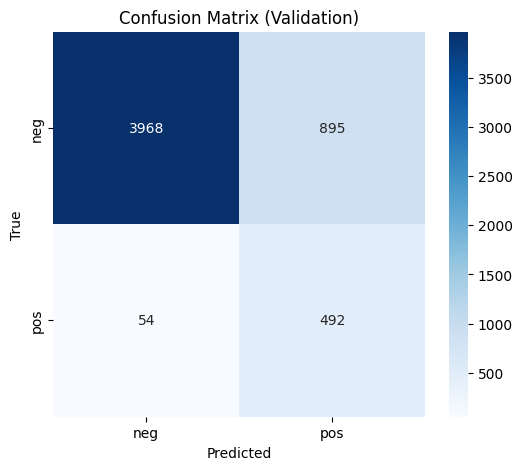

Test Evaluation:   0%|                                                       | 0/511 [00:00<?, ?it/s]

Test Evaluation:   0%|                                               | 1/511 [00:00<04:20,  1.96it/s]

Test Evaluation:   0%|▏                                              | 2/511 [00:01<04:18,  1.97it/s]

Test Evaluation:   1%|▎                                              | 3/511 [00:01<04:17,  1.97it/s]

Test Evaluation:   1%|▎                                              | 4/511 [00:02<04:16,  1.97it/s]

Test Evaluation:   1%|▍                                              | 5/511 [00:02<04:16,  1.97it/s]

Test Evaluation:   1%|▌                                              | 6/511 [00:02<04:07,  2.04it/s]

Test Evaluation:   1%|▋                                              | 7/511 [00:03<04:10,  2.01it/s]

Test Evaluation:   2%|▋                                              | 8/511 [00:04<04:12,  1.99it/s]

Test Evaluation:   2%|▊                                              | 9/511 [00:04<04:13,  1.98it/s]

Test Evaluation:   2%|▉                                             | 10/511 [00:04<04:06,  2.03it/s]

Test Evaluation:   2%|▉                                             | 11/511 [00:05<04:08,  2.01it/s]

Test Evaluation:   2%|█                                             | 12/511 [00:06<04:10,  1.99it/s]

Test Evaluation:   3%|█▏                                            | 13/511 [00:06<04:12,  1.97it/s]

Test Evaluation:   3%|█▎                                            | 14/511 [00:07<04:11,  1.98it/s]

Test Evaluation:   3%|█▎                                            | 15/511 [00:07<04:04,  2.03it/s]

Test Evaluation:   3%|█▍                                            | 16/511 [00:08<04:07,  2.00it/s]

Test Evaluation:   3%|█▌                                            | 17/511 [00:08<04:08,  1.99it/s]

Test Evaluation:   4%|█▌                                            | 18/511 [00:09<04:09,  1.97it/s]

Test Evaluation:   4%|█▋                                            | 19/511 [00:09<04:10,  1.97it/s]

Test Evaluation:   4%|█▊                                            | 20/511 [00:10<04:07,  1.99it/s]

Test Evaluation:   4%|█▉                                            | 21/511 [00:10<04:02,  2.02it/s]

Test Evaluation:   4%|█▉                                            | 22/511 [00:11<04:04,  2.00it/s]

Test Evaluation:   5%|██                                            | 23/511 [00:11<04:04,  1.99it/s]

Test Evaluation:   5%|██▏                                           | 24/511 [00:12<04:01,  2.02it/s]

Test Evaluation:   5%|██▎                                           | 25/511 [00:12<03:58,  2.03it/s]

Test Evaluation:   5%|██▎                                           | 26/511 [00:13<04:00,  2.01it/s]

Test Evaluation:   5%|██▍                                           | 27/511 [00:13<04:03,  1.99it/s]

Test Evaluation:   5%|██▌                                           | 28/511 [00:13<03:57,  2.03it/s]

Test Evaluation:   6%|██▌                                           | 29/511 [00:14<03:59,  2.01it/s]

Test Evaluation:   6%|██▋                                           | 30/511 [00:15<04:00,  2.00it/s]

Test Evaluation:   6%|██▊                                           | 31/511 [00:15<04:01,  1.99it/s]

Test Evaluation:   6%|██▉                                           | 32/511 [00:15<03:54,  2.04it/s]

Test Evaluation:   6%|██▉                                           | 33/511 [00:16<03:57,  2.01it/s]

Test Evaluation:   7%|███                                           | 34/511 [00:16<03:58,  2.00it/s]

Test Evaluation:   7%|███▏                                          | 35/511 [00:17<03:56,  2.01it/s]

Test Evaluation:   7%|███▏                                          | 36/511 [00:17<03:56,  2.01it/s]

Test Evaluation:   7%|███▎                                          | 37/511 [00:18<03:47,  2.09it/s]

Test Evaluation:   7%|███▍                                          | 38/511 [00:18<03:48,  2.07it/s]

Test Evaluation:   8%|███▌                                          | 39/511 [00:19<03:47,  2.07it/s]

Test Evaluation:   8%|███▌                                          | 40/511 [00:19<03:47,  2.07it/s]

Test Evaluation:   8%|███▋                                          | 41/511 [00:20<03:38,  2.15it/s]

Test Evaluation:   8%|███▊                                          | 42/511 [00:20<03:41,  2.12it/s]

Test Evaluation:   8%|███▊                                          | 43/511 [00:21<03:44,  2.09it/s]

Test Evaluation:   9%|███▉                                          | 44/511 [00:21<03:45,  2.07it/s]

Test Evaluation:   9%|████                                          | 45/511 [00:22<03:47,  2.05it/s]

Test Evaluation:   9%|████▏                                         | 46/511 [00:22<03:46,  2.05it/s]

Test Evaluation:   9%|████▏                                         | 47/511 [00:23<03:41,  2.10it/s]

Test Evaluation:   9%|████▎                                         | 48/511 [00:23<03:45,  2.06it/s]

Test Evaluation:  10%|████▍                                         | 49/511 [00:24<03:45,  2.05it/s]

Test Evaluation:  10%|████▌                                         | 50/511 [00:24<03:46,  2.03it/s]

Test Evaluation:  10%|████▌                                         | 51/511 [00:25<03:47,  2.02it/s]

Test Evaluation:  10%|████▋                                         | 52/511 [00:25<03:48,  2.01it/s]

Test Evaluation:  10%|████▊                                         | 53/511 [00:26<03:39,  2.09it/s]

Test Evaluation:  11%|████▊                                         | 54/511 [00:26<03:42,  2.05it/s]

Test Evaluation:  11%|████▉                                         | 55/511 [00:27<03:45,  2.03it/s]

Test Evaluation:  11%|█████                                         | 56/511 [00:27<03:46,  2.01it/s]

Test Evaluation:  11%|█████▏                                        | 57/511 [00:28<03:44,  2.02it/s]

Test Evaluation:  11%|█████▏                                        | 58/511 [00:28<03:44,  2.02it/s]

Test Evaluation:  12%|█████▎                                        | 59/511 [00:29<03:38,  2.07it/s]

Test Evaluation:  12%|█████▍                                        | 60/511 [00:29<03:40,  2.05it/s]

Test Evaluation:  12%|█████▍                                        | 61/511 [00:30<03:39,  2.05it/s]

Test Evaluation:  12%|█████▌                                        | 62/511 [00:30<03:39,  2.04it/s]

Test Evaluation:  12%|█████▋                                        | 63/511 [00:31<03:41,  2.02it/s]

Test Evaluation:  13%|█████▊                                        | 64/511 [00:31<03:41,  2.02it/s]

Test Evaluation:  13%|█████▊                                        | 65/511 [00:32<03:40,  2.02it/s]

Test Evaluation:  13%|█████▉                                        | 66/511 [00:32<03:39,  2.02it/s]

Test Evaluation:  13%|██████                                        | 67/511 [00:33<03:38,  2.03it/s]

Test Evaluation:  13%|██████                                        | 68/511 [00:33<03:37,  2.03it/s]

Test Evaluation:  14%|██████▏                                       | 69/511 [00:34<03:36,  2.04it/s]

Test Evaluation:  14%|██████▎                                       | 70/511 [00:34<03:36,  2.03it/s]

Test Evaluation:  14%|██████▍                                       | 71/511 [00:35<03:37,  2.02it/s]

Test Evaluation:  14%|██████▍                                       | 72/511 [00:35<03:36,  2.03it/s]

Test Evaluation:  14%|██████▌                                       | 73/511 [00:36<03:37,  2.01it/s]

Test Evaluation:  14%|██████▋                                       | 74/511 [00:36<03:36,  2.02it/s]

Test Evaluation:  15%|██████▊                                       | 75/511 [00:37<03:36,  2.02it/s]

Test Evaluation:  15%|██████▊                                       | 76/511 [00:37<03:35,  2.02it/s]

Test Evaluation:  15%|██████▉                                       | 77/511 [00:38<03:34,  2.02it/s]

Test Evaluation:  15%|███████                                       | 78/511 [00:38<03:35,  2.00it/s]

Test Evaluation:  15%|███████                                       | 79/511 [00:39<03:35,  2.00it/s]

Test Evaluation:  16%|███████▏                                      | 80/511 [00:39<03:35,  2.00it/s]

Test Evaluation:  16%|███████▎                                      | 81/511 [00:40<03:36,  1.99it/s]

Test Evaluation:  16%|███████▍                                      | 82/511 [00:40<03:35,  1.99it/s]

Test Evaluation:  16%|███████▍                                      | 83/511 [00:41<03:35,  1.99it/s]

Test Evaluation:  16%|███████▌                                      | 84/511 [00:41<03:33,  2.00it/s]

Test Evaluation:  17%|███████▋                                      | 85/511 [00:42<03:32,  2.00it/s]

Test Evaluation:  17%|███████▋                                      | 86/511 [00:42<03:32,  2.00it/s]

Test Evaluation:  17%|███████▊                                      | 87/511 [00:43<03:32,  2.00it/s]

Test Evaluation:  17%|███████▉                                      | 88/511 [00:43<03:31,  2.00it/s]

Test Evaluation:  17%|████████                                      | 89/511 [00:44<03:31,  1.99it/s]

Test Evaluation:  18%|████████                                      | 90/511 [00:44<03:30,  2.00it/s]

Test Evaluation:  18%|████████▏                                     | 91/511 [00:45<03:30,  1.99it/s]

Test Evaluation:  18%|████████▎                                     | 92/511 [00:45<03:30,  1.99it/s]

Test Evaluation:  18%|████████▎                                     | 93/511 [00:46<03:31,  1.98it/s]

Test Evaluation:  18%|████████▍                                     | 94/511 [00:46<03:30,  1.99it/s]

Test Evaluation:  19%|████████▌                                     | 95/511 [00:47<03:30,  1.97it/s]

Test Evaluation:  19%|████████▋                                     | 96/511 [00:47<03:29,  1.98it/s]

Test Evaluation:  19%|████████▋                                     | 97/511 [00:48<03:28,  1.98it/s]

Test Evaluation:  19%|████████▊                                     | 98/511 [00:48<03:28,  1.98it/s]

Test Evaluation:  19%|████████▉                                     | 99/511 [00:49<03:26,  2.00it/s]

Test Evaluation:  20%|████████▊                                    | 100/511 [00:49<03:20,  2.05it/s]

Test Evaluation:  20%|████████▉                                    | 101/511 [00:50<03:22,  2.03it/s]

Test Evaluation:  20%|████████▉                                    | 102/511 [00:50<03:23,  2.01it/s]

Test Evaluation:  20%|█████████                                    | 103/511 [00:51<03:23,  2.00it/s]

Test Evaluation:  20%|█████████▏                                   | 104/511 [00:51<03:23,  2.00it/s]

Test Evaluation:  21%|█████████▏                                   | 105/511 [00:52<03:23,  1.99it/s]

Test Evaluation:  21%|█████████▎                                   | 106/511 [00:52<03:23,  1.99it/s]

Test Evaluation:  21%|█████████▍                                   | 107/511 [00:53<03:22,  1.99it/s]

Test Evaluation:  21%|█████████▌                                   | 108/511 [00:53<03:23,  1.98it/s]

Test Evaluation:  21%|█████████▌                                   | 109/511 [00:54<03:23,  1.98it/s]

Test Evaluation:  22%|█████████▋                                   | 110/511 [00:54<03:22,  1.98it/s]

Test Evaluation:  22%|█████████▊                                   | 111/511 [00:55<03:21,  1.99it/s]

Test Evaluation:  22%|█████████▊                                   | 112/511 [00:55<03:23,  1.96it/s]

Test Evaluation:  22%|█████████▉                                   | 113/511 [00:56<03:22,  1.97it/s]

Test Evaluation:  22%|██████████                                   | 114/511 [00:56<03:21,  1.97it/s]

Test Evaluation:  23%|██████████▏                                  | 115/511 [00:57<03:20,  1.97it/s]

Test Evaluation:  23%|██████████▏                                  | 116/511 [00:57<03:21,  1.96it/s]

Test Evaluation:  23%|██████████▎                                  | 117/511 [00:58<03:20,  1.96it/s]

Test Evaluation:  23%|██████████▍                                  | 118/511 [00:58<03:19,  1.97it/s]

Test Evaluation:  23%|██████████▍                                  | 119/511 [00:59<03:13,  2.03it/s]

Test Evaluation:  23%|██████████▌                                  | 120/511 [00:59<03:15,  2.00it/s]

Test Evaluation:  24%|██████████▋                                  | 121/511 [01:00<03:15,  2.00it/s]

Test Evaluation:  24%|██████████▋                                  | 122/511 [01:00<03:14,  2.00it/s]

Test Evaluation:  24%|██████████▊                                  | 123/511 [01:01<03:13,  2.00it/s]

Test Evaluation:  24%|██████████▉                                  | 124/511 [01:01<03:13,  2.00it/s]

Test Evaluation:  24%|███████████                                  | 125/511 [01:02<03:13,  2.00it/s]

Test Evaluation:  25%|███████████                                  | 126/511 [01:02<03:13,  1.99it/s]

Test Evaluation:  25%|███████████▏                                 | 127/511 [01:03<03:12,  1.99it/s]

Test Evaluation:  25%|███████████▎                                 | 128/511 [01:03<03:13,  1.98it/s]

Test Evaluation:  25%|███████████▎                                 | 129/511 [01:04<03:12,  1.99it/s]

Test Evaluation:  25%|███████████▍                                 | 130/511 [01:04<03:12,  1.98it/s]

Test Evaluation:  26%|███████████▌                                 | 131/511 [01:05<03:11,  1.98it/s]

Test Evaluation:  26%|███████████▌                                 | 132/511 [01:05<03:10,  1.98it/s]

Test Evaluation:  26%|███████████▋                                 | 133/511 [01:06<03:11,  1.97it/s]

Test Evaluation:  26%|███████████▊                                 | 134/511 [01:06<03:11,  1.97it/s]

Test Evaluation:  26%|███████████▉                                 | 135/511 [01:07<03:10,  1.97it/s]

Test Evaluation:  27%|███████████▉                                 | 136/511 [01:07<03:10,  1.97it/s]

Test Evaluation:  27%|████████████                                 | 137/511 [01:08<03:10,  1.97it/s]

Test Evaluation:  27%|████████████▏                                | 138/511 [01:08<03:11,  1.95it/s]

Test Evaluation:  27%|████████████▏                                | 139/511 [01:09<03:10,  1.95it/s]

Test Evaluation:  27%|████████████▎                                | 140/511 [01:09<03:10,  1.95it/s]

Test Evaluation:  28%|████████████▍                                | 141/511 [01:10<03:10,  1.94it/s]

Test Evaluation:  28%|████████████▌                                | 142/511 [01:10<03:08,  1.96it/s]

Test Evaluation:  28%|████████████▌                                | 143/511 [01:11<03:08,  1.95it/s]

Test Evaluation:  28%|████████████▋                                | 144/511 [01:11<03:07,  1.96it/s]

Test Evaluation:  28%|████████████▊                                | 145/511 [01:12<03:07,  1.95it/s]

Test Evaluation:  29%|████████████▊                                | 146/511 [01:12<03:06,  1.96it/s]

Test Evaluation:  29%|████████████▉                                | 147/511 [01:13<03:06,  1.95it/s]

Test Evaluation:  29%|█████████████                                | 148/511 [01:13<03:06,  1.95it/s]

Test Evaluation:  29%|█████████████                                | 149/511 [01:14<03:05,  1.95it/s]

Test Evaluation:  29%|█████████████▏                               | 150/511 [01:14<03:04,  1.96it/s]

Test Evaluation:  30%|█████████████▎                               | 151/511 [01:15<03:04,  1.95it/s]

Test Evaluation:  30%|█████████████▍                               | 152/511 [01:15<03:03,  1.95it/s]

Test Evaluation:  30%|█████████████▍                               | 153/511 [01:16<03:04,  1.94it/s]

Test Evaluation:  30%|█████████████▌                               | 154/511 [01:16<03:03,  1.95it/s]

Test Evaluation:  30%|█████████████▋                               | 155/511 [01:17<03:02,  1.95it/s]

Test Evaluation:  31%|█████████████▋                               | 156/511 [01:17<03:01,  1.96it/s]

Test Evaluation:  31%|█████████████▊                               | 157/511 [01:18<03:00,  1.97it/s]

Test Evaluation:  31%|█████████████▉                               | 158/511 [01:18<02:57,  1.98it/s]

Test Evaluation:  31%|██████████████                               | 159/511 [01:19<02:50,  2.07it/s]

Test Evaluation:  31%|██████████████                               | 160/511 [01:19<02:49,  2.07it/s]

Test Evaluation:  32%|██████████████▏                              | 161/511 [01:20<02:52,  2.03it/s]

Test Evaluation:  32%|██████████████▎                              | 162/511 [01:20<02:51,  2.04it/s]

Test Evaluation:  32%|██████████████▎                              | 163/511 [01:21<02:51,  2.03it/s]

Test Evaluation:  32%|██████████████▍                              | 164/511 [01:21<02:50,  2.03it/s]

Test Evaluation:  32%|██████████████▌                              | 165/511 [01:22<02:51,  2.02it/s]

Test Evaluation:  32%|██████████████▌                              | 166/511 [01:22<02:50,  2.02it/s]

Test Evaluation:  33%|██████████████▋                              | 167/511 [01:23<02:48,  2.04it/s]

Test Evaluation:  33%|██████████████▊                              | 168/511 [01:23<02:47,  2.04it/s]

Test Evaluation:  33%|██████████████▉                              | 169/511 [01:24<02:47,  2.04it/s]

Test Evaluation:  33%|██████████████▉                              | 170/511 [01:24<02:46,  2.04it/s]

Test Evaluation:  33%|███████████████                              | 171/511 [01:25<02:46,  2.05it/s]

Test Evaluation:  34%|███████████████▏                             | 172/511 [01:25<02:46,  2.03it/s]

Test Evaluation:  34%|███████████████▏                             | 173/511 [01:26<02:46,  2.03it/s]

Test Evaluation:  34%|███████████████▎                             | 174/511 [01:26<02:45,  2.03it/s]

Test Evaluation:  34%|███████████████▍                             | 175/511 [01:27<02:44,  2.04it/s]

Test Evaluation:  34%|███████████████▍                             | 176/511 [01:27<02:46,  2.01it/s]

Test Evaluation:  35%|███████████████▌                             | 177/511 [01:28<02:43,  2.05it/s]

Test Evaluation:  35%|███████████████▋                             | 178/511 [01:28<02:39,  2.09it/s]

Test Evaluation:  35%|███████████████▊                             | 179/511 [01:29<02:40,  2.07it/s]

Test Evaluation:  35%|███████████████▊                             | 180/511 [01:29<02:41,  2.05it/s]

Test Evaluation:  35%|███████████████▉                             | 181/511 [01:30<02:41,  2.04it/s]

Test Evaluation:  36%|████████████████                             | 182/511 [01:30<02:41,  2.04it/s]

Test Evaluation:  36%|████████████████                             | 183/511 [01:31<02:40,  2.04it/s]

Test Evaluation:  36%|████████████████▏                            | 184/511 [01:31<02:39,  2.04it/s]

Test Evaluation:  36%|████████████████▎                            | 185/511 [01:32<02:40,  2.03it/s]

Test Evaluation:  36%|████████████████▍                            | 186/511 [01:32<02:39,  2.04it/s]

Test Evaluation:  37%|████████████████▍                            | 187/511 [01:33<02:38,  2.05it/s]

Test Evaluation:  37%|████████████████▌                            | 188/511 [01:33<02:38,  2.04it/s]

Test Evaluation:  37%|████████████████▋                            | 189/511 [01:34<02:37,  2.04it/s]

Test Evaluation:  37%|████████████████▋                            | 190/511 [01:34<02:36,  2.06it/s]

Test Evaluation:  37%|████████████████▊                            | 191/511 [01:35<02:35,  2.06it/s]

Test Evaluation:  38%|████████████████▉                            | 192/511 [01:35<02:36,  2.04it/s]

Test Evaluation:  38%|████████████████▉                            | 193/511 [01:36<02:35,  2.04it/s]

Test Evaluation:  38%|█████████████████                            | 194/511 [01:36<02:34,  2.05it/s]

Test Evaluation:  38%|█████████████████▏                           | 195/511 [01:37<02:34,  2.04it/s]

Test Evaluation:  38%|█████████████████▎                           | 196/511 [01:37<02:34,  2.04it/s]

Test Evaluation:  39%|█████████████████▎                           | 197/511 [01:38<02:34,  2.04it/s]

Test Evaluation:  39%|█████████████████▍                           | 198/511 [01:38<02:33,  2.04it/s]

Test Evaluation:  39%|█████████████████▌                           | 199/511 [01:39<02:32,  2.04it/s]

Test Evaluation:  39%|█████████████████▌                           | 200/511 [01:39<02:32,  2.04it/s]

Test Evaluation:  39%|█████████████████▋                           | 201/511 [01:39<02:32,  2.03it/s]

Test Evaluation:  40%|█████████████████▊                           | 202/511 [01:40<02:31,  2.04it/s]

Test Evaluation:  40%|█████████████████▉                           | 203/511 [01:40<02:30,  2.05it/s]

Test Evaluation:  40%|█████████████████▉                           | 204/511 [01:41<02:30,  2.04it/s]

Test Evaluation:  40%|██████████████████                           | 205/511 [01:41<02:30,  2.03it/s]

Test Evaluation:  40%|██████████████████▏                          | 206/511 [01:42<02:29,  2.04it/s]

Test Evaluation:  41%|██████████████████▏                          | 207/511 [01:42<02:24,  2.10it/s]

Test Evaluation:  41%|██████████████████▎                          | 208/511 [01:43<02:25,  2.08it/s]

Test Evaluation:  41%|██████████████████▍                          | 209/511 [01:43<02:26,  2.06it/s]

Test Evaluation:  41%|██████████████████▍                          | 210/511 [01:44<02:26,  2.06it/s]

Test Evaluation:  41%|██████████████████▌                          | 211/511 [01:44<02:25,  2.06it/s]

Test Evaluation:  41%|██████████████████▋                          | 212/511 [01:45<02:25,  2.06it/s]

Test Evaluation:  42%|██████████████████▊                          | 213/511 [01:45<02:24,  2.06it/s]

Test Evaluation:  42%|██████████████████▊                          | 214/511 [01:46<02:25,  2.05it/s]

Test Evaluation:  42%|██████████████████▉                          | 215/511 [01:46<02:24,  2.04it/s]

Test Evaluation:  42%|███████████████████                          | 216/511 [01:47<02:25,  2.03it/s]

Test Evaluation:  42%|███████████████████                          | 217/511 [01:47<02:25,  2.02it/s]

Test Evaluation:  43%|███████████████████▏                         | 218/511 [01:48<02:24,  2.03it/s]

Test Evaluation:  43%|███████████████████▎                         | 219/511 [01:48<02:23,  2.03it/s]

Test Evaluation:  43%|███████████████████▎                         | 220/511 [01:49<02:22,  2.04it/s]

Test Evaluation:  43%|███████████████████▍                         | 221/511 [01:49<02:22,  2.04it/s]

Test Evaluation:  43%|███████████████████▌                         | 222/511 [01:50<02:21,  2.04it/s]

Test Evaluation:  44%|███████████████████▋                         | 223/511 [01:50<02:21,  2.04it/s]

Test Evaluation:  44%|███████████████████▋                         | 224/511 [01:51<02:20,  2.05it/s]

Test Evaluation:  44%|███████████████████▊                         | 225/511 [01:51<02:19,  2.05it/s]

Test Evaluation:  44%|███████████████████▉                         | 226/511 [01:52<02:18,  2.05it/s]

Test Evaluation:  44%|███████████████████▉                         | 227/511 [01:52<02:18,  2.05it/s]

Test Evaluation:  45%|████████████████████                         | 228/511 [01:53<02:17,  2.06it/s]

Test Evaluation:  45%|████████████████████▏                        | 229/511 [01:53<02:16,  2.06it/s]

Test Evaluation:  45%|████████████████████▎                        | 230/511 [01:54<02:16,  2.06it/s]

Test Evaluation:  45%|████████████████████▎                        | 231/511 [01:54<02:16,  2.06it/s]

Test Evaluation:  45%|████████████████████▍                        | 232/511 [01:55<02:16,  2.05it/s]

Test Evaluation:  46%|████████████████████▌                        | 233/511 [01:55<02:16,  2.04it/s]

Test Evaluation:  46%|████████████████████▌                        | 234/511 [01:56<02:16,  2.03it/s]

Test Evaluation:  46%|████████████████████▋                        | 235/511 [01:56<02:15,  2.04it/s]

Test Evaluation:  46%|████████████████████▊                        | 236/511 [01:57<02:14,  2.04it/s]

Test Evaluation:  46%|████████████████████▊                        | 237/511 [01:57<02:14,  2.04it/s]

Test Evaluation:  47%|████████████████████▉                        | 238/511 [01:58<02:14,  2.02it/s]

Test Evaluation:  47%|█████████████████████                        | 239/511 [01:58<02:13,  2.04it/s]

Test Evaluation:  47%|█████████████████████▏                       | 240/511 [01:59<02:12,  2.04it/s]

Test Evaluation:  47%|█████████████████████▏                       | 241/511 [01:59<02:12,  2.03it/s]

Test Evaluation:  47%|█████████████████████▎                       | 242/511 [02:00<02:11,  2.04it/s]

Test Evaluation:  48%|█████████████████████▍                       | 243/511 [02:00<02:10,  2.05it/s]

Test Evaluation:  48%|█████████████████████▍                       | 244/511 [02:01<02:10,  2.05it/s]

Test Evaluation:  48%|█████████████████████▌                       | 245/511 [02:01<02:09,  2.05it/s]

Test Evaluation:  48%|█████████████████████▋                       | 246/511 [02:01<02:05,  2.11it/s]

Test Evaluation:  48%|█████████████████████▊                       | 247/511 [02:02<02:05,  2.10it/s]

Test Evaluation:  49%|█████████████████████▊                       | 248/511 [02:02<02:07,  2.07it/s]

Test Evaluation:  49%|█████████████████████▉                       | 249/511 [02:03<02:07,  2.06it/s]

Test Evaluation:  49%|██████████████████████                       | 250/511 [02:03<02:07,  2.04it/s]

Test Evaluation:  49%|██████████████████████                       | 251/511 [02:04<02:07,  2.04it/s]

Test Evaluation:  49%|██████████████████████▏                      | 252/511 [02:04<02:07,  2.03it/s]

Test Evaluation:  50%|██████████████████████▎                      | 253/511 [02:05<02:06,  2.04it/s]

Test Evaluation:  50%|██████████████████████▎                      | 254/511 [02:05<02:05,  2.06it/s]

Test Evaluation:  50%|██████████████████████▍                      | 255/511 [02:06<02:04,  2.06it/s]

Test Evaluation:  50%|██████████████████████▌                      | 256/511 [02:06<02:03,  2.06it/s]

Test Evaluation:  50%|██████████████████████▋                      | 257/511 [02:07<02:04,  2.04it/s]

Test Evaluation:  50%|██████████████████████▋                      | 258/511 [02:07<02:03,  2.05it/s]

Test Evaluation:  51%|██████████████████████▊                      | 259/511 [02:08<02:03,  2.04it/s]

Test Evaluation:  51%|██████████████████████▉                      | 260/511 [02:08<02:02,  2.05it/s]

Test Evaluation:  51%|██████████████████████▉                      | 261/511 [02:09<02:02,  2.04it/s]

Test Evaluation:  51%|███████████████████████                      | 262/511 [02:09<02:01,  2.05it/s]

Test Evaluation:  51%|███████████████████████▏                     | 263/511 [02:10<02:01,  2.04it/s]

Test Evaluation:  52%|███████████████████████▏                     | 264/511 [02:10<02:00,  2.05it/s]

Test Evaluation:  52%|███████████████████████▎                     | 265/511 [02:11<02:00,  2.04it/s]

Test Evaluation:  52%|███████████████████████▍                     | 266/511 [02:11<01:59,  2.04it/s]

Test Evaluation:  52%|███████████████████████▌                     | 267/511 [02:12<01:59,  2.03it/s]

Test Evaluation:  52%|███████████████████████▌                     | 268/511 [02:12<01:58,  2.04it/s]

Test Evaluation:  53%|███████████████████████▋                     | 269/511 [02:13<01:58,  2.04it/s]

Test Evaluation:  53%|███████████████████████▊                     | 270/511 [02:13<01:57,  2.05it/s]

Test Evaluation:  53%|███████████████████████▊                     | 271/511 [02:14<01:56,  2.05it/s]

Test Evaluation:  53%|███████████████████████▉                     | 272/511 [02:14<01:57,  2.04it/s]

Test Evaluation:  53%|████████████████████████                     | 273/511 [02:15<01:56,  2.04it/s]

Test Evaluation:  54%|████████████████████████▏                    | 274/511 [02:15<01:52,  2.10it/s]

Test Evaluation:  54%|████████████████████████▏                    | 275/511 [02:16<01:53,  2.07it/s]

Test Evaluation:  54%|████████████████████████▎                    | 276/511 [02:16<01:54,  2.05it/s]

Test Evaluation:  54%|████████████████████████▍                    | 277/511 [02:17<01:53,  2.06it/s]

Test Evaluation:  54%|████████████████████████▍                    | 278/511 [02:17<01:53,  2.06it/s]

Test Evaluation:  55%|████████████████████████▌                    | 279/511 [02:18<01:52,  2.07it/s]

Test Evaluation:  55%|████████████████████████▋                    | 280/511 [02:18<01:52,  2.05it/s]

Test Evaluation:  55%|████████████████████████▋                    | 281/511 [02:19<01:51,  2.06it/s]

Test Evaluation:  55%|████████████████████████▊                    | 282/511 [02:19<01:51,  2.06it/s]

Test Evaluation:  55%|████████████████████████▉                    | 283/511 [02:19<01:50,  2.06it/s]

Test Evaluation:  56%|█████████████████████████                    | 284/511 [02:20<01:50,  2.06it/s]

Test Evaluation:  56%|█████████████████████████                    | 285/511 [02:20<01:49,  2.07it/s]

Test Evaluation:  56%|█████████████████████████▏                   | 286/511 [02:21<01:49,  2.05it/s]

Test Evaluation:  56%|█████████████████████████▎                   | 287/511 [02:21<01:49,  2.05it/s]

Test Evaluation:  56%|█████████████████████████▎                   | 288/511 [02:22<01:49,  2.03it/s]

Test Evaluation:  57%|█████████████████████████▍                   | 289/511 [02:22<01:48,  2.05it/s]

Test Evaluation:  57%|█████████████████████████▌                   | 290/511 [02:23<01:47,  2.05it/s]

Test Evaluation:  57%|█████████████████████████▋                   | 291/511 [02:23<01:47,  2.04it/s]

Test Evaluation:  57%|█████████████████████████▋                   | 292/511 [02:24<01:46,  2.05it/s]

Test Evaluation:  57%|█████████████████████████▊                   | 293/511 [02:24<01:46,  2.05it/s]

Test Evaluation:  58%|█████████████████████████▉                   | 294/511 [02:25<01:45,  2.05it/s]

Test Evaluation:  58%|█████████████████████████▉                   | 295/511 [02:25<01:45,  2.05it/s]

Test Evaluation:  58%|██████████████████████████                   | 296/511 [02:26<01:44,  2.05it/s]

Test Evaluation:  58%|██████████████████████████▏                  | 297/511 [02:26<01:44,  2.04it/s]

Test Evaluation:  58%|██████████████████████████▏                  | 298/511 [02:27<01:44,  2.03it/s]

Test Evaluation:  59%|██████████████████████████▎                  | 299/511 [02:27<01:47,  1.98it/s]

Test Evaluation:  59%|██████████████████████████▍                  | 300/511 [02:28<01:45,  2.00it/s]

Test Evaluation:  59%|██████████████████████████▌                  | 301/511 [02:28<01:44,  2.01it/s]

Test Evaluation:  59%|██████████████████████████▌                  | 302/511 [02:29<01:42,  2.03it/s]

Test Evaluation:  59%|██████████████████████████▋                  | 303/511 [02:29<01:41,  2.04it/s]

Test Evaluation:  59%|██████████████████████████▊                  | 304/511 [02:30<01:40,  2.05it/s]

Test Evaluation:  60%|██████████████████████████▊                  | 305/511 [02:30<01:41,  2.02it/s]

Test Evaluation:  60%|██████████████████████████▉                  | 306/511 [02:31<01:40,  2.03it/s]

Test Evaluation:  60%|███████████████████████████                  | 307/511 [02:31<01:40,  2.02it/s]

Test Evaluation:  60%|███████████████████████████                  | 308/511 [02:32<01:40,  2.02it/s]

Test Evaluation:  60%|███████████████████████████▏                 | 309/511 [02:32<01:40,  2.02it/s]

Test Evaluation:  61%|███████████████████████████▎                 | 310/511 [02:33<01:39,  2.02it/s]

Test Evaluation:  61%|███████████████████████████▍                 | 311/511 [02:33<01:38,  2.03it/s]

Test Evaluation:  61%|███████████████████████████▍                 | 312/511 [02:34<01:36,  2.05it/s]

Test Evaluation:  61%|███████████████████████████▌                 | 313/511 [02:34<01:37,  2.03it/s]

Test Evaluation:  61%|███████████████████████████▋                 | 314/511 [02:35<01:36,  2.04it/s]

Test Evaluation:  62%|███████████████████████████▋                 | 315/511 [02:35<01:36,  2.03it/s]

Test Evaluation:  62%|███████████████████████████▊                 | 316/511 [02:36<01:35,  2.04it/s]

Test Evaluation:  62%|███████████████████████████▉                 | 317/511 [02:36<01:35,  2.02it/s]

Test Evaluation:  62%|████████████████████████████                 | 318/511 [02:37<01:35,  2.01it/s]

Test Evaluation:  62%|████████████████████████████                 | 319/511 [02:37<01:35,  2.02it/s]

Test Evaluation:  63%|████████████████████████████▏                | 320/511 [02:38<01:35,  2.01it/s]

Test Evaluation:  63%|████████████████████████████▎                | 321/511 [02:38<01:34,  2.00it/s]

Test Evaluation:  63%|████████████████████████████▎                | 322/511 [02:39<01:34,  2.01it/s]

Test Evaluation:  63%|████████████████████████████▍                | 323/511 [02:39<01:33,  2.01it/s]

Test Evaluation:  63%|████████████████████████████▌                | 324/511 [02:40<01:32,  2.01it/s]

Test Evaluation:  64%|████████████████████████████▌                | 325/511 [02:40<01:31,  2.03it/s]

Test Evaluation:  64%|████████████████████████████▋                | 326/511 [02:41<01:31,  2.02it/s]

Test Evaluation:  64%|████████████████████████████▊                | 327/511 [02:41<01:31,  2.00it/s]

Test Evaluation:  64%|████████████████████████████▉                | 328/511 [02:42<01:31,  2.00it/s]

Test Evaluation:  64%|████████████████████████████▉                | 329/511 [02:42<01:30,  2.01it/s]

Test Evaluation:  65%|█████████████████████████████                | 330/511 [02:43<01:30,  2.01it/s]

Test Evaluation:  65%|█████████████████████████████▏               | 331/511 [02:43<01:29,  2.00it/s]

Test Evaluation:  65%|█████████████████████████████▏               | 332/511 [02:44<01:29,  2.01it/s]

Test Evaluation:  65%|█████████████████████████████▎               | 333/511 [02:44<01:28,  2.01it/s]

Test Evaluation:  65%|█████████████████████████████▍               | 334/511 [02:45<01:27,  2.02it/s]

Test Evaluation:  66%|█████████████████████████████▌               | 335/511 [02:45<01:27,  2.02it/s]

Test Evaluation:  66%|█████████████████████████████▌               | 336/511 [02:46<01:27,  2.01it/s]

Test Evaluation:  66%|█████████████████████████████▋               | 337/511 [02:46<01:26,  2.01it/s]

Test Evaluation:  66%|█████████████████████████████▊               | 338/511 [02:47<01:26,  2.00it/s]

Test Evaluation:  66%|█████████████████████████████▊               | 339/511 [02:47<01:23,  2.06it/s]

Test Evaluation:  67%|█████████████████████████████▉               | 340/511 [02:48<01:23,  2.04it/s]

Test Evaluation:  67%|██████████████████████████████               | 341/511 [02:48<01:24,  2.02it/s]

Test Evaluation:  67%|██████████████████████████████               | 342/511 [02:49<01:24,  2.00it/s]

Test Evaluation:  67%|██████████████████████████████▏              | 343/511 [02:49<01:23,  2.01it/s]

Test Evaluation:  67%|██████████████████████████████▎              | 344/511 [02:50<01:23,  2.00it/s]

Test Evaluation:  68%|██████████████████████████████▍              | 345/511 [02:50<01:23,  1.99it/s]

Test Evaluation:  68%|██████████████████████████████▍              | 346/511 [02:51<01:23,  1.99it/s]

Test Evaluation:  68%|██████████████████████████████▌              | 347/511 [02:51<01:22,  1.98it/s]

Test Evaluation:  68%|██████████████████████████████▋              | 348/511 [02:52<01:22,  1.98it/s]

Test Evaluation:  68%|██████████████████████████████▋              | 349/511 [02:52<01:21,  1.99it/s]

Test Evaluation:  68%|██████████████████████████████▊              | 350/511 [02:53<01:20,  2.00it/s]

Test Evaluation:  69%|██████████████████████████████▉              | 351/511 [02:53<01:20,  2.00it/s]

Test Evaluation:  69%|██████████████████████████████▉              | 352/511 [02:54<01:19,  1.99it/s]

Test Evaluation:  69%|███████████████████████████████              | 353/511 [02:54<01:19,  1.99it/s]

Test Evaluation:  69%|███████████████████████████████▏             | 354/511 [02:55<01:19,  1.99it/s]

Test Evaluation:  69%|███████████████████████████████▎             | 355/511 [02:55<01:17,  2.00it/s]

Test Evaluation:  70%|███████████████████████████████▎             | 356/511 [02:56<01:17,  2.01it/s]

Test Evaluation:  70%|███████████████████████████████▍             | 357/511 [02:56<01:16,  2.02it/s]

Test Evaluation:  70%|███████████████████████████████▌             | 358/511 [02:57<01:14,  2.04it/s]

Test Evaluation:  70%|███████████████████████████████▌             | 359/511 [02:57<01:14,  2.03it/s]

Test Evaluation:  70%|███████████████████████████████▋             | 360/511 [02:58<01:14,  2.02it/s]

Test Evaluation:  71%|███████████████████████████████▊             | 361/511 [02:58<01:14,  2.02it/s]

Test Evaluation:  71%|███████████████████████████████▉             | 362/511 [02:59<01:13,  2.03it/s]

Test Evaluation:  71%|███████████████████████████████▉             | 363/511 [02:59<01:13,  2.02it/s]

Test Evaluation:  71%|████████████████████████████████             | 364/511 [03:00<01:12,  2.03it/s]

Test Evaluation:  71%|████████████████████████████████▏            | 365/511 [03:00<01:09,  2.10it/s]

Test Evaluation:  72%|████████████████████████████████▏            | 366/511 [03:01<01:10,  2.06it/s]

Test Evaluation:  72%|████████████████████████████████▎            | 367/511 [03:01<01:10,  2.05it/s]

Test Evaluation:  72%|████████████████████████████████▍            | 368/511 [03:02<01:09,  2.05it/s]

Test Evaluation:  72%|████████████████████████████████▍            | 369/511 [03:02<01:09,  2.05it/s]

Test Evaluation:  72%|████████████████████████████████▌            | 370/511 [03:02<01:08,  2.05it/s]

Test Evaluation:  73%|████████████████████████████████▋            | 371/511 [03:03<01:08,  2.05it/s]

Test Evaluation:  73%|████████████████████████████████▊            | 372/511 [03:03<01:07,  2.05it/s]

Test Evaluation:  73%|████████████████████████████████▊            | 373/511 [03:04<01:07,  2.04it/s]

Test Evaluation:  73%|████████████████████████████████▉            | 374/511 [03:04<01:07,  2.04it/s]

Test Evaluation:  73%|█████████████████████████████████            | 375/511 [03:05<01:06,  2.04it/s]

Test Evaluation:  74%|█████████████████████████████████            | 376/511 [03:05<01:05,  2.05it/s]

Test Evaluation:  74%|█████████████████████████████████▏           | 377/511 [03:06<01:05,  2.05it/s]

Test Evaluation:  74%|█████████████████████████████████▎           | 378/511 [03:06<01:05,  2.04it/s]

Test Evaluation:  74%|█████████████████████████████████▍           | 379/511 [03:07<01:05,  2.00it/s]

Test Evaluation:  74%|█████████████████████████████████▍           | 380/511 [03:07<01:05,  2.01it/s]

Test Evaluation:  75%|█████████████████████████████████▌           | 381/511 [03:08<01:04,  2.03it/s]

Test Evaluation:  75%|█████████████████████████████████▋           | 382/511 [03:08<01:03,  2.03it/s]

Test Evaluation:  75%|█████████████████████████████████▋           | 383/511 [03:09<01:03,  2.02it/s]

Test Evaluation:  75%|█████████████████████████████████▊           | 384/511 [03:09<01:02,  2.02it/s]

Test Evaluation:  75%|█████████████████████████████████▉           | 385/511 [03:10<01:02,  2.03it/s]

Test Evaluation:  76%|█████████████████████████████████▉           | 386/511 [03:10<01:01,  2.04it/s]

Test Evaluation:  76%|██████████████████████████████████           | 387/511 [03:11<01:01,  2.03it/s]

Test Evaluation:  76%|██████████████████████████████████▏          | 388/511 [03:11<01:01,  2.01it/s]

Test Evaluation:  76%|██████████████████████████████████▎          | 389/511 [03:12<01:00,  2.01it/s]

Test Evaluation:  76%|██████████████████████████████████▎          | 390/511 [03:12<00:59,  2.03it/s]

Test Evaluation:  77%|██████████████████████████████████▍          | 391/511 [03:13<00:58,  2.04it/s]

Test Evaluation:  77%|██████████████████████████████████▌          | 392/511 [03:13<00:58,  2.05it/s]

Test Evaluation:  77%|██████████████████████████████████▌          | 393/511 [03:14<00:57,  2.05it/s]

Test Evaluation:  77%|██████████████████████████████████▋          | 394/511 [03:14<00:57,  2.05it/s]

Test Evaluation:  77%|██████████████████████████████████▊          | 395/511 [03:15<00:57,  2.03it/s]

Test Evaluation:  77%|██████████████████████████████████▊          | 396/511 [03:15<00:56,  2.02it/s]

Test Evaluation:  78%|██████████████████████████████████▉          | 397/511 [03:16<00:56,  2.04it/s]

Test Evaluation:  78%|███████████████████████████████████          | 398/511 [03:16<00:55,  2.04it/s]

Test Evaluation:  78%|███████████████████████████████████▏         | 399/511 [03:17<00:54,  2.04it/s]

Test Evaluation:  78%|███████████████████████████████████▏         | 400/511 [03:17<00:54,  2.05it/s]

Test Evaluation:  78%|███████████████████████████████████▎         | 401/511 [03:18<00:53,  2.05it/s]

Test Evaluation:  79%|███████████████████████████████████▍         | 402/511 [03:18<00:53,  2.04it/s]

Test Evaluation:  79%|███████████████████████████████████▍         | 403/511 [03:19<00:52,  2.05it/s]

Test Evaluation:  79%|███████████████████████████████████▌         | 404/511 [03:19<00:52,  2.03it/s]

Test Evaluation:  79%|███████████████████████████████████▋         | 405/511 [03:20<00:52,  2.04it/s]

Test Evaluation:  79%|███████████████████████████████████▊         | 406/511 [03:20<00:51,  2.04it/s]

Test Evaluation:  80%|███████████████████████████████████▊         | 407/511 [03:21<00:50,  2.04it/s]

Test Evaluation:  80%|███████████████████████████████████▉         | 408/511 [03:21<00:50,  2.03it/s]

Test Evaluation:  80%|████████████████████████████████████         | 409/511 [03:22<00:50,  2.04it/s]

Test Evaluation:  80%|████████████████████████████████████         | 410/511 [03:22<00:47,  2.11it/s]

Test Evaluation:  80%|████████████████████████████████████▏        | 411/511 [03:23<00:48,  2.07it/s]

Test Evaluation:  81%|████████████████████████████████████▎        | 412/511 [03:23<00:47,  2.06it/s]

Test Evaluation:  81%|████████████████████████████████████▎        | 413/511 [03:24<00:47,  2.06it/s]

Test Evaluation:  81%|████████████████████████████████████▍        | 414/511 [03:24<00:47,  2.04it/s]

Test Evaluation:  81%|████████████████████████████████████▌        | 415/511 [03:25<00:46,  2.05it/s]

Test Evaluation:  81%|████████████████████████████████████▋        | 416/511 [03:25<00:46,  2.03it/s]

Test Evaluation:  82%|████████████████████████████████████▋        | 417/511 [03:26<00:46,  2.03it/s]

Test Evaluation:  82%|████████████████████████████████████▊        | 418/511 [03:26<00:45,  2.02it/s]

Test Evaluation:  82%|████████████████████████████████████▉        | 419/511 [03:27<00:45,  2.03it/s]

Test Evaluation:  82%|████████████████████████████████████▉        | 420/511 [03:27<00:44,  2.03it/s]

Test Evaluation:  82%|█████████████████████████████████████        | 421/511 [03:28<00:44,  2.02it/s]

Test Evaluation:  83%|█████████████████████████████████████▏       | 422/511 [03:28<00:43,  2.03it/s]

Test Evaluation:  83%|█████████████████████████████████████▎       | 423/511 [03:29<00:43,  2.03it/s]

Test Evaluation:  83%|█████████████████████████████████████▎       | 424/511 [03:29<00:42,  2.03it/s]

Test Evaluation:  83%|█████████████████████████████████████▍       | 425/511 [03:29<00:42,  2.03it/s]

Test Evaluation:  83%|█████████████████████████████████████▌       | 426/511 [03:30<00:41,  2.04it/s]

Test Evaluation:  84%|█████████████████████████████████████▌       | 427/511 [03:30<00:40,  2.05it/s]

Test Evaluation:  84%|█████████████████████████████████████▋       | 428/511 [03:31<00:40,  2.04it/s]

Test Evaluation:  84%|█████████████████████████████████████▊       | 429/511 [03:31<00:40,  2.05it/s]

Test Evaluation:  84%|█████████████████████████████████████▊       | 430/511 [03:32<00:39,  2.04it/s]

Test Evaluation:  84%|█████████████████████████████████████▉       | 431/511 [03:32<00:39,  2.05it/s]

Test Evaluation:  85%|██████████████████████████████████████       | 432/511 [03:33<00:38,  2.04it/s]

Test Evaluation:  85%|██████████████████████████████████████▏      | 433/511 [03:33<00:38,  2.05it/s]

Test Evaluation:  85%|██████████████████████████████████████▏      | 434/511 [03:34<00:36,  2.12it/s]

Test Evaluation:  85%|██████████████████████████████████████▎      | 435/511 [03:34<00:36,  2.09it/s]

Test Evaluation:  85%|██████████████████████████████████████▍      | 436/511 [03:35<00:36,  2.08it/s]

Test Evaluation:  86%|██████████████████████████████████████▍      | 437/511 [03:35<00:35,  2.08it/s]

Test Evaluation:  86%|██████████████████████████████████████▌      | 438/511 [03:36<00:35,  2.06it/s]

Test Evaluation:  86%|██████████████████████████████████████▋      | 439/511 [03:36<00:34,  2.06it/s]

Test Evaluation:  86%|██████████████████████████████████████▋      | 440/511 [03:37<00:34,  2.05it/s]

Test Evaluation:  86%|██████████████████████████████████████▊      | 441/511 [03:37<00:34,  2.05it/s]

Test Evaluation:  86%|██████████████████████████████████████▉      | 442/511 [03:38<00:33,  2.05it/s]

Test Evaluation:  87%|███████████████████████████████████████      | 443/511 [03:38<00:33,  2.04it/s]

Test Evaluation:  87%|███████████████████████████████████████      | 444/511 [03:39<00:32,  2.04it/s]

Test Evaluation:  87%|███████████████████████████████████████▏     | 445/511 [03:39<00:32,  2.02it/s]

Test Evaluation:  87%|███████████████████████████████████████▎     | 446/511 [03:40<00:32,  2.02it/s]

Test Evaluation:  87%|███████████████████████████████████████▎     | 447/511 [03:40<00:31,  2.02it/s]

Test Evaluation:  88%|███████████████████████████████████████▍     | 448/511 [03:41<00:31,  2.02it/s]

Test Evaluation:  88%|███████████████████████████████████████▌     | 449/511 [03:41<00:30,  2.02it/s]

Test Evaluation:  88%|███████████████████████████████████████▋     | 450/511 [03:42<00:30,  2.03it/s]

Test Evaluation:  88%|███████████████████████████████████████▋     | 451/511 [03:42<00:29,  2.02it/s]

Test Evaluation:  88%|███████████████████████████████████████▊     | 452/511 [03:43<00:29,  2.02it/s]

Test Evaluation:  89%|███████████████████████████████████████▉     | 453/511 [03:43<00:28,  2.03it/s]

Test Evaluation:  89%|███████████████████████████████████████▉     | 454/511 [03:44<00:27,  2.04it/s]

Test Evaluation:  89%|████████████████████████████████████████     | 455/511 [03:44<00:27,  2.03it/s]

Test Evaluation:  89%|████████████████████████████████████████▏    | 456/511 [03:45<00:27,  2.03it/s]

Test Evaluation:  89%|████████████████████████████████████████▏    | 457/511 [03:45<00:26,  2.04it/s]

Test Evaluation:  90%|████████████████████████████████████████▎    | 458/511 [03:46<00:26,  2.02it/s]

Test Evaluation:  90%|████████████████████████████████████████▍    | 459/511 [03:46<00:25,  2.02it/s]

Test Evaluation:  90%|████████████████████████████████████████▌    | 460/511 [03:47<00:25,  2.01it/s]

Test Evaluation:  90%|████████████████████████████████████████▌    | 461/511 [03:47<00:24,  2.01it/s]

Test Evaluation:  90%|████████████████████████████████████████▋    | 462/511 [03:48<00:24,  2.02it/s]

Test Evaluation:  91%|████████████████████████████████████████▊    | 463/511 [03:48<00:23,  2.08it/s]

Test Evaluation:  91%|████████████████████████████████████████▊    | 464/511 [03:49<00:22,  2.05it/s]

Test Evaluation:  91%|████████████████████████████████████████▉    | 465/511 [03:49<00:22,  2.03it/s]

Test Evaluation:  91%|█████████████████████████████████████████    | 466/511 [03:50<00:22,  2.01it/s]

Test Evaluation:  91%|█████████████████████████████████████████▏   | 467/511 [03:50<00:22,  1.97it/s]

Test Evaluation:  92%|█████████████████████████████████████████▏   | 468/511 [03:51<00:21,  1.97it/s]

Test Evaluation:  92%|█████████████████████████████████████████▎   | 469/511 [03:51<00:21,  1.98it/s]

Test Evaluation:  92%|█████████████████████████████████████████▍   | 470/511 [03:52<00:20,  1.97it/s]

Test Evaluation:  92%|█████████████████████████████████████████▍   | 471/511 [03:52<00:20,  1.98it/s]

Test Evaluation:  92%|█████████████████████████████████████████▌   | 472/511 [03:53<00:19,  1.99it/s]

Test Evaluation:  93%|█████████████████████████████████████████▋   | 473/511 [03:53<00:19,  1.99it/s]

Test Evaluation:  93%|█████████████████████████████████████████▋   | 474/511 [03:54<00:18,  1.99it/s]

Test Evaluation:  93%|█████████████████████████████████████████▊   | 475/511 [03:54<00:18,  1.99it/s]

Test Evaluation:  93%|█████████████████████████████████████████▉   | 476/511 [03:55<00:17,  1.99it/s]

Test Evaluation:  93%|██████████████████████████████████████████   | 477/511 [03:55<00:17,  1.99it/s]

Test Evaluation:  94%|██████████████████████████████████████████   | 478/511 [03:56<00:16,  2.00it/s]

Test Evaluation:  94%|██████████████████████████████████████████▏  | 479/511 [03:56<00:15,  2.00it/s]

Test Evaluation:  94%|██████████████████████████████████████████▎  | 480/511 [03:57<00:15,  2.01it/s]

Test Evaluation:  94%|██████████████████████████████████████████▎  | 481/511 [03:57<00:15,  1.99it/s]

Test Evaluation:  94%|██████████████████████████████████████████▍  | 482/511 [03:58<00:14,  2.04it/s]

Test Evaluation:  95%|██████████████████████████████████████████▌  | 483/511 [03:58<00:13,  2.05it/s]

Test Evaluation:  95%|██████████████████████████████████████████▌  | 484/511 [03:59<00:13,  2.04it/s]

Test Evaluation:  95%|██████████████████████████████████████████▋  | 485/511 [03:59<00:12,  2.04it/s]

Test Evaluation:  95%|██████████████████████████████████████████▊  | 486/511 [04:00<00:12,  2.03it/s]

Test Evaluation:  95%|██████████████████████████████████████████▉  | 487/511 [04:00<00:11,  2.03it/s]

Test Evaluation:  95%|██████████████████████████████████████████▉  | 488/511 [04:01<00:11,  2.02it/s]

Test Evaluation:  96%|███████████████████████████████████████████  | 489/511 [04:01<00:10,  2.01it/s]

Test Evaluation:  96%|███████████████████████████████████████████▏ | 490/511 [04:02<00:10,  2.01it/s]

Test Evaluation:  96%|███████████████████████████████████████████▏ | 491/511 [04:02<00:09,  2.00it/s]

Test Evaluation:  96%|███████████████████████████████████████████▎ | 492/511 [04:03<00:09,  2.00it/s]

Test Evaluation:  96%|███████████████████████████████████████████▍ | 493/511 [04:03<00:09,  1.99it/s]

Test Evaluation:  97%|███████████████████████████████████████████▌ | 494/511 [04:04<00:08,  2.00it/s]

Test Evaluation:  97%|███████████████████████████████████████████▌ | 495/511 [04:04<00:07,  2.01it/s]

Test Evaluation:  97%|███████████████████████████████████████████▋ | 496/511 [04:05<00:07,  2.01it/s]

Test Evaluation:  97%|███████████████████████████████████████████▊ | 497/511 [04:05<00:06,  2.01it/s]

Test Evaluation:  97%|███████████████████████████████████████████▊ | 498/511 [04:06<00:06,  2.00it/s]

Test Evaluation:  98%|███████████████████████████████████████████▉ | 499/511 [04:06<00:05,  2.00it/s]

Test Evaluation:  98%|████████████████████████████████████████████ | 500/511 [04:07<00:05,  2.00it/s]

Test Evaluation:  98%|████████████████████████████████████████████ | 501/511 [04:07<00:04,  2.00it/s]

Test Evaluation:  98%|████████████████████████████████████████████▏| 502/511 [04:08<00:04,  2.00it/s]

Test Evaluation:  98%|████████████████████████████████████████████▎| 503/511 [04:08<00:04,  1.99it/s]

Test Evaluation:  99%|████████████████████████████████████████████▍| 504/511 [04:09<00:03,  2.00it/s]

Test Evaluation:  99%|████████████████████████████████████████████▍| 505/511 [04:09<00:02,  2.00it/s]

Test Evaluation:  99%|████████████████████████████████████████████▌| 506/511 [04:10<00:02,  2.01it/s]

Test Evaluation:  99%|████████████████████████████████████████████▋| 507/511 [04:10<00:01,  2.01it/s]

Test Evaluation:  99%|████████████████████████████████████████████▋| 508/511 [04:11<00:01,  2.01it/s]

Test Evaluation: 100%|████████████████████████████████████████████▊| 509/511 [04:11<00:00,  2.02it/s]

Test Evaluation: 100%|████████████████████████████████████████████▉| 510/511 [04:12<00:00,  2.02it/s]

Test Evaluation: 100%|█████████████████████████████████████████████| 511/511 [04:12<00:00,  2.16it/s]

Test Evaluation: 100%|█████████████████████████████████████████████| 511/511 [04:12<00:00,  2.02it/s]

Test Loss: 0.1981 | Test Acc: 89.93% | Test F1: 0.7795
Classification Report (Test):
              precision    recall  f1-score   support

         neg       0.96      0.92      0.94      7240
         pos       0.55      0.71      0.62       934

    accuracy                           0.90      8174
   macro avg       0.75      0.82      0.78      8174
weighted avg       0.91      0.90      0.90      8174



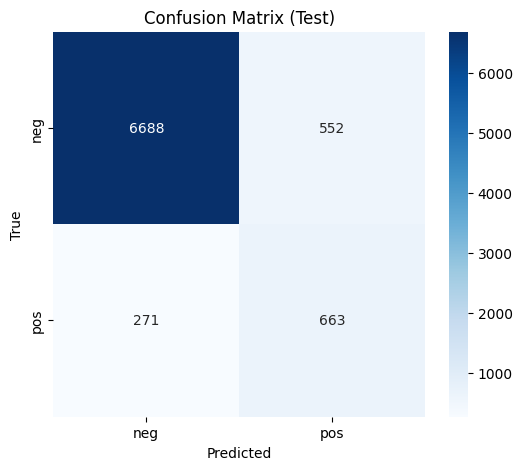

Epoch 5 Summary:
Train Loss: 0.2056 | Train Acc: 82.06% | Train F1: 0.8186
Val Loss: 0.1761 | Val Acc: 82.46% | Val F1: 0.7011
Test Loss: 0.1981 | Test Acc: 89.93% | Test F1: 0.7795
Epoch Time: 981.53s | GPU Memory Usage: 767.04 MB



Checkpoint saved at checkpoints\epoch_5.pth


Validation loss decreased. Best model saved at checkpoints\best_model.pth


Training:   0%|                                                              | 0/470 [00:00<?, ?it/s]

Training:   0%|                           | 0/470 [00:01<?, ?it/s, Loss=0.2150, F1=0.8667, Acc=87.50]

Training:   0%|                   | 1/470 [00:01<09:39,  1.24s/it, Loss=0.2150, F1=0.8667, Acc=87.50]

Training:   0%|                   | 1/470 [00:02<09:39,  1.24s/it, Loss=0.1923, F1=0.8424, Acc=84.38]

Training:   0%|                   | 2/470 [00:02<09:26,  1.21s/it, Loss=0.1923, F1=0.8424, Acc=84.38]

Training:   0%|                   | 2/470 [00:03<09:26,  1.21s/it, Loss=0.3149, F1=0.8307, Acc=83.33]

Training:   1%|                   | 3/470 [00:03<09:47,  1.26s/it, Loss=0.3149, F1=0.8307, Acc=83.33]

Training:   1%|                   | 3/470 [00:04<09:47,  1.26s/it, Loss=0.2585, F1=0.8413, Acc=84.38]

Training:   1%|▏                  | 4/470 [00:04<09:33,  1.23s/it, Loss=0.2585, F1=0.8413, Acc=84.38]

Training:   1%|▏                  | 4/470 [00:06<09:33,  1.23s/it, Loss=0.2244, F1=0.8599, Acc=86.25]

Training:   1%|▏                  | 5/470 [00:06<09:22,  1.21s/it, Loss=0.2244, F1=0.8599, Acc=86.25]

Training:   1%|▏                  | 5/470 [00:07<09:22,  1.21s/it, Loss=0.1938, F1=0.8848, Acc=88.54]

Training:   1%|▏                  | 6/470 [00:07<09:20,  1.21s/it, Loss=0.1938, F1=0.8848, Acc=88.54]

Training:   1%|▏                  | 6/470 [00:08<09:20,  1.21s/it, Loss=0.1954, F1=0.8648, Acc=86.61]

Training:   1%|▎                  | 7/470 [00:08<09:27,  1.23s/it, Loss=0.1954, F1=0.8648, Acc=86.61]

Training:   1%|▎                  | 7/470 [00:09<09:27,  1.23s/it, Loss=0.1934, F1=0.8585, Acc=85.94]

Training:   2%|▎                  | 8/470 [00:09<09:25,  1.22s/it, Loss=0.1934, F1=0.8585, Acc=85.94]

Training:   2%|▎                  | 8/470 [00:11<09:25,  1.22s/it, Loss=0.1884, F1=0.8368, Acc=84.03]

Training:   2%|▎                  | 9/470 [00:11<09:23,  1.22s/it, Loss=0.1884, F1=0.8368, Acc=84.03]

Training:   2%|▎                  | 9/470 [00:12<09:23,  1.22s/it, Loss=0.2133, F1=0.8316, Acc=83.75]

Training:   2%|▍                 | 10/470 [00:12<09:18,  1.22s/it, Loss=0.2133, F1=0.8316, Acc=83.75]

Training:   2%|▍                 | 10/470 [00:13<09:18,  1.22s/it, Loss=0.2179, F1=0.8244, Acc=82.95]

Training:   2%|▍                 | 11/470 [00:13<09:16,  1.21s/it, Loss=0.2179, F1=0.8244, Acc=82.95]

Training:   2%|▍                 | 11/470 [00:14<09:16,  1.21s/it, Loss=0.2048, F1=0.8348, Acc=83.85]

Training:   3%|▍                 | 12/470 [00:14<09:24,  1.23s/it, Loss=0.2048, F1=0.8348, Acc=83.85]

Training:   3%|▍                 | 12/470 [00:15<09:24,  1.23s/it, Loss=0.1918, F1=0.8461, Acc=85.10]

Training:   3%|▍                 | 13/470 [00:15<09:12,  1.21s/it, Loss=0.1918, F1=0.8461, Acc=85.10]

Training:   3%|▍                 | 13/470 [00:17<09:12,  1.21s/it, Loss=0.1800, F1=0.8577, Acc=86.16]

Training:   3%|▌                 | 14/470 [00:17<09:24,  1.24s/it, Loss=0.1800, F1=0.8577, Acc=86.16]

Training:   3%|▌                 | 14/470 [00:18<09:24,  1.24s/it, Loss=0.1773, F1=0.8632, Acc=86.67]

Training:   3%|▌                 | 15/470 [00:18<09:15,  1.22s/it, Loss=0.1773, F1=0.8632, Acc=86.67]

Training:   3%|▌                 | 15/470 [00:19<09:15,  1.22s/it, Loss=0.1906, F1=0.8551, Acc=85.94]

Training:   3%|▌                 | 16/470 [00:19<09:09,  1.21s/it, Loss=0.1906, F1=0.8551, Acc=85.94]

Training:   3%|▌                 | 16/470 [00:20<09:09,  1.21s/it, Loss=0.1867, F1=0.8605, Acc=86.40]

Training:   4%|▋                 | 17/470 [00:20<09:09,  1.21s/it, Loss=0.1867, F1=0.8605, Acc=86.40]

Training:   4%|▋                 | 17/470 [00:21<09:09,  1.21s/it, Loss=0.1999, F1=0.8618, Acc=86.46]

Training:   4%|▋                 | 18/470 [00:21<09:00,  1.20s/it, Loss=0.1999, F1=0.8618, Acc=86.46]

Training:   4%|▋                 | 18/470 [00:23<09:00,  1.20s/it, Loss=0.1908, F1=0.8663, Acc=86.84]

Training:   4%|▋                 | 19/470 [00:23<08:58,  1.19s/it, Loss=0.1908, F1=0.8663, Acc=86.84]

Training:   4%|▋                 | 19/470 [00:24<08:58,  1.19s/it, Loss=0.1857, F1=0.8691, Acc=87.19]

Training:   4%|▊                 | 20/470 [00:24<08:45,  1.17s/it, Loss=0.1857, F1=0.8691, Acc=87.19]

Training:   4%|▊                 | 20/470 [00:25<08:45,  1.17s/it, Loss=0.1813, F1=0.8699, Acc=87.20]

Training:   4%|▊                 | 21/470 [00:25<08:47,  1.18s/it, Loss=0.1813, F1=0.8699, Acc=87.20]

Training:   4%|▊                 | 21/470 [00:26<08:47,  1.18s/it, Loss=0.1780, F1=0.8702, Acc=87.22]

Training:   5%|▊                 | 22/470 [00:26<08:52,  1.19s/it, Loss=0.1780, F1=0.8702, Acc=87.22]

Training:   5%|▊                 | 22/470 [00:27<08:52,  1.19s/it, Loss=0.1763, F1=0.8732, Acc=87.50]

Training:   5%|▉                 | 23/470 [00:27<08:52,  1.19s/it, Loss=0.1763, F1=0.8732, Acc=87.50]

Training:   5%|▉                 | 23/470 [00:28<08:52,  1.19s/it, Loss=0.1845, F1=0.8677, Acc=86.98]

Training:   5%|▉                 | 24/470 [00:28<08:49,  1.19s/it, Loss=0.1845, F1=0.8677, Acc=86.98]

Training:   5%|▉                 | 24/470 [00:30<08:49,  1.19s/it, Loss=0.1843, F1=0.8709, Acc=87.25]

Training:   5%|▉                 | 25/470 [00:30<08:51,  1.19s/it, Loss=0.1843, F1=0.8709, Acc=87.25]

Training:   5%|▉                 | 25/470 [00:31<08:51,  1.19s/it, Loss=0.1791, F1=0.8752, Acc=87.74]

Training:   6%|▉                 | 26/470 [00:31<08:49,  1.19s/it, Loss=0.1791, F1=0.8752, Acc=87.74]

Training:   6%|▉                 | 26/470 [00:32<08:49,  1.19s/it, Loss=0.1799, F1=0.8730, Acc=87.50]

Training:   6%|█                 | 27/470 [00:32<08:41,  1.18s/it, Loss=0.1799, F1=0.8730, Acc=87.50]

Training:   6%|█                 | 27/470 [00:33<08:41,  1.18s/it, Loss=0.1753, F1=0.8727, Acc=87.50]

Training:   6%|█                 | 28/470 [00:33<08:43,  1.19s/it, Loss=0.1753, F1=0.8727, Acc=87.50]

Training:   6%|█                 | 28/470 [00:34<08:43,  1.19s/it, Loss=0.1725, F1=0.8747, Acc=87.72]

Training:   6%|█                 | 29/470 [00:34<08:34,  1.17s/it, Loss=0.1725, F1=0.8747, Acc=87.72]

Training:   6%|█                 | 29/470 [00:36<08:34,  1.17s/it, Loss=0.1725, F1=0.8726, Acc=87.50]

Training:   6%|█▏                | 30/470 [00:36<08:46,  1.20s/it, Loss=0.1725, F1=0.8726, Acc=87.50]

Training:   6%|█▏                | 30/470 [00:37<08:46,  1.20s/it, Loss=0.1726, F1=0.8727, Acc=87.50]

Training:   7%|█▏                | 31/470 [00:37<08:37,  1.18s/it, Loss=0.1726, F1=0.8727, Acc=87.50]

Training:   7%|█▏                | 31/470 [00:38<08:37,  1.18s/it, Loss=0.1682, F1=0.8771, Acc=87.89]

Training:   7%|█▏                | 32/470 [00:38<08:43,  1.19s/it, Loss=0.1682, F1=0.8771, Acc=87.89]

Training:   7%|█▏                | 32/470 [00:39<08:43,  1.19s/it, Loss=0.1916, F1=0.8730, Acc=87.50]

Training:   7%|█▎                | 33/470 [00:39<08:49,  1.21s/it, Loss=0.1916, F1=0.8730, Acc=87.50]

Training:   7%|█▎                | 33/470 [00:40<08:49,  1.21s/it, Loss=0.1866, F1=0.8768, Acc=87.87]

Training:   7%|█▎                | 34/470 [00:40<08:45,  1.20s/it, Loss=0.1866, F1=0.8768, Acc=87.87]

Training:   7%|█▎                | 34/470 [00:42<08:45,  1.20s/it, Loss=0.1871, F1=0.8751, Acc=87.68]

Training:   7%|█▎                | 35/470 [00:42<08:35,  1.19s/it, Loss=0.1871, F1=0.8751, Acc=87.68]

Training:   7%|█▎                | 35/470 [00:43<08:35,  1.19s/it, Loss=0.1830, F1=0.8770, Acc=87.85]

Training:   8%|█▍                | 36/470 [00:43<08:31,  1.18s/it, Loss=0.1830, F1=0.8770, Acc=87.85]

Training:   8%|█▍                | 36/470 [00:44<08:31,  1.18s/it, Loss=0.1895, F1=0.8772, Acc=87.84]

Training:   8%|█▍                | 37/470 [00:44<08:35,  1.19s/it, Loss=0.1895, F1=0.8772, Acc=87.84]

Training:   8%|█▍                | 37/470 [00:45<08:35,  1.19s/it, Loss=0.1879, F1=0.8751, Acc=87.66]

Training:   8%|█▍                | 38/470 [00:45<08:39,  1.20s/it, Loss=0.1879, F1=0.8751, Acc=87.66]

Training:   8%|█▍                | 38/470 [00:46<08:39,  1.20s/it, Loss=0.1851, F1=0.8778, Acc=87.98]

Training:   8%|█▍                | 39/470 [00:46<08:36,  1.20s/it, Loss=0.1851, F1=0.8778, Acc=87.98]

Training:   8%|█▍                | 39/470 [00:48<08:36,  1.20s/it, Loss=0.1929, F1=0.8761, Acc=87.81]

Training:   9%|█▌                | 40/470 [00:48<08:34,  1.20s/it, Loss=0.1929, F1=0.8761, Acc=87.81]

Training:   9%|█▌                | 40/470 [00:49<08:34,  1.20s/it, Loss=0.1916, F1=0.8777, Acc=87.96]

Training:   9%|█▌                | 41/470 [00:49<08:40,  1.21s/it, Loss=0.1916, F1=0.8777, Acc=87.96]

Training:   9%|█▌                | 41/470 [00:50<08:40,  1.21s/it, Loss=0.1927, F1=0.8775, Acc=87.95]

Training:   9%|█▌                | 42/470 [00:50<08:33,  1.20s/it, Loss=0.1927, F1=0.8775, Acc=87.95]

Training:   9%|█▌                | 42/470 [00:51<08:33,  1.20s/it, Loss=0.1938, F1=0.8744, Acc=87.65]

Training:   9%|█▋                | 43/470 [00:51<08:24,  1.18s/it, Loss=0.1938, F1=0.8744, Acc=87.65]

Training:   9%|█▋                | 43/470 [00:52<08:24,  1.18s/it, Loss=0.1924, F1=0.8728, Acc=87.50]

Training:   9%|█▋                | 44/470 [00:52<08:33,  1.21s/it, Loss=0.1924, F1=0.8728, Acc=87.50]

Training:   9%|█▋                | 44/470 [00:54<08:33,  1.21s/it, Loss=0.1983, F1=0.8700, Acc=87.22]

Training:  10%|█▋                | 45/470 [00:54<08:34,  1.21s/it, Loss=0.1983, F1=0.8700, Acc=87.22]

Training:  10%|█▋                | 45/470 [00:55<08:34,  1.21s/it, Loss=0.1957, F1=0.8712, Acc=87.36]

Training:  10%|█▊                | 46/470 [00:55<08:28,  1.20s/it, Loss=0.1957, F1=0.8712, Acc=87.36]

Training:  10%|█▊                | 46/470 [00:56<08:28,  1.20s/it, Loss=0.1930, F1=0.8711, Acc=87.37]

Training:  10%|█▊                | 47/470 [00:56<08:25,  1.19s/it, Loss=0.1930, F1=0.8711, Acc=87.37]

Training:  10%|█▊                | 47/470 [00:57<08:25,  1.19s/it, Loss=0.1921, F1=0.8710, Acc=87.37]

Training:  10%|█▊                | 48/470 [00:57<08:22,  1.19s/it, Loss=0.1921, F1=0.8710, Acc=87.37]

Training:  10%|█▊                | 48/470 [00:58<08:22,  1.19s/it, Loss=0.1891, F1=0.8733, Acc=87.63]

Training:  10%|█▉                | 49/470 [00:58<08:28,  1.21s/it, Loss=0.1891, F1=0.8733, Acc=87.63]

Training:  10%|█▉                | 49/470 [01:00<08:28,  1.21s/it, Loss=0.1901, F1=0.8694, Acc=87.25]

Training:  11%|█▉                | 50/470 [01:00<08:34,  1.22s/it, Loss=0.1901, F1=0.8694, Acc=87.25]

Training:  11%|█▉                | 50/470 [01:01<08:34,  1.22s/it, Loss=0.1878, F1=0.8704, Acc=87.38]

Training:  11%|█▉                | 51/470 [01:01<08:24,  1.20s/it, Loss=0.1878, F1=0.8704, Acc=87.38]

Training:  11%|█▉                | 51/470 [01:02<08:24,  1.20s/it, Loss=0.1849, F1=0.8719, Acc=87.50]

Training:  11%|█▉                | 52/470 [01:02<08:23,  1.21s/it, Loss=0.1849, F1=0.8719, Acc=87.50]

Training:  11%|█▉                | 52/470 [01:03<08:23,  1.21s/it, Loss=0.1837, F1=0.8719, Acc=87.50]

Training:  11%|██                | 53/470 [01:03<08:20,  1.20s/it, Loss=0.1837, F1=0.8719, Acc=87.50]

Training:  11%|██                | 53/470 [01:04<08:20,  1.20s/it, Loss=0.1819, F1=0.8720, Acc=87.50]

Training:  11%|██                | 54/470 [01:04<08:17,  1.20s/it, Loss=0.1819, F1=0.8720, Acc=87.50]

Training:  11%|██                | 54/470 [01:06<08:17,  1.20s/it, Loss=0.1808, F1=0.8732, Acc=87.61]

Training:  12%|██                | 55/470 [01:06<08:15,  1.19s/it, Loss=0.1808, F1=0.8732, Acc=87.61]

Training:  12%|██                | 55/470 [01:07<08:15,  1.19s/it, Loss=0.1842, F1=0.8721, Acc=87.50]

Training:  12%|██▏               | 56/470 [01:07<08:07,  1.18s/it, Loss=0.1842, F1=0.8721, Acc=87.50]

Training:  12%|██▏               | 56/470 [01:08<08:07,  1.18s/it, Loss=0.1955, F1=0.8710, Acc=87.39]

Training:  12%|██▏               | 57/470 [01:08<08:17,  1.20s/it, Loss=0.1955, F1=0.8710, Acc=87.39]

Training:  12%|██▏               | 57/470 [01:09<08:17,  1.20s/it, Loss=0.1928, F1=0.8736, Acc=87.61]

Training:  12%|██▏               | 58/470 [01:09<08:21,  1.22s/it, Loss=0.1928, F1=0.8736, Acc=87.61]

Training:  12%|██▏               | 58/470 [01:10<08:21,  1.22s/it, Loss=0.1926, F1=0.8749, Acc=87.71]

Training:  13%|██▎               | 59/470 [01:10<08:17,  1.21s/it, Loss=0.1926, F1=0.8749, Acc=87.71]

Training:  13%|██▎               | 59/470 [01:12<08:17,  1.21s/it, Loss=0.1945, F1=0.8750, Acc=87.71]

Training:  13%|██▎               | 60/470 [01:12<08:10,  1.20s/it, Loss=0.1945, F1=0.8750, Acc=87.71]

Training:  13%|██▎               | 60/470 [01:13<08:10,  1.20s/it, Loss=0.1970, F1=0.8762, Acc=87.81]

Training:  13%|██▎               | 61/470 [01:13<08:09,  1.20s/it, Loss=0.1970, F1=0.8762, Acc=87.81]

Training:  13%|██▎               | 61/470 [01:14<08:09,  1.20s/it, Loss=0.1953, F1=0.8782, Acc=88.00]

Training:  13%|██▎               | 62/470 [01:14<08:02,  1.18s/it, Loss=0.1953, F1=0.8782, Acc=88.00]

Training:  13%|██▎               | 62/470 [01:15<08:02,  1.18s/it, Loss=0.1947, F1=0.8781, Acc=88.00]

Training:  13%|██▍               | 63/470 [01:15<08:08,  1.20s/it, Loss=0.1947, F1=0.8781, Acc=88.00]

Training:  13%|██▍               | 63/470 [01:16<08:08,  1.20s/it, Loss=0.1933, F1=0.8769, Acc=87.89]

Training:  14%|██▍               | 64/470 [01:16<08:06,  1.20s/it, Loss=0.1933, F1=0.8769, Acc=87.89]

Training:  14%|██▍               | 64/470 [01:18<08:06,  1.20s/it, Loss=0.1917, F1=0.8768, Acc=87.88]

Training:  14%|██▍               | 65/470 [01:18<08:01,  1.19s/it, Loss=0.1917, F1=0.8768, Acc=87.88]

Training:  14%|██▍               | 65/470 [01:19<08:01,  1.19s/it, Loss=0.1953, F1=0.8718, Acc=87.41]

Training:  14%|██▌               | 66/470 [01:19<08:06,  1.20s/it, Loss=0.1953, F1=0.8718, Acc=87.41]

Training:  14%|██▌               | 66/470 [01:20<08:06,  1.20s/it, Loss=0.1946, F1=0.8717, Acc=87.41]

Training:  14%|██▌               | 67/470 [01:20<08:01,  1.19s/it, Loss=0.1946, F1=0.8717, Acc=87.41]

Training:  14%|██▌               | 67/470 [01:21<08:01,  1.19s/it, Loss=0.1972, F1=0.8697, Acc=87.22]

Training:  14%|██▌               | 68/470 [01:21<07:58,  1.19s/it, Loss=0.1972, F1=0.8697, Acc=87.22]

Training:  14%|██▌               | 68/470 [01:22<07:58,  1.19s/it, Loss=0.1965, F1=0.8697, Acc=87.23]

Training:  15%|██▋               | 69/470 [01:22<08:04,  1.21s/it, Loss=0.1965, F1=0.8697, Acc=87.23]

Training:  15%|██▋               | 69/470 [01:24<08:04,  1.21s/it, Loss=0.1947, F1=0.8689, Acc=87.14]

Training:  15%|██▋               | 70/470 [01:24<08:02,  1.21s/it, Loss=0.1947, F1=0.8689, Acc=87.14]

Training:  15%|██▋               | 70/470 [01:25<08:02,  1.21s/it, Loss=0.1945, F1=0.8673, Acc=86.97]

Training:  15%|██▋               | 71/470 [01:25<07:59,  1.20s/it, Loss=0.1945, F1=0.8673, Acc=86.97]

Training:  15%|██▋               | 71/470 [01:26<07:59,  1.20s/it, Loss=0.1954, F1=0.8675, Acc=86.98]

Training:  15%|██▊               | 72/470 [01:26<07:57,  1.20s/it, Loss=0.1954, F1=0.8675, Acc=86.98]

Training:  15%|██▊               | 72/470 [01:27<07:57,  1.20s/it, Loss=0.1934, F1=0.8686, Acc=87.07]

Training:  16%|██▊               | 73/470 [01:27<08:06,  1.23s/it, Loss=0.1934, F1=0.8686, Acc=87.07]

Training:  16%|██▊               | 73/470 [01:28<08:06,  1.23s/it, Loss=0.1987, F1=0.8671, Acc=86.91]

Training:  16%|██▊               | 74/470 [01:28<08:03,  1.22s/it, Loss=0.1987, F1=0.8671, Acc=86.91]

Training:  16%|██▊               | 74/470 [01:30<08:03,  1.22s/it, Loss=0.1965, F1=0.8690, Acc=87.08]

Training:  16%|██▊               | 75/470 [01:30<07:56,  1.21s/it, Loss=0.1965, F1=0.8690, Acc=87.08]

Training:  16%|██▊               | 75/470 [01:31<07:56,  1.21s/it, Loss=0.1960, F1=0.8708, Acc=87.25]

Training:  16%|██▉               | 76/470 [01:31<07:51,  1.20s/it, Loss=0.1960, F1=0.8708, Acc=87.25]

Training:  16%|██▉               | 76/470 [01:32<07:51,  1.20s/it, Loss=0.1975, F1=0.8702, Acc=87.18]

Training:  16%|██▉               | 77/470 [01:32<07:50,  1.20s/it, Loss=0.1975, F1=0.8702, Acc=87.18]

Training:  16%|██▉               | 77/470 [01:33<07:50,  1.20s/it, Loss=0.1972, F1=0.8710, Acc=87.26]

Training:  17%|██▉               | 78/470 [01:33<07:48,  1.19s/it, Loss=0.1972, F1=0.8710, Acc=87.26]

Training:  17%|██▉               | 78/470 [01:34<07:48,  1.19s/it, Loss=0.1957, F1=0.8727, Acc=87.42]

Training:  17%|███               | 79/470 [01:34<07:44,  1.19s/it, Loss=0.1957, F1=0.8727, Acc=87.42]

Training:  17%|███               | 79/470 [01:36<07:44,  1.19s/it, Loss=0.1956, F1=0.8734, Acc=87.50]

Training:  17%|███               | 80/470 [01:36<07:43,  1.19s/it, Loss=0.1956, F1=0.8734, Acc=87.50]

Training:  17%|███               | 80/470 [01:37<07:43,  1.19s/it, Loss=0.1945, F1=0.8742, Acc=87.58]

Training:  17%|███               | 81/470 [01:37<07:41,  1.19s/it, Loss=0.1945, F1=0.8742, Acc=87.58]

Training:  17%|███               | 81/470 [01:38<07:41,  1.19s/it, Loss=0.1942, F1=0.8736, Acc=87.50]

Training:  17%|███▏              | 82/470 [01:38<07:43,  1.19s/it, Loss=0.1942, F1=0.8736, Acc=87.50]

Training:  17%|███▏              | 82/470 [01:39<07:43,  1.19s/it, Loss=0.1944, F1=0.8734, Acc=87.50]

Training:  18%|███▏              | 83/470 [01:39<07:43,  1.20s/it, Loss=0.1944, F1=0.8734, Acc=87.50]

Training:  18%|███▏              | 83/470 [01:40<07:43,  1.20s/it, Loss=0.1934, F1=0.8748, Acc=87.65]

Training:  18%|███▏              | 84/470 [01:40<07:39,  1.19s/it, Loss=0.1934, F1=0.8748, Acc=87.65]

Training:  18%|███▏              | 84/470 [01:42<07:39,  1.19s/it, Loss=0.1935, F1=0.8740, Acc=87.57]

Training:  18%|███▎              | 85/470 [01:42<07:51,  1.22s/it, Loss=0.1935, F1=0.8740, Acc=87.57]

Training:  18%|███▎              | 85/470 [01:43<07:51,  1.22s/it, Loss=0.1929, F1=0.8740, Acc=87.57]

Training:  18%|███▎              | 86/470 [01:43<07:51,  1.23s/it, Loss=0.1929, F1=0.8740, Acc=87.57]

Training:  18%|███▎              | 86/470 [01:44<07:51,  1.23s/it, Loss=0.1923, F1=0.8725, Acc=87.43]

Training:  19%|███▎              | 87/470 [01:44<07:48,  1.22s/it, Loss=0.1923, F1=0.8725, Acc=87.43]

Training:  19%|███▎              | 87/470 [01:45<07:48,  1.22s/it, Loss=0.1929, F1=0.8695, Acc=87.14]

Training:  19%|███▎              | 88/470 [01:45<07:42,  1.21s/it, Loss=0.1929, F1=0.8695, Acc=87.14]

Training:  19%|███▎              | 88/470 [01:46<07:42,  1.21s/it, Loss=0.1934, F1=0.8674, Acc=86.94]

Training:  19%|███▍              | 89/470 [01:46<07:42,  1.21s/it, Loss=0.1934, F1=0.8674, Acc=86.94]

Training:  19%|███▍              | 89/470 [01:48<07:42,  1.21s/it, Loss=0.1940, F1=0.8653, Acc=86.74]

Training:  19%|███▍              | 90/470 [01:48<07:41,  1.22s/it, Loss=0.1940, F1=0.8653, Acc=86.74]

Training:  19%|███▍              | 90/470 [01:49<07:41,  1.22s/it, Loss=0.1941, F1=0.8632, Acc=86.54]

Training:  19%|███▍              | 91/470 [01:49<07:46,  1.23s/it, Loss=0.1941, F1=0.8632, Acc=86.54]

Training:  19%|███▍              | 91/470 [01:50<07:46,  1.23s/it, Loss=0.1943, F1=0.8612, Acc=86.35]

Training:  20%|███▌              | 92/470 [01:50<07:45,  1.23s/it, Loss=0.1943, F1=0.8612, Acc=86.35]

Training:  20%|███▌              | 92/470 [01:51<07:45,  1.23s/it, Loss=0.1935, F1=0.8613, Acc=86.36]

Training:  20%|███▌              | 93/470 [01:51<07:42,  1.23s/it, Loss=0.1935, F1=0.8613, Acc=86.36]

Training:  20%|███▌              | 93/470 [01:53<07:42,  1.23s/it, Loss=0.1920, F1=0.8628, Acc=86.50]

Training:  20%|███▌              | 94/470 [01:53<07:41,  1.23s/it, Loss=0.1920, F1=0.8628, Acc=86.50]

Training:  20%|███▌              | 94/470 [01:54<07:41,  1.23s/it, Loss=0.1929, F1=0.8631, Acc=86.51]

Training:  20%|███▋              | 95/470 [01:54<07:38,  1.22s/it, Loss=0.1929, F1=0.8631, Acc=86.51]

Training:  20%|███▋              | 95/470 [01:55<07:38,  1.22s/it, Loss=0.1916, F1=0.8639, Acc=86.59]

Training:  20%|███▋              | 96/470 [01:55<07:38,  1.23s/it, Loss=0.1916, F1=0.8639, Acc=86.59]

Training:  20%|███▋              | 96/470 [01:56<07:38,  1.23s/it, Loss=0.1922, F1=0.8647, Acc=86.66]

Training:  21%|███▋              | 97/470 [01:56<07:37,  1.23s/it, Loss=0.1922, F1=0.8647, Acc=86.66]

Training:  21%|███▋              | 97/470 [01:58<07:37,  1.23s/it, Loss=0.1915, F1=0.8648, Acc=86.67]

Training:  21%|███▊              | 98/470 [01:58<07:44,  1.25s/it, Loss=0.1915, F1=0.8648, Acc=86.67]

Training:  21%|███▊              | 98/470 [01:59<07:44,  1.25s/it, Loss=0.1900, F1=0.8657, Acc=86.74]

Training:  21%|███▊              | 99/470 [01:59<07:43,  1.25s/it, Loss=0.1900, F1=0.8657, Acc=86.74]

Training:  21%|███▊              | 99/470 [02:00<07:43,  1.25s/it, Loss=0.1885, F1=0.8670, Acc=86.88]

Training:  21%|███▌             | 100/470 [02:00<07:37,  1.24s/it, Loss=0.1885, F1=0.8670, Acc=86.88]

Training:  21%|███▌             | 100/470 [02:01<07:37,  1.24s/it, Loss=0.1903, F1=0.8666, Acc=86.82]

Training:  21%|███▋             | 101/470 [02:01<07:33,  1.23s/it, Loss=0.1903, F1=0.8666, Acc=86.82]

Training:  21%|███▋             | 101/470 [02:03<07:33,  1.23s/it, Loss=0.1919, F1=0.8667, Acc=86.83]

Training:  22%|███▋             | 102/470 [02:03<07:41,  1.25s/it, Loss=0.1919, F1=0.8667, Acc=86.83]

Training:  22%|███▋             | 102/470 [02:04<07:41,  1.25s/it, Loss=0.1962, F1=0.8656, Acc=86.71]

Training:  22%|███▋             | 103/470 [02:04<07:37,  1.25s/it, Loss=0.1962, F1=0.8656, Acc=86.71]

Training:  22%|███▋             | 103/470 [02:05<07:37,  1.25s/it, Loss=0.1958, F1=0.8664, Acc=86.78]

Training:  22%|███▊             | 104/470 [02:05<07:33,  1.24s/it, Loss=0.1958, F1=0.8664, Acc=86.78]

Training:  22%|███▊             | 104/470 [02:06<07:33,  1.24s/it, Loss=0.1993, F1=0.8665, Acc=86.79]

Training:  22%|███▊             | 105/470 [02:06<07:32,  1.24s/it, Loss=0.1993, F1=0.8665, Acc=86.79]

Training:  22%|███▊             | 105/470 [02:08<07:32,  1.24s/it, Loss=0.1984, F1=0.8667, Acc=86.79]

Training:  23%|███▊             | 106/470 [02:08<07:38,  1.26s/it, Loss=0.1984, F1=0.8667, Acc=86.79]

Training:  23%|███▊             | 106/470 [02:09<07:38,  1.26s/it, Loss=0.1984, F1=0.8668, Acc=86.80]

Training:  23%|███▊             | 107/470 [02:09<07:32,  1.25s/it, Loss=0.1984, F1=0.8668, Acc=86.80]

Training:  23%|███▊             | 107/470 [02:10<07:32,  1.25s/it, Loss=0.1971, F1=0.8679, Acc=86.92]

Training:  23%|███▉             | 108/470 [02:10<07:29,  1.24s/it, Loss=0.1971, F1=0.8679, Acc=86.92]

Training:  23%|███▉             | 108/470 [02:11<07:29,  1.24s/it, Loss=0.1975, F1=0.8668, Acc=86.81]

Training:  23%|███▉             | 109/470 [02:11<07:26,  1.24s/it, Loss=0.1975, F1=0.8668, Acc=86.81]

Training:  23%|███▉             | 109/470 [02:12<07:26,  1.24s/it, Loss=0.1972, F1=0.8674, Acc=86.88]

Training:  23%|███▉             | 110/470 [02:12<07:21,  1.23s/it, Loss=0.1972, F1=0.8674, Acc=86.88]

Training:  23%|███▉             | 110/470 [02:14<07:21,  1.23s/it, Loss=0.1965, F1=0.8674, Acc=86.88]

Training:  24%|████             | 111/470 [02:14<07:22,  1.23s/it, Loss=0.1965, F1=0.8674, Acc=86.88]

Training:  24%|████             | 111/470 [02:15<07:22,  1.23s/it, Loss=0.1977, F1=0.8641, Acc=86.55]

Training:  24%|████             | 112/470 [02:15<07:31,  1.26s/it, Loss=0.1977, F1=0.8641, Acc=86.55]

Training:  24%|████             | 112/470 [02:16<07:31,  1.26s/it, Loss=0.1977, F1=0.8624, Acc=86.39]

Training:  24%|████             | 113/470 [02:16<07:27,  1.25s/it, Loss=0.1977, F1=0.8624, Acc=86.39]

Training:  24%|████             | 113/470 [02:18<07:27,  1.25s/it, Loss=0.1969, F1=0.8631, Acc=86.46]

Training:  24%|████             | 114/470 [02:18<07:29,  1.26s/it, Loss=0.1969, F1=0.8631, Acc=86.46]

Training:  24%|████             | 114/470 [02:19<07:29,  1.26s/it, Loss=0.1963, F1=0.8626, Acc=86.41]

Training:  24%|████▏            | 115/470 [02:19<07:25,  1.26s/it, Loss=0.1963, F1=0.8626, Acc=86.41]

Training:  24%|████▏            | 115/470 [02:20<07:25,  1.26s/it, Loss=0.1966, F1=0.8616, Acc=86.31]

Training:  25%|████▏            | 116/470 [02:20<07:28,  1.27s/it, Loss=0.1966, F1=0.8616, Acc=86.31]

Training:  25%|████▏            | 116/470 [02:21<07:28,  1.27s/it, Loss=0.1958, F1=0.8602, Acc=86.16]

Training:  25%|████▏            | 117/470 [02:21<07:31,  1.28s/it, Loss=0.1958, F1=0.8602, Acc=86.16]

Training:  25%|████▏            | 117/470 [02:23<07:31,  1.28s/it, Loss=0.1959, F1=0.8608, Acc=86.23]

Training:  25%|████▎            | 118/470 [02:23<07:27,  1.27s/it, Loss=0.1959, F1=0.8608, Acc=86.23]

Training:  25%|████▎            | 118/470 [02:24<07:27,  1.27s/it, Loss=0.1948, F1=0.8613, Acc=86.29]

Training:  25%|████▎            | 119/470 [02:24<07:19,  1.25s/it, Loss=0.1948, F1=0.8613, Acc=86.29]

Training:  25%|████▎            | 119/470 [02:25<07:19,  1.25s/it, Loss=0.1936, F1=0.8619, Acc=86.35]

Training:  26%|████▎            | 120/470 [02:25<07:21,  1.26s/it, Loss=0.1936, F1=0.8619, Acc=86.35]

Training:  26%|████▎            | 120/470 [02:26<07:21,  1.26s/it, Loss=0.1942, F1=0.8626, Acc=86.42]

Training:  26%|████▍            | 121/470 [02:26<07:20,  1.26s/it, Loss=0.1942, F1=0.8626, Acc=86.42]

Training:  26%|████▍            | 121/470 [02:28<07:20,  1.26s/it, Loss=0.1943, F1=0.8632, Acc=86.48]

Training:  26%|████▍            | 122/470 [02:28<07:16,  1.26s/it, Loss=0.1943, F1=0.8632, Acc=86.48]

Training:  26%|████▍            | 122/470 [02:29<07:16,  1.26s/it, Loss=0.1932, F1=0.8638, Acc=86.53]

Training:  26%|████▍            | 123/470 [02:29<07:12,  1.25s/it, Loss=0.1932, F1=0.8638, Acc=86.53]

Training:  26%|████▍            | 123/470 [02:30<07:12,  1.25s/it, Loss=0.1936, F1=0.8639, Acc=86.54]

Training:  26%|████▍            | 124/470 [02:30<07:12,  1.25s/it, Loss=0.1936, F1=0.8639, Acc=86.54]

Training:  26%|████▍            | 124/470 [02:31<07:12,  1.25s/it, Loss=0.1957, F1=0.8640, Acc=86.55]

Training:  27%|████▌            | 125/470 [02:31<07:12,  1.25s/it, Loss=0.1957, F1=0.8640, Acc=86.55]

Training:  27%|████▌            | 125/470 [02:33<07:12,  1.25s/it, Loss=0.1956, F1=0.8636, Acc=86.51]

Training:  27%|████▌            | 126/470 [02:33<07:06,  1.24s/it, Loss=0.1956, F1=0.8636, Acc=86.51]

Training:  27%|████▌            | 126/470 [02:34<07:06,  1.24s/it, Loss=0.1966, F1=0.8627, Acc=86.42]

Training:  27%|████▌            | 127/470 [02:34<07:02,  1.23s/it, Loss=0.1966, F1=0.8627, Acc=86.42]

Training:  27%|████▌            | 127/470 [02:35<07:02,  1.23s/it, Loss=0.2005, F1=0.8607, Acc=86.23]

Training:  27%|████▋            | 128/470 [02:35<07:00,  1.23s/it, Loss=0.2005, F1=0.8607, Acc=86.23]

Training:  27%|████▋            | 128/470 [02:36<07:00,  1.23s/it, Loss=0.2001, F1=0.8598, Acc=86.14]

Training:  27%|████▋            | 129/470 [02:36<06:57,  1.23s/it, Loss=0.2001, F1=0.8598, Acc=86.14]

Training:  27%|████▋            | 129/470 [02:38<06:57,  1.23s/it, Loss=0.1997, F1=0.8604, Acc=86.20]

Training:  28%|████▋            | 130/470 [02:38<07:06,  1.26s/it, Loss=0.1997, F1=0.8604, Acc=86.20]

Training:  28%|████▋            | 130/470 [02:39<07:06,  1.26s/it, Loss=0.2000, F1=0.8590, Acc=86.07]

Training:  28%|████▋            | 131/470 [02:39<06:57,  1.23s/it, Loss=0.2000, F1=0.8590, Acc=86.07]

Training:  28%|████▋            | 131/470 [02:40<06:57,  1.23s/it, Loss=0.1992, F1=0.8591, Acc=86.08]

Training:  28%|████▊            | 132/470 [02:40<06:48,  1.21s/it, Loss=0.1992, F1=0.8591, Acc=86.08]

Training:  28%|████▊            | 132/470 [02:41<06:48,  1.21s/it, Loss=0.2008, F1=0.8576, Acc=85.95]

Training:  28%|████▊            | 133/470 [02:41<06:48,  1.21s/it, Loss=0.2008, F1=0.8576, Acc=85.95]

Training:  28%|████▊            | 133/470 [02:42<06:48,  1.21s/it, Loss=0.1999, F1=0.8577, Acc=85.96]

Training:  29%|████▊            | 134/470 [02:42<06:46,  1.21s/it, Loss=0.1999, F1=0.8577, Acc=85.96]

Training:  29%|████▊            | 134/470 [02:44<06:46,  1.21s/it, Loss=0.2003, F1=0.8565, Acc=85.83]

Training:  29%|████▉            | 135/470 [02:44<06:44,  1.21s/it, Loss=0.2003, F1=0.8565, Acc=85.83]

Training:  29%|████▉            | 135/470 [02:45<06:44,  1.21s/it, Loss=0.2000, F1=0.8561, Acc=85.80]

Training:  29%|████▉            | 136/470 [02:45<06:51,  1.23s/it, Loss=0.2000, F1=0.8561, Acc=85.80]

Training:  29%|████▉            | 136/470 [02:46<06:51,  1.23s/it, Loss=0.1995, F1=0.8554, Acc=85.72]

Training:  29%|████▉            | 137/470 [02:46<07:03,  1.27s/it, Loss=0.1995, F1=0.8554, Acc=85.72]

Training:  29%|████▉            | 137/470 [02:47<07:03,  1.27s/it, Loss=0.2005, F1=0.8556, Acc=85.73]

Training:  29%|████▉            | 138/470 [02:47<07:02,  1.27s/it, Loss=0.2005, F1=0.8556, Acc=85.73]

Training:  29%|████▉            | 138/470 [02:49<07:02,  1.27s/it, Loss=0.2013, F1=0.8552, Acc=85.70]

Training:  30%|█████            | 139/470 [02:49<07:04,  1.28s/it, Loss=0.2013, F1=0.8552, Acc=85.70]

Training:  30%|█████            | 139/470 [02:50<07:04,  1.28s/it, Loss=0.2027, F1=0.8545, Acc=85.62]

Training:  30%|█████            | 140/470 [02:50<06:54,  1.26s/it, Loss=0.2027, F1=0.8545, Acc=85.62]

Training:  30%|█████            | 140/470 [02:51<06:54,  1.26s/it, Loss=0.2026, F1=0.8551, Acc=85.68]

Training:  30%|█████            | 141/470 [02:51<06:42,  1.22s/it, Loss=0.2026, F1=0.8551, Acc=85.68]

Training:  30%|█████            | 141/470 [02:52<06:42,  1.22s/it, Loss=0.2014, F1=0.8561, Acc=85.78]

Training:  30%|█████▏           | 142/470 [02:52<06:35,  1.21s/it, Loss=0.2014, F1=0.8561, Acc=85.78]

Training:  30%|█████▏           | 142/470 [02:54<06:35,  1.21s/it, Loss=0.2012, F1=0.8558, Acc=85.75]

Training:  30%|█████▏           | 143/470 [02:54<06:48,  1.25s/it, Loss=0.2012, F1=0.8558, Acc=85.75]

Training:  30%|█████▏           | 143/470 [02:55<06:48,  1.25s/it, Loss=0.2010, F1=0.8564, Acc=85.81]

Training:  31%|█████▏           | 144/470 [02:55<06:40,  1.23s/it, Loss=0.2010, F1=0.8564, Acc=85.81]

Training:  31%|█████▏           | 144/470 [02:56<06:40,  1.23s/it, Loss=0.2003, F1=0.8565, Acc=85.82]

Training:  31%|█████▏           | 145/470 [02:56<06:51,  1.27s/it, Loss=0.2003, F1=0.8565, Acc=85.82]

Training:  31%|█████▏           | 145/470 [02:57<06:51,  1.27s/it, Loss=0.1997, F1=0.8566, Acc=85.83]

Training:  31%|█████▎           | 146/470 [02:57<06:44,  1.25s/it, Loss=0.1997, F1=0.8566, Acc=85.83]

Training:  31%|█████▎           | 146/470 [02:59<06:44,  1.25s/it, Loss=0.1998, F1=0.8567, Acc=85.84]

Training:  31%|█████▎           | 147/470 [02:59<06:40,  1.24s/it, Loss=0.1998, F1=0.8567, Acc=85.84]

Training:  31%|█████▎           | 147/470 [03:00<06:40,  1.24s/it, Loss=0.1994, F1=0.8560, Acc=85.77]

Training:  31%|█████▎           | 148/470 [03:00<06:37,  1.23s/it, Loss=0.1994, F1=0.8560, Acc=85.77]

Training:  31%|█████▎           | 148/470 [03:01<06:37,  1.23s/it, Loss=0.1988, F1=0.8557, Acc=85.74]

Training:  32%|█████▍           | 149/470 [03:01<06:32,  1.22s/it, Loss=0.1988, F1=0.8557, Acc=85.74]

Training:  32%|█████▍           | 149/470 [03:02<06:32,  1.22s/it, Loss=0.1986, F1=0.8558, Acc=85.75]

Training:  32%|█████▍           | 150/470 [03:02<06:28,  1.21s/it, Loss=0.1986, F1=0.8558, Acc=85.75]

Training:  32%|█████▍           | 150/470 [03:03<06:28,  1.21s/it, Loss=0.1987, F1=0.8550, Acc=85.68]

Training:  32%|█████▍           | 151/470 [03:03<06:25,  1.21s/it, Loss=0.1987, F1=0.8550, Acc=85.68]

Training:  32%|█████▍           | 151/470 [03:05<06:25,  1.21s/it, Loss=0.1982, F1=0.8551, Acc=85.69]

Training:  32%|█████▍           | 152/470 [03:05<06:23,  1.21s/it, Loss=0.1982, F1=0.8551, Acc=85.69]

Training:  32%|█████▍           | 152/470 [03:06<06:23,  1.21s/it, Loss=0.1979, F1=0.8544, Acc=85.62]

Training:  33%|█████▌           | 153/470 [03:06<06:19,  1.20s/it, Loss=0.1979, F1=0.8544, Acc=85.62]

Training:  33%|█████▌           | 153/470 [03:07<06:19,  1.20s/it, Loss=0.1976, F1=0.8533, Acc=85.51]

Training:  33%|█████▌           | 154/470 [03:07<06:25,  1.22s/it, Loss=0.1976, F1=0.8533, Acc=85.51]

Training:  33%|█████▌           | 154/470 [03:08<06:25,  1.22s/it, Loss=0.1980, F1=0.8522, Acc=85.40]

Training:  33%|█████▌           | 155/470 [03:08<06:26,  1.23s/it, Loss=0.1980, F1=0.8522, Acc=85.40]

Training:  33%|█████▌           | 155/470 [03:10<06:26,  1.23s/it, Loss=0.1985, F1=0.8516, Acc=85.34]

Training:  33%|█████▋           | 156/470 [03:10<06:28,  1.24s/it, Loss=0.1985, F1=0.8516, Acc=85.34]

Training:  33%|█████▋           | 156/470 [03:11<06:28,  1.24s/it, Loss=0.1976, F1=0.8520, Acc=85.39]

Training:  33%|█████▋           | 157/470 [03:11<06:21,  1.22s/it, Loss=0.1976, F1=0.8520, Acc=85.39]

Training:  33%|█████▋           | 157/470 [03:12<06:21,  1.22s/it, Loss=0.1976, F1=0.8526, Acc=85.44]

Training:  34%|█████▋           | 158/470 [03:12<06:12,  1.19s/it, Loss=0.1976, F1=0.8526, Acc=85.44]

Training:  34%|█████▋           | 158/470 [03:13<06:12,  1.19s/it, Loss=0.1974, F1=0.8515, Acc=85.34]

Training:  34%|█████▊           | 159/470 [03:13<06:24,  1.24s/it, Loss=0.1974, F1=0.8515, Acc=85.34]

Training:  34%|█████▊           | 159/470 [03:14<06:24,  1.24s/it, Loss=0.1967, F1=0.8517, Acc=85.35]

Training:  34%|█████▊           | 160/470 [03:14<06:24,  1.24s/it, Loss=0.1967, F1=0.8517, Acc=85.35]

Training:  34%|█████▊           | 160/470 [03:16<06:24,  1.24s/it, Loss=0.1972, F1=0.8522, Acc=85.40]

Training:  34%|█████▊           | 161/470 [03:16<06:21,  1.23s/it, Loss=0.1972, F1=0.8522, Acc=85.40]

Training:  34%|█████▊           | 161/470 [03:17<06:21,  1.23s/it, Loss=0.1964, F1=0.8527, Acc=85.46]

Training:  34%|█████▊           | 162/470 [03:17<06:32,  1.28s/it, Loss=0.1964, F1=0.8527, Acc=85.46]

Training:  34%|█████▊           | 162/470 [03:18<06:32,  1.28s/it, Loss=0.1955, F1=0.8533, Acc=85.51]

Training:  35%|█████▉           | 163/470 [03:18<06:26,  1.26s/it, Loss=0.1955, F1=0.8533, Acc=85.51]

Training:  35%|█████▉           | 163/470 [03:20<06:26,  1.26s/it, Loss=0.1954, F1=0.8535, Acc=85.52]

Training:  35%|█████▉           | 164/470 [03:20<06:31,  1.28s/it, Loss=0.1954, F1=0.8535, Acc=85.52]

Training:  35%|█████▉           | 164/470 [03:21<06:31,  1.28s/it, Loss=0.1961, F1=0.8536, Acc=85.53]

Training:  35%|█████▉           | 165/470 [03:21<06:35,  1.30s/it, Loss=0.1961, F1=0.8536, Acc=85.53]

Training:  35%|█████▉           | 165/470 [03:22<06:35,  1.30s/it, Loss=0.1952, F1=0.8546, Acc=85.62]

Training:  35%|██████           | 166/470 [03:22<06:26,  1.27s/it, Loss=0.1952, F1=0.8546, Acc=85.62]

Training:  35%|██████           | 166/470 [03:23<06:26,  1.27s/it, Loss=0.1956, F1=0.8551, Acc=85.67]

Training:  36%|██████           | 167/470 [03:23<06:21,  1.26s/it, Loss=0.1956, F1=0.8551, Acc=85.67]

Training:  36%|██████           | 167/470 [03:25<06:21,  1.26s/it, Loss=0.1954, F1=0.8555, Acc=85.71]

Training:  36%|██████           | 168/470 [03:25<06:16,  1.25s/it, Loss=0.1954, F1=0.8555, Acc=85.71]

Training:  36%|██████           | 168/470 [03:26<06:16,  1.25s/it, Loss=0.1946, F1=0.8556, Acc=85.72]

Training:  36%|██████           | 169/470 [03:26<06:12,  1.24s/it, Loss=0.1946, F1=0.8556, Acc=85.72]

Training:  36%|██████           | 169/470 [03:27<06:12,  1.24s/it, Loss=0.1942, F1=0.8558, Acc=85.74]

Training:  36%|██████▏          | 170/470 [03:27<06:10,  1.23s/it, Loss=0.1942, F1=0.8558, Acc=85.74]

Training:  36%|██████▏          | 170/470 [03:28<06:10,  1.23s/it, Loss=0.1935, F1=0.8559, Acc=85.75]

Training:  36%|██████▏          | 171/470 [03:28<06:06,  1.23s/it, Loss=0.1935, F1=0.8559, Acc=85.75]

Training:  36%|██████▏          | 171/470 [03:30<06:06,  1.23s/it, Loss=0.1939, F1=0.8564, Acc=85.79]

Training:  37%|██████▏          | 172/470 [03:30<06:11,  1.24s/it, Loss=0.1939, F1=0.8564, Acc=85.79]

Training:  37%|██████▏          | 172/470 [03:31<06:11,  1.24s/it, Loss=0.1936, F1=0.8569, Acc=85.84]

Training:  37%|██████▎          | 173/470 [03:31<06:11,  1.25s/it, Loss=0.1936, F1=0.8569, Acc=85.84]

Training:  37%|██████▎          | 173/470 [03:32<06:11,  1.25s/it, Loss=0.1950, F1=0.8566, Acc=85.81]

Training:  37%|██████▎          | 174/470 [03:32<06:11,  1.26s/it, Loss=0.1950, F1=0.8566, Acc=85.81]

Training:  37%|██████▎          | 174/470 [03:33<06:11,  1.26s/it, Loss=0.1942, F1=0.8571, Acc=85.86]

Training:  37%|██████▎          | 175/470 [03:33<06:15,  1.27s/it, Loss=0.1942, F1=0.8571, Acc=85.86]

Training:  37%|██████▎          | 175/470 [03:35<06:15,  1.27s/it, Loss=0.1934, F1=0.8576, Acc=85.90]

Training:  37%|██████▎          | 176/470 [03:35<06:16,  1.28s/it, Loss=0.1934, F1=0.8576, Acc=85.90]

Training:  37%|██████▎          | 176/470 [03:36<06:16,  1.28s/it, Loss=0.1929, F1=0.8585, Acc=85.98]

Training:  38%|██████▍          | 177/470 [03:36<06:23,  1.31s/it, Loss=0.1929, F1=0.8585, Acc=85.98]

Training:  38%|██████▍          | 177/470 [03:37<06:23,  1.31s/it, Loss=0.1961, F1=0.8586, Acc=85.99]

Training:  38%|██████▍          | 178/470 [03:37<06:15,  1.29s/it, Loss=0.1961, F1=0.8586, Acc=85.99]

Training:  38%|██████▍          | 178/470 [03:39<06:15,  1.29s/it, Loss=0.1979, F1=0.8583, Acc=85.96]

Training:  38%|██████▍          | 179/470 [03:39<06:21,  1.31s/it, Loss=0.1979, F1=0.8583, Acc=85.96]

Training:  38%|██████▍          | 179/470 [03:40<06:21,  1.31s/it, Loss=0.1979, F1=0.8581, Acc=85.94]

Training:  38%|██████▌          | 180/470 [03:40<06:15,  1.29s/it, Loss=0.1979, F1=0.8581, Acc=85.94]

Training:  38%|██████▌          | 180/470 [03:41<06:15,  1.29s/it, Loss=0.1972, F1=0.8585, Acc=85.98]

Training:  39%|██████▌          | 181/470 [03:41<06:10,  1.28s/it, Loss=0.1972, F1=0.8585, Acc=85.98]

Training:  39%|██████▌          | 181/470 [03:42<06:10,  1.28s/it, Loss=0.1966, F1=0.8579, Acc=85.92]

Training:  39%|██████▌          | 182/470 [03:42<06:07,  1.28s/it, Loss=0.1966, F1=0.8579, Acc=85.92]

Training:  39%|██████▌          | 182/470 [03:44<06:07,  1.28s/it, Loss=0.1964, F1=0.8577, Acc=85.89]

Training:  39%|██████▌          | 183/470 [03:44<06:02,  1.26s/it, Loss=0.1964, F1=0.8577, Acc=85.89]

Training:  39%|██████▌          | 183/470 [03:45<06:02,  1.26s/it, Loss=0.1961, F1=0.8581, Acc=85.94]

Training:  39%|██████▋          | 184/470 [03:45<06:10,  1.29s/it, Loss=0.1961, F1=0.8581, Acc=85.94]

Training:  39%|██████▋          | 184/470 [03:46<06:10,  1.29s/it, Loss=0.1958, F1=0.8578, Acc=85.91]

Training:  39%|██████▋          | 185/470 [03:46<06:01,  1.27s/it, Loss=0.1958, F1=0.8578, Acc=85.91]

Training:  39%|██████▋          | 185/470 [03:47<06:01,  1.27s/it, Loss=0.1985, F1=0.8576, Acc=85.89]

Training:  40%|██████▋          | 186/470 [03:47<05:59,  1.27s/it, Loss=0.1985, F1=0.8576, Acc=85.89]

Training:  40%|██████▋          | 186/470 [03:49<05:59,  1.27s/it, Loss=0.1990, F1=0.8578, Acc=85.90]

Training:  40%|██████▊          | 187/470 [03:49<06:02,  1.28s/it, Loss=0.1990, F1=0.8578, Acc=85.90]

Training:  40%|██████▊          | 187/470 [03:50<06:02,  1.28s/it, Loss=0.1988, F1=0.8565, Acc=85.77]

Training:  40%|██████▊          | 188/470 [03:50<05:55,  1.26s/it, Loss=0.1988, F1=0.8565, Acc=85.77]

Training:  40%|██████▊          | 188/470 [03:51<05:55,  1.26s/it, Loss=0.1987, F1=0.8559, Acc=85.71]

Training:  40%|██████▊          | 189/470 [03:51<05:56,  1.27s/it, Loss=0.1987, F1=0.8559, Acc=85.71]

Training:  40%|██████▊          | 189/470 [03:53<05:56,  1.27s/it, Loss=0.1984, F1=0.8564, Acc=85.76]

Training:  40%|██████▊          | 190/470 [03:53<05:53,  1.26s/it, Loss=0.1984, F1=0.8564, Acc=85.76]

Training:  40%|██████▊          | 190/470 [03:54<05:53,  1.26s/it, Loss=0.1990, F1=0.8568, Acc=85.80]

Training:  41%|██████▉          | 191/470 [03:54<05:51,  1.26s/it, Loss=0.1990, F1=0.8568, Acc=85.80]

Training:  41%|██████▉          | 191/470 [03:55<05:51,  1.26s/it, Loss=0.2008, F1=0.8562, Acc=85.74]

Training:  41%|██████▉          | 192/470 [03:55<05:50,  1.26s/it, Loss=0.2008, F1=0.8562, Acc=85.74]

Training:  41%|██████▉          | 192/470 [03:56<05:50,  1.26s/it, Loss=0.2038, F1=0.8560, Acc=85.72]

Training:  41%|██████▉          | 193/470 [03:56<05:57,  1.29s/it, Loss=0.2038, F1=0.8560, Acc=85.72]

Training:  41%|██████▉          | 193/470 [03:58<05:57,  1.29s/it, Loss=0.2036, F1=0.8558, Acc=85.70]

Training:  41%|███████          | 194/470 [03:58<05:55,  1.29s/it, Loss=0.2036, F1=0.8558, Acc=85.70]

Training:  41%|███████          | 194/470 [03:59<05:55,  1.29s/it, Loss=0.2031, F1=0.8556, Acc=85.67]

Training:  41%|███████          | 195/470 [03:59<05:53,  1.29s/it, Loss=0.2031, F1=0.8556, Acc=85.67]

Training:  41%|███████          | 195/470 [04:00<05:53,  1.29s/it, Loss=0.2036, F1=0.8557, Acc=85.68]

Training:  42%|███████          | 196/470 [04:00<05:48,  1.27s/it, Loss=0.2036, F1=0.8557, Acc=85.68]

Training:  42%|███████          | 196/470 [04:01<05:48,  1.27s/it, Loss=0.2031, F1=0.8554, Acc=85.66]

Training:  42%|███████▏         | 197/470 [04:02<05:46,  1.27s/it, Loss=0.2031, F1=0.8554, Acc=85.66]

Training:  42%|███████▏         | 197/470 [04:03<05:46,  1.27s/it, Loss=0.2029, F1=0.8548, Acc=85.61]

Training:  42%|███████▏         | 198/470 [04:03<05:43,  1.26s/it, Loss=0.2029, F1=0.8548, Acc=85.61]

Training:  42%|███████▏         | 198/470 [04:04<05:43,  1.26s/it, Loss=0.2034, F1=0.8540, Acc=85.52]

Training:  42%|███████▏         | 199/470 [04:04<05:40,  1.26s/it, Loss=0.2034, F1=0.8540, Acc=85.52]

Training:  42%|███████▏         | 199/470 [04:05<05:40,  1.26s/it, Loss=0.2031, F1=0.8534, Acc=85.47]

Training:  43%|███████▏         | 200/470 [04:05<05:40,  1.26s/it, Loss=0.2031, F1=0.8534, Acc=85.47]

Training:  43%|███████▏         | 200/470 [04:07<05:40,  1.26s/it, Loss=0.2032, F1=0.8535, Acc=85.48]

Training:  43%|███████▎         | 201/470 [04:07<05:44,  1.28s/it, Loss=0.2032, F1=0.8535, Acc=85.48]

Training:  43%|███████▎         | 201/470 [04:08<05:44,  1.28s/it, Loss=0.2025, F1=0.8539, Acc=85.52]

Training:  43%|███████▎         | 202/470 [04:08<05:44,  1.28s/it, Loss=0.2025, F1=0.8539, Acc=85.52]

Training:  43%|███████▎         | 202/470 [04:09<05:44,  1.28s/it, Loss=0.2017, F1=0.8540, Acc=85.53]

Training:  43%|███████▎         | 203/470 [04:09<05:49,  1.31s/it, Loss=0.2017, F1=0.8540, Acc=85.53]

Training:  43%|███████▎         | 203/470 [04:10<05:49,  1.31s/it, Loss=0.2012, F1=0.8535, Acc=85.48]

Training:  43%|███████▍         | 204/470 [04:10<05:41,  1.28s/it, Loss=0.2012, F1=0.8535, Acc=85.48]

Training:  43%|███████▍         | 204/470 [04:12<05:41,  1.28s/it, Loss=0.2007, F1=0.8542, Acc=85.55]

Training:  44%|███████▍         | 205/470 [04:12<05:46,  1.31s/it, Loss=0.2007, F1=0.8542, Acc=85.55]

Training:  44%|███████▍         | 205/470 [04:13<05:46,  1.31s/it, Loss=0.2009, F1=0.8537, Acc=85.50]

Training:  44%|███████▍         | 206/470 [04:13<05:40,  1.29s/it, Loss=0.2009, F1=0.8537, Acc=85.50]

Training:  44%|███████▍         | 206/470 [04:14<05:40,  1.29s/it, Loss=0.2009, F1=0.8534, Acc=85.48]

Training:  44%|███████▍         | 207/470 [04:14<05:41,  1.30s/it, Loss=0.2009, F1=0.8534, Acc=85.48]

Training:  44%|███████▍         | 207/470 [04:16<05:41,  1.30s/it, Loss=0.2002, F1=0.8539, Acc=85.52]

Training:  44%|███████▌         | 208/470 [04:16<05:39,  1.30s/it, Loss=0.2002, F1=0.8539, Acc=85.52]

Training:  44%|███████▌         | 208/470 [04:17<05:39,  1.30s/it, Loss=0.2001, F1=0.8543, Acc=85.56]

Training:  44%|███████▌         | 209/470 [04:17<05:43,  1.32s/it, Loss=0.2001, F1=0.8543, Acc=85.56]

Training:  44%|███████▌         | 209/470 [04:18<05:43,  1.32s/it, Loss=0.1996, F1=0.8547, Acc=85.60]

Training:  45%|███████▌         | 210/470 [04:18<05:41,  1.31s/it, Loss=0.1996, F1=0.8547, Acc=85.60]

Training:  45%|███████▌         | 210/470 [04:20<05:41,  1.31s/it, Loss=0.2009, F1=0.8545, Acc=85.57]

Training:  45%|███████▋         | 211/470 [04:20<05:37,  1.30s/it, Loss=0.2009, F1=0.8545, Acc=85.57]

Training:  45%|███████▋         | 211/470 [04:21<05:37,  1.30s/it, Loss=0.2003, F1=0.8549, Acc=85.61]

Training:  45%|███████▋         | 212/470 [04:21<05:34,  1.30s/it, Loss=0.2003, F1=0.8549, Acc=85.61]

Training:  45%|███████▋         | 212/470 [04:22<05:34,  1.30s/it, Loss=0.2010, F1=0.8549, Acc=85.62]

Training:  45%|███████▋         | 213/470 [04:22<05:32,  1.29s/it, Loss=0.2010, F1=0.8549, Acc=85.62]

Training:  45%|███████▋         | 213/470 [04:23<05:32,  1.29s/it, Loss=0.2023, F1=0.8548, Acc=85.60]

Training:  46%|███████▋         | 214/470 [04:23<05:27,  1.28s/it, Loss=0.2023, F1=0.8548, Acc=85.60]

Training:  46%|███████▋         | 214/470 [04:25<05:27,  1.28s/it, Loss=0.2021, F1=0.8549, Acc=85.61]

Training:  46%|███████▊         | 215/470 [04:25<05:26,  1.28s/it, Loss=0.2021, F1=0.8549, Acc=85.61]

Training:  46%|███████▊         | 215/470 [04:26<05:26,  1.28s/it, Loss=0.2016, F1=0.8550, Acc=85.62]

Training:  46%|███████▊         | 216/470 [04:26<05:16,  1.25s/it, Loss=0.2016, F1=0.8550, Acc=85.62]

Training:  46%|███████▊         | 216/470 [04:27<05:16,  1.25s/it, Loss=0.2013, F1=0.8551, Acc=85.63]

Training:  46%|███████▊         | 217/470 [04:27<05:10,  1.23s/it, Loss=0.2013, F1=0.8551, Acc=85.63]

Training:  46%|███████▊         | 217/470 [04:28<05:10,  1.23s/it, Loss=0.2008, F1=0.8552, Acc=85.64]

Training:  46%|███████▉         | 218/470 [04:28<05:09,  1.23s/it, Loss=0.2008, F1=0.8552, Acc=85.64]

Training:  46%|███████▉         | 218/470 [04:29<05:09,  1.23s/it, Loss=0.2005, F1=0.8556, Acc=85.67]

Training:  47%|███████▉         | 219/470 [04:29<05:03,  1.21s/it, Loss=0.2005, F1=0.8556, Acc=85.67]

Training:  47%|███████▉         | 219/470 [04:31<05:03,  1.21s/it, Loss=0.1999, F1=0.8562, Acc=85.74]

Training:  47%|███████▉         | 220/470 [04:31<05:07,  1.23s/it, Loss=0.1999, F1=0.8562, Acc=85.74]

Training:  47%|███████▉         | 220/470 [04:32<05:07,  1.23s/it, Loss=0.1995, F1=0.8561, Acc=85.72]

Training:  47%|███████▉         | 221/470 [04:32<05:04,  1.22s/it, Loss=0.1995, F1=0.8561, Acc=85.72]

Training:  47%|███████▉         | 221/470 [04:33<05:04,  1.22s/it, Loss=0.1991, F1=0.8564, Acc=85.75]

Training:  47%|████████         | 222/470 [04:33<04:57,  1.20s/it, Loss=0.1991, F1=0.8564, Acc=85.75]

Training:  47%|████████         | 222/470 [04:34<04:57,  1.20s/it, Loss=0.1986, F1=0.8567, Acc=85.79]

Training:  47%|████████         | 223/470 [04:34<04:58,  1.21s/it, Loss=0.1986, F1=0.8567, Acc=85.79]

Training:  47%|████████         | 223/470 [04:36<04:58,  1.21s/it, Loss=0.1985, F1=0.8568, Acc=85.80]

Training:  48%|████████         | 224/470 [04:36<04:58,  1.21s/it, Loss=0.1985, F1=0.8568, Acc=85.80]

Training:  48%|████████         | 224/470 [04:37<04:58,  1.21s/it, Loss=0.1979, F1=0.8575, Acc=85.86]

Training:  48%|████████▏        | 225/470 [04:37<04:54,  1.20s/it, Loss=0.1979, F1=0.8575, Acc=85.86]

Training:  48%|████████▏        | 225/470 [04:38<04:54,  1.20s/it, Loss=0.1979, F1=0.8576, Acc=85.87]

Training:  48%|████████▏        | 226/470 [04:38<04:54,  1.21s/it, Loss=0.1979, F1=0.8576, Acc=85.87]

Training:  48%|████████▏        | 226/470 [04:39<04:54,  1.21s/it, Loss=0.1973, F1=0.8582, Acc=85.93]

Training:  48%|████████▏        | 227/470 [04:39<04:53,  1.21s/it, Loss=0.1973, F1=0.8582, Acc=85.93]

Training:  48%|████████▏        | 227/470 [04:40<04:53,  1.21s/it, Loss=0.1966, F1=0.8589, Acc=85.99]

Training:  49%|████████▏        | 228/470 [04:40<04:54,  1.22s/it, Loss=0.1966, F1=0.8589, Acc=85.99]

Training:  49%|████████▏        | 228/470 [04:42<04:54,  1.22s/it, Loss=0.1963, F1=0.8587, Acc=85.97]

Training:  49%|████████▎        | 229/470 [04:42<04:53,  1.22s/it, Loss=0.1963, F1=0.8587, Acc=85.97]

Training:  49%|████████▎        | 229/470 [04:43<04:53,  1.22s/it, Loss=0.1961, F1=0.8591, Acc=86.01]

Training:  49%|████████▎        | 230/470 [04:43<04:50,  1.21s/it, Loss=0.1961, F1=0.8591, Acc=86.01]

Training:  49%|████████▎        | 230/470 [04:44<04:50,  1.21s/it, Loss=0.1971, F1=0.8592, Acc=86.01]

Training:  49%|████████▎        | 231/470 [04:44<04:48,  1.21s/it, Loss=0.1971, F1=0.8592, Acc=86.01]

Training:  49%|████████▎        | 231/470 [04:45<04:48,  1.21s/it, Loss=0.1975, F1=0.8589, Acc=85.99]

Training:  49%|████████▍        | 232/470 [04:45<04:47,  1.21s/it, Loss=0.1975, F1=0.8589, Acc=85.99]

Training:  49%|████████▍        | 232/470 [04:46<04:47,  1.21s/it, Loss=0.1974, F1=0.8593, Acc=86.02]

Training:  50%|████████▍        | 233/470 [04:46<04:49,  1.22s/it, Loss=0.1974, F1=0.8593, Acc=86.02]

Training:  50%|████████▍        | 233/470 [04:48<04:49,  1.22s/it, Loss=0.1971, F1=0.8591, Acc=86.00]

Training:  50%|████████▍        | 234/470 [04:48<04:48,  1.22s/it, Loss=0.1971, F1=0.8591, Acc=86.00]

Training:  50%|████████▍        | 234/470 [04:49<04:48,  1.22s/it, Loss=0.1972, F1=0.8592, Acc=86.01]

Training:  50%|████████▌        | 235/470 [04:49<04:44,  1.21s/it, Loss=0.1972, F1=0.8592, Acc=86.01]

Training:  50%|████████▌        | 235/470 [04:50<04:44,  1.21s/it, Loss=0.1973, F1=0.8590, Acc=85.99]

Training:  50%|████████▌        | 236/470 [04:50<04:43,  1.21s/it, Loss=0.1973, F1=0.8590, Acc=85.99]

Training:  50%|████████▌        | 236/470 [04:51<04:43,  1.21s/it, Loss=0.1970, F1=0.8587, Acc=85.97]

Training:  50%|████████▌        | 237/470 [04:51<04:40,  1.21s/it, Loss=0.1970, F1=0.8587, Acc=85.97]

Training:  50%|████████▌        | 237/470 [04:52<04:40,  1.21s/it, Loss=0.1969, F1=0.8588, Acc=85.98]

Training:  51%|████████▌        | 238/470 [04:52<04:38,  1.20s/it, Loss=0.1969, F1=0.8588, Acc=85.98]

Training:  51%|████████▌        | 238/470 [04:54<04:38,  1.20s/it, Loss=0.1975, F1=0.8578, Acc=85.88]

Training:  51%|████████▋        | 239/470 [04:54<04:38,  1.21s/it, Loss=0.1975, F1=0.8578, Acc=85.88]

Training:  51%|████████▋        | 239/470 [04:55<04:38,  1.21s/it, Loss=0.1979, F1=0.8570, Acc=85.81]

Training:  51%|████████▋        | 240/470 [04:55<04:41,  1.22s/it, Loss=0.1979, F1=0.8570, Acc=85.81]

Training:  51%|████████▋        | 240/470 [04:56<04:41,  1.22s/it, Loss=0.1978, F1=0.8571, Acc=85.81]

Training:  51%|████████▋        | 241/470 [04:56<04:33,  1.19s/it, Loss=0.1978, F1=0.8571, Acc=85.81]

Training:  51%|████████▋        | 241/470 [04:57<04:33,  1.19s/it, Loss=0.1973, F1=0.8571, Acc=85.82]

Training:  51%|████████▊        | 242/470 [04:57<04:32,  1.19s/it, Loss=0.1973, F1=0.8571, Acc=85.82]

Training:  51%|████████▊        | 242/470 [04:59<04:32,  1.19s/it, Loss=0.1978, F1=0.8566, Acc=85.78]

Training:  52%|████████▊        | 243/470 [04:59<04:33,  1.21s/it, Loss=0.1978, F1=0.8566, Acc=85.78]

Training:  52%|████████▊        | 243/470 [05:00<04:33,  1.21s/it, Loss=0.1980, F1=0.8557, Acc=85.68]

Training:  52%|████████▊        | 244/470 [05:00<04:32,  1.21s/it, Loss=0.1980, F1=0.8557, Acc=85.68]

Training:  52%|████████▊        | 244/470 [05:01<04:32,  1.21s/it, Loss=0.1977, F1=0.8555, Acc=85.66]

Training:  52%|████████▊        | 245/470 [05:01<04:30,  1.20s/it, Loss=0.1977, F1=0.8555, Acc=85.66]

Training:  52%|████████▊        | 245/470 [05:02<04:30,  1.20s/it, Loss=0.1976, F1=0.8553, Acc=85.65]

Training:  52%|████████▉        | 246/470 [05:02<04:25,  1.18s/it, Loss=0.1976, F1=0.8553, Acc=85.65]

Training:  52%|████████▉        | 246/470 [05:03<04:25,  1.18s/it, Loss=0.1973, F1=0.8554, Acc=85.65]

Training:  53%|████████▉        | 247/470 [05:03<04:29,  1.21s/it, Loss=0.1973, F1=0.8554, Acc=85.65]

Training:  53%|████████▉        | 247/470 [05:04<04:29,  1.21s/it, Loss=0.1969, F1=0.8557, Acc=85.69]

Training:  53%|████████▉        | 248/470 [05:04<04:25,  1.20s/it, Loss=0.1969, F1=0.8557, Acc=85.69]

Training:  53%|████████▉        | 248/470 [05:06<04:25,  1.20s/it, Loss=0.1975, F1=0.8553, Acc=85.64]

Training:  53%|█████████        | 249/470 [05:06<04:24,  1.20s/it, Loss=0.1975, F1=0.8553, Acc=85.64]

Training:  53%|█████████        | 249/470 [05:07<04:24,  1.20s/it, Loss=0.1973, F1=0.8554, Acc=85.65]

Training:  53%|█████████        | 250/470 [05:07<04:22,  1.19s/it, Loss=0.1973, F1=0.8554, Acc=85.65]

Training:  53%|█████████        | 250/470 [05:08<04:22,  1.19s/it, Loss=0.1989, F1=0.8547, Acc=85.58]

Training:  53%|█████████        | 251/470 [05:08<04:20,  1.19s/it, Loss=0.1989, F1=0.8547, Acc=85.58]

Training:  53%|█████████        | 251/470 [05:09<04:20,  1.19s/it, Loss=0.1991, F1=0.8551, Acc=85.62]

Training:  54%|█████████        | 252/470 [05:09<04:26,  1.22s/it, Loss=0.1991, F1=0.8551, Acc=85.62]

Training:  54%|█████████        | 252/470 [05:11<04:26,  1.22s/it, Loss=0.1984, F1=0.8557, Acc=85.67]

Training:  54%|█████████▏       | 253/470 [05:11<04:22,  1.21s/it, Loss=0.1984, F1=0.8557, Acc=85.67]

Training:  54%|█████████▏       | 253/470 [05:12<04:22,  1.21s/it, Loss=0.1985, F1=0.8557, Acc=85.68]

Training:  54%|█████████▏       | 254/470 [05:12<04:18,  1.20s/it, Loss=0.1985, F1=0.8557, Acc=85.68]

Training:  54%|█████████▏       | 254/470 [05:13<04:18,  1.20s/it, Loss=0.1993, F1=0.8550, Acc=85.61]

Training:  54%|█████████▏       | 255/470 [05:13<04:14,  1.18s/it, Loss=0.1993, F1=0.8550, Acc=85.61]

Training:  54%|█████████▏       | 255/470 [05:14<04:14,  1.18s/it, Loss=0.1991, F1=0.8551, Acc=85.62]

Training:  54%|█████████▎       | 256/470 [05:14<04:17,  1.20s/it, Loss=0.1991, F1=0.8551, Acc=85.62]

Training:  54%|█████████▎       | 256/470 [05:15<04:17,  1.20s/it, Loss=0.1989, F1=0.8549, Acc=85.60]

Training:  55%|█████████▎       | 257/470 [05:15<04:16,  1.20s/it, Loss=0.1989, F1=0.8549, Acc=85.60]

Training:  55%|█████████▎       | 257/470 [05:17<04:16,  1.20s/it, Loss=0.1990, F1=0.8540, Acc=85.51]

Training:  55%|█████████▎       | 258/470 [05:17<04:14,  1.20s/it, Loss=0.1990, F1=0.8540, Acc=85.51]

Training:  55%|█████████▎       | 258/470 [05:18<04:14,  1.20s/it, Loss=0.1985, F1=0.8541, Acc=85.52]

Training:  55%|█████████▎       | 259/470 [05:18<04:15,  1.21s/it, Loss=0.1985, F1=0.8541, Acc=85.52]

Training:  55%|█████████▎       | 259/470 [05:19<04:15,  1.21s/it, Loss=0.1983, F1=0.8537, Acc=85.48]

Training:  55%|█████████▍       | 260/470 [05:19<04:11,  1.20s/it, Loss=0.1983, F1=0.8537, Acc=85.48]

Training:  55%|█████████▍       | 260/470 [05:20<04:11,  1.20s/it, Loss=0.1979, F1=0.8539, Acc=85.51]

Training:  56%|█████████▍       | 261/470 [05:20<04:08,  1.19s/it, Loss=0.1979, F1=0.8539, Acc=85.51]

Training:  56%|█████████▍       | 261/470 [05:21<04:08,  1.19s/it, Loss=0.1978, F1=0.8540, Acc=85.52]

Training:  56%|█████████▍       | 262/470 [05:21<04:09,  1.20s/it, Loss=0.1978, F1=0.8540, Acc=85.52]

Training:  56%|█████████▍       | 262/470 [05:23<04:09,  1.20s/it, Loss=0.1974, F1=0.8541, Acc=85.53]

Training:  56%|█████████▌       | 263/470 [05:23<04:10,  1.21s/it, Loss=0.1974, F1=0.8541, Acc=85.53]

Training:  56%|█████████▌       | 263/470 [05:24<04:10,  1.21s/it, Loss=0.1972, F1=0.8539, Acc=85.51]

Training:  56%|█████████▌       | 264/470 [05:24<04:11,  1.22s/it, Loss=0.1972, F1=0.8539, Acc=85.51]

Training:  56%|█████████▌       | 264/470 [05:25<04:11,  1.22s/it, Loss=0.1968, F1=0.8542, Acc=85.54]

Training:  56%|█████████▌       | 265/470 [05:25<04:11,  1.23s/it, Loss=0.1968, F1=0.8542, Acc=85.54]

Training:  56%|█████████▌       | 265/470 [05:26<04:11,  1.23s/it, Loss=0.1964, F1=0.8545, Acc=85.57]

Training:  57%|█████████▌       | 266/470 [05:26<04:16,  1.26s/it, Loss=0.1964, F1=0.8545, Acc=85.57]

Training:  57%|█████████▌       | 266/470 [05:28<04:16,  1.26s/it, Loss=0.1958, F1=0.8548, Acc=85.60]

Training:  57%|█████████▋       | 267/470 [05:28<04:16,  1.27s/it, Loss=0.1958, F1=0.8548, Acc=85.60]

Training:  57%|█████████▋       | 267/470 [05:29<04:16,  1.27s/it, Loss=0.1962, F1=0.8549, Acc=85.61]

Training:  57%|█████████▋       | 268/470 [05:29<04:22,  1.30s/it, Loss=0.1962, F1=0.8549, Acc=85.61]

Training:  57%|█████████▋       | 268/470 [05:30<04:22,  1.30s/it, Loss=0.1956, F1=0.8549, Acc=85.62]

Training:  57%|█████████▋       | 269/470 [05:30<04:17,  1.28s/it, Loss=0.1956, F1=0.8549, Acc=85.62]

Training:  57%|█████████▋       | 269/470 [05:32<04:17,  1.28s/it, Loss=0.1961, F1=0.8553, Acc=85.65]

Training:  57%|█████████▊       | 270/470 [05:32<04:17,  1.29s/it, Loss=0.1961, F1=0.8553, Acc=85.65]

Training:  57%|█████████▊       | 270/470 [05:33<04:17,  1.29s/it, Loss=0.1967, F1=0.8554, Acc=85.65]

Training:  58%|█████████▊       | 271/470 [05:33<04:13,  1.28s/it, Loss=0.1967, F1=0.8554, Acc=85.65]

Training:  58%|█████████▊       | 271/470 [05:34<04:13,  1.28s/it, Loss=0.1974, F1=0.8555, Acc=85.66]

Training:  58%|█████████▊       | 272/470 [05:34<04:13,  1.28s/it, Loss=0.1974, F1=0.8555, Acc=85.66]

Training:  58%|█████████▊       | 272/470 [05:35<04:13,  1.28s/it, Loss=0.1969, F1=0.8560, Acc=85.71]

Training:  58%|█████████▊       | 273/470 [05:35<04:13,  1.28s/it, Loss=0.1969, F1=0.8560, Acc=85.71]

Training:  58%|█████████▊       | 273/470 [05:37<04:13,  1.28s/it, Loss=0.1971, F1=0.8561, Acc=85.72]

Training:  58%|█████████▉       | 274/470 [05:37<04:09,  1.27s/it, Loss=0.1971, F1=0.8561, Acc=85.72]

Training:  58%|█████████▉       | 274/470 [05:38<04:09,  1.27s/it, Loss=0.1982, F1=0.8560, Acc=85.70]

Training:  59%|█████████▉       | 275/470 [05:38<04:12,  1.29s/it, Loss=0.1982, F1=0.8560, Acc=85.70]

Training:  59%|█████████▉       | 275/470 [05:39<04:12,  1.29s/it, Loss=0.1977, F1=0.8562, Acc=85.73]

Training:  59%|█████████▉       | 276/470 [05:39<04:02,  1.25s/it, Loss=0.1977, F1=0.8562, Acc=85.73]

Training:  59%|█████████▉       | 276/470 [05:40<04:02,  1.25s/it, Loss=0.1975, F1=0.8565, Acc=85.76]

Training:  59%|██████████       | 277/470 [05:40<03:59,  1.24s/it, Loss=0.1975, F1=0.8565, Acc=85.76]

Training:  59%|██████████       | 277/470 [05:42<03:59,  1.24s/it, Loss=0.1971, F1=0.8571, Acc=85.81]

Training:  59%|██████████       | 278/470 [05:42<03:55,  1.23s/it, Loss=0.1971, F1=0.8571, Acc=85.81]

Training:  59%|██████████       | 278/470 [05:43<03:55,  1.23s/it, Loss=0.1968, F1=0.8567, Acc=85.78]

Training:  59%|██████████       | 279/470 [05:43<03:53,  1.22s/it, Loss=0.1968, F1=0.8567, Acc=85.78]

Training:  59%|██████████       | 279/470 [05:44<03:53,  1.22s/it, Loss=0.1965, F1=0.8562, Acc=85.74]

Training:  60%|██████████▏      | 280/470 [05:44<03:51,  1.22s/it, Loss=0.1965, F1=0.8562, Acc=85.74]

Training:  60%|██████████▏      | 280/470 [05:45<03:51,  1.22s/it, Loss=0.1969, F1=0.8552, Acc=85.63]

Training:  60%|██████████▏      | 281/470 [05:45<03:49,  1.21s/it, Loss=0.1969, F1=0.8552, Acc=85.63]

Training:  60%|██████████▏      | 281/470 [05:46<03:49,  1.21s/it, Loss=0.1966, F1=0.8552, Acc=85.64]

Training:  60%|██████████▏      | 282/470 [05:46<03:46,  1.20s/it, Loss=0.1966, F1=0.8552, Acc=85.64]

Training:  60%|██████████▏      | 282/470 [05:48<03:46,  1.20s/it, Loss=0.1970, F1=0.8546, Acc=85.58]

Training:  60%|██████████▏      | 283/470 [05:48<03:47,  1.22s/it, Loss=0.1970, F1=0.8546, Acc=85.58]

Training:  60%|██████████▏      | 283/470 [05:49<03:47,  1.22s/it, Loss=0.1970, F1=0.8545, Acc=85.56]

Training:  60%|██████████▎      | 284/470 [05:49<03:49,  1.23s/it, Loss=0.1970, F1=0.8545, Acc=85.56]

Training:  60%|██████████▎      | 284/470 [05:50<03:49,  1.23s/it, Loss=0.1966, F1=0.8543, Acc=85.55]

Training:  61%|██████████▎      | 285/470 [05:50<03:49,  1.24s/it, Loss=0.1966, F1=0.8543, Acc=85.55]

Training:  61%|██████████▎      | 285/470 [05:51<03:49,  1.24s/it, Loss=0.1969, F1=0.8539, Acc=85.51]

Training:  61%|██████████▎      | 286/470 [05:51<03:50,  1.25s/it, Loss=0.1969, F1=0.8539, Acc=85.51]

Training:  61%|██████████▎      | 286/470 [05:53<03:50,  1.25s/it, Loss=0.1976, F1=0.8540, Acc=85.52]

Training:  61%|██████████▍      | 287/470 [05:53<03:49,  1.25s/it, Loss=0.1976, F1=0.8540, Acc=85.52]

Training:  61%|██████████▍      | 287/470 [05:54<03:49,  1.25s/it, Loss=0.1972, F1=0.8543, Acc=85.55]

Training:  61%|██████████▍      | 288/470 [05:54<03:48,  1.26s/it, Loss=0.1972, F1=0.8543, Acc=85.55]

Training:  61%|██████████▍      | 288/470 [05:55<03:48,  1.26s/it, Loss=0.1971, F1=0.8542, Acc=85.53]

Training:  61%|██████████▍      | 289/470 [05:55<03:49,  1.27s/it, Loss=0.1971, F1=0.8542, Acc=85.53]

Training:  61%|██████████▍      | 289/470 [05:56<03:49,  1.27s/it, Loss=0.1969, F1=0.8544, Acc=85.56]

Training:  62%|██████████▍      | 290/470 [05:56<03:48,  1.27s/it, Loss=0.1969, F1=0.8544, Acc=85.56]

Training:  62%|██████████▍      | 290/470 [05:58<03:48,  1.27s/it, Loss=0.1973, F1=0.8543, Acc=85.55]

Training:  62%|██████████▌      | 291/470 [05:58<03:47,  1.27s/it, Loss=0.1973, F1=0.8543, Acc=85.55]

Training:  62%|██████████▌      | 291/470 [05:59<03:47,  1.27s/it, Loss=0.1976, F1=0.8542, Acc=85.53]

Training:  62%|██████████▌      | 292/470 [05:59<03:45,  1.26s/it, Loss=0.1976, F1=0.8542, Acc=85.53]

Training:  62%|██████████▌      | 292/470 [06:00<03:45,  1.26s/it, Loss=0.1988, F1=0.8540, Acc=85.52]

Training:  62%|██████████▌      | 293/470 [06:00<03:46,  1.28s/it, Loss=0.1988, F1=0.8540, Acc=85.52]

Training:  62%|██████████▌      | 293/470 [06:02<03:46,  1.28s/it, Loss=0.1994, F1=0.8541, Acc=85.52]

Training:  63%|██████████▋      | 294/470 [06:02<03:43,  1.27s/it, Loss=0.1994, F1=0.8541, Acc=85.52]

Training:  63%|██████████▋      | 294/470 [06:03<03:43,  1.27s/it, Loss=0.1992, F1=0.8542, Acc=85.53]

Training:  63%|██████████▋      | 295/470 [06:03<03:41,  1.27s/it, Loss=0.1992, F1=0.8542, Acc=85.53]

Training:  63%|██████████▋      | 295/470 [06:04<03:41,  1.27s/it, Loss=0.1987, F1=0.8542, Acc=85.54]

Training:  63%|██████████▋      | 296/470 [06:04<03:43,  1.28s/it, Loss=0.1987, F1=0.8542, Acc=85.54]

Training:  63%|██████████▋      | 296/470 [06:05<03:43,  1.28s/it, Loss=0.1985, F1=0.8541, Acc=85.52]

Training:  63%|██████████▋      | 297/470 [06:05<03:38,  1.27s/it, Loss=0.1985, F1=0.8541, Acc=85.52]

Training:  63%|██████████▋      | 297/470 [06:07<03:38,  1.27s/it, Loss=0.1981, F1=0.8543, Acc=85.55]

Training:  63%|██████████▊      | 298/470 [06:07<03:36,  1.26s/it, Loss=0.1981, F1=0.8543, Acc=85.55]

Training:  63%|██████████▊      | 298/470 [06:08<03:36,  1.26s/it, Loss=0.1979, F1=0.8542, Acc=85.54]

Training:  64%|██████████▊      | 299/470 [06:08<03:39,  1.28s/it, Loss=0.1979, F1=0.8542, Acc=85.54]

Training:  64%|██████████▊      | 299/470 [06:09<03:39,  1.28s/it, Loss=0.1979, F1=0.8536, Acc=85.48]

Training:  64%|██████████▊      | 300/470 [06:09<03:38,  1.28s/it, Loss=0.1979, F1=0.8536, Acc=85.48]

Training:  64%|██████████▊      | 300/470 [06:11<03:38,  1.28s/it, Loss=0.1979, F1=0.8535, Acc=85.47]

Training:  64%|██████████▉      | 301/470 [06:11<03:39,  1.30s/it, Loss=0.1979, F1=0.8535, Acc=85.47]

Training:  64%|██████████▉      | 301/470 [06:12<03:39,  1.30s/it, Loss=0.1978, F1=0.8536, Acc=85.47]

Training:  64%|██████████▉      | 302/470 [06:12<03:35,  1.29s/it, Loss=0.1978, F1=0.8536, Acc=85.47]

Training:  64%|██████████▉      | 302/470 [06:13<03:35,  1.29s/it, Loss=0.1974, F1=0.8540, Acc=85.52]

Training:  64%|██████████▉      | 303/470 [06:13<03:37,  1.30s/it, Loss=0.1974, F1=0.8540, Acc=85.52]

Training:  64%|██████████▉      | 303/470 [06:14<03:37,  1.30s/it, Loss=0.1973, F1=0.8545, Acc=85.57]

Training:  65%|██████████▉      | 304/470 [06:14<03:32,  1.28s/it, Loss=0.1973, F1=0.8545, Acc=85.57]

Training:  65%|██████████▉      | 304/470 [06:16<03:32,  1.28s/it, Loss=0.1973, F1=0.8543, Acc=85.55]

Training:  65%|███████████      | 305/470 [06:16<03:26,  1.25s/it, Loss=0.1973, F1=0.8543, Acc=85.55]

Training:  65%|███████████      | 305/470 [06:17<03:26,  1.25s/it, Loss=0.1974, F1=0.8540, Acc=85.52]

Training:  65%|███████████      | 306/470 [06:17<03:21,  1.23s/it, Loss=0.1974, F1=0.8540, Acc=85.52]

Training:  65%|███████████      | 306/470 [06:18<03:21,  1.23s/it, Loss=0.1972, F1=0.8539, Acc=85.50]

Training:  65%|███████████      | 307/470 [06:18<03:18,  1.22s/it, Loss=0.1972, F1=0.8539, Acc=85.50]

Training:  65%|███████████      | 307/470 [06:19<03:18,  1.22s/it, Loss=0.1971, F1=0.8539, Acc=85.51]

Training:  66%|███████████▏     | 308/470 [06:19<03:16,  1.21s/it, Loss=0.1971, F1=0.8539, Acc=85.51]

Training:  66%|███████████▏     | 308/470 [06:20<03:16,  1.21s/it, Loss=0.1969, F1=0.8538, Acc=85.50]

Training:  66%|███████████▏     | 309/470 [06:20<03:14,  1.21s/it, Loss=0.1969, F1=0.8538, Acc=85.50]

Training:  66%|███████████▏     | 309/470 [06:22<03:14,  1.21s/it, Loss=0.1980, F1=0.8529, Acc=85.40]

Training:  66%|███████████▏     | 310/470 [06:22<03:11,  1.20s/it, Loss=0.1980, F1=0.8529, Acc=85.40]

Training:  66%|███████████▏     | 310/470 [06:23<03:11,  1.20s/it, Loss=0.1984, F1=0.8528, Acc=85.39]

Training:  66%|███████████▏     | 311/470 [06:23<03:09,  1.19s/it, Loss=0.1984, F1=0.8528, Acc=85.39]

Training:  66%|███████████▏     | 311/470 [06:24<03:09,  1.19s/it, Loss=0.1980, F1=0.8526, Acc=85.38]

Training:  66%|███████████▎     | 312/470 [06:24<03:08,  1.19s/it, Loss=0.1980, F1=0.8526, Acc=85.38]

Training:  66%|███████████▎     | 312/470 [06:25<03:08,  1.19s/it, Loss=0.1978, F1=0.8527, Acc=85.38]

Training:  67%|███████████▎     | 313/470 [06:25<03:04,  1.17s/it, Loss=0.1978, F1=0.8527, Acc=85.38]

Training:  67%|███████████▎     | 313/470 [06:26<03:04,  1.17s/it, Loss=0.1976, F1=0.8523, Acc=85.35]

Training:  67%|███████████▎     | 314/470 [06:26<03:06,  1.19s/it, Loss=0.1976, F1=0.8523, Acc=85.35]

Training:  67%|███████████▎     | 314/470 [06:28<03:06,  1.19s/it, Loss=0.1971, F1=0.8526, Acc=85.38]

Training:  67%|███████████▍     | 315/470 [06:28<03:06,  1.21s/it, Loss=0.1971, F1=0.8526, Acc=85.38]

Training:  67%|███████████▍     | 315/470 [06:29<03:06,  1.21s/it, Loss=0.1966, F1=0.8531, Acc=85.42]

Training:  67%|███████████▍     | 316/470 [06:29<03:05,  1.20s/it, Loss=0.1966, F1=0.8531, Acc=85.42]

Training:  67%|███████████▍     | 316/470 [06:30<03:05,  1.20s/it, Loss=0.1962, F1=0.8534, Acc=85.45]

Training:  67%|███████████▍     | 317/470 [06:30<03:02,  1.19s/it, Loss=0.1962, F1=0.8534, Acc=85.45]

Training:  67%|███████████▍     | 317/470 [06:31<03:02,  1.19s/it, Loss=0.1960, F1=0.8539, Acc=85.50]

Training:  68%|███████████▌     | 318/470 [06:31<03:02,  1.20s/it, Loss=0.1960, F1=0.8539, Acc=85.50]

Training:  68%|███████████▌     | 318/470 [06:32<03:02,  1.20s/it, Loss=0.1958, F1=0.8539, Acc=85.50]

Training:  68%|███████████▌     | 319/470 [06:32<02:58,  1.18s/it, Loss=0.1958, F1=0.8539, Acc=85.50]

Training:  68%|███████████▌     | 319/470 [06:33<02:58,  1.18s/it, Loss=0.1963, F1=0.8538, Acc=85.49]

Training:  68%|███████████▌     | 320/470 [06:33<02:57,  1.18s/it, Loss=0.1963, F1=0.8538, Acc=85.49]

Training:  68%|███████████▌     | 320/470 [06:35<02:57,  1.18s/it, Loss=0.1981, F1=0.8539, Acc=85.49]

Training:  68%|███████████▌     | 321/470 [06:35<02:56,  1.18s/it, Loss=0.1981, F1=0.8539, Acc=85.49]

Training:  68%|███████████▌     | 321/470 [06:36<02:56,  1.18s/it, Loss=0.1978, F1=0.8539, Acc=85.50]

Training:  69%|███████████▋     | 322/470 [06:36<02:54,  1.18s/it, Loss=0.1978, F1=0.8539, Acc=85.50]

Training:  69%|███████████▋     | 322/470 [06:37<02:54,  1.18s/it, Loss=0.1993, F1=0.8536, Acc=85.47]

Training:  69%|███████████▋     | 323/470 [06:37<02:53,  1.18s/it, Loss=0.1993, F1=0.8536, Acc=85.47]

Training:  69%|███████████▋     | 323/470 [06:38<02:53,  1.18s/it, Loss=0.1990, F1=0.8539, Acc=85.49]

Training:  69%|███████████▋     | 324/470 [06:38<02:54,  1.19s/it, Loss=0.1990, F1=0.8539, Acc=85.49]

Training:  69%|███████████▋     | 324/470 [06:39<02:54,  1.19s/it, Loss=0.1990, F1=0.8540, Acc=85.50]

Training:  69%|███████████▊     | 325/470 [06:39<02:53,  1.20s/it, Loss=0.1990, F1=0.8540, Acc=85.50]

Training:  69%|███████████▊     | 325/470 [06:41<02:53,  1.20s/it, Loss=0.1986, F1=0.8545, Acc=85.54]

Training:  69%|███████████▊     | 326/470 [06:41<02:51,  1.19s/it, Loss=0.1986, F1=0.8545, Acc=85.54]

Training:  69%|███████████▊     | 326/470 [06:42<02:51,  1.19s/it, Loss=0.1997, F1=0.8543, Acc=85.53]

Training:  70%|███████████▊     | 327/470 [06:42<02:49,  1.18s/it, Loss=0.1997, F1=0.8543, Acc=85.53]

Training:  70%|███████████▊     | 327/470 [06:43<02:49,  1.18s/it, Loss=0.1992, F1=0.8546, Acc=85.56]

Training:  70%|███████████▊     | 328/470 [06:43<02:49,  1.19s/it, Loss=0.1992, F1=0.8546, Acc=85.56]

Training:  70%|███████████▊     | 328/470 [06:44<02:49,  1.19s/it, Loss=0.1991, F1=0.8546, Acc=85.56]

Training:  70%|███████████▉     | 329/470 [06:44<02:49,  1.20s/it, Loss=0.1991, F1=0.8546, Acc=85.56]

Training:  70%|███████████▉     | 329/470 [06:45<02:49,  1.20s/it, Loss=0.1987, F1=0.8547, Acc=85.57]

Training:  70%|███████████▉     | 330/470 [06:45<02:47,  1.20s/it, Loss=0.1987, F1=0.8547, Acc=85.57]

Training:  70%|███████████▉     | 330/470 [06:47<02:47,  1.20s/it, Loss=0.1985, F1=0.8544, Acc=85.54]

Training:  70%|███████████▉     | 331/470 [06:47<02:47,  1.21s/it, Loss=0.1985, F1=0.8544, Acc=85.54]

Training:  70%|███████████▉     | 331/470 [06:48<02:47,  1.21s/it, Loss=0.1986, F1=0.8542, Acc=85.52]

Training:  71%|████████████     | 332/470 [06:48<02:45,  1.20s/it, Loss=0.1986, F1=0.8542, Acc=85.52]

Training:  71%|████████████     | 332/470 [06:49<02:45,  1.20s/it, Loss=0.1984, F1=0.8539, Acc=85.49]

Training:  71%|████████████     | 333/470 [06:49<02:47,  1.22s/it, Loss=0.1984, F1=0.8539, Acc=85.49]

Training:  71%|████████████     | 333/470 [06:50<02:47,  1.22s/it, Loss=0.1981, F1=0.8540, Acc=85.50]

Training:  71%|████████████     | 334/470 [06:50<02:51,  1.26s/it, Loss=0.1981, F1=0.8540, Acc=85.50]

Training:  71%|████████████     | 334/470 [06:52<02:51,  1.26s/it, Loss=0.1976, F1=0.8544, Acc=85.54]

Training:  71%|████████████     | 335/470 [06:52<02:49,  1.25s/it, Loss=0.1976, F1=0.8544, Acc=85.54]

Training:  71%|████████████     | 335/470 [06:53<02:49,  1.25s/it, Loss=0.1972, F1=0.8547, Acc=85.57]

Training:  71%|████████████▏    | 336/470 [06:53<02:50,  1.27s/it, Loss=0.1972, F1=0.8547, Acc=85.57]

Training:  71%|████████████▏    | 336/470 [06:54<02:50,  1.27s/it, Loss=0.1969, F1=0.8551, Acc=85.61]

Training:  72%|████████████▏    | 337/470 [06:54<02:49,  1.27s/it, Loss=0.1969, F1=0.8551, Acc=85.61]

Training:  72%|████████████▏    | 337/470 [06:56<02:49,  1.27s/it, Loss=0.1982, F1=0.8548, Acc=85.58]

Training:  72%|████████████▏    | 338/470 [06:56<02:48,  1.28s/it, Loss=0.1982, F1=0.8548, Acc=85.58]

Training:  72%|████████████▏    | 338/470 [06:57<02:48,  1.28s/it, Loss=0.1995, F1=0.8547, Acc=85.56]

Training:  72%|████████████▎    | 339/470 [06:57<02:47,  1.28s/it, Loss=0.1995, F1=0.8547, Acc=85.56]

Training:  72%|████████████▎    | 339/470 [06:58<02:47,  1.28s/it, Loss=0.2001, F1=0.8547, Acc=85.57]

Training:  72%|████████████▎    | 340/470 [06:58<02:45,  1.27s/it, Loss=0.2001, F1=0.8547, Acc=85.57]

Training:  72%|████████████▎    | 340/470 [06:59<02:45,  1.27s/it, Loss=0.2003, F1=0.8548, Acc=85.58]

Training:  73%|████████████▎    | 341/470 [06:59<02:43,  1.27s/it, Loss=0.2003, F1=0.8548, Acc=85.58]

Training:  73%|████████████▎    | 341/470 [07:01<02:43,  1.27s/it, Loss=0.2001, F1=0.8547, Acc=85.56]

Training:  73%|████████████▎    | 342/470 [07:01<02:42,  1.27s/it, Loss=0.2001, F1=0.8547, Acc=85.56]

Training:  73%|████████████▎    | 342/470 [07:02<02:42,  1.27s/it, Loss=0.2002, F1=0.8546, Acc=85.55]

Training:  73%|████████████▍    | 343/470 [07:02<02:39,  1.26s/it, Loss=0.2002, F1=0.8546, Acc=85.55]

Training:  73%|████████████▍    | 343/470 [07:03<02:39,  1.26s/it, Loss=0.2004, F1=0.8539, Acc=85.48]

Training:  73%|████████████▍    | 344/470 [07:03<02:42,  1.29s/it, Loss=0.2004, F1=0.8539, Acc=85.48]

Training:  73%|████████████▍    | 344/470 [07:04<02:42,  1.29s/it, Loss=0.2001, F1=0.8540, Acc=85.49]

Training:  73%|████████████▍    | 345/470 [07:04<02:40,  1.29s/it, Loss=0.2001, F1=0.8540, Acc=85.49]

Training:  73%|████████████▍    | 345/470 [07:06<02:40,  1.29s/it, Loss=0.1998, F1=0.8536, Acc=85.46]

Training:  74%|████████████▌    | 346/470 [07:06<02:37,  1.27s/it, Loss=0.1998, F1=0.8536, Acc=85.46]

Training:  74%|████████████▌    | 346/470 [07:07<02:37,  1.27s/it, Loss=0.1995, F1=0.8535, Acc=85.45]

Training:  74%|████████████▌    | 347/470 [07:07<02:35,  1.26s/it, Loss=0.1995, F1=0.8535, Acc=85.45]

Training:  74%|████████████▌    | 347/470 [07:08<02:35,  1.26s/it, Loss=0.1992, F1=0.8535, Acc=85.45]

Training:  74%|████████████▌    | 348/470 [07:08<02:35,  1.27s/it, Loss=0.1992, F1=0.8535, Acc=85.45]

Training:  74%|████████████▌    | 348/470 [07:10<02:35,  1.27s/it, Loss=0.1990, F1=0.8536, Acc=85.46]

Training:  74%|████████████▌    | 349/470 [07:10<02:36,  1.30s/it, Loss=0.1990, F1=0.8536, Acc=85.46]

Training:  74%|████████████▌    | 349/470 [07:11<02:36,  1.30s/it, Loss=0.1987, F1=0.8540, Acc=85.50]

Training:  74%|████████████▋    | 350/470 [07:11<02:31,  1.27s/it, Loss=0.1987, F1=0.8540, Acc=85.50]

Training:  74%|████████████▋    | 350/470 [07:12<02:31,  1.27s/it, Loss=0.1983, F1=0.8540, Acc=85.51]

Training:  75%|████████████▋    | 351/470 [07:12<02:28,  1.25s/it, Loss=0.1983, F1=0.8540, Acc=85.51]

Training:  75%|████████████▋    | 351/470 [07:13<02:28,  1.25s/it, Loss=0.1982, F1=0.8542, Acc=85.53]

Training:  75%|████████████▋    | 352/470 [07:13<02:25,  1.23s/it, Loss=0.1982, F1=0.8542, Acc=85.53]

Training:  75%|████████████▋    | 352/470 [07:14<02:25,  1.23s/it, Loss=0.1977, F1=0.8544, Acc=85.55]

Training:  75%|████████████▊    | 353/470 [07:14<02:20,  1.20s/it, Loss=0.1977, F1=0.8544, Acc=85.55]

Training:  75%|████████████▊    | 353/470 [07:15<02:20,  1.20s/it, Loss=0.1985, F1=0.8545, Acc=85.56]

Training:  75%|████████████▊    | 354/470 [07:15<02:16,  1.18s/it, Loss=0.1985, F1=0.8545, Acc=85.56]

Training:  75%|████████████▊    | 354/470 [07:17<02:16,  1.18s/it, Loss=0.1981, F1=0.8547, Acc=85.58]

Training:  76%|████████████▊    | 355/470 [07:17<02:19,  1.21s/it, Loss=0.1981, F1=0.8547, Acc=85.58]

Training:  76%|████████████▊    | 355/470 [07:18<02:19,  1.21s/it, Loss=0.1988, F1=0.8546, Acc=85.57]

Training:  76%|████████████▉    | 356/470 [07:18<02:16,  1.20s/it, Loss=0.1988, F1=0.8546, Acc=85.57]

Training:  76%|████████████▉    | 356/470 [07:19<02:16,  1.20s/it, Loss=0.1990, F1=0.8545, Acc=85.56]

Training:  76%|████████████▉    | 357/470 [07:19<02:14,  1.19s/it, Loss=0.1990, F1=0.8545, Acc=85.56]

Training:  76%|████████████▉    | 357/470 [07:20<02:14,  1.19s/it, Loss=0.1996, F1=0.8540, Acc=85.51]

Training:  76%|████████████▉    | 358/470 [07:20<02:14,  1.20s/it, Loss=0.1996, F1=0.8540, Acc=85.51]

Training:  76%|████████████▉    | 358/470 [07:21<02:14,  1.20s/it, Loss=0.1992, F1=0.8539, Acc=85.50]

Training:  76%|████████████▉    | 359/470 [07:21<02:13,  1.20s/it, Loss=0.1992, F1=0.8539, Acc=85.50]

Training:  76%|████████████▉    | 359/470 [07:23<02:13,  1.20s/it, Loss=0.1992, F1=0.8539, Acc=85.50]

Training:  77%|█████████████    | 360/470 [07:23<02:12,  1.20s/it, Loss=0.1992, F1=0.8539, Acc=85.50]

Training:  77%|█████████████    | 360/470 [07:24<02:12,  1.20s/it, Loss=0.1994, F1=0.8531, Acc=85.42]

Training:  77%|█████████████    | 361/470 [07:24<02:10,  1.20s/it, Loss=0.1994, F1=0.8531, Acc=85.42]

Training:  77%|█████████████    | 361/470 [07:25<02:10,  1.20s/it, Loss=0.1992, F1=0.8530, Acc=85.41]

Training:  77%|█████████████    | 362/470 [07:25<02:08,  1.19s/it, Loss=0.1992, F1=0.8530, Acc=85.41]

Training:  77%|█████████████    | 362/470 [07:26<02:08,  1.19s/it, Loss=0.1990, F1=0.8526, Acc=85.38]

Training:  77%|█████████████▏   | 363/470 [07:26<02:07,  1.19s/it, Loss=0.1990, F1=0.8526, Acc=85.38]

Training:  77%|█████████████▏   | 363/470 [07:27<02:07,  1.19s/it, Loss=0.1991, F1=0.8520, Acc=85.32]

Training:  77%|█████████████▏   | 364/470 [07:27<02:05,  1.18s/it, Loss=0.1991, F1=0.8520, Acc=85.32]

Training:  77%|█████████████▏   | 364/470 [07:29<02:05,  1.18s/it, Loss=0.1992, F1=0.8510, Acc=85.22]

Training:  78%|█████████████▏   | 365/470 [07:29<02:05,  1.19s/it, Loss=0.1992, F1=0.8510, Acc=85.22]

Training:  78%|█████████████▏   | 365/470 [07:30<02:05,  1.19s/it, Loss=0.1990, F1=0.8509, Acc=85.21]

Training:  78%|█████████████▏   | 366/470 [07:30<02:05,  1.20s/it, Loss=0.1990, F1=0.8509, Acc=85.21]

Training:  78%|█████████████▏   | 366/470 [07:31<02:05,  1.20s/it, Loss=0.1989, F1=0.8502, Acc=85.15]

Training:  78%|█████████████▎   | 367/470 [07:31<02:04,  1.21s/it, Loss=0.1989, F1=0.8502, Acc=85.15]

Training:  78%|█████████████▎   | 367/470 [07:32<02:04,  1.21s/it, Loss=0.1988, F1=0.8503, Acc=85.16]

Training:  78%|█████████████▎   | 368/470 [07:32<02:02,  1.20s/it, Loss=0.1988, F1=0.8503, Acc=85.16]

Training:  78%|█████████████▎   | 368/470 [07:33<02:02,  1.20s/it, Loss=0.1986, F1=0.8505, Acc=85.18]

Training:  79%|█████████████▎   | 369/470 [07:33<02:01,  1.21s/it, Loss=0.1986, F1=0.8505, Acc=85.18]

Training:  79%|█████████████▎   | 369/470 [07:35<02:01,  1.21s/it, Loss=0.1990, F1=0.8501, Acc=85.14]

Training:  79%|█████████████▍   | 370/470 [07:35<02:01,  1.21s/it, Loss=0.1990, F1=0.8501, Acc=85.14]

Training:  79%|█████████████▍   | 370/470 [07:36<02:01,  1.21s/it, Loss=0.1990, F1=0.8501, Acc=85.14]

Training:  79%|█████████████▍   | 371/470 [07:36<01:59,  1.21s/it, Loss=0.1990, F1=0.8501, Acc=85.14]

Training:  79%|█████████████▍   | 371/470 [07:37<01:59,  1.21s/it, Loss=0.1995, F1=0.8497, Acc=85.10]

Training:  79%|█████████████▍   | 372/470 [07:37<01:58,  1.21s/it, Loss=0.1995, F1=0.8497, Acc=85.10]

Training:  79%|█████████████▍   | 372/470 [07:38<01:58,  1.21s/it, Loss=0.1993, F1=0.8499, Acc=85.12]

Training:  79%|█████████████▍   | 373/470 [07:38<01:58,  1.22s/it, Loss=0.1993, F1=0.8499, Acc=85.12]

Training:  79%|█████████████▍   | 373/470 [07:40<01:58,  1.22s/it, Loss=0.1995, F1=0.8498, Acc=85.11]

Training:  80%|█████████████▌   | 374/470 [07:40<01:58,  1.23s/it, Loss=0.1995, F1=0.8498, Acc=85.11]

Training:  80%|█████████████▌   | 374/470 [07:41<01:58,  1.23s/it, Loss=0.1992, F1=0.8497, Acc=85.10]

Training:  80%|█████████████▌   | 375/470 [07:41<01:59,  1.26s/it, Loss=0.1992, F1=0.8497, Acc=85.10]

Training:  80%|█████████████▌   | 375/470 [07:42<01:59,  1.26s/it, Loss=0.1990, F1=0.8496, Acc=85.09]

Training:  80%|█████████████▌   | 376/470 [07:42<01:56,  1.24s/it, Loss=0.1990, F1=0.8496, Acc=85.09]

Training:  80%|█████████████▌   | 376/470 [07:43<01:56,  1.24s/it, Loss=0.1991, F1=0.8493, Acc=85.06]

Training:  80%|█████████████▋   | 377/470 [07:43<01:52,  1.21s/it, Loss=0.1991, F1=0.8493, Acc=85.06]

Training:  80%|█████████████▋   | 377/470 [07:45<01:52,  1.21s/it, Loss=0.1993, F1=0.8491, Acc=85.04]

Training:  80%|█████████████▋   | 378/470 [07:45<01:52,  1.22s/it, Loss=0.1993, F1=0.8491, Acc=85.04]

Training:  80%|█████████████▋   | 378/470 [07:46<01:52,  1.22s/it, Loss=0.1999, F1=0.8486, Acc=84.99]

Training:  81%|█████████████▋   | 379/470 [07:46<01:51,  1.23s/it, Loss=0.1999, F1=0.8486, Acc=84.99]

Training:  81%|█████████████▋   | 379/470 [07:47<01:51,  1.23s/it, Loss=0.2000, F1=0.8487, Acc=85.00]

Training:  81%|█████████████▋   | 380/470 [07:47<01:50,  1.23s/it, Loss=0.2000, F1=0.8487, Acc=85.00]

Training:  81%|█████████████▋   | 380/470 [07:48<01:50,  1.23s/it, Loss=0.1999, F1=0.8486, Acc=84.99]

Training:  81%|█████████████▊   | 381/470 [07:48<01:49,  1.23s/it, Loss=0.1999, F1=0.8486, Acc=84.99]

Training:  81%|█████████████▊   | 381/470 [07:49<01:49,  1.23s/it, Loss=0.1999, F1=0.8479, Acc=84.93]

Training:  81%|█████████████▊   | 382/470 [07:49<01:46,  1.21s/it, Loss=0.1999, F1=0.8479, Acc=84.93]

Training:  81%|█████████████▊   | 382/470 [07:51<01:46,  1.21s/it, Loss=0.2001, F1=0.8472, Acc=84.86]

Training:  81%|█████████████▊   | 383/470 [07:51<01:47,  1.23s/it, Loss=0.2001, F1=0.8472, Acc=84.86]

Training:  81%|█████████████▊   | 383/470 [07:52<01:47,  1.23s/it, Loss=0.2001, F1=0.8469, Acc=84.83]

Training:  82%|█████████████▉   | 384/470 [07:52<01:45,  1.22s/it, Loss=0.2001, F1=0.8469, Acc=84.83]

Training:  82%|█████████████▉   | 384/470 [07:53<01:45,  1.22s/it, Loss=0.1999, F1=0.8463, Acc=84.77]

Training:  82%|█████████████▉   | 385/470 [07:53<01:44,  1.23s/it, Loss=0.1999, F1=0.8463, Acc=84.77]

Training:  82%|█████████████▉   | 385/470 [07:54<01:44,  1.23s/it, Loss=0.1997, F1=0.8459, Acc=84.73]

Training:  82%|█████████████▉   | 386/470 [07:54<01:41,  1.21s/it, Loss=0.1997, F1=0.8459, Acc=84.73]

Training:  82%|█████████████▉   | 386/470 [07:55<01:41,  1.21s/it, Loss=0.1997, F1=0.8460, Acc=84.74]

Training:  82%|█████████████▉   | 387/470 [07:55<01:39,  1.19s/it, Loss=0.1997, F1=0.8460, Acc=84.74]

Training:  82%|█████████████▉   | 387/470 [07:57<01:39,  1.19s/it, Loss=0.1995, F1=0.8460, Acc=84.75]

Training:  83%|██████████████   | 388/470 [07:57<01:36,  1.17s/it, Loss=0.1995, F1=0.8460, Acc=84.75]

Training:  83%|██████████████   | 388/470 [07:58<01:36,  1.17s/it, Loss=0.1993, F1=0.8461, Acc=84.75]

Training:  83%|██████████████   | 389/470 [07:58<01:36,  1.19s/it, Loss=0.1993, F1=0.8461, Acc=84.75]

Training:  83%|██████████████   | 389/470 [07:59<01:36,  1.19s/it, Loss=0.1991, F1=0.8463, Acc=84.78]

Training:  83%|██████████████   | 390/470 [07:59<01:35,  1.19s/it, Loss=0.1991, F1=0.8463, Acc=84.78]

Training:  83%|██████████████   | 390/470 [08:00<01:35,  1.19s/it, Loss=0.1990, F1=0.8465, Acc=84.80]

Training:  83%|██████████████▏  | 391/470 [08:00<01:34,  1.20s/it, Loss=0.1990, F1=0.8465, Acc=84.80]

Training:  83%|██████████████▏  | 391/470 [08:01<01:34,  1.20s/it, Loss=0.1988, F1=0.8466, Acc=84.81]

Training:  83%|██████████████▏  | 392/470 [08:01<01:35,  1.22s/it, Loss=0.1988, F1=0.8466, Acc=84.81]

Training:  83%|██████████████▏  | 392/470 [08:03<01:35,  1.22s/it, Loss=0.1987, F1=0.8465, Acc=84.80]

Training:  84%|██████████████▏  | 393/470 [08:03<01:33,  1.21s/it, Loss=0.1987, F1=0.8465, Acc=84.80]

Training:  84%|██████████████▏  | 393/470 [08:04<01:33,  1.21s/it, Loss=0.1984, F1=0.8468, Acc=84.82]

Training:  84%|██████████████▎  | 394/470 [08:04<01:31,  1.20s/it, Loss=0.1984, F1=0.8468, Acc=84.82]

Training:  84%|██████████████▎  | 394/470 [08:05<01:31,  1.20s/it, Loss=0.1986, F1=0.8466, Acc=84.81]

Training:  84%|██████████████▎  | 395/470 [08:05<01:29,  1.19s/it, Loss=0.1986, F1=0.8466, Acc=84.81]

Training:  84%|██████████████▎  | 395/470 [08:06<01:29,  1.19s/it, Loss=0.1986, F1=0.8464, Acc=84.79]

Training:  84%|██████████████▎  | 396/470 [08:06<01:29,  1.21s/it, Loss=0.1986, F1=0.8464, Acc=84.79]

Training:  84%|██████████████▎  | 396/470 [08:07<01:29,  1.21s/it, Loss=0.1984, F1=0.8463, Acc=84.78]

Training:  84%|██████████████▎  | 397/470 [08:07<01:28,  1.21s/it, Loss=0.1984, F1=0.8463, Acc=84.78]

Training:  84%|██████████████▎  | 397/470 [08:09<01:28,  1.21s/it, Loss=0.1993, F1=0.8451, Acc=84.66]

Training:  85%|██████████████▍  | 398/470 [08:09<01:26,  1.20s/it, Loss=0.1993, F1=0.8451, Acc=84.66]

Training:  85%|██████████████▍  | 398/470 [08:10<01:26,  1.20s/it, Loss=0.1992, F1=0.8450, Acc=84.65]

Training:  85%|██████████████▍  | 399/470 [08:10<01:24,  1.19s/it, Loss=0.1992, F1=0.8450, Acc=84.65]

Training:  85%|██████████████▍  | 399/470 [08:11<01:24,  1.19s/it, Loss=0.1993, F1=0.8448, Acc=84.62]

Training:  85%|██████████████▍  | 400/470 [08:11<01:22,  1.18s/it, Loss=0.1993, F1=0.8448, Acc=84.62]

Training:  85%|██████████████▍  | 400/470 [08:12<01:22,  1.18s/it, Loss=0.1992, F1=0.8443, Acc=84.59]

Training:  85%|██████████████▌  | 401/470 [08:12<01:23,  1.21s/it, Loss=0.1992, F1=0.8443, Acc=84.59]

Training:  85%|██████████████▌  | 401/470 [08:13<01:23,  1.21s/it, Loss=0.1993, F1=0.8439, Acc=84.55]

Training:  86%|██████████████▌  | 402/470 [08:13<01:21,  1.20s/it, Loss=0.1993, F1=0.8439, Acc=84.55]

Training:  86%|██████████████▌  | 402/470 [08:15<01:21,  1.20s/it, Loss=0.1995, F1=0.8437, Acc=84.52]

Training:  86%|██████████████▌  | 403/470 [08:15<01:21,  1.21s/it, Loss=0.1995, F1=0.8437, Acc=84.52]

Training:  86%|██████████████▌  | 403/470 [08:16<01:21,  1.21s/it, Loss=0.1995, F1=0.8435, Acc=84.50]

Training:  86%|██████████████▌  | 404/470 [08:16<01:18,  1.20s/it, Loss=0.1995, F1=0.8435, Acc=84.50]

Training:  86%|██████████████▌  | 404/470 [08:17<01:18,  1.20s/it, Loss=0.1998, F1=0.8432, Acc=84.48]

Training:  86%|██████████████▋  | 405/470 [08:17<01:17,  1.20s/it, Loss=0.1998, F1=0.8432, Acc=84.48]

Training:  86%|██████████████▋  | 405/470 [08:18<01:17,  1.20s/it, Loss=0.1995, F1=0.8435, Acc=84.50]

Training:  86%|██████████████▋  | 406/470 [08:18<01:16,  1.19s/it, Loss=0.1995, F1=0.8435, Acc=84.50]

Training:  86%|██████████████▋  | 406/470 [08:19<01:16,  1.19s/it, Loss=0.1993, F1=0.8432, Acc=84.47]

Training:  87%|██████████████▋  | 407/470 [08:19<01:16,  1.22s/it, Loss=0.1993, F1=0.8432, Acc=84.47]

Training:  87%|██████████████▋  | 407/470 [08:21<01:16,  1.22s/it, Loss=0.2004, F1=0.8431, Acc=84.47]

Training:  87%|██████████████▊  | 408/470 [08:21<01:15,  1.21s/it, Loss=0.2004, F1=0.8431, Acc=84.47]

Training:  87%|██████████████▊  | 408/470 [08:22<01:15,  1.21s/it, Loss=0.2010, F1=0.8430, Acc=84.46]

Training:  87%|██████████████▊  | 409/470 [08:22<01:13,  1.20s/it, Loss=0.2010, F1=0.8430, Acc=84.46]

Training:  87%|██████████████▊  | 409/470 [08:23<01:13,  1.20s/it, Loss=0.2006, F1=0.8434, Acc=84.50]

Training:  87%|██████████████▊  | 410/470 [08:23<01:12,  1.20s/it, Loss=0.2006, F1=0.8434, Acc=84.50]

Training:  87%|██████████████▊  | 410/470 [08:24<01:12,  1.20s/it, Loss=0.2009, F1=0.8435, Acc=84.50]

Training:  87%|██████████████▊  | 411/470 [08:24<01:10,  1.20s/it, Loss=0.2009, F1=0.8435, Acc=84.50]

Training:  87%|██████████████▊  | 411/470 [08:25<01:10,  1.20s/it, Loss=0.2006, F1=0.8437, Acc=84.53]

Training:  88%|██████████████▉  | 412/470 [08:25<01:09,  1.20s/it, Loss=0.2006, F1=0.8437, Acc=84.53]

Training:  88%|██████████████▉  | 412/470 [08:27<01:09,  1.20s/it, Loss=0.2004, F1=0.8440, Acc=84.55]

Training:  88%|██████████████▉  | 413/470 [08:27<01:07,  1.19s/it, Loss=0.2004, F1=0.8440, Acc=84.55]

Training:  88%|██████████████▉  | 413/470 [08:28<01:07,  1.19s/it, Loss=0.2003, F1=0.8439, Acc=84.54]

Training:  88%|██████████████▉  | 414/470 [08:28<01:06,  1.19s/it, Loss=0.2003, F1=0.8439, Acc=84.54]

Training:  88%|██████████████▉  | 414/470 [08:29<01:06,  1.19s/it, Loss=0.2000, F1=0.8439, Acc=84.55]

Training:  88%|███████████████  | 415/470 [08:29<01:06,  1.21s/it, Loss=0.2000, F1=0.8439, Acc=84.55]

Training:  88%|███████████████  | 415/470 [08:30<01:06,  1.21s/it, Loss=0.1999, F1=0.8435, Acc=84.51]

Training:  89%|███████████████  | 416/470 [08:30<01:04,  1.20s/it, Loss=0.1999, F1=0.8435, Acc=84.51]

Training:  89%|███████████████  | 416/470 [08:31<01:04,  1.20s/it, Loss=0.1998, F1=0.8433, Acc=84.49]

Training:  89%|███████████████  | 417/470 [08:31<01:03,  1.20s/it, Loss=0.1998, F1=0.8433, Acc=84.49]

Training:  89%|███████████████  | 417/470 [08:33<01:03,  1.20s/it, Loss=0.1997, F1=0.8432, Acc=84.48]

Training:  89%|███████████████  | 418/470 [08:33<01:02,  1.19s/it, Loss=0.1997, F1=0.8432, Acc=84.48]

Training:  89%|███████████████  | 418/470 [08:34<01:02,  1.19s/it, Loss=0.1995, F1=0.8430, Acc=84.46]

Training:  89%|███████████████▏ | 419/470 [08:34<01:00,  1.19s/it, Loss=0.1995, F1=0.8430, Acc=84.46]

Training:  89%|███████████████▏ | 419/470 [08:35<01:00,  1.19s/it, Loss=0.1993, F1=0.8432, Acc=84.48]

Training:  89%|███████████████▏ | 420/470 [08:35<00:58,  1.18s/it, Loss=0.1993, F1=0.8432, Acc=84.48]

Training:  89%|███████████████▏ | 420/470 [08:36<00:58,  1.18s/it, Loss=0.1993, F1=0.8433, Acc=84.49]

Training:  90%|███████████████▏ | 421/470 [08:36<00:57,  1.17s/it, Loss=0.1993, F1=0.8433, Acc=84.49]

Training:  90%|███████████████▏ | 421/470 [08:37<00:57,  1.17s/it, Loss=0.1996, F1=0.8434, Acc=84.49]

Training:  90%|███████████████▎ | 422/470 [08:37<00:56,  1.18s/it, Loss=0.1996, F1=0.8434, Acc=84.49]

Training:  90%|███████████████▎ | 422/470 [08:38<00:56,  1.18s/it, Loss=0.2007, F1=0.8433, Acc=84.49]

Training:  90%|███████████████▎ | 423/470 [08:38<00:55,  1.18s/it, Loss=0.2007, F1=0.8433, Acc=84.49]

Training:  90%|███████████████▎ | 423/470 [08:40<00:55,  1.18s/it, Loss=0.2008, F1=0.8433, Acc=84.48]

Training:  90%|███████████████▎ | 424/470 [08:40<00:53,  1.17s/it, Loss=0.2008, F1=0.8433, Acc=84.48]

Training:  90%|███████████████▎ | 424/470 [08:41<00:53,  1.17s/it, Loss=0.2006, F1=0.8433, Acc=84.49]

Training:  90%|███████████████▎ | 425/470 [08:41<00:52,  1.17s/it, Loss=0.2006, F1=0.8433, Acc=84.49]

Training:  90%|███████████████▎ | 425/470 [08:42<00:52,  1.17s/it, Loss=0.2005, F1=0.8431, Acc=84.46]

Training:  91%|███████████████▍ | 426/470 [08:42<00:51,  1.18s/it, Loss=0.2005, F1=0.8431, Acc=84.46]

Training:  91%|███████████████▍ | 426/470 [08:43<00:51,  1.18s/it, Loss=0.2003, F1=0.8433, Acc=84.48]

Training:  91%|███████████████▍ | 427/470 [08:43<00:51,  1.19s/it, Loss=0.2003, F1=0.8433, Acc=84.48]

Training:  91%|███████████████▍ | 427/470 [08:44<00:51,  1.19s/it, Loss=0.2001, F1=0.8434, Acc=84.49]

Training:  91%|███████████████▍ | 428/470 [08:44<00:50,  1.20s/it, Loss=0.2001, F1=0.8434, Acc=84.49]

Training:  91%|███████████████▍ | 428/470 [08:46<00:50,  1.20s/it, Loss=0.2000, F1=0.8429, Acc=84.44]

Training:  91%|███████████████▌ | 429/470 [08:46<00:48,  1.18s/it, Loss=0.2000, F1=0.8429, Acc=84.44]

Training:  91%|███████████████▌ | 429/470 [08:47<00:48,  1.18s/it, Loss=0.2000, F1=0.8421, Acc=84.36]

Training:  91%|███████████████▌ | 430/470 [08:47<00:47,  1.20s/it, Loss=0.2000, F1=0.8421, Acc=84.36]

Training:  91%|███████████████▌ | 430/470 [08:48<00:47,  1.20s/it, Loss=0.2000, F1=0.8420, Acc=84.35]

Training:  92%|███████████████▌ | 431/470 [08:48<00:46,  1.19s/it, Loss=0.2000, F1=0.8420, Acc=84.35]

Training:  92%|███████████████▌ | 431/470 [08:49<00:46,  1.19s/it, Loss=0.2001, F1=0.8414, Acc=84.30]

Training:  92%|███████████████▋ | 432/470 [08:49<00:45,  1.21s/it, Loss=0.2001, F1=0.8414, Acc=84.30]

Training:  92%|███████████████▋ | 432/470 [08:50<00:45,  1.21s/it, Loss=0.1998, F1=0.8416, Acc=84.32]

Training:  92%|███████████████▋ | 433/470 [08:50<00:44,  1.19s/it, Loss=0.1998, F1=0.8416, Acc=84.32]

Training:  92%|███████████████▋ | 433/470 [08:52<00:44,  1.19s/it, Loss=0.1998, F1=0.8415, Acc=84.32]

Training:  92%|███████████████▋ | 434/470 [08:52<00:43,  1.21s/it, Loss=0.1998, F1=0.8415, Acc=84.32]

Training:  92%|███████████████▋ | 434/470 [08:53<00:43,  1.21s/it, Loss=0.1999, F1=0.8416, Acc=84.32]

Training:  93%|███████████████▋ | 435/470 [08:53<00:42,  1.20s/it, Loss=0.1999, F1=0.8416, Acc=84.32]

Training:  93%|███████████████▋ | 435/470 [08:54<00:42,  1.20s/it, Loss=0.1999, F1=0.8417, Acc=84.33]

Training:  93%|███████████████▊ | 436/470 [08:54<00:40,  1.21s/it, Loss=0.1999, F1=0.8417, Acc=84.33]

Training:  93%|███████████████▊ | 436/470 [08:55<00:40,  1.21s/it, Loss=0.1998, F1=0.8416, Acc=84.32]

Training:  93%|███████████████▊ | 437/470 [08:55<00:39,  1.21s/it, Loss=0.1998, F1=0.8416, Acc=84.32]

Training:  93%|███████████████▊ | 437/470 [08:56<00:39,  1.21s/it, Loss=0.1998, F1=0.8417, Acc=84.33]

Training:  93%|███████████████▊ | 438/470 [08:56<00:38,  1.19s/it, Loss=0.1998, F1=0.8417, Acc=84.33]

Training:  93%|███████████████▊ | 438/470 [08:58<00:38,  1.19s/it, Loss=0.1997, F1=0.8418, Acc=84.34]

Training:  93%|███████████████▉ | 439/470 [08:58<00:36,  1.18s/it, Loss=0.1997, F1=0.8418, Acc=84.34]

Training:  93%|███████████████▉ | 439/470 [08:59<00:36,  1.18s/it, Loss=0.1995, F1=0.8416, Acc=84.32]

Training:  94%|███████████████▉ | 440/470 [08:59<00:36,  1.20s/it, Loss=0.1995, F1=0.8416, Acc=84.32]

Training:  94%|███████████████▉ | 440/470 [09:00<00:36,  1.20s/it, Loss=0.1994, F1=0.8417, Acc=84.33]

Training:  94%|███████████████▉ | 441/470 [09:00<00:34,  1.21s/it, Loss=0.1994, F1=0.8417, Acc=84.33]

Training:  94%|███████████████▉ | 441/470 [09:01<00:34,  1.21s/it, Loss=0.1992, F1=0.8416, Acc=84.32]

Training:  94%|███████████████▉ | 442/470 [09:01<00:33,  1.20s/it, Loss=0.1992, F1=0.8416, Acc=84.32]

Training:  94%|███████████████▉ | 442/470 [09:02<00:33,  1.20s/it, Loss=0.1995, F1=0.8411, Acc=84.27]

Training:  94%|████████████████ | 443/470 [09:02<00:32,  1.19s/it, Loss=0.1995, F1=0.8411, Acc=84.27]

Training:  94%|████████████████ | 443/470 [09:04<00:32,  1.19s/it, Loss=0.1994, F1=0.8414, Acc=84.30]

Training:  94%|████████████████ | 444/470 [09:04<00:31,  1.22s/it, Loss=0.1994, F1=0.8414, Acc=84.30]

Training:  94%|████████████████ | 444/470 [09:05<00:31,  1.22s/it, Loss=0.1991, F1=0.8416, Acc=84.33]

Training:  95%|████████████████ | 445/470 [09:05<00:30,  1.20s/it, Loss=0.1991, F1=0.8416, Acc=84.33]

Training:  95%|████████████████ | 445/470 [09:06<00:30,  1.20s/it, Loss=0.1995, F1=0.8417, Acc=84.33]

Training:  95%|████████████████▏| 446/470 [09:06<00:28,  1.20s/it, Loss=0.1995, F1=0.8417, Acc=84.33]

Training:  95%|████████████████▏| 446/470 [09:07<00:28,  1.20s/it, Loss=0.1992, F1=0.8419, Acc=84.35]

Training:  95%|████████████████▏| 447/470 [09:07<00:27,  1.19s/it, Loss=0.1992, F1=0.8419, Acc=84.35]

Training:  95%|████████████████▏| 447/470 [09:08<00:27,  1.19s/it, Loss=0.1991, F1=0.8416, Acc=84.32]

Training:  95%|████████████████▏| 448/470 [09:08<00:25,  1.17s/it, Loss=0.1991, F1=0.8416, Acc=84.32]

Training:  95%|████████████████▏| 448/470 [09:10<00:25,  1.17s/it, Loss=0.1989, F1=0.8416, Acc=84.33]

Training:  96%|████████████████▏| 449/470 [09:10<00:24,  1.18s/it, Loss=0.1989, F1=0.8416, Acc=84.33]

Training:  96%|████████████████▏| 449/470 [09:11<00:24,  1.18s/it, Loss=0.1988, F1=0.8411, Acc=84.28]

Training:  96%|████████████████▎| 450/470 [09:11<00:23,  1.17s/it, Loss=0.1988, F1=0.8411, Acc=84.28]

Training:  96%|████████████████▎| 450/470 [09:12<00:23,  1.17s/it, Loss=0.1987, F1=0.8412, Acc=84.28]

Training:  96%|████████████████▎| 451/470 [09:12<00:22,  1.17s/it, Loss=0.1987, F1=0.8412, Acc=84.28]

Training:  96%|████████████████▎| 451/470 [09:13<00:22,  1.17s/it, Loss=0.1984, F1=0.8414, Acc=84.31]

Training:  96%|████████████████▎| 452/470 [09:13<00:21,  1.18s/it, Loss=0.1984, F1=0.8414, Acc=84.31]

Training:  96%|████████████████▎| 452/470 [09:14<00:21,  1.18s/it, Loss=0.1985, F1=0.8415, Acc=84.31]

Training:  96%|████████████████▍| 453/470 [09:14<00:19,  1.17s/it, Loss=0.1985, F1=0.8415, Acc=84.31]

Training:  96%|████████████████▍| 453/470 [09:15<00:19,  1.17s/it, Loss=0.1984, F1=0.8418, Acc=84.33]

Training:  97%|████████████████▍| 454/470 [09:15<00:18,  1.17s/it, Loss=0.1984, F1=0.8418, Acc=84.33]

Training:  97%|████████████████▍| 454/470 [09:17<00:18,  1.17s/it, Loss=0.1982, F1=0.8421, Acc=84.37]

Training:  97%|████████████████▍| 455/470 [09:17<00:18,  1.21s/it, Loss=0.1982, F1=0.8421, Acc=84.37]

Training:  97%|████████████████▍| 455/470 [09:18<00:18,  1.21s/it, Loss=0.1978, F1=0.8423, Acc=84.39]

Training:  97%|████████████████▍| 456/470 [09:18<00:16,  1.19s/it, Loss=0.1978, F1=0.8423, Acc=84.39]

Training:  97%|████████████████▍| 456/470 [09:19<00:16,  1.19s/it, Loss=0.1976, F1=0.8425, Acc=84.41]

Training:  97%|████████████████▌| 457/470 [09:19<00:15,  1.18s/it, Loss=0.1976, F1=0.8425, Acc=84.41]

Training:  97%|████████████████▌| 457/470 [09:20<00:15,  1.18s/it, Loss=0.1974, F1=0.8427, Acc=84.43]

Training:  97%|████████████████▌| 458/470 [09:20<00:14,  1.20s/it, Loss=0.1974, F1=0.8427, Acc=84.43]

Training:  97%|████████████████▌| 458/470 [09:21<00:14,  1.20s/it, Loss=0.1974, F1=0.8428, Acc=84.44]

Training:  98%|████████████████▌| 459/470 [09:21<00:13,  1.18s/it, Loss=0.1974, F1=0.8428, Acc=84.44]

Training:  98%|████████████████▌| 459/470 [09:23<00:13,  1.18s/it, Loss=0.1975, F1=0.8429, Acc=84.44]

Training:  98%|████████████████▋| 460/470 [09:23<00:11,  1.19s/it, Loss=0.1975, F1=0.8429, Acc=84.44]

Training:  98%|████████████████▋| 460/470 [09:24<00:11,  1.19s/it, Loss=0.1975, F1=0.8429, Acc=84.45]

Training:  98%|████████████████▋| 461/470 [09:24<00:10,  1.18s/it, Loss=0.1975, F1=0.8429, Acc=84.45]

Training:  98%|████████████████▋| 461/470 [09:25<00:10,  1.18s/it, Loss=0.1974, F1=0.8428, Acc=84.44]

Training:  98%|████████████████▋| 462/470 [09:25<00:09,  1.19s/it, Loss=0.1974, F1=0.8428, Acc=84.44]

Training:  98%|████████████████▋| 462/470 [09:26<00:09,  1.19s/it, Loss=0.1971, F1=0.8430, Acc=84.46]

Training:  99%|████████████████▋| 463/470 [09:26<00:08,  1.20s/it, Loss=0.1971, F1=0.8430, Acc=84.46]

Training:  99%|████████████████▋| 463/470 [09:27<00:08,  1.20s/it, Loss=0.1973, F1=0.8428, Acc=84.44]

Training:  99%|████████████████▊| 464/470 [09:27<00:07,  1.20s/it, Loss=0.1973, F1=0.8428, Acc=84.44]

Training:  99%|████████████████▊| 464/470 [09:29<00:07,  1.20s/it, Loss=0.1975, F1=0.8425, Acc=84.41]

Training:  99%|████████████████▊| 465/470 [09:29<00:05,  1.19s/it, Loss=0.1975, F1=0.8425, Acc=84.41]

Training:  99%|████████████████▊| 465/470 [09:30<00:05,  1.19s/it, Loss=0.1972, F1=0.8427, Acc=84.43]

Training:  99%|████████████████▊| 466/470 [09:30<00:04,  1.21s/it, Loss=0.1972, F1=0.8427, Acc=84.43]

Training:  99%|████████████████▊| 466/470 [09:31<00:04,  1.21s/it, Loss=0.1973, F1=0.8429, Acc=84.45]

Training:  99%|████████████████▉| 467/470 [09:31<00:03,  1.21s/it, Loss=0.1973, F1=0.8429, Acc=84.45]

Training:  99%|████████████████▉| 467/470 [09:32<00:03,  1.21s/it, Loss=0.1972, F1=0.8430, Acc=84.46]

Training: 100%|████████████████▉| 468/470 [09:32<00:02,  1.20s/it, Loss=0.1972, F1=0.8430, Acc=84.46]

Training: 100%|████████████████▉| 468/470 [09:33<00:02,  1.20s/it, Loss=0.1969, F1=0.8430, Acc=84.46]

Training: 100%|████████████████▉| 469/470 [09:33<00:01,  1.20s/it, Loss=0.1969, F1=0.8430, Acc=84.46]

Training: 100%|████████████████▉| 469/470 [09:35<00:01,  1.20s/it, Loss=0.1966, F1=0.8432, Acc=84.48]

Training: 100%|█████████████████| 470/470 [09:35<00:00,  1.20s/it, Loss=0.1966, F1=0.8432, Acc=84.48]

Validation Evaluation:   0%|                                                 | 0/339 [00:00<?, ?it/s]

Validation Evaluation:   0%|                                         | 1/339 [00:00<02:56,  1.92it/s]

Validation Evaluation:   1%|▏                                        | 2/339 [00:01<02:49,  1.99it/s]

Validation Evaluation:   1%|▎                                        | 3/339 [00:01<02:46,  2.02it/s]

Validation Evaluation:   1%|▍                                        | 4/339 [00:01<02:44,  2.04it/s]

Validation Evaluation:   1%|▌                                        | 5/339 [00:02<02:43,  2.05it/s]

Validation Evaluation:   2%|▋                                        | 6/339 [00:02<02:36,  2.12it/s]

Validation Evaluation:   2%|▊                                        | 7/339 [00:03<02:37,  2.10it/s]

Validation Evaluation:   2%|▉                                        | 8/339 [00:03<02:37,  2.10it/s]

Validation Evaluation:   3%|█                                        | 9/339 [00:04<02:38,  2.08it/s]

Validation Evaluation:   3%|█▏                                      | 10/339 [00:04<02:38,  2.07it/s]

Validation Evaluation:   3%|█▎                                      | 11/339 [00:05<02:37,  2.08it/s]

Validation Evaluation:   4%|█▍                                      | 12/339 [00:05<02:31,  2.15it/s]

Validation Evaluation:   4%|█▌                                      | 13/339 [00:06<02:33,  2.13it/s]

Validation Evaluation:   4%|█▋                                      | 14/339 [00:06<02:34,  2.11it/s]

Validation Evaluation:   4%|█▊                                      | 15/339 [00:07<02:35,  2.09it/s]

Validation Evaluation:   5%|█▉                                      | 16/339 [00:07<02:34,  2.09it/s]

Validation Evaluation:   5%|██                                      | 17/339 [00:08<02:29,  2.15it/s]

Validation Evaluation:   5%|██                                      | 18/339 [00:08<02:32,  2.11it/s]

Validation Evaluation:   6%|██▏                                     | 19/339 [00:09<02:32,  2.10it/s]

Validation Evaluation:   6%|██▎                                     | 20/339 [00:09<02:32,  2.10it/s]

Validation Evaluation:   6%|██▍                                     | 21/339 [00:10<02:32,  2.09it/s]

Validation Evaluation:   6%|██▌                                     | 22/339 [00:10<02:25,  2.18it/s]

Validation Evaluation:   7%|██▋                                     | 23/339 [00:10<02:28,  2.12it/s]

Validation Evaluation:   7%|██▊                                     | 24/339 [00:11<02:28,  2.11it/s]

Validation Evaluation:   7%|██▉                                     | 25/339 [00:11<02:24,  2.17it/s]

Validation Evaluation:   8%|███                                     | 26/339 [00:12<02:26,  2.13it/s]

Validation Evaluation:   8%|███▏                                    | 27/339 [00:12<02:27,  2.12it/s]

Validation Evaluation:   8%|███▎                                    | 28/339 [00:13<02:24,  2.16it/s]

Validation Evaluation:   9%|███▍                                    | 29/339 [00:13<02:25,  2.13it/s]

Validation Evaluation:   9%|███▌                                    | 30/339 [00:14<02:27,  2.10it/s]

Validation Evaluation:   9%|███▋                                    | 31/339 [00:14<02:23,  2.15it/s]

Validation Evaluation:   9%|███▊                                    | 32/339 [00:15<02:24,  2.13it/s]

Validation Evaluation:  10%|███▉                                    | 33/339 [00:15<02:25,  2.11it/s]

Validation Evaluation:  10%|████                                    | 34/339 [00:16<02:21,  2.15it/s]

Validation Evaluation:  10%|████▏                                   | 35/339 [00:16<02:20,  2.16it/s]

Validation Evaluation:  11%|████▏                                   | 36/339 [00:17<02:22,  2.13it/s]

Validation Evaluation:  11%|████▎                                   | 37/339 [00:17<02:22,  2.11it/s]

Validation Evaluation:  11%|████▍                                   | 38/339 [00:18<02:23,  2.10it/s]

Validation Evaluation:  12%|████▌                                   | 39/339 [00:18<02:23,  2.09it/s]

Validation Evaluation:  12%|████▋                                   | 40/339 [00:19<02:24,  2.06it/s]

Validation Evaluation:  12%|████▊                                   | 41/339 [00:19<02:24,  2.06it/s]

Validation Evaluation:  12%|████▉                                   | 42/339 [00:19<02:25,  2.04it/s]

Validation Evaluation:  13%|█████                                   | 43/339 [00:20<02:26,  2.03it/s]

Validation Evaluation:  13%|█████▏                                  | 44/339 [00:20<02:25,  2.03it/s]

Validation Evaluation:  13%|█████▎                                  | 45/339 [00:21<02:25,  2.02it/s]

Validation Evaluation:  14%|█████▍                                  | 46/339 [00:21<02:24,  2.03it/s]

Validation Evaluation:  14%|█████▌                                  | 47/339 [00:22<02:23,  2.04it/s]

Validation Evaluation:  14%|█████▋                                  | 48/339 [00:22<02:22,  2.04it/s]

Validation Evaluation:  14%|█████▊                                  | 49/339 [00:23<02:22,  2.04it/s]

Validation Evaluation:  15%|█████▉                                  | 50/339 [00:23<02:21,  2.05it/s]

Validation Evaluation:  15%|██████                                  | 51/339 [00:24<02:20,  2.04it/s]

Validation Evaluation:  15%|██████▏                                 | 52/339 [00:24<02:19,  2.06it/s]

Validation Evaluation:  16%|██████▎                                 | 53/339 [00:25<02:18,  2.06it/s]

Validation Evaluation:  16%|██████▎                                 | 54/339 [00:25<02:17,  2.07it/s]

Validation Evaluation:  16%|██████▍                                 | 55/339 [00:26<02:16,  2.08it/s]

Validation Evaluation:  17%|██████▌                                 | 56/339 [00:26<02:16,  2.07it/s]

Validation Evaluation:  17%|██████▋                                 | 57/339 [00:27<02:16,  2.07it/s]

Validation Evaluation:  17%|██████▊                                 | 58/339 [00:27<02:16,  2.06it/s]

Validation Evaluation:  17%|██████▉                                 | 59/339 [00:28<02:15,  2.06it/s]

Validation Evaluation:  18%|███████                                 | 60/339 [00:28<02:15,  2.06it/s]

Validation Evaluation:  18%|███████▏                                | 61/339 [00:29<02:15,  2.06it/s]

Validation Evaluation:  18%|███████▎                                | 62/339 [00:29<02:13,  2.07it/s]

Validation Evaluation:  19%|███████▍                                | 63/339 [00:30<02:13,  2.07it/s]

Validation Evaluation:  19%|███████▌                                | 64/339 [00:30<02:12,  2.08it/s]

Validation Evaluation:  19%|███████▋                                | 65/339 [00:31<02:11,  2.08it/s]

Validation Evaluation:  19%|███████▊                                | 66/339 [00:31<02:12,  2.07it/s]

Validation Evaluation:  20%|███████▉                                | 67/339 [00:32<02:11,  2.06it/s]

Validation Evaluation:  20%|████████                                | 68/339 [00:32<02:11,  2.06it/s]

Validation Evaluation:  20%|████████▏                               | 69/339 [00:33<02:11,  2.06it/s]

Validation Evaluation:  21%|████████▎                               | 70/339 [00:33<02:10,  2.06it/s]

Validation Evaluation:  21%|████████▍                               | 71/339 [00:34<02:09,  2.07it/s]

Validation Evaluation:  21%|████████▍                               | 72/339 [00:34<02:09,  2.06it/s]

Validation Evaluation:  22%|████████▌                               | 73/339 [00:35<02:08,  2.07it/s]

Validation Evaluation:  22%|████████▋                               | 74/339 [00:35<02:02,  2.16it/s]

Validation Evaluation:  22%|████████▊                               | 75/339 [00:35<02:03,  2.13it/s]

Validation Evaluation:  22%|████████▉                               | 76/339 [00:36<02:04,  2.11it/s]

Validation Evaluation:  23%|█████████                               | 77/339 [00:36<02:05,  2.09it/s]

Validation Evaluation:  23%|█████████▏                              | 78/339 [00:37<02:05,  2.07it/s]

Validation Evaluation:  23%|█████████▎                              | 79/339 [00:37<02:05,  2.07it/s]

Validation Evaluation:  24%|█████████▍                              | 80/339 [00:38<02:05,  2.07it/s]

Validation Evaluation:  24%|█████████▌                              | 81/339 [00:38<02:04,  2.07it/s]

Validation Evaluation:  24%|█████████▋                              | 82/339 [00:39<02:04,  2.07it/s]

Validation Evaluation:  24%|█████████▊                              | 83/339 [00:39<02:07,  2.00it/s]

Validation Evaluation:  25%|█████████▉                              | 84/339 [00:40<02:06,  2.02it/s]

Validation Evaluation:  25%|██████████                              | 85/339 [00:40<02:04,  2.05it/s]

Validation Evaluation:  25%|██████████▏                             | 86/339 [00:41<02:03,  2.05it/s]

Validation Evaluation:  26%|██████████▎                             | 87/339 [00:41<02:01,  2.07it/s]

Validation Evaluation:  26%|██████████▍                             | 88/339 [00:42<01:57,  2.14it/s]

Validation Evaluation:  26%|██████████▌                             | 89/339 [00:42<01:57,  2.12it/s]

Validation Evaluation:  27%|██████████▌                             | 90/339 [00:43<01:58,  2.10it/s]

Validation Evaluation:  27%|██████████▋                             | 91/339 [00:43<01:58,  2.10it/s]

Validation Evaluation:  27%|██████████▊                             | 92/339 [00:44<01:58,  2.08it/s]

Validation Evaluation:  27%|██████████▉                             | 93/339 [00:44<01:58,  2.08it/s]

Validation Evaluation:  28%|███████████                             | 94/339 [00:45<01:57,  2.08it/s]

Validation Evaluation:  28%|███████████▏                            | 95/339 [00:45<01:56,  2.09it/s]

Validation Evaluation:  28%|███████████▎                            | 96/339 [00:46<01:56,  2.09it/s]

Validation Evaluation:  29%|███████████▍                            | 97/339 [00:46<01:56,  2.08it/s]

Validation Evaluation:  29%|███████████▌                            | 98/339 [00:47<01:55,  2.09it/s]

Validation Evaluation:  29%|███████████▋                            | 99/339 [00:47<01:54,  2.09it/s]

Validation Evaluation:  29%|███████████▌                           | 100/339 [00:47<01:54,  2.09it/s]

Validation Evaluation:  30%|███████████▌                           | 101/339 [00:48<01:54,  2.08it/s]

Validation Evaluation:  30%|███████████▋                           | 102/339 [00:48<01:53,  2.08it/s]

Validation Evaluation:  30%|███████████▊                           | 103/339 [00:49<01:53,  2.08it/s]

Validation Evaluation:  31%|███████████▉                           | 104/339 [00:49<01:53,  2.08it/s]

Validation Evaluation:  31%|████████████                           | 105/339 [00:50<01:53,  2.06it/s]

Validation Evaluation:  31%|████████████▏                          | 106/339 [00:50<01:53,  2.06it/s]

Validation Evaluation:  32%|████████████▎                          | 107/339 [00:51<01:52,  2.06it/s]

Validation Evaluation:  32%|████████████▍                          | 108/339 [00:51<01:52,  2.06it/s]

Validation Evaluation:  32%|████████████▌                          | 109/339 [00:52<01:51,  2.06it/s]

Validation Evaluation:  32%|████████████▋                          | 110/339 [00:52<01:51,  2.05it/s]

Validation Evaluation:  33%|████████████▊                          | 111/339 [00:53<01:50,  2.06it/s]

Validation Evaluation:  33%|████████████▉                          | 112/339 [00:53<01:49,  2.07it/s]

Validation Evaluation:  33%|█████████████                          | 113/339 [00:54<01:49,  2.07it/s]

Validation Evaluation:  34%|█████████████                          | 114/339 [00:54<01:49,  2.06it/s]

Validation Evaluation:  34%|█████████████▏                         | 115/339 [00:55<01:48,  2.06it/s]

Validation Evaluation:  34%|█████████████▎                         | 116/339 [00:55<01:48,  2.06it/s]

Validation Evaluation:  35%|█████████████▍                         | 117/339 [00:56<01:47,  2.06it/s]

Validation Evaluation:  35%|█████████████▌                         | 118/339 [00:56<01:47,  2.06it/s]

Validation Evaluation:  35%|█████████████▋                         | 119/339 [00:57<01:46,  2.07it/s]

Validation Evaluation:  35%|█████████████▊                         | 120/339 [00:57<01:44,  2.09it/s]

Validation Evaluation:  36%|█████████████▉                         | 121/339 [00:58<01:44,  2.09it/s]

Validation Evaluation:  36%|██████████████                         | 122/339 [00:58<01:44,  2.08it/s]

Validation Evaluation:  36%|██████████████▏                        | 123/339 [00:59<01:44,  2.07it/s]

Validation Evaluation:  37%|██████████████▎                        | 124/339 [00:59<01:43,  2.08it/s]

Validation Evaluation:  37%|██████████████▍                        | 125/339 [01:00<01:40,  2.14it/s]

Validation Evaluation:  37%|██████████████▍                        | 126/339 [01:00<01:40,  2.12it/s]

Validation Evaluation:  37%|██████████████▌                        | 127/339 [01:00<01:40,  2.11it/s]

Validation Evaluation:  38%|██████████████▋                        | 128/339 [01:01<01:41,  2.09it/s]

Validation Evaluation:  38%|██████████████▊                        | 129/339 [01:01<01:41,  2.08it/s]

Validation Evaluation:  38%|██████████████▉                        | 130/339 [01:02<01:40,  2.08it/s]

Validation Evaluation:  39%|███████████████                        | 131/339 [01:02<01:41,  2.06it/s]

Validation Evaluation:  39%|███████████████▏                       | 132/339 [01:03<01:40,  2.07it/s]

Validation Evaluation:  39%|███████████████▎                       | 133/339 [01:03<01:39,  2.08it/s]

Validation Evaluation:  40%|███████████████▍                       | 134/339 [01:04<01:38,  2.07it/s]

Validation Evaluation:  40%|███████████████▌                       | 135/339 [01:04<01:38,  2.07it/s]

Validation Evaluation:  40%|███████████████▋                       | 136/339 [01:05<01:38,  2.06it/s]

Validation Evaluation:  40%|███████████████▊                       | 137/339 [01:05<01:38,  2.06it/s]

Validation Evaluation:  41%|███████████████▉                       | 138/339 [01:06<01:37,  2.07it/s]

Validation Evaluation:  41%|███████████████▉                       | 139/339 [01:06<01:37,  2.06it/s]

Validation Evaluation:  41%|████████████████                       | 140/339 [01:07<01:36,  2.07it/s]

Validation Evaluation:  42%|████████████████▏                      | 141/339 [01:07<01:35,  2.07it/s]

Validation Evaluation:  42%|████████████████▎                      | 142/339 [01:08<01:35,  2.06it/s]

Validation Evaluation:  42%|████████████████▍                      | 143/339 [01:08<01:34,  2.07it/s]

Validation Evaluation:  42%|████████████████▌                      | 144/339 [01:09<01:31,  2.14it/s]

Validation Evaluation:  43%|████████████████▋                      | 145/339 [01:09<01:32,  2.09it/s]

Validation Evaluation:  43%|████████████████▊                      | 146/339 [01:10<01:32,  2.09it/s]

Validation Evaluation:  43%|████████████████▉                      | 147/339 [01:10<01:32,  2.08it/s]

Validation Evaluation:  44%|█████████████████                      | 148/339 [01:11<01:31,  2.08it/s]

Validation Evaluation:  44%|█████████████████▏                     | 149/339 [01:11<01:31,  2.08it/s]

Validation Evaluation:  44%|█████████████████▎                     | 150/339 [01:12<01:30,  2.08it/s]

Validation Evaluation:  45%|█████████████████▎                     | 151/339 [01:12<01:30,  2.07it/s]

Validation Evaluation:  45%|█████████████████▍                     | 152/339 [01:13<01:30,  2.07it/s]

Validation Evaluation:  45%|█████████████████▌                     | 153/339 [01:13<01:29,  2.07it/s]

Validation Evaluation:  45%|█████████████████▋                     | 154/339 [01:14<01:29,  2.07it/s]

Validation Evaluation:  46%|█████████████████▊                     | 155/339 [01:14<01:28,  2.07it/s]

Validation Evaluation:  46%|█████████████████▉                     | 156/339 [01:14<01:28,  2.08it/s]

Validation Evaluation:  46%|██████████████████                     | 157/339 [01:15<01:27,  2.08it/s]

Validation Evaluation:  47%|██████████████████▏                    | 158/339 [01:15<01:26,  2.08it/s]

Validation Evaluation:  47%|██████████████████▎                    | 159/339 [01:16<01:26,  2.08it/s]

Validation Evaluation:  47%|██████████████████▍                    | 160/339 [01:16<01:26,  2.07it/s]

Validation Evaluation:  47%|██████████████████▌                    | 161/339 [01:17<01:26,  2.07it/s]

Validation Evaluation:  48%|██████████████████▋                    | 162/339 [01:17<01:25,  2.07it/s]

Validation Evaluation:  48%|██████████████████▊                    | 163/339 [01:18<01:24,  2.07it/s]

Validation Evaluation:  48%|██████████████████▊                    | 164/339 [01:18<01:24,  2.07it/s]

Validation Evaluation:  49%|██████████████████▉                    | 165/339 [01:19<01:24,  2.06it/s]

Validation Evaluation:  49%|███████████████████                    | 166/339 [01:19<01:23,  2.06it/s]

Validation Evaluation:  49%|███████████████████▏                   | 167/339 [01:20<01:23,  2.07it/s]

Validation Evaluation:  50%|███████████████████▎                   | 168/339 [01:20<01:23,  2.05it/s]

Validation Evaluation:  50%|███████████████████▍                   | 169/339 [01:21<01:23,  2.05it/s]

Validation Evaluation:  50%|███████████████████▌                   | 170/339 [01:21<01:22,  2.05it/s]

Validation Evaluation:  50%|███████████████████▋                   | 171/339 [01:22<01:21,  2.06it/s]

Validation Evaluation:  51%|███████████████████▊                   | 172/339 [01:22<01:20,  2.06it/s]

Validation Evaluation:  51%|███████████████████▉                   | 173/339 [01:23<01:20,  2.06it/s]

Validation Evaluation:  51%|████████████████████                   | 174/339 [01:23<01:20,  2.06it/s]

Validation Evaluation:  52%|████████████████████▏                  | 175/339 [01:24<01:19,  2.06it/s]

Validation Evaluation:  52%|████████████████████▏                  | 176/339 [01:24<01:18,  2.07it/s]

Validation Evaluation:  52%|████████████████████▎                  | 177/339 [01:25<01:18,  2.06it/s]

Validation Evaluation:  53%|████████████████████▍                  | 178/339 [01:25<01:15,  2.13it/s]

Validation Evaluation:  53%|████████████████████▌                  | 179/339 [01:26<01:16,  2.10it/s]

Validation Evaluation:  53%|████████████████████▋                  | 180/339 [01:26<01:15,  2.10it/s]

Validation Evaluation:  53%|████████████████████▊                  | 181/339 [01:27<01:15,  2.09it/s]

Validation Evaluation:  54%|████████████████████▉                  | 182/339 [01:27<01:15,  2.08it/s]

Validation Evaluation:  54%|█████████████████████                  | 183/339 [01:28<01:15,  2.07it/s]

Validation Evaluation:  54%|█████████████████████▏                 | 184/339 [01:28<01:14,  2.07it/s]

Validation Evaluation:  55%|█████████████████████▎                 | 185/339 [01:28<01:14,  2.07it/s]

Validation Evaluation:  55%|█████████████████████▍                 | 186/339 [01:29<01:14,  2.06it/s]

Validation Evaluation:  55%|█████████████████████▌                 | 187/339 [01:29<01:13,  2.06it/s]

Validation Evaluation:  55%|█████████████████████▋                 | 188/339 [01:30<01:13,  2.07it/s]

Validation Evaluation:  56%|█████████████████████▋                 | 189/339 [01:30<01:12,  2.06it/s]

Validation Evaluation:  56%|█████████████████████▊                 | 190/339 [01:31<01:12,  2.07it/s]

Validation Evaluation:  56%|█████████████████████▉                 | 191/339 [01:31<01:11,  2.08it/s]

Validation Evaluation:  57%|██████████████████████                 | 192/339 [01:32<01:11,  2.06it/s]

Validation Evaluation:  57%|██████████████████████▏                | 193/339 [01:32<01:11,  2.06it/s]

Validation Evaluation:  57%|██████████████████████▎                | 194/339 [01:33<01:10,  2.06it/s]

Validation Evaluation:  58%|██████████████████████▍                | 195/339 [01:33<01:09,  2.06it/s]

Validation Evaluation:  58%|██████████████████████▌                | 196/339 [01:34<01:09,  2.06it/s]

Validation Evaluation:  58%|██████████████████████▋                | 197/339 [01:34<01:09,  2.05it/s]

Validation Evaluation:  58%|██████████████████████▊                | 198/339 [01:35<01:08,  2.05it/s]

Validation Evaluation:  59%|██████████████████████▉                | 199/339 [01:35<01:08,  2.06it/s]

Validation Evaluation:  59%|███████████████████████                | 200/339 [01:36<01:07,  2.05it/s]

Validation Evaluation:  59%|███████████████████████                | 201/339 [01:36<01:07,  2.06it/s]

Validation Evaluation:  60%|███████████████████████▏               | 202/339 [01:37<01:07,  2.04it/s]

Validation Evaluation:  60%|███████████████████████▎               | 203/339 [01:37<01:06,  2.06it/s]

Validation Evaluation:  60%|███████████████████████▍               | 204/339 [01:38<01:05,  2.05it/s]

Validation Evaluation:  60%|███████████████████████▌               | 205/339 [01:38<01:05,  2.04it/s]

Validation Evaluation:  61%|███████████████████████▋               | 206/339 [01:39<01:05,  2.04it/s]

Validation Evaluation:  61%|███████████████████████▊               | 207/339 [01:39<01:04,  2.03it/s]

Validation Evaluation:  61%|███████████████████████▉               | 208/339 [01:40<01:04,  2.03it/s]

Validation Evaluation:  62%|████████████████████████               | 209/339 [01:40<01:03,  2.05it/s]

Validation Evaluation:  62%|████████████████████████▏              | 210/339 [01:41<01:02,  2.05it/s]

Validation Evaluation:  62%|████████████████████████▎              | 211/339 [01:41<01:03,  2.03it/s]

Validation Evaluation:  63%|████████████████████████▍              | 212/339 [01:42<01:02,  2.03it/s]

Validation Evaluation:  63%|████████████████████████▌              | 213/339 [01:42<01:01,  2.05it/s]

Validation Evaluation:  63%|████████████████████████▌              | 214/339 [01:43<01:01,  2.04it/s]

Validation Evaluation:  63%|████████████████████████▋              | 215/339 [01:43<01:00,  2.05it/s]

Validation Evaluation:  64%|████████████████████████▊              | 216/339 [01:44<01:00,  2.05it/s]

Validation Evaluation:  64%|████████████████████████▉              | 217/339 [01:44<00:59,  2.05it/s]

Validation Evaluation:  64%|█████████████████████████              | 218/339 [01:45<00:57,  2.12it/s]

Validation Evaluation:  65%|█████████████████████████▏             | 219/339 [01:45<00:57,  2.10it/s]

Validation Evaluation:  65%|█████████████████████████▎             | 220/339 [01:46<00:57,  2.08it/s]

Validation Evaluation:  65%|█████████████████████████▍             | 221/339 [01:46<00:57,  2.07it/s]

Validation Evaluation:  65%|█████████████████████████▌             | 222/339 [01:46<00:56,  2.07it/s]

Validation Evaluation:  66%|█████████████████████████▋             | 223/339 [01:47<00:56,  2.06it/s]

Validation Evaluation:  66%|█████████████████████████▊             | 224/339 [01:47<00:55,  2.07it/s]

Validation Evaluation:  66%|█████████████████████████▉             | 225/339 [01:48<00:54,  2.08it/s]

Validation Evaluation:  67%|██████████████████████████             | 226/339 [01:48<00:54,  2.08it/s]

Validation Evaluation:  67%|██████████████████████████             | 227/339 [01:49<00:53,  2.08it/s]

Validation Evaluation:  67%|██████████████████████████▏            | 228/339 [01:49<00:53,  2.07it/s]

Validation Evaluation:  68%|██████████████████████████▎            | 229/339 [01:50<00:53,  2.07it/s]

Validation Evaluation:  68%|██████████████████████████▍            | 230/339 [01:50<00:52,  2.06it/s]

Validation Evaluation:  68%|██████████████████████████▌            | 231/339 [01:51<00:52,  2.04it/s]

Validation Evaluation:  68%|██████████████████████████▋            | 232/339 [01:51<00:52,  2.05it/s]

Validation Evaluation:  69%|██████████████████████████▊            | 233/339 [01:52<00:51,  2.06it/s]

Validation Evaluation:  69%|██████████████████████████▉            | 234/339 [01:52<00:51,  2.04it/s]

Validation Evaluation:  69%|███████████████████████████            | 235/339 [01:53<00:50,  2.04it/s]

Validation Evaluation:  70%|███████████████████████████▏           | 236/339 [01:53<00:50,  2.05it/s]

Validation Evaluation:  70%|███████████████████████████▎           | 237/339 [01:54<00:49,  2.04it/s]

Validation Evaluation:  70%|███████████████████████████▍           | 238/339 [01:54<00:49,  2.04it/s]

Validation Evaluation:  71%|███████████████████████████▍           | 239/339 [01:55<00:49,  2.04it/s]

Validation Evaluation:  71%|███████████████████████████▌           | 240/339 [01:55<00:48,  2.04it/s]

Validation Evaluation:  71%|███████████████████████████▋           | 241/339 [01:56<00:48,  2.04it/s]

Validation Evaluation:  71%|███████████████████████████▊           | 242/339 [01:56<00:47,  2.04it/s]

Validation Evaluation:  72%|███████████████████████████▉           | 243/339 [01:57<00:46,  2.06it/s]

Validation Evaluation:  72%|████████████████████████████           | 244/339 [01:57<00:46,  2.06it/s]

Validation Evaluation:  72%|████████████████████████████▏          | 245/339 [01:58<00:45,  2.07it/s]

Validation Evaluation:  73%|████████████████████████████▎          | 246/339 [01:58<00:45,  2.06it/s]

Validation Evaluation:  73%|████████████████████████████▍          | 247/339 [01:59<00:44,  2.06it/s]

Validation Evaluation:  73%|████████████████████████████▌          | 248/339 [01:59<00:44,  2.07it/s]

Validation Evaluation:  73%|████████████████████████████▋          | 249/339 [02:00<00:43,  2.06it/s]

Validation Evaluation:  74%|████████████████████████████▊          | 250/339 [02:00<00:42,  2.07it/s]

Validation Evaluation:  74%|████████████████████████████▉          | 251/339 [02:01<00:41,  2.14it/s]

Validation Evaluation:  74%|████████████████████████████▉          | 252/339 [02:01<00:40,  2.13it/s]

Validation Evaluation:  75%|█████████████████████████████          | 253/339 [02:01<00:40,  2.12it/s]

Validation Evaluation:  75%|█████████████████████████████▏         | 254/339 [02:02<00:40,  2.10it/s]

Validation Evaluation:  75%|█████████████████████████████▎         | 255/339 [02:02<00:40,  2.09it/s]

Validation Evaluation:  76%|█████████████████████████████▍         | 256/339 [02:03<00:39,  2.08it/s]

Validation Evaluation:  76%|█████████████████████████████▌         | 257/339 [02:03<00:39,  2.07it/s]

Validation Evaluation:  76%|█████████████████████████████▋         | 258/339 [02:04<00:39,  2.06it/s]

Validation Evaluation:  76%|█████████████████████████████▊         | 259/339 [02:04<00:38,  2.07it/s]

Validation Evaluation:  77%|█████████████████████████████▉         | 260/339 [02:05<00:38,  2.06it/s]

Validation Evaluation:  77%|██████████████████████████████         | 261/339 [02:05<00:37,  2.07it/s]

Validation Evaluation:  77%|██████████████████████████████▏        | 262/339 [02:06<00:37,  2.07it/s]

Validation Evaluation:  78%|██████████████████████████████▎        | 263/339 [02:06<00:36,  2.06it/s]

Validation Evaluation:  78%|██████████████████████████████▎        | 264/339 [02:07<00:36,  2.05it/s]

Validation Evaluation:  78%|██████████████████████████████▍        | 265/339 [02:07<00:35,  2.06it/s]

Validation Evaluation:  78%|██████████████████████████████▌        | 266/339 [02:08<00:35,  2.05it/s]

Validation Evaluation:  79%|██████████████████████████████▋        | 267/339 [02:08<00:34,  2.06it/s]

Validation Evaluation:  79%|██████████████████████████████▊        | 268/339 [02:09<00:34,  2.05it/s]

Validation Evaluation:  79%|██████████████████████████████▉        | 269/339 [02:09<00:34,  2.05it/s]

Validation Evaluation:  80%|███████████████████████████████        | 270/339 [02:10<00:33,  2.05it/s]

Validation Evaluation:  80%|███████████████████████████████▏       | 271/339 [02:10<00:33,  2.05it/s]

Validation Evaluation:  80%|███████████████████████████████▎       | 272/339 [02:11<00:32,  2.06it/s]

Validation Evaluation:  81%|███████████████████████████████▍       | 273/339 [02:11<00:31,  2.07it/s]

Validation Evaluation:  81%|███████████████████████████████▌       | 274/339 [02:12<00:30,  2.13it/s]

Validation Evaluation:  81%|███████████████████████████████▋       | 275/339 [02:12<00:30,  2.10it/s]

Validation Evaluation:  81%|███████████████████████████████▊       | 276/339 [02:13<00:30,  2.09it/s]

Validation Evaluation:  82%|███████████████████████████████▊       | 277/339 [02:13<00:29,  2.08it/s]

Validation Evaluation:  82%|███████████████████████████████▉       | 278/339 [02:14<00:29,  2.07it/s]

Validation Evaluation:  82%|████████████████████████████████       | 279/339 [02:14<00:28,  2.07it/s]

Validation Evaluation:  83%|████████████████████████████████▏      | 280/339 [02:15<00:28,  2.07it/s]

Validation Evaluation:  83%|████████████████████████████████▎      | 281/339 [02:15<00:28,  2.05it/s]

Validation Evaluation:  83%|████████████████████████████████▍      | 282/339 [02:16<00:27,  2.05it/s]

Validation Evaluation:  83%|████████████████████████████████▌      | 283/339 [02:16<00:27,  2.05it/s]

Validation Evaluation:  84%|████████████████████████████████▋      | 284/339 [02:17<00:26,  2.05it/s]

Validation Evaluation:  84%|████████████████████████████████▊      | 285/339 [02:17<00:26,  2.05it/s]

Validation Evaluation:  84%|████████████████████████████████▉      | 286/339 [02:17<00:25,  2.06it/s]

Validation Evaluation:  85%|█████████████████████████████████      | 287/339 [02:18<00:25,  2.05it/s]

Validation Evaluation:  85%|█████████████████████████████████▏     | 288/339 [02:18<00:24,  2.06it/s]

Validation Evaluation:  85%|█████████████████████████████████▏     | 289/339 [02:19<00:24,  2.05it/s]

Validation Evaluation:  86%|█████████████████████████████████▎     | 290/339 [02:19<00:23,  2.05it/s]

Validation Evaluation:  86%|█████████████████████████████████▍     | 291/339 [02:20<00:23,  2.07it/s]

Validation Evaluation:  86%|█████████████████████████████████▌     | 292/339 [02:20<00:22,  2.06it/s]

Validation Evaluation:  86%|█████████████████████████████████▋     | 293/339 [02:21<00:22,  2.07it/s]

Validation Evaluation:  87%|█████████████████████████████████▊     | 294/339 [02:21<00:21,  2.05it/s]

Validation Evaluation:  87%|█████████████████████████████████▉     | 295/339 [02:22<00:21,  2.06it/s]

Validation Evaluation:  87%|██████████████████████████████████     | 296/339 [02:22<00:20,  2.06it/s]

Validation Evaluation:  88%|██████████████████████████████████▏    | 297/339 [02:23<00:20,  2.05it/s]

Validation Evaluation:  88%|██████████████████████████████████▎    | 298/339 [02:23<00:19,  2.06it/s]

Validation Evaluation:  88%|██████████████████████████████████▍    | 299/339 [02:24<00:19,  2.09it/s]

Validation Evaluation:  88%|██████████████████████████████████▌    | 300/339 [02:24<00:18,  2.11it/s]

Validation Evaluation:  89%|██████████████████████████████████▋    | 301/339 [02:25<00:18,  2.10it/s]

Validation Evaluation:  89%|██████████████████████████████████▋    | 302/339 [02:25<00:17,  2.09it/s]

Validation Evaluation:  89%|██████████████████████████████████▊    | 303/339 [02:26<00:17,  2.08it/s]

Validation Evaluation:  90%|██████████████████████████████████▉    | 304/339 [02:26<00:17,  2.05it/s]

Validation Evaluation:  90%|███████████████████████████████████    | 305/339 [02:27<00:16,  2.06it/s]

Validation Evaluation:  90%|███████████████████████████████████▏   | 306/339 [02:27<00:16,  2.05it/s]

Validation Evaluation:  91%|███████████████████████████████████▎   | 307/339 [02:28<00:15,  2.05it/s]

Validation Evaluation:  91%|███████████████████████████████████▍   | 308/339 [02:28<00:15,  2.06it/s]

Validation Evaluation:  91%|███████████████████████████████████▌   | 309/339 [02:29<00:14,  2.06it/s]

Validation Evaluation:  91%|███████████████████████████████████▋   | 310/339 [02:29<00:14,  2.06it/s]

Validation Evaluation:  92%|███████████████████████████████████▊   | 311/339 [02:30<00:13,  2.07it/s]

Validation Evaluation:  92%|███████████████████████████████████▉   | 312/339 [02:30<00:13,  2.06it/s]

Validation Evaluation:  92%|████████████████████████████████████   | 313/339 [02:31<00:12,  2.06it/s]

Validation Evaluation:  93%|████████████████████████████████████   | 314/339 [02:31<00:12,  2.07it/s]

Validation Evaluation:  93%|████████████████████████████████████▏  | 315/339 [02:32<00:11,  2.07it/s]

Validation Evaluation:  93%|████████████████████████████████████▎  | 316/339 [02:32<00:11,  2.07it/s]

Validation Evaluation:  94%|████████████████████████████████████▍  | 317/339 [02:32<00:10,  2.07it/s]

Validation Evaluation:  94%|████████████████████████████████████▌  | 318/339 [02:33<00:10,  2.07it/s]

Validation Evaluation:  94%|████████████████████████████████████▋  | 319/339 [02:33<00:09,  2.05it/s]

Validation Evaluation:  94%|████████████████████████████████████▊  | 320/339 [02:34<00:09,  2.04it/s]

Validation Evaluation:  95%|████████████████████████████████████▉  | 321/339 [02:34<00:08,  2.06it/s]

Validation Evaluation:  95%|█████████████████████████████████████  | 322/339 [02:35<00:08,  2.06it/s]

Validation Evaluation:  95%|█████████████████████████████████████▏ | 323/339 [02:35<00:07,  2.06it/s]

Validation Evaluation:  96%|█████████████████████████████████████▎ | 324/339 [02:36<00:07,  2.06it/s]

Validation Evaluation:  96%|█████████████████████████████████████▍ | 325/339 [02:36<00:06,  2.06it/s]

Validation Evaluation:  96%|█████████████████████████████████████▌ | 326/339 [02:37<00:06,  2.04it/s]

Validation Evaluation:  96%|█████████████████████████████████████▌ | 327/339 [02:37<00:05,  2.05it/s]

Validation Evaluation:  97%|█████████████████████████████████████▋ | 328/339 [02:38<00:05,  2.06it/s]

Validation Evaluation:  97%|█████████████████████████████████████▊ | 329/339 [02:38<00:04,  2.06it/s]

Validation Evaluation:  97%|█████████████████████████████████████▉ | 330/339 [02:39<00:04,  2.05it/s]

Validation Evaluation:  98%|██████████████████████████████████████ | 331/339 [02:39<00:03,  2.04it/s]

Validation Evaluation:  98%|██████████████████████████████████████▏| 332/339 [02:40<00:03,  2.05it/s]

Validation Evaluation:  98%|██████████████████████████████████████▎| 333/339 [02:40<00:02,  2.06it/s]

Validation Evaluation:  99%|██████████████████████████████████████▍| 334/339 [02:41<00:02,  2.05it/s]

Validation Evaluation:  99%|██████████████████████████████████████▌| 335/339 [02:41<00:01,  2.05it/s]

Validation Evaluation:  99%|██████████████████████████████████████▋| 336/339 [02:42<00:01,  2.06it/s]

Validation Evaluation:  99%|██████████████████████████████████████▊| 337/339 [02:42<00:00,  2.05it/s]

Validation Evaluation: 100%|██████████████████████████████████████▉| 338/339 [02:43<00:00,  2.10it/s]

Validation Evaluation: 100%|███████████████████████████████████████| 339/339 [02:43<00:00,  2.08it/s]

Validation Loss: 0.1306 | Validation Acc: 92.88% | Validation F1: 0.8357
Classification Report (Validation):
              precision    recall  f1-score   support

         neg       0.98      0.94      0.96      4863
         pos       0.60      0.87      0.71       546

    accuracy                           0.93      5409
   macro avg       0.79      0.90      0.84      5409
weighted avg       0.95      0.93      0.93      5409



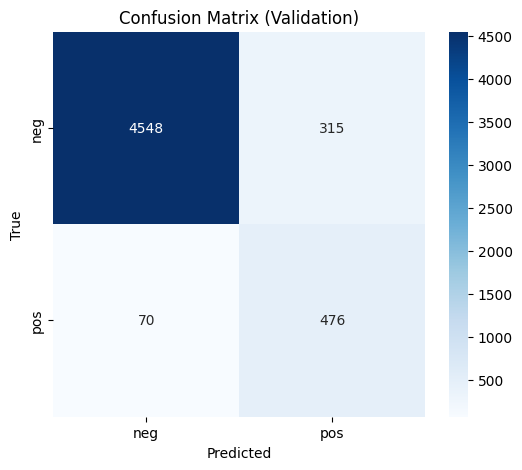

Test Evaluation:   0%|                                                       | 0/511 [00:00<?, ?it/s]

Test Evaluation:   0%|                                               | 1/511 [00:00<04:04,  2.08it/s]

Test Evaluation:   0%|▏                                              | 2/511 [00:00<04:07,  2.06it/s]

Test Evaluation:   1%|▎                                              | 3/511 [00:01<04:04,  2.07it/s]

Test Evaluation:   1%|▎                                              | 4/511 [00:01<04:05,  2.07it/s]

Test Evaluation:   1%|▍                                              | 5/511 [00:02<04:05,  2.06it/s]

Test Evaluation:   1%|▌                                              | 6/511 [00:02<03:56,  2.14it/s]

Test Evaluation:   1%|▋                                              | 7/511 [00:03<03:59,  2.10it/s]

Test Evaluation:   2%|▋                                              | 8/511 [00:03<03:59,  2.10it/s]

Test Evaluation:   2%|▊                                              | 9/511 [00:04<04:01,  2.08it/s]

Test Evaluation:   2%|▉                                             | 10/511 [00:04<03:54,  2.13it/s]

Test Evaluation:   2%|▉                                             | 11/511 [00:05<03:55,  2.13it/s]

Test Evaluation:   2%|█                                             | 12/511 [00:05<03:56,  2.11it/s]

Test Evaluation:   3%|█▏                                            | 13/511 [00:06<03:57,  2.09it/s]

Test Evaluation:   3%|█▎                                            | 14/511 [00:06<03:55,  2.11it/s]

Test Evaluation:   3%|█▎                                            | 15/511 [00:07<03:49,  2.16it/s]

Test Evaluation:   3%|█▍                                            | 16/511 [00:07<03:51,  2.14it/s]

Test Evaluation:   3%|█▌                                            | 17/511 [00:08<03:51,  2.14it/s]

Test Evaluation:   4%|█▌                                            | 18/511 [00:08<03:51,  2.13it/s]

Test Evaluation:   4%|█▋                                            | 19/511 [00:09<03:53,  2.11it/s]

Test Evaluation:   4%|█▊                                            | 20/511 [00:09<03:52,  2.11it/s]

Test Evaluation:   4%|█▉                                            | 21/511 [00:09<03:49,  2.14it/s]

Test Evaluation:   4%|█▉                                            | 22/511 [00:10<03:51,  2.11it/s]

Test Evaluation:   5%|██                                            | 23/511 [00:10<03:52,  2.10it/s]

Test Evaluation:   5%|██▏                                           | 24/511 [00:11<03:48,  2.13it/s]

Test Evaluation:   5%|██▎                                           | 25/511 [00:11<03:47,  2.13it/s]

Test Evaluation:   5%|██▎                                           | 26/511 [00:12<03:50,  2.11it/s]

Test Evaluation:   5%|██▍                                           | 27/511 [00:12<03:51,  2.09it/s]

Test Evaluation:   5%|██▌                                           | 28/511 [00:13<03:44,  2.15it/s]

Test Evaluation:   6%|██▌                                           | 29/511 [00:13<03:48,  2.11it/s]

Test Evaluation:   6%|██▋                                           | 30/511 [00:14<03:50,  2.09it/s]

Test Evaluation:   6%|██▊                                           | 31/511 [00:14<03:50,  2.08it/s]

Test Evaluation:   6%|██▉                                           | 32/511 [00:15<03:44,  2.13it/s]

Test Evaluation:   6%|██▉                                           | 33/511 [00:15<03:47,  2.10it/s]

Test Evaluation:   7%|███                                           | 34/511 [00:16<03:50,  2.07it/s]

Test Evaluation:   7%|███▏                                          | 35/511 [00:16<03:51,  2.06it/s]

Test Evaluation:   7%|███▏                                          | 36/511 [00:17<03:50,  2.06it/s]

Test Evaluation:   7%|███▎                                          | 37/511 [00:17<03:41,  2.14it/s]

Test Evaluation:   7%|███▍                                          | 38/511 [00:18<03:43,  2.11it/s]

Test Evaluation:   8%|███▌                                          | 39/511 [00:18<03:45,  2.09it/s]

Test Evaluation:   8%|███▌                                          | 40/511 [00:19<03:48,  2.06it/s]

Test Evaluation:   8%|███▋                                          | 41/511 [00:19<03:41,  2.12it/s]

Test Evaluation:   8%|███▊                                          | 42/511 [00:19<03:48,  2.05it/s]

Test Evaluation:   8%|███▊                                          | 43/511 [00:20<03:51,  2.02it/s]

Test Evaluation:   9%|███▉                                          | 44/511 [00:20<03:53,  2.00it/s]

Test Evaluation:   9%|████                                          | 45/511 [00:21<03:54,  1.99it/s]

Test Evaluation:   9%|████▏                                         | 46/511 [00:21<03:50,  2.02it/s]

Test Evaluation:   9%|████▏                                         | 47/511 [00:22<03:44,  2.07it/s]

Test Evaluation:   9%|████▎                                         | 48/511 [00:22<03:45,  2.05it/s]

Test Evaluation:  10%|████▍                                         | 49/511 [00:23<03:45,  2.05it/s]

Test Evaluation:  10%|████▌                                         | 50/511 [00:23<03:45,  2.04it/s]

Test Evaluation:  10%|████▌                                         | 51/511 [00:24<03:46,  2.03it/s]

Test Evaluation:  10%|████▋                                         | 52/511 [00:24<03:46,  2.03it/s]

Test Evaluation:  10%|████▊                                         | 53/511 [00:25<03:37,  2.10it/s]

Test Evaluation:  11%|████▊                                         | 54/511 [00:25<03:40,  2.07it/s]

Test Evaluation:  11%|████▉                                         | 55/511 [00:26<03:43,  2.04it/s]

Test Evaluation:  11%|█████                                         | 56/511 [00:26<03:45,  2.02it/s]

Test Evaluation:  11%|█████▏                                        | 57/511 [00:27<03:44,  2.02it/s]

Test Evaluation:  11%|█████▏                                        | 58/511 [00:27<03:44,  2.02it/s]

Test Evaluation:  12%|█████▎                                        | 59/511 [00:28<03:38,  2.07it/s]

Test Evaluation:  12%|█████▍                                        | 60/511 [00:28<03:38,  2.06it/s]

Test Evaluation:  12%|█████▍                                        | 61/511 [00:29<03:39,  2.05it/s]

Test Evaluation:  12%|█████▌                                        | 62/511 [00:29<03:39,  2.05it/s]

Test Evaluation:  12%|█████▋                                        | 63/511 [00:30<03:39,  2.05it/s]

Test Evaluation:  13%|█████▊                                        | 64/511 [00:30<03:38,  2.05it/s]

Test Evaluation:  13%|█████▊                                        | 65/511 [00:31<03:37,  2.05it/s]

Test Evaluation:  13%|█████▉                                        | 66/511 [00:31<03:38,  2.04it/s]

Test Evaluation:  13%|██████                                        | 67/511 [00:32<03:38,  2.03it/s]

Test Evaluation:  13%|██████                                        | 68/511 [00:32<03:37,  2.04it/s]

Test Evaluation:  14%|██████▏                                       | 69/511 [00:33<03:36,  2.04it/s]

Test Evaluation:  14%|██████▎                                       | 70/511 [00:33<03:35,  2.04it/s]

Test Evaluation:  14%|██████▍                                       | 71/511 [00:34<03:34,  2.06it/s]

Test Evaluation:  14%|██████▍                                       | 72/511 [00:34<03:32,  2.06it/s]

Test Evaluation:  14%|██████▌                                       | 73/511 [00:35<03:31,  2.07it/s]

Test Evaluation:  14%|██████▋                                       | 74/511 [00:35<03:31,  2.07it/s]

Test Evaluation:  15%|██████▊                                       | 75/511 [00:36<03:34,  2.03it/s]

Test Evaluation:  15%|██████▊                                       | 76/511 [00:36<03:36,  2.01it/s]

Test Evaluation:  15%|██████▉                                       | 77/511 [00:37<03:36,  2.00it/s]

Test Evaluation:  15%|███████                                       | 78/511 [00:37<03:36,  2.00it/s]

Test Evaluation:  15%|███████                                       | 79/511 [00:38<03:33,  2.02it/s]

Test Evaluation:  16%|███████▏                                      | 80/511 [00:38<03:33,  2.02it/s]

Test Evaluation:  16%|███████▎                                      | 81/511 [00:39<03:33,  2.01it/s]

Test Evaluation:  16%|███████▍                                      | 82/511 [00:39<03:34,  2.00it/s]

Test Evaluation:  16%|███████▍                                      | 83/511 [00:40<03:32,  2.01it/s]

Test Evaluation:  16%|███████▌                                      | 84/511 [00:40<03:31,  2.02it/s]

Test Evaluation:  17%|███████▋                                      | 85/511 [00:41<03:29,  2.03it/s]

Test Evaluation:  17%|███████▋                                      | 86/511 [00:41<03:28,  2.04it/s]

Test Evaluation:  17%|███████▊                                      | 87/511 [00:42<03:27,  2.04it/s]

Test Evaluation:  17%|███████▉                                      | 88/511 [00:42<03:27,  2.04it/s]

Test Evaluation:  17%|████████                                      | 89/511 [00:43<03:28,  2.03it/s]

Test Evaluation:  18%|████████                                      | 90/511 [00:43<03:27,  2.02it/s]

Test Evaluation:  18%|████████▏                                     | 91/511 [00:44<03:26,  2.03it/s]

Test Evaluation:  18%|████████▎                                     | 92/511 [00:44<03:27,  2.02it/s]

Test Evaluation:  18%|████████▎                                     | 93/511 [00:45<03:27,  2.01it/s]

Test Evaluation:  18%|████████▍                                     | 94/511 [00:45<03:27,  2.01it/s]

Test Evaluation:  19%|████████▌                                     | 95/511 [00:46<03:27,  2.01it/s]

Test Evaluation:  19%|████████▋                                     | 96/511 [00:46<03:28,  1.99it/s]

Test Evaluation:  19%|████████▋                                     | 97/511 [00:47<03:29,  1.98it/s]

Test Evaluation:  19%|████████▊                                     | 98/511 [00:47<03:28,  1.98it/s]

Test Evaluation:  19%|████████▉                                     | 99/511 [00:48<03:26,  2.00it/s]

Test Evaluation:  20%|████████▊                                    | 100/511 [00:48<03:19,  2.06it/s]

Test Evaluation:  20%|████████▉                                    | 101/511 [00:49<03:21,  2.04it/s]

Test Evaluation:  20%|████████▉                                    | 102/511 [00:49<03:21,  2.03it/s]

Test Evaluation:  20%|█████████                                    | 103/511 [00:50<03:21,  2.03it/s]

Test Evaluation:  20%|█████████▏                                   | 104/511 [00:50<03:21,  2.02it/s]

Test Evaluation:  21%|█████████▏                                   | 105/511 [00:51<03:22,  2.01it/s]

Test Evaluation:  21%|█████████▎                                   | 106/511 [00:51<03:21,  2.01it/s]

Test Evaluation:  21%|█████████▍                                   | 107/511 [00:52<03:20,  2.01it/s]

Test Evaluation:  21%|█████████▌                                   | 108/511 [00:52<03:21,  2.00it/s]

Test Evaluation:  21%|█████████▌                                   | 109/511 [00:53<03:21,  1.99it/s]

Test Evaluation:  22%|█████████▋                                   | 110/511 [00:53<03:21,  1.99it/s]

Test Evaluation:  22%|█████████▊                                   | 111/511 [00:54<03:20,  1.99it/s]

Test Evaluation:  22%|█████████▊                                   | 112/511 [00:54<03:19,  2.00it/s]

Test Evaluation:  22%|█████████▉                                   | 113/511 [00:55<03:19,  2.00it/s]

Test Evaluation:  22%|██████████                                   | 114/511 [00:55<03:18,  2.00it/s]

Test Evaluation:  23%|██████████▏                                  | 115/511 [00:56<03:20,  1.98it/s]

Test Evaluation:  23%|██████████▏                                  | 116/511 [00:56<03:22,  1.95it/s]

Test Evaluation:  23%|██████████▎                                  | 117/511 [00:57<03:20,  1.96it/s]

Test Evaluation:  23%|██████████▍                                  | 118/511 [00:57<03:18,  1.98it/s]

Test Evaluation:  23%|██████████▍                                  | 119/511 [00:58<03:10,  2.05it/s]

Test Evaluation:  23%|██████████▌                                  | 120/511 [00:58<03:12,  2.03it/s]

Test Evaluation:  24%|██████████▋                                  | 121/511 [00:59<03:13,  2.02it/s]

Test Evaluation:  24%|██████████▋                                  | 122/511 [00:59<03:13,  2.01it/s]

Test Evaluation:  24%|██████████▊                                  | 123/511 [01:00<03:13,  2.00it/s]

Test Evaluation:  24%|██████████▉                                  | 124/511 [01:00<03:13,  2.00it/s]

Test Evaluation:  24%|███████████                                  | 125/511 [01:01<03:13,  2.00it/s]

Test Evaluation:  25%|███████████                                  | 126/511 [01:01<03:13,  1.99it/s]

Test Evaluation:  25%|███████████▏                                 | 127/511 [01:02<03:12,  1.99it/s]

Test Evaluation:  25%|███████████▎                                 | 128/511 [01:02<03:12,  1.98it/s]

Test Evaluation:  25%|███████████▎                                 | 129/511 [01:03<03:12,  1.99it/s]

Test Evaluation:  25%|███████████▍                                 | 130/511 [01:03<03:11,  1.99it/s]

Test Evaluation:  26%|███████████▌                                 | 131/511 [01:04<03:11,  1.98it/s]

Test Evaluation:  26%|███████████▌                                 | 132/511 [01:04<03:11,  1.98it/s]

Test Evaluation:  26%|███████████▋                                 | 133/511 [01:05<03:11,  1.98it/s]

Test Evaluation:  26%|███████████▊                                 | 134/511 [01:05<03:09,  1.99it/s]

Test Evaluation:  26%|███████████▉                                 | 135/511 [01:06<03:09,  1.98it/s]

Test Evaluation:  27%|███████████▉                                 | 136/511 [01:06<03:08,  1.99it/s]

Test Evaluation:  27%|████████████                                 | 137/511 [01:07<03:09,  1.97it/s]

Test Evaluation:  27%|████████████▏                                | 138/511 [01:07<03:09,  1.97it/s]

Test Evaluation:  27%|████████████▏                                | 139/511 [01:08<03:08,  1.98it/s]

Test Evaluation:  27%|████████████▎                                | 140/511 [01:08<03:06,  1.99it/s]

Test Evaluation:  28%|████████████▍                                | 141/511 [01:09<03:06,  1.99it/s]

Test Evaluation:  28%|████████████▌                                | 142/511 [01:09<03:06,  1.97it/s]

Test Evaluation:  28%|████████████▌                                | 143/511 [01:10<03:06,  1.97it/s]

Test Evaluation:  28%|████████████▋                                | 144/511 [01:10<03:06,  1.97it/s]

Test Evaluation:  28%|████████████▊                                | 145/511 [01:11<03:05,  1.98it/s]

Test Evaluation:  29%|████████████▊                                | 146/511 [01:11<03:04,  1.98it/s]

Test Evaluation:  29%|████████████▉                                | 147/511 [01:12<03:04,  1.97it/s]

Test Evaluation:  29%|█████████████                                | 148/511 [01:12<03:04,  1.97it/s]

Test Evaluation:  29%|█████████████                                | 149/511 [01:13<03:03,  1.97it/s]

Test Evaluation:  29%|█████████████▏                               | 150/511 [01:13<03:01,  1.99it/s]

Test Evaluation:  30%|█████████████▎                               | 151/511 [01:14<03:01,  1.98it/s]

Test Evaluation:  30%|█████████████▍                               | 152/511 [01:14<03:01,  1.98it/s]

Test Evaluation:  30%|█████████████▍                               | 153/511 [01:15<03:01,  1.98it/s]

Test Evaluation:  30%|█████████████▌                               | 154/511 [01:15<03:00,  1.98it/s]

Test Evaluation:  30%|█████████████▋                               | 155/511 [01:16<03:00,  1.97it/s]

Test Evaluation:  31%|█████████████▋                               | 156/511 [01:16<02:59,  1.98it/s]

Test Evaluation:  31%|█████████████▊                               | 157/511 [01:17<02:59,  1.97it/s]

Test Evaluation:  31%|█████████████▉                               | 158/511 [01:17<02:58,  1.97it/s]

Test Evaluation:  31%|██████████████                               | 159/511 [01:18<02:52,  2.04it/s]

Test Evaluation:  31%|██████████████                               | 160/511 [01:18<02:52,  2.03it/s]

Test Evaluation:  32%|██████████████▏                              | 161/511 [01:19<02:54,  2.00it/s]

Test Evaluation:  32%|██████████████▎                              | 162/511 [01:19<02:55,  1.99it/s]

Test Evaluation:  32%|██████████████▎                              | 163/511 [01:20<02:56,  1.98it/s]

Test Evaluation:  32%|██████████████▍                              | 164/511 [01:20<02:56,  1.97it/s]

Test Evaluation:  32%|██████████████▌                              | 165/511 [01:21<02:55,  1.98it/s]

Test Evaluation:  32%|██████████████▌                              | 166/511 [01:21<02:54,  1.98it/s]

Test Evaluation:  33%|██████████████▋                              | 167/511 [01:22<02:54,  1.98it/s]

Test Evaluation:  33%|██████████████▊                              | 168/511 [01:22<02:53,  1.97it/s]

Test Evaluation:  33%|██████████████▉                              | 169/511 [01:23<02:53,  1.97it/s]

Test Evaluation:  33%|██████████████▉                              | 170/511 [01:23<02:52,  1.98it/s]

Test Evaluation:  33%|███████████████                              | 171/511 [01:24<02:52,  1.98it/s]

Test Evaluation:  34%|███████████████▏                             | 172/511 [01:24<02:52,  1.97it/s]

Test Evaluation:  34%|███████████████▏                             | 173/511 [01:25<02:52,  1.96it/s]

Test Evaluation:  34%|███████████████▎                             | 174/511 [01:25<02:50,  1.97it/s]

Test Evaluation:  34%|███████████████▍                             | 175/511 [01:26<02:51,  1.96it/s]

Test Evaluation:  34%|███████████████▍                             | 176/511 [01:26<02:50,  1.97it/s]

Test Evaluation:  35%|███████████████▌                             | 177/511 [01:27<02:48,  1.98it/s]

Test Evaluation:  35%|███████████████▋                             | 178/511 [01:27<02:45,  2.01it/s]

Test Evaluation:  35%|███████████████▊                             | 179/511 [01:28<02:46,  2.00it/s]

Test Evaluation:  35%|███████████████▊                             | 180/511 [01:28<02:46,  1.99it/s]

Test Evaluation:  35%|███████████████▉                             | 181/511 [01:29<02:46,  1.98it/s]

Test Evaluation:  36%|████████████████                             | 182/511 [01:29<02:45,  1.98it/s]

Test Evaluation:  36%|████████████████                             | 183/511 [01:30<02:45,  1.98it/s]

Test Evaluation:  36%|████████████████▏                            | 184/511 [01:30<02:44,  1.98it/s]

Test Evaluation:  36%|████████████████▎                            | 185/511 [01:31<02:44,  1.99it/s]

Test Evaluation:  36%|████████████████▍                            | 186/511 [01:31<02:43,  1.99it/s]

Test Evaluation:  37%|████████████████▍                            | 187/511 [01:32<02:44,  1.97it/s]

Test Evaluation:  37%|████████████████▌                            | 188/511 [01:32<02:43,  1.97it/s]

Test Evaluation:  37%|████████████████▋                            | 189/511 [01:33<02:43,  1.97it/s]

Test Evaluation:  37%|████████████████▋                            | 190/511 [01:33<02:44,  1.95it/s]

Test Evaluation:  37%|████████████████▊                            | 191/511 [01:34<02:44,  1.95it/s]

Test Evaluation:  38%|████████████████▉                            | 192/511 [01:34<02:42,  1.97it/s]

Test Evaluation:  38%|████████████████▉                            | 193/511 [01:35<02:41,  1.96it/s]

Test Evaluation:  38%|█████████████████                            | 194/511 [01:35<02:40,  1.97it/s]

Test Evaluation:  38%|█████████████████▏                           | 195/511 [01:36<02:38,  2.00it/s]

Test Evaluation:  38%|█████████████████▎                           | 196/511 [01:36<02:39,  1.97it/s]

Test Evaluation:  39%|█████████████████▎                           | 197/511 [01:37<02:36,  2.01it/s]

Test Evaluation:  39%|█████████████████▍                           | 198/511 [01:37<02:34,  2.03it/s]

Test Evaluation:  39%|█████████████████▌                           | 199/511 [01:38<02:33,  2.03it/s]

Test Evaluation:  39%|█████████████████▌                           | 200/511 [01:38<02:33,  2.03it/s]

Test Evaluation:  39%|█████████████████▋                           | 201/511 [01:39<02:33,  2.02it/s]

Test Evaluation:  40%|█████████████████▊                           | 202/511 [01:39<02:33,  2.02it/s]

Test Evaluation:  40%|█████████████████▉                           | 203/511 [01:40<02:32,  2.03it/s]

Test Evaluation:  40%|█████████████████▉                           | 204/511 [01:40<02:31,  2.02it/s]

Test Evaluation:  40%|██████████████████                           | 205/511 [01:41<02:30,  2.03it/s]

Test Evaluation:  40%|██████████████████▏                          | 206/511 [01:41<02:29,  2.04it/s]

Test Evaluation:  41%|██████████████████▏                          | 207/511 [01:42<02:24,  2.11it/s]

Test Evaluation:  41%|██████████████████▎                          | 208/511 [01:42<02:24,  2.09it/s]

Test Evaluation:  41%|██████████████████▍                          | 209/511 [01:43<02:26,  2.06it/s]

Test Evaluation:  41%|██████████████████▍                          | 210/511 [01:43<02:26,  2.06it/s]

Test Evaluation:  41%|██████████████████▌                          | 211/511 [01:44<02:25,  2.06it/s]

Test Evaluation:  41%|██████████████████▋                          | 212/511 [01:44<02:24,  2.06it/s]

Test Evaluation:  42%|██████████████████▊                          | 213/511 [01:45<02:24,  2.06it/s]

Test Evaluation:  42%|██████████████████▊                          | 214/511 [01:45<02:24,  2.06it/s]

Test Evaluation:  42%|██████████████████▉                          | 215/511 [01:46<02:24,  2.05it/s]

Test Evaluation:  42%|███████████████████                          | 216/511 [01:46<02:23,  2.05it/s]

Test Evaluation:  42%|███████████████████                          | 217/511 [01:47<02:23,  2.05it/s]

Test Evaluation:  43%|███████████████████▏                         | 218/511 [01:47<02:23,  2.05it/s]

Test Evaluation:  43%|███████████████████▎                         | 219/511 [01:48<02:22,  2.05it/s]

Test Evaluation:  43%|███████████████████▎                         | 220/511 [01:48<02:22,  2.05it/s]

Test Evaluation:  43%|███████████████████▍                         | 221/511 [01:49<02:21,  2.05it/s]

Test Evaluation:  43%|███████████████████▌                         | 222/511 [01:49<02:21,  2.05it/s]

Test Evaluation:  44%|███████████████████▋                         | 223/511 [01:50<02:20,  2.05it/s]

Test Evaluation:  44%|███████████████████▋                         | 224/511 [01:50<02:19,  2.05it/s]

Test Evaluation:  44%|███████████████████▊                         | 225/511 [01:51<02:19,  2.05it/s]

Test Evaluation:  44%|███████████████████▉                         | 226/511 [01:51<02:19,  2.05it/s]

Test Evaluation:  44%|███████████████████▉                         | 227/511 [01:52<02:17,  2.06it/s]

Test Evaluation:  45%|████████████████████                         | 228/511 [01:52<02:17,  2.06it/s]

Test Evaluation:  45%|████████████████████▏                        | 229/511 [01:52<02:16,  2.07it/s]

Test Evaluation:  45%|████████████████████▎                        | 230/511 [01:53<02:17,  2.05it/s]

Test Evaluation:  45%|████████████████████▎                        | 231/511 [01:53<02:16,  2.05it/s]

Test Evaluation:  45%|████████████████████▍                        | 232/511 [01:54<02:15,  2.05it/s]

Test Evaluation:  46%|████████████████████▌                        | 233/511 [01:54<02:14,  2.06it/s]

Test Evaluation:  46%|████████████████████▌                        | 234/511 [01:55<02:13,  2.07it/s]

Test Evaluation:  46%|████████████████████▋                        | 235/511 [01:55<02:13,  2.07it/s]

Test Evaluation:  46%|████████████████████▊                        | 236/511 [01:56<02:13,  2.06it/s]

Test Evaluation:  46%|████████████████████▊                        | 237/511 [01:56<02:13,  2.05it/s]

Test Evaluation:  47%|████████████████████▉                        | 238/511 [01:57<02:12,  2.06it/s]

Test Evaluation:  47%|█████████████████████                        | 239/511 [01:57<02:13,  2.04it/s]

Test Evaluation:  47%|█████████████████████▏                       | 240/511 [01:58<02:12,  2.04it/s]

Test Evaluation:  47%|█████████████████████▏                       | 241/511 [01:58<02:12,  2.04it/s]

Test Evaluation:  47%|█████████████████████▎                       | 242/511 [01:59<02:11,  2.04it/s]

Test Evaluation:  48%|█████████████████████▍                       | 243/511 [01:59<02:11,  2.03it/s]

Test Evaluation:  48%|█████████████████████▍                       | 244/511 [02:00<02:10,  2.04it/s]

Test Evaluation:  48%|█████████████████████▌                       | 245/511 [02:00<02:09,  2.06it/s]

Test Evaluation:  48%|█████████████████████▋                       | 246/511 [02:01<02:06,  2.10it/s]

Test Evaluation:  48%|█████████████████████▊                       | 247/511 [02:01<02:05,  2.11it/s]

Test Evaluation:  49%|█████████████████████▊                       | 248/511 [02:02<02:05,  2.09it/s]

Test Evaluation:  49%|█████████████████████▉                       | 249/511 [02:02<02:06,  2.08it/s]

Test Evaluation:  49%|██████████████████████                       | 250/511 [02:03<02:06,  2.07it/s]

Test Evaluation:  49%|██████████████████████                       | 251/511 [02:03<02:06,  2.06it/s]

Test Evaluation:  49%|██████████████████████▏                      | 252/511 [02:04<02:06,  2.05it/s]

Test Evaluation:  50%|██████████████████████▎                      | 253/511 [02:04<02:04,  2.07it/s]

Test Evaluation:  50%|██████████████████████▎                      | 254/511 [02:05<02:05,  2.05it/s]

Test Evaluation:  50%|██████████████████████▍                      | 255/511 [02:05<02:04,  2.05it/s]

Test Evaluation:  50%|██████████████████████▌                      | 256/511 [02:06<02:03,  2.06it/s]

Test Evaluation:  50%|██████████████████████▋                      | 257/511 [02:06<02:03,  2.06it/s]

Test Evaluation:  50%|██████████████████████▋                      | 258/511 [02:07<02:02,  2.06it/s]

Test Evaluation:  51%|██████████████████████▊                      | 259/511 [02:07<02:02,  2.06it/s]

Test Evaluation:  51%|██████████████████████▉                      | 260/511 [02:08<02:02,  2.04it/s]

Test Evaluation:  51%|██████████████████████▉                      | 261/511 [02:08<02:01,  2.06it/s]

Test Evaluation:  51%|███████████████████████                      | 262/511 [02:09<02:01,  2.05it/s]

Test Evaluation:  51%|███████████████████████▏                     | 263/511 [02:09<02:01,  2.05it/s]

Test Evaluation:  52%|███████████████████████▏                     | 264/511 [02:10<02:00,  2.05it/s]

Test Evaluation:  52%|███████████████████████▎                     | 265/511 [02:10<01:59,  2.06it/s]

Test Evaluation:  52%|███████████████████████▍                     | 266/511 [02:10<01:58,  2.07it/s]

Test Evaluation:  52%|███████████████████████▌                     | 267/511 [02:11<01:58,  2.05it/s]

Test Evaluation:  52%|███████████████████████▌                     | 268/511 [02:11<01:58,  2.04it/s]

Test Evaluation:  53%|███████████████████████▋                     | 269/511 [02:12<01:57,  2.06it/s]

Test Evaluation:  53%|███████████████████████▊                     | 270/511 [02:12<01:57,  2.05it/s]

Test Evaluation:  53%|███████████████████████▊                     | 271/511 [02:13<01:57,  2.04it/s]

Test Evaluation:  53%|███████████████████████▉                     | 272/511 [02:13<01:57,  2.03it/s]

Test Evaluation:  53%|████████████████████████                     | 273/511 [02:14<01:56,  2.05it/s]

Test Evaluation:  54%|████████████████████████▏                    | 274/511 [02:14<01:52,  2.11it/s]

Test Evaluation:  54%|████████████████████████▏                    | 275/511 [02:15<01:53,  2.08it/s]

Test Evaluation:  54%|████████████████████████▎                    | 276/511 [02:15<01:54,  2.06it/s]

Test Evaluation:  54%|████████████████████████▍                    | 277/511 [02:16<01:54,  2.05it/s]

Test Evaluation:  54%|████████████████████████▍                    | 278/511 [02:16<01:53,  2.05it/s]

Test Evaluation:  55%|████████████████████████▌                    | 279/511 [02:17<01:53,  2.05it/s]

Test Evaluation:  55%|████████████████████████▋                    | 280/511 [02:17<01:52,  2.06it/s]

Test Evaluation:  55%|████████████████████████▋                    | 281/511 [02:18<01:51,  2.06it/s]

Test Evaluation:  55%|████████████████████████▊                    | 282/511 [02:18<01:50,  2.06it/s]

Test Evaluation:  55%|████████████████████████▉                    | 283/511 [02:19<01:51,  2.05it/s]

Test Evaluation:  56%|█████████████████████████                    | 284/511 [02:19<01:50,  2.05it/s]

Test Evaluation:  56%|█████████████████████████                    | 285/511 [02:20<01:50,  2.05it/s]

Test Evaluation:  56%|█████████████████████████▏                   | 286/511 [02:20<01:50,  2.04it/s]

Test Evaluation:  56%|█████████████████████████▎                   | 287/511 [02:21<01:49,  2.05it/s]

Test Evaluation:  56%|█████████████████████████▎                   | 288/511 [02:21<01:48,  2.06it/s]

Test Evaluation:  57%|█████████████████████████▍                   | 289/511 [02:22<01:47,  2.06it/s]

Test Evaluation:  57%|█████████████████████████▌                   | 290/511 [02:22<01:47,  2.06it/s]

Test Evaluation:  57%|█████████████████████████▋                   | 291/511 [02:23<01:46,  2.07it/s]

Test Evaluation:  57%|█████████████████████████▋                   | 292/511 [02:23<01:46,  2.06it/s]

Test Evaluation:  57%|█████████████████████████▊                   | 293/511 [02:24<01:45,  2.06it/s]

Test Evaluation:  58%|█████████████████████████▉                   | 294/511 [02:24<01:44,  2.07it/s]

Test Evaluation:  58%|█████████████████████████▉                   | 295/511 [02:25<01:44,  2.06it/s]

Test Evaluation:  58%|██████████████████████████                   | 296/511 [02:25<01:45,  2.05it/s]

Test Evaluation:  58%|██████████████████████████▏                  | 297/511 [02:26<01:44,  2.06it/s]

Test Evaluation:  58%|██████████████████████████▏                  | 298/511 [02:26<01:44,  2.05it/s]

Test Evaluation:  59%|██████████████████████████▎                  | 299/511 [02:27<01:43,  2.04it/s]

Test Evaluation:  59%|██████████████████████████▍                  | 300/511 [02:27<01:43,  2.05it/s]

Test Evaluation:  59%|██████████████████████████▌                  | 301/511 [02:28<01:42,  2.05it/s]

Test Evaluation:  59%|██████████████████████████▌                  | 302/511 [02:28<01:41,  2.06it/s]

Test Evaluation:  59%|██████████████████████████▋                  | 303/511 [02:28<01:40,  2.06it/s]

Test Evaluation:  59%|██████████████████████████▊                  | 304/511 [02:29<01:39,  2.07it/s]

Test Evaluation:  60%|██████████████████████████▊                  | 305/511 [02:29<01:39,  2.07it/s]

Test Evaluation:  60%|██████████████████████████▉                  | 306/511 [02:30<01:39,  2.07it/s]

Test Evaluation:  60%|███████████████████████████                  | 307/511 [02:30<01:38,  2.06it/s]

Test Evaluation:  60%|███████████████████████████                  | 308/511 [02:31<01:39,  2.04it/s]

Test Evaluation:  60%|███████████████████████████▏                 | 309/511 [02:31<01:39,  2.03it/s]

Test Evaluation:  61%|███████████████████████████▎                 | 310/511 [02:32<01:39,  2.03it/s]

Test Evaluation:  61%|███████████████████████████▍                 | 311/511 [02:32<01:36,  2.08it/s]

Test Evaluation:  61%|███████████████████████████▍                 | 312/511 [02:33<01:34,  2.10it/s]

Test Evaluation:  61%|███████████████████████████▌                 | 313/511 [02:33<01:35,  2.08it/s]

Test Evaluation:  61%|███████████████████████████▋                 | 314/511 [02:34<01:35,  2.07it/s]

Test Evaluation:  62%|███████████████████████████▋                 | 315/511 [02:34<01:34,  2.07it/s]

Test Evaluation:  62%|███████████████████████████▊                 | 316/511 [02:35<01:34,  2.06it/s]

Test Evaluation:  62%|███████████████████████████▉                 | 317/511 [02:35<01:34,  2.05it/s]

Test Evaluation:  62%|████████████████████████████                 | 318/511 [02:36<01:34,  2.05it/s]

Test Evaluation:  62%|████████████████████████████                 | 319/511 [02:36<01:33,  2.05it/s]

Test Evaluation:  63%|████████████████████████████▏                | 320/511 [02:37<01:33,  2.04it/s]

Test Evaluation:  63%|████████████████████████████▎                | 321/511 [02:37<01:33,  2.04it/s]

Test Evaluation:  63%|████████████████████████████▎                | 322/511 [02:38<01:33,  2.02it/s]

Test Evaluation:  63%|████████████████████████████▍                | 323/511 [02:38<01:32,  2.04it/s]

Test Evaluation:  63%|████████████████████████████▌                | 324/511 [02:39<01:31,  2.04it/s]

Test Evaluation:  64%|████████████████████████████▌                | 325/511 [02:39<01:30,  2.05it/s]

Test Evaluation:  64%|████████████████████████████▋                | 326/511 [02:40<01:30,  2.05it/s]

Test Evaluation:  64%|████████████████████████████▊                | 327/511 [02:40<01:29,  2.05it/s]

Test Evaluation:  64%|████████████████████████████▉                | 328/511 [02:41<01:29,  2.04it/s]

Test Evaluation:  64%|████████████████████████████▉                | 329/511 [02:41<01:28,  2.05it/s]

Test Evaluation:  65%|█████████████████████████████                | 330/511 [02:42<01:28,  2.03it/s]

Test Evaluation:  65%|█████████████████████████████▏               | 331/511 [02:42<01:28,  2.04it/s]

Test Evaluation:  65%|█████████████████████████████▏               | 332/511 [02:43<01:27,  2.05it/s]

Test Evaluation:  65%|█████████████████████████████▎               | 333/511 [02:43<01:27,  2.04it/s]

Test Evaluation:  65%|█████████████████████████████▍               | 334/511 [02:44<01:26,  2.05it/s]

Test Evaluation:  66%|█████████████████████████████▌               | 335/511 [02:44<01:25,  2.06it/s]

Test Evaluation:  66%|█████████████████████████████▌               | 336/511 [02:45<01:25,  2.05it/s]

Test Evaluation:  66%|█████████████████████████████▋               | 337/511 [02:45<01:24,  2.06it/s]

Test Evaluation:  66%|█████████████████████████████▊               | 338/511 [02:46<01:24,  2.05it/s]

Test Evaluation:  66%|█████████████████████████████▊               | 339/511 [02:46<01:21,  2.11it/s]

Test Evaluation:  67%|█████████████████████████████▉               | 340/511 [02:46<01:21,  2.10it/s]

Test Evaluation:  67%|██████████████████████████████               | 341/511 [02:47<01:21,  2.09it/s]

Test Evaluation:  67%|██████████████████████████████               | 342/511 [02:47<01:22,  2.06it/s]

Test Evaluation:  67%|██████████████████████████████▏              | 343/511 [02:48<01:22,  2.05it/s]

Test Evaluation:  67%|██████████████████████████████▎              | 344/511 [02:48<01:21,  2.06it/s]

Test Evaluation:  68%|██████████████████████████████▍              | 345/511 [02:49<01:21,  2.05it/s]

Test Evaluation:  68%|██████████████████████████████▍              | 346/511 [02:49<01:21,  2.03it/s]

Test Evaluation:  68%|██████████████████████████████▌              | 347/511 [02:50<01:20,  2.04it/s]

Test Evaluation:  68%|██████████████████████████████▋              | 348/511 [02:50<01:19,  2.05it/s]

Test Evaluation:  68%|██████████████████████████████▋              | 349/511 [02:51<01:19,  2.04it/s]

Test Evaluation:  68%|██████████████████████████████▊              | 350/511 [02:51<01:18,  2.05it/s]

Test Evaluation:  69%|██████████████████████████████▉              | 351/511 [02:52<01:18,  2.04it/s]

Test Evaluation:  69%|██████████████████████████████▉              | 352/511 [02:52<01:18,  2.03it/s]

Test Evaluation:  69%|███████████████████████████████              | 353/511 [02:53<01:17,  2.04it/s]

Test Evaluation:  69%|███████████████████████████████▏             | 354/511 [02:53<01:17,  2.02it/s]

Test Evaluation:  69%|███████████████████████████████▎             | 355/511 [02:54<01:16,  2.03it/s]

Test Evaluation:  70%|███████████████████████████████▎             | 356/511 [02:54<01:16,  2.03it/s]

Test Evaluation:  70%|███████████████████████████████▍             | 357/511 [02:55<01:15,  2.04it/s]

Test Evaluation:  70%|███████████████████████████████▌             | 358/511 [02:55<01:14,  2.05it/s]

Test Evaluation:  70%|███████████████████████████████▌             | 359/511 [02:56<01:13,  2.06it/s]

Test Evaluation:  70%|███████████████████████████████▋             | 360/511 [02:56<01:14,  2.04it/s]

Test Evaluation:  71%|███████████████████████████████▊             | 361/511 [02:57<01:13,  2.05it/s]

Test Evaluation:  71%|███████████████████████████████▉             | 362/511 [02:57<01:12,  2.05it/s]

Test Evaluation:  71%|███████████████████████████████▉             | 363/511 [02:58<01:12,  2.04it/s]

Test Evaluation:  71%|████████████████████████████████             | 364/511 [02:58<01:11,  2.04it/s]

Test Evaluation:  71%|████████████████████████████████▏            | 365/511 [02:59<01:09,  2.10it/s]

Test Evaluation:  72%|████████████████████████████████▏            | 366/511 [02:59<01:09,  2.09it/s]

Test Evaluation:  72%|████████████████████████████████▎            | 367/511 [03:00<01:09,  2.07it/s]

Test Evaluation:  72%|████████████████████████████████▍            | 368/511 [03:00<01:09,  2.06it/s]

Test Evaluation:  72%|████████████████████████████████▍            | 369/511 [03:01<01:09,  2.05it/s]

Test Evaluation:  72%|████████████████████████████████▌            | 370/511 [03:01<01:08,  2.05it/s]

Test Evaluation:  73%|████████████████████████████████▋            | 371/511 [03:02<01:08,  2.05it/s]

Test Evaluation:  73%|████████████████████████████████▊            | 372/511 [03:02<01:07,  2.05it/s]

Test Evaluation:  73%|████████████████████████████████▊            | 373/511 [03:03<01:06,  2.06it/s]

Test Evaluation:  73%|████████████████████████████████▉            | 374/511 [03:03<01:06,  2.05it/s]

Test Evaluation:  73%|█████████████████████████████████            | 375/511 [03:04<01:06,  2.06it/s]

Test Evaluation:  74%|█████████████████████████████████            | 376/511 [03:04<01:05,  2.06it/s]

Test Evaluation:  74%|█████████████████████████████████▏           | 377/511 [03:05<01:04,  2.06it/s]

Test Evaluation:  74%|█████████████████████████████████▎           | 378/511 [03:05<01:04,  2.06it/s]

Test Evaluation:  74%|█████████████████████████████████▍           | 379/511 [03:06<01:04,  2.04it/s]

Test Evaluation:  74%|█████████████████████████████████▍           | 380/511 [03:06<01:04,  2.04it/s]

Test Evaluation:  75%|█████████████████████████████████▌           | 381/511 [03:06<01:03,  2.04it/s]

Test Evaluation:  75%|█████████████████████████████████▋           | 382/511 [03:07<01:03,  2.05it/s]

Test Evaluation:  75%|█████████████████████████████████▋           | 383/511 [03:07<01:02,  2.05it/s]

Test Evaluation:  75%|█████████████████████████████████▊           | 384/511 [03:08<01:01,  2.05it/s]

Test Evaluation:  75%|█████████████████████████████████▉           | 385/511 [03:08<01:01,  2.05it/s]

Test Evaluation:  76%|█████████████████████████████████▉           | 386/511 [03:09<01:00,  2.05it/s]

Test Evaluation:  76%|██████████████████████████████████           | 387/511 [03:09<01:00,  2.06it/s]

Test Evaluation:  76%|██████████████████████████████████▏          | 388/511 [03:10<00:59,  2.05it/s]

Test Evaluation:  76%|██████████████████████████████████▎          | 389/511 [03:10<00:59,  2.05it/s]

Test Evaluation:  76%|██████████████████████████████████▎          | 390/511 [03:11<00:59,  2.04it/s]

Test Evaluation:  77%|██████████████████████████████████▍          | 391/511 [03:11<00:58,  2.04it/s]

Test Evaluation:  77%|██████████████████████████████████▌          | 392/511 [03:12<00:58,  2.04it/s]

Test Evaluation:  77%|██████████████████████████████████▌          | 393/511 [03:12<00:58,  2.03it/s]

Test Evaluation:  77%|██████████████████████████████████▋          | 394/511 [03:13<00:57,  2.03it/s]

Test Evaluation:  77%|██████████████████████████████████▊          | 395/511 [03:13<00:56,  2.04it/s]

Test Evaluation:  77%|██████████████████████████████████▊          | 396/511 [03:14<00:56,  2.05it/s]

Test Evaluation:  78%|██████████████████████████████████▉          | 397/511 [03:14<00:55,  2.05it/s]

Test Evaluation:  78%|███████████████████████████████████          | 398/511 [03:15<00:55,  2.05it/s]

Test Evaluation:  78%|███████████████████████████████████▏         | 399/511 [03:15<00:54,  2.05it/s]

Test Evaluation:  78%|███████████████████████████████████▏         | 400/511 [03:16<00:54,  2.05it/s]

Test Evaluation:  78%|███████████████████████████████████▎         | 401/511 [03:16<00:53,  2.06it/s]

Test Evaluation:  79%|███████████████████████████████████▍         | 402/511 [03:17<00:53,  2.05it/s]

Test Evaluation:  79%|███████████████████████████████████▍         | 403/511 [03:17<00:52,  2.05it/s]

Test Evaluation:  79%|███████████████████████████████████▌         | 404/511 [03:18<00:52,  2.05it/s]

Test Evaluation:  79%|███████████████████████████████████▋         | 405/511 [03:18<00:51,  2.05it/s]

Test Evaluation:  79%|███████████████████████████████████▊         | 406/511 [03:19<00:51,  2.04it/s]

Test Evaluation:  80%|███████████████████████████████████▊         | 407/511 [03:19<00:50,  2.04it/s]

Test Evaluation:  80%|███████████████████████████████████▉         | 408/511 [03:20<00:50,  2.04it/s]

Test Evaluation:  80%|████████████████████████████████████         | 409/511 [03:20<00:49,  2.05it/s]

Test Evaluation:  80%|████████████████████████████████████         | 410/511 [03:21<00:47,  2.13it/s]

Test Evaluation:  80%|████████████████████████████████████▏        | 411/511 [03:21<00:47,  2.11it/s]

Test Evaluation:  81%|████████████████████████████████████▎        | 412/511 [03:22<00:47,  2.10it/s]

Test Evaluation:  81%|████████████████████████████████████▎        | 413/511 [03:22<00:46,  2.09it/s]

Test Evaluation:  81%|████████████████████████████████████▍        | 414/511 [03:23<00:46,  2.08it/s]

Test Evaluation:  81%|████████████████████████████████████▌        | 415/511 [03:23<00:46,  2.07it/s]

Test Evaluation:  81%|████████████████████████████████████▋        | 416/511 [03:24<00:46,  2.04it/s]

Test Evaluation:  82%|████████████████████████████████████▋        | 417/511 [03:24<00:45,  2.04it/s]

Test Evaluation:  82%|████████████████████████████████████▊        | 418/511 [03:25<00:45,  2.03it/s]

Test Evaluation:  82%|████████████████████████████████████▉        | 419/511 [03:25<00:45,  2.04it/s]

Test Evaluation:  82%|████████████████████████████████████▉        | 420/511 [03:25<00:44,  2.05it/s]

Test Evaluation:  82%|█████████████████████████████████████        | 421/511 [03:26<00:43,  2.05it/s]

Test Evaluation:  83%|█████████████████████████████████████▏       | 422/511 [03:26<00:43,  2.04it/s]

Test Evaluation:  83%|█████████████████████████████████████▎       | 423/511 [03:27<00:42,  2.06it/s]

Test Evaluation:  83%|█████████████████████████████████████▎       | 424/511 [03:27<00:42,  2.05it/s]

Test Evaluation:  83%|█████████████████████████████████████▍       | 425/511 [03:28<00:41,  2.05it/s]

Test Evaluation:  83%|█████████████████████████████████████▌       | 426/511 [03:28<00:41,  2.04it/s]

Test Evaluation:  84%|█████████████████████████████████████▌       | 427/511 [03:29<00:41,  2.05it/s]

Test Evaluation:  84%|█████████████████████████████████████▋       | 428/511 [03:29<00:40,  2.04it/s]

Test Evaluation:  84%|█████████████████████████████████████▊       | 429/511 [03:30<00:40,  2.04it/s]

Test Evaluation:  84%|█████████████████████████████████████▊       | 430/511 [03:30<00:39,  2.04it/s]

Test Evaluation:  84%|█████████████████████████████████████▉       | 431/511 [03:31<00:39,  2.05it/s]

Test Evaluation:  85%|██████████████████████████████████████       | 432/511 [03:31<00:38,  2.06it/s]

Test Evaluation:  85%|██████████████████████████████████████▏      | 433/511 [03:32<00:37,  2.06it/s]

Test Evaluation:  85%|██████████████████████████████████████▏      | 434/511 [03:32<00:35,  2.15it/s]

Test Evaluation:  85%|██████████████████████████████████████▎      | 435/511 [03:33<00:36,  2.10it/s]

Test Evaluation:  85%|██████████████████████████████████████▍      | 436/511 [03:33<00:35,  2.09it/s]

Test Evaluation:  86%|██████████████████████████████████████▍      | 437/511 [03:34<00:35,  2.08it/s]

Test Evaluation:  86%|██████████████████████████████████████▌      | 438/511 [03:34<00:35,  2.07it/s]

Test Evaluation:  86%|██████████████████████████████████████▋      | 439/511 [03:35<00:34,  2.06it/s]

Test Evaluation:  86%|██████████████████████████████████████▋      | 440/511 [03:35<00:34,  2.05it/s]

Test Evaluation:  86%|██████████████████████████████████████▊      | 441/511 [03:36<00:34,  2.05it/s]

Test Evaluation:  86%|██████████████████████████████████████▉      | 442/511 [03:36<00:33,  2.06it/s]

Test Evaluation:  87%|███████████████████████████████████████      | 443/511 [03:37<00:32,  2.06it/s]

Test Evaluation:  87%|███████████████████████████████████████      | 444/511 [03:37<00:32,  2.06it/s]

Test Evaluation:  87%|███████████████████████████████████████▏     | 445/511 [03:38<00:32,  2.06it/s]

Test Evaluation:  87%|███████████████████████████████████████▎     | 446/511 [03:38<00:31,  2.05it/s]

Test Evaluation:  87%|███████████████████████████████████████▎     | 447/511 [03:39<00:31,  2.05it/s]

Test Evaluation:  88%|███████████████████████████████████████▍     | 448/511 [03:39<00:30,  2.05it/s]

Test Evaluation:  88%|███████████████████████████████████████▌     | 449/511 [03:40<00:30,  2.04it/s]

Test Evaluation:  88%|███████████████████████████████████████▋     | 450/511 [03:40<00:29,  2.03it/s]

Test Evaluation:  88%|███████████████████████████████████████▋     | 451/511 [03:41<00:29,  2.04it/s]

Test Evaluation:  88%|███████████████████████████████████████▊     | 452/511 [03:41<00:28,  2.04it/s]

Test Evaluation:  89%|███████████████████████████████████████▉     | 453/511 [03:42<00:28,  2.05it/s]

Test Evaluation:  89%|███████████████████████████████████████▉     | 454/511 [03:42<00:27,  2.06it/s]

Test Evaluation:  89%|████████████████████████████████████████     | 455/511 [03:42<00:27,  2.05it/s]

Test Evaluation:  89%|████████████████████████████████████████▏    | 456/511 [03:43<00:27,  2.03it/s]

Test Evaluation:  89%|████████████████████████████████████████▏    | 457/511 [03:43<00:26,  2.05it/s]

Test Evaluation:  90%|████████████████████████████████████████▎    | 458/511 [03:44<00:25,  2.04it/s]

Test Evaluation:  90%|████████████████████████████████████████▍    | 459/511 [03:44<00:25,  2.04it/s]

Test Evaluation:  90%|████████████████████████████████████████▌    | 460/511 [03:45<00:25,  2.04it/s]

Test Evaluation:  90%|████████████████████████████████████████▌    | 461/511 [03:45<00:24,  2.05it/s]

Test Evaluation:  90%|████████████████████████████████████████▋    | 462/511 [03:46<00:24,  2.04it/s]

Test Evaluation:  91%|████████████████████████████████████████▊    | 463/511 [03:46<00:22,  2.12it/s]

Test Evaluation:  91%|████████████████████████████████████████▊    | 464/511 [03:47<00:22,  2.09it/s]

Test Evaluation:  91%|████████████████████████████████████████▉    | 465/511 [03:47<00:22,  2.09it/s]

Test Evaluation:  91%|█████████████████████████████████████████    | 466/511 [03:48<00:21,  2.07it/s]

Test Evaluation:  91%|█████████████████████████████████████████▏   | 467/511 [03:48<00:21,  2.07it/s]

Test Evaluation:  92%|█████████████████████████████████████████▏   | 468/511 [03:49<00:20,  2.06it/s]

Test Evaluation:  92%|█████████████████████████████████████████▎   | 469/511 [03:49<00:20,  2.06it/s]

Test Evaluation:  92%|█████████████████████████████████████████▍   | 470/511 [03:50<00:19,  2.07it/s]

Test Evaluation:  92%|█████████████████████████████████████████▍   | 471/511 [03:50<00:19,  2.07it/s]

Test Evaluation:  92%|█████████████████████████████████████████▌   | 472/511 [03:51<00:18,  2.06it/s]

Test Evaluation:  93%|█████████████████████████████████████████▋   | 473/511 [03:51<00:18,  2.06it/s]

Test Evaluation:  93%|█████████████████████████████████████████▋   | 474/511 [03:52<00:17,  2.06it/s]

Test Evaluation:  93%|█████████████████████████████████████████▊   | 475/511 [03:52<00:17,  2.05it/s]

Test Evaluation:  93%|█████████████████████████████████████████▉   | 476/511 [03:53<00:17,  2.04it/s]

Test Evaluation:  93%|██████████████████████████████████████████   | 477/511 [03:53<00:16,  2.05it/s]

Test Evaluation:  94%|██████████████████████████████████████████   | 478/511 [03:54<00:16,  2.04it/s]

Test Evaluation:  94%|██████████████████████████████████████████▏  | 479/511 [03:54<00:15,  2.05it/s]

Test Evaluation:  94%|██████████████████████████████████████████▎  | 480/511 [03:55<00:15,  2.04it/s]

Test Evaluation:  94%|██████████████████████████████████████████▎  | 481/511 [03:55<00:14,  2.04it/s]

Test Evaluation:  94%|██████████████████████████████████████████▍  | 482/511 [03:56<00:13,  2.10it/s]

Test Evaluation:  95%|██████████████████████████████████████████▌  | 483/511 [03:56<00:13,  2.08it/s]

Test Evaluation:  95%|██████████████████████████████████████████▌  | 484/511 [03:57<00:12,  2.08it/s]

Test Evaluation:  95%|██████████████████████████████████████████▋  | 485/511 [03:57<00:12,  2.08it/s]

Test Evaluation:  95%|██████████████████████████████████████████▊  | 486/511 [03:58<00:12,  2.07it/s]

Test Evaluation:  95%|██████████████████████████████████████████▉  | 487/511 [03:58<00:11,  2.07it/s]

Test Evaluation:  95%|██████████████████████████████████████████▉  | 488/511 [03:58<00:11,  2.06it/s]

Test Evaluation:  96%|███████████████████████████████████████████  | 489/511 [03:59<00:10,  2.07it/s]

Test Evaluation:  96%|███████████████████████████████████████████▏ | 490/511 [03:59<00:10,  2.07it/s]

Test Evaluation:  96%|███████████████████████████████████████████▏ | 491/511 [04:00<00:09,  2.07it/s]

Test Evaluation:  96%|███████████████████████████████████████████▎ | 492/511 [04:00<00:09,  2.06it/s]

Test Evaluation:  96%|███████████████████████████████████████████▍ | 493/511 [04:01<00:08,  2.06it/s]

Test Evaluation:  97%|███████████████████████████████████████████▌ | 494/511 [04:01<00:08,  2.07it/s]

Test Evaluation:  97%|███████████████████████████████████████████▌ | 495/511 [04:02<00:07,  2.07it/s]

Test Evaluation:  97%|███████████████████████████████████████████▋ | 496/511 [04:02<00:07,  2.07it/s]

Test Evaluation:  97%|███████████████████████████████████████████▊ | 497/511 [04:03<00:07,  2.00it/s]

Test Evaluation:  97%|███████████████████████████████████████████▊ | 498/511 [04:03<00:06,  2.02it/s]

Test Evaluation:  98%|███████████████████████████████████████████▉ | 499/511 [04:04<00:05,  2.03it/s]

Test Evaluation:  98%|████████████████████████████████████████████ | 500/511 [04:04<00:05,  2.04it/s]

Test Evaluation:  98%|████████████████████████████████████████████ | 501/511 [04:05<00:04,  2.05it/s]

Test Evaluation:  98%|████████████████████████████████████████████▏| 502/511 [04:05<00:04,  2.04it/s]

Test Evaluation:  98%|████████████████████████████████████████████▎| 503/511 [04:06<00:03,  2.04it/s]

Test Evaluation:  99%|████████████████████████████████████████████▍| 504/511 [04:06<00:03,  2.05it/s]

Test Evaluation:  99%|████████████████████████████████████████████▍| 505/511 [04:07<00:02,  2.04it/s]

Test Evaluation:  99%|████████████████████████████████████████████▌| 506/511 [04:07<00:02,  2.04it/s]

Test Evaluation:  99%|████████████████████████████████████████████▋| 507/511 [04:08<00:01,  2.05it/s]

Test Evaluation:  99%|████████████████████████████████████████████▋| 508/511 [04:08<00:01,  2.05it/s]

Test Evaluation: 100%|████████████████████████████████████████████▊| 509/511 [04:09<00:00,  2.06it/s]

Test Evaluation: 100%|████████████████████████████████████████████▉| 510/511 [04:09<00:00,  2.05it/s]

Test Evaluation: 100%|█████████████████████████████████████████████| 511/511 [04:10<00:00,  2.20it/s]

Test Evaluation: 100%|█████████████████████████████████████████████| 511/511 [04:10<00:00,  2.04it/s]

Test Loss: 0.1961 | Test Acc: 93.34% | Test F1: 0.8325
Classification Report (Test):
              precision    recall  f1-score   support

         neg       0.96      0.97      0.96      7240
         pos       0.72      0.69      0.70       934

    accuracy                           0.93      8174
   macro avg       0.84      0.83      0.83      8174
weighted avg       0.93      0.93      0.93      8174



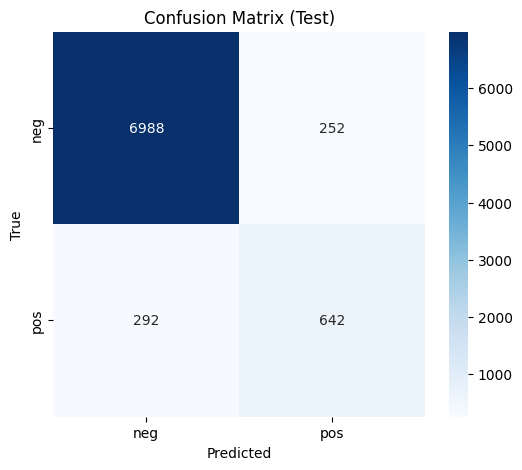

Epoch 6 Summary:
Train Loss: 0.1966 | Train Acc: 84.48% | Train F1: 0.8432
Val Loss: 0.1306 | Val Acc: 92.88% | Val F1: 0.8357
Test Loss: 0.1961 | Test Acc: 93.34% | Test F1: 0.8325
Epoch Time: 988.55s | GPU Memory Usage: 767.04 MB



Checkpoint saved at checkpoints\epoch_6.pth


Validation loss decreased. Best model saved at checkpoints\best_model.pth


Training:   0%|                                                              | 0/470 [00:00<?, ?it/s]

Training:   0%|                           | 0/470 [00:01<?, ?it/s, Loss=0.1204, F1=0.9373, Acc=93.75]

Training:   0%|                   | 1/470 [00:01<09:09,  1.17s/it, Loss=0.1204, F1=0.9373, Acc=93.75]

Training:   0%|                   | 1/470 [00:02<09:09,  1.17s/it, Loss=0.0896, F1=0.9373, Acc=93.75]

Training:   0%|                   | 2/470 [00:02<09:07,  1.17s/it, Loss=0.0896, F1=0.9373, Acc=93.75]

Training:   0%|                   | 2/470 [00:03<09:07,  1.17s/it, Loss=0.1076, F1=0.9361, Acc=93.75]

Training:   1%|                   | 3/470 [00:03<09:06,  1.17s/it, Loss=0.1076, F1=0.9361, Acc=93.75]

Training:   1%|                   | 3/470 [00:04<09:06,  1.17s/it, Loss=0.1040, F1=0.9526, Acc=95.31]

Training:   1%|▏                  | 4/470 [00:04<09:09,  1.18s/it, Loss=0.1040, F1=0.9526, Acc=95.31]

Training:   1%|▏                  | 4/470 [00:05<09:09,  1.18s/it, Loss=0.1431, F1=0.9363, Acc=93.75]

Training:   1%|▏                  | 5/470 [00:05<09:11,  1.19s/it, Loss=0.1431, F1=0.9363, Acc=93.75]

Training:   1%|▏                  | 5/470 [00:07<09:11,  1.19s/it, Loss=0.1277, F1=0.9241, Acc=92.71]

Training:   1%|▏                  | 6/470 [00:07<09:10,  1.19s/it, Loss=0.1277, F1=0.9241, Acc=92.71]

Training:   1%|▏                  | 6/470 [00:08<09:10,  1.19s/it, Loss=0.1210, F1=0.9336, Acc=93.75]

Training:   1%|▎                  | 7/470 [00:08<09:12,  1.19s/it, Loss=0.1210, F1=0.9336, Acc=93.75]

Training:   1%|▎                  | 7/470 [00:09<09:12,  1.19s/it, Loss=0.1559, F1=0.9273, Acc=92.97]

Training:   2%|▎                  | 8/470 [00:09<09:11,  1.19s/it, Loss=0.1559, F1=0.9273, Acc=92.97]

Training:   2%|▎                  | 8/470 [00:10<09:11,  1.19s/it, Loss=0.1827, F1=0.9289, Acc=93.06]

Training:   2%|▎                  | 9/470 [00:10<09:06,  1.19s/it, Loss=0.1827, F1=0.9289, Acc=93.06]

Training:   2%|▎                  | 9/470 [00:11<09:06,  1.19s/it, Loss=0.1699, F1=0.9292, Acc=93.12]

Training:   2%|▍                 | 10/470 [00:11<09:05,  1.19s/it, Loss=0.1699, F1=0.9292, Acc=93.12]

Training:   2%|▍                 | 10/470 [00:13<09:05,  1.19s/it, Loss=0.1679, F1=0.9249, Acc=92.61]

Training:   2%|▍                 | 11/470 [00:13<09:17,  1.21s/it, Loss=0.1679, F1=0.9249, Acc=92.61]

Training:   2%|▍                 | 11/470 [00:14<09:17,  1.21s/it, Loss=0.1646, F1=0.9266, Acc=92.71]

Training:   3%|▍                 | 12/470 [00:14<09:11,  1.20s/it, Loss=0.1646, F1=0.9266, Acc=92.71]

Training:   3%|▍                 | 12/470 [00:15<09:11,  1.20s/it, Loss=0.1648, F1=0.9225, Acc=92.31]

Training:   3%|▍                 | 13/470 [00:15<09:08,  1.20s/it, Loss=0.1648, F1=0.9225, Acc=92.31]

Training:   3%|▍                 | 13/470 [00:16<09:08,  1.20s/it, Loss=0.1597, F1=0.9194, Acc=91.96]

Training:   3%|▌                 | 14/470 [00:16<09:10,  1.21s/it, Loss=0.1597, F1=0.9194, Acc=91.96]

Training:   3%|▌                 | 14/470 [00:17<09:10,  1.21s/it, Loss=0.1799, F1=0.9000, Acc=90.00]

Training:   3%|▌                 | 15/470 [00:17<09:07,  1.20s/it, Loss=0.1799, F1=0.9000, Acc=90.00]

Training:   3%|▌                 | 15/470 [00:19<09:07,  1.20s/it, Loss=0.1762, F1=0.8867, Acc=88.67]

Training:   3%|▌                 | 16/470 [00:19<09:02,  1.20s/it, Loss=0.1762, F1=0.8867, Acc=88.67]

Training:   3%|▌                 | 16/470 [00:20<09:02,  1.20s/it, Loss=0.1679, F1=0.8934, Acc=89.34]

Training:   4%|▋                 | 17/470 [00:20<08:58,  1.19s/it, Loss=0.1679, F1=0.8934, Acc=89.34]

Training:   4%|▋                 | 17/470 [00:21<08:58,  1.19s/it, Loss=0.1661, F1=0.8923, Acc=89.24]

Training:   4%|▋                 | 18/470 [00:21<08:56,  1.19s/it, Loss=0.1661, F1=0.8923, Acc=89.24]

Training:   4%|▋                 | 18/470 [00:22<08:56,  1.19s/it, Loss=0.1730, F1=0.8947, Acc=89.47]

Training:   4%|▋                 | 19/470 [00:22<09:15,  1.23s/it, Loss=0.1730, F1=0.8947, Acc=89.47]

Training:   4%|▋                 | 19/470 [00:23<09:15,  1.23s/it, Loss=0.1917, F1=0.8936, Acc=89.38]

Training:   4%|▊                 | 20/470 [00:23<09:07,  1.22s/it, Loss=0.1917, F1=0.8936, Acc=89.38]

Training:   4%|▊                 | 20/470 [00:25<09:07,  1.22s/it, Loss=0.1984, F1=0.8928, Acc=89.29]

Training:   4%|▊                 | 21/470 [00:25<09:05,  1.22s/it, Loss=0.1984, F1=0.8928, Acc=89.29]

Training:   4%|▊                 | 21/470 [00:26<09:05,  1.22s/it, Loss=0.1988, F1=0.8891, Acc=88.92]

Training:   5%|▊                 | 22/470 [00:26<09:06,  1.22s/it, Loss=0.1988, F1=0.8891, Acc=88.92]

Training:   5%|▊                 | 22/470 [00:27<09:06,  1.22s/it, Loss=0.1930, F1=0.8912, Acc=89.13]

Training:   5%|▉                 | 23/470 [00:27<09:16,  1.24s/it, Loss=0.1930, F1=0.8912, Acc=89.13]

Training:   5%|▉                 | 23/470 [00:28<09:16,  1.24s/it, Loss=0.1940, F1=0.8879, Acc=88.80]

Training:   5%|▉                 | 24/470 [00:28<09:07,  1.23s/it, Loss=0.1940, F1=0.8879, Acc=88.80]

Training:   5%|▉                 | 24/470 [00:30<09:07,  1.23s/it, Loss=0.1885, F1=0.8925, Acc=89.25]

Training:   5%|▉                 | 25/470 [00:30<08:59,  1.21s/it, Loss=0.1885, F1=0.8925, Acc=89.25]

Training:   5%|▉                 | 25/470 [00:31<08:59,  1.21s/it, Loss=0.1847, F1=0.8894, Acc=88.94]

Training:   6%|▉                 | 26/470 [00:31<08:56,  1.21s/it, Loss=0.1847, F1=0.8894, Acc=88.94]

Training:   6%|▉                 | 26/470 [00:32<08:56,  1.21s/it, Loss=0.1853, F1=0.8912, Acc=89.12]

Training:   6%|█                 | 27/470 [00:32<08:50,  1.20s/it, Loss=0.1853, F1=0.8912, Acc=89.12]

Training:   6%|█                 | 27/470 [00:33<08:50,  1.20s/it, Loss=0.1820, F1=0.8906, Acc=89.06]

Training:   6%|█                 | 28/470 [00:33<08:52,  1.20s/it, Loss=0.1820, F1=0.8906, Acc=89.06]

Training:   6%|█                 | 28/470 [00:34<08:52,  1.20s/it, Loss=0.1810, F1=0.8901, Acc=89.01]

Training:   6%|█                 | 29/470 [00:34<08:56,  1.22s/it, Loss=0.1810, F1=0.8901, Acc=89.01]

Training:   6%|█                 | 29/470 [00:36<08:56,  1.22s/it, Loss=0.1824, F1=0.8833, Acc=88.33]

Training:   6%|█▏                | 30/470 [00:36<08:54,  1.21s/it, Loss=0.1824, F1=0.8833, Acc=88.33]

Training:   6%|█▏                | 30/470 [00:37<08:54,  1.21s/it, Loss=0.1899, F1=0.8770, Acc=87.70]

Training:   7%|█▏                | 31/470 [00:37<08:45,  1.20s/it, Loss=0.1899, F1=0.8770, Acc=87.70]

Training:   7%|█▏                | 31/470 [00:38<08:45,  1.20s/it, Loss=0.1919, F1=0.8750, Acc=87.50]

Training:   7%|█▏                | 32/470 [00:38<08:42,  1.19s/it, Loss=0.1919, F1=0.8750, Acc=87.50]

Training:   7%|█▏                | 32/470 [00:39<08:42,  1.19s/it, Loss=0.1930, F1=0.8731, Acc=87.31]

Training:   7%|█▎                | 33/470 [00:39<08:38,  1.19s/it, Loss=0.1930, F1=0.8731, Acc=87.31]

Training:   7%|█▎                | 33/470 [00:40<08:38,  1.19s/it, Loss=0.1927, F1=0.8713, Acc=87.13]

Training:   7%|█▎                | 34/470 [00:40<08:39,  1.19s/it, Loss=0.1927, F1=0.8713, Acc=87.13]

Training:   7%|█▎                | 34/470 [00:42<08:39,  1.19s/it, Loss=0.1894, F1=0.8713, Acc=87.14]

Training:   7%|█▎                | 35/470 [00:42<08:42,  1.20s/it, Loss=0.1894, F1=0.8713, Acc=87.14]

Training:   7%|█▎                | 35/470 [00:43<08:42,  1.20s/it, Loss=0.1893, F1=0.8715, Acc=87.15]

Training:   8%|█▍                | 36/470 [00:43<08:34,  1.19s/it, Loss=0.1893, F1=0.8715, Acc=87.15]

Training:   8%|█▍                | 36/470 [00:44<08:34,  1.19s/it, Loss=0.1872, F1=0.8731, Acc=87.33]

Training:   8%|█▍                | 37/470 [00:44<08:44,  1.21s/it, Loss=0.1872, F1=0.8731, Acc=87.33]

Training:   8%|█▍                | 37/470 [00:45<08:44,  1.21s/it, Loss=0.1894, F1=0.8749, Acc=87.50]

Training:   8%|█▍                | 38/470 [00:45<08:44,  1.21s/it, Loss=0.1894, F1=0.8749, Acc=87.50]

Training:   8%|█▍                | 38/470 [00:46<08:44,  1.21s/it, Loss=0.1888, F1=0.8700, Acc=87.02]

Training:   8%|█▍                | 39/470 [00:46<08:31,  1.19s/it, Loss=0.1888, F1=0.8700, Acc=87.02]

Training:   8%|█▍                | 39/470 [00:48<08:31,  1.19s/it, Loss=0.1888, F1=0.8701, Acc=87.03]

Training:   9%|█▌                | 40/470 [00:48<08:41,  1.21s/it, Loss=0.1888, F1=0.8701, Acc=87.03]

Training:   9%|█▌                | 40/470 [00:49<08:41,  1.21s/it, Loss=0.1865, F1=0.8733, Acc=87.35]

Training:   9%|█▌                | 41/470 [00:49<08:34,  1.20s/it, Loss=0.1865, F1=0.8733, Acc=87.35]

Training:   9%|█▌                | 41/470 [00:50<08:34,  1.20s/it, Loss=0.1856, F1=0.8688, Acc=86.90]

Training:   9%|█▌                | 42/470 [00:50<08:27,  1.19s/it, Loss=0.1856, F1=0.8688, Acc=86.90]

Training:   9%|█▌                | 42/470 [00:51<08:27,  1.19s/it, Loss=0.1848, F1=0.8645, Acc=86.48]

Training:   9%|█▋                | 43/470 [00:51<08:34,  1.20s/it, Loss=0.1848, F1=0.8645, Acc=86.48]

Training:   9%|█▋                | 43/470 [00:52<08:34,  1.20s/it, Loss=0.1837, F1=0.8633, Acc=86.36]

Training:   9%|█▋                | 44/470 [00:52<08:38,  1.22s/it, Loss=0.1837, F1=0.8633, Acc=86.36]

Training:   9%|█▋                | 44/470 [00:54<08:38,  1.22s/it, Loss=0.1860, F1=0.8649, Acc=86.53]

Training:  10%|█▋                | 45/470 [00:54<08:27,  1.19s/it, Loss=0.1860, F1=0.8649, Acc=86.53]

Training:  10%|█▋                | 45/470 [00:55<08:27,  1.19s/it, Loss=0.1895, F1=0.8651, Acc=86.55]

Training:  10%|█▊                | 46/470 [00:55<08:24,  1.19s/it, Loss=0.1895, F1=0.8651, Acc=86.55]

Training:  10%|█▊                | 46/470 [00:56<08:24,  1.19s/it, Loss=0.1915, F1=0.8653, Acc=86.57]

Training:  10%|█▊                | 47/470 [00:56<08:36,  1.22s/it, Loss=0.1915, F1=0.8653, Acc=86.57]

Training:  10%|█▊                | 47/470 [00:57<08:36,  1.22s/it, Loss=0.1891, F1=0.8668, Acc=86.72]

Training:  10%|█▊                | 48/470 [00:57<08:27,  1.20s/it, Loss=0.1891, F1=0.8668, Acc=86.72]

Training:  10%|█▊                | 48/470 [00:58<08:27,  1.20s/it, Loss=0.1876, F1=0.8670, Acc=86.73]

Training:  10%|█▉                | 49/470 [00:58<08:21,  1.19s/it, Loss=0.1876, F1=0.8670, Acc=86.73]

Training:  10%|█▉                | 49/470 [01:00<08:21,  1.19s/it, Loss=0.1874, F1=0.8659, Acc=86.62]

Training:  11%|█▉                | 50/470 [01:00<08:19,  1.19s/it, Loss=0.1874, F1=0.8659, Acc=86.62]

Training:  11%|█▉                | 50/470 [01:01<08:19,  1.19s/it, Loss=0.1852, F1=0.8673, Acc=86.76]

Training:  11%|█▉                | 51/470 [01:01<08:26,  1.21s/it, Loss=0.1852, F1=0.8673, Acc=86.76]

Training:  11%|█▉                | 51/470 [01:02<08:26,  1.21s/it, Loss=0.1854, F1=0.8686, Acc=86.90]

Training:  11%|█▉                | 52/470 [01:02<08:21,  1.20s/it, Loss=0.1854, F1=0.8686, Acc=86.90]

Training:  11%|█▉                | 52/470 [01:03<08:21,  1.20s/it, Loss=0.1850, F1=0.8676, Acc=86.79]

Training:  11%|██                | 53/470 [01:03<08:18,  1.20s/it, Loss=0.1850, F1=0.8676, Acc=86.79]

Training:  11%|██                | 53/470 [01:04<08:18,  1.20s/it, Loss=0.1860, F1=0.8653, Acc=86.57]

Training:  11%|██                | 54/470 [01:04<08:15,  1.19s/it, Loss=0.1860, F1=0.8653, Acc=86.57]

Training:  11%|██                | 54/470 [01:06<08:15,  1.19s/it, Loss=0.1873, F1=0.8619, Acc=86.25]

Training:  12%|██                | 55/470 [01:06<08:25,  1.22s/it, Loss=0.1873, F1=0.8619, Acc=86.25]

Training:  12%|██                | 55/470 [01:07<08:25,  1.22s/it, Loss=0.1889, F1=0.8588, Acc=85.94]

Training:  12%|██▏               | 56/470 [01:07<08:22,  1.21s/it, Loss=0.1889, F1=0.8588, Acc=85.94]

Training:  12%|██▏               | 56/470 [01:08<08:22,  1.21s/it, Loss=0.1863, F1=0.8612, Acc=86.18]

Training:  12%|██▏               | 57/470 [01:08<08:11,  1.19s/it, Loss=0.1863, F1=0.8612, Acc=86.18]

Training:  12%|██▏               | 57/470 [01:09<08:11,  1.19s/it, Loss=0.1866, F1=0.8594, Acc=85.99]

Training:  12%|██▏               | 58/470 [01:09<08:09,  1.19s/it, Loss=0.1866, F1=0.8594, Acc=85.99]

Training:  12%|██▏               | 58/470 [01:10<08:09,  1.19s/it, Loss=0.1878, F1=0.8574, Acc=85.81]

Training:  13%|██▎               | 59/470 [01:10<08:18,  1.21s/it, Loss=0.1878, F1=0.8574, Acc=85.81]

Training:  13%|██▎               | 59/470 [01:12<08:18,  1.21s/it, Loss=0.1901, F1=0.8533, Acc=85.42]

Training:  13%|██▎               | 60/470 [01:12<08:15,  1.21s/it, Loss=0.1901, F1=0.8533, Acc=85.42]

Training:  13%|██▎               | 60/470 [01:13<08:15,  1.21s/it, Loss=0.1884, F1=0.8527, Acc=85.35]

Training:  13%|██▎               | 61/470 [01:13<08:09,  1.20s/it, Loss=0.1884, F1=0.8527, Acc=85.35]

Training:  13%|██▎               | 61/470 [01:14<08:09,  1.20s/it, Loss=0.1875, F1=0.8520, Acc=85.28]

Training:  13%|██▎               | 62/470 [01:14<08:04,  1.19s/it, Loss=0.1875, F1=0.8520, Acc=85.28]

Training:  13%|██▎               | 62/470 [01:15<08:04,  1.19s/it, Loss=0.1889, F1=0.8513, Acc=85.22]

Training:  13%|██▍               | 63/470 [01:15<08:02,  1.19s/it, Loss=0.1889, F1=0.8513, Acc=85.22]

Training:  13%|██▍               | 63/470 [01:16<08:02,  1.19s/it, Loss=0.1904, F1=0.8488, Acc=84.96]

Training:  14%|██▍               | 64/470 [01:16<08:16,  1.22s/it, Loss=0.1904, F1=0.8488, Acc=84.96]

Training:  14%|██▍               | 64/470 [01:18<08:16,  1.22s/it, Loss=0.1880, F1=0.8502, Acc=85.10]

Training:  14%|██▍               | 65/470 [01:18<08:07,  1.20s/it, Loss=0.1880, F1=0.8502, Acc=85.10]

Training:  14%|██▍               | 65/470 [01:19<08:07,  1.20s/it, Loss=0.1868, F1=0.8476, Acc=84.85]

Training:  14%|██▌               | 66/470 [01:19<08:03,  1.20s/it, Loss=0.1868, F1=0.8476, Acc=84.85]

Training:  14%|██▌               | 66/470 [01:20<08:03,  1.20s/it, Loss=0.1856, F1=0.8498, Acc=85.07]

Training:  14%|██▌               | 67/470 [01:20<07:57,  1.18s/it, Loss=0.1856, F1=0.8498, Acc=85.07]

Training:  14%|██▌               | 67/470 [01:21<07:57,  1.18s/it, Loss=0.1834, F1=0.8519, Acc=85.29]

Training:  14%|██▌               | 68/470 [01:21<08:07,  1.21s/it, Loss=0.1834, F1=0.8519, Acc=85.29]

Training:  14%|██▌               | 68/470 [01:22<08:07,  1.21s/it, Loss=0.1895, F1=0.8485, Acc=84.96]

Training:  15%|██▋               | 69/470 [01:22<07:58,  1.19s/it, Loss=0.1895, F1=0.8485, Acc=84.96]

Training:  15%|██▋               | 69/470 [01:24<07:58,  1.19s/it, Loss=0.1871, F1=0.8507, Acc=85.18]

Training:  15%|██▋               | 70/470 [01:24<07:55,  1.19s/it, Loss=0.1871, F1=0.8507, Acc=85.18]

Training:  15%|██▋               | 70/470 [01:25<07:55,  1.19s/it, Loss=0.1850, F1=0.8527, Acc=85.39]

Training:  15%|██▋               | 71/470 [01:25<08:03,  1.21s/it, Loss=0.1850, F1=0.8527, Acc=85.39]

Training:  15%|██▋               | 71/470 [01:26<08:03,  1.21s/it, Loss=0.1829, F1=0.8548, Acc=85.59]

Training:  15%|██▊               | 72/470 [01:26<08:02,  1.21s/it, Loss=0.1829, F1=0.8548, Acc=85.59]

Training:  15%|██▊               | 72/470 [01:27<08:02,  1.21s/it, Loss=0.1841, F1=0.8552, Acc=85.62]

Training:  16%|██▊               | 73/470 [01:27<07:55,  1.20s/it, Loss=0.1841, F1=0.8552, Acc=85.62]

Training:  16%|██▊               | 73/470 [01:28<07:55,  1.20s/it, Loss=0.1875, F1=0.8555, Acc=85.64]

Training:  16%|██▊               | 74/470 [01:28<07:55,  1.20s/it, Loss=0.1875, F1=0.8555, Acc=85.64]

Training:  16%|██▊               | 74/470 [01:30<07:55,  1.20s/it, Loss=0.1865, F1=0.8567, Acc=85.75]

Training:  16%|██▊               | 75/470 [01:30<07:49,  1.19s/it, Loss=0.1865, F1=0.8567, Acc=85.75]

Training:  16%|██▊               | 75/470 [01:31<07:49,  1.19s/it, Loss=0.1885, F1=0.8579, Acc=85.86]

Training:  16%|██▉               | 76/470 [01:31<07:50,  1.19s/it, Loss=0.1885, F1=0.8579, Acc=85.86]

Training:  16%|██▉               | 76/470 [01:32<07:50,  1.19s/it, Loss=0.1877, F1=0.8589, Acc=85.96]

Training:  16%|██▉               | 77/470 [01:32<07:47,  1.19s/it, Loss=0.1877, F1=0.8589, Acc=85.96]

Training:  16%|██▉               | 77/470 [01:33<07:47,  1.19s/it, Loss=0.1860, F1=0.8591, Acc=85.98]

Training:  17%|██▉               | 78/470 [01:33<07:52,  1.21s/it, Loss=0.1860, F1=0.8591, Acc=85.98]

Training:  17%|██▉               | 78/470 [01:34<07:52,  1.21s/it, Loss=0.1857, F1=0.8585, Acc=85.92]

Training:  17%|███               | 79/470 [01:34<07:48,  1.20s/it, Loss=0.1857, F1=0.8585, Acc=85.92]

Training:  17%|███               | 79/470 [01:35<07:48,  1.20s/it, Loss=0.1841, F1=0.8593, Acc=86.02]

Training:  17%|███               | 80/470 [01:35<07:38,  1.17s/it, Loss=0.1841, F1=0.8593, Acc=86.02]

Training:  17%|███               | 80/470 [01:37<07:38,  1.17s/it, Loss=0.1831, F1=0.8595, Acc=86.03]

Training:  17%|███               | 81/470 [01:37<07:41,  1.19s/it, Loss=0.1831, F1=0.8595, Acc=86.03]

Training:  17%|███               | 81/470 [01:38<07:41,  1.19s/it, Loss=0.1831, F1=0.8595, Acc=86.05]

Training:  17%|███▏              | 82/470 [01:38<07:54,  1.22s/it, Loss=0.1831, F1=0.8595, Acc=86.05]

Training:  17%|███▏              | 82/470 [01:39<07:54,  1.22s/it, Loss=0.1833, F1=0.8583, Acc=85.92]

Training:  18%|███▏              | 83/470 [01:39<07:52,  1.22s/it, Loss=0.1833, F1=0.8583, Acc=85.92]

Training:  18%|███▏              | 83/470 [01:40<07:52,  1.22s/it, Loss=0.1828, F1=0.8578, Acc=85.86]

Training:  18%|███▏              | 84/470 [01:40<07:50,  1.22s/it, Loss=0.1828, F1=0.8578, Acc=85.86]

Training:  18%|███▏              | 84/470 [01:42<07:50,  1.22s/it, Loss=0.1832, F1=0.8573, Acc=85.81]

Training:  18%|███▎              | 85/470 [01:42<07:47,  1.21s/it, Loss=0.1832, F1=0.8573, Acc=85.81]

Training:  18%|███▎              | 85/470 [01:43<07:47,  1.21s/it, Loss=0.1837, F1=0.8574, Acc=85.83]

Training:  18%|███▎              | 86/470 [01:43<07:45,  1.21s/it, Loss=0.1837, F1=0.8574, Acc=85.83]

Training:  18%|███▎              | 86/470 [01:44<07:45,  1.21s/it, Loss=0.1858, F1=0.8576, Acc=85.85]

Training:  19%|███▎              | 87/470 [01:44<07:43,  1.21s/it, Loss=0.1858, F1=0.8576, Acc=85.85]

Training:  19%|███▎              | 87/470 [01:45<07:43,  1.21s/it, Loss=0.1841, F1=0.8592, Acc=86.01]

Training:  19%|███▎              | 88/470 [01:45<07:44,  1.22s/it, Loss=0.1841, F1=0.8592, Acc=86.01]

Training:  19%|███▎              | 88/470 [01:46<07:44,  1.22s/it, Loss=0.1832, F1=0.8608, Acc=86.17]

Training:  19%|███▍              | 89/470 [01:46<07:39,  1.21s/it, Loss=0.1832, F1=0.8608, Acc=86.17]

Training:  19%|███▍              | 89/470 [01:48<07:39,  1.21s/it, Loss=0.1817, F1=0.8623, Acc=86.32]

Training:  19%|███▍              | 90/470 [01:48<07:44,  1.22s/it, Loss=0.1817, F1=0.8623, Acc=86.32]

Training:  19%|███▍              | 90/470 [01:49<07:44,  1.22s/it, Loss=0.1800, F1=0.8639, Acc=86.47]

Training:  19%|███▍              | 91/470 [01:49<07:50,  1.24s/it, Loss=0.1800, F1=0.8639, Acc=86.47]

Training:  19%|███▍              | 91/470 [01:50<07:50,  1.24s/it, Loss=0.1788, F1=0.8647, Acc=86.55]

Training:  20%|███▌              | 92/470 [01:50<07:52,  1.25s/it, Loss=0.1788, F1=0.8647, Acc=86.55]

Training:  20%|███▌              | 92/470 [01:51<07:52,  1.25s/it, Loss=0.1775, F1=0.8655, Acc=86.63]

Training:  20%|███▌              | 93/470 [01:51<07:48,  1.24s/it, Loss=0.1775, F1=0.8655, Acc=86.63]

Training:  20%|███▌              | 93/470 [01:53<07:48,  1.24s/it, Loss=0.1791, F1=0.8643, Acc=86.50]

Training:  20%|███▌              | 94/470 [01:53<07:49,  1.25s/it, Loss=0.1791, F1=0.8643, Acc=86.50]

Training:  20%|███▌              | 94/470 [01:54<07:49,  1.25s/it, Loss=0.1786, F1=0.8644, Acc=86.51]

Training:  20%|███▋              | 95/470 [01:54<07:50,  1.26s/it, Loss=0.1786, F1=0.8644, Acc=86.51]

Training:  20%|███▋              | 95/470 [01:55<07:50,  1.26s/it, Loss=0.1773, F1=0.8652, Acc=86.59]

Training:  20%|███▋              | 96/470 [01:55<07:45,  1.25s/it, Loss=0.1773, F1=0.8652, Acc=86.59]

Training:  20%|███▋              | 96/470 [01:56<07:45,  1.25s/it, Loss=0.1802, F1=0.8654, Acc=86.60]

Training:  21%|███▋              | 97/470 [01:56<07:42,  1.24s/it, Loss=0.1802, F1=0.8654, Acc=86.60]

Training:  21%|███▋              | 97/470 [01:58<07:42,  1.24s/it, Loss=0.1827, F1=0.8642, Acc=86.48]

Training:  21%|███▊              | 98/470 [01:58<07:38,  1.23s/it, Loss=0.1827, F1=0.8642, Acc=86.48]

Training:  21%|███▊              | 98/470 [01:59<07:38,  1.23s/it, Loss=0.1810, F1=0.8655, Acc=86.62]

Training:  21%|███▊              | 99/470 [01:59<07:43,  1.25s/it, Loss=0.1810, F1=0.8655, Acc=86.62]

Training:  21%|███▊              | 99/470 [02:00<07:43,  1.25s/it, Loss=0.1840, F1=0.8655, Acc=86.62]

Training:  21%|███▌             | 100/470 [02:00<07:38,  1.24s/it, Loss=0.1840, F1=0.8655, Acc=86.62]

Training:  21%|███▌             | 100/470 [02:01<07:38,  1.24s/it, Loss=0.1875, F1=0.8643, Acc=86.51]

Training:  21%|███▋             | 101/470 [02:01<07:32,  1.23s/it, Loss=0.1875, F1=0.8643, Acc=86.51]

Training:  21%|███▋             | 101/470 [02:03<07:32,  1.23s/it, Loss=0.1862, F1=0.8656, Acc=86.64]

Training:  22%|███▋             | 102/470 [02:03<07:30,  1.22s/it, Loss=0.1862, F1=0.8656, Acc=86.64]

Training:  22%|███▋             | 102/470 [02:04<07:30,  1.22s/it, Loss=0.1847, F1=0.8664, Acc=86.71]

Training:  22%|███▋             | 103/470 [02:04<07:30,  1.23s/it, Loss=0.1847, F1=0.8664, Acc=86.71]

Training:  22%|███▋             | 103/470 [02:05<07:30,  1.23s/it, Loss=0.1855, F1=0.8659, Acc=86.66]

Training:  22%|███▊             | 104/470 [02:05<07:28,  1.23s/it, Loss=0.1855, F1=0.8659, Acc=86.66]

Training:  22%|███▊             | 104/470 [02:06<07:28,  1.23s/it, Loss=0.1879, F1=0.8654, Acc=86.61]

Training:  22%|███▊             | 105/470 [02:06<07:32,  1.24s/it, Loss=0.1879, F1=0.8654, Acc=86.61]

Training:  22%|███▊             | 105/470 [02:08<07:32,  1.24s/it, Loss=0.1871, F1=0.8654, Acc=86.62]

Training:  23%|███▊             | 106/470 [02:08<07:34,  1.25s/it, Loss=0.1871, F1=0.8654, Acc=86.62]

Training:  23%|███▊             | 106/470 [02:09<07:34,  1.25s/it, Loss=0.1865, F1=0.8638, Acc=86.45]

Training:  23%|███▊             | 107/470 [02:09<07:30,  1.24s/it, Loss=0.1865, F1=0.8638, Acc=86.45]

Training:  23%|███▊             | 107/470 [02:10<07:30,  1.24s/it, Loss=0.1875, F1=0.8621, Acc=86.28]

Training:  23%|███▉             | 108/470 [02:10<07:27,  1.24s/it, Loss=0.1875, F1=0.8621, Acc=86.28]

Training:  23%|███▉             | 108/470 [02:11<07:27,  1.24s/it, Loss=0.1896, F1=0.8611, Acc=86.18]

Training:  23%|███▉             | 109/470 [02:11<07:26,  1.24s/it, Loss=0.1896, F1=0.8611, Acc=86.18]

Training:  23%|███▉             | 109/470 [02:13<07:26,  1.24s/it, Loss=0.1890, F1=0.8606, Acc=86.14]

Training:  23%|███▉             | 110/470 [02:13<07:38,  1.27s/it, Loss=0.1890, F1=0.8606, Acc=86.14]

Training:  23%|███▉             | 110/470 [02:14<07:38,  1.27s/it, Loss=0.1888, F1=0.8601, Acc=86.09]

Training:  24%|████             | 111/470 [02:14<07:32,  1.26s/it, Loss=0.1888, F1=0.8601, Acc=86.09]

Training:  24%|████             | 111/470 [02:15<07:32,  1.26s/it, Loss=0.1881, F1=0.8601, Acc=86.10]

Training:  24%|████             | 112/470 [02:15<07:38,  1.28s/it, Loss=0.1881, F1=0.8601, Acc=86.10]

Training:  24%|████             | 112/470 [02:16<07:38,  1.28s/it, Loss=0.1871, F1=0.8609, Acc=86.17]

Training:  24%|████             | 113/470 [02:16<07:33,  1.27s/it, Loss=0.1871, F1=0.8609, Acc=86.17]

Training:  24%|████             | 113/470 [02:18<07:33,  1.27s/it, Loss=0.1886, F1=0.8599, Acc=86.07]

Training:  24%|████             | 114/470 [02:18<07:36,  1.28s/it, Loss=0.1886, F1=0.8599, Acc=86.07]

Training:  24%|████             | 114/470 [02:19<07:36,  1.28s/it, Loss=0.1877, F1=0.8605, Acc=86.14]

Training:  24%|████▏            | 115/470 [02:19<07:28,  1.26s/it, Loss=0.1877, F1=0.8605, Acc=86.14]

Training:  24%|████▏            | 115/470 [02:20<07:28,  1.26s/it, Loss=0.1872, F1=0.8613, Acc=86.21]

Training:  25%|████▏            | 116/470 [02:20<07:19,  1.24s/it, Loss=0.1872, F1=0.8613, Acc=86.21]

Training:  25%|████▏            | 116/470 [02:21<07:19,  1.24s/it, Loss=0.1863, F1=0.8614, Acc=86.22]

Training:  25%|████▏            | 117/470 [02:21<07:18,  1.24s/it, Loss=0.1863, F1=0.8614, Acc=86.22]

Training:  25%|████▏            | 117/470 [02:23<07:18,  1.24s/it, Loss=0.1863, F1=0.8620, Acc=86.28]

Training:  25%|████▎            | 118/470 [02:23<07:13,  1.23s/it, Loss=0.1863, F1=0.8620, Acc=86.28]

Training:  25%|████▎            | 118/470 [02:24<07:13,  1.23s/it, Loss=0.1849, F1=0.8631, Acc=86.40]

Training:  25%|████▎            | 119/470 [02:24<07:17,  1.25s/it, Loss=0.1849, F1=0.8631, Acc=86.40]

Training:  25%|████▎            | 119/470 [02:25<07:17,  1.25s/it, Loss=0.1867, F1=0.8633, Acc=86.41]

Training:  26%|████▎            | 120/470 [02:25<07:23,  1.27s/it, Loss=0.1867, F1=0.8633, Acc=86.41]

Training:  26%|████▎            | 120/470 [02:26<07:23,  1.27s/it, Loss=0.1874, F1=0.8634, Acc=86.42]

Training:  26%|████▍            | 121/470 [02:26<07:21,  1.27s/it, Loss=0.1874, F1=0.8634, Acc=86.42]

Training:  26%|████▍            | 121/470 [02:28<07:21,  1.27s/it, Loss=0.1866, F1=0.8646, Acc=86.53]

Training:  26%|████▍            | 122/470 [02:28<07:25,  1.28s/it, Loss=0.1866, F1=0.8646, Acc=86.53]

Training:  26%|████▍            | 122/470 [02:29<07:25,  1.28s/it, Loss=0.1855, F1=0.8656, Acc=86.64]

Training:  26%|████▍            | 123/470 [02:29<07:02,  1.22s/it, Loss=0.1855, F1=0.8656, Acc=86.64]

Training:  26%|████▍            | 123/470 [02:30<07:02,  1.22s/it, Loss=0.1844, F1=0.8661, Acc=86.69]

Training:  26%|████▍            | 124/470 [02:30<07:07,  1.24s/it, Loss=0.1844, F1=0.8661, Acc=86.69]

Training:  26%|████▍            | 124/470 [02:31<07:07,  1.24s/it, Loss=0.1837, F1=0.8662, Acc=86.70]

Training:  27%|████▌            | 125/470 [02:31<07:02,  1.22s/it, Loss=0.1837, F1=0.8662, Acc=86.70]

Training:  27%|████▌            | 125/470 [02:33<07:02,  1.22s/it, Loss=0.1832, F1=0.8673, Acc=86.81]

Training:  27%|████▌            | 126/470 [02:33<06:53,  1.20s/it, Loss=0.1832, F1=0.8673, Acc=86.81]

Training:  27%|████▌            | 126/470 [02:34<06:53,  1.20s/it, Loss=0.1841, F1=0.8673, Acc=86.81]

Training:  27%|████▌            | 127/470 [02:34<06:55,  1.21s/it, Loss=0.1841, F1=0.8673, Acc=86.81]

Training:  27%|████▌            | 127/470 [02:35<06:55,  1.21s/it, Loss=0.1836, F1=0.8664, Acc=86.72]

Training:  27%|████▋            | 128/470 [02:35<06:51,  1.20s/it, Loss=0.1836, F1=0.8664, Acc=86.72]

Training:  27%|████▋            | 128/470 [02:36<06:51,  1.20s/it, Loss=0.1836, F1=0.8660, Acc=86.68]

Training:  27%|████▋            | 129/470 [02:36<06:47,  1.19s/it, Loss=0.1836, F1=0.8660, Acc=86.68]

Training:  27%|████▋            | 129/470 [02:37<06:47,  1.19s/it, Loss=0.1827, F1=0.8661, Acc=86.68]

Training:  28%|████▋            | 130/470 [02:37<06:56,  1.22s/it, Loss=0.1827, F1=0.8661, Acc=86.68]

Training:  28%|████▋            | 130/470 [02:39<06:56,  1.22s/it, Loss=0.1823, F1=0.8671, Acc=86.78]

Training:  28%|████▋            | 131/470 [02:39<06:52,  1.22s/it, Loss=0.1823, F1=0.8671, Acc=86.78]

Training:  28%|████▋            | 131/470 [02:40<06:52,  1.22s/it, Loss=0.1861, F1=0.8667, Acc=86.74]

Training:  28%|████▊            | 132/470 [02:40<06:44,  1.20s/it, Loss=0.1861, F1=0.8667, Acc=86.74]

Training:  28%|████▊            | 132/470 [02:41<06:44,  1.20s/it, Loss=0.1853, F1=0.8673, Acc=86.80]

Training:  28%|████▊            | 133/470 [02:41<06:44,  1.20s/it, Loss=0.1853, F1=0.8673, Acc=86.80]

Training:  28%|████▊            | 133/470 [02:42<06:44,  1.20s/it, Loss=0.1847, F1=0.8683, Acc=86.89]

Training:  29%|████▊            | 134/470 [02:42<06:40,  1.19s/it, Loss=0.1847, F1=0.8683, Acc=86.89]

Training:  29%|████▊            | 134/470 [02:43<06:40,  1.19s/it, Loss=0.1843, F1=0.8688, Acc=86.94]

Training:  29%|████▉            | 135/470 [02:43<06:40,  1.20s/it, Loss=0.1843, F1=0.8688, Acc=86.94]

Training:  29%|████▉            | 135/470 [02:45<06:40,  1.20s/it, Loss=0.1839, F1=0.8689, Acc=86.95]

Training:  29%|████▉            | 136/470 [02:45<06:37,  1.19s/it, Loss=0.1839, F1=0.8689, Acc=86.95]

Training:  29%|████▉            | 136/470 [02:46<06:37,  1.19s/it, Loss=0.1833, F1=0.8684, Acc=86.91]

Training:  29%|████▉            | 137/470 [02:46<06:48,  1.23s/it, Loss=0.1833, F1=0.8684, Acc=86.91]

Training:  29%|████▉            | 137/470 [02:47<06:48,  1.23s/it, Loss=0.1828, F1=0.8680, Acc=86.87]

Training:  29%|████▉            | 138/470 [02:47<06:45,  1.22s/it, Loss=0.1828, F1=0.8680, Acc=86.87]

Training:  29%|████▉            | 138/470 [02:48<06:45,  1.22s/it, Loss=0.1831, F1=0.8671, Acc=86.78]

Training:  30%|█████            | 139/470 [02:48<06:45,  1.23s/it, Loss=0.1831, F1=0.8671, Acc=86.78]

Training:  30%|█████            | 139/470 [02:50<06:45,  1.23s/it, Loss=0.1850, F1=0.8658, Acc=86.65]

Training:  30%|█████            | 140/470 [02:50<06:46,  1.23s/it, Loss=0.1850, F1=0.8658, Acc=86.65]

Training:  30%|█████            | 140/470 [02:51<06:46,  1.23s/it, Loss=0.1842, F1=0.8668, Acc=86.75]

Training:  30%|█████            | 141/470 [02:51<06:51,  1.25s/it, Loss=0.1842, F1=0.8668, Acc=86.75]

Training:  30%|█████            | 141/470 [02:52<06:51,  1.25s/it, Loss=0.1848, F1=0.8655, Acc=86.62]

Training:  30%|█████▏           | 142/470 [02:52<06:54,  1.26s/it, Loss=0.1848, F1=0.8655, Acc=86.62]

Training:  30%|█████▏           | 142/470 [02:53<06:54,  1.26s/it, Loss=0.1843, F1=0.8660, Acc=86.67]

Training:  30%|█████▏           | 143/470 [02:53<06:55,  1.27s/it, Loss=0.1843, F1=0.8660, Acc=86.67]

Training:  30%|█████▏           | 143/470 [02:55<06:55,  1.27s/it, Loss=0.1835, F1=0.8660, Acc=86.68]

Training:  31%|█████▏           | 144/470 [02:55<06:54,  1.27s/it, Loss=0.1835, F1=0.8660, Acc=86.68]

Training:  31%|█████▏           | 144/470 [02:56<06:54,  1.27s/it, Loss=0.1831, F1=0.8666, Acc=86.72]

Training:  31%|█████▏           | 145/470 [02:56<06:49,  1.26s/it, Loss=0.1831, F1=0.8666, Acc=86.72]

Training:  31%|█████▏           | 145/470 [02:57<06:49,  1.26s/it, Loss=0.1824, F1=0.8667, Acc=86.73]

Training:  31%|█████▎           | 146/470 [02:57<06:55,  1.28s/it, Loss=0.1824, F1=0.8667, Acc=86.73]

Training:  31%|█████▎           | 146/470 [02:59<06:55,  1.28s/it, Loss=0.1834, F1=0.8667, Acc=86.73]

Training:  31%|█████▎           | 147/470 [02:59<07:22,  1.37s/it, Loss=0.1834, F1=0.8667, Acc=86.73]

Training:  31%|█████▎           | 147/470 [03:00<07:22,  1.37s/it, Loss=0.1836, F1=0.8672, Acc=86.78]

Training:  31%|█████▎           | 148/470 [03:00<07:08,  1.33s/it, Loss=0.1836, F1=0.8672, Acc=86.78]

Training:  31%|█████▎           | 148/470 [03:01<07:08,  1.33s/it, Loss=0.1826, F1=0.8681, Acc=86.87]

Training:  32%|█████▍           | 149/470 [03:01<06:51,  1.28s/it, Loss=0.1826, F1=0.8681, Acc=86.87]

Training:  32%|█████▍           | 149/470 [03:02<06:51,  1.28s/it, Loss=0.1821, F1=0.8686, Acc=86.92]

Training:  32%|█████▍           | 150/470 [03:02<06:38,  1.25s/it, Loss=0.1821, F1=0.8686, Acc=86.92]

Training:  32%|█████▍           | 150/470 [03:04<06:38,  1.25s/it, Loss=0.1841, F1=0.8674, Acc=86.80]

Training:  32%|█████▍           | 151/470 [03:04<06:33,  1.23s/it, Loss=0.1841, F1=0.8674, Acc=86.80]

Training:  32%|█████▍           | 151/470 [03:05<06:33,  1.23s/it, Loss=0.1834, F1=0.8670, Acc=86.76]

Training:  32%|█████▍           | 152/470 [03:05<06:30,  1.23s/it, Loss=0.1834, F1=0.8670, Acc=86.76]

Training:  32%|█████▍           | 152/470 [03:06<06:30,  1.23s/it, Loss=0.1828, F1=0.8667, Acc=86.72]

Training:  33%|█████▌           | 153/470 [03:06<06:26,  1.22s/it, Loss=0.1828, F1=0.8667, Acc=86.72]

Training:  33%|█████▌           | 153/470 [03:07<06:26,  1.22s/it, Loss=0.1819, F1=0.8671, Acc=86.77]

Training:  33%|█████▌           | 154/470 [03:07<06:18,  1.20s/it, Loss=0.1819, F1=0.8671, Acc=86.77]

Training:  33%|█████▌           | 154/470 [03:08<06:18,  1.20s/it, Loss=0.1819, F1=0.8675, Acc=86.81]

Training:  33%|█████▌           | 155/470 [03:08<06:14,  1.19s/it, Loss=0.1819, F1=0.8675, Acc=86.81]

Training:  33%|█████▌           | 155/470 [03:10<06:14,  1.19s/it, Loss=0.1815, F1=0.8683, Acc=86.90]

Training:  33%|█████▋           | 156/470 [03:10<06:17,  1.20s/it, Loss=0.1815, F1=0.8683, Acc=86.90]

Training:  33%|█████▋           | 156/470 [03:11<06:17,  1.20s/it, Loss=0.1844, F1=0.8683, Acc=86.90]

Training:  33%|█████▋           | 157/470 [03:11<06:14,  1.20s/it, Loss=0.1844, F1=0.8683, Acc=86.90]

Training:  33%|█████▋           | 157/470 [03:12<06:14,  1.20s/it, Loss=0.1866, F1=0.8680, Acc=86.87]

Training:  34%|█████▋           | 158/470 [03:12<06:09,  1.19s/it, Loss=0.1866, F1=0.8680, Acc=86.87]

Training:  34%|█████▋           | 158/470 [03:13<06:09,  1.19s/it, Loss=0.1870, F1=0.8681, Acc=86.87]

Training:  34%|█████▊           | 159/470 [03:13<06:11,  1.20s/it, Loss=0.1870, F1=0.8681, Acc=86.87]

Training:  34%|█████▊           | 159/470 [03:14<06:11,  1.20s/it, Loss=0.1867, F1=0.8677, Acc=86.84]

Training:  34%|█████▊           | 160/470 [03:14<06:15,  1.21s/it, Loss=0.1867, F1=0.8677, Acc=86.84]

Training:  34%|█████▊           | 160/470 [03:16<06:15,  1.21s/it, Loss=0.1874, F1=0.8673, Acc=86.80]

Training:  34%|█████▊           | 161/470 [03:16<06:12,  1.20s/it, Loss=0.1874, F1=0.8673, Acc=86.80]

Training:  34%|█████▊           | 161/470 [03:17<06:12,  1.20s/it, Loss=0.1878, F1=0.8658, Acc=86.65]

Training:  34%|█████▊           | 162/470 [03:17<06:09,  1.20s/it, Loss=0.1878, F1=0.8658, Acc=86.65]

Training:  34%|█████▊           | 162/470 [03:18<06:09,  1.20s/it, Loss=0.1871, F1=0.8654, Acc=86.62]

Training:  35%|█████▉           | 163/470 [03:18<06:10,  1.21s/it, Loss=0.1871, F1=0.8654, Acc=86.62]

Training:  35%|█████▉           | 163/470 [03:19<06:10,  1.21s/it, Loss=0.1886, F1=0.8636, Acc=86.43]

Training:  35%|█████▉           | 164/470 [03:19<06:05,  1.20s/it, Loss=0.1886, F1=0.8636, Acc=86.43]

Training:  35%|█████▉           | 164/470 [03:20<06:05,  1.20s/it, Loss=0.1889, F1=0.8625, Acc=86.33]

Training:  35%|█████▉           | 165/470 [03:20<06:01,  1.19s/it, Loss=0.1889, F1=0.8625, Acc=86.33]

Training:  35%|█████▉           | 165/470 [03:22<06:01,  1.19s/it, Loss=0.1891, F1=0.8618, Acc=86.26]

Training:  35%|██████           | 166/470 [03:22<06:11,  1.22s/it, Loss=0.1891, F1=0.8618, Acc=86.26]

Training:  35%|██████           | 166/470 [03:23<06:11,  1.22s/it, Loss=0.1888, F1=0.8615, Acc=86.23]

Training:  36%|██████           | 167/470 [03:23<06:07,  1.21s/it, Loss=0.1888, F1=0.8615, Acc=86.23]

Training:  36%|██████           | 167/470 [03:24<06:07,  1.21s/it, Loss=0.1884, F1=0.8612, Acc=86.20]

Training:  36%|██████           | 168/470 [03:24<06:05,  1.21s/it, Loss=0.1884, F1=0.8612, Acc=86.20]

Training:  36%|██████           | 168/470 [03:25<06:05,  1.21s/it, Loss=0.1888, F1=0.8613, Acc=86.21]

Training:  36%|██████           | 169/470 [03:25<06:03,  1.21s/it, Loss=0.1888, F1=0.8613, Acc=86.21]

Training:  36%|██████           | 169/470 [03:26<06:03,  1.21s/it, Loss=0.1888, F1=0.8614, Acc=86.21]

Training:  36%|██████▏          | 170/470 [03:26<05:59,  1.20s/it, Loss=0.1888, F1=0.8614, Acc=86.21]

Training:  36%|██████▏          | 170/470 [03:28<05:59,  1.20s/it, Loss=0.1886, F1=0.8615, Acc=86.22]

Training:  36%|██████▏          | 171/470 [03:28<05:56,  1.19s/it, Loss=0.1886, F1=0.8615, Acc=86.22]

Training:  36%|██████▏          | 171/470 [03:29<05:56,  1.19s/it, Loss=0.1885, F1=0.8612, Acc=86.19]

Training:  37%|██████▏          | 172/470 [03:29<05:53,  1.19s/it, Loss=0.1885, F1=0.8612, Acc=86.19]

Training:  37%|██████▏          | 172/470 [03:30<05:53,  1.19s/it, Loss=0.1880, F1=0.8616, Acc=86.24]

Training:  37%|██████▎          | 173/470 [03:30<05:54,  1.19s/it, Loss=0.1880, F1=0.8616, Acc=86.24]

Training:  37%|██████▎          | 173/470 [03:31<05:54,  1.19s/it, Loss=0.1888, F1=0.8610, Acc=86.17]

Training:  37%|██████▎          | 174/470 [03:31<05:46,  1.17s/it, Loss=0.1888, F1=0.8610, Acc=86.17]

Training:  37%|██████▎          | 174/470 [03:32<05:46,  1.17s/it, Loss=0.1885, F1=0.8607, Acc=86.14]

Training:  37%|██████▎          | 175/470 [03:32<05:45,  1.17s/it, Loss=0.1885, F1=0.8607, Acc=86.14]

Training:  37%|██████▎          | 175/470 [03:33<05:45,  1.17s/it, Loss=0.1899, F1=0.8593, Acc=86.01]

Training:  37%|██████▎          | 176/470 [03:33<05:43,  1.17s/it, Loss=0.1899, F1=0.8593, Acc=86.01]

Training:  37%|██████▎          | 176/470 [03:35<05:43,  1.17s/it, Loss=0.1895, F1=0.8591, Acc=85.98]

Training:  38%|██████▍          | 177/470 [03:35<05:41,  1.16s/it, Loss=0.1895, F1=0.8591, Acc=85.98]

Training:  38%|██████▍          | 177/470 [03:36<05:41,  1.16s/it, Loss=0.1895, F1=0.8577, Acc=85.85]

Training:  38%|██████▍          | 178/470 [03:36<05:43,  1.18s/it, Loss=0.1895, F1=0.8577, Acc=85.85]

Training:  38%|██████▍          | 178/470 [03:37<05:43,  1.18s/it, Loss=0.1891, F1=0.8568, Acc=85.75]

Training:  38%|██████▍          | 179/470 [03:37<05:43,  1.18s/it, Loss=0.1891, F1=0.8568, Acc=85.75]

Training:  38%|██████▍          | 179/470 [03:38<05:43,  1.18s/it, Loss=0.1885, F1=0.8565, Acc=85.73]

Training:  38%|██████▌          | 180/470 [03:38<05:44,  1.19s/it, Loss=0.1885, F1=0.8565, Acc=85.73]

Training:  38%|██████▌          | 180/470 [03:39<05:44,  1.19s/it, Loss=0.1880, F1=0.8562, Acc=85.70]

Training:  39%|██████▌          | 181/470 [03:39<05:44,  1.19s/it, Loss=0.1880, F1=0.8562, Acc=85.70]

Training:  39%|██████▌          | 181/470 [03:41<05:44,  1.19s/it, Loss=0.1875, F1=0.8562, Acc=85.71]

Training:  39%|██████▌          | 182/470 [03:41<05:44,  1.20s/it, Loss=0.1875, F1=0.8562, Acc=85.71]

Training:  39%|██████▌          | 182/470 [03:42<05:44,  1.20s/it, Loss=0.1876, F1=0.8564, Acc=85.72]

Training:  39%|██████▌          | 183/470 [03:42<05:40,  1.19s/it, Loss=0.1876, F1=0.8564, Acc=85.72]

Training:  39%|██████▌          | 183/470 [03:43<05:40,  1.19s/it, Loss=0.1878, F1=0.8561, Acc=85.70]

Training:  39%|██████▋          | 184/470 [03:43<05:41,  1.20s/it, Loss=0.1878, F1=0.8561, Acc=85.70]

Training:  39%|██████▋          | 184/470 [03:44<05:41,  1.20s/it, Loss=0.1873, F1=0.8566, Acc=85.74]

Training:  39%|██████▋          | 185/470 [03:44<05:43,  1.21s/it, Loss=0.1873, F1=0.8566, Acc=85.74]

Training:  39%|██████▋          | 185/470 [03:45<05:43,  1.21s/it, Loss=0.1882, F1=0.8560, Acc=85.69]

Training:  40%|██████▋          | 186/470 [03:45<05:51,  1.24s/it, Loss=0.1882, F1=0.8560, Acc=85.69]

Training:  40%|██████▋          | 186/470 [03:47<05:51,  1.24s/it, Loss=0.1882, F1=0.8557, Acc=85.66]

Training:  40%|██████▊          | 187/470 [03:47<05:50,  1.24s/it, Loss=0.1882, F1=0.8557, Acc=85.66]

Training:  40%|██████▊          | 187/470 [03:48<05:50,  1.24s/it, Loss=0.1883, F1=0.8558, Acc=85.67]

Training:  40%|██████▊          | 188/470 [03:48<05:47,  1.23s/it, Loss=0.1883, F1=0.8558, Acc=85.67]

Training:  40%|██████▊          | 188/470 [03:49<05:47,  1.23s/it, Loss=0.1877, F1=0.8555, Acc=85.65]

Training:  40%|██████▊          | 189/470 [03:49<05:39,  1.21s/it, Loss=0.1877, F1=0.8555, Acc=85.65]

Training:  40%|██████▊          | 189/470 [03:50<05:39,  1.21s/it, Loss=0.1872, F1=0.8552, Acc=85.62]

Training:  40%|██████▊          | 190/470 [03:50<05:49,  1.25s/it, Loss=0.1872, F1=0.8552, Acc=85.62]

Training:  40%|██████▊          | 190/470 [03:52<05:49,  1.25s/it, Loss=0.1877, F1=0.8540, Acc=85.50]

Training:  41%|██████▉          | 191/470 [03:52<05:42,  1.23s/it, Loss=0.1877, F1=0.8540, Acc=85.50]

Training:  41%|██████▉          | 191/470 [03:53<05:42,  1.23s/it, Loss=0.1879, F1=0.8535, Acc=85.45]

Training:  41%|██████▉          | 192/470 [03:53<05:36,  1.21s/it, Loss=0.1879, F1=0.8535, Acc=85.45]

Training:  41%|██████▉          | 192/470 [03:54<05:36,  1.21s/it, Loss=0.1874, F1=0.8539, Acc=85.49]

Training:  41%|██████▉          | 193/470 [03:54<05:30,  1.19s/it, Loss=0.1874, F1=0.8539, Acc=85.49]

Training:  41%|██████▉          | 193/470 [03:55<05:30,  1.19s/it, Loss=0.1871, F1=0.8537, Acc=85.47]

Training:  41%|███████          | 194/470 [03:55<05:26,  1.18s/it, Loss=0.1871, F1=0.8537, Acc=85.47]

Training:  41%|███████          | 194/470 [03:56<05:26,  1.18s/it, Loss=0.1869, F1=0.8538, Acc=85.48]

Training:  41%|███████          | 195/470 [03:56<05:34,  1.22s/it, Loss=0.1869, F1=0.8538, Acc=85.48]

Training:  41%|███████          | 195/470 [03:58<05:34,  1.22s/it, Loss=0.1866, F1=0.8535, Acc=85.46]

Training:  42%|███████          | 196/470 [03:58<05:32,  1.21s/it, Loss=0.1866, F1=0.8535, Acc=85.46]

Training:  42%|███████          | 196/470 [03:59<05:32,  1.21s/it, Loss=0.1866, F1=0.8533, Acc=85.44]

Training:  42%|███████▏         | 197/470 [03:59<05:28,  1.20s/it, Loss=0.1866, F1=0.8533, Acc=85.44]

Training:  42%|███████▏         | 197/470 [04:00<05:28,  1.20s/it, Loss=0.1876, F1=0.8530, Acc=85.42]

Training:  42%|███████▏         | 198/470 [04:00<05:21,  1.18s/it, Loss=0.1876, F1=0.8530, Acc=85.42]

Training:  42%|███████▏         | 198/470 [04:01<05:21,  1.18s/it, Loss=0.1870, F1=0.8532, Acc=85.43]

Training:  42%|███████▏         | 199/470 [04:01<05:24,  1.20s/it, Loss=0.1870, F1=0.8532, Acc=85.43]

Training:  42%|███████▏         | 199/470 [04:02<05:24,  1.20s/it, Loss=0.1869, F1=0.8538, Acc=85.50]

Training:  43%|███████▏         | 200/470 [04:02<05:25,  1.21s/it, Loss=0.1869, F1=0.8538, Acc=85.50]

Training:  43%|███████▏         | 200/470 [04:04<05:25,  1.21s/it, Loss=0.1864, F1=0.8543, Acc=85.54]

Training:  43%|███████▎         | 201/470 [04:04<05:23,  1.20s/it, Loss=0.1864, F1=0.8543, Acc=85.54]

Training:  43%|███████▎         | 201/470 [04:05<05:23,  1.20s/it, Loss=0.1858, F1=0.8544, Acc=85.55]

Training:  43%|███████▎         | 202/470 [04:05<05:19,  1.19s/it, Loss=0.1858, F1=0.8544, Acc=85.55]

Training:  43%|███████▎         | 202/470 [04:06<05:19,  1.19s/it, Loss=0.1852, F1=0.8551, Acc=85.62]

Training:  43%|███████▎         | 203/470 [04:06<05:19,  1.20s/it, Loss=0.1852, F1=0.8551, Acc=85.62]

Training:  43%|███████▎         | 203/470 [04:07<05:19,  1.20s/it, Loss=0.1862, F1=0.8546, Acc=85.57]

Training:  43%|███████▍         | 204/470 [04:07<05:18,  1.20s/it, Loss=0.1862, F1=0.8546, Acc=85.57]

Training:  43%|███████▍         | 204/470 [04:08<05:18,  1.20s/it, Loss=0.1860, F1=0.8550, Acc=85.61]

Training:  44%|███████▍         | 205/470 [04:08<05:17,  1.20s/it, Loss=0.1860, F1=0.8550, Acc=85.61]

Training:  44%|███████▍         | 205/470 [04:09<05:17,  1.20s/it, Loss=0.1856, F1=0.8551, Acc=85.62]

Training:  44%|███████▍         | 206/470 [04:09<05:16,  1.20s/it, Loss=0.1856, F1=0.8551, Acc=85.62]

Training:  44%|███████▍         | 206/470 [04:11<05:16,  1.20s/it, Loss=0.1850, F1=0.8549, Acc=85.60]

Training:  44%|███████▍         | 207/470 [04:11<05:16,  1.20s/it, Loss=0.1850, F1=0.8549, Acc=85.60]

Training:  44%|███████▍         | 207/470 [04:12<05:16,  1.20s/it, Loss=0.1844, F1=0.8552, Acc=85.64]

Training:  44%|███████▌         | 208/470 [04:12<05:14,  1.20s/it, Loss=0.1844, F1=0.8552, Acc=85.64]

Training:  44%|███████▌         | 208/470 [04:13<05:14,  1.20s/it, Loss=0.1848, F1=0.8553, Acc=85.65]

Training:  44%|███████▌         | 209/470 [04:13<05:12,  1.20s/it, Loss=0.1848, F1=0.8553, Acc=85.65]

Training:  44%|███████▌         | 209/470 [04:14<05:12,  1.20s/it, Loss=0.1843, F1=0.8557, Acc=85.68]

Training:  45%|███████▌         | 210/470 [04:14<05:11,  1.20s/it, Loss=0.1843, F1=0.8557, Acc=85.68]

Training:  45%|███████▌         | 210/470 [04:15<05:11,  1.20s/it, Loss=0.1838, F1=0.8561, Acc=85.72]

Training:  45%|███████▋         | 211/470 [04:15<05:10,  1.20s/it, Loss=0.1838, F1=0.8561, Acc=85.72]

Training:  45%|███████▋         | 211/470 [04:17<05:10,  1.20s/it, Loss=0.1832, F1=0.8562, Acc=85.73]

Training:  45%|███████▋         | 212/470 [04:17<05:05,  1.19s/it, Loss=0.1832, F1=0.8562, Acc=85.73]

Training:  45%|███████▋         | 212/470 [04:18<05:05,  1.19s/it, Loss=0.1834, F1=0.8566, Acc=85.77]

Training:  45%|███████▋         | 213/470 [04:18<05:07,  1.20s/it, Loss=0.1834, F1=0.8566, Acc=85.77]

Training:  45%|███████▋         | 213/470 [04:19<05:07,  1.20s/it, Loss=0.1842, F1=0.8571, Acc=85.81]

Training:  46%|███████▋         | 214/470 [04:19<05:14,  1.23s/it, Loss=0.1842, F1=0.8571, Acc=85.81]

Training:  46%|███████▋         | 214/470 [04:21<05:14,  1.23s/it, Loss=0.1834, F1=0.8578, Acc=85.87]

Training:  46%|███████▊         | 215/470 [04:21<05:21,  1.26s/it, Loss=0.1834, F1=0.8578, Acc=85.87]

Training:  46%|███████▊         | 215/470 [04:22<05:21,  1.26s/it, Loss=0.1834, F1=0.8579, Acc=85.88]

Training:  46%|███████▊         | 216/470 [04:22<05:16,  1.25s/it, Loss=0.1834, F1=0.8579, Acc=85.88]

Training:  46%|███████▊         | 216/470 [04:23<05:16,  1.25s/it, Loss=0.1826, F1=0.8586, Acc=85.94]

Training:  46%|███████▊         | 217/470 [04:23<05:11,  1.23s/it, Loss=0.1826, F1=0.8586, Acc=85.94]

Training:  46%|███████▊         | 217/470 [04:24<05:11,  1.23s/it, Loss=0.1823, F1=0.8590, Acc=85.98]

Training:  46%|███████▉         | 218/470 [04:24<05:07,  1.22s/it, Loss=0.1823, F1=0.8590, Acc=85.98]

Training:  46%|███████▉         | 218/470 [04:25<05:07,  1.22s/it, Loss=0.1818, F1=0.8596, Acc=86.04]

Training:  47%|███████▉         | 219/470 [04:25<05:02,  1.21s/it, Loss=0.1818, F1=0.8596, Acc=86.04]

Training:  47%|███████▉         | 219/470 [04:26<05:02,  1.21s/it, Loss=0.1819, F1=0.8599, Acc=86.08]

Training:  47%|███████▉         | 220/470 [04:26<05:01,  1.21s/it, Loss=0.1819, F1=0.8599, Acc=86.08]

Training:  47%|███████▉         | 220/470 [04:28<05:01,  1.21s/it, Loss=0.1815, F1=0.8603, Acc=86.11]

Training:  47%|███████▉         | 221/470 [04:28<04:59,  1.20s/it, Loss=0.1815, F1=0.8603, Acc=86.11]

Training:  47%|███████▉         | 221/470 [04:29<04:59,  1.20s/it, Loss=0.1813, F1=0.8604, Acc=86.12]

Training:  47%|████████         | 222/470 [04:29<04:56,  1.20s/it, Loss=0.1813, F1=0.8604, Acc=86.12]

Training:  47%|████████         | 222/470 [04:30<04:56,  1.20s/it, Loss=0.1806, F1=0.8610, Acc=86.18]

Training:  47%|████████         | 223/470 [04:30<04:53,  1.19s/it, Loss=0.1806, F1=0.8610, Acc=86.18]

Training:  47%|████████         | 223/470 [04:31<04:53,  1.19s/it, Loss=0.1821, F1=0.8608, Acc=86.16]

Training:  48%|████████         | 224/470 [04:31<04:58,  1.21s/it, Loss=0.1821, F1=0.8608, Acc=86.16]

Training:  48%|████████         | 224/470 [04:33<04:58,  1.21s/it, Loss=0.1821, F1=0.8612, Acc=86.19]

Training:  48%|████████▏        | 225/470 [04:33<04:58,  1.22s/it, Loss=0.1821, F1=0.8612, Acc=86.19]

Training:  48%|████████▏        | 225/470 [04:34<04:58,  1.22s/it, Loss=0.1815, F1=0.8618, Acc=86.26]

Training:  48%|████████▏        | 226/470 [04:34<04:53,  1.20s/it, Loss=0.1815, F1=0.8618, Acc=86.26]

Training:  48%|████████▏        | 226/470 [04:35<04:53,  1.20s/it, Loss=0.1824, F1=0.8613, Acc=86.21]

Training:  48%|████████▏        | 227/470 [04:35<04:49,  1.19s/it, Loss=0.1824, F1=0.8613, Acc=86.21]

Training:  48%|████████▏        | 227/470 [04:36<04:49,  1.19s/it, Loss=0.1830, F1=0.8611, Acc=86.18]

Training:  49%|████████▏        | 228/470 [04:36<04:48,  1.19s/it, Loss=0.1830, F1=0.8611, Acc=86.18]

Training:  49%|████████▏        | 228/470 [04:37<04:48,  1.19s/it, Loss=0.1826, F1=0.8617, Acc=86.24]

Training:  49%|████████▎        | 229/470 [04:37<04:49,  1.20s/it, Loss=0.1826, F1=0.8617, Acc=86.24]

Training:  49%|████████▎        | 229/470 [04:38<04:49,  1.20s/it, Loss=0.1823, F1=0.8618, Acc=86.25]

Training:  49%|████████▎        | 230/470 [04:38<04:47,  1.20s/it, Loss=0.1823, F1=0.8618, Acc=86.25]

Training:  49%|████████▎        | 230/470 [04:40<04:47,  1.20s/it, Loss=0.1824, F1=0.8616, Acc=86.23]

Training:  49%|████████▎        | 231/470 [04:40<04:46,  1.20s/it, Loss=0.1824, F1=0.8616, Acc=86.23]

Training:  49%|████████▎        | 231/470 [04:41<04:46,  1.20s/it, Loss=0.1824, F1=0.8608, Acc=86.15]

Training:  49%|████████▍        | 232/470 [04:41<04:40,  1.18s/it, Loss=0.1824, F1=0.8608, Acc=86.15]

Training:  49%|████████▍        | 232/470 [04:42<04:40,  1.18s/it, Loss=0.1824, F1=0.8605, Acc=86.13]

Training:  50%|████████▍        | 233/470 [04:42<04:39,  1.18s/it, Loss=0.1824, F1=0.8605, Acc=86.13]

Training:  50%|████████▍        | 233/470 [04:43<04:39,  1.18s/it, Loss=0.1830, F1=0.8598, Acc=86.06]

Training:  50%|████████▍        | 234/470 [04:43<04:39,  1.18s/it, Loss=0.1830, F1=0.8598, Acc=86.06]

Training:  50%|████████▍        | 234/470 [04:44<04:39,  1.18s/it, Loss=0.1829, F1=0.8596, Acc=86.04]

Training:  50%|████████▌        | 235/470 [04:44<04:37,  1.18s/it, Loss=0.1829, F1=0.8596, Acc=86.04]

Training:  50%|████████▌        | 235/470 [04:46<04:37,  1.18s/it, Loss=0.1827, F1=0.8588, Acc=85.96]

Training:  50%|████████▌        | 236/470 [04:46<04:37,  1.19s/it, Loss=0.1827, F1=0.8588, Acc=85.96]

Training:  50%|████████▌        | 236/470 [04:47<04:37,  1.19s/it, Loss=0.1822, F1=0.8589, Acc=85.97]

Training:  50%|████████▌        | 237/470 [04:47<04:38,  1.19s/it, Loss=0.1822, F1=0.8589, Acc=85.97]

Training:  50%|████████▌        | 237/470 [04:48<04:38,  1.19s/it, Loss=0.1823, F1=0.8592, Acc=86.00]

Training:  51%|████████▌        | 238/470 [04:48<04:38,  1.20s/it, Loss=0.1823, F1=0.8592, Acc=86.00]

Training:  51%|████████▌        | 238/470 [04:49<04:38,  1.20s/it, Loss=0.1837, F1=0.8590, Acc=85.98]

Training:  51%|████████▋        | 239/470 [04:49<04:33,  1.18s/it, Loss=0.1837, F1=0.8590, Acc=85.98]

Training:  51%|████████▋        | 239/470 [04:50<04:33,  1.18s/it, Loss=0.1835, F1=0.8593, Acc=86.02]

Training:  51%|████████▋        | 240/470 [04:50<04:33,  1.19s/it, Loss=0.1835, F1=0.8593, Acc=86.02]

Training:  51%|████████▋        | 240/470 [04:52<04:33,  1.19s/it, Loss=0.1830, F1=0.8599, Acc=86.07]

Training:  51%|████████▋        | 241/470 [04:52<04:34,  1.20s/it, Loss=0.1830, F1=0.8599, Acc=86.07]

Training:  51%|████████▋        | 241/470 [04:53<04:34,  1.20s/it, Loss=0.1830, F1=0.8602, Acc=86.11]

Training:  51%|████████▊        | 242/470 [04:53<04:31,  1.19s/it, Loss=0.1830, F1=0.8602, Acc=86.11]

Training:  51%|████████▊        | 242/470 [04:54<04:31,  1.19s/it, Loss=0.1834, F1=0.8598, Acc=86.06]

Training:  52%|████████▊        | 243/470 [04:54<04:30,  1.19s/it, Loss=0.1834, F1=0.8598, Acc=86.06]

Training:  52%|████████▊        | 243/470 [04:55<04:30,  1.19s/it, Loss=0.1828, F1=0.8601, Acc=86.09]

Training:  52%|████████▊        | 244/470 [04:55<04:28,  1.19s/it, Loss=0.1828, F1=0.8601, Acc=86.09]

Training:  52%|████████▊        | 244/470 [04:56<04:28,  1.19s/it, Loss=0.1822, F1=0.8604, Acc=86.12]

Training:  52%|████████▊        | 245/470 [04:56<04:27,  1.19s/it, Loss=0.1822, F1=0.8604, Acc=86.12]

Training:  52%|████████▊        | 245/470 [04:58<04:27,  1.19s/it, Loss=0.1827, F1=0.8594, Acc=86.03]

Training:  52%|████████▉        | 246/470 [04:58<04:28,  1.20s/it, Loss=0.1827, F1=0.8594, Acc=86.03]

Training:  52%|████████▉        | 246/470 [04:59<04:28,  1.20s/it, Loss=0.1825, F1=0.8595, Acc=86.03]

Training:  53%|████████▉        | 247/470 [04:59<04:29,  1.21s/it, Loss=0.1825, F1=0.8595, Acc=86.03]

Training:  53%|████████▉        | 247/470 [05:00<04:29,  1.21s/it, Loss=0.1820, F1=0.8598, Acc=86.06]

Training:  53%|████████▉        | 248/470 [05:00<04:28,  1.21s/it, Loss=0.1820, F1=0.8598, Acc=86.06]

Training:  53%|████████▉        | 248/470 [05:01<04:28,  1.21s/it, Loss=0.1814, F1=0.8604, Acc=86.12]

Training:  53%|█████████        | 249/470 [05:01<04:23,  1.19s/it, Loss=0.1814, F1=0.8604, Acc=86.12]

Training:  53%|█████████        | 249/470 [05:02<04:23,  1.19s/it, Loss=0.1810, F1=0.8609, Acc=86.17]

Training:  53%|█████████        | 250/470 [05:02<04:20,  1.18s/it, Loss=0.1810, F1=0.8609, Acc=86.17]

Training:  53%|█████████        | 250/470 [05:03<04:20,  1.18s/it, Loss=0.1809, F1=0.8612, Acc=86.21]

Training:  53%|█████████        | 251/470 [05:03<04:20,  1.19s/it, Loss=0.1809, F1=0.8612, Acc=86.21]

Training:  53%|█████████        | 251/470 [05:05<04:20,  1.19s/it, Loss=0.1815, F1=0.8613, Acc=86.21]

Training:  54%|█████████        | 252/470 [05:05<04:13,  1.16s/it, Loss=0.1815, F1=0.8613, Acc=86.21]

Training:  54%|█████████        | 252/470 [05:06<04:13,  1.16s/it, Loss=0.1814, F1=0.8613, Acc=86.22]

Training:  54%|█████████▏       | 253/470 [05:06<04:15,  1.18s/it, Loss=0.1814, F1=0.8613, Acc=86.22]

Training:  54%|█████████▏       | 253/470 [05:07<04:15,  1.18s/it, Loss=0.1811, F1=0.8617, Acc=86.25]

Training:  54%|█████████▏       | 254/470 [05:07<04:14,  1.18s/it, Loss=0.1811, F1=0.8617, Acc=86.25]

Training:  54%|█████████▏       | 254/470 [05:08<04:14,  1.18s/it, Loss=0.1808, F1=0.8619, Acc=86.27]

Training:  54%|█████████▏       | 255/470 [05:08<04:16,  1.19s/it, Loss=0.1808, F1=0.8619, Acc=86.27]

Training:  54%|█████████▏       | 255/470 [05:09<04:16,  1.19s/it, Loss=0.1804, F1=0.8612, Acc=86.21]

Training:  54%|█████████▎       | 256/470 [05:09<04:16,  1.20s/it, Loss=0.1804, F1=0.8612, Acc=86.21]

Training:  54%|█████████▎       | 256/470 [05:11<04:16,  1.20s/it, Loss=0.1803, F1=0.8603, Acc=86.11]

Training:  55%|█████████▎       | 257/470 [05:11<04:19,  1.22s/it, Loss=0.1803, F1=0.8603, Acc=86.11]

Training:  55%|█████████▎       | 257/470 [05:12<04:19,  1.22s/it, Loss=0.1806, F1=0.8601, Acc=86.09]

Training:  55%|█████████▎       | 258/470 [05:12<04:20,  1.23s/it, Loss=0.1806, F1=0.8601, Acc=86.09]

Training:  55%|█████████▎       | 258/470 [05:13<04:20,  1.23s/it, Loss=0.1806, F1=0.8599, Acc=86.08]

Training:  55%|█████████▎       | 259/470 [05:13<04:14,  1.20s/it, Loss=0.1806, F1=0.8599, Acc=86.08]

Training:  55%|█████████▎       | 259/470 [05:14<04:14,  1.20s/it, Loss=0.1806, F1=0.8602, Acc=86.11]

Training:  55%|█████████▍       | 260/470 [05:14<04:13,  1.21s/it, Loss=0.1806, F1=0.8602, Acc=86.11]

Training:  55%|█████████▍       | 260/470 [05:16<04:13,  1.21s/it, Loss=0.1809, F1=0.8597, Acc=86.06]

Training:  56%|█████████▍       | 261/470 [05:16<04:14,  1.22s/it, Loss=0.1809, F1=0.8597, Acc=86.06]

Training:  56%|█████████▍       | 261/470 [05:17<04:14,  1.22s/it, Loss=0.1812, F1=0.8588, Acc=85.97]

Training:  56%|█████████▍       | 262/470 [05:17<04:12,  1.21s/it, Loss=0.1812, F1=0.8588, Acc=85.97]

Training:  56%|█████████▍       | 262/470 [05:18<04:12,  1.21s/it, Loss=0.1813, F1=0.8582, Acc=85.91]

Training:  56%|█████████▌       | 263/470 [05:18<04:08,  1.20s/it, Loss=0.1813, F1=0.8582, Acc=85.91]

Training:  56%|█████████▌       | 263/470 [05:19<04:08,  1.20s/it, Loss=0.1810, F1=0.8582, Acc=85.91]

Training:  56%|█████████▌       | 264/470 [05:19<04:05,  1.19s/it, Loss=0.1810, F1=0.8582, Acc=85.91]

Training:  56%|█████████▌       | 264/470 [05:20<04:05,  1.19s/it, Loss=0.1804, F1=0.8582, Acc=85.92]

Training:  56%|█████████▌       | 265/470 [05:20<04:00,  1.17s/it, Loss=0.1804, F1=0.8582, Acc=85.92]

Training:  56%|█████████▌       | 265/470 [05:21<04:00,  1.17s/it, Loss=0.1811, F1=0.8581, Acc=85.90]

Training:  57%|█████████▌       | 266/470 [05:21<03:59,  1.18s/it, Loss=0.1811, F1=0.8581, Acc=85.90]

Training:  57%|█████████▌       | 266/470 [05:23<03:59,  1.18s/it, Loss=0.1806, F1=0.8579, Acc=85.88]

Training:  57%|█████████▋       | 267/470 [05:23<03:57,  1.17s/it, Loss=0.1806, F1=0.8579, Acc=85.88]

Training:  57%|█████████▋       | 267/470 [05:24<03:57,  1.17s/it, Loss=0.1807, F1=0.8581, Acc=85.91]

Training:  57%|█████████▋       | 268/470 [05:24<03:55,  1.17s/it, Loss=0.1807, F1=0.8581, Acc=85.91]

Training:  57%|█████████▋       | 268/470 [05:25<03:55,  1.17s/it, Loss=0.1804, F1=0.8582, Acc=85.92]

Training:  57%|█████████▋       | 269/470 [05:25<03:53,  1.16s/it, Loss=0.1804, F1=0.8582, Acc=85.92]

Training:  57%|█████████▋       | 269/470 [05:26<03:53,  1.16s/it, Loss=0.1802, F1=0.8585, Acc=85.95]

Training:  57%|█████████▊       | 270/470 [05:26<03:56,  1.18s/it, Loss=0.1802, F1=0.8585, Acc=85.95]

Training:  57%|█████████▊       | 270/470 [05:27<03:56,  1.18s/it, Loss=0.1801, F1=0.8588, Acc=85.98]

Training:  58%|█████████▊       | 271/470 [05:27<03:57,  1.19s/it, Loss=0.1801, F1=0.8588, Acc=85.98]

Training:  58%|█████████▊       | 271/470 [05:29<03:57,  1.19s/it, Loss=0.1798, F1=0.8591, Acc=86.01]

Training:  58%|█████████▊       | 272/470 [05:29<03:56,  1.20s/it, Loss=0.1798, F1=0.8591, Acc=86.01]

Training:  58%|█████████▊       | 272/470 [05:30<03:56,  1.20s/it, Loss=0.1798, F1=0.8593, Acc=86.03]

Training:  58%|█████████▊       | 273/470 [05:30<03:55,  1.19s/it, Loss=0.1798, F1=0.8593, Acc=86.03]

Training:  58%|█████████▊       | 273/470 [05:31<03:55,  1.19s/it, Loss=0.1803, F1=0.8587, Acc=85.97]

Training:  58%|█████████▉       | 274/470 [05:31<03:53,  1.19s/it, Loss=0.1803, F1=0.8587, Acc=85.97]

Training:  58%|█████████▉       | 274/470 [05:32<03:53,  1.19s/it, Loss=0.1806, F1=0.8581, Acc=85.91]

Training:  59%|█████████▉       | 275/470 [05:32<03:52,  1.19s/it, Loss=0.1806, F1=0.8581, Acc=85.91]

Training:  59%|█████████▉       | 275/470 [05:33<03:52,  1.19s/it, Loss=0.1806, F1=0.8576, Acc=85.87]

Training:  59%|█████████▉       | 276/470 [05:33<03:51,  1.20s/it, Loss=0.1806, F1=0.8576, Acc=85.87]

Training:  59%|█████████▉       | 276/470 [05:34<03:51,  1.20s/it, Loss=0.1805, F1=0.8575, Acc=85.85]

Training:  59%|██████████       | 277/470 [05:34<03:51,  1.20s/it, Loss=0.1805, F1=0.8575, Acc=85.85]

Training:  59%|██████████       | 277/470 [05:36<03:51,  1.20s/it, Loss=0.1807, F1=0.8571, Acc=85.81]

Training:  59%|██████████       | 278/470 [05:36<03:50,  1.20s/it, Loss=0.1807, F1=0.8571, Acc=85.81]

Training:  59%|██████████       | 278/470 [05:37<03:50,  1.20s/it, Loss=0.1806, F1=0.8565, Acc=85.75]

Training:  59%|██████████       | 279/470 [05:37<03:47,  1.19s/it, Loss=0.1806, F1=0.8565, Acc=85.75]

Training:  59%|██████████       | 279/470 [05:38<03:47,  1.19s/it, Loss=0.1803, F1=0.8563, Acc=85.74]

Training:  60%|██████████▏      | 280/470 [05:38<03:47,  1.20s/it, Loss=0.1803, F1=0.8563, Acc=85.74]

Training:  60%|██████████▏      | 280/470 [05:39<03:47,  1.20s/it, Loss=0.1802, F1=0.8564, Acc=85.74]

Training:  60%|██████████▏      | 281/470 [05:39<03:54,  1.24s/it, Loss=0.1802, F1=0.8564, Acc=85.74]

Training:  60%|██████████▏      | 281/470 [05:41<03:54,  1.24s/it, Loss=0.1798, F1=0.8564, Acc=85.75]

Training:  60%|██████████▏      | 282/470 [05:41<03:53,  1.24s/it, Loss=0.1798, F1=0.8564, Acc=85.75]

Training:  60%|██████████▏      | 282/470 [05:42<03:53,  1.24s/it, Loss=0.1819, F1=0.8561, Acc=85.71]

Training:  60%|██████████▏      | 283/470 [05:42<03:51,  1.24s/it, Loss=0.1819, F1=0.8561, Acc=85.71]

Training:  60%|██████████▏      | 283/470 [05:43<03:51,  1.24s/it, Loss=0.1835, F1=0.8559, Acc=85.70]

Training:  60%|██████████▎      | 284/470 [05:43<03:50,  1.24s/it, Loss=0.1835, F1=0.8559, Acc=85.70]

Training:  60%|██████████▎      | 284/470 [05:44<03:50,  1.24s/it, Loss=0.1861, F1=0.8556, Acc=85.66]

Training:  61%|██████████▎      | 285/470 [05:44<03:45,  1.22s/it, Loss=0.1861, F1=0.8556, Acc=85.66]

Training:  61%|██████████▎      | 285/470 [05:45<03:45,  1.22s/it, Loss=0.1869, F1=0.8554, Acc=85.64]

Training:  61%|██████████▎      | 286/470 [05:45<03:41,  1.20s/it, Loss=0.1869, F1=0.8554, Acc=85.64]

Training:  61%|██████████▎      | 286/470 [05:47<03:41,  1.20s/it, Loss=0.1863, F1=0.8559, Acc=85.69]

Training:  61%|██████████▍      | 287/470 [05:47<03:40,  1.20s/it, Loss=0.1863, F1=0.8559, Acc=85.69]

Training:  61%|██████████▍      | 287/470 [05:48<03:40,  1.20s/it, Loss=0.1858, F1=0.8560, Acc=85.70]

Training:  61%|██████████▍      | 288/470 [05:48<03:38,  1.20s/it, Loss=0.1858, F1=0.8560, Acc=85.70]

Training:  61%|██████████▍      | 288/470 [05:49<03:38,  1.20s/it, Loss=0.1855, F1=0.8565, Acc=85.75]

Training:  61%|██████████▍      | 289/470 [05:49<03:38,  1.21s/it, Loss=0.1855, F1=0.8565, Acc=85.75]

Training:  61%|██████████▍      | 289/470 [05:50<03:38,  1.21s/it, Loss=0.1856, F1=0.8564, Acc=85.73]

Training:  62%|██████████▍      | 290/470 [05:50<03:37,  1.21s/it, Loss=0.1856, F1=0.8564, Acc=85.73]

Training:  62%|██████████▍      | 290/470 [05:51<03:37,  1.21s/it, Loss=0.1853, F1=0.8568, Acc=85.78]

Training:  62%|██████████▌      | 291/470 [05:51<03:35,  1.20s/it, Loss=0.1853, F1=0.8568, Acc=85.78]

Training:  62%|██████████▌      | 291/470 [05:53<03:35,  1.20s/it, Loss=0.1859, F1=0.8569, Acc=85.79]

Training:  62%|██████████▌      | 292/470 [05:53<03:32,  1.19s/it, Loss=0.1859, F1=0.8569, Acc=85.79]

Training:  62%|██████████▌      | 292/470 [05:54<03:32,  1.19s/it, Loss=0.1864, F1=0.8567, Acc=85.77]

Training:  62%|██████████▌      | 293/470 [05:54<03:34,  1.21s/it, Loss=0.1864, F1=0.8567, Acc=85.77]

Training:  62%|██████████▌      | 293/470 [05:55<03:34,  1.21s/it, Loss=0.1859, F1=0.8570, Acc=85.80]

Training:  63%|██████████▋      | 294/470 [05:55<03:33,  1.22s/it, Loss=0.1859, F1=0.8570, Acc=85.80]

Training:  63%|██████████▋      | 294/470 [05:56<03:33,  1.22s/it, Loss=0.1855, F1=0.8571, Acc=85.81]

Training:  63%|██████████▋      | 295/470 [05:56<03:31,  1.21s/it, Loss=0.1855, F1=0.8571, Acc=85.81]

Training:  63%|██████████▋      | 295/470 [05:57<03:31,  1.21s/it, Loss=0.1855, F1=0.8571, Acc=85.81]

Training:  63%|██████████▋      | 296/470 [05:57<03:28,  1.20s/it, Loss=0.1855, F1=0.8571, Acc=85.81]

Training:  63%|██████████▋      | 296/470 [05:59<03:28,  1.20s/it, Loss=0.1853, F1=0.8572, Acc=85.82]

Training:  63%|██████████▋      | 297/470 [05:59<03:26,  1.19s/it, Loss=0.1853, F1=0.8572, Acc=85.82]

Training:  63%|██████████▋      | 297/470 [06:00<03:26,  1.19s/it, Loss=0.1855, F1=0.8572, Acc=85.82]

Training:  63%|██████████▊      | 298/470 [06:00<03:25,  1.19s/it, Loss=0.1855, F1=0.8572, Acc=85.82]

Training:  63%|██████████▊      | 298/470 [06:01<03:25,  1.19s/it, Loss=0.1853, F1=0.8575, Acc=85.85]

Training:  64%|██████████▊      | 299/470 [06:01<03:22,  1.18s/it, Loss=0.1853, F1=0.8575, Acc=85.85]

Training:  64%|██████████▊      | 299/470 [06:02<03:22,  1.18s/it, Loss=0.1850, F1=0.8577, Acc=85.88]

Training:  64%|██████████▊      | 300/470 [06:02<03:23,  1.20s/it, Loss=0.1850, F1=0.8577, Acc=85.88]

Training:  64%|██████████▊      | 300/470 [06:04<03:23,  1.20s/it, Loss=0.1850, F1=0.8573, Acc=85.84]

Training:  64%|██████████▉      | 301/470 [06:04<03:25,  1.22s/it, Loss=0.1850, F1=0.8573, Acc=85.84]

Training:  64%|██████████▉      | 301/470 [06:05<03:25,  1.22s/it, Loss=0.1846, F1=0.8574, Acc=85.84]

Training:  64%|██████████▉      | 302/470 [06:05<03:21,  1.20s/it, Loss=0.1846, F1=0.8574, Acc=85.84]

Training:  64%|██████████▉      | 302/470 [06:06<03:21,  1.20s/it, Loss=0.1843, F1=0.8570, Acc=85.81]

Training:  64%|██████████▉      | 303/470 [06:06<03:20,  1.20s/it, Loss=0.1843, F1=0.8570, Acc=85.81]

Training:  64%|██████████▉      | 303/470 [06:07<03:20,  1.20s/it, Loss=0.1841, F1=0.8573, Acc=85.83]

Training:  65%|██████████▉      | 304/470 [06:07<03:19,  1.20s/it, Loss=0.1841, F1=0.8573, Acc=85.83]

Training:  65%|██████████▉      | 304/470 [06:08<03:19,  1.20s/it, Loss=0.1836, F1=0.8576, Acc=85.86]

Training:  65%|███████████      | 305/470 [06:08<03:21,  1.22s/it, Loss=0.1836, F1=0.8576, Acc=85.86]

Training:  65%|███████████      | 305/470 [06:10<03:21,  1.22s/it, Loss=0.1835, F1=0.8576, Acc=85.87]

Training:  65%|███████████      | 306/470 [06:10<03:19,  1.22s/it, Loss=0.1835, F1=0.8576, Acc=85.87]

Training:  65%|███████████      | 306/470 [06:11<03:19,  1.22s/it, Loss=0.1831, F1=0.8577, Acc=85.87]

Training:  65%|███████████      | 307/470 [06:11<03:17,  1.21s/it, Loss=0.1831, F1=0.8577, Acc=85.87]

Training:  65%|███████████      | 307/470 [06:12<03:17,  1.21s/it, Loss=0.1830, F1=0.8577, Acc=85.88]

Training:  66%|███████████▏     | 308/470 [06:12<03:14,  1.20s/it, Loss=0.1830, F1=0.8577, Acc=85.88]

Training:  66%|███████████▏     | 308/470 [06:13<03:14,  1.20s/it, Loss=0.1826, F1=0.8582, Acc=85.92]

Training:  66%|███████████▏     | 309/470 [06:13<03:12,  1.19s/it, Loss=0.1826, F1=0.8582, Acc=85.92]

Training:  66%|███████████▏     | 309/470 [06:14<03:12,  1.19s/it, Loss=0.1823, F1=0.8587, Acc=85.97]

Training:  66%|███████████▏     | 310/470 [06:14<03:11,  1.20s/it, Loss=0.1823, F1=0.8587, Acc=85.97]

Training:  66%|███████████▏     | 310/470 [06:16<03:11,  1.20s/it, Loss=0.1824, F1=0.8589, Acc=85.99]

Training:  66%|███████████▏     | 311/470 [06:16<03:12,  1.21s/it, Loss=0.1824, F1=0.8589, Acc=85.99]

Training:  66%|███████████▏     | 311/470 [06:17<03:12,  1.21s/it, Loss=0.1822, F1=0.8592, Acc=86.02]

Training:  66%|███████████▎     | 312/470 [06:17<03:09,  1.20s/it, Loss=0.1822, F1=0.8592, Acc=86.02]

Training:  66%|███████████▎     | 312/470 [06:18<03:09,  1.20s/it, Loss=0.1826, F1=0.8592, Acc=86.02]

Training:  67%|███████████▎     | 313/470 [06:18<03:08,  1.20s/it, Loss=0.1826, F1=0.8592, Acc=86.02]

Training:  67%|███████████▎     | 313/470 [06:19<03:08,  1.20s/it, Loss=0.1831, F1=0.8591, Acc=86.01]

Training:  67%|███████████▎     | 314/470 [06:19<03:07,  1.21s/it, Loss=0.1831, F1=0.8591, Acc=86.01]

Training:  67%|███████████▎     | 314/470 [06:20<03:07,  1.21s/it, Loss=0.1829, F1=0.8593, Acc=86.03]

Training:  67%|███████████▍     | 315/470 [06:20<03:06,  1.20s/it, Loss=0.1829, F1=0.8593, Acc=86.03]

Training:  67%|███████████▍     | 315/470 [06:21<03:06,  1.20s/it, Loss=0.1837, F1=0.8590, Acc=86.00]

Training:  67%|███████████▍     | 316/470 [06:21<03:03,  1.19s/it, Loss=0.1837, F1=0.8590, Acc=86.00]

Training:  67%|███████████▍     | 316/470 [06:23<03:03,  1.19s/it, Loss=0.1844, F1=0.8584, Acc=85.94]

Training:  67%|███████████▍     | 317/470 [06:23<02:58,  1.17s/it, Loss=0.1844, F1=0.8584, Acc=85.94]

Training:  67%|███████████▍     | 317/470 [06:24<02:58,  1.17s/it, Loss=0.1842, F1=0.8583, Acc=85.93]

Training:  68%|███████████▌     | 318/470 [06:24<03:04,  1.21s/it, Loss=0.1842, F1=0.8583, Acc=85.93]

Training:  68%|███████████▌     | 318/470 [06:25<03:04,  1.21s/it, Loss=0.1841, F1=0.8575, Acc=85.85]

Training:  68%|███████████▌     | 319/470 [06:25<02:59,  1.19s/it, Loss=0.1841, F1=0.8575, Acc=85.85]

Training:  68%|███████████▌     | 319/470 [06:26<02:59,  1.19s/it, Loss=0.1842, F1=0.8570, Acc=85.80]

Training:  68%|███████████▌     | 320/470 [06:26<02:57,  1.18s/it, Loss=0.1842, F1=0.8570, Acc=85.80]

Training:  68%|███████████▌     | 320/470 [06:27<02:57,  1.18s/it, Loss=0.1841, F1=0.8570, Acc=85.81]

Training:  68%|███████████▌     | 321/470 [06:27<03:00,  1.21s/it, Loss=0.1841, F1=0.8570, Acc=85.81]

Training:  68%|███████████▌     | 321/470 [06:29<03:00,  1.21s/it, Loss=0.1839, F1=0.8571, Acc=85.81]

Training:  69%|███████████▋     | 322/470 [06:29<02:57,  1.20s/it, Loss=0.1839, F1=0.8571, Acc=85.81]

Training:  69%|███████████▋     | 322/470 [06:30<02:57,  1.20s/it, Loss=0.1840, F1=0.8567, Acc=85.78]

Training:  69%|███████████▋     | 323/470 [06:30<02:57,  1.20s/it, Loss=0.1840, F1=0.8567, Acc=85.78]

Training:  69%|███████████▋     | 323/470 [06:31<02:57,  1.20s/it, Loss=0.1841, F1=0.8566, Acc=85.76]

Training:  69%|███████████▋     | 324/470 [06:31<02:53,  1.19s/it, Loss=0.1841, F1=0.8566, Acc=85.76]

Training:  69%|███████████▋     | 324/470 [06:32<02:53,  1.19s/it, Loss=0.1842, F1=0.8566, Acc=85.77]

Training:  69%|███████████▊     | 325/470 [06:32<02:51,  1.18s/it, Loss=0.1842, F1=0.8566, Acc=85.77]

Training:  69%|███████████▊     | 325/470 [06:33<02:51,  1.18s/it, Loss=0.1838, F1=0.8570, Acc=85.81]

Training:  69%|███████████▊     | 326/470 [06:33<02:54,  1.21s/it, Loss=0.1838, F1=0.8570, Acc=85.81]

Training:  69%|███████████▊     | 326/470 [06:35<02:54,  1.21s/it, Loss=0.1838, F1=0.8573, Acc=85.84]

Training:  70%|███████████▊     | 327/470 [06:35<02:53,  1.21s/it, Loss=0.1838, F1=0.8573, Acc=85.84]

Training:  70%|███████████▊     | 327/470 [06:36<02:53,  1.21s/it, Loss=0.1836, F1=0.8575, Acc=85.86]

Training:  70%|███████████▊     | 328/470 [06:36<02:50,  1.20s/it, Loss=0.1836, F1=0.8575, Acc=85.86]

Training:  70%|███████████▊     | 328/470 [06:37<02:50,  1.20s/it, Loss=0.1834, F1=0.8578, Acc=85.89]

Training:  70%|███████████▉     | 329/470 [06:37<02:47,  1.19s/it, Loss=0.1834, F1=0.8578, Acc=85.89]

Training:  70%|███████████▉     | 329/470 [06:38<02:47,  1.19s/it, Loss=0.1830, F1=0.8578, Acc=85.89]

Training:  70%|███████████▉     | 330/470 [06:38<02:46,  1.19s/it, Loss=0.1830, F1=0.8578, Acc=85.89]

Training:  70%|███████████▉     | 330/470 [06:39<02:46,  1.19s/it, Loss=0.1837, F1=0.8577, Acc=85.88]

Training:  70%|███████████▉     | 331/470 [06:39<02:47,  1.20s/it, Loss=0.1837, F1=0.8577, Acc=85.88]

Training:  70%|███████████▉     | 331/470 [06:41<02:47,  1.20s/it, Loss=0.1838, F1=0.8577, Acc=85.88]

Training:  71%|████████████     | 332/470 [06:41<02:45,  1.20s/it, Loss=0.1838, F1=0.8577, Acc=85.88]

Training:  71%|████████████     | 332/470 [06:42<02:45,  1.20s/it, Loss=0.1836, F1=0.8578, Acc=85.89]

Training:  71%|████████████     | 333/470 [06:42<02:44,  1.20s/it, Loss=0.1836, F1=0.8578, Acc=85.89]

Training:  71%|████████████     | 333/470 [06:43<02:44,  1.20s/it, Loss=0.1837, F1=0.8573, Acc=85.83]

Training:  71%|████████████     | 334/470 [06:43<02:40,  1.18s/it, Loss=0.1837, F1=0.8573, Acc=85.83]

Training:  71%|████████████     | 334/470 [06:44<02:40,  1.18s/it, Loss=0.1835, F1=0.8573, Acc=85.84]

Training:  71%|████████████     | 335/470 [06:44<02:42,  1.21s/it, Loss=0.1835, F1=0.8573, Acc=85.84]

Training:  71%|████████████     | 335/470 [06:46<02:42,  1.21s/it, Loss=0.1831, F1=0.8575, Acc=85.86]

Training:  71%|████████████▏    | 336/470 [06:46<02:43,  1.22s/it, Loss=0.1831, F1=0.8575, Acc=85.86]

Training:  71%|████████████▏    | 336/470 [06:47<02:43,  1.22s/it, Loss=0.1831, F1=0.8572, Acc=85.83]

Training:  72%|████████████▏    | 337/470 [06:47<02:42,  1.23s/it, Loss=0.1831, F1=0.8572, Acc=85.83]

Training:  72%|████████████▏    | 337/470 [06:48<02:42,  1.23s/it, Loss=0.1828, F1=0.8574, Acc=85.85]

Training:  72%|████████████▏    | 338/470 [06:48<02:45,  1.26s/it, Loss=0.1828, F1=0.8574, Acc=85.85]

Training:  72%|████████████▏    | 338/470 [06:49<02:45,  1.26s/it, Loss=0.1826, F1=0.8573, Acc=85.84]

Training:  72%|████████████▎    | 339/470 [06:49<02:43,  1.25s/it, Loss=0.1826, F1=0.8573, Acc=85.84]

Training:  72%|████████████▎    | 339/470 [06:51<02:43,  1.25s/it, Loss=0.1823, F1=0.8574, Acc=85.85]

Training:  72%|████████████▎    | 340/470 [06:51<02:43,  1.26s/it, Loss=0.1823, F1=0.8574, Acc=85.85]

Training:  72%|████████████▎    | 340/470 [06:52<02:43,  1.26s/it, Loss=0.1822, F1=0.8574, Acc=85.85]

Training:  73%|████████████▎    | 341/470 [06:52<02:44,  1.27s/it, Loss=0.1822, F1=0.8574, Acc=85.85]

Training:  73%|████████████▎    | 341/470 [06:53<02:44,  1.27s/it, Loss=0.1822, F1=0.8574, Acc=85.86]

Training:  73%|████████████▎    | 342/470 [06:53<02:39,  1.25s/it, Loss=0.1822, F1=0.8574, Acc=85.86]

Training:  73%|████████████▎    | 342/470 [06:54<02:39,  1.25s/it, Loss=0.1825, F1=0.8575, Acc=85.86]

Training:  73%|████████████▍    | 343/470 [06:54<02:35,  1.23s/it, Loss=0.1825, F1=0.8575, Acc=85.86]

Training:  73%|████████████▍    | 343/470 [06:55<02:35,  1.23s/it, Loss=0.1823, F1=0.8576, Acc=85.86]

Training:  73%|████████████▍    | 344/470 [06:55<02:35,  1.23s/it, Loss=0.1823, F1=0.8576, Acc=85.86]

Training:  73%|████████████▍    | 344/470 [06:57<02:35,  1.23s/it, Loss=0.1827, F1=0.8574, Acc=85.85]

Training:  73%|████████████▍    | 345/470 [06:57<02:31,  1.21s/it, Loss=0.1827, F1=0.8574, Acc=85.85]

Training:  73%|████████████▍    | 345/470 [06:58<02:31,  1.21s/it, Loss=0.1825, F1=0.8577, Acc=85.87]

Training:  74%|████████████▌    | 346/470 [06:58<02:29,  1.20s/it, Loss=0.1825, F1=0.8577, Acc=85.87]

Training:  74%|████████████▌    | 346/470 [06:59<02:29,  1.20s/it, Loss=0.1821, F1=0.8581, Acc=85.91]

Training:  74%|████████████▌    | 347/470 [06:59<02:27,  1.20s/it, Loss=0.1821, F1=0.8581, Acc=85.91]

Training:  74%|████████████▌    | 347/470 [07:00<02:27,  1.20s/it, Loss=0.1820, F1=0.8581, Acc=85.92]

Training:  74%|████████████▌    | 348/470 [07:00<02:24,  1.19s/it, Loss=0.1820, F1=0.8581, Acc=85.92]

Training:  74%|████████████▌    | 348/470 [07:01<02:24,  1.19s/it, Loss=0.1820, F1=0.8580, Acc=85.91]

Training:  74%|████████████▌    | 349/470 [07:01<02:25,  1.20s/it, Loss=0.1820, F1=0.8580, Acc=85.91]

Training:  74%|████████████▌    | 349/470 [07:03<02:25,  1.20s/it, Loss=0.1821, F1=0.8576, Acc=85.88]

Training:  74%|████████████▋    | 350/470 [07:03<02:25,  1.21s/it, Loss=0.1821, F1=0.8576, Acc=85.88]

Training:  74%|████████████▋    | 350/470 [07:04<02:25,  1.21s/it, Loss=0.1817, F1=0.8581, Acc=85.92]

Training:  75%|████████████▋    | 351/470 [07:04<02:21,  1.19s/it, Loss=0.1817, F1=0.8581, Acc=85.92]

Training:  75%|████████████▋    | 351/470 [07:05<02:21,  1.19s/it, Loss=0.1813, F1=0.8583, Acc=85.94]

Training:  75%|████████████▋    | 352/470 [07:05<02:22,  1.21s/it, Loss=0.1813, F1=0.8583, Acc=85.94]

Training:  75%|████████████▋    | 352/470 [07:06<02:22,  1.21s/it, Loss=0.1809, F1=0.8587, Acc=85.98]

Training:  75%|████████████▊    | 353/470 [07:06<02:21,  1.21s/it, Loss=0.1809, F1=0.8587, Acc=85.98]

Training:  75%|████████████▊    | 353/470 [07:07<02:21,  1.21s/it, Loss=0.1805, F1=0.8587, Acc=85.98]

Training:  75%|████████████▊    | 354/470 [07:07<02:19,  1.20s/it, Loss=0.1805, F1=0.8587, Acc=85.98]

Training:  75%|████████████▊    | 354/470 [07:09<02:19,  1.20s/it, Loss=0.1811, F1=0.8586, Acc=85.97]

Training:  76%|████████████▊    | 355/470 [07:09<02:18,  1.20s/it, Loss=0.1811, F1=0.8586, Acc=85.97]

Training:  76%|████████████▊    | 355/470 [07:10<02:18,  1.20s/it, Loss=0.1808, F1=0.8588, Acc=85.99]

Training:  76%|████████████▉    | 356/470 [07:10<02:16,  1.20s/it, Loss=0.1808, F1=0.8588, Acc=85.99]

Training:  76%|████████████▉    | 356/470 [07:11<02:16,  1.20s/it, Loss=0.1811, F1=0.8590, Acc=86.01]

Training:  76%|████████████▉    | 357/470 [07:11<02:14,  1.19s/it, Loss=0.1811, F1=0.8590, Acc=86.01]

Training:  76%|████████████▉    | 357/470 [07:12<02:14,  1.19s/it, Loss=0.1809, F1=0.8592, Acc=86.03]

Training:  76%|████████████▉    | 358/470 [07:12<02:13,  1.19s/it, Loss=0.1809, F1=0.8592, Acc=86.03]

Training:  76%|████████████▉    | 358/470 [07:13<02:13,  1.19s/it, Loss=0.1806, F1=0.8594, Acc=86.06]

Training:  76%|████████████▉    | 359/470 [07:13<02:11,  1.19s/it, Loss=0.1806, F1=0.8594, Acc=86.06]

Training:  76%|████████████▉    | 359/470 [07:15<02:11,  1.19s/it, Loss=0.1807, F1=0.8595, Acc=86.06]

Training:  77%|█████████████    | 360/470 [07:15<02:11,  1.20s/it, Loss=0.1807, F1=0.8595, Acc=86.06]

Training:  77%|█████████████    | 360/470 [07:16<02:11,  1.20s/it, Loss=0.1805, F1=0.8593, Acc=86.05]

Training:  77%|█████████████    | 361/470 [07:16<02:12,  1.22s/it, Loss=0.1805, F1=0.8593, Acc=86.05]

Training:  77%|█████████████    | 361/470 [07:17<02:12,  1.22s/it, Loss=0.1806, F1=0.8590, Acc=86.02]

Training:  77%|█████████████    | 362/470 [07:17<02:10,  1.20s/it, Loss=0.1806, F1=0.8590, Acc=86.02]

Training:  77%|█████████████    | 362/470 [07:18<02:10,  1.20s/it, Loss=0.1806, F1=0.8585, Acc=85.97]

Training:  77%|█████████████▏   | 363/470 [07:18<02:07,  1.19s/it, Loss=0.1806, F1=0.8585, Acc=85.97]

Training:  77%|█████████████▏   | 363/470 [07:19<02:07,  1.19s/it, Loss=0.1808, F1=0.8586, Acc=85.97]

Training:  77%|█████████████▏   | 364/470 [07:19<02:07,  1.20s/it, Loss=0.1808, F1=0.8586, Acc=85.97]

Training:  77%|█████████████▏   | 364/470 [07:21<02:07,  1.20s/it, Loss=0.1816, F1=0.8581, Acc=85.92]

Training:  78%|█████████████▏   | 365/470 [07:21<02:06,  1.21s/it, Loss=0.1816, F1=0.8581, Acc=85.92]

Training:  78%|█████████████▏   | 365/470 [07:22<02:06,  1.21s/it, Loss=0.1823, F1=0.8578, Acc=85.89]

Training:  78%|█████████████▏   | 366/470 [07:22<02:05,  1.20s/it, Loss=0.1823, F1=0.8578, Acc=85.89]

Training:  78%|█████████████▏   | 366/470 [07:23<02:05,  1.20s/it, Loss=0.1822, F1=0.8576, Acc=85.88]

Training:  78%|█████████████▎   | 367/470 [07:23<02:04,  1.21s/it, Loss=0.1822, F1=0.8576, Acc=85.88]

Training:  78%|█████████████▎   | 367/470 [07:24<02:04,  1.21s/it, Loss=0.1825, F1=0.8570, Acc=85.82]

Training:  78%|█████████████▎   | 368/470 [07:24<02:02,  1.20s/it, Loss=0.1825, F1=0.8570, Acc=85.82]

Training:  78%|█████████████▎   | 368/470 [07:25<02:02,  1.20s/it, Loss=0.1825, F1=0.8570, Acc=85.82]

Training:  79%|█████████████▎   | 369/470 [07:25<02:00,  1.19s/it, Loss=0.1825, F1=0.8570, Acc=85.82]

Training:  79%|█████████████▎   | 369/470 [07:27<02:00,  1.19s/it, Loss=0.1824, F1=0.8571, Acc=85.83]

Training:  79%|█████████████▍   | 370/470 [07:27<01:57,  1.18s/it, Loss=0.1824, F1=0.8571, Acc=85.83]

Training:  79%|█████████████▍   | 370/470 [07:28<01:57,  1.18s/it, Loss=0.1822, F1=0.8568, Acc=85.80]

Training:  79%|█████████████▍   | 371/470 [07:28<01:59,  1.21s/it, Loss=0.1822, F1=0.8568, Acc=85.80]

Training:  79%|█████████████▍   | 371/470 [07:29<01:59,  1.21s/it, Loss=0.1821, F1=0.8570, Acc=85.82]

Training:  79%|█████████████▍   | 372/470 [07:29<01:57,  1.20s/it, Loss=0.1821, F1=0.8570, Acc=85.82]

Training:  79%|█████████████▍   | 372/470 [07:30<01:57,  1.20s/it, Loss=0.1827, F1=0.8570, Acc=85.82]

Training:  79%|█████████████▍   | 373/470 [07:30<01:54,  1.18s/it, Loss=0.1827, F1=0.8570, Acc=85.82]

Training:  79%|█████████████▍   | 373/470 [07:31<01:54,  1.18s/it, Loss=0.1831, F1=0.8571, Acc=85.83]

Training:  80%|█████████████▌   | 374/470 [07:31<01:56,  1.21s/it, Loss=0.1831, F1=0.8571, Acc=85.83]

Training:  80%|█████████████▌   | 374/470 [07:33<01:56,  1.21s/it, Loss=0.1833, F1=0.8571, Acc=85.83]

Training:  80%|█████████████▌   | 375/470 [07:33<01:54,  1.21s/it, Loss=0.1833, F1=0.8571, Acc=85.83]

Training:  80%|█████████████▌   | 375/470 [07:34<01:54,  1.21s/it, Loss=0.1836, F1=0.8571, Acc=85.84]

Training:  80%|█████████████▌   | 376/470 [07:34<01:52,  1.20s/it, Loss=0.1836, F1=0.8571, Acc=85.84]

Training:  80%|█████████████▌   | 376/470 [07:35<01:52,  1.20s/it, Loss=0.1833, F1=0.8575, Acc=85.88]

Training:  80%|█████████████▋   | 377/470 [07:35<01:51,  1.20s/it, Loss=0.1833, F1=0.8575, Acc=85.88]

Training:  80%|█████████████▋   | 377/470 [07:36<01:51,  1.20s/it, Loss=0.1832, F1=0.8579, Acc=85.91]

Training:  80%|█████████████▋   | 378/470 [07:36<01:48,  1.18s/it, Loss=0.1832, F1=0.8579, Acc=85.91]

Training:  80%|█████████████▋   | 378/470 [07:37<01:48,  1.18s/it, Loss=0.1831, F1=0.8576, Acc=85.88]

Training:  81%|█████████████▋   | 379/470 [07:37<01:47,  1.18s/it, Loss=0.1831, F1=0.8576, Acc=85.88]

Training:  81%|█████████████▋   | 379/470 [07:39<01:47,  1.18s/it, Loss=0.1829, F1=0.8574, Acc=85.87]

Training:  81%|█████████████▋   | 380/470 [07:39<01:46,  1.18s/it, Loss=0.1829, F1=0.8574, Acc=85.87]

Training:  81%|█████████████▋   | 380/470 [07:40<01:46,  1.18s/it, Loss=0.1829, F1=0.8570, Acc=85.83]

Training:  81%|█████████████▊   | 381/470 [07:40<01:45,  1.18s/it, Loss=0.1829, F1=0.8570, Acc=85.83]

Training:  81%|█████████████▊   | 381/470 [07:41<01:45,  1.18s/it, Loss=0.1835, F1=0.8565, Acc=85.78]

Training:  81%|█████████████▊   | 382/470 [07:41<01:44,  1.19s/it, Loss=0.1835, F1=0.8565, Acc=85.78]

Training:  81%|█████████████▊   | 382/470 [07:42<01:44,  1.19s/it, Loss=0.1832, F1=0.8565, Acc=85.79]

Training:  81%|█████████████▊   | 383/470 [07:42<01:43,  1.19s/it, Loss=0.1832, F1=0.8565, Acc=85.79]

Training:  81%|█████████████▊   | 383/470 [07:43<01:43,  1.19s/it, Loss=0.1830, F1=0.8566, Acc=85.79]

Training:  82%|█████████████▉   | 384/470 [07:43<01:42,  1.19s/it, Loss=0.1830, F1=0.8566, Acc=85.79]

Training:  82%|█████████████▉   | 384/470 [07:44<01:42,  1.19s/it, Loss=0.1830, F1=0.8561, Acc=85.75]

Training:  82%|█████████████▉   | 385/470 [07:44<01:40,  1.18s/it, Loss=0.1830, F1=0.8561, Acc=85.75]

Training:  82%|█████████████▉   | 385/470 [07:46<01:40,  1.18s/it, Loss=0.1833, F1=0.8557, Acc=85.70]

Training:  82%|█████████████▉   | 386/470 [07:46<01:41,  1.21s/it, Loss=0.1833, F1=0.8557, Acc=85.70]

Training:  82%|█████████████▉   | 386/470 [07:47<01:41,  1.21s/it, Loss=0.1833, F1=0.8556, Acc=85.69]

Training:  82%|█████████████▉   | 387/470 [07:47<01:39,  1.20s/it, Loss=0.1833, F1=0.8556, Acc=85.69]

Training:  82%|█████████████▉   | 387/470 [07:48<01:39,  1.20s/it, Loss=0.1830, F1=0.8556, Acc=85.70]

Training:  83%|██████████████   | 388/470 [07:48<01:37,  1.19s/it, Loss=0.1830, F1=0.8556, Acc=85.70]

Training:  83%|██████████████   | 388/470 [07:49<01:37,  1.19s/it, Loss=0.1832, F1=0.8552, Acc=85.65]

Training:  83%|██████████████   | 389/470 [07:49<01:34,  1.16s/it, Loss=0.1832, F1=0.8552, Acc=85.65]

Training:  83%|██████████████   | 389/470 [07:50<01:34,  1.16s/it, Loss=0.1830, F1=0.8553, Acc=85.66]

Training:  83%|██████████████   | 390/470 [07:50<01:35,  1.19s/it, Loss=0.1830, F1=0.8553, Acc=85.66]

Training:  83%|██████████████   | 390/470 [07:52<01:35,  1.19s/it, Loss=0.1826, F1=0.8556, Acc=85.69]

Training:  83%|██████████████▏  | 391/470 [07:52<01:34,  1.20s/it, Loss=0.1826, F1=0.8556, Acc=85.69]

Training:  83%|██████████████▏  | 391/470 [07:53<01:34,  1.20s/it, Loss=0.1823, F1=0.8560, Acc=85.73]

Training:  83%|██████████████▏  | 392/470 [07:53<01:31,  1.17s/it, Loss=0.1823, F1=0.8560, Acc=85.73]

Training:  83%|██████████████▏  | 392/470 [07:54<01:31,  1.17s/it, Loss=0.1822, F1=0.8561, Acc=85.73]

Training:  84%|██████████████▏  | 393/470 [07:54<01:32,  1.21s/it, Loss=0.1822, F1=0.8561, Acc=85.73]

Training:  84%|██████████████▏  | 393/470 [07:55<01:32,  1.21s/it, Loss=0.1818, F1=0.8564, Acc=85.77]

Training:  84%|██████████████▎  | 394/470 [07:55<01:31,  1.20s/it, Loss=0.1818, F1=0.8564, Acc=85.77]

Training:  84%|██████████████▎  | 394/470 [07:56<01:31,  1.20s/it, Loss=0.1825, F1=0.8567, Acc=85.79]

Training:  84%|██████████████▎  | 395/470 [07:56<01:29,  1.20s/it, Loss=0.1825, F1=0.8567, Acc=85.79]

Training:  84%|██████████████▎  | 395/470 [07:58<01:29,  1.20s/it, Loss=0.1824, F1=0.8569, Acc=85.81]

Training:  84%|██████████████▎  | 396/470 [07:58<01:28,  1.20s/it, Loss=0.1824, F1=0.8569, Acc=85.81]

Training:  84%|██████████████▎  | 396/470 [07:59<01:28,  1.20s/it, Loss=0.1829, F1=0.8571, Acc=85.83]

Training:  84%|██████████████▎  | 397/470 [07:59<01:26,  1.18s/it, Loss=0.1829, F1=0.8571, Acc=85.83]

Training:  84%|██████████████▎  | 397/470 [08:00<01:26,  1.18s/it, Loss=0.1843, F1=0.8571, Acc=85.84]

Training:  85%|██████████████▍  | 398/470 [08:00<01:26,  1.21s/it, Loss=0.1843, F1=0.8571, Acc=85.84]

Training:  85%|██████████████▍  | 398/470 [08:01<01:26,  1.21s/it, Loss=0.1842, F1=0.8572, Acc=85.84]

Training:  85%|██████████████▍  | 399/470 [08:01<01:24,  1.19s/it, Loss=0.1842, F1=0.8572, Acc=85.84]

Training:  85%|██████████████▍  | 399/470 [08:02<01:24,  1.19s/it, Loss=0.1838, F1=0.8576, Acc=85.88]

Training:  85%|██████████████▍  | 400/470 [08:02<01:24,  1.21s/it, Loss=0.1838, F1=0.8576, Acc=85.88]

Training:  85%|██████████████▍  | 400/470 [08:04<01:24,  1.21s/it, Loss=0.1836, F1=0.8576, Acc=85.88]

Training:  85%|██████████████▌  | 401/470 [08:04<01:24,  1.22s/it, Loss=0.1836, F1=0.8576, Acc=85.88]

Training:  85%|██████████████▌  | 401/470 [08:05<01:24,  1.22s/it, Loss=0.1836, F1=0.8577, Acc=85.88]

Training:  86%|██████████████▌  | 402/470 [08:05<01:21,  1.21s/it, Loss=0.1836, F1=0.8577, Acc=85.88]

Training:  86%|██████████████▌  | 402/470 [08:06<01:21,  1.21s/it, Loss=0.1834, F1=0.8576, Acc=85.87]

Training:  86%|██████████████▌  | 403/470 [08:06<01:20,  1.20s/it, Loss=0.1834, F1=0.8576, Acc=85.87]

Training:  86%|██████████████▌  | 403/470 [08:07<01:20,  1.20s/it, Loss=0.1838, F1=0.8573, Acc=85.84]

Training:  86%|██████████████▌  | 404/470 [08:07<01:18,  1.19s/it, Loss=0.1838, F1=0.8573, Acc=85.84]

Training:  86%|██████████████▌  | 404/470 [08:08<01:18,  1.19s/it, Loss=0.1836, F1=0.8574, Acc=85.85]

Training:  86%|██████████████▋  | 405/470 [08:08<01:17,  1.20s/it, Loss=0.1836, F1=0.8574, Acc=85.85]

Training:  86%|██████████████▋  | 405/470 [08:10<01:17,  1.20s/it, Loss=0.1842, F1=0.8574, Acc=85.85]

Training:  86%|██████████████▋  | 406/470 [08:10<01:16,  1.20s/it, Loss=0.1842, F1=0.8574, Acc=85.85]

Training:  86%|██████████████▋  | 406/470 [08:11<01:16,  1.20s/it, Loss=0.1841, F1=0.8573, Acc=85.84]

Training:  87%|██████████████▋  | 407/470 [08:11<01:14,  1.19s/it, Loss=0.1841, F1=0.8573, Acc=85.84]

Training:  87%|██████████████▋  | 407/470 [08:12<01:14,  1.19s/it, Loss=0.1838, F1=0.8575, Acc=85.86]

Training:  87%|██████████████▊  | 408/470 [08:12<01:13,  1.18s/it, Loss=0.1838, F1=0.8575, Acc=85.86]

Training:  87%|██████████████▊  | 408/470 [08:13<01:13,  1.18s/it, Loss=0.1836, F1=0.8574, Acc=85.85]

Training:  87%|██████████████▊  | 409/470 [08:13<01:14,  1.22s/it, Loss=0.1836, F1=0.8574, Acc=85.85]

Training:  87%|██████████████▊  | 409/470 [08:14<01:14,  1.22s/it, Loss=0.1836, F1=0.8573, Acc=85.84]

Training:  87%|██████████████▊  | 410/470 [08:14<01:13,  1.22s/it, Loss=0.1836, F1=0.8573, Acc=85.84]

Training:  87%|██████████████▊  | 410/470 [08:16<01:13,  1.22s/it, Loss=0.1834, F1=0.8575, Acc=85.86]

Training:  87%|██████████████▊  | 411/470 [08:16<01:12,  1.23s/it, Loss=0.1834, F1=0.8575, Acc=85.86]

Training:  87%|██████████████▊  | 411/470 [08:17<01:12,  1.23s/it, Loss=0.1833, F1=0.8577, Acc=85.88]

Training:  88%|██████████████▉  | 412/470 [08:17<01:11,  1.23s/it, Loss=0.1833, F1=0.8577, Acc=85.88]

Training:  88%|██████████████▉  | 412/470 [08:18<01:11,  1.23s/it, Loss=0.1835, F1=0.8576, Acc=85.87]

Training:  88%|██████████████▉  | 413/470 [08:18<01:10,  1.24s/it, Loss=0.1835, F1=0.8576, Acc=85.87]

Training:  88%|██████████████▉  | 413/470 [08:19<01:10,  1.24s/it, Loss=0.1850, F1=0.8572, Acc=85.82]

Training:  88%|██████████████▉  | 414/470 [08:19<01:08,  1.23s/it, Loss=0.1850, F1=0.8572, Acc=85.82]

Training:  88%|██████████████▉  | 414/470 [08:21<01:08,  1.23s/it, Loss=0.1850, F1=0.8573, Acc=85.84]

Training:  88%|███████████████  | 415/470 [08:21<01:07,  1.23s/it, Loss=0.1850, F1=0.8573, Acc=85.84]

Training:  88%|███████████████  | 415/470 [08:22<01:07,  1.23s/it, Loss=0.1846, F1=0.8575, Acc=85.86]

Training:  89%|███████████████  | 416/470 [08:22<01:06,  1.22s/it, Loss=0.1846, F1=0.8575, Acc=85.86]

Training:  89%|███████████████  | 416/470 [08:23<01:06,  1.22s/it, Loss=0.1845, F1=0.8576, Acc=85.87]

Training:  89%|███████████████  | 417/470 [08:23<01:05,  1.23s/it, Loss=0.1845, F1=0.8576, Acc=85.87]

Training:  89%|███████████████  | 417/470 [08:24<01:05,  1.23s/it, Loss=0.1842, F1=0.8575, Acc=85.86]

Training:  89%|███████████████  | 418/470 [08:24<01:03,  1.22s/it, Loss=0.1842, F1=0.8575, Acc=85.86]

Training:  89%|███████████████  | 418/470 [08:26<01:03,  1.22s/it, Loss=0.1842, F1=0.8575, Acc=85.86]

Training:  89%|███████████████▏ | 419/470 [08:26<01:02,  1.22s/it, Loss=0.1842, F1=0.8575, Acc=85.86]

Training:  89%|███████████████▏ | 419/470 [08:27<01:02,  1.22s/it, Loss=0.1840, F1=0.8575, Acc=85.86]

Training:  89%|███████████████▏ | 420/470 [08:27<01:00,  1.21s/it, Loss=0.1840, F1=0.8575, Acc=85.86]

Training:  89%|███████████████▏ | 420/470 [08:28<01:00,  1.21s/it, Loss=0.1840, F1=0.8575, Acc=85.85]

Training:  90%|███████████████▏ | 421/470 [08:28<00:58,  1.20s/it, Loss=0.1840, F1=0.8575, Acc=85.85]

Training:  90%|███████████████▏ | 421/470 [08:29<00:58,  1.20s/it, Loss=0.1837, F1=0.8577, Acc=85.87]

Training:  90%|███████████████▎ | 422/470 [08:29<00:57,  1.20s/it, Loss=0.1837, F1=0.8577, Acc=85.87]

Training:  90%|███████████████▎ | 422/470 [08:30<00:57,  1.20s/it, Loss=0.1848, F1=0.8574, Acc=85.85]

Training:  90%|███████████████▎ | 423/470 [08:30<00:56,  1.20s/it, Loss=0.1848, F1=0.8574, Acc=85.85]

Training:  90%|███████████████▎ | 423/470 [08:31<00:56,  1.20s/it, Loss=0.1846, F1=0.8574, Acc=85.85]

Training:  90%|███████████████▎ | 424/470 [08:31<00:54,  1.19s/it, Loss=0.1846, F1=0.8574, Acc=85.85]

Training:  90%|███████████████▎ | 424/470 [08:33<00:54,  1.19s/it, Loss=0.1843, F1=0.8576, Acc=85.87]

Training:  90%|███████████████▎ | 425/470 [08:33<00:53,  1.20s/it, Loss=0.1843, F1=0.8576, Acc=85.87]

Training:  90%|███████████████▎ | 425/470 [08:34<00:53,  1.20s/it, Loss=0.1842, F1=0.8574, Acc=85.84]

Training:  91%|███████████████▍ | 426/470 [08:34<00:53,  1.21s/it, Loss=0.1842, F1=0.8574, Acc=85.84]

Training:  91%|███████████████▍ | 426/470 [08:35<00:53,  1.21s/it, Loss=0.1841, F1=0.8575, Acc=85.86]

Training:  91%|███████████████▍ | 427/470 [08:35<00:51,  1.20s/it, Loss=0.1841, F1=0.8575, Acc=85.86]

Training:  91%|███████████████▍ | 427/470 [08:36<00:51,  1.20s/it, Loss=0.1839, F1=0.8576, Acc=85.86]

Training:  91%|███████████████▍ | 428/470 [08:36<00:50,  1.21s/it, Loss=0.1839, F1=0.8576, Acc=85.86]

Training:  91%|███████████████▍ | 428/470 [08:38<00:50,  1.21s/it, Loss=0.1842, F1=0.8575, Acc=85.85]

Training:  91%|███████████████▌ | 429/470 [08:38<00:50,  1.23s/it, Loss=0.1842, F1=0.8575, Acc=85.85]

Training:  91%|███████████████▌ | 429/470 [08:39<00:50,  1.23s/it, Loss=0.1840, F1=0.8577, Acc=85.87]

Training:  91%|███████████████▌ | 430/470 [08:39<00:48,  1.20s/it, Loss=0.1840, F1=0.8577, Acc=85.87]

Training:  91%|███████████████▌ | 430/470 [08:40<00:48,  1.20s/it, Loss=0.1840, F1=0.8576, Acc=85.86]

Training:  92%|███████████████▌ | 431/470 [08:40<00:47,  1.22s/it, Loss=0.1840, F1=0.8576, Acc=85.86]

Training:  92%|███████████████▌ | 431/470 [08:41<00:47,  1.22s/it, Loss=0.1837, F1=0.8575, Acc=85.85]

Training:  92%|███████████████▋ | 432/470 [08:41<00:46,  1.23s/it, Loss=0.1837, F1=0.8575, Acc=85.85]

Training:  92%|███████████████▋ | 432/470 [08:42<00:46,  1.23s/it, Loss=0.1835, F1=0.8574, Acc=85.84]

Training:  92%|███████████████▋ | 433/470 [08:42<00:44,  1.21s/it, Loss=0.1835, F1=0.8574, Acc=85.84]

Training:  92%|███████████████▋ | 433/470 [08:44<00:44,  1.21s/it, Loss=0.1835, F1=0.8574, Acc=85.84]

Training:  92%|███████████████▋ | 434/470 [08:44<00:42,  1.19s/it, Loss=0.1835, F1=0.8574, Acc=85.84]

Training:  92%|███████████████▋ | 434/470 [08:45<00:42,  1.19s/it, Loss=0.1835, F1=0.8573, Acc=85.83]

Training:  93%|███████████████▋ | 435/470 [08:45<00:42,  1.21s/it, Loss=0.1835, F1=0.8573, Acc=85.83]

Training:  93%|███████████████▋ | 435/470 [08:46<00:42,  1.21s/it, Loss=0.1840, F1=0.8574, Acc=85.84]

Training:  93%|███████████████▊ | 436/470 [08:46<00:41,  1.21s/it, Loss=0.1840, F1=0.8574, Acc=85.84]

Training:  93%|███████████████▊ | 436/470 [08:47<00:41,  1.21s/it, Loss=0.1840, F1=0.8576, Acc=85.86]

Training:  93%|███████████████▊ | 437/470 [08:47<00:39,  1.21s/it, Loss=0.1840, F1=0.8576, Acc=85.86]

Training:  93%|███████████████▊ | 437/470 [08:48<00:39,  1.21s/it, Loss=0.1837, F1=0.8577, Acc=85.87]

Training:  93%|███████████████▊ | 438/470 [08:48<00:38,  1.20s/it, Loss=0.1837, F1=0.8577, Acc=85.87]

Training:  93%|███████████████▊ | 438/470 [08:50<00:38,  1.20s/it, Loss=0.1846, F1=0.8574, Acc=85.83]

Training:  93%|███████████████▉ | 439/470 [08:50<00:37,  1.21s/it, Loss=0.1846, F1=0.8574, Acc=85.83]

Training:  93%|███████████████▉ | 439/470 [08:51<00:37,  1.21s/it, Loss=0.1844, F1=0.8574, Acc=85.84]

Training:  94%|███████████████▉ | 440/470 [08:51<00:36,  1.21s/it, Loss=0.1844, F1=0.8574, Acc=85.84]

Training:  94%|███████████████▉ | 440/470 [08:52<00:36,  1.21s/it, Loss=0.1846, F1=0.8573, Acc=85.83]

Training:  94%|███████████████▉ | 441/470 [08:52<00:35,  1.23s/it, Loss=0.1846, F1=0.8573, Acc=85.83]

Training:  94%|███████████████▉ | 441/470 [08:53<00:35,  1.23s/it, Loss=0.1848, F1=0.8569, Acc=85.79]

Training:  94%|███████████████▉ | 442/470 [08:53<00:34,  1.25s/it, Loss=0.1848, F1=0.8569, Acc=85.79]

Training:  94%|███████████████▉ | 442/470 [08:55<00:34,  1.25s/it, Loss=0.1844, F1=0.8572, Acc=85.82]

Training:  94%|████████████████ | 443/470 [08:55<00:33,  1.25s/it, Loss=0.1844, F1=0.8572, Acc=85.82]

Training:  94%|████████████████ | 443/470 [08:56<00:33,  1.25s/it, Loss=0.1843, F1=0.8572, Acc=85.82]

Training:  94%|████████████████ | 444/470 [08:56<00:32,  1.24s/it, Loss=0.1843, F1=0.8572, Acc=85.82]

Training:  94%|████████████████ | 444/470 [08:57<00:32,  1.24s/it, Loss=0.1845, F1=0.8570, Acc=85.80]

Training:  95%|████████████████ | 445/470 [08:57<00:30,  1.23s/it, Loss=0.1845, F1=0.8570, Acc=85.80]

Training:  95%|████████████████ | 445/470 [08:58<00:30,  1.23s/it, Loss=0.1843, F1=0.8569, Acc=85.79]

Training:  95%|████████████████▏| 446/470 [08:58<00:30,  1.25s/it, Loss=0.1843, F1=0.8569, Acc=85.79]

Training:  95%|████████████████▏| 446/470 [09:00<00:30,  1.25s/it, Loss=0.1847, F1=0.8562, Acc=85.72]

Training:  95%|████████████████▏| 447/470 [09:00<00:28,  1.23s/it, Loss=0.1847, F1=0.8562, Acc=85.72]

Training:  95%|████████████████▏| 447/470 [09:01<00:28,  1.23s/it, Loss=0.1846, F1=0.8559, Acc=85.70]

Training:  95%|████████████████▏| 448/470 [09:01<00:27,  1.24s/it, Loss=0.1846, F1=0.8559, Acc=85.70]

Training:  95%|████████████████▏| 448/470 [09:02<00:27,  1.24s/it, Loss=0.1843, F1=0.8561, Acc=85.72]

Training:  96%|████████████████▏| 449/470 [09:02<00:26,  1.25s/it, Loss=0.1843, F1=0.8561, Acc=85.72]

Training:  96%|████████████████▏| 449/470 [09:04<00:26,  1.25s/it, Loss=0.1840, F1=0.8564, Acc=85.75]

Training:  96%|████████████████▎| 450/470 [09:04<00:25,  1.28s/it, Loss=0.1840, F1=0.8564, Acc=85.75]

Training:  96%|████████████████▎| 450/470 [09:05<00:25,  1.28s/it, Loss=0.1843, F1=0.8565, Acc=85.75]

Training:  96%|████████████████▎| 451/470 [09:05<00:24,  1.27s/it, Loss=0.1843, F1=0.8565, Acc=85.75]

Training:  96%|████████████████▎| 451/470 [09:06<00:24,  1.27s/it, Loss=0.1852, F1=0.8564, Acc=85.74]

Training:  96%|████████████████▎| 452/470 [09:06<00:23,  1.29s/it, Loss=0.1852, F1=0.8564, Acc=85.74]

Training:  96%|████████████████▎| 452/470 [09:07<00:23,  1.29s/it, Loss=0.1851, F1=0.8566, Acc=85.76]

Training:  96%|████████████████▍| 453/470 [09:07<00:21,  1.27s/it, Loss=0.1851, F1=0.8566, Acc=85.76]

Training:  96%|████████████████▍| 453/470 [09:09<00:21,  1.27s/it, Loss=0.1850, F1=0.8566, Acc=85.77]

Training:  97%|████████████████▍| 454/470 [09:09<00:20,  1.26s/it, Loss=0.1850, F1=0.8566, Acc=85.77]

Training:  97%|████████████████▍| 454/470 [09:10<00:20,  1.26s/it, Loss=0.1852, F1=0.8565, Acc=85.76]

Training:  97%|████████████████▍| 455/470 [09:10<00:19,  1.28s/it, Loss=0.1852, F1=0.8565, Acc=85.76]

Training:  97%|████████████████▍| 455/470 [09:11<00:19,  1.28s/it, Loss=0.1850, F1=0.8567, Acc=85.77]

Training:  97%|████████████████▍| 456/470 [09:11<00:17,  1.27s/it, Loss=0.1850, F1=0.8567, Acc=85.77]

Training:  97%|████████████████▍| 456/470 [09:12<00:17,  1.27s/it, Loss=0.1848, F1=0.8569, Acc=85.79]

Training:  97%|████████████████▌| 457/470 [09:12<00:16,  1.25s/it, Loss=0.1848, F1=0.8569, Acc=85.79]

Training:  97%|████████████████▌| 457/470 [09:14<00:16,  1.25s/it, Loss=0.1844, F1=0.8572, Acc=85.82]

Training:  97%|████████████████▌| 458/470 [09:14<00:15,  1.26s/it, Loss=0.1844, F1=0.8572, Acc=85.82]

Training:  97%|████████████████▌| 458/470 [09:15<00:15,  1.26s/it, Loss=0.1845, F1=0.8571, Acc=85.81]

Training:  98%|████████████████▌| 459/470 [09:15<00:13,  1.25s/it, Loss=0.1845, F1=0.8571, Acc=85.81]

Training:  98%|████████████████▌| 459/470 [09:16<00:13,  1.25s/it, Loss=0.1843, F1=0.8573, Acc=85.83]

Training:  98%|████████████████▋| 460/470 [09:16<00:12,  1.25s/it, Loss=0.1843, F1=0.8573, Acc=85.83]

Training:  98%|████████████████▋| 460/470 [09:17<00:12,  1.25s/it, Loss=0.1843, F1=0.8570, Acc=85.81]

Training:  98%|████████████████▋| 461/470 [09:17<00:11,  1.26s/it, Loss=0.1843, F1=0.8570, Acc=85.81]

Training:  98%|████████████████▋| 461/470 [09:19<00:11,  1.26s/it, Loss=0.1841, F1=0.8568, Acc=85.78]

Training:  98%|████████████████▋| 462/470 [09:19<00:10,  1.26s/it, Loss=0.1841, F1=0.8568, Acc=85.78]

Training:  98%|████████████████▋| 462/470 [09:20<00:10,  1.26s/it, Loss=0.1839, F1=0.8569, Acc=85.79]

Training:  99%|████████████████▋| 463/470 [09:20<00:08,  1.27s/it, Loss=0.1839, F1=0.8569, Acc=85.79]

Training:  99%|████████████████▋| 463/470 [09:21<00:08,  1.27s/it, Loss=0.1838, F1=0.8566, Acc=85.76]

Training:  99%|████████████████▊| 464/470 [09:21<00:07,  1.25s/it, Loss=0.1838, F1=0.8566, Acc=85.76]

Training:  99%|████████████████▊| 464/470 [09:23<00:07,  1.25s/it, Loss=0.1839, F1=0.8566, Acc=85.77]

Training:  99%|████████████████▊| 465/470 [09:23<00:06,  1.28s/it, Loss=0.1839, F1=0.8566, Acc=85.77]

Training:  99%|████████████████▊| 465/470 [09:24<00:06,  1.28s/it, Loss=0.1839, F1=0.8568, Acc=85.78]

Training:  99%|████████████████▊| 466/470 [09:24<00:05,  1.27s/it, Loss=0.1839, F1=0.8568, Acc=85.78]

Training:  99%|████████████████▊| 466/470 [09:25<00:05,  1.27s/it, Loss=0.1847, F1=0.8566, Acc=85.76]

Training:  99%|████████████████▉| 467/470 [09:25<00:03,  1.29s/it, Loss=0.1847, F1=0.8566, Acc=85.76]

Training:  99%|████████████████▉| 467/470 [09:26<00:03,  1.29s/it, Loss=0.1844, F1=0.8568, Acc=85.78]

Training: 100%|████████████████▉| 468/470 [09:26<00:02,  1.26s/it, Loss=0.1844, F1=0.8568, Acc=85.78]

Training: 100%|████████████████▉| 468/470 [09:28<00:02,  1.26s/it, Loss=0.1843, F1=0.8571, Acc=85.81]

Training: 100%|████████████████▉| 469/470 [09:28<00:01,  1.25s/it, Loss=0.1843, F1=0.8571, Acc=85.81]

Training: 100%|████████████████▉| 469/470 [09:29<00:01,  1.25s/it, Loss=0.1842, F1=0.8571, Acc=85.81]

Training: 100%|█████████████████| 470/470 [09:29<00:00,  1.24s/it, Loss=0.1842, F1=0.8571, Acc=85.81]

Validation Evaluation:   0%|                                                 | 0/339 [00:00<?, ?it/s]

Validation Evaluation:   0%|                                         | 1/339 [00:00<02:52,  1.96it/s]

Validation Evaluation:   1%|▏                                        | 2/339 [00:01<02:50,  1.98it/s]

Validation Evaluation:   1%|▎                                        | 3/339 [00:01<02:50,  1.97it/s]

Validation Evaluation:   1%|▍                                        | 4/339 [00:02<02:48,  1.99it/s]

Validation Evaluation:   1%|▌                                        | 5/339 [00:02<02:47,  1.99it/s]

Validation Evaluation:   2%|▋                                        | 6/339 [00:02<02:40,  2.07it/s]

Validation Evaluation:   2%|▊                                        | 7/339 [00:03<02:43,  2.04it/s]

Validation Evaluation:   2%|▉                                        | 8/339 [00:03<02:43,  2.02it/s]

Validation Evaluation:   3%|█                                        | 9/339 [00:04<02:44,  2.00it/s]

Validation Evaluation:   3%|█▏                                      | 10/339 [00:04<02:45,  1.99it/s]

Validation Evaluation:   3%|█▎                                      | 11/339 [00:05<02:44,  1.99it/s]

Validation Evaluation:   4%|█▍                                      | 12/339 [00:05<02:39,  2.05it/s]

Validation Evaluation:   4%|█▌                                      | 13/339 [00:06<02:40,  2.04it/s]

Validation Evaluation:   4%|█▋                                      | 14/339 [00:06<02:41,  2.02it/s]

Validation Evaluation:   4%|█▊                                      | 15/339 [00:07<02:41,  2.01it/s]

Validation Evaluation:   5%|█▉                                      | 16/339 [00:07<02:41,  2.00it/s]

Validation Evaluation:   5%|██                                      | 17/339 [00:08<02:36,  2.06it/s]

Validation Evaluation:   5%|██                                      | 18/339 [00:08<02:37,  2.04it/s]

Validation Evaluation:   6%|██▏                                     | 19/339 [00:09<02:38,  2.02it/s]

Validation Evaluation:   6%|██▎                                     | 20/339 [00:09<02:38,  2.02it/s]

Validation Evaluation:   6%|██▍                                     | 21/339 [00:10<02:37,  2.02it/s]

Validation Evaluation:   6%|██▌                                     | 22/339 [00:10<02:32,  2.08it/s]

Validation Evaluation:   7%|██▋                                     | 23/339 [00:11<02:34,  2.04it/s]

Validation Evaluation:   7%|██▊                                     | 24/339 [00:11<02:35,  2.02it/s]

Validation Evaluation:   7%|██▉                                     | 25/339 [00:12<02:31,  2.07it/s]

Validation Evaluation:   8%|███                                     | 26/339 [00:12<02:30,  2.07it/s]

Validation Evaluation:   8%|███▏                                    | 27/339 [00:13<02:32,  2.05it/s]

Validation Evaluation:   8%|███▎                                    | 28/339 [00:13<02:25,  2.13it/s]

Validation Evaluation:   9%|███▍                                    | 29/339 [00:14<02:26,  2.11it/s]

Validation Evaluation:   9%|███▌                                    | 30/339 [00:14<02:27,  2.09it/s]

Validation Evaluation:   9%|███▋                                    | 31/339 [00:15<02:22,  2.15it/s]

Validation Evaluation:   9%|███▊                                    | 32/339 [00:15<02:24,  2.13it/s]

Validation Evaluation:  10%|███▉                                    | 33/339 [00:16<02:25,  2.10it/s]

Validation Evaluation:  10%|████                                    | 34/339 [00:16<02:24,  2.11it/s]

Validation Evaluation:  10%|████▏                                   | 35/339 [00:17<02:23,  2.11it/s]

Validation Evaluation:  11%|████▏                                   | 36/339 [00:17<02:24,  2.09it/s]

Validation Evaluation:  11%|████▎                                   | 37/339 [00:18<02:25,  2.08it/s]

Validation Evaluation:  11%|████▍                                   | 38/339 [00:18<02:25,  2.07it/s]

Validation Evaluation:  12%|████▌                                   | 39/339 [00:19<02:24,  2.07it/s]

Validation Evaluation:  12%|████▋                                   | 40/339 [00:19<02:24,  2.07it/s]

Validation Evaluation:  12%|████▊                                   | 41/339 [00:19<02:25,  2.05it/s]

Validation Evaluation:  12%|████▉                                   | 42/339 [00:20<02:25,  2.05it/s]

Validation Evaluation:  13%|█████                                   | 43/339 [00:20<02:23,  2.06it/s]

Validation Evaluation:  13%|█████▏                                  | 44/339 [00:21<02:24,  2.04it/s]

Validation Evaluation:  13%|█████▎                                  | 45/339 [00:21<02:25,  2.02it/s]

Validation Evaluation:  14%|█████▍                                  | 46/339 [00:22<02:24,  2.02it/s]

Validation Evaluation:  14%|█████▌                                  | 47/339 [00:22<02:24,  2.02it/s]

Validation Evaluation:  14%|█████▋                                  | 48/339 [00:23<02:23,  2.03it/s]

Validation Evaluation:  14%|█████▊                                  | 49/339 [00:23<02:23,  2.02it/s]

Validation Evaluation:  15%|█████▉                                  | 50/339 [00:24<02:24,  2.01it/s]

Validation Evaluation:  15%|██████                                  | 51/339 [00:24<02:23,  2.01it/s]

Validation Evaluation:  15%|██████▏                                 | 52/339 [00:25<02:22,  2.01it/s]

Validation Evaluation:  16%|██████▎                                 | 53/339 [00:25<02:21,  2.02it/s]

Validation Evaluation:  16%|██████▎                                 | 54/339 [00:26<02:21,  2.01it/s]

Validation Evaluation:  16%|██████▍                                 | 55/339 [00:26<02:19,  2.03it/s]

Validation Evaluation:  17%|██████▌                                 | 56/339 [00:27<02:20,  2.02it/s]

Validation Evaluation:  17%|██████▋                                 | 57/339 [00:27<02:20,  2.01it/s]

Validation Evaluation:  17%|██████▊                                 | 58/339 [00:28<02:18,  2.03it/s]

Validation Evaluation:  17%|██████▉                                 | 59/339 [00:28<02:18,  2.03it/s]

Validation Evaluation:  18%|███████                                 | 60/339 [00:29<02:17,  2.03it/s]

Validation Evaluation:  18%|███████▏                                | 61/339 [00:29<02:16,  2.04it/s]

Validation Evaluation:  18%|███████▎                                | 62/339 [00:30<02:14,  2.05it/s]

Validation Evaluation:  19%|███████▍                                | 63/339 [00:30<02:14,  2.05it/s]

Validation Evaluation:  19%|███████▌                                | 64/339 [00:31<02:15,  2.03it/s]

Validation Evaluation:  19%|███████▋                                | 65/339 [00:31<02:14,  2.04it/s]

Validation Evaluation:  19%|███████▊                                | 66/339 [00:32<02:13,  2.04it/s]

Validation Evaluation:  20%|███████▉                                | 67/339 [00:32<02:12,  2.05it/s]

Validation Evaluation:  20%|████████                                | 68/339 [00:33<02:11,  2.06it/s]

Validation Evaluation:  20%|████████▏                               | 69/339 [00:33<02:11,  2.05it/s]

Validation Evaluation:  21%|████████▎                               | 70/339 [00:34<02:10,  2.05it/s]

Validation Evaluation:  21%|████████▍                               | 71/339 [00:34<02:10,  2.05it/s]

Validation Evaluation:  21%|████████▍                               | 72/339 [00:35<02:09,  2.06it/s]

Validation Evaluation:  22%|████████▌                               | 73/339 [00:35<02:10,  2.05it/s]

Validation Evaluation:  22%|████████▋                               | 74/339 [00:36<02:05,  2.11it/s]

Validation Evaluation:  22%|████████▊                               | 75/339 [00:36<02:05,  2.10it/s]

Validation Evaluation:  22%|████████▉                               | 76/339 [00:37<02:06,  2.07it/s]

Validation Evaluation:  23%|█████████                               | 77/339 [00:37<02:06,  2.07it/s]

Validation Evaluation:  23%|█████████▏                              | 78/339 [00:38<02:06,  2.07it/s]

Validation Evaluation:  23%|█████████▎                              | 79/339 [00:38<02:06,  2.06it/s]

Validation Evaluation:  24%|█████████▍                              | 80/339 [00:39<02:05,  2.07it/s]

Validation Evaluation:  24%|█████████▌                              | 81/339 [00:39<02:04,  2.07it/s]

Validation Evaluation:  24%|█████████▋                              | 82/339 [00:40<02:03,  2.07it/s]

Validation Evaluation:  24%|█████████▊                              | 83/339 [00:40<02:03,  2.07it/s]

Validation Evaluation:  25%|█████████▉                              | 84/339 [00:41<02:02,  2.08it/s]

Validation Evaluation:  25%|██████████                              | 85/339 [00:41<02:02,  2.07it/s]

Validation Evaluation:  25%|██████████▏                             | 86/339 [00:41<02:02,  2.06it/s]

Validation Evaluation:  26%|██████████▎                             | 87/339 [00:42<02:02,  2.06it/s]

Validation Evaluation:  26%|██████████▍                             | 88/339 [00:42<01:57,  2.13it/s]

Validation Evaluation:  26%|██████████▌                             | 89/339 [00:43<01:58,  2.10it/s]

Validation Evaluation:  27%|██████████▌                             | 90/339 [00:43<01:58,  2.09it/s]

Validation Evaluation:  27%|██████████▋                             | 91/339 [00:44<01:58,  2.09it/s]

Validation Evaluation:  27%|██████████▊                             | 92/339 [00:44<01:57,  2.10it/s]

Validation Evaluation:  27%|██████████▉                             | 93/339 [00:45<01:58,  2.08it/s]

Validation Evaluation:  28%|███████████                             | 94/339 [00:45<01:57,  2.08it/s]

Validation Evaluation:  28%|███████████▏                            | 95/339 [00:46<01:57,  2.08it/s]

Validation Evaluation:  28%|███████████▎                            | 96/339 [00:46<01:57,  2.06it/s]

Validation Evaluation:  29%|███████████▍                            | 97/339 [00:47<01:56,  2.07it/s]

Validation Evaluation:  29%|███████████▌                            | 98/339 [00:47<01:56,  2.06it/s]

Validation Evaluation:  29%|███████████▋                            | 99/339 [00:48<01:56,  2.06it/s]

Validation Evaluation:  29%|███████████▌                           | 100/339 [00:48<01:56,  2.06it/s]

Validation Evaluation:  30%|███████████▌                           | 101/339 [00:49<01:55,  2.06it/s]

Validation Evaluation:  30%|███████████▋                           | 102/339 [00:49<01:54,  2.07it/s]

Validation Evaluation:  30%|███████████▊                           | 103/339 [00:50<01:54,  2.06it/s]

Validation Evaluation:  31%|███████████▉                           | 104/339 [00:50<01:54,  2.06it/s]

Validation Evaluation:  31%|████████████                           | 105/339 [00:51<01:54,  2.05it/s]

Validation Evaluation:  31%|████████████▏                          | 106/339 [00:51<01:53,  2.05it/s]

Validation Evaluation:  32%|████████████▎                          | 107/339 [00:52<01:52,  2.05it/s]

Validation Evaluation:  32%|████████████▍                          | 108/339 [00:52<01:51,  2.06it/s]

Validation Evaluation:  32%|████████████▌                          | 109/339 [00:53<01:51,  2.07it/s]

Validation Evaluation:  32%|████████████▋                          | 110/339 [00:53<01:50,  2.07it/s]

Validation Evaluation:  33%|████████████▊                          | 111/339 [00:54<01:50,  2.07it/s]

Validation Evaluation:  33%|████████████▉                          | 112/339 [00:54<01:49,  2.07it/s]

Validation Evaluation:  33%|█████████████                          | 113/339 [00:55<01:49,  2.07it/s]

Validation Evaluation:  34%|█████████████                          | 114/339 [00:55<01:48,  2.07it/s]

Validation Evaluation:  34%|█████████████▏                         | 115/339 [00:55<01:48,  2.06it/s]

Validation Evaluation:  34%|█████████████▎                         | 116/339 [00:56<01:47,  2.07it/s]

Validation Evaluation:  35%|█████████████▍                         | 117/339 [00:56<01:47,  2.06it/s]

Validation Evaluation:  35%|█████████████▌                         | 118/339 [00:57<01:47,  2.05it/s]

Validation Evaluation:  35%|█████████████▋                         | 119/339 [00:57<01:48,  2.03it/s]

Validation Evaluation:  35%|█████████████▊                         | 120/339 [00:58<01:47,  2.03it/s]

Validation Evaluation:  36%|█████████████▉                         | 121/339 [00:58<01:47,  2.03it/s]

Validation Evaluation:  36%|██████████████                         | 122/339 [00:59<01:47,  2.02it/s]

Validation Evaluation:  36%|██████████████▏                        | 123/339 [00:59<01:47,  2.00it/s]

Validation Evaluation:  37%|██████████████▎                        | 124/339 [01:00<01:46,  2.01it/s]

Validation Evaluation:  37%|██████████████▍                        | 125/339 [01:00<01:43,  2.08it/s]

Validation Evaluation:  37%|██████████████▍                        | 126/339 [01:01<01:44,  2.05it/s]

Validation Evaluation:  37%|██████████████▌                        | 127/339 [01:01<01:43,  2.04it/s]

Validation Evaluation:  38%|██████████████▋                        | 128/339 [01:02<01:44,  2.03it/s]

Validation Evaluation:  38%|██████████████▊                        | 129/339 [01:02<01:43,  2.04it/s]

Validation Evaluation:  38%|██████████████▉                        | 130/339 [01:03<01:42,  2.04it/s]

Validation Evaluation:  39%|███████████████                        | 131/339 [01:03<01:41,  2.05it/s]

Validation Evaluation:  39%|███████████████▏                       | 132/339 [01:04<01:40,  2.05it/s]

Validation Evaluation:  39%|███████████████▎                       | 133/339 [01:04<01:40,  2.04it/s]

Validation Evaluation:  40%|███████████████▍                       | 134/339 [01:05<01:40,  2.04it/s]

Validation Evaluation:  40%|███████████████▌                       | 135/339 [01:05<01:39,  2.05it/s]

Validation Evaluation:  40%|███████████████▋                       | 136/339 [01:06<01:39,  2.05it/s]

Validation Evaluation:  40%|███████████████▊                       | 137/339 [01:06<01:38,  2.05it/s]

Validation Evaluation:  41%|███████████████▉                       | 138/339 [01:07<01:37,  2.06it/s]

Validation Evaluation:  41%|███████████████▉                       | 139/339 [01:07<01:37,  2.06it/s]

Validation Evaluation:  41%|████████████████                       | 140/339 [01:08<01:36,  2.05it/s]

Validation Evaluation:  42%|████████████████▏                      | 141/339 [01:08<01:36,  2.05it/s]

Validation Evaluation:  42%|████████████████▎                      | 142/339 [01:09<01:36,  2.05it/s]

Validation Evaluation:  42%|████████████████▍                      | 143/339 [01:09<01:35,  2.05it/s]

Validation Evaluation:  42%|████████████████▌                      | 144/339 [01:10<01:32,  2.11it/s]

Validation Evaluation:  43%|████████████████▋                      | 145/339 [01:10<01:32,  2.10it/s]

Validation Evaluation:  43%|████████████████▊                      | 146/339 [01:11<01:32,  2.08it/s]

Validation Evaluation:  43%|████████████████▉                      | 147/339 [01:11<01:32,  2.08it/s]

Validation Evaluation:  44%|█████████████████                      | 148/339 [01:12<01:32,  2.07it/s]

Validation Evaluation:  44%|█████████████████▏                     | 149/339 [01:12<01:32,  2.06it/s]

Validation Evaluation:  44%|█████████████████▎                     | 150/339 [01:13<01:31,  2.06it/s]

Validation Evaluation:  45%|█████████████████▎                     | 151/339 [01:13<01:30,  2.07it/s]

Validation Evaluation:  45%|█████████████████▍                     | 152/339 [01:14<01:30,  2.06it/s]

Validation Evaluation:  45%|█████████████████▌                     | 153/339 [01:14<01:30,  2.05it/s]

Validation Evaluation:  45%|█████████████████▋                     | 154/339 [01:14<01:30,  2.05it/s]

Validation Evaluation:  46%|█████████████████▊                     | 155/339 [01:15<01:29,  2.05it/s]

Validation Evaluation:  46%|█████████████████▉                     | 156/339 [01:15<01:28,  2.06it/s]

Validation Evaluation:  46%|██████████████████                     | 157/339 [01:16<01:28,  2.06it/s]

Validation Evaluation:  47%|██████████████████▏                    | 158/339 [01:16<01:28,  2.04it/s]

Validation Evaluation:  47%|██████████████████▎                    | 159/339 [01:17<01:27,  2.05it/s]

Validation Evaluation:  47%|██████████████████▍                    | 160/339 [01:17<01:27,  2.05it/s]

Validation Evaluation:  47%|██████████████████▌                    | 161/339 [01:18<01:27,  2.04it/s]

Validation Evaluation:  48%|██████████████████▋                    | 162/339 [01:18<01:26,  2.05it/s]

Validation Evaluation:  48%|██████████████████▊                    | 163/339 [01:19<01:25,  2.06it/s]

Validation Evaluation:  48%|██████████████████▊                    | 164/339 [01:19<01:25,  2.05it/s]

Validation Evaluation:  49%|██████████████████▉                    | 165/339 [01:20<01:24,  2.06it/s]

Validation Evaluation:  49%|███████████████████                    | 166/339 [01:20<01:24,  2.05it/s]

Validation Evaluation:  49%|███████████████████▏                   | 167/339 [01:21<01:23,  2.07it/s]

Validation Evaluation:  50%|███████████████████▎                   | 168/339 [01:21<01:23,  2.06it/s]

Validation Evaluation:  50%|███████████████████▍                   | 169/339 [01:22<01:23,  2.04it/s]

Validation Evaluation:  50%|███████████████████▌                   | 170/339 [01:22<01:22,  2.05it/s]

Validation Evaluation:  50%|███████████████████▋                   | 171/339 [01:23<01:22,  2.04it/s]

Validation Evaluation:  51%|███████████████████▊                   | 172/339 [01:23<01:21,  2.04it/s]

Validation Evaluation:  51%|███████████████████▉                   | 173/339 [01:24<01:21,  2.04it/s]

Validation Evaluation:  51%|████████████████████                   | 174/339 [01:24<01:20,  2.05it/s]

Validation Evaluation:  52%|████████████████████▏                  | 175/339 [01:25<01:20,  2.04it/s]

Validation Evaluation:  52%|████████████████████▏                  | 176/339 [01:25<01:19,  2.05it/s]

Validation Evaluation:  52%|████████████████████▎                  | 177/339 [01:26<01:18,  2.05it/s]

Validation Evaluation:  53%|████████████████████▍                  | 178/339 [01:26<01:16,  2.11it/s]

Validation Evaluation:  53%|████████████████████▌                  | 179/339 [01:27<01:16,  2.09it/s]

Validation Evaluation:  53%|████████████████████▋                  | 180/339 [01:27<01:16,  2.09it/s]

Validation Evaluation:  53%|████████████████████▊                  | 181/339 [01:28<01:15,  2.08it/s]

Validation Evaluation:  54%|████████████████████▉                  | 182/339 [01:28<01:16,  2.06it/s]

Validation Evaluation:  54%|█████████████████████                  | 183/339 [01:29<01:16,  2.05it/s]

Validation Evaluation:  54%|█████████████████████▏                 | 184/339 [01:29<01:15,  2.06it/s]

Validation Evaluation:  55%|█████████████████████▎                 | 185/339 [01:30<01:14,  2.05it/s]

Validation Evaluation:  55%|█████████████████████▍                 | 186/339 [01:30<01:14,  2.05it/s]

Validation Evaluation:  55%|█████████████████████▌                 | 187/339 [01:31<01:13,  2.05it/s]

Validation Evaluation:  55%|█████████████████████▋                 | 188/339 [01:31<01:13,  2.05it/s]

Validation Evaluation:  56%|█████████████████████▋                 | 189/339 [01:32<01:13,  2.05it/s]

Validation Evaluation:  56%|█████████████████████▊                 | 190/339 [01:32<01:13,  2.04it/s]

Validation Evaluation:  56%|█████████████████████▉                 | 191/339 [01:33<01:12,  2.05it/s]

Validation Evaluation:  57%|██████████████████████                 | 192/339 [01:33<01:11,  2.05it/s]

Validation Evaluation:  57%|██████████████████████▏                | 193/339 [01:33<01:11,  2.06it/s]

Validation Evaluation:  57%|██████████████████████▎                | 194/339 [01:34<01:11,  2.04it/s]

Validation Evaluation:  58%|██████████████████████▍                | 195/339 [01:34<01:10,  2.04it/s]

Validation Evaluation:  58%|██████████████████████▌                | 196/339 [01:35<01:10,  2.04it/s]

Validation Evaluation:  58%|██████████████████████▋                | 197/339 [01:35<01:09,  2.04it/s]

Validation Evaluation:  58%|██████████████████████▊                | 198/339 [01:36<01:08,  2.05it/s]

Validation Evaluation:  59%|██████████████████████▉                | 199/339 [01:36<01:08,  2.05it/s]

Validation Evaluation:  59%|███████████████████████                | 200/339 [01:37<01:07,  2.06it/s]

Validation Evaluation:  59%|███████████████████████                | 201/339 [01:37<01:07,  2.06it/s]

Validation Evaluation:  60%|███████████████████████▏               | 202/339 [01:38<01:06,  2.05it/s]

Validation Evaluation:  60%|███████████████████████▎               | 203/339 [01:38<01:06,  2.04it/s]

Validation Evaluation:  60%|███████████████████████▍               | 204/339 [01:39<01:06,  2.04it/s]

Validation Evaluation:  60%|███████████████████████▌               | 205/339 [01:39<01:05,  2.05it/s]

Validation Evaluation:  61%|███████████████████████▋               | 206/339 [01:40<01:05,  2.04it/s]

Validation Evaluation:  61%|███████████████████████▊               | 207/339 [01:40<01:04,  2.06it/s]

Validation Evaluation:  61%|███████████████████████▉               | 208/339 [01:41<01:04,  2.04it/s]

Validation Evaluation:  62%|████████████████████████               | 209/339 [01:41<01:03,  2.05it/s]

Validation Evaluation:  62%|████████████████████████▏              | 210/339 [01:42<01:02,  2.05it/s]

Validation Evaluation:  62%|████████████████████████▎              | 211/339 [01:42<01:02,  2.05it/s]

Validation Evaluation:  63%|████████████████████████▍              | 212/339 [01:43<01:01,  2.05it/s]

Validation Evaluation:  63%|████████████████████████▌              | 213/339 [01:43<01:01,  2.06it/s]

Validation Evaluation:  63%|████████████████████████▌              | 214/339 [01:44<01:00,  2.05it/s]

Validation Evaluation:  63%|████████████████████████▋              | 215/339 [01:44<01:00,  2.05it/s]

Validation Evaluation:  64%|████████████████████████▊              | 216/339 [01:45<01:00,  2.04it/s]

Validation Evaluation:  64%|████████████████████████▉              | 217/339 [01:45<00:59,  2.05it/s]

Validation Evaluation:  64%|█████████████████████████              | 218/339 [01:46<00:57,  2.11it/s]

Validation Evaluation:  65%|█████████████████████████▏             | 219/339 [01:46<00:57,  2.10it/s]

Validation Evaluation:  65%|█████████████████████████▎             | 220/339 [01:47<00:57,  2.07it/s]

Validation Evaluation:  65%|█████████████████████████▍             | 221/339 [01:47<00:57,  2.07it/s]

Validation Evaluation:  65%|█████████████████████████▌             | 222/339 [01:48<00:56,  2.07it/s]

Validation Evaluation:  66%|█████████████████████████▋             | 223/339 [01:48<00:56,  2.07it/s]

Validation Evaluation:  66%|█████████████████████████▊             | 224/339 [01:49<00:55,  2.08it/s]

Validation Evaluation:  66%|█████████████████████████▉             | 225/339 [01:49<00:55,  2.07it/s]

Validation Evaluation:  67%|██████████████████████████             | 226/339 [01:50<00:54,  2.08it/s]

Validation Evaluation:  67%|██████████████████████████             | 227/339 [01:50<00:54,  2.07it/s]

Validation Evaluation:  67%|██████████████████████████▏            | 228/339 [01:50<00:53,  2.08it/s]

Validation Evaluation:  68%|██████████████████████████▎            | 229/339 [01:51<00:53,  2.07it/s]

Validation Evaluation:  68%|██████████████████████████▍            | 230/339 [01:51<00:52,  2.07it/s]

Validation Evaluation:  68%|██████████████████████████▌            | 231/339 [01:52<00:52,  2.06it/s]

Validation Evaluation:  68%|██████████████████████████▋            | 232/339 [01:52<00:51,  2.06it/s]

Validation Evaluation:  69%|██████████████████████████▊            | 233/339 [01:53<00:51,  2.05it/s]

Validation Evaluation:  69%|██████████████████████████▉            | 234/339 [01:53<00:51,  2.05it/s]

Validation Evaluation:  69%|███████████████████████████            | 235/339 [01:54<00:50,  2.04it/s]

Validation Evaluation:  70%|███████████████████████████▏           | 236/339 [01:54<00:50,  2.04it/s]

Validation Evaluation:  70%|███████████████████████████▎           | 237/339 [01:55<00:49,  2.04it/s]

Validation Evaluation:  70%|███████████████████████████▍           | 238/339 [01:55<00:49,  2.04it/s]

Validation Evaluation:  71%|███████████████████████████▍           | 239/339 [01:56<00:49,  2.03it/s]

Validation Evaluation:  71%|███████████████████████████▌           | 240/339 [01:56<00:48,  2.04it/s]

Validation Evaluation:  71%|███████████████████████████▋           | 241/339 [01:57<00:48,  2.04it/s]

Validation Evaluation:  71%|███████████████████████████▊           | 242/339 [01:57<00:47,  2.04it/s]

Validation Evaluation:  72%|███████████████████████████▉           | 243/339 [01:58<00:46,  2.04it/s]

Validation Evaluation:  72%|████████████████████████████           | 244/339 [01:58<00:46,  2.04it/s]

Validation Evaluation:  72%|████████████████████████████▏          | 245/339 [01:59<00:46,  2.02it/s]

Validation Evaluation:  73%|████████████████████████████▎          | 246/339 [01:59<00:45,  2.03it/s]

Validation Evaluation:  73%|████████████████████████████▍          | 247/339 [02:00<00:44,  2.05it/s]

Validation Evaluation:  73%|████████████████████████████▌          | 248/339 [02:00<00:44,  2.05it/s]

Validation Evaluation:  73%|████████████████████████████▋          | 249/339 [02:01<00:43,  2.05it/s]

Validation Evaluation:  74%|████████████████████████████▊          | 250/339 [02:01<00:43,  2.05it/s]

Validation Evaluation:  74%|████████████████████████████▉          | 251/339 [02:02<00:41,  2.12it/s]

Validation Evaluation:  74%|████████████████████████████▉          | 252/339 [02:02<00:41,  2.10it/s]

Validation Evaluation:  75%|█████████████████████████████          | 253/339 [02:03<00:41,  2.09it/s]

Validation Evaluation:  75%|█████████████████████████████▏         | 254/339 [02:03<00:40,  2.08it/s]

Validation Evaluation:  75%|█████████████████████████████▎         | 255/339 [02:04<00:40,  2.07it/s]

Validation Evaluation:  76%|█████████████████████████████▍         | 256/339 [02:04<00:40,  2.07it/s]

Validation Evaluation:  76%|█████████████████████████████▌         | 257/339 [02:05<00:39,  2.07it/s]

Validation Evaluation:  76%|█████████████████████████████▋         | 258/339 [02:05<00:39,  2.07it/s]

Validation Evaluation:  76%|█████████████████████████████▊         | 259/339 [02:06<00:38,  2.07it/s]

Validation Evaluation:  77%|█████████████████████████████▉         | 260/339 [02:06<00:38,  2.08it/s]

Validation Evaluation:  77%|██████████████████████████████         | 261/339 [02:07<00:37,  2.08it/s]

Validation Evaluation:  77%|██████████████████████████████▏        | 262/339 [02:07<00:37,  2.08it/s]

Validation Evaluation:  78%|██████████████████████████████▎        | 263/339 [02:07<00:36,  2.06it/s]

Validation Evaluation:  78%|██████████████████████████████▎        | 264/339 [02:08<00:36,  2.06it/s]

Validation Evaluation:  78%|██████████████████████████████▍        | 265/339 [02:08<00:35,  2.06it/s]

Validation Evaluation:  78%|██████████████████████████████▌        | 266/339 [02:09<00:35,  2.07it/s]

Validation Evaluation:  79%|██████████████████████████████▋        | 267/339 [02:09<00:34,  2.07it/s]

Validation Evaluation:  79%|██████████████████████████████▊        | 268/339 [02:10<00:34,  2.06it/s]

Validation Evaluation:  79%|██████████████████████████████▉        | 269/339 [02:10<00:33,  2.06it/s]

Validation Evaluation:  80%|███████████████████████████████        | 270/339 [02:11<00:33,  2.07it/s]

Validation Evaluation:  80%|███████████████████████████████▏       | 271/339 [02:11<00:32,  2.07it/s]

Validation Evaluation:  80%|███████████████████████████████▎       | 272/339 [02:12<00:32,  2.05it/s]

Validation Evaluation:  81%|███████████████████████████████▍       | 273/339 [02:12<00:32,  2.06it/s]

Validation Evaluation:  81%|███████████████████████████████▌       | 274/339 [02:13<00:30,  2.13it/s]

Validation Evaluation:  81%|███████████████████████████████▋       | 275/339 [02:13<00:30,  2.11it/s]

Validation Evaluation:  81%|███████████████████████████████▊       | 276/339 [02:14<00:29,  2.10it/s]

Validation Evaluation:  82%|███████████████████████████████▊       | 277/339 [02:14<00:29,  2.09it/s]

Validation Evaluation:  82%|███████████████████████████████▉       | 278/339 [02:15<00:29,  2.07it/s]

Validation Evaluation:  82%|████████████████████████████████       | 279/339 [02:15<00:28,  2.08it/s]

Validation Evaluation:  83%|████████████████████████████████▏      | 280/339 [02:16<00:28,  2.08it/s]

Validation Evaluation:  83%|████████████████████████████████▎      | 281/339 [02:16<00:28,  2.07it/s]

Validation Evaluation:  83%|████████████████████████████████▍      | 282/339 [02:17<00:27,  2.07it/s]

Validation Evaluation:  83%|████████████████████████████████▌      | 283/339 [02:17<00:27,  2.06it/s]

Validation Evaluation:  84%|████████████████████████████████▋      | 284/339 [02:18<00:26,  2.06it/s]

Validation Evaluation:  84%|████████████████████████████████▊      | 285/339 [02:18<00:26,  2.06it/s]

Validation Evaluation:  84%|████████████████████████████████▉      | 286/339 [02:19<00:25,  2.05it/s]

Validation Evaluation:  85%|█████████████████████████████████      | 287/339 [02:19<00:25,  2.05it/s]

Validation Evaluation:  85%|█████████████████████████████████▏     | 288/339 [02:20<00:24,  2.05it/s]

Validation Evaluation:  85%|█████████████████████████████████▏     | 289/339 [02:20<00:24,  2.05it/s]

Validation Evaluation:  86%|█████████████████████████████████▎     | 290/339 [02:21<00:23,  2.06it/s]

Validation Evaluation:  86%|█████████████████████████████████▍     | 291/339 [02:21<00:23,  2.07it/s]

Validation Evaluation:  86%|█████████████████████████████████▌     | 292/339 [02:22<00:22,  2.06it/s]

Validation Evaluation:  86%|█████████████████████████████████▋     | 293/339 [02:22<00:22,  2.06it/s]

Validation Evaluation:  87%|█████████████████████████████████▊     | 294/339 [02:22<00:21,  2.07it/s]

Validation Evaluation:  87%|█████████████████████████████████▉     | 295/339 [02:23<00:21,  2.07it/s]

Validation Evaluation:  87%|██████████████████████████████████     | 296/339 [02:23<00:20,  2.07it/s]

Validation Evaluation:  88%|██████████████████████████████████▏    | 297/339 [02:24<00:20,  2.06it/s]

Validation Evaluation:  88%|██████████████████████████████████▎    | 298/339 [02:24<00:19,  2.06it/s]

Validation Evaluation:  88%|██████████████████████████████████▍    | 299/339 [02:25<00:19,  2.09it/s]

Validation Evaluation:  88%|██████████████████████████████████▌    | 300/339 [02:25<00:18,  2.12it/s]

Validation Evaluation:  89%|██████████████████████████████████▋    | 301/339 [02:26<00:18,  2.09it/s]

Validation Evaluation:  89%|██████████████████████████████████▋    | 302/339 [02:26<00:17,  2.09it/s]

Validation Evaluation:  89%|██████████████████████████████████▊    | 303/339 [02:27<00:17,  2.07it/s]

Validation Evaluation:  90%|██████████████████████████████████▉    | 304/339 [02:27<00:16,  2.06it/s]

Validation Evaluation:  90%|███████████████████████████████████    | 305/339 [02:28<00:16,  2.06it/s]

Validation Evaluation:  90%|███████████████████████████████████▏   | 306/339 [02:28<00:16,  2.05it/s]

Validation Evaluation:  91%|███████████████████████████████████▎   | 307/339 [02:29<00:15,  2.04it/s]

Validation Evaluation:  91%|███████████████████████████████████▍   | 308/339 [02:29<00:15,  2.02it/s]

Validation Evaluation:  91%|███████████████████████████████████▌   | 309/339 [02:30<00:14,  2.02it/s]

Validation Evaluation:  91%|███████████████████████████████████▋   | 310/339 [02:30<00:14,  2.02it/s]

Validation Evaluation:  92%|███████████████████████████████████▊   | 311/339 [02:31<00:13,  2.03it/s]

Validation Evaluation:  92%|███████████████████████████████████▉   | 312/339 [02:31<00:13,  2.03it/s]

Validation Evaluation:  92%|████████████████████████████████████   | 313/339 [02:32<00:12,  2.03it/s]

Validation Evaluation:  93%|████████████████████████████████████   | 314/339 [02:32<00:12,  2.04it/s]

Validation Evaluation:  93%|████████████████████████████████████▏  | 315/339 [02:33<00:11,  2.04it/s]

Validation Evaluation:  93%|████████████████████████████████████▎  | 316/339 [02:33<00:11,  2.04it/s]

Validation Evaluation:  94%|████████████████████████████████████▍  | 317/339 [02:34<00:10,  2.04it/s]

Validation Evaluation:  94%|████████████████████████████████████▌  | 318/339 [02:34<00:10,  2.03it/s]

Validation Evaluation:  94%|████████████████████████████████████▋  | 319/339 [02:35<00:09,  2.04it/s]

Validation Evaluation:  94%|████████████████████████████████████▊  | 320/339 [02:35<00:09,  2.03it/s]

Validation Evaluation:  95%|████████████████████████████████████▉  | 321/339 [02:36<00:08,  2.03it/s]

Validation Evaluation:  95%|█████████████████████████████████████  | 322/339 [02:36<00:08,  2.02it/s]

Validation Evaluation:  95%|█████████████████████████████████████▏ | 323/339 [02:37<00:07,  2.01it/s]

Validation Evaluation:  96%|█████████████████████████████████████▎ | 324/339 [02:37<00:07,  2.00it/s]

Validation Evaluation:  96%|█████████████████████████████████████▍ | 325/339 [02:38<00:07,  1.99it/s]

Validation Evaluation:  96%|█████████████████████████████████████▌ | 326/339 [02:38<00:06,  2.00it/s]

Validation Evaluation:  96%|█████████████████████████████████████▌ | 327/339 [02:39<00:05,  2.00it/s]

Validation Evaluation:  97%|█████████████████████████████████████▋ | 328/339 [02:39<00:05,  2.00it/s]

Validation Evaluation:  97%|█████████████████████████████████████▊ | 329/339 [02:40<00:05,  1.99it/s]

Validation Evaluation:  97%|█████████████████████████████████████▉ | 330/339 [02:40<00:04,  2.00it/s]

Validation Evaluation:  98%|██████████████████████████████████████ | 331/339 [02:41<00:03,  2.01it/s]

Validation Evaluation:  98%|██████████████████████████████████████▏| 332/339 [02:41<00:03,  2.00it/s]

Validation Evaluation:  98%|██████████████████████████████████████▎| 333/339 [02:42<00:02,  2.00it/s]

Validation Evaluation:  99%|██████████████████████████████████████▍| 334/339 [02:42<00:02,  2.00it/s]

Validation Evaluation:  99%|██████████████████████████████████████▌| 335/339 [02:43<00:02,  2.00it/s]

Validation Evaluation:  99%|██████████████████████████████████████▋| 336/339 [02:43<00:01,  2.00it/s]

Validation Evaluation:  99%|██████████████████████████████████████▊| 337/339 [02:44<00:00,  2.00it/s]

Validation Evaluation: 100%|██████████████████████████████████████▉| 338/339 [02:44<00:00,  2.07it/s]

Validation Evaluation: 100%|███████████████████████████████████████| 339/339 [02:44<00:00,  2.06it/s]

Validation Loss: 0.1743 | Validation Acc: 84.56% | Validation F1: 0.7293
Classification Report (Validation):
              precision    recall  f1-score   support

         neg       0.99      0.83      0.91      4863
         pos       0.39      0.94      0.55       546

    accuracy                           0.85      5409
   macro avg       0.69      0.89      0.73      5409
weighted avg       0.93      0.85      0.87      5409



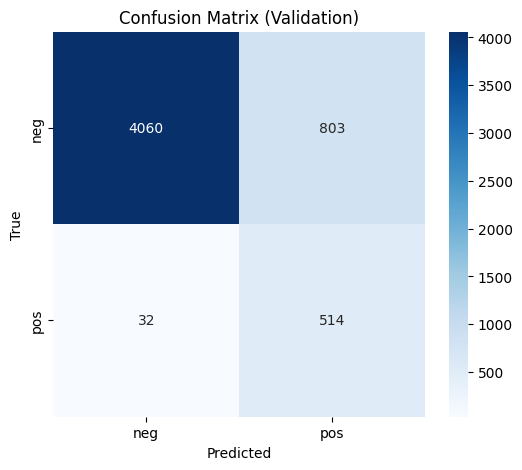

Test Evaluation:   0%|                                                       | 0/511 [00:00<?, ?it/s]

Test Evaluation:   0%|                                               | 1/511 [00:00<04:19,  1.96it/s]

Test Evaluation:   0%|▏                                              | 2/511 [00:01<04:14,  2.00it/s]

Test Evaluation:   1%|▎                                              | 3/511 [00:01<04:12,  2.01it/s]

Test Evaluation:   1%|▎                                              | 4/511 [00:02<04:13,  2.00it/s]

Test Evaluation:   1%|▍                                              | 5/511 [00:02<04:12,  2.01it/s]

Test Evaluation:   1%|▌                                              | 6/511 [00:02<04:00,  2.10it/s]

Test Evaluation:   1%|▋                                              | 7/511 [00:03<04:03,  2.07it/s]

Test Evaluation:   2%|▋                                              | 8/511 [00:03<04:05,  2.05it/s]

Test Evaluation:   2%|▊                                              | 9/511 [00:04<04:05,  2.04it/s]

Test Evaluation:   2%|▉                                             | 10/511 [00:04<04:01,  2.08it/s]

Test Evaluation:   2%|▉                                             | 11/511 [00:05<04:03,  2.05it/s]

Test Evaluation:   2%|█                                             | 12/511 [00:05<04:06,  2.03it/s]

Test Evaluation:   3%|█▏                                            | 13/511 [00:06<04:05,  2.03it/s]

Test Evaluation:   3%|█▎                                            | 14/511 [00:06<04:05,  2.03it/s]

Test Evaluation:   3%|█▎                                            | 15/511 [00:07<03:57,  2.09it/s]

Test Evaluation:   3%|█▍                                            | 16/511 [00:07<03:58,  2.08it/s]

Test Evaluation:   3%|█▌                                            | 17/511 [00:08<03:59,  2.07it/s]

Test Evaluation:   4%|█▌                                            | 18/511 [00:08<04:00,  2.05it/s]

Test Evaluation:   4%|█▋                                            | 19/511 [00:09<04:00,  2.05it/s]

Test Evaluation:   4%|█▊                                            | 20/511 [00:09<03:56,  2.08it/s]

Test Evaluation:   4%|█▉                                            | 21/511 [00:10<03:50,  2.13it/s]

Test Evaluation:   4%|█▉                                            | 22/511 [00:10<03:52,  2.10it/s]

Test Evaluation:   5%|██                                            | 23/511 [00:11<03:53,  2.09it/s]

Test Evaluation:   5%|██▏                                           | 24/511 [00:11<03:49,  2.13it/s]

Test Evaluation:   5%|██▎                                           | 25/511 [00:12<03:47,  2.14it/s]

Test Evaluation:   5%|██▎                                           | 26/511 [00:12<03:49,  2.11it/s]

Test Evaluation:   5%|██▍                                           | 27/511 [00:13<03:50,  2.10it/s]

Test Evaluation:   5%|██▌                                           | 28/511 [00:13<03:43,  2.16it/s]

Test Evaluation:   6%|██▌                                           | 29/511 [00:13<03:46,  2.12it/s]

Test Evaluation:   6%|██▋                                           | 30/511 [00:14<03:48,  2.11it/s]

Test Evaluation:   6%|██▊                                           | 31/511 [00:14<03:49,  2.09it/s]

Test Evaluation:   6%|██▉                                           | 32/511 [00:15<03:42,  2.15it/s]

Test Evaluation:   6%|██▉                                           | 33/511 [00:15<03:48,  2.10it/s]

Test Evaluation:   7%|███                                           | 34/511 [00:16<03:48,  2.08it/s]

Test Evaluation:   7%|███▏                                          | 35/511 [00:16<03:50,  2.07it/s]

Test Evaluation:   7%|███▏                                          | 36/511 [00:17<03:49,  2.07it/s]

Test Evaluation:   7%|███▎                                          | 37/511 [00:17<03:42,  2.13it/s]

Test Evaluation:   7%|███▍                                          | 38/511 [00:18<03:44,  2.11it/s]

Test Evaluation:   8%|███▌                                          | 39/511 [00:18<03:45,  2.09it/s]

Test Evaluation:   8%|███▌                                          | 40/511 [00:19<03:45,  2.09it/s]

Test Evaluation:   8%|███▋                                          | 41/511 [00:19<03:39,  2.14it/s]

Test Evaluation:   8%|███▊                                          | 42/511 [00:20<03:42,  2.10it/s]

Test Evaluation:   8%|███▊                                          | 43/511 [00:20<03:43,  2.09it/s]

Test Evaluation:   9%|███▉                                          | 44/511 [00:21<03:44,  2.08it/s]

Test Evaluation:   9%|████                                          | 45/511 [00:21<03:44,  2.07it/s]

Test Evaluation:   9%|████▏                                         | 46/511 [00:22<03:42,  2.09it/s]

Test Evaluation:   9%|████▏                                         | 47/511 [00:22<03:37,  2.13it/s]

Test Evaluation:   9%|████▎                                         | 48/511 [00:23<03:40,  2.10it/s]

Test Evaluation:  10%|████▍                                         | 49/511 [00:23<03:40,  2.09it/s]

Test Evaluation:  10%|████▌                                         | 50/511 [00:23<03:40,  2.09it/s]

Test Evaluation:  10%|████▌                                         | 51/511 [00:24<03:40,  2.09it/s]

Test Evaluation:  10%|████▋                                         | 52/511 [00:24<03:42,  2.07it/s]

Test Evaluation:  10%|████▊                                         | 53/511 [00:25<03:33,  2.14it/s]

Test Evaluation:  11%|████▊                                         | 54/511 [00:25<03:37,  2.10it/s]

Test Evaluation:  11%|████▉                                         | 55/511 [00:26<03:39,  2.07it/s]

Test Evaluation:  11%|█████                                         | 56/511 [00:26<03:41,  2.06it/s]

Test Evaluation:  11%|█████▏                                        | 57/511 [00:27<03:41,  2.05it/s]

Test Evaluation:  11%|█████▏                                        | 58/511 [00:27<03:39,  2.06it/s]

Test Evaluation:  12%|█████▎                                        | 59/511 [00:28<03:32,  2.13it/s]

Test Evaluation:  12%|█████▍                                        | 60/511 [00:28<03:34,  2.11it/s]

Test Evaluation:  12%|█████▍                                        | 61/511 [00:29<03:35,  2.08it/s]

Test Evaluation:  12%|█████▌                                        | 62/511 [00:29<03:36,  2.08it/s]

Test Evaluation:  12%|█████▋                                        | 63/511 [00:30<03:36,  2.07it/s]

Test Evaluation:  13%|█████▊                                        | 64/511 [00:30<03:35,  2.08it/s]

Test Evaluation:  13%|█████▊                                        | 65/511 [00:31<03:34,  2.07it/s]

Test Evaluation:  13%|█████▉                                        | 66/511 [00:31<03:34,  2.07it/s]

Test Evaluation:  13%|██████                                        | 67/511 [00:32<03:38,  2.03it/s]

Test Evaluation:  13%|██████                                        | 68/511 [00:32<03:37,  2.04it/s]

Test Evaluation:  14%|██████▏                                       | 69/511 [00:33<03:37,  2.03it/s]

Test Evaluation:  14%|██████▎                                       | 70/511 [00:33<03:37,  2.03it/s]

Test Evaluation:  14%|██████▍                                       | 71/511 [00:34<03:35,  2.05it/s]

Test Evaluation:  14%|██████▍                                       | 72/511 [00:34<03:34,  2.05it/s]

Test Evaluation:  14%|██████▌                                       | 73/511 [00:35<03:33,  2.05it/s]

Test Evaluation:  14%|██████▋                                       | 74/511 [00:35<03:32,  2.05it/s]

Test Evaluation:  15%|██████▊                                       | 75/511 [00:36<03:31,  2.06it/s]

Test Evaluation:  15%|██████▊                                       | 76/511 [00:36<03:31,  2.05it/s]

Test Evaluation:  15%|██████▉                                       | 77/511 [00:37<03:30,  2.06it/s]

Test Evaluation:  15%|███████                                       | 78/511 [00:37<03:30,  2.06it/s]

Test Evaluation:  15%|███████                                       | 79/511 [00:38<03:30,  2.05it/s]

Test Evaluation:  16%|███████▏                                      | 80/511 [00:38<03:29,  2.06it/s]

Test Evaluation:  16%|███████▎                                      | 81/511 [00:39<03:28,  2.06it/s]

Test Evaluation:  16%|███████▍                                      | 82/511 [00:39<03:28,  2.06it/s]

Test Evaluation:  16%|███████▍                                      | 83/511 [00:39<03:27,  2.07it/s]

Test Evaluation:  16%|███████▌                                      | 84/511 [00:40<03:28,  2.05it/s]

Test Evaluation:  17%|███████▋                                      | 85/511 [00:40<03:27,  2.05it/s]

Test Evaluation:  17%|███████▋                                      | 86/511 [00:41<03:27,  2.05it/s]

Test Evaluation:  17%|███████▊                                      | 87/511 [00:41<03:26,  2.05it/s]

Test Evaluation:  17%|███████▉                                      | 88/511 [00:42<03:25,  2.05it/s]

Test Evaluation:  17%|████████                                      | 89/511 [00:42<03:26,  2.05it/s]

Test Evaluation:  18%|████████                                      | 90/511 [00:43<03:24,  2.06it/s]

Test Evaluation:  18%|████████▏                                     | 91/511 [00:43<03:26,  2.04it/s]

Test Evaluation:  18%|████████▎                                     | 92/511 [00:44<03:24,  2.05it/s]

Test Evaluation:  18%|████████▎                                     | 93/511 [00:44<03:23,  2.05it/s]

Test Evaluation:  18%|████████▍                                     | 94/511 [00:45<03:24,  2.04it/s]

Test Evaluation:  19%|████████▌                                     | 95/511 [00:45<03:23,  2.05it/s]

Test Evaluation:  19%|████████▋                                     | 96/511 [00:46<03:23,  2.03it/s]

Test Evaluation:  19%|████████▋                                     | 97/511 [00:46<03:23,  2.03it/s]

Test Evaluation:  19%|████████▊                                     | 98/511 [00:47<03:23,  2.03it/s]

Test Evaluation:  19%|████████▉                                     | 99/511 [00:47<03:19,  2.06it/s]

Test Evaluation:  20%|████████▊                                    | 100/511 [00:48<03:13,  2.13it/s]

Test Evaluation:  20%|████████▉                                    | 101/511 [00:48<03:15,  2.10it/s]

Test Evaluation:  20%|████████▉                                    | 102/511 [00:49<03:16,  2.08it/s]

Test Evaluation:  20%|█████████                                    | 103/511 [00:49<03:17,  2.07it/s]

Test Evaluation:  20%|█████████▏                                   | 104/511 [00:50<03:18,  2.05it/s]

Test Evaluation:  21%|█████████▏                                   | 105/511 [00:50<03:18,  2.05it/s]

Test Evaluation:  21%|█████████▎                                   | 106/511 [00:51<03:17,  2.05it/s]

Test Evaluation:  21%|█████████▍                                   | 107/511 [00:51<03:16,  2.06it/s]

Test Evaluation:  21%|█████████▌                                   | 108/511 [00:52<03:16,  2.05it/s]

Test Evaluation:  21%|█████████▌                                   | 109/511 [00:52<03:16,  2.05it/s]

Test Evaluation:  22%|█████████▋                                   | 110/511 [00:53<03:14,  2.06it/s]

Test Evaluation:  22%|█████████▊                                   | 111/511 [00:53<03:14,  2.06it/s]

Test Evaluation:  22%|█████████▊                                   | 112/511 [00:54<03:12,  2.07it/s]

Test Evaluation:  22%|█████████▉                                   | 113/511 [00:54<03:12,  2.06it/s]

Test Evaluation:  22%|██████████                                   | 114/511 [00:55<03:13,  2.05it/s]

Test Evaluation:  23%|██████████▏                                  | 115/511 [00:55<03:15,  2.03it/s]

Test Evaluation:  23%|██████████▏                                  | 116/511 [00:56<03:14,  2.03it/s]

Test Evaluation:  23%|██████████▎                                  | 117/511 [00:56<03:13,  2.03it/s]

Test Evaluation:  23%|██████████▍                                  | 118/511 [00:57<03:11,  2.05it/s]

Test Evaluation:  23%|██████████▍                                  | 119/511 [00:57<03:05,  2.12it/s]

Test Evaluation:  23%|██████████▌                                  | 120/511 [00:57<03:07,  2.08it/s]

Test Evaluation:  24%|██████████▋                                  | 121/511 [00:58<03:07,  2.08it/s]

Test Evaluation:  24%|██████████▋                                  | 122/511 [00:58<03:06,  2.08it/s]

Test Evaluation:  24%|██████████▊                                  | 123/511 [00:59<03:06,  2.08it/s]

Test Evaluation:  24%|██████████▉                                  | 124/511 [00:59<03:06,  2.07it/s]

Test Evaluation:  24%|███████████                                  | 125/511 [01:00<03:06,  2.06it/s]

Test Evaluation:  25%|███████████                                  | 126/511 [01:00<03:05,  2.07it/s]

Test Evaluation:  25%|███████████▏                                 | 127/511 [01:01<03:04,  2.08it/s]

Test Evaluation:  25%|███████████▎                                 | 128/511 [01:01<03:04,  2.07it/s]

Test Evaluation:  25%|███████████▎                                 | 129/511 [01:02<03:07,  2.04it/s]

Test Evaluation:  25%|███████████▍                                 | 130/511 [01:02<03:05,  2.06it/s]

Test Evaluation:  26%|███████████▌                                 | 131/511 [01:03<03:04,  2.06it/s]

Test Evaluation:  26%|███████████▌                                 | 132/511 [01:03<03:03,  2.06it/s]

Test Evaluation:  26%|███████████▋                                 | 133/511 [01:04<03:02,  2.07it/s]

Test Evaluation:  26%|███████████▊                                 | 134/511 [01:04<03:04,  2.05it/s]

Test Evaluation:  26%|███████████▉                                 | 135/511 [01:05<03:04,  2.04it/s]

Test Evaluation:  27%|███████████▉                                 | 136/511 [01:05<03:02,  2.06it/s]

Test Evaluation:  27%|████████████                                 | 137/511 [01:06<03:02,  2.05it/s]

Test Evaluation:  27%|████████████▏                                | 138/511 [01:06<03:03,  2.04it/s]

Test Evaluation:  27%|████████████▏                                | 139/511 [01:07<03:01,  2.05it/s]

Test Evaluation:  27%|████████████▎                                | 140/511 [01:07<03:00,  2.05it/s]

Test Evaluation:  28%|████████████▍                                | 141/511 [01:08<03:00,  2.05it/s]

Test Evaluation:  28%|████████████▌                                | 142/511 [01:08<02:59,  2.06it/s]

Test Evaluation:  28%|████████████▌                                | 143/511 [01:09<02:58,  2.06it/s]

Test Evaluation:  28%|████████████▋                                | 144/511 [01:09<02:58,  2.05it/s]

Test Evaluation:  28%|████████████▊                                | 145/511 [01:10<02:57,  2.06it/s]

Test Evaluation:  29%|████████████▊                                | 146/511 [01:10<02:59,  2.04it/s]

Test Evaluation:  29%|████████████▉                                | 147/511 [01:11<02:58,  2.04it/s]

Test Evaluation:  29%|█████████████                                | 148/511 [01:11<02:58,  2.03it/s]

Test Evaluation:  29%|█████████████                                | 149/511 [01:12<02:56,  2.05it/s]

Test Evaluation:  29%|█████████████▏                               | 150/511 [01:12<02:56,  2.04it/s]

Test Evaluation:  30%|█████████████▎                               | 151/511 [01:13<02:56,  2.04it/s]

Test Evaluation:  30%|█████████████▍                               | 152/511 [01:13<02:56,  2.04it/s]

Test Evaluation:  30%|█████████████▍                               | 153/511 [01:14<02:54,  2.05it/s]

Test Evaluation:  30%|█████████████▌                               | 154/511 [01:14<02:54,  2.04it/s]

Test Evaluation:  30%|█████████████▋                               | 155/511 [01:15<02:55,  2.03it/s]

Test Evaluation:  31%|█████████████▋                               | 156/511 [01:15<02:55,  2.02it/s]

Test Evaluation:  31%|█████████████▊                               | 157/511 [01:16<02:55,  2.02it/s]

Test Evaluation:  31%|█████████████▉                               | 158/511 [01:16<02:55,  2.02it/s]

Test Evaluation:  31%|██████████████                               | 159/511 [01:16<02:50,  2.07it/s]

Test Evaluation:  31%|██████████████                               | 160/511 [01:17<02:51,  2.05it/s]

Test Evaluation:  32%|██████████████▏                              | 161/511 [01:17<02:51,  2.04it/s]

Test Evaluation:  32%|██████████████▎                              | 162/511 [01:18<02:52,  2.02it/s]

Test Evaluation:  32%|██████████████▎                              | 163/511 [01:18<02:53,  2.00it/s]

Test Evaluation:  32%|██████████████▍                              | 164/511 [01:19<02:53,  2.00it/s]

Test Evaluation:  32%|██████████████▌                              | 165/511 [01:19<02:52,  2.00it/s]

Test Evaluation:  32%|██████████████▌                              | 166/511 [01:20<02:50,  2.02it/s]

Test Evaluation:  33%|██████████████▋                              | 167/511 [01:20<02:50,  2.02it/s]

Test Evaluation:  33%|██████████████▊                              | 168/511 [01:21<02:49,  2.02it/s]

Test Evaluation:  33%|██████████████▉                              | 169/511 [01:21<02:49,  2.02it/s]

Test Evaluation:  33%|██████████████▉                              | 170/511 [01:22<02:49,  2.02it/s]

Test Evaluation:  33%|███████████████                              | 171/511 [01:22<02:47,  2.02it/s]

Test Evaluation:  34%|███████████████▏                             | 172/511 [01:23<02:48,  2.02it/s]

Test Evaluation:  34%|███████████████▏                             | 173/511 [01:23<02:48,  2.01it/s]

Test Evaluation:  34%|███████████████▎                             | 174/511 [01:24<02:46,  2.02it/s]

Test Evaluation:  34%|███████████████▍                             | 175/511 [01:24<02:46,  2.02it/s]

Test Evaluation:  34%|███████████████▍                             | 176/511 [01:25<02:46,  2.01it/s]

Test Evaluation:  35%|███████████████▌                             | 177/511 [01:25<02:44,  2.03it/s]

Test Evaluation:  35%|███████████████▋                             | 178/511 [01:26<02:41,  2.06it/s]

Test Evaluation:  35%|███████████████▊                             | 179/511 [01:26<02:42,  2.05it/s]

Test Evaluation:  35%|███████████████▊                             | 180/511 [01:27<02:43,  2.03it/s]

Test Evaluation:  35%|███████████████▉                             | 181/511 [01:27<02:43,  2.02it/s]

Test Evaluation:  36%|████████████████                             | 182/511 [01:28<02:43,  2.02it/s]

Test Evaluation:  36%|████████████████                             | 183/511 [01:28<02:42,  2.01it/s]

Test Evaluation:  36%|████████████████▏                            | 184/511 [01:29<02:42,  2.02it/s]

Test Evaluation:  36%|████████████████▎                            | 185/511 [01:29<02:42,  2.01it/s]

Test Evaluation:  36%|████████████████▍                            | 186/511 [01:30<02:41,  2.01it/s]

Test Evaluation:  37%|████████████████▍                            | 187/511 [01:30<02:40,  2.02it/s]

Test Evaluation:  37%|████████████████▌                            | 188/511 [01:31<02:41,  2.00it/s]

Test Evaluation:  37%|████████████████▋                            | 189/511 [01:31<02:40,  2.01it/s]

Test Evaluation:  37%|████████████████▋                            | 190/511 [01:32<02:40,  2.00it/s]

Test Evaluation:  37%|████████████████▊                            | 191/511 [01:32<02:39,  2.00it/s]

Test Evaluation:  38%|████████████████▉                            | 192/511 [01:33<02:38,  2.01it/s]

Test Evaluation:  38%|████████████████▉                            | 193/511 [01:33<02:39,  1.99it/s]

Test Evaluation:  38%|█████████████████                            | 194/511 [01:34<02:38,  2.01it/s]

Test Evaluation:  38%|█████████████████▏                           | 195/511 [01:34<02:37,  2.01it/s]

Test Evaluation:  38%|█████████████████▎                           | 196/511 [01:35<02:36,  2.01it/s]

Test Evaluation:  39%|█████████████████▎                           | 197/511 [01:35<02:36,  2.01it/s]

Test Evaluation:  39%|█████████████████▍                           | 198/511 [01:36<02:36,  2.00it/s]

Test Evaluation:  39%|█████████████████▌                           | 199/511 [01:36<02:36,  2.00it/s]

Test Evaluation:  39%|█████████████████▌                           | 200/511 [01:37<02:34,  2.01it/s]

Test Evaluation:  39%|█████████████████▋                           | 201/511 [01:37<02:32,  2.03it/s]

Test Evaluation:  40%|█████████████████▊                           | 202/511 [01:38<02:30,  2.05it/s]

Test Evaluation:  40%|█████████████████▉                           | 203/511 [01:38<02:30,  2.05it/s]

Test Evaluation:  40%|█████████████████▉                           | 204/511 [01:39<02:29,  2.05it/s]

Test Evaluation:  40%|██████████████████                           | 205/511 [01:39<02:29,  2.04it/s]

Test Evaluation:  40%|██████████████████▏                          | 206/511 [01:40<02:29,  2.05it/s]

Test Evaluation:  41%|██████████████████▏                          | 207/511 [01:40<02:24,  2.10it/s]

Test Evaluation:  41%|██████████████████▎                          | 208/511 [01:41<02:24,  2.10it/s]

Test Evaluation:  41%|██████████████████▍                          | 209/511 [01:41<02:24,  2.09it/s]

Test Evaluation:  41%|██████████████████▍                          | 210/511 [01:42<02:25,  2.08it/s]

Test Evaluation:  41%|██████████████████▌                          | 211/511 [01:42<02:24,  2.08it/s]

Test Evaluation:  41%|██████████████████▋                          | 212/511 [01:43<02:24,  2.07it/s]

Test Evaluation:  42%|██████████████████▊                          | 213/511 [01:43<02:25,  2.05it/s]

Test Evaluation:  42%|██████████████████▊                          | 214/511 [01:44<02:24,  2.06it/s]

Test Evaluation:  42%|██████████████████▉                          | 215/511 [01:44<02:24,  2.05it/s]

Test Evaluation:  42%|███████████████████                          | 216/511 [01:45<02:23,  2.06it/s]

Test Evaluation:  42%|███████████████████                          | 217/511 [01:45<02:23,  2.05it/s]

Test Evaluation:  43%|███████████████████▏                         | 218/511 [01:46<02:22,  2.05it/s]

Test Evaluation:  43%|███████████████████▎                         | 219/511 [01:46<02:21,  2.06it/s]

Test Evaluation:  43%|███████████████████▎                         | 220/511 [01:47<02:21,  2.05it/s]

Test Evaluation:  43%|███████████████████▍                         | 221/511 [01:47<02:22,  2.03it/s]

Test Evaluation:  43%|███████████████████▌                         | 222/511 [01:48<02:21,  2.04it/s]

Test Evaluation:  44%|███████████████████▋                         | 223/511 [01:48<02:20,  2.05it/s]

Test Evaluation:  44%|███████████████████▋                         | 224/511 [01:48<02:19,  2.06it/s]

Test Evaluation:  44%|███████████████████▊                         | 225/511 [01:49<02:18,  2.06it/s]

Test Evaluation:  44%|███████████████████▉                         | 226/511 [01:49<02:18,  2.06it/s]

Test Evaluation:  44%|███████████████████▉                         | 227/511 [01:50<02:17,  2.07it/s]

Test Evaluation:  45%|████████████████████                         | 228/511 [01:50<02:18,  2.05it/s]

Test Evaluation:  45%|████████████████████▏                        | 229/511 [01:51<02:17,  2.05it/s]

Test Evaluation:  45%|████████████████████▎                        | 230/511 [01:51<02:16,  2.06it/s]

Test Evaluation:  45%|████████████████████▎                        | 231/511 [01:52<02:15,  2.06it/s]

Test Evaluation:  45%|████████████████████▍                        | 232/511 [01:52<02:15,  2.06it/s]

Test Evaluation:  46%|████████████████████▌                        | 233/511 [01:53<02:15,  2.05it/s]

Test Evaluation:  46%|████████████████████▌                        | 234/511 [01:53<02:14,  2.06it/s]

Test Evaluation:  46%|████████████████████▋                        | 235/511 [01:54<02:14,  2.05it/s]

Test Evaluation:  46%|████████████████████▊                        | 236/511 [01:54<02:13,  2.05it/s]

Test Evaluation:  46%|████████████████████▊                        | 237/511 [01:55<02:13,  2.05it/s]

Test Evaluation:  47%|████████████████████▉                        | 238/511 [01:55<02:12,  2.07it/s]

Test Evaluation:  47%|█████████████████████                        | 239/511 [01:56<02:12,  2.05it/s]

Test Evaluation:  47%|█████████████████████▏                       | 240/511 [01:56<02:11,  2.05it/s]

Test Evaluation:  47%|█████████████████████▏                       | 241/511 [01:57<02:12,  2.04it/s]

Test Evaluation:  47%|█████████████████████▎                       | 242/511 [01:57<02:11,  2.05it/s]

Test Evaluation:  48%|█████████████████████▍                       | 243/511 [01:58<02:11,  2.04it/s]

Test Evaluation:  48%|█████████████████████▍                       | 244/511 [01:58<02:10,  2.04it/s]

Test Evaluation:  48%|█████████████████████▌                       | 245/511 [01:59<02:08,  2.07it/s]

Test Evaluation:  48%|█████████████████████▋                       | 246/511 [01:59<02:05,  2.11it/s]

Test Evaluation:  48%|█████████████████████▊                       | 247/511 [02:00<02:06,  2.09it/s]

Test Evaluation:  49%|█████████████████████▊                       | 248/511 [02:00<02:07,  2.07it/s]

Test Evaluation:  49%|█████████████████████▉                       | 249/511 [02:01<02:06,  2.08it/s]

Test Evaluation:  49%|██████████████████████                       | 250/511 [02:01<02:06,  2.06it/s]

Test Evaluation:  49%|██████████████████████                       | 251/511 [02:02<02:08,  2.03it/s]

Test Evaluation:  49%|██████████████████████▏                      | 252/511 [02:02<02:06,  2.05it/s]

Test Evaluation:  50%|██████████████████████▎                      | 253/511 [02:03<02:05,  2.05it/s]

Test Evaluation:  50%|██████████████████████▎                      | 254/511 [02:03<02:05,  2.05it/s]

Test Evaluation:  50%|██████████████████████▍                      | 255/511 [02:04<02:04,  2.05it/s]

Test Evaluation:  50%|██████████████████████▌                      | 256/511 [02:04<02:03,  2.06it/s]

Test Evaluation:  50%|██████████████████████▋                      | 257/511 [02:05<02:02,  2.07it/s]

Test Evaluation:  50%|██████████████████████▋                      | 258/511 [02:05<02:02,  2.06it/s]

Test Evaluation:  51%|██████████████████████▊                      | 259/511 [02:05<02:01,  2.07it/s]

Test Evaluation:  51%|██████████████████████▉                      | 260/511 [02:06<02:02,  2.05it/s]

Test Evaluation:  51%|██████████████████████▉                      | 261/511 [02:06<02:02,  2.05it/s]

Test Evaluation:  51%|███████████████████████                      | 262/511 [02:07<02:01,  2.05it/s]

Test Evaluation:  51%|███████████████████████▏                     | 263/511 [02:07<02:00,  2.06it/s]

Test Evaluation:  52%|███████████████████████▏                     | 264/511 [02:08<01:59,  2.07it/s]

Test Evaluation:  52%|███████████████████████▎                     | 265/511 [02:08<01:59,  2.05it/s]

Test Evaluation:  52%|███████████████████████▍                     | 266/511 [02:09<01:59,  2.04it/s]

Test Evaluation:  52%|███████████████████████▌                     | 267/511 [02:09<01:58,  2.06it/s]

Test Evaluation:  52%|███████████████████████▌                     | 268/511 [02:10<01:58,  2.06it/s]

Test Evaluation:  53%|███████████████████████▋                     | 269/511 [02:10<01:57,  2.05it/s]

Test Evaluation:  53%|███████████████████████▊                     | 270/511 [02:11<01:57,  2.06it/s]

Test Evaluation:  53%|███████████████████████▊                     | 271/511 [02:11<01:57,  2.05it/s]

Test Evaluation:  53%|███████████████████████▉                     | 272/511 [02:12<01:57,  2.03it/s]

Test Evaluation:  53%|████████████████████████                     | 273/511 [02:12<01:55,  2.06it/s]

Test Evaluation:  54%|████████████████████████▏                    | 274/511 [02:13<01:54,  2.07it/s]

Test Evaluation:  54%|████████████████████████▏                    | 275/511 [02:13<01:53,  2.07it/s]

Test Evaluation:  54%|████████████████████████▎                    | 276/511 [02:14<01:53,  2.08it/s]

Test Evaluation:  54%|████████████████████████▍                    | 277/511 [02:14<01:52,  2.08it/s]

Test Evaluation:  54%|████████████████████████▍                    | 278/511 [02:15<01:52,  2.08it/s]

Test Evaluation:  55%|████████████████████████▌                    | 279/511 [02:15<01:51,  2.08it/s]

Test Evaluation:  55%|████████████████████████▋                    | 280/511 [02:16<01:51,  2.07it/s]

Test Evaluation:  55%|████████████████████████▋                    | 281/511 [02:16<01:51,  2.07it/s]

Test Evaluation:  55%|████████████████████████▊                    | 282/511 [02:17<01:50,  2.06it/s]

Test Evaluation:  55%|████████████████████████▉                    | 283/511 [02:17<01:50,  2.06it/s]

Test Evaluation:  56%|█████████████████████████                    | 284/511 [02:18<01:50,  2.05it/s]

Test Evaluation:  56%|█████████████████████████                    | 285/511 [02:18<01:51,  2.03it/s]

Test Evaluation:  56%|█████████████████████████▏                   | 286/511 [02:19<01:50,  2.04it/s]

Test Evaluation:  56%|█████████████████████████▎                   | 287/511 [02:19<01:49,  2.05it/s]

Test Evaluation:  56%|█████████████████████████▎                   | 288/511 [02:20<01:48,  2.06it/s]

Test Evaluation:  57%|█████████████████████████▍                   | 289/511 [02:20<01:47,  2.06it/s]

Test Evaluation:  57%|█████████████████████████▌                   | 290/511 [02:21<01:46,  2.07it/s]

Test Evaluation:  57%|█████████████████████████▋                   | 291/511 [02:21<01:46,  2.06it/s]

Test Evaluation:  57%|█████████████████████████▋                   | 292/511 [02:22<01:46,  2.06it/s]

Test Evaluation:  57%|█████████████████████████▊                   | 293/511 [02:22<01:45,  2.06it/s]

Test Evaluation:  58%|█████████████████████████▉                   | 294/511 [02:23<01:45,  2.07it/s]

Test Evaluation:  58%|█████████████████████████▉                   | 295/511 [02:23<01:44,  2.07it/s]

Test Evaluation:  58%|██████████████████████████                   | 296/511 [02:23<01:43,  2.07it/s]

Test Evaluation:  58%|██████████████████████████▏                  | 297/511 [02:24<01:44,  2.05it/s]

Test Evaluation:  58%|██████████████████████████▏                  | 298/511 [02:24<01:43,  2.06it/s]

Test Evaluation:  59%|██████████████████████████▎                  | 299/511 [02:25<01:42,  2.06it/s]

Test Evaluation:  59%|██████████████████████████▍                  | 300/511 [02:25<01:42,  2.06it/s]

Test Evaluation:  59%|██████████████████████████▌                  | 301/511 [02:26<01:41,  2.07it/s]

Test Evaluation:  59%|██████████████████████████▌                  | 302/511 [02:26<01:41,  2.06it/s]

Test Evaluation:  59%|██████████████████████████▋                  | 303/511 [02:27<01:40,  2.06it/s]

Test Evaluation:  59%|██████████████████████████▊                  | 304/511 [02:27<01:39,  2.08it/s]

Test Evaluation:  60%|██████████████████████████▊                  | 305/511 [02:28<01:39,  2.06it/s]

Test Evaluation:  60%|██████████████████████████▉                  | 306/511 [02:28<01:39,  2.06it/s]

Test Evaluation:  60%|███████████████████████████                  | 307/511 [02:29<01:39,  2.05it/s]

Test Evaluation:  60%|███████████████████████████                  | 308/511 [02:29<01:38,  2.05it/s]

Test Evaluation:  60%|███████████████████████████▏                 | 309/511 [02:30<01:38,  2.05it/s]

Test Evaluation:  61%|███████████████████████████▎                 | 310/511 [02:30<01:38,  2.04it/s]

Test Evaluation:  61%|███████████████████████████▍                 | 311/511 [02:31<01:34,  2.11it/s]

Test Evaluation:  61%|███████████████████████████▍                 | 312/511 [02:31<01:33,  2.12it/s]

Test Evaluation:  61%|███████████████████████████▌                 | 313/511 [02:32<01:34,  2.09it/s]

Test Evaluation:  61%|███████████████████████████▋                 | 314/511 [02:32<01:34,  2.09it/s]

Test Evaluation:  62%|███████████████████████████▋                 | 315/511 [02:33<01:33,  2.09it/s]

Test Evaluation:  62%|███████████████████████████▊                 | 316/511 [02:33<01:33,  2.08it/s]

Test Evaluation:  62%|███████████████████████████▉                 | 317/511 [02:34<01:33,  2.08it/s]

Test Evaluation:  62%|████████████████████████████                 | 318/511 [02:34<01:32,  2.08it/s]

Test Evaluation:  62%|████████████████████████████                 | 319/511 [02:35<01:32,  2.07it/s]

Test Evaluation:  63%|████████████████████████████▏                | 320/511 [02:35<01:32,  2.07it/s]

Test Evaluation:  63%|████████████████████████████▎                | 321/511 [02:36<01:32,  2.06it/s]

Test Evaluation:  63%|████████████████████████████▎                | 322/511 [02:36<01:31,  2.07it/s]

Test Evaluation:  63%|████████████████████████████▍                | 323/511 [02:37<01:30,  2.07it/s]

Test Evaluation:  63%|████████████████████████████▌                | 324/511 [02:37<01:30,  2.07it/s]

Test Evaluation:  64%|████████████████████████████▌                | 325/511 [02:37<01:30,  2.05it/s]

Test Evaluation:  64%|████████████████████████████▋                | 326/511 [02:38<01:30,  2.04it/s]

Test Evaluation:  64%|████████████████████████████▊                | 327/511 [02:38<01:30,  2.04it/s]

Test Evaluation:  64%|████████████████████████████▉                | 328/511 [02:39<01:29,  2.04it/s]

Test Evaluation:  64%|████████████████████████████▉                | 329/511 [02:39<01:29,  2.03it/s]

Test Evaluation:  65%|█████████████████████████████                | 330/511 [02:40<01:29,  2.03it/s]

Test Evaluation:  65%|█████████████████████████████▏               | 331/511 [02:40<01:28,  2.04it/s]

Test Evaluation:  65%|█████████████████████████████▏               | 332/511 [02:41<01:27,  2.05it/s]

Test Evaluation:  65%|█████████████████████████████▎               | 333/511 [02:41<01:26,  2.05it/s]

Test Evaluation:  65%|█████████████████████████████▍               | 334/511 [02:42<01:26,  2.05it/s]

Test Evaluation:  66%|█████████████████████████████▌               | 335/511 [02:42<01:25,  2.06it/s]

Test Evaluation:  66%|█████████████████████████████▌               | 336/511 [02:43<01:25,  2.06it/s]

Test Evaluation:  66%|█████████████████████████████▋               | 337/511 [02:43<01:25,  2.04it/s]

Test Evaluation:  66%|█████████████████████████████▊               | 338/511 [02:44<01:24,  2.04it/s]

Test Evaluation:  66%|█████████████████████████████▊               | 339/511 [02:44<01:21,  2.11it/s]

Test Evaluation:  67%|█████████████████████████████▉               | 340/511 [02:45<01:21,  2.09it/s]

Test Evaluation:  67%|██████████████████████████████               | 341/511 [02:45<01:21,  2.08it/s]

Test Evaluation:  67%|██████████████████████████████               | 342/511 [02:46<01:21,  2.08it/s]

Test Evaluation:  67%|██████████████████████████████▏              | 343/511 [02:46<01:21,  2.07it/s]

Test Evaluation:  67%|██████████████████████████████▎              | 344/511 [02:47<01:20,  2.07it/s]

Test Evaluation:  68%|██████████████████████████████▍              | 345/511 [02:47<01:20,  2.07it/s]

Test Evaluation:  68%|██████████████████████████████▍              | 346/511 [02:48<01:19,  2.07it/s]

Test Evaluation:  68%|██████████████████████████████▌              | 347/511 [02:48<01:19,  2.06it/s]

Test Evaluation:  68%|██████████████████████████████▋              | 348/511 [02:49<01:18,  2.07it/s]

Test Evaluation:  68%|██████████████████████████████▋              | 349/511 [02:49<01:18,  2.07it/s]

Test Evaluation:  68%|██████████████████████████████▊              | 350/511 [02:50<01:18,  2.06it/s]

Test Evaluation:  69%|██████████████████████████████▉              | 351/511 [02:50<01:17,  2.05it/s]

Test Evaluation:  69%|██████████████████████████████▉              | 352/511 [02:51<01:17,  2.05it/s]

Test Evaluation:  69%|███████████████████████████████              | 353/511 [02:51<01:17,  2.05it/s]

Test Evaluation:  69%|███████████████████████████████▏             | 354/511 [02:52<01:16,  2.04it/s]

Test Evaluation:  69%|███████████████████████████████▎             | 355/511 [02:52<01:16,  2.04it/s]

Test Evaluation:  70%|███████████████████████████████▎             | 356/511 [02:53<01:15,  2.04it/s]

Test Evaluation:  70%|███████████████████████████████▍             | 357/511 [02:53<01:14,  2.06it/s]

Test Evaluation:  70%|███████████████████████████████▌             | 358/511 [02:54<01:14,  2.07it/s]

Test Evaluation:  70%|███████████████████████████████▌             | 359/511 [02:54<01:13,  2.07it/s]

Test Evaluation:  70%|███████████████████████████████▋             | 360/511 [02:55<01:13,  2.06it/s]

Test Evaluation:  71%|███████████████████████████████▊             | 361/511 [02:55<01:13,  2.05it/s]

Test Evaluation:  71%|███████████████████████████████▉             | 362/511 [02:55<01:12,  2.06it/s]

Test Evaluation:  71%|███████████████████████████████▉             | 363/511 [02:56<01:11,  2.06it/s]

Test Evaluation:  71%|████████████████████████████████             | 364/511 [02:56<01:11,  2.06it/s]

Test Evaluation:  71%|████████████████████████████████▏            | 365/511 [02:57<01:09,  2.11it/s]

Test Evaluation:  72%|████████████████████████████████▏            | 366/511 [02:57<01:09,  2.09it/s]

Test Evaluation:  72%|████████████████████████████████▎            | 367/511 [02:58<01:09,  2.08it/s]

Test Evaluation:  72%|████████████████████████████████▍            | 368/511 [02:58<01:09,  2.06it/s]

Test Evaluation:  72%|████████████████████████████████▍            | 369/511 [02:59<01:09,  2.05it/s]

Test Evaluation:  72%|████████████████████████████████▌            | 370/511 [02:59<01:09,  2.04it/s]

Test Evaluation:  73%|████████████████████████████████▋            | 371/511 [03:00<01:08,  2.05it/s]

Test Evaluation:  73%|████████████████████████████████▊            | 372/511 [03:00<01:08,  2.04it/s]

Test Evaluation:  73%|████████████████████████████████▊            | 373/511 [03:01<01:07,  2.04it/s]

Test Evaluation:  73%|████████████████████████████████▉            | 374/511 [03:01<01:07,  2.04it/s]

Test Evaluation:  73%|█████████████████████████████████            | 375/511 [03:02<01:07,  2.01it/s]

Test Evaluation:  74%|█████████████████████████████████            | 376/511 [03:02<01:06,  2.03it/s]

Test Evaluation:  74%|█████████████████████████████████▏           | 377/511 [03:03<01:05,  2.04it/s]

Test Evaluation:  74%|█████████████████████████████████▎           | 378/511 [03:03<01:05,  2.04it/s]

Test Evaluation:  74%|█████████████████████████████████▍           | 379/511 [03:04<01:04,  2.03it/s]

Test Evaluation:  74%|█████████████████████████████████▍           | 380/511 [03:04<01:04,  2.04it/s]

Test Evaluation:  75%|█████████████████████████████████▌           | 381/511 [03:05<01:03,  2.04it/s]

Test Evaluation:  75%|█████████████████████████████████▋           | 382/511 [03:05<01:03,  2.04it/s]

Test Evaluation:  75%|█████████████████████████████████▋           | 383/511 [03:06<01:02,  2.06it/s]

Test Evaluation:  75%|█████████████████████████████████▊           | 384/511 [03:06<01:01,  2.06it/s]

Test Evaluation:  75%|█████████████████████████████████▉           | 385/511 [03:07<01:01,  2.05it/s]

Test Evaluation:  76%|█████████████████████████████████▉           | 386/511 [03:07<01:01,  2.04it/s]

Test Evaluation:  76%|██████████████████████████████████           | 387/511 [03:08<01:00,  2.04it/s]

Test Evaluation:  76%|██████████████████████████████████▏          | 388/511 [03:08<01:00,  2.03it/s]

Test Evaluation:  76%|██████████████████████████████████▎          | 389/511 [03:09<00:59,  2.04it/s]

Test Evaluation:  76%|██████████████████████████████████▎          | 390/511 [03:09<00:59,  2.04it/s]

Test Evaluation:  77%|██████████████████████████████████▍          | 391/511 [03:10<00:58,  2.06it/s]

Test Evaluation:  77%|██████████████████████████████████▌          | 392/511 [03:10<00:58,  2.05it/s]

Test Evaluation:  77%|██████████████████████████████████▌          | 393/511 [03:11<00:57,  2.05it/s]

Test Evaluation:  77%|██████████████████████████████████▋          | 394/511 [03:11<00:57,  2.05it/s]

Test Evaluation:  77%|██████████████████████████████████▊          | 395/511 [03:12<00:56,  2.04it/s]

Test Evaluation:  77%|██████████████████████████████████▊          | 396/511 [03:12<00:56,  2.05it/s]

Test Evaluation:  78%|██████████████████████████████████▉          | 397/511 [03:13<00:55,  2.04it/s]

Test Evaluation:  78%|███████████████████████████████████          | 398/511 [03:13<00:55,  2.04it/s]

Test Evaluation:  78%|███████████████████████████████████▏         | 399/511 [03:14<00:54,  2.04it/s]

Test Evaluation:  78%|███████████████████████████████████▏         | 400/511 [03:14<00:54,  2.04it/s]

Test Evaluation:  78%|███████████████████████████████████▎         | 401/511 [03:15<00:53,  2.05it/s]

Test Evaluation:  79%|███████████████████████████████████▍         | 402/511 [03:15<00:52,  2.06it/s]

Test Evaluation:  79%|███████████████████████████████████▍         | 403/511 [03:16<00:52,  2.05it/s]

Test Evaluation:  79%|███████████████████████████████████▌         | 404/511 [03:16<00:52,  2.05it/s]

Test Evaluation:  79%|███████████████████████████████████▋         | 405/511 [03:16<00:51,  2.05it/s]

Test Evaluation:  79%|███████████████████████████████████▊         | 406/511 [03:17<00:51,  2.04it/s]

Test Evaluation:  80%|███████████████████████████████████▊         | 407/511 [03:17<00:50,  2.05it/s]

Test Evaluation:  80%|███████████████████████████████████▉         | 408/511 [03:18<00:50,  2.03it/s]

Test Evaluation:  80%|████████████████████████████████████         | 409/511 [03:18<00:50,  2.03it/s]

Test Evaluation:  80%|████████████████████████████████████         | 410/511 [03:19<00:48,  2.09it/s]

Test Evaluation:  80%|████████████████████████████████████▏        | 411/511 [03:19<00:47,  2.08it/s]

Test Evaluation:  81%|████████████████████████████████████▎        | 412/511 [03:20<00:47,  2.08it/s]

Test Evaluation:  81%|████████████████████████████████████▎        | 413/511 [03:20<00:47,  2.07it/s]

Test Evaluation:  81%|████████████████████████████████████▍        | 414/511 [03:21<00:46,  2.06it/s]

Test Evaluation:  81%|████████████████████████████████████▌        | 415/511 [03:21<00:46,  2.06it/s]

Test Evaluation:  81%|████████████████████████████████████▋        | 416/511 [03:22<00:46,  2.05it/s]

Test Evaluation:  82%|████████████████████████████████████▋        | 417/511 [03:22<00:45,  2.06it/s]

Test Evaluation:  82%|████████████████████████████████████▊        | 418/511 [03:23<00:45,  2.06it/s]

Test Evaluation:  82%|████████████████████████████████████▉        | 419/511 [03:23<00:44,  2.06it/s]

Test Evaluation:  82%|████████████████████████████████████▉        | 420/511 [03:24<00:43,  2.07it/s]

Test Evaluation:  82%|█████████████████████████████████████        | 421/511 [03:24<00:43,  2.06it/s]

Test Evaluation:  83%|█████████████████████████████████████▏       | 422/511 [03:25<00:43,  2.05it/s]

Test Evaluation:  83%|█████████████████████████████████████▎       | 423/511 [03:25<00:43,  2.05it/s]

Test Evaluation:  83%|█████████████████████████████████████▎       | 424/511 [03:26<00:42,  2.05it/s]

Test Evaluation:  83%|█████████████████████████████████████▍       | 425/511 [03:26<00:41,  2.05it/s]

Test Evaluation:  83%|█████████████████████████████████████▌       | 426/511 [03:27<00:41,  2.05it/s]

Test Evaluation:  84%|█████████████████████████████████████▌       | 427/511 [03:27<00:40,  2.05it/s]

Test Evaluation:  84%|█████████████████████████████████████▋       | 428/511 [03:28<00:40,  2.06it/s]

Test Evaluation:  84%|█████████████████████████████████████▊       | 429/511 [03:28<00:40,  2.04it/s]

Test Evaluation:  84%|█████████████████████████████████████▊       | 430/511 [03:29<00:39,  2.05it/s]

Test Evaluation:  84%|█████████████████████████████████████▉       | 431/511 [03:29<00:39,  2.04it/s]

Test Evaluation:  85%|██████████████████████████████████████       | 432/511 [03:30<00:38,  2.04it/s]

Test Evaluation:  85%|██████████████████████████████████████▏      | 433/511 [03:30<00:38,  2.05it/s]

Test Evaluation:  85%|██████████████████████████████████████▏      | 434/511 [03:31<00:36,  2.14it/s]

Test Evaluation:  85%|██████████████████████████████████████▎      | 435/511 [03:31<00:36,  2.10it/s]

Test Evaluation:  85%|██████████████████████████████████████▍      | 436/511 [03:32<00:36,  2.07it/s]

Test Evaluation:  86%|██████████████████████████████████████▍      | 437/511 [03:32<00:35,  2.06it/s]

Test Evaluation:  86%|██████████████████████████████████████▌      | 438/511 [03:33<00:35,  2.06it/s]

Test Evaluation:  86%|██████████████████████████████████████▋      | 439/511 [03:33<00:35,  2.05it/s]

Test Evaluation:  86%|██████████████████████████████████████▋      | 440/511 [03:33<00:34,  2.05it/s]

Test Evaluation:  86%|██████████████████████████████████████▊      | 441/511 [03:34<00:34,  2.05it/s]

Test Evaluation:  86%|██████████████████████████████████████▉      | 442/511 [03:34<00:33,  2.06it/s]

Test Evaluation:  87%|███████████████████████████████████████      | 443/511 [03:35<00:33,  2.06it/s]

Test Evaluation:  87%|███████████████████████████████████████      | 444/511 [03:35<00:32,  2.05it/s]

Test Evaluation:  87%|███████████████████████████████████████▏     | 445/511 [03:36<00:32,  2.05it/s]

Test Evaluation:  87%|███████████████████████████████████████▎     | 446/511 [03:36<00:31,  2.06it/s]

Test Evaluation:  87%|███████████████████████████████████████▎     | 447/511 [03:37<00:31,  2.06it/s]

Test Evaluation:  88%|███████████████████████████████████████▍     | 448/511 [03:37<00:30,  2.05it/s]

Test Evaluation:  88%|███████████████████████████████████████▌     | 449/511 [03:38<00:30,  2.06it/s]

Test Evaluation:  88%|███████████████████████████████████████▋     | 450/511 [03:38<00:29,  2.05it/s]

Test Evaluation:  88%|███████████████████████████████████████▋     | 451/511 [03:39<00:29,  2.03it/s]

Test Evaluation:  88%|███████████████████████████████████████▊     | 452/511 [03:39<00:29,  2.03it/s]

Test Evaluation:  89%|███████████████████████████████████████▉     | 453/511 [03:40<00:28,  2.01it/s]

Test Evaluation:  89%|███████████████████████████████████████▉     | 454/511 [03:40<00:28,  2.01it/s]

Test Evaluation:  89%|████████████████████████████████████████     | 455/511 [03:41<00:27,  2.01it/s]

Test Evaluation:  89%|████████████████████████████████████████▏    | 456/511 [03:41<00:27,  2.00it/s]

Test Evaluation:  89%|████████████████████████████████████████▏    | 457/511 [03:42<00:27,  1.99it/s]

Test Evaluation:  90%|████████████████████████████████████████▎    | 458/511 [03:42<00:26,  2.00it/s]

Test Evaluation:  90%|████████████████████████████████████████▍    | 459/511 [03:43<00:26,  1.99it/s]

Test Evaluation:  90%|████████████████████████████████████████▌    | 460/511 [03:43<00:25,  2.00it/s]

Test Evaluation:  90%|████████████████████████████████████████▌    | 461/511 [03:44<00:24,  2.01it/s]

Test Evaluation:  90%|████████████████████████████████████████▋    | 462/511 [03:44<00:24,  2.00it/s]

Test Evaluation:  91%|████████████████████████████████████████▊    | 463/511 [03:45<00:23,  2.07it/s]

Test Evaluation:  91%|████████████████████████████████████████▊    | 464/511 [03:45<00:22,  2.05it/s]

Test Evaluation:  91%|████████████████████████████████████████▉    | 465/511 [03:46<00:22,  2.03it/s]

Test Evaluation:  91%|█████████████████████████████████████████    | 466/511 [03:46<00:22,  2.02it/s]

Test Evaluation:  91%|█████████████████████████████████████████▏   | 467/511 [03:47<00:21,  2.02it/s]

Test Evaluation:  92%|█████████████████████████████████████████▏   | 468/511 [03:47<00:21,  2.02it/s]

Test Evaluation:  92%|█████████████████████████████████████████▎   | 469/511 [03:48<00:20,  2.02it/s]

Test Evaluation:  92%|█████████████████████████████████████████▍   | 470/511 [03:48<00:20,  2.00it/s]

Test Evaluation:  92%|█████████████████████████████████████████▍   | 471/511 [03:49<00:20,  2.00it/s]

Test Evaluation:  92%|█████████████████████████████████████████▌   | 472/511 [03:49<00:19,  2.00it/s]

Test Evaluation:  93%|█████████████████████████████████████████▋   | 473/511 [03:50<00:19,  1.97it/s]

Test Evaluation:  93%|█████████████████████████████████████████▋   | 474/511 [03:50<00:18,  1.98it/s]

Test Evaluation:  93%|█████████████████████████████████████████▊   | 475/511 [03:51<00:18,  1.99it/s]

Test Evaluation:  93%|█████████████████████████████████████████▉   | 476/511 [03:51<00:17,  2.00it/s]

Test Evaluation:  93%|██████████████████████████████████████████   | 477/511 [03:52<00:16,  2.02it/s]

Test Evaluation:  94%|██████████████████████████████████████████   | 478/511 [03:52<00:16,  2.03it/s]

Test Evaluation:  94%|██████████████████████████████████████████▏  | 479/511 [03:53<00:15,  2.04it/s]

Test Evaluation:  94%|██████████████████████████████████████████▎  | 480/511 [03:53<00:15,  2.04it/s]

Test Evaluation:  94%|██████████████████████████████████████████▎  | 481/511 [03:54<00:14,  2.02it/s]

Test Evaluation:  94%|██████████████████████████████████████████▍  | 482/511 [03:54<00:13,  2.08it/s]

Test Evaluation:  95%|██████████████████████████████████████████▌  | 483/511 [03:55<00:13,  2.08it/s]

Test Evaluation:  95%|██████████████████████████████████████████▌  | 484/511 [03:55<00:13,  2.08it/s]

Test Evaluation:  95%|██████████████████████████████████████████▋  | 485/511 [03:56<00:12,  2.08it/s]

Test Evaluation:  95%|██████████████████████████████████████████▊  | 486/511 [03:56<00:12,  2.08it/s]

Test Evaluation:  95%|██████████████████████████████████████████▉  | 487/511 [03:57<00:11,  2.06it/s]

Test Evaluation:  95%|██████████████████████████████████████████▉  | 488/511 [03:57<00:11,  2.05it/s]

Test Evaluation:  96%|███████████████████████████████████████████  | 489/511 [03:58<00:10,  2.03it/s]

Test Evaluation:  96%|███████████████████████████████████████████▏ | 490/511 [03:58<00:10,  2.02it/s]

Test Evaluation:  96%|███████████████████████████████████████████▏ | 491/511 [03:59<00:09,  2.03it/s]

Test Evaluation:  96%|███████████████████████████████████████████▎ | 492/511 [03:59<00:09,  2.01it/s]

Test Evaluation:  96%|███████████████████████████████████████████▍ | 493/511 [04:00<00:08,  2.01it/s]

Test Evaluation:  97%|███████████████████████████████████████████▌ | 494/511 [04:00<00:08,  2.00it/s]

Test Evaluation:  97%|███████████████████████████████████████████▌ | 495/511 [04:01<00:07,  2.01it/s]

Test Evaluation:  97%|███████████████████████████████████████████▋ | 496/511 [04:01<00:07,  2.02it/s]

Test Evaluation:  97%|███████████████████████████████████████████▊ | 497/511 [04:02<00:06,  2.02it/s]

Test Evaluation:  97%|███████████████████████████████████████████▊ | 498/511 [04:02<00:06,  2.02it/s]

Test Evaluation:  98%|███████████████████████████████████████████▉ | 499/511 [04:03<00:05,  2.04it/s]

Test Evaluation:  98%|████████████████████████████████████████████ | 500/511 [04:03<00:05,  2.04it/s]

Test Evaluation:  98%|████████████████████████████████████████████ | 501/511 [04:04<00:04,  2.04it/s]

Test Evaluation:  98%|████████████████████████████████████████████▏| 502/511 [04:04<00:04,  2.04it/s]

Test Evaluation:  98%|████████████████████████████████████████████▎| 503/511 [04:05<00:03,  2.04it/s]

Test Evaluation:  99%|████████████████████████████████████████████▍| 504/511 [04:05<00:03,  2.02it/s]

Test Evaluation:  99%|████████████████████████████████████████████▍| 505/511 [04:06<00:02,  2.04it/s]

Test Evaluation:  99%|████████████████████████████████████████████▌| 506/511 [04:06<00:02,  2.04it/s]

Test Evaluation:  99%|████████████████████████████████████████████▋| 507/511 [04:07<00:01,  2.04it/s]

Test Evaluation:  99%|████████████████████████████████████████████▋| 508/511 [04:07<00:01,  2.04it/s]

Test Evaluation: 100%|████████████████████████████████████████████▊| 509/511 [04:07<00:00,  2.05it/s]

Test Evaluation: 100%|████████████████████████████████████████████▉| 510/511 [04:08<00:00,  2.05it/s]

Test Evaluation: 100%|█████████████████████████████████████████████| 511/511 [04:08<00:00,  2.22it/s]

Test Evaluation: 100%|█████████████████████████████████████████████| 511/511 [04:08<00:00,  2.05it/s]

Test Loss: 0.1700 | Test Acc: 93.09% | Test F1: 0.8335
Classification Report (Test):
              precision    recall  f1-score   support

         neg       0.96      0.96      0.96      7240
         pos       0.69      0.73      0.71       934

    accuracy                           0.93      8174
   macro avg       0.83      0.84      0.83      8174
weighted avg       0.93      0.93      0.93      8174



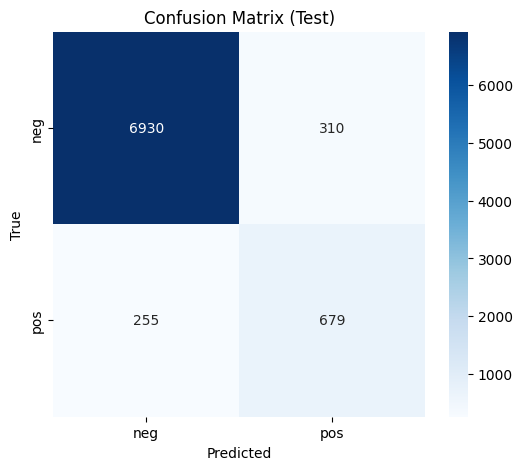

Epoch 7 Summary:
Train Loss: 0.1842 | Train Acc: 85.81% | Train F1: 0.8571
Val Loss: 0.1743 | Val Acc: 84.56% | Val F1: 0.7293
Test Loss: 0.1700 | Test Acc: 93.09% | Test F1: 0.8335
Epoch Time: 982.86s | GPU Memory Usage: 767.04 MB



Checkpoint saved at checkpoints\epoch_7.pth
No improvement in validation loss for 1 epoch(s).


Training:   0%|                                                              | 0/470 [00:00<?, ?it/s]

Training:   0%|                           | 0/470 [00:01<?, ?it/s, Loss=0.1284, F1=0.8730, Acc=87.50]

Training:   0%|                   | 1/470 [00:01<09:13,  1.18s/it, Loss=0.1284, F1=0.8730, Acc=87.50]

Training:   0%|                   | 1/470 [00:02<09:13,  1.18s/it, Loss=0.1152, F1=0.8398, Acc=84.38]

Training:   0%|                   | 2/470 [00:02<09:31,  1.22s/it, Loss=0.1152, F1=0.8398, Acc=84.38]

Training:   0%|                   | 2/470 [00:03<09:31,  1.22s/it, Loss=0.1357, F1=0.8461, Acc=85.42]

Training:   1%|                   | 3/470 [00:03<09:26,  1.21s/it, Loss=0.1357, F1=0.8461, Acc=85.42]

Training:   1%|                   | 3/470 [00:04<09:26,  1.21s/it, Loss=0.1462, F1=0.8333, Acc=84.38]

Training:   1%|▏                  | 4/470 [00:04<09:27,  1.22s/it, Loss=0.1462, F1=0.8333, Acc=84.38]

Training:   1%|▏                  | 4/470 [00:06<09:27,  1.22s/it, Loss=0.1544, F1=0.8400, Acc=85.00]

Training:   1%|▏                  | 5/470 [00:06<09:24,  1.21s/it, Loss=0.1544, F1=0.8400, Acc=85.00]

Training:   1%|▏                  | 5/470 [00:07<09:24,  1.21s/it, Loss=0.1569, F1=0.8077, Acc=82.29]

Training:   1%|▏                  | 6/470 [00:07<09:19,  1.21s/it, Loss=0.1569, F1=0.8077, Acc=82.29]

Training:   1%|▏                  | 6/470 [00:08<09:19,  1.21s/it, Loss=0.1582, F1=0.8056, Acc=82.14]

Training:   1%|▎                  | 7/470 [00:08<09:11,  1.19s/it, Loss=0.1582, F1=0.8056, Acc=82.14]

Training:   1%|▎                  | 7/470 [00:09<09:11,  1.19s/it, Loss=0.1568, F1=0.7922, Acc=81.25]

Training:   2%|▎                  | 8/470 [00:09<09:11,  1.19s/it, Loss=0.1568, F1=0.7922, Acc=81.25]

Training:   2%|▎                  | 8/470 [00:10<09:11,  1.19s/it, Loss=0.1607, F1=0.7989, Acc=81.94]

Training:   2%|▎                  | 9/470 [00:10<09:14,  1.20s/it, Loss=0.1607, F1=0.7989, Acc=81.94]

Training:   2%|▎                  | 9/470 [00:12<09:14,  1.20s/it, Loss=0.1565, F1=0.8025, Acc=82.50]

Training:   2%|▍                 | 10/470 [00:12<09:16,  1.21s/it, Loss=0.1565, F1=0.8025, Acc=82.50]

Training:   2%|▍                 | 10/470 [00:13<09:16,  1.21s/it, Loss=0.1447, F1=0.8144, Acc=83.52]

Training:   2%|▍                 | 11/470 [00:13<09:15,  1.21s/it, Loss=0.1447, F1=0.8144, Acc=83.52]

Training:   2%|▍                 | 11/470 [00:14<09:15,  1.21s/it, Loss=0.1393, F1=0.8252, Acc=83.85]

Training:   3%|▍                 | 12/470 [00:14<09:08,  1.20s/it, Loss=0.1393, F1=0.8252, Acc=83.85]

Training:   3%|▍                 | 12/470 [00:15<09:08,  1.20s/it, Loss=0.1340, F1=0.8398, Acc=85.10]

Training:   3%|▍                 | 13/470 [00:15<09:09,  1.20s/it, Loss=0.1340, F1=0.8398, Acc=85.10]

Training:   3%|▍                 | 13/470 [00:16<09:09,  1.20s/it, Loss=0.1278, F1=0.8534, Acc=86.16]

Training:   3%|▌                 | 14/470 [00:16<09:01,  1.19s/it, Loss=0.1278, F1=0.8534, Acc=86.16]

Training:   3%|▌                 | 14/470 [00:18<09:01,  1.19s/it, Loss=0.1448, F1=0.8596, Acc=86.67]

Training:   3%|▌                 | 15/470 [00:18<09:04,  1.20s/it, Loss=0.1448, F1=0.8596, Acc=86.67]

Training:   3%|▌                 | 15/470 [00:19<09:04,  1.20s/it, Loss=0.1437, F1=0.8615, Acc=86.72]

Training:   3%|▌                 | 16/470 [00:19<08:54,  1.18s/it, Loss=0.1437, F1=0.8615, Acc=86.72]

Training:   3%|▌                 | 16/470 [00:20<08:54,  1.18s/it, Loss=0.1370, F1=0.8706, Acc=87.50]

Training:   4%|▋                 | 17/470 [00:20<08:53,  1.18s/it, Loss=0.1370, F1=0.8706, Acc=87.50]

Training:   4%|▋                 | 17/470 [00:21<08:53,  1.18s/it, Loss=0.1374, F1=0.8717, Acc=87.50]

Training:   4%|▋                 | 18/470 [00:21<08:58,  1.19s/it, Loss=0.1374, F1=0.8717, Acc=87.50]

Training:   4%|▋                 | 18/470 [00:22<08:58,  1.19s/it, Loss=0.1315, F1=0.8790, Acc=88.16]

Training:   4%|▋                 | 19/470 [00:22<09:04,  1.21s/it, Loss=0.1315, F1=0.8790, Acc=88.16]

Training:   4%|▋                 | 19/470 [00:23<09:04,  1.21s/it, Loss=0.1392, F1=0.8688, Acc=87.19]

Training:   4%|▊                 | 20/470 [00:23<08:56,  1.19s/it, Loss=0.1392, F1=0.8688, Acc=87.19]

Training:   4%|▊                 | 20/470 [00:25<08:56,  1.19s/it, Loss=0.1373, F1=0.8688, Acc=87.20]

Training:   4%|▊                 | 21/470 [00:25<08:52,  1.19s/it, Loss=0.1373, F1=0.8688, Acc=87.20]

Training:   4%|▊                 | 21/470 [00:26<08:52,  1.19s/it, Loss=0.1325, F1=0.8743, Acc=87.78]

Training:   5%|▊                 | 22/470 [00:26<08:56,  1.20s/it, Loss=0.1325, F1=0.8743, Acc=87.78]

Training:   5%|▊                 | 22/470 [00:27<08:56,  1.20s/it, Loss=0.1317, F1=0.8711, Acc=87.50]

Training:   5%|▉                 | 23/470 [00:27<09:04,  1.22s/it, Loss=0.1317, F1=0.8711, Acc=87.50]

Training:   5%|▉                 | 23/470 [00:28<09:04,  1.22s/it, Loss=0.1282, F1=0.8768, Acc=88.02]

Training:   5%|▉                 | 24/470 [00:28<08:54,  1.20s/it, Loss=0.1282, F1=0.8768, Acc=88.02]

Training:   5%|▉                 | 24/470 [00:29<08:54,  1.20s/it, Loss=0.1248, F1=0.8787, Acc=88.25]

Training:   5%|▉                 | 25/470 [00:29<08:47,  1.19s/it, Loss=0.1248, F1=0.8787, Acc=88.25]

Training:   5%|▉                 | 25/470 [00:31<08:47,  1.19s/it, Loss=0.1300, F1=0.8780, Acc=88.22]

Training:   6%|▉                 | 26/470 [00:31<09:00,  1.22s/it, Loss=0.1300, F1=0.8780, Acc=88.22]

Training:   6%|▉                 | 26/470 [00:32<09:00,  1.22s/it, Loss=0.1296, F1=0.8751, Acc=87.96]

Training:   6%|█                 | 27/470 [00:32<08:54,  1.21s/it, Loss=0.1296, F1=0.8751, Acc=87.96]

Training:   6%|█                 | 27/470 [00:33<08:54,  1.21s/it, Loss=0.1326, F1=0.8764, Acc=88.17]

Training:   6%|█                 | 28/470 [00:33<08:54,  1.21s/it, Loss=0.1326, F1=0.8764, Acc=88.17]

Training:   6%|█                 | 28/470 [00:34<08:54,  1.21s/it, Loss=0.1414, F1=0.8741, Acc=87.93]

Training:   6%|█                 | 29/470 [00:34<08:46,  1.19s/it, Loss=0.1414, F1=0.8741, Acc=87.93]

Training:   6%|█                 | 29/470 [00:35<08:46,  1.19s/it, Loss=0.1441, F1=0.8716, Acc=87.71]

Training:   6%|█▏                | 30/470 [00:35<08:46,  1.20s/it, Loss=0.1441, F1=0.8716, Acc=87.71]

Training:   6%|█▏                | 30/470 [00:37<08:46,  1.20s/it, Loss=0.1449, F1=0.8695, Acc=87.50]

Training:   7%|█▏                | 31/470 [00:37<08:51,  1.21s/it, Loss=0.1449, F1=0.8695, Acc=87.50]

Training:   7%|█▏                | 31/470 [00:38<08:51,  1.21s/it, Loss=0.1565, F1=0.8615, Acc=86.72]

Training:   7%|█▏                | 32/470 [00:38<08:54,  1.22s/it, Loss=0.1565, F1=0.8615, Acc=86.72]

Training:   7%|█▏                | 32/470 [00:39<08:54,  1.22s/it, Loss=0.1642, F1=0.8595, Acc=86.55]

Training:   7%|█▎                | 33/470 [00:39<08:54,  1.22s/it, Loss=0.1642, F1=0.8595, Acc=86.55]

Training:   7%|█▎                | 33/470 [00:41<08:54,  1.22s/it, Loss=0.1677, F1=0.8604, Acc=86.58]

Training:   7%|█▎                | 34/470 [00:41<09:05,  1.25s/it, Loss=0.1677, F1=0.8604, Acc=86.58]

Training:   7%|█▎                | 34/470 [00:42<09:05,  1.25s/it, Loss=0.1732, F1=0.8503, Acc=85.54]

Training:   7%|█▎                | 35/470 [00:42<09:02,  1.25s/it, Loss=0.1732, F1=0.8503, Acc=85.54]

Training:   7%|█▎                | 35/470 [00:43<09:02,  1.25s/it, Loss=0.1767, F1=0.8433, Acc=84.90]

Training:   8%|█▍                | 36/470 [00:43<08:53,  1.23s/it, Loss=0.1767, F1=0.8433, Acc=84.90]

Training:   8%|█▍                | 36/470 [00:44<08:53,  1.23s/it, Loss=0.1760, F1=0.8405, Acc=84.63]

Training:   8%|█▍                | 37/470 [00:44<08:47,  1.22s/it, Loss=0.1760, F1=0.8405, Acc=84.63]

Training:   8%|█▍                | 37/470 [00:45<08:47,  1.22s/it, Loss=0.1725, F1=0.8428, Acc=84.87]

Training:   8%|█▍                | 38/470 [00:45<08:41,  1.21s/it, Loss=0.1725, F1=0.8428, Acc=84.87]

Training:   8%|█▍                | 38/470 [00:47<08:41,  1.21s/it, Loss=0.1695, F1=0.8430, Acc=84.94]

Training:   8%|█▍                | 39/470 [00:47<08:45,  1.22s/it, Loss=0.1695, F1=0.8430, Acc=84.94]

Training:   8%|█▍                | 39/470 [00:48<08:45,  1.22s/it, Loss=0.1662, F1=0.8464, Acc=85.31]

Training:   9%|█▌                | 40/470 [00:48<08:43,  1.22s/it, Loss=0.1662, F1=0.8464, Acc=85.31]

Training:   9%|█▌                | 40/470 [00:49<08:43,  1.22s/it, Loss=0.1717, F1=0.8458, Acc=85.21]

Training:   9%|█▌                | 41/470 [00:49<08:37,  1.21s/it, Loss=0.1717, F1=0.8458, Acc=85.21]

Training:   9%|█▌                | 41/470 [00:50<08:37,  1.21s/it, Loss=0.1691, F1=0.8496, Acc=85.57]

Training:   9%|█▌                | 42/470 [00:50<08:32,  1.20s/it, Loss=0.1691, F1=0.8496, Acc=85.57]

Training:   9%|█▌                | 42/470 [00:51<08:32,  1.20s/it, Loss=0.1704, F1=0.8489, Acc=85.47]

Training:   9%|█▋                | 43/470 [00:51<08:35,  1.21s/it, Loss=0.1704, F1=0.8489, Acc=85.47]

Training:   9%|█▋                | 43/470 [00:53<08:35,  1.21s/it, Loss=0.1686, F1=0.8507, Acc=85.65]

Training:   9%|█▋                | 44/470 [00:53<08:34,  1.21s/it, Loss=0.1686, F1=0.8507, Acc=85.65]

Training:   9%|█▋                | 44/470 [00:54<08:34,  1.21s/it, Loss=0.1756, F1=0.8500, Acc=85.56]

Training:  10%|█▋                | 45/470 [00:54<08:29,  1.20s/it, Loss=0.1756, F1=0.8500, Acc=85.56]

Training:  10%|█▋                | 45/470 [00:55<08:29,  1.20s/it, Loss=0.1765, F1=0.8467, Acc=85.19]

Training:  10%|█▊                | 46/470 [00:55<08:22,  1.19s/it, Loss=0.1765, F1=0.8467, Acc=85.19]

Training:  10%|█▊                | 46/470 [00:56<08:22,  1.19s/it, Loss=0.1803, F1=0.8450, Acc=84.97]

Training:  10%|█▊                | 47/470 [00:56<08:16,  1.17s/it, Loss=0.1803, F1=0.8450, Acc=84.97]

Training:  10%|█▊                | 47/470 [00:57<08:16,  1.17s/it, Loss=0.1802, F1=0.8444, Acc=84.90]

Training:  10%|█▊                | 48/470 [00:57<08:10,  1.16s/it, Loss=0.1802, F1=0.8444, Acc=84.90]

Training:  10%|█▊                | 48/470 [00:58<08:10,  1.16s/it, Loss=0.1812, F1=0.8393, Acc=84.44]

Training:  10%|█▉                | 49/470 [00:58<08:12,  1.17s/it, Loss=0.1812, F1=0.8393, Acc=84.44]

Training:  10%|█▉                | 49/470 [01:00<08:12,  1.17s/it, Loss=0.1795, F1=0.8372, Acc=84.25]

Training:  11%|█▉                | 50/470 [01:00<08:11,  1.17s/it, Loss=0.1795, F1=0.8372, Acc=84.25]

Training:  11%|█▉                | 50/470 [01:01<08:11,  1.17s/it, Loss=0.1793, F1=0.8370, Acc=84.19]

Training:  11%|█▉                | 51/470 [01:01<08:13,  1.18s/it, Loss=0.1793, F1=0.8370, Acc=84.19]

Training:  11%|█▉                | 51/470 [01:02<08:13,  1.18s/it, Loss=0.1778, F1=0.8393, Acc=84.38]

Training:  11%|█▉                | 52/470 [01:02<08:15,  1.19s/it, Loss=0.1778, F1=0.8393, Acc=84.38]

Training:  11%|█▉                | 52/470 [01:03<08:15,  1.19s/it, Loss=0.1776, F1=0.8387, Acc=84.32]

Training:  11%|██                | 53/470 [01:03<08:07,  1.17s/it, Loss=0.1776, F1=0.8387, Acc=84.32]

Training:  11%|██                | 53/470 [01:04<08:07,  1.17s/it, Loss=0.1783, F1=0.8381, Acc=84.26]

Training:  11%|██                | 54/470 [01:04<08:04,  1.17s/it, Loss=0.1783, F1=0.8381, Acc=84.26]

Training:  11%|██                | 54/470 [01:05<08:04,  1.17s/it, Loss=0.1755, F1=0.8410, Acc=84.55]

Training:  12%|██                | 55/470 [01:05<08:10,  1.18s/it, Loss=0.1755, F1=0.8410, Acc=84.55]

Training:  12%|██                | 55/470 [01:07<08:10,  1.18s/it, Loss=0.1759, F1=0.8367, Acc=84.15]

Training:  12%|██▏               | 56/470 [01:07<08:09,  1.18s/it, Loss=0.1759, F1=0.8367, Acc=84.15]

Training:  12%|██▏               | 56/470 [01:08<08:09,  1.18s/it, Loss=0.1751, F1=0.8362, Acc=84.10]

Training:  12%|██▏               | 57/470 [01:08<08:07,  1.18s/it, Loss=0.1751, F1=0.8362, Acc=84.10]

Training:  12%|██▏               | 57/470 [01:09<08:07,  1.18s/it, Loss=0.1752, F1=0.8366, Acc=84.16]

Training:  12%|██▏               | 58/470 [01:09<08:06,  1.18s/it, Loss=0.1752, F1=0.8366, Acc=84.16]

Training:  12%|██▏               | 58/470 [01:10<08:06,  1.18s/it, Loss=0.1781, F1=0.8363, Acc=84.11]

Training:  13%|██▎               | 59/470 [01:10<07:59,  1.17s/it, Loss=0.1781, F1=0.8363, Acc=84.11]

Training:  13%|██▎               | 59/470 [01:11<07:59,  1.17s/it, Loss=0.1795, F1=0.8359, Acc=84.06]

Training:  13%|██▎               | 60/470 [01:11<07:55,  1.16s/it, Loss=0.1795, F1=0.8359, Acc=84.06]

Training:  13%|██▎               | 60/470 [01:12<07:55,  1.16s/it, Loss=0.1798, F1=0.8365, Acc=84.12]

Training:  13%|██▎               | 61/470 [01:12<07:56,  1.17s/it, Loss=0.1798, F1=0.8365, Acc=84.12]

Training:  13%|██▎               | 61/470 [01:14<07:56,  1.17s/it, Loss=0.1781, F1=0.8395, Acc=84.38]

Training:  13%|██▎               | 62/470 [01:14<08:01,  1.18s/it, Loss=0.1781, F1=0.8395, Acc=84.38]

Training:  13%|██▎               | 62/470 [01:15<08:01,  1.18s/it, Loss=0.1762, F1=0.8401, Acc=84.42]

Training:  13%|██▍               | 63/470 [01:15<08:03,  1.19s/it, Loss=0.1762, F1=0.8401, Acc=84.42]

Training:  13%|██▍               | 63/470 [01:16<08:03,  1.19s/it, Loss=0.1755, F1=0.8406, Acc=84.47]

Training:  14%|██▍               | 64/470 [01:16<08:04,  1.19s/it, Loss=0.1755, F1=0.8406, Acc=84.47]

Training:  14%|██▍               | 64/470 [01:17<08:04,  1.19s/it, Loss=0.1747, F1=0.8401, Acc=84.42]

Training:  14%|██▍               | 65/470 [01:17<07:57,  1.18s/it, Loss=0.1747, F1=0.8401, Acc=84.42]

Training:  14%|██▍               | 65/470 [01:18<07:57,  1.18s/it, Loss=0.1730, F1=0.8405, Acc=84.47]

Training:  14%|██▌               | 66/470 [01:18<08:04,  1.20s/it, Loss=0.1730, F1=0.8405, Acc=84.47]

Training:  14%|██▌               | 66/470 [01:20<08:04,  1.20s/it, Loss=0.1744, F1=0.8390, Acc=84.33]

Training:  14%|██▌               | 67/470 [01:20<08:06,  1.21s/it, Loss=0.1744, F1=0.8390, Acc=84.33]

Training:  14%|██▌               | 67/470 [01:21<08:06,  1.21s/it, Loss=0.1740, F1=0.8398, Acc=84.38]

Training:  14%|██▌               | 68/470 [01:21<08:00,  1.20s/it, Loss=0.1740, F1=0.8398, Acc=84.38]

Training:  14%|██▌               | 68/470 [01:22<08:00,  1.20s/it, Loss=0.1723, F1=0.8402, Acc=84.42]

Training:  15%|██▋               | 69/470 [01:22<07:50,  1.17s/it, Loss=0.1723, F1=0.8402, Acc=84.42]

Training:  15%|██▋               | 69/470 [01:23<07:50,  1.17s/it, Loss=0.1734, F1=0.8364, Acc=84.02]

Training:  15%|██▋               | 70/470 [01:23<07:49,  1.17s/it, Loss=0.1734, F1=0.8364, Acc=84.02]

Training:  15%|██▋               | 70/470 [01:24<07:49,  1.17s/it, Loss=0.1715, F1=0.8376, Acc=84.15]

Training:  15%|██▋               | 71/470 [01:24<07:46,  1.17s/it, Loss=0.1715, F1=0.8376, Acc=84.15]

Training:  15%|██▋               | 71/470 [01:25<07:46,  1.17s/it, Loss=0.1701, F1=0.8390, Acc=84.29]

Training:  15%|██▊               | 72/470 [01:25<07:45,  1.17s/it, Loss=0.1701, F1=0.8390, Acc=84.29]

Training:  15%|██▊               | 72/470 [01:27<07:45,  1.17s/it, Loss=0.1725, F1=0.8396, Acc=84.33]

Training:  16%|██▊               | 73/470 [01:27<07:46,  1.18s/it, Loss=0.1725, F1=0.8396, Acc=84.33]

Training:  16%|██▊               | 73/470 [01:28<07:46,  1.18s/it, Loss=0.1718, F1=0.8400, Acc=84.38]

Training:  16%|██▊               | 74/470 [01:28<07:46,  1.18s/it, Loss=0.1718, F1=0.8400, Acc=84.38]

Training:  16%|██▊               | 74/470 [01:29<07:46,  1.18s/it, Loss=0.1729, F1=0.8421, Acc=84.58]

Training:  16%|██▊               | 75/470 [01:29<07:46,  1.18s/it, Loss=0.1729, F1=0.8421, Acc=84.58]

Training:  16%|██▊               | 75/470 [01:30<07:46,  1.18s/it, Loss=0.1718, F1=0.8440, Acc=84.79]

Training:  16%|██▉               | 76/470 [01:30<07:41,  1.17s/it, Loss=0.1718, F1=0.8440, Acc=84.79]

Training:  16%|██▉               | 76/470 [01:31<07:41,  1.17s/it, Loss=0.1709, F1=0.8427, Acc=84.66]

Training:  16%|██▉               | 77/470 [01:31<07:50,  1.20s/it, Loss=0.1709, F1=0.8427, Acc=84.66]

Training:  16%|██▉               | 77/470 [01:33<07:50,  1.20s/it, Loss=0.1721, F1=0.8430, Acc=84.70]

Training:  17%|██▉               | 78/470 [01:33<07:55,  1.21s/it, Loss=0.1721, F1=0.8430, Acc=84.70]

Training:  17%|██▉               | 78/470 [01:34<07:55,  1.21s/it, Loss=0.1733, F1=0.8413, Acc=84.49]

Training:  17%|███               | 79/470 [01:34<07:50,  1.20s/it, Loss=0.1733, F1=0.8413, Acc=84.49]

Training:  17%|███               | 79/470 [01:35<07:50,  1.20s/it, Loss=0.1720, F1=0.8424, Acc=84.61]

Training:  17%|███               | 80/470 [01:35<07:46,  1.20s/it, Loss=0.1720, F1=0.8424, Acc=84.61]

Training:  17%|███               | 80/470 [01:36<07:46,  1.20s/it, Loss=0.1766, F1=0.8415, Acc=84.49]

Training:  17%|███               | 81/470 [01:36<07:42,  1.19s/it, Loss=0.1766, F1=0.8415, Acc=84.49]

Training:  17%|███               | 81/470 [01:37<07:42,  1.19s/it, Loss=0.1770, F1=0.8396, Acc=84.30]

Training:  17%|███▏              | 82/470 [01:37<07:35,  1.17s/it, Loss=0.1770, F1=0.8396, Acc=84.30]

Training:  17%|███▏              | 82/470 [01:39<07:35,  1.17s/it, Loss=0.1760, F1=0.8400, Acc=84.34]

Training:  18%|███▏              | 83/470 [01:39<07:39,  1.19s/it, Loss=0.1760, F1=0.8400, Acc=84.34]

Training:  18%|███▏              | 83/470 [01:40<07:39,  1.19s/it, Loss=0.1757, F1=0.8402, Acc=84.38]

Training:  18%|███▏              | 84/470 [01:40<07:41,  1.20s/it, Loss=0.1757, F1=0.8402, Acc=84.38]

Training:  18%|███▏              | 84/470 [01:41<07:41,  1.20s/it, Loss=0.1752, F1=0.8398, Acc=84.34]

Training:  18%|███▎              | 85/470 [01:41<07:44,  1.21s/it, Loss=0.1752, F1=0.8398, Acc=84.34]

Training:  18%|███▎              | 85/470 [01:42<07:44,  1.21s/it, Loss=0.1765, F1=0.8409, Acc=84.45]

Training:  18%|███▎              | 86/470 [01:42<07:42,  1.21s/it, Loss=0.1765, F1=0.8409, Acc=84.45]

Training:  18%|███▎              | 86/470 [01:43<07:42,  1.21s/it, Loss=0.1799, F1=0.8404, Acc=84.41]

Training:  19%|███▎              | 87/470 [01:43<07:43,  1.21s/it, Loss=0.1799, F1=0.8404, Acc=84.41]

Training:  19%|███▎              | 87/470 [01:45<07:43,  1.21s/it, Loss=0.1800, F1=0.8402, Acc=84.38]

Training:  19%|███▎              | 88/470 [01:45<07:45,  1.22s/it, Loss=0.1800, F1=0.8402, Acc=84.38]

Training:  19%|███▎              | 88/470 [01:46<07:45,  1.22s/it, Loss=0.1806, F1=0.8389, Acc=84.27]

Training:  19%|███▍              | 89/470 [01:46<07:48,  1.23s/it, Loss=0.1806, F1=0.8389, Acc=84.27]

Training:  19%|███▍              | 89/470 [01:47<07:48,  1.23s/it, Loss=0.1804, F1=0.8380, Acc=84.17]

Training:  19%|███▍              | 90/470 [01:47<07:49,  1.24s/it, Loss=0.1804, F1=0.8380, Acc=84.17]

Training:  19%|███▍              | 90/470 [01:49<07:49,  1.24s/it, Loss=0.1793, F1=0.8392, Acc=84.27]

Training:  19%|███▍              | 91/470 [01:49<07:54,  1.25s/it, Loss=0.1793, F1=0.8392, Acc=84.27]

Training:  19%|███▍              | 91/470 [01:50<07:54,  1.25s/it, Loss=0.1795, F1=0.8396, Acc=84.31]

Training:  20%|███▌              | 92/470 [01:50<07:50,  1.24s/it, Loss=0.1795, F1=0.8396, Acc=84.31]

Training:  20%|███▌              | 92/470 [01:51<07:50,  1.24s/it, Loss=0.1817, F1=0.8384, Acc=84.21]

Training:  20%|███▌              | 93/470 [01:51<07:40,  1.22s/it, Loss=0.1817, F1=0.8384, Acc=84.21]

Training:  20%|███▌              | 93/470 [01:52<07:40,  1.22s/it, Loss=0.1805, F1=0.8389, Acc=84.24]

Training:  20%|███▌              | 94/470 [01:52<07:36,  1.21s/it, Loss=0.1805, F1=0.8389, Acc=84.24]

Training:  20%|███▌              | 94/470 [01:53<07:36,  1.21s/it, Loss=0.1818, F1=0.8389, Acc=84.21]

Training:  20%|███▋              | 95/470 [01:53<07:35,  1.21s/it, Loss=0.1818, F1=0.8389, Acc=84.21]

Training:  20%|███▋              | 95/470 [01:55<07:35,  1.21s/it, Loss=0.1808, F1=0.8399, Acc=84.31]

Training:  20%|███▋              | 96/470 [01:55<07:35,  1.22s/it, Loss=0.1808, F1=0.8399, Acc=84.31]

Training:  20%|███▋              | 96/470 [01:56<07:35,  1.22s/it, Loss=0.1797, F1=0.8412, Acc=84.41]

Training:  21%|███▋              | 97/470 [01:56<07:36,  1.22s/it, Loss=0.1797, F1=0.8412, Acc=84.41]

Training:  21%|███▋              | 97/470 [01:57<07:36,  1.22s/it, Loss=0.1785, F1=0.8422, Acc=84.50]

Training:  21%|███▊              | 98/470 [01:57<07:32,  1.22s/it, Loss=0.1785, F1=0.8422, Acc=84.50]

Training:  21%|███▊              | 98/470 [01:58<07:32,  1.22s/it, Loss=0.1815, F1=0.8426, Acc=84.53]

Training:  21%|███▊              | 99/470 [01:58<07:29,  1.21s/it, Loss=0.1815, F1=0.8426, Acc=84.53]

Training:  21%|███▊              | 99/470 [01:59<07:29,  1.21s/it, Loss=0.1818, F1=0.8437, Acc=84.62]

Training:  21%|███▌             | 100/470 [01:59<07:32,  1.22s/it, Loss=0.1818, F1=0.8437, Acc=84.62]

Training:  21%|███▌             | 100/470 [02:01<07:32,  1.22s/it, Loss=0.1807, F1=0.8441, Acc=84.65]

Training:  21%|███▋             | 101/470 [02:01<07:36,  1.24s/it, Loss=0.1807, F1=0.8441, Acc=84.65]

Training:  21%|███▋             | 101/470 [02:02<07:36,  1.24s/it, Loss=0.1800, F1=0.8450, Acc=84.74]

Training:  22%|███▋             | 102/470 [02:02<07:24,  1.21s/it, Loss=0.1800, F1=0.8450, Acc=84.74]

Training:  22%|███▋             | 102/470 [02:03<07:24,  1.21s/it, Loss=0.1816, F1=0.8446, Acc=84.71]

Training:  22%|███▋             | 103/470 [02:03<07:22,  1.20s/it, Loss=0.1816, F1=0.8446, Acc=84.71]

Training:  22%|███▋             | 103/470 [02:04<07:22,  1.20s/it, Loss=0.1802, F1=0.8455, Acc=84.80]

Training:  22%|███▊             | 104/470 [02:04<07:25,  1.22s/it, Loss=0.1802, F1=0.8455, Acc=84.80]

Training:  22%|███▊             | 104/470 [02:05<07:25,  1.22s/it, Loss=0.1803, F1=0.8452, Acc=84.76]

Training:  22%|███▊             | 105/470 [02:05<07:21,  1.21s/it, Loss=0.1803, F1=0.8452, Acc=84.76]

Training:  22%|███▊             | 105/470 [02:07<07:21,  1.21s/it, Loss=0.1812, F1=0.8455, Acc=84.79]

Training:  23%|███▊             | 106/470 [02:07<07:16,  1.20s/it, Loss=0.1812, F1=0.8455, Acc=84.79]

Training:  23%|███▊             | 106/470 [02:08<07:16,  1.20s/it, Loss=0.1811, F1=0.8453, Acc=84.75]

Training:  23%|███▊             | 107/470 [02:08<07:15,  1.20s/it, Loss=0.1811, F1=0.8453, Acc=84.75]

Training:  23%|███▊             | 107/470 [02:09<07:15,  1.20s/it, Loss=0.1809, F1=0.8455, Acc=84.78]

Training:  23%|███▉             | 108/470 [02:09<07:10,  1.19s/it, Loss=0.1809, F1=0.8455, Acc=84.78]

Training:  23%|███▉             | 108/470 [02:10<07:10,  1.19s/it, Loss=0.1825, F1=0.8452, Acc=84.75]

Training:  23%|███▉             | 109/470 [02:10<07:16,  1.21s/it, Loss=0.1825, F1=0.8452, Acc=84.75]

Training:  23%|███▉             | 109/470 [02:11<07:16,  1.21s/it, Loss=0.1818, F1=0.8454, Acc=84.77]

Training:  23%|███▉             | 110/470 [02:11<07:10,  1.20s/it, Loss=0.1818, F1=0.8454, Acc=84.77]

Training:  23%|███▉             | 110/470 [02:13<07:10,  1.20s/it, Loss=0.1814, F1=0.8446, Acc=84.68]

Training:  24%|████             | 111/470 [02:13<07:10,  1.20s/it, Loss=0.1814, F1=0.8446, Acc=84.68]

Training:  24%|████             | 111/470 [02:14<07:10,  1.20s/it, Loss=0.1810, F1=0.8442, Acc=84.65]

Training:  24%|████             | 112/470 [02:14<07:12,  1.21s/it, Loss=0.1810, F1=0.8442, Acc=84.65]

Training:  24%|████             | 112/470 [02:15<07:12,  1.21s/it, Loss=0.1809, F1=0.8440, Acc=84.62]

Training:  24%|████             | 113/470 [02:15<07:09,  1.20s/it, Loss=0.1809, F1=0.8440, Acc=84.62]

Training:  24%|████             | 113/470 [02:16<07:09,  1.20s/it, Loss=0.1802, F1=0.8442, Acc=84.65]

Training:  24%|████             | 114/470 [02:16<07:06,  1.20s/it, Loss=0.1802, F1=0.8442, Acc=84.65]

Training:  24%|████             | 114/470 [02:17<07:06,  1.20s/it, Loss=0.1820, F1=0.8443, Acc=84.67]

Training:  24%|████▏            | 115/470 [02:17<07:04,  1.20s/it, Loss=0.1820, F1=0.8443, Acc=84.67]

Training:  24%|████▏            | 115/470 [02:19<07:04,  1.20s/it, Loss=0.1845, F1=0.8446, Acc=84.70]

Training:  25%|████▏            | 116/470 [02:19<06:58,  1.18s/it, Loss=0.1845, F1=0.8446, Acc=84.70]

Training:  25%|████▏            | 116/470 [02:20<06:58,  1.18s/it, Loss=0.1839, F1=0.8454, Acc=84.78]

Training:  25%|████▏            | 117/470 [02:20<07:07,  1.21s/it, Loss=0.1839, F1=0.8454, Acc=84.78]

Training:  25%|████▏            | 117/470 [02:21<07:07,  1.21s/it, Loss=0.1844, F1=0.8458, Acc=84.80]

Training:  25%|████▎            | 118/470 [02:21<07:02,  1.20s/it, Loss=0.1844, F1=0.8458, Acc=84.80]

Training:  25%|████▎            | 118/470 [02:22<07:02,  1.20s/it, Loss=0.1832, F1=0.8467, Acc=84.87]

Training:  25%|████▎            | 119/470 [02:22<07:03,  1.21s/it, Loss=0.1832, F1=0.8467, Acc=84.87]

Training:  25%|████▎            | 119/470 [02:23<07:03,  1.21s/it, Loss=0.1832, F1=0.8473, Acc=84.95]

Training:  26%|████▎            | 120/470 [02:23<06:55,  1.19s/it, Loss=0.1832, F1=0.8473, Acc=84.95]

Training:  26%|████▎            | 120/470 [02:25<06:55,  1.19s/it, Loss=0.1841, F1=0.8465, Acc=84.87]

Training:  26%|████▍            | 121/470 [02:25<07:00,  1.20s/it, Loss=0.1841, F1=0.8465, Acc=84.87]

Training:  26%|████▍            | 121/470 [02:26<07:00,  1.20s/it, Loss=0.1832, F1=0.8468, Acc=84.89]

Training:  26%|████▍            | 122/470 [02:26<06:57,  1.20s/it, Loss=0.1832, F1=0.8468, Acc=84.89]

Training:  26%|████▍            | 122/470 [02:27<06:57,  1.20s/it, Loss=0.1824, F1=0.8466, Acc=84.86]

Training:  26%|████▍            | 123/470 [02:27<06:53,  1.19s/it, Loss=0.1824, F1=0.8466, Acc=84.86]

Training:  26%|████▍            | 123/470 [02:28<06:53,  1.19s/it, Loss=0.1840, F1=0.8468, Acc=84.88]

Training:  26%|████▍            | 124/470 [02:28<07:00,  1.21s/it, Loss=0.1840, F1=0.8468, Acc=84.88]

Training:  26%|████▍            | 124/470 [02:29<07:00,  1.21s/it, Loss=0.1832, F1=0.8476, Acc=84.95]

Training:  27%|████▌            | 125/470 [02:29<06:57,  1.21s/it, Loss=0.1832, F1=0.8476, Acc=84.95]

Training:  27%|████▌            | 125/470 [02:31<06:57,  1.21s/it, Loss=0.1837, F1=0.8483, Acc=85.02]

Training:  27%|████▌            | 126/470 [02:31<06:52,  1.20s/it, Loss=0.1837, F1=0.8483, Acc=85.02]

Training:  27%|████▌            | 126/470 [02:32<06:52,  1.20s/it, Loss=0.1837, F1=0.8485, Acc=85.04]

Training:  27%|████▌            | 127/470 [02:32<06:50,  1.20s/it, Loss=0.1837, F1=0.8485, Acc=85.04]

Training:  27%|████▌            | 127/470 [02:33<06:50,  1.20s/it, Loss=0.1868, F1=0.8482, Acc=85.01]

Training:  27%|████▋            | 128/470 [02:33<06:46,  1.19s/it, Loss=0.1868, F1=0.8482, Acc=85.01]

Training:  27%|████▋            | 128/470 [02:34<06:46,  1.19s/it, Loss=0.1861, F1=0.8489, Acc=85.08]

Training:  27%|████▋            | 129/470 [02:34<06:47,  1.19s/it, Loss=0.1861, F1=0.8489, Acc=85.08]

Training:  27%|████▋            | 129/470 [02:35<06:47,  1.19s/it, Loss=0.1855, F1=0.8491, Acc=85.10]

Training:  28%|████▋            | 130/470 [02:35<06:48,  1.20s/it, Loss=0.1855, F1=0.8491, Acc=85.10]

Training:  28%|████▋            | 130/470 [02:37<06:48,  1.20s/it, Loss=0.1851, F1=0.8483, Acc=85.02]

Training:  28%|████▋            | 131/470 [02:37<06:42,  1.19s/it, Loss=0.1851, F1=0.8483, Acc=85.02]

Training:  28%|████▋            | 131/470 [02:38<06:42,  1.19s/it, Loss=0.1844, F1=0.8484, Acc=85.04]

Training:  28%|████▊            | 132/470 [02:38<06:51,  1.22s/it, Loss=0.1844, F1=0.8484, Acc=85.04]

Training:  28%|████▊            | 132/470 [02:39<06:51,  1.22s/it, Loss=0.1835, F1=0.8486, Acc=85.06]

Training:  28%|████▊            | 133/470 [02:39<06:43,  1.20s/it, Loss=0.1835, F1=0.8486, Acc=85.06]

Training:  28%|████▊            | 133/470 [02:40<06:43,  1.20s/it, Loss=0.1836, F1=0.8474, Acc=84.93]

Training:  29%|████▊            | 134/470 [02:40<06:38,  1.19s/it, Loss=0.1836, F1=0.8474, Acc=84.93]

Training:  29%|████▊            | 134/470 [02:41<06:38,  1.19s/it, Loss=0.1831, F1=0.8481, Acc=85.00]

Training:  29%|████▉            | 135/470 [02:41<06:46,  1.21s/it, Loss=0.1831, F1=0.8481, Acc=85.00]

Training:  29%|████▉            | 135/470 [02:43<06:46,  1.21s/it, Loss=0.1827, F1=0.8483, Acc=85.02]

Training:  29%|████▉            | 136/470 [02:43<06:40,  1.20s/it, Loss=0.1827, F1=0.8483, Acc=85.02]

Training:  29%|████▉            | 136/470 [02:44<06:40,  1.20s/it, Loss=0.1820, F1=0.8485, Acc=85.04]

Training:  29%|████▉            | 137/470 [02:44<06:38,  1.20s/it, Loss=0.1820, F1=0.8485, Acc=85.04]

Training:  29%|████▉            | 137/470 [02:45<06:38,  1.20s/it, Loss=0.1829, F1=0.8478, Acc=84.96]

Training:  29%|████▉            | 138/470 [02:45<06:39,  1.20s/it, Loss=0.1829, F1=0.8478, Acc=84.96]

Training:  29%|████▉            | 138/470 [02:46<06:39,  1.20s/it, Loss=0.1826, F1=0.8484, Acc=85.03]

Training:  30%|█████            | 139/470 [02:46<06:30,  1.18s/it, Loss=0.1826, F1=0.8484, Acc=85.03]

Training:  30%|█████            | 139/470 [02:47<06:30,  1.18s/it, Loss=0.1841, F1=0.8477, Acc=84.96]

Training:  30%|█████            | 140/470 [02:47<06:37,  1.20s/it, Loss=0.1841, F1=0.8477, Acc=84.96]

Training:  30%|█████            | 140/470 [02:49<06:37,  1.20s/it, Loss=0.1847, F1=0.8479, Acc=84.97]

Training:  30%|█████            | 141/470 [02:49<06:39,  1.22s/it, Loss=0.1847, F1=0.8479, Acc=84.97]

Training:  30%|█████            | 141/470 [02:50<06:39,  1.22s/it, Loss=0.1843, F1=0.8470, Acc=84.90]

Training:  30%|█████▏           | 142/470 [02:50<06:33,  1.20s/it, Loss=0.1843, F1=0.8470, Acc=84.90]

Training:  30%|█████▏           | 142/470 [02:51<06:33,  1.20s/it, Loss=0.1838, F1=0.8463, Acc=84.83]

Training:  30%|█████▏           | 143/470 [02:51<06:27,  1.19s/it, Loss=0.1838, F1=0.8463, Acc=84.83]

Training:  30%|█████▏           | 143/470 [02:52<06:27,  1.19s/it, Loss=0.1839, F1=0.8461, Acc=84.81]

Training:  31%|█████▏           | 144/470 [02:52<06:36,  1.22s/it, Loss=0.1839, F1=0.8461, Acc=84.81]

Training:  31%|█████▏           | 144/470 [02:53<06:36,  1.22s/it, Loss=0.1831, F1=0.8459, Acc=84.78]

Training:  31%|█████▏           | 145/470 [02:53<06:33,  1.21s/it, Loss=0.1831, F1=0.8459, Acc=84.78]

Training:  31%|█████▏           | 145/470 [02:55<06:33,  1.21s/it, Loss=0.1836, F1=0.8452, Acc=84.72]

Training:  31%|█████▎           | 146/470 [02:55<06:28,  1.20s/it, Loss=0.1836, F1=0.8452, Acc=84.72]

Training:  31%|█████▎           | 146/470 [02:56<06:28,  1.20s/it, Loss=0.1834, F1=0.8454, Acc=84.74]

Training:  31%|█████▎           | 147/470 [02:56<06:21,  1.18s/it, Loss=0.1834, F1=0.8454, Acc=84.74]

Training:  31%|█████▎           | 147/470 [02:57<06:21,  1.18s/it, Loss=0.1829, F1=0.8460, Acc=84.80]

Training:  31%|█████▎           | 148/470 [02:57<06:27,  1.20s/it, Loss=0.1829, F1=0.8460, Acc=84.80]

Training:  31%|█████▎           | 148/470 [02:58<06:27,  1.20s/it, Loss=0.1830, F1=0.8459, Acc=84.77]

Training:  32%|█████▍           | 149/470 [02:58<06:28,  1.21s/it, Loss=0.1830, F1=0.8459, Acc=84.77]

Training:  32%|█████▍           | 149/470 [02:59<06:28,  1.21s/it, Loss=0.1823, F1=0.8469, Acc=84.88]

Training:  32%|█████▍           | 150/470 [02:59<06:25,  1.21s/it, Loss=0.1823, F1=0.8469, Acc=84.88]

Training:  32%|█████▍           | 150/470 [03:01<06:25,  1.21s/it, Loss=0.1818, F1=0.8474, Acc=84.93]

Training:  32%|█████▍           | 151/470 [03:01<06:22,  1.20s/it, Loss=0.1818, F1=0.8474, Acc=84.93]

Training:  32%|█████▍           | 151/470 [03:02<06:22,  1.20s/it, Loss=0.1812, F1=0.8480, Acc=84.99]

Training:  32%|█████▍           | 152/470 [03:02<06:18,  1.19s/it, Loss=0.1812, F1=0.8480, Acc=84.99]

Training:  32%|█████▍           | 152/470 [03:03<06:18,  1.19s/it, Loss=0.1829, F1=0.8465, Acc=84.84]

Training:  33%|█████▌           | 153/470 [03:03<06:14,  1.18s/it, Loss=0.1829, F1=0.8465, Acc=84.84]

Training:  33%|█████▌           | 153/470 [03:04<06:14,  1.18s/it, Loss=0.1821, F1=0.8470, Acc=84.90]

Training:  33%|█████▌           | 154/470 [03:04<06:14,  1.19s/it, Loss=0.1821, F1=0.8470, Acc=84.90]

Training:  33%|█████▌           | 154/470 [03:05<06:14,  1.19s/it, Loss=0.1825, F1=0.8464, Acc=84.84]

Training:  33%|█████▌           | 155/470 [03:05<06:12,  1.18s/it, Loss=0.1825, F1=0.8464, Acc=84.84]

Training:  33%|█████▌           | 155/470 [03:07<06:12,  1.18s/it, Loss=0.1838, F1=0.8446, Acc=84.66]

Training:  33%|█████▋           | 156/470 [03:07<06:12,  1.19s/it, Loss=0.1838, F1=0.8446, Acc=84.66]

Training:  33%|█████▋           | 156/470 [03:08<06:12,  1.19s/it, Loss=0.1843, F1=0.8435, Acc=84.55]

Training:  33%|█████▋           | 157/470 [03:08<06:12,  1.19s/it, Loss=0.1843, F1=0.8435, Acc=84.55]

Training:  33%|█████▋           | 157/470 [03:09<06:12,  1.19s/it, Loss=0.1840, F1=0.8429, Acc=84.49]

Training:  34%|█████▋           | 158/470 [03:09<06:08,  1.18s/it, Loss=0.1840, F1=0.8429, Acc=84.49]

Training:  34%|█████▋           | 158/470 [03:10<06:08,  1.18s/it, Loss=0.1837, F1=0.8434, Acc=84.55]

Training:  34%|█████▊           | 159/470 [03:10<06:04,  1.17s/it, Loss=0.1837, F1=0.8434, Acc=84.55]

Training:  34%|█████▊           | 159/470 [03:11<06:04,  1.17s/it, Loss=0.1831, F1=0.8444, Acc=84.65]

Training:  34%|█████▊           | 160/470 [03:11<06:02,  1.17s/it, Loss=0.1831, F1=0.8444, Acc=84.65]

Training:  34%|█████▊           | 160/470 [03:12<06:02,  1.17s/it, Loss=0.1831, F1=0.8446, Acc=84.67]

Training:  34%|█████▊           | 161/470 [03:12<06:03,  1.18s/it, Loss=0.1831, F1=0.8446, Acc=84.67]

Training:  34%|█████▊           | 161/470 [03:14<06:03,  1.18s/it, Loss=0.1823, F1=0.8451, Acc=84.72]

Training:  34%|█████▊           | 162/470 [03:14<06:02,  1.18s/it, Loss=0.1823, F1=0.8451, Acc=84.72]

Training:  34%|█████▊           | 162/470 [03:15<06:02,  1.18s/it, Loss=0.1829, F1=0.8445, Acc=84.66]

Training:  35%|█████▉           | 163/470 [03:15<06:10,  1.21s/it, Loss=0.1829, F1=0.8445, Acc=84.66]

Training:  35%|█████▉           | 163/470 [03:16<06:10,  1.21s/it, Loss=0.1822, F1=0.8451, Acc=84.72]

Training:  35%|█████▉           | 164/470 [03:16<06:10,  1.21s/it, Loss=0.1822, F1=0.8451, Acc=84.72]

Training:  35%|█████▉           | 164/470 [03:17<06:10,  1.21s/it, Loss=0.1821, F1=0.8454, Acc=84.73]

Training:  35%|█████▉           | 165/470 [03:17<06:08,  1.21s/it, Loss=0.1821, F1=0.8454, Acc=84.73]

Training:  35%|█████▉           | 165/470 [03:18<06:08,  1.21s/it, Loss=0.1837, F1=0.8452, Acc=84.71]

Training:  35%|██████           | 166/470 [03:18<06:04,  1.20s/it, Loss=0.1837, F1=0.8452, Acc=84.71]

Training:  35%|██████           | 166/470 [03:20<06:04,  1.20s/it, Loss=0.1836, F1=0.8450, Acc=84.69]

Training:  36%|██████           | 167/470 [03:20<06:03,  1.20s/it, Loss=0.1836, F1=0.8450, Acc=84.69]

Training:  36%|██████           | 167/470 [03:21<06:03,  1.20s/it, Loss=0.1827, F1=0.8456, Acc=84.75]

Training:  36%|██████           | 168/470 [03:21<06:03,  1.20s/it, Loss=0.1827, F1=0.8456, Acc=84.75]

Training:  36%|██████           | 168/470 [03:22<06:03,  1.20s/it, Loss=0.1834, F1=0.8458, Acc=84.76]

Training:  36%|██████           | 169/470 [03:22<06:02,  1.21s/it, Loss=0.1834, F1=0.8458, Acc=84.76]

Training:  36%|██████           | 169/470 [03:23<06:02,  1.21s/it, Loss=0.1849, F1=0.8456, Acc=84.74]

Training:  36%|██████▏          | 170/470 [03:23<06:04,  1.22s/it, Loss=0.1849, F1=0.8456, Acc=84.74]

Training:  36%|██████▏          | 170/470 [03:24<06:04,  1.22s/it, Loss=0.1852, F1=0.8446, Acc=84.65]

Training:  36%|██████▏          | 171/470 [03:24<05:58,  1.20s/it, Loss=0.1852, F1=0.8446, Acc=84.65]

Training:  36%|██████▏          | 171/470 [03:26<05:58,  1.20s/it, Loss=0.1848, F1=0.8436, Acc=84.56]

Training:  37%|██████▏          | 172/470 [03:26<05:53,  1.19s/it, Loss=0.1848, F1=0.8436, Acc=84.56]

Training:  37%|██████▏          | 172/470 [03:27<05:53,  1.19s/it, Loss=0.1841, F1=0.8437, Acc=84.57]

Training:  37%|██████▎          | 173/470 [03:27<05:54,  1.19s/it, Loss=0.1841, F1=0.8437, Acc=84.57]

Training:  37%|██████▎          | 173/470 [03:28<05:54,  1.19s/it, Loss=0.1836, F1=0.8431, Acc=84.52]

Training:  37%|██████▎          | 174/470 [03:28<05:55,  1.20s/it, Loss=0.1836, F1=0.8431, Acc=84.52]

Training:  37%|██████▎          | 174/470 [03:29<05:55,  1.20s/it, Loss=0.1831, F1=0.8424, Acc=84.46]

Training:  37%|██████▎          | 175/470 [03:29<05:54,  1.20s/it, Loss=0.1831, F1=0.8424, Acc=84.46]

Training:  37%|██████▎          | 175/470 [03:30<05:54,  1.20s/it, Loss=0.1830, F1=0.8426, Acc=84.48]

Training:  37%|██████▎          | 176/470 [03:30<05:54,  1.20s/it, Loss=0.1830, F1=0.8426, Acc=84.48]

Training:  37%|██████▎          | 176/470 [03:32<05:54,  1.20s/it, Loss=0.1825, F1=0.8431, Acc=84.53]

Training:  38%|██████▍          | 177/470 [03:32<05:52,  1.20s/it, Loss=0.1825, F1=0.8431, Acc=84.53]

Training:  38%|██████▍          | 177/470 [03:33<05:52,  1.20s/it, Loss=0.1820, F1=0.8433, Acc=84.55]

Training:  38%|██████▍          | 178/470 [03:33<05:50,  1.20s/it, Loss=0.1820, F1=0.8433, Acc=84.55]

Training:  38%|██████▍          | 178/470 [03:34<05:50,  1.20s/it, Loss=0.1815, F1=0.8434, Acc=84.57]

Training:  38%|██████▍          | 179/470 [03:34<05:42,  1.18s/it, Loss=0.1815, F1=0.8434, Acc=84.57]

Training:  38%|██████▍          | 179/470 [03:35<05:42,  1.18s/it, Loss=0.1807, F1=0.8443, Acc=84.65]

Training:  38%|██████▌          | 180/470 [03:35<05:55,  1.23s/it, Loss=0.1807, F1=0.8443, Acc=84.65]

Training:  38%|██████▌          | 180/470 [03:37<05:55,  1.23s/it, Loss=0.1799, F1=0.8452, Acc=84.74]

Training:  39%|██████▌          | 181/470 [03:37<05:52,  1.22s/it, Loss=0.1799, F1=0.8452, Acc=84.74]

Training:  39%|██████▌          | 181/470 [03:38<05:52,  1.22s/it, Loss=0.1802, F1=0.8458, Acc=84.79]

Training:  39%|██████▌          | 182/470 [03:38<05:51,  1.22s/it, Loss=0.1802, F1=0.8458, Acc=84.79]

Training:  39%|██████▌          | 182/470 [03:39<05:51,  1.22s/it, Loss=0.1797, F1=0.8465, Acc=84.87]

Training:  39%|██████▌          | 183/470 [03:39<05:47,  1.21s/it, Loss=0.1797, F1=0.8465, Acc=84.87]

Training:  39%|██████▌          | 183/470 [03:40<05:47,  1.21s/it, Loss=0.1801, F1=0.8471, Acc=84.92]

Training:  39%|██████▋          | 184/470 [03:40<05:44,  1.20s/it, Loss=0.1801, F1=0.8471, Acc=84.92]

Training:  39%|██████▋          | 184/470 [03:41<05:44,  1.20s/it, Loss=0.1812, F1=0.8471, Acc=84.93]

Training:  39%|██████▋          | 185/470 [03:41<05:35,  1.18s/it, Loss=0.1812, F1=0.8471, Acc=84.93]

Training:  39%|██████▋          | 185/470 [03:42<05:35,  1.18s/it, Loss=0.1813, F1=0.8473, Acc=84.95]

Training:  40%|██████▋          | 186/470 [03:42<05:35,  1.18s/it, Loss=0.1813, F1=0.8473, Acc=84.95]

Training:  40%|██████▋          | 186/470 [03:44<05:35,  1.18s/it, Loss=0.1809, F1=0.8475, Acc=84.96]

Training:  40%|██████▊          | 187/470 [03:44<05:33,  1.18s/it, Loss=0.1809, F1=0.8475, Acc=84.96]

Training:  40%|██████▊          | 187/470 [03:45<05:33,  1.18s/it, Loss=0.1804, F1=0.8480, Acc=85.01]

Training:  40%|██████▊          | 188/470 [03:45<05:35,  1.19s/it, Loss=0.1804, F1=0.8480, Acc=85.01]

Training:  40%|██████▊          | 188/470 [03:46<05:35,  1.19s/it, Loss=0.1801, F1=0.8482, Acc=85.02]

Training:  40%|██████▊          | 189/470 [03:46<05:30,  1.17s/it, Loss=0.1801, F1=0.8482, Acc=85.02]

Training:  40%|██████▊          | 189/470 [03:47<05:30,  1.17s/it, Loss=0.1804, F1=0.8479, Acc=85.00]

Training:  40%|██████▊          | 190/470 [03:47<05:38,  1.21s/it, Loss=0.1804, F1=0.8479, Acc=85.00]

Training:  40%|██████▊          | 190/470 [03:48<05:38,  1.21s/it, Loss=0.1796, F1=0.8484, Acc=85.05]

Training:  41%|██████▉          | 191/470 [03:48<05:36,  1.21s/it, Loss=0.1796, F1=0.8484, Acc=85.05]

Training:  41%|██████▉          | 191/470 [03:50<05:36,  1.21s/it, Loss=0.1800, F1=0.8482, Acc=85.03]

Training:  41%|██████▉          | 192/470 [03:50<05:29,  1.18s/it, Loss=0.1800, F1=0.8482, Acc=85.03]

Training:  41%|██████▉          | 192/470 [03:51<05:29,  1.18s/it, Loss=0.1802, F1=0.8473, Acc=84.94]

Training:  41%|██████▉          | 193/470 [03:51<05:31,  1.20s/it, Loss=0.1802, F1=0.8473, Acc=84.94]

Training:  41%|██████▉          | 193/470 [03:52<05:31,  1.20s/it, Loss=0.1798, F1=0.8475, Acc=84.95]

Training:  41%|███████          | 194/470 [03:52<05:28,  1.19s/it, Loss=0.1798, F1=0.8475, Acc=84.95]

Training:  41%|███████          | 194/470 [03:53<05:28,  1.19s/it, Loss=0.1792, F1=0.8480, Acc=85.00]

Training:  41%|███████          | 195/470 [03:53<05:25,  1.18s/it, Loss=0.1792, F1=0.8480, Acc=85.00]

Training:  41%|███████          | 195/470 [03:54<05:25,  1.18s/it, Loss=0.1784, F1=0.8488, Acc=85.08]

Training:  42%|███████          | 196/470 [03:54<05:31,  1.21s/it, Loss=0.1784, F1=0.8488, Acc=85.08]

Training:  42%|███████          | 196/470 [03:56<05:31,  1.21s/it, Loss=0.1786, F1=0.8493, Acc=85.12]

Training:  42%|███████▏         | 197/470 [03:56<05:29,  1.21s/it, Loss=0.1786, F1=0.8493, Acc=85.12]

Training:  42%|███████▏         | 197/470 [03:57<05:29,  1.21s/it, Loss=0.1783, F1=0.8494, Acc=85.13]

Training:  42%|███████▏         | 198/470 [03:57<05:23,  1.19s/it, Loss=0.1783, F1=0.8494, Acc=85.13]

Training:  42%|███████▏         | 198/470 [03:58<05:23,  1.19s/it, Loss=0.1783, F1=0.8492, Acc=85.11]

Training:  42%|███████▏         | 199/470 [03:58<05:19,  1.18s/it, Loss=0.1783, F1=0.8492, Acc=85.11]

Training:  42%|███████▏         | 199/470 [03:59<05:19,  1.18s/it, Loss=0.1780, F1=0.8493, Acc=85.12]

Training:  43%|███████▏         | 200/470 [03:59<05:26,  1.21s/it, Loss=0.1780, F1=0.8493, Acc=85.12]

Training:  43%|███████▏         | 200/470 [04:00<05:26,  1.21s/it, Loss=0.1787, F1=0.8485, Acc=85.04]

Training:  43%|███████▎         | 201/470 [04:00<05:22,  1.20s/it, Loss=0.1787, F1=0.8485, Acc=85.04]

Training:  43%|███████▎         | 201/470 [04:02<05:22,  1.20s/it, Loss=0.1783, F1=0.8490, Acc=85.09]

Training:  43%|███████▎         | 202/470 [04:02<05:19,  1.19s/it, Loss=0.1783, F1=0.8490, Acc=85.09]

Training:  43%|███████▎         | 202/470 [04:03<05:19,  1.19s/it, Loss=0.1785, F1=0.8491, Acc=85.10]

Training:  43%|███████▎         | 203/470 [04:03<05:25,  1.22s/it, Loss=0.1785, F1=0.8491, Acc=85.10]

Training:  43%|███████▎         | 203/470 [04:04<05:25,  1.22s/it, Loss=0.1782, F1=0.8489, Acc=85.08]

Training:  43%|███████▍         | 204/470 [04:04<05:22,  1.21s/it, Loss=0.1782, F1=0.8489, Acc=85.08]

Training:  43%|███████▍         | 204/470 [04:05<05:22,  1.21s/it, Loss=0.1790, F1=0.8488, Acc=85.06]

Training:  44%|███████▍         | 205/470 [04:05<05:20,  1.21s/it, Loss=0.1790, F1=0.8488, Acc=85.06]

Training:  44%|███████▍         | 205/470 [04:07<05:20,  1.21s/it, Loss=0.1784, F1=0.8496, Acc=85.13]

Training:  44%|███████▍         | 206/470 [04:07<05:22,  1.22s/it, Loss=0.1784, F1=0.8496, Acc=85.13]

Training:  44%|███████▍         | 206/470 [04:08<05:22,  1.22s/it, Loss=0.1777, F1=0.8503, Acc=85.21]

Training:  44%|███████▍         | 207/470 [04:08<05:20,  1.22s/it, Loss=0.1777, F1=0.8503, Acc=85.21]

Training:  44%|███████▍         | 207/470 [04:09<05:20,  1.22s/it, Loss=0.1772, F1=0.8504, Acc=85.22]

Training:  44%|███████▌         | 208/470 [04:09<05:16,  1.21s/it, Loss=0.1772, F1=0.8504, Acc=85.22]

Training:  44%|███████▌         | 208/470 [04:10<05:16,  1.21s/it, Loss=0.1766, F1=0.8505, Acc=85.23]

Training:  44%|███████▌         | 209/470 [04:10<05:15,  1.21s/it, Loss=0.1766, F1=0.8505, Acc=85.23]

Training:  44%|███████▌         | 209/470 [04:11<05:15,  1.21s/it, Loss=0.1761, F1=0.8513, Acc=85.30]

Training:  45%|███████▌         | 210/470 [04:11<05:14,  1.21s/it, Loss=0.1761, F1=0.8513, Acc=85.30]

Training:  45%|███████▌         | 210/470 [04:13<05:14,  1.21s/it, Loss=0.1760, F1=0.8517, Acc=85.34]

Training:  45%|███████▋         | 211/470 [04:13<05:13,  1.21s/it, Loss=0.1760, F1=0.8517, Acc=85.34]

Training:  45%|███████▋         | 211/470 [04:14<05:13,  1.21s/it, Loss=0.1766, F1=0.8521, Acc=85.38]

Training:  45%|███████▋         | 212/470 [04:14<05:17,  1.23s/it, Loss=0.1766, F1=0.8521, Acc=85.38]

Training:  45%|███████▋         | 212/470 [04:15<05:17,  1.23s/it, Loss=0.1764, F1=0.8522, Acc=85.39]

Training:  45%|███████▋         | 213/470 [04:15<05:15,  1.23s/it, Loss=0.1764, F1=0.8522, Acc=85.39]

Training:  45%|███████▋         | 213/470 [04:16<05:15,  1.23s/it, Loss=0.1758, F1=0.8527, Acc=85.43]

Training:  46%|███████▋         | 214/470 [04:16<05:15,  1.23s/it, Loss=0.1758, F1=0.8527, Acc=85.43]

Training:  46%|███████▋         | 214/470 [04:18<05:15,  1.23s/it, Loss=0.1755, F1=0.8531, Acc=85.47]

Training:  46%|███████▊         | 215/470 [04:18<05:15,  1.24s/it, Loss=0.1755, F1=0.8531, Acc=85.47]

Training:  46%|███████▊         | 215/470 [04:19<05:15,  1.24s/it, Loss=0.1753, F1=0.8535, Acc=85.50]

Training:  46%|███████▊         | 216/470 [04:19<05:14,  1.24s/it, Loss=0.1753, F1=0.8535, Acc=85.50]

Training:  46%|███████▊         | 216/470 [04:20<05:14,  1.24s/it, Loss=0.1748, F1=0.8542, Acc=85.57]

Training:  46%|███████▊         | 217/470 [04:20<05:13,  1.24s/it, Loss=0.1748, F1=0.8542, Acc=85.57]

Training:  46%|███████▊         | 217/470 [04:21<05:13,  1.24s/it, Loss=0.1743, F1=0.8543, Acc=85.58]

Training:  46%|███████▉         | 218/470 [04:21<05:13,  1.24s/it, Loss=0.1743, F1=0.8543, Acc=85.58]

Training:  46%|███████▉         | 218/470 [04:23<05:13,  1.24s/it, Loss=0.1736, F1=0.8549, Acc=85.64]

Training:  47%|███████▉         | 219/470 [04:23<05:11,  1.24s/it, Loss=0.1736, F1=0.8549, Acc=85.64]

Training:  47%|███████▉         | 219/470 [04:24<05:11,  1.24s/it, Loss=0.1740, F1=0.8551, Acc=85.65]

Training:  47%|███████▉         | 220/470 [04:24<05:09,  1.24s/it, Loss=0.1740, F1=0.8551, Acc=85.65]

Training:  47%|███████▉         | 220/470 [04:25<05:09,  1.24s/it, Loss=0.1744, F1=0.8551, Acc=85.66]

Training:  47%|███████▉         | 221/470 [04:25<05:14,  1.26s/it, Loss=0.1744, F1=0.8551, Acc=85.66]

Training:  47%|███████▉         | 221/470 [04:26<05:14,  1.26s/it, Loss=0.1740, F1=0.8555, Acc=85.70]

Training:  47%|████████         | 222/470 [04:26<05:12,  1.26s/it, Loss=0.1740, F1=0.8555, Acc=85.70]

Training:  47%|████████         | 222/470 [04:28<05:12,  1.26s/it, Loss=0.1735, F1=0.8559, Acc=85.73]

Training:  47%|████████         | 223/470 [04:28<05:08,  1.25s/it, Loss=0.1735, F1=0.8559, Acc=85.73]

Training:  47%|████████         | 223/470 [04:29<05:08,  1.25s/it, Loss=0.1734, F1=0.8557, Acc=85.71]

Training:  48%|████████         | 224/470 [04:29<05:11,  1.27s/it, Loss=0.1734, F1=0.8557, Acc=85.71]

Training:  48%|████████         | 224/470 [04:30<05:11,  1.27s/it, Loss=0.1732, F1=0.8558, Acc=85.72]

Training:  48%|████████▏        | 225/470 [04:30<05:08,  1.26s/it, Loss=0.1732, F1=0.8558, Acc=85.72]

Training:  48%|████████▏        | 225/470 [04:31<05:08,  1.26s/it, Loss=0.1730, F1=0.8557, Acc=85.70]

Training:  48%|████████▏        | 226/470 [04:31<05:02,  1.24s/it, Loss=0.1730, F1=0.8557, Acc=85.70]

Training:  48%|████████▏        | 226/470 [04:33<05:02,  1.24s/it, Loss=0.1723, F1=0.8561, Acc=85.74]

Training:  48%|████████▏        | 227/470 [04:33<05:00,  1.23s/it, Loss=0.1723, F1=0.8561, Acc=85.74]

Training:  48%|████████▏        | 227/470 [04:34<05:00,  1.23s/it, Loss=0.1728, F1=0.8561, Acc=85.75]

Training:  49%|████████▏        | 228/470 [04:34<04:59,  1.24s/it, Loss=0.1728, F1=0.8561, Acc=85.75]

Training:  49%|████████▏        | 228/470 [04:35<04:59,  1.24s/it, Loss=0.1736, F1=0.8563, Acc=85.75]

Training:  49%|████████▎        | 229/470 [04:35<05:02,  1.25s/it, Loss=0.1736, F1=0.8563, Acc=85.75]

Training:  49%|████████▎        | 229/470 [04:36<05:02,  1.25s/it, Loss=0.1740, F1=0.8564, Acc=85.76]

Training:  49%|████████▎        | 230/470 [04:36<04:58,  1.24s/it, Loss=0.1740, F1=0.8564, Acc=85.76]

Training:  49%|████████▎        | 230/470 [04:37<04:58,  1.24s/it, Loss=0.1736, F1=0.8570, Acc=85.82]

Training:  49%|████████▎        | 231/470 [04:37<04:53,  1.23s/it, Loss=0.1736, F1=0.8570, Acc=85.82]

Training:  49%|████████▎        | 231/470 [04:39<04:53,  1.23s/it, Loss=0.1743, F1=0.8568, Acc=85.80]

Training:  49%|████████▍        | 232/470 [04:39<04:52,  1.23s/it, Loss=0.1743, F1=0.8568, Acc=85.80]

Training:  49%|████████▍        | 232/470 [04:40<04:52,  1.23s/it, Loss=0.1739, F1=0.8569, Acc=85.81]

Training:  50%|████████▍        | 233/470 [04:40<04:47,  1.21s/it, Loss=0.1739, F1=0.8569, Acc=85.81]

Training:  50%|████████▍        | 233/470 [04:41<04:47,  1.21s/it, Loss=0.1734, F1=0.8576, Acc=85.87]

Training:  50%|████████▍        | 234/470 [04:41<04:42,  1.20s/it, Loss=0.1734, F1=0.8576, Acc=85.87]

Training:  50%|████████▍        | 234/470 [04:42<04:42,  1.20s/it, Loss=0.1735, F1=0.8579, Acc=85.90]

Training:  50%|████████▌        | 235/470 [04:42<04:41,  1.20s/it, Loss=0.1735, F1=0.8579, Acc=85.90]

Training:  50%|████████▌        | 235/470 [04:43<04:41,  1.20s/it, Loss=0.1734, F1=0.8579, Acc=85.91]

Training:  50%|████████▌        | 236/470 [04:43<04:37,  1.19s/it, Loss=0.1734, F1=0.8579, Acc=85.91]

Training:  50%|████████▌        | 236/470 [04:45<04:37,  1.19s/it, Loss=0.1735, F1=0.8580, Acc=85.92]

Training:  50%|████████▌        | 237/470 [04:45<04:37,  1.19s/it, Loss=0.1735, F1=0.8580, Acc=85.92]

Training:  50%|████████▌        | 237/470 [04:46<04:37,  1.19s/it, Loss=0.1751, F1=0.8567, Acc=85.79]

Training:  51%|████████▌        | 238/470 [04:46<04:34,  1.18s/it, Loss=0.1751, F1=0.8567, Acc=85.79]

Training:  51%|████████▌        | 238/470 [04:47<04:34,  1.18s/it, Loss=0.1754, F1=0.8565, Acc=85.77]

Training:  51%|████████▋        | 239/470 [04:47<04:39,  1.21s/it, Loss=0.1754, F1=0.8565, Acc=85.77]

Training:  51%|████████▋        | 239/470 [04:48<04:39,  1.21s/it, Loss=0.1752, F1=0.8568, Acc=85.81]

Training:  51%|████████▋        | 240/470 [04:48<04:38,  1.21s/it, Loss=0.1752, F1=0.8568, Acc=85.81]

Training:  51%|████████▋        | 240/470 [04:49<04:38,  1.21s/it, Loss=0.1758, F1=0.8561, Acc=85.74]

Training:  51%|████████▋        | 241/470 [04:49<04:34,  1.20s/it, Loss=0.1758, F1=0.8561, Acc=85.74]

Training:  51%|████████▋        | 241/470 [04:51<04:34,  1.20s/it, Loss=0.1764, F1=0.8549, Acc=85.61]

Training:  51%|████████▊        | 242/470 [04:51<04:33,  1.20s/it, Loss=0.1764, F1=0.8549, Acc=85.61]

Training:  51%|████████▊        | 242/470 [04:52<04:33,  1.20s/it, Loss=0.1763, F1=0.8539, Acc=85.52]

Training:  52%|████████▊        | 243/470 [04:52<04:32,  1.20s/it, Loss=0.1763, F1=0.8539, Acc=85.52]

Training:  52%|████████▊        | 243/470 [04:53<04:32,  1.20s/it, Loss=0.1764, F1=0.8535, Acc=85.48]

Training:  52%|████████▊        | 244/470 [04:53<04:33,  1.21s/it, Loss=0.1764, F1=0.8535, Acc=85.48]

Training:  52%|████████▊        | 244/470 [04:54<04:33,  1.21s/it, Loss=0.1767, F1=0.8530, Acc=85.43]

Training:  52%|████████▊        | 245/470 [04:54<04:31,  1.21s/it, Loss=0.1767, F1=0.8530, Acc=85.43]

Training:  52%|████████▊        | 245/470 [04:55<04:31,  1.21s/it, Loss=0.1764, F1=0.8523, Acc=85.37]

Training:  52%|████████▉        | 246/470 [04:55<04:29,  1.20s/it, Loss=0.1764, F1=0.8523, Acc=85.37]

Training:  52%|████████▉        | 246/470 [04:57<04:29,  1.20s/it, Loss=0.1775, F1=0.8524, Acc=85.37]

Training:  53%|████████▉        | 247/470 [04:57<04:27,  1.20s/it, Loss=0.1775, F1=0.8524, Acc=85.37]

Training:  53%|████████▉        | 247/470 [04:58<04:27,  1.20s/it, Loss=0.1771, F1=0.8529, Acc=85.41]

Training:  53%|████████▉        | 248/470 [04:58<04:25,  1.20s/it, Loss=0.1771, F1=0.8529, Acc=85.41]

Training:  53%|████████▉        | 248/470 [04:59<04:25,  1.20s/it, Loss=0.1784, F1=0.8529, Acc=85.42]

Training:  53%|█████████        | 249/470 [04:59<04:24,  1.20s/it, Loss=0.1784, F1=0.8529, Acc=85.42]

Training:  53%|█████████        | 249/470 [05:00<04:24,  1.20s/it, Loss=0.1789, F1=0.8528, Acc=85.40]

Training:  53%|█████████        | 250/470 [05:00<04:20,  1.18s/it, Loss=0.1789, F1=0.8528, Acc=85.40]

Training:  53%|█████████        | 250/470 [05:01<04:20,  1.18s/it, Loss=0.1809, F1=0.8524, Acc=85.36]

Training:  53%|█████████        | 251/470 [05:01<04:24,  1.21s/it, Loss=0.1809, F1=0.8524, Acc=85.36]

Training:  53%|█████████        | 251/470 [05:03<04:24,  1.21s/it, Loss=0.1803, F1=0.8530, Acc=85.42]

Training:  54%|█████████        | 252/470 [05:03<04:18,  1.19s/it, Loss=0.1803, F1=0.8530, Acc=85.42]

Training:  54%|█████████        | 252/470 [05:04<04:18,  1.19s/it, Loss=0.1801, F1=0.8534, Acc=85.45]

Training:  54%|█████████▏       | 253/470 [05:04<04:22,  1.21s/it, Loss=0.1801, F1=0.8534, Acc=85.45]

Training:  54%|█████████▏       | 253/470 [05:05<04:22,  1.21s/it, Loss=0.1803, F1=0.8536, Acc=85.48]

Training:  54%|█████████▏       | 254/470 [05:05<04:19,  1.20s/it, Loss=0.1803, F1=0.8536, Acc=85.48]

Training:  54%|█████████▏       | 254/470 [05:06<04:19,  1.20s/it, Loss=0.1798, F1=0.8542, Acc=85.54]

Training:  54%|█████████▏       | 255/470 [05:06<04:18,  1.20s/it, Loss=0.1798, F1=0.8542, Acc=85.54]

Training:  54%|█████████▏       | 255/470 [05:07<04:18,  1.20s/it, Loss=0.1794, F1=0.8546, Acc=85.57]

Training:  54%|█████████▎       | 256/470 [05:07<04:15,  1.19s/it, Loss=0.1794, F1=0.8546, Acc=85.57]

Training:  54%|█████████▎       | 256/470 [05:09<04:15,  1.19s/it, Loss=0.1790, F1=0.8552, Acc=85.63]

Training:  55%|█████████▎       | 257/470 [05:09<04:14,  1.19s/it, Loss=0.1790, F1=0.8552, Acc=85.63]

Training:  55%|█████████▎       | 257/470 [05:10<04:14,  1.19s/it, Loss=0.1785, F1=0.8557, Acc=85.68]

Training:  55%|█████████▎       | 258/470 [05:10<04:12,  1.19s/it, Loss=0.1785, F1=0.8557, Acc=85.68]

Training:  55%|█████████▎       | 258/470 [05:11<04:12,  1.19s/it, Loss=0.1781, F1=0.8558, Acc=85.69]

Training:  55%|█████████▎       | 259/470 [05:11<04:13,  1.20s/it, Loss=0.1781, F1=0.8558, Acc=85.69]

Training:  55%|█████████▎       | 259/470 [05:12<04:13,  1.20s/it, Loss=0.1782, F1=0.8556, Acc=85.67]

Training:  55%|█████████▍       | 260/470 [05:12<04:10,  1.19s/it, Loss=0.1782, F1=0.8556, Acc=85.67]

Training:  55%|█████████▍       | 260/470 [05:13<04:10,  1.19s/it, Loss=0.1785, F1=0.8554, Acc=85.66]

Training:  56%|█████████▍       | 261/470 [05:13<04:12,  1.21s/it, Loss=0.1785, F1=0.8554, Acc=85.66]

Training:  56%|█████████▍       | 261/470 [05:15<04:12,  1.21s/it, Loss=0.1785, F1=0.8552, Acc=85.64]

Training:  56%|█████████▍       | 262/470 [05:15<04:07,  1.19s/it, Loss=0.1785, F1=0.8552, Acc=85.64]

Training:  56%|█████████▍       | 262/470 [05:16<04:07,  1.19s/it, Loss=0.1784, F1=0.8553, Acc=85.65]

Training:  56%|█████████▌       | 263/470 [05:16<04:08,  1.20s/it, Loss=0.1784, F1=0.8553, Acc=85.65]

Training:  56%|█████████▌       | 263/470 [05:17<04:08,  1.20s/it, Loss=0.1792, F1=0.8549, Acc=85.61]

Training:  56%|█████████▌       | 264/470 [05:17<04:08,  1.21s/it, Loss=0.1792, F1=0.8549, Acc=85.61]

Training:  56%|█████████▌       | 264/470 [05:18<04:08,  1.21s/it, Loss=0.1788, F1=0.8547, Acc=85.59]

Training:  56%|█████████▌       | 265/470 [05:18<04:07,  1.21s/it, Loss=0.1788, F1=0.8547, Acc=85.59]

Training:  56%|█████████▌       | 265/470 [05:19<04:07,  1.21s/it, Loss=0.1787, F1=0.8543, Acc=85.55]

Training:  57%|█████████▌       | 266/470 [05:19<04:02,  1.19s/it, Loss=0.1787, F1=0.8543, Acc=85.55]

Training:  57%|█████████▌       | 266/470 [05:21<04:02,  1.19s/it, Loss=0.1783, F1=0.8549, Acc=85.60]

Training:  57%|█████████▋       | 267/470 [05:21<04:06,  1.21s/it, Loss=0.1783, F1=0.8549, Acc=85.60]

Training:  57%|█████████▋       | 267/470 [05:22<04:06,  1.21s/it, Loss=0.1777, F1=0.8551, Acc=85.63]

Training:  57%|█████████▋       | 268/470 [05:22<04:04,  1.21s/it, Loss=0.1777, F1=0.8551, Acc=85.63]

Training:  57%|█████████▋       | 268/470 [05:23<04:04,  1.21s/it, Loss=0.1783, F1=0.8547, Acc=85.59]

Training:  57%|█████████▋       | 269/470 [05:23<04:03,  1.21s/it, Loss=0.1783, F1=0.8547, Acc=85.59]

Training:  57%|█████████▋       | 269/470 [05:24<04:03,  1.21s/it, Loss=0.1782, F1=0.8551, Acc=85.62]

Training:  57%|█████████▊       | 270/470 [05:24<04:00,  1.20s/it, Loss=0.1782, F1=0.8551, Acc=85.62]

Training:  57%|█████████▊       | 270/470 [05:25<04:00,  1.20s/it, Loss=0.1781, F1=0.8556, Acc=85.68]

Training:  58%|█████████▊       | 271/470 [05:25<03:52,  1.17s/it, Loss=0.1781, F1=0.8556, Acc=85.68]

Training:  58%|█████████▊       | 271/470 [05:27<03:52,  1.17s/it, Loss=0.1778, F1=0.8555, Acc=85.66]

Training:  58%|█████████▊       | 272/470 [05:27<03:52,  1.18s/it, Loss=0.1778, F1=0.8555, Acc=85.66]

Training:  58%|█████████▊       | 272/470 [05:28<03:52,  1.18s/it, Loss=0.1780, F1=0.8555, Acc=85.67]

Training:  58%|█████████▊       | 273/470 [05:28<03:49,  1.17s/it, Loss=0.1780, F1=0.8555, Acc=85.67]

Training:  58%|█████████▊       | 273/470 [05:29<03:49,  1.17s/it, Loss=0.1790, F1=0.8553, Acc=85.65]

Training:  58%|█████████▉       | 274/470 [05:29<03:48,  1.17s/it, Loss=0.1790, F1=0.8553, Acc=85.65]

Training:  58%|█████████▉       | 274/470 [05:30<03:48,  1.17s/it, Loss=0.1791, F1=0.8556, Acc=85.68]

Training:  59%|█████████▉       | 275/470 [05:30<03:50,  1.18s/it, Loss=0.1791, F1=0.8556, Acc=85.68]

Training:  59%|█████████▉       | 275/470 [05:31<03:50,  1.18s/it, Loss=0.1796, F1=0.8554, Acc=85.67]

Training:  59%|█████████▉       | 276/470 [05:31<03:48,  1.18s/it, Loss=0.1796, F1=0.8554, Acc=85.67]

Training:  59%|█████████▉       | 276/470 [05:32<03:48,  1.18s/it, Loss=0.1798, F1=0.8548, Acc=85.60]

Training:  59%|██████████       | 277/470 [05:32<03:47,  1.18s/it, Loss=0.1798, F1=0.8548, Acc=85.60]

Training:  59%|██████████       | 277/470 [05:34<03:47,  1.18s/it, Loss=0.1795, F1=0.8549, Acc=85.61]

Training:  59%|██████████       | 278/470 [05:34<03:45,  1.17s/it, Loss=0.1795, F1=0.8549, Acc=85.61]

Training:  59%|██████████       | 278/470 [05:35<03:45,  1.17s/it, Loss=0.1792, F1=0.8549, Acc=85.62]

Training:  59%|██████████       | 279/470 [05:35<03:50,  1.21s/it, Loss=0.1792, F1=0.8549, Acc=85.62]

Training:  59%|██████████       | 279/470 [05:36<03:50,  1.21s/it, Loss=0.1792, F1=0.8547, Acc=85.60]

Training:  60%|██████████▏      | 280/470 [05:36<03:45,  1.19s/it, Loss=0.1792, F1=0.8547, Acc=85.60]

Training:  60%|██████████▏      | 280/470 [05:37<03:45,  1.19s/it, Loss=0.1788, F1=0.8548, Acc=85.61]

Training:  60%|██████████▏      | 281/470 [05:37<03:44,  1.19s/it, Loss=0.1788, F1=0.8548, Acc=85.61]

Training:  60%|██████████▏      | 281/470 [05:38<03:44,  1.19s/it, Loss=0.1785, F1=0.8546, Acc=85.59]

Training:  60%|██████████▏      | 282/470 [05:38<03:43,  1.19s/it, Loss=0.1785, F1=0.8546, Acc=85.59]

Training:  60%|██████████▏      | 282/470 [05:39<03:43,  1.19s/it, Loss=0.1783, F1=0.8540, Acc=85.53]

Training:  60%|██████████▏      | 283/470 [05:39<03:39,  1.17s/it, Loss=0.1783, F1=0.8540, Acc=85.53]

Training:  60%|██████████▏      | 283/470 [05:41<03:39,  1.17s/it, Loss=0.1778, F1=0.8543, Acc=85.56]

Training:  60%|██████████▎      | 284/470 [05:41<03:37,  1.17s/it, Loss=0.1778, F1=0.8543, Acc=85.56]

Training:  60%|██████████▎      | 284/470 [05:42<03:37,  1.17s/it, Loss=0.1777, F1=0.8541, Acc=85.55]

Training:  61%|██████████▎      | 285/470 [05:42<03:35,  1.17s/it, Loss=0.1777, F1=0.8541, Acc=85.55]

Training:  61%|██████████▎      | 285/470 [05:43<03:35,  1.17s/it, Loss=0.1782, F1=0.8538, Acc=85.51]

Training:  61%|██████████▎      | 286/470 [05:43<03:35,  1.17s/it, Loss=0.1782, F1=0.8538, Acc=85.51]

Training:  61%|██████████▎      | 286/470 [05:44<03:35,  1.17s/it, Loss=0.1778, F1=0.8541, Acc=85.54]

Training:  61%|██████████▍      | 287/470 [05:44<03:34,  1.17s/it, Loss=0.1778, F1=0.8541, Acc=85.54]

Training:  61%|██████████▍      | 287/470 [05:45<03:34,  1.17s/it, Loss=0.1798, F1=0.8535, Acc=85.48]

Training:  61%|██████████▍      | 288/470 [05:45<03:33,  1.17s/it, Loss=0.1798, F1=0.8535, Acc=85.48]

Training:  61%|██████████▍      | 288/470 [05:47<03:33,  1.17s/it, Loss=0.1805, F1=0.8538, Acc=85.51]

Training:  61%|██████████▍      | 289/470 [05:47<03:35,  1.19s/it, Loss=0.1805, F1=0.8538, Acc=85.51]

Training:  61%|██████████▍      | 289/470 [05:48<03:35,  1.19s/it, Loss=0.1812, F1=0.8536, Acc=85.50]

Training:  62%|██████████▍      | 290/470 [05:48<03:38,  1.21s/it, Loss=0.1812, F1=0.8536, Acc=85.50]

Training:  62%|██████████▍      | 290/470 [05:49<03:38,  1.21s/it, Loss=0.1809, F1=0.8539, Acc=85.52]

Training:  62%|██████████▌      | 291/470 [05:49<03:33,  1.19s/it, Loss=0.1809, F1=0.8539, Acc=85.52]

Training:  62%|██████████▌      | 291/470 [05:50<03:33,  1.19s/it, Loss=0.1820, F1=0.8540, Acc=85.53]

Training:  62%|██████████▌      | 292/470 [05:50<03:33,  1.20s/it, Loss=0.1820, F1=0.8540, Acc=85.53]

Training:  62%|██████████▌      | 292/470 [05:51<03:33,  1.20s/it, Loss=0.1819, F1=0.8539, Acc=85.52]

Training:  62%|██████████▌      | 293/470 [05:51<03:30,  1.19s/it, Loss=0.1819, F1=0.8539, Acc=85.52]

Training:  62%|██████████▌      | 293/470 [05:53<03:30,  1.19s/it, Loss=0.1819, F1=0.8542, Acc=85.54]

Training:  63%|██████████▋      | 294/470 [05:53<03:29,  1.19s/it, Loss=0.1819, F1=0.8542, Acc=85.54]

Training:  63%|██████████▋      | 294/470 [05:54<03:29,  1.19s/it, Loss=0.1819, F1=0.8545, Acc=85.57]

Training:  63%|██████████▋      | 295/470 [05:54<03:28,  1.19s/it, Loss=0.1819, F1=0.8545, Acc=85.57]

Training:  63%|██████████▋      | 295/470 [05:55<03:28,  1.19s/it, Loss=0.1820, F1=0.8547, Acc=85.60]

Training:  63%|██████████▋      | 296/470 [05:55<03:30,  1.21s/it, Loss=0.1820, F1=0.8547, Acc=85.60]

Training:  63%|██████████▋      | 296/470 [05:56<03:30,  1.21s/it, Loss=0.1819, F1=0.8544, Acc=85.56]

Training:  63%|██████████▋      | 297/470 [05:56<03:28,  1.20s/it, Loss=0.1819, F1=0.8544, Acc=85.56]

Training:  63%|██████████▋      | 297/470 [05:57<03:28,  1.20s/it, Loss=0.1821, F1=0.8536, Acc=85.49]

Training:  63%|██████████▊      | 298/470 [05:57<03:23,  1.18s/it, Loss=0.1821, F1=0.8536, Acc=85.49]

Training:  63%|██████████▊      | 298/470 [05:59<03:23,  1.18s/it, Loss=0.1825, F1=0.8527, Acc=85.41]

Training:  64%|██████████▊      | 299/470 [05:59<03:26,  1.20s/it, Loss=0.1825, F1=0.8527, Acc=85.41]

Training:  64%|██████████▊      | 299/470 [06:00<03:26,  1.20s/it, Loss=0.1823, F1=0.8522, Acc=85.35]

Training:  64%|██████████▊      | 300/470 [06:00<03:27,  1.22s/it, Loss=0.1823, F1=0.8522, Acc=85.35]

Training:  64%|██████████▊      | 300/470 [06:01<03:27,  1.22s/it, Loss=0.1824, F1=0.8518, Acc=85.32]

Training:  64%|██████████▉      | 301/470 [06:01<03:23,  1.20s/it, Loss=0.1824, F1=0.8518, Acc=85.32]

Training:  64%|██████████▉      | 301/470 [06:02<03:23,  1.20s/it, Loss=0.1822, F1=0.8518, Acc=85.33]

Training:  64%|██████████▉      | 302/470 [06:02<03:20,  1.19s/it, Loss=0.1822, F1=0.8518, Acc=85.33]

Training:  64%|██████████▉      | 302/470 [06:03<03:20,  1.19s/it, Loss=0.1816, F1=0.8523, Acc=85.38]

Training:  64%|██████████▉      | 303/470 [06:03<03:18,  1.19s/it, Loss=0.1816, F1=0.8523, Acc=85.38]

Training:  64%|██████████▉      | 303/470 [06:05<03:18,  1.19s/it, Loss=0.1813, F1=0.8526, Acc=85.40]

Training:  65%|██████████▉      | 304/470 [06:05<03:19,  1.20s/it, Loss=0.1813, F1=0.8526, Acc=85.40]

Training:  65%|██████████▉      | 304/470 [06:06<03:19,  1.20s/it, Loss=0.1812, F1=0.8529, Acc=85.43]

Training:  65%|███████████      | 305/470 [06:06<03:15,  1.19s/it, Loss=0.1812, F1=0.8529, Acc=85.43]

Training:  65%|███████████      | 305/470 [06:07<03:15,  1.19s/it, Loss=0.1819, F1=0.8530, Acc=85.44]

Training:  65%|███████████      | 306/470 [06:07<03:16,  1.20s/it, Loss=0.1819, F1=0.8530, Acc=85.44]

Training:  65%|███████████      | 306/470 [06:08<03:16,  1.20s/it, Loss=0.1833, F1=0.8529, Acc=85.42]

Training:  65%|███████████      | 307/470 [06:08<03:15,  1.20s/it, Loss=0.1833, F1=0.8529, Acc=85.42]

Training:  65%|███████████      | 307/470 [06:09<03:15,  1.20s/it, Loss=0.1858, F1=0.8527, Acc=85.41]

Training:  66%|███████████▏     | 308/470 [06:09<03:12,  1.19s/it, Loss=0.1858, F1=0.8527, Acc=85.41]

Training:  66%|███████████▏     | 308/470 [06:11<03:12,  1.19s/it, Loss=0.1871, F1=0.8530, Acc=85.44]

Training:  66%|███████████▏     | 309/470 [06:11<03:13,  1.20s/it, Loss=0.1871, F1=0.8530, Acc=85.44]

Training:  66%|███████████▏     | 309/470 [06:12<03:13,  1.20s/it, Loss=0.1876, F1=0.8531, Acc=85.44]

Training:  66%|███████████▏     | 310/470 [06:12<03:13,  1.21s/it, Loss=0.1876, F1=0.8531, Acc=85.44]

Training:  66%|███████████▏     | 310/470 [06:13<03:13,  1.21s/it, Loss=0.1873, F1=0.8537, Acc=85.49]

Training:  66%|███████████▏     | 311/470 [06:13<03:10,  1.20s/it, Loss=0.1873, F1=0.8537, Acc=85.49]

Training:  66%|███████████▏     | 311/470 [06:14<03:10,  1.20s/it, Loss=0.1870, F1=0.8537, Acc=85.50]

Training:  66%|███████████▎     | 312/470 [06:14<03:07,  1.19s/it, Loss=0.1870, F1=0.8537, Acc=85.50]

Training:  66%|███████████▎     | 312/470 [06:15<03:07,  1.19s/it, Loss=0.1866, F1=0.8540, Acc=85.52]

Training:  67%|███████████▎     | 313/470 [06:15<03:09,  1.21s/it, Loss=0.1866, F1=0.8540, Acc=85.52]

Training:  67%|███████████▎     | 313/470 [06:17<03:09,  1.21s/it, Loss=0.1864, F1=0.8541, Acc=85.53]

Training:  67%|███████████▎     | 314/470 [06:17<03:07,  1.20s/it, Loss=0.1864, F1=0.8541, Acc=85.53]

Training:  67%|███████████▎     | 314/470 [06:18<03:07,  1.20s/it, Loss=0.1864, F1=0.8537, Acc=85.50]

Training:  67%|███████████▍     | 315/470 [06:18<03:04,  1.19s/it, Loss=0.1864, F1=0.8537, Acc=85.50]

Training:  67%|███████████▍     | 315/470 [06:19<03:04,  1.19s/it, Loss=0.1868, F1=0.8540, Acc=85.52]

Training:  67%|███████████▍     | 316/470 [06:19<03:06,  1.21s/it, Loss=0.1868, F1=0.8540, Acc=85.52]

Training:  67%|███████████▍     | 316/470 [06:20<03:06,  1.21s/it, Loss=0.1865, F1=0.8543, Acc=85.55]

Training:  67%|███████████▍     | 317/470 [06:20<03:01,  1.19s/it, Loss=0.1865, F1=0.8543, Acc=85.55]

Training:  67%|███████████▍     | 317/470 [06:21<03:01,  1.19s/it, Loss=0.1861, F1=0.8547, Acc=85.59]

Training:  68%|███████████▌     | 318/470 [06:21<03:03,  1.21s/it, Loss=0.1861, F1=0.8547, Acc=85.59]

Training:  68%|███████████▌     | 318/470 [06:23<03:03,  1.21s/it, Loss=0.1860, F1=0.8550, Acc=85.62]

Training:  68%|███████████▌     | 319/470 [06:23<03:05,  1.23s/it, Loss=0.1860, F1=0.8550, Acc=85.62]

Training:  68%|███████████▌     | 319/470 [06:24<03:05,  1.23s/it, Loss=0.1860, F1=0.8549, Acc=85.61]

Training:  68%|███████████▌     | 320/470 [06:24<03:02,  1.21s/it, Loss=0.1860, F1=0.8549, Acc=85.61]

Training:  68%|███████████▌     | 320/470 [06:25<03:02,  1.21s/it, Loss=0.1862, F1=0.8538, Acc=85.49]

Training:  68%|███████████▌     | 321/470 [06:25<02:58,  1.20s/it, Loss=0.1862, F1=0.8538, Acc=85.49]

Training:  68%|███████████▌     | 321/470 [06:26<02:58,  1.20s/it, Loss=0.1871, F1=0.8532, Acc=85.44]

Training:  69%|███████████▋     | 322/470 [06:26<02:53,  1.17s/it, Loss=0.1871, F1=0.8532, Acc=85.44]

Training:  69%|███████████▋     | 322/470 [06:27<02:53,  1.17s/it, Loss=0.1879, F1=0.8523, Acc=85.35]

Training:  69%|███████████▋     | 323/470 [06:27<02:56,  1.20s/it, Loss=0.1879, F1=0.8523, Acc=85.35]

Training:  69%|███████████▋     | 323/470 [06:29<02:56,  1.20s/it, Loss=0.1884, F1=0.8517, Acc=85.30]

Training:  69%|███████████▋     | 324/470 [06:29<02:55,  1.20s/it, Loss=0.1884, F1=0.8517, Acc=85.30]

Training:  69%|███████████▋     | 324/470 [06:30<02:55,  1.20s/it, Loss=0.1887, F1=0.8508, Acc=85.21]

Training:  69%|███████████▊     | 325/470 [06:30<02:52,  1.19s/it, Loss=0.1887, F1=0.8508, Acc=85.21]

Training:  69%|███████████▊     | 325/470 [06:31<02:52,  1.19s/it, Loss=0.1888, F1=0.8507, Acc=85.20]

Training:  69%|███████████▊     | 326/470 [06:31<02:50,  1.18s/it, Loss=0.1888, F1=0.8507, Acc=85.20]

Training:  69%|███████████▊     | 326/470 [06:32<02:50,  1.18s/it, Loss=0.1887, F1=0.8506, Acc=85.19]

Training:  70%|███████████▊     | 327/470 [06:32<02:48,  1.18s/it, Loss=0.1887, F1=0.8506, Acc=85.19]

Training:  70%|███████████▊     | 327/470 [06:33<02:48,  1.18s/it, Loss=0.1885, F1=0.8506, Acc=85.19]

Training:  70%|███████████▊     | 328/470 [06:33<02:47,  1.18s/it, Loss=0.1885, F1=0.8506, Acc=85.19]

Training:  70%|███████████▊     | 328/470 [06:34<02:47,  1.18s/it, Loss=0.1882, F1=0.8505, Acc=85.18]

Training:  70%|███████████▉     | 329/470 [06:34<02:46,  1.18s/it, Loss=0.1882, F1=0.8505, Acc=85.18]

Training:  70%|███████████▉     | 329/470 [06:36<02:46,  1.18s/it, Loss=0.1880, F1=0.8506, Acc=85.19]

Training:  70%|███████████▉     | 330/470 [06:36<02:45,  1.18s/it, Loss=0.1880, F1=0.8506, Acc=85.19]

Training:  70%|███████████▉     | 330/470 [06:37<02:45,  1.18s/it, Loss=0.1879, F1=0.8510, Acc=85.23]

Training:  70%|███████████▉     | 331/470 [06:37<02:46,  1.19s/it, Loss=0.1879, F1=0.8510, Acc=85.23]

Training:  70%|███████████▉     | 331/470 [06:38<02:46,  1.19s/it, Loss=0.1879, F1=0.8513, Acc=85.26]

Training:  71%|████████████     | 332/470 [06:38<02:46,  1.21s/it, Loss=0.1879, F1=0.8513, Acc=85.26]

Training:  71%|████████████     | 332/470 [06:39<02:46,  1.21s/it, Loss=0.1878, F1=0.8518, Acc=85.30]

Training:  71%|████████████     | 333/470 [06:39<02:50,  1.24s/it, Loss=0.1878, F1=0.8518, Acc=85.30]

Training:  71%|████████████     | 333/470 [06:41<02:50,  1.24s/it, Loss=0.1874, F1=0.8520, Acc=85.33]

Training:  71%|████████████     | 334/470 [06:41<02:49,  1.24s/it, Loss=0.1874, F1=0.8520, Acc=85.33]

Training:  71%|████████████     | 334/470 [06:42<02:49,  1.24s/it, Loss=0.1874, F1=0.8523, Acc=85.35]

Training:  71%|████████████     | 335/470 [06:42<02:44,  1.22s/it, Loss=0.1874, F1=0.8523, Acc=85.35]

Training:  71%|████████████     | 335/470 [06:43<02:44,  1.22s/it, Loss=0.1873, F1=0.8527, Acc=85.40]

Training:  71%|████████████▏    | 336/470 [06:43<02:42,  1.21s/it, Loss=0.1873, F1=0.8527, Acc=85.40]

Training:  71%|████████████▏    | 336/470 [06:44<02:42,  1.21s/it, Loss=0.1874, F1=0.8528, Acc=85.40]

Training:  72%|████████████▏    | 337/470 [06:44<02:40,  1.21s/it, Loss=0.1874, F1=0.8528, Acc=85.40]

Training:  72%|████████████▏    | 337/470 [06:45<02:40,  1.21s/it, Loss=0.1875, F1=0.8527, Acc=85.39]

Training:  72%|████████████▏    | 338/470 [06:45<02:38,  1.20s/it, Loss=0.1875, F1=0.8527, Acc=85.39]

Training:  72%|████████████▏    | 338/470 [06:47<02:38,  1.20s/it, Loss=0.1870, F1=0.8527, Acc=85.40]

Training:  72%|████████████▎    | 339/470 [06:47<02:35,  1.19s/it, Loss=0.1870, F1=0.8527, Acc=85.40]

Training:  72%|████████████▎    | 339/470 [06:48<02:35,  1.19s/it, Loss=0.1871, F1=0.8526, Acc=85.39]

Training:  72%|████████████▎    | 340/470 [06:48<02:35,  1.19s/it, Loss=0.1871, F1=0.8526, Acc=85.39]

Training:  72%|████████████▎    | 340/470 [06:49<02:35,  1.19s/it, Loss=0.1874, F1=0.8517, Acc=85.30]

Training:  73%|████████████▎    | 341/470 [06:49<02:33,  1.19s/it, Loss=0.1874, F1=0.8517, Acc=85.30]

Training:  73%|████████████▎    | 341/470 [06:50<02:33,  1.19s/it, Loss=0.1878, F1=0.8506, Acc=85.20]

Training:  73%|████████████▎    | 342/470 [06:50<02:32,  1.20s/it, Loss=0.1878, F1=0.8506, Acc=85.20]

Training:  73%|████████████▎    | 342/470 [06:51<02:32,  1.20s/it, Loss=0.1876, F1=0.8503, Acc=85.17]

Training:  73%|████████████▍    | 343/470 [06:51<02:29,  1.18s/it, Loss=0.1876, F1=0.8503, Acc=85.17]

Training:  73%|████████████▍    | 343/470 [06:53<02:29,  1.18s/it, Loss=0.1878, F1=0.8498, Acc=85.12]

Training:  73%|████████████▍    | 344/470 [06:53<02:34,  1.22s/it, Loss=0.1878, F1=0.8498, Acc=85.12]

Training:  73%|████████████▍    | 344/470 [06:54<02:34,  1.22s/it, Loss=0.1874, F1=0.8503, Acc=85.16]

Training:  73%|████████████▍    | 345/470 [06:54<02:30,  1.21s/it, Loss=0.1874, F1=0.8503, Acc=85.16]

Training:  73%|████████████▍    | 345/470 [06:55<02:30,  1.21s/it, Loss=0.1872, F1=0.8500, Acc=85.13]

Training:  74%|████████████▌    | 346/470 [06:55<02:28,  1.20s/it, Loss=0.1872, F1=0.8500, Acc=85.13]

Training:  74%|████████████▌    | 346/470 [06:56<02:28,  1.20s/it, Loss=0.1868, F1=0.8499, Acc=85.12]

Training:  74%|████████████▌    | 347/470 [06:56<02:27,  1.20s/it, Loss=0.1868, F1=0.8499, Acc=85.12]

Training:  74%|████████████▌    | 347/470 [06:57<02:27,  1.20s/it, Loss=0.1866, F1=0.8503, Acc=85.17]

Training:  74%|████████████▌    | 348/470 [06:57<02:24,  1.19s/it, Loss=0.1866, F1=0.8503, Acc=85.17]

Training:  74%|████████████▌    | 348/470 [06:58<02:24,  1.19s/it, Loss=0.1869, F1=0.8500, Acc=85.14]

Training:  74%|████████████▌    | 349/470 [06:58<02:22,  1.18s/it, Loss=0.1869, F1=0.8500, Acc=85.14]

Training:  74%|████████████▌    | 349/470 [07:00<02:22,  1.18s/it, Loss=0.1872, F1=0.8499, Acc=85.12]

Training:  74%|████████████▋    | 350/470 [07:00<02:23,  1.20s/it, Loss=0.1872, F1=0.8499, Acc=85.12]

Training:  74%|████████████▋    | 350/470 [07:01<02:23,  1.20s/it, Loss=0.1871, F1=0.8500, Acc=85.13]

Training:  75%|████████████▋    | 351/470 [07:01<02:23,  1.21s/it, Loss=0.1871, F1=0.8500, Acc=85.13]

Training:  75%|████████████▋    | 351/470 [07:02<02:23,  1.21s/it, Loss=0.1871, F1=0.8501, Acc=85.14]

Training:  75%|████████████▋    | 352/470 [07:02<02:21,  1.20s/it, Loss=0.1871, F1=0.8501, Acc=85.14]

Training:  75%|████████████▋    | 352/470 [07:03<02:21,  1.20s/it, Loss=0.1879, F1=0.8500, Acc=85.13]

Training:  75%|████████████▊    | 353/470 [07:03<02:18,  1.18s/it, Loss=0.1879, F1=0.8500, Acc=85.13]

Training:  75%|████████████▊    | 353/470 [07:05<02:18,  1.18s/it, Loss=0.1893, F1=0.8497, Acc=85.10]

Training:  75%|████████████▊    | 354/470 [07:05<02:19,  1.20s/it, Loss=0.1893, F1=0.8497, Acc=85.10]

Training:  75%|████████████▊    | 354/470 [07:06<02:19,  1.20s/it, Loss=0.1908, F1=0.8496, Acc=85.09]

Training:  76%|████████████▊    | 355/470 [07:06<02:18,  1.21s/it, Loss=0.1908, F1=0.8496, Acc=85.09]

Training:  76%|████████████▊    | 355/470 [07:07<02:18,  1.21s/it, Loss=0.1904, F1=0.8500, Acc=85.13]

Training:  76%|████████████▉    | 356/470 [07:07<02:16,  1.20s/it, Loss=0.1904, F1=0.8500, Acc=85.13]

Training:  76%|████████████▉    | 356/470 [07:08<02:16,  1.20s/it, Loss=0.1907, F1=0.8499, Acc=85.12]

Training:  76%|████████████▉    | 357/470 [07:08<02:15,  1.20s/it, Loss=0.1907, F1=0.8499, Acc=85.12]

Training:  76%|████████████▉    | 357/470 [07:09<02:15,  1.20s/it, Loss=0.1906, F1=0.8502, Acc=85.14]

Training:  76%|████████████▉    | 358/470 [07:09<02:13,  1.19s/it, Loss=0.1906, F1=0.8502, Acc=85.14]

Training:  76%|████████████▉    | 358/470 [07:11<02:13,  1.19s/it, Loss=0.1904, F1=0.8501, Acc=85.13]

Training:  76%|████████████▉    | 359/470 [07:11<02:13,  1.21s/it, Loss=0.1904, F1=0.8501, Acc=85.13]

Training:  76%|████████████▉    | 359/470 [07:12<02:13,  1.21s/it, Loss=0.1903, F1=0.8501, Acc=85.14]

Training:  77%|█████████████    | 360/470 [07:12<02:13,  1.22s/it, Loss=0.1903, F1=0.8501, Acc=85.14]

Training:  77%|█████████████    | 360/470 [07:13<02:13,  1.22s/it, Loss=0.1902, F1=0.8497, Acc=85.09]

Training:  77%|█████████████    | 361/470 [07:13<02:11,  1.21s/it, Loss=0.1902, F1=0.8497, Acc=85.09]

Training:  77%|█████████████    | 361/470 [07:14<02:11,  1.21s/it, Loss=0.1902, F1=0.8497, Acc=85.10]

Training:  77%|█████████████    | 362/470 [07:14<02:09,  1.20s/it, Loss=0.1902, F1=0.8497, Acc=85.10]

Training:  77%|█████████████    | 362/470 [07:15<02:09,  1.20s/it, Loss=0.1903, F1=0.8491, Acc=85.04]

Training:  77%|█████████████▏   | 363/470 [07:15<02:07,  1.19s/it, Loss=0.1903, F1=0.8491, Acc=85.04]

Training:  77%|█████████████▏   | 363/470 [07:17<02:07,  1.19s/it, Loss=0.1904, F1=0.8486, Acc=84.99]

Training:  77%|█████████████▏   | 364/470 [07:17<02:08,  1.21s/it, Loss=0.1904, F1=0.8486, Acc=84.99]

Training:  77%|█████████████▏   | 364/470 [07:18<02:08,  1.21s/it, Loss=0.1901, F1=0.8487, Acc=85.00]

Training:  78%|█████████████▏   | 365/470 [07:18<02:05,  1.19s/it, Loss=0.1901, F1=0.8487, Acc=85.00]

Training:  78%|█████████████▏   | 365/470 [07:19<02:05,  1.19s/it, Loss=0.1902, F1=0.8480, Acc=84.94]

Training:  78%|█████████████▏   | 366/470 [07:19<02:03,  1.19s/it, Loss=0.1902, F1=0.8480, Acc=84.94]

Training:  78%|█████████████▏   | 366/470 [07:20<02:03,  1.19s/it, Loss=0.1901, F1=0.8479, Acc=84.93]

Training:  78%|█████████████▎   | 367/470 [07:20<02:04,  1.21s/it, Loss=0.1901, F1=0.8479, Acc=84.93]

Training:  78%|█████████████▎   | 367/470 [07:21<02:04,  1.21s/it, Loss=0.1899, F1=0.8477, Acc=84.90]

Training:  78%|█████████████▎   | 368/470 [07:21<02:01,  1.19s/it, Loss=0.1899, F1=0.8477, Acc=84.90]

Training:  78%|█████████████▎   | 368/470 [07:23<02:01,  1.19s/it, Loss=0.1897, F1=0.8477, Acc=84.91]

Training:  79%|█████████████▎   | 369/470 [07:23<02:02,  1.21s/it, Loss=0.1897, F1=0.8477, Acc=84.91]

Training:  79%|█████████████▎   | 369/470 [07:24<02:02,  1.21s/it, Loss=0.1901, F1=0.8478, Acc=84.92]

Training:  79%|█████████████▍   | 370/470 [07:24<01:59,  1.20s/it, Loss=0.1901, F1=0.8478, Acc=84.92]

Training:  79%|█████████████▍   | 370/470 [07:25<01:59,  1.20s/it, Loss=0.1908, F1=0.8479, Acc=84.92]

Training:  79%|█████████████▍   | 371/470 [07:25<01:57,  1.19s/it, Loss=0.1908, F1=0.8479, Acc=84.92]

Training:  79%|█████████████▍   | 371/470 [07:26<01:57,  1.19s/it, Loss=0.1911, F1=0.8478, Acc=84.91]

Training:  79%|█████████████▍   | 372/470 [07:26<01:59,  1.22s/it, Loss=0.1911, F1=0.8478, Acc=84.91]

Training:  79%|█████████████▍   | 372/470 [07:27<01:59,  1.22s/it, Loss=0.1909, F1=0.8481, Acc=84.94]

Training:  79%|█████████████▍   | 373/470 [07:27<01:57,  1.21s/it, Loss=0.1909, F1=0.8481, Acc=84.94]

Training:  79%|█████████████▍   | 373/470 [07:29<01:57,  1.21s/it, Loss=0.1908, F1=0.8482, Acc=84.94]

Training:  80%|█████████████▌   | 374/470 [07:29<01:54,  1.20s/it, Loss=0.1908, F1=0.8482, Acc=84.94]

Training:  80%|█████████████▌   | 374/470 [07:30<01:54,  1.20s/it, Loss=0.1904, F1=0.8486, Acc=84.98]

Training:  80%|█████████████▌   | 375/470 [07:30<01:52,  1.19s/it, Loss=0.1904, F1=0.8486, Acc=84.98]

Training:  80%|█████████████▌   | 375/470 [07:31<01:52,  1.19s/it, Loss=0.1902, F1=0.8488, Acc=85.01]

Training:  80%|█████████████▌   | 376/470 [07:31<01:53,  1.21s/it, Loss=0.1902, F1=0.8488, Acc=85.01]

Training:  80%|█████████████▌   | 376/470 [07:32<01:53,  1.21s/it, Loss=0.1900, F1=0.8487, Acc=85.00]

Training:  80%|█████████████▋   | 377/470 [07:32<01:52,  1.21s/it, Loss=0.1900, F1=0.8487, Acc=85.00]

Training:  80%|█████████████▋   | 377/470 [07:33<01:52,  1.21s/it, Loss=0.1902, F1=0.8488, Acc=85.00]

Training:  80%|█████████████▋   | 378/470 [07:33<01:50,  1.20s/it, Loss=0.1902, F1=0.8488, Acc=85.00]

Training:  80%|█████████████▋   | 378/470 [07:35<01:50,  1.20s/it, Loss=0.1899, F1=0.8492, Acc=85.04]

Training:  81%|█████████████▋   | 379/470 [07:35<01:49,  1.21s/it, Loss=0.1899, F1=0.8492, Acc=85.04]

Training:  81%|█████████████▋   | 379/470 [07:36<01:49,  1.21s/it, Loss=0.1897, F1=0.8491, Acc=85.03]

Training:  81%|█████████████▋   | 380/470 [07:36<01:47,  1.19s/it, Loss=0.1897, F1=0.8491, Acc=85.03]

Training:  81%|█████████████▋   | 380/470 [07:37<01:47,  1.19s/it, Loss=0.1896, F1=0.8488, Acc=85.01]

Training:  81%|█████████████▊   | 381/470 [07:37<01:46,  1.19s/it, Loss=0.1896, F1=0.8488, Acc=85.01]

Training:  81%|█████████████▊   | 381/470 [07:38<01:46,  1.19s/it, Loss=0.1897, F1=0.8484, Acc=84.96]

Training:  81%|█████████████▊   | 382/470 [07:38<01:44,  1.19s/it, Loss=0.1897, F1=0.8484, Acc=84.96]

Training:  81%|█████████████▊   | 382/470 [07:39<01:44,  1.19s/it, Loss=0.1896, F1=0.8483, Acc=84.95]

Training:  81%|█████████████▊   | 383/470 [07:39<01:44,  1.20s/it, Loss=0.1896, F1=0.8483, Acc=84.95]

Training:  81%|█████████████▊   | 383/470 [07:41<01:44,  1.20s/it, Loss=0.1893, F1=0.8480, Acc=84.93]

Training:  82%|█████████████▉   | 384/470 [07:41<01:43,  1.20s/it, Loss=0.1893, F1=0.8480, Acc=84.93]

Training:  82%|█████████████▉   | 384/470 [07:42<01:43,  1.20s/it, Loss=0.1896, F1=0.8476, Acc=84.89]

Training:  82%|█████████████▉   | 385/470 [07:42<01:41,  1.20s/it, Loss=0.1896, F1=0.8476, Acc=84.89]

Training:  82%|█████████████▉   | 385/470 [07:43<01:41,  1.20s/it, Loss=0.1898, F1=0.8477, Acc=84.89]

Training:  82%|█████████████▉   | 386/470 [07:43<01:40,  1.19s/it, Loss=0.1898, F1=0.8477, Acc=84.89]

Training:  82%|█████████████▉   | 386/470 [07:44<01:40,  1.19s/it, Loss=0.1894, F1=0.8479, Acc=84.92]

Training:  82%|█████████████▉   | 387/470 [07:44<01:39,  1.20s/it, Loss=0.1894, F1=0.8479, Acc=84.92]

Training:  82%|█████████████▉   | 387/470 [07:45<01:39,  1.20s/it, Loss=0.1894, F1=0.8475, Acc=84.87]

Training:  83%|██████████████   | 388/470 [07:45<01:37,  1.19s/it, Loss=0.1894, F1=0.8475, Acc=84.87]

Training:  83%|██████████████   | 388/470 [07:47<01:37,  1.19s/it, Loss=0.1897, F1=0.8474, Acc=84.87]

Training:  83%|██████████████   | 389/470 [07:47<01:36,  1.19s/it, Loss=0.1897, F1=0.8474, Acc=84.87]

Training:  83%|██████████████   | 389/470 [07:48<01:36,  1.19s/it, Loss=0.1893, F1=0.8478, Acc=84.90]

Training:  83%|██████████████   | 390/470 [07:48<01:36,  1.21s/it, Loss=0.1893, F1=0.8478, Acc=84.90]

Training:  83%|██████████████   | 390/470 [07:49<01:36,  1.21s/it, Loss=0.1889, F1=0.8481, Acc=84.94]

Training:  83%|██████████████▏  | 391/470 [07:49<01:34,  1.19s/it, Loss=0.1889, F1=0.8481, Acc=84.94]

Training:  83%|██████████████▏  | 391/470 [07:50<01:34,  1.19s/it, Loss=0.1888, F1=0.8482, Acc=84.95]

Training:  83%|██████████████▏  | 392/470 [07:50<01:33,  1.20s/it, Loss=0.1888, F1=0.8482, Acc=84.95]

Training:  83%|██████████████▏  | 392/470 [07:51<01:33,  1.20s/it, Loss=0.1886, F1=0.8484, Acc=84.97]

Training:  84%|██████████████▏  | 393/470 [07:51<01:33,  1.21s/it, Loss=0.1886, F1=0.8484, Acc=84.97]

Training:  84%|██████████████▏  | 393/470 [07:53<01:33,  1.21s/it, Loss=0.1886, F1=0.8487, Acc=84.99]

Training:  84%|██████████████▎  | 394/470 [07:53<01:32,  1.21s/it, Loss=0.1886, F1=0.8487, Acc=84.99]

Training:  84%|██████████████▎  | 394/470 [07:54<01:32,  1.21s/it, Loss=0.1882, F1=0.8490, Acc=85.03]

Training:  84%|██████████████▎  | 395/470 [07:54<01:30,  1.21s/it, Loss=0.1882, F1=0.8490, Acc=85.03]

Training:  84%|██████████████▎  | 395/470 [07:55<01:30,  1.21s/it, Loss=0.1879, F1=0.8493, Acc=85.05]

Training:  84%|██████████████▎  | 396/470 [07:55<01:28,  1.19s/it, Loss=0.1879, F1=0.8493, Acc=85.05]

Training:  84%|██████████████▎  | 396/470 [07:56<01:28,  1.19s/it, Loss=0.1879, F1=0.8495, Acc=85.08]

Training:  84%|██████████████▎  | 397/470 [07:56<01:26,  1.18s/it, Loss=0.1879, F1=0.8495, Acc=85.08]

Training:  84%|██████████████▎  | 397/470 [07:57<01:26,  1.18s/it, Loss=0.1888, F1=0.8494, Acc=85.07]

Training:  85%|██████████████▍  | 398/470 [07:57<01:27,  1.21s/it, Loss=0.1888, F1=0.8494, Acc=85.07]

Training:  85%|██████████████▍  | 398/470 [07:59<01:27,  1.21s/it, Loss=0.1885, F1=0.8496, Acc=85.09]

Training:  85%|██████████████▍  | 399/470 [07:59<01:26,  1.21s/it, Loss=0.1885, F1=0.8496, Acc=85.09]

Training:  85%|████████████▋  | 399/470 [8:08:00<01:26,  1.21s/it, Loss=0.1884, F1=0.8497, Acc=85.09]

Training:  85%|███████▋ | 400/470 [8:08:00<168:01:35, 8641.37s/it, Loss=0.1884, F1=0.8497, Acc=85.09]

Training:  85%|███████▋ | 400/470 [8:08:02<168:01:35, 8641.37s/it, Loss=0.1882, F1=0.8498, Acc=85.10]

Training:  85%|███████▋ | 401/470 [8:08:02<115:56:44, 6049.34s/it, Loss=0.1882, F1=0.8498, Acc=85.10]

Training:  85%|███████▋ | 401/470 [8:08:03<115:56:44, 6049.34s/it, Loss=0.1882, F1=0.8497, Acc=85.09]

Training:  86%|████████▌ | 402/470 [8:08:03<79:59:36, 4234.94s/it, Loss=0.1882, F1=0.8497, Acc=85.09]

Training:  86%|████████▌ | 402/470 [8:08:04<79:59:36, 4234.94s/it, Loss=0.1883, F1=0.8498, Acc=85.10]

Training:  86%|████████▌ | 403/470 [8:08:04<55:10:41, 2964.80s/it, Loss=0.1883, F1=0.8498, Acc=85.10]

Training:  86%|████████▌ | 403/470 [8:08:05<55:10:41, 2964.80s/it, Loss=0.1887, F1=0.8497, Acc=85.09]

Training:  86%|████████▌ | 404/470 [8:08:05<38:03:17, 2075.72s/it, Loss=0.1887, F1=0.8497, Acc=85.09]

Training:  86%|████████▌ | 404/470 [8:08:06<38:03:17, 2075.72s/it, Loss=0.1883, F1=0.8500, Acc=85.12]

Training:  86%|████████▌ | 405/470 [8:08:06<26:14:28, 1453.36s/it, Loss=0.1883, F1=0.8500, Acc=85.12]

Training:  86%|████████▌ | 405/470 [8:08:08<26:14:28, 1453.36s/it, Loss=0.1887, F1=0.8498, Acc=85.10]

Training:  86%|████████▋ | 406/470 [8:08:08<18:05:33, 1017.71s/it, Loss=0.1887, F1=0.8498, Acc=85.10]

Training:  86%|████████▋ | 406/470 [8:08:09<18:05:33, 1017.71s/it, Loss=0.1885, F1=0.8500, Acc=85.12]

Training:  87%|█████████▌ | 407/470 [8:08:09<12:28:23, 712.76s/it, Loss=0.1885, F1=0.8500, Acc=85.12]

Training:  87%|█████████▌ | 407/470 [8:08:10<12:28:23, 712.76s/it, Loss=0.1884, F1=0.8497, Acc=85.09]

Training:  87%|██████████▍ | 408/470 [8:08:10<8:35:56, 499.30s/it, Loss=0.1884, F1=0.8497, Acc=85.09]

Training:  87%|██████████▍ | 408/470 [8:08:11<8:35:56, 499.30s/it, Loss=0.1888, F1=0.8491, Acc=85.04]

Training:  87%|██████████▍ | 409/470 [8:08:11<5:55:42, 349.87s/it, Loss=0.1888, F1=0.8491, Acc=85.04]

Training:  87%|██████████▍ | 409/470 [8:08:13<5:55:42, 349.87s/it, Loss=0.1887, F1=0.8489, Acc=85.02]

Training:  87%|██████████▍ | 410/470 [8:08:13<4:05:16, 245.28s/it, Loss=0.1887, F1=0.8489, Acc=85.02]

Training:  87%|██████████▍ | 410/470 [8:08:14<4:05:16, 245.28s/it, Loss=0.1892, F1=0.8485, Acc=84.98]

Training:  87%|██████████▍ | 411/470 [8:08:14<2:49:14, 172.11s/it, Loss=0.1892, F1=0.8485, Acc=84.98]

Training:  87%|██████████▍ | 411/470 [8:08:15<2:49:14, 172.11s/it, Loss=0.1893, F1=0.8479, Acc=84.92]

Training:  88%|██████████▌ | 412/470 [8:08:15<1:56:49, 120.86s/it, Loss=0.1893, F1=0.8479, Acc=84.92]

Training:  88%|██████████▌ | 412/470 [8:08:16<1:56:49, 120.86s/it, Loss=0.1893, F1=0.8477, Acc=84.90]

Training:  88%|███████████▍ | 413/470 [8:08:16<1:20:44, 84.99s/it, Loss=0.1893, F1=0.8477, Acc=84.90]

Training:  88%|███████████▍ | 413/470 [8:08:18<1:20:44, 84.99s/it, Loss=0.1891, F1=0.8478, Acc=84.90]

Training:  88%|█████████████▏ | 414/470 [8:08:18<55:52, 59.86s/it, Loss=0.1891, F1=0.8478, Acc=84.90]

Training:  88%|█████████████▏ | 414/470 [8:08:19<55:52, 59.86s/it, Loss=0.1890, F1=0.8479, Acc=84.91]

Training:  88%|█████████████▏ | 415/470 [8:08:19<38:44, 42.26s/it, Loss=0.1890, F1=0.8479, Acc=84.91]

Training:  88%|█████████████▏ | 415/470 [8:08:20<38:44, 42.26s/it, Loss=0.1886, F1=0.8482, Acc=84.95]

Training:  89%|█████████████▎ | 416/470 [8:08:20<26:56, 29.94s/it, Loss=0.1886, F1=0.8482, Acc=84.95]

Training:  89%|█████████████▎ | 416/470 [8:08:21<26:56, 29.94s/it, Loss=0.1882, F1=0.8486, Acc=84.98]

Training:  89%|█████████████▎ | 417/470 [8:08:21<18:49, 21.31s/it, Loss=0.1882, F1=0.8486, Acc=84.98]

Training:  89%|█████████████▎ | 417/470 [8:08:22<18:49, 21.31s/it, Loss=0.1887, F1=0.8487, Acc=84.99]

Training:  89%|█████████████▎ | 418/470 [8:08:22<13:14, 15.27s/it, Loss=0.1887, F1=0.8487, Acc=84.99]

Training:  89%|█████████████▎ | 418/470 [8:08:24<13:14, 15.27s/it, Loss=0.1897, F1=0.8486, Acc=84.98]

Training:  89%|█████████████▎ | 419/470 [8:08:24<09:23, 11.06s/it, Loss=0.1897, F1=0.8486, Acc=84.98]

Training:  89%|█████████████▎ | 419/470 [8:08:25<09:23, 11.06s/it, Loss=0.1898, F1=0.8488, Acc=85.00]

Training:  89%|█████████████▍ | 420/470 [8:08:25<06:44,  8.09s/it, Loss=0.1898, F1=0.8488, Acc=85.00]

Training:  89%|█████████████▍ | 420/470 [8:08:26<06:44,  8.09s/it, Loss=0.1910, F1=0.8488, Acc=85.01]

Training:  90%|█████████████▍ | 421/470 [8:08:26<04:55,  6.02s/it, Loss=0.1910, F1=0.8488, Acc=85.01]

Training:  90%|█████████████▍ | 421/470 [8:08:27<04:55,  6.02s/it, Loss=0.1910, F1=0.8490, Acc=85.03]

Training:  90%|█████████████▍ | 422/470 [8:08:27<03:38,  4.55s/it, Loss=0.1910, F1=0.8490, Acc=85.03]

Training:  90%|█████████████▍ | 422/470 [8:08:28<03:38,  4.55s/it, Loss=0.1907, F1=0.8494, Acc=85.06]

Training:  90%|█████████████▌ | 423/470 [8:08:28<02:46,  3.54s/it, Loss=0.1907, F1=0.8494, Acc=85.06]

Training:  90%|█████████████▌ | 423/470 [8:08:30<02:46,  3.54s/it, Loss=0.1903, F1=0.8498, Acc=85.10]

Training:  90%|█████████████▌ | 424/470 [8:08:30<02:10,  2.84s/it, Loss=0.1903, F1=0.8498, Acc=85.10]

Training:  90%|█████████████▌ | 424/470 [8:08:31<02:10,  2.84s/it, Loss=0.1900, F1=0.8502, Acc=85.13]

Training:  90%|█████████████▌ | 425/470 [8:08:31<01:45,  2.34s/it, Loss=0.1900, F1=0.8502, Acc=85.13]

Training:  90%|█████████████▌ | 425/470 [8:08:32<01:45,  2.34s/it, Loss=0.1904, F1=0.8504, Acc=85.15]

Training:  91%|█████████████▌ | 426/470 [8:08:32<01:27,  1.98s/it, Loss=0.1904, F1=0.8504, Acc=85.15]

Training:  91%|█████████████▌ | 426/470 [8:08:33<01:27,  1.98s/it, Loss=0.1906, F1=0.8506, Acc=85.17]

Training:  91%|█████████████▋ | 427/470 [8:08:33<01:15,  1.76s/it, Loss=0.1906, F1=0.8506, Acc=85.17]

Training:  91%|█████████████▋ | 427/470 [8:08:34<01:15,  1.76s/it, Loss=0.1907, F1=0.8506, Acc=85.18]

Training:  91%|█████████████▋ | 428/470 [8:08:34<01:06,  1.58s/it, Loss=0.1907, F1=0.8506, Acc=85.18]

Training:  91%|█████████████▋ | 428/470 [8:08:35<01:06,  1.58s/it, Loss=0.1904, F1=0.8507, Acc=85.18]

Training:  91%|█████████████▋ | 429/470 [8:08:35<00:59,  1.46s/it, Loss=0.1904, F1=0.8507, Acc=85.18]

Training:  91%|█████████████▋ | 429/470 [8:08:37<00:59,  1.46s/it, Loss=0.1902, F1=0.8506, Acc=85.17]

Training:  91%|█████████████▋ | 430/470 [8:08:37<00:55,  1.38s/it, Loss=0.1902, F1=0.8506, Acc=85.17]

Training:  91%|█████████████▋ | 430/470 [8:08:38<00:55,  1.38s/it, Loss=0.1902, F1=0.8504, Acc=85.15]

Training:  92%|█████████████▊ | 431/470 [8:08:38<00:52,  1.34s/it, Loss=0.1902, F1=0.8504, Acc=85.15]

Training:  92%|█████████████▊ | 431/470 [8:08:39<00:52,  1.34s/it, Loss=0.1900, F1=0.8505, Acc=85.17]

Training:  92%|█████████████▊ | 432/470 [8:08:39<00:48,  1.29s/it, Loss=0.1900, F1=0.8505, Acc=85.17]

Training:  92%|█████████████▊ | 432/470 [8:08:40<00:48,  1.29s/it, Loss=0.1899, F1=0.8506, Acc=85.18]

Training:  92%|█████████████▊ | 433/470 [8:08:40<00:46,  1.25s/it, Loss=0.1899, F1=0.8506, Acc=85.18]

Training:  92%|█████████████▊ | 433/470 [8:08:41<00:46,  1.25s/it, Loss=0.1897, F1=0.8502, Acc=85.14]

Training:  92%|█████████████▊ | 434/470 [8:08:41<00:45,  1.26s/it, Loss=0.1897, F1=0.8502, Acc=85.14]

Training:  92%|█████████████▊ | 434/470 [8:08:43<00:45,  1.26s/it, Loss=0.1894, F1=0.8502, Acc=85.14]

Training:  93%|█████████████▉ | 435/470 [8:08:43<00:43,  1.24s/it, Loss=0.1894, F1=0.8502, Acc=85.14]

Training:  93%|█████████████▉ | 435/470 [8:08:44<00:43,  1.24s/it, Loss=0.1894, F1=0.8502, Acc=85.13]

Training:  93%|█████████████▉ | 436/470 [8:08:44<00:41,  1.22s/it, Loss=0.1894, F1=0.8502, Acc=85.13]

Training:  93%|█████████████▉ | 436/470 [8:08:45<00:41,  1.22s/it, Loss=0.1892, F1=0.8504, Acc=85.15]

Training:  93%|█████████████▉ | 437/470 [8:08:45<00:39,  1.21s/it, Loss=0.1892, F1=0.8504, Acc=85.15]

Training:  93%|█████████████▉ | 437/470 [8:08:46<00:39,  1.21s/it, Loss=0.1891, F1=0.8503, Acc=85.15]

Training:  93%|█████████████▉ | 438/470 [8:08:46<00:38,  1.20s/it, Loss=0.1891, F1=0.8503, Acc=85.15]

Training:  93%|█████████████▉ | 438/470 [8:08:47<00:38,  1.20s/it, Loss=0.1888, F1=0.8503, Acc=85.15]

Training:  93%|██████████████ | 439/470 [8:08:47<00:37,  1.20s/it, Loss=0.1888, F1=0.8503, Acc=85.15]

Training:  93%|██████████████ | 439/470 [8:08:49<00:37,  1.20s/it, Loss=0.1894, F1=0.8503, Acc=85.16]

Training:  94%|██████████████ | 440/470 [8:08:49<00:36,  1.22s/it, Loss=0.1894, F1=0.8503, Acc=85.16]

Training:  94%|██████████████ | 440/470 [8:08:50<00:36,  1.22s/it, Loss=0.1901, F1=0.8502, Acc=85.15]

Training:  94%|██████████████ | 441/470 [8:08:50<00:34,  1.21s/it, Loss=0.1901, F1=0.8502, Acc=85.15]

Training:  94%|██████████████ | 441/470 [8:08:51<00:34,  1.21s/it, Loss=0.1898, F1=0.8504, Acc=85.17]

Training:  94%|██████████████ | 442/470 [8:08:51<00:34,  1.22s/it, Loss=0.1898, F1=0.8504, Acc=85.17]

Training:  94%|██████████████ | 442/470 [8:08:52<00:34,  1.22s/it, Loss=0.1898, F1=0.8506, Acc=85.19]

Training:  94%|██████████████▏| 443/470 [8:08:52<00:33,  1.23s/it, Loss=0.1898, F1=0.8506, Acc=85.19]

Training:  94%|██████████████▏| 443/470 [8:08:54<00:33,  1.23s/it, Loss=0.1905, F1=0.8507, Acc=85.19]

Training:  94%|██████████████▏| 444/470 [8:08:54<00:32,  1.24s/it, Loss=0.1905, F1=0.8507, Acc=85.19]

Training:  94%|██████████████▏| 444/470 [8:08:55<00:32,  1.24s/it, Loss=0.1902, F1=0.8509, Acc=85.21]

Training:  95%|██████████████▏| 445/470 [8:08:55<00:30,  1.21s/it, Loss=0.1902, F1=0.8509, Acc=85.21]

Training:  95%|██████████████▏| 445/470 [8:08:56<00:30,  1.21s/it, Loss=0.1899, F1=0.8511, Acc=85.23]

Training:  95%|██████████████▏| 446/470 [8:08:56<00:29,  1.25s/it, Loss=0.1899, F1=0.8511, Acc=85.23]

Training:  95%|██████████████▏| 446/470 [8:08:57<00:29,  1.25s/it, Loss=0.1896, F1=0.8513, Acc=85.25]

Training:  95%|██████████████▎| 447/470 [8:08:57<00:28,  1.23s/it, Loss=0.1896, F1=0.8513, Acc=85.25]

Training:  95%|██████████████▎| 447/470 [8:08:58<00:28,  1.23s/it, Loss=0.1898, F1=0.8512, Acc=85.24]

Training:  95%|██████████████▎| 448/470 [8:08:58<00:26,  1.21s/it, Loss=0.1898, F1=0.8512, Acc=85.24]

Training:  95%|██████████████▎| 448/470 [8:09:00<00:26,  1.21s/it, Loss=0.1899, F1=0.8513, Acc=85.24]

Training:  96%|██████████████▎| 449/470 [8:09:00<00:25,  1.22s/it, Loss=0.1899, F1=0.8513, Acc=85.24]

Training:  96%|██████████████▎| 449/470 [8:09:01<00:25,  1.22s/it, Loss=0.1897, F1=0.8516, Acc=85.28]

Training:  96%|██████████████▎| 450/470 [8:09:01<00:24,  1.21s/it, Loss=0.1897, F1=0.8516, Acc=85.28]

Training:  96%|██████████████▎| 450/470 [8:09:02<00:24,  1.21s/it, Loss=0.1894, F1=0.8519, Acc=85.31]

Training:  96%|██████████████▍| 451/470 [8:09:02<00:22,  1.20s/it, Loss=0.1894, F1=0.8519, Acc=85.31]

Training:  96%|██████████████▍| 451/470 [8:09:03<00:22,  1.20s/it, Loss=0.1891, F1=0.8521, Acc=85.33]

Training:  96%|██████████████▍| 452/470 [8:09:03<00:21,  1.21s/it, Loss=0.1891, F1=0.8521, Acc=85.33]

Training:  96%|██████████████▍| 452/470 [8:09:05<00:21,  1.21s/it, Loss=0.1894, F1=0.8519, Acc=85.31]

Training:  96%|██████████████▍| 453/470 [8:09:05<00:20,  1.21s/it, Loss=0.1894, F1=0.8519, Acc=85.31]

Training:  96%|██████████████▍| 453/470 [8:09:06<00:20,  1.21s/it, Loss=0.1900, F1=0.8521, Acc=85.32]

Training:  97%|██████████████▍| 454/470 [8:09:06<00:19,  1.21s/it, Loss=0.1900, F1=0.8521, Acc=85.32]

Training:  97%|██████████████▍| 454/470 [8:09:07<00:19,  1.21s/it, Loss=0.1908, F1=0.8516, Acc=85.27]

Training:  97%|██████████████▌| 455/470 [8:09:07<00:17,  1.19s/it, Loss=0.1908, F1=0.8516, Acc=85.27]

Training:  97%|██████████████▌| 455/470 [8:09:08<00:17,  1.19s/it, Loss=0.1908, F1=0.8515, Acc=85.27]

Training:  97%|██████████████▌| 456/470 [8:09:08<00:16,  1.18s/it, Loss=0.1908, F1=0.8515, Acc=85.27]

Training:  97%|██████████████▌| 456/470 [8:09:09<00:16,  1.18s/it, Loss=0.1906, F1=0.8510, Acc=85.22]

Training:  97%|██████████████▌| 457/470 [8:09:09<00:15,  1.18s/it, Loss=0.1906, F1=0.8510, Acc=85.22]

Training:  97%|██████████████▌| 457/470 [8:09:10<00:15,  1.18s/it, Loss=0.1906, F1=0.8507, Acc=85.19]

Training:  97%|██████████████▌| 458/470 [8:09:10<00:14,  1.18s/it, Loss=0.1906, F1=0.8507, Acc=85.19]

Training:  97%|██████████████▌| 458/470 [8:09:12<00:14,  1.18s/it, Loss=0.1907, F1=0.8508, Acc=85.20]

Training:  98%|██████████████▋| 459/470 [8:09:12<00:13,  1.20s/it, Loss=0.1907, F1=0.8508, Acc=85.20]

Training:  98%|██████████████▋| 459/470 [8:09:13<00:13,  1.20s/it, Loss=0.1905, F1=0.8507, Acc=85.19]

Training:  98%|██████████████▋| 460/470 [8:09:13<00:12,  1.21s/it, Loss=0.1905, F1=0.8507, Acc=85.19]

Training:  98%|██████████████▋| 460/470 [8:09:14<00:12,  1.21s/it, Loss=0.1904, F1=0.8506, Acc=85.18]

Training:  98%|██████████████▋| 461/470 [8:09:14<00:10,  1.19s/it, Loss=0.1904, F1=0.8506, Acc=85.18]

Training:  98%|██████████████▋| 461/470 [8:09:15<00:10,  1.19s/it, Loss=0.1903, F1=0.8504, Acc=85.16]

Training:  98%|██████████████▋| 462/470 [8:09:15<00:09,  1.19s/it, Loss=0.1903, F1=0.8504, Acc=85.16]

Training:  98%|██████████████▋| 462/470 [8:09:16<00:09,  1.19s/it, Loss=0.1900, F1=0.8506, Acc=85.18]

Training:  99%|██████████████▊| 463/470 [8:09:16<00:08,  1.19s/it, Loss=0.1900, F1=0.8506, Acc=85.18]

Training:  99%|██████████████▊| 463/470 [8:09:18<00:08,  1.19s/it, Loss=0.1897, F1=0.8509, Acc=85.21]

Training:  99%|██████████████▊| 464/470 [8:09:18<00:07,  1.22s/it, Loss=0.1897, F1=0.8509, Acc=85.21]

Training:  99%|██████████████▊| 464/470 [8:09:19<00:07,  1.22s/it, Loss=0.1896, F1=0.8510, Acc=85.22]

Training:  99%|██████████████▊| 465/470 [8:09:19<00:05,  1.19s/it, Loss=0.1896, F1=0.8510, Acc=85.22]

Training:  99%|██████████████▊| 465/470 [8:09:20<00:05,  1.19s/it, Loss=0.1900, F1=0.8509, Acc=85.21]

Training:  99%|██████████████▊| 466/470 [8:09:20<00:04,  1.19s/it, Loss=0.1900, F1=0.8509, Acc=85.21]

Training:  99%|██████████████▊| 466/470 [8:09:21<00:04,  1.19s/it, Loss=0.1903, F1=0.8509, Acc=85.21]

Training:  99%|██████████████▉| 467/470 [8:09:21<00:03,  1.20s/it, Loss=0.1903, F1=0.8509, Acc=85.21]

Training:  99%|██████████████▉| 467/470 [8:09:22<00:03,  1.20s/it, Loss=0.1903, F1=0.8510, Acc=85.22]

Training: 100%|██████████████▉| 468/470 [8:09:22<00:02,  1.21s/it, Loss=0.1903, F1=0.8510, Acc=85.22]

Training: 100%|██████████████▉| 468/470 [8:09:24<00:02,  1.21s/it, Loss=0.1908, F1=0.8510, Acc=85.22]

Training: 100%|██████████████▉| 469/470 [8:09:24<00:01,  1.21s/it, Loss=0.1908, F1=0.8510, Acc=85.22]

Training: 100%|██████████████▉| 469/470 [8:09:25<00:01,  1.21s/it, Loss=0.1904, F1=0.8514, Acc=85.25]

Training: 100%|███████████████| 470/470 [8:09:25<00:00,  1.19s/it, Loss=0.1904, F1=0.8514, Acc=85.25]

Validation Evaluation:   0%|                                                 | 0/339 [00:00<?, ?it/s]

Validation Evaluation:   0%|                                         | 1/339 [00:00<02:44,  2.06it/s]

Validation Evaluation:   1%|▏                                        | 2/339 [00:00<02:43,  2.06it/s]

Validation Evaluation:   1%|▎                                        | 3/339 [00:01<02:42,  2.07it/s]

Validation Evaluation:   1%|▍                                        | 4/339 [00:01<02:41,  2.07it/s]

Validation Evaluation:   1%|▌                                        | 5/339 [00:02<02:41,  2.07it/s]

Validation Evaluation:   2%|▋                                        | 6/339 [00:02<02:34,  2.16it/s]

Validation Evaluation:   2%|▊                                        | 7/339 [00:03<02:35,  2.13it/s]

Validation Evaluation:   2%|▉                                        | 8/339 [00:03<02:36,  2.11it/s]

Validation Evaluation:   3%|█                                        | 9/339 [00:04<02:37,  2.10it/s]

Validation Evaluation:   3%|█▏                                      | 10/339 [00:04<02:37,  2.09it/s]

Validation Evaluation:   3%|█▎                                      | 11/339 [00:05<02:37,  2.08it/s]

Validation Evaluation:   4%|█▍                                      | 12/339 [00:05<02:32,  2.14it/s]

Validation Evaluation:   4%|█▌                                      | 13/339 [00:06<02:33,  2.12it/s]

Validation Evaluation:   4%|█▋                                      | 14/339 [00:06<02:34,  2.10it/s]

Validation Evaluation:   4%|█▊                                      | 15/339 [00:07<02:35,  2.09it/s]

Validation Evaluation:   5%|█▉                                      | 16/339 [00:07<02:35,  2.08it/s]

Validation Evaluation:   5%|██                                      | 17/339 [00:08<02:30,  2.14it/s]

Validation Evaluation:   5%|██                                      | 18/339 [00:08<02:31,  2.11it/s]

Validation Evaluation:   6%|██▏                                     | 19/339 [00:09<02:32,  2.10it/s]

Validation Evaluation:   6%|██▎                                     | 20/339 [00:09<02:33,  2.08it/s]

Validation Evaluation:   6%|██▍                                     | 21/339 [00:10<02:32,  2.08it/s]

Validation Evaluation:   6%|██▌                                     | 22/339 [00:10<02:27,  2.15it/s]

Validation Evaluation:   7%|██▋                                     | 23/339 [00:10<02:28,  2.12it/s]

Validation Evaluation:   7%|██▊                                     | 24/339 [00:11<02:29,  2.11it/s]

Validation Evaluation:   7%|██▉                                     | 25/339 [00:11<02:24,  2.18it/s]

Validation Evaluation:   8%|███                                     | 26/339 [00:12<02:25,  2.15it/s]

Validation Evaluation:   8%|███▏                                    | 27/339 [00:12<02:26,  2.13it/s]

Validation Evaluation:   8%|███▎                                    | 28/339 [00:13<02:22,  2.18it/s]

Validation Evaluation:   9%|███▍                                    | 29/339 [00:13<02:25,  2.13it/s]

Validation Evaluation:   9%|███▌                                    | 30/339 [00:14<02:26,  2.11it/s]

Validation Evaluation:   9%|███▋                                    | 31/339 [00:14<02:22,  2.16it/s]

Validation Evaluation:   9%|███▊                                    | 32/339 [00:15<02:25,  2.11it/s]

Validation Evaluation:  10%|███▉                                    | 33/339 [00:15<02:26,  2.09it/s]

Validation Evaluation:  10%|████                                    | 34/339 [00:16<02:23,  2.12it/s]

Validation Evaluation:  10%|████▏                                   | 35/339 [00:16<02:23,  2.12it/s]

Validation Evaluation:  11%|████▏                                   | 36/339 [00:17<02:24,  2.10it/s]

Validation Evaluation:  11%|████▎                                   | 37/339 [00:17<02:24,  2.09it/s]

Validation Evaluation:  11%|████▍                                   | 38/339 [00:18<02:25,  2.07it/s]

Validation Evaluation:  12%|████▌                                   | 39/339 [00:18<02:25,  2.06it/s]

Validation Evaluation:  12%|████▋                                   | 40/339 [00:18<02:25,  2.06it/s]

Validation Evaluation:  12%|████▊                                   | 41/339 [00:19<02:24,  2.06it/s]

Validation Evaluation:  12%|████▉                                   | 42/339 [00:19<02:24,  2.06it/s]

Validation Evaluation:  13%|█████                                   | 43/339 [00:20<02:24,  2.05it/s]

Validation Evaluation:  13%|█████▏                                  | 44/339 [00:20<02:24,  2.04it/s]

Validation Evaluation:  13%|█████▎                                  | 45/339 [00:21<02:23,  2.05it/s]

Validation Evaluation:  14%|█████▍                                  | 46/339 [00:21<02:22,  2.05it/s]

Validation Evaluation:  14%|█████▌                                  | 47/339 [00:22<02:21,  2.06it/s]

Validation Evaluation:  14%|█████▋                                  | 48/339 [00:22<02:21,  2.06it/s]

Validation Evaluation:  14%|█████▊                                  | 49/339 [00:23<02:21,  2.05it/s]

Validation Evaluation:  15%|█████▉                                  | 50/339 [00:23<02:20,  2.05it/s]

Validation Evaluation:  15%|██████                                  | 51/339 [00:24<02:19,  2.06it/s]

Validation Evaluation:  15%|██████▏                                 | 52/339 [00:24<02:19,  2.06it/s]

Validation Evaluation:  16%|██████▎                                 | 53/339 [00:25<02:17,  2.07it/s]

Validation Evaluation:  16%|██████▎                                 | 54/339 [00:25<02:16,  2.08it/s]

Validation Evaluation:  16%|██████▍                                 | 55/339 [00:26<02:17,  2.07it/s]

Validation Evaluation:  17%|██████▌                                 | 56/339 [00:26<02:17,  2.05it/s]

Validation Evaluation:  17%|██████▋                                 | 57/339 [00:27<02:16,  2.07it/s]

Validation Evaluation:  17%|██████▊                                 | 58/339 [00:27<02:16,  2.06it/s]

Validation Evaluation:  17%|██████▉                                 | 59/339 [00:28<02:16,  2.05it/s]

Validation Evaluation:  18%|███████                                 | 60/339 [00:28<02:15,  2.06it/s]

Validation Evaluation:  18%|███████▏                                | 61/339 [00:29<02:14,  2.07it/s]

Validation Evaluation:  18%|███████▎                                | 62/339 [00:29<02:13,  2.07it/s]

Validation Evaluation:  19%|███████▍                                | 63/339 [00:30<02:12,  2.08it/s]

Validation Evaluation:  19%|███████▌                                | 64/339 [00:30<02:12,  2.08it/s]

Validation Evaluation:  19%|███████▋                                | 65/339 [00:31<02:12,  2.07it/s]

Validation Evaluation:  19%|███████▊                                | 66/339 [00:31<02:12,  2.07it/s]

Validation Evaluation:  20%|███████▉                                | 67/339 [00:32<02:11,  2.07it/s]

Validation Evaluation:  20%|████████                                | 68/339 [00:32<02:11,  2.06it/s]

Validation Evaluation:  20%|████████▏                               | 69/339 [00:33<02:11,  2.05it/s]

Validation Evaluation:  21%|████████▎                               | 70/339 [00:33<02:10,  2.06it/s]

Validation Evaluation:  21%|████████▍                               | 71/339 [00:34<02:10,  2.06it/s]

Validation Evaluation:  21%|████████▍                               | 72/339 [00:34<02:09,  2.06it/s]

Validation Evaluation:  22%|████████▌                               | 73/339 [00:34<02:08,  2.06it/s]

Validation Evaluation:  22%|████████▋                               | 74/339 [00:35<02:03,  2.14it/s]

Validation Evaluation:  22%|████████▊                               | 75/339 [00:35<02:04,  2.12it/s]

Validation Evaluation:  22%|████████▉                               | 76/339 [00:36<02:04,  2.11it/s]

Validation Evaluation:  23%|█████████                               | 77/339 [00:36<02:05,  2.10it/s]

Validation Evaluation:  23%|█████████▏                              | 78/339 [00:37<02:05,  2.08it/s]

Validation Evaluation:  23%|█████████▎                              | 79/339 [00:37<02:04,  2.08it/s]

Validation Evaluation:  24%|█████████▍                              | 80/339 [00:38<02:04,  2.08it/s]

Validation Evaluation:  24%|█████████▌                              | 81/339 [00:38<02:04,  2.07it/s]

Validation Evaluation:  24%|█████████▋                              | 82/339 [00:39<02:03,  2.08it/s]

Validation Evaluation:  24%|█████████▊                              | 83/339 [00:39<02:03,  2.08it/s]

Validation Evaluation:  25%|█████████▉                              | 84/339 [00:40<02:04,  2.06it/s]

Validation Evaluation:  25%|██████████                              | 85/339 [00:40<02:03,  2.06it/s]

Validation Evaluation:  25%|██████████▏                             | 86/339 [00:41<02:02,  2.07it/s]

Validation Evaluation:  26%|██████████▎                             | 87/339 [00:41<02:02,  2.06it/s]

Validation Evaluation:  26%|██████████▍                             | 88/339 [00:42<01:57,  2.14it/s]

Validation Evaluation:  26%|██████████▌                             | 89/339 [00:42<01:57,  2.12it/s]

Validation Evaluation:  27%|██████████▌                             | 90/339 [00:43<01:58,  2.09it/s]

Validation Evaluation:  27%|██████████▋                             | 91/339 [00:43<01:58,  2.08it/s]

Validation Evaluation:  27%|██████████▊                             | 92/339 [00:44<01:59,  2.07it/s]

Validation Evaluation:  27%|██████████▉                             | 93/339 [00:44<01:59,  2.07it/s]

Validation Evaluation:  28%|███████████                             | 94/339 [00:45<01:58,  2.06it/s]

Validation Evaluation:  28%|███████████▏                            | 95/339 [00:45<01:58,  2.06it/s]

Validation Evaluation:  28%|███████████▎                            | 96/339 [00:46<01:57,  2.06it/s]

Validation Evaluation:  29%|███████████▍                            | 97/339 [00:46<01:57,  2.06it/s]

Validation Evaluation:  29%|███████████▌                            | 98/339 [00:47<01:56,  2.06it/s]

Validation Evaluation:  29%|███████████▋                            | 99/339 [00:47<01:55,  2.07it/s]

Validation Evaluation:  29%|███████████▌                           | 100/339 [00:47<01:55,  2.07it/s]

Validation Evaluation:  30%|███████████▌                           | 101/339 [00:48<01:55,  2.06it/s]

Validation Evaluation:  30%|███████████▋                           | 102/339 [00:48<01:54,  2.06it/s]

Validation Evaluation:  30%|███████████▊                           | 103/339 [00:49<01:53,  2.08it/s]

Validation Evaluation:  31%|███████████▉                           | 104/339 [00:49<01:53,  2.07it/s]

Validation Evaluation:  31%|████████████                           | 105/339 [00:50<01:52,  2.07it/s]

Validation Evaluation:  31%|████████████▏                          | 106/339 [00:50<01:52,  2.06it/s]

Validation Evaluation:  32%|████████████▎                          | 107/339 [00:51<01:51,  2.07it/s]

Validation Evaluation:  32%|████████████▍                          | 108/339 [00:51<01:51,  2.07it/s]

Validation Evaluation:  32%|████████████▌                          | 109/339 [00:52<01:50,  2.08it/s]

Validation Evaluation:  32%|████████████▋                          | 110/339 [00:52<01:50,  2.08it/s]

Validation Evaluation:  33%|████████████▊                          | 111/339 [00:53<01:49,  2.08it/s]

Validation Evaluation:  33%|████████████▉                          | 112/339 [00:53<01:49,  2.08it/s]

Validation Evaluation:  33%|█████████████                          | 113/339 [00:54<01:48,  2.08it/s]

Validation Evaluation:  34%|█████████████                          | 114/339 [00:54<01:48,  2.08it/s]

Validation Evaluation:  34%|█████████████▏                         | 115/339 [00:55<01:47,  2.08it/s]

Validation Evaluation:  34%|█████████████▎                         | 116/339 [00:55<01:47,  2.07it/s]

Validation Evaluation:  35%|█████████████▍                         | 117/339 [00:56<01:48,  2.04it/s]

Validation Evaluation:  35%|█████████████▌                         | 118/339 [00:56<01:49,  2.02it/s]

Validation Evaluation:  35%|█████████████▋                         | 119/339 [00:57<01:48,  2.02it/s]

Validation Evaluation:  35%|█████████████▊                         | 120/339 [00:57<01:47,  2.03it/s]

Validation Evaluation:  36%|█████████████▉                         | 121/339 [00:58<01:48,  2.01it/s]

Validation Evaluation:  36%|██████████████                         | 122/339 [00:58<01:48,  2.00it/s]

Validation Evaluation:  36%|██████████████▏                        | 123/339 [00:59<01:46,  2.03it/s]

Validation Evaluation:  37%|██████████████▎                        | 124/339 [00:59<01:45,  2.04it/s]

Validation Evaluation:  37%|██████████████▍                        | 125/339 [01:00<01:41,  2.11it/s]

Validation Evaluation:  37%|██████████████▍                        | 126/339 [01:00<01:41,  2.10it/s]

Validation Evaluation:  37%|██████████████▌                        | 127/339 [01:01<01:41,  2.10it/s]

Validation Evaluation:  38%|██████████████▋                        | 128/339 [01:01<01:41,  2.08it/s]

Validation Evaluation:  38%|██████████████▊                        | 129/339 [01:02<01:41,  2.07it/s]

Validation Evaluation:  38%|██████████████▉                        | 130/339 [01:02<01:41,  2.06it/s]

Validation Evaluation:  39%|███████████████                        | 131/339 [01:02<01:40,  2.06it/s]

Validation Evaluation:  39%|███████████████▏                       | 132/339 [01:03<01:39,  2.07it/s]

Validation Evaluation:  39%|███████████████▎                       | 133/339 [01:03<01:39,  2.07it/s]

Validation Evaluation:  40%|███████████████▍                       | 134/339 [01:04<01:38,  2.09it/s]

Validation Evaluation:  40%|███████████████▌                       | 135/339 [01:04<01:38,  2.07it/s]

Validation Evaluation:  40%|███████████████▋                       | 136/339 [01:05<01:38,  2.07it/s]

Validation Evaluation:  40%|███████████████▊                       | 137/339 [01:05<01:37,  2.07it/s]

Validation Evaluation:  41%|███████████████▉                       | 138/339 [01:06<01:37,  2.07it/s]

Validation Evaluation:  41%|███████████████▉                       | 139/339 [01:06<01:37,  2.06it/s]

Validation Evaluation:  41%|████████████████                       | 140/339 [01:07<01:36,  2.05it/s]

Validation Evaluation:  42%|████████████████▏                      | 141/339 [01:07<01:36,  2.06it/s]

Validation Evaluation:  42%|████████████████▎                      | 142/339 [01:08<01:35,  2.06it/s]

Validation Evaluation:  42%|████████████████▍                      | 143/339 [01:08<01:35,  2.06it/s]

Validation Evaluation:  42%|████████████████▌                      | 144/339 [01:09<01:31,  2.13it/s]

Validation Evaluation:  43%|████████████████▋                      | 145/339 [01:09<01:32,  2.10it/s]

Validation Evaluation:  43%|████████████████▊                      | 146/339 [01:10<01:32,  2.09it/s]

Validation Evaluation:  43%|████████████████▉                      | 147/339 [01:10<01:32,  2.08it/s]

Validation Evaluation:  44%|█████████████████                      | 148/339 [01:11<01:32,  2.07it/s]

Validation Evaluation:  44%|█████████████████▏                     | 149/339 [01:11<01:32,  2.06it/s]

Validation Evaluation:  44%|█████████████████▎                     | 150/339 [01:12<01:31,  2.06it/s]

Validation Evaluation:  45%|█████████████████▎                     | 151/339 [01:12<01:31,  2.06it/s]

Validation Evaluation:  45%|█████████████████▍                     | 152/339 [01:13<01:30,  2.06it/s]

Validation Evaluation:  45%|█████████████████▌                     | 153/339 [01:13<01:30,  2.04it/s]

Validation Evaluation:  45%|█████████████████▋                     | 154/339 [01:14<01:30,  2.05it/s]

Validation Evaluation:  46%|█████████████████▊                     | 155/339 [01:14<01:29,  2.07it/s]

Validation Evaluation:  46%|█████████████████▉                     | 156/339 [01:15<01:28,  2.07it/s]

Validation Evaluation:  46%|██████████████████                     | 157/339 [01:15<01:28,  2.06it/s]

Validation Evaluation:  47%|██████████████████▏                    | 158/339 [01:16<01:27,  2.07it/s]

Validation Evaluation:  47%|██████████████████▎                    | 159/339 [01:16<01:27,  2.07it/s]

Validation Evaluation:  47%|██████████████████▍                    | 160/339 [01:17<01:26,  2.06it/s]

Validation Evaluation:  47%|██████████████████▌                    | 161/339 [01:17<01:25,  2.07it/s]

Validation Evaluation:  48%|██████████████████▋                    | 162/339 [01:17<01:25,  2.07it/s]

Validation Evaluation:  48%|██████████████████▊                    | 163/339 [01:18<01:25,  2.07it/s]

Validation Evaluation:  48%|██████████████████▊                    | 164/339 [01:18<01:24,  2.07it/s]

Validation Evaluation:  49%|██████████████████▉                    | 165/339 [01:19<01:24,  2.06it/s]

Validation Evaluation:  49%|███████████████████                    | 166/339 [01:19<01:23,  2.06it/s]

Validation Evaluation:  49%|███████████████████▏                   | 167/339 [01:20<01:23,  2.05it/s]

Validation Evaluation:  50%|███████████████████▎                   | 168/339 [01:20<01:22,  2.07it/s]

Validation Evaluation:  50%|███████████████████▍                   | 169/339 [01:21<01:22,  2.06it/s]

Validation Evaluation:  50%|███████████████████▌                   | 170/339 [01:21<01:22,  2.06it/s]

Validation Evaluation:  50%|███████████████████▋                   | 171/339 [01:22<01:21,  2.07it/s]

Validation Evaluation:  51%|███████████████████▊                   | 172/339 [01:22<01:20,  2.07it/s]

Validation Evaluation:  51%|███████████████████▉                   | 173/339 [01:23<01:19,  2.08it/s]

Validation Evaluation:  51%|████████████████████                   | 174/339 [01:23<01:20,  2.06it/s]

Validation Evaluation:  52%|████████████████████▏                  | 175/339 [01:24<01:19,  2.07it/s]

Validation Evaluation:  52%|████████████████████▏                  | 176/339 [01:24<01:19,  2.06it/s]

Validation Evaluation:  52%|████████████████████▎                  | 177/339 [01:25<01:18,  2.07it/s]

Validation Evaluation:  53%|████████████████████▍                  | 178/339 [01:25<01:15,  2.13it/s]

Validation Evaluation:  53%|████████████████████▌                  | 179/339 [01:26<01:16,  2.10it/s]

Validation Evaluation:  53%|████████████████████▋                  | 180/339 [01:26<01:15,  2.09it/s]

Validation Evaluation:  53%|████████████████████▊                  | 181/339 [01:27<01:15,  2.09it/s]

Validation Evaluation:  54%|████████████████████▉                  | 182/339 [01:27<01:15,  2.07it/s]

Validation Evaluation:  54%|█████████████████████                  | 183/339 [01:28<01:15,  2.07it/s]

Validation Evaluation:  54%|█████████████████████▏                 | 184/339 [01:28<01:14,  2.07it/s]

Validation Evaluation:  55%|█████████████████████▎                 | 185/339 [01:29<01:14,  2.07it/s]

Validation Evaluation:  55%|█████████████████████▍                 | 186/339 [01:29<01:14,  2.07it/s]

Validation Evaluation:  55%|█████████████████████▌                 | 187/339 [01:30<01:13,  2.07it/s]

Validation Evaluation:  55%|█████████████████████▋                 | 188/339 [01:30<01:12,  2.08it/s]

Validation Evaluation:  56%|█████████████████████▋                 | 189/339 [01:30<01:11,  2.08it/s]

Validation Evaluation:  56%|█████████████████████▊                 | 190/339 [01:31<01:11,  2.08it/s]

Validation Evaluation:  56%|█████████████████████▉                 | 191/339 [01:31<01:11,  2.08it/s]

Validation Evaluation:  57%|██████████████████████                 | 192/339 [01:32<01:10,  2.08it/s]

Validation Evaluation:  57%|██████████████████████▏                | 193/339 [01:32<01:10,  2.08it/s]

Validation Evaluation:  57%|██████████████████████▎                | 194/339 [01:33<01:10,  2.07it/s]

Validation Evaluation:  58%|██████████████████████▍                | 195/339 [01:33<01:09,  2.06it/s]

Validation Evaluation:  58%|██████████████████████▌                | 196/339 [01:34<01:09,  2.06it/s]

Validation Evaluation:  58%|██████████████████████▋                | 197/339 [01:34<01:08,  2.06it/s]

Validation Evaluation:  58%|██████████████████████▊                | 198/339 [01:35<01:08,  2.07it/s]

Validation Evaluation:  59%|██████████████████████▉                | 199/339 [01:35<01:08,  2.06it/s]

Validation Evaluation:  59%|███████████████████████                | 200/339 [01:36<01:07,  2.06it/s]

Validation Evaluation:  59%|███████████████████████                | 201/339 [01:36<01:06,  2.06it/s]

Validation Evaluation:  60%|███████████████████████▏               | 202/339 [01:37<01:06,  2.07it/s]

Validation Evaluation:  60%|███████████████████████▎               | 203/339 [01:37<01:06,  2.06it/s]

Validation Evaluation:  60%|███████████████████████▍               | 204/339 [01:38<01:05,  2.05it/s]

Validation Evaluation:  60%|███████████████████████▌               | 205/339 [01:38<01:05,  2.04it/s]

Validation Evaluation:  61%|███████████████████████▋               | 206/339 [01:39<01:04,  2.05it/s]

Validation Evaluation:  61%|███████████████████████▊               | 207/339 [01:39<01:04,  2.05it/s]

Validation Evaluation:  61%|███████████████████████▉               | 208/339 [01:40<01:06,  1.98it/s]

Validation Evaluation:  62%|████████████████████████               | 209/339 [01:40<01:05,  2.00it/s]

Validation Evaluation:  62%|████████████████████████▏              | 210/339 [01:41<01:04,  2.01it/s]

Validation Evaluation:  62%|████████████████████████▎              | 211/339 [01:41<01:03,  2.01it/s]

Validation Evaluation:  63%|████████████████████████▍              | 212/339 [01:42<01:02,  2.02it/s]

Validation Evaluation:  63%|████████████████████████▌              | 213/339 [01:42<01:01,  2.03it/s]

Validation Evaluation:  63%|████████████████████████▌              | 214/339 [01:43<01:01,  2.05it/s]

Validation Evaluation:  63%|████████████████████████▋              | 215/339 [01:43<01:00,  2.04it/s]

Validation Evaluation:  64%|████████████████████████▊              | 216/339 [01:44<01:00,  2.04it/s]

Validation Evaluation:  64%|████████████████████████▉              | 217/339 [01:44<00:59,  2.04it/s]

Validation Evaluation:  64%|█████████████████████████              | 218/339 [01:45<00:57,  2.11it/s]

Validation Evaluation:  65%|█████████████████████████▏             | 219/339 [01:45<00:57,  2.10it/s]

Validation Evaluation:  65%|█████████████████████████▎             | 220/339 [01:46<00:56,  2.09it/s]

Validation Evaluation:  65%|█████████████████████████▍             | 221/339 [01:46<00:56,  2.08it/s]

Validation Evaluation:  65%|█████████████████████████▌             | 222/339 [01:47<00:56,  2.08it/s]

Validation Evaluation:  66%|█████████████████████████▋             | 223/339 [01:47<00:56,  2.07it/s]

Validation Evaluation:  66%|█████████████████████████▊             | 224/339 [01:48<00:55,  2.07it/s]

Validation Evaluation:  66%|█████████████████████████▉             | 225/339 [01:48<00:54,  2.07it/s]

Validation Evaluation:  67%|██████████████████████████             | 226/339 [01:48<00:54,  2.08it/s]

Validation Evaluation:  67%|██████████████████████████             | 227/339 [01:49<00:54,  2.07it/s]

Validation Evaluation:  67%|██████████████████████████▏            | 228/339 [01:49<00:53,  2.08it/s]

Validation Evaluation:  68%|██████████████████████████▎            | 229/339 [01:50<00:52,  2.08it/s]

Validation Evaluation:  68%|██████████████████████████▍            | 230/339 [01:50<00:52,  2.07it/s]

Validation Evaluation:  68%|██████████████████████████▌            | 231/339 [01:51<00:52,  2.07it/s]

Validation Evaluation:  68%|██████████████████████████▋            | 232/339 [01:51<00:51,  2.08it/s]

Validation Evaluation:  69%|██████████████████████████▊            | 233/339 [01:52<00:51,  2.06it/s]

Validation Evaluation:  69%|██████████████████████████▉            | 234/339 [01:52<00:51,  2.06it/s]

Validation Evaluation:  69%|███████████████████████████            | 235/339 [01:53<00:50,  2.07it/s]

Validation Evaluation:  70%|███████████████████████████▏           | 236/339 [01:53<00:49,  2.07it/s]

Validation Evaluation:  70%|███████████████████████████▎           | 237/339 [01:54<00:49,  2.07it/s]

Validation Evaluation:  70%|███████████████████████████▍           | 238/339 [01:54<00:48,  2.07it/s]

Validation Evaluation:  71%|███████████████████████████▍           | 239/339 [01:55<00:48,  2.07it/s]

Validation Evaluation:  71%|███████████████████████████▌           | 240/339 [01:55<00:47,  2.07it/s]

Validation Evaluation:  71%|███████████████████████████▋           | 241/339 [01:56<00:47,  2.06it/s]

Validation Evaluation:  71%|███████████████████████████▊           | 242/339 [01:56<00:47,  2.06it/s]

Validation Evaluation:  72%|███████████████████████████▉           | 243/339 [01:57<00:46,  2.06it/s]

Validation Evaluation:  72%|████████████████████████████           | 244/339 [01:57<00:46,  2.06it/s]

Validation Evaluation:  72%|████████████████████████████▏          | 245/339 [01:58<00:45,  2.05it/s]

Validation Evaluation:  73%|████████████████████████████▎          | 246/339 [01:58<00:45,  2.07it/s]

Validation Evaluation:  73%|████████████████████████████▍          | 247/339 [01:59<00:44,  2.06it/s]

Validation Evaluation:  73%|████████████████████████████▌          | 248/339 [01:59<00:44,  2.06it/s]

Validation Evaluation:  73%|████████████████████████████▋          | 249/339 [02:00<00:43,  2.06it/s]

Validation Evaluation:  74%|████████████████████████████▊          | 250/339 [02:00<00:43,  2.05it/s]

Validation Evaluation:  74%|████████████████████████████▉          | 251/339 [02:01<00:41,  2.10it/s]

Validation Evaluation:  74%|████████████████████████████▉          | 252/339 [02:01<00:41,  2.11it/s]

Validation Evaluation:  75%|█████████████████████████████          | 253/339 [02:02<00:41,  2.09it/s]

Validation Evaluation:  75%|█████████████████████████████▏         | 254/339 [02:02<00:40,  2.10it/s]

Validation Evaluation:  75%|█████████████████████████████▎         | 255/339 [02:02<00:40,  2.09it/s]

Validation Evaluation:  76%|█████████████████████████████▍         | 256/339 [02:03<00:39,  2.10it/s]

Validation Evaluation:  76%|█████████████████████████████▌         | 257/339 [02:03<00:39,  2.09it/s]

Validation Evaluation:  76%|█████████████████████████████▋         | 258/339 [02:04<00:39,  2.06it/s]

Validation Evaluation:  76%|█████████████████████████████▊         | 259/339 [02:04<00:38,  2.07it/s]

Validation Evaluation:  77%|█████████████████████████████▉         | 260/339 [02:05<00:38,  2.07it/s]

Validation Evaluation:  77%|██████████████████████████████         | 261/339 [02:05<00:38,  2.05it/s]

Validation Evaluation:  77%|██████████████████████████████▏        | 262/339 [02:06<00:37,  2.05it/s]

Validation Evaluation:  78%|██████████████████████████████▎        | 263/339 [02:06<00:36,  2.06it/s]

Validation Evaluation:  78%|██████████████████████████████▎        | 264/339 [02:07<00:36,  2.05it/s]

Validation Evaluation:  78%|██████████████████████████████▍        | 265/339 [02:07<00:36,  2.05it/s]

Validation Evaluation:  78%|██████████████████████████████▌        | 266/339 [02:08<00:35,  2.04it/s]

Validation Evaluation:  79%|██████████████████████████████▋        | 267/339 [02:08<00:35,  2.05it/s]

Validation Evaluation:  79%|██████████████████████████████▊        | 268/339 [02:09<00:34,  2.05it/s]

Validation Evaluation:  79%|██████████████████████████████▉        | 269/339 [02:09<00:34,  2.06it/s]

Validation Evaluation:  80%|███████████████████████████████        | 270/339 [02:10<00:33,  2.06it/s]

Validation Evaluation:  80%|███████████████████████████████▏       | 271/339 [02:10<00:33,  2.05it/s]

Validation Evaluation:  80%|███████████████████████████████▎       | 272/339 [02:11<00:32,  2.05it/s]

Validation Evaluation:  81%|███████████████████████████████▍       | 273/339 [02:11<00:32,  2.06it/s]

Validation Evaluation:  81%|███████████████████████████████▌       | 274/339 [02:12<00:31,  2.08it/s]

Validation Evaluation:  81%|███████████████████████████████▋       | 275/339 [02:12<00:30,  2.08it/s]

Validation Evaluation:  81%|███████████████████████████████▊       | 276/339 [02:13<00:30,  2.07it/s]

Validation Evaluation:  82%|███████████████████████████████▊       | 277/339 [02:13<00:30,  2.06it/s]

Validation Evaluation:  82%|███████████████████████████████▉       | 278/339 [02:14<00:29,  2.05it/s]

Validation Evaluation:  82%|████████████████████████████████       | 279/339 [02:14<00:29,  2.05it/s]

Validation Evaluation:  83%|████████████████████████████████▏      | 280/339 [02:15<00:28,  2.06it/s]

Validation Evaluation:  83%|████████████████████████████████▎      | 281/339 [02:15<00:28,  2.05it/s]

Validation Evaluation:  83%|████████████████████████████████▍      | 282/339 [02:16<00:27,  2.06it/s]

Validation Evaluation:  83%|████████████████████████████████▌      | 283/339 [02:16<00:27,  2.05it/s]

Validation Evaluation:  84%|████████████████████████████████▋      | 284/339 [02:17<00:27,  2.03it/s]

Validation Evaluation:  84%|████████████████████████████████▊      | 285/339 [02:17<00:26,  2.02it/s]

Validation Evaluation:  84%|████████████████████████████████▉      | 286/339 [02:18<00:26,  2.03it/s]

Validation Evaluation:  85%|█████████████████████████████████      | 287/339 [02:18<00:25,  2.05it/s]

Validation Evaluation:  85%|█████████████████████████████████▏     | 288/339 [02:19<00:24,  2.06it/s]

Validation Evaluation:  85%|█████████████████████████████████▏     | 289/339 [02:19<00:24,  2.05it/s]

Validation Evaluation:  86%|█████████████████████████████████▎     | 290/339 [02:20<00:23,  2.06it/s]

Validation Evaluation:  86%|█████████████████████████████████▍     | 291/339 [02:20<00:23,  2.07it/s]

Validation Evaluation:  86%|█████████████████████████████████▌     | 292/339 [02:20<00:22,  2.06it/s]

Validation Evaluation:  86%|█████████████████████████████████▋     | 293/339 [02:21<00:22,  2.06it/s]

Validation Evaluation:  87%|█████████████████████████████████▊     | 294/339 [02:21<00:21,  2.06it/s]

Validation Evaluation:  87%|█████████████████████████████████▉     | 295/339 [02:22<00:21,  2.06it/s]

Validation Evaluation:  87%|██████████████████████████████████     | 296/339 [02:22<00:20,  2.06it/s]

Validation Evaluation:  88%|██████████████████████████████████▏    | 297/339 [02:23<00:20,  2.06it/s]

Validation Evaluation:  88%|██████████████████████████████████▎    | 298/339 [02:23<00:19,  2.06it/s]

Validation Evaluation:  88%|██████████████████████████████████▍    | 299/339 [02:24<00:19,  2.08it/s]

Validation Evaluation:  88%|██████████████████████████████████▌    | 300/339 [02:24<00:18,  2.10it/s]

Validation Evaluation:  89%|██████████████████████████████████▋    | 301/339 [02:25<00:18,  2.08it/s]

Validation Evaluation:  89%|██████████████████████████████████▋    | 302/339 [02:25<00:17,  2.09it/s]

Validation Evaluation:  89%|██████████████████████████████████▊    | 303/339 [02:26<00:17,  2.08it/s]

Validation Evaluation:  90%|██████████████████████████████████▉    | 304/339 [02:26<00:16,  2.07it/s]

Validation Evaluation:  90%|███████████████████████████████████    | 305/339 [02:27<00:16,  2.06it/s]

Validation Evaluation:  90%|███████████████████████████████████▏   | 306/339 [02:27<00:16,  2.06it/s]

Validation Evaluation:  91%|███████████████████████████████████▎   | 307/339 [02:28<00:15,  2.04it/s]

Validation Evaluation:  91%|███████████████████████████████████▍   | 308/339 [02:28<00:15,  2.04it/s]

Validation Evaluation:  91%|███████████████████████████████████▌   | 309/339 [02:29<00:14,  2.05it/s]

Validation Evaluation:  91%|███████████████████████████████████▋   | 310/339 [02:29<00:14,  2.04it/s]

Validation Evaluation:  92%|███████████████████████████████████▊   | 311/339 [02:30<00:13,  2.05it/s]

Validation Evaluation:  92%|███████████████████████████████████▉   | 312/339 [02:30<00:13,  2.05it/s]

Validation Evaluation:  92%|████████████████████████████████████   | 313/339 [02:31<00:12,  2.07it/s]

Validation Evaluation:  93%|████████████████████████████████████   | 314/339 [02:31<00:12,  2.06it/s]

Validation Evaluation:  93%|████████████████████████████████████▏  | 315/339 [02:32<00:11,  2.05it/s]

Validation Evaluation:  93%|████████████████████████████████████▎  | 316/339 [02:32<00:11,  2.05it/s]

Validation Evaluation:  94%|████████████████████████████████████▍  | 317/339 [02:33<00:10,  2.03it/s]

Validation Evaluation:  94%|████████████████████████████████████▌  | 318/339 [02:33<00:10,  2.05it/s]

Validation Evaluation:  94%|████████████████████████████████████▋  | 319/339 [02:34<00:09,  2.05it/s]

Validation Evaluation:  94%|████████████████████████████████████▊  | 320/339 [02:34<00:09,  2.04it/s]

Validation Evaluation:  95%|████████████████████████████████████▉  | 321/339 [02:35<00:08,  2.05it/s]

Validation Evaluation:  95%|█████████████████████████████████████  | 322/339 [02:35<00:08,  2.06it/s]

Validation Evaluation:  95%|█████████████████████████████████████▏ | 323/339 [02:36<00:07,  2.03it/s]

Validation Evaluation:  96%|█████████████████████████████████████▎ | 324/339 [02:36<00:07,  2.03it/s]

Validation Evaluation:  96%|█████████████████████████████████████▍ | 325/339 [02:37<00:06,  2.05it/s]

Validation Evaluation:  96%|█████████████████████████████████████▌ | 326/339 [02:37<00:06,  2.03it/s]

Validation Evaluation:  96%|█████████████████████████████████████▌ | 327/339 [02:38<00:05,  2.05it/s]

Validation Evaluation:  97%|█████████████████████████████████████▋ | 328/339 [02:38<00:05,  2.04it/s]

Validation Evaluation:  97%|█████████████████████████████████████▊ | 329/339 [02:39<00:04,  2.03it/s]

Validation Evaluation:  97%|█████████████████████████████████████▉ | 330/339 [02:39<00:04,  2.03it/s]

Validation Evaluation:  98%|██████████████████████████████████████ | 331/339 [02:39<00:03,  2.05it/s]

Validation Evaluation:  98%|██████████████████████████████████████▏| 332/339 [02:40<00:03,  2.04it/s]

Validation Evaluation:  98%|██████████████████████████████████████▎| 333/339 [02:40<00:02,  2.05it/s]

Validation Evaluation:  99%|██████████████████████████████████████▍| 334/339 [02:41<00:02,  2.05it/s]

Validation Evaluation:  99%|██████████████████████████████████████▌| 335/339 [02:41<00:01,  2.06it/s]

Validation Evaluation:  99%|██████████████████████████████████████▋| 336/339 [02:42<00:01,  2.05it/s]

Validation Evaluation:  99%|██████████████████████████████████████▊| 337/339 [02:42<00:00,  2.03it/s]

Validation Evaluation: 100%|██████████████████████████████████████▉| 338/339 [02:43<00:00,  2.10it/s]

Validation Evaluation: 100%|███████████████████████████████████████| 339/339 [02:43<00:00,  2.07it/s]

Validation Loss: 0.1337 | Validation Acc: 90.85% | Validation F1: 0.8011
Classification Report (Validation):
              precision    recall  f1-score   support

         neg       0.98      0.91      0.95      4863
         pos       0.53      0.86      0.66       546

    accuracy                           0.91      5409
   macro avg       0.76      0.89      0.80      5409
weighted avg       0.94      0.91      0.92      5409



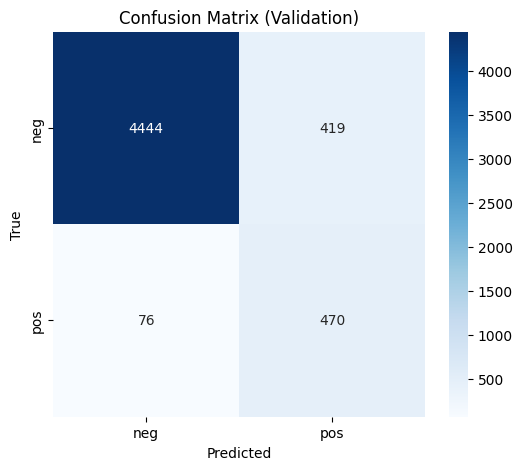

Test Evaluation:   0%|                                                       | 0/511 [00:00<?, ?it/s]

Test Evaluation:   0%|                                               | 1/511 [00:00<04:14,  2.01it/s]

Test Evaluation:   0%|▏                                              | 2/511 [00:00<04:10,  2.04it/s]

Test Evaluation:   1%|▎                                              | 3/511 [00:01<04:08,  2.05it/s]

Test Evaluation:   1%|▎                                              | 4/511 [00:01<04:07,  2.04it/s]

Test Evaluation:   1%|▍                                              | 5/511 [00:02<04:08,  2.04it/s]

Test Evaluation:   1%|▌                                              | 6/511 [00:02<04:00,  2.10it/s]

Test Evaluation:   1%|▋                                              | 7/511 [00:03<04:00,  2.09it/s]

Test Evaluation:   2%|▋                                              | 8/511 [00:03<04:03,  2.06it/s]

Test Evaluation:   2%|▊                                              | 9/511 [00:04<04:02,  2.07it/s]

Test Evaluation:   2%|▉                                             | 10/511 [00:04<03:55,  2.13it/s]

Test Evaluation:   2%|▉                                             | 11/511 [00:05<04:00,  2.08it/s]

Test Evaluation:   2%|█                                             | 12/511 [00:05<04:00,  2.07it/s]

Test Evaluation:   3%|█▏                                            | 13/511 [00:06<03:59,  2.08it/s]

Test Evaluation:   3%|█▎                                            | 14/511 [00:06<03:58,  2.08it/s]

Test Evaluation:   3%|█▎                                            | 15/511 [00:07<03:53,  2.13it/s]

Test Evaluation:   3%|█▍                                            | 16/511 [00:07<03:55,  2.10it/s]

Test Evaluation:   3%|█▌                                            | 17/511 [00:08<03:56,  2.09it/s]

Test Evaluation:   4%|█▌                                            | 18/511 [00:08<03:56,  2.08it/s]

Test Evaluation:   4%|█▋                                            | 19/511 [00:09<03:56,  2.08it/s]

Test Evaluation:   4%|█▊                                            | 20/511 [00:09<03:53,  2.10it/s]

Test Evaluation:   4%|█▉                                            | 21/511 [00:10<03:48,  2.15it/s]

Test Evaluation:   4%|█▉                                            | 22/511 [00:10<03:52,  2.10it/s]

Test Evaluation:   5%|██                                            | 23/511 [00:11<03:53,  2.09it/s]

Test Evaluation:   5%|██▏                                           | 24/511 [00:11<03:49,  2.12it/s]

Test Evaluation:   5%|██▎                                           | 25/511 [00:11<03:49,  2.12it/s]

Test Evaluation:   5%|██▎                                           | 26/511 [00:12<03:52,  2.09it/s]

Test Evaluation:   5%|██▍                                           | 27/511 [00:12<03:53,  2.07it/s]

Test Evaluation:   5%|██▌                                           | 28/511 [00:13<03:47,  2.12it/s]

Test Evaluation:   6%|██▌                                           | 29/511 [00:13<03:49,  2.10it/s]

Test Evaluation:   6%|██▋                                           | 30/511 [00:14<03:51,  2.08it/s]

Test Evaluation:   6%|██▊                                           | 31/511 [00:14<03:53,  2.05it/s]

Test Evaluation:   6%|██▉                                           | 32/511 [00:15<03:44,  2.13it/s]

Test Evaluation:   6%|██▉                                           | 33/511 [00:15<03:46,  2.11it/s]

Test Evaluation:   7%|███                                           | 34/511 [00:16<03:47,  2.10it/s]

Test Evaluation:   7%|███▏                                          | 35/511 [00:16<03:46,  2.10it/s]

Test Evaluation:   7%|███▏                                          | 36/511 [00:17<03:47,  2.09it/s]

Test Evaluation:   7%|███▎                                          | 37/511 [00:17<03:39,  2.16it/s]

Test Evaluation:   7%|███▍                                          | 38/511 [00:18<03:41,  2.13it/s]

Test Evaluation:   8%|███▌                                          | 39/511 [00:18<03:44,  2.11it/s]

Test Evaluation:   8%|███▌                                          | 40/511 [00:19<03:48,  2.06it/s]

Test Evaluation:   8%|███▋                                          | 41/511 [00:19<03:40,  2.13it/s]

Test Evaluation:   8%|███▊                                          | 42/511 [00:20<03:43,  2.10it/s]

Test Evaluation:   8%|███▊                                          | 43/511 [00:20<03:43,  2.09it/s]

Test Evaluation:   9%|███▉                                          | 44/511 [00:21<03:43,  2.09it/s]

Test Evaluation:   9%|████                                          | 45/511 [00:21<03:44,  2.08it/s]

Test Evaluation:   9%|████▏                                         | 46/511 [00:21<03:41,  2.10it/s]

Test Evaluation:   9%|████▏                                         | 47/511 [00:22<03:37,  2.13it/s]

Test Evaluation:   9%|████▎                                         | 48/511 [00:22<03:38,  2.12it/s]

Test Evaluation:  10%|████▍                                         | 49/511 [00:23<03:41,  2.09it/s]

Test Evaluation:  10%|████▌                                         | 50/511 [00:23<03:42,  2.07it/s]

Test Evaluation:  10%|████▌                                         | 51/511 [00:24<03:42,  2.06it/s]

Test Evaluation:  10%|████▋                                         | 52/511 [00:24<03:42,  2.06it/s]

Test Evaluation:  10%|████▊                                         | 53/511 [00:25<03:35,  2.12it/s]

Test Evaluation:  11%|████▊                                         | 54/511 [00:25<03:36,  2.11it/s]

Test Evaluation:  11%|████▉                                         | 55/511 [00:26<03:38,  2.09it/s]

Test Evaluation:  11%|█████                                         | 56/511 [00:26<03:39,  2.07it/s]

Test Evaluation:  11%|█████▏                                        | 57/511 [00:27<03:38,  2.07it/s]

Test Evaluation:  11%|█████▏                                        | 58/511 [00:27<03:39,  2.06it/s]

Test Evaluation:  12%|█████▎                                        | 59/511 [00:28<03:33,  2.11it/s]

Test Evaluation:  12%|█████▍                                        | 60/511 [00:28<03:35,  2.09it/s]

Test Evaluation:  12%|█████▍                                        | 61/511 [00:29<03:37,  2.07it/s]

Test Evaluation:  12%|█████▌                                        | 62/511 [00:29<03:36,  2.08it/s]

Test Evaluation:  12%|█████▋                                        | 63/511 [00:30<03:37,  2.06it/s]

Test Evaluation:  13%|█████▊                                        | 64/511 [00:30<03:35,  2.07it/s]

Test Evaluation:  13%|█████▊                                        | 65/511 [00:31<03:35,  2.07it/s]

Test Evaluation:  13%|█████▉                                        | 66/511 [00:31<03:36,  2.06it/s]

Test Evaluation:  13%|██████                                        | 67/511 [00:32<03:34,  2.07it/s]

Test Evaluation:  13%|██████                                        | 68/511 [00:32<03:34,  2.06it/s]

Test Evaluation:  14%|██████▏                                       | 69/511 [00:33<03:34,  2.06it/s]

Test Evaluation:  14%|██████▎                                       | 70/511 [00:33<03:33,  2.06it/s]

Test Evaluation:  14%|██████▍                                       | 71/511 [00:33<03:32,  2.07it/s]

Test Evaluation:  14%|██████▍                                       | 72/511 [00:34<03:32,  2.07it/s]

Test Evaluation:  14%|██████▌                                       | 73/511 [00:34<03:31,  2.07it/s]

Test Evaluation:  14%|██████▋                                       | 74/511 [00:35<03:31,  2.06it/s]

Test Evaluation:  15%|██████▊                                       | 75/511 [00:35<03:31,  2.06it/s]

Test Evaluation:  15%|██████▊                                       | 76/511 [00:36<03:31,  2.06it/s]

Test Evaluation:  15%|██████▉                                       | 77/511 [00:36<03:31,  2.06it/s]

Test Evaluation:  15%|███████                                       | 78/511 [00:37<03:30,  2.05it/s]

Test Evaluation:  15%|███████                                       | 79/511 [00:37<03:30,  2.05it/s]

Test Evaluation:  16%|███████▏                                      | 80/511 [00:38<03:29,  2.05it/s]

Test Evaluation:  16%|███████▎                                      | 81/511 [00:38<03:29,  2.05it/s]

Test Evaluation:  16%|███████▍                                      | 82/511 [00:39<03:28,  2.06it/s]

Test Evaluation:  16%|███████▍                                      | 83/511 [00:39<03:27,  2.06it/s]

Test Evaluation:  16%|███████▌                                      | 84/511 [00:40<03:28,  2.05it/s]

Test Evaluation:  17%|███████▋                                      | 85/511 [00:40<03:27,  2.05it/s]

Test Evaluation:  17%|███████▋                                      | 86/511 [00:41<03:27,  2.05it/s]

Test Evaluation:  17%|███████▊                                      | 87/511 [00:41<03:25,  2.06it/s]

Test Evaluation:  17%|███████▉                                      | 88/511 [00:42<03:24,  2.07it/s]

Test Evaluation:  17%|████████                                      | 89/511 [00:42<03:25,  2.06it/s]

Test Evaluation:  18%|████████                                      | 90/511 [00:43<03:26,  2.04it/s]

Test Evaluation:  18%|████████▏                                     | 91/511 [00:43<03:24,  2.06it/s]

Test Evaluation:  18%|████████▎                                     | 92/511 [00:44<03:22,  2.07it/s]

Test Evaluation:  18%|████████▎                                     | 93/511 [00:44<03:22,  2.06it/s]

Test Evaluation:  18%|████████▍                                     | 94/511 [00:45<03:23,  2.05it/s]

Test Evaluation:  19%|████████▌                                     | 95/511 [00:45<03:21,  2.07it/s]

Test Evaluation:  19%|████████▋                                     | 96/511 [00:46<03:21,  2.06it/s]

Test Evaluation:  19%|████████▋                                     | 97/511 [00:46<03:20,  2.07it/s]

Test Evaluation:  19%|████████▊                                     | 98/511 [00:47<03:20,  2.06it/s]

Test Evaluation:  19%|████████▉                                     | 99/511 [00:47<03:20,  2.06it/s]

Test Evaluation:  20%|████████▊                                    | 100/511 [00:48<03:14,  2.12it/s]

Test Evaluation:  20%|████████▉                                    | 101/511 [00:48<03:14,  2.11it/s]

Test Evaluation:  20%|████████▉                                    | 102/511 [00:49<03:17,  2.07it/s]

Test Evaluation:  20%|█████████                                    | 103/511 [00:49<03:17,  2.07it/s]

Test Evaluation:  20%|█████████▏                                   | 104/511 [00:50<03:17,  2.06it/s]

Test Evaluation:  21%|█████████▏                                   | 105/511 [00:50<03:16,  2.06it/s]

Test Evaluation:  21%|█████████▎                                   | 106/511 [00:50<03:17,  2.06it/s]

Test Evaluation:  21%|█████████▍                                   | 107/511 [00:51<03:15,  2.06it/s]

Test Evaluation:  21%|█████████▌                                   | 108/511 [00:51<03:14,  2.08it/s]

Test Evaluation:  21%|█████████▌                                   | 109/511 [00:52<03:13,  2.08it/s]

Test Evaluation:  22%|█████████▋                                   | 110/511 [00:52<03:13,  2.07it/s]

Test Evaluation:  22%|█████████▊                                   | 111/511 [00:53<03:14,  2.06it/s]

Test Evaluation:  22%|█████████▊                                   | 112/511 [00:53<03:13,  2.06it/s]

Test Evaluation:  22%|█████████▉                                   | 113/511 [00:54<03:13,  2.06it/s]

Test Evaluation:  22%|██████████                                   | 114/511 [00:54<03:12,  2.07it/s]

Test Evaluation:  23%|██████████▏                                  | 115/511 [00:55<03:12,  2.06it/s]

Test Evaluation:  23%|██████████▏                                  | 116/511 [00:55<03:11,  2.06it/s]

Test Evaluation:  23%|██████████▎                                  | 117/511 [00:56<03:12,  2.05it/s]

Test Evaluation:  23%|██████████▍                                  | 118/511 [00:56<03:11,  2.06it/s]

Test Evaluation:  23%|██████████▍                                  | 119/511 [00:57<03:03,  2.13it/s]

Test Evaluation:  23%|██████████▌                                  | 120/511 [00:57<03:04,  2.11it/s]

Test Evaluation:  24%|██████████▋                                  | 121/511 [00:58<03:05,  2.10it/s]

Test Evaluation:  24%|██████████▋                                  | 122/511 [00:58<03:06,  2.09it/s]

Test Evaluation:  24%|██████████▊                                  | 123/511 [00:59<03:06,  2.08it/s]

Test Evaluation:  24%|██████████▉                                  | 124/511 [00:59<03:06,  2.07it/s]

Test Evaluation:  24%|███████████                                  | 125/511 [01:00<03:06,  2.07it/s]

Test Evaluation:  25%|███████████                                  | 126/511 [01:00<03:08,  2.04it/s]

Test Evaluation:  25%|███████████▏                                 | 127/511 [01:01<03:07,  2.05it/s]

Test Evaluation:  25%|███████████▎                                 | 128/511 [01:01<03:06,  2.06it/s]

Test Evaluation:  25%|███████████▎                                 | 129/511 [01:02<03:06,  2.05it/s]

Test Evaluation:  25%|███████████▍                                 | 130/511 [01:02<03:05,  2.05it/s]

Test Evaluation:  26%|███████████▌                                 | 131/511 [01:03<03:04,  2.06it/s]

Test Evaluation:  26%|███████████▌                                 | 132/511 [01:03<03:03,  2.06it/s]

Test Evaluation:  26%|███████████▋                                 | 133/511 [01:04<03:02,  2.07it/s]

Test Evaluation:  26%|███████████▊                                 | 134/511 [01:04<03:02,  2.06it/s]

Test Evaluation:  26%|███████████▉                                 | 135/511 [01:05<03:03,  2.05it/s]

Test Evaluation:  27%|███████████▉                                 | 136/511 [01:05<03:02,  2.06it/s]

Test Evaluation:  27%|████████████                                 | 137/511 [01:05<03:01,  2.06it/s]

Test Evaluation:  27%|████████████▏                                | 138/511 [01:06<03:03,  2.04it/s]

Test Evaluation:  27%|████████████▏                                | 139/511 [01:06<03:02,  2.04it/s]

Test Evaluation:  27%|████████████▎                                | 140/511 [01:07<03:00,  2.05it/s]

Test Evaluation:  28%|████████████▍                                | 141/511 [01:07<02:59,  2.07it/s]

Test Evaluation:  28%|████████████▌                                | 142/511 [01:08<02:58,  2.06it/s]

Test Evaluation:  28%|████████████▌                                | 143/511 [01:08<02:58,  2.07it/s]

Test Evaluation:  28%|████████████▋                                | 144/511 [01:09<02:56,  2.08it/s]

Test Evaluation:  28%|████████████▊                                | 145/511 [01:09<02:55,  2.08it/s]

Test Evaluation:  29%|████████████▊                                | 146/511 [01:10<02:55,  2.08it/s]

Test Evaluation:  29%|████████████▉                                | 147/511 [01:10<02:55,  2.07it/s]

Test Evaluation:  29%|█████████████                                | 148/511 [01:11<02:54,  2.08it/s]

Test Evaluation:  29%|█████████████                                | 149/511 [01:11<02:53,  2.08it/s]

Test Evaluation:  29%|█████████████▏                               | 150/511 [01:12<02:54,  2.07it/s]

Test Evaluation:  30%|█████████████▎                               | 151/511 [01:12<02:54,  2.07it/s]

Test Evaluation:  30%|█████████████▍                               | 152/511 [01:13<02:54,  2.06it/s]

Test Evaluation:  30%|█████████████▍                               | 153/511 [01:13<02:53,  2.06it/s]

Test Evaluation:  30%|█████████████▌                               | 154/511 [01:14<02:52,  2.07it/s]

Test Evaluation:  30%|█████████████▋                               | 155/511 [01:14<02:53,  2.05it/s]

Test Evaluation:  31%|█████████████▋                               | 156/511 [01:15<02:54,  2.04it/s]

Test Evaluation:  31%|█████████████▊                               | 157/511 [01:15<02:52,  2.05it/s]

Test Evaluation:  31%|█████████████▉                               | 158/511 [01:16<02:52,  2.05it/s]

Test Evaluation:  31%|██████████████                               | 159/511 [01:16<02:45,  2.13it/s]

Test Evaluation:  31%|██████████████                               | 160/511 [01:17<02:46,  2.10it/s]

Test Evaluation:  32%|██████████████▏                              | 161/511 [01:17<02:47,  2.09it/s]

Test Evaluation:  32%|██████████████▎                              | 162/511 [01:18<02:48,  2.07it/s]

Test Evaluation:  32%|██████████████▎                              | 163/511 [01:18<02:48,  2.07it/s]

Test Evaluation:  32%|██████████████▍                              | 164/511 [01:19<02:47,  2.08it/s]

Test Evaluation:  32%|██████████████▌                              | 165/511 [01:19<02:46,  2.07it/s]

Test Evaluation:  32%|██████████████▌                              | 166/511 [01:19<02:45,  2.08it/s]

Test Evaluation:  33%|██████████████▋                              | 167/511 [01:20<02:44,  2.10it/s]

Test Evaluation:  33%|██████████████▊                              | 168/511 [01:20<02:42,  2.10it/s]

Test Evaluation:  33%|██████████████▉                              | 169/511 [01:21<02:42,  2.11it/s]

Test Evaluation:  33%|██████████████▉                              | 170/511 [01:21<02:41,  2.11it/s]

Test Evaluation:  33%|███████████████                              | 171/511 [01:22<02:42,  2.09it/s]

Test Evaluation:  34%|███████████████▏                             | 172/511 [01:22<02:43,  2.08it/s]

Test Evaluation:  34%|███████████████▏                             | 173/511 [01:23<02:42,  2.08it/s]

Test Evaluation:  34%|███████████████▎                             | 174/511 [01:23<02:42,  2.07it/s]

Test Evaluation:  34%|███████████████▍                             | 175/511 [01:24<02:42,  2.07it/s]

Test Evaluation:  34%|███████████████▍                             | 176/511 [01:24<02:42,  2.07it/s]

Test Evaluation:  35%|███████████████▌                             | 177/511 [01:25<02:39,  2.09it/s]

Test Evaluation:  35%|███████████████▋                             | 178/511 [01:25<02:36,  2.12it/s]

Test Evaluation:  35%|███████████████▊                             | 179/511 [01:26<02:38,  2.10it/s]

Test Evaluation:  35%|███████████████▊                             | 180/511 [01:26<02:39,  2.08it/s]

Test Evaluation:  35%|███████████████▉                             | 181/511 [01:27<02:39,  2.07it/s]

Test Evaluation:  36%|████████████████                             | 182/511 [01:27<02:39,  2.06it/s]

Test Evaluation:  36%|████████████████                             | 183/511 [01:28<02:39,  2.06it/s]

Test Evaluation:  36%|████████████████▏                            | 184/511 [01:28<02:38,  2.06it/s]

Test Evaluation:  36%|████████████████▎                            | 185/511 [01:29<02:38,  2.06it/s]

Test Evaluation:  36%|████████████████▍                            | 186/511 [01:29<02:38,  2.05it/s]

Test Evaluation:  37%|████████████████▍                            | 187/511 [01:30<02:38,  2.05it/s]

Test Evaluation:  37%|████████████████▌                            | 188/511 [01:30<02:37,  2.05it/s]

Test Evaluation:  37%|████████████████▋                            | 189/511 [01:31<02:36,  2.06it/s]

Test Evaluation:  37%|████████████████▋                            | 190/511 [01:31<02:38,  2.03it/s]

Test Evaluation:  37%|████████████████▊                            | 191/511 [01:32<02:36,  2.04it/s]

Test Evaluation:  38%|████████████████▉                            | 192/511 [01:32<02:35,  2.05it/s]

Test Evaluation:  38%|████████████████▉                            | 193/511 [01:33<02:35,  2.04it/s]

Test Evaluation:  38%|█████████████████                            | 194/511 [01:33<02:34,  2.05it/s]

Test Evaluation:  38%|█████████████████▏                           | 195/511 [01:34<02:34,  2.05it/s]

Test Evaluation:  38%|█████████████████▎                           | 196/511 [01:34<02:33,  2.05it/s]

Test Evaluation:  39%|█████████████████▎                           | 197/511 [01:34<02:33,  2.05it/s]

Test Evaluation:  39%|█████████████████▍                           | 198/511 [01:35<02:32,  2.05it/s]

Test Evaluation:  39%|█████████████████▌                           | 199/511 [01:35<02:32,  2.05it/s]

Test Evaluation:  39%|█████████████████▌                           | 200/511 [01:36<02:31,  2.05it/s]

Test Evaluation:  39%|█████████████████▋                           | 201/511 [01:36<02:31,  2.05it/s]

Test Evaluation:  40%|█████████████████▊                           | 202/511 [01:37<02:30,  2.05it/s]

Test Evaluation:  40%|█████████████████▉                           | 203/511 [01:37<02:30,  2.05it/s]

Test Evaluation:  40%|█████████████████▉                           | 204/511 [01:38<02:29,  2.06it/s]

Test Evaluation:  40%|██████████████████                           | 205/511 [01:38<02:28,  2.06it/s]

Test Evaluation:  40%|██████████████████▏                          | 206/511 [01:39<02:27,  2.07it/s]

Test Evaluation:  41%|██████████████████▏                          | 207/511 [01:39<02:22,  2.13it/s]

Test Evaluation:  41%|██████████████████▎                          | 208/511 [01:40<02:23,  2.11it/s]

Test Evaluation:  41%|██████████████████▍                          | 209/511 [01:40<02:23,  2.10it/s]

Test Evaluation:  41%|██████████████████▍                          | 210/511 [01:41<02:24,  2.09it/s]

Test Evaluation:  41%|██████████████████▌                          | 211/511 [01:41<02:24,  2.08it/s]

Test Evaluation:  41%|██████████████████▋                          | 212/511 [01:42<02:25,  2.06it/s]

Test Evaluation:  42%|██████████████████▊                          | 213/511 [01:42<02:24,  2.06it/s]

Test Evaluation:  42%|██████████████████▊                          | 214/511 [01:43<02:24,  2.06it/s]

Test Evaluation:  42%|██████████████████▉                          | 215/511 [01:43<02:23,  2.07it/s]

Test Evaluation:  42%|███████████████████                          | 216/511 [01:44<02:23,  2.06it/s]

Test Evaluation:  42%|███████████████████                          | 217/511 [01:44<02:23,  2.04it/s]

Test Evaluation:  43%|███████████████████▏                         | 218/511 [01:45<02:24,  2.03it/s]

Test Evaluation:  43%|███████████████████▎                         | 219/511 [01:45<02:23,  2.04it/s]

Test Evaluation:  43%|███████████████████▎                         | 220/511 [01:46<02:21,  2.05it/s]

Test Evaluation:  43%|███████████████████▍                         | 221/511 [01:46<02:20,  2.06it/s]

Test Evaluation:  43%|███████████████████▌                         | 222/511 [01:47<02:20,  2.05it/s]

Test Evaluation:  44%|███████████████████▋                         | 223/511 [01:47<02:20,  2.05it/s]

Test Evaluation:  44%|███████████████████▋                         | 224/511 [01:48<02:18,  2.07it/s]

Test Evaluation:  44%|███████████████████▊                         | 225/511 [01:48<02:17,  2.08it/s]

Test Evaluation:  44%|███████████████████▉                         | 226/511 [01:49<02:16,  2.09it/s]

Test Evaluation:  44%|███████████████████▉                         | 227/511 [01:49<02:16,  2.08it/s]

Test Evaluation:  45%|████████████████████                         | 228/511 [01:49<02:16,  2.07it/s]

Test Evaluation:  45%|████████████████████▏                        | 229/511 [01:50<02:16,  2.07it/s]

Test Evaluation:  45%|████████████████████▎                        | 230/511 [01:50<02:15,  2.08it/s]

Test Evaluation:  45%|████████████████████▎                        | 231/511 [01:51<02:14,  2.08it/s]

Test Evaluation:  45%|████████████████████▍                        | 232/511 [01:51<02:15,  2.06it/s]

Test Evaluation:  46%|████████████████████▌                        | 233/511 [01:52<02:14,  2.06it/s]

Test Evaluation:  46%|████████████████████▌                        | 234/511 [01:52<02:14,  2.06it/s]

Test Evaluation:  46%|████████████████████▋                        | 235/511 [01:53<02:13,  2.07it/s]

Test Evaluation:  46%|████████████████████▊                        | 236/511 [01:53<02:12,  2.07it/s]

Test Evaluation:  46%|████████████████████▊                        | 237/511 [01:54<02:12,  2.07it/s]

Test Evaluation:  47%|████████████████████▉                        | 238/511 [01:54<02:12,  2.06it/s]

Test Evaluation:  47%|█████████████████████                        | 239/511 [01:55<02:11,  2.06it/s]

Test Evaluation:  47%|█████████████████████▏                       | 240/511 [01:55<02:11,  2.07it/s]

Test Evaluation:  47%|█████████████████████▏                       | 241/511 [01:56<02:10,  2.07it/s]

Test Evaluation:  47%|█████████████████████▎                       | 242/511 [01:56<02:10,  2.06it/s]

Test Evaluation:  48%|█████████████████████▍                       | 243/511 [01:57<02:10,  2.06it/s]

Test Evaluation:  48%|█████████████████████▍                       | 244/511 [01:57<02:09,  2.06it/s]

Test Evaluation:  48%|█████████████████████▌                       | 245/511 [01:58<02:07,  2.08it/s]

Test Evaluation:  48%|█████████████████████▋                       | 246/511 [01:58<02:04,  2.13it/s]

Test Evaluation:  48%|█████████████████████▊                       | 247/511 [01:59<02:05,  2.11it/s]

Test Evaluation:  49%|█████████████████████▊                       | 248/511 [01:59<02:05,  2.10it/s]

Test Evaluation:  49%|█████████████████████▉                       | 249/511 [02:00<02:05,  2.08it/s]

Test Evaluation:  49%|██████████████████████                       | 250/511 [02:00<02:04,  2.09it/s]

Test Evaluation:  49%|██████████████████████                       | 251/511 [02:01<02:04,  2.09it/s]

Test Evaluation:  49%|██████████████████████▏                      | 252/511 [02:01<02:03,  2.09it/s]

Test Evaluation:  50%|██████████████████████▎                      | 253/511 [02:02<02:03,  2.09it/s]

Test Evaluation:  50%|██████████████████████▎                      | 254/511 [02:02<02:03,  2.07it/s]

Test Evaluation:  50%|██████████████████████▍                      | 255/511 [02:02<02:03,  2.07it/s]

Test Evaluation:  50%|██████████████████████▌                      | 256/511 [02:03<02:03,  2.07it/s]

Test Evaluation:  50%|██████████████████████▋                      | 257/511 [02:03<02:02,  2.07it/s]

Test Evaluation:  50%|██████████████████████▋                      | 258/511 [02:04<02:02,  2.06it/s]

Test Evaluation:  51%|██████████████████████▊                      | 259/511 [02:04<02:01,  2.07it/s]

Test Evaluation:  51%|██████████████████████▉                      | 260/511 [02:05<02:01,  2.06it/s]

Test Evaluation:  51%|██████████████████████▉                      | 261/511 [02:05<02:01,  2.06it/s]

Test Evaluation:  51%|███████████████████████                      | 262/511 [02:06<02:00,  2.07it/s]

Test Evaluation:  51%|███████████████████████▏                     | 263/511 [02:06<02:00,  2.06it/s]

Test Evaluation:  52%|███████████████████████▏                     | 264/511 [02:07<01:59,  2.06it/s]

Test Evaluation:  52%|███████████████████████▎                     | 265/511 [02:07<01:59,  2.05it/s]

Test Evaluation:  52%|███████████████████████▍                     | 266/511 [02:08<01:59,  2.06it/s]

Test Evaluation:  52%|███████████████████████▌                     | 267/511 [02:08<01:58,  2.06it/s]

Test Evaluation:  52%|███████████████████████▌                     | 268/511 [02:09<01:57,  2.08it/s]

Test Evaluation:  53%|███████████████████████▋                     | 269/511 [02:09<01:56,  2.08it/s]

Test Evaluation:  53%|███████████████████████▊                     | 270/511 [02:10<01:56,  2.07it/s]

Test Evaluation:  53%|███████████████████████▊                     | 271/511 [02:10<01:55,  2.07it/s]

Test Evaluation:  53%|███████████████████████▉                     | 272/511 [02:11<01:55,  2.07it/s]

Test Evaluation:  53%|████████████████████████                     | 273/511 [02:11<01:55,  2.07it/s]

Test Evaluation:  54%|████████████████████████▏                    | 274/511 [02:12<01:50,  2.14it/s]

Test Evaluation:  54%|████████████████████████▏                    | 275/511 [02:12<01:52,  2.11it/s]

Test Evaluation:  54%|████████████████████████▎                    | 276/511 [02:13<01:51,  2.10it/s]

Test Evaluation:  54%|████████████████████████▍                    | 277/511 [02:13<01:51,  2.10it/s]

Test Evaluation:  54%|████████████████████████▍                    | 278/511 [02:14<01:50,  2.11it/s]

Test Evaluation:  55%|████████████████████████▌                    | 279/511 [02:14<01:51,  2.09it/s]

Test Evaluation:  55%|████████████████████████▋                    | 280/511 [02:15<01:53,  2.04it/s]

Test Evaluation:  55%|████████████████████████▋                    | 281/511 [02:15<01:51,  2.06it/s]

Test Evaluation:  55%|████████████████████████▊                    | 282/511 [02:16<01:50,  2.06it/s]

Test Evaluation:  55%|████████████████████████▉                    | 283/511 [02:16<01:49,  2.07it/s]

Test Evaluation:  56%|█████████████████████████                    | 284/511 [02:16<01:49,  2.07it/s]

Test Evaluation:  56%|█████████████████████████                    | 285/511 [02:17<01:48,  2.08it/s]

Test Evaluation:  56%|█████████████████████████▏                   | 286/511 [02:17<01:49,  2.06it/s]

Test Evaluation:  56%|█████████████████████████▎                   | 287/511 [02:18<01:48,  2.07it/s]

Test Evaluation:  56%|█████████████████████████▎                   | 288/511 [02:18<01:47,  2.07it/s]

Test Evaluation:  57%|█████████████████████████▍                   | 289/511 [02:19<01:46,  2.08it/s]

Test Evaluation:  57%|█████████████████████████▌                   | 290/511 [02:19<01:47,  2.06it/s]

Test Evaluation:  57%|█████████████████████████▋                   | 291/511 [02:20<01:46,  2.06it/s]

Test Evaluation:  57%|█████████████████████████▋                   | 292/511 [02:20<01:45,  2.07it/s]

Test Evaluation:  57%|█████████████████████████▊                   | 293/511 [02:21<01:45,  2.06it/s]

Test Evaluation:  58%|█████████████████████████▉                   | 294/511 [02:21<01:44,  2.08it/s]

Test Evaluation:  58%|█████████████████████████▉                   | 295/511 [02:22<01:44,  2.06it/s]

Test Evaluation:  58%|██████████████████████████                   | 296/511 [02:22<01:46,  2.01it/s]

Test Evaluation:  58%|██████████████████████████▏                  | 297/511 [02:23<01:44,  2.05it/s]

Test Evaluation:  58%|██████████████████████████▏                  | 298/511 [02:23<01:43,  2.06it/s]

Test Evaluation:  59%|██████████████████████████▎                  | 299/511 [02:24<01:42,  2.07it/s]

Test Evaluation:  59%|██████████████████████████▍                  | 300/511 [02:24<01:42,  2.06it/s]

Test Evaluation:  59%|██████████████████████████▌                  | 301/511 [02:25<01:42,  2.05it/s]

Test Evaluation:  59%|██████████████████████████▌                  | 302/511 [02:25<01:41,  2.05it/s]

Test Evaluation:  59%|██████████████████████████▋                  | 303/511 [02:26<01:41,  2.05it/s]

Test Evaluation:  59%|██████████████████████████▊                  | 304/511 [02:26<01:41,  2.04it/s]

Test Evaluation:  60%|██████████████████████████▊                  | 305/511 [02:27<01:40,  2.05it/s]

Test Evaluation:  60%|██████████████████████████▉                  | 306/511 [02:27<01:39,  2.05it/s]

Test Evaluation:  60%|███████████████████████████                  | 307/511 [02:28<01:39,  2.04it/s]

Test Evaluation:  60%|███████████████████████████                  | 308/511 [02:28<01:39,  2.05it/s]

Test Evaluation:  60%|███████████████████████████▏                 | 309/511 [02:29<01:37,  2.06it/s]

Test Evaluation:  61%|███████████████████████████▎                 | 310/511 [02:29<01:37,  2.06it/s]

Test Evaluation:  61%|███████████████████████████▍                 | 311/511 [02:30<01:34,  2.11it/s]

Test Evaluation:  61%|███████████████████████████▍                 | 312/511 [02:30<01:34,  2.11it/s]

Test Evaluation:  61%|███████████████████████████▌                 | 313/511 [02:31<01:35,  2.08it/s]

Test Evaluation:  61%|███████████████████████████▋                 | 314/511 [02:31<01:34,  2.08it/s]

Test Evaluation:  62%|███████████████████████████▋                 | 315/511 [02:32<01:35,  2.06it/s]

Test Evaluation:  62%|███████████████████████████▊                 | 316/511 [02:32<01:34,  2.05it/s]

Test Evaluation:  62%|███████████████████████████▉                 | 317/511 [02:33<01:35,  2.03it/s]

Test Evaluation:  62%|████████████████████████████                 | 318/511 [02:33<01:34,  2.04it/s]

Test Evaluation:  62%|████████████████████████████                 | 319/511 [02:33<01:33,  2.05it/s]

Test Evaluation:  63%|████████████████████████████▏                | 320/511 [02:34<01:33,  2.04it/s]

Test Evaluation:  63%|████████████████████████████▎                | 321/511 [02:34<01:33,  2.04it/s]

Test Evaluation:  63%|████████████████████████████▎                | 322/511 [02:35<01:32,  2.04it/s]

Test Evaluation:  63%|████████████████████████████▍                | 323/511 [02:35<01:32,  2.04it/s]

Test Evaluation:  63%|████████████████████████████▌                | 324/511 [02:36<01:31,  2.03it/s]

Test Evaluation:  64%|████████████████████████████▌                | 325/511 [02:36<01:31,  2.04it/s]

Test Evaluation:  64%|████████████████████████████▋                | 326/511 [02:37<01:29,  2.06it/s]

Test Evaluation:  64%|████████████████████████████▊                | 327/511 [02:37<01:29,  2.06it/s]

Test Evaluation:  64%|████████████████████████████▉                | 328/511 [02:38<01:29,  2.05it/s]

Test Evaluation:  64%|████████████████████████████▉                | 329/511 [02:38<01:28,  2.05it/s]

Test Evaluation:  65%|█████████████████████████████                | 330/511 [02:39<01:28,  2.05it/s]

Test Evaluation:  65%|█████████████████████████████▏               | 331/511 [02:39<01:27,  2.07it/s]

Test Evaluation:  65%|█████████████████████████████▏               | 332/511 [02:40<01:26,  2.07it/s]

Test Evaluation:  65%|█████████████████████████████▎               | 333/511 [02:40<01:25,  2.07it/s]

Test Evaluation:  65%|█████████████████████████████▍               | 334/511 [02:41<01:25,  2.07it/s]

Test Evaluation:  66%|█████████████████████████████▌               | 335/511 [02:41<01:25,  2.06it/s]

Test Evaluation:  66%|█████████████████████████████▌               | 336/511 [02:42<01:24,  2.07it/s]

Test Evaluation:  66%|█████████████████████████████▋               | 337/511 [02:42<01:24,  2.07it/s]

Test Evaluation:  66%|█████████████████████████████▊               | 338/511 [02:43<01:23,  2.06it/s]

Test Evaluation:  66%|█████████████████████████████▊               | 339/511 [02:43<01:20,  2.14it/s]

Test Evaluation:  67%|█████████████████████████████▉               | 340/511 [02:44<01:21,  2.11it/s]

Test Evaluation:  67%|██████████████████████████████               | 341/511 [02:44<01:21,  2.09it/s]

Test Evaluation:  67%|██████████████████████████████               | 342/511 [02:45<01:21,  2.08it/s]

Test Evaluation:  67%|██████████████████████████████▏              | 343/511 [02:45<01:21,  2.07it/s]

Test Evaluation:  67%|██████████████████████████████▎              | 344/511 [02:46<01:20,  2.07it/s]

Test Evaluation:  68%|██████████████████████████████▍              | 345/511 [02:46<01:20,  2.07it/s]

Test Evaluation:  68%|██████████████████████████████▍              | 346/511 [02:47<01:20,  2.05it/s]

Test Evaluation:  68%|██████████████████████████████▌              | 347/511 [02:47<01:19,  2.07it/s]

Test Evaluation:  68%|██████████████████████████████▋              | 348/511 [02:48<01:18,  2.07it/s]

Test Evaluation:  68%|██████████████████████████████▋              | 349/511 [02:48<01:18,  2.07it/s]

Test Evaluation:  68%|██████████████████████████████▊              | 350/511 [02:48<01:17,  2.06it/s]

Test Evaluation:  69%|██████████████████████████████▉              | 351/511 [02:49<01:17,  2.07it/s]

Test Evaluation:  69%|██████████████████████████████▉              | 352/511 [02:49<01:17,  2.06it/s]

Test Evaluation:  69%|███████████████████████████████              | 353/511 [02:50<01:16,  2.06it/s]

Test Evaluation:  69%|███████████████████████████████▏             | 354/511 [02:50<01:16,  2.06it/s]

Test Evaluation:  69%|███████████████████████████████▎             | 355/511 [02:51<01:15,  2.06it/s]

Test Evaluation:  70%|███████████████████████████████▎             | 356/511 [02:51<01:14,  2.07it/s]

Test Evaluation:  70%|███████████████████████████████▍             | 357/511 [02:52<01:14,  2.08it/s]

Test Evaluation:  70%|███████████████████████████████▌             | 358/511 [02:52<01:13,  2.07it/s]

Test Evaluation:  70%|███████████████████████████████▌             | 359/511 [02:53<01:13,  2.07it/s]

Test Evaluation:  70%|███████████████████████████████▋             | 360/511 [02:53<01:13,  2.06it/s]

Test Evaluation:  71%|███████████████████████████████▊             | 361/511 [02:54<01:13,  2.05it/s]

Test Evaluation:  71%|███████████████████████████████▉             | 362/511 [02:54<01:12,  2.05it/s]

Test Evaluation:  71%|███████████████████████████████▉             | 363/511 [02:55<01:11,  2.06it/s]

Test Evaluation:  71%|████████████████████████████████             | 364/511 [02:55<01:11,  2.06it/s]

Test Evaluation:  71%|████████████████████████████████▏            | 365/511 [02:56<01:09,  2.12it/s]

Test Evaluation:  72%|████████████████████████████████▏            | 366/511 [02:56<01:09,  2.10it/s]

Test Evaluation:  72%|████████████████████████████████▎            | 367/511 [02:57<01:09,  2.08it/s]

Test Evaluation:  72%|████████████████████████████████▍            | 368/511 [02:57<01:09,  2.05it/s]

Test Evaluation:  72%|████████████████████████████████▍            | 369/511 [02:58<01:09,  2.06it/s]

Test Evaluation:  72%|████████████████████████████████▌            | 370/511 [02:58<01:08,  2.06it/s]

Test Evaluation:  73%|████████████████████████████████▋            | 371/511 [02:59<01:07,  2.06it/s]

Test Evaluation:  73%|████████████████████████████████▊            | 372/511 [02:59<01:07,  2.07it/s]

Test Evaluation:  73%|████████████████████████████████▊            | 373/511 [03:00<01:06,  2.07it/s]

Test Evaluation:  73%|████████████████████████████████▉            | 374/511 [03:00<01:06,  2.07it/s]

Test Evaluation:  73%|█████████████████████████████████            | 375/511 [03:01<01:05,  2.06it/s]

Test Evaluation:  74%|█████████████████████████████████            | 376/511 [03:01<01:05,  2.07it/s]

Test Evaluation:  74%|█████████████████████████████████▏           | 377/511 [03:02<01:04,  2.07it/s]

Test Evaluation:  74%|█████████████████████████████████▎           | 378/511 [03:02<01:04,  2.08it/s]

Test Evaluation:  74%|█████████████████████████████████▍           | 379/511 [03:03<01:03,  2.07it/s]

Test Evaluation:  74%|█████████████████████████████████▍           | 380/511 [03:03<01:04,  2.04it/s]

Test Evaluation:  75%|█████████████████████████████████▌           | 381/511 [03:04<01:03,  2.04it/s]

Test Evaluation:  75%|█████████████████████████████████▋           | 382/511 [03:04<01:03,  2.02it/s]

Test Evaluation:  75%|█████████████████████████████████▋           | 383/511 [03:04<01:03,  2.03it/s]

Test Evaluation:  75%|█████████████████████████████████▊           | 384/511 [03:05<01:02,  2.04it/s]

Test Evaluation:  75%|█████████████████████████████████▉           | 385/511 [03:05<01:01,  2.04it/s]

Test Evaluation:  76%|█████████████████████████████████▉           | 386/511 [03:06<01:01,  2.05it/s]

Test Evaluation:  76%|██████████████████████████████████           | 387/511 [03:06<01:00,  2.05it/s]

Test Evaluation:  76%|██████████████████████████████████▏          | 388/511 [03:07<01:00,  2.05it/s]

Test Evaluation:  76%|██████████████████████████████████▎          | 389/511 [03:07<00:59,  2.05it/s]

Test Evaluation:  76%|██████████████████████████████████▎          | 390/511 [03:08<00:58,  2.05it/s]

Test Evaluation:  77%|██████████████████████████████████▍          | 391/511 [03:08<00:58,  2.05it/s]

Test Evaluation:  77%|██████████████████████████████████▌          | 392/511 [03:09<00:58,  2.04it/s]

Test Evaluation:  77%|██████████████████████████████████▌          | 393/511 [03:09<00:57,  2.04it/s]

Test Evaluation:  77%|██████████████████████████████████▋          | 394/511 [03:10<00:57,  2.05it/s]

Test Evaluation:  77%|██████████████████████████████████▊          | 395/511 [03:10<00:56,  2.05it/s]

Test Evaluation:  77%|██████████████████████████████████▊          | 396/511 [03:11<00:56,  2.05it/s]

Test Evaluation:  78%|██████████████████████████████████▉          | 397/511 [03:11<00:55,  2.06it/s]

Test Evaluation:  78%|███████████████████████████████████          | 398/511 [03:12<00:55,  2.05it/s]

Test Evaluation:  78%|███████████████████████████████████▏         | 399/511 [03:12<00:54,  2.05it/s]

Test Evaluation:  78%|███████████████████████████████████▏         | 400/511 [03:13<00:54,  2.05it/s]

Test Evaluation:  78%|███████████████████████████████████▎         | 401/511 [03:13<00:53,  2.05it/s]

Test Evaluation:  79%|███████████████████████████████████▍         | 402/511 [03:14<00:53,  2.06it/s]

Test Evaluation:  79%|███████████████████████████████████▍         | 403/511 [03:14<00:52,  2.06it/s]

Test Evaluation:  79%|███████████████████████████████████▌         | 404/511 [03:15<00:51,  2.06it/s]

Test Evaluation:  79%|███████████████████████████████████▋         | 405/511 [03:15<00:51,  2.05it/s]

Test Evaluation:  79%|███████████████████████████████████▊         | 406/511 [03:16<00:51,  2.05it/s]

Test Evaluation:  80%|███████████████████████████████████▊         | 407/511 [03:16<00:50,  2.05it/s]

Test Evaluation:  80%|███████████████████████████████████▉         | 408/511 [03:17<00:50,  2.05it/s]

Test Evaluation:  80%|████████████████████████████████████         | 409/511 [03:17<00:49,  2.05it/s]

Test Evaluation:  80%|████████████████████████████████████         | 410/511 [03:18<00:47,  2.12it/s]

Test Evaluation:  80%|████████████████████████████████████▏        | 411/511 [03:18<00:47,  2.11it/s]

Test Evaluation:  81%|████████████████████████████████████▎        | 412/511 [03:19<00:47,  2.09it/s]

Test Evaluation:  81%|████████████████████████████████████▎        | 413/511 [03:19<00:46,  2.09it/s]

Test Evaluation:  81%|████████████████████████████████████▍        | 414/511 [03:20<00:46,  2.08it/s]

Test Evaluation:  81%|████████████████████████████████████▌        | 415/511 [03:20<00:46,  2.07it/s]

Test Evaluation:  81%|████████████████████████████████████▋        | 416/511 [03:21<00:45,  2.07it/s]

Test Evaluation:  82%|████████████████████████████████████▋        | 417/511 [03:21<00:45,  2.07it/s]

Test Evaluation:  82%|████████████████████████████████████▊        | 418/511 [03:21<00:45,  2.06it/s]

Test Evaluation:  82%|████████████████████████████████████▉        | 419/511 [03:22<00:44,  2.06it/s]

Test Evaluation:  82%|████████████████████████████████████▉        | 420/511 [03:22<00:44,  2.06it/s]

Test Evaluation:  82%|█████████████████████████████████████        | 421/511 [03:23<00:43,  2.06it/s]

Test Evaluation:  83%|█████████████████████████████████████▏       | 422/511 [03:23<00:43,  2.05it/s]

Test Evaluation:  83%|█████████████████████████████████████▎       | 423/511 [03:24<00:42,  2.05it/s]

Test Evaluation:  83%|█████████████████████████████████████▎       | 424/511 [03:24<00:42,  2.05it/s]

Test Evaluation:  83%|█████████████████████████████████████▍       | 425/511 [03:25<00:42,  2.05it/s]

Test Evaluation:  83%|█████████████████████████████████████▌       | 426/511 [03:25<00:41,  2.04it/s]

Test Evaluation:  84%|█████████████████████████████████████▌       | 427/511 [03:26<00:41,  2.05it/s]

Test Evaluation:  84%|█████████████████████████████████████▋       | 428/511 [03:26<00:40,  2.04it/s]

Test Evaluation:  84%|█████████████████████████████████████▊       | 429/511 [03:27<00:40,  2.04it/s]

Test Evaluation:  84%|█████████████████████████████████████▊       | 430/511 [03:27<00:39,  2.03it/s]

Test Evaluation:  84%|█████████████████████████████████████▉       | 431/511 [03:28<00:39,  2.05it/s]

Test Evaluation:  85%|██████████████████████████████████████       | 432/511 [03:28<00:38,  2.05it/s]

Test Evaluation:  85%|██████████████████████████████████████▏      | 433/511 [03:29<00:37,  2.06it/s]

Test Evaluation:  85%|██████████████████████████████████████▏      | 434/511 [03:29<00:35,  2.14it/s]

Test Evaluation:  85%|██████████████████████████████████████▎      | 435/511 [03:30<00:35,  2.12it/s]

Test Evaluation:  85%|██████████████████████████████████████▍      | 436/511 [03:30<00:35,  2.09it/s]

Test Evaluation:  86%|██████████████████████████████████████▍      | 437/511 [03:31<00:35,  2.07it/s]

Test Evaluation:  86%|██████████████████████████████████████▌      | 438/511 [03:31<00:35,  2.06it/s]

Test Evaluation:  86%|██████████████████████████████████████▋      | 439/511 [03:32<00:35,  2.06it/s]

Test Evaluation:  86%|██████████████████████████████████████▋      | 440/511 [03:32<00:34,  2.04it/s]

Test Evaluation:  86%|██████████████████████████████████████▊      | 441/511 [03:33<00:34,  2.03it/s]

Test Evaluation:  86%|██████████████████████████████████████▉      | 442/511 [03:33<00:33,  2.04it/s]

Test Evaluation:  87%|███████████████████████████████████████      | 443/511 [03:34<00:33,  2.02it/s]

Test Evaluation:  87%|███████████████████████████████████████      | 444/511 [03:34<00:32,  2.03it/s]

Test Evaluation:  87%|███████████████████████████████████████▏     | 445/511 [03:35<00:32,  2.03it/s]

Test Evaluation:  87%|███████████████████████████████████████▎     | 446/511 [03:35<00:31,  2.04it/s]

Test Evaluation:  87%|███████████████████████████████████████▎     | 447/511 [03:36<00:31,  2.05it/s]

Test Evaluation:  88%|███████████████████████████████████████▍     | 448/511 [03:36<00:30,  2.05it/s]

Test Evaluation:  88%|███████████████████████████████████████▌     | 449/511 [03:37<00:30,  2.04it/s]

Test Evaluation:  88%|███████████████████████████████████████▋     | 450/511 [03:37<00:29,  2.06it/s]

Test Evaluation:  88%|███████████████████████████████████████▋     | 451/511 [03:38<00:29,  2.06it/s]

Test Evaluation:  88%|███████████████████████████████████████▊     | 452/511 [03:38<00:28,  2.05it/s]

Test Evaluation:  89%|███████████████████████████████████████▉     | 453/511 [03:39<00:28,  2.05it/s]

Test Evaluation:  89%|███████████████████████████████████████▉     | 454/511 [03:39<00:27,  2.04it/s]

Test Evaluation:  89%|████████████████████████████████████████     | 455/511 [03:40<00:27,  2.06it/s]

Test Evaluation:  89%|████████████████████████████████████████▏    | 456/511 [03:40<00:26,  2.06it/s]

Test Evaluation:  89%|████████████████████████████████████████▏    | 457/511 [03:40<00:26,  2.06it/s]

Test Evaluation:  90%|████████████████████████████████████████▎    | 458/511 [03:41<00:25,  2.06it/s]

Test Evaluation:  90%|████████████████████████████████████████▍    | 459/511 [03:41<00:25,  2.05it/s]

Test Evaluation:  90%|████████████████████████████████████████▌    | 460/511 [03:42<00:24,  2.06it/s]

Test Evaluation:  90%|████████████████████████████████████████▌    | 461/511 [03:42<00:24,  2.07it/s]

Test Evaluation:  90%|████████████████████████████████████████▋    | 462/511 [03:43<00:23,  2.07it/s]

Test Evaluation:  91%|████████████████████████████████████████▊    | 463/511 [03:43<00:22,  2.15it/s]

Test Evaluation:  91%|████████████████████████████████████████▊    | 464/511 [03:44<00:22,  2.12it/s]

Test Evaluation:  91%|████████████████████████████████████████▉    | 465/511 [03:44<00:22,  2.08it/s]

Test Evaluation:  91%|█████████████████████████████████████████    | 466/511 [03:45<00:21,  2.08it/s]

Test Evaluation:  91%|█████████████████████████████████████████▏   | 467/511 [03:45<00:21,  2.07it/s]

Test Evaluation:  92%|█████████████████████████████████████████▏   | 468/511 [03:46<00:20,  2.06it/s]

Test Evaluation:  92%|█████████████████████████████████████████▎   | 469/511 [03:46<00:20,  2.07it/s]

Test Evaluation:  92%|█████████████████████████████████████████▍   | 470/511 [03:47<00:19,  2.06it/s]

Test Evaluation:  92%|█████████████████████████████████████████▍   | 471/511 [03:47<00:19,  2.06it/s]

Test Evaluation:  92%|█████████████████████████████████████████▌   | 472/511 [03:48<00:18,  2.06it/s]

Test Evaluation:  93%|█████████████████████████████████████████▋   | 473/511 [03:48<00:18,  2.07it/s]

Test Evaluation:  93%|█████████████████████████████████████████▋   | 474/511 [03:49<00:18,  2.05it/s]

Test Evaluation:  93%|█████████████████████████████████████████▊   | 475/511 [03:49<00:17,  2.05it/s]

Test Evaluation:  93%|█████████████████████████████████████████▉   | 476/511 [03:50<00:17,  2.05it/s]

Test Evaluation:  93%|██████████████████████████████████████████   | 477/511 [03:50<00:16,  2.05it/s]

Test Evaluation:  94%|██████████████████████████████████████████   | 478/511 [03:51<00:16,  2.06it/s]

Test Evaluation:  94%|██████████████████████████████████████████▏  | 479/511 [03:51<00:15,  2.06it/s]

Test Evaluation:  94%|██████████████████████████████████████████▎  | 480/511 [03:52<00:15,  2.05it/s]

Test Evaluation:  94%|██████████████████████████████████████████▎  | 481/511 [03:52<00:14,  2.04it/s]

Test Evaluation:  94%|██████████████████████████████████████████▍  | 482/511 [03:53<00:13,  2.10it/s]

Test Evaluation:  95%|██████████████████████████████████████████▌  | 483/511 [03:53<00:13,  2.10it/s]

Test Evaluation:  95%|██████████████████████████████████████████▌  | 484/511 [03:54<00:12,  2.09it/s]

Test Evaluation:  95%|██████████████████████████████████████████▋  | 485/511 [03:54<00:12,  2.07it/s]

Test Evaluation:  95%|██████████████████████████████████████████▊  | 486/511 [03:54<00:12,  2.06it/s]

Test Evaluation:  95%|██████████████████████████████████████████▉  | 487/511 [03:55<00:11,  2.05it/s]

Test Evaluation:  95%|██████████████████████████████████████████▉  | 488/511 [03:55<00:11,  2.05it/s]

Test Evaluation:  96%|███████████████████████████████████████████  | 489/511 [03:56<00:10,  2.05it/s]

Test Evaluation:  96%|███████████████████████████████████████████▏ | 490/511 [03:56<00:10,  2.04it/s]

Test Evaluation:  96%|███████████████████████████████████████████▏ | 491/511 [03:57<00:09,  2.05it/s]

Test Evaluation:  96%|███████████████████████████████████████████▎ | 492/511 [03:57<00:09,  2.05it/s]

Test Evaluation:  96%|███████████████████████████████████████████▍ | 493/511 [03:58<00:08,  2.04it/s]

Test Evaluation:  97%|███████████████████████████████████████████▌ | 494/511 [03:58<00:08,  2.04it/s]

Test Evaluation:  97%|███████████████████████████████████████████▌ | 495/511 [03:59<00:07,  2.05it/s]

Test Evaluation:  97%|███████████████████████████████████████████▋ | 496/511 [03:59<00:07,  2.05it/s]

Test Evaluation:  97%|███████████████████████████████████████████▊ | 497/511 [04:00<00:06,  2.05it/s]

Test Evaluation:  97%|███████████████████████████████████████████▊ | 498/511 [04:00<00:06,  2.05it/s]

Test Evaluation:  98%|███████████████████████████████████████████▉ | 499/511 [04:01<00:05,  2.05it/s]

Test Evaluation:  98%|████████████████████████████████████████████ | 500/511 [04:01<00:05,  2.05it/s]

Test Evaluation:  98%|████████████████████████████████████████████ | 501/511 [04:02<00:04,  2.05it/s]

Test Evaluation:  98%|████████████████████████████████████████████▏| 502/511 [04:02<00:04,  2.05it/s]

Test Evaluation:  98%|████████████████████████████████████████████▎| 503/511 [04:03<00:03,  2.05it/s]

Test Evaluation:  99%|████████████████████████████████████████████▍| 504/511 [04:03<00:03,  2.05it/s]

Test Evaluation:  99%|████████████████████████████████████████████▍| 505/511 [04:04<00:02,  2.05it/s]

Test Evaluation:  99%|████████████████████████████████████████████▌| 506/511 [04:04<00:02,  2.03it/s]

Test Evaluation:  99%|████████████████████████████████████████████▋| 507/511 [04:05<00:01,  2.04it/s]

Test Evaluation:  99%|████████████████████████████████████████████▋| 508/511 [04:05<00:01,  2.05it/s]

Test Evaluation: 100%|████████████████████████████████████████████▊| 509/511 [04:06<00:00,  2.04it/s]

Test Evaluation: 100%|████████████████████████████████████████████▉| 510/511 [04:06<00:00,  2.04it/s]

Test Evaluation: 100%|█████████████████████████████████████████████| 511/511 [04:07<00:00,  2.20it/s]

Test Evaluation: 100%|█████████████████████████████████████████████| 511/511 [04:07<00:00,  2.07it/s]

Test Loss: 0.1644 | Test Acc: 92.44% | Test F1: 0.8212
Classification Report (Test):
              precision    recall  f1-score   support

         neg       0.96      0.95      0.96      7240
         pos       0.65      0.72      0.69       934

    accuracy                           0.92      8174
   macro avg       0.81      0.84      0.82      8174
weighted avg       0.93      0.92      0.93      8174



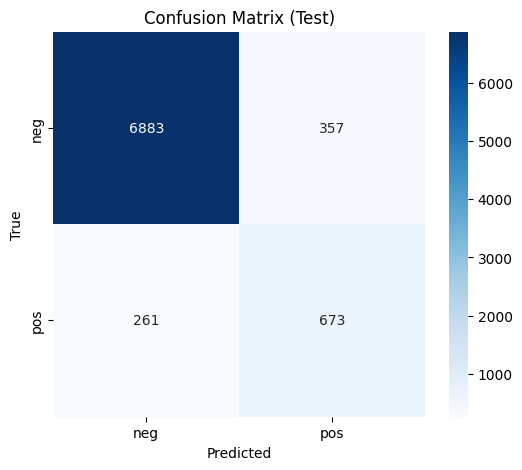

Epoch 8 Summary:
Train Loss: 0.1904 | Train Acc: 85.25% | Train F1: 0.8514
Val Loss: 0.1337 | Val Acc: 90.85% | Val F1: 0.8011
Test Loss: 0.1644 | Test Acc: 92.44% | Test F1: 0.8212
Epoch Time: 29775.93s | GPU Memory Usage: 767.04 MB



Checkpoint saved at checkpoints\epoch_8.pth
No improvement in validation loss for 2 epoch(s).


Training:   0%|                                                              | 0/470 [00:00<?, ?it/s]

Training:   0%|                           | 0/470 [00:01<?, ?it/s, Loss=0.0813, F1=0.8667, Acc=87.50]

Training:   0%|                   | 1/470 [00:01<09:32,  1.22s/it, Loss=0.0813, F1=0.8667, Acc=87.50]

Training:   0%|                   | 1/470 [00:02<09:32,  1.22s/it, Loss=0.1180, F1=0.8667, Acc=87.50]

Training:   0%|                   | 2/470 [00:02<09:22,  1.20s/it, Loss=0.1180, F1=0.8667, Acc=87.50]

Training:   0%|                   | 2/470 [00:03<09:22,  1.20s/it, Loss=0.2201, F1=0.8426, Acc=85.42]

Training:   1%|                   | 3/470 [00:03<09:13,  1.19s/it, Loss=0.2201, F1=0.8426, Acc=85.42]

Training:   1%|                   | 3/470 [00:04<09:13,  1.19s/it, Loss=0.2218, F1=0.8533, Acc=85.94]

Training:   1%|▏                  | 4/470 [00:04<09:12,  1.19s/it, Loss=0.2218, F1=0.8533, Acc=85.94]

Training:   1%|▏                  | 4/470 [00:05<09:12,  1.19s/it, Loss=0.2159, F1=0.8560, Acc=86.25]

Training:   1%|▏                  | 5/470 [00:05<09:08,  1.18s/it, Loss=0.2159, F1=0.8560, Acc=86.25]

Training:   1%|▏                  | 5/470 [00:07<09:08,  1.18s/it, Loss=0.2314, F1=0.8426, Acc=85.42]

Training:   1%|▏                  | 6/470 [00:07<08:58,  1.16s/it, Loss=0.2314, F1=0.8426, Acc=85.42]

Training:   1%|▏                  | 6/470 [00:08<08:58,  1.16s/it, Loss=0.2077, F1=0.8578, Acc=86.61]

Training:   1%|▎                  | 7/470 [00:08<09:15,  1.20s/it, Loss=0.2077, F1=0.8578, Acc=86.61]

Training:   1%|▎                  | 7/470 [00:09<09:15,  1.20s/it, Loss=0.2134, F1=0.8500, Acc=85.94]

Training:   2%|▎                  | 8/470 [00:09<09:08,  1.19s/it, Loss=0.2134, F1=0.8500, Acc=85.94]

Training:   2%|▎                  | 8/470 [00:10<09:08,  1.19s/it, Loss=0.1991, F1=0.8489, Acc=85.42]

Training:   2%|▎                  | 9/470 [00:10<09:21,  1.22s/it, Loss=0.1991, F1=0.8489, Acc=85.42]

Training:   2%|▎                  | 9/470 [00:11<09:21,  1.22s/it, Loss=0.1878, F1=0.8465, Acc=85.00]

Training:   2%|▍                 | 10/470 [00:11<09:13,  1.20s/it, Loss=0.1878, F1=0.8465, Acc=85.00]

Training:   2%|▍                 | 10/470 [00:13<09:13,  1.20s/it, Loss=0.2112, F1=0.8379, Acc=84.09]

Training:   2%|▍                 | 11/470 [00:13<09:04,  1.19s/it, Loss=0.2112, F1=0.8379, Acc=84.09]

Training:   2%|▍                 | 11/470 [00:14<09:04,  1.19s/it, Loss=0.2203, F1=0.8256, Acc=82.81]

Training:   3%|▍                 | 12/470 [00:14<09:00,  1.18s/it, Loss=0.2203, F1=0.8256, Acc=82.81]

Training:   3%|▍                 | 12/470 [00:15<09:00,  1.18s/it, Loss=0.2092, F1=0.8405, Acc=84.13]

Training:   3%|▍                 | 13/470 [00:15<09:09,  1.20s/it, Loss=0.2092, F1=0.8405, Acc=84.13]

Training:   3%|▍                 | 13/470 [00:16<09:09,  1.20s/it, Loss=0.1978, F1=0.8525, Acc=85.27]

Training:   3%|▌                 | 14/470 [00:16<09:16,  1.22s/it, Loss=0.1978, F1=0.8525, Acc=85.27]

Training:   3%|▌                 | 14/470 [00:18<09:16,  1.22s/it, Loss=0.1880, F1=0.8583, Acc=85.83]

Training:   3%|▌                 | 15/470 [00:18<09:16,  1.22s/it, Loss=0.1880, F1=0.8583, Acc=85.83]

Training:   3%|▌                 | 15/470 [00:19<09:16,  1.22s/it, Loss=0.1825, F1=0.8594, Acc=85.94]

Training:   3%|▌                 | 16/470 [00:19<09:05,  1.20s/it, Loss=0.1825, F1=0.8594, Acc=85.94]

Training:   3%|▌                 | 16/470 [00:20<09:05,  1.20s/it, Loss=0.1747, F1=0.8639, Acc=86.40]

Training:   4%|▋                 | 17/470 [00:20<08:59,  1.19s/it, Loss=0.1747, F1=0.8639, Acc=86.40]

Training:   4%|▋                 | 17/470 [00:21<08:59,  1.19s/it, Loss=0.1744, F1=0.8680, Acc=86.81]

Training:   4%|▋                 | 18/470 [00:21<08:58,  1.19s/it, Loss=0.1744, F1=0.8680, Acc=86.81]

Training:   4%|▋                 | 18/470 [00:22<08:58,  1.19s/it, Loss=0.1673, F1=0.8748, Acc=87.50]

Training:   4%|▋                 | 19/470 [00:22<08:52,  1.18s/it, Loss=0.1673, F1=0.8748, Acc=87.50]

Training:   4%|▋                 | 19/470 [00:23<08:52,  1.18s/it, Loss=0.1638, F1=0.8809, Acc=88.12]

Training:   4%|▊                 | 20/470 [00:23<09:04,  1.21s/it, Loss=0.1638, F1=0.8809, Acc=88.12]

Training:   4%|▊                 | 20/470 [00:25<09:04,  1.21s/it, Loss=0.1597, F1=0.8777, Acc=87.80]

Training:   4%|▊                 | 21/470 [00:25<09:00,  1.20s/it, Loss=0.1597, F1=0.8777, Acc=87.80]

Training:   4%|▊                 | 21/470 [00:26<09:00,  1.20s/it, Loss=0.1661, F1=0.8717, Acc=87.22]

Training:   5%|▊                 | 22/470 [00:26<08:50,  1.18s/it, Loss=0.1661, F1=0.8717, Acc=87.22]

Training:   5%|▊                 | 22/470 [00:27<08:50,  1.18s/it, Loss=0.1612, F1=0.8774, Acc=87.77]

Training:   5%|▉                 | 23/470 [00:27<09:02,  1.21s/it, Loss=0.1612, F1=0.8774, Acc=87.77]

Training:   5%|▉                 | 23/470 [00:28<09:02,  1.21s/it, Loss=0.1563, F1=0.8826, Acc=88.28]

Training:   5%|▉                 | 24/470 [00:28<08:59,  1.21s/it, Loss=0.1563, F1=0.8826, Acc=88.28]

Training:   5%|▉                 | 24/470 [00:29<08:59,  1.21s/it, Loss=0.1541, F1=0.8824, Acc=88.25]

Training:   5%|▉                 | 25/470 [00:29<08:52,  1.20s/it, Loss=0.1541, F1=0.8824, Acc=88.25]

Training:   5%|▉                 | 25/470 [00:31<08:52,  1.20s/it, Loss=0.1486, F1=0.8869, Acc=88.70]

Training:   6%|▉                 | 26/470 [00:31<08:52,  1.20s/it, Loss=0.1486, F1=0.8869, Acc=88.70]

Training:   6%|▉                 | 26/470 [00:32<08:52,  1.20s/it, Loss=0.1471, F1=0.8887, Acc=88.89]

Training:   6%|█                 | 27/470 [00:32<08:41,  1.18s/it, Loss=0.1471, F1=0.8887, Acc=88.89]

Training:   6%|█                 | 27/470 [00:33<08:41,  1.18s/it, Loss=0.1456, F1=0.8904, Acc=89.06]

Training:   6%|█                 | 28/470 [00:33<08:52,  1.20s/it, Loss=0.1456, F1=0.8904, Acc=89.06]

Training:   6%|█                 | 28/470 [00:34<08:52,  1.20s/it, Loss=0.1429, F1=0.8899, Acc=89.01]

Training:   6%|█                 | 29/470 [00:34<08:55,  1.22s/it, Loss=0.1429, F1=0.8899, Acc=89.01]

Training:   6%|█                 | 29/470 [00:35<08:55,  1.22s/it, Loss=0.1406, F1=0.8914, Acc=89.17]

Training:   6%|█▏                | 30/470 [00:35<08:49,  1.20s/it, Loss=0.1406, F1=0.8914, Acc=89.17]

Training:   6%|█▏                | 30/470 [00:37<08:49,  1.20s/it, Loss=0.1399, F1=0.8908, Acc=89.11]

Training:   7%|█▏                | 31/470 [00:37<08:46,  1.20s/it, Loss=0.1399, F1=0.8908, Acc=89.11]

Training:   7%|█▏                | 31/470 [00:38<08:46,  1.20s/it, Loss=0.1435, F1=0.8864, Acc=88.67]

Training:   7%|█▏                | 32/470 [00:38<08:44,  1.20s/it, Loss=0.1435, F1=0.8864, Acc=88.67]

Training:   7%|█▏                | 32/470 [00:39<08:44,  1.20s/it, Loss=0.1558, F1=0.8747, Acc=87.50]

Training:   7%|█▎                | 33/470 [00:39<08:45,  1.20s/it, Loss=0.1558, F1=0.8747, Acc=87.50]

Training:   7%|█▎                | 33/470 [00:40<08:45,  1.20s/it, Loss=0.1567, F1=0.8747, Acc=87.50]

Training:   7%|█▎                | 34/470 [00:40<08:41,  1.20s/it, Loss=0.1567, F1=0.8747, Acc=87.50]

Training:   7%|█▎                | 34/470 [00:41<08:41,  1.20s/it, Loss=0.1615, F1=0.8765, Acc=87.68]

Training:   7%|█▎                | 35/470 [00:41<08:37,  1.19s/it, Loss=0.1615, F1=0.8765, Acc=87.68]

Training:   7%|█▎                | 35/470 [00:43<08:37,  1.19s/it, Loss=0.1691, F1=0.8693, Acc=86.98]

Training:   8%|█▍                | 36/470 [00:43<08:32,  1.18s/it, Loss=0.1691, F1=0.8693, Acc=86.98]

Training:   8%|█▍                | 36/470 [00:44<08:32,  1.18s/it, Loss=0.1671, F1=0.8696, Acc=86.99]

Training:   8%|█▍                | 37/470 [00:44<08:44,  1.21s/it, Loss=0.1671, F1=0.8696, Acc=86.99]

Training:   8%|█▍                | 37/470 [00:45<08:44,  1.21s/it, Loss=0.1708, F1=0.8648, Acc=86.51]

Training:   8%|█▍                | 38/470 [00:45<08:34,  1.19s/it, Loss=0.1708, F1=0.8648, Acc=86.51]

Training:   8%|█▍                | 38/470 [00:46<08:34,  1.19s/it, Loss=0.1689, F1=0.8650, Acc=86.54]

Training:   8%|█▍                | 39/470 [00:46<08:32,  1.19s/it, Loss=0.1689, F1=0.8650, Acc=86.54]

Training:   8%|█▍                | 39/470 [00:47<08:32,  1.19s/it, Loss=0.1686, F1=0.8651, Acc=86.56]

Training:   9%|█▌                | 40/470 [00:47<08:37,  1.20s/it, Loss=0.1686, F1=0.8651, Acc=86.56]

Training:   9%|█▌                | 40/470 [00:49<08:37,  1.20s/it, Loss=0.1746, F1=0.8622, Acc=86.28]

Training:   9%|█▌                | 41/470 [00:49<08:36,  1.21s/it, Loss=0.1746, F1=0.8622, Acc=86.28]

Training:   9%|█▌                | 41/470 [00:50<08:36,  1.21s/it, Loss=0.1708, F1=0.8655, Acc=86.61]

Training:   9%|█▌                | 42/470 [00:50<08:31,  1.19s/it, Loss=0.1708, F1=0.8655, Acc=86.61]

Training:   9%|█▌                | 42/470 [00:51<08:31,  1.19s/it, Loss=0.1851, F1=0.8657, Acc=86.63]

Training:   9%|█▋                | 43/470 [00:51<08:20,  1.17s/it, Loss=0.1851, F1=0.8657, Acc=86.63]

Training:   9%|█▋                | 43/470 [00:52<08:20,  1.17s/it, Loss=0.1812, F1=0.8688, Acc=86.93]

Training:   9%|█▋                | 44/470 [00:52<08:18,  1.17s/it, Loss=0.1812, F1=0.8688, Acc=86.93]

Training:   9%|█▋                | 44/470 [00:53<08:18,  1.17s/it, Loss=0.1947, F1=0.8690, Acc=86.94]

Training:  10%|█▋                | 45/470 [00:53<08:15,  1.17s/it, Loss=0.1947, F1=0.8690, Acc=86.94]

Training:  10%|█▋                | 45/470 [00:54<08:15,  1.17s/it, Loss=0.2026, F1=0.8677, Acc=86.82]

Training:  10%|█▊                | 46/470 [00:54<08:12,  1.16s/it, Loss=0.2026, F1=0.8677, Acc=86.82]

Training:  10%|█▊                | 46/470 [00:56<08:12,  1.16s/it, Loss=0.2035, F1=0.8666, Acc=86.70]

Training:  10%|█▊                | 47/470 [00:56<08:22,  1.19s/it, Loss=0.2035, F1=0.8666, Acc=86.70]

Training:  10%|█▊                | 47/470 [00:57<08:22,  1.19s/it, Loss=0.2046, F1=0.8668, Acc=86.72]

Training:  10%|█▊                | 48/470 [00:57<08:23,  1.19s/it, Loss=0.2046, F1=0.8668, Acc=86.72]

Training:  10%|█▊                | 48/470 [00:58<08:23,  1.19s/it, Loss=0.2022, F1=0.8695, Acc=86.99]

Training:  10%|█▉                | 49/470 [00:58<08:20,  1.19s/it, Loss=0.2022, F1=0.8695, Acc=86.99]

Training:  10%|█▉                | 49/470 [00:59<08:20,  1.19s/it, Loss=0.2055, F1=0.8683, Acc=86.88]

Training:  11%|█▉                | 50/470 [00:59<08:21,  1.19s/it, Loss=0.2055, F1=0.8683, Acc=86.88]

Training:  11%|█▉                | 50/470 [01:00<08:21,  1.19s/it, Loss=0.2074, F1=0.8659, Acc=86.64]

Training:  11%|█▉                | 51/470 [01:00<08:19,  1.19s/it, Loss=0.2074, F1=0.8659, Acc=86.64]

Training:  11%|█▉                | 51/470 [01:02<08:19,  1.19s/it, Loss=0.2072, F1=0.8636, Acc=86.42]

Training:  11%|█▉                | 52/470 [01:02<08:15,  1.19s/it, Loss=0.2072, F1=0.8636, Acc=86.42]

Training:  11%|█▉                | 52/470 [01:03<08:15,  1.19s/it, Loss=0.2066, F1=0.8638, Acc=86.44]

Training:  11%|██                | 53/470 [01:03<08:30,  1.22s/it, Loss=0.2066, F1=0.8638, Acc=86.44]

Training:  11%|██                | 53/470 [01:04<08:30,  1.22s/it, Loss=0.2102, F1=0.8594, Acc=86.00]

Training:  11%|██                | 54/470 [01:04<08:23,  1.21s/it, Loss=0.2102, F1=0.8594, Acc=86.00]

Training:  11%|██                | 54/470 [01:05<08:23,  1.21s/it, Loss=0.2091, F1=0.8596, Acc=86.02]

Training:  12%|██                | 55/470 [01:05<08:19,  1.20s/it, Loss=0.2091, F1=0.8596, Acc=86.02]

Training:  12%|██                | 55/470 [01:06<08:19,  1.20s/it, Loss=0.2090, F1=0.8566, Acc=85.71]

Training:  12%|██▏               | 56/470 [01:06<08:12,  1.19s/it, Loss=0.2090, F1=0.8566, Acc=85.71]

Training:  12%|██▏               | 56/470 [01:08<08:12,  1.19s/it, Loss=0.2075, F1=0.8558, Acc=85.64]

Training:  12%|██▏               | 57/470 [01:08<08:15,  1.20s/it, Loss=0.2075, F1=0.8558, Acc=85.64]

Training:  12%|██▏               | 57/470 [01:09<08:15,  1.20s/it, Loss=0.2067, F1=0.8527, Acc=85.34]

Training:  12%|██▏               | 58/470 [01:09<08:10,  1.19s/it, Loss=0.2067, F1=0.8527, Acc=85.34]

Training:  12%|██▏               | 58/470 [01:10<08:10,  1.19s/it, Loss=0.2080, F1=0.8489, Acc=84.96]

Training:  13%|██▎               | 59/470 [01:10<08:08,  1.19s/it, Loss=0.2080, F1=0.8489, Acc=84.96]

Training:  13%|██▎               | 59/470 [01:11<08:08,  1.19s/it, Loss=0.2100, F1=0.8472, Acc=84.79]

Training:  13%|██▎               | 60/470 [01:11<08:06,  1.19s/it, Loss=0.2100, F1=0.8472, Acc=84.79]

Training:  13%|██▎               | 60/470 [01:12<08:06,  1.19s/it, Loss=0.2079, F1=0.8466, Acc=84.73]

Training:  13%|██▎               | 61/470 [01:12<08:14,  1.21s/it, Loss=0.2079, F1=0.8466, Acc=84.73]

Training:  13%|██▎               | 61/470 [01:14<08:14,  1.21s/it, Loss=0.2053, F1=0.8480, Acc=84.88]

Training:  13%|██▎               | 62/470 [01:14<08:11,  1.21s/it, Loss=0.2053, F1=0.8480, Acc=84.88]

Training:  13%|██▎               | 62/470 [01:15<08:11,  1.21s/it, Loss=0.2045, F1=0.8473, Acc=84.82]

Training:  13%|██▍               | 63/470 [01:15<08:06,  1.20s/it, Loss=0.2045, F1=0.8473, Acc=84.82]

Training:  13%|██▍               | 63/470 [01:16<08:06,  1.20s/it, Loss=0.2048, F1=0.8488, Acc=84.96]

Training:  14%|██▍               | 64/470 [01:16<08:04,  1.19s/it, Loss=0.2048, F1=0.8488, Acc=84.96]

Training:  14%|██▍               | 64/470 [01:17<08:04,  1.19s/it, Loss=0.2033, F1=0.8510, Acc=85.19]

Training:  14%|██▍               | 65/470 [01:17<07:59,  1.18s/it, Loss=0.2033, F1=0.8510, Acc=85.19]

Training:  14%|██▍               | 65/470 [01:18<07:59,  1.18s/it, Loss=0.2036, F1=0.8514, Acc=85.23]

Training:  14%|██▌               | 66/470 [01:18<08:11,  1.22s/it, Loss=0.2036, F1=0.8514, Acc=85.23]

Training:  14%|██▌               | 66/470 [01:20<08:11,  1.22s/it, Loss=0.2015, F1=0.8537, Acc=85.45]

Training:  14%|██▌               | 67/470 [01:20<08:02,  1.20s/it, Loss=0.2015, F1=0.8537, Acc=85.45]

Training:  14%|██▌               | 67/470 [01:21<08:02,  1.20s/it, Loss=0.2003, F1=0.8541, Acc=85.48]

Training:  14%|██▌               | 68/470 [01:21<07:59,  1.19s/it, Loss=0.2003, F1=0.8541, Acc=85.48]

Training:  14%|██▌               | 68/470 [01:22<07:59,  1.19s/it, Loss=0.2009, F1=0.8536, Acc=85.42]

Training:  15%|██▋               | 69/470 [01:22<07:57,  1.19s/it, Loss=0.2009, F1=0.8536, Acc=85.42]

Training:  15%|██▋               | 69/470 [01:23<07:57,  1.19s/it, Loss=0.1989, F1=0.8549, Acc=85.54]

Training:  15%|██▋               | 70/470 [01:23<08:05,  1.21s/it, Loss=0.1989, F1=0.8549, Acc=85.54]

Training:  15%|██▋               | 70/470 [01:24<08:05,  1.21s/it, Loss=0.1977, F1=0.8552, Acc=85.56]

Training:  15%|██▋               | 71/470 [01:24<07:57,  1.20s/it, Loss=0.1977, F1=0.8552, Acc=85.56]

Training:  15%|██▋               | 71/470 [01:26<07:57,  1.20s/it, Loss=0.1967, F1=0.8545, Acc=85.50]

Training:  15%|██▊               | 72/470 [01:26<07:53,  1.19s/it, Loss=0.1967, F1=0.8545, Acc=85.50]

Training:  15%|██▊               | 72/470 [01:27<07:53,  1.19s/it, Loss=0.1983, F1=0.8539, Acc=85.45]

Training:  16%|██▊               | 73/470 [01:27<08:02,  1.22s/it, Loss=0.1983, F1=0.8539, Acc=85.45]

Training:  16%|██▊               | 73/470 [01:28<08:02,  1.22s/it, Loss=0.1976, F1=0.8550, Acc=85.56]

Training:  16%|██▊               | 74/470 [01:28<07:59,  1.21s/it, Loss=0.1976, F1=0.8550, Acc=85.56]

Training:  16%|██▊               | 74/470 [01:29<07:59,  1.21s/it, Loss=0.1963, F1=0.8570, Acc=85.75]

Training:  16%|██▊               | 75/470 [01:29<07:51,  1.19s/it, Loss=0.1963, F1=0.8570, Acc=85.75]

Training:  16%|██▊               | 75/470 [01:30<07:51,  1.19s/it, Loss=0.1987, F1=0.8572, Acc=85.77]

Training:  16%|██▉               | 76/470 [01:30<07:46,  1.18s/it, Loss=0.1987, F1=0.8572, Acc=85.77]

Training:  16%|██▉               | 76/470 [01:32<07:46,  1.18s/it, Loss=0.1985, F1=0.8575, Acc=85.80]

Training:  16%|██▉               | 77/470 [01:32<07:57,  1.22s/it, Loss=0.1985, F1=0.8575, Acc=85.80]

Training:  16%|██▉               | 77/470 [01:33<07:57,  1.22s/it, Loss=0.1972, F1=0.8585, Acc=85.90]

Training:  17%|██▉               | 78/470 [01:33<07:45,  1.19s/it, Loss=0.1972, F1=0.8585, Acc=85.90]

Training:  17%|██▉               | 78/470 [01:34<07:45,  1.19s/it, Loss=0.1968, F1=0.8562, Acc=85.68]

Training:  17%|███               | 79/470 [01:34<07:49,  1.20s/it, Loss=0.1968, F1=0.8562, Acc=85.68]

Training:  17%|███               | 79/470 [01:35<07:49,  1.20s/it, Loss=0.1964, F1=0.8556, Acc=85.62]

Training:  17%|███               | 80/470 [01:35<07:49,  1.20s/it, Loss=0.1964, F1=0.8556, Acc=85.62]

Training:  17%|███               | 80/470 [01:36<07:49,  1.20s/it, Loss=0.1965, F1=0.8551, Acc=85.57]

Training:  17%|███               | 81/470 [01:36<07:40,  1.18s/it, Loss=0.1965, F1=0.8551, Acc=85.57]

Training:  17%|███               | 81/470 [01:38<07:40,  1.18s/it, Loss=0.1959, F1=0.8538, Acc=85.44]

Training:  17%|███▏              | 82/470 [01:38<07:54,  1.22s/it, Loss=0.1959, F1=0.8538, Acc=85.44]

Training:  17%|███▏              | 82/470 [01:39<07:54,  1.22s/it, Loss=0.1960, F1=0.8509, Acc=85.17]

Training:  18%|███▏              | 83/470 [01:39<07:46,  1.20s/it, Loss=0.1960, F1=0.8509, Acc=85.17]

Training:  18%|███▏              | 83/470 [01:40<07:46,  1.20s/it, Loss=0.1949, F1=0.8496, Acc=85.04]

Training:  18%|███▏              | 84/470 [01:40<07:42,  1.20s/it, Loss=0.1949, F1=0.8496, Acc=85.04]

Training:  18%|███▏              | 84/470 [01:41<07:42,  1.20s/it, Loss=0.1941, F1=0.8499, Acc=85.07]

Training:  18%|███▎              | 85/470 [01:41<07:38,  1.19s/it, Loss=0.1941, F1=0.8499, Acc=85.07]

Training:  18%|███▎              | 85/470 [01:42<07:38,  1.19s/it, Loss=0.1934, F1=0.8480, Acc=84.88]

Training:  18%|███▎              | 86/470 [01:42<07:38,  1.19s/it, Loss=0.1934, F1=0.8480, Acc=84.88]

Training:  18%|███▎              | 86/470 [01:44<07:38,  1.19s/it, Loss=0.1936, F1=0.8476, Acc=84.84]

Training:  19%|███▎              | 87/470 [01:44<07:37,  1.20s/it, Loss=0.1936, F1=0.8476, Acc=84.84]

Training:  19%|███▎              | 87/470 [01:45<07:37,  1.20s/it, Loss=0.1921, F1=0.8479, Acc=84.87]

Training:  19%|███▎              | 88/470 [01:45<07:34,  1.19s/it, Loss=0.1921, F1=0.8479, Acc=84.87]

Training:  19%|███▎              | 88/470 [01:46<07:34,  1.19s/it, Loss=0.1923, F1=0.8482, Acc=84.90]

Training:  19%|███▍              | 89/470 [01:46<07:44,  1.22s/it, Loss=0.1923, F1=0.8482, Acc=84.90]

Training:  19%|███▍              | 89/470 [01:47<07:44,  1.22s/it, Loss=0.1952, F1=0.8478, Acc=84.86]

Training:  19%|███▍              | 90/470 [01:47<07:37,  1.20s/it, Loss=0.1952, F1=0.8478, Acc=84.86]

Training:  19%|███▍              | 90/470 [01:48<07:37,  1.20s/it, Loss=0.1936, F1=0.8496, Acc=85.03]

Training:  19%|███▍              | 91/470 [01:48<07:34,  1.20s/it, Loss=0.1936, F1=0.8496, Acc=85.03]

Training:  19%|███▍              | 91/470 [01:50<07:34,  1.20s/it, Loss=0.1924, F1=0.8512, Acc=85.19]

Training:  20%|███▌              | 92/470 [01:50<07:37,  1.21s/it, Loss=0.1924, F1=0.8512, Acc=85.19]

Training:  20%|███▌              | 92/470 [01:51<07:37,  1.21s/it, Loss=0.1949, F1=0.8502, Acc=85.08]

Training:  20%|███▌              | 93/470 [01:51<07:33,  1.20s/it, Loss=0.1949, F1=0.8502, Acc=85.08]

Training:  20%|███▌              | 93/470 [01:52<07:33,  1.20s/it, Loss=0.1944, F1=0.8512, Acc=85.17]

Training:  20%|███▌              | 94/470 [01:52<07:28,  1.19s/it, Loss=0.1944, F1=0.8512, Acc=85.17]

Training:  20%|███▌              | 94/470 [01:53<07:28,  1.19s/it, Loss=0.1945, F1=0.8500, Acc=85.07]

Training:  20%|███▋              | 95/470 [01:53<07:20,  1.18s/it, Loss=0.1945, F1=0.8500, Acc=85.07]

Training:  20%|███▋              | 95/470 [01:54<07:20,  1.18s/it, Loss=0.1931, F1=0.8503, Acc=85.09]

Training:  20%|███▋              | 96/470 [01:54<07:31,  1.21s/it, Loss=0.1931, F1=0.8503, Acc=85.09]

Training:  20%|███▋              | 96/470 [01:56<07:31,  1.21s/it, Loss=0.1923, F1=0.8506, Acc=85.12]

Training:  21%|███▋              | 97/470 [01:56<07:26,  1.20s/it, Loss=0.1923, F1=0.8506, Acc=85.12]

Training:  21%|███▋              | 97/470 [01:57<07:26,  1.20s/it, Loss=0.1923, F1=0.8508, Acc=85.14]

Training:  21%|███▊              | 98/470 [01:57<07:21,  1.19s/it, Loss=0.1923, F1=0.8508, Acc=85.14]

Training:  21%|███▊              | 98/470 [01:58<07:21,  1.19s/it, Loss=0.1909, F1=0.8516, Acc=85.23]

Training:  21%|███▊              | 99/470 [01:58<07:31,  1.22s/it, Loss=0.1909, F1=0.8516, Acc=85.23]

Training:  21%|███▊              | 99/470 [01:59<07:31,  1.22s/it, Loss=0.1900, F1=0.8519, Acc=85.25]

Training:  21%|███▌             | 100/470 [01:59<07:30,  1.22s/it, Loss=0.1900, F1=0.8519, Acc=85.25]

Training:  21%|███▌             | 100/470 [02:00<07:30,  1.22s/it, Loss=0.1889, F1=0.8534, Acc=85.40]

Training:  21%|███▋             | 101/470 [02:00<07:23,  1.20s/it, Loss=0.1889, F1=0.8534, Acc=85.40]

Training:  21%|███▋             | 101/470 [02:02<07:23,  1.20s/it, Loss=0.1890, F1=0.8517, Acc=85.23]

Training:  22%|███▋             | 102/470 [02:02<07:18,  1.19s/it, Loss=0.1890, F1=0.8517, Acc=85.23]

Training:  22%|███▋             | 102/470 [02:03<07:18,  1.19s/it, Loss=0.1884, F1=0.8525, Acc=85.32]

Training:  22%|███▋             | 103/470 [02:03<07:14,  1.18s/it, Loss=0.1884, F1=0.8525, Acc=85.32]

Training:  22%|███▋             | 103/470 [02:04<07:14,  1.18s/it, Loss=0.1869, F1=0.8540, Acc=85.46]

Training:  22%|███▊             | 104/470 [02:04<07:19,  1.20s/it, Loss=0.1869, F1=0.8540, Acc=85.46]

Training:  22%|███▊             | 104/470 [02:05<07:19,  1.20s/it, Loss=0.1859, F1=0.8554, Acc=85.60]

Training:  22%|███▊             | 105/470 [02:05<07:21,  1.21s/it, Loss=0.1859, F1=0.8554, Acc=85.60]

Training:  22%|███▊             | 105/470 [02:06<07:21,  1.21s/it, Loss=0.1846, F1=0.8567, Acc=85.73]

Training:  23%|███▊             | 106/470 [02:06<07:15,  1.20s/it, Loss=0.1846, F1=0.8567, Acc=85.73]

Training:  23%|███▊             | 106/470 [02:08<07:15,  1.20s/it, Loss=0.1843, F1=0.8574, Acc=85.81]

Training:  23%|███▊             | 107/470 [02:08<07:15,  1.20s/it, Loss=0.1843, F1=0.8574, Acc=85.81]

Training:  23%|███▊             | 107/470 [02:09<07:15,  1.20s/it, Loss=0.1832, F1=0.8588, Acc=85.94]

Training:  23%|███▉             | 108/470 [02:09<07:08,  1.18s/it, Loss=0.1832, F1=0.8588, Acc=85.94]

Training:  23%|███▉             | 108/470 [02:10<07:08,  1.18s/it, Loss=0.1821, F1=0.8600, Acc=86.07]

Training:  23%|███▉             | 109/470 [02:10<07:15,  1.21s/it, Loss=0.1821, F1=0.8600, Acc=86.07]

Training:  23%|███▉             | 109/470 [02:11<07:15,  1.21s/it, Loss=0.1820, F1=0.8601, Acc=86.08]

Training:  23%|███▉             | 110/470 [02:11<07:10,  1.20s/it, Loss=0.1820, F1=0.8601, Acc=86.08]

Training:  23%|███▉             | 110/470 [02:12<07:10,  1.20s/it, Loss=0.1822, F1=0.8585, Acc=85.92]

Training:  24%|████             | 111/470 [02:12<07:14,  1.21s/it, Loss=0.1822, F1=0.8585, Acc=85.92]

Training:  24%|████             | 111/470 [02:14<07:14,  1.21s/it, Loss=0.1812, F1=0.8592, Acc=85.99]

Training:  24%|████             | 112/470 [02:14<07:08,  1.20s/it, Loss=0.1812, F1=0.8592, Acc=85.99]

Training:  24%|████             | 112/470 [02:15<07:08,  1.20s/it, Loss=0.1809, F1=0.8587, Acc=85.95]

Training:  24%|████             | 113/470 [02:15<07:05,  1.19s/it, Loss=0.1809, F1=0.8587, Acc=85.95]

Training:  24%|████             | 113/470 [02:16<07:05,  1.19s/it, Loss=0.1796, F1=0.8594, Acc=86.02]

Training:  24%|████             | 114/470 [02:16<07:09,  1.21s/it, Loss=0.1796, F1=0.8594, Acc=86.02]

Training:  24%|████             | 114/470 [02:17<07:09,  1.21s/it, Loss=0.1786, F1=0.8595, Acc=86.03]

Training:  24%|████▏            | 115/470 [02:17<07:07,  1.20s/it, Loss=0.1786, F1=0.8595, Acc=86.03]

Training:  24%|████▏            | 115/470 [02:18<07:07,  1.20s/it, Loss=0.1778, F1=0.8596, Acc=86.05]

Training:  25%|████▏            | 116/470 [02:18<06:59,  1.19s/it, Loss=0.1778, F1=0.8596, Acc=86.05]

Training:  25%|████▏            | 116/470 [02:20<06:59,  1.19s/it, Loss=0.1786, F1=0.8598, Acc=86.06]

Training:  25%|████▏            | 117/470 [02:20<07:07,  1.21s/it, Loss=0.1786, F1=0.8598, Acc=86.06]

Training:  25%|████▏            | 117/470 [02:21<07:07,  1.21s/it, Loss=0.1783, F1=0.8604, Acc=86.12]

Training:  25%|████▎            | 118/470 [02:21<06:56,  1.18s/it, Loss=0.1783, F1=0.8604, Acc=86.12]

Training:  25%|████▎            | 118/470 [02:22<06:56,  1.18s/it, Loss=0.1769, F1=0.8617, Acc=86.24]

Training:  25%|████▎            | 119/470 [02:22<06:59,  1.20s/it, Loss=0.1769, F1=0.8617, Acc=86.24]

Training:  25%|████▎            | 119/470 [02:23<06:59,  1.20s/it, Loss=0.1764, F1=0.8623, Acc=86.30]

Training:  26%|████▎            | 120/470 [02:23<07:00,  1.20s/it, Loss=0.1764, F1=0.8623, Acc=86.30]

Training:  26%|████▎            | 120/470 [02:24<07:00,  1.20s/it, Loss=0.1752, F1=0.8629, Acc=86.36]

Training:  26%|████▍            | 121/470 [02:24<07:03,  1.21s/it, Loss=0.1752, F1=0.8629, Acc=86.36]

Training:  26%|████▍            | 121/470 [02:26<07:03,  1.21s/it, Loss=0.1752, F1=0.8636, Acc=86.42]

Training:  26%|████▍            | 122/470 [02:26<06:59,  1.21s/it, Loss=0.1752, F1=0.8636, Acc=86.42]

Training:  26%|████▍            | 122/470 [02:27<06:59,  1.21s/it, Loss=0.1758, F1=0.8638, Acc=86.43]

Training:  26%|████▍            | 123/470 [02:27<06:52,  1.19s/it, Loss=0.1758, F1=0.8638, Acc=86.43]

Training:  26%|████▍            | 123/470 [02:28<06:52,  1.19s/it, Loss=0.1781, F1=0.8639, Acc=86.44]

Training:  26%|████▍            | 124/470 [02:28<06:58,  1.21s/it, Loss=0.1781, F1=0.8639, Acc=86.44]

Training:  26%|████▍            | 124/470 [02:29<06:58,  1.21s/it, Loss=0.1773, F1=0.8644, Acc=86.50]

Training:  27%|████▌            | 125/470 [02:29<06:57,  1.21s/it, Loss=0.1773, F1=0.8644, Acc=86.50]

Training:  27%|████▌            | 125/470 [02:30<06:57,  1.21s/it, Loss=0.1768, F1=0.8641, Acc=86.46]

Training:  27%|████▌            | 126/470 [02:30<06:51,  1.20s/it, Loss=0.1768, F1=0.8641, Acc=86.46]

Training:  27%|████▌            | 126/470 [02:32<06:51,  1.20s/it, Loss=0.1758, F1=0.8642, Acc=86.47]

Training:  27%|████▌            | 127/470 [02:32<06:47,  1.19s/it, Loss=0.1758, F1=0.8642, Acc=86.47]

Training:  27%|████▌            | 127/470 [02:33<06:47,  1.19s/it, Loss=0.1749, F1=0.8653, Acc=86.57]

Training:  27%|████▋            | 128/470 [02:33<06:55,  1.22s/it, Loss=0.1749, F1=0.8653, Acc=86.57]

Training:  27%|████▋            | 128/470 [02:34<06:55,  1.22s/it, Loss=0.1742, F1=0.8663, Acc=86.68]

Training:  27%|████▋            | 129/470 [02:34<06:48,  1.20s/it, Loss=0.1742, F1=0.8663, Acc=86.68]

Training:  27%|████▋            | 129/470 [02:35<06:48,  1.20s/it, Loss=0.1734, F1=0.8673, Acc=86.78]

Training:  28%|████▋            | 130/470 [02:35<06:47,  1.20s/it, Loss=0.1734, F1=0.8673, Acc=86.78]

Training:  28%|████▋            | 130/470 [02:36<06:47,  1.20s/it, Loss=0.1736, F1=0.8674, Acc=86.78]

Training:  28%|████▋            | 131/470 [02:36<06:42,  1.19s/it, Loss=0.1736, F1=0.8674, Acc=86.78]

Training:  28%|████▋            | 131/470 [02:38<06:42,  1.19s/it, Loss=0.1730, F1=0.8665, Acc=86.70]

Training:  28%|████▊            | 132/470 [02:38<06:53,  1.22s/it, Loss=0.1730, F1=0.8665, Acc=86.70]

Training:  28%|████▊            | 132/470 [02:39<06:53,  1.22s/it, Loss=0.1721, F1=0.8670, Acc=86.75]

Training:  28%|████▊            | 133/470 [02:39<06:45,  1.20s/it, Loss=0.1721, F1=0.8670, Acc=86.75]

Training:  28%|████▊            | 133/470 [02:40<06:45,  1.20s/it, Loss=0.1722, F1=0.8666, Acc=86.71]

Training:  29%|████▊            | 134/470 [02:40<06:40,  1.19s/it, Loss=0.1722, F1=0.8666, Acc=86.71]

Training:  29%|████▊            | 134/470 [02:41<06:40,  1.19s/it, Loss=0.1749, F1=0.8666, Acc=86.71]

Training:  29%|████▉            | 135/470 [02:41<06:35,  1.18s/it, Loss=0.1749, F1=0.8666, Acc=86.71]

Training:  29%|████▉            | 135/470 [02:42<06:35,  1.18s/it, Loss=0.1748, F1=0.8662, Acc=86.67]

Training:  29%|████▉            | 136/470 [02:42<06:40,  1.20s/it, Loss=0.1748, F1=0.8662, Acc=86.67]

Training:  29%|████▉            | 136/470 [02:44<06:40,  1.20s/it, Loss=0.1745, F1=0.8658, Acc=86.63]

Training:  29%|████▉            | 137/470 [02:44<06:38,  1.20s/it, Loss=0.1745, F1=0.8658, Acc=86.63]

Training:  29%|████▉            | 137/470 [02:45<06:38,  1.20s/it, Loss=0.1747, F1=0.8649, Acc=86.55]

Training:  29%|████▉            | 138/470 [02:45<06:34,  1.19s/it, Loss=0.1747, F1=0.8649, Acc=86.55]

Training:  29%|████▉            | 138/470 [02:46<06:34,  1.19s/it, Loss=0.1764, F1=0.8627, Acc=86.33]

Training:  30%|█████            | 139/470 [02:46<06:37,  1.20s/it, Loss=0.1764, F1=0.8627, Acc=86.33]

Training:  30%|█████            | 139/470 [02:47<06:37,  1.20s/it, Loss=0.1783, F1=0.8614, Acc=86.21]

Training:  30%|█████            | 140/470 [02:47<06:41,  1.22s/it, Loss=0.1783, F1=0.8614, Acc=86.21]

Training:  30%|█████            | 140/470 [02:48<06:41,  1.22s/it, Loss=0.1791, F1=0.8606, Acc=86.13]

Training:  30%|█████            | 141/470 [02:48<06:32,  1.19s/it, Loss=0.1791, F1=0.8606, Acc=86.13]

Training:  30%|█████            | 141/470 [02:50<06:32,  1.19s/it, Loss=0.1804, F1=0.8598, Acc=86.05]

Training:  30%|█████▏           | 142/470 [02:50<06:36,  1.21s/it, Loss=0.1804, F1=0.8598, Acc=86.05]

Training:  30%|█████▏           | 142/470 [02:51<06:36,  1.21s/it, Loss=0.1796, F1=0.8599, Acc=86.06]

Training:  30%|█████▏           | 143/470 [02:51<06:27,  1.18s/it, Loss=0.1796, F1=0.8599, Acc=86.06]

Training:  30%|█████▏           | 143/470 [02:52<06:27,  1.18s/it, Loss=0.1790, F1=0.8600, Acc=86.07]

Training:  31%|█████▏           | 144/470 [02:52<06:32,  1.20s/it, Loss=0.1790, F1=0.8600, Acc=86.07]

Training:  31%|█████▏           | 144/470 [02:53<06:32,  1.20s/it, Loss=0.1782, F1=0.8606, Acc=86.12]

Training:  31%|█████▏           | 145/470 [02:53<06:34,  1.21s/it, Loss=0.1782, F1=0.8606, Acc=86.12]

Training:  31%|█████▏           | 145/470 [02:54<06:34,  1.21s/it, Loss=0.1773, F1=0.8611, Acc=86.17]

Training:  31%|█████▎           | 146/470 [02:54<06:30,  1.20s/it, Loss=0.1773, F1=0.8611, Acc=86.17]

Training:  31%|█████▎           | 146/470 [02:56<06:30,  1.20s/it, Loss=0.1769, F1=0.8616, Acc=86.22]

Training:  31%|█████▎           | 147/470 [02:56<06:21,  1.18s/it, Loss=0.1769, F1=0.8616, Acc=86.22]

Training:  31%|█████▎           | 147/470 [02:57<06:21,  1.18s/it, Loss=0.1791, F1=0.8617, Acc=86.23]

Training:  31%|█████▎           | 148/470 [02:57<06:31,  1.22s/it, Loss=0.1791, F1=0.8617, Acc=86.23]

Training:  31%|█████▎           | 148/470 [02:58<06:31,  1.22s/it, Loss=0.1784, F1=0.8627, Acc=86.33]

Training:  32%|█████▍           | 149/470 [02:58<06:24,  1.20s/it, Loss=0.1784, F1=0.8627, Acc=86.33]

Training:  32%|█████▍           | 149/470 [02:59<06:24,  1.20s/it, Loss=0.1800, F1=0.8633, Acc=86.38]

Training:  32%|█████▍           | 150/470 [02:59<06:23,  1.20s/it, Loss=0.1800, F1=0.8633, Acc=86.38]

Training:  32%|█████▍           | 150/470 [03:00<06:23,  1.20s/it, Loss=0.1810, F1=0.8634, Acc=86.38]

Training:  32%|█████▍           | 151/470 [03:00<06:20,  1.19s/it, Loss=0.1810, F1=0.8634, Acc=86.38]

Training:  32%|█████▍           | 151/470 [03:02<06:20,  1.19s/it, Loss=0.1812, F1=0.8638, Acc=86.43]

Training:  32%|█████▍           | 152/470 [03:02<06:18,  1.19s/it, Loss=0.1812, F1=0.8638, Acc=86.43]

Training:  32%|█████▍           | 152/470 [03:03<06:18,  1.19s/it, Loss=0.1803, F1=0.8647, Acc=86.52]

Training:  33%|█████▌           | 153/470 [03:03<06:20,  1.20s/it, Loss=0.1803, F1=0.8647, Acc=86.52]

Training:  33%|█████▌           | 153/470 [03:04<06:20,  1.20s/it, Loss=0.1805, F1=0.8639, Acc=86.44]

Training:  33%|█████▌           | 154/470 [03:04<06:26,  1.22s/it, Loss=0.1805, F1=0.8639, Acc=86.44]

Training:  33%|█████▌           | 154/470 [03:05<06:26,  1.22s/it, Loss=0.1800, F1=0.8640, Acc=86.45]

Training:  33%|█████▌           | 155/470 [03:05<06:20,  1.21s/it, Loss=0.1800, F1=0.8640, Acc=86.45]

Training:  33%|█████▌           | 155/470 [03:06<06:20,  1.21s/it, Loss=0.1803, F1=0.8632, Acc=86.38]

Training:  33%|█████▋           | 156/470 [03:06<06:17,  1.20s/it, Loss=0.1803, F1=0.8632, Acc=86.38]

Training:  33%|█████▋           | 156/470 [03:08<06:17,  1.20s/it, Loss=0.1799, F1=0.8632, Acc=86.39]

Training:  33%|█████▋           | 157/470 [03:08<06:17,  1.21s/it, Loss=0.1799, F1=0.8632, Acc=86.39]

Training:  33%|█████▋           | 157/470 [03:09<06:17,  1.21s/it, Loss=0.1797, F1=0.8629, Acc=86.35]

Training:  34%|█████▋           | 158/470 [03:09<06:12,  1.19s/it, Loss=0.1797, F1=0.8629, Acc=86.35]

Training:  34%|█████▋           | 158/470 [03:10<06:12,  1.19s/it, Loss=0.1796, F1=0.8615, Acc=86.20]

Training:  34%|█████▊           | 159/470 [03:10<06:08,  1.19s/it, Loss=0.1796, F1=0.8615, Acc=86.20]

Training:  34%|█████▊           | 159/470 [03:11<06:08,  1.19s/it, Loss=0.1789, F1=0.8615, Acc=86.21]

Training:  34%|█████▊           | 160/470 [03:11<06:07,  1.19s/it, Loss=0.1789, F1=0.8615, Acc=86.21]

Training:  34%|█████▊           | 160/470 [03:12<06:07,  1.19s/it, Loss=0.1788, F1=0.8600, Acc=86.06]

Training:  34%|█████▊           | 161/470 [03:12<06:11,  1.20s/it, Loss=0.1788, F1=0.8600, Acc=86.06]

Training:  34%|█████▊           | 161/470 [03:13<06:11,  1.20s/it, Loss=0.1788, F1=0.8593, Acc=86.00]

Training:  34%|█████▊           | 162/470 [03:13<06:00,  1.17s/it, Loss=0.1788, F1=0.8593, Acc=86.00]

Training:  34%|█████▊           | 162/470 [03:15<06:00,  1.17s/it, Loss=0.1782, F1=0.8587, Acc=85.93]

Training:  35%|█████▉           | 163/470 [03:15<05:57,  1.17s/it, Loss=0.1782, F1=0.8587, Acc=85.93]

Training:  35%|█████▉           | 163/470 [03:16<05:57,  1.17s/it, Loss=0.1787, F1=0.8584, Acc=85.90]

Training:  35%|█████▉           | 164/470 [03:16<05:57,  1.17s/it, Loss=0.1787, F1=0.8584, Acc=85.90]

Training:  35%|█████▉           | 164/470 [03:17<05:57,  1.17s/it, Loss=0.1781, F1=0.8585, Acc=85.91]

Training:  35%|█████▉           | 165/470 [03:17<06:00,  1.18s/it, Loss=0.1781, F1=0.8585, Acc=85.91]

Training:  35%|█████▉           | 165/470 [03:18<06:00,  1.18s/it, Loss=0.1774, F1=0.8593, Acc=85.99]

Training:  35%|██████           | 166/470 [03:18<05:57,  1.18s/it, Loss=0.1774, F1=0.8593, Acc=85.99]

Training:  35%|██████           | 166/470 [03:19<05:57,  1.18s/it, Loss=0.1775, F1=0.8598, Acc=86.04]

Training:  36%|██████           | 167/470 [03:19<05:57,  1.18s/it, Loss=0.1775, F1=0.8598, Acc=86.04]

Training:  36%|██████           | 167/470 [03:21<05:57,  1.18s/it, Loss=0.1835, F1=0.8587, Acc=85.94]

Training:  36%|██████           | 168/470 [03:21<05:56,  1.18s/it, Loss=0.1835, F1=0.8587, Acc=85.94]

Training:  36%|██████           | 168/470 [03:22<05:56,  1.18s/it, Loss=0.1856, F1=0.8585, Acc=85.91]

Training:  36%|██████           | 169/470 [03:22<05:57,  1.19s/it, Loss=0.1856, F1=0.8585, Acc=85.91]

Training:  36%|██████           | 169/470 [03:23<05:57,  1.19s/it, Loss=0.1856, F1=0.8586, Acc=85.92]

Training:  36%|██████▏          | 170/470 [03:23<05:54,  1.18s/it, Loss=0.1856, F1=0.8586, Acc=85.92]

Training:  36%|██████▏          | 170/470 [03:24<05:54,  1.18s/it, Loss=0.1853, F1=0.8595, Acc=86.00]

Training:  36%|██████▏          | 171/470 [03:24<06:04,  1.22s/it, Loss=0.1853, F1=0.8595, Acc=86.00]

Training:  36%|██████▏          | 171/470 [03:25<06:04,  1.22s/it, Loss=0.1847, F1=0.8603, Acc=86.08]

Training:  37%|██████▏          | 172/470 [03:25<06:00,  1.21s/it, Loss=0.1847, F1=0.8603, Acc=86.08]

Training:  37%|██████▏          | 172/470 [03:27<06:00,  1.21s/it, Loss=0.1839, F1=0.8608, Acc=86.13]

Training:  37%|██████▎          | 173/470 [03:27<05:55,  1.20s/it, Loss=0.1839, F1=0.8608, Acc=86.13]

Training:  37%|██████▎          | 173/470 [03:28<05:55,  1.20s/it, Loss=0.1836, F1=0.8609, Acc=86.14]

Training:  37%|██████▎          | 174/470 [03:28<05:55,  1.20s/it, Loss=0.1836, F1=0.8609, Acc=86.14]

Training:  37%|██████▎          | 174/470 [03:29<05:55,  1.20s/it, Loss=0.1830, F1=0.8610, Acc=86.14]

Training:  37%|██████▎          | 175/470 [03:29<05:49,  1.18s/it, Loss=0.1830, F1=0.8610, Acc=86.14]

Training:  37%|██████▎          | 175/470 [03:30<05:49,  1.18s/it, Loss=0.1840, F1=0.8607, Acc=86.12]

Training:  37%|██████▎          | 176/470 [03:30<05:58,  1.22s/it, Loss=0.1840, F1=0.8607, Acc=86.12]

Training:  37%|██████▎          | 176/470 [03:31<05:58,  1.22s/it, Loss=0.1842, F1=0.8612, Acc=86.16]

Training:  38%|██████▍          | 177/470 [03:31<05:51,  1.20s/it, Loss=0.1842, F1=0.8612, Acc=86.16]

Training:  38%|██████▍          | 177/470 [03:33<05:51,  1.20s/it, Loss=0.1834, F1=0.8615, Acc=86.20]

Training:  38%|██████▍          | 178/470 [03:33<05:45,  1.18s/it, Loss=0.1834, F1=0.8615, Acc=86.20]

Training:  38%|██████▍          | 178/470 [03:34<05:45,  1.18s/it, Loss=0.1828, F1=0.8613, Acc=86.17]

Training:  38%|██████▍          | 179/470 [03:34<05:50,  1.20s/it, Loss=0.1828, F1=0.8613, Acc=86.17]

Training:  38%|██████▍          | 179/470 [03:35<05:50,  1.20s/it, Loss=0.1828, F1=0.8606, Acc=86.11]

Training:  38%|██████▌          | 180/470 [03:35<05:45,  1.19s/it, Loss=0.1828, F1=0.8606, Acc=86.11]

Training:  38%|██████▌          | 180/470 [03:36<05:45,  1.19s/it, Loss=0.1829, F1=0.8604, Acc=86.08]

Training:  39%|██████▌          | 181/470 [03:36<05:45,  1.20s/it, Loss=0.1829, F1=0.8604, Acc=86.08]

Training:  39%|██████▌          | 181/470 [03:37<05:45,  1.20s/it, Loss=0.1831, F1=0.8601, Acc=86.06]

Training:  39%|██████▌          | 182/470 [03:37<05:40,  1.18s/it, Loss=0.1831, F1=0.8601, Acc=86.06]

Training:  39%|██████▌          | 182/470 [03:39<05:40,  1.18s/it, Loss=0.1828, F1=0.8595, Acc=86.00]

Training:  39%|██████▌          | 183/470 [03:39<05:46,  1.21s/it, Loss=0.1828, F1=0.8595, Acc=86.00]

Training:  39%|██████▌          | 183/470 [03:40<05:46,  1.21s/it, Loss=0.1823, F1=0.8599, Acc=86.04]

Training:  39%|██████▋          | 184/470 [03:40<05:42,  1.20s/it, Loss=0.1823, F1=0.8599, Acc=86.04]

Training:  39%|██████▋          | 184/470 [03:41<05:42,  1.20s/it, Loss=0.1824, F1=0.8604, Acc=86.08]

Training:  39%|██████▋          | 185/470 [03:41<05:41,  1.20s/it, Loss=0.1824, F1=0.8604, Acc=86.08]

Training:  39%|██████▋          | 185/470 [03:42<05:41,  1.20s/it, Loss=0.1825, F1=0.8601, Acc=86.06]

Training:  40%|██████▋          | 186/470 [03:42<05:38,  1.19s/it, Loss=0.1825, F1=0.8601, Acc=86.06]

Training:  40%|██████▋          | 186/470 [03:43<05:38,  1.19s/it, Loss=0.1828, F1=0.8595, Acc=86.00]

Training:  40%|██████▊          | 187/470 [03:43<05:40,  1.20s/it, Loss=0.1828, F1=0.8595, Acc=86.00]

Training:  40%|██████▊          | 187/470 [03:45<05:40,  1.20s/it, Loss=0.1821, F1=0.8600, Acc=86.04]

Training:  40%|██████▊          | 188/470 [03:45<05:40,  1.21s/it, Loss=0.1821, F1=0.8600, Acc=86.04]

Training:  40%|██████▊          | 188/470 [03:46<05:40,  1.21s/it, Loss=0.1825, F1=0.8601, Acc=86.04]

Training:  40%|██████▊          | 189/470 [03:46<05:38,  1.20s/it, Loss=0.1825, F1=0.8601, Acc=86.04]

Training:  40%|██████▊          | 189/470 [03:47<05:38,  1.20s/it, Loss=0.1818, F1=0.8602, Acc=86.05]

Training:  40%|██████▊          | 190/470 [03:47<05:33,  1.19s/it, Loss=0.1818, F1=0.8602, Acc=86.05]

Training:  40%|██████▊          | 190/470 [03:48<05:33,  1.19s/it, Loss=0.1825, F1=0.8603, Acc=86.06]

Training:  41%|██████▉          | 191/470 [03:48<05:38,  1.21s/it, Loss=0.1825, F1=0.8603, Acc=86.06]

Training:  41%|██████▉          | 191/470 [03:49<05:38,  1.21s/it, Loss=0.1817, F1=0.8610, Acc=86.13]

Training:  41%|██████▉          | 192/470 [03:49<05:38,  1.22s/it, Loss=0.1817, F1=0.8610, Acc=86.13]

Training:  41%|██████▉          | 192/470 [03:51<05:38,  1.22s/it, Loss=0.1815, F1=0.8610, Acc=86.14]

Training:  41%|██████▉          | 193/470 [03:51<05:30,  1.19s/it, Loss=0.1815, F1=0.8610, Acc=86.14]

Training:  41%|██████▉          | 193/470 [03:52<05:30,  1.19s/it, Loss=0.1810, F1=0.8618, Acc=86.21]

Training:  41%|███████          | 194/470 [03:52<05:29,  1.19s/it, Loss=0.1810, F1=0.8618, Acc=86.21]

Training:  41%|███████          | 194/470 [03:53<05:29,  1.19s/it, Loss=0.1812, F1=0.8618, Acc=86.22]

Training:  41%|███████          | 195/470 [03:53<05:27,  1.19s/it, Loss=0.1812, F1=0.8618, Acc=86.22]

Training:  41%|███████          | 195/470 [03:54<05:27,  1.19s/it, Loss=0.1813, F1=0.8622, Acc=86.26]

Training:  42%|███████          | 196/470 [03:54<05:23,  1.18s/it, Loss=0.1813, F1=0.8622, Acc=86.26]

Training:  42%|███████          | 196/470 [03:55<05:23,  1.18s/it, Loss=0.1813, F1=0.8626, Acc=86.29]

Training:  42%|███████▏         | 197/470 [03:55<05:27,  1.20s/it, Loss=0.1813, F1=0.8626, Acc=86.29]

Training:  42%|███████▏         | 197/470 [03:57<05:27,  1.20s/it, Loss=0.1817, F1=0.8630, Acc=86.33]

Training:  42%|███████▏         | 198/470 [03:57<05:29,  1.21s/it, Loss=0.1817, F1=0.8630, Acc=86.33]

Training:  42%|███████▏         | 198/470 [03:58<05:29,  1.21s/it, Loss=0.1812, F1=0.8634, Acc=86.37]

Training:  42%|███████▏         | 199/470 [03:58<05:26,  1.20s/it, Loss=0.1812, F1=0.8634, Acc=86.37]

Training:  42%|███████▏         | 199/470 [03:59<05:26,  1.20s/it, Loss=0.1804, F1=0.8640, Acc=86.44]

Training:  43%|███████▏         | 200/470 [03:59<05:23,  1.20s/it, Loss=0.1804, F1=0.8640, Acc=86.44]

Training:  43%|███████▏         | 200/470 [04:00<05:23,  1.20s/it, Loss=0.1805, F1=0.8632, Acc=86.35]

Training:  43%|███████▎         | 201/470 [04:00<05:20,  1.19s/it, Loss=0.1805, F1=0.8632, Acc=86.35]

Training:  43%|███████▎         | 201/470 [04:01<05:20,  1.19s/it, Loss=0.1802, F1=0.8635, Acc=86.39]

Training:  43%|███████▎         | 202/470 [04:01<05:20,  1.20s/it, Loss=0.1802, F1=0.8635, Acc=86.39]

Training:  43%|███████▎         | 202/470 [04:02<05:20,  1.20s/it, Loss=0.1803, F1=0.8632, Acc=86.36]

Training:  43%|███████▎         | 203/470 [04:02<05:15,  1.18s/it, Loss=0.1803, F1=0.8632, Acc=86.36]

Training:  43%|███████▎         | 203/470 [04:04<05:15,  1.18s/it, Loss=0.1801, F1=0.8626, Acc=86.31]

Training:  43%|███████▍         | 204/470 [04:04<05:18,  1.20s/it, Loss=0.1801, F1=0.8626, Acc=86.31]

Training:  43%|███████▍         | 204/470 [04:05<05:18,  1.20s/it, Loss=0.1802, F1=0.8621, Acc=86.25]

Training:  44%|███████▍         | 205/470 [04:05<05:20,  1.21s/it, Loss=0.1802, F1=0.8621, Acc=86.25]

Training:  44%|███████▍         | 205/470 [04:06<05:20,  1.21s/it, Loss=0.1802, F1=0.8618, Acc=86.23]

Training:  44%|███████▍         | 206/470 [04:06<05:16,  1.20s/it, Loss=0.1802, F1=0.8618, Acc=86.23]

Training:  44%|███████▍         | 206/470 [04:07<05:16,  1.20s/it, Loss=0.1804, F1=0.8613, Acc=86.17]

Training:  44%|███████▍         | 207/470 [04:07<05:22,  1.22s/it, Loss=0.1804, F1=0.8613, Acc=86.17]

Training:  44%|███████▍         | 207/470 [04:09<05:22,  1.22s/it, Loss=0.1804, F1=0.8611, Acc=86.15]

Training:  44%|███████▌         | 208/470 [04:09<05:17,  1.21s/it, Loss=0.1804, F1=0.8611, Acc=86.15]

Training:  44%|███████▌         | 208/470 [04:10<05:17,  1.21s/it, Loss=0.1802, F1=0.8609, Acc=86.12]

Training:  44%|███████▌         | 209/470 [04:10<05:12,  1.20s/it, Loss=0.1802, F1=0.8609, Acc=86.12]

Training:  44%|███████▌         | 209/470 [04:11<05:12,  1.20s/it, Loss=0.1806, F1=0.8612, Acc=86.16]

Training:  45%|███████▌         | 210/470 [04:11<05:09,  1.19s/it, Loss=0.1806, F1=0.8612, Acc=86.16]

Training:  45%|███████▌         | 210/470 [04:12<05:09,  1.19s/it, Loss=0.1804, F1=0.8616, Acc=86.20]

Training:  45%|███████▋         | 211/470 [04:12<05:05,  1.18s/it, Loss=0.1804, F1=0.8616, Acc=86.20]

Training:  45%|███████▋         | 211/470 [04:13<05:05,  1.18s/it, Loss=0.1802, F1=0.8620, Acc=86.23]

Training:  45%|███████▋         | 212/470 [04:13<05:05,  1.18s/it, Loss=0.1802, F1=0.8620, Acc=86.23]

Training:  45%|███████▋         | 212/470 [04:14<05:05,  1.18s/it, Loss=0.1814, F1=0.8621, Acc=86.24]

Training:  45%|███████▋         | 213/470 [04:14<05:01,  1.17s/it, Loss=0.1814, F1=0.8621, Acc=86.24]

Training:  45%|███████▋         | 213/470 [04:16<05:01,  1.17s/it, Loss=0.1811, F1=0.8621, Acc=86.24]

Training:  46%|███████▋         | 214/470 [04:16<05:00,  1.17s/it, Loss=0.1811, F1=0.8621, Acc=86.24]

Training:  46%|███████▋         | 214/470 [04:17<05:00,  1.17s/it, Loss=0.1828, F1=0.8622, Acc=86.25]

Training:  46%|███████▊         | 215/470 [04:17<04:58,  1.17s/it, Loss=0.1828, F1=0.8622, Acc=86.25]

Training:  46%|███████▊         | 215/470 [04:18<04:58,  1.17s/it, Loss=0.1822, F1=0.8628, Acc=86.31]

Training:  46%|███████▊         | 216/470 [04:18<04:56,  1.17s/it, Loss=0.1822, F1=0.8628, Acc=86.31]

Training:  46%|███████▊         | 216/470 [04:19<04:56,  1.17s/it, Loss=0.1832, F1=0.8626, Acc=86.29]

Training:  46%|███████▊         | 217/470 [04:19<05:02,  1.20s/it, Loss=0.1832, F1=0.8626, Acc=86.29]

Training:  46%|███████▊         | 217/470 [04:20<05:02,  1.20s/it, Loss=0.1829, F1=0.8627, Acc=86.30]

Training:  46%|███████▉         | 218/470 [04:20<05:01,  1.20s/it, Loss=0.1829, F1=0.8627, Acc=86.30]

Training:  46%|███████▉         | 218/470 [04:22<05:01,  1.20s/it, Loss=0.1844, F1=0.8622, Acc=86.24]

Training:  47%|███████▉         | 219/470 [04:22<04:55,  1.18s/it, Loss=0.1844, F1=0.8622, Acc=86.24]

Training:  47%|███████▉         | 219/470 [04:23<04:55,  1.18s/it, Loss=0.1843, F1=0.8628, Acc=86.31]

Training:  47%|███████▉         | 220/470 [04:23<04:57,  1.19s/it, Loss=0.1843, F1=0.8628, Acc=86.31]

Training:  47%|███████▉         | 220/470 [04:24<04:57,  1.19s/it, Loss=0.1837, F1=0.8628, Acc=86.31]

Training:  47%|███████▉         | 221/470 [04:24<04:55,  1.19s/it, Loss=0.1837, F1=0.8628, Acc=86.31]

Training:  47%|███████▉         | 221/470 [04:25<04:55,  1.19s/it, Loss=0.1834, F1=0.8623, Acc=86.26]

Training:  47%|████████         | 222/470 [04:25<04:56,  1.20s/it, Loss=0.1834, F1=0.8623, Acc=86.26]

Training:  47%|████████         | 222/470 [04:26<04:56,  1.20s/it, Loss=0.1832, F1=0.8624, Acc=86.27]

Training:  47%|████████         | 223/470 [04:26<04:51,  1.18s/it, Loss=0.1832, F1=0.8624, Acc=86.27]

Training:  47%|████████         | 223/470 [04:28<04:51,  1.18s/it, Loss=0.1832, F1=0.8621, Acc=86.24]

Training:  48%|████████         | 224/470 [04:28<04:53,  1.19s/it, Loss=0.1832, F1=0.8621, Acc=86.24]

Training:  48%|████████         | 224/470 [04:29<04:53,  1.19s/it, Loss=0.1828, F1=0.8619, Acc=86.22]

Training:  48%|████████▏        | 225/470 [04:29<04:57,  1.21s/it, Loss=0.1828, F1=0.8619, Acc=86.22]

Training:  48%|████████▏        | 225/470 [04:30<04:57,  1.21s/it, Loss=0.1826, F1=0.8611, Acc=86.14]

Training:  48%|████████▏        | 226/470 [04:30<04:52,  1.20s/it, Loss=0.1826, F1=0.8611, Acc=86.14]

Training:  48%|████████▏        | 226/470 [04:31<04:52,  1.20s/it, Loss=0.1820, F1=0.8612, Acc=86.15]

Training:  48%|████████▏        | 227/470 [04:31<04:48,  1.19s/it, Loss=0.1820, F1=0.8612, Acc=86.15]

Training:  48%|████████▏        | 227/470 [04:32<04:48,  1.19s/it, Loss=0.1820, F1=0.8610, Acc=86.13]

Training:  49%|████████▏        | 228/470 [04:32<04:51,  1.20s/it, Loss=0.1820, F1=0.8610, Acc=86.13]

Training:  49%|████████▏        | 228/470 [04:34<04:51,  1.20s/it, Loss=0.1820, F1=0.8610, Acc=86.14]

Training:  49%|████████▎        | 229/470 [04:34<04:53,  1.22s/it, Loss=0.1820, F1=0.8610, Acc=86.14]

Training:  49%|████████▎        | 229/470 [04:35<04:53,  1.22s/it, Loss=0.1816, F1=0.8613, Acc=86.17]

Training:  49%|████████▎        | 230/470 [04:35<04:48,  1.20s/it, Loss=0.1816, F1=0.8613, Acc=86.17]

Training:  49%|████████▎        | 230/470 [04:36<04:48,  1.20s/it, Loss=0.1813, F1=0.8617, Acc=86.20]

Training:  49%|████████▎        | 231/470 [04:36<04:44,  1.19s/it, Loss=0.1813, F1=0.8617, Acc=86.20]

Training:  49%|████████▎        | 231/470 [04:37<04:44,  1.19s/it, Loss=0.1813, F1=0.8623, Acc=86.26]

Training:  49%|████████▍        | 232/470 [04:37<04:53,  1.23s/it, Loss=0.1813, F1=0.8623, Acc=86.26]

Training:  49%|████████▍        | 232/470 [04:38<04:53,  1.23s/it, Loss=0.1813, F1=0.8626, Acc=86.29]

Training:  50%|████████▍        | 233/470 [04:38<04:45,  1.20s/it, Loss=0.1813, F1=0.8626, Acc=86.29]

Training:  50%|████████▍        | 233/470 [04:40<04:45,  1.20s/it, Loss=0.1810, F1=0.8626, Acc=86.30]

Training:  50%|████████▍        | 234/470 [04:40<04:38,  1.18s/it, Loss=0.1810, F1=0.8626, Acc=86.30]

Training:  50%|████████▍        | 234/470 [04:41<04:38,  1.18s/it, Loss=0.1811, F1=0.8630, Acc=86.33]

Training:  50%|████████▌        | 235/470 [04:41<04:41,  1.20s/it, Loss=0.1811, F1=0.8630, Acc=86.33]

Training:  50%|████████▌        | 235/470 [04:42<04:41,  1.20s/it, Loss=0.1810, F1=0.8633, Acc=86.36]

Training:  50%|████████▌        | 236/470 [04:42<04:38,  1.19s/it, Loss=0.1810, F1=0.8633, Acc=86.36]

Training:  50%|████████▌        | 236/470 [04:43<04:38,  1.19s/it, Loss=0.1814, F1=0.8633, Acc=86.37]

Training:  50%|████████▌        | 237/470 [04:43<04:33,  1.18s/it, Loss=0.1814, F1=0.8633, Acc=86.37]

Training:  50%|████████▌        | 237/470 [04:44<04:33,  1.18s/it, Loss=0.1815, F1=0.8631, Acc=86.34]

Training:  51%|████████▌        | 238/470 [04:44<04:39,  1.20s/it, Loss=0.1815, F1=0.8631, Acc=86.34]

Training:  51%|████████▌        | 238/470 [04:46<04:39,  1.20s/it, Loss=0.1808, F1=0.8636, Acc=86.40]

Training:  51%|████████▋        | 239/470 [04:46<04:37,  1.20s/it, Loss=0.1808, F1=0.8636, Acc=86.40]

Training:  51%|████████▋        | 239/470 [04:47<04:37,  1.20s/it, Loss=0.1815, F1=0.8631, Acc=86.35]

Training:  51%|████████▋        | 240/470 [04:47<04:35,  1.20s/it, Loss=0.1815, F1=0.8631, Acc=86.35]

Training:  51%|████████▋        | 240/470 [04:48<04:35,  1.20s/it, Loss=0.1816, F1=0.8626, Acc=86.31]

Training:  51%|████████▋        | 241/470 [04:48<04:34,  1.20s/it, Loss=0.1816, F1=0.8626, Acc=86.31]

Training:  51%|████████▋        | 241/470 [04:49<04:34,  1.20s/it, Loss=0.1819, F1=0.8611, Acc=86.16]

Training:  51%|████████▊        | 242/470 [04:49<04:33,  1.20s/it, Loss=0.1819, F1=0.8611, Acc=86.16]

Training:  51%|████████▊        | 242/470 [04:50<04:33,  1.20s/it, Loss=0.1824, F1=0.8598, Acc=86.03]

Training:  52%|████████▊        | 243/470 [04:50<04:34,  1.21s/it, Loss=0.1824, F1=0.8598, Acc=86.03]

Training:  52%|████████▊        | 243/470 [04:52<04:34,  1.21s/it, Loss=0.1829, F1=0.8586, Acc=85.91]

Training:  52%|████████▊        | 244/470 [04:52<04:32,  1.20s/it, Loss=0.1829, F1=0.8586, Acc=85.91]

Training:  52%|████████▊        | 244/470 [04:53<04:32,  1.20s/it, Loss=0.1830, F1=0.8576, Acc=85.82]

Training:  52%|████████▊        | 245/470 [04:53<04:29,  1.20s/it, Loss=0.1830, F1=0.8576, Acc=85.82]

Training:  52%|████████▊        | 245/470 [04:54<04:29,  1.20s/it, Loss=0.1831, F1=0.8569, Acc=85.75]

Training:  52%|████████▉        | 246/470 [04:54<04:25,  1.19s/it, Loss=0.1831, F1=0.8569, Acc=85.75]

Training:  52%|████████▉        | 246/470 [04:55<04:25,  1.19s/it, Loss=0.1828, F1=0.8567, Acc=85.73]

Training:  53%|████████▉        | 247/470 [04:55<04:26,  1.20s/it, Loss=0.1828, F1=0.8567, Acc=85.73]

Training:  53%|████████▉        | 247/470 [04:56<04:26,  1.20s/it, Loss=0.1829, F1=0.8562, Acc=85.69]

Training:  53%|████████▉        | 248/470 [04:56<04:23,  1.19s/it, Loss=0.1829, F1=0.8562, Acc=85.69]

Training:  53%|████████▉        | 248/470 [04:57<04:23,  1.19s/it, Loss=0.1826, F1=0.8553, Acc=85.59]

Training:  53%|█████████        | 249/470 [04:57<04:17,  1.17s/it, Loss=0.1826, F1=0.8553, Acc=85.59]

Training:  53%|█████████        | 249/470 [04:59<04:17,  1.17s/it, Loss=0.1824, F1=0.8554, Acc=85.60]

Training:  53%|█████████        | 250/470 [04:59<04:14,  1.16s/it, Loss=0.1824, F1=0.8554, Acc=85.60]

Training:  53%|█████████        | 250/470 [05:00<04:14,  1.16s/it, Loss=0.1819, F1=0.8555, Acc=85.61]

Training:  53%|█████████        | 251/470 [05:00<04:16,  1.17s/it, Loss=0.1819, F1=0.8555, Acc=85.61]

Training:  53%|█████████        | 251/470 [05:01<04:16,  1.17s/it, Loss=0.1818, F1=0.8558, Acc=85.64]

Training:  54%|█████████        | 252/470 [05:01<04:16,  1.18s/it, Loss=0.1818, F1=0.8558, Acc=85.64]

Training:  54%|█████████        | 252/470 [05:02<04:16,  1.18s/it, Loss=0.1823, F1=0.8561, Acc=85.67]

Training:  54%|█████████▏       | 253/470 [05:02<04:14,  1.17s/it, Loss=0.1823, F1=0.8561, Acc=85.67]

Training:  54%|█████████▏       | 253/470 [05:03<04:14,  1.17s/it, Loss=0.1835, F1=0.8564, Acc=85.70]

Training:  54%|█████████▏       | 254/470 [05:03<04:16,  1.19s/it, Loss=0.1835, F1=0.8564, Acc=85.70]

Training:  54%|█████████▏       | 254/470 [05:05<04:16,  1.19s/it, Loss=0.1842, F1=0.8567, Acc=85.74]

Training:  54%|█████████▏       | 255/470 [05:05<04:18,  1.20s/it, Loss=0.1842, F1=0.8567, Acc=85.74]

Training:  54%|█████████▏       | 255/470 [05:06<04:18,  1.20s/it, Loss=0.1841, F1=0.8570, Acc=85.77]

Training:  54%|█████████▎       | 256/470 [05:06<04:15,  1.19s/it, Loss=0.1841, F1=0.8570, Acc=85.77]

Training:  54%|█████████▎       | 256/470 [05:07<04:15,  1.19s/it, Loss=0.1839, F1=0.8574, Acc=85.80]

Training:  55%|█████████▎       | 257/470 [05:07<04:20,  1.22s/it, Loss=0.1839, F1=0.8574, Acc=85.80]

Training:  55%|█████████▎       | 257/470 [05:08<04:20,  1.22s/it, Loss=0.1846, F1=0.8574, Acc=85.80]

Training:  55%|█████████▎       | 258/470 [05:08<04:18,  1.22s/it, Loss=0.1846, F1=0.8574, Acc=85.80]

Training:  55%|█████████▎       | 258/470 [05:09<04:18,  1.22s/it, Loss=0.1850, F1=0.8575, Acc=85.81]

Training:  55%|█████████▎       | 259/470 [05:09<04:13,  1.20s/it, Loss=0.1850, F1=0.8575, Acc=85.81]

Training:  55%|█████████▎       | 259/470 [05:11<04:13,  1.20s/it, Loss=0.1847, F1=0.8573, Acc=85.79]

Training:  55%|█████████▍       | 260/470 [05:11<04:11,  1.20s/it, Loss=0.1847, F1=0.8573, Acc=85.79]

Training:  55%|█████████▍       | 260/470 [05:12<04:11,  1.20s/it, Loss=0.1845, F1=0.8569, Acc=85.75]

Training:  56%|█████████▍       | 261/470 [05:12<04:09,  1.19s/it, Loss=0.1845, F1=0.8569, Acc=85.75]

Training:  56%|█████████▍       | 261/470 [05:13<04:09,  1.19s/it, Loss=0.1844, F1=0.8567, Acc=85.73]

Training:  56%|█████████▍       | 262/470 [05:13<04:04,  1.17s/it, Loss=0.1844, F1=0.8567, Acc=85.73]

Training:  56%|█████████▍       | 262/470 [05:14<04:04,  1.17s/it, Loss=0.1842, F1=0.8565, Acc=85.72]

Training:  56%|█████████▌       | 263/470 [05:14<04:07,  1.19s/it, Loss=0.1842, F1=0.8565, Acc=85.72]

Training:  56%|█████████▌       | 263/470 [05:15<04:07,  1.19s/it, Loss=0.1840, F1=0.8563, Acc=85.70]

Training:  56%|█████████▌       | 264/470 [05:15<04:06,  1.20s/it, Loss=0.1840, F1=0.8563, Acc=85.70]

Training:  56%|█████████▌       | 264/470 [05:17<04:06,  1.20s/it, Loss=0.1838, F1=0.8561, Acc=85.68]

Training:  56%|█████████▌       | 265/470 [05:17<04:07,  1.21s/it, Loss=0.1838, F1=0.8561, Acc=85.68]

Training:  56%|█████████▌       | 265/470 [05:18<04:07,  1.21s/it, Loss=0.1838, F1=0.8561, Acc=85.69]

Training:  57%|█████████▌       | 266/470 [05:18<04:02,  1.19s/it, Loss=0.1838, F1=0.8561, Acc=85.69]

Training:  57%|█████████▌       | 266/470 [05:19<04:02,  1.19s/it, Loss=0.1840, F1=0.8555, Acc=85.63]

Training:  57%|█████████▋       | 267/470 [05:19<04:07,  1.22s/it, Loss=0.1840, F1=0.8555, Acc=85.63]

Training:  57%|█████████▋       | 267/470 [05:20<04:07,  1.22s/it, Loss=0.1838, F1=0.8550, Acc=85.59]

Training:  57%|█████████▋       | 268/470 [05:20<04:04,  1.21s/it, Loss=0.1838, F1=0.8550, Acc=85.59]

Training:  57%|█████████▋       | 268/470 [05:21<04:04,  1.21s/it, Loss=0.1837, F1=0.8546, Acc=85.55]

Training:  57%|█████████▋       | 269/470 [05:21<04:01,  1.20s/it, Loss=0.1837, F1=0.8546, Acc=85.55]

Training:  57%|█████████▋       | 269/470 [05:23<04:01,  1.20s/it, Loss=0.1833, F1=0.8547, Acc=85.56]

Training:  57%|█████████▊       | 270/470 [05:23<03:59,  1.20s/it, Loss=0.1833, F1=0.8547, Acc=85.56]

Training:  57%|█████████▊       | 270/470 [05:24<03:59,  1.20s/it, Loss=0.1834, F1=0.8536, Acc=85.45]

Training:  58%|█████████▊       | 271/470 [05:24<03:56,  1.19s/it, Loss=0.1834, F1=0.8536, Acc=85.45]

Training:  58%|█████████▊       | 271/470 [05:25<03:56,  1.19s/it, Loss=0.1830, F1=0.8534, Acc=85.43]

Training:  58%|█████████▊       | 272/470 [05:25<03:52,  1.18s/it, Loss=0.1830, F1=0.8534, Acc=85.43]

Training:  58%|█████████▊       | 272/470 [05:26<03:52,  1.18s/it, Loss=0.1828, F1=0.8533, Acc=85.42]

Training:  58%|█████████▊       | 273/470 [05:26<03:56,  1.20s/it, Loss=0.1828, F1=0.8533, Acc=85.42]

Training:  58%|█████████▊       | 273/470 [05:27<03:56,  1.20s/it, Loss=0.1826, F1=0.8535, Acc=85.45]

Training:  58%|█████████▉       | 274/470 [05:27<03:56,  1.21s/it, Loss=0.1826, F1=0.8535, Acc=85.45]

Training:  58%|█████████▉       | 274/470 [05:28<03:56,  1.21s/it, Loss=0.1823, F1=0.8538, Acc=85.48]

Training:  59%|█████████▉       | 275/470 [05:28<03:52,  1.19s/it, Loss=0.1823, F1=0.8538, Acc=85.48]

Training:  59%|█████████▉       | 275/470 [05:30<03:52,  1.19s/it, Loss=0.1817, F1=0.8544, Acc=85.53]

Training:  59%|█████████▉       | 276/470 [05:30<03:54,  1.21s/it, Loss=0.1817, F1=0.8544, Acc=85.53]

Training:  59%|█████████▉       | 276/470 [05:31<03:54,  1.21s/it, Loss=0.1815, F1=0.8544, Acc=85.54]

Training:  59%|██████████       | 277/470 [05:31<03:51,  1.20s/it, Loss=0.1815, F1=0.8544, Acc=85.54]

Training:  59%|██████████       | 277/470 [05:32<03:51,  1.20s/it, Loss=0.1811, F1=0.8550, Acc=85.59]

Training:  59%|██████████       | 278/470 [05:32<03:48,  1.19s/it, Loss=0.1811, F1=0.8550, Acc=85.59]

Training:  59%|██████████       | 278/470 [05:33<03:48,  1.19s/it, Loss=0.1810, F1=0.8553, Acc=85.62]

Training:  59%|██████████       | 279/470 [05:33<03:48,  1.19s/it, Loss=0.1810, F1=0.8553, Acc=85.62]

Training:  59%|██████████       | 279/470 [05:35<03:48,  1.19s/it, Loss=0.1812, F1=0.8551, Acc=85.60]

Training:  60%|██████████▏      | 280/470 [05:35<03:48,  1.20s/it, Loss=0.1812, F1=0.8551, Acc=85.60]

Training:  60%|██████████▏      | 280/470 [05:36<03:48,  1.20s/it, Loss=0.1808, F1=0.8554, Acc=85.63]

Training:  60%|██████████▏      | 281/470 [05:36<03:44,  1.19s/it, Loss=0.1808, F1=0.8554, Acc=85.63]

Training:  60%|██████████▏      | 281/470 [05:37<03:44,  1.19s/it, Loss=0.1808, F1=0.8555, Acc=85.64]

Training:  60%|██████████▏      | 282/470 [05:37<03:48,  1.21s/it, Loss=0.1808, F1=0.8555, Acc=85.64]

Training:  60%|██████████▏      | 282/470 [05:38<03:48,  1.21s/it, Loss=0.1808, F1=0.8557, Acc=85.67]

Training:  60%|██████████▏      | 283/470 [05:38<03:47,  1.22s/it, Loss=0.1808, F1=0.8557, Acc=85.67]

Training:  60%|██████████▏      | 283/470 [05:39<03:47,  1.22s/it, Loss=0.1804, F1=0.8558, Acc=85.67]

Training:  60%|██████████▎      | 284/470 [05:39<03:43,  1.20s/it, Loss=0.1804, F1=0.8558, Acc=85.67]

Training:  60%|██████████▎      | 284/470 [05:40<03:43,  1.20s/it, Loss=0.1804, F1=0.8552, Acc=85.61]

Training:  61%|██████████▎      | 285/470 [05:40<03:40,  1.19s/it, Loss=0.1804, F1=0.8552, Acc=85.61]

Training:  61%|██████████▎      | 285/470 [05:42<03:40,  1.19s/it, Loss=0.1805, F1=0.8553, Acc=85.62]

Training:  61%|██████████▎      | 286/470 [05:42<03:42,  1.21s/it, Loss=0.1805, F1=0.8553, Acc=85.62]

Training:  61%|██████████▎      | 286/470 [05:43<03:42,  1.21s/it, Loss=0.1802, F1=0.8555, Acc=85.65]

Training:  61%|██████████▍      | 287/470 [05:43<03:36,  1.19s/it, Loss=0.1802, F1=0.8555, Acc=85.65]

Training:  61%|██████████▍      | 287/470 [05:44<03:36,  1.19s/it, Loss=0.1798, F1=0.8554, Acc=85.63]

Training:  61%|██████████▍      | 288/470 [05:44<03:39,  1.20s/it, Loss=0.1798, F1=0.8554, Acc=85.63]

Training:  61%|██████████▍      | 288/470 [05:45<03:39,  1.20s/it, Loss=0.1802, F1=0.8550, Acc=85.60]

Training:  61%|██████████▍      | 289/470 [05:45<03:38,  1.21s/it, Loss=0.1802, F1=0.8550, Acc=85.60]

Training:  61%|██████████▍      | 289/470 [05:46<03:38,  1.21s/it, Loss=0.1799, F1=0.8549, Acc=85.58]

Training:  62%|██████████▍      | 290/470 [05:46<03:34,  1.19s/it, Loss=0.1799, F1=0.8549, Acc=85.58]

Training:  62%|██████████▍      | 290/470 [05:48<03:34,  1.19s/it, Loss=0.1795, F1=0.8552, Acc=85.61]

Training:  62%|██████████▌      | 291/470 [05:48<03:36,  1.21s/it, Loss=0.1795, F1=0.8552, Acc=85.61]

Training:  62%|██████████▌      | 291/470 [05:49<03:36,  1.21s/it, Loss=0.1796, F1=0.8552, Acc=85.62]

Training:  62%|██████████▌      | 292/470 [05:49<03:33,  1.20s/it, Loss=0.1796, F1=0.8552, Acc=85.62]

Training:  62%|██████████▌      | 292/470 [05:50<03:33,  1.20s/it, Loss=0.1798, F1=0.8551, Acc=85.60]

Training:  62%|██████████▌      | 293/470 [05:50<03:32,  1.20s/it, Loss=0.1798, F1=0.8551, Acc=85.60]

Training:  62%|██████████▌      | 293/470 [05:51<03:32,  1.20s/it, Loss=0.1797, F1=0.8550, Acc=85.59]

Training:  63%|██████████▋      | 294/470 [05:51<03:28,  1.19s/it, Loss=0.1797, F1=0.8550, Acc=85.59]

Training:  63%|██████████▋      | 294/470 [05:53<03:28,  1.19s/it, Loss=0.1799, F1=0.8546, Acc=85.55]

Training:  63%|██████████▋      | 295/470 [05:53<03:30,  1.20s/it, Loss=0.1799, F1=0.8546, Acc=85.55]

Training:  63%|██████████▋      | 295/470 [05:54<03:30,  1.20s/it, Loss=0.1795, F1=0.8549, Acc=85.58]

Training:  63%|██████████▋      | 296/470 [05:54<03:31,  1.21s/it, Loss=0.1795, F1=0.8549, Acc=85.58]

Training:  63%|██████████▋      | 296/470 [05:55<03:31,  1.21s/it, Loss=0.1809, F1=0.8546, Acc=85.54]

Training:  63%|██████████▋      | 297/470 [05:55<03:27,  1.20s/it, Loss=0.1809, F1=0.8546, Acc=85.54]

Training:  63%|██████████▋      | 297/470 [05:56<03:27,  1.20s/it, Loss=0.1811, F1=0.8549, Acc=85.57]

Training:  63%|██████████▊      | 298/470 [05:56<03:20,  1.17s/it, Loss=0.1811, F1=0.8549, Acc=85.57]

Training:  63%|██████████▊      | 298/470 [05:57<03:20,  1.17s/it, Loss=0.1826, F1=0.8545, Acc=85.54]

Training:  64%|██████████▊      | 299/470 [05:57<03:18,  1.16s/it, Loss=0.1826, F1=0.8545, Acc=85.54]

Training:  64%|██████████▊      | 299/470 [05:58<03:18,  1.16s/it, Loss=0.1839, F1=0.8546, Acc=85.54]

Training:  64%|██████████▊      | 300/470 [05:58<03:16,  1.15s/it, Loss=0.1839, F1=0.8546, Acc=85.54]

Training:  64%|██████████▊      | 300/470 [05:59<03:16,  1.15s/it, Loss=0.1833, F1=0.8551, Acc=85.59]

Training:  64%|██████████▉      | 301/470 [05:59<03:15,  1.16s/it, Loss=0.1833, F1=0.8551, Acc=85.59]

Training:  64%|██████████▉      | 301/470 [06:01<03:15,  1.16s/it, Loss=0.1829, F1=0.8553, Acc=85.62]

Training:  64%|██████████▉      | 302/470 [06:01<03:18,  1.18s/it, Loss=0.1829, F1=0.8553, Acc=85.62]

Training:  64%|██████████▉      | 302/470 [06:02<03:18,  1.18s/it, Loss=0.1829, F1=0.8554, Acc=85.62]

Training:  64%|██████████▉      | 303/470 [06:02<03:19,  1.19s/it, Loss=0.1829, F1=0.8554, Acc=85.62]

Training:  64%|██████████▉      | 303/470 [06:03<03:19,  1.19s/it, Loss=0.1845, F1=0.8552, Acc=85.61]

Training:  65%|██████████▉      | 304/470 [06:03<03:15,  1.18s/it, Loss=0.1845, F1=0.8552, Acc=85.61]

Training:  65%|██████████▉      | 304/470 [06:04<03:15,  1.18s/it, Loss=0.1848, F1=0.8555, Acc=85.64]

Training:  65%|███████████      | 305/470 [06:04<03:17,  1.20s/it, Loss=0.1848, F1=0.8555, Acc=85.64]

Training:  65%|███████████      | 305/470 [06:06<03:17,  1.20s/it, Loss=0.1850, F1=0.8556, Acc=85.64]

Training:  65%|███████████      | 306/470 [06:06<03:17,  1.21s/it, Loss=0.1850, F1=0.8556, Acc=85.64]

Training:  65%|███████████      | 306/470 [06:07<03:17,  1.21s/it, Loss=0.1847, F1=0.8556, Acc=85.65]

Training:  65%|███████████      | 307/470 [06:07<03:14,  1.19s/it, Loss=0.1847, F1=0.8556, Acc=85.65]

Training:  65%|███████████      | 307/470 [06:08<03:14,  1.19s/it, Loss=0.1844, F1=0.8552, Acc=85.61]

Training:  66%|███████████▏     | 308/470 [06:08<03:11,  1.18s/it, Loss=0.1844, F1=0.8552, Acc=85.61]

Training:  66%|███████████▏     | 308/470 [06:09<03:11,  1.18s/it, Loss=0.1842, F1=0.8549, Acc=85.58]

Training:  66%|███████████▏     | 309/470 [06:09<03:13,  1.20s/it, Loss=0.1842, F1=0.8549, Acc=85.58]

Training:  66%|███████████▏     | 309/470 [06:10<03:13,  1.20s/it, Loss=0.1840, F1=0.8547, Acc=85.56]

Training:  66%|███████████▏     | 310/470 [06:10<03:14,  1.22s/it, Loss=0.1840, F1=0.8547, Acc=85.56]

Training:  66%|███████████▏     | 310/470 [06:12<03:14,  1.22s/it, Loss=0.1838, F1=0.8550, Acc=85.59]

Training:  66%|███████████▏     | 311/470 [06:12<03:10,  1.20s/it, Loss=0.1838, F1=0.8550, Acc=85.59]

Training:  66%|███████████▏     | 311/470 [06:13<03:10,  1.20s/it, Loss=0.1838, F1=0.8550, Acc=85.60]

Training:  66%|███████████▎     | 312/470 [06:13<03:06,  1.18s/it, Loss=0.1838, F1=0.8550, Acc=85.60]

Training:  66%|███████████▎     | 312/470 [06:14<03:06,  1.18s/it, Loss=0.1839, F1=0.8547, Acc=85.56]

Training:  67%|███████████▎     | 313/470 [06:14<03:07,  1.19s/it, Loss=0.1839, F1=0.8547, Acc=85.56]

Training:  67%|███████████▎     | 313/470 [06:15<03:07,  1.19s/it, Loss=0.1839, F1=0.8547, Acc=85.57]

Training:  67%|███████████▎     | 314/470 [06:15<03:07,  1.20s/it, Loss=0.1839, F1=0.8547, Acc=85.57]

Training:  67%|███████████▎     | 314/470 [06:16<03:07,  1.20s/it, Loss=0.1835, F1=0.8550, Acc=85.60]

Training:  67%|███████████▍     | 315/470 [06:16<03:06,  1.20s/it, Loss=0.1835, F1=0.8550, Acc=85.60]

Training:  67%|███████████▍     | 315/470 [06:17<03:06,  1.20s/it, Loss=0.1833, F1=0.8553, Acc=85.62]

Training:  67%|███████████▍     | 316/470 [06:17<03:02,  1.18s/it, Loss=0.1833, F1=0.8553, Acc=85.62]

Training:  67%|███████████▍     | 316/470 [06:19<03:02,  1.18s/it, Loss=0.1848, F1=0.8551, Acc=85.61]

Training:  67%|███████████▍     | 317/470 [06:19<03:03,  1.20s/it, Loss=0.1848, F1=0.8551, Acc=85.61]

Training:  67%|███████████▍     | 317/470 [06:20<03:03,  1.20s/it, Loss=0.1851, F1=0.8551, Acc=85.61]

Training:  68%|███████████▌     | 318/470 [06:20<03:02,  1.20s/it, Loss=0.1851, F1=0.8551, Acc=85.61]

Training:  68%|███████████▌     | 318/470 [06:21<03:02,  1.20s/it, Loss=0.1849, F1=0.8554, Acc=85.64]

Training:  68%|███████████▌     | 319/470 [06:21<03:00,  1.20s/it, Loss=0.1849, F1=0.8554, Acc=85.64]

Training:  68%|███████████▌     | 319/470 [06:22<03:00,  1.20s/it, Loss=0.1849, F1=0.8555, Acc=85.64]

Training:  68%|███████████▌     | 320/470 [06:22<02:59,  1.20s/it, Loss=0.1849, F1=0.8555, Acc=85.64]

Training:  68%|███████████▌     | 320/470 [06:24<02:59,  1.20s/it, Loss=0.1850, F1=0.8554, Acc=85.63]

Training:  68%|███████████▌     | 321/470 [06:24<03:01,  1.22s/it, Loss=0.1850, F1=0.8554, Acc=85.63]

Training:  68%|███████████▌     | 321/470 [06:25<03:01,  1.22s/it, Loss=0.1851, F1=0.8555, Acc=85.64]

Training:  69%|███████████▋     | 322/470 [06:25<03:01,  1.22s/it, Loss=0.1851, F1=0.8555, Acc=85.64]

Training:  69%|███████████▋     | 322/470 [06:26<03:01,  1.22s/it, Loss=0.1851, F1=0.8553, Acc=85.62]

Training:  69%|███████████▋     | 323/470 [06:26<02:56,  1.20s/it, Loss=0.1851, F1=0.8553, Acc=85.62]

Training:  69%|███████████▋     | 323/470 [06:27<02:56,  1.20s/it, Loss=0.1855, F1=0.8548, Acc=85.57]

Training:  69%|███████████▋     | 324/470 [06:27<02:55,  1.20s/it, Loss=0.1855, F1=0.8548, Acc=85.57]

Training:  69%|███████████▋     | 324/470 [06:28<02:55,  1.20s/it, Loss=0.1855, F1=0.8547, Acc=85.56]

Training:  69%|███████████▊     | 325/470 [06:28<02:50,  1.18s/it, Loss=0.1855, F1=0.8547, Acc=85.56]

Training:  69%|███████████▊     | 325/470 [06:30<02:50,  1.18s/it, Loss=0.1851, F1=0.8547, Acc=85.56]

Training:  69%|███████████▊     | 326/470 [06:30<02:54,  1.21s/it, Loss=0.1851, F1=0.8547, Acc=85.56]

Training:  69%|███████████▊     | 326/470 [06:31<02:54,  1.21s/it, Loss=0.1851, F1=0.8542, Acc=85.51]

Training:  70%|███████████▊     | 327/470 [06:31<02:52,  1.20s/it, Loss=0.1851, F1=0.8542, Acc=85.51]

Training:  70%|███████████▊     | 327/470 [06:32<02:52,  1.20s/it, Loss=0.1851, F1=0.8537, Acc=85.46]

Training:  70%|███████████▊     | 328/470 [06:32<02:49,  1.19s/it, Loss=0.1851, F1=0.8537, Acc=85.46]

Training:  70%|███████████▊     | 328/470 [06:33<02:49,  1.19s/it, Loss=0.1853, F1=0.8531, Acc=85.41]

Training:  70%|███████████▉     | 329/470 [06:33<02:51,  1.21s/it, Loss=0.1853, F1=0.8531, Acc=85.41]

Training:  70%|███████████▉     | 329/470 [06:34<02:51,  1.21s/it, Loss=0.1857, F1=0.8521, Acc=85.30]

Training:  70%|███████████▉     | 330/470 [06:34<02:46,  1.19s/it, Loss=0.1857, F1=0.8521, Acc=85.30]

Training:  70%|███████████▉     | 330/470 [06:36<02:46,  1.19s/it, Loss=0.1855, F1=0.8525, Acc=85.35]

Training:  70%|███████████▉     | 331/470 [06:36<02:47,  1.20s/it, Loss=0.1855, F1=0.8525, Acc=85.35]

Training:  70%|███████████▉     | 331/470 [06:37<02:47,  1.20s/it, Loss=0.1855, F1=0.8522, Acc=85.32]

Training:  71%|████████████     | 332/470 [06:37<02:44,  1.19s/it, Loss=0.1855, F1=0.8522, Acc=85.32]

Training:  71%|████████████     | 332/470 [06:38<02:44,  1.19s/it, Loss=0.1852, F1=0.8522, Acc=85.32]

Training:  71%|████████████     | 333/470 [06:38<02:49,  1.23s/it, Loss=0.1852, F1=0.8522, Acc=85.32]

Training:  71%|████████████     | 333/470 [06:39<02:49,  1.23s/it, Loss=0.1853, F1=0.8521, Acc=85.31]

Training:  71%|████████████     | 334/470 [06:39<02:44,  1.21s/it, Loss=0.1853, F1=0.8521, Acc=85.31]

Training:  71%|████████████     | 334/470 [06:40<02:44,  1.21s/it, Loss=0.1850, F1=0.8522, Acc=85.32]

Training:  71%|████████████     | 335/470 [06:40<02:40,  1.19s/it, Loss=0.1850, F1=0.8522, Acc=85.32]

Training:  71%|████████████     | 335/470 [06:42<02:40,  1.19s/it, Loss=0.1851, F1=0.8520, Acc=85.31]

Training:  71%|████████████▏    | 336/470 [06:42<02:40,  1.20s/it, Loss=0.1851, F1=0.8520, Acc=85.31]

Training:  71%|████████████▏    | 336/470 [06:43<02:40,  1.20s/it, Loss=0.1856, F1=0.8515, Acc=85.26]

Training:  72%|████████████▏    | 337/470 [06:43<02:37,  1.19s/it, Loss=0.1856, F1=0.8515, Acc=85.26]

Training:  72%|████████████▏    | 337/470 [06:44<02:37,  1.19s/it, Loss=0.1860, F1=0.8512, Acc=85.23]

Training:  72%|████████████▏    | 338/470 [06:44<02:38,  1.20s/it, Loss=0.1860, F1=0.8512, Acc=85.23]

Training:  72%|████████████▏    | 338/470 [06:45<02:38,  1.20s/it, Loss=0.1859, F1=0.8511, Acc=85.21]

Training:  72%|████████████▎    | 339/470 [06:45<02:35,  1.19s/it, Loss=0.1859, F1=0.8511, Acc=85.21]

Training:  72%|████████████▎    | 339/470 [06:46<02:35,  1.19s/it, Loss=0.1863, F1=0.8510, Acc=85.20]

Training:  72%|████████████▎    | 340/470 [06:46<02:38,  1.22s/it, Loss=0.1863, F1=0.8510, Acc=85.20]

Training:  72%|████████████▎    | 340/470 [06:47<02:38,  1.22s/it, Loss=0.1861, F1=0.8503, Acc=85.14]

Training:  73%|████████████▎    | 341/470 [06:47<02:34,  1.19s/it, Loss=0.1861, F1=0.8503, Acc=85.14]

Training:  73%|████████████▎    | 341/470 [06:49<02:34,  1.19s/it, Loss=0.1864, F1=0.8498, Acc=85.09]

Training:  73%|████████████▎    | 342/470 [06:49<02:32,  1.19s/it, Loss=0.1864, F1=0.8498, Acc=85.09]

Training:  73%|████████████▎    | 342/470 [06:50<02:32,  1.19s/it, Loss=0.1863, F1=0.8497, Acc=85.08]

Training:  73%|████████████▍    | 343/470 [06:50<02:35,  1.22s/it, Loss=0.1863, F1=0.8497, Acc=85.08]

Training:  73%|████████████▍    | 343/470 [06:51<02:35,  1.22s/it, Loss=0.1860, F1=0.8499, Acc=85.10]

Training:  73%|████████████▍    | 344/470 [06:51<02:33,  1.22s/it, Loss=0.1860, F1=0.8499, Acc=85.10]

Training:  73%|████████████▍    | 344/470 [06:52<02:33,  1.22s/it, Loss=0.1856, F1=0.8502, Acc=85.13]

Training:  73%|████████████▍    | 345/470 [06:52<02:30,  1.20s/it, Loss=0.1856, F1=0.8502, Acc=85.13]

Training:  73%|████████████▍    | 345/470 [06:54<02:30,  1.20s/it, Loss=0.1853, F1=0.8506, Acc=85.17]

Training:  74%|████████████▌    | 346/470 [06:54<02:27,  1.19s/it, Loss=0.1853, F1=0.8506, Acc=85.17]

Training:  74%|████████████▌    | 346/470 [06:55<02:27,  1.19s/it, Loss=0.1861, F1=0.8502, Acc=85.12]

Training:  74%|████████████▌    | 347/470 [06:55<02:25,  1.18s/it, Loss=0.1861, F1=0.8502, Acc=85.12]

Training:  74%|████████████▌    | 347/470 [06:56<02:25,  1.18s/it, Loss=0.1867, F1=0.8501, Acc=85.11]

Training:  74%|████████████▌    | 348/470 [06:56<02:26,  1.20s/it, Loss=0.1867, F1=0.8501, Acc=85.11]

Training:  74%|████████████▌    | 348/470 [06:57<02:26,  1.20s/it, Loss=0.1869, F1=0.8503, Acc=85.14]

Training:  74%|████████████▌    | 349/470 [06:57<02:23,  1.19s/it, Loss=0.1869, F1=0.8503, Acc=85.14]

Training:  74%|████████████▌    | 349/470 [06:58<02:23,  1.19s/it, Loss=0.1870, F1=0.8506, Acc=85.16]

Training:  74%|████████████▋    | 350/470 [06:58<02:20,  1.17s/it, Loss=0.1870, F1=0.8506, Acc=85.16]

Training:  74%|████████████▋    | 350/470 [06:59<02:20,  1.17s/it, Loss=0.1870, F1=0.8508, Acc=85.19]

Training:  75%|████████████▋    | 351/470 [06:59<02:19,  1.17s/it, Loss=0.1870, F1=0.8508, Acc=85.19]

Training:  75%|████████████▋    | 351/470 [07:01<02:19,  1.17s/it, Loss=0.1868, F1=0.8509, Acc=85.19]

Training:  75%|████████████▋    | 352/470 [07:01<02:18,  1.18s/it, Loss=0.1868, F1=0.8509, Acc=85.19]

Training:  75%|████████████▋    | 352/470 [07:02<02:18,  1.18s/it, Loss=0.1866, F1=0.8508, Acc=85.18]

Training:  75%|████████████▊    | 353/470 [07:02<02:17,  1.17s/it, Loss=0.1866, F1=0.8508, Acc=85.18]

Training:  75%|████████████▊    | 353/470 [07:03<02:17,  1.17s/it, Loss=0.1862, F1=0.8509, Acc=85.19]

Training:  75%|████████████▊    | 354/470 [07:03<02:15,  1.17s/it, Loss=0.1862, F1=0.8509, Acc=85.19]

Training:  75%|████████████▊    | 354/470 [07:04<02:15,  1.17s/it, Loss=0.1860, F1=0.8507, Acc=85.18]

Training:  76%|████████████▊    | 355/470 [07:04<02:13,  1.16s/it, Loss=0.1860, F1=0.8507, Acc=85.18]

Training:  76%|████████████▊    | 355/470 [07:05<02:13,  1.16s/it, Loss=0.1859, F1=0.8512, Acc=85.22]

Training:  76%|████████████▉    | 356/470 [07:05<02:15,  1.19s/it, Loss=0.1859, F1=0.8512, Acc=85.22]

Training:  76%|████████████▉    | 356/470 [07:07<02:15,  1.19s/it, Loss=0.1861, F1=0.8511, Acc=85.21]

Training:  76%|████████████▉    | 357/470 [07:07<02:15,  1.20s/it, Loss=0.1861, F1=0.8511, Acc=85.21]

Training:  76%|████████████▉    | 357/470 [07:08<02:15,  1.20s/it, Loss=0.1860, F1=0.8508, Acc=85.18]

Training:  76%|████████████▉    | 358/470 [07:08<02:13,  1.19s/it, Loss=0.1860, F1=0.8508, Acc=85.18]

Training:  76%|████████████▉    | 358/470 [07:09<02:13,  1.19s/it, Loss=0.1863, F1=0.8507, Acc=85.17]

Training:  76%|████████████▉    | 359/470 [07:09<02:10,  1.18s/it, Loss=0.1863, F1=0.8507, Acc=85.17]

Training:  76%|████████████▉    | 359/470 [07:10<02:10,  1.18s/it, Loss=0.1864, F1=0.8502, Acc=85.12]

Training:  77%|█████████████    | 360/470 [07:10<02:11,  1.20s/it, Loss=0.1864, F1=0.8502, Acc=85.12]

Training:  77%|█████████████    | 360/470 [07:11<02:11,  1.20s/it, Loss=0.1863, F1=0.8499, Acc=85.09]

Training:  77%|█████████████    | 361/470 [07:11<02:10,  1.19s/it, Loss=0.1863, F1=0.8499, Acc=85.09]

Training:  77%|█████████████    | 361/470 [07:13<02:10,  1.19s/it, Loss=0.1861, F1=0.8496, Acc=85.07]

Training:  77%|█████████████    | 362/470 [07:13<02:10,  1.21s/it, Loss=0.1861, F1=0.8496, Acc=85.07]

Training:  77%|█████████████    | 362/470 [07:14<02:10,  1.21s/it, Loss=0.1861, F1=0.8495, Acc=85.06]

Training:  77%|█████████████▏   | 363/470 [07:14<02:08,  1.20s/it, Loss=0.1861, F1=0.8495, Acc=85.06]

Training:  77%|█████████████▏   | 363/470 [07:15<02:08,  1.20s/it, Loss=0.1858, F1=0.8496, Acc=85.06]

Training:  77%|█████████████▏   | 364/470 [07:15<02:06,  1.19s/it, Loss=0.1858, F1=0.8496, Acc=85.06]

Training:  77%|█████████████▏   | 364/470 [07:16<02:06,  1.19s/it, Loss=0.1858, F1=0.8496, Acc=85.07]

Training:  78%|█████████████▏   | 365/470 [07:16<02:05,  1.20s/it, Loss=0.1858, F1=0.8496, Acc=85.07]

Training:  78%|█████████████▏   | 365/470 [07:17<02:05,  1.20s/it, Loss=0.1855, F1=0.8497, Acc=85.08]

Training:  78%|█████████████▏   | 366/470 [07:17<02:03,  1.19s/it, Loss=0.1855, F1=0.8497, Acc=85.08]

Training:  78%|█████████████▏   | 366/470 [07:19<02:03,  1.19s/it, Loss=0.1855, F1=0.8496, Acc=85.06]

Training:  78%|█████████████▎   | 367/470 [07:19<02:05,  1.21s/it, Loss=0.1855, F1=0.8496, Acc=85.06]

Training:  78%|█████████████▎   | 367/470 [07:20<02:05,  1.21s/it, Loss=0.1855, F1=0.8495, Acc=85.05]

Training:  78%|█████████████▎   | 368/470 [07:20<02:02,  1.20s/it, Loss=0.1855, F1=0.8495, Acc=85.05]

Training:  78%|█████████████▎   | 368/470 [07:21<02:02,  1.20s/it, Loss=0.1856, F1=0.8495, Acc=85.06]

Training:  79%|█████████████▎   | 369/470 [07:21<01:59,  1.19s/it, Loss=0.1856, F1=0.8495, Acc=85.06]

Training:  79%|█████████████▎   | 369/470 [07:22<01:59,  1.19s/it, Loss=0.1863, F1=0.8493, Acc=85.03]

Training:  79%|█████████████▍   | 370/470 [07:22<01:59,  1.20s/it, Loss=0.1863, F1=0.8493, Acc=85.03]

Training:  79%|█████████████▍   | 370/470 [07:23<01:59,  1.20s/it, Loss=0.1859, F1=0.8497, Acc=85.07]

Training:  79%|█████████████▍   | 371/470 [07:23<01:59,  1.20s/it, Loss=0.1859, F1=0.8497, Acc=85.07]

Training:  79%|█████████████▍   | 371/470 [07:24<01:59,  1.20s/it, Loss=0.1856, F1=0.8497, Acc=85.08]

Training:  79%|█████████████▍   | 372/470 [07:24<01:58,  1.21s/it, Loss=0.1856, F1=0.8497, Acc=85.08]

Training:  79%|█████████████▍   | 372/470 [07:26<01:58,  1.21s/it, Loss=0.1854, F1=0.8500, Acc=85.10]

Training:  79%|█████████████▍   | 373/470 [07:26<01:56,  1.20s/it, Loss=0.1854, F1=0.8500, Acc=85.10]

Training:  79%|█████████████▍   | 373/470 [07:27<01:56,  1.20s/it, Loss=0.1851, F1=0.8504, Acc=85.14]

Training:  80%|█████████████▌   | 374/470 [07:27<01:54,  1.19s/it, Loss=0.1851, F1=0.8504, Acc=85.14]

Training:  80%|█████████████▌   | 374/470 [07:28<01:54,  1.19s/it, Loss=0.1848, F1=0.8506, Acc=85.17]

Training:  80%|█████████████▌   | 375/470 [07:28<01:53,  1.20s/it, Loss=0.1848, F1=0.8506, Acc=85.17]

Training:  80%|█████████████▌   | 375/470 [07:29<01:53,  1.20s/it, Loss=0.1845, F1=0.8510, Acc=85.21]

Training:  80%|█████████████▌   | 376/470 [07:29<01:54,  1.21s/it, Loss=0.1845, F1=0.8510, Acc=85.21]

Training:  80%|█████████████▌   | 376/470 [07:30<01:54,  1.21s/it, Loss=0.1840, F1=0.8514, Acc=85.25]

Training:  80%|█████████████▋   | 377/470 [07:30<01:51,  1.20s/it, Loss=0.1840, F1=0.8514, Acc=85.25]

Training:  80%|█████████████▋   | 377/470 [07:32<01:51,  1.20s/it, Loss=0.1839, F1=0.8511, Acc=85.22]

Training:  80%|█████████████▋   | 378/470 [07:32<01:49,  1.19s/it, Loss=0.1839, F1=0.8511, Acc=85.22]

Training:  80%|█████████████▋   | 378/470 [07:33<01:49,  1.19s/it, Loss=0.1836, F1=0.8515, Acc=85.26]

Training:  81%|█████████████▋   | 379/470 [07:33<01:49,  1.21s/it, Loss=0.1836, F1=0.8515, Acc=85.26]

Training:  81%|█████████████▋   | 379/470 [07:34<01:49,  1.21s/it, Loss=0.1834, F1=0.8518, Acc=85.28]

Training:  81%|█████████████▋   | 380/470 [07:34<01:47,  1.20s/it, Loss=0.1834, F1=0.8518, Acc=85.28]

Training:  81%|█████████████▋   | 380/470 [07:35<01:47,  1.20s/it, Loss=0.1838, F1=0.8513, Acc=85.24]

Training:  81%|█████████████▊   | 381/470 [07:35<01:45,  1.19s/it, Loss=0.1838, F1=0.8513, Acc=85.24]

Training:  81%|█████████████▊   | 381/470 [07:37<01:45,  1.19s/it, Loss=0.1839, F1=0.8511, Acc=85.21]

Training:  81%|█████████████▊   | 382/470 [07:37<01:47,  1.22s/it, Loss=0.1839, F1=0.8511, Acc=85.21]

Training:  81%|█████████████▊   | 382/470 [07:38<01:47,  1.22s/it, Loss=0.1841, F1=0.8510, Acc=85.20]

Training:  81%|█████████████▊   | 383/470 [07:38<01:45,  1.21s/it, Loss=0.1841, F1=0.8510, Acc=85.20]

Training:  81%|█████████████▊   | 383/470 [07:39<01:45,  1.21s/it, Loss=0.1843, F1=0.8510, Acc=85.21]

Training:  82%|█████████████▉   | 384/470 [07:39<01:43,  1.21s/it, Loss=0.1843, F1=0.8510, Acc=85.21]

Training:  82%|█████████████▉   | 384/470 [07:40<01:43,  1.21s/it, Loss=0.1840, F1=0.8511, Acc=85.21]

Training:  82%|█████████████▉   | 385/470 [07:40<01:41,  1.19s/it, Loss=0.1840, F1=0.8511, Acc=85.21]

Training:  82%|█████████████▉   | 385/470 [07:41<01:41,  1.19s/it, Loss=0.1841, F1=0.8508, Acc=85.18]

Training:  82%|█████████████▉   | 386/470 [07:41<01:39,  1.18s/it, Loss=0.1841, F1=0.8508, Acc=85.18]

Training:  82%|█████████████▉   | 386/470 [07:43<01:39,  1.18s/it, Loss=0.1838, F1=0.8505, Acc=85.16]

Training:  82%|█████████████▉   | 387/470 [07:43<01:41,  1.22s/it, Loss=0.1838, F1=0.8505, Acc=85.16]

Training:  82%|█████████████▉   | 387/470 [07:44<01:41,  1.22s/it, Loss=0.1837, F1=0.8506, Acc=85.16]

Training:  83%|██████████████   | 388/470 [07:44<01:40,  1.23s/it, Loss=0.1837, F1=0.8506, Acc=85.16]

Training:  83%|██████████████   | 388/470 [07:45<01:40,  1.23s/it, Loss=0.1834, F1=0.8508, Acc=85.19]

Training:  83%|██████████████   | 389/470 [07:45<01:37,  1.20s/it, Loss=0.1834, F1=0.8508, Acc=85.19]

Training:  83%|██████████████   | 389/470 [07:46<01:37,  1.20s/it, Loss=0.1832, F1=0.8510, Acc=85.21]

Training:  83%|██████████████   | 390/470 [07:46<01:35,  1.19s/it, Loss=0.1832, F1=0.8510, Acc=85.21]

Training:  83%|██████████████   | 390/470 [07:47<01:35,  1.19s/it, Loss=0.1831, F1=0.8511, Acc=85.21]

Training:  83%|██████████████▏  | 391/470 [07:47<01:33,  1.18s/it, Loss=0.1831, F1=0.8511, Acc=85.21]

Training:  83%|██████████████▏  | 391/470 [07:48<01:33,  1.18s/it, Loss=0.1827, F1=0.8515, Acc=85.25]

Training:  83%|██████████████▏  | 392/470 [07:48<01:32,  1.19s/it, Loss=0.1827, F1=0.8515, Acc=85.25]

Training:  83%|██████████████▏  | 392/470 [07:50<01:32,  1.19s/it, Loss=0.1825, F1=0.8517, Acc=85.27]

Training:  84%|██████████████▏  | 393/470 [07:50<01:31,  1.19s/it, Loss=0.1825, F1=0.8517, Acc=85.27]

Training:  84%|██████████████▏  | 393/470 [07:51<01:31,  1.19s/it, Loss=0.1822, F1=0.8519, Acc=85.30]

Training:  84%|██████████████▎  | 394/470 [07:51<01:29,  1.18s/it, Loss=0.1822, F1=0.8519, Acc=85.30]

Training:  84%|██████████████▎  | 394/470 [07:52<01:29,  1.18s/it, Loss=0.1820, F1=0.8515, Acc=85.25]

Training:  84%|██████████████▎  | 395/470 [07:52<01:28,  1.19s/it, Loss=0.1820, F1=0.8515, Acc=85.25]

Training:  84%|██████████████▎  | 395/470 [07:53<01:28,  1.19s/it, Loss=0.1816, F1=0.8519, Acc=85.29]

Training:  84%|██████████████▎  | 396/470 [07:53<01:26,  1.17s/it, Loss=0.1816, F1=0.8519, Acc=85.29]

Training:  84%|██████████████▎  | 396/470 [07:54<01:26,  1.17s/it, Loss=0.1814, F1=0.8518, Acc=85.28]

Training:  84%|██████████████▎  | 397/470 [07:54<01:25,  1.18s/it, Loss=0.1814, F1=0.8518, Acc=85.28]

Training:  84%|██████████████▎  | 397/470 [07:56<01:25,  1.18s/it, Loss=0.1813, F1=0.8517, Acc=85.27]

Training:  85%|██████████████▍  | 398/470 [07:56<01:24,  1.17s/it, Loss=0.1813, F1=0.8517, Acc=85.27]

Training:  85%|██████████████▍  | 398/470 [07:57<01:24,  1.17s/it, Loss=0.1814, F1=0.8519, Acc=85.29]

Training:  85%|██████████████▍  | 399/470 [07:57<01:23,  1.18s/it, Loss=0.1814, F1=0.8519, Acc=85.29]

Training:  85%|██████████████▍  | 399/470 [07:58<01:23,  1.18s/it, Loss=0.1822, F1=0.8515, Acc=85.25]

Training:  85%|██████████████▍  | 400/470 [07:58<01:22,  1.17s/it, Loss=0.1822, F1=0.8515, Acc=85.25]

Training:  85%|██████████████▍  | 400/470 [07:59<01:22,  1.17s/it, Loss=0.1818, F1=0.8517, Acc=85.27]

Training:  85%|██████████████▌  | 401/470 [07:59<01:20,  1.17s/it, Loss=0.1818, F1=0.8517, Acc=85.27]

Training:  85%|██████████████▌  | 401/470 [08:00<01:20,  1.17s/it, Loss=0.1821, F1=0.8517, Acc=85.28]

Training:  86%|██████████████▌  | 402/470 [08:00<01:21,  1.19s/it, Loss=0.1821, F1=0.8517, Acc=85.28]

Training:  86%|██████████████▌  | 402/470 [08:02<01:21,  1.19s/it, Loss=0.1818, F1=0.8521, Acc=85.31]

Training:  86%|██████████████▌  | 403/470 [08:02<01:20,  1.20s/it, Loss=0.1818, F1=0.8521, Acc=85.31]

Training:  86%|██████████████▌  | 403/470 [08:03<01:20,  1.20s/it, Loss=0.1815, F1=0.8523, Acc=85.33]

Training:  86%|██████████████▌  | 404/470 [08:03<01:18,  1.19s/it, Loss=0.1815, F1=0.8523, Acc=85.33]

Training:  86%|██████████████▌  | 404/470 [08:04<01:18,  1.19s/it, Loss=0.1813, F1=0.8524, Acc=85.34]

Training:  86%|██████████████▋  | 405/470 [08:04<01:16,  1.18s/it, Loss=0.1813, F1=0.8524, Acc=85.34]

Training:  86%|██████████████▋  | 405/470 [08:05<01:16,  1.18s/it, Loss=0.1814, F1=0.8524, Acc=85.34]

Training:  86%|██████████████▋  | 406/470 [08:05<01:16,  1.19s/it, Loss=0.1814, F1=0.8524, Acc=85.34]

Training:  86%|██████████████▋  | 406/470 [08:06<01:16,  1.19s/it, Loss=0.1812, F1=0.8526, Acc=85.37]

Training:  87%|██████████████▋  | 407/470 [08:06<01:15,  1.20s/it, Loss=0.1812, F1=0.8526, Acc=85.37]

Training:  87%|██████████████▋  | 407/470 [08:08<01:15,  1.20s/it, Loss=0.1812, F1=0.8528, Acc=85.39]

Training:  87%|██████████████▊  | 408/470 [08:08<01:15,  1.22s/it, Loss=0.1812, F1=0.8528, Acc=85.39]

Training:  87%|██████████████▊  | 408/470 [08:09<01:15,  1.22s/it, Loss=0.1810, F1=0.8530, Acc=85.41]

Training:  87%|██████████████▊  | 409/470 [08:09<01:13,  1.20s/it, Loss=0.1810, F1=0.8530, Acc=85.41]

Training:  87%|██████████████▊  | 409/470 [08:10<01:13,  1.20s/it, Loss=0.1812, F1=0.8528, Acc=85.38]

Training:  87%|██████████████▊  | 410/470 [08:10<01:11,  1.19s/it, Loss=0.1812, F1=0.8528, Acc=85.38]

Training:  87%|██████████████▊  | 410/470 [08:11<01:11,  1.19s/it, Loss=0.1813, F1=0.8527, Acc=85.37]

Training:  87%|██████████████▊  | 411/470 [08:11<01:10,  1.20s/it, Loss=0.1813, F1=0.8527, Acc=85.37]

Training:  87%|██████████████▊  | 411/470 [08:12<01:10,  1.20s/it, Loss=0.1810, F1=0.8530, Acc=85.41]

Training:  88%|██████████████▉  | 412/470 [08:12<01:09,  1.21s/it, Loss=0.1810, F1=0.8530, Acc=85.41]

Training:  88%|██████████████▉  | 412/470 [08:13<01:09,  1.21s/it, Loss=0.1807, F1=0.8529, Acc=85.40]

Training:  88%|██████████████▉  | 413/470 [08:13<01:08,  1.20s/it, Loss=0.1807, F1=0.8529, Acc=85.40]

Training:  88%|██████████████▉  | 413/470 [08:15<01:08,  1.20s/it, Loss=0.1805, F1=0.8530, Acc=85.40]

Training:  88%|██████████████▉  | 414/470 [08:15<01:07,  1.20s/it, Loss=0.1805, F1=0.8530, Acc=85.40]

Training:  88%|██████████████▉  | 414/470 [08:16<01:07,  1.20s/it, Loss=0.1806, F1=0.8526, Acc=85.36]

Training:  88%|███████████████  | 415/470 [08:16<01:06,  1.20s/it, Loss=0.1806, F1=0.8526, Acc=85.36]

Training:  88%|███████████████  | 415/470 [08:17<01:06,  1.20s/it, Loss=0.1806, F1=0.8522, Acc=85.32]

Training:  89%|███████████████  | 416/470 [08:17<01:04,  1.20s/it, Loss=0.1806, F1=0.8522, Acc=85.32]

Training:  89%|███████████████  | 416/470 [08:18<01:04,  1.20s/it, Loss=0.1806, F1=0.8521, Acc=85.31]

Training:  89%|███████████████  | 417/470 [08:18<01:03,  1.19s/it, Loss=0.1806, F1=0.8521, Acc=85.31]

Training:  89%|███████████████  | 417/470 [08:19<01:03,  1.19s/it, Loss=0.1807, F1=0.8518, Acc=85.29]

Training:  89%|███████████████  | 418/470 [08:19<01:02,  1.20s/it, Loss=0.1807, F1=0.8518, Acc=85.29]

Training:  89%|███████████████  | 418/470 [08:21<01:02,  1.20s/it, Loss=0.1804, F1=0.8521, Acc=85.31]

Training:  89%|███████████████▏ | 419/470 [08:21<01:01,  1.20s/it, Loss=0.1804, F1=0.8521, Acc=85.31]

Training:  89%|███████████████▏ | 419/470 [08:22<01:01,  1.20s/it, Loss=0.1800, F1=0.8524, Acc=85.34]

Training:  89%|███████████████▏ | 420/470 [08:22<01:00,  1.21s/it, Loss=0.1800, F1=0.8524, Acc=85.34]

Training:  89%|███████████████▏ | 420/470 [08:23<01:00,  1.21s/it, Loss=0.1803, F1=0.8524, Acc=85.35]

Training:  90%|███████████████▏ | 421/470 [08:23<00:58,  1.19s/it, Loss=0.1803, F1=0.8524, Acc=85.35]

Training:  90%|███████████████▏ | 421/470 [08:24<00:58,  1.19s/it, Loss=0.1802, F1=0.8527, Acc=85.37]

Training:  90%|███████████████▎ | 422/470 [08:24<00:58,  1.21s/it, Loss=0.1802, F1=0.8527, Acc=85.37]

Training:  90%|███████████████▎ | 422/470 [08:25<00:58,  1.21s/it, Loss=0.1799, F1=0.8530, Acc=85.40]

Training:  90%|███████████████▎ | 423/470 [08:25<00:56,  1.21s/it, Loss=0.1799, F1=0.8530, Acc=85.40]

Training:  90%|███████████████▎ | 423/470 [08:27<00:56,  1.21s/it, Loss=0.1797, F1=0.8532, Acc=85.42]

Training:  90%|███████████████▎ | 424/470 [08:27<00:55,  1.20s/it, Loss=0.1797, F1=0.8532, Acc=85.42]

Training:  90%|███████████████▎ | 424/470 [08:28<00:55,  1.20s/it, Loss=0.1797, F1=0.8534, Acc=85.44]

Training:  90%|███████████████▎ | 425/470 [08:28<00:53,  1.19s/it, Loss=0.1797, F1=0.8534, Acc=85.44]

Training:  90%|███████████████▎ | 425/470 [08:29<00:53,  1.19s/it, Loss=0.1804, F1=0.8533, Acc=85.43]

Training:  91%|███████████████▍ | 426/470 [08:29<00:52,  1.19s/it, Loss=0.1804, F1=0.8533, Acc=85.43]

Training:  91%|███████████████▍ | 426/470 [08:30<00:52,  1.19s/it, Loss=0.1813, F1=0.8532, Acc=85.42]

Training:  91%|███████████████▍ | 427/470 [08:30<00:51,  1.20s/it, Loss=0.1813, F1=0.8532, Acc=85.42]

Training:  91%|███████████████▍ | 427/470 [08:31<00:51,  1.20s/it, Loss=0.1814, F1=0.8531, Acc=85.41]

Training:  91%|███████████████▍ | 428/470 [08:31<00:49,  1.19s/it, Loss=0.1814, F1=0.8531, Acc=85.41]

Training:  91%|███████████████▍ | 428/470 [08:33<00:49,  1.19s/it, Loss=0.1811, F1=0.8531, Acc=85.42]

Training:  91%|███████████████▌ | 429/470 [08:33<00:49,  1.20s/it, Loss=0.1811, F1=0.8531, Acc=85.42]

Training:  91%|███████████████▌ | 429/470 [08:34<00:49,  1.20s/it, Loss=0.1810, F1=0.8530, Acc=85.41]

Training:  91%|███████████████▌ | 430/470 [08:34<00:48,  1.21s/it, Loss=0.1810, F1=0.8530, Acc=85.41]

Training:  91%|███████████████▌ | 430/470 [08:35<00:48,  1.21s/it, Loss=0.1809, F1=0.8527, Acc=85.38]

Training:  92%|███████████████▌ | 431/470 [08:35<00:46,  1.20s/it, Loss=0.1809, F1=0.8527, Acc=85.38]

Training:  92%|███████████████▌ | 431/470 [08:36<00:46,  1.20s/it, Loss=0.1806, F1=0.8528, Acc=85.39]

Training:  92%|███████████████▋ | 432/470 [08:36<00:45,  1.18s/it, Loss=0.1806, F1=0.8528, Acc=85.39]

Training:  92%|███████████████▋ | 432/470 [08:38<00:45,  1.18s/it, Loss=0.1804, F1=0.8530, Acc=85.41]

Training:  92%|███████████████▋ | 433/470 [08:38<00:45,  1.22s/it, Loss=0.1804, F1=0.8530, Acc=85.41]

Training:  92%|███████████████▋ | 433/470 [08:39<00:45,  1.22s/it, Loss=0.1802, F1=0.8530, Acc=85.41]

Training:  92%|███████████████▋ | 434/470 [08:39<00:43,  1.20s/it, Loss=0.1802, F1=0.8530, Acc=85.41]

Training:  92%|███████████████▋ | 434/470 [08:40<00:43,  1.20s/it, Loss=0.1801, F1=0.8530, Acc=85.42]

Training:  93%|███████████████▋ | 435/470 [08:40<00:42,  1.20s/it, Loss=0.1801, F1=0.8530, Acc=85.42]

Training:  93%|███████████████▋ | 435/470 [08:41<00:42,  1.20s/it, Loss=0.1804, F1=0.8529, Acc=85.41]

Training:  93%|███████████████▊ | 436/470 [08:41<00:39,  1.17s/it, Loss=0.1804, F1=0.8529, Acc=85.41]

Training:  93%|███████████████▊ | 436/470 [08:42<00:39,  1.17s/it, Loss=0.1802, F1=0.8531, Acc=85.43]

Training:  93%|███████████████▊ | 437/470 [08:42<00:38,  1.17s/it, Loss=0.1802, F1=0.8531, Acc=85.43]

Training:  93%|███████████████▊ | 437/470 [08:43<00:38,  1.17s/it, Loss=0.1801, F1=0.8532, Acc=85.43]

Training:  93%|███████████████▊ | 438/470 [08:43<00:37,  1.16s/it, Loss=0.1801, F1=0.8532, Acc=85.43]

Training:  93%|███████████████▊ | 438/470 [08:44<00:37,  1.16s/it, Loss=0.1800, F1=0.8532, Acc=85.44]

Training:  93%|███████████████▉ | 439/470 [08:44<00:35,  1.16s/it, Loss=0.1800, F1=0.8532, Acc=85.44]

Training:  93%|███████████████▉ | 439/470 [08:46<00:35,  1.16s/it, Loss=0.1801, F1=0.8529, Acc=85.40]

Training:  94%|███████████████▉ | 440/470 [08:46<00:35,  1.19s/it, Loss=0.1801, F1=0.8529, Acc=85.40]

Training:  94%|███████████████▉ | 440/470 [08:47<00:35,  1.19s/it, Loss=0.1798, F1=0.8529, Acc=85.40]

Training:  94%|███████████████▉ | 441/470 [08:47<00:34,  1.19s/it, Loss=0.1798, F1=0.8529, Acc=85.40]

Training:  94%|███████████████▉ | 441/470 [08:48<00:34,  1.19s/it, Loss=0.1798, F1=0.8529, Acc=85.41]

Training:  94%|███████████████▉ | 442/470 [08:48<00:33,  1.18s/it, Loss=0.1798, F1=0.8529, Acc=85.41]

Training:  94%|███████████████▉ | 442/470 [08:49<00:33,  1.18s/it, Loss=0.1796, F1=0.8531, Acc=85.43]

Training:  94%|████████████████ | 443/470 [08:49<00:32,  1.19s/it, Loss=0.1796, F1=0.8531, Acc=85.43]

Training:  94%|████████████████ | 443/470 [08:50<00:32,  1.19s/it, Loss=0.1794, F1=0.8532, Acc=85.43]

Training:  94%|████████████████ | 444/470 [08:50<00:30,  1.19s/it, Loss=0.1794, F1=0.8532, Acc=85.43]

Training:  94%|████████████████ | 444/470 [08:52<00:30,  1.19s/it, Loss=0.1794, F1=0.8531, Acc=85.42]

Training:  95%|████████████████ | 445/470 [08:52<00:29,  1.19s/it, Loss=0.1794, F1=0.8531, Acc=85.42]

Training:  95%|████████████████ | 445/470 [08:53<00:29,  1.19s/it, Loss=0.1793, F1=0.8531, Acc=85.43]

Training:  95%|████████████████▏| 446/470 [08:53<00:28,  1.20s/it, Loss=0.1793, F1=0.8531, Acc=85.43]

Training:  95%|████████████████▏| 446/470 [08:54<00:28,  1.20s/it, Loss=0.1793, F1=0.8532, Acc=85.43]

Training:  95%|████████████████▏| 447/470 [08:54<00:27,  1.20s/it, Loss=0.1793, F1=0.8532, Acc=85.43]

Training:  95%|████████████████▏| 447/470 [08:55<00:27,  1.20s/it, Loss=0.1795, F1=0.8534, Acc=85.45]

Training:  95%|████████████████▏| 448/470 [08:55<00:26,  1.20s/it, Loss=0.1795, F1=0.8534, Acc=85.45]

Training:  95%|████████████████▏| 448/470 [08:56<00:26,  1.20s/it, Loss=0.1794, F1=0.8534, Acc=85.45]

Training:  96%|████████████████▏| 449/470 [08:56<00:25,  1.20s/it, Loss=0.1794, F1=0.8534, Acc=85.45]

Training:  96%|████████████████▏| 449/470 [08:58<00:25,  1.20s/it, Loss=0.1795, F1=0.8529, Acc=85.40]

Training:  96%|████████████████▎| 450/470 [08:58<00:23,  1.18s/it, Loss=0.1795, F1=0.8529, Acc=85.40]

Training:  96%|████████████████▎| 450/470 [08:59<00:23,  1.18s/it, Loss=0.1792, F1=0.8531, Acc=85.42]

Training:  96%|████████████████▎| 451/470 [08:59<00:22,  1.18s/it, Loss=0.1792, F1=0.8531, Acc=85.42]

Training:  96%|████████████████▎| 451/470 [09:00<00:22,  1.18s/it, Loss=0.1791, F1=0.8532, Acc=85.43]

Training:  96%|████████████████▎| 452/470 [09:00<00:20,  1.16s/it, Loss=0.1791, F1=0.8532, Acc=85.43]

Training:  96%|████████████████▎| 452/470 [09:01<00:20,  1.16s/it, Loss=0.1794, F1=0.8529, Acc=85.40]

Training:  96%|████████████████▍| 453/470 [09:01<00:19,  1.16s/it, Loss=0.1794, F1=0.8529, Acc=85.40]

Training:  96%|████████████████▍| 453/470 [09:02<00:19,  1.16s/it, Loss=0.1797, F1=0.8528, Acc=85.39]

Training:  97%|████████████████▍| 454/470 [09:02<00:18,  1.17s/it, Loss=0.1797, F1=0.8528, Acc=85.39]

Training:  97%|████████████████▍| 454/470 [09:03<00:18,  1.17s/it, Loss=0.1795, F1=0.8530, Acc=85.41]

Training:  97%|████████████████▍| 455/470 [09:03<00:17,  1.20s/it, Loss=0.1795, F1=0.8530, Acc=85.41]

Training:  97%|████████████████▍| 455/470 [09:05<00:17,  1.20s/it, Loss=0.1798, F1=0.8528, Acc=85.39]

Training:  97%|████████████████▍| 456/470 [09:05<00:16,  1.18s/it, Loss=0.1798, F1=0.8528, Acc=85.39]

Training:  97%|████████████████▍| 456/470 [09:06<00:16,  1.18s/it, Loss=0.1795, F1=0.8530, Acc=85.41]

Training:  97%|████████████████▌| 457/470 [09:06<00:15,  1.17s/it, Loss=0.1795, F1=0.8530, Acc=85.41]

Training:  97%|████████████████▌| 457/470 [09:07<00:15,  1.17s/it, Loss=0.1801, F1=0.8527, Acc=85.38]

Training:  97%|████████████████▌| 458/470 [09:07<00:14,  1.21s/it, Loss=0.1801, F1=0.8527, Acc=85.38]

Training:  97%|████████████████▌| 458/470 [09:08<00:14,  1.21s/it, Loss=0.1798, F1=0.8529, Acc=85.40]

Training:  98%|████████████████▌| 459/470 [09:08<00:13,  1.23s/it, Loss=0.1798, F1=0.8529, Acc=85.40]

Training:  98%|████████████████▌| 459/470 [09:09<00:13,  1.23s/it, Loss=0.1803, F1=0.8531, Acc=85.42]

Training:  98%|████████████████▋| 460/470 [09:10<00:12,  1.21s/it, Loss=0.1803, F1=0.8531, Acc=85.42]

Training:  98%|████████████████▋| 460/470 [09:11<00:12,  1.21s/it, Loss=0.1803, F1=0.8533, Acc=85.44]

Training:  98%|████████████████▋| 461/470 [09:11<00:10,  1.19s/it, Loss=0.1803, F1=0.8533, Acc=85.44]

Training:  98%|████████████████▋| 461/470 [09:12<00:10,  1.19s/it, Loss=0.1805, F1=0.8534, Acc=85.44]

Training:  98%|████████████████▋| 462/470 [09:12<00:09,  1.18s/it, Loss=0.1805, F1=0.8534, Acc=85.44]

Training:  98%|████████████████▋| 462/470 [09:13<00:09,  1.18s/it, Loss=0.1807, F1=0.8535, Acc=85.46]

Training:  99%|████████████████▋| 463/470 [09:13<00:08,  1.21s/it, Loss=0.1807, F1=0.8535, Acc=85.46]

Training:  99%|████████████████▋| 463/470 [09:14<00:08,  1.21s/it, Loss=0.1804, F1=0.8537, Acc=85.48]

Training:  99%|████████████████▊| 464/470 [09:14<00:07,  1.20s/it, Loss=0.1804, F1=0.8537, Acc=85.48]

Training:  99%|████████████████▊| 464/470 [09:15<00:07,  1.20s/it, Loss=0.1803, F1=0.8538, Acc=85.48]

Training:  99%|████████████████▊| 465/470 [09:15<00:05,  1.19s/it, Loss=0.1803, F1=0.8538, Acc=85.48]

Training:  99%|████████████████▊| 465/470 [09:17<00:05,  1.19s/it, Loss=0.1806, F1=0.8534, Acc=85.45]

Training:  99%|████████████████▊| 466/470 [09:17<00:04,  1.19s/it, Loss=0.1806, F1=0.8534, Acc=85.45]

Training:  99%|████████████████▊| 466/470 [09:18<00:04,  1.19s/it, Loss=0.1804, F1=0.8534, Acc=85.45]

Training:  99%|████████████████▉| 467/470 [09:18<00:03,  1.20s/it, Loss=0.1804, F1=0.8534, Acc=85.45]

Training:  99%|████████████████▉| 467/470 [09:19<00:03,  1.20s/it, Loss=0.1802, F1=0.8533, Acc=85.44]

Training: 100%|████████████████▉| 468/470 [09:19<00:02,  1.20s/it, Loss=0.1802, F1=0.8533, Acc=85.44]

Training: 100%|████████████████▉| 468/470 [09:20<00:02,  1.20s/it, Loss=0.1803, F1=0.8530, Acc=85.41]

Training: 100%|████████████████▉| 469/470 [09:20<00:01,  1.19s/it, Loss=0.1803, F1=0.8530, Acc=85.41]

Training: 100%|████████████████▉| 469/470 [09:21<00:01,  1.19s/it, Loss=0.1806, F1=0.8531, Acc=85.41]

Training: 100%|█████████████████| 470/470 [09:21<00:00,  1.21s/it, Loss=0.1806, F1=0.8531, Acc=85.41]

Validation Evaluation:   0%|                                                 | 0/339 [00:00<?, ?it/s]

Validation Evaluation:   0%|                                         | 1/339 [00:00<02:49,  2.00it/s]

Validation Evaluation:   1%|▏                                        | 2/339 [00:00<02:48,  2.01it/s]

Validation Evaluation:   1%|▎                                        | 3/339 [00:01<02:46,  2.02it/s]

Validation Evaluation:   1%|▍                                        | 4/339 [00:01<02:44,  2.04it/s]

Validation Evaluation:   1%|▌                                        | 5/339 [00:02<02:44,  2.04it/s]

Validation Evaluation:   2%|▋                                        | 6/339 [00:02<02:37,  2.12it/s]

Validation Evaluation:   2%|▊                                        | 7/339 [00:03<02:37,  2.11it/s]

Validation Evaluation:   2%|▉                                        | 8/339 [00:03<02:38,  2.09it/s]

Validation Evaluation:   3%|█                                        | 9/339 [00:04<02:38,  2.08it/s]

Validation Evaluation:   3%|█▏                                      | 10/339 [00:04<02:38,  2.08it/s]

Validation Evaluation:   3%|█▎                                      | 11/339 [00:05<02:38,  2.07it/s]

Validation Evaluation:   4%|█▍                                      | 12/339 [00:05<02:31,  2.15it/s]

Validation Evaluation:   4%|█▌                                      | 13/339 [00:06<02:33,  2.12it/s]

Validation Evaluation:   4%|█▋                                      | 14/339 [00:06<02:33,  2.11it/s]

Validation Evaluation:   4%|█▊                                      | 15/339 [00:07<02:34,  2.10it/s]

Validation Evaluation:   5%|█▉                                      | 16/339 [00:07<02:34,  2.09it/s]

Validation Evaluation:   5%|██                                      | 17/339 [00:08<02:29,  2.15it/s]

Validation Evaluation:   5%|██                                      | 18/339 [00:08<02:30,  2.14it/s]

Validation Evaluation:   6%|██▏                                     | 19/339 [00:09<02:30,  2.12it/s]

Validation Evaluation:   6%|██▎                                     | 20/339 [00:09<02:31,  2.11it/s]

Validation Evaluation:   6%|██▍                                     | 21/339 [00:10<02:31,  2.10it/s]

Validation Evaluation:   6%|██▌                                     | 22/339 [00:10<02:25,  2.17it/s]

Validation Evaluation:   7%|██▋                                     | 23/339 [00:10<02:28,  2.13it/s]

Validation Evaluation:   7%|██▊                                     | 24/339 [00:11<02:28,  2.11it/s]

Validation Evaluation:   7%|██▉                                     | 25/339 [00:11<02:25,  2.16it/s]

Validation Evaluation:   8%|███                                     | 26/339 [00:12<02:25,  2.15it/s]

Validation Evaluation:   8%|███▏                                    | 27/339 [00:12<02:28,  2.10it/s]

Validation Evaluation:   8%|███▎                                    | 28/339 [00:13<02:24,  2.15it/s]

Validation Evaluation:   9%|███▍                                    | 29/339 [00:13<02:26,  2.12it/s]

Validation Evaluation:   9%|███▌                                    | 30/339 [00:14<02:27,  2.10it/s]

Validation Evaluation:   9%|███▋                                    | 31/339 [00:14<02:22,  2.16it/s]

Validation Evaluation:   9%|███▊                                    | 32/339 [00:15<02:24,  2.12it/s]

Validation Evaluation:  10%|███▉                                    | 33/339 [00:15<02:29,  2.05it/s]

Validation Evaluation:  10%|████                                    | 34/339 [00:16<02:24,  2.11it/s]

Validation Evaluation:  10%|████▏                                   | 35/339 [00:16<02:23,  2.12it/s]

Validation Evaluation:  11%|████▏                                   | 36/339 [00:17<02:24,  2.10it/s]

Validation Evaluation:  11%|████▎                                   | 37/339 [00:17<02:24,  2.09it/s]

Validation Evaluation:  11%|████▍                                   | 38/339 [00:18<02:24,  2.08it/s]

Validation Evaluation:  12%|████▌                                   | 39/339 [00:18<02:25,  2.07it/s]

Validation Evaluation:  12%|████▋                                   | 40/339 [00:19<02:24,  2.07it/s]

Validation Evaluation:  12%|████▊                                   | 41/339 [00:19<02:24,  2.06it/s]

Validation Evaluation:  12%|████▉                                   | 42/339 [00:20<02:23,  2.06it/s]

Validation Evaluation:  13%|█████                                   | 43/339 [00:20<02:22,  2.08it/s]

Validation Evaluation:  13%|█████▏                                  | 44/339 [00:20<02:22,  2.07it/s]

Validation Evaluation:  13%|█████▎                                  | 45/339 [00:21<02:21,  2.08it/s]

Validation Evaluation:  14%|█████▍                                  | 46/339 [00:21<02:21,  2.07it/s]

Validation Evaluation:  14%|█████▌                                  | 47/339 [00:22<02:20,  2.07it/s]

Validation Evaluation:  14%|█████▋                                  | 48/339 [00:22<02:21,  2.05it/s]

Validation Evaluation:  14%|█████▊                                  | 49/339 [00:23<02:21,  2.05it/s]

Validation Evaluation:  15%|█████▉                                  | 50/339 [00:23<02:20,  2.06it/s]

Validation Evaluation:  15%|██████                                  | 51/339 [00:24<02:19,  2.06it/s]

Validation Evaluation:  15%|██████▏                                 | 52/339 [00:24<02:19,  2.06it/s]

Validation Evaluation:  16%|██████▎                                 | 53/339 [00:25<02:19,  2.05it/s]

Validation Evaluation:  16%|██████▎                                 | 54/339 [00:25<02:18,  2.06it/s]

Validation Evaluation:  16%|██████▍                                 | 55/339 [00:26<02:17,  2.06it/s]

Validation Evaluation:  17%|██████▌                                 | 56/339 [00:26<02:16,  2.07it/s]

Validation Evaluation:  17%|██████▋                                 | 57/339 [00:27<02:16,  2.07it/s]

Validation Evaluation:  17%|██████▊                                 | 58/339 [00:27<02:16,  2.06it/s]

Validation Evaluation:  17%|██████▉                                 | 59/339 [00:28<02:19,  2.00it/s]

Validation Evaluation:  18%|███████                                 | 60/339 [00:28<02:17,  2.03it/s]

Validation Evaluation:  18%|███████▏                                | 61/339 [00:29<02:16,  2.04it/s]

Validation Evaluation:  18%|███████▎                                | 62/339 [00:29<02:15,  2.05it/s]

Validation Evaluation:  19%|███████▍                                | 63/339 [00:30<02:15,  2.04it/s]

Validation Evaluation:  19%|███████▌                                | 64/339 [00:30<02:13,  2.05it/s]

Validation Evaluation:  19%|███████▋                                | 65/339 [00:31<02:13,  2.06it/s]

Validation Evaluation:  19%|███████▊                                | 66/339 [00:31<02:13,  2.05it/s]

Validation Evaluation:  20%|███████▉                                | 67/339 [00:32<02:12,  2.06it/s]

Validation Evaluation:  20%|████████                                | 68/339 [00:32<02:11,  2.06it/s]

Validation Evaluation:  20%|████████▏                               | 69/339 [00:33<02:10,  2.07it/s]

Validation Evaluation:  21%|████████▎                               | 70/339 [00:33<02:10,  2.06it/s]

Validation Evaluation:  21%|████████▍                               | 71/339 [00:34<02:09,  2.07it/s]

Validation Evaluation:  21%|████████▍                               | 72/339 [00:34<02:08,  2.07it/s]

Validation Evaluation:  22%|████████▌                               | 73/339 [00:35<02:08,  2.07it/s]

Validation Evaluation:  22%|████████▋                               | 74/339 [00:35<02:03,  2.15it/s]

Validation Evaluation:  22%|████████▊                               | 75/339 [00:35<02:04,  2.12it/s]

Validation Evaluation:  22%|████████▉                               | 76/339 [00:36<02:04,  2.11it/s]

Validation Evaluation:  23%|█████████                               | 77/339 [00:36<02:05,  2.09it/s]

Validation Evaluation:  23%|█████████▏                              | 78/339 [00:37<02:05,  2.09it/s]

Validation Evaluation:  23%|█████████▎                              | 79/339 [00:37<02:05,  2.07it/s]

Validation Evaluation:  24%|█████████▍                              | 80/339 [00:38<02:05,  2.07it/s]

Validation Evaluation:  24%|█████████▌                              | 81/339 [00:38<02:05,  2.05it/s]

Validation Evaluation:  24%|█████████▋                              | 82/339 [00:39<02:04,  2.07it/s]

Validation Evaluation:  24%|█████████▊                              | 83/339 [00:39<02:03,  2.08it/s]

Validation Evaluation:  25%|█████████▉                              | 84/339 [00:40<02:04,  2.06it/s]

Validation Evaluation:  25%|██████████                              | 85/339 [00:40<02:03,  2.06it/s]

Validation Evaluation:  25%|██████████▏                             | 86/339 [00:41<02:02,  2.06it/s]

Validation Evaluation:  26%|██████████▎                             | 87/339 [00:41<02:02,  2.06it/s]

Validation Evaluation:  26%|██████████▍                             | 88/339 [00:42<01:57,  2.14it/s]

Validation Evaluation:  26%|██████████▌                             | 89/339 [00:42<01:58,  2.12it/s]

Validation Evaluation:  27%|██████████▌                             | 90/339 [00:43<01:58,  2.10it/s]

Validation Evaluation:  27%|██████████▋                             | 91/339 [00:43<01:58,  2.09it/s]

Validation Evaluation:  27%|██████████▊                             | 92/339 [00:44<01:58,  2.09it/s]

Validation Evaluation:  27%|██████████▉                             | 93/339 [00:44<01:57,  2.08it/s]

Validation Evaluation:  28%|███████████                             | 94/339 [00:45<01:57,  2.09it/s]

Validation Evaluation:  28%|███████████▏                            | 95/339 [00:45<01:58,  2.06it/s]

Validation Evaluation:  28%|███████████▎                            | 96/339 [00:46<01:57,  2.06it/s]

Validation Evaluation:  29%|███████████▍                            | 97/339 [00:46<01:57,  2.05it/s]

Validation Evaluation:  29%|███████████▌                            | 98/339 [00:47<01:57,  2.06it/s]

Validation Evaluation:  29%|███████████▋                            | 99/339 [00:47<01:56,  2.07it/s]

Validation Evaluation:  29%|███████████▌                           | 100/339 [00:48<01:55,  2.06it/s]

Validation Evaluation:  30%|███████████▌                           | 101/339 [00:48<01:54,  2.08it/s]

Validation Evaluation:  30%|███████████▋                           | 102/339 [00:48<01:54,  2.08it/s]

Validation Evaluation:  30%|███████████▊                           | 103/339 [00:49<01:53,  2.08it/s]

Validation Evaluation:  31%|███████████▉                           | 104/339 [00:49<01:53,  2.07it/s]

Validation Evaluation:  31%|████████████                           | 105/339 [00:50<01:52,  2.08it/s]

Validation Evaluation:  31%|████████████▏                          | 106/339 [00:50<01:51,  2.09it/s]

Validation Evaluation:  32%|████████████▎                          | 107/339 [00:51<01:50,  2.09it/s]

Validation Evaluation:  32%|████████████▍                          | 108/339 [00:51<01:50,  2.09it/s]

Validation Evaluation:  32%|████████████▌                          | 109/339 [00:52<01:50,  2.09it/s]

Validation Evaluation:  32%|████████████▋                          | 110/339 [00:52<01:50,  2.08it/s]

Validation Evaluation:  33%|████████████▊                          | 111/339 [00:53<01:49,  2.08it/s]

Validation Evaluation:  33%|████████████▉                          | 112/339 [00:53<01:49,  2.07it/s]

Validation Evaluation:  33%|█████████████                          | 113/339 [00:54<01:48,  2.09it/s]

Validation Evaluation:  34%|█████████████                          | 114/339 [00:54<01:47,  2.09it/s]

Validation Evaluation:  34%|█████████████▏                         | 115/339 [00:55<01:47,  2.08it/s]

Validation Evaluation:  34%|█████████████▎                         | 116/339 [00:55<01:47,  2.07it/s]

Validation Evaluation:  35%|█████████████▍                         | 117/339 [00:56<01:47,  2.06it/s]

Validation Evaluation:  35%|█████████████▌                         | 118/339 [00:56<01:47,  2.06it/s]

Validation Evaluation:  35%|█████████████▋                         | 119/339 [00:57<01:46,  2.07it/s]

Validation Evaluation:  35%|█████████████▊                         | 120/339 [00:57<01:45,  2.08it/s]

Validation Evaluation:  36%|█████████████▉                         | 121/339 [00:58<01:44,  2.09it/s]

Validation Evaluation:  36%|██████████████                         | 122/339 [00:58<01:44,  2.07it/s]

Validation Evaluation:  36%|██████████████▏                        | 123/339 [00:59<01:44,  2.08it/s]

Validation Evaluation:  37%|██████████████▎                        | 124/339 [00:59<01:43,  2.08it/s]

Validation Evaluation:  37%|██████████████▍                        | 125/339 [01:00<01:40,  2.14it/s]

Validation Evaluation:  37%|██████████████▍                        | 126/339 [01:00<01:40,  2.11it/s]

Validation Evaluation:  37%|██████████████▌                        | 127/339 [01:00<01:40,  2.11it/s]

Validation Evaluation:  38%|██████████████▋                        | 128/339 [01:01<01:40,  2.09it/s]

Validation Evaluation:  38%|██████████████▊                        | 129/339 [01:01<01:40,  2.09it/s]

Validation Evaluation:  38%|██████████████▉                        | 130/339 [01:02<01:41,  2.06it/s]

Validation Evaluation:  39%|███████████████                        | 131/339 [01:02<01:40,  2.06it/s]

Validation Evaluation:  39%|███████████████▏                       | 132/339 [01:03<01:40,  2.07it/s]

Validation Evaluation:  39%|███████████████▎                       | 133/339 [01:03<01:40,  2.06it/s]

Validation Evaluation:  40%|███████████████▍                       | 134/339 [01:04<01:39,  2.07it/s]

Validation Evaluation:  40%|███████████████▌                       | 135/339 [01:04<01:38,  2.08it/s]

Validation Evaluation:  40%|███████████████▋                       | 136/339 [01:05<01:37,  2.08it/s]

Validation Evaluation:  40%|███████████████▊                       | 137/339 [01:05<01:37,  2.07it/s]

Validation Evaluation:  41%|███████████████▉                       | 138/339 [01:06<01:37,  2.07it/s]

Validation Evaluation:  41%|███████████████▉                       | 139/339 [01:06<01:36,  2.08it/s]

Validation Evaluation:  41%|████████████████                       | 140/339 [01:07<01:35,  2.08it/s]

Validation Evaluation:  42%|████████████████▏                      | 141/339 [01:07<01:35,  2.08it/s]

Validation Evaluation:  42%|████████████████▎                      | 142/339 [01:08<01:34,  2.08it/s]

Validation Evaluation:  42%|████████████████▍                      | 143/339 [01:08<01:34,  2.08it/s]

Validation Evaluation:  42%|████████████████▌                      | 144/339 [01:09<01:31,  2.14it/s]

Validation Evaluation:  43%|████████████████▋                      | 145/339 [01:09<01:31,  2.13it/s]

Validation Evaluation:  43%|████████████████▊                      | 146/339 [01:10<01:31,  2.12it/s]

Validation Evaluation:  43%|████████████████▉                      | 147/339 [01:10<01:32,  2.08it/s]

Validation Evaluation:  44%|█████████████████                      | 148/339 [01:11<01:31,  2.09it/s]

Validation Evaluation:  44%|█████████████████▏                     | 149/339 [01:11<01:31,  2.09it/s]

Validation Evaluation:  44%|█████████████████▎                     | 150/339 [01:12<01:30,  2.08it/s]

Validation Evaluation:  45%|█████████████████▎                     | 151/339 [01:12<01:30,  2.07it/s]

Validation Evaluation:  45%|█████████████████▍                     | 152/339 [01:13<01:30,  2.07it/s]

Validation Evaluation:  45%|█████████████████▌                     | 153/339 [01:13<01:29,  2.07it/s]

Validation Evaluation:  45%|█████████████████▋                     | 154/339 [01:13<01:29,  2.07it/s]

Validation Evaluation:  46%|█████████████████▊                     | 155/339 [01:14<01:28,  2.07it/s]

Validation Evaluation:  46%|█████████████████▉                     | 156/339 [01:14<01:29,  2.05it/s]

Validation Evaluation:  46%|██████████████████                     | 157/339 [01:15<01:29,  2.04it/s]

Validation Evaluation:  47%|██████████████████▏                    | 158/339 [01:15<01:28,  2.06it/s]

Validation Evaluation:  47%|██████████████████▎                    | 159/339 [01:16<01:26,  2.07it/s]

Validation Evaluation:  47%|██████████████████▍                    | 160/339 [01:16<01:26,  2.08it/s]

Validation Evaluation:  47%|██████████████████▌                    | 161/339 [01:17<01:25,  2.07it/s]

Validation Evaluation:  48%|██████████████████▋                    | 162/339 [01:17<01:25,  2.07it/s]

Validation Evaluation:  48%|██████████████████▊                    | 163/339 [01:18<01:25,  2.07it/s]

Validation Evaluation:  48%|██████████████████▊                    | 164/339 [01:18<01:24,  2.07it/s]

Validation Evaluation:  49%|██████████████████▉                    | 165/339 [01:19<01:24,  2.06it/s]

Validation Evaluation:  49%|███████████████████                    | 166/339 [01:19<01:23,  2.07it/s]

Validation Evaluation:  49%|███████████████████▏                   | 167/339 [01:20<01:23,  2.07it/s]

Validation Evaluation:  50%|███████████████████▎                   | 168/339 [01:20<01:22,  2.07it/s]

Validation Evaluation:  50%|███████████████████▍                   | 169/339 [01:21<01:22,  2.07it/s]

Validation Evaluation:  50%|███████████████████▌                   | 170/339 [01:21<01:21,  2.07it/s]

Validation Evaluation:  50%|███████████████████▋                   | 171/339 [01:22<01:21,  2.07it/s]

Validation Evaluation:  51%|███████████████████▊                   | 172/339 [01:22<01:21,  2.05it/s]

Validation Evaluation:  51%|███████████████████▉                   | 173/339 [01:23<01:20,  2.07it/s]

Validation Evaluation:  51%|████████████████████                   | 174/339 [01:23<01:19,  2.07it/s]

Validation Evaluation:  52%|████████████████████▏                  | 175/339 [01:24<01:19,  2.07it/s]

Validation Evaluation:  52%|████████████████████▏                  | 176/339 [01:24<01:18,  2.07it/s]

Validation Evaluation:  52%|████████████████████▎                  | 177/339 [01:25<01:18,  2.07it/s]

Validation Evaluation:  53%|████████████████████▍                  | 178/339 [01:25<01:16,  2.11it/s]

Validation Evaluation:  53%|████████████████████▌                  | 179/339 [01:26<01:16,  2.10it/s]

Validation Evaluation:  53%|████████████████████▋                  | 180/339 [01:26<01:16,  2.09it/s]

Validation Evaluation:  53%|████████████████████▊                  | 181/339 [01:27<01:16,  2.07it/s]

Validation Evaluation:  54%|████████████████████▉                  | 182/339 [01:27<01:16,  2.06it/s]

Validation Evaluation:  54%|█████████████████████                  | 183/339 [01:27<01:15,  2.06it/s]

Validation Evaluation:  54%|█████████████████████▏                 | 184/339 [01:28<01:15,  2.06it/s]

Validation Evaluation:  55%|█████████████████████▎                 | 185/339 [01:28<01:14,  2.06it/s]

Validation Evaluation:  55%|█████████████████████▍                 | 186/339 [01:29<01:13,  2.07it/s]

Validation Evaluation:  55%|█████████████████████▌                 | 187/339 [01:29<01:13,  2.07it/s]

Validation Evaluation:  55%|█████████████████████▋                 | 188/339 [01:30<01:13,  2.06it/s]

Validation Evaluation:  56%|█████████████████████▋                 | 189/339 [01:30<01:12,  2.07it/s]

Validation Evaluation:  56%|█████████████████████▊                 | 190/339 [01:31<01:12,  2.06it/s]

Validation Evaluation:  56%|█████████████████████▉                 | 191/339 [01:31<01:11,  2.06it/s]

Validation Evaluation:  57%|██████████████████████                 | 192/339 [01:32<01:10,  2.07it/s]

Validation Evaluation:  57%|██████████████████████▏                | 193/339 [01:32<01:10,  2.07it/s]

Validation Evaluation:  57%|██████████████████████▎                | 194/339 [01:33<01:10,  2.06it/s]

Validation Evaluation:  58%|██████████████████████▍                | 195/339 [01:33<01:09,  2.07it/s]

Validation Evaluation:  58%|██████████████████████▌                | 196/339 [01:34<01:09,  2.07it/s]

Validation Evaluation:  58%|██████████████████████▋                | 197/339 [01:34<01:09,  2.05it/s]

Validation Evaluation:  58%|██████████████████████▊                | 198/339 [01:35<01:08,  2.06it/s]

Validation Evaluation:  59%|██████████████████████▉                | 199/339 [01:35<01:07,  2.06it/s]

Validation Evaluation:  59%|███████████████████████                | 200/339 [01:36<01:07,  2.06it/s]

Validation Evaluation:  59%|███████████████████████                | 201/339 [01:36<01:06,  2.06it/s]

Validation Evaluation:  60%|███████████████████████▏               | 202/339 [01:37<01:06,  2.07it/s]

Validation Evaluation:  60%|███████████████████████▎               | 203/339 [01:37<01:05,  2.07it/s]

Validation Evaluation:  60%|███████████████████████▍               | 204/339 [01:38<01:04,  2.08it/s]

Validation Evaluation:  60%|███████████████████████▌               | 205/339 [01:38<01:04,  2.09it/s]

Validation Evaluation:  61%|███████████████████████▋               | 206/339 [01:39<01:03,  2.08it/s]

Validation Evaluation:  61%|███████████████████████▊               | 207/339 [01:39<01:03,  2.08it/s]

Validation Evaluation:  61%|███████████████████████▉               | 208/339 [01:40<01:02,  2.09it/s]

Validation Evaluation:  62%|████████████████████████               | 209/339 [01:40<01:02,  2.08it/s]

Validation Evaluation:  62%|████████████████████████▏              | 210/339 [01:41<01:02,  2.08it/s]

Validation Evaluation:  62%|████████████████████████▎              | 211/339 [01:41<01:01,  2.08it/s]

Validation Evaluation:  63%|████████████████████████▍              | 212/339 [01:41<01:01,  2.08it/s]

Validation Evaluation:  63%|████████████████████████▌              | 213/339 [01:42<01:01,  2.05it/s]

Validation Evaluation:  63%|████████████████████████▌              | 214/339 [01:42<01:00,  2.05it/s]

Validation Evaluation:  63%|████████████████████████▋              | 215/339 [01:43<01:00,  2.06it/s]

Validation Evaluation:  64%|████████████████████████▊              | 216/339 [01:43<00:59,  2.06it/s]

Validation Evaluation:  64%|████████████████████████▉              | 217/339 [01:44<00:59,  2.06it/s]

Validation Evaluation:  64%|█████████████████████████              | 218/339 [01:44<00:56,  2.14it/s]

Validation Evaluation:  65%|█████████████████████████▏             | 219/339 [01:45<00:56,  2.11it/s]

Validation Evaluation:  65%|█████████████████████████▎             | 220/339 [01:45<00:57,  2.09it/s]

Validation Evaluation:  65%|█████████████████████████▍             | 221/339 [01:46<00:56,  2.08it/s]

Validation Evaluation:  65%|█████████████████████████▌             | 222/339 [01:46<00:56,  2.08it/s]

Validation Evaluation:  66%|█████████████████████████▋             | 223/339 [01:47<00:55,  2.09it/s]

Validation Evaluation:  66%|█████████████████████████▊             | 224/339 [01:47<00:55,  2.08it/s]

Validation Evaluation:  66%|█████████████████████████▉             | 225/339 [01:48<00:54,  2.08it/s]

Validation Evaluation:  67%|██████████████████████████             | 226/339 [01:48<00:54,  2.09it/s]

Validation Evaluation:  67%|██████████████████████████             | 227/339 [01:49<00:53,  2.08it/s]

Validation Evaluation:  67%|██████████████████████████▏            | 228/339 [01:49<00:53,  2.07it/s]

Validation Evaluation:  68%|██████████████████████████▎            | 229/339 [01:50<00:53,  2.07it/s]

Validation Evaluation:  68%|██████████████████████████▍            | 230/339 [01:50<00:52,  2.07it/s]

Validation Evaluation:  68%|██████████████████████████▌            | 231/339 [01:51<00:51,  2.09it/s]

Validation Evaluation:  68%|██████████████████████████▋            | 232/339 [01:51<00:51,  2.08it/s]

Validation Evaluation:  69%|██████████████████████████▊            | 233/339 [01:52<00:50,  2.09it/s]

Validation Evaluation:  69%|██████████████████████████▉            | 234/339 [01:52<00:50,  2.08it/s]

Validation Evaluation:  69%|███████████████████████████            | 235/339 [01:53<00:49,  2.08it/s]

Validation Evaluation:  70%|███████████████████████████▏           | 236/339 [01:53<00:49,  2.07it/s]

Validation Evaluation:  70%|███████████████████████████▎           | 237/339 [01:54<00:49,  2.07it/s]

Validation Evaluation:  70%|███████████████████████████▍           | 238/339 [01:54<00:48,  2.07it/s]

Validation Evaluation:  71%|███████████████████████████▍           | 239/339 [01:54<00:48,  2.08it/s]

Validation Evaluation:  71%|███████████████████████████▌           | 240/339 [01:55<00:47,  2.08it/s]

Validation Evaluation:  71%|███████████████████████████▋           | 241/339 [01:55<00:47,  2.08it/s]

Validation Evaluation:  71%|███████████████████████████▊           | 242/339 [01:56<00:46,  2.07it/s]

Validation Evaluation:  72%|███████████████████████████▉           | 243/339 [01:56<00:46,  2.06it/s]

Validation Evaluation:  72%|████████████████████████████           | 244/339 [01:57<00:46,  2.06it/s]

Validation Evaluation:  72%|████████████████████████████▏          | 245/339 [01:57<00:46,  2.04it/s]

Validation Evaluation:  73%|████████████████████████████▎          | 246/339 [01:58<00:45,  2.04it/s]

Validation Evaluation:  73%|████████████████████████████▍          | 247/339 [01:58<00:44,  2.05it/s]

Validation Evaluation:  73%|████████████████████████████▌          | 248/339 [01:59<00:44,  2.06it/s]

Validation Evaluation:  73%|████████████████████████████▋          | 249/339 [01:59<00:43,  2.05it/s]

Validation Evaluation:  74%|████████████████████████████▊          | 250/339 [02:00<00:43,  2.05it/s]

Validation Evaluation:  74%|████████████████████████████▉          | 251/339 [02:00<00:42,  2.09it/s]

Validation Evaluation:  74%|████████████████████████████▉          | 252/339 [02:01<00:41,  2.11it/s]

Validation Evaluation:  75%|█████████████████████████████          | 253/339 [02:01<00:41,  2.08it/s]

Validation Evaluation:  75%|█████████████████████████████▏         | 254/339 [02:02<00:40,  2.08it/s]

Validation Evaluation:  75%|█████████████████████████████▎         | 255/339 [02:02<00:40,  2.08it/s]

Validation Evaluation:  76%|█████████████████████████████▍         | 256/339 [02:03<00:39,  2.08it/s]

Validation Evaluation:  76%|█████████████████████████████▌         | 257/339 [02:03<00:39,  2.07it/s]

Validation Evaluation:  76%|█████████████████████████████▋         | 258/339 [02:04<00:38,  2.08it/s]

Validation Evaluation:  76%|█████████████████████████████▊         | 259/339 [02:04<00:38,  2.07it/s]

Validation Evaluation:  77%|█████████████████████████████▉         | 260/339 [02:05<00:37,  2.09it/s]

Validation Evaluation:  77%|██████████████████████████████         | 261/339 [02:05<00:37,  2.08it/s]

Validation Evaluation:  77%|██████████████████████████████▏        | 262/339 [02:06<00:36,  2.09it/s]

Validation Evaluation:  78%|██████████████████████████████▎        | 263/339 [02:06<00:36,  2.09it/s]

Validation Evaluation:  78%|██████████████████████████████▎        | 264/339 [02:07<00:36,  2.08it/s]

Validation Evaluation:  78%|██████████████████████████████▍        | 265/339 [02:07<00:35,  2.07it/s]

Validation Evaluation:  78%|██████████████████████████████▌        | 266/339 [02:08<00:35,  2.07it/s]

Validation Evaluation:  79%|██████████████████████████████▋        | 267/339 [02:08<00:34,  2.07it/s]

Validation Evaluation:  79%|██████████████████████████████▊        | 268/339 [02:08<00:34,  2.06it/s]

Validation Evaluation:  79%|██████████████████████████████▉        | 269/339 [02:09<00:34,  2.06it/s]

Validation Evaluation:  80%|███████████████████████████████        | 270/339 [02:09<00:33,  2.05it/s]

Validation Evaluation:  80%|███████████████████████████████▏       | 271/339 [02:10<00:33,  2.05it/s]

Validation Evaluation:  80%|███████████████████████████████▎       | 272/339 [02:10<00:32,  2.07it/s]

Validation Evaluation:  81%|███████████████████████████████▍       | 273/339 [02:11<00:31,  2.07it/s]

Validation Evaluation:  81%|███████████████████████████████▌       | 274/339 [02:11<00:30,  2.14it/s]

Validation Evaluation:  81%|███████████████████████████████▋       | 275/339 [02:12<00:30,  2.12it/s]

Validation Evaluation:  81%|███████████████████████████████▊       | 276/339 [02:12<00:30,  2.09it/s]

Validation Evaluation:  82%|███████████████████████████████▊       | 277/339 [02:13<00:29,  2.07it/s]

Validation Evaluation:  82%|███████████████████████████████▉       | 278/339 [02:13<00:29,  2.06it/s]

Validation Evaluation:  82%|████████████████████████████████       | 279/339 [02:14<00:29,  2.06it/s]

Validation Evaluation:  83%|████████████████████████████████▏      | 280/339 [02:14<00:28,  2.05it/s]

Validation Evaluation:  83%|████████████████████████████████▎      | 281/339 [02:15<00:28,  2.06it/s]

Validation Evaluation:  83%|████████████████████████████████▍      | 282/339 [02:15<00:28,  2.01it/s]

Validation Evaluation:  83%|████████████████████████████████▌      | 283/339 [02:16<00:27,  2.04it/s]

Validation Evaluation:  84%|████████████████████████████████▋      | 284/339 [02:16<00:26,  2.04it/s]

Validation Evaluation:  84%|████████████████████████████████▊      | 285/339 [02:17<00:26,  2.05it/s]

Validation Evaluation:  84%|████████████████████████████████▉      | 286/339 [02:17<00:25,  2.06it/s]

Validation Evaluation:  85%|█████████████████████████████████      | 287/339 [02:18<00:25,  2.06it/s]

Validation Evaluation:  85%|█████████████████████████████████▏     | 288/339 [02:18<00:24,  2.07it/s]

Validation Evaluation:  85%|█████████████████████████████████▏     | 289/339 [02:19<00:24,  2.07it/s]

Validation Evaluation:  86%|█████████████████████████████████▎     | 290/339 [02:19<00:23,  2.08it/s]

Validation Evaluation:  86%|█████████████████████████████████▍     | 291/339 [02:20<00:23,  2.09it/s]

Validation Evaluation:  86%|█████████████████████████████████▌     | 292/339 [02:20<00:22,  2.08it/s]

Validation Evaluation:  86%|█████████████████████████████████▋     | 293/339 [02:21<00:22,  2.08it/s]

Validation Evaluation:  87%|█████████████████████████████████▊     | 294/339 [02:21<00:21,  2.08it/s]

Validation Evaluation:  87%|█████████████████████████████████▉     | 295/339 [02:22<00:21,  2.08it/s]

Validation Evaluation:  87%|██████████████████████████████████     | 296/339 [02:22<00:20,  2.08it/s]

Validation Evaluation:  88%|██████████████████████████████████▏    | 297/339 [02:23<00:20,  2.07it/s]

Validation Evaluation:  88%|██████████████████████████████████▎    | 298/339 [02:23<00:19,  2.07it/s]

Validation Evaluation:  88%|██████████████████████████████████▍    | 299/339 [02:23<00:19,  2.09it/s]

Validation Evaluation:  88%|██████████████████████████████████▌    | 300/339 [02:24<00:18,  2.13it/s]

Validation Evaluation:  89%|██████████████████████████████████▋    | 301/339 [02:24<00:17,  2.11it/s]

Validation Evaluation:  89%|██████████████████████████████████▋    | 302/339 [02:25<00:17,  2.08it/s]

Validation Evaluation:  89%|██████████████████████████████████▊    | 303/339 [02:25<00:17,  2.07it/s]

Validation Evaluation:  90%|██████████████████████████████████▉    | 304/339 [02:26<00:16,  2.08it/s]

Validation Evaluation:  90%|███████████████████████████████████    | 305/339 [02:26<00:16,  2.05it/s]

Validation Evaluation:  90%|███████████████████████████████████▏   | 306/339 [02:27<00:16,  2.05it/s]

Validation Evaluation:  91%|███████████████████████████████████▎   | 307/339 [02:27<00:15,  2.06it/s]

Validation Evaluation:  91%|███████████████████████████████████▍   | 308/339 [02:28<00:15,  2.06it/s]

Validation Evaluation:  91%|███████████████████████████████████▌   | 309/339 [02:28<00:14,  2.04it/s]

Validation Evaluation:  91%|███████████████████████████████████▋   | 310/339 [02:29<00:14,  2.05it/s]

Validation Evaluation:  92%|███████████████████████████████████▊   | 311/339 [02:29<00:13,  2.05it/s]

Validation Evaluation:  92%|███████████████████████████████████▉   | 312/339 [02:30<00:13,  2.04it/s]

Validation Evaluation:  92%|████████████████████████████████████   | 313/339 [02:30<00:12,  2.05it/s]

Validation Evaluation:  93%|████████████████████████████████████   | 314/339 [02:31<00:12,  2.04it/s]

Validation Evaluation:  93%|████████████████████████████████████▏  | 315/339 [02:31<00:11,  2.04it/s]

Validation Evaluation:  93%|████████████████████████████████████▎  | 316/339 [02:32<00:11,  2.05it/s]

Validation Evaluation:  94%|████████████████████████████████████▍  | 317/339 [02:32<00:10,  2.05it/s]

Validation Evaluation:  94%|████████████████████████████████████▌  | 318/339 [02:33<00:10,  2.05it/s]

Validation Evaluation:  94%|████████████████████████████████████▋  | 319/339 [02:33<00:09,  2.05it/s]

Validation Evaluation:  94%|████████████████████████████████████▊  | 320/339 [02:34<00:09,  2.04it/s]

Validation Evaluation:  95%|████████████████████████████████████▉  | 321/339 [02:34<00:08,  2.04it/s]

Validation Evaluation:  95%|█████████████████████████████████████  | 322/339 [02:35<00:08,  2.06it/s]

Validation Evaluation:  95%|█████████████████████████████████████▏ | 323/339 [02:35<00:07,  2.07it/s]

Validation Evaluation:  96%|█████████████████████████████████████▎ | 324/339 [02:36<00:07,  2.07it/s]

Validation Evaluation:  96%|█████████████████████████████████████▍ | 325/339 [02:36<00:06,  2.06it/s]

Validation Evaluation:  96%|█████████████████████████████████████▌ | 326/339 [02:37<00:06,  2.07it/s]

Validation Evaluation:  96%|█████████████████████████████████████▌ | 327/339 [02:37<00:05,  2.08it/s]

Validation Evaluation:  97%|█████████████████████████████████████▋ | 328/339 [02:38<00:05,  2.08it/s]

Validation Evaluation:  97%|█████████████████████████████████████▊ | 329/339 [02:38<00:04,  2.06it/s]

Validation Evaluation:  97%|█████████████████████████████████████▉ | 330/339 [02:39<00:04,  2.07it/s]

Validation Evaluation:  98%|██████████████████████████████████████ | 331/339 [02:39<00:03,  2.06it/s]

Validation Evaluation:  98%|██████████████████████████████████████▏| 332/339 [02:39<00:03,  2.06it/s]

Validation Evaluation:  98%|██████████████████████████████████████▎| 333/339 [02:40<00:02,  2.05it/s]

Validation Evaluation:  99%|██████████████████████████████████████▍| 334/339 [02:40<00:02,  2.05it/s]

Validation Evaluation:  99%|██████████████████████████████████████▌| 335/339 [02:41<00:01,  2.05it/s]

Validation Evaluation:  99%|██████████████████████████████████████▋| 336/339 [02:41<00:01,  2.05it/s]

Validation Evaluation:  99%|██████████████████████████████████████▊| 337/339 [02:42<00:00,  2.04it/s]

Validation Evaluation: 100%|██████████████████████████████████████▉| 338/339 [02:42<00:00,  2.11it/s]

Validation Evaluation: 100%|███████████████████████████████████████| 339/339 [02:42<00:00,  2.08it/s]

Validation Loss: 0.3702 | Validation Acc: 53.56% | Validation F1: 0.4743
Classification Report (Validation):
              precision    recall  f1-score   support

         neg       0.99      0.49      0.65      4863
         pos       0.17      0.96      0.29       546

    accuracy                           0.54      5409
   macro avg       0.58      0.72      0.47      5409
weighted avg       0.91      0.54      0.62      5409



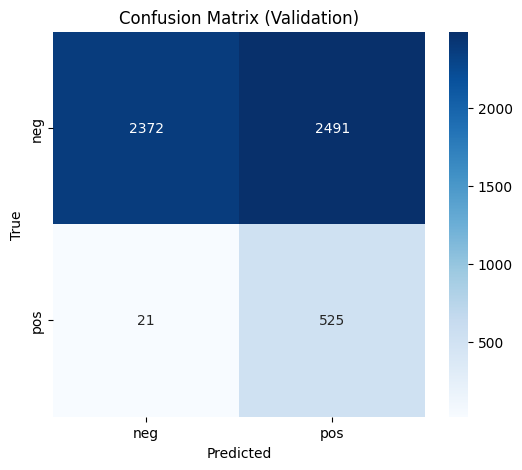

Test Evaluation:   0%|                                                       | 0/511 [00:00<?, ?it/s]

Test Evaluation:   0%|                                               | 1/511 [00:00<04:12,  2.02it/s]

Test Evaluation:   0%|▏                                              | 2/511 [00:01<04:26,  1.91it/s]

Test Evaluation:   1%|▎                                              | 3/511 [00:01<04:17,  1.97it/s]

Test Evaluation:   1%|▎                                              | 4/511 [00:02<04:13,  2.00it/s]

Test Evaluation:   1%|▍                                              | 5/511 [00:02<04:10,  2.02it/s]

Test Evaluation:   1%|▌                                              | 6/511 [00:02<03:59,  2.11it/s]

Test Evaluation:   1%|▋                                              | 7/511 [00:03<04:00,  2.10it/s]

Test Evaluation:   2%|▋                                              | 8/511 [00:03<04:01,  2.09it/s]

Test Evaluation:   2%|▊                                              | 9/511 [00:04<04:01,  2.08it/s]

Test Evaluation:   2%|▉                                             | 10/511 [00:04<03:53,  2.15it/s]

Test Evaluation:   2%|▉                                             | 11/511 [00:05<03:56,  2.11it/s]

Test Evaluation:   2%|█                                             | 12/511 [00:05<03:58,  2.10it/s]

Test Evaluation:   3%|█▏                                            | 13/511 [00:06<03:58,  2.09it/s]

Test Evaluation:   3%|█▎                                            | 14/511 [00:06<03:58,  2.08it/s]

Test Evaluation:   3%|█▎                                            | 15/511 [00:07<03:51,  2.15it/s]

Test Evaluation:   3%|█▍                                            | 16/511 [00:07<03:54,  2.11it/s]

Test Evaluation:   3%|█▌                                            | 17/511 [00:08<03:56,  2.09it/s]

Test Evaluation:   4%|█▌                                            | 18/511 [00:08<03:57,  2.07it/s]

Test Evaluation:   4%|█▋                                            | 19/511 [00:09<03:57,  2.07it/s]

Test Evaluation:   4%|█▊                                            | 20/511 [00:09<03:53,  2.10it/s]

Test Evaluation:   4%|█▉                                            | 21/511 [00:10<03:50,  2.13it/s]

Test Evaluation:   4%|█▉                                            | 22/511 [00:10<03:51,  2.11it/s]

Test Evaluation:   5%|██                                            | 23/511 [00:11<03:53,  2.09it/s]

Test Evaluation:   5%|██▏                                           | 24/511 [00:11<03:49,  2.13it/s]

Test Evaluation:   5%|██▎                                           | 25/511 [00:11<03:48,  2.13it/s]

Test Evaluation:   5%|██▎                                           | 26/511 [00:12<03:49,  2.11it/s]

Test Evaluation:   5%|██▍                                           | 27/511 [00:12<03:50,  2.10it/s]

Test Evaluation:   5%|██▌                                           | 28/511 [00:13<03:44,  2.15it/s]

Test Evaluation:   6%|██▌                                           | 29/511 [00:13<03:47,  2.12it/s]

Test Evaluation:   6%|██▋                                           | 30/511 [00:14<03:49,  2.10it/s]

Test Evaluation:   6%|██▊                                           | 31/511 [00:14<03:51,  2.07it/s]

Test Evaluation:   6%|██▉                                           | 32/511 [00:15<03:44,  2.13it/s]

Test Evaluation:   6%|██▉                                           | 33/511 [00:15<03:46,  2.11it/s]

Test Evaluation:   7%|███                                           | 34/511 [00:16<03:48,  2.09it/s]

Test Evaluation:   7%|███▏                                          | 35/511 [00:16<03:51,  2.06it/s]

Test Evaluation:   7%|███▏                                          | 36/511 [00:17<03:50,  2.06it/s]

Test Evaluation:   7%|███▎                                          | 37/511 [00:17<03:42,  2.13it/s]

Test Evaluation:   7%|███▍                                          | 38/511 [00:18<03:43,  2.11it/s]

Test Evaluation:   8%|███▌                                          | 39/511 [00:18<03:45,  2.09it/s]

Test Evaluation:   8%|███▌                                          | 40/511 [00:19<03:46,  2.08it/s]

Test Evaluation:   8%|███▋                                          | 41/511 [00:19<03:37,  2.16it/s]

Test Evaluation:   8%|███▊                                          | 42/511 [00:20<03:39,  2.14it/s]

Test Evaluation:   8%|███▊                                          | 43/511 [00:20<03:41,  2.11it/s]

Test Evaluation:   9%|███▉                                          | 44/511 [00:20<03:43,  2.09it/s]

Test Evaluation:   9%|████                                          | 45/511 [00:21<03:42,  2.09it/s]

Test Evaluation:   9%|████▏                                         | 46/511 [00:21<03:41,  2.10it/s]

Test Evaluation:   9%|████▏                                         | 47/511 [00:22<03:36,  2.14it/s]

Test Evaluation:   9%|████▎                                         | 48/511 [00:22<03:39,  2.11it/s]

Test Evaluation:  10%|████▍                                         | 49/511 [00:23<03:40,  2.09it/s]

Test Evaluation:  10%|████▌                                         | 50/511 [00:23<03:40,  2.09it/s]

Test Evaluation:  10%|████▌                                         | 51/511 [00:24<03:40,  2.08it/s]

Test Evaluation:  10%|████▋                                         | 52/511 [00:24<03:40,  2.08it/s]

Test Evaluation:  10%|████▊                                         | 53/511 [00:25<03:32,  2.16it/s]

Test Evaluation:  11%|████▊                                         | 54/511 [00:25<03:34,  2.13it/s]

Test Evaluation:  11%|████▉                                         | 55/511 [00:26<03:35,  2.11it/s]

Test Evaluation:  11%|█████                                         | 56/511 [00:26<03:36,  2.10it/s]

Test Evaluation:  11%|█████▏                                        | 57/511 [00:27<03:45,  2.01it/s]

Test Evaluation:  11%|█████▏                                        | 58/511 [00:27<03:43,  2.03it/s]

Test Evaluation:  12%|█████▎                                        | 59/511 [00:28<03:37,  2.08it/s]

Test Evaluation:  12%|█████▍                                        | 60/511 [00:28<03:38,  2.07it/s]

Test Evaluation:  12%|█████▍                                        | 61/511 [00:29<03:37,  2.07it/s]

Test Evaluation:  12%|█████▌                                        | 62/511 [00:29<03:36,  2.08it/s]

Test Evaluation:  12%|█████▋                                        | 63/511 [00:30<03:38,  2.05it/s]

Test Evaluation:  13%|█████▊                                        | 64/511 [00:30<03:36,  2.07it/s]

Test Evaluation:  13%|█████▊                                        | 65/511 [00:31<03:44,  1.99it/s]

Test Evaluation:  13%|█████▉                                        | 66/511 [00:31<03:41,  2.00it/s]

Test Evaluation:  13%|██████                                        | 67/511 [00:32<03:42,  2.00it/s]

Test Evaluation:  13%|██████                                        | 68/511 [00:32<03:44,  1.97it/s]

Test Evaluation:  14%|██████▏                                       | 69/511 [00:33<03:41,  2.00it/s]

Test Evaluation:  14%|██████▎                                       | 70/511 [00:33<03:36,  2.04it/s]

Test Evaluation:  14%|██████▍                                       | 71/511 [00:34<03:36,  2.04it/s]

Test Evaluation:  14%|██████▍                                       | 72/511 [00:34<03:33,  2.05it/s]

Test Evaluation:  14%|██████▌                                       | 73/511 [00:35<03:32,  2.06it/s]

Test Evaluation:  14%|██████▋                                       | 74/511 [00:35<03:31,  2.06it/s]

Test Evaluation:  15%|██████▊                                       | 75/511 [00:36<03:31,  2.06it/s]

Test Evaluation:  15%|██████▊                                       | 76/511 [00:36<03:31,  2.06it/s]

Test Evaluation:  15%|██████▉                                       | 77/511 [00:37<03:31,  2.05it/s]

Test Evaluation:  15%|███████                                       | 78/511 [00:37<03:31,  2.05it/s]

Test Evaluation:  15%|███████                                       | 79/511 [00:37<03:30,  2.05it/s]

Test Evaluation:  16%|███████▏                                      | 80/511 [00:38<03:29,  2.06it/s]

Test Evaluation:  16%|███████▎                                      | 81/511 [00:38<03:27,  2.07it/s]

Test Evaluation:  16%|███████▍                                      | 82/511 [00:39<03:27,  2.07it/s]

Test Evaluation:  16%|███████▍                                      | 83/511 [00:39<03:27,  2.06it/s]

Test Evaluation:  16%|███████▌                                      | 84/511 [00:40<03:26,  2.07it/s]

Test Evaluation:  17%|███████▋                                      | 85/511 [00:40<03:26,  2.07it/s]

Test Evaluation:  17%|███████▋                                      | 86/511 [00:41<03:25,  2.07it/s]

Test Evaluation:  17%|███████▊                                      | 87/511 [00:41<03:25,  2.06it/s]

Test Evaluation:  17%|███████▉                                      | 88/511 [00:42<03:25,  2.06it/s]

Test Evaluation:  17%|████████                                      | 89/511 [00:42<03:23,  2.08it/s]

Test Evaluation:  18%|████████                                      | 90/511 [00:43<03:21,  2.08it/s]

Test Evaluation:  18%|████████▏                                     | 91/511 [00:43<03:22,  2.07it/s]

Test Evaluation:  18%|████████▎                                     | 92/511 [00:44<03:22,  2.07it/s]

Test Evaluation:  18%|████████▎                                     | 93/511 [00:44<03:21,  2.08it/s]

Test Evaluation:  18%|████████▍                                     | 94/511 [00:45<03:20,  2.08it/s]

Test Evaluation:  19%|████████▌                                     | 95/511 [00:45<03:20,  2.08it/s]

Test Evaluation:  19%|████████▋                                     | 96/511 [00:46<03:18,  2.09it/s]

Test Evaluation:  19%|████████▋                                     | 97/511 [00:46<03:17,  2.09it/s]

Test Evaluation:  19%|████████▊                                     | 98/511 [00:47<03:17,  2.09it/s]

Test Evaluation:  19%|████████▉                                     | 99/511 [00:47<03:17,  2.09it/s]

Test Evaluation:  20%|████████▊                                    | 100/511 [00:48<03:12,  2.13it/s]

Test Evaluation:  20%|████████▉                                    | 101/511 [00:48<03:13,  2.12it/s]

Test Evaluation:  20%|████████▉                                    | 102/511 [00:49<03:14,  2.10it/s]

Test Evaluation:  20%|█████████                                    | 103/511 [00:49<03:16,  2.08it/s]

Test Evaluation:  20%|█████████▏                                   | 104/511 [00:49<03:16,  2.07it/s]

Test Evaluation:  21%|█████████▏                                   | 105/511 [00:50<03:15,  2.07it/s]

Test Evaluation:  21%|█████████▎                                   | 106/511 [00:50<03:16,  2.06it/s]

Test Evaluation:  21%|█████████▍                                   | 107/511 [00:51<03:15,  2.07it/s]

Test Evaluation:  21%|█████████▌                                   | 108/511 [00:51<03:14,  2.07it/s]

Test Evaluation:  21%|█████████▌                                   | 109/511 [00:52<03:15,  2.06it/s]

Test Evaluation:  22%|█████████▋                                   | 110/511 [00:52<03:14,  2.06it/s]

Test Evaluation:  22%|█████████▊                                   | 111/511 [00:53<03:14,  2.05it/s]

Test Evaluation:  22%|█████████▊                                   | 112/511 [00:53<03:14,  2.05it/s]

Test Evaluation:  22%|█████████▉                                   | 113/511 [00:54<03:14,  2.05it/s]

Test Evaluation:  22%|██████████                                   | 114/511 [00:54<03:13,  2.05it/s]

Test Evaluation:  23%|██████████▏                                  | 115/511 [00:55<03:11,  2.06it/s]

Test Evaluation:  23%|██████████▏                                  | 116/511 [00:55<03:12,  2.05it/s]

Test Evaluation:  23%|██████████▎                                  | 117/511 [00:56<03:11,  2.05it/s]

Test Evaluation:  23%|██████████▍                                  | 118/511 [00:56<03:10,  2.07it/s]

Test Evaluation:  23%|██████████▍                                  | 119/511 [00:57<03:02,  2.15it/s]

Test Evaluation:  23%|██████████▌                                  | 120/511 [00:57<03:04,  2.12it/s]

Test Evaluation:  24%|██████████▋                                  | 121/511 [00:58<03:05,  2.10it/s]

Test Evaluation:  24%|██████████▋                                  | 122/511 [00:58<03:05,  2.09it/s]

Test Evaluation:  24%|██████████▊                                  | 123/511 [00:59<03:06,  2.09it/s]

Test Evaluation:  24%|██████████▉                                  | 124/511 [00:59<03:05,  2.09it/s]

Test Evaluation:  24%|███████████                                  | 125/511 [01:00<03:05,  2.08it/s]

Test Evaluation:  25%|███████████                                  | 126/511 [01:00<03:04,  2.09it/s]

Test Evaluation:  25%|███████████▏                                 | 127/511 [01:01<03:04,  2.08it/s]

Test Evaluation:  25%|███████████▎                                 | 128/511 [01:01<03:04,  2.07it/s]

Test Evaluation:  25%|███████████▎                                 | 129/511 [01:02<03:04,  2.06it/s]

Test Evaluation:  25%|███████████▍                                 | 130/511 [01:02<03:04,  2.06it/s]

Test Evaluation:  26%|███████████▌                                 | 131/511 [01:03<03:04,  2.07it/s]

Test Evaluation:  26%|███████████▌                                 | 132/511 [01:03<03:03,  2.07it/s]

Test Evaluation:  26%|███████████▋                                 | 133/511 [01:03<03:02,  2.07it/s]

Test Evaluation:  26%|███████████▊                                 | 134/511 [01:04<03:01,  2.08it/s]

Test Evaluation:  26%|███████████▉                                 | 135/511 [01:04<03:02,  2.06it/s]

Test Evaluation:  27%|███████████▉                                 | 136/511 [01:05<03:02,  2.06it/s]

Test Evaluation:  27%|████████████                                 | 137/511 [01:05<03:01,  2.06it/s]

Test Evaluation:  27%|████████████▏                                | 138/511 [01:06<03:00,  2.07it/s]

Test Evaluation:  27%|████████████▏                                | 139/511 [01:06<03:00,  2.06it/s]

Test Evaluation:  27%|████████████▎                                | 140/511 [01:07<02:59,  2.07it/s]

Test Evaluation:  28%|████████████▍                                | 141/511 [01:07<02:58,  2.08it/s]

Test Evaluation:  28%|████████████▌                                | 142/511 [01:08<02:57,  2.08it/s]

Test Evaluation:  28%|████████████▌                                | 143/511 [01:08<02:56,  2.08it/s]

Test Evaluation:  28%|████████████▋                                | 144/511 [01:09<02:56,  2.08it/s]

Test Evaluation:  28%|████████████▊                                | 145/511 [01:09<02:57,  2.07it/s]

Test Evaluation:  29%|████████████▊                                | 146/511 [01:10<02:55,  2.08it/s]

Test Evaluation:  29%|████████████▉                                | 147/511 [01:10<02:54,  2.08it/s]

Test Evaluation:  29%|█████████████                                | 148/511 [01:11<02:54,  2.08it/s]

Test Evaluation:  29%|█████████████                                | 149/511 [01:11<02:56,  2.05it/s]

Test Evaluation:  29%|█████████████▏                               | 150/511 [01:12<02:56,  2.05it/s]

Test Evaluation:  30%|█████████████▎                               | 151/511 [01:12<02:54,  2.06it/s]

Test Evaluation:  30%|█████████████▍                               | 152/511 [01:13<02:52,  2.08it/s]

Test Evaluation:  30%|█████████████▍                               | 153/511 [01:13<02:53,  2.07it/s]

Test Evaluation:  30%|█████████████▌                               | 154/511 [01:14<02:52,  2.07it/s]

Test Evaluation:  30%|█████████████▋                               | 155/511 [01:14<02:51,  2.07it/s]

Test Evaluation:  31%|█████████████▋                               | 156/511 [01:15<02:51,  2.07it/s]

Test Evaluation:  31%|█████████████▊                               | 157/511 [01:15<02:51,  2.07it/s]

Test Evaluation:  31%|█████████████▉                               | 158/511 [01:16<02:50,  2.07it/s]

Test Evaluation:  31%|██████████████                               | 159/511 [01:16<02:43,  2.15it/s]

Test Evaluation:  31%|██████████████                               | 160/511 [01:16<02:45,  2.11it/s]

Test Evaluation:  32%|██████████████▏                              | 161/511 [01:17<02:46,  2.10it/s]

Test Evaluation:  32%|██████████████▎                              | 162/511 [01:17<02:46,  2.09it/s]

Test Evaluation:  32%|██████████████▎                              | 163/511 [01:18<02:48,  2.07it/s]

Test Evaluation:  32%|██████████████▍                              | 164/511 [01:18<02:50,  2.04it/s]

Test Evaluation:  32%|██████████████▌                              | 165/511 [01:19<02:51,  2.02it/s]

Test Evaluation:  32%|██████████████▌                              | 166/511 [01:19<02:49,  2.04it/s]

Test Evaluation:  33%|██████████████▋                              | 167/511 [01:20<02:47,  2.06it/s]

Test Evaluation:  33%|██████████████▊                              | 168/511 [01:20<02:46,  2.06it/s]

Test Evaluation:  33%|██████████████▉                              | 169/511 [01:21<02:46,  2.05it/s]

Test Evaluation:  33%|██████████████▉                              | 170/511 [01:21<02:45,  2.06it/s]

Test Evaluation:  33%|███████████████                              | 171/511 [01:22<02:44,  2.07it/s]

Test Evaluation:  34%|███████████████▏                             | 172/511 [01:22<02:43,  2.07it/s]

Test Evaluation:  34%|███████████████▏                             | 173/511 [01:23<02:42,  2.07it/s]

Test Evaluation:  34%|███████████████▎                             | 174/511 [01:23<02:43,  2.07it/s]

Test Evaluation:  34%|███████████████▍                             | 175/511 [01:24<02:42,  2.07it/s]

Test Evaluation:  34%|███████████████▍                             | 176/511 [01:24<02:42,  2.07it/s]

Test Evaluation:  35%|███████████████▌                             | 177/511 [01:25<02:39,  2.10it/s]

Test Evaluation:  35%|███████████████▋                             | 178/511 [01:25<02:36,  2.13it/s]

Test Evaluation:  35%|███████████████▊                             | 179/511 [01:26<02:36,  2.12it/s]

Test Evaluation:  35%|███████████████▊                             | 180/511 [01:26<02:38,  2.09it/s]

Test Evaluation:  35%|███████████████▉                             | 181/511 [01:27<02:38,  2.08it/s]

Test Evaluation:  36%|████████████████                             | 182/511 [01:27<02:39,  2.07it/s]

Test Evaluation:  36%|████████████████                             | 183/511 [01:28<02:38,  2.07it/s]

Test Evaluation:  36%|████████████████▏                            | 184/511 [01:28<02:38,  2.06it/s]

Test Evaluation:  36%|████████████████▎                            | 185/511 [01:29<02:38,  2.05it/s]

Test Evaluation:  36%|████████████████▍                            | 186/511 [01:29<02:37,  2.06it/s]

Test Evaluation:  37%|████████████████▍                            | 187/511 [01:30<02:36,  2.06it/s]

Test Evaluation:  37%|████████████████▌                            | 188/511 [01:30<02:36,  2.06it/s]

Test Evaluation:  37%|████████████████▋                            | 189/511 [01:31<02:35,  2.07it/s]

Test Evaluation:  37%|████████████████▋                            | 190/511 [01:31<02:35,  2.07it/s]

Test Evaluation:  37%|████████████████▊                            | 191/511 [01:31<02:35,  2.06it/s]

Test Evaluation:  38%|████████████████▉                            | 192/511 [01:32<02:34,  2.06it/s]

Test Evaluation:  38%|████████████████▉                            | 193/511 [01:32<02:35,  2.04it/s]

Test Evaluation:  38%|█████████████████                            | 194/511 [01:33<02:33,  2.06it/s]

Test Evaluation:  38%|█████████████████▏                           | 195/511 [01:33<02:32,  2.07it/s]

Test Evaluation:  38%|█████████████████▎                           | 196/511 [01:34<02:31,  2.08it/s]

Test Evaluation:  39%|█████████████████▎                           | 197/511 [01:34<02:32,  2.06it/s]

Test Evaluation:  39%|█████████████████▍                           | 198/511 [01:35<02:32,  2.06it/s]

Test Evaluation:  39%|█████████████████▌                           | 199/511 [01:35<02:32,  2.05it/s]

Test Evaluation:  39%|█████████████████▌                           | 200/511 [01:36<02:31,  2.05it/s]

Test Evaluation:  39%|█████████████████▋                           | 201/511 [01:36<02:30,  2.06it/s]

Test Evaluation:  40%|█████████████████▊                           | 202/511 [01:37<02:30,  2.06it/s]

Test Evaluation:  40%|█████████████████▉                           | 203/511 [01:37<02:29,  2.06it/s]

Test Evaluation:  40%|█████████████████▉                           | 204/511 [01:38<02:29,  2.06it/s]

Test Evaluation:  40%|██████████████████                           | 205/511 [01:38<02:28,  2.06it/s]

Test Evaluation:  40%|██████████████████▏                          | 206/511 [01:39<02:27,  2.07it/s]

Test Evaluation:  41%|██████████████████▏                          | 207/511 [01:39<02:23,  2.12it/s]

Test Evaluation:  41%|██████████████████▎                          | 208/511 [01:40<02:24,  2.10it/s]

Test Evaluation:  41%|██████████████████▍                          | 209/511 [01:40<02:24,  2.08it/s]

Test Evaluation:  41%|██████████████████▍                          | 210/511 [01:41<02:23,  2.09it/s]

Test Evaluation:  41%|██████████████████▌                          | 211/511 [01:41<02:24,  2.08it/s]

Test Evaluation:  41%|██████████████████▋                          | 212/511 [01:42<02:23,  2.08it/s]

Test Evaluation:  42%|██████████████████▊                          | 213/511 [01:42<02:24,  2.06it/s]

Test Evaluation:  42%|██████████████████▊                          | 214/511 [01:43<02:24,  2.06it/s]

Test Evaluation:  42%|██████████████████▉                          | 215/511 [01:43<02:23,  2.06it/s]

Test Evaluation:  42%|███████████████████                          | 216/511 [01:44<02:22,  2.07it/s]

Test Evaluation:  42%|███████████████████                          | 217/511 [01:44<02:24,  2.03it/s]

Test Evaluation:  43%|███████████████████▏                         | 218/511 [01:45<02:23,  2.04it/s]

Test Evaluation:  43%|███████████████████▎                         | 219/511 [01:45<02:24,  2.02it/s]

Test Evaluation:  43%|███████████████████▎                         | 220/511 [01:46<02:22,  2.04it/s]

Test Evaluation:  43%|███████████████████▍                         | 221/511 [01:46<02:21,  2.05it/s]

Test Evaluation:  43%|███████████████████▌                         | 222/511 [01:47<02:20,  2.05it/s]

Test Evaluation:  44%|███████████████████▋                         | 223/511 [01:47<02:19,  2.07it/s]

Test Evaluation:  44%|███████████████████▋                         | 224/511 [01:48<02:21,  2.02it/s]

Test Evaluation:  44%|███████████████████▊                         | 225/511 [01:48<02:20,  2.03it/s]

Test Evaluation:  44%|███████████████████▉                         | 226/511 [01:48<02:20,  2.03it/s]

Test Evaluation:  44%|███████████████████▉                         | 227/511 [01:49<02:20,  2.02it/s]

Test Evaluation:  45%|████████████████████                         | 228/511 [01:49<02:18,  2.04it/s]

Test Evaluation:  45%|████████████████████▏                        | 229/511 [01:50<02:18,  2.03it/s]

Test Evaluation:  45%|████████████████████▎                        | 230/511 [01:50<02:16,  2.05it/s]

Test Evaluation:  45%|████████████████████▎                        | 231/511 [01:51<02:14,  2.07it/s]

Test Evaluation:  45%|████████████████████▍                        | 232/511 [01:51<02:14,  2.07it/s]

Test Evaluation:  46%|████████████████████▌                        | 233/511 [01:52<02:15,  2.06it/s]

Test Evaluation:  46%|████████████████████▌                        | 234/511 [01:52<02:15,  2.05it/s]

Test Evaluation:  46%|████████████████████▋                        | 235/511 [01:53<02:14,  2.05it/s]

Test Evaluation:  46%|████████████████████▊                        | 236/511 [01:53<02:13,  2.05it/s]

Test Evaluation:  46%|████████████████████▊                        | 237/511 [01:54<02:12,  2.06it/s]

Test Evaluation:  47%|████████████████████▉                        | 238/511 [01:54<02:13,  2.04it/s]

Test Evaluation:  47%|█████████████████████                        | 239/511 [01:55<02:12,  2.05it/s]

Test Evaluation:  47%|█████████████████████▏                       | 240/511 [01:55<02:11,  2.05it/s]

Test Evaluation:  47%|█████████████████████▏                       | 241/511 [01:56<02:11,  2.05it/s]

Test Evaluation:  47%|█████████████████████▎                       | 242/511 [01:56<02:11,  2.04it/s]

Test Evaluation:  48%|█████████████████████▍                       | 243/511 [01:57<02:10,  2.05it/s]

Test Evaluation:  48%|█████████████████████▍                       | 244/511 [01:57<02:10,  2.05it/s]

Test Evaluation:  48%|█████████████████████▌                       | 245/511 [01:58<02:08,  2.07it/s]

Test Evaluation:  48%|█████████████████████▋                       | 246/511 [01:58<02:04,  2.12it/s]

Test Evaluation:  48%|█████████████████████▊                       | 247/511 [01:59<02:05,  2.11it/s]

Test Evaluation:  49%|█████████████████████▊                       | 248/511 [01:59<02:04,  2.12it/s]

Test Evaluation:  49%|█████████████████████▉                       | 249/511 [02:00<02:04,  2.10it/s]

Test Evaluation:  49%|██████████████████████                       | 250/511 [02:00<02:04,  2.10it/s]

Test Evaluation:  49%|██████████████████████                       | 251/511 [02:01<02:04,  2.09it/s]

Test Evaluation:  49%|██████████████████████▏                      | 252/511 [02:01<02:03,  2.10it/s]

Test Evaluation:  50%|██████████████████████▎                      | 253/511 [02:02<02:04,  2.07it/s]

Test Evaluation:  50%|██████████████████████▎                      | 254/511 [02:02<02:04,  2.06it/s]

Test Evaluation:  50%|██████████████████████▍                      | 255/511 [02:03<02:03,  2.07it/s]

Test Evaluation:  50%|██████████████████████▌                      | 256/511 [02:03<02:03,  2.06it/s]

Test Evaluation:  50%|██████████████████████▋                      | 257/511 [02:04<02:03,  2.05it/s]

Test Evaluation:  50%|██████████████████████▋                      | 258/511 [02:04<02:03,  2.06it/s]

Test Evaluation:  51%|██████████████████████▊                      | 259/511 [02:04<02:02,  2.05it/s]

Test Evaluation:  51%|██████████████████████▉                      | 260/511 [02:05<02:01,  2.06it/s]

Test Evaluation:  51%|██████████████████████▉                      | 261/511 [02:05<02:01,  2.06it/s]

Test Evaluation:  51%|███████████████████████                      | 262/511 [02:06<02:01,  2.06it/s]

Test Evaluation:  51%|███████████████████████▏                     | 263/511 [02:06<02:00,  2.06it/s]

Test Evaluation:  52%|███████████████████████▏                     | 264/511 [02:07<02:00,  2.06it/s]

Test Evaluation:  52%|███████████████████████▎                     | 265/511 [02:07<01:59,  2.05it/s]

Test Evaluation:  52%|███████████████████████▍                     | 266/511 [02:08<01:58,  2.06it/s]

Test Evaluation:  52%|███████████████████████▌                     | 267/511 [02:08<01:58,  2.06it/s]

Test Evaluation:  52%|███████████████████████▌                     | 268/511 [02:09<01:58,  2.05it/s]

Test Evaluation:  53%|███████████████████████▋                     | 269/511 [02:09<01:57,  2.05it/s]

Test Evaluation:  53%|███████████████████████▊                     | 270/511 [02:10<01:57,  2.06it/s]

Test Evaluation:  53%|███████████████████████▊                     | 271/511 [02:10<01:56,  2.06it/s]

Test Evaluation:  53%|███████████████████████▉                     | 272/511 [02:11<01:55,  2.07it/s]

Test Evaluation:  53%|████████████████████████                     | 273/511 [02:11<01:54,  2.08it/s]

Test Evaluation:  54%|████████████████████████▏                    | 274/511 [02:12<01:50,  2.15it/s]

Test Evaluation:  54%|████████████████████████▏                    | 275/511 [02:12<01:51,  2.11it/s]

Test Evaluation:  54%|████████████████████████▎                    | 276/511 [02:13<01:52,  2.10it/s]

Test Evaluation:  54%|████████████████████████▍                    | 277/511 [02:13<01:52,  2.08it/s]

Test Evaluation:  54%|████████████████████████▍                    | 278/511 [02:14<01:52,  2.07it/s]

Test Evaluation:  55%|████████████████████████▌                    | 279/511 [02:14<01:52,  2.06it/s]

Test Evaluation:  55%|████████████████████████▋                    | 280/511 [02:15<01:52,  2.06it/s]

Test Evaluation:  55%|████████████████████████▋                    | 281/511 [02:15<01:52,  2.05it/s]

Test Evaluation:  55%|████████████████████████▊                    | 282/511 [02:16<01:50,  2.07it/s]

Test Evaluation:  55%|████████████████████████▉                    | 283/511 [02:16<01:50,  2.07it/s]

Test Evaluation:  56%|█████████████████████████                    | 284/511 [02:17<01:49,  2.06it/s]

Test Evaluation:  56%|█████████████████████████                    | 285/511 [02:17<01:49,  2.06it/s]

Test Evaluation:  56%|█████████████████████████▏                   | 286/511 [02:18<01:48,  2.07it/s]

Test Evaluation:  56%|█████████████████████████▎                   | 287/511 [02:18<01:48,  2.06it/s]

Test Evaluation:  56%|█████████████████████████▎                   | 288/511 [02:18<01:48,  2.06it/s]

Test Evaluation:  57%|█████████████████████████▍                   | 289/511 [02:19<01:48,  2.05it/s]

Test Evaluation:  57%|█████████████████████████▌                   | 290/511 [02:19<01:48,  2.04it/s]

Test Evaluation:  57%|█████████████████████████▋                   | 291/511 [02:20<01:47,  2.05it/s]

Test Evaluation:  57%|█████████████████████████▋                   | 292/511 [02:20<01:46,  2.05it/s]

Test Evaluation:  57%|█████████████████████████▊                   | 293/511 [02:21<01:46,  2.05it/s]

Test Evaluation:  58%|█████████████████████████▉                   | 294/511 [02:21<01:45,  2.06it/s]

Test Evaluation:  58%|█████████████████████████▉                   | 295/511 [02:22<01:44,  2.06it/s]

Test Evaluation:  58%|██████████████████████████                   | 296/511 [02:22<01:44,  2.05it/s]

Test Evaluation:  58%|██████████████████████████▏                  | 297/511 [02:23<01:44,  2.05it/s]

Test Evaluation:  58%|██████████████████████████▏                  | 298/511 [02:23<01:43,  2.05it/s]

Test Evaluation:  59%|██████████████████████████▎                  | 299/511 [02:24<01:43,  2.06it/s]

Test Evaluation:  59%|██████████████████████████▍                  | 300/511 [02:24<01:43,  2.05it/s]

Test Evaluation:  59%|██████████████████████████▌                  | 301/511 [02:25<01:42,  2.05it/s]

Test Evaluation:  59%|██████████████████████████▌                  | 302/511 [02:25<01:41,  2.06it/s]

Test Evaluation:  59%|██████████████████████████▋                  | 303/511 [02:26<01:41,  2.05it/s]

Test Evaluation:  59%|██████████████████████████▊                  | 304/511 [02:26<01:41,  2.05it/s]

Test Evaluation:  60%|██████████████████████████▊                  | 305/511 [02:27<01:40,  2.05it/s]

Test Evaluation:  60%|██████████████████████████▉                  | 306/511 [02:27<01:40,  2.04it/s]

Test Evaluation:  60%|███████████████████████████                  | 307/511 [02:28<01:39,  2.04it/s]

Test Evaluation:  60%|███████████████████████████                  | 308/511 [02:28<01:39,  2.05it/s]

Test Evaluation:  60%|███████████████████████████▏                 | 309/511 [02:29<01:38,  2.04it/s]

Test Evaluation:  61%|███████████████████████████▎                 | 310/511 [02:29<01:38,  2.04it/s]

Test Evaluation:  61%|███████████████████████████▍                 | 311/511 [02:30<01:35,  2.09it/s]

Test Evaluation:  61%|███████████████████████████▍                 | 312/511 [02:30<01:34,  2.10it/s]

Test Evaluation:  61%|███████████████████████████▌                 | 313/511 [02:31<01:35,  2.08it/s]

Test Evaluation:  61%|███████████████████████████▋                 | 314/511 [02:31<01:34,  2.08it/s]

Test Evaluation:  62%|███████████████████████████▋                 | 315/511 [02:32<01:34,  2.07it/s]

Test Evaluation:  62%|███████████████████████████▊                 | 316/511 [02:32<01:34,  2.06it/s]

Test Evaluation:  62%|███████████████████████████▉                 | 317/511 [02:33<01:34,  2.06it/s]

Test Evaluation:  62%|████████████████████████████                 | 318/511 [02:33<01:33,  2.07it/s]

Test Evaluation:  62%|████████████████████████████                 | 319/511 [02:34<01:33,  2.06it/s]

Test Evaluation:  63%|████████████████████████████▏                | 320/511 [02:34<01:32,  2.06it/s]

Test Evaluation:  63%|████████████████████████████▎                | 321/511 [02:35<01:32,  2.06it/s]

Test Evaluation:  63%|████████████████████████████▎                | 322/511 [02:35<01:31,  2.07it/s]

Test Evaluation:  63%|████████████████████████████▍                | 323/511 [02:35<01:30,  2.07it/s]

Test Evaluation:  63%|████████████████████████████▌                | 324/511 [02:36<01:30,  2.07it/s]

Test Evaluation:  64%|████████████████████████████▌                | 325/511 [02:36<01:29,  2.07it/s]

Test Evaluation:  64%|████████████████████████████▋                | 326/511 [02:37<01:29,  2.06it/s]

Test Evaluation:  64%|████████████████████████████▊                | 327/511 [02:37<01:29,  2.05it/s]

Test Evaluation:  64%|████████████████████████████▉                | 328/511 [02:38<01:29,  2.05it/s]

Test Evaluation:  64%|████████████████████████████▉                | 329/511 [02:38<01:28,  2.05it/s]

Test Evaluation:  65%|█████████████████████████████                | 330/511 [02:39<01:28,  2.05it/s]

Test Evaluation:  65%|█████████████████████████████▏               | 331/511 [02:39<01:28,  2.04it/s]

Test Evaluation:  65%|█████████████████████████████▏               | 332/511 [02:40<01:27,  2.05it/s]

Test Evaluation:  65%|█████████████████████████████▎               | 333/511 [02:40<01:26,  2.05it/s]

Test Evaluation:  65%|█████████████████████████████▍               | 334/511 [02:41<01:25,  2.06it/s]

Test Evaluation:  66%|█████████████████████████████▌               | 335/511 [02:41<01:25,  2.05it/s]

Test Evaluation:  66%|█████████████████████████████▌               | 336/511 [02:42<01:25,  2.05it/s]

Test Evaluation:  66%|█████████████████████████████▋               | 337/511 [02:42<01:24,  2.05it/s]

Test Evaluation:  66%|█████████████████████████████▊               | 338/511 [02:43<01:24,  2.05it/s]

Test Evaluation:  66%|█████████████████████████████▊               | 339/511 [02:43<01:21,  2.12it/s]

Test Evaluation:  67%|█████████████████████████████▉               | 340/511 [02:44<01:21,  2.09it/s]

Test Evaluation:  67%|██████████████████████████████               | 341/511 [02:44<01:22,  2.07it/s]

Test Evaluation:  67%|██████████████████████████████               | 342/511 [02:45<01:21,  2.07it/s]

Test Evaluation:  67%|██████████████████████████████▏              | 343/511 [02:45<01:21,  2.07it/s]

Test Evaluation:  67%|██████████████████████████████▎              | 344/511 [02:46<01:20,  2.08it/s]

Test Evaluation:  68%|██████████████████████████████▍              | 345/511 [02:46<01:19,  2.08it/s]

Test Evaluation:  68%|██████████████████████████████▍              | 346/511 [02:47<01:19,  2.08it/s]

Test Evaluation:  68%|██████████████████████████████▌              | 347/511 [02:47<01:18,  2.08it/s]

Test Evaluation:  68%|██████████████████████████████▋              | 348/511 [02:48<01:18,  2.07it/s]

Test Evaluation:  68%|██████████████████████████████▋              | 349/511 [02:48<01:18,  2.06it/s]

Test Evaluation:  68%|██████████████████████████████▊              | 350/511 [02:49<01:18,  2.06it/s]

Test Evaluation:  69%|██████████████████████████████▉              | 351/511 [02:49<01:17,  2.06it/s]

Test Evaluation:  69%|██████████████████████████████▉              | 352/511 [02:50<01:17,  2.06it/s]

Test Evaluation:  69%|███████████████████████████████              | 353/511 [02:50<01:17,  2.05it/s]

Test Evaluation:  69%|███████████████████████████████▏             | 354/511 [02:51<01:16,  2.06it/s]

Test Evaluation:  69%|███████████████████████████████▎             | 355/511 [02:51<01:15,  2.06it/s]

Test Evaluation:  70%|███████████████████████████████▎             | 356/511 [02:51<01:15,  2.06it/s]

Test Evaluation:  70%|███████████████████████████████▍             | 357/511 [02:52<01:14,  2.06it/s]

Test Evaluation:  70%|███████████████████████████████▌             | 358/511 [02:52<01:13,  2.07it/s]

Test Evaluation:  70%|███████████████████████████████▌             | 359/511 [02:53<01:13,  2.07it/s]

Test Evaluation:  70%|███████████████████████████████▋             | 360/511 [02:53<01:12,  2.07it/s]

Test Evaluation:  71%|███████████████████████████████▊             | 361/511 [02:54<01:12,  2.06it/s]

Test Evaluation:  71%|███████████████████████████████▉             | 362/511 [02:54<01:12,  2.07it/s]

Test Evaluation:  71%|███████████████████████████████▉             | 363/511 [02:55<01:11,  2.07it/s]

Test Evaluation:  71%|████████████████████████████████             | 364/511 [02:55<01:11,  2.06it/s]

Test Evaluation:  71%|████████████████████████████████▏            | 365/511 [02:56<01:08,  2.12it/s]

Test Evaluation:  72%|████████████████████████████████▏            | 366/511 [02:56<01:09,  2.10it/s]

Test Evaluation:  72%|████████████████████████████████▎            | 367/511 [02:57<01:09,  2.09it/s]

Test Evaluation:  72%|████████████████████████████████▍            | 368/511 [02:57<01:08,  2.08it/s]

Test Evaluation:  72%|████████████████████████████████▍            | 369/511 [02:58<01:08,  2.08it/s]

Test Evaluation:  72%|████████████████████████████████▌            | 370/511 [02:58<01:08,  2.06it/s]

Test Evaluation:  73%|████████████████████████████████▋            | 371/511 [02:59<01:07,  2.06it/s]

Test Evaluation:  73%|████████████████████████████████▊            | 372/511 [02:59<01:07,  2.06it/s]

Test Evaluation:  73%|████████████████████████████████▊            | 373/511 [03:00<01:06,  2.07it/s]

Test Evaluation:  73%|████████████████████████████████▉            | 374/511 [03:00<01:05,  2.08it/s]

Test Evaluation:  73%|█████████████████████████████████            | 375/511 [03:01<01:05,  2.08it/s]

Test Evaluation:  74%|█████████████████████████████████            | 376/511 [03:01<01:05,  2.07it/s]

Test Evaluation:  74%|█████████████████████████████████▏           | 377/511 [03:02<01:04,  2.07it/s]

Test Evaluation:  74%|█████████████████████████████████▎           | 378/511 [03:02<01:04,  2.06it/s]

Test Evaluation:  74%|█████████████████████████████████▍           | 379/511 [03:03<01:03,  2.07it/s]

Test Evaluation:  74%|█████████████████████████████████▍           | 380/511 [03:03<01:03,  2.07it/s]

Test Evaluation:  75%|█████████████████████████████████▌           | 381/511 [03:04<01:03,  2.06it/s]

Test Evaluation:  75%|█████████████████████████████████▋           | 382/511 [03:04<01:02,  2.07it/s]

Test Evaluation:  75%|█████████████████████████████████▋           | 383/511 [03:05<01:01,  2.08it/s]

Test Evaluation:  75%|█████████████████████████████████▊           | 384/511 [03:05<01:01,  2.07it/s]

Test Evaluation:  75%|█████████████████████████████████▉           | 385/511 [03:05<01:01,  2.06it/s]

Test Evaluation:  76%|█████████████████████████████████▉           | 386/511 [03:06<01:00,  2.06it/s]

Test Evaluation:  76%|██████████████████████████████████           | 387/511 [03:06<01:00,  2.04it/s]

Test Evaluation:  76%|██████████████████████████████████▏          | 388/511 [03:07<01:00,  2.04it/s]

Test Evaluation:  76%|██████████████████████████████████▎          | 389/511 [03:07<00:59,  2.05it/s]

Test Evaluation:  76%|██████████████████████████████████▎          | 390/511 [03:08<00:59,  2.04it/s]

Test Evaluation:  77%|██████████████████████████████████▍          | 391/511 [03:08<00:58,  2.04it/s]

Test Evaluation:  77%|██████████████████████████████████▌          | 392/511 [03:09<00:58,  2.04it/s]

Test Evaluation:  77%|██████████████████████████████████▌          | 393/511 [03:09<00:57,  2.05it/s]

Test Evaluation:  77%|██████████████████████████████████▋          | 394/511 [03:10<00:57,  2.05it/s]

Test Evaluation:  77%|██████████████████████████████████▊          | 395/511 [03:10<00:56,  2.06it/s]

Test Evaluation:  77%|██████████████████████████████████▊          | 396/511 [03:11<00:56,  2.05it/s]

Test Evaluation:  78%|██████████████████████████████████▉          | 397/511 [03:11<00:55,  2.04it/s]

Test Evaluation:  78%|███████████████████████████████████          | 398/511 [03:12<00:54,  2.06it/s]

Test Evaluation:  78%|███████████████████████████████████▏         | 399/511 [03:12<00:54,  2.06it/s]

Test Evaluation:  78%|███████████████████████████████████▏         | 400/511 [03:13<00:53,  2.06it/s]

Test Evaluation:  78%|███████████████████████████████████▎         | 401/511 [03:13<00:53,  2.06it/s]

Test Evaluation:  79%|███████████████████████████████████▍         | 402/511 [03:14<00:52,  2.06it/s]

Test Evaluation:  79%|███████████████████████████████████▍         | 403/511 [03:14<00:52,  2.05it/s]

Test Evaluation:  79%|███████████████████████████████████▌         | 404/511 [03:15<00:52,  2.05it/s]

Test Evaluation:  79%|███████████████████████████████████▋         | 405/511 [03:15<00:51,  2.04it/s]

Test Evaluation:  79%|███████████████████████████████████▊         | 406/511 [03:16<00:51,  2.05it/s]

Test Evaluation:  80%|███████████████████████████████████▊         | 407/511 [03:16<00:50,  2.06it/s]

Test Evaluation:  80%|███████████████████████████████████▉         | 408/511 [03:17<00:50,  2.05it/s]

Test Evaluation:  80%|████████████████████████████████████         | 409/511 [03:17<00:49,  2.04it/s]

Test Evaluation:  80%|████████████████████████████████████         | 410/511 [03:18<00:47,  2.13it/s]

Test Evaluation:  80%|████████████████████████████████████▏        | 411/511 [03:18<00:47,  2.11it/s]

Test Evaluation:  81%|████████████████████████████████████▎        | 412/511 [03:19<00:47,  2.09it/s]

Test Evaluation:  81%|████████████████████████████████████▎        | 413/511 [03:19<00:47,  2.08it/s]

Test Evaluation:  81%|████████████████████████████████████▍        | 414/511 [03:20<00:46,  2.08it/s]

Test Evaluation:  81%|████████████████████████████████████▌        | 415/511 [03:20<00:46,  2.06it/s]

Test Evaluation:  81%|████████████████████████████████████▋        | 416/511 [03:21<00:46,  2.04it/s]

Test Evaluation:  82%|████████████████████████████████████▋        | 417/511 [03:21<00:46,  2.03it/s]

Test Evaluation:  82%|████████████████████████████████████▊        | 418/511 [03:22<00:45,  2.03it/s]

Test Evaluation:  82%|████████████████████████████████████▉        | 419/511 [03:22<00:44,  2.05it/s]

Test Evaluation:  82%|████████████████████████████████████▉        | 420/511 [03:23<00:44,  2.05it/s]

Test Evaluation:  82%|█████████████████████████████████████        | 421/511 [03:23<00:43,  2.06it/s]

Test Evaluation:  83%|█████████████████████████████████████▏       | 422/511 [03:23<00:43,  2.05it/s]

Test Evaluation:  83%|█████████████████████████████████████▎       | 423/511 [03:24<00:43,  2.04it/s]

Test Evaluation:  83%|█████████████████████████████████████▎       | 424/511 [03:24<00:42,  2.05it/s]

Test Evaluation:  83%|█████████████████████████████████████▍       | 425/511 [03:25<00:42,  2.05it/s]

Test Evaluation:  83%|█████████████████████████████████████▌       | 426/511 [03:25<00:41,  2.04it/s]

Test Evaluation:  84%|█████████████████████████████████████▌       | 427/511 [03:26<00:41,  2.04it/s]

Test Evaluation:  84%|█████████████████████████████████████▋       | 428/511 [03:26<00:40,  2.05it/s]

Test Evaluation:  84%|█████████████████████████████████████▊       | 429/511 [03:27<00:40,  2.04it/s]

Test Evaluation:  84%|█████████████████████████████████████▊       | 430/511 [03:27<00:39,  2.05it/s]

Test Evaluation:  84%|█████████████████████████████████████▉       | 431/511 [03:28<00:39,  2.03it/s]

Test Evaluation:  85%|██████████████████████████████████████       | 432/511 [03:28<00:38,  2.04it/s]

Test Evaluation:  85%|██████████████████████████████████████▏      | 433/511 [03:29<00:38,  2.05it/s]

Test Evaluation:  85%|██████████████████████████████████████▏      | 434/511 [03:29<00:36,  2.12it/s]

Test Evaluation:  85%|██████████████████████████████████████▎      | 435/511 [03:30<00:36,  2.09it/s]

Test Evaluation:  85%|██████████████████████████████████████▍      | 436/511 [03:30<00:36,  2.08it/s]

Test Evaluation:  86%|██████████████████████████████████████▍      | 437/511 [03:31<00:35,  2.06it/s]

Test Evaluation:  86%|██████████████████████████████████████▌      | 438/511 [03:31<00:35,  2.06it/s]

Test Evaluation:  86%|██████████████████████████████████████▋      | 439/511 [03:32<00:34,  2.06it/s]

Test Evaluation:  86%|██████████████████████████████████████▋      | 440/511 [03:32<00:34,  2.03it/s]

Test Evaluation:  86%|██████████████████████████████████████▊      | 441/511 [03:33<00:34,  2.05it/s]

Test Evaluation:  86%|██████████████████████████████████████▉      | 442/511 [03:33<00:33,  2.04it/s]

Test Evaluation:  87%|███████████████████████████████████████      | 443/511 [03:34<00:33,  2.04it/s]

Test Evaluation:  87%|███████████████████████████████████████      | 444/511 [03:34<00:32,  2.04it/s]

Test Evaluation:  87%|███████████████████████████████████████▏     | 445/511 [03:35<00:32,  2.05it/s]

Test Evaluation:  87%|███████████████████████████████████████▎     | 446/511 [03:35<00:31,  2.05it/s]

Test Evaluation:  87%|███████████████████████████████████████▎     | 447/511 [03:36<00:31,  2.05it/s]

Test Evaluation:  88%|███████████████████████████████████████▍     | 448/511 [03:36<00:30,  2.06it/s]

Test Evaluation:  88%|███████████████████████████████████████▌     | 449/511 [03:37<00:30,  2.06it/s]

Test Evaluation:  88%|███████████████████████████████████████▋     | 450/511 [03:37<00:29,  2.06it/s]

Test Evaluation:  88%|███████████████████████████████████████▋     | 451/511 [03:38<00:29,  2.07it/s]

Test Evaluation:  88%|███████████████████████████████████████▊     | 452/511 [03:38<00:28,  2.06it/s]

Test Evaluation:  89%|███████████████████████████████████████▉     | 453/511 [03:39<00:28,  2.05it/s]

Test Evaluation:  89%|███████████████████████████████████████▉     | 454/511 [03:39<00:27,  2.05it/s]

Test Evaluation:  89%|████████████████████████████████████████     | 455/511 [03:40<00:27,  2.05it/s]

Test Evaluation:  89%|████████████████████████████████████████▏    | 456/511 [03:40<00:26,  2.05it/s]

Test Evaluation:  89%|████████████████████████████████████████▏    | 457/511 [03:41<00:26,  2.05it/s]

Test Evaluation:  90%|████████████████████████████████████████▎    | 458/511 [03:41<00:25,  2.06it/s]

Test Evaluation:  90%|████████████████████████████████████████▍    | 459/511 [03:42<00:25,  2.06it/s]

Test Evaluation:  90%|████████████████████████████████████████▌    | 460/511 [03:42<00:24,  2.07it/s]

Test Evaluation:  90%|████████████████████████████████████████▌    | 461/511 [03:42<00:24,  2.06it/s]

Test Evaluation:  90%|████████████████████████████████████████▋    | 462/511 [03:43<00:23,  2.06it/s]

Test Evaluation:  91%|████████████████████████████████████████▊    | 463/511 [03:43<00:22,  2.14it/s]

Test Evaluation:  91%|████████████████████████████████████████▊    | 464/511 [03:44<00:22,  2.11it/s]

Test Evaluation:  91%|████████████████████████████████████████▉    | 465/511 [03:44<00:21,  2.09it/s]

Test Evaluation:  91%|█████████████████████████████████████████    | 466/511 [03:45<00:21,  2.09it/s]

Test Evaluation:  91%|█████████████████████████████████████████▏   | 467/511 [03:45<00:21,  2.08it/s]

Test Evaluation:  92%|█████████████████████████████████████████▏   | 468/511 [03:46<00:20,  2.08it/s]

Test Evaluation:  92%|█████████████████████████████████████████▎   | 469/511 [03:46<00:20,  2.07it/s]

Test Evaluation:  92%|█████████████████████████████████████████▍   | 470/511 [03:47<00:19,  2.07it/s]

Test Evaluation:  92%|█████████████████████████████████████████▍   | 471/511 [03:47<00:19,  2.07it/s]

Test Evaluation:  92%|█████████████████████████████████████████▌   | 472/511 [03:48<00:18,  2.07it/s]

Test Evaluation:  93%|█████████████████████████████████████████▋   | 473/511 [03:48<00:18,  2.06it/s]

Test Evaluation:  93%|█████████████████████████████████████████▋   | 474/511 [03:49<00:17,  2.06it/s]

Test Evaluation:  93%|█████████████████████████████████████████▊   | 475/511 [03:49<00:17,  2.05it/s]

Test Evaluation:  93%|█████████████████████████████████████████▉   | 476/511 [03:50<00:16,  2.06it/s]

Test Evaluation:  93%|██████████████████████████████████████████   | 477/511 [03:50<00:16,  2.06it/s]

Test Evaluation:  94%|██████████████████████████████████████████   | 478/511 [03:51<00:16,  2.05it/s]

Test Evaluation:  94%|██████████████████████████████████████████▏  | 479/511 [03:51<00:15,  2.04it/s]

Test Evaluation:  94%|██████████████████████████████████████████▎  | 480/511 [03:52<00:15,  2.01it/s]

Test Evaluation:  94%|██████████████████████████████████████████▎  | 481/511 [03:52<00:14,  2.01it/s]

Test Evaluation:  94%|██████████████████████████████████████████▍  | 482/511 [03:53<00:14,  2.07it/s]

Test Evaluation:  95%|██████████████████████████████████████████▌  | 483/511 [03:53<00:13,  2.08it/s]

Test Evaluation:  95%|██████████████████████████████████████████▌  | 484/511 [03:54<00:13,  2.06it/s]

Test Evaluation:  95%|██████████████████████████████████████████▋  | 485/511 [03:54<00:12,  2.06it/s]

Test Evaluation:  95%|██████████████████████████████████████████▊  | 486/511 [03:55<00:12,  2.05it/s]

Test Evaluation:  95%|██████████████████████████████████████████▉  | 487/511 [03:55<00:11,  2.06it/s]

Test Evaluation:  95%|██████████████████████████████████████████▉  | 488/511 [03:56<00:11,  2.06it/s]

Test Evaluation:  96%|███████████████████████████████████████████  | 489/511 [03:56<00:10,  2.05it/s]

Test Evaluation:  96%|███████████████████████████████████████████▏ | 490/511 [03:57<00:10,  2.04it/s]

Test Evaluation:  96%|███████████████████████████████████████████▏ | 491/511 [03:57<00:09,  2.04it/s]

Test Evaluation:  96%|███████████████████████████████████████████▎ | 492/511 [03:58<00:09,  2.04it/s]

Test Evaluation:  96%|███████████████████████████████████████████▍ | 493/511 [03:58<00:08,  2.04it/s]

Test Evaluation:  97%|███████████████████████████████████████████▌ | 494/511 [03:58<00:08,  2.04it/s]

Test Evaluation:  97%|███████████████████████████████████████████▌ | 495/511 [03:59<00:07,  2.04it/s]

Test Evaluation:  97%|███████████████████████████████████████████▋ | 496/511 [03:59<00:07,  2.04it/s]

Test Evaluation:  97%|███████████████████████████████████████████▊ | 497/511 [04:00<00:06,  2.06it/s]

Test Evaluation:  97%|███████████████████████████████████████████▊ | 498/511 [04:00<00:06,  2.05it/s]

Test Evaluation:  98%|███████████████████████████████████████████▉ | 499/511 [04:01<00:05,  2.05it/s]

Test Evaluation:  98%|████████████████████████████████████████████ | 500/511 [04:01<00:05,  2.05it/s]

Test Evaluation:  98%|████████████████████████████████████████████ | 501/511 [04:02<00:04,  2.06it/s]

Test Evaluation:  98%|████████████████████████████████████████████▏| 502/511 [04:02<00:04,  2.04it/s]

Test Evaluation:  98%|████████████████████████████████████████████▎| 503/511 [04:03<00:03,  2.05it/s]

Test Evaluation:  99%|████████████████████████████████████████████▍| 504/511 [04:03<00:03,  2.06it/s]

Test Evaluation:  99%|████████████████████████████████████████████▍| 505/511 [04:04<00:02,  2.06it/s]

Test Evaluation:  99%|████████████████████████████████████████████▌| 506/511 [04:04<00:02,  2.06it/s]

Test Evaluation:  99%|████████████████████████████████████████████▋| 507/511 [04:05<00:01,  2.07it/s]

Test Evaluation:  99%|████████████████████████████████████████████▋| 508/511 [04:05<00:01,  2.07it/s]

Test Evaluation: 100%|████████████████████████████████████████████▊| 509/511 [04:06<00:00,  2.06it/s]

Test Evaluation: 100%|████████████████████████████████████████████▉| 510/511 [04:06<00:00,  2.07it/s]

Test Evaluation: 100%|█████████████████████████████████████████████| 511/511 [04:07<00:00,  2.22it/s]

Test Evaluation: 100%|█████████████████████████████████████████████| 511/511 [04:07<00:00,  2.07it/s]

Test Loss: 0.1393 | Test Acc: 91.75% | Test F1: 0.8227
Classification Report (Test):
              precision    recall  f1-score   support

         neg       0.97      0.93      0.95      7240
         pos       0.60      0.81      0.69       934

    accuracy                           0.92      8174
   macro avg       0.79      0.87      0.82      8174
weighted avg       0.93      0.92      0.92      8174



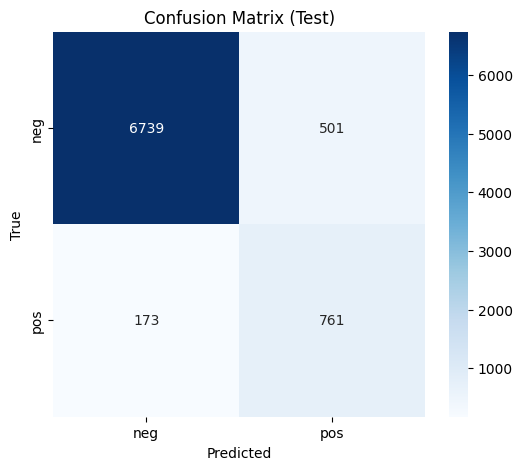

Epoch 9 Summary:
Train Loss: 0.1806 | Train Acc: 85.41% | Train F1: 0.8531
Val Loss: 0.3702 | Val Acc: 53.56% | Val F1: 0.4743
Test Loss: 0.1393 | Test Acc: 91.75% | Test F1: 0.8227
Epoch Time: 972.14s | GPU Memory Usage: 767.04 MB



Checkpoint saved at checkpoints\epoch_9.pth
No improvement in validation loss for 3 epoch(s).


Training:   0%|                                                              | 0/470 [00:00<?, ?it/s]

Training:   0%|                           | 0/470 [00:01<?, ?it/s, Loss=0.2222, F1=0.9352, Acc=93.75]

Training:   0%|                   | 1/470 [00:01<09:09,  1.17s/it, Loss=0.2222, F1=0.9352, Acc=93.75]

Training:   0%|                   | 1/470 [00:02<09:09,  1.17s/it, Loss=0.1234, F1=0.9687, Acc=96.88]

Training:   0%|                   | 2/470 [00:02<09:13,  1.18s/it, Loss=0.1234, F1=0.9687, Acc=96.88]

Training:   0%|                   | 2/470 [00:03<09:13,  1.18s/it, Loss=0.0934, F1=0.9780, Acc=97.92]

Training:   1%|                   | 3/470 [00:03<09:09,  1.18s/it, Loss=0.0934, F1=0.9780, Acc=97.92]

Training:   1%|                   | 3/470 [00:04<09:09,  1.18s/it, Loss=0.0862, F1=0.9676, Acc=96.88]

Training:   1%|▏                  | 4/470 [00:04<09:09,  1.18s/it, Loss=0.0862, F1=0.9676, Acc=96.88]

Training:   1%|▏                  | 4/470 [00:05<09:09,  1.18s/it, Loss=0.1448, F1=0.9495, Acc=95.00]

Training:   1%|▏                  | 5/470 [00:05<09:22,  1.21s/it, Loss=0.1448, F1=0.9495, Acc=95.00]

Training:   1%|▏                  | 5/470 [00:07<09:22,  1.21s/it, Loss=0.1628, F1=0.9373, Acc=93.75]

Training:   1%|▏                  | 6/470 [00:07<09:16,  1.20s/it, Loss=0.1628, F1=0.9373, Acc=93.75]

Training:   1%|▏                  | 6/470 [00:08<09:16,  1.20s/it, Loss=0.1654, F1=0.9196, Acc=91.96]

Training:   1%|▎                  | 7/470 [00:08<09:16,  1.20s/it, Loss=0.1654, F1=0.9196, Acc=91.96]

Training:   1%|▎                  | 7/470 [00:09<09:16,  1.20s/it, Loss=0.1699, F1=0.9138, Acc=91.41]

Training:   2%|▎                  | 8/470 [00:09<09:10,  1.19s/it, Loss=0.1699, F1=0.9138, Acc=91.41]

Training:   2%|▎                  | 8/470 [00:10<09:10,  1.19s/it, Loss=0.1782, F1=0.9028, Acc=90.28]

Training:   2%|▎                  | 9/470 [00:10<09:03,  1.18s/it, Loss=0.1782, F1=0.9028, Acc=90.28]

Training:   2%|▎                  | 9/470 [00:11<09:03,  1.18s/it, Loss=0.1762, F1=0.9062, Acc=90.62]

Training:   2%|▍                 | 10/470 [00:11<08:58,  1.17s/it, Loss=0.1762, F1=0.9062, Acc=90.62]

Training:   2%|▍                 | 10/470 [00:12<08:58,  1.17s/it, Loss=0.1998, F1=0.9033, Acc=90.34]

Training:   2%|▍                 | 11/470 [00:12<08:54,  1.16s/it, Loss=0.1998, F1=0.9033, Acc=90.34]

Training:   2%|▍                 | 11/470 [00:14<08:54,  1.16s/it, Loss=0.1996, F1=0.9007, Acc=90.10]

Training:   3%|▍                 | 12/470 [00:14<08:54,  1.17s/it, Loss=0.1996, F1=0.9007, Acc=90.10]

Training:   3%|▍                 | 12/470 [00:15<08:54,  1.17s/it, Loss=0.1953, F1=0.8985, Acc=89.90]

Training:   3%|▍                 | 13/470 [00:15<08:49,  1.16s/it, Loss=0.1953, F1=0.8985, Acc=89.90]

Training:   3%|▍                 | 13/470 [00:16<08:49,  1.16s/it, Loss=0.1952, F1=0.8967, Acc=89.73]

Training:   3%|▌                 | 14/470 [00:16<09:07,  1.20s/it, Loss=0.1952, F1=0.8967, Acc=89.73]

Training:   3%|▌                 | 14/470 [00:17<09:07,  1.20s/it, Loss=0.1864, F1=0.8996, Acc=90.00]

Training:   3%|▌                 | 15/470 [00:17<09:04,  1.20s/it, Loss=0.1864, F1=0.8996, Acc=90.00]

Training:   3%|▌                 | 15/470 [00:18<09:04,  1.20s/it, Loss=0.1815, F1=0.9012, Acc=90.23]

Training:   3%|▌                 | 16/470 [00:18<09:00,  1.19s/it, Loss=0.1815, F1=0.9012, Acc=90.23]

Training:   3%|▌                 | 16/470 [00:20<09:00,  1.19s/it, Loss=0.1903, F1=0.8996, Acc=90.07]

Training:   4%|▋                 | 17/470 [00:20<08:47,  1.16s/it, Loss=0.1903, F1=0.8996, Acc=90.07]

Training:   4%|▋                 | 17/470 [00:21<08:47,  1.16s/it, Loss=0.1820, F1=0.9048, Acc=90.62]

Training:   4%|▋                 | 18/470 [00:21<08:43,  1.16s/it, Loss=0.1820, F1=0.9048, Acc=90.62]

Training:   4%|▋                 | 18/470 [00:22<08:43,  1.16s/it, Loss=0.1885, F1=0.9002, Acc=90.13]

Training:   4%|▋                 | 19/470 [00:22<08:47,  1.17s/it, Loss=0.1885, F1=0.9002, Acc=90.13]

Training:   4%|▋                 | 19/470 [00:23<08:47,  1.17s/it, Loss=0.1855, F1=0.9024, Acc=90.31]

Training:   4%|▊                 | 20/470 [00:23<08:48,  1.17s/it, Loss=0.1855, F1=0.9024, Acc=90.31]

Training:   4%|▊                 | 20/470 [00:24<08:48,  1.17s/it, Loss=0.1824, F1=0.9044, Acc=90.48]

Training:   4%|▊                 | 21/470 [00:24<08:47,  1.18s/it, Loss=0.1824, F1=0.9044, Acc=90.48]

Training:   4%|▊                 | 21/470 [00:26<08:47,  1.18s/it, Loss=0.1762, F1=0.9087, Acc=90.91]

Training:   5%|▊                 | 22/470 [00:26<09:00,  1.21s/it, Loss=0.1762, F1=0.9087, Acc=90.91]

Training:   5%|▊                 | 22/470 [00:27<09:00,  1.21s/it, Loss=0.1710, F1=0.9126, Acc=91.30]

Training:   5%|▉                 | 23/470 [00:27<08:48,  1.18s/it, Loss=0.1710, F1=0.9126, Acc=91.30]

Training:   5%|▉                 | 23/470 [00:28<08:48,  1.18s/it, Loss=0.1686, F1=0.9109, Acc=91.15]

Training:   5%|▉                 | 24/470 [00:28<08:46,  1.18s/it, Loss=0.1686, F1=0.9109, Acc=91.15]

Training:   5%|▉                 | 24/470 [00:29<08:46,  1.18s/it, Loss=0.1643, F1=0.9122, Acc=91.25]

Training:   5%|▉                 | 25/470 [00:29<08:48,  1.19s/it, Loss=0.1643, F1=0.9122, Acc=91.25]

Training:   5%|▉                 | 25/470 [00:30<08:48,  1.19s/it, Loss=0.1680, F1=0.9035, Acc=90.38]

Training:   6%|▉                 | 26/470 [00:30<08:44,  1.18s/it, Loss=0.1680, F1=0.9035, Acc=90.38]

Training:   6%|▉                 | 26/470 [00:31<08:44,  1.18s/it, Loss=0.1674, F1=0.9001, Acc=90.05]

Training:   6%|█                 | 27/470 [00:31<08:51,  1.20s/it, Loss=0.1674, F1=0.9001, Acc=90.05]

Training:   6%|█                 | 27/470 [00:33<08:51,  1.20s/it, Loss=0.1626, F1=0.9037, Acc=90.40]

Training:   6%|█                 | 28/470 [00:33<08:47,  1.19s/it, Loss=0.1626, F1=0.9037, Acc=90.40]

Training:   6%|█                 | 28/470 [00:34<08:47,  1.19s/it, Loss=0.1596, F1=0.9070, Acc=90.73]

Training:   6%|█                 | 29/470 [00:34<08:44,  1.19s/it, Loss=0.1596, F1=0.9070, Acc=90.73]

Training:   6%|█                 | 29/470 [00:35<08:44,  1.19s/it, Loss=0.1627, F1=0.9018, Acc=90.21]

Training:   6%|█▏                | 30/470 [00:35<08:52,  1.21s/it, Loss=0.1627, F1=0.9018, Acc=90.21]

Training:   6%|█▏                | 30/470 [00:36<08:52,  1.21s/it, Loss=0.1649, F1=0.8988, Acc=89.92]

Training:   7%|█▏                | 31/470 [00:36<08:43,  1.19s/it, Loss=0.1649, F1=0.8988, Acc=89.92]

Training:   7%|█▏                | 31/470 [00:37<08:43,  1.19s/it, Loss=0.1742, F1=0.8922, Acc=89.26]

Training:   7%|█▏                | 32/470 [00:37<08:42,  1.19s/it, Loss=0.1742, F1=0.8922, Acc=89.26]

Training:   7%|█▏                | 32/470 [00:39<08:42,  1.19s/it, Loss=0.1742, F1=0.8917, Acc=89.20]

Training:   7%|█▎                | 33/470 [00:39<08:39,  1.19s/it, Loss=0.1742, F1=0.8917, Acc=89.20]

Training:   7%|█▎                | 33/470 [00:40<08:39,  1.19s/it, Loss=0.1818, F1=0.8874, Acc=88.79]

Training:   7%|█▎                | 34/470 [00:40<08:42,  1.20s/it, Loss=0.1818, F1=0.8874, Acc=88.79]

Training:   7%|█▎                | 34/470 [00:41<08:42,  1.20s/it, Loss=0.1853, F1=0.8871, Acc=88.75]

Training:   7%|█▎                | 35/470 [00:41<08:48,  1.21s/it, Loss=0.1853, F1=0.8871, Acc=88.75]

Training:   7%|█▎                | 35/470 [00:42<08:48,  1.21s/it, Loss=0.1839, F1=0.8849, Acc=88.54]

Training:   8%|█▍                | 36/470 [00:42<08:41,  1.20s/it, Loss=0.1839, F1=0.8849, Acc=88.54]

Training:   8%|█▍                | 36/470 [00:43<08:41,  1.20s/it, Loss=0.1835, F1=0.8828, Acc=88.34]

Training:   8%|█▍                | 37/470 [00:43<08:35,  1.19s/it, Loss=0.1835, F1=0.8828, Acc=88.34]

Training:   8%|█▍                | 37/470 [00:45<08:35,  1.19s/it, Loss=0.1810, F1=0.8826, Acc=88.32]

Training:   8%|█▍                | 38/470 [00:45<08:39,  1.20s/it, Loss=0.1810, F1=0.8826, Acc=88.32]

Training:   8%|█▍                | 38/470 [00:46<08:39,  1.20s/it, Loss=0.1837, F1=0.8791, Acc=87.98]

Training:   8%|█▍                | 39/470 [00:46<08:43,  1.21s/it, Loss=0.1837, F1=0.8791, Acc=87.98]

Training:   8%|█▍                | 39/470 [00:47<08:43,  1.21s/it, Loss=0.1824, F1=0.8774, Acc=87.81]

Training:   9%|█▌                | 40/470 [00:47<08:42,  1.21s/it, Loss=0.1824, F1=0.8774, Acc=87.81]

Training:   9%|█▌                | 40/470 [00:48<08:42,  1.21s/it, Loss=0.1820, F1=0.8757, Acc=87.65]

Training:   9%|█▌                | 41/470 [00:48<08:34,  1.20s/it, Loss=0.1820, F1=0.8757, Acc=87.65]

Training:   9%|█▌                | 41/470 [00:49<08:34,  1.20s/it, Loss=0.1872, F1=0.8713, Acc=87.20]

Training:   9%|█▌                | 42/470 [00:49<08:32,  1.20s/it, Loss=0.1872, F1=0.8713, Acc=87.20]

Training:   9%|█▌                | 42/470 [00:51<08:32,  1.20s/it, Loss=0.1839, F1=0.8745, Acc=87.50]

Training:   9%|█▋                | 43/470 [00:51<08:26,  1.19s/it, Loss=0.1839, F1=0.8745, Acc=87.50]

Training:   9%|█▋                | 43/470 [00:52<08:26,  1.19s/it, Loss=0.1839, F1=0.8715, Acc=87.22]

Training:   9%|█▋                | 44/470 [00:52<08:31,  1.20s/it, Loss=0.1839, F1=0.8715, Acc=87.22]

Training:   9%|█▋                | 44/470 [00:53<08:31,  1.20s/it, Loss=0.1833, F1=0.8675, Acc=86.81]

Training:  10%|█▋                | 45/470 [00:53<08:30,  1.20s/it, Loss=0.1833, F1=0.8675, Acc=86.81]

Training:  10%|█▋                | 45/470 [00:54<08:30,  1.20s/it, Loss=0.1812, F1=0.8690, Acc=86.96]

Training:  10%|█▊                | 46/470 [00:54<08:26,  1.19s/it, Loss=0.1812, F1=0.8690, Acc=86.96]

Training:  10%|█▊                | 46/470 [00:55<08:26,  1.19s/it, Loss=0.1801, F1=0.8692, Acc=86.97]

Training:  10%|█▊                | 47/470 [00:55<08:32,  1.21s/it, Loss=0.1801, F1=0.8692, Acc=86.97]

Training:  10%|█▊                | 47/470 [00:57<08:32,  1.21s/it, Loss=0.1784, F1=0.8706, Acc=87.11]

Training:  10%|█▊                | 48/470 [00:57<08:26,  1.20s/it, Loss=0.1784, F1=0.8706, Acc=87.11]

Training:  10%|█▊                | 48/470 [00:58<08:26,  1.20s/it, Loss=0.1759, F1=0.8720, Acc=87.24]

Training:  10%|█▉                | 49/470 [00:58<08:15,  1.18s/it, Loss=0.1759, F1=0.8720, Acc=87.24]

Training:  10%|█▉                | 49/470 [00:59<08:15,  1.18s/it, Loss=0.1741, F1=0.8746, Acc=87.50]

Training:  11%|█▉                | 50/470 [00:59<08:23,  1.20s/it, Loss=0.1741, F1=0.8746, Acc=87.50]

Training:  11%|█▉                | 50/470 [01:00<08:23,  1.20s/it, Loss=0.1728, F1=0.8734, Acc=87.38]

Training:  11%|█▉                | 51/470 [01:00<08:24,  1.20s/it, Loss=0.1728, F1=0.8734, Acc=87.38]

Training:  11%|█▉                | 51/470 [01:01<08:24,  1.20s/it, Loss=0.1729, F1=0.8722, Acc=87.26]

Training:  11%|█▉                | 52/470 [01:01<08:13,  1.18s/it, Loss=0.1729, F1=0.8722, Acc=87.26]

Training:  11%|█▉                | 52/470 [01:03<08:13,  1.18s/it, Loss=0.1727, F1=0.8712, Acc=87.15]

Training:  11%|██                | 53/470 [01:03<08:25,  1.21s/it, Loss=0.1727, F1=0.8712, Acc=87.15]

Training:  11%|██                | 53/470 [01:04<08:25,  1.21s/it, Loss=0.1733, F1=0.8724, Acc=87.27]

Training:  11%|██                | 54/470 [01:04<08:20,  1.20s/it, Loss=0.1733, F1=0.8724, Acc=87.27]

Training:  11%|██                | 54/470 [01:05<08:20,  1.20s/it, Loss=0.1710, F1=0.8747, Acc=87.50]

Training:  12%|██                | 55/470 [01:05<08:16,  1.20s/it, Loss=0.1710, F1=0.8747, Acc=87.50]

Training:  12%|██                | 55/470 [01:06<08:16,  1.20s/it, Loss=0.1724, F1=0.8714, Acc=87.17]

Training:  12%|██▏               | 56/470 [01:06<08:10,  1.18s/it, Loss=0.1724, F1=0.8714, Acc=87.17]

Training:  12%|██▏               | 56/470 [01:07<08:10,  1.18s/it, Loss=0.1703, F1=0.8725, Acc=87.28]

Training:  12%|██▏               | 57/470 [01:07<08:22,  1.22s/it, Loss=0.1703, F1=0.8725, Acc=87.28]

Training:  12%|██▏               | 57/470 [01:09<08:22,  1.22s/it, Loss=0.1711, F1=0.8715, Acc=87.18]

Training:  12%|██▏               | 58/470 [01:09<08:23,  1.22s/it, Loss=0.1711, F1=0.8715, Acc=87.18]

Training:  12%|██▏               | 58/470 [01:10<08:23,  1.22s/it, Loss=0.1693, F1=0.8737, Acc=87.39]

Training:  13%|██▎               | 59/470 [01:10<08:11,  1.20s/it, Loss=0.1693, F1=0.8737, Acc=87.39]

Training:  13%|██▎               | 59/470 [01:11<08:11,  1.20s/it, Loss=0.1711, F1=0.8727, Acc=87.29]

Training:  13%|██▎               | 60/470 [01:11<08:06,  1.19s/it, Loss=0.1711, F1=0.8727, Acc=87.29]

Training:  13%|██▎               | 60/470 [01:12<08:06,  1.19s/it, Loss=0.1724, F1=0.8697, Acc=86.99]

Training:  13%|██▎               | 61/470 [01:12<08:16,  1.21s/it, Loss=0.1724, F1=0.8697, Acc=86.99]

Training:  13%|██▎               | 61/470 [01:13<08:16,  1.21s/it, Loss=0.1720, F1=0.8688, Acc=86.90]

Training:  13%|██▎               | 62/470 [01:13<08:12,  1.21s/it, Loss=0.1720, F1=0.8688, Acc=86.90]

Training:  13%|██▎               | 62/470 [01:15<08:12,  1.21s/it, Loss=0.1730, F1=0.8688, Acc=86.90]

Training:  13%|██▍               | 63/470 [01:15<08:03,  1.19s/it, Loss=0.1730, F1=0.8688, Acc=86.90]

Training:  13%|██▍               | 63/470 [01:16<08:03,  1.19s/it, Loss=0.1712, F1=0.8687, Acc=86.91]

Training:  14%|██▍               | 64/470 [01:16<07:58,  1.18s/it, Loss=0.1712, F1=0.8687, Acc=86.91]

Training:  14%|██▍               | 64/470 [01:17<07:58,  1.18s/it, Loss=0.1696, F1=0.8707, Acc=87.12]

Training:  14%|██▍               | 65/470 [01:17<08:02,  1.19s/it, Loss=0.1696, F1=0.8707, Acc=87.12]

Training:  14%|██▍               | 65/470 [01:18<08:02,  1.19s/it, Loss=0.1693, F1=0.8708, Acc=87.12]

Training:  14%|██▌               | 66/470 [01:18<08:11,  1.22s/it, Loss=0.1693, F1=0.8708, Acc=87.12]

Training:  14%|██▌               | 66/470 [01:19<08:11,  1.22s/it, Loss=0.1676, F1=0.8707, Acc=87.13]

Training:  14%|██▌               | 67/470 [01:19<08:06,  1.21s/it, Loss=0.1676, F1=0.8707, Acc=87.13]

Training:  14%|██▌               | 67/470 [01:21<08:06,  1.21s/it, Loss=0.1660, F1=0.8726, Acc=87.32]

Training:  14%|██▌               | 68/470 [01:21<08:04,  1.21s/it, Loss=0.1660, F1=0.8726, Acc=87.32]

Training:  14%|██▌               | 68/470 [01:22<08:04,  1.21s/it, Loss=0.1641, F1=0.8744, Acc=87.50]

Training:  15%|██▋               | 69/470 [01:22<07:57,  1.19s/it, Loss=0.1641, F1=0.8744, Acc=87.50]

Training:  15%|██▋               | 69/470 [01:23<07:57,  1.19s/it, Loss=0.1717, F1=0.8725, Acc=87.32]

Training:  15%|██▋               | 70/470 [01:23<07:56,  1.19s/it, Loss=0.1717, F1=0.8725, Acc=87.32]

Training:  15%|██▋               | 70/470 [01:24<07:56,  1.19s/it, Loss=0.1703, F1=0.8735, Acc=87.41]

Training:  15%|██▋               | 71/470 [01:24<08:00,  1.20s/it, Loss=0.1703, F1=0.8735, Acc=87.41]

Training:  15%|██▋               | 71/470 [01:25<08:00,  1.20s/it, Loss=0.1689, F1=0.8735, Acc=87.41]

Training:  15%|██▊               | 72/470 [01:25<08:02,  1.21s/it, Loss=0.1689, F1=0.8735, Acc=87.41]

Training:  15%|██▊               | 72/470 [01:27<08:02,  1.21s/it, Loss=0.1701, F1=0.8735, Acc=87.41]

Training:  16%|██▊               | 73/470 [01:27<07:58,  1.20s/it, Loss=0.1701, F1=0.8735, Acc=87.41]

Training:  16%|██▊               | 73/470 [01:28<07:58,  1.20s/it, Loss=0.1684, F1=0.8753, Acc=87.58]

Training:  16%|██▊               | 74/470 [01:28<07:50,  1.19s/it, Loss=0.1684, F1=0.8753, Acc=87.58]

Training:  16%|██▊               | 74/470 [01:29<07:50,  1.19s/it, Loss=0.1670, F1=0.8769, Acc=87.75]

Training:  16%|██▊               | 75/470 [01:29<08:00,  1.22s/it, Loss=0.1670, F1=0.8769, Acc=87.75]

Training:  16%|██▊               | 75/470 [01:30<08:00,  1.22s/it, Loss=0.1665, F1=0.8769, Acc=87.75]

Training:  16%|██▉               | 76/470 [01:30<07:51,  1.20s/it, Loss=0.1665, F1=0.8769, Acc=87.75]

Training:  16%|██▉               | 76/470 [01:31<07:51,  1.20s/it, Loss=0.1659, F1=0.8776, Acc=87.82]

Training:  16%|██▉               | 77/470 [01:31<07:44,  1.18s/it, Loss=0.1659, F1=0.8776, Acc=87.82]

Training:  16%|██▉               | 77/470 [01:33<07:44,  1.18s/it, Loss=0.1662, F1=0.8776, Acc=87.82]

Training:  17%|██▉               | 78/470 [01:33<07:50,  1.20s/it, Loss=0.1662, F1=0.8776, Acc=87.82]

Training:  17%|██▉               | 78/470 [01:34<07:50,  1.20s/it, Loss=0.1654, F1=0.8768, Acc=87.74]

Training:  17%|███               | 79/470 [01:34<07:48,  1.20s/it, Loss=0.1654, F1=0.8768, Acc=87.74]

Training:  17%|███               | 79/470 [01:35<07:48,  1.20s/it, Loss=0.1640, F1=0.8783, Acc=87.89]

Training:  17%|███               | 80/470 [01:35<07:43,  1.19s/it, Loss=0.1640, F1=0.8783, Acc=87.89]

Training:  17%|███               | 80/470 [01:36<07:43,  1.19s/it, Loss=0.1629, F1=0.8789, Acc=87.96]

Training:  17%|███               | 81/470 [01:36<07:49,  1.21s/it, Loss=0.1629, F1=0.8789, Acc=87.96]

Training:  17%|███               | 81/470 [01:37<07:49,  1.21s/it, Loss=0.1624, F1=0.8781, Acc=87.88]

Training:  17%|███▏              | 82/470 [01:37<07:49,  1.21s/it, Loss=0.1624, F1=0.8781, Acc=87.88]

Training:  17%|███▏              | 82/470 [01:39<07:49,  1.21s/it, Loss=0.1612, F1=0.8788, Acc=87.95]

Training:  18%|███▏              | 83/470 [01:39<07:46,  1.21s/it, Loss=0.1612, F1=0.8788, Acc=87.95]

Training:  18%|███▏              | 83/470 [01:40<07:46,  1.21s/it, Loss=0.1604, F1=0.8801, Acc=88.10]

Training:  18%|███▏              | 84/470 [01:40<07:43,  1.20s/it, Loss=0.1604, F1=0.8801, Acc=88.10]

Training:  18%|███▏              | 84/470 [01:41<07:43,  1.20s/it, Loss=0.1651, F1=0.8770, Acc=87.79]

Training:  18%|███▎              | 85/470 [01:41<07:33,  1.18s/it, Loss=0.1651, F1=0.8770, Acc=87.79]

Training:  18%|███▎              | 85/470 [01:42<07:33,  1.18s/it, Loss=0.1640, F1=0.8769, Acc=87.79]

Training:  18%|███▎              | 86/470 [01:42<07:40,  1.20s/it, Loss=0.1640, F1=0.8769, Acc=87.79]

Training:  18%|███▎              | 86/470 [01:43<07:40,  1.20s/it, Loss=0.1632, F1=0.8777, Acc=87.86]

Training:  19%|███▎              | 87/470 [01:43<07:42,  1.21s/it, Loss=0.1632, F1=0.8777, Acc=87.86]

Training:  19%|███▎              | 87/470 [01:45<07:42,  1.21s/it, Loss=0.1627, F1=0.8776, Acc=87.86]

Training:  19%|███▎              | 88/470 [01:45<07:40,  1.20s/it, Loss=0.1627, F1=0.8776, Acc=87.86]

Training:  19%|███▎              | 88/470 [01:46<07:40,  1.20s/it, Loss=0.1620, F1=0.8782, Acc=87.92]

Training:  19%|███▍              | 89/470 [01:46<07:33,  1.19s/it, Loss=0.1620, F1=0.8782, Acc=87.92]

Training:  19%|███▍              | 89/470 [01:47<07:33,  1.19s/it, Loss=0.1634, F1=0.8775, Acc=87.85]

Training:  19%|███▍              | 90/470 [01:47<07:37,  1.20s/it, Loss=0.1634, F1=0.8775, Acc=87.85]

Training:  19%|███▍              | 90/470 [01:48<07:37,  1.20s/it, Loss=0.1633, F1=0.8781, Acc=87.91]

Training:  19%|███▍              | 91/470 [01:48<07:33,  1.20s/it, Loss=0.1633, F1=0.8781, Acc=87.91]

Training:  19%|███▍              | 91/470 [01:49<07:33,  1.20s/it, Loss=0.1627, F1=0.8775, Acc=87.84]

Training:  20%|███▌              | 92/470 [01:49<07:30,  1.19s/it, Loss=0.1627, F1=0.8775, Acc=87.84]

Training:  20%|███▌              | 92/470 [01:51<07:30,  1.19s/it, Loss=0.1640, F1=0.8767, Acc=87.77]

Training:  20%|███▌              | 93/470 [01:51<07:40,  1.22s/it, Loss=0.1640, F1=0.8767, Acc=87.77]

Training:  20%|███▌              | 93/470 [01:52<07:40,  1.22s/it, Loss=0.1638, F1=0.8767, Acc=87.77]

Training:  20%|███▌              | 94/470 [01:52<07:34,  1.21s/it, Loss=0.1638, F1=0.8767, Acc=87.77]

Training:  20%|███▌              | 94/470 [01:53<07:34,  1.21s/it, Loss=0.1631, F1=0.8766, Acc=87.76]

Training:  20%|███▋              | 95/470 [01:53<07:29,  1.20s/it, Loss=0.1631, F1=0.8766, Acc=87.76]

Training:  20%|███▋              | 95/470 [01:54<07:29,  1.20s/it, Loss=0.1626, F1=0.8760, Acc=87.70]

Training:  20%|███▋              | 96/470 [01:54<07:23,  1.19s/it, Loss=0.1626, F1=0.8760, Acc=87.70]

Training:  20%|███▋              | 96/470 [01:56<07:23,  1.19s/it, Loss=0.1623, F1=0.8759, Acc=87.69]

Training:  21%|███▋              | 97/470 [01:56<07:37,  1.23s/it, Loss=0.1623, F1=0.8759, Acc=87.69]

Training:  21%|███▋              | 97/470 [01:57<07:37,  1.23s/it, Loss=0.1634, F1=0.8740, Acc=87.50]

Training:  21%|███▊              | 98/470 [01:57<07:28,  1.21s/it, Loss=0.1634, F1=0.8740, Acc=87.50]

Training:  21%|███▊              | 98/470 [01:58<07:28,  1.21s/it, Loss=0.1623, F1=0.8747, Acc=87.56]

Training:  21%|███▊              | 99/470 [01:58<07:21,  1.19s/it, Loss=0.1623, F1=0.8747, Acc=87.56]

Training:  21%|███▊              | 99/470 [01:59<07:21,  1.19s/it, Loss=0.1637, F1=0.8740, Acc=87.50]

Training:  21%|███▌             | 100/470 [01:59<07:17,  1.18s/it, Loss=0.1637, F1=0.8740, Acc=87.50]

Training:  21%|███▌             | 100/470 [02:00<07:17,  1.18s/it, Loss=0.1636, F1=0.8734, Acc=87.44]

Training:  21%|███▋             | 101/470 [02:00<07:20,  1.19s/it, Loss=0.1636, F1=0.8734, Acc=87.44]

Training:  21%|███▋             | 101/470 [02:01<07:20,  1.19s/it, Loss=0.1626, F1=0.8735, Acc=87.44]

Training:  22%|███▋             | 102/470 [02:01<07:24,  1.21s/it, Loss=0.1626, F1=0.8735, Acc=87.44]

Training:  22%|███▋             | 102/470 [02:03<07:24,  1.21s/it, Loss=0.1628, F1=0.8728, Acc=87.38]

Training:  22%|███▋             | 103/470 [02:03<07:17,  1.19s/it, Loss=0.1628, F1=0.8728, Acc=87.38]

Training:  22%|███▋             | 103/470 [02:04<07:17,  1.19s/it, Loss=0.1648, F1=0.8722, Acc=87.32]

Training:  22%|███▊             | 104/470 [02:04<07:14,  1.19s/it, Loss=0.1648, F1=0.8722, Acc=87.32]

Training:  22%|███▊             | 104/470 [02:05<07:14,  1.19s/it, Loss=0.1657, F1=0.8709, Acc=87.20]

Training:  22%|███▊             | 105/470 [02:05<07:16,  1.20s/it, Loss=0.1657, F1=0.8709, Acc=87.20]

Training:  22%|███▊             | 105/470 [02:06<07:16,  1.20s/it, Loss=0.1651, F1=0.8714, Acc=87.26]

Training:  23%|███▊             | 106/470 [02:06<07:18,  1.21s/it, Loss=0.1651, F1=0.8714, Acc=87.26]

Training:  23%|███▊             | 106/470 [02:07<07:18,  1.21s/it, Loss=0.1643, F1=0.8714, Acc=87.27]

Training:  23%|███▊             | 107/470 [02:07<07:15,  1.20s/it, Loss=0.1643, F1=0.8714, Acc=87.27]

Training:  23%|███▊             | 107/470 [02:09<07:15,  1.20s/it, Loss=0.1642, F1=0.8714, Acc=87.27]

Training:  23%|███▉             | 108/470 [02:09<07:11,  1.19s/it, Loss=0.1642, F1=0.8714, Acc=87.27]

Training:  23%|███▉             | 108/470 [02:10<07:11,  1.19s/it, Loss=0.1631, F1=0.8712, Acc=87.27]

Training:  23%|███▉             | 109/470 [02:10<07:10,  1.19s/it, Loss=0.1631, F1=0.8712, Acc=87.27]

Training:  23%|███▉             | 109/470 [02:11<07:10,  1.19s/it, Loss=0.1622, F1=0.8724, Acc=87.39]

Training:  23%|███▉             | 110/470 [02:11<07:13,  1.20s/it, Loss=0.1622, F1=0.8724, Acc=87.39]

Training:  23%|███▉             | 110/470 [02:12<07:13,  1.20s/it, Loss=0.1621, F1=0.8718, Acc=87.33]

Training:  24%|████             | 111/470 [02:12<07:06,  1.19s/it, Loss=0.1621, F1=0.8718, Acc=87.33]

Training:  24%|████             | 111/470 [02:13<07:06,  1.19s/it, Loss=0.1619, F1=0.8702, Acc=87.17]

Training:  24%|████             | 112/470 [02:13<07:11,  1.21s/it, Loss=0.1619, F1=0.8702, Acc=87.17]

Training:  24%|████             | 112/470 [02:15<07:11,  1.21s/it, Loss=0.1613, F1=0.8714, Acc=87.28]

Training:  24%|████             | 113/470 [02:15<07:16,  1.22s/it, Loss=0.1613, F1=0.8714, Acc=87.28]

Training:  24%|████             | 113/470 [02:16<07:16,  1.22s/it, Loss=0.1606, F1=0.8719, Acc=87.34]

Training:  24%|████             | 114/470 [02:16<07:13,  1.22s/it, Loss=0.1606, F1=0.8719, Acc=87.34]

Training:  24%|████             | 114/470 [02:17<07:13,  1.22s/it, Loss=0.1596, F1=0.8731, Acc=87.45]

Training:  24%|████▏            | 115/470 [02:17<07:12,  1.22s/it, Loss=0.1596, F1=0.8731, Acc=87.45]

Training:  24%|████▏            | 115/470 [02:18<07:12,  1.22s/it, Loss=0.1586, F1=0.8742, Acc=87.55]

Training:  25%|████▏            | 116/470 [02:18<07:10,  1.21s/it, Loss=0.1586, F1=0.8742, Acc=87.55]

Training:  25%|████▏            | 116/470 [02:19<07:10,  1.21s/it, Loss=0.1612, F1=0.8726, Acc=87.39]

Training:  25%|████▏            | 117/470 [02:19<07:05,  1.21s/it, Loss=0.1612, F1=0.8726, Acc=87.39]

Training:  25%|████▏            | 117/470 [02:21<07:05,  1.21s/it, Loss=0.1612, F1=0.8716, Acc=87.29]

Training:  25%|████▎            | 118/470 [02:21<07:01,  1.20s/it, Loss=0.1612, F1=0.8716, Acc=87.29]

Training:  25%|████▎            | 118/470 [02:22<07:01,  1.20s/it, Loss=0.1605, F1=0.8721, Acc=87.34]

Training:  25%|████▎            | 119/470 [02:22<06:57,  1.19s/it, Loss=0.1605, F1=0.8721, Acc=87.34]

Training:  25%|████▎            | 119/470 [02:23<06:57,  1.19s/it, Loss=0.1596, F1=0.8727, Acc=87.40]

Training:  26%|████▎            | 120/470 [02:23<06:58,  1.19s/it, Loss=0.1596, F1=0.8727, Acc=87.40]

Training:  26%|████▎            | 120/470 [02:24<06:58,  1.19s/it, Loss=0.1596, F1=0.8732, Acc=87.45]

Training:  26%|████▍            | 121/470 [02:24<06:56,  1.19s/it, Loss=0.1596, F1=0.8732, Acc=87.45]

Training:  26%|████▍            | 121/470 [02:25<06:56,  1.19s/it, Loss=0.1593, F1=0.8737, Acc=87.50]

Training:  26%|████▍            | 122/470 [02:25<06:54,  1.19s/it, Loss=0.1593, F1=0.8737, Acc=87.50]

Training:  26%|████▍            | 122/470 [02:27<06:54,  1.19s/it, Loss=0.1583, F1=0.8742, Acc=87.55]

Training:  26%|████▍            | 123/470 [02:27<06:54,  1.20s/it, Loss=0.1583, F1=0.8742, Acc=87.55]

Training:  26%|████▍            | 123/470 [02:28<06:54,  1.20s/it, Loss=0.1590, F1=0.8743, Acc=87.55]

Training:  26%|████▍            | 124/470 [02:28<06:49,  1.18s/it, Loss=0.1590, F1=0.8743, Acc=87.55]

Training:  26%|████▍            | 124/470 [02:29<06:49,  1.18s/it, Loss=0.1600, F1=0.8738, Acc=87.50]

Training:  27%|████▌            | 125/470 [02:29<06:53,  1.20s/it, Loss=0.1600, F1=0.8738, Acc=87.50]

Training:  27%|████▌            | 125/470 [02:30<06:53,  1.20s/it, Loss=0.1591, F1=0.8748, Acc=87.60]

Training:  27%|████▌            | 126/470 [02:30<06:47,  1.18s/it, Loss=0.1591, F1=0.8748, Acc=87.60]

Training:  27%|████▌            | 126/470 [02:31<06:47,  1.18s/it, Loss=0.1584, F1=0.8748, Acc=87.60]

Training:  27%|████▌            | 127/470 [02:31<06:56,  1.21s/it, Loss=0.1584, F1=0.8748, Acc=87.60]

Training:  27%|████▌            | 127/470 [02:33<06:56,  1.21s/it, Loss=0.1578, F1=0.8757, Acc=87.70]

Training:  27%|████▋            | 128/470 [02:33<06:52,  1.21s/it, Loss=0.1578, F1=0.8757, Acc=87.70]

Training:  27%|████▋            | 128/470 [02:34<06:52,  1.21s/it, Loss=0.1576, F1=0.8758, Acc=87.69]

Training:  27%|████▋            | 129/470 [02:34<06:48,  1.20s/it, Loss=0.1576, F1=0.8758, Acc=87.69]

Training:  27%|████▋            | 129/470 [02:35<06:48,  1.20s/it, Loss=0.1572, F1=0.8758, Acc=87.69]

Training:  28%|████▋            | 130/470 [02:35<06:44,  1.19s/it, Loss=0.1572, F1=0.8758, Acc=87.69]

Training:  28%|████▋            | 130/470 [02:36<06:44,  1.19s/it, Loss=0.1568, F1=0.8749, Acc=87.60]

Training:  28%|████▋            | 131/470 [02:36<06:41,  1.19s/it, Loss=0.1568, F1=0.8749, Acc=87.60]

Training:  28%|████▋            | 131/470 [02:37<06:41,  1.19s/it, Loss=0.1568, F1=0.8753, Acc=87.64]

Training:  28%|████▊            | 132/470 [02:37<06:47,  1.21s/it, Loss=0.1568, F1=0.8753, Acc=87.64]

Training:  28%|████▊            | 132/470 [02:39<06:47,  1.21s/it, Loss=0.1580, F1=0.8744, Acc=87.55]

Training:  28%|████▊            | 133/470 [02:39<06:50,  1.22s/it, Loss=0.1580, F1=0.8744, Acc=87.55]

Training:  28%|████▊            | 133/470 [02:40<06:50,  1.22s/it, Loss=0.1575, F1=0.8734, Acc=87.45]

Training:  29%|████▊            | 134/470 [02:40<06:44,  1.20s/it, Loss=0.1575, F1=0.8734, Acc=87.45]

Training:  29%|████▊            | 134/470 [02:41<06:44,  1.20s/it, Loss=0.1590, F1=0.8735, Acc=87.45]

Training:  29%|████▉            | 135/470 [02:41<06:40,  1.20s/it, Loss=0.1590, F1=0.8735, Acc=87.45]

Training:  29%|████▉            | 135/470 [02:42<06:40,  1.20s/it, Loss=0.1583, F1=0.8735, Acc=87.45]

Training:  29%|████▉            | 136/470 [02:42<06:34,  1.18s/it, Loss=0.1583, F1=0.8735, Acc=87.45]

Training:  29%|████▉            | 136/470 [02:43<06:34,  1.18s/it, Loss=0.1589, F1=0.8730, Acc=87.41]

Training:  29%|████▉            | 137/470 [02:43<06:40,  1.20s/it, Loss=0.1589, F1=0.8730, Acc=87.41]

Training:  29%|████▉            | 137/470 [02:45<06:40,  1.20s/it, Loss=0.1585, F1=0.8725, Acc=87.36]

Training:  29%|████▉            | 138/470 [02:45<06:37,  1.20s/it, Loss=0.1585, F1=0.8725, Acc=87.36]

Training:  29%|████▉            | 138/470 [02:46<06:37,  1.20s/it, Loss=0.1594, F1=0.8716, Acc=87.28]

Training:  30%|█████            | 139/470 [02:46<06:30,  1.18s/it, Loss=0.1594, F1=0.8716, Acc=87.28]

Training:  30%|█████            | 139/470 [02:47<06:30,  1.18s/it, Loss=0.1600, F1=0.8712, Acc=87.23]

Training:  30%|█████            | 140/470 [02:47<06:44,  1.22s/it, Loss=0.1600, F1=0.8712, Acc=87.23]

Training:  30%|█████            | 140/470 [02:48<06:44,  1.22s/it, Loss=0.1600, F1=0.8707, Acc=87.19]

Training:  30%|█████            | 141/470 [02:48<06:37,  1.21s/it, Loss=0.1600, F1=0.8707, Acc=87.19]

Training:  30%|█████            | 141/470 [02:49<06:37,  1.21s/it, Loss=0.1593, F1=0.8716, Acc=87.28]

Training:  30%|█████▏           | 142/470 [02:49<06:31,  1.19s/it, Loss=0.1593, F1=0.8716, Acc=87.28]

Training:  30%|█████▏           | 142/470 [02:50<06:31,  1.19s/it, Loss=0.1588, F1=0.8721, Acc=87.33]

Training:  30%|█████▏           | 143/470 [02:50<06:19,  1.16s/it, Loss=0.1588, F1=0.8721, Acc=87.33]

Training:  30%|█████▏           | 143/470 [02:52<06:19,  1.16s/it, Loss=0.1580, F1=0.8730, Acc=87.41]

Training:  31%|█████▏           | 144/470 [02:52<06:21,  1.17s/it, Loss=0.1580, F1=0.8730, Acc=87.41]

Training:  31%|█████▏           | 144/470 [02:53<06:21,  1.17s/it, Loss=0.1575, F1=0.8730, Acc=87.41]

Training:  31%|█████▏           | 145/470 [02:53<06:19,  1.17s/it, Loss=0.1575, F1=0.8730, Acc=87.41]

Training:  31%|█████▏           | 145/470 [02:54<06:19,  1.17s/it, Loss=0.1569, F1=0.8739, Acc=87.50]

Training:  31%|█████▎           | 146/470 [02:54<06:19,  1.17s/it, Loss=0.1569, F1=0.8739, Acc=87.50]

Training:  31%|█████▎           | 146/470 [02:55<06:19,  1.17s/it, Loss=0.1560, F1=0.8748, Acc=87.59]

Training:  31%|█████▎           | 147/470 [02:55<06:21,  1.18s/it, Loss=0.1560, F1=0.8748, Acc=87.59]

Training:  31%|█████▎           | 147/470 [02:56<06:21,  1.18s/it, Loss=0.1556, F1=0.8744, Acc=87.54]

Training:  31%|█████▎           | 148/470 [02:56<06:18,  1.17s/it, Loss=0.1556, F1=0.8744, Acc=87.54]

Training:  31%|█████▎           | 148/470 [02:58<06:18,  1.17s/it, Loss=0.1563, F1=0.8740, Acc=87.50]

Training:  32%|█████▍           | 149/470 [02:58<06:22,  1.19s/it, Loss=0.1563, F1=0.8740, Acc=87.50]

Training:  32%|█████▍           | 149/470 [02:59<06:22,  1.19s/it, Loss=0.1561, F1=0.8748, Acc=87.58]

Training:  32%|█████▍           | 150/470 [02:59<06:16,  1.18s/it, Loss=0.1561, F1=0.8748, Acc=87.58]

Training:  32%|█████▍           | 150/470 [03:00<06:16,  1.18s/it, Loss=0.1558, F1=0.8748, Acc=87.58]

Training:  32%|█████▍           | 151/470 [03:00<06:22,  1.20s/it, Loss=0.1558, F1=0.8748, Acc=87.58]

Training:  32%|█████▍           | 151/470 [03:01<06:22,  1.20s/it, Loss=0.1550, F1=0.8756, Acc=87.66]

Training:  32%|█████▍           | 152/470 [03:01<06:19,  1.19s/it, Loss=0.1550, F1=0.8756, Acc=87.66]

Training:  32%|█████▍           | 152/470 [03:02<06:19,  1.19s/it, Loss=0.1547, F1=0.8759, Acc=87.70]

Training:  33%|█████▌           | 153/470 [03:02<06:14,  1.18s/it, Loss=0.1547, F1=0.8759, Acc=87.70]

Training:  33%|█████▌           | 153/470 [03:03<06:14,  1.18s/it, Loss=0.1543, F1=0.8764, Acc=87.74]

Training:  33%|█████▌           | 154/470 [03:03<06:11,  1.18s/it, Loss=0.1543, F1=0.8764, Acc=87.74]

Training:  33%|█████▌           | 154/470 [03:05<06:11,  1.18s/it, Loss=0.1546, F1=0.8764, Acc=87.74]

Training:  33%|█████▌           | 155/470 [03:05<06:09,  1.17s/it, Loss=0.1546, F1=0.8764, Acc=87.74]

Training:  33%|█████▌           | 155/470 [03:06<06:09,  1.17s/it, Loss=0.1540, F1=0.8768, Acc=87.78]

Training:  33%|█████▋           | 156/470 [03:06<06:12,  1.19s/it, Loss=0.1540, F1=0.8768, Acc=87.78]

Training:  33%|█████▋           | 156/470 [03:07<06:12,  1.19s/it, Loss=0.1536, F1=0.8772, Acc=87.82]

Training:  33%|█████▋           | 157/470 [03:07<06:11,  1.19s/it, Loss=0.1536, F1=0.8772, Acc=87.82]

Training:  33%|█████▋           | 157/470 [03:08<06:11,  1.19s/it, Loss=0.1532, F1=0.8768, Acc=87.78]

Training:  34%|█████▋           | 158/470 [03:08<06:07,  1.18s/it, Loss=0.1532, F1=0.8768, Acc=87.78]

Training:  34%|█████▋           | 158/470 [03:09<06:07,  1.18s/it, Loss=0.1529, F1=0.8772, Acc=87.81]

Training:  34%|█████▊           | 159/470 [03:09<06:04,  1.17s/it, Loss=0.1529, F1=0.8772, Acc=87.81]

Training:  34%|█████▊           | 159/470 [03:11<06:04,  1.17s/it, Loss=0.1524, F1=0.8780, Acc=87.89]

Training:  34%|█████▊           | 160/470 [03:11<06:01,  1.17s/it, Loss=0.1524, F1=0.8780, Acc=87.89]

Training:  34%|█████▊           | 160/470 [03:12<06:01,  1.17s/it, Loss=0.1519, F1=0.8784, Acc=87.93]

Training:  34%|█████▊           | 161/470 [03:12<06:07,  1.19s/it, Loss=0.1519, F1=0.8784, Acc=87.93]

Training:  34%|█████▊           | 161/470 [03:13<06:07,  1.19s/it, Loss=0.1523, F1=0.8784, Acc=87.92]

Training:  34%|█████▊           | 162/470 [03:13<06:06,  1.19s/it, Loss=0.1523, F1=0.8784, Acc=87.92]

Training:  34%|█████▊           | 162/470 [03:14<06:06,  1.19s/it, Loss=0.1519, F1=0.8787, Acc=87.96]

Training:  35%|█████▉           | 163/470 [03:14<06:07,  1.20s/it, Loss=0.1519, F1=0.8787, Acc=87.96]

Training:  35%|█████▉           | 163/470 [03:15<06:07,  1.20s/it, Loss=0.1524, F1=0.8779, Acc=87.88]

Training:  35%|█████▉           | 164/470 [03:15<06:03,  1.19s/it, Loss=0.1524, F1=0.8779, Acc=87.88]

Training:  35%|█████▉           | 164/470 [03:17<06:03,  1.19s/it, Loss=0.1536, F1=0.8783, Acc=87.92]

Training:  35%|█████▉           | 165/470 [03:17<06:07,  1.20s/it, Loss=0.1536, F1=0.8783, Acc=87.92]

Training:  35%|█████▉           | 165/470 [03:18<06:07,  1.20s/it, Loss=0.1538, F1=0.8786, Acc=87.95]

Training:  35%|██████           | 166/470 [03:18<06:08,  1.21s/it, Loss=0.1538, F1=0.8786, Acc=87.95]

Training:  35%|██████           | 166/470 [03:19<06:08,  1.21s/it, Loss=0.1534, F1=0.8786, Acc=87.95]

Training:  36%|██████           | 167/470 [03:19<06:02,  1.20s/it, Loss=0.1534, F1=0.8786, Acc=87.95]

Training:  36%|██████           | 167/470 [03:20<06:02,  1.20s/it, Loss=0.1531, F1=0.8793, Acc=88.02]

Training:  36%|██████           | 168/470 [03:20<06:01,  1.20s/it, Loss=0.1531, F1=0.8793, Acc=88.02]

Training:  36%|██████           | 168/470 [03:21<06:01,  1.20s/it, Loss=0.1525, F1=0.8800, Acc=88.09]

Training:  36%|██████           | 169/470 [03:21<05:56,  1.19s/it, Loss=0.1525, F1=0.8800, Acc=88.09]

Training:  36%|██████           | 169/470 [03:23<05:56,  1.19s/it, Loss=0.1525, F1=0.8803, Acc=88.12]

Training:  36%|██████▏          | 170/470 [03:23<05:59,  1.20s/it, Loss=0.1525, F1=0.8803, Acc=88.12]

Training:  36%|██████▏          | 170/470 [03:24<05:59,  1.20s/it, Loss=0.1532, F1=0.8807, Acc=88.16]

Training:  36%|██████▏          | 171/470 [03:24<06:04,  1.22s/it, Loss=0.1532, F1=0.8807, Acc=88.16]

Training:  36%|██████▏          | 171/470 [03:25<06:04,  1.22s/it, Loss=0.1527, F1=0.8810, Acc=88.19]

Training:  37%|██████▏          | 172/470 [03:25<06:04,  1.22s/it, Loss=0.1527, F1=0.8810, Acc=88.19]

Training:  37%|██████▏          | 172/470 [03:26<06:04,  1.22s/it, Loss=0.1546, F1=0.8806, Acc=88.15]

Training:  37%|██████▎          | 173/470 [03:26<05:56,  1.20s/it, Loss=0.1546, F1=0.8806, Acc=88.15]

Training:  37%|██████▎          | 173/470 [03:27<05:56,  1.20s/it, Loss=0.1547, F1=0.8810, Acc=88.18]

Training:  37%|██████▎          | 174/470 [03:27<05:53,  1.19s/it, Loss=0.1547, F1=0.8810, Acc=88.18]

Training:  37%|██████▎          | 174/470 [03:29<05:53,  1.19s/it, Loss=0.1548, F1=0.8809, Acc=88.18]

Training:  37%|██████▎          | 175/470 [03:29<05:52,  1.20s/it, Loss=0.1548, F1=0.8809, Acc=88.18]

Training:  37%|██████▎          | 175/470 [03:30<05:52,  1.20s/it, Loss=0.1546, F1=0.8805, Acc=88.14]

Training:  37%|██████▎          | 176/470 [03:30<05:45,  1.18s/it, Loss=0.1546, F1=0.8805, Acc=88.14]

Training:  37%|██████▎          | 176/470 [03:31<05:45,  1.18s/it, Loss=0.1544, F1=0.8802, Acc=88.10]

Training:  38%|██████▍          | 177/470 [03:31<05:46,  1.18s/it, Loss=0.1544, F1=0.8802, Acc=88.10]

Training:  38%|██████▍          | 177/470 [03:32<05:46,  1.18s/it, Loss=0.1541, F1=0.8801, Acc=88.10]

Training:  38%|██████▍          | 178/470 [03:32<05:44,  1.18s/it, Loss=0.1541, F1=0.8801, Acc=88.10]

Training:  38%|██████▍          | 178/470 [03:33<05:44,  1.18s/it, Loss=0.1537, F1=0.8801, Acc=88.09]

Training:  38%|██████▍          | 179/470 [03:33<05:43,  1.18s/it, Loss=0.1537, F1=0.8801, Acc=88.09]

Training:  38%|██████▍          | 179/470 [03:34<05:43,  1.18s/it, Loss=0.1537, F1=0.8804, Acc=88.12]

Training:  38%|██████▌          | 180/470 [03:34<05:38,  1.17s/it, Loss=0.1537, F1=0.8804, Acc=88.12]

Training:  38%|██████▌          | 180/470 [03:36<05:38,  1.17s/it, Loss=0.1535, F1=0.8810, Acc=88.19]

Training:  39%|██████▌          | 181/470 [03:36<05:36,  1.16s/it, Loss=0.1535, F1=0.8810, Acc=88.19]

Training:  39%|██████▌          | 181/470 [03:37<05:36,  1.16s/it, Loss=0.1529, F1=0.8813, Acc=88.22]

Training:  39%|██████▌          | 182/470 [03:37<05:34,  1.16s/it, Loss=0.1529, F1=0.8813, Acc=88.22]

Training:  39%|██████▌          | 182/470 [03:38<05:34,  1.16s/it, Loss=0.1527, F1=0.8817, Acc=88.25]

Training:  39%|██████▌          | 183/470 [03:38<05:48,  1.21s/it, Loss=0.1527, F1=0.8817, Acc=88.25]

Training:  39%|██████▌          | 183/470 [03:39<05:48,  1.21s/it, Loss=0.1521, F1=0.8820, Acc=88.28]

Training:  39%|██████▋          | 184/470 [03:39<05:46,  1.21s/it, Loss=0.1521, F1=0.8820, Acc=88.28]

Training:  39%|██████▋          | 184/470 [03:40<05:46,  1.21s/it, Loss=0.1523, F1=0.8813, Acc=88.21]

Training:  39%|██████▋          | 185/470 [03:40<05:34,  1.18s/it, Loss=0.1523, F1=0.8813, Acc=88.21]

Training:  39%|██████▋          | 185/470 [03:42<05:34,  1.18s/it, Loss=0.1528, F1=0.8809, Acc=88.17]

Training:  40%|██████▋          | 186/470 [03:42<05:38,  1.19s/it, Loss=0.1528, F1=0.8809, Acc=88.17]

Training:  40%|██████▋          | 186/470 [03:43<05:38,  1.19s/it, Loss=0.1525, F1=0.8806, Acc=88.14]

Training:  40%|██████▊          | 187/470 [03:43<05:41,  1.21s/it, Loss=0.1525, F1=0.8806, Acc=88.14]

Training:  40%|██████▊          | 187/470 [03:44<05:41,  1.21s/it, Loss=0.1522, F1=0.8812, Acc=88.20]

Training:  40%|██████▊          | 188/470 [03:44<05:36,  1.19s/it, Loss=0.1522, F1=0.8812, Acc=88.20]

Training:  40%|██████▊          | 188/470 [03:45<05:36,  1.19s/it, Loss=0.1520, F1=0.8812, Acc=88.19]

Training:  40%|██████▊          | 189/470 [03:45<05:34,  1.19s/it, Loss=0.1520, F1=0.8812, Acc=88.19]

Training:  40%|██████▊          | 189/470 [03:46<05:34,  1.19s/it, Loss=0.1518, F1=0.8815, Acc=88.22]

Training:  40%|██████▊          | 190/470 [03:46<05:32,  1.19s/it, Loss=0.1518, F1=0.8815, Acc=88.22]

Training:  40%|██████▊          | 190/470 [03:48<05:32,  1.19s/it, Loss=0.1517, F1=0.8814, Acc=88.22]

Training:  41%|██████▉          | 191/470 [03:48<05:37,  1.21s/it, Loss=0.1517, F1=0.8814, Acc=88.22]

Training:  41%|██████▉          | 191/470 [03:49<05:37,  1.21s/it, Loss=0.1512, F1=0.8814, Acc=88.22]

Training:  41%|██████▉          | 192/470 [03:49<05:31,  1.19s/it, Loss=0.1512, F1=0.8814, Acc=88.22]

Training:  41%|██████▉          | 192/470 [03:50<05:31,  1.19s/it, Loss=0.1509, F1=0.8816, Acc=88.24]

Training:  41%|██████▉          | 193/470 [03:50<05:30,  1.19s/it, Loss=0.1509, F1=0.8816, Acc=88.24]

Training:  41%|██████▉          | 193/470 [03:51<05:30,  1.19s/it, Loss=0.1503, F1=0.8822, Acc=88.31]

Training:  41%|███████          | 194/470 [03:51<05:34,  1.21s/it, Loss=0.1503, F1=0.8822, Acc=88.31]

Training:  41%|███████          | 194/470 [03:52<05:34,  1.21s/it, Loss=0.1503, F1=0.8821, Acc=88.30]

Training:  41%|███████          | 195/470 [03:52<05:29,  1.20s/it, Loss=0.1503, F1=0.8821, Acc=88.30]

Training:  41%|███████          | 195/470 [03:54<05:29,  1.20s/it, Loss=0.1501, F1=0.8821, Acc=88.30]

Training:  42%|███████          | 196/470 [03:54<05:24,  1.19s/it, Loss=0.1501, F1=0.8821, Acc=88.30]

Training:  42%|███████          | 196/470 [03:55<05:24,  1.19s/it, Loss=0.1501, F1=0.8824, Acc=88.32]

Training:  42%|███████▏         | 197/470 [03:55<05:29,  1.21s/it, Loss=0.1501, F1=0.8824, Acc=88.32]

Training:  42%|███████▏         | 197/470 [03:56<05:29,  1.21s/it, Loss=0.1498, F1=0.8827, Acc=88.35]

Training:  42%|███████▏         | 198/470 [03:56<05:26,  1.20s/it, Loss=0.1498, F1=0.8827, Acc=88.35]

Training:  42%|███████▏         | 198/470 [03:57<05:26,  1.20s/it, Loss=0.1495, F1=0.8833, Acc=88.41]

Training:  42%|███████▏         | 199/470 [03:57<05:20,  1.18s/it, Loss=0.1495, F1=0.8833, Acc=88.41]

Training:  42%|███████▏         | 199/470 [03:58<05:20,  1.18s/it, Loss=0.1495, F1=0.8833, Acc=88.41]

Training:  43%|███████▏         | 200/470 [03:58<05:27,  1.21s/it, Loss=0.1495, F1=0.8833, Acc=88.41]

Training:  43%|███████▏         | 200/470 [04:00<05:27,  1.21s/it, Loss=0.1489, F1=0.8839, Acc=88.46]

Training:  43%|███████▎         | 201/470 [04:00<05:26,  1.21s/it, Loss=0.1489, F1=0.8839, Acc=88.46]

Training:  43%|███████▎         | 201/470 [04:01<05:26,  1.21s/it, Loss=0.1485, F1=0.8838, Acc=88.46]

Training:  43%|███████▎         | 202/470 [04:01<05:21,  1.20s/it, Loss=0.1485, F1=0.8838, Acc=88.46]

Training:  43%|███████▎         | 202/470 [04:02<05:21,  1.20s/it, Loss=0.1491, F1=0.8838, Acc=88.45]

Training:  43%|███████▎         | 203/470 [04:02<05:19,  1.20s/it, Loss=0.1491, F1=0.8838, Acc=88.45]

Training:  43%|███████▎         | 203/470 [04:03<05:19,  1.20s/it, Loss=0.1486, F1=0.8837, Acc=88.45]

Training:  43%|███████▍         | 204/470 [04:03<05:16,  1.19s/it, Loss=0.1486, F1=0.8837, Acc=88.45]

Training:  43%|███████▍         | 204/470 [04:04<05:16,  1.19s/it, Loss=0.1482, F1=0.8840, Acc=88.48]

Training:  44%|███████▍         | 205/470 [04:04<05:18,  1.20s/it, Loss=0.1482, F1=0.8840, Acc=88.48]

Training:  44%|███████▍         | 205/470 [04:06<05:18,  1.20s/it, Loss=0.1489, F1=0.8840, Acc=88.47]

Training:  44%|███████▍         | 206/470 [04:06<05:16,  1.20s/it, Loss=0.1489, F1=0.8840, Acc=88.47]

Training:  44%|███████▍         | 206/470 [04:07<05:16,  1.20s/it, Loss=0.1492, F1=0.8839, Acc=88.47]

Training:  44%|███████▍         | 207/470 [04:07<05:11,  1.19s/it, Loss=0.1492, F1=0.8839, Acc=88.47]

Training:  44%|███████▍         | 207/470 [04:08<05:11,  1.19s/it, Loss=0.1486, F1=0.8845, Acc=88.52]

Training:  44%|███████▌         | 208/470 [04:08<05:15,  1.20s/it, Loss=0.1486, F1=0.8845, Acc=88.52]

Training:  44%|███████▌         | 208/470 [04:09<05:15,  1.20s/it, Loss=0.1480, F1=0.8850, Acc=88.58]

Training:  44%|███████▌         | 209/470 [04:09<05:16,  1.21s/it, Loss=0.1480, F1=0.8850, Acc=88.58]

Training:  44%|███████▌         | 209/470 [04:10<05:16,  1.21s/it, Loss=0.1475, F1=0.8849, Acc=88.57]

Training:  45%|███████▌         | 210/470 [04:10<05:10,  1.20s/it, Loss=0.1475, F1=0.8849, Acc=88.57]

Training:  45%|███████▌         | 210/470 [04:12<05:10,  1.20s/it, Loss=0.1487, F1=0.8849, Acc=88.57]

Training:  45%|███████▋         | 211/470 [04:12<05:07,  1.19s/it, Loss=0.1487, F1=0.8849, Acc=88.57]

Training:  45%|███████▋         | 211/470 [04:13<05:07,  1.19s/it, Loss=0.1485, F1=0.8851, Acc=88.59]

Training:  45%|███████▋         | 212/470 [04:13<05:10,  1.20s/it, Loss=0.1485, F1=0.8851, Acc=88.59]

Training:  45%|███████▋         | 212/470 [04:14<05:10,  1.20s/it, Loss=0.1488, F1=0.8851, Acc=88.59]

Training:  45%|███████▋         | 213/470 [04:14<05:11,  1.21s/it, Loss=0.1488, F1=0.8851, Acc=88.59]

Training:  45%|███████▋         | 213/470 [04:15<05:11,  1.21s/it, Loss=0.1490, F1=0.8850, Acc=88.58]

Training:  46%|███████▋         | 214/470 [04:15<05:08,  1.21s/it, Loss=0.1490, F1=0.8850, Acc=88.58]

Training:  46%|███████▋         | 214/470 [04:16<05:08,  1.21s/it, Loss=0.1485, F1=0.8856, Acc=88.63]

Training:  46%|███████▊         | 215/470 [04:16<05:05,  1.20s/it, Loss=0.1485, F1=0.8856, Acc=88.63]

Training:  46%|███████▊         | 215/470 [04:18<05:05,  1.20s/it, Loss=0.1483, F1=0.8858, Acc=88.66]

Training:  46%|███████▊         | 216/470 [04:18<05:02,  1.19s/it, Loss=0.1483, F1=0.8858, Acc=88.66]

Training:  46%|███████▊         | 216/470 [04:19<05:02,  1.19s/it, Loss=0.1491, F1=0.8855, Acc=88.62]

Training:  46%|███████▊         | 217/470 [04:19<05:04,  1.20s/it, Loss=0.1491, F1=0.8855, Acc=88.62]

Training:  46%|███████▊         | 217/470 [04:20<05:04,  1.20s/it, Loss=0.1495, F1=0.8852, Acc=88.59]

Training:  46%|███████▉         | 218/470 [04:20<04:59,  1.19s/it, Loss=0.1495, F1=0.8852, Acc=88.59]

Training:  46%|███████▉         | 218/470 [04:21<04:59,  1.19s/it, Loss=0.1496, F1=0.8848, Acc=88.56]

Training:  47%|███████▉         | 219/470 [04:21<05:06,  1.22s/it, Loss=0.1496, F1=0.8848, Acc=88.56]

Training:  47%|███████▉         | 219/470 [04:22<05:06,  1.22s/it, Loss=0.1493, F1=0.8845, Acc=88.52]

Training:  47%|███████▉         | 220/470 [04:22<05:00,  1.20s/it, Loss=0.1493, F1=0.8845, Acc=88.52]

Training:  47%|███████▉         | 220/470 [04:24<05:00,  1.20s/it, Loss=0.1487, F1=0.8850, Acc=88.57]

Training:  47%|███████▉         | 221/470 [04:24<04:55,  1.19s/it, Loss=0.1487, F1=0.8850, Acc=88.57]

Training:  47%|███████▉         | 221/470 [04:25<04:55,  1.19s/it, Loss=0.1483, F1=0.8852, Acc=88.60]

Training:  47%|████████         | 222/470 [04:25<05:04,  1.23s/it, Loss=0.1483, F1=0.8852, Acc=88.60]

Training:  47%|████████         | 222/470 [04:26<05:04,  1.23s/it, Loss=0.1491, F1=0.8849, Acc=88.57]

Training:  47%|████████         | 223/470 [04:26<04:59,  1.21s/it, Loss=0.1491, F1=0.8849, Acc=88.57]

Training:  47%|████████         | 223/470 [04:27<04:59,  1.21s/it, Loss=0.1487, F1=0.8849, Acc=88.56]

Training:  48%|████████         | 224/470 [04:27<04:56,  1.21s/it, Loss=0.1487, F1=0.8849, Acc=88.56]

Training:  48%|████████         | 224/470 [04:28<04:56,  1.21s/it, Loss=0.1491, F1=0.8846, Acc=88.53]

Training:  48%|████████▏        | 225/470 [04:28<04:51,  1.19s/it, Loss=0.1491, F1=0.8846, Acc=88.53]

Training:  48%|████████▏        | 225/470 [04:30<04:51,  1.19s/it, Loss=0.1487, F1=0.8851, Acc=88.58]

Training:  48%|████████▏        | 226/470 [04:30<04:46,  1.17s/it, Loss=0.1487, F1=0.8851, Acc=88.58]

Training:  48%|████████▏        | 226/470 [04:31<04:46,  1.17s/it, Loss=0.1488, F1=0.8854, Acc=88.60]

Training:  48%|████████▏        | 227/470 [04:31<04:53,  1.21s/it, Loss=0.1488, F1=0.8854, Acc=88.60]

Training:  48%|████████▏        | 227/470 [04:32<04:53,  1.21s/it, Loss=0.1487, F1=0.8848, Acc=88.54]

Training:  49%|████████▏        | 228/470 [04:32<04:50,  1.20s/it, Loss=0.1487, F1=0.8848, Acc=88.54]

Training:  49%|████████▏        | 228/470 [04:33<04:50,  1.20s/it, Loss=0.1486, F1=0.8845, Acc=88.51]

Training:  49%|████████▎        | 229/470 [04:33<04:48,  1.20s/it, Loss=0.1486, F1=0.8845, Acc=88.51]

Training:  49%|████████▎        | 229/470 [04:34<04:48,  1.20s/it, Loss=0.1483, F1=0.8847, Acc=88.53]

Training:  49%|████████▎        | 230/470 [04:34<04:45,  1.19s/it, Loss=0.1483, F1=0.8847, Acc=88.53]

Training:  49%|████████▎        | 230/470 [04:36<04:45,  1.19s/it, Loss=0.1481, F1=0.8844, Acc=88.50]

Training:  49%|████████▎        | 231/470 [04:36<04:43,  1.19s/it, Loss=0.1481, F1=0.8844, Acc=88.50]

Training:  49%|████████▎        | 231/470 [04:37<04:43,  1.19s/it, Loss=0.1476, F1=0.8849, Acc=88.55]

Training:  49%|████████▍        | 232/470 [04:37<04:48,  1.21s/it, Loss=0.1476, F1=0.8849, Acc=88.55]

Training:  49%|████████▍        | 232/470 [04:38<04:48,  1.21s/it, Loss=0.1471, F1=0.8854, Acc=88.60]

Training:  50%|████████▍        | 233/470 [04:38<04:46,  1.21s/it, Loss=0.1471, F1=0.8854, Acc=88.60]

Training:  50%|████████▍        | 233/470 [04:39<04:46,  1.21s/it, Loss=0.1469, F1=0.8859, Acc=88.65]

Training:  50%|████████▍        | 234/470 [04:39<04:42,  1.20s/it, Loss=0.1469, F1=0.8859, Acc=88.65]

Training:  50%|████████▍        | 234/470 [04:40<04:42,  1.20s/it, Loss=0.1466, F1=0.8858, Acc=88.64]

Training:  50%|████████▌        | 235/470 [04:40<04:37,  1.18s/it, Loss=0.1466, F1=0.8858, Acc=88.64]

Training:  50%|████████▌        | 235/470 [04:42<04:37,  1.18s/it, Loss=0.1463, F1=0.8861, Acc=88.67]

Training:  50%|████████▌        | 236/470 [04:42<04:38,  1.19s/it, Loss=0.1463, F1=0.8861, Acc=88.67]

Training:  50%|████████▌        | 236/470 [04:43<04:38,  1.19s/it, Loss=0.1459, F1=0.8865, Acc=88.71]

Training:  50%|████████▌        | 237/470 [04:43<04:39,  1.20s/it, Loss=0.1459, F1=0.8865, Acc=88.71]

Training:  50%|████████▌        | 237/470 [04:44<04:39,  1.20s/it, Loss=0.1455, F1=0.8870, Acc=88.76]

Training:  51%|████████▌        | 238/470 [04:44<04:36,  1.19s/it, Loss=0.1455, F1=0.8870, Acc=88.76]

Training:  51%|████████▌        | 238/470 [04:45<04:36,  1.19s/it, Loss=0.1453, F1=0.8872, Acc=88.78]

Training:  51%|████████▋        | 239/470 [04:45<04:42,  1.22s/it, Loss=0.1453, F1=0.8872, Acc=88.78]

Training:  51%|████████▋        | 239/470 [04:46<04:42,  1.22s/it, Loss=0.1454, F1=0.8864, Acc=88.70]

Training:  51%|████████▋        | 240/470 [04:46<04:38,  1.21s/it, Loss=0.1454, F1=0.8864, Acc=88.70]

Training:  51%|████████▋        | 240/470 [04:48<04:38,  1.21s/it, Loss=0.1449, F1=0.8868, Acc=88.74]

Training:  51%|████████▋        | 241/470 [04:48<04:33,  1.19s/it, Loss=0.1449, F1=0.8868, Acc=88.74]

Training:  51%|████████▋        | 241/470 [04:49<04:33,  1.19s/it, Loss=0.1464, F1=0.8857, Acc=88.64]

Training:  51%|████████▊        | 242/470 [04:49<04:28,  1.18s/it, Loss=0.1464, F1=0.8857, Acc=88.64]

Training:  51%|████████▊        | 242/470 [04:50<04:28,  1.18s/it, Loss=0.1467, F1=0.8857, Acc=88.63]

Training:  52%|████████▊        | 243/470 [04:50<04:30,  1.19s/it, Loss=0.1467, F1=0.8857, Acc=88.63]

Training:  52%|████████▊        | 243/470 [04:51<04:30,  1.19s/it, Loss=0.1467, F1=0.8859, Acc=88.65]

Training:  52%|████████▊        | 244/470 [04:51<04:28,  1.19s/it, Loss=0.1467, F1=0.8859, Acc=88.65]

Training:  52%|████████▊        | 244/470 [04:52<04:28,  1.19s/it, Loss=0.1466, F1=0.8861, Acc=88.67]

Training:  52%|████████▊        | 245/470 [04:52<04:26,  1.19s/it, Loss=0.1466, F1=0.8861, Acc=88.67]

Training:  52%|████████▊        | 245/470 [04:53<04:26,  1.19s/it, Loss=0.1466, F1=0.8860, Acc=88.67]

Training:  52%|████████▉        | 246/470 [04:53<04:23,  1.17s/it, Loss=0.1466, F1=0.8860, Acc=88.67]

Training:  52%|████████▉        | 246/470 [04:55<04:23,  1.17s/it, Loss=0.1462, F1=0.8862, Acc=88.69]

Training:  53%|████████▉        | 247/470 [04:55<04:20,  1.17s/it, Loss=0.1462, F1=0.8862, Acc=88.69]

Training:  53%|████████▉        | 247/470 [04:56<04:20,  1.17s/it, Loss=0.1458, F1=0.8867, Acc=88.73]

Training:  53%|████████▉        | 248/470 [04:56<04:21,  1.18s/it, Loss=0.1458, F1=0.8867, Acc=88.73]

Training:  53%|████████▉        | 248/470 [04:57<04:21,  1.18s/it, Loss=0.1465, F1=0.8864, Acc=88.70]

Training:  53%|█████████        | 249/470 [04:57<04:19,  1.17s/it, Loss=0.1465, F1=0.8864, Acc=88.70]

Training:  53%|█████████        | 249/470 [04:58<04:19,  1.17s/it, Loss=0.1463, F1=0.8863, Acc=88.70]

Training:  53%|█████████        | 250/470 [04:58<04:17,  1.17s/it, Loss=0.1463, F1=0.8863, Acc=88.70]

Training:  53%|█████████        | 250/470 [04:59<04:17,  1.17s/it, Loss=0.1460, F1=0.8866, Acc=88.72]

Training:  53%|█████████        | 251/470 [04:59<04:24,  1.21s/it, Loss=0.1460, F1=0.8866, Acc=88.72]

Training:  53%|█████████        | 251/470 [05:01<04:24,  1.21s/it, Loss=0.1459, F1=0.8863, Acc=88.69]

Training:  54%|█████████        | 252/470 [05:01<04:20,  1.19s/it, Loss=0.1459, F1=0.8863, Acc=88.69]

Training:  54%|█████████        | 252/470 [05:02<04:20,  1.19s/it, Loss=0.1458, F1=0.8865, Acc=88.71]

Training:  54%|█████████▏       | 253/470 [05:02<04:18,  1.19s/it, Loss=0.1458, F1=0.8865, Acc=88.71]

Training:  54%|█████████▏       | 253/470 [05:03<04:18,  1.19s/it, Loss=0.1455, F1=0.8864, Acc=88.71]

Training:  54%|█████████▏       | 254/470 [05:03<04:15,  1.18s/it, Loss=0.1455, F1=0.8864, Acc=88.71]

Training:  54%|█████████▏       | 254/470 [05:04<04:15,  1.18s/it, Loss=0.1465, F1=0.8854, Acc=88.60]

Training:  54%|█████████▏       | 255/470 [05:04<04:17,  1.20s/it, Loss=0.1465, F1=0.8854, Acc=88.60]

Training:  54%|█████████▏       | 255/470 [05:05<04:17,  1.20s/it, Loss=0.1466, F1=0.8851, Acc=88.57]

Training:  54%|█████████▎       | 256/470 [05:05<04:20,  1.22s/it, Loss=0.1466, F1=0.8851, Acc=88.57]

Training:  54%|█████████▎       | 256/470 [05:07<04:20,  1.22s/it, Loss=0.1461, F1=0.8853, Acc=88.59]

Training:  55%|█████████▎       | 257/470 [05:07<04:15,  1.20s/it, Loss=0.1461, F1=0.8853, Acc=88.59]

Training:  55%|█████████▎       | 257/470 [05:08<04:15,  1.20s/it, Loss=0.1474, F1=0.8850, Acc=88.57]

Training:  55%|█████████▎       | 258/470 [05:08<04:08,  1.17s/it, Loss=0.1474, F1=0.8850, Acc=88.57]

Training:  55%|█████████▎       | 258/470 [05:09<04:08,  1.17s/it, Loss=0.1481, F1=0.8847, Acc=88.54]

Training:  55%|█████████▎       | 259/470 [05:09<04:11,  1.19s/it, Loss=0.1481, F1=0.8847, Acc=88.54]

Training:  55%|█████████▎       | 259/470 [05:10<04:11,  1.19s/it, Loss=0.1478, F1=0.8847, Acc=88.53]

Training:  55%|█████████▍       | 260/470 [05:10<04:11,  1.20s/it, Loss=0.1478, F1=0.8847, Acc=88.53]

Training:  55%|█████████▍       | 260/470 [05:11<04:11,  1.20s/it, Loss=0.1477, F1=0.8849, Acc=88.55]

Training:  56%|█████████▍       | 261/470 [05:11<04:12,  1.21s/it, Loss=0.1477, F1=0.8849, Acc=88.55]

Training:  56%|█████████▍       | 261/470 [05:12<04:12,  1.21s/it, Loss=0.1474, F1=0.8853, Acc=88.60]

Training:  56%|█████████▍       | 262/470 [05:12<04:05,  1.18s/it, Loss=0.1474, F1=0.8853, Acc=88.60]

Training:  56%|█████████▍       | 262/470 [05:14<04:05,  1.18s/it, Loss=0.1471, F1=0.8853, Acc=88.59]

Training:  56%|█████████▌       | 263/470 [05:14<04:10,  1.21s/it, Loss=0.1471, F1=0.8853, Acc=88.59]

Training:  56%|█████████▌       | 263/470 [05:15<04:10,  1.21s/it, Loss=0.1467, F1=0.8855, Acc=88.61]

Training:  56%|█████████▌       | 264/470 [05:15<04:11,  1.22s/it, Loss=0.1467, F1=0.8855, Acc=88.61]

Training:  56%|█████████▌       | 264/470 [05:16<04:11,  1.22s/it, Loss=0.1463, F1=0.8854, Acc=88.61]

Training:  56%|█████████▌       | 265/470 [05:16<04:06,  1.20s/it, Loss=0.1463, F1=0.8854, Acc=88.61]

Training:  56%|█████████▌       | 265/470 [05:17<04:06,  1.20s/it, Loss=0.1459, F1=0.8859, Acc=88.65]

Training:  57%|█████████▌       | 266/470 [05:17<04:02,  1.19s/it, Loss=0.1459, F1=0.8859, Acc=88.65]

Training:  57%|█████████▌       | 266/470 [05:19<04:02,  1.19s/it, Loss=0.1455, F1=0.8861, Acc=88.67]

Training:  57%|█████████▋       | 267/470 [05:19<04:03,  1.20s/it, Loss=0.1455, F1=0.8861, Acc=88.67]

Training:  57%|█████████▋       | 267/470 [05:20<04:03,  1.20s/it, Loss=0.1451, F1=0.8865, Acc=88.71]

Training:  57%|█████████▋       | 268/470 [05:20<04:05,  1.21s/it, Loss=0.1451, F1=0.8865, Acc=88.71]

Training:  57%|█████████▋       | 268/470 [05:21<04:05,  1.21s/it, Loss=0.1447, F1=0.8869, Acc=88.75]

Training:  57%|█████████▋       | 269/470 [05:21<04:02,  1.21s/it, Loss=0.1447, F1=0.8869, Acc=88.75]

Training:  57%|█████████▋       | 269/470 [05:22<04:02,  1.21s/it, Loss=0.1443, F1=0.8873, Acc=88.80]

Training:  57%|█████████▊       | 270/470 [05:22<03:56,  1.18s/it, Loss=0.1443, F1=0.8873, Acc=88.80]

Training:  57%|█████████▊       | 270/470 [05:23<03:56,  1.18s/it, Loss=0.1443, F1=0.8875, Acc=88.81]

Training:  58%|█████████▊       | 271/470 [05:23<03:58,  1.20s/it, Loss=0.1443, F1=0.8875, Acc=88.81]

Training:  58%|█████████▊       | 271/470 [05:25<03:58,  1.20s/it, Loss=0.1441, F1=0.8875, Acc=88.81]

Training:  58%|█████████▊       | 272/470 [05:25<04:00,  1.21s/it, Loss=0.1441, F1=0.8875, Acc=88.81]

Training:  58%|█████████▊       | 272/470 [05:26<04:00,  1.21s/it, Loss=0.1440, F1=0.8872, Acc=88.78]

Training:  58%|█████████▊       | 273/470 [05:26<03:56,  1.20s/it, Loss=0.1440, F1=0.8872, Acc=88.78]

Training:  58%|█████████▊       | 273/470 [05:27<03:56,  1.20s/it, Loss=0.1440, F1=0.8874, Acc=88.80]

Training:  58%|█████████▉       | 274/470 [05:27<03:55,  1.20s/it, Loss=0.1440, F1=0.8874, Acc=88.80]

Training:  58%|█████████▉       | 274/470 [05:28<03:55,  1.20s/it, Loss=0.1440, F1=0.8876, Acc=88.82]

Training:  59%|█████████▉       | 275/470 [05:28<03:52,  1.19s/it, Loss=0.1440, F1=0.8876, Acc=88.82]

Training:  59%|█████████▉       | 275/470 [05:29<03:52,  1.19s/it, Loss=0.1436, F1=0.8877, Acc=88.84]

Training:  59%|█████████▉       | 276/470 [05:29<03:51,  1.19s/it, Loss=0.1436, F1=0.8877, Acc=88.84]

Training:  59%|█████████▉       | 276/470 [05:30<03:51,  1.19s/it, Loss=0.1440, F1=0.8879, Acc=88.85]

Training:  59%|██████████       | 277/470 [05:30<03:47,  1.18s/it, Loss=0.1440, F1=0.8879, Acc=88.85]

Training:  59%|██████████       | 277/470 [05:32<03:47,  1.18s/it, Loss=0.1438, F1=0.8883, Acc=88.89]

Training:  59%|██████████       | 278/470 [05:32<03:49,  1.20s/it, Loss=0.1438, F1=0.8883, Acc=88.89]

Training:  59%|██████████       | 278/470 [05:33<03:49,  1.20s/it, Loss=0.1435, F1=0.8885, Acc=88.91]

Training:  59%|██████████       | 279/470 [05:33<03:50,  1.20s/it, Loss=0.1435, F1=0.8885, Acc=88.91]

Training:  59%|██████████       | 279/470 [05:34<03:50,  1.20s/it, Loss=0.1431, F1=0.8887, Acc=88.93]

Training:  60%|██████████▏      | 280/470 [05:34<03:46,  1.19s/it, Loss=0.1431, F1=0.8887, Acc=88.93]

Training:  60%|██████████▏      | 280/470 [05:35<03:46,  1.19s/it, Loss=0.1435, F1=0.8886, Acc=88.92]

Training:  60%|██████████▏      | 281/470 [05:35<03:49,  1.22s/it, Loss=0.1435, F1=0.8886, Acc=88.92]

Training:  60%|██████████▏      | 281/470 [05:37<03:49,  1.22s/it, Loss=0.1434, F1=0.8888, Acc=88.94]

Training:  60%|██████████▏      | 282/470 [05:37<03:47,  1.21s/it, Loss=0.1434, F1=0.8888, Acc=88.94]

Training:  60%|██████████▏      | 282/470 [05:38<03:47,  1.21s/it, Loss=0.1431, F1=0.8890, Acc=88.96]

Training:  60%|██████████▏      | 283/470 [05:38<03:43,  1.20s/it, Loss=0.1431, F1=0.8890, Acc=88.96]

Training:  60%|██████████▏      | 283/470 [05:39<03:43,  1.20s/it, Loss=0.1433, F1=0.8891, Acc=88.97]

Training:  60%|██████████▎      | 284/470 [05:39<03:39,  1.18s/it, Loss=0.1433, F1=0.8891, Acc=88.97]

Training:  60%|██████████▎      | 284/470 [05:40<03:39,  1.18s/it, Loss=0.1431, F1=0.8893, Acc=88.99]

Training:  61%|██████████▎      | 285/470 [05:40<03:43,  1.21s/it, Loss=0.1431, F1=0.8893, Acc=88.99]

Training:  61%|██████████▎      | 285/470 [05:41<03:43,  1.21s/it, Loss=0.1427, F1=0.8897, Acc=89.03]

Training:  61%|██████████▎      | 286/470 [05:41<03:44,  1.22s/it, Loss=0.1427, F1=0.8897, Acc=89.03]

Training:  61%|██████████▎      | 286/470 [05:43<03:44,  1.22s/it, Loss=0.1432, F1=0.8894, Acc=89.00]

Training:  61%|██████████▍      | 287/470 [05:43<03:37,  1.19s/it, Loss=0.1432, F1=0.8894, Acc=89.00]

Training:  61%|██████████▍      | 287/470 [05:44<03:37,  1.19s/it, Loss=0.1438, F1=0.8896, Acc=89.02]

Training:  61%|██████████▍      | 288/470 [05:44<03:39,  1.20s/it, Loss=0.1438, F1=0.8896, Acc=89.02]

Training:  61%|██████████▍      | 288/470 [05:45<03:39,  1.20s/it, Loss=0.1437, F1=0.8897, Acc=89.04]

Training:  61%|██████████▍      | 289/470 [05:45<03:36,  1.19s/it, Loss=0.1437, F1=0.8897, Acc=89.04]

Training:  61%|██████████▍      | 289/470 [05:46<03:36,  1.19s/it, Loss=0.1449, F1=0.8897, Acc=89.03]

Training:  62%|██████████▍      | 290/470 [05:46<03:32,  1.18s/it, Loss=0.1449, F1=0.8897, Acc=89.03]

Training:  62%|██████████▍      | 290/470 [05:47<03:32,  1.18s/it, Loss=0.1448, F1=0.8899, Acc=89.05]

Training:  62%|██████████▌      | 291/470 [05:47<03:36,  1.21s/it, Loss=0.1448, F1=0.8899, Acc=89.05]

Training:  62%|██████████▌      | 291/470 [05:49<03:36,  1.21s/it, Loss=0.1444, F1=0.8902, Acc=89.08]

Training:  62%|██████████▌      | 292/470 [05:49<03:35,  1.21s/it, Loss=0.1444, F1=0.8902, Acc=89.08]

Training:  62%|██████████▌      | 292/470 [05:50<03:35,  1.21s/it, Loss=0.1441, F1=0.8904, Acc=89.10]

Training:  62%|██████████▌      | 293/470 [05:50<03:32,  1.20s/it, Loss=0.1441, F1=0.8904, Acc=89.10]

Training:  62%|██████████▌      | 293/470 [05:51<03:32,  1.20s/it, Loss=0.1438, F1=0.8906, Acc=89.12]

Training:  63%|██████████▋      | 294/470 [05:51<03:29,  1.19s/it, Loss=0.1438, F1=0.8906, Acc=89.12]

Training:  63%|██████████▋      | 294/470 [05:52<03:29,  1.19s/it, Loss=0.1441, F1=0.8903, Acc=89.09]

Training:  63%|██████████▋      | 295/470 [05:52<03:30,  1.21s/it, Loss=0.1441, F1=0.8903, Acc=89.09]

Training:  63%|██████████▋      | 295/470 [05:53<03:30,  1.21s/it, Loss=0.1437, F1=0.8907, Acc=89.13]

Training:  63%|██████████▋      | 296/470 [05:53<03:27,  1.19s/it, Loss=0.1437, F1=0.8907, Acc=89.13]

Training:  63%|██████████▋      | 296/470 [05:55<03:27,  1.19s/it, Loss=0.1436, F1=0.8905, Acc=89.10]

Training:  63%|██████████▋      | 297/470 [05:55<03:31,  1.22s/it, Loss=0.1436, F1=0.8905, Acc=89.10]

Training:  63%|██████████▋      | 297/470 [05:56<03:31,  1.22s/it, Loss=0.1439, F1=0.8906, Acc=89.11]

Training:  63%|██████████▊      | 298/470 [05:56<03:29,  1.22s/it, Loss=0.1439, F1=0.8906, Acc=89.11]

Training:  63%|██████████▊      | 298/470 [05:57<03:29,  1.22s/it, Loss=0.1436, F1=0.8908, Acc=89.13]

Training:  64%|██████████▊      | 299/470 [05:57<03:25,  1.20s/it, Loss=0.1436, F1=0.8908, Acc=89.13]

Training:  64%|██████████▊      | 299/470 [05:58<03:25,  1.20s/it, Loss=0.1432, F1=0.8911, Acc=89.17]

Training:  64%|██████████▊      | 300/470 [05:58<03:24,  1.20s/it, Loss=0.1432, F1=0.8911, Acc=89.17]

Training:  64%|██████████▊      | 300/470 [05:59<03:24,  1.20s/it, Loss=0.1434, F1=0.8911, Acc=89.16]

Training:  64%|██████████▉      | 301/470 [05:59<03:21,  1.19s/it, Loss=0.1434, F1=0.8911, Acc=89.16]

Training:  64%|██████████▉      | 301/470 [06:01<03:21,  1.19s/it, Loss=0.1439, F1=0.8910, Acc=89.16]

Training:  64%|██████████▉      | 302/470 [06:01<03:19,  1.19s/it, Loss=0.1439, F1=0.8910, Acc=89.16]

Training:  64%|██████████▉      | 302/470 [06:02<03:19,  1.19s/it, Loss=0.1437, F1=0.8914, Acc=89.19]

Training:  64%|██████████▉      | 303/470 [06:02<03:17,  1.18s/it, Loss=0.1437, F1=0.8914, Acc=89.19]

Training:  64%|██████████▉      | 303/470 [06:03<03:17,  1.18s/it, Loss=0.1440, F1=0.8915, Acc=89.21]

Training:  65%|██████████▉      | 304/470 [06:03<03:20,  1.21s/it, Loss=0.1440, F1=0.8915, Acc=89.21]

Training:  65%|██████████▉      | 304/470 [06:04<03:20,  1.21s/it, Loss=0.1438, F1=0.8915, Acc=89.20]

Training:  65%|███████████      | 305/470 [06:04<03:17,  1.20s/it, Loss=0.1438, F1=0.8915, Acc=89.20]

Training:  65%|███████████      | 305/470 [06:05<03:17,  1.20s/it, Loss=0.1437, F1=0.8916, Acc=89.22]

Training:  65%|███████████      | 306/470 [06:05<03:16,  1.20s/it, Loss=0.1437, F1=0.8916, Acc=89.22]

Training:  65%|███████████      | 306/470 [06:07<03:16,  1.20s/it, Loss=0.1434, F1=0.8920, Acc=89.25]

Training:  65%|███████████      | 307/470 [06:07<03:14,  1.19s/it, Loss=0.1434, F1=0.8920, Acc=89.25]

Training:  65%|███████████      | 307/470 [06:08<03:14,  1.19s/it, Loss=0.1434, F1=0.8919, Acc=89.25]

Training:  66%|███████████▏     | 308/470 [06:08<03:11,  1.19s/it, Loss=0.1434, F1=0.8919, Acc=89.25]

Training:  66%|███████████▏     | 308/470 [06:09<03:11,  1.19s/it, Loss=0.1435, F1=0.8921, Acc=89.26]

Training:  66%|███████████▏     | 309/470 [06:09<03:11,  1.19s/it, Loss=0.1435, F1=0.8921, Acc=89.26]

Training:  66%|███████████▏     | 309/470 [06:10<03:11,  1.19s/it, Loss=0.1440, F1=0.8920, Acc=89.25]

Training:  66%|███████████▏     | 310/470 [06:10<03:09,  1.19s/it, Loss=0.1440, F1=0.8920, Acc=89.25]

Training:  66%|███████████▏     | 310/470 [06:11<03:09,  1.19s/it, Loss=0.1438, F1=0.8922, Acc=89.27]

Training:  66%|███████████▏     | 311/470 [06:11<03:07,  1.18s/it, Loss=0.1438, F1=0.8922, Acc=89.27]

Training:  66%|███████████▏     | 311/470 [06:12<03:07,  1.18s/it, Loss=0.1435, F1=0.8925, Acc=89.30]

Training:  66%|███████████▎     | 312/470 [06:12<03:06,  1.18s/it, Loss=0.1435, F1=0.8925, Acc=89.30]

Training:  66%|███████████▎     | 312/470 [06:14<03:06,  1.18s/it, Loss=0.1445, F1=0.8921, Acc=89.26]

Training:  67%|███████████▎     | 313/470 [06:14<03:05,  1.18s/it, Loss=0.1445, F1=0.8921, Acc=89.26]

Training:  67%|███████████▎     | 313/470 [06:15<03:05,  1.18s/it, Loss=0.1458, F1=0.8914, Acc=89.19]

Training:  67%|███████████▎     | 314/470 [06:15<03:02,  1.17s/it, Loss=0.1458, F1=0.8914, Acc=89.19]

Training:  67%|███████████▎     | 314/470 [06:16<03:02,  1.17s/it, Loss=0.1458, F1=0.8913, Acc=89.19]

Training:  67%|███████████▍     | 315/470 [06:16<03:01,  1.17s/it, Loss=0.1458, F1=0.8913, Acc=89.19]

Training:  67%|███████████▍     | 315/470 [06:17<03:01,  1.17s/it, Loss=0.1461, F1=0.8909, Acc=89.14]

Training:  67%|███████████▍     | 316/470 [06:17<02:59,  1.17s/it, Loss=0.1461, F1=0.8909, Acc=89.14]

Training:  67%|███████████▍     | 316/470 [06:18<02:59,  1.17s/it, Loss=0.1462, F1=0.8908, Acc=89.14]

Training:  67%|███████████▍     | 317/470 [06:18<03:01,  1.19s/it, Loss=0.1462, F1=0.8908, Acc=89.14]

Training:  67%|███████████▍     | 317/470 [06:20<03:01,  1.19s/it, Loss=0.1458, F1=0.8911, Acc=89.17]

Training:  68%|███████████▌     | 318/470 [06:20<03:02,  1.20s/it, Loss=0.1458, F1=0.8911, Acc=89.17]

Training:  68%|███████████▌     | 318/470 [06:21<03:02,  1.20s/it, Loss=0.1456, F1=0.8913, Acc=89.18]

Training:  68%|███████████▌     | 319/470 [06:21<03:01,  1.21s/it, Loss=0.1456, F1=0.8913, Acc=89.18]

Training:  68%|███████████▌     | 319/470 [06:22<03:01,  1.21s/it, Loss=0.1455, F1=0.8914, Acc=89.20]

Training:  68%|███████████▌     | 320/470 [06:22<02:58,  1.19s/it, Loss=0.1455, F1=0.8914, Acc=89.20]

Training:  68%|███████████▌     | 320/470 [06:23<02:58,  1.19s/it, Loss=0.1454, F1=0.8916, Acc=89.21]

Training:  68%|███████████▌     | 321/470 [06:23<02:57,  1.19s/it, Loss=0.1454, F1=0.8916, Acc=89.21]

Training:  68%|███████████▌     | 321/470 [06:24<02:57,  1.19s/it, Loss=0.1451, F1=0.8917, Acc=89.23]

Training:  69%|███████████▋     | 322/470 [06:24<03:00,  1.22s/it, Loss=0.1451, F1=0.8917, Acc=89.23]

Training:  69%|███████████▋     | 322/470 [06:26<03:00,  1.22s/it, Loss=0.1448, F1=0.8919, Acc=89.24]

Training:  69%|███████████▋     | 323/470 [06:26<02:58,  1.22s/it, Loss=0.1448, F1=0.8919, Acc=89.24]

Training:  69%|███████████▋     | 323/470 [06:27<02:58,  1.22s/it, Loss=0.1446, F1=0.8920, Acc=89.26]

Training:  69%|███████████▋     | 324/470 [06:27<02:56,  1.21s/it, Loss=0.1446, F1=0.8920, Acc=89.26]

Training:  69%|███████████▋     | 324/470 [06:28<02:56,  1.21s/it, Loss=0.1445, F1=0.8918, Acc=89.23]

Training:  69%|███████████▊     | 325/470 [06:28<02:52,  1.19s/it, Loss=0.1445, F1=0.8918, Acc=89.23]

Training:  69%|███████████▊     | 325/470 [06:29<02:52,  1.19s/it, Loss=0.1445, F1=0.8915, Acc=89.21]

Training:  69%|███████████▊     | 326/470 [06:29<02:51,  1.19s/it, Loss=0.1445, F1=0.8915, Acc=89.21]

Training:  69%|███████████▊     | 326/470 [06:30<02:51,  1.19s/it, Loss=0.1443, F1=0.8914, Acc=89.20]

Training:  70%|███████████▊     | 327/470 [06:30<02:48,  1.17s/it, Loss=0.1443, F1=0.8914, Acc=89.20]

Training:  70%|███████████▊     | 327/470 [06:31<02:48,  1.17s/it, Loss=0.1447, F1=0.8914, Acc=89.20]

Training:  70%|███████████▊     | 328/470 [06:31<02:49,  1.19s/it, Loss=0.1447, F1=0.8914, Acc=89.20]

Training:  70%|███████████▊     | 328/470 [06:33<02:49,  1.19s/it, Loss=0.1459, F1=0.8910, Acc=89.15]

Training:  70%|███████████▉     | 329/470 [06:33<02:50,  1.21s/it, Loss=0.1459, F1=0.8910, Acc=89.15]

Training:  70%|███████████▉     | 329/470 [06:34<02:50,  1.21s/it, Loss=0.1464, F1=0.8907, Acc=89.13]

Training:  70%|███████████▉     | 330/470 [06:34<02:44,  1.18s/it, Loss=0.1464, F1=0.8907, Acc=89.13]

Training:  70%|███████████▉     | 330/470 [06:35<02:44,  1.18s/it, Loss=0.1466, F1=0.8905, Acc=89.10]

Training:  70%|███████████▉     | 331/470 [06:35<02:44,  1.18s/it, Loss=0.1466, F1=0.8905, Acc=89.10]

Training:  70%|███████████▉     | 331/470 [06:36<02:44,  1.18s/it, Loss=0.1467, F1=0.8904, Acc=89.10]

Training:  71%|████████████     | 332/470 [06:36<02:46,  1.21s/it, Loss=0.1467, F1=0.8904, Acc=89.10]

Training:  71%|████████████     | 332/470 [06:38<02:46,  1.21s/it, Loss=0.1464, F1=0.8907, Acc=89.13]

Training:  71%|████████████     | 333/470 [06:38<02:46,  1.21s/it, Loss=0.1464, F1=0.8907, Acc=89.13]

Training:  71%|████████████     | 333/470 [06:39<02:46,  1.21s/it, Loss=0.1461, F1=0.8909, Acc=89.15]

Training:  71%|████████████     | 334/470 [06:39<02:43,  1.20s/it, Loss=0.1461, F1=0.8909, Acc=89.15]

Training:  71%|████████████     | 334/470 [06:40<02:43,  1.20s/it, Loss=0.1468, F1=0.8904, Acc=89.10]

Training:  71%|████████████     | 335/470 [06:40<02:41,  1.20s/it, Loss=0.1468, F1=0.8904, Acc=89.10]

Training:  71%|████████████     | 335/470 [06:41<02:41,  1.20s/it, Loss=0.1471, F1=0.8902, Acc=89.08]

Training:  71%|████████████▏    | 336/470 [06:41<02:39,  1.19s/it, Loss=0.1471, F1=0.8902, Acc=89.08]

Training:  71%|████████████▏    | 336/470 [06:42<02:39,  1.19s/it, Loss=0.1470, F1=0.8903, Acc=89.09]

Training:  72%|████████████▏    | 337/470 [06:42<02:37,  1.18s/it, Loss=0.1470, F1=0.8903, Acc=89.09]

Training:  72%|████████████▏    | 337/470 [06:43<02:37,  1.18s/it, Loss=0.1479, F1=0.8903, Acc=89.09]

Training:  72%|████████████▏    | 338/470 [06:43<02:35,  1.18s/it, Loss=0.1479, F1=0.8903, Acc=89.09]

Training:  72%|████████████▏    | 338/470 [06:45<02:35,  1.18s/it, Loss=0.1477, F1=0.8904, Acc=89.10]

Training:  72%|████████████▎    | 339/470 [06:45<02:32,  1.17s/it, Loss=0.1477, F1=0.8904, Acc=89.10]

Training:  72%|████████████▎    | 339/470 [06:46<02:32,  1.17s/it, Loss=0.1477, F1=0.8906, Acc=89.12]

Training:  72%|████████████▎    | 340/470 [06:46<02:29,  1.15s/it, Loss=0.1477, F1=0.8906, Acc=89.12]

Training:  72%|████████████▎    | 340/470 [06:47<02:29,  1.15s/it, Loss=0.1476, F1=0.8907, Acc=89.13]

Training:  73%|████████████▎    | 341/470 [06:47<02:29,  1.16s/it, Loss=0.1476, F1=0.8907, Acc=89.13]

Training:  73%|████████████▎    | 341/470 [06:48<02:29,  1.16s/it, Loss=0.1474, F1=0.8908, Acc=89.14]

Training:  73%|████████████▎    | 342/470 [06:48<02:27,  1.16s/it, Loss=0.1474, F1=0.8908, Acc=89.14]

Training:  73%|████████████▎    | 342/470 [06:49<02:27,  1.16s/it, Loss=0.1472, F1=0.8911, Acc=89.18]

Training:  73%|████████████▍    | 343/470 [06:49<02:28,  1.17s/it, Loss=0.1472, F1=0.8911, Acc=89.18]

Training:  73%|████████████▍    | 343/470 [06:50<02:28,  1.17s/it, Loss=0.1472, F1=0.8913, Acc=89.19]

Training:  73%|████████████▍    | 344/470 [06:50<02:27,  1.17s/it, Loss=0.1472, F1=0.8913, Acc=89.19]

Training:  73%|████████████▍    | 344/470 [06:52<02:27,  1.17s/it, Loss=0.1469, F1=0.8916, Acc=89.22]

Training:  73%|████████████▍    | 345/470 [06:52<02:26,  1.17s/it, Loss=0.1469, F1=0.8916, Acc=89.22]

Training:  73%|████████████▍    | 345/470 [06:53<02:26,  1.17s/it, Loss=0.1468, F1=0.8915, Acc=89.22]

Training:  74%|████████████▌    | 346/470 [06:53<02:25,  1.18s/it, Loss=0.1468, F1=0.8915, Acc=89.22]

Training:  74%|████████████▌    | 346/470 [06:54<02:25,  1.18s/it, Loss=0.1464, F1=0.8917, Acc=89.23]

Training:  74%|████████████▌    | 347/470 [06:54<02:25,  1.18s/it, Loss=0.1464, F1=0.8917, Acc=89.23]

Training:  74%|████████████▌    | 347/470 [06:55<02:25,  1.18s/it, Loss=0.1465, F1=0.8918, Acc=89.24]

Training:  74%|████████████▌    | 348/470 [06:55<02:22,  1.16s/it, Loss=0.1465, F1=0.8918, Acc=89.24]

Training:  74%|████████████▌    | 348/470 [06:56<02:22,  1.16s/it, Loss=0.1462, F1=0.8920, Acc=89.26]

Training:  74%|████████████▌    | 349/470 [06:56<02:24,  1.20s/it, Loss=0.1462, F1=0.8920, Acc=89.26]

Training:  74%|████████████▌    | 349/470 [06:58<02:24,  1.20s/it, Loss=0.1462, F1=0.8921, Acc=89.27]

Training:  74%|████████████▋    | 350/470 [06:58<02:23,  1.20s/it, Loss=0.1462, F1=0.8921, Acc=89.27]

Training:  74%|████████████▋    | 350/470 [06:59<02:23,  1.20s/it, Loss=0.1459, F1=0.8924, Acc=89.30]

Training:  75%|████████████▋    | 351/470 [06:59<02:22,  1.20s/it, Loss=0.1459, F1=0.8924, Acc=89.30]

Training:  75%|████████████▋    | 351/470 [07:00<02:22,  1.20s/it, Loss=0.1458, F1=0.8922, Acc=89.28]

Training:  75%|████████████▋    | 352/470 [07:00<02:20,  1.19s/it, Loss=0.1458, F1=0.8922, Acc=89.28]

Training:  75%|████████████▋    | 352/470 [07:01<02:20,  1.19s/it, Loss=0.1459, F1=0.8919, Acc=89.25]

Training:  75%|████████████▊    | 353/470 [07:01<02:18,  1.18s/it, Loss=0.1459, F1=0.8919, Acc=89.25]

Training:  75%|████████████▊    | 353/470 [07:02<02:18,  1.18s/it, Loss=0.1456, F1=0.8920, Acc=89.27]

Training:  75%|████████████▊    | 354/470 [07:02<02:19,  1.20s/it, Loss=0.1456, F1=0.8920, Acc=89.27]

Training:  75%|████████████▊    | 354/470 [07:04<02:19,  1.20s/it, Loss=0.1459, F1=0.8914, Acc=89.21]

Training:  76%|████████████▊    | 355/470 [07:04<02:19,  1.21s/it, Loss=0.1459, F1=0.8914, Acc=89.21]

Training:  76%|████████████▊    | 355/470 [07:05<02:19,  1.21s/it, Loss=0.1459, F1=0.8914, Acc=89.20]

Training:  76%|████████████▉    | 356/470 [07:05<02:16,  1.20s/it, Loss=0.1459, F1=0.8914, Acc=89.20]

Training:  76%|████████████▉    | 356/470 [07:06<02:16,  1.20s/it, Loss=0.1456, F1=0.8915, Acc=89.22]

Training:  76%|████████████▉    | 357/470 [07:06<02:14,  1.19s/it, Loss=0.1456, F1=0.8915, Acc=89.22]

Training:  76%|████████████▉    | 357/470 [07:07<02:14,  1.19s/it, Loss=0.1453, F1=0.8915, Acc=89.21]

Training:  76%|████████████▉    | 358/470 [07:07<02:15,  1.21s/it, Loss=0.1453, F1=0.8915, Acc=89.21]

Training:  76%|████████████▉    | 358/470 [07:08<02:15,  1.21s/it, Loss=0.1452, F1=0.8911, Acc=89.17]

Training:  76%|████████████▉    | 359/470 [07:08<02:14,  1.21s/it, Loss=0.1452, F1=0.8911, Acc=89.17]

Training:  76%|████████████▉    | 359/470 [07:10<02:14,  1.21s/it, Loss=0.1449, F1=0.8914, Acc=89.20]

Training:  77%|█████████████    | 360/470 [07:10<02:12,  1.20s/it, Loss=0.1449, F1=0.8914, Acc=89.20]

Training:  77%|█████████████    | 360/470 [07:11<02:12,  1.20s/it, Loss=0.1449, F1=0.8915, Acc=89.21]

Training:  77%|█████████████    | 361/470 [07:11<02:10,  1.19s/it, Loss=0.1449, F1=0.8915, Acc=89.21]

Training:  77%|█████████████    | 361/470 [07:12<02:10,  1.19s/it, Loss=0.1449, F1=0.8916, Acc=89.23]

Training:  77%|█████████████    | 362/470 [07:12<02:10,  1.21s/it, Loss=0.1449, F1=0.8916, Acc=89.23]

Training:  77%|█████████████    | 362/470 [07:13<02:10,  1.21s/it, Loss=0.1450, F1=0.8916, Acc=89.22]

Training:  77%|█████████████▏   | 363/470 [07:13<02:07,  1.19s/it, Loss=0.1450, F1=0.8916, Acc=89.22]

Training:  77%|█████████████▏   | 363/470 [07:14<02:07,  1.19s/it, Loss=0.1451, F1=0.8913, Acc=89.20]

Training:  77%|█████████████▏   | 364/470 [07:14<02:07,  1.21s/it, Loss=0.1451, F1=0.8913, Acc=89.20]

Training:  77%|█████████████▏   | 364/470 [07:15<02:07,  1.21s/it, Loss=0.1456, F1=0.8913, Acc=89.20]

Training:  78%|█████████████▏   | 365/470 [07:15<02:03,  1.17s/it, Loss=0.1456, F1=0.8913, Acc=89.20]

Training:  78%|█████████████▏   | 365/470 [07:17<02:03,  1.17s/it, Loss=0.1455, F1=0.8913, Acc=89.19]

Training:  78%|█████████████▏   | 366/470 [07:17<02:02,  1.18s/it, Loss=0.1455, F1=0.8913, Acc=89.19]

Training:  78%|█████████████▏   | 366/470 [07:18<02:02,  1.18s/it, Loss=0.1457, F1=0.8914, Acc=89.20]

Training:  78%|█████████████▎   | 367/470 [07:18<02:01,  1.18s/it, Loss=0.1457, F1=0.8914, Acc=89.20]

Training:  78%|█████████████▎   | 367/470 [07:19<02:01,  1.18s/it, Loss=0.1466, F1=0.8910, Acc=89.16]

Training:  78%|█████████████▎   | 368/470 [07:19<02:00,  1.18s/it, Loss=0.1466, F1=0.8910, Acc=89.16]

Training:  78%|█████████████▎   | 368/470 [07:20<02:00,  1.18s/it, Loss=0.1467, F1=0.8909, Acc=89.16]

Training:  79%|█████████████▎   | 369/470 [07:20<01:58,  1.17s/it, Loss=0.1467, F1=0.8909, Acc=89.16]

Training:  79%|█████████████▎   | 369/470 [07:21<01:58,  1.17s/it, Loss=0.1464, F1=0.8911, Acc=89.17]

Training:  79%|█████████████▍   | 370/470 [07:21<01:57,  1.17s/it, Loss=0.1464, F1=0.8911, Acc=89.17]

Training:  79%|█████████████▍   | 370/470 [07:22<01:57,  1.17s/it, Loss=0.1464, F1=0.8912, Acc=89.18]

Training:  79%|█████████████▍   | 371/470 [07:22<01:56,  1.18s/it, Loss=0.1464, F1=0.8912, Acc=89.18]

Training:  79%|█████████████▍   | 371/470 [07:24<01:56,  1.18s/it, Loss=0.1466, F1=0.8908, Acc=89.15]

Training:  79%|█████████████▍   | 372/470 [07:24<01:56,  1.19s/it, Loss=0.1466, F1=0.8908, Acc=89.15]

Training:  79%|█████████████▍   | 372/470 [07:25<01:56,  1.19s/it, Loss=0.1462, F1=0.8909, Acc=89.16]

Training:  79%|█████████████▍   | 373/470 [07:25<01:57,  1.21s/it, Loss=0.1462, F1=0.8909, Acc=89.16]

Training:  79%|█████████████▍   | 373/470 [07:26<01:57,  1.21s/it, Loss=0.1462, F1=0.8909, Acc=89.15]

Training:  80%|█████████████▌   | 374/470 [07:26<01:55,  1.20s/it, Loss=0.1462, F1=0.8909, Acc=89.15]

Training:  80%|█████████████▌   | 374/470 [07:27<01:55,  1.20s/it, Loss=0.1459, F1=0.8912, Acc=89.18]

Training:  80%|█████████████▌   | 375/470 [07:27<01:53,  1.20s/it, Loss=0.1459, F1=0.8912, Acc=89.18]

Training:  80%|█████████████▌   | 375/470 [07:28<01:53,  1.20s/it, Loss=0.1467, F1=0.8913, Acc=89.20]

Training:  80%|█████████████▌   | 376/470 [07:28<01:51,  1.19s/it, Loss=0.1467, F1=0.8913, Acc=89.20]

Training:  80%|█████████████▌   | 376/470 [07:30<01:51,  1.19s/it, Loss=0.1467, F1=0.8914, Acc=89.21]

Training:  80%|█████████████▋   | 377/470 [07:30<01:49,  1.18s/it, Loss=0.1467, F1=0.8914, Acc=89.21]

Training:  80%|█████████████▋   | 377/470 [07:31<01:49,  1.18s/it, Loss=0.1464, F1=0.8914, Acc=89.20]

Training:  80%|█████████████▋   | 378/470 [07:31<01:49,  1.19s/it, Loss=0.1464, F1=0.8914, Acc=89.20]

Training:  80%|█████████████▋   | 378/470 [07:32<01:49,  1.19s/it, Loss=0.1462, F1=0.8915, Acc=89.22]

Training:  81%|█████████████▋   | 379/470 [07:32<01:49,  1.20s/it, Loss=0.1462, F1=0.8915, Acc=89.22]

Training:  81%|█████████████▋   | 379/470 [07:33<01:49,  1.20s/it, Loss=0.1460, F1=0.8916, Acc=89.23]

Training:  81%|█████████████▋   | 380/470 [07:33<01:48,  1.20s/it, Loss=0.1460, F1=0.8916, Acc=89.23]

Training:  81%|█████████████▋   | 380/470 [07:35<01:48,  1.20s/it, Loss=0.1462, F1=0.8913, Acc=89.19]

Training:  81%|█████████████▊   | 381/470 [07:35<01:46,  1.20s/it, Loss=0.1462, F1=0.8913, Acc=89.19]

Training:  81%|█████████████▊   | 381/470 [07:36<01:46,  1.20s/it, Loss=0.1461, F1=0.8914, Acc=89.20]

Training:  81%|█████████████▊   | 382/470 [07:36<01:44,  1.19s/it, Loss=0.1461, F1=0.8914, Acc=89.20]

Training:  81%|█████████████▊   | 382/470 [07:37<01:44,  1.19s/it, Loss=0.1462, F1=0.8913, Acc=89.20]

Training:  81%|█████████████▊   | 383/470 [07:37<01:45,  1.21s/it, Loss=0.1462, F1=0.8913, Acc=89.20]

Training:  81%|█████████████▊   | 383/470 [07:38<01:45,  1.21s/it, Loss=0.1460, F1=0.8916, Acc=89.23]

Training:  82%|█████████████▉   | 384/470 [07:38<01:42,  1.19s/it, Loss=0.1460, F1=0.8916, Acc=89.23]

Training:  82%|█████████████▉   | 384/470 [07:39<01:42,  1.19s/it, Loss=0.1460, F1=0.8917, Acc=89.24]

Training:  82%|█████████████▉   | 385/470 [07:39<01:42,  1.20s/it, Loss=0.1460, F1=0.8917, Acc=89.24]

Training:  82%|█████████████▉   | 385/470 [07:41<01:42,  1.20s/it, Loss=0.1463, F1=0.8917, Acc=89.23]

Training:  82%|█████████████▉   | 386/470 [07:41<01:41,  1.21s/it, Loss=0.1463, F1=0.8917, Acc=89.23]

Training:  82%|█████████████▉   | 386/470 [07:42<01:41,  1.21s/it, Loss=0.1464, F1=0.8913, Acc=89.20]

Training:  82%|█████████████▉   | 387/470 [07:42<01:38,  1.18s/it, Loss=0.1464, F1=0.8913, Acc=89.20]

Training:  82%|█████████████▉   | 387/470 [07:43<01:38,  1.18s/it, Loss=0.1462, F1=0.8913, Acc=89.19]

Training:  83%|██████████████   | 388/470 [07:43<01:38,  1.21s/it, Loss=0.1462, F1=0.8913, Acc=89.19]

Training:  83%|██████████████   | 388/470 [07:44<01:38,  1.21s/it, Loss=0.1461, F1=0.8915, Acc=89.22]

Training:  83%|██████████████   | 389/470 [07:44<01:38,  1.21s/it, Loss=0.1461, F1=0.8915, Acc=89.22]

Training:  83%|██████████████   | 389/470 [07:45<01:38,  1.21s/it, Loss=0.1460, F1=0.8915, Acc=89.21]

Training:  83%|██████████████   | 390/470 [07:45<01:35,  1.20s/it, Loss=0.1460, F1=0.8915, Acc=89.21]

Training:  83%|██████████████   | 390/470 [07:46<01:35,  1.20s/it, Loss=0.1463, F1=0.8915, Acc=89.21]

Training:  83%|██████████████▏  | 391/470 [07:46<01:33,  1.18s/it, Loss=0.1463, F1=0.8915, Acc=89.21]

Training:  83%|██████████████▏  | 391/470 [07:48<01:33,  1.18s/it, Loss=0.1471, F1=0.8914, Acc=89.21]

Training:  83%|██████████████▏  | 392/470 [07:48<01:34,  1.21s/it, Loss=0.1471, F1=0.8914, Acc=89.21]

Training:  83%|██████████████▏  | 392/470 [07:49<01:34,  1.21s/it, Loss=0.1473, F1=0.8915, Acc=89.22]

Training:  84%|██████████████▏  | 393/470 [07:49<01:32,  1.20s/it, Loss=0.1473, F1=0.8915, Acc=89.22]

Training:  84%|██████████████▏  | 393/470 [07:50<01:32,  1.20s/it, Loss=0.1471, F1=0.8916, Acc=89.23]

Training:  84%|██████████████▎  | 394/470 [07:50<01:29,  1.18s/it, Loss=0.1471, F1=0.8916, Acc=89.23]

Training:  84%|██████████████▎  | 394/470 [07:51<01:29,  1.18s/it, Loss=0.1468, F1=0.8917, Acc=89.24]

Training:  84%|██████████████▎  | 395/470 [07:51<01:30,  1.21s/it, Loss=0.1468, F1=0.8917, Acc=89.24]

Training:  84%|██████████████▎  | 395/470 [07:53<01:30,  1.21s/it, Loss=0.1465, F1=0.8917, Acc=89.24]

Training:  84%|██████████████▎  | 396/470 [07:53<01:30,  1.22s/it, Loss=0.1465, F1=0.8917, Acc=89.24]

Training:  84%|██████████████▎  | 396/470 [07:54<01:30,  1.22s/it, Loss=0.1463, F1=0.8919, Acc=89.26]

Training:  84%|██████████████▎  | 397/470 [07:54<01:27,  1.20s/it, Loss=0.1463, F1=0.8919, Acc=89.26]

Training:  84%|██████████████▎  | 397/470 [07:55<01:27,  1.20s/it, Loss=0.1462, F1=0.8921, Acc=89.27]

Training:  85%|██████████████▍  | 398/470 [07:55<01:26,  1.20s/it, Loss=0.1462, F1=0.8921, Acc=89.27]

Training:  85%|██████████████▍  | 398/470 [07:56<01:26,  1.20s/it, Loss=0.1458, F1=0.8923, Acc=89.30]

Training:  85%|██████████████▍  | 399/470 [07:56<01:24,  1.19s/it, Loss=0.1458, F1=0.8923, Acc=89.30]

Training:  85%|██████████████▍  | 399/470 [07:57<01:24,  1.19s/it, Loss=0.1457, F1=0.8926, Acc=89.33]

Training:  85%|██████████████▍  | 400/470 [07:57<01:23,  1.19s/it, Loss=0.1457, F1=0.8926, Acc=89.33]

Training:  85%|██████████████▍  | 400/470 [07:59<01:23,  1.19s/it, Loss=0.1455, F1=0.8925, Acc=89.32]

Training:  85%|██████████████▌  | 401/470 [07:59<01:23,  1.22s/it, Loss=0.1455, F1=0.8925, Acc=89.32]

Training:  85%|██████████████▌  | 401/470 [08:00<01:23,  1.22s/it, Loss=0.1454, F1=0.8928, Acc=89.35]

Training:  86%|██████████████▌  | 402/470 [08:00<01:21,  1.19s/it, Loss=0.1454, F1=0.8928, Acc=89.35]

Training:  86%|██████████████▌  | 402/470 [08:01<01:21,  1.19s/it, Loss=0.1459, F1=0.8927, Acc=89.35]

Training:  86%|██████████████▌  | 403/470 [08:01<01:19,  1.18s/it, Loss=0.1459, F1=0.8927, Acc=89.35]

Training:  86%|██████████████▌  | 403/470 [08:02<01:19,  1.18s/it, Loss=0.1459, F1=0.8927, Acc=89.34]

Training:  86%|██████████████▌  | 404/470 [08:02<01:18,  1.19s/it, Loss=0.1459, F1=0.8927, Acc=89.34]

Training:  86%|██████████████▌  | 404/470 [08:03<01:18,  1.19s/it, Loss=0.1457, F1=0.8926, Acc=89.34]

Training:  86%|██████████████▋  | 405/470 [08:03<01:16,  1.18s/it, Loss=0.1457, F1=0.8926, Acc=89.34]

Training:  86%|██████████████▋  | 405/470 [08:04<01:16,  1.18s/it, Loss=0.1454, F1=0.8929, Acc=89.36]

Training:  86%|██████████████▋  | 406/470 [08:04<01:14,  1.17s/it, Loss=0.1454, F1=0.8929, Acc=89.36]

Training:  86%|██████████████▋  | 406/470 [08:05<01:14,  1.17s/it, Loss=0.1452, F1=0.8930, Acc=89.37]

Training:  87%|██████████████▋  | 407/470 [08:06<01:13,  1.16s/it, Loss=0.1452, F1=0.8930, Acc=89.37]

Training:  87%|██████████████▋  | 407/470 [08:07<01:13,  1.16s/it, Loss=0.1449, F1=0.8933, Acc=89.40]

Training:  87%|██████████████▊  | 408/470 [08:07<01:12,  1.17s/it, Loss=0.1449, F1=0.8933, Acc=89.40]

Training:  87%|██████████████▊  | 408/470 [08:08<01:12,  1.17s/it, Loss=0.1446, F1=0.8935, Acc=89.43]

Training:  87%|██████████████▊  | 409/470 [08:08<01:11,  1.18s/it, Loss=0.1446, F1=0.8935, Acc=89.43]

Training:  87%|██████████████▊  | 409/470 [08:09<01:11,  1.18s/it, Loss=0.1448, F1=0.8934, Acc=89.41]

Training:  87%|██████████████▊  | 410/470 [08:09<01:11,  1.19s/it, Loss=0.1448, F1=0.8934, Acc=89.41]

Training:  87%|██████████████▊  | 410/470 [08:10<01:11,  1.19s/it, Loss=0.1452, F1=0.8930, Acc=89.37]

Training:  87%|██████████████▊  | 411/470 [08:10<01:10,  1.19s/it, Loss=0.1452, F1=0.8930, Acc=89.37]

Training:  87%|██████████████▊  | 411/470 [08:11<01:10,  1.19s/it, Loss=0.1454, F1=0.8929, Acc=89.37]

Training:  88%|██████████████▉  | 412/470 [08:11<01:08,  1.19s/it, Loss=0.1454, F1=0.8929, Acc=89.37]

Training:  88%|██████████████▉  | 412/470 [08:13<01:08,  1.19s/it, Loss=0.1453, F1=0.8929, Acc=89.36]

Training:  88%|██████████████▉  | 413/470 [08:13<01:07,  1.18s/it, Loss=0.1453, F1=0.8929, Acc=89.36]

Training:  88%|██████████████▉  | 413/470 [08:14<01:07,  1.18s/it, Loss=0.1452, F1=0.8928, Acc=89.36]

Training:  88%|██████████████▉  | 414/470 [08:14<01:05,  1.17s/it, Loss=0.1452, F1=0.8928, Acc=89.36]

Training:  88%|██████████████▉  | 414/470 [08:15<01:05,  1.17s/it, Loss=0.1450, F1=0.8929, Acc=89.37]

Training:  88%|███████████████  | 415/470 [08:15<01:04,  1.17s/it, Loss=0.1450, F1=0.8929, Acc=89.37]

Training:  88%|███████████████  | 415/470 [08:16<01:04,  1.17s/it, Loss=0.1449, F1=0.8929, Acc=89.36]

Training:  89%|███████████████  | 416/470 [08:16<01:02,  1.16s/it, Loss=0.1449, F1=0.8929, Acc=89.36]

Training:  89%|███████████████  | 416/470 [08:17<01:02,  1.16s/it, Loss=0.1450, F1=0.8928, Acc=89.36]

Training:  89%|███████████████  | 417/470 [08:17<01:02,  1.17s/it, Loss=0.1450, F1=0.8928, Acc=89.36]

Training:  89%|███████████████  | 417/470 [08:18<01:02,  1.17s/it, Loss=0.1447, F1=0.8929, Acc=89.37]

Training:  89%|███████████████  | 418/470 [08:18<01:00,  1.17s/it, Loss=0.1447, F1=0.8929, Acc=89.37]

Training:  89%|███████████████  | 418/470 [08:20<01:00,  1.17s/it, Loss=0.1445, F1=0.8929, Acc=89.36]

Training:  89%|███████████████▏ | 419/470 [08:20<01:01,  1.21s/it, Loss=0.1445, F1=0.8929, Acc=89.36]

Training:  89%|███████████████▏ | 419/470 [08:21<01:01,  1.21s/it, Loss=0.1444, F1=0.8927, Acc=89.35]

Training:  89%|███████████████▏ | 420/470 [08:21<01:00,  1.20s/it, Loss=0.1444, F1=0.8927, Acc=89.35]

Training:  89%|███████████████▏ | 420/470 [08:22<01:00,  1.20s/it, Loss=0.1442, F1=0.8928, Acc=89.36]

Training:  90%|███████████████▏ | 421/470 [08:22<00:58,  1.19s/it, Loss=0.1442, F1=0.8928, Acc=89.36]

Training:  90%|███████████████▏ | 421/470 [08:23<00:58,  1.19s/it, Loss=0.1450, F1=0.8925, Acc=89.32]

Training:  90%|███████████████▎ | 422/470 [08:23<00:56,  1.19s/it, Loss=0.1450, F1=0.8925, Acc=89.32]

Training:  90%|███████████████▎ | 422/470 [08:24<00:56,  1.19s/it, Loss=0.1449, F1=0.8924, Acc=89.32]

Training:  90%|███████████████▎ | 423/470 [08:24<00:55,  1.17s/it, Loss=0.1449, F1=0.8924, Acc=89.32]

Training:  90%|███████████████▎ | 423/470 [08:26<00:55,  1.17s/it, Loss=0.1446, F1=0.8927, Acc=89.34]

Training:  90%|███████████████▎ | 424/470 [08:26<00:55,  1.20s/it, Loss=0.1446, F1=0.8927, Acc=89.34]

Training:  90%|███████████████▎ | 424/470 [08:27<00:55,  1.20s/it, Loss=0.1446, F1=0.8927, Acc=89.34]

Training:  90%|███████████████▎ | 425/470 [08:27<00:54,  1.21s/it, Loss=0.1446, F1=0.8927, Acc=89.34]

Training:  90%|███████████████▎ | 425/470 [08:28<00:54,  1.21s/it, Loss=0.1447, F1=0.8926, Acc=89.33]

Training:  91%|███████████████▍ | 426/470 [08:28<00:52,  1.19s/it, Loss=0.1447, F1=0.8926, Acc=89.33]

Training:  91%|███████████████▍ | 426/470 [08:29<00:52,  1.19s/it, Loss=0.1444, F1=0.8928, Acc=89.36]

Training:  91%|███████████████▍ | 427/470 [08:29<00:51,  1.20s/it, Loss=0.1444, F1=0.8928, Acc=89.36]

Training:  91%|███████████████▍ | 427/470 [08:31<00:51,  1.20s/it, Loss=0.1441, F1=0.8931, Acc=89.38]

Training:  91%|███████████████▍ | 428/470 [08:31<00:51,  1.21s/it, Loss=0.1441, F1=0.8931, Acc=89.38]

Training:  91%|███████████████▍ | 428/470 [08:32<00:51,  1.21s/it, Loss=0.1442, F1=0.8932, Acc=89.39]

Training:  91%|███████████████▌ | 429/470 [08:32<00:49,  1.20s/it, Loss=0.1442, F1=0.8932, Acc=89.39]

Training:  91%|███████████████▌ | 429/470 [08:33<00:49,  1.20s/it, Loss=0.1451, F1=0.8930, Acc=89.38]

Training:  91%|███████████████▌ | 430/470 [08:33<00:48,  1.21s/it, Loss=0.1451, F1=0.8930, Acc=89.38]

Training:  91%|███████████████▌ | 430/470 [08:34<00:48,  1.21s/it, Loss=0.1450, F1=0.8931, Acc=89.39]

Training:  92%|███████████████▌ | 431/470 [08:34<00:46,  1.20s/it, Loss=0.1450, F1=0.8931, Acc=89.39]

Training:  92%|███████████████▌ | 431/470 [08:35<00:46,  1.20s/it, Loss=0.1451, F1=0.8931, Acc=89.38]

Training:  92%|███████████████▋ | 432/470 [08:35<00:45,  1.19s/it, Loss=0.1451, F1=0.8931, Acc=89.38]

Training:  92%|███████████████▋ | 432/470 [08:36<00:45,  1.19s/it, Loss=0.1448, F1=0.8933, Acc=89.41]

Training:  92%|███████████████▋ | 433/470 [08:36<00:44,  1.20s/it, Loss=0.1448, F1=0.8933, Acc=89.41]

Training:  92%|███████████████▋ | 433/470 [08:38<00:44,  1.20s/it, Loss=0.1445, F1=0.8936, Acc=89.43]

Training:  92%|███████████████▋ | 434/470 [08:38<00:42,  1.19s/it, Loss=0.1445, F1=0.8936, Acc=89.43]

Training:  92%|███████████████▋ | 434/470 [08:39<00:42,  1.19s/it, Loss=0.1445, F1=0.8936, Acc=89.43]

Training:  93%|███████████████▋ | 435/470 [08:39<00:42,  1.22s/it, Loss=0.1445, F1=0.8936, Acc=89.43]

Training:  93%|███████████████▋ | 435/470 [08:40<00:42,  1.22s/it, Loss=0.1444, F1=0.8937, Acc=89.44]

Training:  93%|███████████████▊ | 436/470 [08:40<00:41,  1.21s/it, Loss=0.1444, F1=0.8937, Acc=89.44]

Training:  93%|███████████████▊ | 436/470 [08:41<00:41,  1.21s/it, Loss=0.1443, F1=0.8938, Acc=89.45]

Training:  93%|███████████████▊ | 437/470 [08:41<00:39,  1.20s/it, Loss=0.1443, F1=0.8938, Acc=89.45]

Training:  93%|███████████████▊ | 437/470 [08:42<00:39,  1.20s/it, Loss=0.1445, F1=0.8937, Acc=89.44]

Training:  93%|███████████████▊ | 438/470 [08:42<00:37,  1.18s/it, Loss=0.1445, F1=0.8937, Acc=89.44]

Training:  93%|███████████████▊ | 438/470 [08:44<00:37,  1.18s/it, Loss=0.1456, F1=0.8934, Acc=89.41]

Training:  93%|███████████████▉ | 439/470 [08:44<00:36,  1.18s/it, Loss=0.1456, F1=0.8934, Acc=89.41]

Training:  93%|███████████████▉ | 439/470 [08:45<00:36,  1.18s/it, Loss=0.1462, F1=0.8932, Acc=89.39]

Training:  94%|███████████████▉ | 440/470 [08:45<00:35,  1.19s/it, Loss=0.1462, F1=0.8932, Acc=89.39]

Training:  94%|███████████████▉ | 440/470 [08:46<00:35,  1.19s/it, Loss=0.1463, F1=0.8933, Acc=89.40]

Training:  94%|███████████████▉ | 441/470 [08:46<00:34,  1.18s/it, Loss=0.1463, F1=0.8933, Acc=89.40]

Training:  94%|███████████████▉ | 441/470 [08:47<00:34,  1.18s/it, Loss=0.1461, F1=0.8936, Acc=89.42]

Training:  94%|███████████████▉ | 442/470 [08:47<00:32,  1.18s/it, Loss=0.1461, F1=0.8936, Acc=89.42]

Training:  94%|███████████████▉ | 442/470 [08:48<00:32,  1.18s/it, Loss=0.1459, F1=0.8935, Acc=89.42]

Training:  94%|████████████████ | 443/470 [08:48<00:31,  1.17s/it, Loss=0.1459, F1=0.8935, Acc=89.42]

Training:  94%|████████████████ | 443/470 [08:49<00:31,  1.17s/it, Loss=0.1456, F1=0.8936, Acc=89.43]

Training:  94%|████████████████ | 444/470 [08:49<00:30,  1.17s/it, Loss=0.1456, F1=0.8936, Acc=89.43]

Training:  94%|████████████████ | 444/470 [08:51<00:30,  1.17s/it, Loss=0.1454, F1=0.8939, Acc=89.45]

Training:  95%|████████████████ | 445/470 [08:51<00:29,  1.16s/it, Loss=0.1454, F1=0.8939, Acc=89.45]

Training:  95%|████████████████ | 445/470 [08:52<00:29,  1.16s/it, Loss=0.1453, F1=0.8937, Acc=89.43]

Training:  95%|████████████████▏| 446/470 [08:52<00:28,  1.18s/it, Loss=0.1453, F1=0.8937, Acc=89.43]

Training:  95%|████████████████▏| 446/470 [08:53<00:28,  1.18s/it, Loss=0.1460, F1=0.8936, Acc=89.43]

Training:  95%|████████████████▏| 447/470 [08:53<00:27,  1.20s/it, Loss=0.1460, F1=0.8936, Acc=89.43]

Training:  95%|████████████████▏| 447/470 [08:54<00:27,  1.20s/it, Loss=0.1458, F1=0.8934, Acc=89.41]

Training:  95%|████████████████▏| 448/470 [08:54<00:26,  1.18s/it, Loss=0.1458, F1=0.8934, Acc=89.41]

Training:  95%|████████████████▏| 448/470 [08:56<00:26,  1.18s/it, Loss=0.1461, F1=0.8935, Acc=89.42]

Training:  96%|████████████████▏| 449/470 [08:56<00:25,  1.21s/it, Loss=0.1461, F1=0.8935, Acc=89.42]

Training:  96%|████████████████▏| 449/470 [08:57<00:25,  1.21s/it, Loss=0.1461, F1=0.8936, Acc=89.43]

Training:  96%|████████████████▎| 450/470 [08:57<00:23,  1.20s/it, Loss=0.1461, F1=0.8936, Acc=89.43]

Training:  96%|████████████████▎| 450/470 [08:58<00:23,  1.20s/it, Loss=0.1458, F1=0.8937, Acc=89.44]

Training:  96%|████████████████▎| 451/470 [08:58<00:22,  1.19s/it, Loss=0.1458, F1=0.8937, Acc=89.44]

Training:  96%|████████████████▎| 451/470 [08:59<00:22,  1.19s/it, Loss=0.1458, F1=0.8939, Acc=89.45]

Training:  96%|████████████████▎| 452/470 [08:59<00:21,  1.19s/it, Loss=0.1458, F1=0.8939, Acc=89.45]

Training:  96%|████████████████▎| 452/470 [09:00<00:21,  1.19s/it, Loss=0.1457, F1=0.8937, Acc=89.43]

Training:  96%|████████████████▍| 453/470 [09:00<00:20,  1.19s/it, Loss=0.1457, F1=0.8937, Acc=89.43]

Training:  96%|████████████████▍| 453/470 [09:01<00:20,  1.19s/it, Loss=0.1457, F1=0.8936, Acc=89.43]

Training:  97%|████████████████▍| 454/470 [09:01<00:18,  1.18s/it, Loss=0.1457, F1=0.8936, Acc=89.43]

Training:  97%|████████████████▍| 454/470 [09:03<00:18,  1.18s/it, Loss=0.1457, F1=0.8937, Acc=89.44]

Training:  97%|████████████████▍| 455/470 [09:03<00:18,  1.20s/it, Loss=0.1457, F1=0.8937, Acc=89.44]

Training:  97%|████████████████▍| 455/470 [09:04<00:18,  1.20s/it, Loss=0.1461, F1=0.8936, Acc=89.42]

Training:  97%|████████████████▍| 456/470 [09:04<00:17,  1.22s/it, Loss=0.1461, F1=0.8936, Acc=89.42]

Training:  97%|████████████████▍| 456/470 [09:05<00:17,  1.22s/it, Loss=0.1458, F1=0.8938, Acc=89.44]

Training:  97%|████████████████▌| 457/470 [09:05<00:15,  1.21s/it, Loss=0.1458, F1=0.8938, Acc=89.44]

Training:  97%|████████████████▌| 457/470 [09:06<00:15,  1.21s/it, Loss=0.1458, F1=0.8936, Acc=89.42]

Training:  97%|████████████████▌| 458/470 [09:06<00:14,  1.20s/it, Loss=0.1458, F1=0.8936, Acc=89.42]

Training:  97%|████████████████▌| 458/470 [09:07<00:14,  1.20s/it, Loss=0.1456, F1=0.8938, Acc=89.45]

Training:  98%|████████████████▌| 459/470 [09:07<00:13,  1.20s/it, Loss=0.1456, F1=0.8938, Acc=89.45]

Training:  98%|████████████████▌| 459/470 [09:09<00:13,  1.20s/it, Loss=0.1462, F1=0.8937, Acc=89.43]

Training:  98%|████████████████▋| 460/470 [09:09<00:11,  1.19s/it, Loss=0.1462, F1=0.8937, Acc=89.43]

Training:  98%|████████████████▋| 460/470 [09:10<00:11,  1.19s/it, Loss=0.1460, F1=0.8938, Acc=89.44]

Training:  98%|████████████████▋| 461/470 [09:10<00:10,  1.18s/it, Loss=0.1460, F1=0.8938, Acc=89.44]

Training:  98%|████████████████▋| 461/470 [09:11<00:10,  1.18s/it, Loss=0.1460, F1=0.8937, Acc=89.43]

Training:  98%|████████████████▋| 462/470 [09:11<00:09,  1.20s/it, Loss=0.1460, F1=0.8937, Acc=89.43]

Training:  98%|████████████████▋| 462/470 [09:12<00:09,  1.20s/it, Loss=0.1458, F1=0.8938, Acc=89.44]

Training:  99%|████████████████▋| 463/470 [09:12<00:08,  1.21s/it, Loss=0.1458, F1=0.8938, Acc=89.44]

Training:  99%|████████████████▋| 463/470 [09:13<00:08,  1.21s/it, Loss=0.1458, F1=0.8939, Acc=89.45]

Training:  99%|████████████████▊| 464/470 [09:13<00:07,  1.20s/it, Loss=0.1458, F1=0.8939, Acc=89.45]

Training:  99%|████████████████▊| 464/470 [09:15<00:07,  1.20s/it, Loss=0.1459, F1=0.8936, Acc=89.42]

Training:  99%|████████████████▊| 465/470 [09:15<00:05,  1.20s/it, Loss=0.1459, F1=0.8936, Acc=89.42]

Training:  99%|████████████████▊| 465/470 [09:16<00:05,  1.20s/it, Loss=0.1460, F1=0.8937, Acc=89.43]

Training:  99%|████████████████▊| 466/470 [09:16<00:04,  1.19s/it, Loss=0.1460, F1=0.8937, Acc=89.43]

Training:  99%|████████████████▊| 466/470 [09:17<00:04,  1.19s/it, Loss=0.1461, F1=0.8937, Acc=89.44]

Training:  99%|████████████████▉| 467/470 [09:17<00:03,  1.19s/it, Loss=0.1461, F1=0.8937, Acc=89.44]

Training:  99%|████████████████▉| 467/470 [09:18<00:03,  1.19s/it, Loss=0.1459, F1=0.8939, Acc=89.46]

Training: 100%|████████████████▉| 468/470 [09:18<00:02,  1.21s/it, Loss=0.1459, F1=0.8939, Acc=89.46]

Training: 100%|████████████████▉| 468/470 [09:20<00:02,  1.21s/it, Loss=0.1457, F1=0.8942, Acc=89.49]

Training: 100%|████████████████▉| 469/470 [09:20<00:01,  1.22s/it, Loss=0.1457, F1=0.8942, Acc=89.49]

Training: 100%|████████████████▉| 469/470 [09:21<00:01,  1.22s/it, Loss=0.1457, F1=0.8940, Acc=89.47]

Training: 100%|█████████████████| 470/470 [09:21<00:00,  1.19s/it, Loss=0.1457, F1=0.8940, Acc=89.47]

Validation Evaluation:   0%|                                                 | 0/339 [00:00<?, ?it/s]

Validation Evaluation:   0%|                                         | 1/339 [00:00<02:42,  2.08it/s]

Validation Evaluation:   1%|▏                                        | 2/339 [00:00<02:42,  2.08it/s]

Validation Evaluation:   1%|▎                                        | 3/339 [00:01<02:41,  2.07it/s]

Validation Evaluation:   1%|▍                                        | 4/339 [00:01<02:41,  2.07it/s]

Validation Evaluation:   1%|▌                                        | 5/339 [00:02<02:40,  2.08it/s]

Validation Evaluation:   2%|▋                                        | 6/339 [00:02<02:33,  2.17it/s]

Validation Evaluation:   2%|▊                                        | 7/339 [00:03<02:35,  2.13it/s]

Validation Evaluation:   2%|▉                                        | 8/339 [00:03<02:37,  2.10it/s]

Validation Evaluation:   3%|█                                        | 9/339 [00:04<02:39,  2.07it/s]

Validation Evaluation:   3%|█▏                                      | 10/339 [00:04<02:39,  2.07it/s]

Validation Evaluation:   3%|█▎                                      | 11/339 [00:05<02:38,  2.06it/s]

Validation Evaluation:   4%|█▍                                      | 12/339 [00:05<02:32,  2.15it/s]

Validation Evaluation:   4%|█▌                                      | 13/339 [00:06<02:33,  2.12it/s]

Validation Evaluation:   4%|█▋                                      | 14/339 [00:06<02:33,  2.11it/s]

Validation Evaluation:   4%|█▊                                      | 15/339 [00:07<02:34,  2.10it/s]

Validation Evaluation:   5%|█▉                                      | 16/339 [00:07<02:33,  2.10it/s]

Validation Evaluation:   5%|██                                      | 17/339 [00:08<02:29,  2.16it/s]

Validation Evaluation:   5%|██                                      | 18/339 [00:08<02:30,  2.14it/s]

Validation Evaluation:   6%|██▏                                     | 19/339 [00:09<02:31,  2.11it/s]

Validation Evaluation:   6%|██▎                                     | 20/339 [00:09<02:31,  2.10it/s]

Validation Evaluation:   6%|██▍                                     | 21/339 [00:09<02:31,  2.10it/s]

Validation Evaluation:   6%|██▌                                     | 22/339 [00:10<02:25,  2.18it/s]

Validation Evaluation:   7%|██▋                                     | 23/339 [00:10<02:27,  2.14it/s]

Validation Evaluation:   7%|██▊                                     | 24/339 [00:11<02:29,  2.11it/s]

Validation Evaluation:   7%|██▉                                     | 25/339 [00:11<02:26,  2.14it/s]

Validation Evaluation:   8%|███                                     | 26/339 [00:12<02:27,  2.12it/s]

Validation Evaluation:   8%|███▏                                    | 27/339 [00:12<02:28,  2.10it/s]

Validation Evaluation:   8%|███▎                                    | 28/339 [00:13<02:25,  2.14it/s]

Validation Evaluation:   9%|███▍                                    | 29/339 [00:13<02:26,  2.11it/s]

Validation Evaluation:   9%|███▌                                    | 30/339 [00:14<02:27,  2.09it/s]

Validation Evaluation:   9%|███▋                                    | 31/339 [00:14<02:22,  2.16it/s]

Validation Evaluation:   9%|███▊                                    | 32/339 [00:15<02:23,  2.14it/s]

Validation Evaluation:  10%|███▉                                    | 33/339 [00:15<02:24,  2.12it/s]

Validation Evaluation:  10%|████                                    | 34/339 [00:16<02:22,  2.14it/s]

Validation Evaluation:  10%|████▏                                   | 35/339 [00:16<02:21,  2.15it/s]

Validation Evaluation:  11%|████▏                                   | 36/339 [00:17<02:22,  2.12it/s]

Validation Evaluation:  11%|████▎                                   | 37/339 [00:17<02:22,  2.12it/s]

Validation Evaluation:  11%|████▍                                   | 38/339 [00:17<02:23,  2.10it/s]

Validation Evaluation:  12%|████▌                                   | 39/339 [00:18<02:23,  2.09it/s]

Validation Evaluation:  12%|████▋                                   | 40/339 [00:18<02:24,  2.07it/s]

Validation Evaluation:  12%|████▊                                   | 41/339 [00:19<02:24,  2.06it/s]

Validation Evaluation:  12%|████▉                                   | 42/339 [00:19<02:23,  2.06it/s]

Validation Evaluation:  13%|█████                                   | 43/339 [00:20<02:23,  2.07it/s]

Validation Evaluation:  13%|█████▏                                  | 44/339 [00:20<02:22,  2.07it/s]

Validation Evaluation:  13%|█████▎                                  | 45/339 [00:21<02:22,  2.07it/s]

Validation Evaluation:  14%|█████▍                                  | 46/339 [00:21<02:22,  2.06it/s]

Validation Evaluation:  14%|█████▌                                  | 47/339 [00:22<02:21,  2.06it/s]

Validation Evaluation:  14%|█████▋                                  | 48/339 [00:22<02:21,  2.06it/s]

Validation Evaluation:  14%|█████▊                                  | 49/339 [00:23<02:20,  2.06it/s]

Validation Evaluation:  15%|█████▉                                  | 50/339 [00:23<02:20,  2.06it/s]

Validation Evaluation:  15%|██████                                  | 51/339 [00:24<02:20,  2.05it/s]

Validation Evaluation:  15%|██████▏                                 | 52/339 [00:24<02:20,  2.05it/s]

Validation Evaluation:  16%|██████▎                                 | 53/339 [00:25<02:19,  2.05it/s]

Validation Evaluation:  16%|██████▎                                 | 54/339 [00:25<02:18,  2.05it/s]

Validation Evaluation:  16%|██████▍                                 | 55/339 [00:26<02:17,  2.07it/s]

Validation Evaluation:  17%|██████▌                                 | 56/339 [00:26<02:16,  2.08it/s]

Validation Evaluation:  17%|██████▋                                 | 57/339 [00:27<02:16,  2.07it/s]

Validation Evaluation:  17%|██████▊                                 | 58/339 [00:27<02:15,  2.07it/s]

Validation Evaluation:  17%|██████▉                                 | 59/339 [00:28<02:15,  2.06it/s]

Validation Evaluation:  18%|███████                                 | 60/339 [00:28<02:15,  2.06it/s]

Validation Evaluation:  18%|███████▏                                | 61/339 [00:29<02:15,  2.06it/s]

Validation Evaluation:  18%|███████▎                                | 62/339 [00:29<02:14,  2.06it/s]

Validation Evaluation:  19%|███████▍                                | 63/339 [00:30<02:14,  2.05it/s]

Validation Evaluation:  19%|███████▌                                | 64/339 [00:30<02:14,  2.05it/s]

Validation Evaluation:  19%|███████▋                                | 65/339 [00:31<02:13,  2.06it/s]

Validation Evaluation:  19%|███████▊                                | 66/339 [00:31<02:13,  2.05it/s]

Validation Evaluation:  20%|███████▉                                | 67/339 [00:32<02:12,  2.05it/s]

Validation Evaluation:  20%|████████                                | 68/339 [00:32<02:11,  2.06it/s]

Validation Evaluation:  20%|████████▏                               | 69/339 [00:33<02:11,  2.05it/s]

Validation Evaluation:  21%|████████▎                               | 70/339 [00:33<02:11,  2.05it/s]

Validation Evaluation:  21%|████████▍                               | 71/339 [00:34<02:10,  2.06it/s]

Validation Evaluation:  21%|████████▍                               | 72/339 [00:34<02:10,  2.05it/s]

Validation Evaluation:  22%|████████▌                               | 73/339 [00:34<02:09,  2.05it/s]

Validation Evaluation:  22%|████████▋                               | 74/339 [00:35<02:04,  2.13it/s]

Validation Evaluation:  22%|████████▊                               | 75/339 [00:35<02:05,  2.11it/s]

Validation Evaluation:  22%|████████▉                               | 76/339 [00:36<02:05,  2.09it/s]

Validation Evaluation:  23%|█████████                               | 77/339 [00:36<02:05,  2.09it/s]

Validation Evaluation:  23%|█████████▏                              | 78/339 [00:37<02:05,  2.09it/s]

Validation Evaluation:  23%|█████████▎                              | 79/339 [00:37<02:04,  2.08it/s]

Validation Evaluation:  24%|█████████▍                              | 80/339 [00:38<02:05,  2.07it/s]

Validation Evaluation:  24%|█████████▌                              | 81/339 [00:38<02:05,  2.06it/s]

Validation Evaluation:  24%|█████████▋                              | 82/339 [00:39<02:05,  2.05it/s]

Validation Evaluation:  24%|█████████▊                              | 83/339 [00:39<02:04,  2.05it/s]

Validation Evaluation:  25%|█████████▉                              | 84/339 [00:40<02:04,  2.05it/s]

Validation Evaluation:  25%|██████████                              | 85/339 [00:40<02:03,  2.05it/s]

Validation Evaluation:  25%|██████████▏                             | 86/339 [00:41<02:03,  2.05it/s]

Validation Evaluation:  26%|██████████▎                             | 87/339 [00:41<02:03,  2.05it/s]

Validation Evaluation:  26%|██████████▍                             | 88/339 [00:42<01:58,  2.12it/s]

Validation Evaluation:  26%|██████████▌                             | 89/339 [00:42<01:59,  2.10it/s]

Validation Evaluation:  27%|██████████▌                             | 90/339 [00:43<01:59,  2.08it/s]

Validation Evaluation:  27%|██████████▋                             | 91/339 [00:43<01:59,  2.08it/s]

Validation Evaluation:  27%|██████████▊                             | 92/339 [00:44<01:59,  2.07it/s]

Validation Evaluation:  27%|██████████▉                             | 93/339 [00:44<02:00,  2.05it/s]

Validation Evaluation:  28%|███████████                             | 94/339 [00:45<01:59,  2.04it/s]

Validation Evaluation:  28%|███████████▏                            | 95/339 [00:45<02:00,  2.02it/s]

Validation Evaluation:  28%|███████████▎                            | 96/339 [00:46<01:58,  2.04it/s]

Validation Evaluation:  29%|███████████▍                            | 97/339 [00:46<01:58,  2.05it/s]

Validation Evaluation:  29%|███████████▌                            | 98/339 [00:47<01:57,  2.05it/s]

Validation Evaluation:  29%|███████████▋                            | 99/339 [00:47<01:57,  2.05it/s]

Validation Evaluation:  29%|███████████▌                           | 100/339 [00:48<01:56,  2.06it/s]

Validation Evaluation:  30%|███████████▌                           | 101/339 [00:48<01:55,  2.06it/s]

Validation Evaluation:  30%|███████████▋                           | 102/339 [00:49<01:54,  2.07it/s]

Validation Evaluation:  30%|███████████▊                           | 103/339 [00:49<01:53,  2.07it/s]

Validation Evaluation:  31%|███████████▉                           | 104/339 [00:49<01:53,  2.07it/s]

Validation Evaluation:  31%|████████████                           | 105/339 [00:50<01:53,  2.06it/s]

Validation Evaluation:  31%|████████████▏                          | 106/339 [00:50<01:52,  2.07it/s]

Validation Evaluation:  32%|████████████▎                          | 107/339 [00:51<01:52,  2.07it/s]

Validation Evaluation:  32%|████████████▍                          | 108/339 [00:51<01:51,  2.07it/s]

Validation Evaluation:  32%|████████████▌                          | 109/339 [00:52<01:51,  2.07it/s]

Validation Evaluation:  32%|████████████▋                          | 110/339 [00:52<01:50,  2.07it/s]

Validation Evaluation:  33%|████████████▊                          | 111/339 [00:53<01:49,  2.08it/s]

Validation Evaluation:  33%|████████████▉                          | 112/339 [00:53<01:49,  2.08it/s]

Validation Evaluation:  33%|█████████████                          | 113/339 [00:54<01:48,  2.08it/s]

Validation Evaluation:  34%|█████████████                          | 114/339 [00:54<01:48,  2.08it/s]

Validation Evaluation:  34%|█████████████▏                         | 115/339 [00:55<01:48,  2.07it/s]

Validation Evaluation:  34%|█████████████▎                         | 116/339 [00:55<01:48,  2.06it/s]

Validation Evaluation:  35%|█████████████▍                         | 117/339 [00:56<01:47,  2.07it/s]

Validation Evaluation:  35%|█████████████▌                         | 118/339 [00:56<01:47,  2.05it/s]

Validation Evaluation:  35%|█████████████▋                         | 119/339 [00:57<01:47,  2.05it/s]

Validation Evaluation:  35%|█████████████▊                         | 120/339 [00:57<01:46,  2.05it/s]

Validation Evaluation:  36%|█████████████▉                         | 121/339 [00:58<01:46,  2.05it/s]

Validation Evaluation:  36%|██████████████                         | 122/339 [00:58<01:45,  2.06it/s]

Validation Evaluation:  36%|██████████████▏                        | 123/339 [00:59<01:44,  2.06it/s]

Validation Evaluation:  37%|██████████████▎                        | 124/339 [00:59<01:44,  2.07it/s]

Validation Evaluation:  37%|██████████████▍                        | 125/339 [01:00<01:40,  2.13it/s]

Validation Evaluation:  37%|██████████████▍                        | 126/339 [01:00<01:40,  2.12it/s]

Validation Evaluation:  37%|██████████████▌                        | 127/339 [01:01<01:40,  2.11it/s]

Validation Evaluation:  38%|██████████████▋                        | 128/339 [01:01<01:41,  2.09it/s]

Validation Evaluation:  38%|██████████████▊                        | 129/339 [01:02<01:40,  2.10it/s]

Validation Evaluation:  38%|██████████████▉                        | 130/339 [01:02<01:39,  2.09it/s]

Validation Evaluation:  39%|███████████████                        | 131/339 [01:02<01:39,  2.08it/s]

Validation Evaluation:  39%|███████████████▏                       | 132/339 [01:03<01:39,  2.07it/s]

Validation Evaluation:  39%|███████████████▎                       | 133/339 [01:03<01:40,  2.06it/s]

Validation Evaluation:  40%|███████████████▍                       | 134/339 [01:04<01:40,  2.04it/s]

Validation Evaluation:  40%|███████████████▌                       | 135/339 [01:04<01:38,  2.06it/s]

Validation Evaluation:  40%|███████████████▋                       | 136/339 [01:05<01:38,  2.06it/s]

Validation Evaluation:  40%|███████████████▊                       | 137/339 [01:05<01:37,  2.07it/s]

Validation Evaluation:  41%|███████████████▉                       | 138/339 [01:06<01:37,  2.07it/s]

Validation Evaluation:  41%|███████████████▉                       | 139/339 [01:06<01:36,  2.07it/s]

Validation Evaluation:  41%|████████████████                       | 140/339 [01:07<01:36,  2.07it/s]

Validation Evaluation:  42%|████████████████▏                      | 141/339 [01:07<01:35,  2.07it/s]

Validation Evaluation:  42%|████████████████▎                      | 142/339 [01:08<01:36,  2.05it/s]

Validation Evaluation:  42%|████████████████▍                      | 143/339 [01:08<01:35,  2.05it/s]

Validation Evaluation:  42%|████████████████▌                      | 144/339 [01:09<01:31,  2.13it/s]

Validation Evaluation:  43%|████████████████▋                      | 145/339 [01:09<01:32,  2.10it/s]

Validation Evaluation:  43%|████████████████▊                      | 146/339 [01:10<01:32,  2.10it/s]

Validation Evaluation:  43%|████████████████▉                      | 147/339 [01:10<01:31,  2.10it/s]

Validation Evaluation:  44%|█████████████████                      | 148/339 [01:11<01:31,  2.09it/s]

Validation Evaluation:  44%|█████████████████▏                     | 149/339 [01:11<01:30,  2.10it/s]

Validation Evaluation:  44%|█████████████████▎                     | 150/339 [01:12<01:30,  2.08it/s]

Validation Evaluation:  45%|█████████████████▎                     | 151/339 [01:12<01:30,  2.07it/s]

Validation Evaluation:  45%|█████████████████▍                     | 152/339 [01:13<01:30,  2.07it/s]

Validation Evaluation:  45%|█████████████████▌                     | 153/339 [01:13<01:29,  2.07it/s]

Validation Evaluation:  45%|█████████████████▋                     | 154/339 [01:14<01:29,  2.06it/s]

Validation Evaluation:  46%|█████████████████▊                     | 155/339 [01:14<01:29,  2.06it/s]

Validation Evaluation:  46%|█████████████████▉                     | 156/339 [01:15<01:29,  2.05it/s]

Validation Evaluation:  46%|██████████████████                     | 157/339 [01:15<01:29,  2.04it/s]

Validation Evaluation:  47%|██████████████████▏                    | 158/339 [01:16<01:27,  2.06it/s]

Validation Evaluation:  47%|██████████████████▎                    | 159/339 [01:16<01:27,  2.05it/s]

Validation Evaluation:  47%|██████████████████▍                    | 160/339 [01:16<01:26,  2.06it/s]

Validation Evaluation:  47%|██████████████████▌                    | 161/339 [01:17<01:25,  2.07it/s]

Validation Evaluation:  48%|██████████████████▋                    | 162/339 [01:17<01:25,  2.06it/s]

Validation Evaluation:  48%|██████████████████▊                    | 163/339 [01:18<01:25,  2.06it/s]

Validation Evaluation:  48%|██████████████████▊                    | 164/339 [01:18<01:25,  2.06it/s]

Validation Evaluation:  49%|██████████████████▉                    | 165/339 [01:19<01:24,  2.05it/s]

Validation Evaluation:  49%|███████████████████                    | 166/339 [01:19<01:24,  2.06it/s]

Validation Evaluation:  49%|███████████████████▏                   | 167/339 [01:20<01:23,  2.05it/s]

Validation Evaluation:  50%|███████████████████▎                   | 168/339 [01:20<01:23,  2.05it/s]

Validation Evaluation:  50%|███████████████████▍                   | 169/339 [01:21<01:22,  2.06it/s]

Validation Evaluation:  50%|███████████████████▌                   | 170/339 [01:21<01:22,  2.06it/s]

Validation Evaluation:  50%|███████████████████▋                   | 171/339 [01:22<01:21,  2.07it/s]

Validation Evaluation:  51%|███████████████████▊                   | 172/339 [01:22<01:20,  2.07it/s]

Validation Evaluation:  51%|███████████████████▉                   | 173/339 [01:23<01:20,  2.05it/s]

Validation Evaluation:  51%|████████████████████                   | 174/339 [01:23<01:20,  2.06it/s]

Validation Evaluation:  52%|████████████████████▏                  | 175/339 [01:24<01:19,  2.07it/s]

Validation Evaluation:  52%|████████████████████▏                  | 176/339 [01:24<01:18,  2.06it/s]

Validation Evaluation:  52%|████████████████████▎                  | 177/339 [01:25<01:18,  2.07it/s]

Validation Evaluation:  53%|████████████████████▍                  | 178/339 [01:25<01:15,  2.14it/s]

Validation Evaluation:  53%|████████████████████▌                  | 179/339 [01:26<01:15,  2.12it/s]

Validation Evaluation:  53%|████████████████████▋                  | 180/339 [01:26<01:15,  2.11it/s]

Validation Evaluation:  53%|████████████████████▊                  | 181/339 [01:27<01:15,  2.10it/s]

Validation Evaluation:  54%|████████████████████▉                  | 182/339 [01:27<01:14,  2.09it/s]

Validation Evaluation:  54%|█████████████████████                  | 183/339 [01:28<01:14,  2.08it/s]

Validation Evaluation:  54%|█████████████████████▏                 | 184/339 [01:28<01:14,  2.08it/s]

Validation Evaluation:  55%|█████████████████████▎                 | 185/339 [01:29<01:14,  2.07it/s]

Validation Evaluation:  55%|█████████████████████▍                 | 186/339 [01:29<01:13,  2.08it/s]

Validation Evaluation:  55%|█████████████████████▌                 | 187/339 [01:30<01:13,  2.08it/s]

Validation Evaluation:  55%|█████████████████████▋                 | 188/339 [01:30<01:12,  2.07it/s]

Validation Evaluation:  56%|█████████████████████▋                 | 189/339 [01:30<01:12,  2.07it/s]

Validation Evaluation:  56%|█████████████████████▊                 | 190/339 [01:31<01:11,  2.07it/s]

Validation Evaluation:  56%|█████████████████████▉                 | 191/339 [01:31<01:11,  2.07it/s]

Validation Evaluation:  57%|██████████████████████                 | 192/339 [01:32<01:11,  2.07it/s]

Validation Evaluation:  57%|██████████████████████▏                | 193/339 [01:32<01:10,  2.06it/s]

Validation Evaluation:  57%|██████████████████████▎                | 194/339 [01:33<01:10,  2.07it/s]

Validation Evaluation:  58%|██████████████████████▍                | 195/339 [01:33<01:09,  2.07it/s]

Validation Evaluation:  58%|██████████████████████▌                | 196/339 [01:34<01:11,  2.01it/s]

Validation Evaluation:  58%|██████████████████████▋                | 197/339 [01:34<01:10,  2.02it/s]

Validation Evaluation:  58%|██████████████████████▊                | 198/339 [01:35<01:09,  2.04it/s]

Validation Evaluation:  59%|██████████████████████▉                | 199/339 [01:35<01:08,  2.05it/s]

Validation Evaluation:  59%|███████████████████████                | 200/339 [01:36<01:07,  2.05it/s]

Validation Evaluation:  59%|███████████████████████                | 201/339 [01:36<01:07,  2.03it/s]

Validation Evaluation:  60%|███████████████████████▏               | 202/339 [01:37<01:07,  2.04it/s]

Validation Evaluation:  60%|███████████████████████▎               | 203/339 [01:37<01:06,  2.05it/s]

Validation Evaluation:  60%|███████████████████████▍               | 204/339 [01:38<01:05,  2.06it/s]

Validation Evaluation:  60%|███████████████████████▌               | 205/339 [01:38<01:05,  2.06it/s]

Validation Evaluation:  61%|███████████████████████▋               | 206/339 [01:39<01:04,  2.06it/s]

Validation Evaluation:  61%|███████████████████████▊               | 207/339 [01:39<01:03,  2.08it/s]

Validation Evaluation:  61%|███████████████████████▉               | 208/339 [01:40<01:03,  2.07it/s]

Validation Evaluation:  62%|████████████████████████               | 209/339 [01:40<01:02,  2.07it/s]

Validation Evaluation:  62%|████████████████████████▏              | 210/339 [01:41<01:02,  2.07it/s]

Validation Evaluation:  62%|████████████████████████▎              | 211/339 [01:41<01:02,  2.06it/s]

Validation Evaluation:  63%|████████████████████████▍              | 212/339 [01:42<01:01,  2.06it/s]

Validation Evaluation:  63%|████████████████████████▌              | 213/339 [01:42<01:01,  2.06it/s]

Validation Evaluation:  63%|████████████████████████▌              | 214/339 [01:43<01:00,  2.06it/s]

Validation Evaluation:  63%|████████████████████████▋              | 215/339 [01:43<01:00,  2.06it/s]

Validation Evaluation:  64%|████████████████████████▊              | 216/339 [01:44<00:59,  2.06it/s]

Validation Evaluation:  64%|████████████████████████▉              | 217/339 [01:44<00:58,  2.08it/s]

Validation Evaluation:  64%|█████████████████████████              | 218/339 [01:45<00:56,  2.15it/s]

Validation Evaluation:  65%|█████████████████████████▏             | 219/339 [01:45<00:56,  2.13it/s]

Validation Evaluation:  65%|█████████████████████████▎             | 220/339 [01:45<00:56,  2.09it/s]

Validation Evaluation:  65%|█████████████████████████▍             | 221/339 [01:46<00:56,  2.07it/s]

Validation Evaluation:  65%|█████████████████████████▌             | 222/339 [01:46<00:56,  2.07it/s]

Validation Evaluation:  66%|█████████████████████████▋             | 223/339 [01:47<00:55,  2.08it/s]

Validation Evaluation:  66%|█████████████████████████▊             | 224/339 [01:47<00:55,  2.09it/s]

Validation Evaluation:  66%|█████████████████████████▉             | 225/339 [01:48<00:54,  2.09it/s]

Validation Evaluation:  67%|██████████████████████████             | 226/339 [01:48<00:54,  2.07it/s]

Validation Evaluation:  67%|██████████████████████████             | 227/339 [01:49<00:54,  2.07it/s]

Validation Evaluation:  67%|██████████████████████████▏            | 228/339 [01:49<00:53,  2.08it/s]

Validation Evaluation:  68%|██████████████████████████▎            | 229/339 [01:50<00:53,  2.06it/s]

Validation Evaluation:  68%|██████████████████████████▍            | 230/339 [01:50<00:52,  2.06it/s]

Validation Evaluation:  68%|██████████████████████████▌            | 231/339 [01:51<00:52,  2.07it/s]

Validation Evaluation:  68%|██████████████████████████▋            | 232/339 [01:51<00:51,  2.07it/s]

Validation Evaluation:  69%|██████████████████████████▊            | 233/339 [01:52<00:51,  2.06it/s]

Validation Evaluation:  69%|██████████████████████████▉            | 234/339 [01:52<00:51,  2.06it/s]

Validation Evaluation:  69%|███████████████████████████            | 235/339 [01:53<00:50,  2.06it/s]

Validation Evaluation:  70%|███████████████████████████▏           | 236/339 [01:53<00:50,  2.05it/s]

Validation Evaluation:  70%|███████████████████████████▎           | 237/339 [01:54<00:49,  2.04it/s]

Validation Evaluation:  70%|███████████████████████████▍           | 238/339 [01:54<00:49,  2.04it/s]

Validation Evaluation:  71%|███████████████████████████▍           | 239/339 [01:55<00:48,  2.05it/s]

Validation Evaluation:  71%|███████████████████████████▌           | 240/339 [01:55<00:48,  2.06it/s]

Validation Evaluation:  71%|███████████████████████████▋           | 241/339 [01:56<00:47,  2.07it/s]

Validation Evaluation:  71%|███████████████████████████▊           | 242/339 [01:56<00:47,  2.06it/s]

Validation Evaluation:  72%|███████████████████████████▉           | 243/339 [01:57<00:46,  2.07it/s]

Validation Evaluation:  72%|████████████████████████████           | 244/339 [01:57<00:46,  2.06it/s]

Validation Evaluation:  72%|████████████████████████████▏          | 245/339 [01:58<00:45,  2.05it/s]

Validation Evaluation:  73%|████████████████████████████▎          | 246/339 [01:58<00:45,  2.07it/s]

Validation Evaluation:  73%|████████████████████████████▍          | 247/339 [01:59<00:44,  2.06it/s]

Validation Evaluation:  73%|████████████████████████████▌          | 248/339 [01:59<00:44,  2.06it/s]

Validation Evaluation:  73%|████████████████████████████▋          | 249/339 [02:00<00:43,  2.05it/s]

Validation Evaluation:  74%|████████████████████████████▊          | 250/339 [02:00<00:43,  2.05it/s]

Validation Evaluation:  74%|████████████████████████████▉          | 251/339 [02:00<00:41,  2.11it/s]

Validation Evaluation:  74%|████████████████████████████▉          | 252/339 [02:01<00:41,  2.11it/s]

Validation Evaluation:  75%|█████████████████████████████          | 253/339 [02:01<00:41,  2.09it/s]

Validation Evaluation:  75%|█████████████████████████████▏         | 254/339 [02:02<00:40,  2.09it/s]

Validation Evaluation:  75%|█████████████████████████████▎         | 255/339 [02:02<00:40,  2.08it/s]

Validation Evaluation:  76%|█████████████████████████████▍         | 256/339 [02:03<00:39,  2.08it/s]

Validation Evaluation:  76%|█████████████████████████████▌         | 257/339 [02:03<00:39,  2.07it/s]

Validation Evaluation:  76%|█████████████████████████████▋         | 258/339 [02:04<00:40,  2.02it/s]

Validation Evaluation:  76%|█████████████████████████████▊         | 259/339 [02:04<00:39,  2.03it/s]

Validation Evaluation:  77%|█████████████████████████████▉         | 260/339 [02:05<00:38,  2.04it/s]

Validation Evaluation:  77%|██████████████████████████████         | 261/339 [02:05<00:38,  2.05it/s]

Validation Evaluation:  77%|██████████████████████████████▏        | 262/339 [02:06<00:37,  2.04it/s]

Validation Evaluation:  78%|██████████████████████████████▎        | 263/339 [02:06<00:37,  2.04it/s]

Validation Evaluation:  78%|██████████████████████████████▎        | 264/339 [02:07<00:36,  2.05it/s]

Validation Evaluation:  78%|██████████████████████████████▍        | 265/339 [02:07<00:36,  2.03it/s]

Validation Evaluation:  78%|██████████████████████████████▌        | 266/339 [02:08<00:35,  2.05it/s]

Validation Evaluation:  79%|██████████████████████████████▋        | 267/339 [02:08<00:34,  2.06it/s]

Validation Evaluation:  79%|██████████████████████████████▊        | 268/339 [02:09<00:34,  2.06it/s]

Validation Evaluation:  79%|██████████████████████████████▉        | 269/339 [02:09<00:33,  2.07it/s]

Validation Evaluation:  80%|███████████████████████████████        | 270/339 [02:10<00:33,  2.07it/s]

Validation Evaluation:  80%|███████████████████████████████▏       | 271/339 [02:10<00:32,  2.07it/s]

Validation Evaluation:  80%|███████████████████████████████▎       | 272/339 [02:11<00:32,  2.07it/s]

Validation Evaluation:  81%|███████████████████████████████▍       | 273/339 [02:11<00:31,  2.07it/s]

Validation Evaluation:  81%|███████████████████████████████▌       | 274/339 [02:12<00:30,  2.13it/s]

Validation Evaluation:  81%|███████████████████████████████▋       | 275/339 [02:12<00:30,  2.12it/s]

Validation Evaluation:  81%|███████████████████████████████▊       | 276/339 [02:13<00:30,  2.09it/s]

Validation Evaluation:  82%|███████████████████████████████▊       | 277/339 [02:13<00:29,  2.09it/s]

Validation Evaluation:  82%|███████████████████████████████▉       | 278/339 [02:14<00:29,  2.08it/s]

Validation Evaluation:  82%|████████████████████████████████       | 279/339 [02:14<00:29,  2.06it/s]

Validation Evaluation:  83%|████████████████████████████████▏      | 280/339 [02:15<00:28,  2.05it/s]

Validation Evaluation:  83%|████████████████████████████████▎      | 281/339 [02:15<00:28,  2.04it/s]

Validation Evaluation:  83%|████████████████████████████████▍      | 282/339 [02:16<00:28,  2.04it/s]

Validation Evaluation:  83%|████████████████████████████████▌      | 283/339 [02:16<00:27,  2.03it/s]

Validation Evaluation:  84%|████████████████████████████████▋      | 284/339 [02:17<00:26,  2.04it/s]

Validation Evaluation:  84%|████████████████████████████████▊      | 285/339 [02:17<00:26,  2.06it/s]

Validation Evaluation:  84%|████████████████████████████████▉      | 286/339 [02:17<00:25,  2.06it/s]

Validation Evaluation:  85%|█████████████████████████████████      | 287/339 [02:18<00:25,  2.06it/s]

Validation Evaluation:  85%|█████████████████████████████████▏     | 288/339 [02:18<00:24,  2.06it/s]

Validation Evaluation:  85%|█████████████████████████████████▏     | 289/339 [02:19<00:24,  2.05it/s]

Validation Evaluation:  86%|█████████████████████████████████▎     | 290/339 [02:19<00:23,  2.06it/s]

Validation Evaluation:  86%|█████████████████████████████████▍     | 291/339 [02:20<00:23,  2.05it/s]

Validation Evaluation:  86%|█████████████████████████████████▌     | 292/339 [02:20<00:22,  2.05it/s]

Validation Evaluation:  86%|█████████████████████████████████▋     | 293/339 [02:21<00:22,  2.06it/s]

Validation Evaluation:  87%|█████████████████████████████████▊     | 294/339 [02:21<00:21,  2.05it/s]

Validation Evaluation:  87%|█████████████████████████████████▉     | 295/339 [02:22<00:21,  2.06it/s]

Validation Evaluation:  87%|██████████████████████████████████     | 296/339 [02:22<00:20,  2.06it/s]

Validation Evaluation:  88%|██████████████████████████████████▏    | 297/339 [02:23<00:20,  2.07it/s]

Validation Evaluation:  88%|██████████████████████████████████▎    | 298/339 [02:23<00:19,  2.07it/s]

Validation Evaluation:  88%|██████████████████████████████████▍    | 299/339 [02:24<00:19,  2.10it/s]

Validation Evaluation:  88%|██████████████████████████████████▌    | 300/339 [02:24<00:18,  2.14it/s]

Validation Evaluation:  89%|██████████████████████████████████▋    | 301/339 [02:25<00:18,  2.11it/s]

Validation Evaluation:  89%|██████████████████████████████████▋    | 302/339 [02:25<00:17,  2.10it/s]

Validation Evaluation:  89%|██████████████████████████████████▊    | 303/339 [02:26<00:17,  2.08it/s]

Validation Evaluation:  90%|██████████████████████████████████▉    | 304/339 [02:26<00:16,  2.07it/s]

Validation Evaluation:  90%|███████████████████████████████████    | 305/339 [02:27<00:16,  2.07it/s]

Validation Evaluation:  90%|███████████████████████████████████▏   | 306/339 [02:27<00:15,  2.07it/s]

Validation Evaluation:  91%|███████████████████████████████████▎   | 307/339 [02:28<00:15,  2.07it/s]

Validation Evaluation:  91%|███████████████████████████████████▍   | 308/339 [02:28<00:14,  2.07it/s]

Validation Evaluation:  91%|███████████████████████████████████▌   | 309/339 [02:29<00:14,  2.08it/s]

Validation Evaluation:  91%|███████████████████████████████████▋   | 310/339 [02:29<00:13,  2.08it/s]

Validation Evaluation:  92%|███████████████████████████████████▊   | 311/339 [02:30<00:13,  2.08it/s]

Validation Evaluation:  92%|███████████████████████████████████▉   | 312/339 [02:30<00:13,  2.07it/s]

Validation Evaluation:  92%|████████████████████████████████████   | 313/339 [02:31<00:12,  2.08it/s]

Validation Evaluation:  93%|████████████████████████████████████   | 314/339 [02:31<00:12,  2.06it/s]

Validation Evaluation:  93%|████████████████████████████████████▏  | 315/339 [02:31<00:11,  2.06it/s]

Validation Evaluation:  93%|████████████████████████████████████▎  | 316/339 [02:32<00:11,  2.06it/s]

Validation Evaluation:  94%|████████████████████████████████████▍  | 317/339 [02:32<00:10,  2.05it/s]

Validation Evaluation:  94%|████████████████████████████████████▌  | 318/339 [02:33<00:10,  2.05it/s]

Validation Evaluation:  94%|████████████████████████████████████▋  | 319/339 [02:33<00:09,  2.04it/s]

Validation Evaluation:  94%|████████████████████████████████████▊  | 320/339 [02:34<00:09,  2.00it/s]

Validation Evaluation:  95%|████████████████████████████████████▉  | 321/339 [02:34<00:08,  2.01it/s]

Validation Evaluation:  95%|█████████████████████████████████████  | 322/339 [02:35<00:08,  2.02it/s]

Validation Evaluation:  95%|█████████████████████████████████████▏ | 323/339 [02:35<00:07,  2.02it/s]

Validation Evaluation:  96%|█████████████████████████████████████▎ | 324/339 [02:36<00:07,  2.02it/s]

Validation Evaluation:  96%|█████████████████████████████████████▍ | 325/339 [02:36<00:06,  2.03it/s]

Validation Evaluation:  96%|█████████████████████████████████████▌ | 326/339 [02:37<00:06,  2.03it/s]

Validation Evaluation:  96%|█████████████████████████████████████▌ | 327/339 [02:37<00:05,  2.03it/s]

Validation Evaluation:  97%|█████████████████████████████████████▋ | 328/339 [02:38<00:05,  2.05it/s]

Validation Evaluation:  97%|█████████████████████████████████████▊ | 329/339 [02:38<00:04,  2.04it/s]

Validation Evaluation:  97%|█████████████████████████████████████▉ | 330/339 [02:39<00:04,  2.04it/s]

Validation Evaluation:  98%|██████████████████████████████████████ | 331/339 [02:39<00:03,  2.06it/s]

Validation Evaluation:  98%|██████████████████████████████████████▏| 332/339 [02:40<00:03,  2.06it/s]

Validation Evaluation:  98%|██████████████████████████████████████▎| 333/339 [02:40<00:02,  2.06it/s]

Validation Evaluation:  99%|██████████████████████████████████████▍| 334/339 [02:41<00:02,  2.04it/s]

Validation Evaluation:  99%|██████████████████████████████████████▌| 335/339 [02:41<00:01,  2.06it/s]

Validation Evaluation:  99%|██████████████████████████████████████▋| 336/339 [02:42<00:01,  2.05it/s]

Validation Evaluation:  99%|██████████████████████████████████████▊| 337/339 [02:42<00:00,  2.06it/s]

Validation Evaluation: 100%|██████████████████████████████████████▉| 338/339 [02:43<00:00,  2.12it/s]

Validation Evaluation: 100%|███████████████████████████████████████| 339/339 [02:43<00:00,  2.08it/s]

Validation Loss: 0.2648 | Validation Acc: 69.13% | Validation F1: 0.5889
Classification Report (Validation):
              precision    recall  f1-score   support

         neg       0.99      0.66      0.79      4863
         pos       0.24      0.95      0.38       546

    accuracy                           0.69      5409
   macro avg       0.62      0.81      0.59      5409
weighted avg       0.92      0.69      0.75      5409



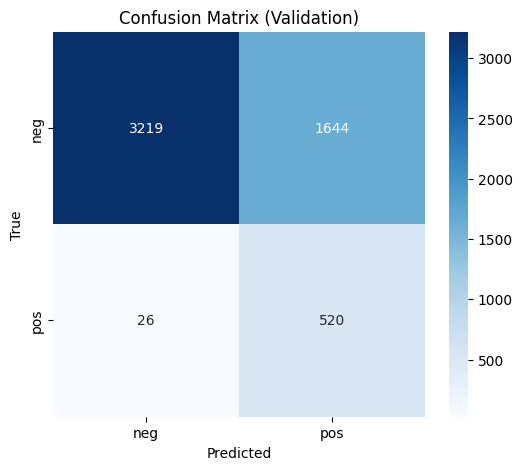

Test Evaluation:   0%|                                                       | 0/511 [00:00<?, ?it/s]

Test Evaluation:   0%|                                               | 1/511 [00:00<04:06,  2.07it/s]

Test Evaluation:   0%|▏                                              | 2/511 [00:00<04:06,  2.07it/s]

Test Evaluation:   1%|▎                                              | 3/511 [00:01<04:08,  2.05it/s]

Test Evaluation:   1%|▎                                              | 4/511 [00:01<04:07,  2.05it/s]

Test Evaluation:   1%|▍                                              | 5/511 [00:02<04:07,  2.04it/s]

Test Evaluation:   1%|▌                                              | 6/511 [00:02<03:59,  2.11it/s]

Test Evaluation:   1%|▋                                              | 7/511 [00:03<04:01,  2.09it/s]

Test Evaluation:   2%|▋                                              | 8/511 [00:03<04:04,  2.06it/s]

Test Evaluation:   2%|▊                                              | 9/511 [00:04<04:04,  2.06it/s]

Test Evaluation:   2%|▉                                             | 10/511 [00:04<03:56,  2.12it/s]

Test Evaluation:   2%|▉                                             | 11/511 [00:05<03:57,  2.11it/s]

Test Evaluation:   2%|█                                             | 12/511 [00:05<03:56,  2.11it/s]

Test Evaluation:   3%|█▏                                            | 13/511 [00:06<03:57,  2.09it/s]

Test Evaluation:   3%|█▎                                            | 14/511 [00:06<03:56,  2.10it/s]

Test Evaluation:   3%|█▎                                            | 15/511 [00:07<03:49,  2.16it/s]

Test Evaluation:   3%|█▍                                            | 16/511 [00:07<03:51,  2.14it/s]

Test Evaluation:   3%|█▌                                            | 17/511 [00:08<03:54,  2.10it/s]

Test Evaluation:   4%|█▌                                            | 18/511 [00:08<03:54,  2.10it/s]

Test Evaluation:   4%|█▋                                            | 19/511 [00:09<03:56,  2.08it/s]

Test Evaluation:   4%|█▊                                            | 20/511 [00:09<03:53,  2.10it/s]

Test Evaluation:   4%|█▉                                            | 21/511 [00:10<03:48,  2.14it/s]

Test Evaluation:   4%|█▉                                            | 22/511 [00:10<03:50,  2.13it/s]

Test Evaluation:   5%|██                                            | 23/511 [00:10<03:52,  2.10it/s]

Test Evaluation:   5%|██▏                                           | 24/511 [00:11<03:48,  2.13it/s]

Test Evaluation:   5%|██▎                                           | 25/511 [00:11<03:47,  2.14it/s]

Test Evaluation:   5%|██▎                                           | 26/511 [00:12<03:48,  2.12it/s]

Test Evaluation:   5%|██▍                                           | 27/511 [00:12<03:50,  2.10it/s]

Test Evaluation:   5%|██▌                                           | 28/511 [00:13<03:43,  2.16it/s]

Test Evaluation:   6%|██▌                                           | 29/511 [00:13<03:45,  2.14it/s]

Test Evaluation:   6%|██▋                                           | 30/511 [00:14<03:48,  2.10it/s]

Test Evaluation:   6%|██▊                                           | 31/511 [00:14<03:48,  2.10it/s]

Test Evaluation:   6%|██▉                                           | 32/511 [00:15<03:42,  2.15it/s]

Test Evaluation:   6%|██▉                                           | 33/511 [00:15<03:44,  2.12it/s]

Test Evaluation:   7%|███                                           | 34/511 [00:16<03:48,  2.09it/s]

Test Evaluation:   7%|███▏                                          | 35/511 [00:16<03:49,  2.07it/s]

Test Evaluation:   7%|███▏                                          | 36/511 [00:17<03:48,  2.08it/s]

Test Evaluation:   7%|███▎                                          | 37/511 [00:17<03:41,  2.14it/s]

Test Evaluation:   7%|███▍                                          | 38/511 [00:18<03:43,  2.12it/s]

Test Evaluation:   8%|███▌                                          | 39/511 [00:18<03:44,  2.10it/s]

Test Evaluation:   8%|███▌                                          | 40/511 [00:19<03:44,  2.09it/s]

Test Evaluation:   8%|███▋                                          | 41/511 [00:19<03:37,  2.17it/s]

Test Evaluation:   8%|███▊                                          | 42/511 [00:19<03:38,  2.15it/s]

Test Evaluation:   8%|███▊                                          | 43/511 [00:20<03:40,  2.12it/s]

Test Evaluation:   9%|███▉                                          | 44/511 [00:20<03:45,  2.07it/s]

Test Evaluation:   9%|████                                          | 45/511 [00:21<03:46,  2.06it/s]

Test Evaluation:   9%|████▏                                         | 46/511 [00:21<03:45,  2.06it/s]

Test Evaluation:   9%|████▏                                         | 47/511 [00:22<03:38,  2.12it/s]

Test Evaluation:   9%|████▎                                         | 48/511 [00:22<03:39,  2.11it/s]

Test Evaluation:  10%|████▍                                         | 49/511 [00:23<03:41,  2.08it/s]

Test Evaluation:  10%|████▌                                         | 50/511 [00:23<03:42,  2.07it/s]

Test Evaluation:  10%|████▌                                         | 51/511 [00:24<03:42,  2.07it/s]

Test Evaluation:  10%|████▋                                         | 52/511 [00:24<03:41,  2.07it/s]

Test Evaluation:  10%|████▊                                         | 53/511 [00:25<03:33,  2.14it/s]

Test Evaluation:  11%|████▊                                         | 54/511 [00:25<03:35,  2.12it/s]

Test Evaluation:  11%|████▉                                         | 55/511 [00:26<03:37,  2.10it/s]

Test Evaluation:  11%|█████                                         | 56/511 [00:26<03:37,  2.09it/s]

Test Evaluation:  11%|█████▏                                        | 57/511 [00:27<03:37,  2.08it/s]

Test Evaluation:  11%|█████▏                                        | 58/511 [00:27<03:37,  2.08it/s]

Test Evaluation:  12%|█████▎                                        | 59/511 [00:28<03:31,  2.14it/s]

Test Evaluation:  12%|█████▍                                        | 60/511 [00:28<03:33,  2.12it/s]

Test Evaluation:  12%|█████▍                                        | 61/511 [00:28<03:33,  2.11it/s]

Test Evaluation:  12%|█████▌                                        | 62/511 [00:29<03:34,  2.10it/s]

Test Evaluation:  12%|█████▋                                        | 63/511 [00:29<03:34,  2.08it/s]

Test Evaluation:  13%|█████▊                                        | 64/511 [00:30<03:35,  2.08it/s]

Test Evaluation:  13%|█████▊                                        | 65/511 [00:30<03:36,  2.06it/s]

Test Evaluation:  13%|█████▉                                        | 66/511 [00:31<03:34,  2.08it/s]

Test Evaluation:  13%|██████                                        | 67/511 [00:31<03:34,  2.07it/s]

Test Evaluation:  13%|██████                                        | 68/511 [00:32<03:33,  2.08it/s]

Test Evaluation:  14%|██████▏                                       | 69/511 [00:32<03:32,  2.08it/s]

Test Evaluation:  14%|██████▎                                       | 70/511 [00:33<03:32,  2.07it/s]

Test Evaluation:  14%|██████▍                                       | 71/511 [00:33<03:31,  2.08it/s]

Test Evaluation:  14%|██████▍                                       | 72/511 [00:34<03:31,  2.07it/s]

Test Evaluation:  14%|██████▌                                       | 73/511 [00:34<03:34,  2.04it/s]

Test Evaluation:  14%|██████▋                                       | 74/511 [00:35<03:34,  2.03it/s]

Test Evaluation:  15%|██████▊                                       | 75/511 [00:35<03:32,  2.06it/s]

Test Evaluation:  15%|██████▊                                       | 76/511 [00:36<03:30,  2.07it/s]

Test Evaluation:  15%|██████▉                                       | 77/511 [00:36<03:29,  2.07it/s]

Test Evaluation:  15%|███████                                       | 78/511 [00:37<03:28,  2.08it/s]

Test Evaluation:  15%|███████                                       | 79/511 [00:37<03:28,  2.08it/s]

Test Evaluation:  16%|███████▏                                      | 80/511 [00:38<03:27,  2.08it/s]

Test Evaluation:  16%|███████▎                                      | 81/511 [00:38<03:26,  2.08it/s]

Test Evaluation:  16%|███████▍                                      | 82/511 [00:39<03:26,  2.08it/s]

Test Evaluation:  16%|███████▍                                      | 83/511 [00:39<03:27,  2.06it/s]

Test Evaluation:  16%|███████▌                                      | 84/511 [00:40<03:26,  2.07it/s]

Test Evaluation:  17%|███████▋                                      | 85/511 [00:40<03:26,  2.07it/s]

Test Evaluation:  17%|███████▋                                      | 86/511 [00:41<03:25,  2.06it/s]

Test Evaluation:  17%|███████▊                                      | 87/511 [00:41<03:25,  2.07it/s]

Test Evaluation:  17%|███████▉                                      | 88/511 [00:42<03:24,  2.07it/s]

Test Evaluation:  17%|████████                                      | 89/511 [00:42<03:23,  2.07it/s]

Test Evaluation:  18%|████████                                      | 90/511 [00:43<03:24,  2.06it/s]

Test Evaluation:  18%|████████▏                                     | 91/511 [00:43<03:24,  2.06it/s]

Test Evaluation:  18%|████████▎                                     | 92/511 [00:44<03:23,  2.06it/s]

Test Evaluation:  18%|████████▎                                     | 93/511 [00:44<03:23,  2.05it/s]

Test Evaluation:  18%|████████▍                                     | 94/511 [00:44<03:22,  2.06it/s]

Test Evaluation:  19%|████████▌                                     | 95/511 [00:45<03:21,  2.06it/s]

Test Evaluation:  19%|████████▋                                     | 96/511 [00:45<03:20,  2.07it/s]

Test Evaluation:  19%|████████▋                                     | 97/511 [00:46<03:20,  2.07it/s]

Test Evaluation:  19%|████████▊                                     | 98/511 [00:46<03:20,  2.06it/s]

Test Evaluation:  19%|████████▉                                     | 99/511 [00:47<03:17,  2.09it/s]

Test Evaluation:  20%|████████▊                                    | 100/511 [00:47<03:13,  2.13it/s]

Test Evaluation:  20%|████████▉                                    | 101/511 [00:48<03:13,  2.12it/s]

Test Evaluation:  20%|████████▉                                    | 102/511 [00:48<03:14,  2.10it/s]

Test Evaluation:  20%|█████████                                    | 103/511 [00:49<03:14,  2.10it/s]

Test Evaluation:  20%|█████████▏                                   | 104/511 [00:49<03:13,  2.10it/s]

Test Evaluation:  21%|█████████▏                                   | 105/511 [00:50<03:13,  2.10it/s]

Test Evaluation:  21%|█████████▎                                   | 106/511 [00:50<03:13,  2.10it/s]

Test Evaluation:  21%|█████████▍                                   | 107/511 [00:51<03:17,  2.05it/s]

Test Evaluation:  21%|█████████▌                                   | 108/511 [00:51<03:16,  2.05it/s]

Test Evaluation:  21%|█████████▌                                   | 109/511 [00:52<03:15,  2.06it/s]

Test Evaluation:  22%|█████████▋                                   | 110/511 [00:52<03:15,  2.06it/s]

Test Evaluation:  22%|█████████▊                                   | 111/511 [00:53<03:14,  2.06it/s]

Test Evaluation:  22%|█████████▊                                   | 112/511 [00:53<03:14,  2.06it/s]

Test Evaluation:  22%|█████████▉                                   | 113/511 [00:54<03:13,  2.06it/s]

Test Evaluation:  22%|██████████                                   | 114/511 [00:54<03:12,  2.07it/s]

Test Evaluation:  23%|██████████▏                                  | 115/511 [00:55<03:11,  2.06it/s]

Test Evaluation:  23%|██████████▏                                  | 116/511 [00:55<03:12,  2.06it/s]

Test Evaluation:  23%|██████████▎                                  | 117/511 [00:56<03:10,  2.07it/s]

Test Evaluation:  23%|██████████▍                                  | 118/511 [00:56<03:10,  2.07it/s]

Test Evaluation:  23%|██████████▍                                  | 119/511 [00:56<03:03,  2.14it/s]

Test Evaluation:  23%|██████████▌                                  | 120/511 [00:57<03:04,  2.11it/s]

Test Evaluation:  24%|██████████▋                                  | 121/511 [00:57<03:05,  2.10it/s]

Test Evaluation:  24%|██████████▋                                  | 122/511 [00:58<03:06,  2.09it/s]

Test Evaluation:  24%|██████████▊                                  | 123/511 [00:58<03:06,  2.08it/s]

Test Evaluation:  24%|██████████▉                                  | 124/511 [00:59<03:06,  2.07it/s]

Test Evaluation:  24%|███████████                                  | 125/511 [00:59<03:06,  2.07it/s]

Test Evaluation:  25%|███████████                                  | 126/511 [01:00<03:06,  2.07it/s]

Test Evaluation:  25%|███████████▏                                 | 127/511 [01:00<03:05,  2.07it/s]

Test Evaluation:  25%|███████████▎                                 | 128/511 [01:01<03:04,  2.07it/s]

Test Evaluation:  25%|███████████▎                                 | 129/511 [01:01<03:04,  2.08it/s]

Test Evaluation:  25%|███████████▍                                 | 130/511 [01:02<03:03,  2.08it/s]

Test Evaluation:  26%|███████████▌                                 | 131/511 [01:02<03:02,  2.08it/s]

Test Evaluation:  26%|███████████▌                                 | 132/511 [01:03<03:01,  2.08it/s]

Test Evaluation:  26%|███████████▋                                 | 133/511 [01:03<03:02,  2.08it/s]

Test Evaluation:  26%|███████████▊                                 | 134/511 [01:04<03:01,  2.08it/s]

Test Evaluation:  26%|███████████▉                                 | 135/511 [01:04<03:01,  2.07it/s]

Test Evaluation:  27%|███████████▉                                 | 136/511 [01:05<03:00,  2.07it/s]

Test Evaluation:  27%|████████████                                 | 137/511 [01:05<03:02,  2.05it/s]

Test Evaluation:  27%|████████████▏                                | 138/511 [01:06<03:03,  2.03it/s]

Test Evaluation:  27%|████████████▏                                | 139/511 [01:06<03:01,  2.05it/s]

Test Evaluation:  27%|████████████▎                                | 140/511 [01:07<03:00,  2.06it/s]

Test Evaluation:  28%|████████████▍                                | 141/511 [01:07<03:00,  2.05it/s]

Test Evaluation:  28%|████████████▌                                | 142/511 [01:08<02:58,  2.06it/s]

Test Evaluation:  28%|████████████▌                                | 143/511 [01:08<03:00,  2.04it/s]

Test Evaluation:  28%|████████████▋                                | 144/511 [01:09<02:58,  2.05it/s]

Test Evaluation:  28%|████████████▊                                | 145/511 [01:09<02:57,  2.06it/s]

Test Evaluation:  29%|████████████▊                                | 146/511 [01:10<02:57,  2.06it/s]

Test Evaluation:  29%|████████████▉                                | 147/511 [01:10<02:57,  2.05it/s]

Test Evaluation:  29%|█████████████                                | 148/511 [01:11<02:56,  2.06it/s]

Test Evaluation:  29%|█████████████                                | 149/511 [01:11<02:55,  2.06it/s]

Test Evaluation:  29%|█████████████▏                               | 150/511 [01:12<02:55,  2.05it/s]

Test Evaluation:  30%|█████████████▎                               | 151/511 [01:12<02:54,  2.06it/s]

Test Evaluation:  30%|█████████████▍                               | 152/511 [01:12<02:53,  2.07it/s]

Test Evaluation:  30%|█████████████▍                               | 153/511 [01:13<02:53,  2.07it/s]

Test Evaluation:  30%|█████████████▌                               | 154/511 [01:13<02:53,  2.06it/s]

Test Evaluation:  30%|█████████████▋                               | 155/511 [01:14<02:51,  2.07it/s]

Test Evaluation:  31%|█████████████▋                               | 156/511 [01:14<02:51,  2.07it/s]

Test Evaluation:  31%|█████████████▊                               | 157/511 [01:15<02:51,  2.07it/s]

Test Evaluation:  31%|█████████████▉                               | 158/511 [01:15<02:50,  2.07it/s]

Test Evaluation:  31%|██████████████                               | 159/511 [01:16<02:44,  2.14it/s]

Test Evaluation:  31%|██████████████                               | 160/511 [01:16<02:45,  2.12it/s]

Test Evaluation:  32%|██████████████▏                              | 161/511 [01:17<02:46,  2.10it/s]

Test Evaluation:  32%|██████████████▎                              | 162/511 [01:17<02:48,  2.07it/s]

Test Evaluation:  32%|██████████████▎                              | 163/511 [01:18<02:48,  2.06it/s]

Test Evaluation:  32%|██████████████▍                              | 164/511 [01:18<02:47,  2.07it/s]

Test Evaluation:  32%|██████████████▌                              | 165/511 [01:19<02:46,  2.08it/s]

Test Evaluation:  32%|██████████████▌                              | 166/511 [01:19<02:46,  2.07it/s]

Test Evaluation:  33%|██████████████▋                              | 167/511 [01:20<02:46,  2.07it/s]

Test Evaluation:  33%|██████████████▊                              | 168/511 [01:20<02:45,  2.07it/s]

Test Evaluation:  33%|██████████████▉                              | 169/511 [01:21<02:47,  2.04it/s]

Test Evaluation:  33%|██████████████▉                              | 170/511 [01:21<02:45,  2.06it/s]

Test Evaluation:  33%|███████████████                              | 171/511 [01:22<02:46,  2.05it/s]

Test Evaluation:  34%|███████████████▏                             | 172/511 [01:22<02:44,  2.06it/s]

Test Evaluation:  34%|███████████████▏                             | 173/511 [01:23<02:43,  2.07it/s]

Test Evaluation:  34%|███████████████▎                             | 174/511 [01:23<02:42,  2.08it/s]

Test Evaluation:  34%|███████████████▍                             | 175/511 [01:24<02:41,  2.08it/s]

Test Evaluation:  34%|███████████████▍                             | 176/511 [01:24<02:41,  2.08it/s]

Test Evaluation:  35%|███████████████▌                             | 177/511 [01:25<02:38,  2.10it/s]

Test Evaluation:  35%|███████████████▋                             | 178/511 [01:25<02:36,  2.12it/s]

Test Evaluation:  35%|███████████████▊                             | 179/511 [01:25<02:37,  2.11it/s]

Test Evaluation:  35%|███████████████▊                             | 180/511 [01:26<02:37,  2.11it/s]

Test Evaluation:  35%|███████████████▉                             | 181/511 [01:26<02:37,  2.09it/s]

Test Evaluation:  36%|████████████████                             | 182/511 [01:27<02:37,  2.08it/s]

Test Evaluation:  36%|████████████████                             | 183/511 [01:27<02:38,  2.07it/s]

Test Evaluation:  36%|████████████████▏                            | 184/511 [01:28<02:37,  2.08it/s]

Test Evaluation:  36%|████████████████▎                            | 185/511 [01:28<02:36,  2.08it/s]

Test Evaluation:  36%|████████████████▍                            | 186/511 [01:29<02:36,  2.08it/s]

Test Evaluation:  37%|████████████████▍                            | 187/511 [01:29<02:35,  2.08it/s]

Test Evaluation:  37%|████████████████▌                            | 188/511 [01:30<02:34,  2.08it/s]

Test Evaluation:  37%|████████████████▋                            | 189/511 [01:30<02:35,  2.07it/s]

Test Evaluation:  37%|████████████████▋                            | 190/511 [01:31<02:35,  2.07it/s]

Test Evaluation:  37%|████████████████▊                            | 191/511 [01:31<02:34,  2.07it/s]

Test Evaluation:  38%|████████████████▉                            | 192/511 [01:32<02:34,  2.06it/s]

Test Evaluation:  38%|████████████████▉                            | 193/511 [01:32<02:34,  2.06it/s]

Test Evaluation:  38%|█████████████████                            | 194/511 [01:33<02:35,  2.04it/s]

Test Evaluation:  38%|█████████████████▏                           | 195/511 [01:33<02:34,  2.05it/s]

Test Evaluation:  38%|█████████████████▎                           | 196/511 [01:34<02:33,  2.06it/s]

Test Evaluation:  39%|█████████████████▎                           | 197/511 [01:34<02:31,  2.07it/s]

Test Evaluation:  39%|█████████████████▍                           | 198/511 [01:35<02:31,  2.07it/s]

Test Evaluation:  39%|█████████████████▌                           | 199/511 [01:35<02:30,  2.07it/s]

Test Evaluation:  39%|█████████████████▌                           | 200/511 [01:36<02:30,  2.07it/s]

Test Evaluation:  39%|█████████████████▋                           | 201/511 [01:36<02:31,  2.05it/s]

Test Evaluation:  40%|█████████████████▊                           | 202/511 [01:37<02:30,  2.05it/s]

Test Evaluation:  40%|█████████████████▉                           | 203/511 [01:37<02:29,  2.06it/s]

Test Evaluation:  40%|█████████████████▉                           | 204/511 [01:38<02:29,  2.06it/s]

Test Evaluation:  40%|██████████████████                           | 205/511 [01:38<02:28,  2.06it/s]

Test Evaluation:  40%|██████████████████▏                          | 206/511 [01:39<02:27,  2.07it/s]

Test Evaluation:  41%|██████████████████▏                          | 207/511 [01:39<02:22,  2.14it/s]

Test Evaluation:  41%|██████████████████▎                          | 208/511 [01:39<02:23,  2.11it/s]

Test Evaluation:  41%|██████████████████▍                          | 209/511 [01:40<02:24,  2.09it/s]

Test Evaluation:  41%|██████████████████▍                          | 210/511 [01:40<02:24,  2.09it/s]

Test Evaluation:  41%|██████████████████▌                          | 211/511 [01:41<02:24,  2.08it/s]

Test Evaluation:  41%|██████████████████▋                          | 212/511 [01:41<02:25,  2.06it/s]

Test Evaluation:  42%|██████████████████▊                          | 213/511 [01:42<02:24,  2.07it/s]

Test Evaluation:  42%|██████████████████▊                          | 214/511 [01:42<02:23,  2.07it/s]

Test Evaluation:  42%|██████████████████▉                          | 215/511 [01:43<02:23,  2.07it/s]

Test Evaluation:  42%|███████████████████                          | 216/511 [01:43<02:22,  2.06it/s]

Test Evaluation:  42%|███████████████████                          | 217/511 [01:44<02:22,  2.06it/s]

Test Evaluation:  43%|███████████████████▏                         | 218/511 [01:44<02:22,  2.06it/s]

Test Evaluation:  43%|███████████████████▎                         | 219/511 [01:45<02:21,  2.07it/s]

Test Evaluation:  43%|███████████████████▎                         | 220/511 [01:45<02:21,  2.06it/s]

Test Evaluation:  43%|███████████████████▍                         | 221/511 [01:46<02:20,  2.07it/s]

Test Evaluation:  43%|███████████████████▌                         | 222/511 [01:46<02:18,  2.08it/s]

Test Evaluation:  44%|███████████████████▋                         | 223/511 [01:47<02:18,  2.08it/s]

Test Evaluation:  44%|███████████████████▋                         | 224/511 [01:47<02:18,  2.07it/s]

Test Evaluation:  44%|███████████████████▊                         | 225/511 [01:48<02:18,  2.07it/s]

Test Evaluation:  44%|███████████████████▉                         | 226/511 [01:48<02:18,  2.06it/s]

Test Evaluation:  44%|███████████████████▉                         | 227/511 [01:49<02:18,  2.05it/s]

Test Evaluation:  45%|████████████████████                         | 228/511 [01:49<02:17,  2.06it/s]

Test Evaluation:  45%|████████████████████▏                        | 229/511 [01:50<02:16,  2.07it/s]

Test Evaluation:  45%|████████████████████▎                        | 230/511 [01:50<02:16,  2.06it/s]

Test Evaluation:  45%|████████████████████▎                        | 231/511 [01:51<02:16,  2.05it/s]

Test Evaluation:  45%|████████████████████▍                        | 232/511 [01:51<02:16,  2.05it/s]

Test Evaluation:  46%|████████████████████▌                        | 233/511 [01:52<02:15,  2.06it/s]

Test Evaluation:  46%|████████████████████▌                        | 234/511 [01:52<02:14,  2.06it/s]

Test Evaluation:  46%|████████████████████▋                        | 235/511 [01:53<02:13,  2.06it/s]

Test Evaluation:  46%|████████████████████▊                        | 236/511 [01:53<02:13,  2.06it/s]

Test Evaluation:  46%|████████████████████▊                        | 237/511 [01:54<02:13,  2.06it/s]

Test Evaluation:  47%|████████████████████▉                        | 238/511 [01:54<02:12,  2.06it/s]

Test Evaluation:  47%|█████████████████████                        | 239/511 [01:54<02:11,  2.07it/s]

Test Evaluation:  47%|█████████████████████▏                       | 240/511 [01:55<02:11,  2.06it/s]

Test Evaluation:  47%|█████████████████████▏                       | 241/511 [01:55<02:11,  2.06it/s]

Test Evaluation:  47%|█████████████████████▎                       | 242/511 [01:56<02:10,  2.06it/s]

Test Evaluation:  48%|█████████████████████▍                       | 243/511 [01:56<02:10,  2.06it/s]

Test Evaluation:  48%|█████████████████████▍                       | 244/511 [01:57<02:09,  2.06it/s]

Test Evaluation:  48%|█████████████████████▌                       | 245/511 [01:57<02:07,  2.09it/s]

Test Evaluation:  48%|█████████████████████▋                       | 246/511 [01:58<02:03,  2.14it/s]

Test Evaluation:  48%|█████████████████████▊                       | 247/511 [01:58<02:05,  2.11it/s]

Test Evaluation:  49%|█████████████████████▊                       | 248/511 [01:59<02:06,  2.09it/s]

Test Evaluation:  49%|█████████████████████▉                       | 249/511 [01:59<02:05,  2.08it/s]

Test Evaluation:  49%|██████████████████████                       | 250/511 [02:00<02:05,  2.08it/s]

Test Evaluation:  49%|██████████████████████                       | 251/511 [02:00<02:05,  2.07it/s]

Test Evaluation:  49%|██████████████████████▏                      | 252/511 [02:01<02:04,  2.07it/s]

Test Evaluation:  50%|██████████████████████▎                      | 253/511 [02:01<02:05,  2.06it/s]

Test Evaluation:  50%|██████████████████████▎                      | 254/511 [02:02<02:05,  2.05it/s]

Test Evaluation:  50%|██████████████████████▍                      | 255/511 [02:02<02:04,  2.06it/s]

Test Evaluation:  50%|██████████████████████▌                      | 256/511 [02:03<02:03,  2.07it/s]

Test Evaluation:  50%|██████████████████████▋                      | 257/511 [02:03<02:02,  2.07it/s]

Test Evaluation:  50%|██████████████████████▋                      | 258/511 [02:04<02:02,  2.07it/s]

Test Evaluation:  51%|██████████████████████▊                      | 259/511 [02:04<02:01,  2.07it/s]

Test Evaluation:  51%|██████████████████████▉                      | 260/511 [02:05<02:01,  2.06it/s]

Test Evaluation:  51%|██████████████████████▉                      | 261/511 [02:05<02:00,  2.07it/s]

Test Evaluation:  51%|███████████████████████                      | 262/511 [02:06<02:00,  2.07it/s]

Test Evaluation:  51%|███████████████████████▏                     | 263/511 [02:06<01:59,  2.07it/s]

Test Evaluation:  52%|███████████████████████▏                     | 264/511 [02:07<01:59,  2.07it/s]

Test Evaluation:  52%|███████████████████████▎                     | 265/511 [02:07<01:59,  2.05it/s]

Test Evaluation:  52%|███████████████████████▍                     | 266/511 [02:08<02:00,  2.04it/s]

Test Evaluation:  52%|███████████████████████▌                     | 267/511 [02:08<01:58,  2.06it/s]

Test Evaluation:  52%|███████████████████████▌                     | 268/511 [02:08<01:58,  2.05it/s]

Test Evaluation:  53%|███████████████████████▋                     | 269/511 [02:09<01:57,  2.06it/s]

Test Evaluation:  53%|███████████████████████▊                     | 270/511 [02:09<01:57,  2.06it/s]

Test Evaluation:  53%|███████████████████████▊                     | 271/511 [02:10<01:56,  2.05it/s]

Test Evaluation:  53%|███████████████████████▉                     | 272/511 [02:10<01:56,  2.06it/s]

Test Evaluation:  53%|████████████████████████                     | 273/511 [02:11<01:56,  2.05it/s]

Test Evaluation:  54%|████████████████████████▏                    | 274/511 [02:11<01:51,  2.13it/s]

Test Evaluation:  54%|████████████████████████▏                    | 275/511 [02:12<01:51,  2.11it/s]

Test Evaluation:  54%|████████████████████████▎                    | 276/511 [02:12<01:52,  2.10it/s]

Test Evaluation:  54%|████████████████████████▍                    | 277/511 [02:13<01:51,  2.09it/s]

Test Evaluation:  54%|████████████████████████▍                    | 278/511 [02:13<01:51,  2.08it/s]

Test Evaluation:  55%|████████████████████████▌                    | 279/511 [02:14<01:51,  2.09it/s]

Test Evaluation:  55%|████████████████████████▋                    | 280/511 [02:14<01:50,  2.09it/s]

Test Evaluation:  55%|████████████████████████▋                    | 281/511 [02:15<01:50,  2.09it/s]

Test Evaluation:  55%|████████████████████████▊                    | 282/511 [02:15<01:50,  2.08it/s]

Test Evaluation:  55%|████████████████████████▉                    | 283/511 [02:16<01:49,  2.08it/s]

Test Evaluation:  56%|█████████████████████████                    | 284/511 [02:16<01:49,  2.07it/s]

Test Evaluation:  56%|█████████████████████████                    | 285/511 [02:17<01:49,  2.06it/s]

Test Evaluation:  56%|█████████████████████████▏                   | 286/511 [02:17<01:49,  2.06it/s]

Test Evaluation:  56%|█████████████████████████▎                   | 287/511 [02:18<01:48,  2.07it/s]

Test Evaluation:  56%|█████████████████████████▎                   | 288/511 [02:18<01:48,  2.06it/s]

Test Evaluation:  57%|█████████████████████████▍                   | 289/511 [02:19<01:48,  2.05it/s]

Test Evaluation:  57%|█████████████████████████▌                   | 290/511 [02:19<01:47,  2.06it/s]

Test Evaluation:  57%|█████████████████████████▋                   | 291/511 [02:20<01:46,  2.06it/s]

Test Evaluation:  57%|█████████████████████████▋                   | 292/511 [02:20<01:46,  2.06it/s]

Test Evaluation:  57%|█████████████████████████▊                   | 293/511 [02:21<01:46,  2.06it/s]

Test Evaluation:  58%|█████████████████████████▉                   | 294/511 [02:21<01:45,  2.06it/s]

Test Evaluation:  58%|█████████████████████████▉                   | 295/511 [02:21<01:43,  2.08it/s]

Test Evaluation:  58%|██████████████████████████                   | 296/511 [02:22<01:43,  2.08it/s]

Test Evaluation:  58%|██████████████████████████▏                  | 297/511 [02:22<01:43,  2.06it/s]

Test Evaluation:  58%|██████████████████████████▏                  | 298/511 [02:23<01:43,  2.07it/s]

Test Evaluation:  59%|██████████████████████████▎                  | 299/511 [02:23<01:42,  2.06it/s]

Test Evaluation:  59%|██████████████████████████▍                  | 300/511 [02:24<01:42,  2.07it/s]

Test Evaluation:  59%|██████████████████████████▌                  | 301/511 [02:24<01:41,  2.07it/s]

Test Evaluation:  59%|██████████████████████████▌                  | 302/511 [02:25<01:40,  2.07it/s]

Test Evaluation:  59%|██████████████████████████▋                  | 303/511 [02:25<01:40,  2.08it/s]

Test Evaluation:  59%|██████████████████████████▊                  | 304/511 [02:26<01:39,  2.08it/s]

Test Evaluation:  60%|██████████████████████████▊                  | 305/511 [02:26<01:39,  2.07it/s]

Test Evaluation:  60%|██████████████████████████▉                  | 306/511 [02:27<01:39,  2.07it/s]

Test Evaluation:  60%|███████████████████████████                  | 307/511 [02:27<01:38,  2.07it/s]

Test Evaluation:  60%|███████████████████████████                  | 308/511 [02:28<01:37,  2.08it/s]

Test Evaluation:  60%|███████████████████████████▏                 | 309/511 [02:28<01:37,  2.07it/s]

Test Evaluation:  61%|███████████████████████████▎                 | 310/511 [02:29<01:36,  2.07it/s]

Test Evaluation:  61%|███████████████████████████▍                 | 311/511 [02:29<01:34,  2.12it/s]

Test Evaluation:  61%|███████████████████████████▍                 | 312/511 [02:30<01:33,  2.13it/s]

Test Evaluation:  61%|███████████████████████████▌                 | 313/511 [02:30<01:33,  2.12it/s]

Test Evaluation:  61%|███████████████████████████▋                 | 314/511 [02:31<01:33,  2.10it/s]

Test Evaluation:  62%|███████████████████████████▋                 | 315/511 [02:31<01:33,  2.09it/s]

Test Evaluation:  62%|███████████████████████████▊                 | 316/511 [02:32<01:33,  2.09it/s]

Test Evaluation:  62%|███████████████████████████▉                 | 317/511 [02:32<01:33,  2.08it/s]

Test Evaluation:  62%|████████████████████████████                 | 318/511 [02:33<01:33,  2.07it/s]

Test Evaluation:  62%|████████████████████████████                 | 319/511 [02:33<01:32,  2.07it/s]

Test Evaluation:  63%|████████████████████████████▏                | 320/511 [02:34<01:31,  2.08it/s]

Test Evaluation:  63%|████████████████████████████▎                | 321/511 [02:34<01:31,  2.07it/s]

Test Evaluation:  63%|████████████████████████████▎                | 322/511 [02:34<01:31,  2.06it/s]

Test Evaluation:  63%|████████████████████████████▍                | 323/511 [02:35<01:31,  2.05it/s]

Test Evaluation:  63%|████████████████████████████▌                | 324/511 [02:35<01:31,  2.05it/s]

Test Evaluation:  64%|████████████████████████████▌                | 325/511 [02:36<01:30,  2.06it/s]

Test Evaluation:  64%|████████████████████████████▋                | 326/511 [02:36<01:29,  2.06it/s]

Test Evaluation:  64%|████████████████████████████▊                | 327/511 [02:37<01:29,  2.06it/s]

Test Evaluation:  64%|████████████████████████████▉                | 328/511 [02:37<01:28,  2.06it/s]

Test Evaluation:  64%|████████████████████████████▉                | 329/511 [02:38<01:29,  2.03it/s]

Test Evaluation:  65%|█████████████████████████████                | 330/511 [02:38<01:29,  2.02it/s]

Test Evaluation:  65%|█████████████████████████████▏               | 331/511 [02:39<01:28,  2.03it/s]

Test Evaluation:  65%|█████████████████████████████▏               | 332/511 [02:39<01:27,  2.04it/s]

Test Evaluation:  65%|█████████████████████████████▎               | 333/511 [02:40<01:26,  2.05it/s]

Test Evaluation:  65%|█████████████████████████████▍               | 334/511 [02:40<01:26,  2.06it/s]

Test Evaluation:  66%|█████████████████████████████▌               | 335/511 [02:41<01:25,  2.05it/s]

Test Evaluation:  66%|█████████████████████████████▌               | 336/511 [02:41<01:25,  2.05it/s]

Test Evaluation:  66%|█████████████████████████████▋               | 337/511 [02:42<01:24,  2.06it/s]

Test Evaluation:  66%|█████████████████████████████▊               | 338/511 [02:42<01:24,  2.05it/s]

Test Evaluation:  66%|█████████████████████████████▊               | 339/511 [02:43<01:20,  2.13it/s]

Test Evaluation:  67%|█████████████████████████████▉               | 340/511 [02:43<01:21,  2.10it/s]

Test Evaluation:  67%|██████████████████████████████               | 341/511 [02:44<01:21,  2.09it/s]

Test Evaluation:  67%|██████████████████████████████               | 342/511 [02:44<01:21,  2.08it/s]

Test Evaluation:  67%|██████████████████████████████▏              | 343/511 [02:45<01:20,  2.09it/s]

Test Evaluation:  67%|██████████████████████████████▎              | 344/511 [02:45<01:20,  2.07it/s]

Test Evaluation:  68%|██████████████████████████████▍              | 345/511 [02:46<01:20,  2.07it/s]

Test Evaluation:  68%|██████████████████████████████▍              | 346/511 [02:46<01:19,  2.07it/s]

Test Evaluation:  68%|██████████████████████████████▌              | 347/511 [02:47<01:19,  2.06it/s]

Test Evaluation:  68%|██████████████████████████████▋              | 348/511 [02:47<01:19,  2.06it/s]

Test Evaluation:  68%|██████████████████████████████▋              | 349/511 [02:48<01:18,  2.06it/s]

Test Evaluation:  68%|██████████████████████████████▊              | 350/511 [02:48<01:18,  2.06it/s]

Test Evaluation:  69%|██████████████████████████████▉              | 351/511 [02:49<01:17,  2.06it/s]

Test Evaluation:  69%|██████████████████████████████▉              | 352/511 [02:49<01:16,  2.07it/s]

Test Evaluation:  69%|███████████████████████████████              | 353/511 [02:50<01:16,  2.07it/s]

Test Evaluation:  69%|███████████████████████████████▏             | 354/511 [02:50<01:15,  2.07it/s]

Test Evaluation:  69%|███████████████████████████████▎             | 355/511 [02:50<01:16,  2.05it/s]

Test Evaluation:  70%|███████████████████████████████▎             | 356/511 [02:51<01:15,  2.06it/s]

Test Evaluation:  70%|███████████████████████████████▍             | 357/511 [02:51<01:14,  2.08it/s]

Test Evaluation:  70%|███████████████████████████████▌             | 358/511 [02:52<01:13,  2.08it/s]

Test Evaluation:  70%|███████████████████████████████▌             | 359/511 [02:52<01:13,  2.08it/s]

Test Evaluation:  70%|███████████████████████████████▋             | 360/511 [02:53<01:12,  2.08it/s]

Test Evaluation:  71%|███████████████████████████████▊             | 361/511 [02:53<01:12,  2.07it/s]

Test Evaluation:  71%|███████████████████████████████▉             | 362/511 [02:54<01:12,  2.06it/s]

Test Evaluation:  71%|███████████████████████████████▉             | 363/511 [02:54<01:11,  2.07it/s]

Test Evaluation:  71%|████████████████████████████████             | 364/511 [02:55<01:10,  2.08it/s]

Test Evaluation:  71%|████████████████████████████████▏            | 365/511 [02:55<01:08,  2.14it/s]

Test Evaluation:  72%|████████████████████████████████▏            | 366/511 [02:56<01:08,  2.11it/s]

Test Evaluation:  72%|████████████████████████████████▎            | 367/511 [02:56<01:08,  2.09it/s]

Test Evaluation:  72%|████████████████████████████████▍            | 368/511 [02:57<01:09,  2.07it/s]

Test Evaluation:  72%|████████████████████████████████▍            | 369/511 [02:57<01:09,  2.06it/s]

Test Evaluation:  72%|████████████████████████████████▌            | 370/511 [02:58<01:08,  2.07it/s]

Test Evaluation:  73%|████████████████████████████████▋            | 371/511 [02:58<01:07,  2.06it/s]

Test Evaluation:  73%|████████████████████████████████▊            | 372/511 [02:59<01:07,  2.06it/s]

Test Evaluation:  73%|████████████████████████████████▊            | 373/511 [02:59<01:07,  2.06it/s]

Test Evaluation:  73%|████████████████████████████████▉            | 374/511 [03:00<01:06,  2.06it/s]

Test Evaluation:  73%|█████████████████████████████████            | 375/511 [03:00<01:06,  2.05it/s]

Test Evaluation:  74%|█████████████████████████████████            | 376/511 [03:01<01:05,  2.06it/s]

Test Evaluation:  74%|█████████████████████████████████▏           | 377/511 [03:01<01:05,  2.06it/s]

Test Evaluation:  74%|█████████████████████████████████▎           | 378/511 [03:02<01:04,  2.06it/s]

Test Evaluation:  74%|█████████████████████████████████▍           | 379/511 [03:02<01:04,  2.06it/s]

Test Evaluation:  74%|█████████████████████████████████▍           | 380/511 [03:03<01:03,  2.06it/s]

Test Evaluation:  75%|█████████████████████████████████▌           | 381/511 [03:03<01:03,  2.06it/s]

Test Evaluation:  75%|█████████████████████████████████▋           | 382/511 [03:04<01:02,  2.06it/s]

Test Evaluation:  75%|█████████████████████████████████▋           | 383/511 [03:04<01:02,  2.06it/s]

Test Evaluation:  75%|█████████████████████████████████▊           | 384/511 [03:05<01:01,  2.07it/s]

Test Evaluation:  75%|█████████████████████████████████▉           | 385/511 [03:05<01:00,  2.08it/s]

Test Evaluation:  76%|█████████████████████████████████▉           | 386/511 [03:05<01:00,  2.08it/s]

Test Evaluation:  76%|██████████████████████████████████           | 387/511 [03:06<00:59,  2.08it/s]

Test Evaluation:  76%|██████████████████████████████████▏          | 388/511 [03:06<00:59,  2.08it/s]

Test Evaluation:  76%|██████████████████████████████████▎          | 389/511 [03:07<00:58,  2.08it/s]

Test Evaluation:  76%|██████████████████████████████████▎          | 390/511 [03:07<00:58,  2.06it/s]

Test Evaluation:  77%|██████████████████████████████████▍          | 391/511 [03:08<00:58,  2.05it/s]

Test Evaluation:  77%|██████████████████████████████████▌          | 392/511 [03:08<00:57,  2.06it/s]

Test Evaluation:  77%|██████████████████████████████████▌          | 393/511 [03:09<00:57,  2.05it/s]

Test Evaluation:  77%|██████████████████████████████████▋          | 394/511 [03:09<00:57,  2.05it/s]

Test Evaluation:  77%|██████████████████████████████████▊          | 395/511 [03:10<00:56,  2.05it/s]

Test Evaluation:  77%|██████████████████████████████████▊          | 396/511 [03:10<00:56,  2.05it/s]

Test Evaluation:  78%|██████████████████████████████████▉          | 397/511 [03:11<00:55,  2.05it/s]

Test Evaluation:  78%|███████████████████████████████████          | 398/511 [03:11<00:55,  2.05it/s]

Test Evaluation:  78%|███████████████████████████████████▏         | 399/511 [03:12<00:54,  2.05it/s]

Test Evaluation:  78%|███████████████████████████████████▏         | 400/511 [03:12<00:54,  2.04it/s]

Test Evaluation:  78%|███████████████████████████████████▎         | 401/511 [03:13<00:53,  2.05it/s]

Test Evaluation:  79%|███████████████████████████████████▍         | 402/511 [03:13<00:53,  2.04it/s]

Test Evaluation:  79%|███████████████████████████████████▍         | 403/511 [03:14<00:52,  2.05it/s]

Test Evaluation:  79%|███████████████████████████████████▌         | 404/511 [03:14<00:52,  2.05it/s]

Test Evaluation:  79%|███████████████████████████████████▋         | 405/511 [03:15<00:51,  2.06it/s]

Test Evaluation:  79%|███████████████████████████████████▊         | 406/511 [03:15<00:51,  2.06it/s]

Test Evaluation:  80%|███████████████████████████████████▊         | 407/511 [03:16<00:50,  2.05it/s]

Test Evaluation:  80%|███████████████████████████████████▉         | 408/511 [03:16<00:50,  2.05it/s]

Test Evaluation:  80%|████████████████████████████████████         | 409/511 [03:17<00:49,  2.05it/s]

Test Evaluation:  80%|████████████████████████████████████         | 410/511 [03:17<00:47,  2.12it/s]

Test Evaluation:  80%|████████████████████████████████████▏        | 411/511 [03:18<00:47,  2.08it/s]

Test Evaluation:  81%|████████████████████████████████████▎        | 412/511 [03:18<00:47,  2.09it/s]

Test Evaluation:  81%|████████████████████████████████████▎        | 413/511 [03:19<00:47,  2.08it/s]

Test Evaluation:  81%|████████████████████████████████████▍        | 414/511 [03:19<00:46,  2.08it/s]

Test Evaluation:  81%|████████████████████████████████████▌        | 415/511 [03:20<00:46,  2.07it/s]

Test Evaluation:  81%|████████████████████████████████████▋        | 416/511 [03:20<00:45,  2.07it/s]

Test Evaluation:  82%|████████████████████████████████████▋        | 417/511 [03:21<00:46,  2.04it/s]

Test Evaluation:  82%|████████████████████████████████████▊        | 418/511 [03:21<00:45,  2.06it/s]

Test Evaluation:  82%|████████████████████████████████████▉        | 419/511 [03:21<00:44,  2.07it/s]

Test Evaluation:  82%|████████████████████████████████████▉        | 420/511 [03:22<00:43,  2.07it/s]

Test Evaluation:  82%|█████████████████████████████████████        | 421/511 [03:22<00:43,  2.06it/s]

Test Evaluation:  83%|█████████████████████████████████████▏       | 422/511 [03:23<00:43,  2.05it/s]

Test Evaluation:  83%|█████████████████████████████████████▎       | 423/511 [03:23<00:42,  2.05it/s]

Test Evaluation:  83%|█████████████████████████████████████▎       | 424/511 [03:24<00:42,  2.06it/s]

Test Evaluation:  83%|█████████████████████████████████████▍       | 425/511 [03:24<00:41,  2.07it/s]

Test Evaluation:  83%|█████████████████████████████████████▌       | 426/511 [03:25<00:41,  2.06it/s]

Test Evaluation:  84%|█████████████████████████████████████▌       | 427/511 [03:25<00:40,  2.05it/s]

Test Evaluation:  84%|█████████████████████████████████████▋       | 428/511 [03:26<00:40,  2.05it/s]

Test Evaluation:  84%|█████████████████████████████████████▊       | 429/511 [03:26<00:39,  2.06it/s]

Test Evaluation:  84%|█████████████████████████████████████▊       | 430/511 [03:27<00:39,  2.05it/s]

Test Evaluation:  84%|█████████████████████████████████████▉       | 431/511 [03:27<00:38,  2.06it/s]

Test Evaluation:  85%|██████████████████████████████████████       | 432/511 [03:28<00:38,  2.05it/s]

Test Evaluation:  85%|██████████████████████████████████████▏      | 433/511 [03:28<00:38,  2.05it/s]

Test Evaluation:  85%|██████████████████████████████████████▏      | 434/511 [03:29<00:36,  2.12it/s]

Test Evaluation:  85%|██████████████████████████████████████▎      | 435/511 [03:29<00:36,  2.09it/s]

Test Evaluation:  85%|██████████████████████████████████████▍      | 436/511 [03:30<00:35,  2.09it/s]

Test Evaluation:  86%|██████████████████████████████████████▍      | 437/511 [03:30<00:35,  2.08it/s]

Test Evaluation:  86%|██████████████████████████████████████▌      | 438/511 [03:31<00:35,  2.07it/s]

Test Evaluation:  86%|██████████████████████████████████████▋      | 439/511 [03:31<00:34,  2.08it/s]

Test Evaluation:  86%|██████████████████████████████████████▋      | 440/511 [03:32<00:34,  2.08it/s]

Test Evaluation:  86%|██████████████████████████████████████▊      | 441/511 [03:32<00:33,  2.08it/s]

Test Evaluation:  86%|██████████████████████████████████████▉      | 442/511 [03:33<00:33,  2.07it/s]

Test Evaluation:  87%|███████████████████████████████████████      | 443/511 [03:33<00:32,  2.07it/s]

Test Evaluation:  87%|███████████████████████████████████████      | 444/511 [03:34<00:32,  2.05it/s]

Test Evaluation:  87%|███████████████████████████████████████▏     | 445/511 [03:34<00:32,  2.06it/s]

Test Evaluation:  87%|███████████████████████████████████████▎     | 446/511 [03:35<00:31,  2.06it/s]

Test Evaluation:  87%|███████████████████████████████████████▎     | 447/511 [03:35<00:31,  2.06it/s]

Test Evaluation:  88%|███████████████████████████████████████▍     | 448/511 [03:36<00:30,  2.06it/s]

Test Evaluation:  88%|███████████████████████████████████████▌     | 449/511 [03:36<00:30,  2.06it/s]

Test Evaluation:  88%|███████████████████████████████████████▋     | 450/511 [03:36<00:29,  2.07it/s]

Test Evaluation:  88%|███████████████████████████████████████▋     | 451/511 [03:37<00:29,  2.06it/s]

Test Evaluation:  88%|███████████████████████████████████████▊     | 452/511 [03:37<00:28,  2.06it/s]

Test Evaluation:  89%|███████████████████████████████████████▉     | 453/511 [03:38<00:28,  2.06it/s]

Test Evaluation:  89%|███████████████████████████████████████▉     | 454/511 [03:38<00:27,  2.05it/s]

Test Evaluation:  89%|████████████████████████████████████████     | 455/511 [03:39<00:27,  2.07it/s]

Test Evaluation:  89%|████████████████████████████████████████▏    | 456/511 [03:39<00:26,  2.06it/s]

Test Evaluation:  89%|████████████████████████████████████████▏    | 457/511 [03:40<00:26,  2.04it/s]

Test Evaluation:  90%|████████████████████████████████████████▎    | 458/511 [03:40<00:25,  2.05it/s]

Test Evaluation:  90%|████████████████████████████████████████▍    | 459/511 [03:41<00:25,  2.05it/s]

Test Evaluation:  90%|████████████████████████████████████████▌    | 460/511 [03:41<00:24,  2.05it/s]

Test Evaluation:  90%|████████████████████████████████████████▌    | 461/511 [03:42<00:24,  2.05it/s]

Test Evaluation:  90%|████████████████████████████████████████▋    | 462/511 [03:42<00:23,  2.05it/s]

Test Evaluation:  91%|████████████████████████████████████████▊    | 463/511 [03:43<00:22,  2.13it/s]

Test Evaluation:  91%|████████████████████████████████████████▊    | 464/511 [03:43<00:22,  2.10it/s]

Test Evaluation:  91%|████████████████████████████████████████▉    | 465/511 [03:44<00:21,  2.09it/s]

Test Evaluation:  91%|█████████████████████████████████████████    | 466/511 [03:44<00:21,  2.09it/s]

Test Evaluation:  91%|█████████████████████████████████████████▏   | 467/511 [03:45<00:21,  2.08it/s]

Test Evaluation:  92%|█████████████████████████████████████████▏   | 468/511 [03:45<00:20,  2.07it/s]

Test Evaluation:  92%|█████████████████████████████████████████▎   | 469/511 [03:46<00:20,  2.07it/s]

Test Evaluation:  92%|█████████████████████████████████████████▍   | 470/511 [03:46<00:19,  2.06it/s]

Test Evaluation:  92%|█████████████████████████████████████████▍   | 471/511 [03:47<00:19,  2.07it/s]

Test Evaluation:  92%|█████████████████████████████████████████▌   | 472/511 [03:47<00:19,  2.05it/s]

Test Evaluation:  93%|█████████████████████████████████████████▋   | 473/511 [03:48<00:18,  2.05it/s]

Test Evaluation:  93%|█████████████████████████████████████████▋   | 474/511 [03:48<00:18,  2.04it/s]

Test Evaluation:  93%|█████████████████████████████████████████▊   | 475/511 [03:49<00:17,  2.04it/s]

Test Evaluation:  93%|█████████████████████████████████████████▉   | 476/511 [03:49<00:17,  2.04it/s]

Test Evaluation:  93%|██████████████████████████████████████████   | 477/511 [03:50<00:16,  2.05it/s]

Test Evaluation:  94%|██████████████████████████████████████████   | 478/511 [03:50<00:16,  2.05it/s]

Test Evaluation:  94%|██████████████████████████████████████████▏  | 479/511 [03:51<00:15,  2.03it/s]

Test Evaluation:  94%|██████████████████████████████████████████▎  | 480/511 [03:51<00:15,  2.04it/s]

Test Evaluation:  94%|██████████████████████████████████████████▎  | 481/511 [03:52<00:14,  2.05it/s]

Test Evaluation:  94%|██████████████████████████████████████████▍  | 482/511 [03:52<00:13,  2.09it/s]

Test Evaluation:  95%|██████████████████████████████████████████▌  | 483/511 [03:52<00:13,  2.10it/s]

Test Evaluation:  95%|██████████████████████████████████████████▌  | 484/511 [03:53<00:12,  2.10it/s]

Test Evaluation:  95%|██████████████████████████████████████████▋  | 485/511 [03:53<00:12,  2.08it/s]

Test Evaluation:  95%|██████████████████████████████████████████▊  | 486/511 [03:54<00:11,  2.08it/s]

Test Evaluation:  95%|██████████████████████████████████████████▉  | 487/511 [03:54<00:11,  2.08it/s]

Test Evaluation:  95%|██████████████████████████████████████████▉  | 488/511 [03:55<00:11,  2.07it/s]

Test Evaluation:  96%|███████████████████████████████████████████  | 489/511 [03:55<00:10,  2.07it/s]

Test Evaluation:  96%|███████████████████████████████████████████▏ | 490/511 [03:56<00:10,  2.06it/s]

Test Evaluation:  96%|███████████████████████████████████████████▏ | 491/511 [03:56<00:09,  2.07it/s]

Test Evaluation:  96%|███████████████████████████████████████████▎ | 492/511 [03:57<00:09,  2.07it/s]

Test Evaluation:  96%|███████████████████████████████████████████▍ | 493/511 [03:57<00:08,  2.06it/s]

Test Evaluation:  97%|███████████████████████████████████████████▌ | 494/511 [03:58<00:08,  2.05it/s]

Test Evaluation:  97%|███████████████████████████████████████████▌ | 495/511 [03:58<00:07,  2.06it/s]

Test Evaluation:  97%|███████████████████████████████████████████▋ | 496/511 [03:59<00:07,  2.05it/s]

Test Evaluation:  97%|███████████████████████████████████████████▊ | 497/511 [03:59<00:06,  2.04it/s]

Test Evaluation:  97%|███████████████████████████████████████████▊ | 498/511 [04:00<00:06,  2.05it/s]

Test Evaluation:  98%|███████████████████████████████████████████▉ | 499/511 [04:00<00:05,  2.05it/s]

Test Evaluation:  98%|████████████████████████████████████████████ | 500/511 [04:01<00:05,  2.06it/s]

Test Evaluation:  98%|████████████████████████████████████████████ | 501/511 [04:01<00:04,  2.07it/s]

Test Evaluation:  98%|████████████████████████████████████████████▏| 502/511 [04:02<00:04,  2.07it/s]

Test Evaluation:  98%|████████████████████████████████████████████▎| 503/511 [04:02<00:03,  2.06it/s]

Test Evaluation:  99%|████████████████████████████████████████████▍| 504/511 [04:03<00:03,  2.06it/s]

Test Evaluation:  99%|████████████████████████████████████████████▍| 505/511 [04:03<00:02,  2.06it/s]

Test Evaluation:  99%|████████████████████████████████████████████▌| 506/511 [04:04<00:02,  2.05it/s]

Test Evaluation:  99%|████████████████████████████████████████████▋| 507/511 [04:04<00:01,  2.05it/s]

Test Evaluation:  99%|████████████████████████████████████████████▋| 508/511 [04:05<00:01,  2.06it/s]

Test Evaluation: 100%|████████████████████████████████████████████▊| 509/511 [04:05<00:00,  2.07it/s]

Test Evaluation: 100%|████████████████████████████████████████████▉| 510/511 [04:06<00:00,  2.05it/s]

Test Evaluation: 100%|█████████████████████████████████████████████| 511/511 [04:06<00:00,  2.22it/s]

Test Evaluation: 100%|█████████████████████████████████████████████| 511/511 [04:06<00:00,  2.07it/s]

Test Loss: 0.1797 | Test Acc: 88.71% | Test F1: 0.7781
Classification Report (Test):
              precision    recall  f1-score   support

         neg       0.97      0.90      0.93      7240
         pos       0.50      0.81      0.62       934

    accuracy                           0.89      8174
   macro avg       0.74      0.86      0.78      8174
weighted avg       0.92      0.89      0.90      8174



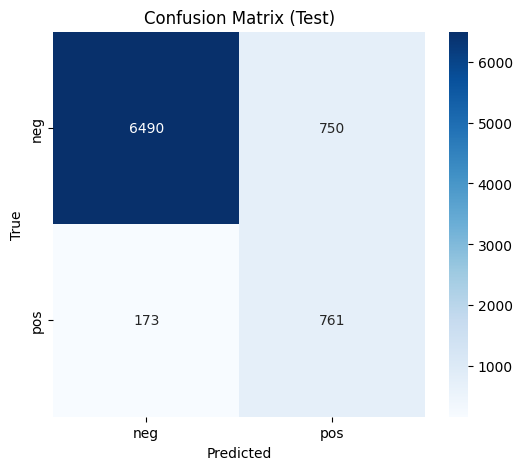

Epoch 10 Summary:
Train Loss: 0.1457 | Train Acc: 89.47% | Train F1: 0.8940
Val Loss: 0.2648 | Val Acc: 69.13% | Val F1: 0.5889
Test Loss: 0.1797 | Test Acc: 88.71% | Test F1: 0.7781
Epoch Time: 970.97s | GPU Memory Usage: 767.04 MB



Checkpoint saved at checkpoints\epoch_10.pth
No improvement in validation loss for 4 epoch(s).


In [14]:
# Number of training epochs
num_epochs = 10  # Adjust as necessary to balance performance and overfitting risks

# Train the model and record training history
history_df = train(
    model=model,  # The initialized VisionTransformerWithTemporal model
    train_loader=train_loader,  # DataLoader for training data
    val_loader=val_loader,  # DataLoader for validation data
    test_loader=test_loader,  # DataLoader for test data
    criterion=criterion,  # Loss function (e.g., CrossEntropyLoss)
    optimizer=optimizer,  # Optimizer (e.g., AdamW)
    scheduler=scheduler,  # Learning rate scheduler (e.g., ReduceLROnPlateau)
    device=device,  # Computation device (e.g., 'cuda', 'mps', or 'cpu')
    num_epochs=num_epochs,  # Total number of epochs to train
    patience=5,  # Early stopping patience to prevent overfitting
    checkpoint_dir='checkpoints/vit-lstm',  # Directory to save model checkpoints
    save_every=1  # Save a checkpoint after every epoch
)

# Validate history_df
assert history_df is not None, "Training returned no history. Check the train function."
assert not history_df.empty, "History DataFrame is empty. Check for issues in training or logging."

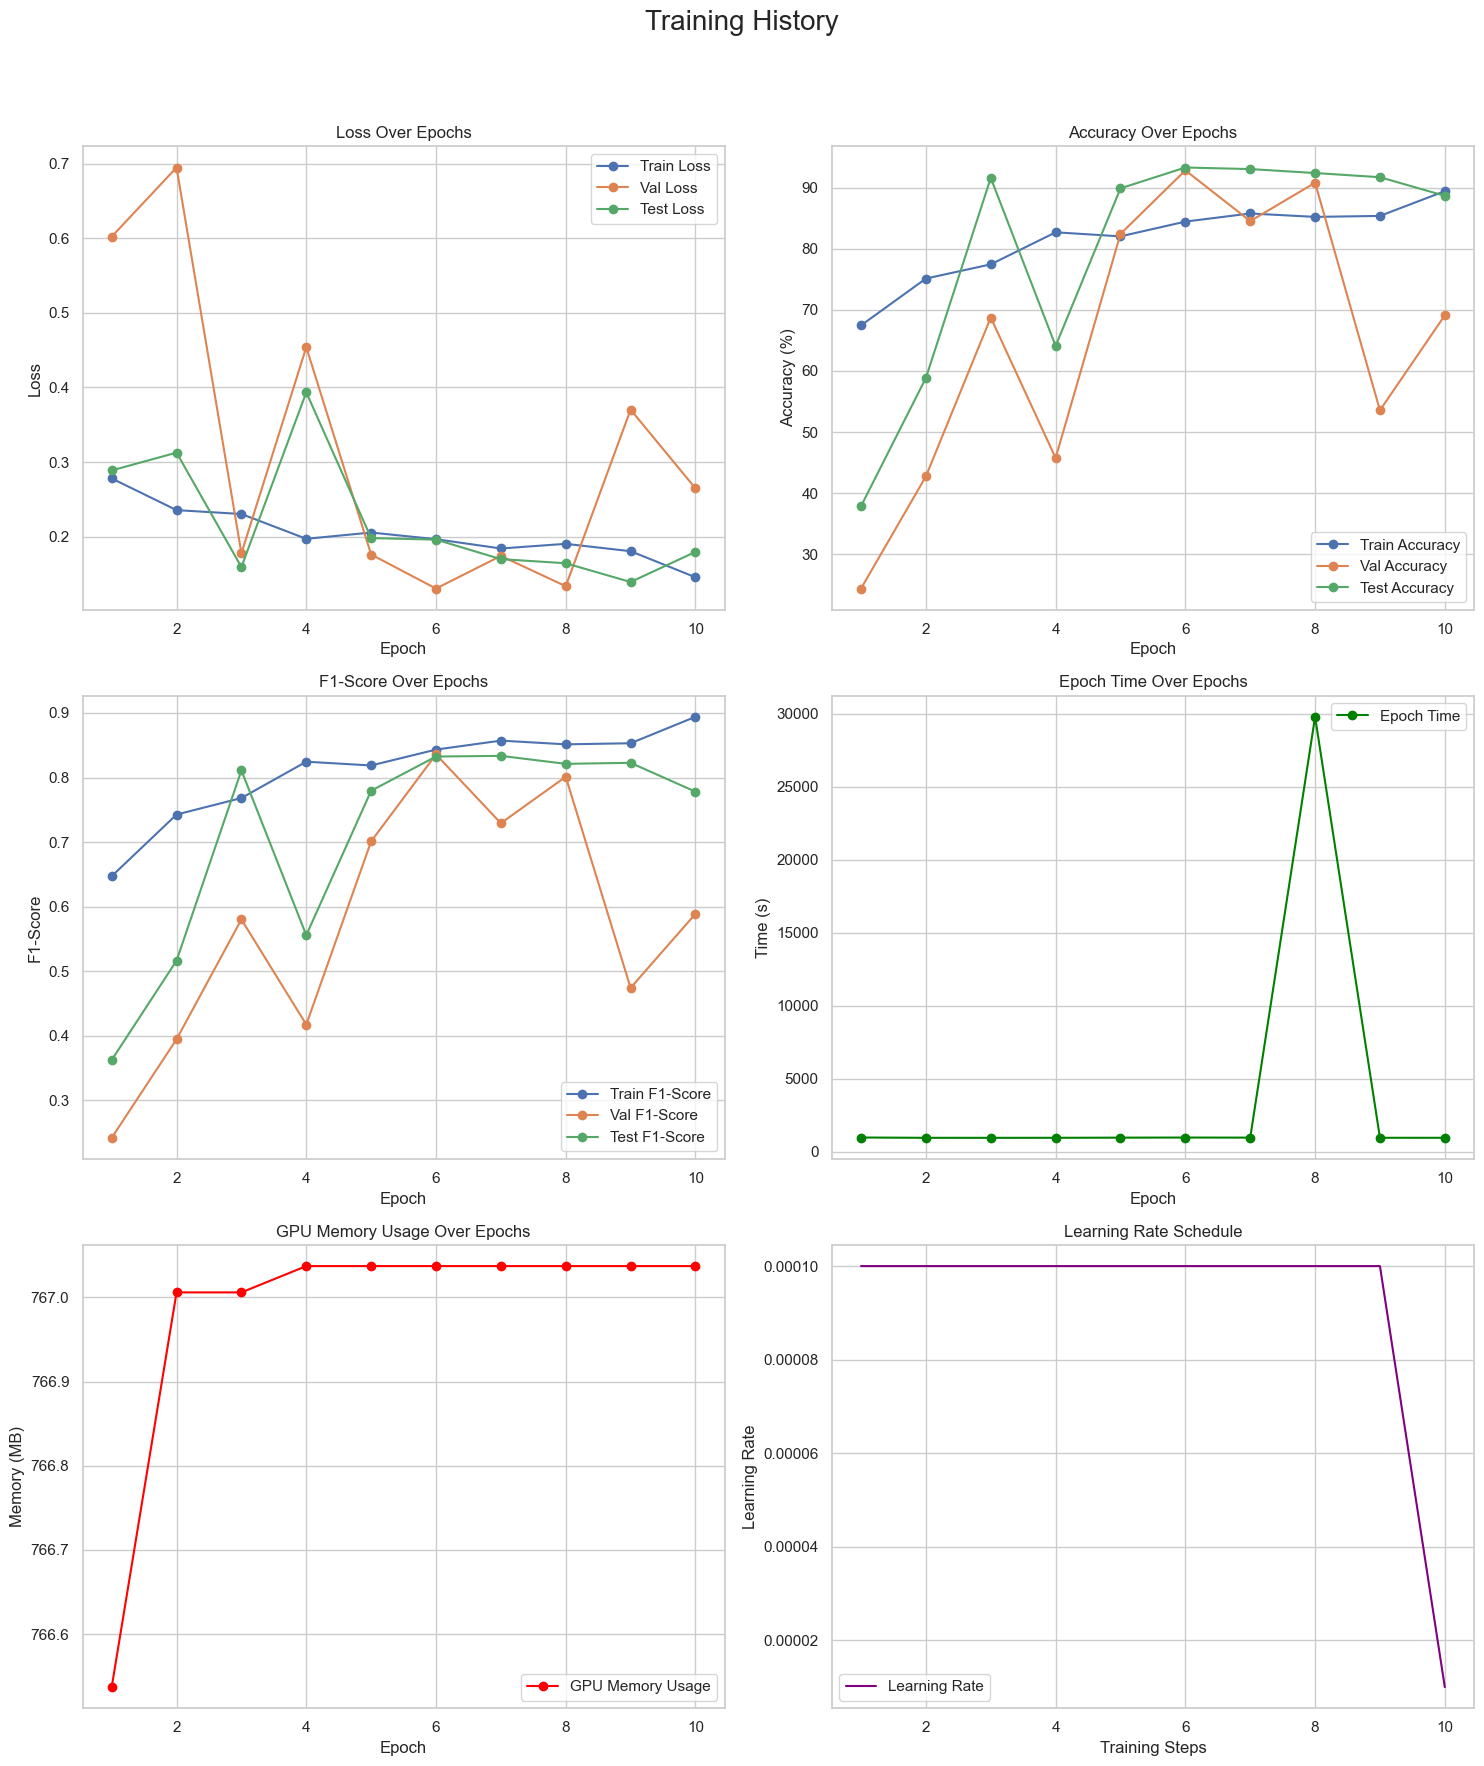

In [15]:
# Plot training history
plot_training_history(history_df)

C:\Users\User\AppData\Local\Temp\ipykernel_31352\566081622.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path, map_location

Best model loaded successfully.


Test Evaluation:   0%|                                                       | 0/511 [00:00<?, ?it/s]C:\Users\User\Desktop\Term 7\CV\2024_SUTD_CV_Final_Project\env\lib\site-packages\timm\models\vision_transformer.py:92: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  x = F.scaled_dot_product_attention(
Test Evaluation: 100%|██████████| 511/511 [04:59<00:00,  1.71it/s, Loss=0.1961, F1=0.8325, Acc=93.34]

Test Loss: 0.1961 | Test Acc: 93.34% | Test F1: 0.8325
Classification Report (Test):
              precision    recall  f1-score   support

         neg       0.96      0.97      0.96      7240
         pos       0.72      0.69      0.70       934

    accuracy                           0.93      8174
   macro avg       0.84      0.83      0.83      8174
weighted avg       0.93      0.93      0.93      8174

Test Loss: 0.1961
Test Accuracy: 93.34%
Test F1-Score: 0.8325


Test Evaluation:   5%|██▏                                           | 24/511 [00:11<03:52,  2.10it/s]

Test Evaluation:   5%|██▎                                           | 25/511 [00:12<03:49,  2.12it/s]

Test Evaluation:   5%|██▎                                           | 26/511 [00:12<03:50,  2.10it/s]

Test Evaluation:   5%|██▍                                           | 27/511 [00:13<03:51,  2.09it/s]

Test Evaluation:   5%|██▌                                           | 28/511 [00:13<03:45,  2.14it/s]

Test Evaluation:   6%|██▌                                           | 29/511 [00:14<03:48,  2.11it/s]

Test Evaluation:   6%|██▋                                           | 30/511 [00:14<03:48,  2.10it/s]

Test Evaluation:   6%|██▊                                           | 31/511 [00:14<03:49,  2.09it/s]

Test Evaluation:   6%|██▉                                           | 32/511 [00:15<03:43,  2.14it/s]

Test Evaluation:   6%|██▉                                           | 33/511 [00:15<03:45,  2.12it/s]

Test Evaluation:   7%|███                                           | 34/511 [00:16<03:46,  2.11it/s]

Test Evaluation:   7%|███▏                                          | 35/511 [00:16<03:47,  2.09it/s]

Test Evaluation:   7%|███▏                                          | 36/511 [00:17<03:47,  2.09it/s]

Test Evaluation:   7%|███▎                                          | 37/511 [00:17<03:40,  2.15it/s]

Test Evaluation:   7%|███▍                                          | 38/511 [00:18<03:43,  2.12it/s]

Test Evaluation:   8%|███▌                                          | 39/511 [00:18<03:46,  2.09it/s]

Test Evaluation:   8%|███▌                                          | 40/511 [00:19<03:45,  2.09it/s]

Test Evaluation:   8%|███▋                                          | 41/511 [00:19<03:38,  2.15it/s]

Test Evaluation:   8%|███▊                                          | 42/511 [00:20<03:41,  2.12it/s]

Test Evaluation:   8%|███▊                                          | 43/511 [00:20<03:43,  2.09it/s]

Test Evaluation:   9%|███▉                                          | 44/511 [00:21<03:44,  2.08it/s]

Test Evaluation:   9%|████                                          | 45/511 [00:21<03:44,  2.07it/s]

Test Evaluation:   9%|████▏                                         | 46/511 [00:22<03:44,  2.07it/s]

Test Evaluation:   9%|████▏                                         | 47/511 [00:22<03:38,  2.12it/s]

Test Evaluation:   9%|████▎                                         | 48/511 [00:23<03:40,  2.10it/s]

Test Evaluation:  10%|████▍                                         | 49/511 [00:23<03:41,  2.08it/s]

Test Evaluation:  10%|████▌                                         | 50/511 [00:24<03:41,  2.08it/s]

Test Evaluation:  10%|████▌                                         | 51/511 [00:24<03:41,  2.08it/s]

Test Evaluation:  10%|████▋                                         | 52/511 [00:24<03:42,  2.06it/s]

Test Evaluation:  10%|████▊                                         | 53/511 [00:25<03:34,  2.13it/s]

Test Evaluation:  11%|████▊                                         | 54/511 [00:25<03:36,  2.11it/s]

Test Evaluation:  11%|████▉                                         | 55/511 [00:26<03:38,  2.09it/s]

Test Evaluation:  11%|█████                                         | 56/511 [00:26<03:39,  2.08it/s]

Test Evaluation:  11%|█████▏                                        | 57/511 [00:27<03:40,  2.06it/s]

Test Evaluation:  11%|█████▏                                        | 58/511 [00:27<03:40,  2.06it/s]

Test Evaluation:  12%|█████▎                                        | 59/511 [00:28<03:33,  2.12it/s]

Test Evaluation:  12%|█████▍                                        | 60/511 [00:28<03:34,  2.11it/s]

Test Evaluation:  12%|█████▍                                        | 61/511 [00:29<03:36,  2.08it/s]

Test Evaluation:  12%|█████▌                                        | 62/511 [00:29<03:36,  2.08it/s]

Test Evaluation:  12%|█████▋                                        | 63/511 [00:30<03:35,  2.08it/s]

Test Evaluation:  13%|█████▊                                        | 64/511 [00:30<03:39,  2.04it/s]

Test Evaluation:  13%|█████▊                                        | 65/511 [00:31<03:39,  2.04it/s]

Test Evaluation:  13%|█████▉                                        | 66/511 [00:31<03:37,  2.05it/s]

Test Evaluation:  13%|██████                                        | 67/511 [00:32<03:35,  2.06it/s]

Test Evaluation:  13%|██████                                        | 68/511 [00:32<03:35,  2.06it/s]

Test Evaluation:  14%|██████▏                                       | 69/511 [00:33<03:34,  2.06it/s]

Test Evaluation:  14%|██████▎                                       | 70/511 [00:33<03:34,  2.06it/s]

Test Evaluation:  14%|██████▍                                       | 71/511 [00:34<03:33,  2.06it/s]

Test Evaluation:  14%|██████▍                                       | 72/511 [00:34<03:31,  2.07it/s]

Test Evaluation:  14%|██████▌                                       | 73/511 [00:35<03:31,  2.07it/s]

Test Evaluation:  14%|██████▋                                       | 74/511 [00:35<03:31,  2.07it/s]

Test Evaluation:  15%|██████▊                                       | 75/511 [00:36<03:30,  2.07it/s]

Test Evaluation:  15%|██████▊                                       | 76/511 [00:36<03:30,  2.06it/s]

Test Evaluation:  15%|██████▉                                       | 77/511 [00:37<03:31,  2.06it/s]

Test Evaluation:  15%|███████                                       | 78/511 [00:37<03:29,  2.07it/s]

Test Evaluation:  15%|███████                                       | 79/511 [00:38<03:28,  2.07it/s]

Test Evaluation:  16%|███████▏                                      | 80/511 [00:38<03:28,  2.06it/s]

Test Evaluation:  16%|███████▎                                      | 81/511 [00:38<03:27,  2.07it/s]

Test Evaluation:  16%|███████▍                                      | 82/511 [00:39<03:26,  2.07it/s]

Test Evaluation:  16%|███████▍                                      | 83/511 [00:39<03:26,  2.07it/s]

Test Evaluation:  16%|███████▌                                      | 84/511 [00:40<03:25,  2.07it/s]

Test Evaluation:  17%|███████▋                                      | 85/511 [00:40<03:25,  2.08it/s]

Test Evaluation:  17%|███████▋                                      | 86/511 [00:41<03:26,  2.06it/s]

Test Evaluation:  17%|███████▊                                      | 87/511 [00:41<03:25,  2.07it/s]

Test Evaluation:  17%|███████▉                                      | 88/511 [00:42<03:24,  2.07it/s]

Test Evaluation:  17%|████████                                      | 89/511 [00:42<03:25,  2.05it/s]

Test Evaluation:  18%|████████                                      | 90/511 [00:43<03:24,  2.06it/s]

Test Evaluation:  18%|████████▏                                     | 91/511 [00:43<03:23,  2.07it/s]

Test Evaluation:  18%|████████▎                                     | 92/511 [00:44<03:23,  2.06it/s]

Test Evaluation:  18%|████████▎                                     | 93/511 [00:44<03:23,  2.05it/s]

Test Evaluation:  18%|████████▍                                     | 94/511 [00:45<03:24,  2.04it/s]

Test Evaluation:  19%|████████▌                                     | 95/511 [00:45<03:24,  2.03it/s]

Test Evaluation:  19%|████████▋                                     | 96/511 [00:46<03:24,  2.03it/s]

Test Evaluation:  19%|████████▋                                     | 97/511 [00:46<03:24,  2.02it/s]

Test Evaluation:  19%|████████▊                                     | 98/511 [00:47<03:23,  2.03it/s]

Test Evaluation:  19%|████████▉                                     | 99/511 [00:47<03:20,  2.05it/s]

Test Evaluation:  20%|████████▊                                    | 100/511 [00:48<03:14,  2.11it/s]

Test Evaluation:  20%|████████▉                                    | 101/511 [00:48<03:15,  2.10it/s]

Test Evaluation:  20%|████████▉                                    | 102/511 [00:49<03:16,  2.08it/s]

Test Evaluation:  20%|█████████                                    | 103/511 [00:49<03:15,  2.09it/s]

Test Evaluation:  20%|█████████▏                                   | 104/511 [00:50<03:15,  2.08it/s]

Test Evaluation:  21%|█████████▏                                   | 105/511 [00:50<03:16,  2.07it/s]

Test Evaluation:  21%|█████████▎                                   | 106/511 [00:51<03:16,  2.06it/s]

Test Evaluation:  21%|█████████▍                                   | 107/511 [00:51<03:15,  2.06it/s]

Test Evaluation:  21%|█████████▌                                   | 108/511 [00:52<03:14,  2.07it/s]

Test Evaluation:  21%|█████████▌                                   | 109/511 [00:52<03:13,  2.07it/s]

Test Evaluation:  22%|█████████▋                                   | 110/511 [00:53<03:13,  2.07it/s]

Test Evaluation:  22%|█████████▊                                   | 111/511 [00:53<03:13,  2.07it/s]

Test Evaluation:  22%|█████████▊                                   | 112/511 [00:54<03:13,  2.07it/s]

Test Evaluation:  22%|█████████▉                                   | 113/511 [00:54<03:11,  2.07it/s]

Test Evaluation:  22%|██████████                                   | 114/511 [00:54<03:12,  2.06it/s]

Test Evaluation:  23%|██████████▏                                  | 115/511 [00:55<03:12,  2.06it/s]

Test Evaluation:  23%|██████████▏                                  | 116/511 [00:55<03:11,  2.06it/s]

Test Evaluation:  23%|██████████▎                                  | 117/511 [00:56<03:11,  2.06it/s]

Test Evaluation:  23%|██████████▍                                  | 118/511 [00:56<03:10,  2.06it/s]

Test Evaluation:  23%|██████████▍                                  | 119/511 [00:57<03:03,  2.14it/s]

Test Evaluation:  23%|██████████▌                                  | 120/511 [00:57<03:05,  2.11it/s]

Test Evaluation:  24%|██████████▋                                  | 121/511 [00:58<03:06,  2.09it/s]

Test Evaluation:  24%|██████████▋                                  | 122/511 [00:58<03:07,  2.08it/s]

Test Evaluation:  24%|██████████▊                                  | 123/511 [00:59<03:07,  2.07it/s]

Test Evaluation:  24%|██████████▉                                  | 124/511 [00:59<03:06,  2.08it/s]

Test Evaluation:  24%|███████████                                  | 125/511 [01:00<03:05,  2.08it/s]

Test Evaluation:  25%|███████████                                  | 126/511 [01:00<03:05,  2.08it/s]

Test Evaluation:  25%|███████████▏                                 | 127/511 [01:01<03:04,  2.08it/s]

Test Evaluation:  25%|███████████▎                                 | 128/511 [01:01<03:06,  2.06it/s]

Test Evaluation:  25%|███████████▎                                 | 129/511 [01:02<03:05,  2.06it/s]

Test Evaluation:  25%|███████████▍                                 | 130/511 [01:02<03:04,  2.07it/s]

Test Evaluation:  26%|███████████▌                                 | 131/511 [01:03<03:03,  2.07it/s]

Test Evaluation:  26%|███████████▌                                 | 132/511 [01:03<03:04,  2.06it/s]

Test Evaluation:  26%|███████████▋                                 | 133/511 [01:04<03:03,  2.06it/s]

Test Evaluation:  26%|███████████▊                                 | 134/511 [01:04<03:03,  2.05it/s]

Test Evaluation:  26%|███████████▉                                 | 135/511 [01:05<03:03,  2.05it/s]

Test Evaluation:  27%|███████████▉                                 | 136/511 [01:05<03:02,  2.05it/s]

Test Evaluation:  27%|████████████                                 | 137/511 [01:06<03:01,  2.06it/s]

Test Evaluation:  27%|████████████▏                                | 138/511 [01:06<03:01,  2.06it/s]

Test Evaluation:  27%|████████████▏                                | 139/511 [01:07<03:00,  2.07it/s]

Test Evaluation:  27%|████████████▎                                | 140/511 [01:07<02:59,  2.07it/s]

Test Evaluation:  28%|████████████▍                                | 141/511 [01:08<02:58,  2.07it/s]

Test Evaluation:  28%|████████████▌                                | 142/511 [01:08<02:57,  2.07it/s]

Test Evaluation:  28%|████████████▌                                | 143/511 [01:08<02:58,  2.07it/s]

Test Evaluation:  28%|████████████▋                                | 144/511 [01:09<02:58,  2.06it/s]

Test Evaluation:  28%|████████████▊                                | 145/511 [01:09<02:56,  2.07it/s]

Test Evaluation:  29%|████████████▊                                | 146/511 [01:10<02:56,  2.07it/s]

Test Evaluation:  29%|████████████▉                                | 147/511 [01:10<02:55,  2.07it/s]

Test Evaluation:  29%|█████████████                                | 148/511 [01:11<02:56,  2.06it/s]

Test Evaluation:  29%|█████████████                                | 149/511 [01:11<02:55,  2.07it/s]

Test Evaluation:  29%|█████████████▏                               | 150/511 [01:12<02:54,  2.07it/s]

Test Evaluation:  30%|█████████████▎                               | 151/511 [01:12<02:54,  2.06it/s]

Test Evaluation:  30%|█████████████▍                               | 152/511 [01:13<02:54,  2.06it/s]

Test Evaluation:  30%|█████████████▍                               | 153/511 [01:13<02:54,  2.06it/s]

Test Evaluation:  30%|█████████████▌                               | 154/511 [01:14<02:53,  2.06it/s]

Test Evaluation:  30%|█████████████▋                               | 155/511 [01:14<02:52,  2.06it/s]

Test Evaluation:  31%|█████████████▋                               | 156/511 [01:15<02:52,  2.06it/s]

Test Evaluation:  31%|█████████████▊                               | 157/511 [01:15<02:51,  2.06it/s]

Test Evaluation:  31%|█████████████▉                               | 158/511 [01:16<02:51,  2.06it/s]

Test Evaluation:  31%|██████████████                               | 159/511 [01:16<02:45,  2.13it/s]

Test Evaluation:  31%|██████████████                               | 160/511 [01:17<02:46,  2.10it/s]

Test Evaluation:  32%|██████████████▏                              | 161/511 [01:17<02:46,  2.10it/s]

Test Evaluation:  32%|██████████████▎                              | 162/511 [01:18<02:47,  2.08it/s]

Test Evaluation:  32%|██████████████▎                              | 163/511 [01:18<02:48,  2.07it/s]

Test Evaluation:  32%|██████████████▍                              | 164/511 [01:19<02:47,  2.07it/s]

Test Evaluation:  32%|██████████████▌                              | 165/511 [01:19<02:47,  2.06it/s]

Test Evaluation:  32%|██████████████▌                              | 166/511 [01:20<02:48,  2.05it/s]

Test Evaluation:  33%|██████████████▋                              | 167/511 [01:20<02:47,  2.06it/s]

Test Evaluation:  33%|██████████████▊                              | 168/511 [01:21<02:46,  2.06it/s]

Test Evaluation:  33%|██████████████▉                              | 169/511 [01:21<02:45,  2.07it/s]

Test Evaluation:  33%|██████████████▉                              | 170/511 [01:22<02:44,  2.07it/s]

Test Evaluation:  33%|███████████████                              | 171/511 [01:22<02:45,  2.06it/s]

Test Evaluation:  34%|███████████████▏                             | 172/511 [01:23<02:44,  2.06it/s]

Test Evaluation:  34%|███████████████▏                             | 173/511 [01:23<02:44,  2.06it/s]

Test Evaluation:  34%|███████████████▎                             | 174/511 [01:23<02:44,  2.05it/s]

Test Evaluation:  34%|███████████████▍                             | 175/511 [01:24<02:44,  2.05it/s]

Test Evaluation:  34%|███████████████▍                             | 176/511 [01:24<02:43,  2.05it/s]

Test Evaluation:  35%|███████████████▌                             | 177/511 [01:25<02:40,  2.08it/s]

Test Evaluation:  35%|███████████████▋                             | 178/511 [01:25<02:37,  2.11it/s]

Test Evaluation:  35%|███████████████▊                             | 179/511 [01:26<02:39,  2.08it/s]

Test Evaluation:  35%|███████████████▊                             | 180/511 [01:26<02:39,  2.08it/s]

Test Evaluation:  35%|███████████████▉                             | 181/511 [01:27<02:40,  2.06it/s]

Test Evaluation:  36%|████████████████                             | 182/511 [01:27<02:39,  2.07it/s]

Test Evaluation:  36%|████████████████                             | 183/511 [01:28<02:39,  2.06it/s]

Test Evaluation:  36%|████████████████▏                            | 184/511 [01:28<02:39,  2.05it/s]

Test Evaluation:  36%|████████████████▎                            | 185/511 [01:29<02:38,  2.06it/s]

Test Evaluation:  36%|████████████████▍                            | 186/511 [01:29<02:38,  2.05it/s]

Test Evaluation:  37%|████████████████▍                            | 187/511 [01:30<02:38,  2.05it/s]

Test Evaluation:  37%|████████████████▌                            | 188/511 [01:30<02:38,  2.04it/s]

Test Evaluation:  37%|████████████████▋                            | 189/511 [01:31<02:37,  2.05it/s]

Test Evaluation:  37%|████████████████▋                            | 190/511 [01:31<02:36,  2.06it/s]

Test Evaluation:  37%|████████████████▊                            | 191/511 [01:32<02:34,  2.07it/s]

Test Evaluation:  38%|████████████████▉                            | 192/511 [01:32<02:35,  2.04it/s]

Test Evaluation:  38%|████████████████▉                            | 193/511 [01:33<02:36,  2.03it/s]

Test Evaluation:  38%|█████████████████                            | 194/511 [01:33<02:34,  2.05it/s]

Test Evaluation:  38%|█████████████████▏                           | 195/511 [01:34<02:34,  2.05it/s]

Test Evaluation:  38%|█████████████████▎                           | 196/511 [01:34<02:33,  2.05it/s]

Test Evaluation:  39%|█████████████████▎                           | 197/511 [01:35<02:31,  2.07it/s]

Test Evaluation:  39%|█████████████████▍                           | 198/511 [01:35<02:31,  2.06it/s]

Test Evaluation:  39%|█████████████████▌                           | 199/511 [01:36<02:31,  2.06it/s]

Test Evaluation:  39%|█████████████████▌                           | 200/511 [01:36<02:30,  2.07it/s]

Test Evaluation:  39%|█████████████████▋                           | 201/511 [01:37<02:29,  2.08it/s]

Test Evaluation:  40%|█████████████████▊                           | 202/511 [01:37<02:29,  2.07it/s]

Test Evaluation:  40%|█████████████████▉                           | 203/511 [01:38<02:28,  2.07it/s]

Test Evaluation:  40%|█████████████████▉                           | 204/511 [01:38<02:28,  2.07it/s]

Test Evaluation:  40%|██████████████████                           | 205/511 [01:39<02:28,  2.06it/s]

Test Evaluation:  40%|██████████████████▏                          | 206/511 [01:39<02:27,  2.06it/s]

Test Evaluation:  41%|██████████████████▏                          | 207/511 [01:39<02:22,  2.13it/s]

Test Evaluation:  41%|██████████████████▎                          | 208/511 [01:40<02:23,  2.11it/s]

Test Evaluation:  41%|██████████████████▍                          | 209/511 [01:40<02:23,  2.10it/s]

Test Evaluation:  41%|██████████████████▍                          | 210/511 [01:41<02:24,  2.08it/s]

Test Evaluation:  41%|██████████████████▌                          | 211/511 [01:41<02:24,  2.08it/s]

Test Evaluation:  41%|██████████████████▋                          | 212/511 [01:42<02:23,  2.08it/s]

Test Evaluation:  42%|██████████████████▊                          | 213/511 [01:42<02:23,  2.07it/s]

Test Evaluation:  42%|██████████████████▊                          | 214/511 [01:43<02:23,  2.07it/s]

Test Evaluation:  42%|██████████████████▉                          | 215/511 [01:43<02:23,  2.06it/s]

Test Evaluation:  42%|███████████████████                          | 216/511 [01:44<02:23,  2.06it/s]

Test Evaluation:  42%|███████████████████                          | 217/511 [01:44<02:22,  2.07it/s]

Test Evaluation:  43%|███████████████████▏                         | 218/511 [01:45<02:22,  2.06it/s]

Test Evaluation:  43%|███████████████████▎                         | 219/511 [01:45<02:21,  2.06it/s]

Test Evaluation:  43%|███████████████████▎                         | 220/511 [01:46<02:20,  2.07it/s]

Test Evaluation:  43%|███████████████████▍                         | 221/511 [01:46<02:20,  2.06it/s]

Test Evaluation:  43%|███████████████████▌                         | 222/511 [01:47<02:19,  2.06it/s]

Test Evaluation:  44%|███████████████████▋                         | 223/511 [01:47<02:19,  2.06it/s]

Test Evaluation:  44%|███████████████████▋                         | 224/511 [01:48<02:19,  2.05it/s]

Test Evaluation:  44%|███████████████████▊                         | 225/511 [01:48<02:18,  2.06it/s]

Test Evaluation:  44%|███████████████████▉                         | 226/511 [01:49<02:17,  2.07it/s]

Test Evaluation:  44%|███████████████████▉                         | 227/511 [01:49<02:17,  2.06it/s]

Test Evaluation:  45%|████████████████████                         | 228/511 [01:50<02:16,  2.07it/s]

Test Evaluation:  45%|████████████████████▏                        | 229/511 [01:50<02:16,  2.06it/s]

Test Evaluation:  45%|████████████████████▎                        | 230/511 [01:51<02:16,  2.06it/s]

Test Evaluation:  45%|████████████████████▎                        | 231/511 [01:51<02:17,  2.04it/s]

Test Evaluation:  45%|████████████████████▍                        | 232/511 [01:52<02:16,  2.04it/s]

Test Evaluation:  46%|████████████████████▌                        | 233/511 [01:52<02:16,  2.04it/s]

Test Evaluation:  46%|████████████████████▌                        | 234/511 [01:53<02:14,  2.05it/s]

Test Evaluation:  46%|████████████████████▋                        | 235/511 [01:53<02:14,  2.06it/s]

Test Evaluation:  46%|████████████████████▊                        | 236/511 [01:54<02:13,  2.05it/s]

Test Evaluation:  46%|████████████████████▊                        | 237/511 [01:54<02:13,  2.06it/s]

Test Evaluation:  47%|████████████████████▉                        | 238/511 [01:54<02:12,  2.06it/s]

Test Evaluation:  47%|█████████████████████                        | 239/511 [01:55<02:11,  2.06it/s]

Test Evaluation:  47%|█████████████████████▏                       | 240/511 [01:55<02:12,  2.05it/s]

Test Evaluation:  47%|█████████████████████▏                       | 241/511 [01:56<02:11,  2.05it/s]

Test Evaluation:  47%|█████████████████████▎                       | 242/511 [01:56<02:11,  2.05it/s]

Test Evaluation:  48%|█████████████████████▍                       | 243/511 [01:57<02:10,  2.06it/s]

Test Evaluation:  48%|█████████████████████▍                       | 244/511 [01:57<02:09,  2.05it/s]

Test Evaluation:  48%|█████████████████████▌                       | 245/511 [01:58<02:07,  2.08it/s]

Test Evaluation:  48%|█████████████████████▋                       | 246/511 [01:58<02:04,  2.14it/s]

Test Evaluation:  48%|█████████████████████▊                       | 247/511 [01:59<02:05,  2.11it/s]

Test Evaluation:  49%|█████████████████████▊                       | 248/511 [01:59<02:05,  2.09it/s]

Test Evaluation:  49%|█████████████████████▉                       | 249/511 [02:00<02:05,  2.09it/s]

Test Evaluation:  49%|██████████████████████                       | 250/511 [02:00<02:05,  2.08it/s]

Test Evaluation:  49%|██████████████████████                       | 251/511 [02:01<02:05,  2.08it/s]

Test Evaluation:  49%|██████████████████████▏                      | 252/511 [02:01<02:05,  2.07it/s]

Test Evaluation:  50%|██████████████████████▎                      | 253/511 [02:02<02:05,  2.06it/s]

Test Evaluation:  50%|██████████████████████▎                      | 254/511 [02:02<02:04,  2.07it/s]

Test Evaluation:  50%|██████████████████████▍                      | 255/511 [02:03<02:04,  2.06it/s]

Test Evaluation:  50%|██████████████████████▌                      | 256/511 [02:03<02:04,  2.05it/s]

Test Evaluation:  50%|██████████████████████▋                      | 257/511 [02:04<02:07,  1.99it/s]

Test Evaluation:  50%|██████████████████████▋                      | 258/511 [02:04<02:06,  2.00it/s]

Test Evaluation:  51%|██████████████████████▊                      | 259/511 [02:05<02:04,  2.03it/s]

Test Evaluation:  51%|██████████████████████▉                      | 260/511 [02:05<02:03,  2.04it/s]

Test Evaluation:  51%|██████████████████████▉                      | 261/511 [02:06<02:02,  2.04it/s]

Test Evaluation:  51%|███████████████████████                      | 262/511 [02:06<02:01,  2.05it/s]

Test Evaluation:  51%|███████████████████████▏                     | 263/511 [02:07<02:00,  2.05it/s]

Test Evaluation:  52%|███████████████████████▏                     | 264/511 [02:07<01:59,  2.06it/s]

Test Evaluation:  52%|███████████████████████▎                     | 265/511 [02:08<01:59,  2.06it/s]

Test Evaluation:  52%|███████████████████████▍                     | 266/511 [02:08<01:58,  2.07it/s]

Test Evaluation:  52%|███████████████████████▌                     | 267/511 [02:09<01:57,  2.07it/s]

Test Evaluation:  52%|███████████████████████▌                     | 268/511 [02:09<01:57,  2.06it/s]

Test Evaluation:  53%|███████████████████████▋                     | 269/511 [02:10<01:57,  2.05it/s]

Test Evaluation:  53%|███████████████████████▊                     | 270/511 [02:10<01:57,  2.06it/s]

Test Evaluation:  53%|███████████████████████▊                     | 271/511 [02:11<01:57,  2.05it/s]

Test Evaluation:  53%|███████████████████████▉                     | 272/511 [02:11<01:56,  2.04it/s]

Test Evaluation:  53%|████████████████████████                     | 273/511 [02:12<01:55,  2.05it/s]

Test Evaluation:  54%|████████████████████████▏                    | 274/511 [02:12<01:52,  2.12it/s]

Test Evaluation:  54%|████████████████████████▏                    | 275/511 [02:12<01:51,  2.11it/s]

Test Evaluation:  54%|████████████████████████▎                    | 276/511 [02:13<01:51,  2.10it/s]

Test Evaluation:  54%|████████████████████████▍                    | 277/511 [02:13<01:52,  2.09it/s]

Test Evaluation:  54%|████████████████████████▍                    | 278/511 [02:14<01:51,  2.09it/s]

Test Evaluation:  55%|████████████████████████▌                    | 279/511 [02:14<01:52,  2.07it/s]

Test Evaluation:  55%|████████████████████████▋                    | 280/511 [02:15<01:51,  2.07it/s]

Test Evaluation:  55%|████████████████████████▋                    | 281/511 [02:15<01:51,  2.07it/s]

Test Evaluation:  55%|████████████████████████▊                    | 282/511 [02:16<01:50,  2.06it/s]

Test Evaluation:  55%|████████████████████████▉                    | 283/511 [02:16<01:50,  2.06it/s]

Test Evaluation:  56%|█████████████████████████                    | 284/511 [02:17<01:50,  2.06it/s]

Test Evaluation:  56%|█████████████████████████                    | 285/511 [02:17<01:49,  2.06it/s]

Test Evaluation:  56%|█████████████████████████▏                   | 286/511 [02:18<01:49,  2.05it/s]

Test Evaluation:  56%|█████████████████████████▎                   | 287/511 [02:18<01:48,  2.07it/s]

Test Evaluation:  56%|█████████████████████████▎                   | 288/511 [02:19<01:48,  2.06it/s]

Test Evaluation:  57%|█████████████████████████▍                   | 289/511 [02:19<01:47,  2.06it/s]

Test Evaluation:  57%|█████████████████████████▌                   | 290/511 [02:20<01:47,  2.05it/s]

Test Evaluation:  57%|█████████████████████████▋                   | 291/511 [02:20<01:46,  2.06it/s]

Test Evaluation:  57%|█████████████████████████▋                   | 292/511 [02:21<01:46,  2.06it/s]

Test Evaluation:  57%|█████████████████████████▊                   | 293/511 [02:21<01:45,  2.07it/s]

Test Evaluation:  58%|█████████████████████████▉                   | 294/511 [02:22<01:45,  2.06it/s]

Test Evaluation:  58%|█████████████████████████▉                   | 295/511 [02:22<01:44,  2.07it/s]

Test Evaluation:  58%|██████████████████████████                   | 296/511 [02:23<01:43,  2.07it/s]

Test Evaluation:  58%|██████████████████████████▏                  | 297/511 [02:23<01:43,  2.07it/s]

Test Evaluation:  58%|██████████████████████████▏                  | 298/511 [02:24<01:42,  2.08it/s]

Test Evaluation:  59%|██████████████████████████▎                  | 299/511 [02:24<01:42,  2.07it/s]

Test Evaluation:  59%|██████████████████████████▍                  | 300/511 [02:25<01:41,  2.08it/s]

Test Evaluation:  59%|██████████████████████████▌                  | 301/511 [02:25<01:41,  2.07it/s]

Test Evaluation:  59%|██████████████████████████▌                  | 302/511 [02:25<01:40,  2.07it/s]

Test Evaluation:  59%|██████████████████████████▋                  | 303/511 [02:26<01:40,  2.07it/s]

Test Evaluation:  59%|██████████████████████████▊                  | 304/511 [02:26<01:39,  2.07it/s]

Test Evaluation:  60%|██████████████████████████▊                  | 305/511 [02:27<01:39,  2.08it/s]

Test Evaluation:  60%|██████████████████████████▉                  | 306/511 [02:27<01:38,  2.07it/s]

Test Evaluation:  60%|███████████████████████████                  | 307/511 [02:28<01:38,  2.07it/s]

Test Evaluation:  60%|███████████████████████████                  | 308/511 [02:28<01:39,  2.05it/s]

Test Evaluation:  60%|███████████████████████████▏                 | 309/511 [02:29<01:38,  2.06it/s]

Test Evaluation:  61%|███████████████████████████▎                 | 310/511 [02:29<01:37,  2.07it/s]

Test Evaluation:  61%|███████████████████████████▍                 | 311/511 [02:30<01:34,  2.12it/s]

Test Evaluation:  61%|███████████████████████████▍                 | 312/511 [02:30<01:33,  2.12it/s]

Test Evaluation:  61%|███████████████████████████▌                 | 313/511 [02:31<01:34,  2.10it/s]

Test Evaluation:  61%|███████████████████████████▋                 | 314/511 [02:31<01:34,  2.09it/s]

Test Evaluation:  62%|███████████████████████████▋                 | 315/511 [02:32<01:34,  2.08it/s]

Test Evaluation:  62%|███████████████████████████▊                 | 316/511 [02:32<01:33,  2.07it/s]

Test Evaluation:  62%|███████████████████████████▉                 | 317/511 [02:33<01:33,  2.07it/s]

Test Evaluation:  62%|████████████████████████████                 | 318/511 [02:33<01:33,  2.06it/s]

Test Evaluation:  62%|████████████████████████████                 | 319/511 [02:34<01:33,  2.06it/s]

Test Evaluation:  63%|████████████████████████████▏                | 320/511 [02:34<01:33,  2.04it/s]

Test Evaluation:  63%|████████████████████████████▎                | 321/511 [02:35<01:32,  2.06it/s]

Test Evaluation:  63%|████████████████████████████▎                | 322/511 [02:35<01:31,  2.06it/s]

Test Evaluation:  63%|████████████████████████████▍                | 323/511 [02:36<01:30,  2.07it/s]

Test Evaluation:  63%|████████████████████████████▌                | 324/511 [02:36<01:30,  2.07it/s]

Test Evaluation:  64%|████████████████████████████▌                | 325/511 [02:37<01:29,  2.07it/s]

Test Evaluation:  64%|████████████████████████████▋                | 326/511 [02:37<01:29,  2.07it/s]

Test Evaluation:  64%|████████████████████████████▊                | 327/511 [02:38<01:28,  2.07it/s]

Test Evaluation:  64%|████████████████████████████▉                | 328/511 [02:38<01:28,  2.07it/s]

Test Evaluation:  64%|████████████████████████████▉                | 329/511 [02:39<01:27,  2.09it/s]

Test Evaluation:  65%|█████████████████████████████                | 330/511 [02:39<01:27,  2.07it/s]

Test Evaluation:  65%|█████████████████████████████▏               | 331/511 [02:39<01:27,  2.06it/s]

Test Evaluation:  65%|█████████████████████████████▏               | 332/511 [02:40<01:26,  2.07it/s]

Test Evaluation:  65%|█████████████████████████████▎               | 333/511 [02:40<01:26,  2.07it/s]

Test Evaluation:  65%|█████████████████████████████▍               | 334/511 [02:41<01:25,  2.06it/s]

Test Evaluation:  66%|█████████████████████████████▌               | 335/511 [02:41<01:24,  2.07it/s]

Test Evaluation:  66%|█████████████████████████████▌               | 336/511 [02:42<01:24,  2.08it/s]

Test Evaluation:  66%|█████████████████████████████▋               | 337/511 [02:42<01:23,  2.07it/s]

Test Evaluation:  66%|█████████████████████████████▊               | 338/511 [02:43<01:23,  2.07it/s]

Test Evaluation:  66%|█████████████████████████████▊               | 339/511 [02:43<01:20,  2.14it/s]

Test Evaluation:  67%|█████████████████████████████▉               | 340/511 [02:44<01:20,  2.12it/s]

Test Evaluation:  67%|██████████████████████████████               | 341/511 [02:44<01:20,  2.11it/s]

Test Evaluation:  67%|██████████████████████████████               | 342/511 [02:45<01:20,  2.11it/s]

Test Evaluation:  67%|██████████████████████████████▏              | 343/511 [02:45<01:20,  2.10it/s]

Test Evaluation:  67%|██████████████████████████████▎              | 344/511 [02:46<01:19,  2.09it/s]

Test Evaluation:  68%|██████████████████████████████▍              | 345/511 [02:46<01:19,  2.10it/s]

Test Evaluation:  68%|██████████████████████████████▍              | 346/511 [02:47<01:18,  2.10it/s]

Test Evaluation:  68%|██████████████████████████████▌              | 347/511 [02:47<01:18,  2.09it/s]

Test Evaluation:  68%|██████████████████████████████▋              | 348/511 [02:48<01:18,  2.08it/s]

Test Evaluation:  68%|██████████████████████████████▋              | 349/511 [02:48<01:18,  2.08it/s]

Test Evaluation:  68%|██████████████████████████████▊              | 350/511 [02:49<01:17,  2.08it/s]

Test Evaluation:  69%|██████████████████████████████▉              | 351/511 [02:49<01:16,  2.09it/s]

Test Evaluation:  69%|██████████████████████████████▉              | 352/511 [02:50<01:16,  2.08it/s]

Test Evaluation:  69%|███████████████████████████████              | 353/511 [02:50<01:15,  2.08it/s]

Test Evaluation:  69%|███████████████████████████████▏             | 354/511 [02:50<01:15,  2.07it/s]

Test Evaluation:  69%|███████████████████████████████▎             | 355/511 [02:51<01:15,  2.07it/s]

Test Evaluation:  70%|███████████████████████████████▎             | 356/511 [02:51<01:15,  2.05it/s]

Test Evaluation:  70%|███████████████████████████████▍             | 357/511 [02:52<01:15,  2.05it/s]

Test Evaluation:  70%|███████████████████████████████▌             | 358/511 [02:52<01:14,  2.05it/s]

Test Evaluation:  70%|███████████████████████████████▌             | 359/511 [02:53<01:14,  2.05it/s]

Test Evaluation:  70%|███████████████████████████████▋             | 360/511 [02:53<01:13,  2.05it/s]

Test Evaluation:  71%|███████████████████████████████▊             | 361/511 [02:54<01:12,  2.05it/s]

Test Evaluation:  71%|███████████████████████████████▉             | 362/511 [02:54<01:12,  2.05it/s]

Test Evaluation:  71%|███████████████████████████████▉             | 363/511 [02:55<01:11,  2.06it/s]

Test Evaluation:  71%|████████████████████████████████             | 364/511 [02:55<01:11,  2.06it/s]

Test Evaluation:  71%|████████████████████████████████▏            | 365/511 [02:56<01:09,  2.11it/s]

Test Evaluation:  72%|████████████████████████████████▏            | 366/511 [02:56<01:08,  2.10it/s]

Test Evaluation:  72%|████████████████████████████████▎            | 367/511 [02:57<01:09,  2.08it/s]

Test Evaluation:  72%|████████████████████████████████▍            | 368/511 [02:57<01:08,  2.08it/s]

Test Evaluation:  72%|████████████████████████████████▍            | 369/511 [02:58<01:08,  2.08it/s]

Test Evaluation:  72%|████████████████████████████████▌            | 370/511 [02:58<01:07,  2.08it/s]

Test Evaluation:  73%|████████████████████████████████▋            | 371/511 [02:59<01:07,  2.07it/s]

Test Evaluation:  73%|████████████████████████████████▊            | 372/511 [02:59<01:06,  2.08it/s]

Test Evaluation:  73%|████████████████████████████████▊            | 373/511 [03:00<01:06,  2.08it/s]

Test Evaluation:  73%|████████████████████████████████▉            | 374/511 [03:00<01:05,  2.08it/s]

Test Evaluation:  73%|█████████████████████████████████            | 375/511 [03:01<01:05,  2.08it/s]

Test Evaluation:  74%|█████████████████████████████████            | 376/511 [03:01<01:05,  2.06it/s]

Test Evaluation:  74%|█████████████████████████████████▏           | 377/511 [03:02<01:05,  2.06it/s]

Test Evaluation:  74%|█████████████████████████████████▎           | 378/511 [03:02<01:04,  2.06it/s]

Test Evaluation:  74%|█████████████████████████████████▍           | 379/511 [03:03<01:04,  2.06it/s]

Test Evaluation:  74%|█████████████████████████████████▍           | 380/511 [03:03<01:03,  2.06it/s]

Test Evaluation:  75%|█████████████████████████████████▌           | 381/511 [03:04<01:03,  2.05it/s]

Test Evaluation:  75%|█████████████████████████████████▋           | 382/511 [03:04<01:02,  2.06it/s]

Test Evaluation:  75%|█████████████████████████████████▋           | 383/511 [03:05<01:02,  2.06it/s]

Test Evaluation:  75%|█████████████████████████████████▊           | 384/511 [03:05<01:02,  2.03it/s]

Test Evaluation:  75%|█████████████████████████████████▉           | 385/511 [03:06<01:01,  2.04it/s]

Test Evaluation:  76%|█████████████████████████████████▉           | 386/511 [03:06<01:01,  2.04it/s]

Test Evaluation:  76%|██████████████████████████████████           | 387/511 [03:07<01:00,  2.04it/s]

Test Evaluation:  76%|██████████████████████████████████▏          | 388/511 [03:07<01:00,  2.03it/s]

Test Evaluation:  76%|██████████████████████████████████▎          | 389/511 [03:07<00:59,  2.04it/s]

Test Evaluation:  76%|██████████████████████████████████▎          | 390/511 [03:08<00:59,  2.05it/s]

Test Evaluation:  77%|██████████████████████████████████▍          | 391/511 [03:08<00:58,  2.05it/s]

Test Evaluation:  77%|██████████████████████████████████▌          | 392/511 [03:09<00:57,  2.05it/s]

Test Evaluation:  77%|██████████████████████████████████▌          | 393/511 [03:09<00:57,  2.05it/s]

Test Evaluation:  77%|██████████████████████████████████▋          | 394/511 [03:10<00:57,  2.05it/s]

Test Evaluation:  77%|██████████████████████████████████▊          | 395/511 [03:10<00:56,  2.05it/s]

Test Evaluation:  77%|██████████████████████████████████▊          | 396/511 [03:11<00:56,  2.04it/s]

Test Evaluation:  78%|██████████████████████████████████▉          | 397/511 [03:11<00:55,  2.06it/s]

Test Evaluation:  78%|███████████████████████████████████          | 398/511 [03:12<00:54,  2.06it/s]

Test Evaluation:  78%|███████████████████████████████████▏         | 399/511 [03:12<00:54,  2.06it/s]

Test Evaluation:  78%|███████████████████████████████████▏         | 400/511 [03:13<00:53,  2.07it/s]

Test Evaluation:  78%|███████████████████████████████████▎         | 401/511 [03:13<00:53,  2.06it/s]

Test Evaluation:  79%|███████████████████████████████████▍         | 402/511 [03:14<00:52,  2.07it/s]

Test Evaluation:  79%|███████████████████████████████████▍         | 403/511 [03:14<00:52,  2.06it/s]

Test Evaluation:  79%|███████████████████████████████████▌         | 404/511 [03:15<00:51,  2.07it/s]

Test Evaluation:  79%|███████████████████████████████████▋         | 405/511 [03:15<00:51,  2.06it/s]

Test Evaluation:  79%|███████████████████████████████████▊         | 406/511 [03:16<00:51,  2.06it/s]

Test Evaluation:  80%|███████████████████████████████████▊         | 407/511 [03:16<00:50,  2.05it/s]

Test Evaluation:  80%|███████████████████████████████████▉         | 408/511 [03:17<00:49,  2.06it/s]

Test Evaluation:  80%|████████████████████████████████████         | 409/511 [03:17<00:49,  2.06it/s]

Test Evaluation:  80%|████████████████████████████████████         | 410/511 [03:18<00:47,  2.13it/s]

Test Evaluation:  80%|████████████████████████████████████▏        | 411/511 [03:18<00:47,  2.11it/s]

Test Evaluation:  81%|████████████████████████████████████▎        | 412/511 [03:19<00:47,  2.10it/s]

Test Evaluation:  81%|████████████████████████████████████▎        | 413/511 [03:19<00:46,  2.09it/s]

Test Evaluation:  81%|████████████████████████████████████▍        | 414/511 [03:20<00:46,  2.08it/s]

Test Evaluation:  81%|████████████████████████████████████▌        | 415/511 [03:20<00:46,  2.06it/s]

Test Evaluation:  81%|████████████████████████████████████▋        | 416/511 [03:21<00:46,  2.04it/s]

Test Evaluation:  82%|████████████████████████████████████▋        | 417/511 [03:21<00:45,  2.04it/s]

Test Evaluation:  82%|████████████████████████████████████▊        | 418/511 [03:22<00:45,  2.04it/s]

Test Evaluation:  82%|████████████████████████████████████▉        | 419/511 [03:22<00:45,  2.02it/s]

Test Evaluation:  82%|████████████████████████████████████▉        | 420/511 [03:23<00:44,  2.03it/s]

Test Evaluation:  82%|█████████████████████████████████████        | 421/511 [03:23<00:44,  2.04it/s]

Test Evaluation:  83%|█████████████████████████████████████▏       | 422/511 [03:24<00:43,  2.04it/s]

Test Evaluation:  83%|█████████████████████████████████████▎       | 423/511 [03:24<00:43,  2.05it/s]

Test Evaluation:  83%|█████████████████████████████████████▎       | 424/511 [03:24<00:42,  2.04it/s]

Test Evaluation:  83%|█████████████████████████████████████▍       | 425/511 [03:25<00:42,  2.04it/s]

Test Evaluation:  83%|█████████████████████████████████████▌       | 426/511 [03:25<00:41,  2.05it/s]

Test Evaluation:  84%|█████████████████████████████████████▌       | 427/511 [03:26<00:40,  2.05it/s]

Test Evaluation:  84%|█████████████████████████████████████▋       | 428/511 [03:26<00:40,  2.05it/s]

Test Evaluation:  84%|█████████████████████████████████████▊       | 429/511 [03:27<00:39,  2.06it/s]

Test Evaluation:  84%|█████████████████████████████████████▊       | 430/511 [03:27<00:39,  2.05it/s]

Test Evaluation:  84%|█████████████████████████████████████▉       | 431/511 [03:28<00:38,  2.06it/s]

Test Evaluation:  85%|██████████████████████████████████████       | 432/511 [03:28<00:38,  2.05it/s]

Test Evaluation:  85%|██████████████████████████████████████▏      | 433/511 [03:29<00:38,  2.04it/s]

Test Evaluation:  85%|██████████████████████████████████████▏      | 434/511 [03:29<00:36,  2.12it/s]

Test Evaluation:  85%|██████████████████████████████████████▎      | 435/511 [03:30<00:36,  2.10it/s]

Test Evaluation:  85%|██████████████████████████████████████▍      | 436/511 [03:30<00:36,  2.07it/s]

Test Evaluation:  86%|██████████████████████████████████████▍      | 437/511 [03:31<00:35,  2.07it/s]

Test Evaluation:  86%|██████████████████████████████████████▌      | 438/511 [03:31<00:35,  2.08it/s]

Test Evaluation:  86%|██████████████████████████████████████▋      | 439/511 [03:32<00:34,  2.08it/s]

Test Evaluation:  86%|██████████████████████████████████████▋      | 440/511 [03:32<00:34,  2.07it/s]

Test Evaluation:  86%|██████████████████████████████████████▊      | 441/511 [03:33<00:33,  2.07it/s]

Test Evaluation:  86%|██████████████████████████████████████▉      | 442/511 [03:33<00:33,  2.06it/s]

Test Evaluation:  87%|███████████████████████████████████████      | 443/511 [03:34<00:33,  2.05it/s]

Test Evaluation:  87%|███████████████████████████████████████      | 444/511 [03:34<00:32,  2.06it/s]

Test Evaluation:  87%|███████████████████████████████████████▏     | 445/511 [03:35<00:31,  2.06it/s]

Test Evaluation:  87%|███████████████████████████████████████▎     | 446/511 [03:35<00:31,  2.06it/s]

Test Evaluation:  87%|███████████████████████████████████████▎     | 447/511 [03:36<00:31,  2.03it/s]

Test Evaluation:  88%|███████████████████████████████████████▍     | 448/511 [03:36<00:31,  2.02it/s]

Test Evaluation:  88%|███████████████████████████████████████▌     | 449/511 [03:37<00:30,  2.03it/s]

Test Evaluation:  88%|███████████████████████████████████████▋     | 450/511 [03:37<00:29,  2.03it/s]

Test Evaluation:  88%|███████████████████████████████████████▋     | 451/511 [03:38<00:29,  2.05it/s]

Test Evaluation:  88%|███████████████████████████████████████▊     | 452/511 [03:38<00:28,  2.04it/s]

Test Evaluation:  89%|███████████████████████████████████████▉     | 453/511 [03:39<00:28,  2.06it/s]

Test Evaluation:  89%|███████████████████████████████████████▉     | 454/511 [03:39<00:27,  2.06it/s]

Test Evaluation:  89%|████████████████████████████████████████     | 455/511 [03:40<00:27,  2.06it/s]

Test Evaluation:  89%|████████████████████████████████████████▏    | 456/511 [03:40<00:26,  2.06it/s]

Test Evaluation:  89%|████████████████████████████████████████▏    | 457/511 [03:41<00:26,  2.06it/s]

Test Evaluation:  90%|████████████████████████████████████████▎    | 458/511 [03:41<00:25,  2.05it/s]

Test Evaluation:  90%|████████████████████████████████████████▍    | 459/511 [03:41<00:25,  2.06it/s]

Test Evaluation:  90%|████████████████████████████████████████▌    | 460/511 [03:42<00:24,  2.07it/s]

Test Evaluation:  90%|████████████████████████████████████████▌    | 461/511 [03:42<00:24,  2.08it/s]

Test Evaluation:  90%|████████████████████████████████████████▋    | 462/511 [03:43<00:23,  2.07it/s]

Test Evaluation:  91%|████████████████████████████████████████▊    | 463/511 [03:43<00:22,  2.15it/s]

Test Evaluation:  91%|████████████████████████████████████████▊    | 464/511 [03:44<00:22,  2.12it/s]

Test Evaluation:  91%|████████████████████████████████████████▉    | 465/511 [03:44<00:21,  2.09it/s]

Test Evaluation:  91%|█████████████████████████████████████████    | 466/511 [03:45<00:21,  2.08it/s]

Test Evaluation:  91%|█████████████████████████████████████████▏   | 467/511 [03:45<00:21,  2.08it/s]

Test Evaluation:  92%|█████████████████████████████████████████▏   | 468/511 [03:46<00:20,  2.06it/s]

Test Evaluation:  92%|█████████████████████████████████████████▎   | 469/511 [03:46<00:20,  2.07it/s]

Test Evaluation:  92%|█████████████████████████████████████████▍   | 470/511 [03:47<00:19,  2.06it/s]

Test Evaluation:  92%|█████████████████████████████████████████▍   | 471/511 [03:47<00:19,  2.07it/s]

Test Evaluation:  92%|█████████████████████████████████████████▌   | 472/511 [03:48<00:18,  2.06it/s]

Test Evaluation:  93%|█████████████████████████████████████████▋   | 473/511 [03:48<00:18,  2.06it/s]

Test Evaluation:  93%|█████████████████████████████████████████▋   | 474/511 [03:49<00:18,  2.05it/s]

Test Evaluation:  93%|█████████████████████████████████████████▊   | 475/511 [03:49<00:17,  2.05it/s]

Test Evaluation:  93%|█████████████████████████████████████████▉   | 476/511 [03:50<00:16,  2.06it/s]

Test Evaluation:  93%|██████████████████████████████████████████   | 477/511 [03:50<00:16,  2.06it/s]

Test Evaluation:  94%|██████████████████████████████████████████   | 478/511 [03:51<00:15,  2.06it/s]

Test Evaluation:  94%|██████████████████████████████████████████▏  | 479/511 [03:51<00:15,  2.07it/s]

Test Evaluation:  94%|██████████████████████████████████████████▎  | 480/511 [03:52<00:15,  2.06it/s]

Test Evaluation:  94%|██████████████████████████████████████████▎  | 481/511 [03:52<00:14,  2.05it/s]

Test Evaluation:  94%|██████████████████████████████████████████▍  | 482/511 [03:53<00:13,  2.10it/s]

Test Evaluation:  95%|██████████████████████████████████████████▌  | 483/511 [03:53<00:13,  2.11it/s]

Test Evaluation:  95%|██████████████████████████████████████████▌  | 484/511 [03:54<00:12,  2.10it/s]

Test Evaluation:  95%|██████████████████████████████████████████▋  | 485/511 [03:54<00:12,  2.08it/s]

Test Evaluation:  95%|██████████████████████████████████████████▊  | 486/511 [03:54<00:12,  2.07it/s]

Test Evaluation:  95%|██████████████████████████████████████████▉  | 487/511 [03:55<00:11,  2.07it/s]

Test Evaluation:  95%|██████████████████████████████████████████▉  | 488/511 [03:55<00:11,  2.06it/s]

Test Evaluation:  96%|███████████████████████████████████████████  | 489/511 [03:56<00:10,  2.05it/s]

Test Evaluation:  96%|███████████████████████████████████████████▏ | 490/511 [03:56<00:10,  2.07it/s]

Test Evaluation:  96%|███████████████████████████████████████████▏ | 491/511 [03:57<00:09,  2.06it/s]

Test Evaluation:  96%|███████████████████████████████████████████▎ | 492/511 [03:57<00:09,  2.06it/s]

Test Evaluation:  96%|███████████████████████████████████████████▍ | 493/511 [03:58<00:08,  2.06it/s]

Test Evaluation:  97%|███████████████████████████████████████████▌ | 494/511 [03:58<00:08,  2.06it/s]

Test Evaluation:  97%|███████████████████████████████████████████▌ | 495/511 [03:59<00:07,  2.07it/s]

Test Evaluation:  97%|███████████████████████████████████████████▋ | 496/511 [03:59<00:07,  2.07it/s]

Test Evaluation:  97%|███████████████████████████████████████████▊ | 497/511 [04:00<00:06,  2.06it/s]

Test Evaluation:  97%|███████████████████████████████████████████▊ | 498/511 [04:00<00:06,  2.07it/s]

Test Evaluation:  98%|███████████████████████████████████████████▉ | 499/511 [04:01<00:05,  2.06it/s]

Test Evaluation:  98%|████████████████████████████████████████████ | 500/511 [04:01<00:05,  2.07it/s]

Test Evaluation:  98%|████████████████████████████████████████████ | 501/511 [04:02<00:04,  2.06it/s]

Test Evaluation:  98%|████████████████████████████████████████████▏| 502/511 [04:02<00:04,  2.06it/s]

Test Evaluation:  98%|████████████████████████████████████████████▎| 503/511 [04:03<00:03,  2.06it/s]

Test Evaluation:  99%|████████████████████████████████████████████▍| 504/511 [04:03<00:03,  2.06it/s]

Test Evaluation:  99%|████████████████████████████████████████████▍| 505/511 [04:04<00:02,  2.06it/s]

Test Evaluation:  99%|████████████████████████████████████████████▌| 506/511 [04:04<00:02,  2.05it/s]

Test Evaluation:  99%|████████████████████████████████████████████▋| 507/511 [04:05<00:01,  2.06it/s]

Test Evaluation:  99%|████████████████████████████████████████████▋| 508/511 [04:05<00:01,  2.06it/s]

Test Evaluation: 100%|████████████████████████████████████████████▊| 509/511 [04:06<00:00,  2.05it/s]

Test Evaluation: 100%|████████████████████████████████████████████▉| 510/511 [04:06<00:00,  2.06it/s]

Test Evaluation: 100%|█████████████████████████████████████████████| 511/511 [04:07<00:00,  2.21it/s]

Test Evaluation: 100%|█████████████████████████████████████████████| 511/511 [04:07<00:00,  2.07it/s]

Test Loss: 0.1961 | Test Acc: 93.34% | Test F1: 0.8325
Classification Report (Test):
              precision    recall  f1-score   support

         neg       0.96      0.97      0.96      7240
         pos       0.72      0.69      0.70       934

    accuracy                           0.93      8174
   macro avg       0.84      0.83      0.83      8174
weighted avg       0.93      0.93      0.93      8174



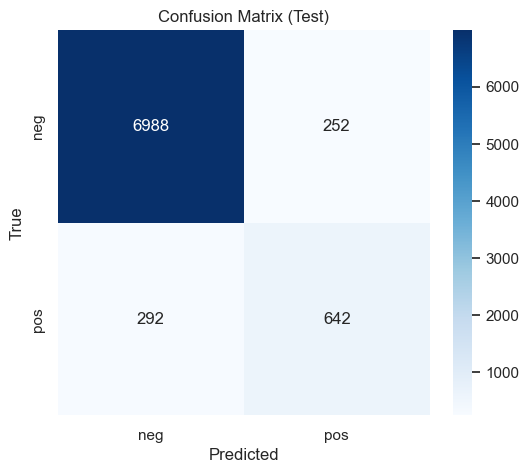

Test Loss: 0.1961
Test Accuracy: 93.34%
Test F1-Score: 0.8325


In [14]:
# Path to the best model checkpoint
best_model_path = os.path.join('checkpoints/vit-lstm', "best_model.pth")

# Ensure the checkpoint file exists
assert os.path.exists(best_model_path), f"Checkpoint file not found: {best_model_path}"

# Load the best model weights
try:
    model.load_state_dict(torch.load(best_model_path, map_location=device))
    print("Best model loaded successfully.")
except Exception as e:
    raise RuntimeError(f"Error loading checkpoint: {e}")

# Evaluate the model on the test dataset
test_metrics = evaluate(
    model=model, 
    data_loader=test_loader, 
    criterion=criterion, 
    device=device, 
    classes=['neg', 'pos'],  # Ensure these match the dataset's labels
    mode='Test'
)

# Verify and print test metrics
assert "loss" in test_metrics, "Test metrics do not contain 'loss'."
assert "accuracy" in test_metrics, "Test metrics do not contain 'accuracy'."
assert "f1_score" in test_metrics, "Test metrics do not contain 'f1_score'."

print(f"Test Loss: {test_metrics['loss']:.4f}")
print(f"Test Accuracy: {test_metrics['accuracy']:.2f}%")
print(f"Test F1-Score: {test_metrics['f1_score']:.4f}")

In [15]:
device = get_device()

Using CUDA: NVIDIA GeForce RTX 4090


Generating Detailed Classification Report: 100%|███████████████████| 511/511 [04:29<00:00,  1.89it/s]

=== Classification Report ===

              precision    recall  f1-score   support

         neg       0.96      0.97      0.96      7240
         pos       0.72      0.69      0.70       934

    accuracy                           0.93      8174
   macro avg       0.84      0.83      0.83      8174
weighted avg       0.93      0.93      0.93      8174



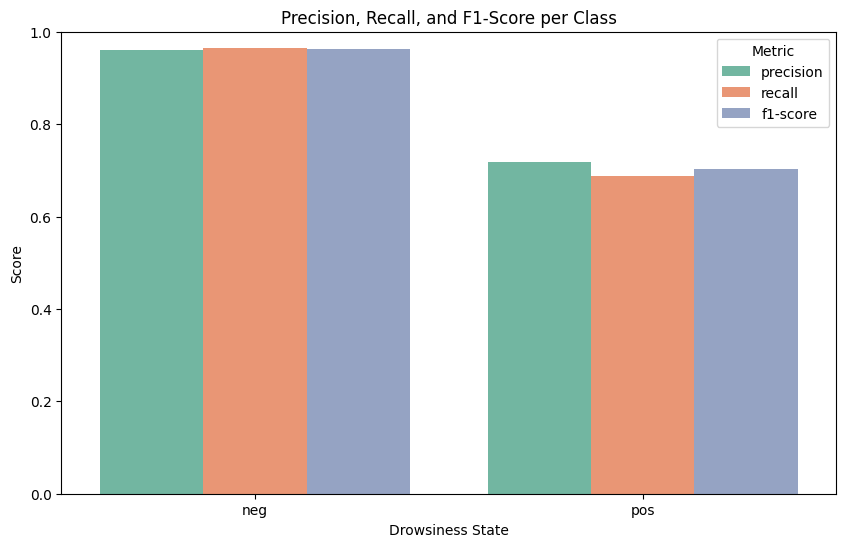

C:\Users\User\Desktop\Term 7\CV\2024_SUTD_CV_Final_Project\scripts\evaluation\report.py:136: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


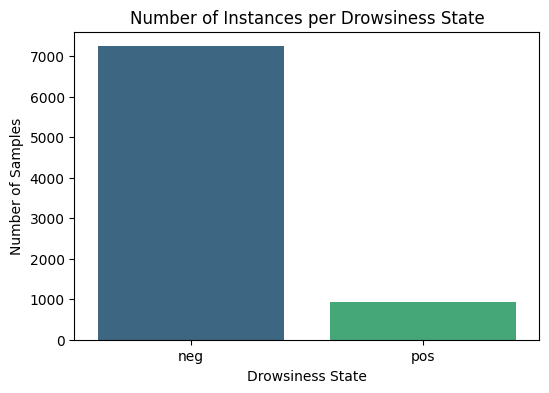

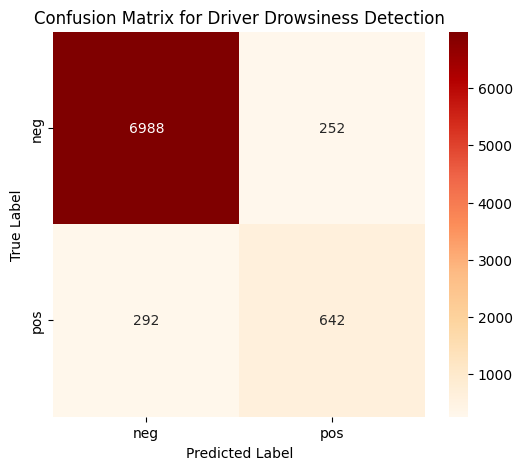

Generating Detailed Classification Report:   5%|█                   | 28/511 [00:13<03:43,  2.16it/s]

Generating Detailed Classification Report:   6%|█▏                  | 29/511 [00:13<03:46,  2.13it/s]

Generating Detailed Classification Report:   6%|█▏                  | 30/511 [00:14<03:47,  2.11it/s]

Generating Detailed Classification Report:   6%|█▏                  | 31/511 [00:14<03:48,  2.10it/s]

Generating Detailed Classification Report:   6%|█▎                  | 32/511 [00:15<03:42,  2.15it/s]

Generating Detailed Classification Report:   6%|█▎                  | 33/511 [00:15<03:45,  2.12it/s]

Generating Detailed Classification Report:   7%|█▎                  | 34/511 [00:16<03:46,  2.11it/s]

Generating Detailed Classification Report:   7%|█▎                  | 35/511 [00:16<03:46,  2.10it/s]

Generating Detailed Classification Report:   7%|█▍                  | 36/511 [00:17<03:48,  2.08it/s]

Generating Detailed Classification Report:   7%|█▍                  | 37/511 [00:17<03:40,  2.15it/s]

Generating Detailed Classification Report:   7%|█▍                  | 38/511 [00:18<03:43,  2.12it/s]

Generating Detailed Classification Report:   8%|█▌                  | 39/511 [00:18<03:46,  2.08it/s]

Generating Detailed Classification Report:   8%|█▌                  | 40/511 [00:19<03:46,  2.08it/s]

Generating Detailed Classification Report:   8%|█▌                  | 41/511 [00:19<03:37,  2.16it/s]

Generating Detailed Classification Report:   8%|█▋                  | 42/511 [00:20<03:40,  2.13it/s]

Generating Detailed Classification Report:   8%|█▋                  | 43/511 [00:20<03:41,  2.11it/s]

Generating Detailed Classification Report:   9%|█▋                  | 44/511 [00:21<03:43,  2.09it/s]

Generating Detailed Classification Report:   9%|█▊                  | 45/511 [00:21<03:44,  2.08it/s]

Generating Detailed Classification Report:   9%|█▊                  | 46/511 [00:21<03:40,  2.11it/s]

Generating Detailed Classification Report:   9%|█▊                  | 47/511 [00:22<03:35,  2.15it/s]

Generating Detailed Classification Report:   9%|█▉                  | 48/511 [00:22<03:38,  2.12it/s]

Generating Detailed Classification Report:  10%|█▉                  | 49/511 [00:23<03:40,  2.10it/s]

Generating Detailed Classification Report:  10%|█▉                  | 50/511 [00:23<03:40,  2.09it/s]

Generating Detailed Classification Report:  10%|█▉                  | 51/511 [00:24<03:41,  2.07it/s]

Generating Detailed Classification Report:  10%|██                  | 52/511 [00:24<03:41,  2.07it/s]

Generating Detailed Classification Report:  10%|██                  | 53/511 [00:25<03:32,  2.16it/s]

Generating Detailed Classification Report:  11%|██                  | 54/511 [00:25<03:35,  2.12it/s]

Generating Detailed Classification Report:  11%|██▏                 | 55/511 [00:26<03:37,  2.10it/s]

Generating Detailed Classification Report:  11%|██▏                 | 56/511 [00:26<03:39,  2.07it/s]

Generating Detailed Classification Report:  11%|██▏                 | 57/511 [00:27<03:39,  2.07it/s]

Generating Detailed Classification Report:  11%|██▎                 | 58/511 [00:27<03:39,  2.07it/s]

Generating Detailed Classification Report:  12%|██▎                 | 59/511 [00:28<03:33,  2.11it/s]

Generating Detailed Classification Report:  12%|██▎                 | 60/511 [00:28<03:35,  2.10it/s]

Generating Detailed Classification Report:  12%|██▍                 | 61/511 [00:29<03:34,  2.10it/s]

Generating Detailed Classification Report:  12%|██▍                 | 62/511 [00:29<03:35,  2.08it/s]

Generating Detailed Classification Report:  12%|██▍                 | 63/511 [00:30<03:35,  2.08it/s]

Generating Detailed Classification Report:  13%|██▌                 | 64/511 [00:30<03:36,  2.06it/s]

Generating Detailed Classification Report:  13%|██▌                 | 65/511 [00:31<03:35,  2.07it/s]

Generating Detailed Classification Report:  13%|██▌                 | 66/511 [00:31<03:34,  2.07it/s]

Generating Detailed Classification Report:  13%|██▌                 | 67/511 [00:32<03:34,  2.07it/s]

Generating Detailed Classification Report:  13%|██▋                 | 68/511 [00:32<03:35,  2.05it/s]

Generating Detailed Classification Report:  14%|██▋                 | 69/511 [00:33<03:34,  2.06it/s]

Generating Detailed Classification Report:  14%|██▋                 | 70/511 [00:33<03:33,  2.07it/s]

Generating Detailed Classification Report:  14%|██▊                 | 71/511 [00:34<03:33,  2.06it/s]

Generating Detailed Classification Report:  14%|██▊                 | 72/511 [00:34<03:31,  2.07it/s]

Generating Detailed Classification Report:  14%|██▊                 | 73/511 [00:34<03:31,  2.07it/s]

Generating Detailed Classification Report:  14%|██▉                 | 74/511 [00:35<03:32,  2.06it/s]

Generating Detailed Classification Report:  15%|██▉                 | 75/511 [00:35<03:31,  2.06it/s]

Generating Detailed Classification Report:  15%|██▉                 | 76/511 [00:36<03:30,  2.07it/s]

Generating Detailed Classification Report:  15%|███                 | 77/511 [00:36<03:30,  2.06it/s]

Generating Detailed Classification Report:  15%|███                 | 78/511 [00:37<03:29,  2.07it/s]

Generating Detailed Classification Report:  15%|███                 | 79/511 [00:37<03:28,  2.07it/s]

Generating Detailed Classification Report:  16%|███▏                | 80/511 [00:38<03:29,  2.06it/s]

Generating Detailed Classification Report:  16%|███▏                | 81/511 [00:38<03:28,  2.06it/s]

Generating Detailed Classification Report:  16%|███▏                | 82/511 [00:39<03:27,  2.06it/s]

Generating Detailed Classification Report:  16%|███▏                | 83/511 [00:39<03:27,  2.06it/s]

Generating Detailed Classification Report:  16%|███▎                | 84/511 [00:40<03:26,  2.07it/s]

Generating Detailed Classification Report:  17%|███▎                | 85/511 [00:40<03:25,  2.07it/s]

Generating Detailed Classification Report:  17%|███▎                | 86/511 [00:41<03:24,  2.07it/s]

Generating Detailed Classification Report:  17%|███▍                | 87/511 [00:41<03:24,  2.07it/s]

Generating Detailed Classification Report:  17%|███▍                | 88/511 [00:42<03:24,  2.07it/s]

Generating Detailed Classification Report:  17%|███▍                | 89/511 [00:42<03:25,  2.06it/s]

Generating Detailed Classification Report:  18%|███▌                | 90/511 [00:43<03:25,  2.05it/s]

Generating Detailed Classification Report:  18%|███▌                | 91/511 [00:43<03:23,  2.06it/s]

Generating Detailed Classification Report:  18%|███▌                | 92/511 [00:44<03:23,  2.06it/s]

Generating Detailed Classification Report:  18%|███▋                | 93/511 [00:44<03:21,  2.07it/s]

Generating Detailed Classification Report:  18%|███▋                | 94/511 [00:45<03:21,  2.07it/s]

Generating Detailed Classification Report:  19%|███▋                | 95/511 [00:45<03:20,  2.07it/s]

Generating Detailed Classification Report:  19%|███▊                | 96/511 [00:46<03:20,  2.07it/s]

Generating Detailed Classification Report:  19%|███▊                | 97/511 [00:46<03:21,  2.05it/s]

Generating Detailed Classification Report:  19%|███▊                | 98/511 [00:47<03:20,  2.06it/s]

Generating Detailed Classification Report:  19%|███▊                | 99/511 [00:47<03:18,  2.08it/s]

Generating Detailed Classification Report:  20%|███▋               | 100/511 [00:47<03:12,  2.13it/s]

Generating Detailed Classification Report:  20%|███▊               | 101/511 [00:48<03:15,  2.10it/s]

Generating Detailed Classification Report:  20%|███▊               | 102/511 [00:48<03:16,  2.08it/s]

Generating Detailed Classification Report:  20%|███▊               | 103/511 [00:49<03:15,  2.08it/s]

Generating Detailed Classification Report:  20%|███▊               | 104/511 [00:49<03:16,  2.07it/s]

Generating Detailed Classification Report:  21%|███▉               | 105/511 [00:50<03:16,  2.06it/s]

Generating Detailed Classification Report:  21%|███▉               | 106/511 [00:50<03:16,  2.06it/s]

Generating Detailed Classification Report:  21%|███▉               | 107/511 [00:51<03:16,  2.06it/s]

Generating Detailed Classification Report:  21%|████               | 108/511 [00:51<03:15,  2.06it/s]

Generating Detailed Classification Report:  21%|████               | 109/511 [00:52<03:15,  2.05it/s]

Generating Detailed Classification Report:  22%|████               | 110/511 [00:52<03:15,  2.06it/s]

Generating Detailed Classification Report:  22%|████▏              | 111/511 [00:53<03:14,  2.06it/s]

Generating Detailed Classification Report:  22%|████▏              | 112/511 [00:53<03:13,  2.06it/s]

Generating Detailed Classification Report:  22%|████▏              | 113/511 [00:54<03:13,  2.06it/s]

Generating Detailed Classification Report:  22%|████▏              | 114/511 [00:54<03:12,  2.07it/s]

Generating Detailed Classification Report:  23%|████▎              | 115/511 [00:55<03:12,  2.05it/s]

Generating Detailed Classification Report:  23%|████▎              | 116/511 [00:55<03:12,  2.05it/s]

Generating Detailed Classification Report:  23%|████▎              | 117/511 [00:56<03:11,  2.05it/s]

Generating Detailed Classification Report:  23%|████▍              | 118/511 [00:56<03:11,  2.05it/s]

Generating Detailed Classification Report:  23%|████▍              | 119/511 [00:57<03:04,  2.12it/s]

Generating Detailed Classification Report:  23%|████▍              | 120/511 [00:57<03:04,  2.12it/s]

Generating Detailed Classification Report:  24%|████▍              | 121/511 [00:58<03:06,  2.10it/s]

Generating Detailed Classification Report:  24%|████▌              | 122/511 [00:58<03:06,  2.08it/s]

Generating Detailed Classification Report:  24%|████▌              | 123/511 [00:59<03:09,  2.05it/s]

Generating Detailed Classification Report:  24%|████▌              | 124/511 [00:59<03:08,  2.06it/s]

Generating Detailed Classification Report:  24%|████▋              | 125/511 [01:00<03:07,  2.06it/s]

Generating Detailed Classification Report:  25%|████▋              | 126/511 [01:00<03:07,  2.05it/s]

Generating Detailed Classification Report:  25%|████▋              | 127/511 [01:01<03:06,  2.06it/s]

Generating Detailed Classification Report:  25%|████▊              | 128/511 [01:01<03:08,  2.03it/s]

Generating Detailed Classification Report:  25%|████▊              | 129/511 [01:02<03:07,  2.04it/s]

Generating Detailed Classification Report:  25%|████▊              | 130/511 [01:02<03:07,  2.03it/s]

Generating Detailed Classification Report:  26%|████▊              | 131/511 [01:03<03:07,  2.03it/s]

Generating Detailed Classification Report:  26%|████▉              | 132/511 [01:03<03:07,  2.03it/s]

Generating Detailed Classification Report:  26%|████▉              | 133/511 [01:04<03:06,  2.03it/s]

Generating Detailed Classification Report:  26%|████▉              | 134/511 [01:04<03:04,  2.04it/s]

Generating Detailed Classification Report:  26%|█████              | 135/511 [01:05<03:05,  2.03it/s]

Generating Detailed Classification Report:  27%|█████              | 136/511 [01:05<03:05,  2.03it/s]

Generating Detailed Classification Report:  27%|█████              | 137/511 [01:06<03:04,  2.03it/s]

Generating Detailed Classification Report:  27%|█████▏             | 138/511 [01:06<03:02,  2.05it/s]

Generating Detailed Classification Report:  27%|█████▏             | 139/511 [01:06<03:00,  2.06it/s]

Generating Detailed Classification Report:  27%|█████▏             | 140/511 [01:07<03:00,  2.06it/s]

Generating Detailed Classification Report:  28%|█████▏             | 141/511 [01:07<02:59,  2.06it/s]

Generating Detailed Classification Report:  28%|█████▎             | 142/511 [01:08<02:59,  2.05it/s]

Generating Detailed Classification Report:  28%|█████▎             | 143/511 [01:08<02:59,  2.06it/s]

Generating Detailed Classification Report:  28%|█████▎             | 144/511 [01:09<02:58,  2.06it/s]

Generating Detailed Classification Report:  28%|█████▍             | 145/511 [01:09<02:57,  2.06it/s]

Generating Detailed Classification Report:  29%|█████▍             | 146/511 [01:10<02:56,  2.06it/s]

Generating Detailed Classification Report:  29%|█████▍             | 147/511 [01:10<02:55,  2.07it/s]

Generating Detailed Classification Report:  29%|█████▌             | 148/511 [01:11<02:56,  2.06it/s]

Generating Detailed Classification Report:  29%|█████▌             | 149/511 [01:11<02:55,  2.07it/s]

Generating Detailed Classification Report:  29%|█████▌             | 150/511 [01:12<02:55,  2.06it/s]

Generating Detailed Classification Report:  30%|█████▌             | 151/511 [01:12<02:54,  2.06it/s]

Generating Detailed Classification Report:  30%|█████▋             | 152/511 [01:13<02:53,  2.07it/s]

Generating Detailed Classification Report:  30%|█████▋             | 153/511 [01:13<02:53,  2.06it/s]

Generating Detailed Classification Report:  30%|█████▋             | 154/511 [01:14<02:53,  2.06it/s]

Generating Detailed Classification Report:  30%|█████▊             | 155/511 [01:14<02:53,  2.05it/s]

Generating Detailed Classification Report:  31%|█████▊             | 156/511 [01:15<02:52,  2.06it/s]

Generating Detailed Classification Report:  31%|█████▊             | 157/511 [01:15<02:50,  2.07it/s]

Generating Detailed Classification Report:  31%|█████▊             | 158/511 [01:16<02:51,  2.05it/s]

Generating Detailed Classification Report:  31%|█████▉             | 159/511 [01:16<02:45,  2.13it/s]

Generating Detailed Classification Report:  31%|█████▉             | 160/511 [01:17<02:46,  2.10it/s]

Generating Detailed Classification Report:  32%|█████▉             | 161/511 [01:17<02:47,  2.08it/s]

Generating Detailed Classification Report:  32%|██████             | 162/511 [01:18<02:48,  2.08it/s]

Generating Detailed Classification Report:  32%|██████             | 163/511 [01:18<02:47,  2.08it/s]

Generating Detailed Classification Report:  32%|██████             | 164/511 [01:19<02:46,  2.08it/s]

Generating Detailed Classification Report:  32%|██████▏            | 165/511 [01:19<02:46,  2.08it/s]

Generating Detailed Classification Report:  32%|██████▏            | 166/511 [01:20<02:45,  2.08it/s]

Generating Detailed Classification Report:  33%|██████▏            | 167/511 [01:20<02:45,  2.08it/s]

Generating Detailed Classification Report:  33%|██████▏            | 168/511 [01:20<02:45,  2.08it/s]

Generating Detailed Classification Report:  33%|██████▎            | 169/511 [01:21<02:45,  2.06it/s]

Generating Detailed Classification Report:  33%|██████▎            | 170/511 [01:21<02:45,  2.06it/s]

Generating Detailed Classification Report:  33%|██████▎            | 171/511 [01:22<02:45,  2.06it/s]

Generating Detailed Classification Report:  34%|██████▍            | 172/511 [01:22<02:44,  2.06it/s]

Generating Detailed Classification Report:  34%|██████▍            | 173/511 [01:23<02:43,  2.06it/s]

Generating Detailed Classification Report:  34%|██████▍            | 174/511 [01:23<02:43,  2.06it/s]

Generating Detailed Classification Report:  34%|██████▌            | 175/511 [01:24<02:41,  2.08it/s]

Generating Detailed Classification Report:  34%|██████▌            | 176/511 [01:24<02:41,  2.07it/s]

Generating Detailed Classification Report:  35%|██████▌            | 177/511 [01:25<02:39,  2.09it/s]

Generating Detailed Classification Report:  35%|██████▌            | 178/511 [01:25<02:37,  2.12it/s]

Generating Detailed Classification Report:  35%|██████▋            | 179/511 [01:26<02:38,  2.10it/s]

Generating Detailed Classification Report:  35%|██████▋            | 180/511 [01:26<02:38,  2.09it/s]

Generating Detailed Classification Report:  35%|██████▋            | 181/511 [01:27<02:39,  2.07it/s]

Generating Detailed Classification Report:  36%|██████▊            | 182/511 [01:27<02:38,  2.07it/s]

Generating Detailed Classification Report:  36%|██████▊            | 183/511 [01:28<02:38,  2.07it/s]

Generating Detailed Classification Report:  36%|██████▊            | 184/511 [01:28<02:38,  2.07it/s]

Generating Detailed Classification Report:  36%|██████▉            | 185/511 [01:29<02:36,  2.08it/s]

Generating Detailed Classification Report:  36%|██████▉            | 186/511 [01:29<02:37,  2.07it/s]

Generating Detailed Classification Report:  37%|██████▉            | 187/511 [01:30<02:36,  2.07it/s]

Generating Detailed Classification Report:  37%|██████▉            | 188/511 [01:30<02:36,  2.06it/s]

Generating Detailed Classification Report:  37%|███████            | 189/511 [01:31<02:35,  2.07it/s]

Generating Detailed Classification Report:  37%|███████            | 190/511 [01:31<02:35,  2.07it/s]

Generating Detailed Classification Report:  37%|███████            | 191/511 [01:32<02:36,  2.04it/s]

Generating Detailed Classification Report:  38%|███████▏           | 192/511 [01:32<02:37,  2.02it/s]

Generating Detailed Classification Report:  38%|███████▏           | 193/511 [01:33<02:37,  2.02it/s]

Generating Detailed Classification Report:  38%|███████▏           | 194/511 [01:33<02:36,  2.02it/s]

Generating Detailed Classification Report:  38%|███████▎           | 195/511 [01:34<02:34,  2.04it/s]

Generating Detailed Classification Report:  38%|███████▎           | 196/511 [01:34<02:33,  2.05it/s]

Generating Detailed Classification Report:  39%|███████▎           | 197/511 [01:35<02:32,  2.05it/s]

Generating Detailed Classification Report:  39%|███████▎           | 198/511 [01:35<02:31,  2.06it/s]

Generating Detailed Classification Report:  39%|███████▍           | 199/511 [01:36<02:30,  2.07it/s]

Generating Detailed Classification Report:  39%|███████▍           | 200/511 [01:36<02:30,  2.07it/s]

Generating Detailed Classification Report:  39%|███████▍           | 201/511 [01:36<02:30,  2.07it/s]

Generating Detailed Classification Report:  40%|███████▌           | 202/511 [01:37<02:29,  2.07it/s]

Generating Detailed Classification Report:  40%|███████▌           | 203/511 [01:37<02:28,  2.07it/s]

Generating Detailed Classification Report:  40%|███████▌           | 204/511 [01:38<02:28,  2.07it/s]

Generating Detailed Classification Report:  40%|███████▌           | 205/511 [01:38<02:27,  2.07it/s]

Generating Detailed Classification Report:  40%|███████▋           | 206/511 [01:39<02:26,  2.08it/s]

Generating Detailed Classification Report:  41%|███████▋           | 207/511 [01:39<02:22,  2.14it/s]

Generating Detailed Classification Report:  41%|███████▋           | 208/511 [01:40<02:23,  2.12it/s]

Generating Detailed Classification Report:  41%|███████▊           | 209/511 [01:40<02:24,  2.09it/s]

Generating Detailed Classification Report:  41%|███████▊           | 210/511 [01:41<02:24,  2.09it/s]

Generating Detailed Classification Report:  41%|███████▊           | 211/511 [01:41<02:25,  2.06it/s]

Generating Detailed Classification Report:  41%|███████▉           | 212/511 [01:42<02:25,  2.06it/s]

Generating Detailed Classification Report:  42%|███████▉           | 213/511 [01:42<02:25,  2.04it/s]

Generating Detailed Classification Report:  42%|███████▉           | 214/511 [01:43<02:24,  2.06it/s]

Generating Detailed Classification Report:  42%|███████▉           | 215/511 [01:43<02:23,  2.06it/s]

Generating Detailed Classification Report:  42%|████████           | 216/511 [01:44<02:23,  2.06it/s]

Generating Detailed Classification Report:  42%|████████           | 217/511 [01:44<02:22,  2.07it/s]

Generating Detailed Classification Report:  43%|████████           | 218/511 [01:45<02:21,  2.07it/s]

Generating Detailed Classification Report:  43%|████████▏          | 219/511 [01:45<02:22,  2.05it/s]

Generating Detailed Classification Report:  43%|████████▏          | 220/511 [01:46<02:21,  2.05it/s]

Generating Detailed Classification Report:  43%|████████▏          | 221/511 [01:46<02:20,  2.06it/s]

Generating Detailed Classification Report:  43%|████████▎          | 222/511 [01:47<02:20,  2.06it/s]

Generating Detailed Classification Report:  44%|████████▎          | 223/511 [01:47<02:19,  2.06it/s]

Generating Detailed Classification Report:  44%|████████▎          | 224/511 [01:48<02:19,  2.06it/s]

Generating Detailed Classification Report:  44%|████████▎          | 225/511 [01:48<02:18,  2.06it/s]

Generating Detailed Classification Report:  44%|████████▍          | 226/511 [01:49<02:18,  2.05it/s]

Generating Detailed Classification Report:  44%|████████▍          | 227/511 [01:49<02:18,  2.06it/s]

Generating Detailed Classification Report:  45%|████████▍          | 228/511 [01:50<02:17,  2.05it/s]

Generating Detailed Classification Report:  45%|████████▌          | 229/511 [01:50<02:17,  2.06it/s]

Generating Detailed Classification Report:  45%|████████▌          | 230/511 [01:51<02:16,  2.06it/s]

Generating Detailed Classification Report:  45%|████████▌          | 231/511 [01:51<02:16,  2.06it/s]

Generating Detailed Classification Report:  45%|████████▋          | 232/511 [01:51<02:15,  2.06it/s]

Generating Detailed Classification Report:  46%|████████▋          | 233/511 [01:52<02:13,  2.08it/s]

Generating Detailed Classification Report:  46%|████████▋          | 234/511 [01:52<02:13,  2.08it/s]

Generating Detailed Classification Report:  46%|████████▋          | 235/511 [01:53<02:12,  2.08it/s]

Generating Detailed Classification Report:  46%|████████▊          | 236/511 [01:53<02:12,  2.08it/s]

Generating Detailed Classification Report:  46%|████████▊          | 237/511 [01:54<02:12,  2.07it/s]

Generating Detailed Classification Report:  47%|████████▊          | 238/511 [01:54<02:11,  2.08it/s]

Generating Detailed Classification Report:  47%|████████▉          | 239/511 [01:55<02:10,  2.08it/s]

Generating Detailed Classification Report:  47%|████████▉          | 240/511 [01:55<02:10,  2.08it/s]

Generating Detailed Classification Report:  47%|████████▉          | 241/511 [01:56<02:10,  2.06it/s]

Generating Detailed Classification Report:  47%|████████▉          | 242/511 [01:56<02:10,  2.06it/s]

Generating Detailed Classification Report:  48%|█████████          | 243/511 [01:57<02:10,  2.06it/s]

Generating Detailed Classification Report:  48%|█████████          | 244/511 [01:57<02:09,  2.07it/s]

Generating Detailed Classification Report:  48%|█████████          | 245/511 [01:58<02:07,  2.09it/s]

Generating Detailed Classification Report:  48%|█████████▏         | 246/511 [01:58<02:03,  2.14it/s]

Generating Detailed Classification Report:  48%|█████████▏         | 247/511 [01:59<02:04,  2.12it/s]

Generating Detailed Classification Report:  49%|█████████▏         | 248/511 [01:59<02:04,  2.12it/s]

Generating Detailed Classification Report:  49%|█████████▎         | 249/511 [02:00<02:04,  2.11it/s]

Generating Detailed Classification Report:  49%|█████████▎         | 250/511 [02:00<02:04,  2.10it/s]

Generating Detailed Classification Report:  49%|█████████▎         | 251/511 [02:01<02:04,  2.09it/s]

Generating Detailed Classification Report:  49%|█████████▎         | 252/511 [02:01<02:04,  2.08it/s]

Generating Detailed Classification Report:  50%|█████████▍         | 253/511 [02:02<02:03,  2.08it/s]

Generating Detailed Classification Report:  50%|█████████▍         | 254/511 [02:02<02:04,  2.07it/s]

Generating Detailed Classification Report:  50%|█████████▍         | 255/511 [02:03<02:03,  2.07it/s]

Generating Detailed Classification Report:  50%|█████████▌         | 256/511 [02:03<02:04,  2.04it/s]

Generating Detailed Classification Report:  50%|█████████▌         | 257/511 [02:03<02:03,  2.05it/s]

Generating Detailed Classification Report:  50%|█████████▌         | 258/511 [02:04<02:02,  2.06it/s]

Generating Detailed Classification Report:  51%|█████████▋         | 259/511 [02:04<02:02,  2.06it/s]

Generating Detailed Classification Report:  51%|█████████▋         | 260/511 [02:05<02:01,  2.06it/s]

Generating Detailed Classification Report:  51%|█████████▋         | 261/511 [02:05<02:00,  2.07it/s]

Generating Detailed Classification Report:  51%|█████████▋         | 262/511 [02:06<02:00,  2.07it/s]

Generating Detailed Classification Report:  51%|█████████▊         | 263/511 [02:06<01:59,  2.07it/s]

Generating Detailed Classification Report:  52%|█████████▊         | 264/511 [02:07<01:58,  2.08it/s]

Generating Detailed Classification Report:  52%|█████████▊         | 265/511 [02:07<01:58,  2.08it/s]

Generating Detailed Classification Report:  52%|█████████▉         | 266/511 [02:08<01:57,  2.08it/s]

Generating Detailed Classification Report:  52%|█████████▉         | 267/511 [02:08<01:57,  2.08it/s]

Generating Detailed Classification Report:  52%|█████████▉         | 268/511 [02:09<01:56,  2.08it/s]

Generating Detailed Classification Report:  53%|██████████         | 269/511 [02:09<01:56,  2.08it/s]

Generating Detailed Classification Report:  53%|██████████         | 270/511 [02:10<01:55,  2.08it/s]

Generating Detailed Classification Report:  53%|██████████         | 271/511 [02:10<01:55,  2.09it/s]

Generating Detailed Classification Report:  53%|██████████         | 272/511 [02:11<01:54,  2.08it/s]

Generating Detailed Classification Report:  53%|██████████▏        | 273/511 [02:11<01:53,  2.09it/s]

Generating Detailed Classification Report:  54%|██████████▏        | 274/511 [02:12<01:50,  2.15it/s]

Generating Detailed Classification Report:  54%|██████████▏        | 275/511 [02:12<01:51,  2.11it/s]

Generating Detailed Classification Report:  54%|██████████▎        | 276/511 [02:13<01:52,  2.10it/s]

Generating Detailed Classification Report:  54%|██████████▎        | 277/511 [02:13<01:51,  2.10it/s]

Generating Detailed Classification Report:  54%|██████████▎        | 278/511 [02:14<01:51,  2.09it/s]

Generating Detailed Classification Report:  55%|██████████▎        | 279/511 [02:14<01:51,  2.08it/s]

Generating Detailed Classification Report:  55%|██████████▍        | 280/511 [02:15<01:52,  2.06it/s]

Generating Detailed Classification Report:  55%|██████████▍        | 281/511 [02:15<01:51,  2.07it/s]

Generating Detailed Classification Report:  55%|██████████▍        | 282/511 [02:15<01:50,  2.07it/s]

Generating Detailed Classification Report:  55%|██████████▌        | 283/511 [02:16<01:49,  2.07it/s]

Generating Detailed Classification Report:  56%|██████████▌        | 284/511 [02:16<01:49,  2.07it/s]

Generating Detailed Classification Report:  56%|██████████▌        | 285/511 [02:17<01:49,  2.07it/s]

Generating Detailed Classification Report:  56%|██████████▋        | 286/511 [02:17<01:48,  2.07it/s]

Generating Detailed Classification Report:  56%|██████████▋        | 287/511 [02:18<01:48,  2.07it/s]

Generating Detailed Classification Report:  56%|██████████▋        | 288/511 [02:18<01:47,  2.07it/s]

Generating Detailed Classification Report:  57%|██████████▋        | 289/511 [02:19<01:47,  2.07it/s]

Generating Detailed Classification Report:  57%|██████████▊        | 290/511 [02:19<01:46,  2.08it/s]

Generating Detailed Classification Report:  57%|██████████▊        | 291/511 [02:20<01:45,  2.08it/s]

Generating Detailed Classification Report:  57%|██████████▊        | 292/511 [02:20<01:45,  2.07it/s]

Generating Detailed Classification Report:  57%|██████████▉        | 293/511 [02:21<01:45,  2.07it/s]

Generating Detailed Classification Report:  58%|██████████▉        | 294/511 [02:21<01:45,  2.06it/s]

Generating Detailed Classification Report:  58%|██████████▉        | 295/511 [02:22<01:44,  2.06it/s]

Generating Detailed Classification Report:  58%|███████████        | 296/511 [02:22<01:43,  2.07it/s]

Generating Detailed Classification Report:  58%|███████████        | 297/511 [02:23<01:43,  2.07it/s]

Generating Detailed Classification Report:  58%|███████████        | 298/511 [02:23<01:43,  2.07it/s]

Generating Detailed Classification Report:  59%|███████████        | 299/511 [02:24<01:43,  2.06it/s]

Generating Detailed Classification Report:  59%|███████████▏       | 300/511 [02:24<01:42,  2.06it/s]

Generating Detailed Classification Report:  59%|███████████▏       | 301/511 [02:25<01:41,  2.06it/s]

Generating Detailed Classification Report:  59%|███████████▏       | 302/511 [02:25<01:40,  2.07it/s]

Generating Detailed Classification Report:  59%|███████████▎       | 303/511 [02:26<01:40,  2.06it/s]

Generating Detailed Classification Report:  59%|███████████▎       | 304/511 [02:26<01:40,  2.07it/s]

Generating Detailed Classification Report:  60%|███████████▎       | 305/511 [02:27<01:39,  2.06it/s]

Generating Detailed Classification Report:  60%|███████████▍       | 306/511 [02:27<01:39,  2.05it/s]

Generating Detailed Classification Report:  60%|███████████▍       | 307/511 [02:28<01:39,  2.04it/s]

Generating Detailed Classification Report:  60%|███████████▍       | 308/511 [02:28<01:39,  2.05it/s]

Generating Detailed Classification Report:  60%|███████████▍       | 309/511 [02:29<01:38,  2.05it/s]

Generating Detailed Classification Report:  61%|███████████▌       | 310/511 [02:29<01:38,  2.05it/s]

Generating Detailed Classification Report:  61%|███████████▌       | 311/511 [02:30<01:35,  2.09it/s]

Generating Detailed Classification Report:  61%|███████████▌       | 312/511 [02:30<01:34,  2.11it/s]

Generating Detailed Classification Report:  61%|███████████▋       | 313/511 [02:30<01:34,  2.09it/s]

Generating Detailed Classification Report:  61%|███████████▋       | 314/511 [02:31<01:34,  2.08it/s]

Generating Detailed Classification Report:  62%|███████████▋       | 315/511 [02:31<01:34,  2.07it/s]

Generating Detailed Classification Report:  62%|███████████▋       | 316/511 [02:32<01:36,  2.03it/s]

Generating Detailed Classification Report:  62%|███████████▊       | 317/511 [02:32<01:34,  2.05it/s]

Generating Detailed Classification Report:  62%|███████████▊       | 318/511 [02:33<01:33,  2.06it/s]

Generating Detailed Classification Report:  62%|███████████▊       | 319/511 [02:33<01:32,  2.07it/s]

Generating Detailed Classification Report:  63%|███████████▉       | 320/511 [02:34<01:33,  2.05it/s]

Generating Detailed Classification Report:  63%|███████████▉       | 321/511 [02:34<01:32,  2.06it/s]

Generating Detailed Classification Report:  63%|███████████▉       | 322/511 [02:35<01:32,  2.05it/s]

Generating Detailed Classification Report:  63%|████████████       | 323/511 [02:35<01:31,  2.05it/s]

Generating Detailed Classification Report:  63%|████████████       | 324/511 [02:36<01:31,  2.04it/s]

Generating Detailed Classification Report:  64%|████████████       | 325/511 [02:36<01:30,  2.05it/s]

Generating Detailed Classification Report:  64%|████████████       | 326/511 [02:37<01:29,  2.06it/s]

Generating Detailed Classification Report:  64%|████████████▏      | 327/511 [02:37<01:29,  2.07it/s]

Generating Detailed Classification Report:  64%|████████████▏      | 328/511 [02:38<01:28,  2.06it/s]

Generating Detailed Classification Report:  64%|████████████▏      | 329/511 [02:38<01:28,  2.06it/s]

Generating Detailed Classification Report:  65%|████████████▎      | 330/511 [02:39<01:27,  2.07it/s]

Generating Detailed Classification Report:  65%|████████████▎      | 331/511 [02:39<01:27,  2.06it/s]

Generating Detailed Classification Report:  65%|████████████▎      | 332/511 [02:40<01:26,  2.06it/s]

Generating Detailed Classification Report:  65%|████████████▍      | 333/511 [02:40<01:26,  2.06it/s]

Generating Detailed Classification Report:  65%|████████████▍      | 334/511 [02:41<01:25,  2.07it/s]

Generating Detailed Classification Report:  66%|████████████▍      | 335/511 [02:41<01:25,  2.06it/s]

Generating Detailed Classification Report:  66%|████████████▍      | 336/511 [02:42<01:24,  2.06it/s]

Generating Detailed Classification Report:  66%|████████████▌      | 337/511 [02:42<01:23,  2.07it/s]

Generating Detailed Classification Report:  66%|████████████▌      | 338/511 [02:43<01:23,  2.07it/s]

Generating Detailed Classification Report:  66%|████████████▌      | 339/511 [02:43<01:20,  2.13it/s]

Generating Detailed Classification Report:  67%|████████████▋      | 340/511 [02:44<01:21,  2.11it/s]

Generating Detailed Classification Report:  67%|████████████▋      | 341/511 [02:44<01:21,  2.10it/s]

Generating Detailed Classification Report:  67%|████████████▋      | 342/511 [02:45<01:21,  2.08it/s]

Generating Detailed Classification Report:  67%|████████████▊      | 343/511 [02:45<01:21,  2.07it/s]

Generating Detailed Classification Report:  67%|████████████▊      | 344/511 [02:45<01:20,  2.07it/s]

Generating Detailed Classification Report:  68%|████████████▊      | 345/511 [02:46<01:20,  2.06it/s]

Generating Detailed Classification Report:  68%|████████████▊      | 346/511 [02:46<01:19,  2.06it/s]

Generating Detailed Classification Report:  68%|████████████▉      | 347/511 [02:47<01:19,  2.06it/s]

Generating Detailed Classification Report:  68%|████████████▉      | 348/511 [02:47<01:18,  2.07it/s]

Generating Detailed Classification Report:  68%|████████████▉      | 349/511 [02:48<01:18,  2.07it/s]

Generating Detailed Classification Report:  68%|█████████████      | 350/511 [02:48<01:17,  2.07it/s]

Generating Detailed Classification Report:  69%|█████████████      | 351/511 [02:49<01:16,  2.08it/s]

Generating Detailed Classification Report:  69%|█████████████      | 352/511 [02:49<01:16,  2.08it/s]

Generating Detailed Classification Report:  69%|█████████████▏     | 353/511 [02:50<01:15,  2.08it/s]

Generating Detailed Classification Report:  69%|█████████████▏     | 354/511 [02:50<01:16,  2.06it/s]

Generating Detailed Classification Report:  69%|█████████████▏     | 355/511 [02:51<01:15,  2.07it/s]

Generating Detailed Classification Report:  70%|█████████████▏     | 356/511 [02:51<01:15,  2.07it/s]

Generating Detailed Classification Report:  70%|█████████████▎     | 357/511 [02:52<01:14,  2.06it/s]

Generating Detailed Classification Report:  70%|█████████████▎     | 358/511 [02:52<01:14,  2.05it/s]

Generating Detailed Classification Report:  70%|█████████████▎     | 359/511 [02:53<01:13,  2.06it/s]

Generating Detailed Classification Report:  70%|█████████████▍     | 360/511 [02:53<01:13,  2.06it/s]

Generating Detailed Classification Report:  71%|█████████████▍     | 361/511 [02:54<01:12,  2.06it/s]

Generating Detailed Classification Report:  71%|█████████████▍     | 362/511 [02:54<01:12,  2.06it/s]

Generating Detailed Classification Report:  71%|█████████████▍     | 363/511 [02:55<01:12,  2.05it/s]

Generating Detailed Classification Report:  71%|█████████████▌     | 364/511 [02:55<01:11,  2.05it/s]

Generating Detailed Classification Report:  71%|█████████████▌     | 365/511 [02:56<01:09,  2.11it/s]

Generating Detailed Classification Report:  72%|█████████████▌     | 366/511 [02:56<01:09,  2.10it/s]

Generating Detailed Classification Report:  72%|█████████████▋     | 367/511 [02:57<01:09,  2.08it/s]

Generating Detailed Classification Report:  72%|█████████████▋     | 368/511 [02:57<01:09,  2.05it/s]

Generating Detailed Classification Report:  72%|█████████████▋     | 369/511 [02:58<01:09,  2.05it/s]

Generating Detailed Classification Report:  72%|█████████████▊     | 370/511 [02:58<01:08,  2.05it/s]

Generating Detailed Classification Report:  73%|█████████████▊     | 371/511 [02:59<01:07,  2.06it/s]

Generating Detailed Classification Report:  73%|█████████████▊     | 372/511 [02:59<01:07,  2.06it/s]

Generating Detailed Classification Report:  73%|█████████████▊     | 373/511 [03:00<01:07,  2.06it/s]

Generating Detailed Classification Report:  73%|█████████████▉     | 374/511 [03:00<01:06,  2.06it/s]

Generating Detailed Classification Report:  73%|█████████████▉     | 375/511 [03:01<01:06,  2.06it/s]

Generating Detailed Classification Report:  74%|█████████████▉     | 376/511 [03:01<01:05,  2.05it/s]

Generating Detailed Classification Report:  74%|██████████████     | 377/511 [03:01<01:05,  2.06it/s]

Generating Detailed Classification Report:  74%|██████████████     | 378/511 [03:02<01:05,  2.02it/s]

Generating Detailed Classification Report:  74%|██████████████     | 379/511 [03:02<01:04,  2.04it/s]

Generating Detailed Classification Report:  74%|██████████████▏    | 380/511 [03:03<01:03,  2.05it/s]

Generating Detailed Classification Report:  75%|██████████████▏    | 381/511 [03:03<01:03,  2.06it/s]

Generating Detailed Classification Report:  75%|██████████████▏    | 382/511 [03:04<01:02,  2.05it/s]

Generating Detailed Classification Report:  75%|██████████████▏    | 383/511 [03:04<01:02,  2.04it/s]

Generating Detailed Classification Report:  75%|██████████████▎    | 384/511 [03:05<01:02,  2.03it/s]

Generating Detailed Classification Report:  75%|██████████████▎    | 385/511 [03:05<01:01,  2.04it/s]

Generating Detailed Classification Report:  76%|██████████████▎    | 386/511 [03:06<01:01,  2.04it/s]

Generating Detailed Classification Report:  76%|██████████████▍    | 387/511 [03:06<01:00,  2.05it/s]

Generating Detailed Classification Report:  76%|██████████████▍    | 388/511 [03:07<00:59,  2.05it/s]

Generating Detailed Classification Report:  76%|██████████████▍    | 389/511 [03:07<00:59,  2.05it/s]

Generating Detailed Classification Report:  76%|██████████████▌    | 390/511 [03:08<00:59,  2.05it/s]

Generating Detailed Classification Report:  77%|██████████████▌    | 391/511 [03:08<00:58,  2.05it/s]

Generating Detailed Classification Report:  77%|██████████████▌    | 392/511 [03:09<00:58,  2.04it/s]

Generating Detailed Classification Report:  77%|██████████████▌    | 393/511 [03:09<00:57,  2.04it/s]

Generating Detailed Classification Report:  77%|██████████████▋    | 394/511 [03:10<00:57,  2.04it/s]

Generating Detailed Classification Report:  77%|██████████████▋    | 395/511 [03:10<00:56,  2.04it/s]

Generating Detailed Classification Report:  77%|██████████████▋    | 396/511 [03:11<00:56,  2.05it/s]

Generating Detailed Classification Report:  78%|██████████████▊    | 397/511 [03:11<00:55,  2.06it/s]

Generating Detailed Classification Report:  78%|██████████████▊    | 398/511 [03:12<00:54,  2.06it/s]

Generating Detailed Classification Report:  78%|██████████████▊    | 399/511 [03:12<00:54,  2.04it/s]

Generating Detailed Classification Report:  78%|██████████████▊    | 400/511 [03:13<00:54,  2.05it/s]

Generating Detailed Classification Report:  78%|██████████████▉    | 401/511 [03:13<00:54,  2.04it/s]

Generating Detailed Classification Report:  79%|██████████████▉    | 402/511 [03:14<00:53,  2.04it/s]

Generating Detailed Classification Report:  79%|██████████████▉    | 403/511 [03:14<00:53,  2.04it/s]

Generating Detailed Classification Report:  79%|███████████████    | 404/511 [03:15<00:52,  2.03it/s]

Generating Detailed Classification Report:  79%|███████████████    | 405/511 [03:15<00:51,  2.04it/s]

Generating Detailed Classification Report:  79%|███████████████    | 406/511 [03:16<00:51,  2.05it/s]

Generating Detailed Classification Report:  80%|███████████████▏   | 407/511 [03:16<00:50,  2.05it/s]

Generating Detailed Classification Report:  80%|███████████████▏   | 408/511 [03:17<00:50,  2.04it/s]

Generating Detailed Classification Report:  80%|███████████████▏   | 409/511 [03:17<00:49,  2.05it/s]

Generating Detailed Classification Report:  80%|███████████████▏   | 410/511 [03:18<00:47,  2.12it/s]

Generating Detailed Classification Report:  80%|███████████████▎   | 411/511 [03:18<00:47,  2.11it/s]

Generating Detailed Classification Report:  81%|███████████████▎   | 412/511 [03:19<00:47,  2.09it/s]

Generating Detailed Classification Report:  81%|███████████████▎   | 413/511 [03:19<00:47,  2.08it/s]

Generating Detailed Classification Report:  81%|███████████████▍   | 414/511 [03:20<00:46,  2.07it/s]

Generating Detailed Classification Report:  81%|███████████████▍   | 415/511 [03:20<00:46,  2.06it/s]

Generating Detailed Classification Report:  81%|███████████████▍   | 416/511 [03:21<00:46,  2.05it/s]

Generating Detailed Classification Report:  82%|███████████████▌   | 417/511 [03:21<00:45,  2.05it/s]

Generating Detailed Classification Report:  82%|███████████████▌   | 418/511 [03:21<00:45,  2.05it/s]

Generating Detailed Classification Report:  82%|███████████████▌   | 419/511 [03:22<00:44,  2.06it/s]

Generating Detailed Classification Report:  82%|███████████████▌   | 420/511 [03:22<00:44,  2.06it/s]

Generating Detailed Classification Report:  82%|███████████████▋   | 421/511 [03:23<00:43,  2.06it/s]

Generating Detailed Classification Report:  83%|███████████████▋   | 422/511 [03:23<00:43,  2.06it/s]

Generating Detailed Classification Report:  83%|███████████████▋   | 423/511 [03:24<00:43,  2.04it/s]

Generating Detailed Classification Report:  83%|███████████████▊   | 424/511 [03:24<00:42,  2.05it/s]

Generating Detailed Classification Report:  83%|███████████████▊   | 425/511 [03:25<00:42,  2.04it/s]

Generating Detailed Classification Report:  83%|███████████████▊   | 426/511 [03:25<00:41,  2.04it/s]

Generating Detailed Classification Report:  84%|███████████████▉   | 427/511 [03:26<00:40,  2.05it/s]

Generating Detailed Classification Report:  84%|███████████████▉   | 428/511 [03:26<00:40,  2.05it/s]

Generating Detailed Classification Report:  84%|███████████████▉   | 429/511 [03:27<00:40,  2.04it/s]

Generating Detailed Classification Report:  84%|███████████████▉   | 430/511 [03:27<00:39,  2.05it/s]

Generating Detailed Classification Report:  84%|████████████████   | 431/511 [03:28<00:38,  2.05it/s]

Generating Detailed Classification Report:  85%|████████████████   | 432/511 [03:28<00:38,  2.05it/s]

Generating Detailed Classification Report:  85%|████████████████   | 433/511 [03:29<00:38,  2.05it/s]

Generating Detailed Classification Report:  85%|████████████████▏  | 434/511 [03:29<00:36,  2.12it/s]

Generating Detailed Classification Report:  85%|████████████████▏  | 435/511 [03:30<00:36,  2.11it/s]

Generating Detailed Classification Report:  85%|████████████████▏  | 436/511 [03:30<00:35,  2.09it/s]

Generating Detailed Classification Report:  86%|████████████████▏  | 437/511 [03:31<00:35,  2.08it/s]

Generating Detailed Classification Report:  86%|████████████████▎  | 438/511 [03:31<00:35,  2.08it/s]

Generating Detailed Classification Report:  86%|████████████████▎  | 439/511 [03:32<00:35,  2.06it/s]

Generating Detailed Classification Report:  86%|████████████████▎  | 440/511 [03:32<00:34,  2.06it/s]

Generating Detailed Classification Report:  86%|████████████████▍  | 441/511 [03:33<00:33,  2.07it/s]

Generating Detailed Classification Report:  86%|████████████████▍  | 442/511 [03:33<00:33,  2.07it/s]

Generating Detailed Classification Report:  87%|████████████████▍  | 443/511 [03:34<00:32,  2.08it/s]

Generating Detailed Classification Report:  87%|████████████████▌  | 444/511 [03:34<00:32,  2.07it/s]

Generating Detailed Classification Report:  87%|████████████████▌  | 445/511 [03:35<00:32,  2.05it/s]

Generating Detailed Classification Report:  87%|████████████████▌  | 446/511 [03:35<00:31,  2.05it/s]

Generating Detailed Classification Report:  87%|████████████████▌  | 447/511 [03:36<00:31,  2.03it/s]

Generating Detailed Classification Report:  88%|████████████████▋  | 448/511 [03:36<00:30,  2.04it/s]

Generating Detailed Classification Report:  88%|████████████████▋  | 449/511 [03:37<00:30,  2.04it/s]

Generating Detailed Classification Report:  88%|████████████████▋  | 450/511 [03:37<00:29,  2.04it/s]

Generating Detailed Classification Report:  88%|████████████████▊  | 451/511 [03:38<00:29,  2.03it/s]

Generating Detailed Classification Report:  88%|████████████████▊  | 452/511 [03:38<00:28,  2.04it/s]

Generating Detailed Classification Report:  89%|████████████████▊  | 453/511 [03:38<00:28,  2.05it/s]

Generating Detailed Classification Report:  89%|████████████████▉  | 454/511 [03:39<00:27,  2.05it/s]

Generating Detailed Classification Report:  89%|████████████████▉  | 455/511 [03:39<00:27,  2.04it/s]

Generating Detailed Classification Report:  89%|████████████████▉  | 456/511 [03:40<00:26,  2.06it/s]

Generating Detailed Classification Report:  89%|████████████████▉  | 457/511 [03:40<00:26,  2.06it/s]

Generating Detailed Classification Report:  90%|█████████████████  | 458/511 [03:41<00:25,  2.06it/s]

Generating Detailed Classification Report:  90%|█████████████████  | 459/511 [03:41<00:25,  2.05it/s]

Generating Detailed Classification Report:  90%|█████████████████  | 460/511 [03:42<00:24,  2.05it/s]

Generating Detailed Classification Report:  90%|█████████████████▏ | 461/511 [03:42<00:24,  2.07it/s]

Generating Detailed Classification Report:  90%|█████████████████▏ | 462/511 [03:43<00:23,  2.06it/s]

Generating Detailed Classification Report:  91%|█████████████████▏ | 463/511 [03:43<00:22,  2.14it/s]

Generating Detailed Classification Report:  91%|█████████████████▎ | 464/511 [03:44<00:22,  2.11it/s]

Generating Detailed Classification Report:  91%|█████████████████▎ | 465/511 [03:44<00:21,  2.10it/s]

Generating Detailed Classification Report:  91%|█████████████████▎ | 466/511 [03:45<00:21,  2.08it/s]

Generating Detailed Classification Report:  91%|█████████████████▎ | 467/511 [03:45<00:21,  2.07it/s]

Generating Detailed Classification Report:  92%|█████████████████▍ | 468/511 [03:46<00:20,  2.06it/s]

Generating Detailed Classification Report:  92%|█████████████████▍ | 469/511 [03:46<00:20,  2.05it/s]

Generating Detailed Classification Report:  92%|█████████████████▍ | 470/511 [03:47<00:19,  2.06it/s]

Generating Detailed Classification Report:  92%|█████████████████▌ | 471/511 [03:47<00:19,  2.07it/s]

Generating Detailed Classification Report:  92%|█████████████████▌ | 472/511 [03:48<00:18,  2.07it/s]

Generating Detailed Classification Report:  93%|█████████████████▌ | 473/511 [03:48<00:18,  2.07it/s]

Generating Detailed Classification Report:  93%|█████████████████▌ | 474/511 [03:49<00:17,  2.07it/s]

Generating Detailed Classification Report:  93%|█████████████████▋ | 475/511 [03:49<00:17,  2.07it/s]

Generating Detailed Classification Report:  93%|█████████████████▋ | 476/511 [03:50<00:17,  2.05it/s]

Generating Detailed Classification Report:  93%|█████████████████▋ | 477/511 [03:50<00:16,  2.03it/s]

Generating Detailed Classification Report:  94%|█████████████████▊ | 478/511 [03:51<00:16,  2.03it/s]

Generating Detailed Classification Report:  94%|█████████████████▊ | 479/511 [03:51<00:15,  2.05it/s]

Generating Detailed Classification Report:  94%|█████████████████▊ | 480/511 [03:52<00:15,  2.06it/s]

Generating Detailed Classification Report:  94%|█████████████████▉ | 481/511 [03:52<00:14,  2.05it/s]

Generating Detailed Classification Report:  94%|█████████████████▉ | 482/511 [03:53<00:13,  2.11it/s]

Generating Detailed Classification Report:  95%|█████████████████▉ | 483/511 [03:53<00:13,  2.11it/s]

Generating Detailed Classification Report:  95%|█████████████████▉ | 484/511 [03:53<00:12,  2.08it/s]

Generating Detailed Classification Report:  95%|██████████████████ | 485/511 [03:54<00:12,  2.06it/s]

Generating Detailed Classification Report:  95%|██████████████████ | 486/511 [03:54<00:12,  2.06it/s]

Generating Detailed Classification Report:  95%|██████████████████ | 487/511 [03:55<00:11,  2.07it/s]

Generating Detailed Classification Report:  95%|██████████████████▏| 488/511 [03:55<00:11,  2.07it/s]

Generating Detailed Classification Report:  96%|██████████████████▏| 489/511 [03:56<00:10,  2.07it/s]

Generating Detailed Classification Report:  96%|██████████████████▏| 490/511 [03:56<00:10,  2.08it/s]

Generating Detailed Classification Report:  96%|██████████████████▎| 491/511 [03:57<00:09,  2.07it/s]

Generating Detailed Classification Report:  96%|██████████████████▎| 492/511 [03:57<00:09,  2.07it/s]

Generating Detailed Classification Report:  96%|██████████████████▎| 493/511 [03:58<00:08,  2.08it/s]

Generating Detailed Classification Report:  97%|██████████████████▎| 494/511 [03:58<00:08,  2.08it/s]

Generating Detailed Classification Report:  97%|██████████████████▍| 495/511 [03:59<00:07,  2.07it/s]

Generating Detailed Classification Report:  97%|██████████████████▍| 496/511 [03:59<00:07,  2.07it/s]

Generating Detailed Classification Report:  97%|██████████████████▍| 497/511 [04:00<00:06,  2.07it/s]

Generating Detailed Classification Report:  97%|██████████████████▌| 498/511 [04:00<00:06,  2.06it/s]

Generating Detailed Classification Report:  98%|██████████████████▌| 499/511 [04:01<00:05,  2.05it/s]

Generating Detailed Classification Report:  98%|██████████████████▌| 500/511 [04:01<00:05,  2.06it/s]

Generating Detailed Classification Report:  98%|██████████████████▋| 501/511 [04:02<00:04,  2.05it/s]

Generating Detailed Classification Report:  98%|██████████████████▋| 502/511 [04:02<00:04,  2.05it/s]

Generating Detailed Classification Report:  98%|██████████████████▋| 503/511 [04:03<00:03,  2.05it/s]

Generating Detailed Classification Report:  99%|██████████████████▋| 504/511 [04:03<00:03,  2.06it/s]

Generating Detailed Classification Report:  99%|██████████████████▊| 505/511 [04:04<00:02,  2.05it/s]

Generating Detailed Classification Report:  99%|██████████████████▊| 506/511 [04:04<00:02,  2.05it/s]

Generating Detailed Classification Report:  99%|██████████████████▊| 507/511 [04:05<00:01,  2.05it/s]

Generating Detailed Classification Report:  99%|██████████████████▉| 508/511 [04:05<00:01,  2.06it/s]

Generating Detailed Classification Report: 100%|██████████████████▉| 509/511 [04:06<00:00,  2.05it/s]

Generating Detailed Classification Report: 100%|██████████████████▉| 510/511 [04:06<00:00,  2.06it/s]

Generating Detailed Classification Report: 100%|███████████████████| 511/511 [04:06<00:00,  2.20it/s]

Generating Detailed Classification Report: 100%|███████████████████| 511/511 [04:06<00:00,  2.07it/s]

=== Classification Report ===

              precision    recall  f1-score   support

         neg       0.96      0.97      0.96      7240
         pos       0.72      0.69      0.70       934

    accuracy                           0.93      8174
   macro avg       0.84      0.83      0.83      8174
weighted avg       0.93      0.93      0.93      8174



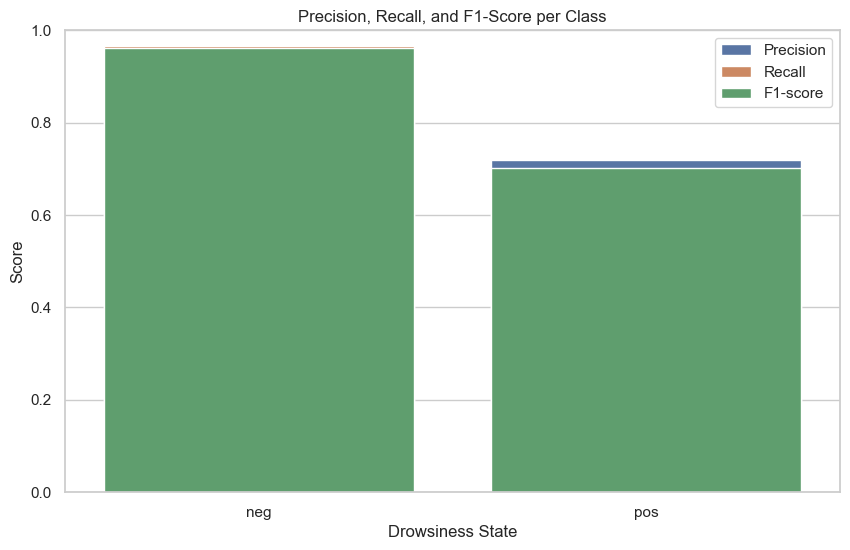

C:\Users\User\Desktop\Term 7\CV\2024_SUTD_CV_Final_Project\scripts\evaluation\report.py:126: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


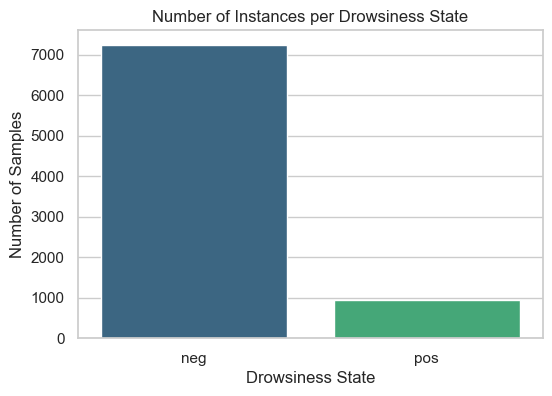

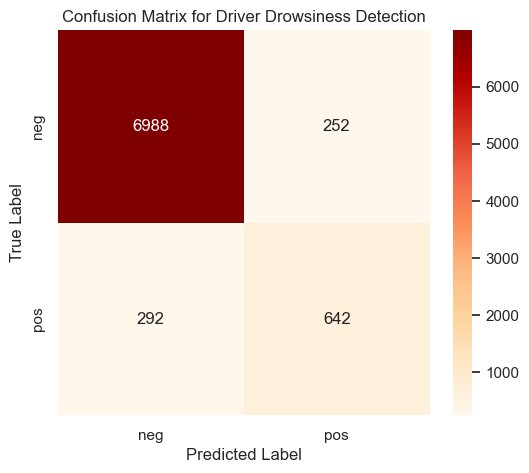

In [16]:
# Generate detailed classification report
generate_detailed_classification_report(model, test_loader, device, classes=['neg', 'pos'])

In [17]:
from scripts.inference.infer import measure_memory_inference

In [18]:
# Example Usage
# Assuming `model` is a PyTorch model and `input_data` is a tensor of appropriate shape
input_data = torch.randn(1, 16, 3, 224, 224)  # Example input for a video sequence model

# Measure memory and time
stats = measure_memory_inference(model, input_data, device)
print(f"Memory and Inference Stats: {stats}")

Memory and Inference Stats: {'cpu_memory_before_mb': 1997.91796875, 'cpu_memory_after_mb': 2080.85546875, 'cpu_memory_delta_mb': 82.9375, 'gpu_memory_before_mb': 0.0, 'gpu_memory_after_mb': 0.0, 'gpu_memory_delta_mb': 0.0, 'inference_time_s': 0.07795548439025879}
